In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]


for r in [1,2,3,4]:
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)


    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        nonlinear_func= LSTM_nonlinear_func(input_dim[0]).to(DEVICE)
        model = EEGNet_NeuralFS_HP_Wrapper(DEVICE, classifier, input_dim,
                                    nonlinear_func=nonlinear_func
                                     ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_pairwise_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6369889214927075


Iterations:   0%|                                   | 1/300 [00:03<15:33,  3.12s/it]

Epoch:  0
t_loss:  0.6369889214927075 , v_loss:  0.6945858796437582
t_acc:  0.5932150638032991 , v_acc:  0.3416149068322981
t_recall:  0.4936811188427279 , v_recall:  0.506036036036036
t_prec:  0.49282699194828283 , v_prec:  0.5203030303030303
t_f:  0.4913235681558713 , v_f:  0.3005737704918032
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:31,  1.71s/it]

Epoch  1 , loss 0.6081300097353318
Epoch  2 , loss 0.5951194190511516


Iterations:   1%|▎                                  | 3/300 [00:05<07:42,  1.56s/it]

Epoch:  2
t_loss:  0.5951194190511516 , v_loss:  0.6949432492256165
t_acc:  0.6483037659508247 , v_acc:  0.36645962732919257
t_recall:  0.5019372503808621 , v_recall:  0.49657657657657656
t_prec:  0.5037472721770018 , v_prec:  0.4944117647058824
t_f:  0.47860983301452725 , v_f:  0.3508064516129032
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:23,  1.30s/it]

Epoch  3 , loss 0.5739325308332256
Epoch  4 , loss 0.5564186374346415


Iterations:   2%|▌                                  | 5/300 [00:07<06:10,  1.26s/it]

Epoch:  4
t_loss:  0.5564186374346415 , v_loss:  0.6868805885314941
t_acc:  0.6738250855897915 , v_acc:  0.6086956521739131
t_recall:  0.49957933599593746 , v_recall:  0.5898198198198199
t_prec:  0.4982797392761996 , v_prec:  0.5791521117815179
t_f:  0.4465341899785138 , v_f:  0.5771106941838648
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:30,  1.12s/it]

Epoch  5 , loss 0.5444692460929647
Epoch  6 , loss 0.5350605418869093


Iterations:   2%|▊                                  | 7/300 [00:09<05:40,  1.16s/it]

Epoch:  6
t_loss:  0.5350605418869093 , v_loss:  0.6678916811943054
t_acc:  0.6840958605664488 , v_acc:  0.6770186335403726
t_recall:  0.49603560203675495 , v_recall:  0.5239639639639639
t_prec:  0.4588888045468778 , v_prec:  0.564625850340136
t_f:  0.4200407423248022 , v_f:  0.4929748062015504
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:05,  1.04s/it]

Epoch  7 , loss 0.520119331631006
Epoch  8 , loss 0.5061729059499853


Iterations:   3%|█                                  | 9/300 [00:11<05:12,  1.07s/it]

Epoch:  8
t_loss:  0.5061729059499853 , v_loss:  0.6500649253527323
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5033543322216275 , v_recall:  0.5
t_prec:  0.5743293931591006 , v_prec:  0.3447204968944099
t_f:  0.4233268499326625 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<04:48,  1.01it/s]

Epoch  9 , loss 0.4974551756007999
Epoch  10 , loss 0.4924375192791808


Iterations:   4%|█▏                                | 11/300 [00:13<05:08,  1.07s/it]

Epoch:  10
t_loss:  0.4924375192791808 , v_loss:  0.6415326793988546
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<04:59,  1.04s/it]

Epoch  11 , loss 0.49015037218729657
Epoch  12 , loss 0.4751561324970395


Iterations:   4%|█▍                                | 13/300 [00:15<05:09,  1.08s/it]

Epoch:  12
t_loss:  0.4751561324970395 , v_loss:  0.6384978095690409
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<04:40,  1.02it/s]

Epoch  13 , loss 0.47399940619281694
Epoch  14 , loss 0.47384560458800373


Iterations:   5%|█▋                                | 15/300 [00:17<05:01,  1.06s/it]

Epoch:  14
t_loss:  0.47384560458800373 , v_loss:  0.6375155746936798
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:54,  1.04s/it]

Epoch  15 , loss 0.4675218503849179
Epoch  16 , loss 0.4611654471532971


Iterations:   6%|█▉                                | 17/300 [00:19<05:00,  1.06s/it]

Epoch:  16
t_loss:  0.4611654471532971 , v_loss:  0.6377236048380533
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<04:42,  1.00s/it]

Epoch  17 , loss 0.45842663739241807
Epoch  18 , loss 0.46386798339731555


Iterations:   6%|██▏                               | 19/300 [00:21<04:51,  1.04s/it]

Epoch:  18
t_loss:  0.46386798339731555 , v_loss:  0.6377675235271454
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:31,  1.03it/s]

Epoch  19 , loss 0.45883867495200215
Epoch  20 , loss 0.4609585001188166


Iterations:   7%|██▍                               | 21/300 [00:23<04:57,  1.07s/it]

Epoch:  20
t_loss:  0.4609585001188166 , v_loss:  0.6383712987105051
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:30,  1.03it/s]

Epoch  21 , loss 0.4546329869943507
Epoch  22 , loss 0.44950831053303736


Iterations:   8%|██▌                               | 23/300 [00:25<05:00,  1.08s/it]

Epoch:  22
t_loss:  0.44950831053303736 , v_loss:  0.6382028758525848
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:30,  1.02it/s]

Epoch  23 , loss 0.45166995537047294
Epoch  24 , loss 0.4492657903362723


Iterations:   8%|██▊                               | 25/300 [00:27<04:50,  1.06s/it]

Epoch:  24
t_loss:  0.4492657903362723 , v_loss:  0.6377954880396525
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:33,  1.00it/s]

Epoch  25 , loss 0.45307817178614
Epoch  26 , loss 0.4499717927446552


Iterations:   9%|███                               | 27/300 [00:29<04:44,  1.04s/it]

Epoch:  26
t_loss:  0.4499717927446552 , v_loss:  0.6377724309762319
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:34,  1.01s/it]

Epoch  27 , loss 0.4572529103241715
Epoch  28 , loss 0.44765911908710704


Iterations:  10%|███▎                              | 29/300 [00:31<04:53,  1.08s/it]

Epoch:  28
t_loss:  0.44765911908710704 , v_loss:  0.6353413860003153
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:23,  1.03it/s]

Epoch  29 , loss 0.4461982448895772
Epoch  30 , loss 0.44563524337375865


Iterations:  10%|███▌                              | 31/300 [00:34<04:53,  1.09s/it]

Epoch:  30
t_loss:  0.44563524337375865 , v_loss:  0.6341302593549093
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:34,  1.02s/it]

Epoch  31 , loss 0.44403241603982213
Epoch  32 , loss 0.44538463973531534


Iterations:  11%|███▋                              | 33/300 [00:36<04:46,  1.07s/it]

Epoch:  32
t_loss:  0.44538463973531534 , v_loss:  0.6312627096970876
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:45,  1.07s/it]

Epoch  33 , loss 0.4444015879257053
Epoch  34 , loss 0.4433026863079445


Iterations:  12%|███▉                              | 35/300 [00:38<04:50,  1.10s/it]

Epoch:  34
t_loss:  0.4433026863079445 , v_loss:  0.6293302973111471
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:39<04:23,  1.00it/s]

Epoch  35 , loss 0.44150175300298955
Epoch  36 , loss 0.44093796727704065


Iterations:  12%|████▏                             | 37/300 [00:40<04:36,  1.05s/it]

Epoch:  36
t_loss:  0.44093796727704065 , v_loss:  0.6258358259995779
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:11,  1.04it/s]

Epoch  37 , loss 0.44197655016300724
Epoch  38 , loss 0.44027141320939156


Iterations:  13%|████▍                             | 39/300 [00:42<04:30,  1.04s/it]

Epoch:  38
t_loss:  0.44027141320939156 , v_loss:  0.6229650775591532
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49910514541387024 , v_recall:  0.5
t_prec:  0.347616079775631 , v_prec:  0.3447204968944099
t_f:  0.40980896399706096 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:11,  1.03it/s]

Epoch  39 , loss 0.43828462035048243
Epoch  40 , loss 0.4407401938064426


Iterations:  14%|████▋                             | 41/300 [00:44<04:29,  1.04s/it]

Epoch:  40
t_loss:  0.4407401938064426 , v_loss:  0.6209819912910461
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:03,  1.06it/s]

Epoch  41 , loss 0.44054495119581033
Epoch  42 , loss 0.43761860856822893


Iterations:  14%|████▊                             | 43/300 [00:46<04:25,  1.03s/it]

Epoch:  42
t_loss:  0.43761860856822893 , v_loss:  0.6176361640294393
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5026838775202097 , v_recall:  0.5
t_prec:  0.6665578331724491 , v_prec:  0.3447204968944099
t_f:  0.4174144390948958 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:19,  1.02s/it]

Epoch  43 , loss 0.43184442146151675
Epoch  44 , loss 0.4367074738530552


Iterations:  15%|█████                             | 45/300 [00:48<04:33,  1.07s/it]

Epoch:  44
t_loss:  0.4367074738530552 , v_loss:  0.6150635629892349
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5020127365806124 , v_recall:  0.5
t_prec:  0.5982338230697093 , v_prec:  0.3447204968944099
t_f:  0.4170674932028922 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:09,  1.02it/s]

Epoch  45 , loss 0.4421964170886021
Epoch  46 , loss 0.43406301444652035


Iterations:  16%|█████▎                            | 47/300 [00:50<04:27,  1.06s/it]

Epoch:  46
t_loss:  0.43406301444652035 , v_loss:  0.6129733274380366
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.502108809925749 , v_recall:  0.5
t_prec:  0.7053961322520275 , v_prec:  0.3447204968944099
t_f:  0.41547864167250537 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:12,  1.00s/it]

Epoch  47 , loss 0.4370490026240255
Epoch  48 , loss 0.4363301799577825


Iterations:  16%|█████▌                            | 49/300 [00:52<04:19,  1.03s/it]

Epoch:  48
t_loss:  0.4363301799577825 , v_loss:  0.6115669260422388
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5029075911667422 , v_recall:  0.5
t_prec:  0.6984233531064628 , v_prec:  0.3447204968944099
t_f:  0.41753003679311723 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:14,  1.02s/it]

Epoch  49 , loss 0.4375656323105681
Epoch  50 , loss 0.43751177951401354


Iterations:  17%|█████▊                            | 51/300 [00:54<04:21,  1.05s/it]

Epoch:  50
t_loss:  0.43751177951401354 , v_loss:  0.6087996413310369
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:55<04:00,  1.03it/s]

Epoch  51 , loss 0.43650859068421755
Epoch  52 , loss 0.4363986990031074


Iterations:  18%|██████                            | 53/300 [00:56<04:13,  1.03s/it]

Epoch:  52
t_loss:  0.4363986990031074 , v_loss:  0.6053544481595358
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [00:57<03:53,  1.05it/s]

Epoch  53 , loss 0.43481266498565674
Epoch  54 , loss 0.43834398423924165


Iterations:  18%|██████▏                           | 55/300 [00:58<04:30,  1.10s/it]

Epoch:  54
t_loss:  0.43834398423924165 , v_loss:  0.6033918460210165
t_acc:  0.6956115779645191 , v_acc:  0.6956521739130435
t_recall:  0.5020127365806124 , v_recall:  0.51
t_prec:  0.5982338230697093 , v_prec:  0.846875
t_f:  0.4170674932028922 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [00:59<04:03,  1.00it/s]

Epoch  55 , loss 0.43021733854331223
Epoch  56 , loss 0.4328471305323582


Iterations:  19%|██████▍                           | 57/300 [01:00<04:20,  1.07s/it]

Epoch:  56
t_loss:  0.4328471305323582 , v_loss:  0.6016157468159994
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5037701925584332 , v_recall:  0.51
t_prec:  0.6611080700656866 , v_prec:  0.846875
t_f:  0.42040645937480553 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▌                           | 58/300 [01:01<04:01,  1.00it/s]

Epoch  57 , loss 0.43081648793875005
Epoch  58 , loss 0.4311954893317877


Iterations:  20%|██████▋                           | 59/300 [01:02<04:09,  1.03s/it]

Epoch:  58
t_loss:  0.4311954893317877 , v_loss:  0.6007699966430664
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.504217619851498 , v_recall:  0.51
t_prec:  0.7058455767427321 , v_prec:  0.846875
t_f:  0.4206437662507272 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:03<03:55,  1.02it/s]

Epoch  59 , loss 0.4347143693297517
Epoch  60 , loss 0.4311181791857177


Iterations:  20%|██████▉                           | 61/300 [01:04<04:17,  1.08s/it]

Epoch:  60
t_loss:  0.4311181791857177 , v_loss:  0.5993414719899496
t_acc:  0.6987239340180517 , v_acc:  0.6956521739130435
t_recall:  0.5065501434237795 , v_recall:  0.51
t_prec:  0.7242013780144065 , v_prec:  0.846875
t_f:  0.4258627793538441 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:05<03:53,  1.02it/s]

Epoch  61 , loss 0.43066826813361225
Epoch  62 , loss 0.43359140964115367


Iterations:  21%|███████▏                          | 63/300 [01:06<04:12,  1.07s/it]

Epoch:  62
t_loss:  0.43359140964115367 , v_loss:  0.5963280151287714
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5044413334980306 , v_recall:  0.51
t_prec:  0.7333653846153847 , v_prec:  0.846875
t_f:  0.4207623904932804 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:07<04:02,  1.03s/it]

Epoch  63 , loss 0.4318101224946041
Epoch  64 , loss 0.42903216796762805


Iterations:  22%|███████▎                          | 65/300 [01:08<04:06,  1.05s/it]

Epoch:  64
t_loss:  0.42903216796762805 , v_loss:  0.5934150914351145
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5041537997008002 , v_recall:  0.51
t_prec:  0.7577792288910341 , v_prec:  0.846875
t_f:  0.4198045337037372 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:09<03:59,  1.02s/it]

Epoch  65 , loss 0.4301159665280697
Epoch  66 , loss 0.42665880976938736


Iterations:  22%|███████▌                          | 67/300 [01:10<04:10,  1.08s/it]

Epoch:  66
t_loss:  0.42665880976938736 , v_loss:  0.5921497891346613
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5055914686869519 , v_recall:  0.51
t_prec:  0.6823308270676691 , v_prec:  0.846875
t_f:  0.42455390714097185 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:11<03:48,  1.02it/s]

Epoch  67 , loss 0.4274955403571035
Epoch  68 , loss 0.42129170193391685


Iterations:  23%|███████▊                          | 69/300 [01:13<04:08,  1.08s/it]

Epoch:  68
t_loss:  0.42129170193391685 , v_loss:  0.5901615669329962
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5084352397029961 , v_recall:  0.51
t_prec:  0.7067503924646782 , v_prec:  0.846875
t_f:  0.43076632456185404 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▉                          | 70/300 [01:13<03:46,  1.01it/s]

Epoch  69 , loss 0.4264676091717739
Epoch  70 , loss 0.42703785440501046


Iterations:  24%|████████                          | 71/300 [01:15<04:03,  1.06s/it]

Epoch:  70
t_loss:  0.42703785440501046 , v_loss:  0.5902735888957977
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.5089464871467589 , v_recall:  0.51
t_prec:  0.7117863022006585 , v_prec:  0.846875
t_f:  0.4318154538455943 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:15<03:44,  1.02it/s]

Epoch  71 , loss 0.42526452214110133
Epoch  72 , loss 0.42089756037674697


Iterations:  24%|████████▎                         | 73/300 [01:17<03:56,  1.04s/it]

Epoch:  72
t_loss:  0.42089756037674697 , v_loss:  0.584597572684288
t_acc:  0.7024587612822907 , v_acc:  0.6956521739130435
t_recall:  0.5123975789517026 , v_recall:  0.51
t_prec:  0.7837888784165881 , v_prec:  0.846875
t_f:  0.43756921373200447 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<03:37,  1.04it/s]

Epoch  73 , loss 0.4223615924517314
Epoch  74 , loss 0.42580552545248296


Iterations:  25%|████████▌                         | 75/300 [01:18<03:47,  1.01s/it]

Epoch:  74
t_loss:  0.42580552545248296 , v_loss:  0.5836279690265656
t_acc:  0.7009025832555245 , v_acc:  0.6956521739130435
t_recall:  0.5104164093273493 , v_recall:  0.51
t_prec:  0.7465831311731069 , v_prec:  0.846875
t_f:  0.4341706229488249 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:34,  1.04it/s]

Epoch  75 , loss 0.4271949751704347
Epoch  76 , loss 0.4296516144976896


Iterations:  26%|████████▋                         | 77/300 [01:21<03:57,  1.07s/it]

Epoch:  76
t_loss:  0.4296516144976896 , v_loss:  0.5810677657524744
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5087227735002264 , v_recall:  0.51
t_prec:  0.699670122525919 , v_prec:  0.846875
t_f:  0.43168604651162784 , v_f:  0.42920193907821425
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<03:36,  1.03it/s]

Epoch  77 , loss 0.42511626143081516
Epoch  78 , loss 0.42303018008961396


Iterations:  26%|████████▉                         | 79/300 [01:23<03:48,  1.04s/it]

Epoch:  78
t_loss:  0.42303018008961396 , v_loss:  0.5799958209196726
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.5095215547412196 , v_recall:  0.51
t_prec:  0.698327615780446 , v_prec:  0.846875
t_f:  0.43364541292321857 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████                         | 80/300 [01:23<03:41,  1.01s/it]

Epoch  79 , loss 0.43735531381532256
Epoch  80 , loss 0.4233911586742775


Iterations:  27%|█████████▏                        | 81/300 [01:25<03:48,  1.05s/it]

Epoch:  80
t_loss:  0.4233911586742775 , v_loss:  0.5793313781420389
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5100328021849824 , v_recall:  0.54
t_prec:  0.7028939918213275 , v_prec:  0.8535031847133758
t_f:  0.4346869702469517 , v_f:  0.488253178551686
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:36,  1.01it/s]

Epoch  81 , loss 0.4247572416183995
Epoch  82 , loss 0.43158300367056157


Iterations:  28%|█████████▍                        | 83/300 [01:27<03:47,  1.05s/it]

Epoch:  82
t_loss:  0.43158300367056157 , v_loss:  0.5770537505547205
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5094577345905217 , v_recall:  0.54
t_prec:  0.7164938737040527 , v_prec:  0.8535031847133758
t_f:  0.43286267995570316 , v_f:  0.488253178551686
////////


Iterations:  28%|█████████▌                        | 84/300 [01:27<03:30,  1.03it/s]

Epoch  83 , loss 0.4302084732289408
Epoch  84 , loss 0.4209192547143674


Iterations:  28%|█████████▋                        | 85/300 [01:29<03:47,  1.06s/it]

Epoch:  84
t_loss:  0.4209192547143674 , v_loss:  0.5755093594392141
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5105440496287452 , v_recall:  0.54
t_prec:  0.7072057898049088 , v_prec:  0.8535031847133758
t_f:  0.4357266490728602 , v_f:  0.488253178551686
////////


Iterations:  29%|█████████▋                        | 86/300 [01:30<03:32,  1.01it/s]

Epoch  85 , loss 0.4273955611621632
Epoch  86 , loss 0.42213823865441713


Iterations:  29%|█████████▊                        | 87/300 [01:31<03:44,  1.05s/it]

Epoch:  86
t_loss:  0.42213823865441713 , v_loss:  0.5761914600928625
t_acc:  0.6984126984126984 , v_acc:  0.7142857142857143
t_recall:  0.5092017677495505 , v_recall:  0.54
t_prec:  0.6546573678221019 , v_prec:  0.8535031847133758
t_f:  0.43492779051180885 , v_f:  0.488253178551686
////////


Iterations:  29%|█████████▉                        | 88/300 [01:32<03:37,  1.03s/it]

Epoch  87 , loss 0.4242329059862623
Epoch  88 , loss 0.42605764375013466


Iterations:  30%|██████████                        | 89/300 [01:33<03:49,  1.09s/it]

Epoch:  88
t_loss:  0.42605764375013466 , v_loss:  0.5739629069964091
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5108315834259755 , v_recall:  0.54
t_prec:  0.7014772959357343 , v_prec:  0.8535031847133758
t_f:  0.43663036343591277 , v_f:  0.488253178551686
////////


Iterations:  30%|██████████▏                       | 90/300 [01:34<03:34,  1.02s/it]

Epoch  89 , loss 0.425544119348713
Epoch  90 , loss 0.4279077654960109


Iterations:  30%|██████████▎                       | 91/300 [01:35<03:41,  1.06s/it]

Epoch:  90
t_loss:  0.4279077654960109 , v_loss:  0.5745057562987009
t_acc:  0.7012138188608776 , v_acc:  0.7142857142857143
t_recall:  0.5115027243655728 , v_recall:  0.54
t_prec:  0.732620320855615 , v_prec:  0.8535031847133758
t_f:  0.437032667465844 , v_f:  0.488253178551686
////////


Iterations:  31%|██████████▍                       | 92/300 [01:36<03:22,  1.03it/s]

Epoch  91 , loss 0.4218103692812078
Epoch  92 , loss 0.42397405703862506


Iterations:  31%|██████████▌                       | 93/300 [01:37<03:32,  1.03s/it]

Epoch:  92
t_loss:  0.42397405703862506 , v_loss:  0.5718640039364496
t_acc:  0.7015250544662309 , v_acc:  0.7142857142857143
t_recall:  0.5111513704176446 , v_recall:  0.54
t_prec:  0.7639815456593311 , v_prec:  0.8535031847133758
t_f:  0.4353482075004403 , v_f:  0.488253178551686
////////


Iterations:  31%|██████████▋                       | 94/300 [01:38<03:17,  1.04it/s]

Epoch  93 , loss 0.42900503499835146
Epoch  94 , loss 0.4194851482615751


Iterations:  32%|██████████▊                       | 95/300 [01:39<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.4194851482615751 , v_loss:  0.5691383729378382
t_acc:  0.6996576408341114 , v_acc:  0.7204968944099379
t_recall:  0.5103841561329105 , v_recall:  0.55
t_prec:  0.6833648393194707 , v_prec:  0.8557692307692308
t_f:  0.4363622085118706 , v_f:  0.5066394279877425
////////


Iterations:  32%|██████████▉                       | 96/300 [01:40<03:12,  1.06it/s]

Epoch  95 , loss 0.418332785952325
Epoch  96 , loss 0.4206133385499318


Iterations:  32%|██████████▉                       | 97/300 [01:41<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.4206133385499318 , v_loss:  0.5700537165006002
t_acc:  0.7005913476501712 , v_acc:  0.7142857142857143
t_recall:  0.51278049985589 , v_recall:  0.54
t_prec:  0.6838862559241705 , v_prec:  0.8535031847133758
t_f:  0.4421150097465887 , v_f:  0.488253178551686
////////


Iterations:  33%|███████████                       | 98/300 [01:42<03:19,  1.01it/s]

Epoch  97 , loss 0.4219832432036306
Epoch  98 , loss 0.4171478917785719


Iterations:  33%|███████████▏                      | 99/300 [01:43<03:37,  1.08s/it]

Epoch:  98
t_loss:  0.4171478917785719 , v_loss:  0.5689146220684052
t_acc:  0.7009025832555245 , v_acc:  0.7142857142857143
t_recall:  0.511854078313501 , v_recall:  0.54
t_prec:  0.7093209248218699 , v_prec:  0.8535031847133758
t_f:  0.43869853096363487 , v_f:  0.488253178551686
////////


Iterations:  33%|███████████                      | 100/300 [01:44<03:17,  1.01it/s]

Epoch  99 , loss 0.4241989915277444
Epoch  100 , loss 0.42571032748502846


Iterations:  34%|███████████                      | 101/300 [01:45<03:34,  1.08s/it]

Epoch:  100
t_loss:  0.42571032748502846 , v_loss:  0.567966471115748
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5128443200065879 , v_recall:  0.5354954954954955
t_prec:  0.6740986717267552 , v_prec:  0.7525641025641026
t_f:  0.44285373960590346 , v_f:  0.4847122914538645
////////


Iterations:  34%|███████████▏                     | 102/300 [01:46<03:18,  1.00s/it]

Epoch  101 , loss 0.41684351364771527
Epoch  102 , loss 0.41874457691230027


Iterations:  34%|███████████▎                     | 103/300 [01:47<03:26,  1.05s/it]

Epoch:  102
t_loss:  0.41874457691230027 , v_loss:  0.5644009858369827
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5146017759844086 , v_recall:  0.5654954954954955
t_prec:  0.6905720085980416 , v_prec:  0.7969771241830066
t_f:  0.44603896448286623 , v_f:  0.5373563218390804
////////


Iterations:  35%|███████████▍                     | 104/300 [01:48<03:12,  1.02it/s]

Epoch  103 , loss 0.42411177006422307
Epoch  104 , loss 0.41764173320695464


Iterations:  35%|███████████▌                     | 105/300 [01:49<03:34,  1.10s/it]

Epoch:  104
t_loss:  0.41764173320695464 , v_loss:  0.5627049406369528
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5163914851566681 , v_recall:  0.5854954954954955
t_prec:  0.7513257575757576 , v_prec:  0.8142384105960265
t_f:  0.4471839528707577 , v_f:  0.5698473282442748
////////


Iterations:  35%|███████████▋                     | 106/300 [01:50<03:17,  1.02s/it]

Epoch  105 , loss 0.41515516358263355
Epoch  106 , loss 0.4170263801135269


Iterations:  36%|███████████▊                     | 107/300 [01:51<03:29,  1.08s/it]

Epoch:  106
t_loss:  0.4170263801135269 , v_loss:  0.5615348368883133
t_acc:  0.7052598817304699 , v_acc:  0.7453416149068323
t_recall:  0.5195866101206407 , v_recall:  0.5954954954954955
t_prec:  0.7379927956774064 , v_prec:  0.8212121212121212
t_f:  0.45468050615760575 , v_f:  0.5853903649268262
////////


Iterations:  36%|███████████▉                     | 108/300 [01:52<03:16,  1.02s/it]

Epoch  107 , loss 0.4168425290023579
Epoch  108 , loss 0.41579919469122795


Iterations:  36%|███████████▉                     | 109/300 [01:53<03:19,  1.05s/it]

Epoch:  108
t_loss:  0.41579919469122795 , v_loss:  0.5621931950251261
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5156242708719342 , v_recall:  0.5754954954954955
t_prec:  0.6966261730669584 , v_prec:  0.8062865497076024
t_f:  0.4480599335591349 , v_f:  0.5538441709093253
////////


Iterations:  37%|████████████                     | 110/300 [01:54<03:20,  1.06s/it]

Epoch  109 , loss 0.41797593703456953
Epoch  110 , loss 0.42198870637837577


Iterations:  37%|████████████▏                    | 111/300 [01:56<03:31,  1.12s/it]

Epoch:  110
t_loss:  0.42198870637837577 , v_loss:  0.5613011022408804
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5126206063600555 , v_recall:  0.5754954954954955
t_prec:  0.6678296790207578 , v_prec:  0.8062865497076024
t_f:  0.44271340870979586 , v_f:  0.5538441709093253
////////


Iterations:  37%|████████████▎                    | 112/300 [01:56<03:10,  1.01s/it]

Epoch  111 , loss 0.4167715088993895
Epoch  112 , loss 0.4150582481833065


Iterations:  38%|████████████▍                    | 113/300 [01:58<03:17,  1.05s/it]

Epoch:  112
t_loss:  0.4150582481833065 , v_loss:  0.5613244821627935
t_acc:  0.7046374105197635 , v_acc:  0.7391304347826086
t_recall:  0.5200017842192668 , v_recall:  0.5854954954954955
t_prec:  0.7136667969895416 , v_prec:  0.8142384105960265
t_f:  0.456914447296797 , v_f:  0.5698473282442748
////////


Iterations:  38%|████████████▌                    | 114/300 [01:58<03:00,  1.03it/s]

Epoch  113 , loss 0.41918673760750713
Epoch  114 , loss 0.4162709648702659


Iterations:  38%|████████████▋                    | 115/300 [02:00<03:16,  1.06s/it]

Epoch:  114
t_loss:  0.4162709648702659 , v_loss:  0.5575127154588699
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5196504302713386 , v_recall:  0.5954954954954955
t_prec:  0.7270456707897242 , v_prec:  0.8212121212121212
t_f:  0.45537932721397584 , v_f:  0.5853903649268262
////////


Iterations:  39%|████████████▊                    | 116/300 [02:00<02:59,  1.02it/s]

Epoch  115 , loss 0.41465888362304837
Epoch  116 , loss 0.4245581229527791


Iterations:  39%|████████████▊                    | 117/300 [02:02<03:07,  1.03s/it]

Epoch:  116
t_loss:  0.4245581229527791 , v_loss:  0.5580520282189051
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5214394532054185 , v_recall:  0.5954954954954955
t_prec:  0.6991204588910134 , v_prec:  0.8212121212121212
t_f:  0.46107078602890994 , v_f:  0.5853903649268262
////////


Iterations:  39%|████████████▉                    | 118/300 [02:02<02:58,  1.02it/s]

Epoch  117 , loss 0.42056791396702037
Epoch  118 , loss 0.41480092908821853


Iterations:  40%|█████████████                    | 119/300 [02:04<03:08,  1.04s/it]

Epoch:  118
t_loss:  0.41480092908821853 , v_loss:  0.5570153594017029
t_acc:  0.7037037037037037 , v_acc:  0.7453416149068323
t_recall:  0.5184680418879785 , v_recall:  0.5954954954954955
t_prec:  0.7066317912388285 , v_prec:  0.8212121212121212
t_f:  0.45393041789254196 , v_f:  0.5853903649268262
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:04<02:51,  1.05it/s]

Epoch  119 , loss 0.4254847636409834
Epoch  120 , loss 0.4183974155023986


Iterations:  40%|█████████████▎                   | 121/300 [02:06<03:06,  1.04s/it]

Epoch:  120
t_loss:  0.4183974155023986 , v_loss:  0.5561888515949249
t_acc:  0.707749766573296 , v_acc:  0.7453416149068323
t_recall:  0.5233890558735126 , v_recall:  0.5954954954954955
t_prec:  0.7576190476190476 , v_prec:  0.8212121212121212
t_f:  0.46180472494039637 , v_f:  0.5853903649268262
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:06<02:51,  1.04it/s]

Epoch  121 , loss 0.4154421079392527
Epoch  122 , loss 0.4169059132828432


Iterations:  41%|█████████████▌                   | 123/300 [02:08<03:06,  1.05s/it]

Epoch:  122
t_loss:  0.4169059132828432 , v_loss:  0.554466187953949
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5205452848574683 , v_recall:  0.5954954954954955
t_prec:  0.7540188470066519 , v_prec:  0.8212121212121212
t_f:  0.45598321748962567 , v_f:  0.5853903649268262
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:08<02:48,  1.05it/s]

Epoch  123 , loss 0.41604573177356347
Epoch  124 , loss 0.41555728807168846


Iterations:  42%|█████████████▊                   | 125/300 [02:10<03:10,  1.09s/it]

Epoch:  124
t_loss:  0.41555728807168846 , v_loss:  0.5538037816683451
t_acc:  0.7055711173358232 , v_acc:  0.7453416149068323
t_recall:  0.5203853913616339 , v_recall:  0.5954954954954955
t_prec:  0.7355375832540438 , v_prec:  0.8212121212121212
t_f:  0.4565283159751278 , v_f:  0.5853903649268262
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:11<03:01,  1.04s/it]

Epoch  125 , loss 0.4138273409768647
Epoch  126 , loss 0.4168338582796209


Iterations:  42%|█████████████▉                   | 127/300 [02:12<03:15,  1.13s/it]

Epoch:  126
t_loss:  0.4168338582796209 , v_loss:  0.5526498208443323
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.517445547000453 , v_recall:  0.5954954954954955
t_prec:  0.701569933396765 , v_prec:  0.8212121212121212
t_f:  0.45193236093051997 , v_f:  0.5853903649268262
////////


Iterations:  43%|██████████████                   | 128/300 [02:13<03:01,  1.06s/it]

Epoch  127 , loss 0.405664674207276
Epoch  128 , loss 0.4137409528096517


Iterations:  43%|██████████████▏                  | 129/300 [02:14<03:10,  1.11s/it]

Epoch:  128
t_loss:  0.4137409528096517 , v_loss:  0.5503647029399872
t_acc:  0.7012138188608776 , v_acc:  0.7515527950310559
t_recall:  0.5161032651212583 , v_recall:  0.6054954954954955
t_prec:  0.6694687581246208 , v_prec:  0.8274608501118568
t_f:  0.4510437089147734 , v_f:  0.6004962779156328
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:15<02:55,  1.03s/it]

Epoch  129 , loss 0.4107260923175251
Epoch  130 , loss 0.4139409117838916


Iterations:  44%|██████████████▍                  | 131/300 [02:16<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4139409117838916 , v_loss:  0.553353081146876
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.5272230685826437 , v_recall:  0.5954954954954955
t_prec:  0.7317696364443682 , v_prec:  0.8212121212121212
t_f:  0.4712747628323687 , v_f:  0.5853903649268262
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:17<03:00,  1.07s/it]

Epoch  131 , loss 0.4100956206812578
Epoch  132 , loss 0.4118939410237705


Iterations:  44%|██████████████▋                  | 133/300 [02:18<03:03,  1.10s/it]

Epoch:  132
t_loss:  0.4118939410237705 , v_loss:  0.551993856827418
t_acc:  0.7058823529411765 , v_acc:  0.7453416149068323
t_recall:  0.522046773994318 , v_recall:  0.5954954954954955
t_prec:  0.7221415532691668 , v_prec:  0.8212121212121212
t_f:  0.4608689954726835 , v_f:  0.5853903649268262
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:19<02:53,  1.04s/it]

Epoch  133 , loss 0.4152367693536422
Epoch  134 , loss 0.41902128621643664


Iterations:  45%|██████████████▊                  | 135/300 [02:21<03:00,  1.09s/it]

Epoch:  134
t_loss:  0.41902128621643664 , v_loss:  0.5492731829484304
t_acc:  0.7052598817304699 , v_acc:  0.7453416149068323
t_recall:  0.5215993467012531 , v_recall:  0.5954954954954955
t_prec:  0.7116374248034355 , v_prec:  0.8212121212121212
t_f:  0.4605574745238564 , v_f:  0.5853903649268262
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:21<02:47,  1.02s/it]

Epoch  135 , loss 0.4086371958255768
Epoch  136 , loss 0.41374531096103145


Iterations:  46%|███████████████                  | 137/300 [02:23<03:03,  1.13s/it]

Epoch:  136
t_loss:  0.41374531096103145 , v_loss:  0.5491484304269155
t_acc:  0.706504824151883 , v_acc:  0.7453416149068323
t_recall:  0.5227817350846131 , v_recall:  0.5954954954954955
t_prec:  0.7295469631596416 , v_prec:  0.8212121212121212
t_f:  0.4620100134716831 , v_f:  0.5853903649268262
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:24<02:48,  1.04s/it]

Epoch  137 , loss 0.41661418302386416
Epoch  138 , loss 0.4110427235855776


Iterations:  46%|███████████████▎                 | 139/300 [02:25<02:52,  1.07s/it]

Epoch:  138
t_loss:  0.4110427235855776 , v_loss:  0.5485363205273946
t_acc:  0.7083722377840025 , v_acc:  0.7515527950310559
t_recall:  0.5261367535444202 , v_recall:  0.6054954954954955
t_prec:  0.7365926484230056 , v_prec:  0.8274608501118568
t_f:  0.4686964662780017 , v_f:  0.6004962779156328
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:26<02:40,  1.01s/it]

Epoch  139 , loss 0.4101371052218418
Epoch  140 , loss 0.4182885113884421


Iterations:  47%|███████████████▌                 | 141/300 [02:27<02:53,  1.09s/it]

Epoch:  140
t_loss:  0.4182885113884421 , v_loss:  0.5497390230496725
t_acc:  0.7080610021786492 , v_acc:  0.7515527950310559
t_recall:  0.5279257764785001 , v_recall:  0.6054954954954955
t_prec:  0.7125886351921764 , v_prec:  0.8274608501118568
t_f:  0.4741168957165691 , v_f:  0.6004962779156328
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:28<02:38,  1.01s/it]

Epoch  141 , loss 0.41365230901568545
Epoch  142 , loss 0.4152057211773068


Iterations:  48%|███████████████▋                 | 143/300 [02:29<02:46,  1.06s/it]

Epoch:  142
t_loss:  0.4152057211773068 , v_loss:  0.5479432741800944
t_acc:  0.7058823529411765 , v_acc:  0.7515527950310559
t_recall:  0.5217592401970876 , v_recall:  0.6054954954954955
t_prec:  0.7256454535966069 , v_prec:  0.8274608501118568
t_f:  0.46003793250929864 , v_f:  0.6004962779156328
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:30<02:36,  1.01s/it]

Epoch  143 , loss 0.41607779673501555
Epoch  144 , loss 0.4092381684219136


Iterations:  48%|███████████████▉                 | 145/300 [02:31<02:42,  1.05s/it]

Epoch:  144
t_loss:  0.4092381684219136 , v_loss:  0.5484350174665451
t_acc:  0.7049486461251168 , v_acc:  0.7515527950310559
t_recall:  0.52080056546026 , v_recall:  0.6054954954954955
t_prec:  0.7125993640699523 , v_prec:  0.8274608501118568
t_f:  0.45874103506365194 , v_f:  0.6004962779156328
////////


Iterations:  49%|████████████████                 | 146/300 [02:32<02:34,  1.00s/it]

Epoch  145 , loss 0.40781185089373123
Epoch  146 , loss 0.41131313524994195


Iterations:  49%|████████████████▏                | 147/300 [02:33<02:41,  1.05s/it]

Epoch:  146
t_loss:  0.41131313524994195 , v_loss:  0.5478633393843969
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.5240917637693691 , v_recall:  0.6054954954954955
t_prec:  0.7297378064741297 , v_prec:  0.8274608501118568
t_f:  0.4647962295045692 , v_f:  0.6004962779156328
////////


Iterations:  49%|████████████████▎                | 148/300 [02:34<02:28,  1.03it/s]

Epoch  147 , loss 0.41649390026634814
Epoch  148 , loss 0.41064146511694966


Iterations:  50%|████████████████▍                | 149/300 [02:35<02:37,  1.04s/it]

Epoch:  148
t_loss:  0.41064146511694966 , v_loss:  0.5470883548259735
t_acc:  0.7099284158107687 , v_acc:  0.7639751552795031
t_recall:  0.5284054569660037 , v_recall:  0.6254954954954954
t_prec:  0.7477238270028727 , v_prec:  0.83843537414966
t_f:  0.47273558354626877 , v_f:  0.6294815891472869
////////


Iterations:  50%|████████████████▌                | 150/300 [02:36<02:22,  1.05it/s]

Epoch  149 , loss 0.41666966267660555
Epoch  150 , loss 0.40299442936392393


Iterations:  50%|████████████████▌                | 151/300 [02:37<02:39,  1.07s/it]

Epoch:  150
t_loss:  0.40299442936392393 , v_loss:  0.5430483122666677
t_acc:  0.7093059446000622 , v_acc:  0.7701863354037267
t_recall:  0.5265203606867872 , v_recall:  0.6354954954954954
t_prec:  0.7563276026743075 , v_prec:  0.84337899543379
t_f:  0.4683705357142857 , v_f:  0.64340017958695
////////


Iterations:  51%|████████████████▋                | 152/300 [02:38<02:23,  1.03it/s]

Epoch  151 , loss 0.41322217852461574
Epoch  152 , loss 0.41801121655632467


Iterations:  51%|████████████████▊                | 153/300 [02:39<02:40,  1.09s/it]

Epoch:  152
t_loss:  0.41801121655632467 , v_loss:  0.5458634893099467
t_acc:  0.7052598817304699 , v_acc:  0.7701863354037267
t_recall:  0.5236120832818655 , v_recall:  0.6354954954954954
t_prec:  0.6941176470588235 , v_prec:  0.84337899543379
t_f:  0.4662724226780162 , v_f:  0.64340017958695
////////


Iterations:  51%|████████████████▉                | 154/300 [02:40<02:38,  1.08s/it]

Epoch  153 , loss 0.41151617788801004
Epoch  154 , loss 0.41093902143777583


Iterations:  52%|█████████████████                | 155/300 [02:41<02:39,  1.10s/it]

Epoch:  154
t_loss:  0.41093902143777583 , v_loss:  0.5450238039096197
t_acc:  0.7071272953625894 , v_acc:  0.7701863354037267
t_recall:  0.5263920341472118 , v_recall:  0.6354954954954954
t_prec:  0.7074857212735042 , v_prec:  0.84337899543379
t_f:  0.47124781809472555 , v_f:  0.64340017958695
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:42<02:30,  1.04s/it]

Epoch  155 , loss 0.40676553342856614
Epoch  156 , loss 0.4065788253849628


Iterations:  52%|█████████████████▎               | 157/300 [02:44<02:39,  1.11s/it]

Epoch:  156
t_loss:  0.4065788253849628 , v_loss:  0.5443108826875687
t_acc:  0.7080610021786492 , v_acc:  0.7763975155279503
t_recall:  0.5262005736951181 , v_recall:  0.6454954954954955
t_prec:  0.7284950526651772 , v_prec:  0.8480603448275862
t_f:  0.46934117743175974 , v_f:  0.6569602272727273
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:44<02:22,  1.00s/it]

Epoch  157 , loss 0.40901926335166483
Epoch  158 , loss 0.4096548031358158


Iterations:  53%|█████████████████▍               | 159/300 [02:46<02:31,  1.08s/it]

Epoch:  158
t_loss:  0.4096548031358158 , v_loss:  0.543236086765925
t_acc:  0.7055711173358232 , v_acc:  0.7701863354037267
t_recall:  0.5229731955367068 , v_recall:  0.6354954954954954
t_prec:  0.7053551711446449 , v_prec:  0.84337899543379
t_f:  0.4640013966480447 , v_f:  0.64340017958695
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:46<02:18,  1.01it/s]

Epoch  159 , loss 0.40815257091148227
Epoch  160 , loss 0.41004089397542615


Iterations:  54%|█████████████████▋               | 161/300 [02:48<02:25,  1.05s/it]

Epoch:  160
t_loss:  0.41004089397542615 , v_loss:  0.5436588178078333
t_acc:  0.7096171802054155 , v_acc:  0.7763975155279503
t_recall:  0.5281817433194713 , v_recall:  0.6454954954954955
t_prec:  0.742816091954023 , v_prec:  0.8480603448275862
t_f:  0.47257001790925657 , v_f:  0.6569602272727273
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:48<02:17,  1.01it/s]

Epoch  161 , loss 0.4027422017910901
Epoch  162 , loss 0.41301484961135715


Iterations:  54%|█████████████████▉               | 163/300 [02:50<02:25,  1.06s/it]

Epoch:  162
t_loss:  0.41301484961135715 , v_loss:  0.5411581595738729
t_acc:  0.7096171802054155 , v_acc:  0.7763975155279503
t_recall:  0.529619412305623 , v_recall:  0.6454954954954955
t_prec:  0.7278864633124723 , v_prec:  0.8480603448275862
t_f:  0.47652852906760396 , v_f:  0.6569602272727273
////////


Iterations:  55%|██████████████████               | 164/300 [02:50<02:13,  1.02it/s]

Epoch  163 , loss 0.4072994753426197
Epoch  164 , loss 0.4048990443641064


Iterations:  55%|██████████████████▏              | 165/300 [02:52<02:19,  1.04s/it]

Epoch:  164
t_loss:  0.4048990443641064 , v_loss:  0.5429890205462774
t_acc:  0.7099284158107687 , v_acc:  0.7763975155279503
t_recall:  0.5284054569660037 , v_recall:  0.6454954954954955
t_prec:  0.7477238270028727 , v_prec:  0.8480603448275862
t_f:  0.47273558354626877 , v_f:  0.6569602272727273
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:53<02:16,  1.02s/it]

Epoch  165 , loss 0.4112308913586186
Epoch  166 , loss 0.40631917937129153


Iterations:  56%|██████████████████▎              | 167/300 [02:54<02:18,  1.04s/it]

Epoch:  166
t_loss:  0.40631917937129153 , v_loss:  0.5390926996866862
t_acc:  0.7061935885465297 , v_acc:  0.7763975155279503
t_recall:  0.5248582918159235 , v_recall:  0.6454954954954955
t_prec:  0.7020511523787567 , v_prec:  0.8480603448275862
t_f:  0.46836412179273246 , v_f:  0.6569602272727273
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:54<02:07,  1.04it/s]

Epoch  167 , loss 0.407909329031028
Epoch  168 , loss 0.40566245247335997


Iterations:  56%|██████████████████▌              | 169/300 [02:56<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.40566245247335997 , v_loss:  0.5386035988728205
t_acc:  0.708994708994709 , v_acc:  0.7763975155279503
t_recall:  0.5297470526070188 , v_recall:  0.6454954954954955
t_prec:  0.7151251273771555 , v_prec:  0.8480603448275862
t_f:  0.4777494317515092 , v_f:  0.6569602272727273
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:57<02:06,  1.03it/s]

Epoch  169 , loss 0.41102373629224065
Epoch  170 , loss 0.4143894618632747


Iterations:  57%|██████████████████▊              | 171/300 [02:58<02:12,  1.03s/it]

Epoch:  170
t_loss:  0.4143894618632747 , v_loss:  0.5375541299581528
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5304181935466161 , v_recall:  0.6554954954954955
t_prec:  0.7267809513414691 , v_prec:  0.8525326797385621
t_f:  0.47826077866179006 , v_f:  0.6701785191688616
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:58<02:00,  1.06it/s]

Epoch  171 , loss 0.4069645790492787
Epoch  172 , loss 0.4075753455068551


Iterations:  58%|███████████████████              | 173/300 [03:00<02:16,  1.08s/it]

Epoch:  172
t_loss:  0.4075753455068551 , v_loss:  0.5365148137013117
t_acc:  0.708994708994709 , v_acc:  0.782608695652174
t_recall:  0.5277343160264064 , v_recall:  0.6554954954954955
t_prec:  0.7333519381038531 , v_prec:  0.8525326797385621
t_f:  0.472239082333658 , v_f:  0.6701785191688616
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:01<02:04,  1.01it/s]

Epoch  173 , loss 0.40691687079036937
Epoch  174 , loss 0.4064341479656743


Iterations:  58%|███████████████████▎             | 175/300 [03:02<02:13,  1.07s/it]

Epoch:  174
t_loss:  0.4064341479656743 , v_loss:  0.5355227788289388
t_acc:  0.7108621226268285 , v_acc:  0.782608695652174
t_recall:  0.5322394696751349 , v_recall:  0.6554954954954955
t_prec:  0.7285864424592748 , v_prec:  0.8525326797385621
t_f:  0.48187071646953505 , v_f:  0.6701785191688616
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:03<02:00,  1.03it/s]

Epoch  175 , loss 0.4062402733400756
Epoch  176 , loss 0.40854896926412393


Iterations:  59%|███████████████████▍             | 177/300 [03:04<02:06,  1.03s/it]

Epoch:  176
t_loss:  0.40854896926412393 , v_loss:  0.5372434308131536
t_acc:  0.7061935885465297 , v_acc:  0.782608695652174
t_recall:  0.5283086973826876 , v_recall:  0.6554954954954955
t_prec:  0.6812849734860692 , v_prec:  0.8525326797385621
t_f:  0.477753840389659 , v_f:  0.6701785191688616
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:05<01:56,  1.05it/s]

Epoch  177 , loss 0.404467129239849
Epoch  178 , loss 0.4007011429936278


Iterations:  60%|███████████████████▋             | 179/300 [03:06<02:07,  1.06s/it]

Epoch:  178
t_loss:  0.4007011429936278 , v_loss:  0.5371642907460531
t_acc:  0.7121070650482415 , v_acc:  0.7763975155279503
t_recall:  0.533421858058495 , v_recall:  0.6454954954954955
t_prec:  0.7417006339081297 , v_prec:  0.8480603448275862
t_f:  0.48333499932635937 , v_f:  0.6569602272727273
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:07<01:56,  1.03it/s]

Epoch  179 , loss 0.4029129661765753
Epoch  180 , loss 0.4147504357730641


Iterations:  60%|███████████████████▉             | 181/300 [03:08<02:09,  1.09s/it]

Epoch:  180
t_loss:  0.4147504357730641 , v_loss:  0.5362029472986857
t_acc:  0.707749766573296 , v_acc:  0.7763975155279503
t_recall:  0.5297147994125802 , v_recall:  0.6454954954954955
t_prec:  0.6954357258486739 , v_prec:  0.8480603448275862
t_f:  0.47937621926545104 , v_f:  0.6569602272727273
////////


Iterations:  61%|████████████████████             | 182/300 [03:09<02:04,  1.05s/it]

Epoch  181 , loss 0.40420656227598
Epoch  182 , loss 0.4033726091478385


Iterations:  61%|████████████████████▏            | 183/300 [03:10<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.4033726091478385 , v_loss:  0.5360955744981766
t_acc:  0.7111733582321818 , v_acc:  0.7763975155279503
t_recall:  0.532175649524437 , v_recall:  0.6454954954954955
t_prec:  0.7350366939364774 , v_prec:  0.8480603448275862
t_f:  0.48127364280882834 , v_f:  0.6569602272727273
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:11<02:02,  1.06s/it]

Epoch  183 , loss 0.41034448672743407
Epoch  184 , loss 0.4049418539393182


Iterations:  62%|████████████████████▎            | 185/300 [03:12<02:05,  1.09s/it]

Epoch:  184
t_loss:  0.4049418539393182 , v_loss:  0.5362530946731567
t_acc:  0.7133520074696545 , v_acc:  0.782608695652174
t_recall:  0.5366169830224674 , v_recall:  0.6554954954954955
t_prec:  0.7365651305211387 , v_prec:  0.8525326797385621
t_f:  0.4901048385860033 , v_f:  0.6701785191688616
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:13<01:53,  1.01it/s]

Epoch  185 , loss 0.40360478969181285
Epoch  186 , loss 0.40351466337839764


Iterations:  62%|████████████████████▌            | 187/300 [03:14<02:02,  1.08s/it]

Epoch:  186
t_loss:  0.40351466337839764 , v_loss:  0.5385202119747797
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.538885686444051 , v_recall:  0.6454954954954955
t_prec:  0.7447295227346018 , v_prec:  0.8480603448275862
t_f:  0.49398442980344687 , v_f:  0.6569602272727273
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:15<01:51,  1.00it/s]

Epoch  187 , loss 0.40125591965282664
Epoch  188 , loss 0.40382290587705727


Iterations:  63%|████████████████████▊            | 189/300 [03:16<01:55,  1.04s/it]

Epoch:  188
t_loss:  0.40382290587705727 , v_loss:  0.5384140958388647
t_acc:  0.7145969498910676 , v_acc:  0.7763975155279503
t_recall:  0.5375118376085972 , v_recall:  0.6454954954954955
t_prec:  0.7512548262548262 , v_prec:  0.8480603448275862
t_f:  0.4908257522852019 , v_f:  0.6569602272727273
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:17<01:46,  1.03it/s]

Epoch  189 , loss 0.3979566646557228
Epoch  190 , loss 0.41566384715192456


Iterations:  64%|█████████████████████            | 191/300 [03:18<01:56,  1.06s/it]

Epoch:  190
t_loss:  0.41566384715192456 , v_loss:  0.5366513431072235
t_acc:  0.7052598817304699 , v_acc:  0.7763975155279503
t_recall:  0.52735002264586 , v_recall:  0.6454954954954955
t_prec:  0.6736238172408385 , v_prec:  0.8480603448275862
t_f:  0.4764771740089846 , v_f:  0.6569602272727273
////////


Iterations:  64%|█████████████████████            | 192/300 [03:19<01:44,  1.03it/s]

Epoch  191 , loss 0.4071238572691001
Epoch  192 , loss 0.40048448244730633


Iterations:  64%|█████████████████████▏           | 193/300 [03:20<01:51,  1.04s/it]

Epoch:  192
t_loss:  0.40048448244730633 , v_loss:  0.5359304745992025
t_acc:  0.7096171802054155 , v_acc:  0.7763975155279503
t_recall:  0.5313446150890051 , v_recall:  0.6454954954954955
t_prec:  0.7138856803920957 , v_prec:  0.8480603448275862
t_f:  0.4811773043876326 , v_f:  0.6569602272727273
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:21<01:42,  1.04it/s]

Epoch  193 , loss 0.40101804394347995
Epoch  194 , loss 0.4066343354243858


Iterations:  65%|█████████████████████▍           | 195/300 [03:22<01:47,  1.02s/it]

Epoch:  194
t_loss:  0.4066343354243858 , v_loss:  0.5357585847377777
t_acc:  0.7093059446000622 , v_acc:  0.7763975155279503
t_recall:  0.5319835028341637 , v_recall:  0.6454954954954955
t_prec:  0.7048179181437318 , v_prec:  0.8480603448275862
t_f:  0.4832861090295991 , v_f:  0.6569602272727273
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:23<01:40,  1.04it/s]

Epoch  195 , loss 0.40142392527823356
Epoch  196 , loss 0.395245012699389


Iterations:  66%|█████████████████████▋           | 197/300 [03:24<01:46,  1.03s/it]

Epoch:  196
t_loss:  0.395245012699389 , v_loss:  0.5365212758382162
t_acc:  0.7133520074696545 , v_acc:  0.7763975155279503
t_recall:  0.5363294492252371 , v_recall:  0.6454954954954955
t_prec:  0.7389406093722731 , v_prec:  0.8480603448275862
t_f:  0.4893562278418322 , v_f:  0.6569602272727273
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:25<01:40,  1.01it/s]

Epoch  197 , loss 0.41069238735180275
Epoch  198 , loss 0.41349197602739524


Iterations:  66%|█████████████████████▉           | 199/300 [03:26<01:44,  1.04s/it]

Epoch:  198
t_loss:  0.41349197602739524 , v_loss:  0.5355794131755829
t_acc:  0.712729536258948 , v_acc:  0.7763975155279503
t_recall:  0.5361695557294025 , v_recall:  0.6454954954954955
t_prec:  0.7296121072716817 , v_prec:  0.8480603448275862
t_f:  0.4897449119432869 , v_f:  0.6569602272727273
////////


Iterations:  67%|██████████████████████           | 200/300 [03:27<01:34,  1.06it/s]

Epoch  199 , loss 0.3997066850755729
Epoch  200 , loss 0.39998308583801867


Iterations:  67%|██████████████████████           | 201/300 [03:28<01:48,  1.10s/it]

Epoch:  200
t_loss:  0.39998308583801867 , v_loss:  0.537114625175794
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.5383106188495903 , v_recall:  0.6454954954954955
t_prec:  0.749718196457327 , v_prec:  0.8480603448275862
t_f:  0.4925010863492457 , v_f:  0.6569602272727273
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:29<01:36,  1.01it/s]

Epoch  201 , loss 0.4037378558925554
Epoch  202 , loss 0.40358946253271666


Iterations:  68%|██████████████████████▎          | 203/300 [03:31<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.40358946253271666 , v_loss:  0.5346561769644419
t_acc:  0.7117958294428882 , v_acc:  0.7763975155279503
t_recall:  0.5352108809925749 , v_recall:  0.6454954954954955
t_prec:  0.7216019026120606 , v_prec:  0.8480603448275862
t_f:  0.4884602423558862 , v_f:  0.6569602272727273
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:32<01:41,  1.06s/it]

Epoch  203 , loss 0.40746254546969546
Epoch  204 , loss 0.40087565721250046


Iterations:  68%|██████████████████████▌          | 205/300 [03:33<01:43,  1.09s/it]

Epoch:  204
t_loss:  0.40087565721250046 , v_loss:  0.5327025304238001
t_acc:  0.7124183006535948 , v_acc:  0.782608695652174
t_recall:  0.5362333758801004 , v_recall:  0.6554954954954955
t_prec:  0.7241809751872421 , v_prec:  0.8525326797385621
t_f:  0.4903089036947305 , v_f:  0.6701785191688616
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:34<01:38,  1.05s/it]

Epoch  205 , loss 0.402720207677168
Epoch  206 , loss 0.4025315131042518


Iterations:  69%|██████████████████████▊          | 207/300 [03:35<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.4025315131042518 , v_loss:  0.5332269767920176
t_acc:  0.712729536258948 , v_acc:  0.7763975155279503
t_recall:  0.536457089526633 , v_recall:  0.6454954954954955
t_prec:  0.7274878675421068 , v_prec:  0.8480603448275862
t_f:  0.49048936643595853 , v_f:  0.6569602272727273
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:36<01:30,  1.01it/s]

Epoch  207 , loss 0.4036770164966583
Epoch  208 , loss 0.4042463004589081


Iterations:  70%|██████████████████████▉          | 209/300 [03:37<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.4042463004589081 , v_loss:  0.5297911216815313
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.539748287835742 , v_recall:  0.6454954954954955
t_prec:  0.7378987431888502 , v_prec:  0.8480603448275862
t_f:  0.49618808288026733 , v_f:  0.6569602272727273
////////


Iterations:  70%|███████████████████████          | 210/300 [03:38<01:27,  1.03it/s]

Epoch  209 , loss 0.3980555896665536
Epoch  210 , loss 0.3993320020974851


Iterations:  70%|███████████████████████▏         | 211/300 [03:39<01:32,  1.04s/it]

Epoch:  210
t_loss:  0.3993320020974851 , v_loss:  0.529600073893865
t_acc:  0.7180205415499533 , v_acc:  0.782608695652174
t_recall:  0.5451482960706002 , v_recall:  0.6554954954954955
t_prec:  0.7462299458569326 , v_prec:  0.8525326797385621
t_f:  0.5059728352587697 , v_f:  0.6701785191688616
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:39<01:23,  1.05it/s]

Epoch  211 , loss 0.39479921728956935
Epoch  212 , loss 0.40414101352878645


Iterations:  71%|███████████████████████▍         | 213/300 [03:41<01:30,  1.04s/it]

Epoch:  212
t_loss:  0.40414101352878645 , v_loss:  0.5296388268470764
t_acc:  0.7149081854964208 , v_acc:  0.782608695652174
t_recall:  0.5417610244163544 , v_recall:  0.6554954954954955
t_prec:  0.7244511817296628 , v_prec:  0.8525326797385621
t_f:  0.5012323836251602 , v_f:  0.6701785191688616
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:42<01:26,  1.00s/it]

Epoch  213 , loss 0.39873529590812384
Epoch  214 , loss 0.40041689954551996


Iterations:  72%|███████████████████████▋         | 215/300 [03:43<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.40041689954551996 , v_loss:  0.5298045724630356
t_acc:  0.7136632430750078 , v_acc:  0.782608695652174
t_recall:  0.539428500844073 , v_recall:  0.6554954954954955
t_prec:  0.7215743440233235 , v_prec:  0.8525326797385621
t_f:  0.4968996617812853 , v_f:  0.6701785191688616
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:44<01:20,  1.04it/s]

Epoch  215 , loss 0.4061134025162342
Epoch  216 , loss 0.40291893891259734


Iterations:  72%|███████████████████████▊         | 217/300 [03:45<01:26,  1.05s/it]

Epoch:  216
t_loss:  0.40291893891259734 , v_loss:  0.5311159392197927
t_acc:  0.7117958294428882 , v_acc:  0.7888198757763976
t_recall:  0.5366485499787266 , v_recall:  0.6654954954954955
t_prec:  0.7124292631701767 , v_prec:  0.8568376068376069
t_f:  0.49215887754753695 , v_f:  0.6830708661417324
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:46<01:19,  1.03it/s]

Epoch  217 , loss 0.39717966318130493
Epoch  218 , loss 0.39923768066892434


Iterations:  73%|████████████████████████         | 219/300 [03:47<01:27,  1.08s/it]

Epoch:  218
t_loss:  0.39923768066892434 , v_loss:  0.52798559765021
t_acc:  0.7173980703392469 , v_acc:  0.782608695652174
t_recall:  0.5438382673858443 , v_recall:  0.6554954954954955
t_prec:  0.7463556851311953 , v_prec:  0.8525326797385621
t_f:  0.5034618401058771 , v_f:  0.6701785191688616
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:48<01:26,  1.08s/it]

Epoch  219 , loss 0.39853382519647185
Epoch  220 , loss 0.40036899318882063


Iterations:  74%|████████████████████████▎        | 221/300 [03:49<01:28,  1.13s/it]

Epoch:  220
t_loss:  0.40036899318882063 , v_loss:  0.5293185462554296
t_acc:  0.7155306567071273 , v_acc:  0.782608695652174
t_recall:  0.5413458503177283 , v_recall:  0.6554954954954955
t_prec:  0.7359438799486211 , v_prec:  0.8525326797385621
t_f:  0.49946173953238493 , v_f:  0.6701785191688616
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:50<01:20,  1.03s/it]

Epoch  221 , loss 0.4023316590224995
Epoch  222 , loss 0.3980814376298119


Iterations:  74%|████████████████████████▌        | 223/300 [03:51<01:23,  1.09s/it]

Epoch:  222
t_loss:  0.3980814376298119 , v_loss:  0.527379130323728
t_acc:  0.7217553688141923 , v_acc:  0.7763975155279503
t_recall:  0.5512832653957536 , v_recall:  0.650990990990991
t_prec:  0.7570537192546356 , v_prec:  0.8255633255633255
t_f:  0.5166486053524312 , v_f:  0.6644279759147753
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:52<01:15,  1.01it/s]

Epoch  223 , loss 0.3976387866571838
Epoch  224 , loss 0.3989204600745556


Iterations:  75%|████████████████████████▊        | 225/300 [03:53<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.3989204600745556 , v_loss:  0.5269732375939687
t_acc:  0.7099284158107687 , v_acc:  0.7701863354037267
t_recall:  0.5344436667078409 , v_recall:  0.640990990990991
t_prec:  0.6996489013582532 , v_prec:  0.8196486928104575
t_f:  0.48886833031782334 , v_f:  0.6513315774070823
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:54<01:11,  1.04it/s]

Epoch  225 , loss 0.4009062320578332
Epoch  226 , loss 0.3987748465117286


Iterations:  76%|████████████████████████▉        | 227/300 [03:55<01:14,  1.02s/it]

Epoch:  226
t_loss:  0.3987748465117286 , v_loss:  0.5264574686686198
t_acc:  0.7161531279178338 , v_acc:  0.782608695652174
t_recall:  0.5432309465969449 , v_recall:  0.660990990990991
t_prec:  0.7323515092502435 , v_prec:  0.83117123795404
t_f:  0.5034104081508145 , v_f:  0.6772068511198946
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:56<01:11,  1.00it/s]

Epoch  227 , loss 0.403297775516323
Epoch  228 , loss 0.3926231457906611


Iterations:  76%|█████████████████████████▏       | 229/300 [03:57<01:12,  1.03s/it]

Epoch:  228
t_loss:  0.3926231457906611 , v_loss:  0.5276678204536438
t_acc:  0.7136632430750078 , v_acc:  0.7701863354037267
t_recall:  0.5400035684385336 , v_recall:  0.640990990990991
t_prec:  0.7181716110681404 , v_prec:  0.8196486928104575
t_f:  0.49833886141067124 , v_f:  0.6513315774070823
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:58<01:08,  1.02it/s]

Epoch  229 , loss 0.3981295970140719
Epoch  230 , loss 0.39377955303472634


Iterations:  77%|█████████████████████████▍       | 231/300 [03:59<01:13,  1.07s/it]

Epoch:  230
t_loss:  0.39377955303472634 , v_loss:  0.5252730896075567
t_acc:  0.7145969498910676 , v_acc:  0.782608695652174
t_recall:  0.5395245741892096 , v_recall:  0.660990990990991
t_prec:  0.7346477052359406 , v_prec:  0.83117123795404
t_f:  0.49600327613496814 , v_f:  0.6772068511198946
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:00<01:06,  1.02it/s]

Epoch  231 , loss 0.4005822773073234
Epoch  232 , loss 0.3933073431253433


Iterations:  78%|█████████████████████████▋       | 233/300 [04:01<01:10,  1.05s/it]

Epoch:  232
t_loss:  0.3933073431253433 , v_loss:  0.5283803194761276
t_acc:  0.7170868347338936 , v_acc:  0.782608695652174
t_recall:  0.5430394861448512 , v_recall:  0.660990990990991
t_prec:  0.7475254558370826 , v_prec:  0.83117123795404
t_f:  0.5018413478144068 , v_f:  0.6772068511198946
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:02<01:03,  1.05it/s]

Epoch  233 , loss 0.3986475181345846
Epoch  234 , loss 0.40385941080018584


Iterations:  78%|█████████████████████████▊       | 235/300 [04:03<01:08,  1.05s/it]

Epoch:  234
t_loss:  0.40385941080018584 , v_loss:  0.5287762035926183
t_acc:  0.7142857142857143 , v_acc:  0.782608695652174
t_recall:  0.5427512661094412 , v_recall:  0.6664864864864866
t_prec:  0.7114491691104594 , v_prec:  0.8142857142857143
t_f:  0.5043706293706294 , v_f:  0.6838000112227147
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:04<01:03,  1.00it/s]

Epoch  235 , loss 0.3922751884834439
Epoch  236 , loss 0.39335282176148656


Iterations:  79%|██████████████████████████       | 237/300 [04:05<01:05,  1.03s/it]

Epoch:  236
t_loss:  0.39335282176148656 , v_loss:  0.5274613549311956
t_acc:  0.7201991907874261 , v_acc:  0.7763975155279503
t_recall:  0.5484394943797093 , v_recall:  0.6564864864864866
t_prec:  0.7548083170890189 , v_prec:  0.8079787234042553
t_f:  0.5115327658395747 , v_f:  0.6714285714285715
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:06<01:01,  1.00it/s]

Epoch  237 , loss 0.39898981767542224
Epoch  238 , loss 0.3977572023868561


Iterations:  80%|██████████████████████████▎      | 239/300 [04:08<01:06,  1.10s/it]

Epoch:  238
t_loss:  0.3977572023868561 , v_loss:  0.5272222409645716
t_acc:  0.7133520074696545 , v_acc:  0.7888198757763976
t_recall:  0.5412175237781529 , v_recall:  0.6764864864864866
t_prec:  0.707997423537234 , v_prec:  0.8203073904512754
t_f:  0.5016996621892983 , v_f:  0.695888888888889
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:08<00:59,  1.00it/s]

Epoch  239 , loss 0.40008986522169676
Epoch  240 , loss 0.3937463550006642


Iterations:  80%|██████████████████████████▌      | 241/300 [04:10<01:04,  1.09s/it]

Epoch:  240
t_loss:  0.3937463550006642 , v_loss:  0.526530717809995
t_acc:  0.7198879551820728 , v_acc:  0.782608695652174
t_recall:  0.5502285173137893 , v_recall:  0.6664864864864866
t_prec:  0.7389618021547503 , v_prec:  0.8142857142857143
t_f:  0.5161261174429532 , v_f:  0.6838000112227147
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:11<01:00,  1.03s/it]

Epoch  241 , loss 0.3986844975574344
Epoch  242 , loss 0.3909630737468308


Iterations:  81%|██████████████████████████▋      | 243/300 [04:12<01:03,  1.11s/it]

Epoch:  242
t_loss:  0.3909630737468308 , v_loss:  0.5266807128985723
t_acc:  0.7177093059446 , v_acc:  0.7950310559006211
t_recall:  0.5463622514102194 , v_recall:  0.6754954954954955
t_prec:  0.7339594414893618 , v_prec:  0.8610081541882876
t_f:  0.5092742601581907 , v_f:  0.6956521739130435
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:13<00:58,  1.05s/it]

Epoch  243 , loss 0.39312539965498683
Epoch  244 , loss 0.3982679154358658


Iterations:  82%|██████████████████████████▉      | 245/300 [04:14<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.3982679154358658 , v_loss:  0.5257852673530579
t_acc:  0.7149081854964208 , v_acc:  0.7888198757763976
t_recall:  0.5423360920108151 , v_recall:  0.6764864864864866
t_prec:  0.7211366590835229 , v_prec:  0.8203073904512754
t_f:  0.5026490612359672 , v_f:  0.695888888888889
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:15<00:54,  1.02s/it]

Epoch  245 , loss 0.3987126356246425
Epoch  246 , loss 0.3887236953950396


Iterations:  82%|███████████████████████████▏     | 247/300 [04:16<00:58,  1.10s/it]

Epoch:  246
t_loss:  0.3887236953950396 , v_loss:  0.525563528140386
t_acc:  0.7236227824463118 , v_acc:  0.7888198757763976
t_recall:  0.5534881486666392 , v_recall:  0.6764864864864866
t_prec:  0.7681055397838021 , v_prec:  0.8203073904512754
t_f:  0.5198925744440256 , v_f:  0.695888888888889
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:17<00:54,  1.05s/it]

Epoch  247 , loss 0.3905411730794346
Epoch  248 , loss 0.39549776093632566


Iterations:  83%|███████████████████████████▍     | 249/300 [04:18<00:55,  1.09s/it]

Epoch:  248
t_loss:  0.39549776093632566 , v_loss:  0.5274028380711874
t_acc:  0.7183317771553066 , v_acc:  0.7888198757763976
t_recall:  0.5470972125005147 , v_recall:  0.6764864864864866
t_prec:  0.7376683011968085 , v_prec:  0.8203073904512754
t_f:  0.5103563455823181 , v_f:  0.695888888888889
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:19<00:50,  1.01s/it]

Epoch  249 , loss 0.3913390022866866
Epoch  250 , loss 0.3911617275546579


Iterations:  84%|███████████████████████████▌     | 251/300 [04:20<00:53,  1.10s/it]

Epoch:  250
t_loss:  0.3911617275546579 , v_loss:  0.5267627090215683
t_acc:  0.7261126672891379 , v_acc:  0.7888198757763976
t_recall:  0.5587282634056628 , v_recall:  0.6764864864864866
t_prec:  0.7659470881932503 , v_prec:  0.8203073904512754
t_f:  0.5295002529353816 , v_f:  0.695888888888889
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:21<00:47,  1.00it/s]

Epoch  251 , loss 0.39322876462749407
Epoch  252 , loss 0.39674091222239477


Iterations:  84%|███████████████████████████▊     | 253/300 [04:22<00:50,  1.07s/it]

Epoch:  252
t_loss:  0.39674091222239477 , v_loss:  0.525776078303655
t_acc:  0.7226890756302521 , v_acc:  0.782608695652174
t_recall:  0.5542546767131936 , v_recall:  0.671981981981982
t_prec:  0.7501983164201776 , v_prec:  0.8007246376811594
t_f:  0.5226283477536736 , v_f:  0.6899928481047477
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:23<00:47,  1.04s/it]

Epoch  253 , loss 0.39266667997135835
Epoch  254 , loss 0.39246608287680385


Iterations:  85%|████████████████████████████     | 255/300 [04:25<00:48,  1.08s/it]

Epoch:  254
t_loss:  0.39246608287680385 , v_loss:  0.5246772567431132
t_acc:  0.7217553688141923 , v_acc:  0.7888198757763976
t_recall:  0.5538710695708267 , v_recall:  0.6764864864864866
t_prec:  0.7410600229282673 , v_prec:  0.8203073904512754
t_f:  0.5226746102858479 , v_f:  0.695888888888889
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:25<00:45,  1.04s/it]

Epoch  255 , loss 0.39454971487615625
Epoch  256 , loss 0.39156656288633157


Iterations:  86%|████████████████████████████▎    | 257/300 [04:27<00:48,  1.12s/it]

Epoch:  256
t_loss:  0.39156656288633157 , v_loss:  0.5286446710427603
t_acc:  0.7201991907874261 , v_acc:  0.7888198757763976
t_recall:  0.5527525013381644 , v_recall:  0.6764864864864866
t_prec:  0.729277022190408 , v_prec:  0.8203073904512754
t_f:  0.521652425474073 , v_f:  0.695888888888889
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:28<00:42,  1.01s/it]

Epoch  257 , loss 0.39277587509622763
Epoch  258 , loss 0.3901132041332768


Iterations:  86%|████████████████████████████▍    | 259/300 [04:29<00:44,  1.08s/it]

Epoch:  258
t_loss:  0.3901132041332768 , v_loss:  0.5275043646494547
t_acc:  0.7223778400248988 , v_acc:  0.7888198757763976
t_recall:  0.5525932940805095 , v_recall:  0.6764864864864866
t_prec:  0.7567320705164566 , v_prec:  0.8203073904512754
t_f:  0.519083646673316 , v_f:  0.695888888888889
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:30<00:40,  1.01s/it]

Epoch  259 , loss 0.38955432293461817
Epoch  260 , loss 0.394294061497146


Iterations:  87%|████████████████████████████▋    | 261/300 [04:31<00:41,  1.07s/it]

Epoch:  260
t_loss:  0.394294061497146 , v_loss:  0.524872307976087
t_acc:  0.7208216619981326 , v_acc:  0.7888198757763976
t_recall:  0.5506121244561563 , v_recall:  0.6764864864864866
t_prec:  0.7486838555950186 , v_prec:  0.8203073904512754
t_f:  0.5160485613664135 , v_f:  0.695888888888889
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:32<00:39,  1.03s/it]

Epoch  261 , loss 0.3869667170094509
Epoch  262 , loss 0.3893299009285721


Iterations:  88%|████████████████████████████▉    | 263/300 [04:33<00:39,  1.07s/it]

Epoch:  262
t_loss:  0.3893299009285721 , v_loss:  0.527324914932251
t_acc:  0.7201991907874261 , v_acc:  0.7888198757763976
t_recall:  0.5516023661492431 , v_recall:  0.6764864864864866
t_prec:  0.7350893720612266 , v_prec:  0.8203073904512754
t_f:  0.5190091727536661 , v_f:  0.695888888888889
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:34<00:35,  1.02it/s]

Epoch  263 , loss 0.3910735576760535
Epoch  264 , loss 0.391006586598415


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:35<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.391006586598415 , v_loss:  0.5278425514698029
t_acc:  0.7223778400248988 , v_acc:  0.7888198757763976
t_recall:  0.5543184968638915 , v_recall:  0.6764864864864866
t_prec:  0.7459777496944209 , v_prec:  0.8203073904512754
t_f:  0.5230843472935914 , v_f:  0.695888888888889
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:36<00:34,  1.00s/it]

Epoch  265 , loss 0.38891417781511944
Epoch  266 , loss 0.38925010871653465


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:37<00:34,  1.04s/it]

Epoch:  266
t_loss:  0.38925010871653465 , v_loss:  0.5252446085214615
t_acc:  0.7173980703392469 , v_acc:  0.782608695652174
t_recall:  0.5481512743442994 , v_recall:  0.671981981981982
t_prec:  0.7207009134143579 , v_prec:  0.8007246376811594
t_f:  0.5138573948097758 , v_f:  0.6899928481047477
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:38<00:31,  1.02it/s]

Epoch  267 , loss 0.38549410946228924
Epoch  268 , loss 0.3902567753604814


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:39<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.3902567753604814 , v_loss:  0.5237891028324763
t_acc:  0.7289137877373172 , v_acc:  0.7763975155279503
t_recall:  0.5636170241967582 , v_recall:  0.6674774774774774
t_prec:  0.7703076767566811 , v_prec:  0.7826946472019465
t_f:  0.5378171772711305 , v_f:  0.6841761115954664
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:40<00:29,  1.03it/s]

Epoch  269 , loss 0.3897322334495245
Epoch  270 , loss 0.3860321240682228


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:41<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.3860321240682228 , v_loss:  0.5230454007784525
t_acc:  0.7248677248677249 , v_acc:  0.7763975155279503
t_recall:  0.556108206036151 , v_recall:  0.6674774774774774
t_prec:  0.7669343780607247 , v_prec:  0.7826946472019465
t_f:  0.524728319799523 , v_f:  0.6841761115954664
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:42<00:27,  1.03it/s]

Epoch  271 , loss 0.3924252314894807
Epoch  272 , loss 0.3863791575034459


Iterations:  91%|██████████████████████████████   | 273/300 [04:43<00:29,  1.08s/it]

Epoch:  272
t_loss:  0.3863791575034459 , v_loss:  0.5243237316608429
t_acc:  0.7261126672891379 , v_acc:  0.7763975155279503
t_recall:  0.563903871755809 , v_recall:  0.6674774774774774
t_prec:  0.7384946882800681 , v_prec:  0.7826946472019465
t_f:  0.540827661291056 , v_f:  0.6841761115954664
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:44<00:26,  1.00s/it]

Epoch  273 , loss 0.3879889559512045
Epoch  274 , loss 0.38873479442269193


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:45<00:26,  1.07s/it]

Epoch:  274
t_loss:  0.38873479442269193 , v_loss:  0.5244019478559494
t_acc:  0.7217553688141923 , v_acc:  0.782608695652174
t_recall:  0.5535835357735963 , v_recall:  0.6774774774774774
t_prec:  0.7426495266112826 , v_prec:  0.7897058823529413
t_f:  0.5220150296866264 , v_f:  0.6958164642375169
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:46<00:23,  1.00it/s]

Epoch  275 , loss 0.39293629135571273
Epoch  276 , loss 0.3880745523116168


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:47<00:24,  1.05s/it]

Epoch:  276
t_loss:  0.3880745523116168 , v_loss:  0.5261787871519724
t_acc:  0.7226890756302521 , v_acc:  0.7763975155279503
t_recall:  0.5579926160771881 , v_recall:  0.6674774774774774
t_prec:  0.7309836878088602 , v_prec:  0.7826946472019465
t_f:  0.5310336569058686 , v_f:  0.6841761115954664
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:48<00:22,  1.03s/it]

Epoch  277 , loss 0.3951784205787322
Epoch  278 , loss 0.3878604284688538


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:49<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.3878604284688538 , v_loss:  0.5257990509271622
t_acc:  0.7264239028944911 , v_acc:  0.7763975155279503
t_recall:  0.5615397812272683 , v_recall:  0.6674774774774774
t_prec:  0.7530151415404871 , v_prec:  0.7826946472019465
t_f:  0.5354713312298542 , v_f:  0.6841761115954664
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:50<00:19,  1.03it/s]

Epoch  279 , loss 0.38104652628010394
Epoch  280 , loss 0.38660630496109233


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:51<00:19,  1.02s/it]

Epoch:  280
t_loss:  0.38660630496109233 , v_loss:  0.5243080407381058
t_acc:  0.7245564892623716 , v_acc:  0.7763975155279503
t_recall:  0.557897228970231 , v_recall:  0.6674774774774774
t_prec:  0.7516374373657839 , v_prec:  0.7826946472019465
t_f:  0.5291016646769239 , v_f:  0.6841761115954664
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:52<00:17,  1.06it/s]

Epoch  281 , loss 0.3867564598719279
Epoch  282 , loss 0.3867308737016192


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:53<00:17,  1.04s/it]

Epoch:  282
t_loss:  0.3867308737016192 , v_loss:  0.52340895930926
t_acc:  0.7251789604730782 , v_acc:  0.7763975155279503
t_recall:  0.5606449266411386 , v_recall:  0.6674774774774774
t_prec:  0.7440856512596532 , v_prec:  0.7826946472019465
t_f:  0.534617689317321 , v_f:  0.6841761115954664
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:54<00:15,  1.06it/s]

Epoch  283 , loss 0.38077979491037484
Epoch  284 , loss 0.3892573346109951


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:55<00:15,  1.02s/it]

Epoch:  284
t_loss:  0.3892573346109951 , v_loss:  0.5218777904907862
t_acc:  0.7205104263927793 , v_acc:  0.7763975155279503
t_recall:  0.5529762149846968 , v_recall:  0.6674774774774774
t_prec:  0.7315773264324968 , v_prec:  0.7826946472019465
t_f:  0.5218566176714292 , v_f:  0.6841761115954664
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:56<00:13,  1.05it/s]

Epoch  285 , loss 0.3840644190124437
Epoch  286 , loss 0.3925608852330376


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:57<00:12,  1.00it/s]

Epoch:  286
t_loss:  0.3925608852330376 , v_loss:  0.5248222549756368
t_acc:  0.7192654839713664 , v_acc:  0.782608695652174
t_recall:  0.5515062928041065 , v_recall:  0.6774774774774774
t_prec:  0.7251517890711869 , v_prec:  0.7897058823529413
t_f:  0.519726803050812 , v_f:  0.6958164642375169
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:58<00:11,  1.08it/s]

Epoch  287 , loss 0.38700789622232024
Epoch  288 , loss 0.3915150773291494


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:59<00:11,  1.09s/it]

Epoch:  288
t_loss:  0.3915150773291494 , v_loss:  0.5260055263837179
t_acc:  0.7208216619981326 , v_acc:  0.7763975155279503
t_recall:  0.5552126652118418 , v_recall:  0.6674774774774774
t_prec:  0.7245846452736651 , v_prec:  0.7826946472019465
t_f:  0.5266000931339577 , v_f:  0.6841761115954664
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:00<00:09,  1.01it/s]

Epoch  289 , loss 0.3934685722285626
Epoch  290 , loss 0.3907606087478937


Iterations:  97%|████████████████████████████████ | 291/300 [05:01<00:09,  1.07s/it]

Epoch:  290
t_loss:  0.3907606087478937 , v_loss:  0.5222489436467489
t_acc:  0.7279800809212574 , v_acc:  0.7888198757763976
t_recall:  0.5626583494599305 , v_recall:  0.6874774774774774
t_prec:  0.7647551758133422 , v_prec:  0.7964387464387465
t_f:  0.5365414652630801 , v_f:  0.7072100984167737
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:02<00:08,  1.02s/it]

Epoch  291 , loss 0.3864504808888716
Epoch  292 , loss 0.3840847745829937


Iterations:  98%|████████████████████████████████▏| 293/300 [05:03<00:07,  1.09s/it]

Epoch:  292
t_loss:  0.3840847745829937 , v_loss:  0.5226272145907084
t_acc:  0.7242452536570184 , v_acc:  0.782608695652174
t_recall:  0.55882365051262 , v_recall:  0.6774774774774774
t_prec:  0.7431579126527555 , v_prec:  0.7897058823529413
t_f:  0.5314544226393629 , v_f:  0.6958164642375169
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:04<00:06,  1.02s/it]

Epoch  293 , loss 0.3835037289296879
Epoch  294 , loss 0.3902925422378615


Iterations:  98%|████████████████████████████████▍| 295/300 [05:06<00:05,  1.10s/it]

Epoch:  294
t_loss:  0.3902925422378615 , v_loss:  0.5207867125670115
t_acc:  0.7276688453159041 , v_acc:  0.782608695652174
t_recall:  0.5661725751773925 , v_recall:  0.6774774774774774
t_prec:  0.7434427553891934 , v_prec:  0.7897058823529413
t_f:  0.5443421111277689 , v_f:  0.6958164642375169
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:06<00:04,  1.01s/it]

Epoch  295 , loss 0.388434766554365
Epoch  296 , loss 0.3814956528298995


Iterations:  99%|████████████████████████████████▋| 297/300 [05:07<00:03,  1.06s/it]

Epoch:  296
t_loss:  0.3814956528298995 , v_loss:  0.5219540248314539
t_acc:  0.7273576097105509 , v_acc:  0.782608695652174
t_recall:  0.5636485911530174 , v_recall:  0.6774774774774774
t_prec:  0.752201609014542 , v_prec:  0.7897058823529413
t_f:  0.5392387076495934 , v_f:  0.6958164642375169
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:08<00:02,  1.01s/it]

Epoch  297 , loss 0.39567150964456443
Epoch  298 , loss 0.38541639727704663


Iterations: 100%|████████████████████████████████▉| 299/300 [05:10<00:01,  1.06s/it]

Epoch:  298
t_loss:  0.38541639727704663 , v_loss:  0.5211282074451447
t_acc:  0.7282913165266106 , v_acc:  0.782608695652174
t_recall:  0.5654698672815361 , v_recall:  0.6774774774774774
t_prec:  0.752899116745779 , v_prec:  0.7897058823529413
t_f:  0.5423528711149254 , v_f:  0.6958164642375169
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:10<00:00,  1.04s/it]

Epoch  299 , loss 0.3856066050482731


106 19

c0_acc 0.954954954954955 , c1_acc 0.38 , b_acc 0.6674774774774774


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6780265394379111


Iterations:   0%|                                   | 1/300 [00:01<06:16,  1.26s/it]

Epoch:  0
t_loss:  0.6780265394379111 , v_loss:  0.6927698055903116
t_acc:  0.5296319401122894 , v_acc:  0.5833333333333334
t_recall:  0.4879453849601766 , v_recall:  0.49220672682526656
t_prec:  0.4893552759614717 , v_prec:  0.49116279069767443
t_f:  0.4839365008880995 , v_f:  0.4895833333333333
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:57,  1.00it/s]

Epoch  1 , loss 0.6529468227835262
Epoch  2 , loss 0.6275071408234391


Iterations:   1%|▎                                  | 3/300 [00:03<05:29,  1.11s/it]

Epoch:  2
t_loss:  0.6275071408234391 , v_loss:  0.6888042489687601
t_acc:  0.611353711790393 , v_acc:  0.6666666666666666
t_recall:  0.4909432357572205 , v_recall:  0.4971287940935193
t_prec:  0.4878461972209832 , v_prec:  0.48447204968944096
t_f:  0.48202030282032016 , v_f:  0.4318840579710145
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:03,  1.03s/it]

Epoch  3 , loss 0.596388487254872
Epoch  4 , loss 0.5825909376144409


Iterations:   2%|▌                                  | 5/300 [00:05<05:18,  1.08s/it]

Epoch:  4
t_loss:  0.5825909376144409 , v_loss:  0.6797933379809061
t_acc:  0.6678103555832814 , v_acc:  0.6845238095238095
t_recall:  0.5078341321012769 , v_recall:  0.5
t_prec:  0.5205350859434499 , v_prec:  0.34226190476190477
t_f:  0.47370741258706767 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:56,  1.01s/it]

Epoch  5 , loss 0.5634578641723184
Epoch  6 , loss 0.5459574320737053


Iterations:   2%|▊                                  | 7/300 [00:07<05:15,  1.08s/it]

Epoch:  6
t_loss:  0.5459574320737053 , v_loss:  0.6678255995114645
t_acc:  0.6859014348097318 , v_acc:  0.6845238095238095
t_recall:  0.5026443241503753 , v_recall:  0.5
t_prec:  0.518518995492595 , v_prec:  0.34226190476190477
t_f:  0.43728651668257146 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:41,  1.04it/s]

Epoch  7 , loss 0.5300969843770943
Epoch  8 , loss 0.5217369794845581


Iterations:   3%|█                                  | 9/300 [00:09<05:24,  1.11s/it]

Epoch:  8
t_loss:  0.5217369794845581 , v_loss:  0.6593930323918661
t_acc:  0.6912039925140362 , v_acc:  0.6845238095238095
t_recall:  0.49923663069337654 , v_recall:  0.5
t_prec:  0.48414176431825345 , v_prec:  0.34226190476190477
t_f:  0.41732975573649156 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:03,  1.05s/it]

Epoch  9 , loss 0.5097363030209261
Epoch  10 , loss 0.5017361307845396


Iterations:   4%|█▏                                | 11/300 [00:11<05:20,  1.11s/it]

Epoch:  10
t_loss:  0.5017361307845396 , v_loss:  0.6563784877459208
t_acc:  0.6905801621958827 , v_acc:  0.6845238095238095
t_recall:  0.49763357813559517 , v_recall:  0.5
t_prec:  0.4400288933160905 , v_prec:  0.34226190476190477
t_f:  0.41330794971978413 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:06,  1.06s/it]

Epoch  11 , loss 0.4934021345540589
Epoch  12 , loss 0.48678934807870905


Iterations:   4%|█▍                                | 13/300 [00:13<05:15,  1.10s/it]

Epoch:  12
t_loss:  0.48678934807870905 , v_loss:  0.6569282511870066
t_acc:  0.6936993137866501 , v_acc:  0.6845238095238095
t_recall:  0.4995860198370284 , v_recall:  0.5
t_prec:  0.48118667084508515 , v_prec:  0.34226190476190477
t_f:  0.41348341399982863 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:42,  1.01it/s]

Epoch  13 , loss 0.47728994196536495
Epoch  14 , loss 0.4694705289952895


Iterations:   5%|█▋                                | 15/300 [00:15<05:00,  1.06s/it]

Epoch:  14
t_loss:  0.4694705289952895 , v_loss:  0.6595906317234039
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5009307083175304 , v_recall:  0.5
t_prec:  0.5703611024224099 , v_prec:  0.34226190476190477
t_f:  0.41416084020825467 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:43,  1.00it/s]

Epoch  15 , loss 0.4613944718650743
Epoch  16 , loss 0.4638264337006737


Iterations:   6%|█▉                                | 17/300 [00:17<04:58,  1.06s/it]

Epoch:  16
t_loss:  0.4638264337006737 , v_loss:  0.6635570923487345
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:18<04:47,  1.02s/it]

Epoch  17 , loss 0.4590655080243653
Epoch  18 , loss 0.4588066134967056


Iterations:   6%|██▏                               | 19/300 [00:20<05:03,  1.08s/it]

Epoch:  18
t_loss:  0.4588066134967056 , v_loss:  0.667163223028183
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:35,  1.02it/s]

Epoch  19 , loss 0.4607940982369816
Epoch  20 , loss 0.4537767057909685


Iterations:   7%|██▍                               | 21/300 [00:22<04:59,  1.07s/it]

Epoch:  20
t_loss:  0.4537767057909685 , v_loss:  0.6737013459205627
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:39,  1.00s/it]

Epoch  21 , loss 0.45535775843788595
Epoch  22 , loss 0.44575130325906415


Iterations:   8%|██▌                               | 23/300 [00:24<04:55,  1.07s/it]

Epoch:  22
t_loss:  0.44575130325906415 , v_loss:  0.6783048311869303
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8481585518102372 , v_prec:  0.34226190476190477
t_f:  0.4125346634036378 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:55,  1.07s/it]

Epoch  23 , loss 0.4561152738683364
Epoch  24 , loss 0.4429711489116444


Iterations:   8%|██▊                               | 25/300 [00:26<04:58,  1.09s/it]

Epoch:  24
t_loss:  0.4429711489116444 , v_loss:  0.6824022630850474
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:28,  1.02it/s]

Epoch  25 , loss 0.4453984802844478
Epoch  26 , loss 0.437910841960533


Iterations:   9%|███                               | 27/300 [00:28<04:45,  1.05s/it]

Epoch:  26
t_loss:  0.437910841960533 , v_loss:  0.685334175825119
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.8482672494536372 , v_prec:  0.34226190476190477
t_f:  0.4136306057520136 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:27,  1.02it/s]

Epoch  27 , loss 0.43842683294240165
Epoch  28 , loss 0.4444717981067358


Iterations:  10%|███▎                              | 29/300 [00:30<04:46,  1.06s/it]

Epoch:  28
t_loss:  0.4444717981067358 , v_loss:  0.6869537432988485
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.8482672494536372 , v_prec:  0.34226190476190477
t_f:  0.4136306057520136 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:19,  1.04it/s]

Epoch  29 , loss 0.4394100539240183
Epoch  30 , loss 0.4411676678003049


Iterations:  10%|███▌                              | 31/300 [00:32<04:41,  1.05s/it]

Epoch:  30
t_loss:  0.4411676678003049 , v_loss:  0.6894113719463348
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:23,  1.02it/s]

Epoch  31 , loss 0.4360327279450847
Epoch  32 , loss 0.44303733577915266


Iterations:  11%|███▋                              | 33/300 [00:34<04:35,  1.03s/it]

Epoch:  32
t_loss:  0.44303733577915266 , v_loss:  0.6915258566538492
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8481585518102372 , v_prec:  0.34226190476190477
t_f:  0.4125346634036378 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:16,  1.04it/s]

Epoch  33 , loss 0.43589551717627284
Epoch  34 , loss 0.4433727194281185


Iterations:  12%|███▉                              | 35/300 [00:36<04:42,  1.06s/it]

Epoch:  34
t_loss:  0.4433727194281185 , v_loss:  0.6919051309426626
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5010902320449608 , v_recall:  0.5
t_prec:  0.6481724461105904 , v_prec:  0.34226190476190477
t_f:  0.41340732169156325 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:37<04:15,  1.03it/s]

Epoch  35 , loss 0.44486986071455714
Epoch  36 , loss 0.4468170556367612


Iterations:  12%|████▏                             | 37/300 [00:38<04:38,  1.06s/it]

Epoch:  36
t_loss:  0.4468170556367612 , v_loss:  0.6939215809106827
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:21,  1.00it/s]

Epoch  37 , loss 0.4380565309057049
Epoch  38 , loss 0.4501658140444288


Iterations:  13%|████▍                             | 39/300 [00:40<04:35,  1.06s/it]

Epoch:  38
t_loss:  0.4501658140444288 , v_loss:  0.6933096398909887
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5016030525577814 , v_recall:  0.5
t_prec:  0.6816145833333334 , v_prec:  0.34226190476190477
t_f:  0.41449912543819595 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:22,  1.01s/it]

Epoch  39 , loss 0.4420091211795807
Epoch  40 , loss 0.43298235535621643


Iterations:  14%|████▋                             | 41/300 [00:42<04:48,  1.11s/it]

Epoch:  40
t_loss:  0.43298235535621643 , v_loss:  0.6930269300937653
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:19,  1.01s/it]

Epoch  41 , loss 0.4458313075935139
Epoch  42 , loss 0.4320565006312202


Iterations:  14%|████▊                             | 43/300 [00:44<04:40,  1.09s/it]

Epoch:  42
t_loss:  0.4320565006312202 , v_loss:  0.6930674215157827
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5014435288303509 , v_recall:  0.5
t_prec:  0.5982478097622028 , v_prec:  0.34226190476190477
t_f:  0.41524750752722567 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:37,  1.08s/it]

Epoch  43 , loss 0.4401535830077003
Epoch  44 , loss 0.42762018009728076


Iterations:  15%|█████                             | 45/300 [00:47<04:42,  1.11s/it]

Epoch:  44
t_loss:  0.42762018009728076 , v_loss:  0.6926771402359009
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5034302198623131 , v_recall:  0.5
t_prec:  0.7123061601934841 , v_prec:  0.34226190476190477
t_f:  0.41872914500014585 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:18,  1.02s/it]

Epoch  45 , loss 0.4299969977023555
Epoch  46 , loss 0.4292467435201009


Iterations:  16%|█████▎                            | 47/300 [00:49<04:47,  1.14s/it]

Epoch:  46
t_loss:  0.4292467435201009 , v_loss:  0.6926609426736832
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:16,  1.02s/it]

Epoch  47 , loss 0.4288411117067524
Epoch  48 , loss 0.4309927341984768


Iterations:  16%|█████▌                            | 49/300 [00:51<04:37,  1.11s/it]

Epoch:  48
t_loss:  0.4309927341984768 , v_loss:  0.695342888434728
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5050978634394143 , v_recall:  0.5
t_prec:  0.6740269930947898 , v_prec:  0.34226190476190477
t_f:  0.4236246768270001 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:36,  1.11s/it]

Epoch  49 , loss 0.4287657620860081
Epoch  50 , loss 0.43236127320457907


Iterations:  17%|█████▊                            | 51/300 [00:53<04:36,  1.11s/it]

Epoch:  50
t_loss:  0.43236127320457907 , v_loss:  0.6959851135810217
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5061235044650554 , v_recall:  0.5
t_prec:  0.6901553220648697 , v_prec:  0.34226190476190477
t_f:  0.42575612340252517 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:20,  1.05s/it]

Epoch  51 , loss 0.4291029782856212
Epoch  52 , loss 0.4261402046563579


Iterations:  18%|██████                            | 53/300 [00:55<04:29,  1.09s/it]

Epoch:  52
t_loss:  0.4261402046563579 , v_loss:  0.6953313996394476
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [00:56<04:05,  1.00it/s]

Epoch  53 , loss 0.4271283728234908
Epoch  54 , loss 0.4288805699815937


Iterations:  18%|██████▏                           | 55/300 [00:57<04:25,  1.08s/it]

Epoch:  54
t_loss:  0.4288805699815937 , v_loss:  0.6968585401773453
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5
t_prec:  0.6672710141617177 , v_prec:  0.34226190476190477
t_f:  0.42456844216861117 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:01,  1.01it/s]

Epoch  55 , loss 0.4235662899765314
Epoch  56 , loss 0.4226933717727661


Iterations:  19%|██████▍                           | 57/300 [00:59<04:18,  1.06s/it]

Epoch:  56
t_loss:  0.4226933717727661 , v_loss:  0.6952690829833349
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5
t_prec:  0.6672710141617177 , v_prec:  0.34226190476190477
t_f:  0.42456844216861117 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<04:04,  1.01s/it]

Epoch  57 , loss 0.4246335152317496
Epoch  58 , loss 0.42625708322899014


Iterations:  20%|██████▋                           | 59/300 [01:01<04:14,  1.06s/it]

Epoch:  58
t_loss:  0.42625708322899014 , v_loss:  0.695518359541893
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5089117217759083 , v_recall:  0.5
t_prec:  0.7344581519109821 , v_prec:  0.34226190476190477
t_f:  0.4311794285921064 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<03:50,  1.04it/s]

Epoch  59 , loss 0.42271573169558657
Epoch  60 , loss 0.43733853452345905


Iterations:  20%|██████▉                           | 61/300 [01:03<04:03,  1.02s/it]

Epoch:  60
t_loss:  0.43733853452345905 , v_loss:  0.6954402277866999
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5078860807502672 , v_recall:  0.5
t_prec:  0.7246228786926461 , v_prec:  0.34226190476190477
t_f:  0.42906549631101637 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:45,  1.05it/s]

Epoch  61 , loss 0.42602842198867424
Epoch  62 , loss 0.4247238051657583


Iterations:  21%|███████▏                          | 63/300 [01:05<04:04,  1.03s/it]

Epoch:  62
t_loss:  0.4247238051657583 , v_loss:  0.6952800254027048
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5092650185612982 , v_recall:  0.5
t_prec:  0.7047599695199391 , v_prec:  0.34226190476190477
t_f:  0.43289357454974187 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<03:45,  1.04it/s]

Epoch  63 , loss 0.4305672347545624
Epoch  64 , loss 0.42501875232247743


Iterations:  22%|███████▎                          | 65/300 [01:07<04:16,  1.09s/it]

Epoch:  64
t_loss:  0.42501875232247743 , v_loss:  0.6948932111263275
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5042659954717328 , v_recall:  0.5
t_prec:  0.6081110994605804 , v_prec:  0.34226190476190477
t_f:  0.4239535715998687 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<03:59,  1.02s/it]

Epoch  65 , loss 0.4238392412662506
Epoch  66 , loss 0.435905503876069


Iterations:  22%|███████▌                          | 67/300 [01:09<04:10,  1.08s/it]

Epoch:  66
t_loss:  0.435905503876069 , v_loss:  0.6933409323294958
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5106439563723293 , v_recall:  0.5
t_prec:  0.6923262227538544 , v_prec:  0.34226190476190477
t_f:  0.43666837502539224 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:46,  1.02it/s]

Epoch  67 , loss 0.4233882964826098
Epoch  68 , loss 0.4233303946607253


Iterations:  23%|███████▊                          | 69/300 [01:11<04:09,  1.08s/it]

Epoch:  68
t_loss:  0.4233303946607253 , v_loss:  0.6939612676699957
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5069896217632659 , v_recall:  0.5
t_prec:  0.670862177470107 , v_prec:  0.34226190476190477
t_f:  0.42855810457332016 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:50,  1.00s/it]

Epoch  69 , loss 0.42322847948354836
Epoch  70 , loss 0.4211070099297692


Iterations:  24%|████████                          | 71/300 [01:14<04:12,  1.10s/it]

Epoch:  70
t_loss:  0.4211070099297692 , v_loss:  0.6924618581930796
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.504554701237803 , v_recall:  0.5
t_prec:  0.6075347595324151 , v_prec:  0.34226190476190477
t_f:  0.42488846389589563 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:15<03:55,  1.03s/it]

Epoch  71 , loss 0.4179909825325012
Epoch  72 , loss 0.4259987602046892


Iterations:  24%|████████▎                         | 73/300 [01:16<04:00,  1.06s/it]

Epoch:  72
t_loss:  0.4259987602046892 , v_loss:  0.6947583009799322
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5115443230010688 , v_recall:  0.5
t_prec:  0.6399023917367251 , v_prec:  0.34226190476190477
t_f:  0.4421997925131841 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:43,  1.01it/s]

Epoch  73 , loss 0.42231668152061164
Epoch  74 , loss 0.4242488069861543


Iterations:  25%|████████▌                         | 75/300 [01:18<03:57,  1.06s/it]

Epoch:  74
t_loss:  0.4242488069861543 , v_loss:  0.6922814498345057
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5154531140456735 , v_recall:  0.5094339622641509
t_prec:  0.6905555555555556 , v_prec:  0.844311377245509
t_f:  0.4481192672208913 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:37,  1.03it/s]

Epoch  75 , loss 0.4182670908231361
Epoch  76 , loss 0.41351869994518803


Iterations:  26%|████████▋                         | 77/300 [01:20<04:00,  1.08s/it]

Epoch:  76
t_loss:  0.41351869994518803 , v_loss:  0.6932872186104456
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.513850061487892 , v_recall:  0.5094339622641509
t_prec:  0.6909188846641319 , v_prec:  0.844311377245509
t_f:  0.44434578275613834 , v_f:  0.4263199369582348
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<03:55,  1.06s/it]

Epoch  77 , loss 0.41850391614670845
Epoch  78 , loss 0.4178301990032196


Iterations:  26%|████████▉                         | 79/300 [01:22<04:01,  1.09s/it]

Epoch:  78
t_loss:  0.4178301990032196 , v_loss:  0.6934970567623774
t_acc:  0.6980661260137243 , v_acc:  0.6904761904761905
t_recall:  0.5073429185486559 , v_recall:  0.5094339622641509
t_prec:  0.6525418063394741 , v_prec:  0.844311377245509
t_f:  0.4302779833867917 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████                         | 80/300 [01:23<03:59,  1.09s/it]

Epoch  79 , loss 0.4161308664901584
Epoch  80 , loss 0.4222555476076463


Iterations:  27%|█████████▏                        | 81/300 [01:24<04:05,  1.12s/it]

Epoch:  80
t_loss:  0.4222555476076463 , v_loss:  0.6936037987470627
t_acc:  0.6993137866500312 , v_acc:  0.6964285714285714
t_recall:  0.5119925524945695 , v_recall:  0.5188679245283019
t_prec:  0.6505236432878452 , v_prec:  0.8463855421686747
t_f:  0.4424810497414972 , v_f:  0.44561630540278224
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:41,  1.02s/it]

Epoch  81 , loss 0.4135405511832705
Epoch  82 , loss 0.4216519050738391


Iterations:  28%|█████████▍                        | 83/300 [01:26<03:54,  1.08s/it]

Epoch:  82
t_loss:  0.4216519050738391 , v_loss:  0.694237063328425
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5180818076290958 , v_recall:  0.5188679245283019
t_prec:  0.6955959579885423 , v_prec:  0.8463855421686747
t_f:  0.4538503661500745 , v_f:  0.44561630540278224
////////


Iterations:  28%|█████████▌                        | 84/300 [01:27<03:34,  1.01it/s]

Epoch  83 , loss 0.42503228082376365
Epoch  84 , loss 0.4244414053711237


Iterations:  28%|█████████▋                        | 85/300 [01:28<03:42,  1.04s/it]

Epoch:  84
t_loss:  0.4244414053711237 , v_loss:  0.696389764547348
t_acc:  0.6993137866500312 , v_acc:  0.6964285714285714
t_recall:  0.5119925524945695 , v_recall:  0.5188679245283019
t_prec:  0.6505236432878452 , v_prec:  0.8463855421686747
t_f:  0.4424810497414972 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▋                        | 86/300 [01:29<03:23,  1.05it/s]

Epoch  85 , loss 0.41524893162297266
Epoch  86 , loss 0.42122305257647646


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:40,  1.03s/it]

Epoch:  86
t_loss:  0.42122305257647646 , v_loss:  0.6946554084618887
t_acc:  0.7030567685589519 , v_acc:  0.6964285714285714
t_recall:  0.516991575584135 , v_recall:  0.5188679245283019
t_prec:  0.699062330010287 , v_prec:  0.8463855421686747
t_f:  0.45114309821588494 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▉                        | 88/300 [01:31<03:26,  1.03it/s]

Epoch  87 , loss 0.41200313264248417
Epoch  88 , loss 0.4186409209288803


Iterations:  30%|██████████                        | 89/300 [01:32<03:38,  1.04s/it]

Epoch:  88
t_loss:  0.4186409209288803 , v_loss:  0.6943301906188329
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5200039076417382 , v_recall:  0.5145200984413454
t_prec:  0.7232260116555856 , v_prec:  0.6787878787878787
t_f:  0.45645175035321034 , v_f:  0.44285714285714284
////////


Iterations:  30%|██████████▏                       | 90/300 [01:33<03:25,  1.02it/s]

Epoch  89 , loss 0.415249517735313
Epoch  90 , loss 0.41916828178891946


Iterations:  30%|██████████▎                       | 91/300 [01:34<03:44,  1.07s/it]

Epoch:  90
t_loss:  0.41916828178891946 , v_loss:  0.6946301211913427
t_acc:  0.7027448533998752 , v_acc:  0.6904761904761905
t_recall:  0.5176335781355952 , v_recall:  0.5145200984413454
t_prec:  0.6850849256900212 , v_prec:  0.6787878787878787
t_f:  0.45354986603081154 , v_f:  0.44285714285714284
////////


Iterations:  31%|██████████▍                       | 92/300 [01:35<03:26,  1.01it/s]

Epoch  91 , loss 0.41443457439833997
Epoch  92 , loss 0.41639417176153143


Iterations:  31%|██████████▌                       | 93/300 [01:36<03:36,  1.05s/it]

Epoch:  92
t_loss:  0.41639417176153143 , v_loss:  0.6981308609247208
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5186592191612363 , v_recall:  0.5145200984413454
t_prec:  0.6902110748697184 , v_prec:  0.6787878787878787
t_f:  0.4555395690647653 , v_f:  0.44285714285714284
////////


Iterations:  31%|██████████▋                       | 94/300 [01:37<03:22,  1.02it/s]

Epoch  93 , loss 0.41388021672473235
Epoch  94 , loss 0.40733838198231714


Iterations:  32%|██████████▊                       | 95/300 [01:38<03:39,  1.07s/it]

Epoch:  94
t_loss:  0.40733838198231714 , v_loss:  0.6988088041543961
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5160305255778138 , v_recall:  0.5145200984413454
t_prec:  0.6847319347319347 , v_prec:  0.6787878787878787
t_f:  0.4498431771034078 , v_f:  0.44285714285714284
////////


Iterations:  32%|██████████▉                       | 96/300 [01:39<03:21,  1.01it/s]

Epoch  95 , loss 0.41460129501772863
Epoch  96 , loss 0.41418077782088636


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:38,  1.07s/it]

Epoch:  96
t_loss:  0.41418077782088636 , v_loss:  0.6986471265554428
t_acc:  0.7046163443543356 , v_acc:  0.6904761904761905
t_recall:  0.5192669723821673 , v_recall:  0.5145200984413454
t_prec:  0.715002462447673 , v_prec:  0.6787878787878787
t_f:  0.4553013836872912 , v_f:  0.44285714285714284
////////


Iterations:  33%|███████████                       | 98/300 [01:41<03:20,  1.01it/s]

Epoch  97 , loss 0.4148672573706683
Epoch  98 , loss 0.4177434906071308


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:33,  1.06s/it]

Epoch:  98
t_loss:  0.4177434906071308 , v_loss:  0.7001509070396423
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5195253364594468 , v_recall:  0.5145200984413454
t_prec:  0.6832522177349764 , v_prec:  0.6787878787878787
t_f:  0.4580480917603173 , v_f:  0.44285714285714284
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:27,  1.04s/it]

Epoch  99 , loss 0.40821225386039883
Epoch  100 , loss 0.4149312879524979


Iterations:  34%|███████████                      | 101/300 [01:45<03:31,  1.06s/it]

Epoch:  100
t_loss:  0.4149312879524979 , v_loss:  0.698372999827067
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5197797928949879 , v_recall:  0.5239540607054963
t_prec:  0.7172906282037685 , v_prec:  0.7225609756097561
t_f:  0.45629961715331013 , v_f:  0.46123372948500285
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:20,  1.02s/it]

Epoch  101 , loss 0.41492491609909954
Epoch  102 , loss 0.4090549449125926


Iterations:  34%|███████████▎                     | 103/300 [01:47<03:33,  1.08s/it]

Epoch:  102
t_loss:  0.4090549449125926 , v_loss:  0.6990237236022949
t_acc:  0.7030567685589519 , v_acc:  0.6964285714285714
t_recall:  0.5172802813502051 , v_recall:  0.5239540607054963
t_prec:  0.6959316114571659 , v_prec:  0.7225609756097561
t_f:  0.45199887387387383 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:13,  1.01it/s]

Epoch  103 , loss 0.416596649908552
Epoch  104 , loss 0.4153507544713862


Iterations:  35%|███████████▌                     | 105/300 [01:49<03:31,  1.09s/it]

Epoch:  104
t_loss:  0.4153507544713862 , v_loss:  0.6964108198881149
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5205813191738786 , v_recall:  0.5239540607054963
t_prec:  0.7160248986682107 , v_prec:  0.7225609756097561
t_f:  0.4581370654765131 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▋                     | 106/300 [01:50<03:14,  1.00s/it]

Epoch  105 , loss 0.4083188801419501
Epoch  106 , loss 0.41702311296089023


Iterations:  36%|███████████▊                     | 107/300 [01:51<03:27,  1.08s/it]

Epoch:  106
t_loss:  0.41702311296089023 , v_loss:  0.6989422539869944
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5229858980105506 , v_recall:  0.5239540607054963
t_prec:  0.7129223890130949 , v_prec:  0.7225609756097561
t_f:  0.4635882133532264 , v_f:  0.46123372948500285
////////


Iterations:  36%|███████████▉                     | 108/300 [01:52<03:19,  1.04s/it]

Epoch  107 , loss 0.4149440404246835
Epoch  108 , loss 0.4111571212609609


Iterations:  36%|███████████▉                     | 109/300 [01:53<03:28,  1.09s/it]

Epoch:  108
t_loss:  0.4111571212609609 , v_loss:  0.6992743064959844
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5236582422508017 , v_recall:  0.5239540607054963
t_prec:  0.728063178047224 , v_prec:  0.7225609756097561
t_f:  0.4640642816514766 , v_f:  0.46123372948500285
////////


Iterations:  37%|████████████                     | 110/300 [01:54<03:18,  1.04s/it]

Epoch  109 , loss 0.4126986323618421
Epoch  110 , loss 0.41169900929226594


Iterations:  37%|████████████▏                    | 111/300 [01:55<03:25,  1.09s/it]

Epoch:  110
t_loss:  0.41169900929226594 , v_loss:  0.6977384438117346
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.525261294808583 , v_recall:  0.5239540607054963
t_prec:  0.7252155879074038 , v_prec:  0.7225609756097561
t_f:  0.46765769506330557 , v_f:  0.46123372948500285
////////


Iterations:  37%|████████████▎                    | 112/300 [01:56<03:10,  1.01s/it]

Epoch  111 , loss 0.4111384416327757
Epoch  112 , loss 0.40860984430593605


Iterations:  38%|████████████▍                    | 113/300 [01:57<03:16,  1.05s/it]

Epoch:  112
t_loss:  0.40860984430593605 , v_loss:  0.7001016686360041
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5256449332827638 , v_recall:  0.5239540607054963
t_prec:  0.7439060115692868 , v_prec:  0.7225609756097561
t_f:  0.46732741886822526 , v_f:  0.46123372948500285
////////


Iterations:  38%|████████████▌                    | 114/300 [01:58<03:08,  1.02s/it]

Epoch  113 , loss 0.4081646876007903
Epoch  114 , loss 0.40913744621417103


Iterations:  38%|████████████▋                    | 115/300 [01:59<03:14,  1.05s/it]

Epoch:  114
t_loss:  0.40913744621417103 , v_loss:  0.6995217949151993
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5224427358089393 , v_recall:  0.5239540607054963
t_prec:  0.6861520392910527 , v_prec:  0.7225609756097561
t_f:  0.4644250036206785 , v_f:  0.46123372948500285
////////


Iterations:  39%|████████████▊                    | 116/300 [02:00<02:55,  1.05it/s]

Epoch  115 , loss 0.4273786053938024
Epoch  116 , loss 0.4095395400243647


Iterations:  39%|████████████▊                    | 117/300 [02:01<03:07,  1.02s/it]

Epoch:  116
t_loss:  0.4095395400243647 , v_loss:  0.6978835513194402
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5256145915939731 , v_recall:  0.5239540607054963
t_prec:  0.7149520271286877 , v_prec:  0.7225609756097561
t_f:  0.46911271752017636 , v_f:  0.46123372948500285
////////


Iterations:  39%|████████████▉                    | 118/300 [02:02<02:54,  1.04it/s]

Epoch  117 , loss 0.4184373587954278
Epoch  118 , loss 0.408500509519203


Iterations:  40%|█████████████                    | 119/300 [02:03<03:05,  1.02s/it]

Epoch:  118
t_loss:  0.408500509519203 , v_loss:  0.6970763554175695
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5240115390361917 , v_recall:  0.5239540607054963
t_prec:  0.7167843342339987 , v_prec:  0.7225609756097561
t_f:  0.46554537199931895 , v_f:  0.46123372948500285
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:04<03:00,  1.00s/it]

Epoch  119 , loss 0.41275982821688934
Epoch  120 , loss 0.41438668966293335


Iterations:  40%|█████████████▎                   | 121/300 [02:05<03:06,  1.04s/it]

Epoch:  120
t_loss:  0.41438668966293335 , v_loss:  0.6988520522912344
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5290448114562861 , v_recall:  0.5239540607054963
t_prec:  0.715975906579883 , v_prec:  0.7225609756097561
t_f:  0.4763003515436037 , v_f:  0.46123372948500285
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:06<02:49,  1.05it/s]

Epoch  121 , loss 0.4145014046453962
Epoch  122 , loss 0.4098808221957263


Iterations:  41%|█████████████▌                   | 123/300 [02:07<02:58,  1.01s/it]

Epoch:  122
t_loss:  0.4098808221957263 , v_loss:  0.6983238160610199
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.533531014033031 , v_recall:  0.5239540607054963
t_prec:  0.7418568638439118 , v_prec:  0.7225609756097561
t_f:  0.48363309855218295 , v_f:  0.46123372948500285
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:08<02:50,  1.03it/s]

Epoch  123 , loss 0.4114677339207892
Epoch  124 , loss 0.4066914372584399


Iterations:  42%|█████████████▊                   | 125/300 [02:09<03:13,  1.10s/it]

Epoch:  124
t_loss:  0.4066914372584399 , v_loss:  0.6972656697034836
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5289156294176465 , v_recall:  0.5239540607054963
t_prec:  0.7292334830019243 , v_prec:  0.7225609756097561
t_f:  0.47506281671062567 , v_f:  0.46123372948500285
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:10<02:54,  1.01s/it]

Epoch  125 , loss 0.4031147652981328
Epoch  126 , loss 0.40367163732355715


Iterations:  42%|█████████████▉                   | 127/300 [02:11<03:04,  1.07s/it]

Epoch:  126
t_loss:  0.40367163732355715 , v_loss:  0.6979957421620687
t_acc:  0.7105427323767936 , v_acc:  0.6964285714285714
t_recall:  0.5310315024882483 , v_recall:  0.5239540607054963
t_prec:  0.7283933072797713 , v_prec:  0.7225609756097561
t_f:  0.4794962858252535 , v_f:  0.46123372948500285
////////


Iterations:  43%|██████████████                   | 128/300 [02:12<02:50,  1.01it/s]

Epoch  127 , loss 0.4031330440558639
Epoch  128 , loss 0.40788860356106477


Iterations:  43%|██████████████▏                  | 129/300 [02:13<02:58,  1.04s/it]

Epoch:  128
t_loss:  0.40788860356106477 , v_loss:  0.6994266360998154
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5282129434886046 , v_recall:  0.5239540607054963
t_prec:  0.6956904386090783 , v_prec:  0.7225609756097561
t_f:  0.47623284082865625 , v_f:  0.46123372948500285
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:14<02:48,  1.01it/s]

Epoch  129 , loss 0.4117145059155483
Epoch  130 , loss 0.41503507307931486


Iterations:  44%|██████████████▍                  | 131/300 [02:15<03:02,  1.08s/it]

Epoch:  130
t_loss:  0.41503507307931486 , v_loss:  0.7025820364554723
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.529781746715857 , v_recall:  0.5239540607054963
t_prec:  0.7214557238965159 , v_prec:  0.7225609756097561
t_f:  0.4774229660097481 , v_f:  0.46123372948500285
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:16<02:44,  1.02it/s]

Epoch  131 , loss 0.4112718976011463
Epoch  132 , loss 0.40770960321613386


Iterations:  44%|██████████████▋                  | 133/300 [02:18<03:00,  1.08s/it]

Epoch:  132
t_loss:  0.40770960321613386 , v_loss:  0.7019664297501246
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5272479858405452 , v_recall:  0.5239540607054963
t_prec:  0.7399294831054961 , v_prec:  0.7225609756097561
t_f:  0.47090201178184676 , v_f:  0.46123372948500285
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:18<02:51,  1.04s/it]

Epoch  133 , loss 0.4037661493993273
Epoch  134 , loss 0.4124133662850249


Iterations:  45%|██████████████▊                  | 135/300 [02:20<02:54,  1.06s/it]

Epoch:  134
t_loss:  0.4124133662850249 , v_loss:  0.704339861869812
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5249119056649312 , v_recall:  0.5239540607054963
t_prec:  0.6815012057877814 , v_prec:  0.7225609756097561
t_f:  0.4703569501194974 , v_f:  0.46123372948500285
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:42,  1.01it/s]

Epoch  135 , loss 0.40893585950720546
Epoch  136 , loss 0.40418921031203925


Iterations:  46%|███████████████                  | 137/300 [02:22<02:52,  1.06s/it]

Epoch:  136
t_loss:  0.40418921031203925 , v_loss:  0.7043123145898184
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5291397441643968 , v_recall:  0.5239540607054963
t_prec:  0.7335905628461818 , v_prec:  0.7225609756097561
t_f:  0.47523100480489994 , v_f:  0.46123372948500285
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:23<02:41,  1.00it/s]

Epoch  137 , loss 0.4064331735466041
Epoch  138 , loss 0.40425799348775077


Iterations:  46%|███████████████▎                 | 139/300 [02:24<02:48,  1.05s/it]

Epoch:  138
t_loss:  0.40425799348775077 , v_loss:  0.7065535833438238
t_acc:  0.7111665626949469 , v_acc:  0.6964285714285714
t_recall:  0.5317684377478192 , v_recall:  0.5239540607054963
t_prec:  0.7338171852002233 , v_prec:  0.7225609756097561
t_f:  0.4806180610713199 , v_f:  0.46123372948500285
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:33,  1.04it/s]

Epoch  139 , loss 0.40878743050145167
Epoch  140 , loss 0.40441634491378187


Iterations:  47%|███████████████▌                 | 141/300 [02:26<02:50,  1.07s/it]

Epoch:  140
t_loss:  0.40441634491378187 , v_loss:  0.7065064758062363
t_acc:  0.7111665626949469 , v_acc:  0.6964285714285714
t_recall:  0.53321196657817 , v_recall:  0.5239540607054963
t_prec:  0.7218746640868536 , v_prec:  0.7225609756097561
t_f:  0.48446208774415833 , v_f:  0.46123372948500285
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:27<02:39,  1.01s/it]

Epoch  141 , loss 0.4056736207475849
Epoch  142 , loss 0.41184471810565276


Iterations:  48%|███████████████▋                 | 143/300 [02:28<02:46,  1.06s/it]

Epoch:  142
t_loss:  0.41184471810565276 , v_loss:  0.705112357934316
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5317077543702375 , v_recall:  0.5239540607054963
t_prec:  0.6940317612141842 , v_prec:  0.7225609756097561
t_f:  0.48381066647359583 , v_f:  0.46123372948500285
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:29<02:32,  1.02it/s]

Epoch  143 , loss 0.40871916039317263
Epoch  144 , loss 0.401513032469095


Iterations:  48%|███████████████▉                 | 145/300 [02:30<02:39,  1.03s/it]

Epoch:  144
t_loss:  0.401513032469095 , v_loss:  0.7056877911090851
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.5370904159339839 , v_recall:  0.5333880229696473
t_prec:  0.7288872245296294 , v_prec:  0.7496932515337423
t_f:  0.49172975808673386 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████                 | 146/300 [02:31<02:26,  1.05it/s]

Epoch  145 , loss 0.4046581954348321
Epoch  146 , loss 0.4056079332150665


Iterations:  49%|████████████████▏                | 147/300 [02:32<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.4056079332150665 , v_loss:  0.7042587747176489
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5327294877541404 , v_recall:  0.5333880229696473
t_prec:  0.7433749931630476 , v_prec:  0.7496932515337423
t_f:  0.481913423874326 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████▎                | 148/300 [02:33<02:29,  1.01it/s]

Epoch  147 , loss 0.41989138780855667
Epoch  148 , loss 0.4025283970084845


Iterations:  50%|████████████████▍                | 149/300 [02:34<02:38,  1.05s/it]

Epoch:  148
t_loss:  0.4025283970084845 , v_loss:  0.7029000918070475
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5328283281039893 , v_recall:  0.5333880229696473
t_prec:  0.7096811134601833 , v_prec:  0.7496932515337423
t_f:  0.48469210413172104 , v_f:  0.4790374596874225
////////


Iterations:  50%|████████████████▌                | 150/300 [02:35<02:29,  1.01it/s]

Epoch  149 , loss 0.40456270236595004
Epoch  150 , loss 0.40555718599581253


Iterations:  50%|████████████████▌                | 151/300 [02:36<02:35,  1.04s/it]

Epoch:  150
t_loss:  0.40555718599581253 , v_loss:  0.7052107354005178
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5274417588985048 , v_recall:  0.5333880229696473
t_prec:  0.7175491282290513 , v_prec:  0.7496932515337423
t_f:  0.47280744750207826 , v_f:  0.4790374596874225
////////


Iterations:  51%|████████████████▋                | 152/300 [02:37<02:22,  1.04it/s]

Epoch  151 , loss 0.40162209129216625
Epoch  152 , loss 0.40288230718350876


Iterations:  51%|████████████████▊                | 153/300 [02:38<02:35,  1.06s/it]

Epoch:  152
t_loss:  0.40288230718350876 , v_loss:  0.7050821383794149
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5371853486420944 , v_recall:  0.5333880229696473
t_prec:  0.7439330745823947 , v_prec:  0.7496932515337423
t_f:  0.4907810912319275 , v_f:  0.4790374596874225
////////


Iterations:  51%|████████████████▉                | 154/300 [02:39<02:24,  1.01it/s]

Epoch  153 , loss 0.40493957143203885
Epoch  154 , loss 0.4030213817661884


Iterations:  52%|█████████████████                | 155/300 [02:40<02:37,  1.08s/it]

Epoch:  154
t_loss:  0.4030213817661884 , v_loss:  0.7024984111388525
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5394607454401269 , v_recall:  0.5333880229696473
t_prec:  0.7520436927413672 , v_prec:  0.7496932515337423
t_f:  0.49467654129601485 , v_f:  0.4790374596874225
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:41<02:27,  1.02s/it]

Epoch  155 , loss 0.3963733666083392
Epoch  156 , loss 0.40855620187871594


Iterations:  52%|█████████████████▎               | 157/300 [02:42<02:32,  1.06s/it]

Epoch:  156
t_loss:  0.40855620187871594 , v_loss:  0.7058851818243662
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5298159960463861 , v_recall:  0.5333880229696473
t_prec:  0.6955906789347182 , v_prec:  0.7496932515337423
t_f:  0.4796627744465985 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:43<02:27,  1.04s/it]

Epoch  157 , loss 0.40325576242278605
Epoch  158 , loss 0.40576812449623556


Iterations:  53%|█████████████████▍               | 159/300 [02:44<02:33,  1.09s/it]

Epoch:  158
t_loss:  0.40576812449623556 , v_loss:  0.7068172593911489
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5363192313438839 , v_recall:  0.5333880229696473
t_prec:  0.751917220707578 , v_prec:  0.7496932515337423
t_f:  0.4885173584211612 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:45<02:21,  1.01s/it]

Epoch  159 , loss 0.41190988760368497
Epoch  160 , loss 0.4009045847490722


Iterations:  54%|█████████████████▋               | 161/300 [02:46<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.4009045847490722 , v_loss:  0.7027364571889242
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5314493902929582 , v_recall:  0.5333880229696473
t_prec:  0.7140412191146057 , v_prec:  0.7496932515337423
t_f:  0.481469037149577 , v_f:  0.4790374596874225
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:47<02:16,  1.01it/s]

Epoch  161 , loss 0.40202683064283107
Epoch  162 , loss 0.39681269228458405


Iterations:  54%|█████████████████▉               | 163/300 [02:48<02:27,  1.08s/it]

Epoch:  162
t_loss:  0.39681269228458405 , v_loss:  0.7036330650250117
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5340780838763806 , v_recall:  0.5333880229696473
t_prec:  0.7157723151261115 , v_prec:  0.7496932515337423
t_f:  0.4867327935026684 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████               | 164/300 [02:49<02:18,  1.02s/it]

Epoch  163 , loss 0.40002477052165014
Epoch  164 , loss 0.40193281687942206


Iterations:  55%|██████████████████▏              | 165/300 [02:50<02:23,  1.07s/it]

Epoch:  164
t_loss:  0.40193281687942206 , v_loss:  0.7040952096382777
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5335006723442403 , v_recall:  0.5333880229696473
t_prec:  0.7197618767585564 , v_prec:  0.7496932515337423
t_f:  0.48522193283926307 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:51<02:11,  1.02it/s]

Epoch  165 , loss 0.4044047345717748
Epoch  166 , loss 0.39801988794523124


Iterations:  56%|██████████████████▎              | 167/300 [02:53<02:20,  1.06s/it]

Epoch:  166
t_loss:  0.39801988794523124 , v_loss:  0.7040671358505884
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5349099518440621 , v_recall:  0.5333880229696473
t_prec:  0.7353847393741011 , v_prec:  0.7496932515337423
t_f:  0.48686679386414383 , v_f:  0.4790374596874225
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:53<02:08,  1.03it/s]

Epoch  167 , loss 0.40542160295972635
Epoch  168 , loss 0.40721845919010685


Iterations:  56%|██████████████████▌              | 169/300 [02:54<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.40721845919010685 , v_loss:  0.7055007815361023
t_acc:  0.7155333749220212 , v_acc:  0.7023809523809523
t_recall:  0.5412575710558678 , v_recall:  0.5333880229696473
t_prec:  0.7330269393054203 , v_prec:  0.7496932515337423
t_f:  0.4996111719605696 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:55<02:10,  1.00s/it]

Epoch  169 , loss 0.4008106419853136
Epoch  170 , loss 0.3959006594092238


Iterations:  57%|██████████████████▊              | 171/300 [02:57<02:17,  1.07s/it]

Epoch:  170
t_loss:  0.3959006594092238 , v_loss:  0.7043351233005524
t_acc:  0.7174048658764816 , v_acc:  0.7023809523809523
t_recall:  0.5449119056649312 , v_recall:  0.5333880229696473
t_prec:  0.7356416657621476 , v_prec:  0.7496932515337423
t_f:  0.5064524350831404 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:57<02:08,  1.00s/it]

Epoch  171 , loss 0.40277933256298887
Epoch  172 , loss 0.4027544172371135


Iterations:  58%|███████████████████              | 173/300 [02:59<02:12,  1.05s/it]

Epoch:  172
t_loss:  0.4027544172371135 , v_loss:  0.7053457746903101
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5364826627130527 , v_recall:  0.5333880229696473
t_prec:  0.7142957442212141 , v_prec:  0.7496932515337423
t_f:  0.49174174677071814 , v_f:  0.4790374596874225
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:59<02:00,  1.05it/s]

Epoch  173 , loss 0.4033656015115626
Epoch  174 , loss 0.4032922416341071


Iterations:  58%|███████████████████▎             | 175/300 [03:01<02:09,  1.04s/it]

Epoch:  174
t_loss:  0.4032922416341071 , v_loss:  0.7068380912144979
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.539430403751336 , v_recall:  0.5333880229696473
t_prec:  0.7316104990278678 , v_prec:  0.7496932515337423
t_f:  0.4961470187380359 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:01<02:04,  1.00s/it]

Epoch  175 , loss 0.3996987231806213
Epoch  176 , loss 0.39740797409824297


Iterations:  59%|███████████████████▍             | 177/300 [03:03<02:10,  1.06s/it]

Epoch:  176
t_loss:  0.39740797409824297 , v_loss:  0.7038877010345459
t_acc:  0.7155333749220212 , v_acc:  0.7023809523809523
t_recall:  0.5427010998862186 , v_recall:  0.5333880229696473
t_prec:  0.7240421144035601 , v_prec:  0.7496932515337423
t_f:  0.5031839081631613 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:03<01:57,  1.04it/s]

Epoch  177 , loss 0.40436990646754994
Epoch  178 , loss 0.39311108285305546


Iterations:  60%|███████████████████▋             | 179/300 [03:05<02:07,  1.06s/it]

Epoch:  178
t_loss:  0.39311108285305546 , v_loss:  0.7068914920091629
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5417703915686883 , v_recall:  0.5333880229696473
t_prec:  0.7341269841269842 , v_prec:  0.7496932515337423
t_f:  0.5005198026955862 , v_f:  0.4790374596874225
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:06<01:59,  1.01it/s]

Epoch  179 , loss 0.4057290185900295
Epoch  180 , loss 0.39414220230252134


Iterations:  60%|███████████████████▉             | 181/300 [03:07<02:07,  1.07s/it]

Epoch:  180
t_loss:  0.39414220230252134 , v_loss:  0.7071536978085836
t_acc:  0.7174048658764816 , v_acc:  0.7023809523809523
t_recall:  0.5443344941327909 , v_recall:  0.5333880229696473
t_prec:  0.7394029665487495 , v_prec:  0.7496932515337423
t_f:  0.5050408660842514 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████             | 182/300 [03:08<01:54,  1.03it/s]

Epoch  181 , loss 0.3985082238328223
Epoch  182 , loss 0.42578136628749325


Iterations:  61%|████████████████████▏            | 183/300 [03:09<02:02,  1.04s/it]

Epoch:  182
t_loss:  0.42578136628749325 , v_loss:  0.708156223098437
t_acc:  0.722707423580786 , v_acc:  0.7023809523809523
t_recall:  0.5539185601489501 , v_recall:  0.5333880229696473
t_prec:  0.7495383057309664 , v_prec:  0.7496932515337423
t_f:  0.5221509506150299 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:10<01:57,  1.01s/it]

Epoch  183 , loss 0.3979278753201167
Epoch  184 , loss 0.4114152052823235


Iterations:  62%|████████████████████▎            | 185/300 [03:11<02:01,  1.06s/it]

Epoch:  184
t_loss:  0.4114152052823235 , v_loss:  0.7074011862277985
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5401369973221161 , v_recall:  0.5333880229696473
t_prec:  0.7183329998999699 , v_prec:  0.7496932515337423
t_f:  0.4986725463764668 , v_f:  0.4790374596874225
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:12<01:58,  1.04s/it]

Epoch  185 , loss 0.4005989233652751
Epoch  186 , loss 0.39721813096719627


Iterations:  62%|████████████████████▌            | 187/300 [03:13<02:03,  1.09s/it]

Epoch:  186
t_loss:  0.39721813096719627 , v_loss:  0.7069706171751022
t_acc:  0.7189644416718652 , v_acc:  0.7023809523809523
t_recall:  0.5474760082290338 , v_recall:  0.5333880229696473
t_prec:  0.740590345727332 , v_prec:  0.7496932515337423
t_f:  0.5109159851036756 , v_f:  0.4790374596874225
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:14<01:52,  1.01s/it]

Epoch  187 , loss 0.40899235185454874
Epoch  188 , loss 0.40873563640257893


Iterations:  63%|████████████████████▊            | 189/300 [03:15<01:59,  1.07s/it]

Epoch:  188
t_loss:  0.40873563640257893 , v_loss:  0.7091051787137985
t_acc:  0.7183406113537117 , v_acc:  0.7023809523809523
t_recall:  0.5450068383730419 , v_recall:  0.5333880229696473
t_prec:  0.7484872482131254 , v_prec:  0.7496932515337423
t_f:  0.5056175669124106 , v_f:  0.4790374596874225
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:16<01:48,  1.02it/s]

Epoch  189 , loss 0.4007817430823457
Epoch  190 , loss 0.4072246136618595


Iterations:  64%|█████████████████████            | 191/300 [03:17<01:58,  1.09s/it]

Epoch:  190
t_loss:  0.4072246136618595 , v_loss:  0.7069403578837713
t_acc:  0.718028696194635 , v_acc:  0.7023809523809523
t_recall:  0.5453601351584318 , v_recall:  0.5333880229696473
t_prec:  0.7414150410194049 , v_prec:  0.7496932515337423
t_f:  0.5068390588670904 , v_f:  0.4790374596874225
////////


Iterations:  64%|█████████████████████            | 192/300 [03:18<01:51,  1.03s/it]

Epoch  191 , loss 0.39904340926338644
Epoch  192 , loss 0.3942295222305784


Iterations:  64%|█████████████████████▏           | 193/300 [03:19<01:56,  1.09s/it]

Epoch:  192
t_loss:  0.3942295222305784 , v_loss:  0.7052224725484848
t_acc:  0.7170929507174049 , v_acc:  0.7023809523809523
t_recall:  0.5435329678539002 , v_recall:  0.5333880229696473
t_prec:  0.7403498619233269 , v_prec:  0.7496932515337423
t_f:  0.5034276115055996 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:20<01:45,  1.00it/s]

Epoch  193 , loss 0.406779606552685
Epoch  194 , loss 0.39588313096878575


Iterations:  65%|█████████████████████▍           | 195/300 [03:21<01:49,  1.04s/it]

Epoch:  194
t_loss:  0.39588313096878575 , v_loss:  0.7051679144303004
t_acc:  0.7152214597629445 , v_acc:  0.7023809523809523
t_recall:  0.5393012217126963 , v_recall:  0.5333880229696473
t_prec:  0.7425302421642722 , v_prec:  0.7496932515337423
t_f:  0.4950481709827943 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:22<01:43,  1.01it/s]

Epoch  195 , loss 0.3914738788324244
Epoch  196 , loss 0.4004456260625054


Iterations:  66%|█████████████████████▋           | 197/300 [03:23<01:49,  1.06s/it]

Epoch:  196
t_loss:  0.4004456260625054 , v_loss:  0.7033259173234304
t_acc:  0.7186525265127885 , v_acc:  0.7023809523809523
t_recall:  0.5460970704180027 , v_recall:  0.5333880229696473
t_prec:  0.7453371469676469 , v_prec:  0.7496932515337423
t_f:  0.5079301228961455 , v_f:  0.4790374596874225
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:24<01:40,  1.01it/s]

Epoch  197 , loss 0.3906487296609318
Epoch  198 , loss 0.39540509266011853


Iterations:  66%|█████████████████████▉           | 199/300 [03:25<01:46,  1.05s/it]

Epoch:  198
t_loss:  0.39540509266011853 , v_loss:  0.7095404118299484
t_acc:  0.7177167810355584 , v_acc:  0.7023809523809523
t_recall:  0.5445586088795412 , v_recall:  0.5333880229696473
t_prec:  0.7423852155646694 , v_prec:  0.7496932515337423
t_f:  0.5052329928797191 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████           | 200/300 [03:26<01:36,  1.04it/s]

Epoch  199 , loss 0.398064952562837
Epoch  200 , loss 0.4063727452474482


Iterations:  67%|██████████████████████           | 201/300 [03:27<01:42,  1.04s/it]

Epoch:  200
t_loss:  0.4063727452474482 , v_loss:  0.7056248337030411
t_acc:  0.7170929507174049 , v_acc:  0.7023809523809523
t_recall:  0.5461313197485318 , v_recall:  0.5333880229696473
t_prec:  0.7246082908049065 , v_prec:  0.7496932515337423
t_f:  0.5097389049217773 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:28<01:32,  1.05it/s]

Epoch  201 , loss 0.3963806868768206
Epoch  202 , loss 0.3948898981599247


Iterations:  68%|██████████████████████▎          | 203/300 [03:29<01:45,  1.09s/it]

Epoch:  202
t_loss:  0.3948898981599247 , v_loss:  0.7099874764680862
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.539430403751336 , v_recall:  0.5333880229696473
t_prec:  0.7316104990278678 , v_prec:  0.7496932515337423
t_f:  0.4961470187380359 , v_f:  0.4790374596874225
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:30<01:37,  1.02s/it]

Epoch  203 , loss 0.3910267826388864
Epoch  204 , loss 0.39143212373350184


Iterations:  68%|██████████████████████▌          | 205/300 [03:32<01:43,  1.09s/it]

Epoch:  204
t_loss:  0.39143212373350184 , v_loss:  0.7077590425809225
t_acc:  0.7236431690580162 , v_acc:  0.7023809523809523
t_recall:  0.5534360813249204 , v_recall:  0.5333880229696473
t_prec:  0.7653724010237233 , v_prec:  0.7496932515337423
t_f:  0.5200770710825973 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:32<01:33,  1.01it/s]

Epoch  205 , loss 0.3966097662261888
Epoch  206 , loss 0.4049222632950428


Iterations:  69%|██████████████████████▊          | 207/300 [03:34<01:36,  1.04s/it]

Epoch:  206
t_loss:  0.4049222632950428 , v_loss:  0.710678810874621
t_acc:  0.7255146600124766 , v_acc:  0.7023809523809523
t_recall:  0.5565130044018435 , v_recall:  0.5333880229696473
t_prec:  0.7698801079270154 , v_prec:  0.7496932515337423
t_f:  0.5253336635422444 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:34<01:33,  1.01s/it]

Epoch  207 , loss 0.3960818362002279
Epoch  208 , loss 0.3964083784935521


Iterations:  70%|██████████████████████▉          | 209/300 [03:36<01:37,  1.07s/it]

Epoch:  208
t_loss:  0.3964083784935521 , v_loss:  0.7123355319102606
t_acc:  0.7205240174672489 , v_acc:  0.7023809523809523
t_recall:  0.5474417588985048 , v_recall:  0.5333880229696473
t_prec:  0.7639073940051095 , v_prec:  0.7496932515337423
t_f:  0.5090973098048062 , v_f:  0.4790374596874225
////////


Iterations:  70%|███████████████████████          | 210/300 [03:37<01:30,  1.00s/it]

Epoch  209 , loss 0.3962691075661603
Epoch  210 , loss 0.394394161362274


Iterations:  70%|███████████████████████▏         | 211/300 [03:38<01:36,  1.08s/it]

Epoch:  210
t_loss:  0.394394161362274 , v_loss:  0.7095872213443121
t_acc:  0.7223955084217093 , v_acc:  0.7023809523809523
t_recall:  0.5522509165718489 , v_recall:  0.5333880229696473
t_prec:  0.7560747558269216 , v_prec:  0.7496932515337423
t_f:  0.518589380196523 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:39<01:30,  1.02s/it]

Epoch  211 , loss 0.40468571232814415
Epoch  212 , loss 0.3955623244538027


Iterations:  71%|███████████████████████▍         | 213/300 [03:40<01:33,  1.07s/it]

Epoch:  212
t_loss:  0.3955623244538027 , v_loss:  0.7103135039409002
t_acc:  0.7199001871490954 , v_acc:  0.7023809523809523
t_recall:  0.5475709409371444 , v_recall:  0.5333880229696473
t_prec:  0.7531813588641307 , v_prec:  0.7496932515337423
t_f:  0.5101122509542556 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:41<01:29,  1.04s/it]

Epoch  213 , loss 0.392691713922164
Epoch  214 , loss 0.3999685405516157


Iterations:  72%|███████████████████████▋         | 215/300 [03:42<01:32,  1.09s/it]

Epoch:  214
t_loss:  0.3999685405516157 , v_loss:  0.7077284653981527
t_acc:  0.7208359326263256 , v_acc:  0.7023809523809523
t_recall:  0.552285165902378 , v_recall:  0.5333880229696473
t_prec:  0.7361623309744509 , v_prec:  0.7496932515337423
t_f:  0.520261048665406 , v_f:  0.4790374596874225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:43<01:23,  1.00it/s]

Epoch  215 , loss 0.3953515735327029
Epoch  216 , loss 0.3940332081972384


Iterations:  72%|███████████████████████▊         | 217/300 [03:44<01:30,  1.09s/it]

Epoch:  216
t_loss:  0.3940332081972384 , v_loss:  0.7095986058314642
t_acc:  0.7195882719900187 , v_acc:  0.7023809523809523
t_recall:  0.5499451780850257 , v_recall:  0.5333880229696473
t_prec:  0.7340373280943026 , v_prec:  0.7496932515337423
t_f:  0.5161014708215563 , v_f:  0.4790374596874225
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:45<01:22,  1.00s/it]

Epoch  217 , loss 0.3966928930843578
Epoch  218 , loss 0.3926058192463482


Iterations:  73%|████████████████████████         | 219/300 [03:46<01:24,  1.04s/it]

Epoch:  218
t_loss:  0.3926058192463482 , v_loss:  0.7133910804986954
t_acc:  0.7195882719900187 , v_acc:  0.7023809523809523
t_recall:  0.551966118447517 , v_recall:  0.5333880229696473
t_prec:  0.7239973050095116 , v_prec:  0.7496932515337423
t_f:  0.5207693910306772 , v_f:  0.4790374596874225
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:47<01:17,  1.04it/s]

Epoch  219 , loss 0.3938780520476547
Epoch  220 , loss 0.3904142633957021


Iterations:  74%|████████████████████████▎        | 221/300 [03:48<01:23,  1.05s/it]

Epoch:  220
t_loss:  0.3904142633957021 , v_loss:  0.7124254057804743
t_acc:  0.723955084217093 , v_acc:  0.7023809523809523
t_recall:  0.5559698422002322 , v_recall:  0.5333880229696473
t_prec:  0.7528053257583308 , v_prec:  0.7496932515337423
t_f:  0.5256212604121612 , v_f:  0.4790374596874225
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:49<01:16,  1.02it/s]

Epoch  221 , loss 0.39398345409655106
Epoch  222 , loss 0.3852461395310421


Iterations:  74%|████████████████████████▌        | 223/300 [03:50<01:20,  1.05s/it]

Epoch:  222
t_loss:  0.3852461395310421 , v_loss:  0.7164343347152075
t_acc:  0.7195882719900187 , v_acc:  0.7023809523809523
t_recall:  0.5479242377225344 , v_recall:  0.5333880229696473
t_prec:  0.7462209247397162 , v_prec:  0.7496932515337423
t_f:  0.5113092419241319 , v_f:  0.4790374596874225
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:51<01:13,  1.03it/s]

Epoch  223 , loss 0.3958379185082866
Epoch  224 , loss 0.3910486552060819


Iterations:  75%|████████████████████████▊        | 225/300 [03:52<01:19,  1.06s/it]

Epoch:  224
t_loss:  0.3910486552060819 , v_loss:  0.708062102397283
t_acc:  0.7230193387398628 , v_acc:  0.7083333333333334
t_recall:  0.5547200864278408 , v_recall:  0.5428219852337982
t_prec:  0.7486531033459859 , v_prec:  0.7685185185185186
t_f:  0.523682942499197 , v_f:  0.49629810928226153
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:53<01:14,  1.00s/it]

Epoch  225 , loss 0.3992275285954569
Epoch  226 , loss 0.3971521088890001


Iterations:  76%|████████████████████████▉        | 227/300 [03:54<01:16,  1.05s/it]

Epoch:  226
t_loss:  0.3971521088890001 , v_loss:  0.7133726626634598
t_acc:  0.7289457267623206 , v_acc:  0.7023809523809523
t_recall:  0.5618653242767989 , v_recall:  0.5333880229696473
t_prec:  0.7794341174125387 , v_prec:  0.7496932515337423
t_f:  0.5341975992069695 , v_f:  0.4790374596874225
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:55<01:10,  1.02it/s]

Epoch  227 , loss 0.3945784808373919
Epoch  228 , loss 0.39284632603327435


Iterations:  76%|█████████████████████████▏       | 229/300 [03:56<01:13,  1.03s/it]

Epoch:  228
t_loss:  0.39284632603327435 , v_loss:  0.7097908904155096
t_acc:  0.7255146600124766 , v_acc:  0.7023809523809523
t_recall:  0.5568017101679137 , v_recall:  0.5333880229696473
t_prec:  0.7678412330237046 , v_prec:  0.7496932515337423
t_f:  0.5259974906065756 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:57<01:07,  1.03it/s]

Epoch  229 , loss 0.3980456678306355
Epoch  230 , loss 0.39638962640481834


Iterations:  77%|█████████████████████████▍       | 231/300 [03:58<01:15,  1.09s/it]

Epoch:  230
t_loss:  0.39638962640481834 , v_loss:  0.710738331079483
t_acc:  0.7252027448533999 , v_acc:  0.7023809523809523
t_recall:  0.5585985357836546 , v_recall:  0.5333880229696473
t_prec:  0.7525860019023463 , v_prec:  0.7496932515337423
t_f:  0.5303646646251686 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:59<01:07,  1.01it/s]

Epoch  231 , loss 0.38884657212332185
Epoch  232 , loss 0.39856835907580807


Iterations:  78%|█████████████████████████▋       | 233/300 [04:01<01:16,  1.14s/it]

Epoch:  232
t_loss:  0.39856835907580807 , v_loss:  0.7131821115811666
t_acc:  0.7208359326263256 , v_acc:  0.7023809523809523
t_recall:  0.5505529313059568 , v_recall:  0.5333880229696473
t_prec:  0.7461366281672486 , v_prec:  0.7496932515337423
t_f:  0.5162252700165278 , v_f:  0.4790374596874225
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:02<01:13,  1.11s/it]

Epoch  233 , loss 0.39646007237481135
Epoch  234 , loss 0.3913901825161541


Iterations:  78%|█████████████████████████▊       | 235/300 [04:03<01:12,  1.12s/it]

Epoch:  234
t_loss:  0.3913901825161541 , v_loss:  0.7177285601695379
t_acc:  0.7230193387398628 , v_acc:  0.7023809523809523
t_recall:  0.556741026790332 , v_recall:  0.5333880229696473
t_prec:  0.7378190121101766 , v_prec:  0.7496932515337423
t_f:  0.5282509748400785 , v_f:  0.4790374596874225
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:04<01:07,  1.06s/it]

Epoch  235 , loss 0.3939252443173352
Epoch  236 , loss 0.39443780920084787


Iterations:  79%|██████████████████████████       | 237/300 [04:05<01:08,  1.08s/it]

Epoch:  236
t_loss:  0.39443780920084787 , v_loss:  0.7152038315931956
t_acc:  0.7214597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5527333953958786 , v_recall:  0.5333880229696473
t_prec:  0.7410823875577974 , v_prec:  0.7496932515337423
t_f:  0.5206682414695526 , v_f:  0.4790374596874225
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:06<01:01,  1.01it/s]

Epoch  237 , loss 0.3865245303102568
Epoch  238 , loss 0.38492835356908683


Iterations:  80%|██████████████████████████▎      | 239/300 [04:07<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.38492835356908683 , v_loss:  0.7188216398159663
t_acc:  0.7255146600124766 , v_acc:  0.7023809523809523
t_recall:  0.557379121700054 , v_recall:  0.5333880229696473
t_prec:  0.7639272158255886 , v_prec:  0.7496932515337423
t_f:  0.5273176893976202 , v_f:  0.4790374596874225
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:08<00:58,  1.03it/s]

Epoch  239 , loss 0.3916281905828738
Epoch  240 , loss 0.39766283596263213


Iterations:  80%|██████████████████████████▌      | 241/300 [04:09<01:01,  1.05s/it]

Epoch:  240
t_loss:  0.39766283596263213 , v_loss:  0.7132397790749868
t_acc:  0.7242669993761697 , v_acc:  0.7083333333333334
t_recall:  0.5559052511809123 , v_recall:  0.5428219852337982
t_prec:  0.7571478415326546 , v_prec:  0.7685185185185186
t_f:  0.5251691334403367 , v_f:  0.49629810928226153
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:10<00:57,  1.01it/s]

Epoch  241 , loss 0.3949966547535915
Epoch  242 , loss 0.3887481046657936


Iterations:  81%|██████████████████████████▋      | 243/300 [04:11<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.3887481046657936 , v_loss:  0.7117050687472025
t_acc:  0.7255146600124766 , v_acc:  0.7142857142857143
t_recall:  0.5594000620625452 , v_recall:  0.5522559474979492
t_prec:  0.7517442664728702 , v_prec:  0.7826086956521738
t_f:  0.5318614566906139 , v_f:  0.5130434782608696
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:12<00:54,  1.02it/s]

Epoch  243 , loss 0.3900565551776512
Epoch  244 , loss 0.38761334910112266


Iterations:  82%|██████████████████████████▉      | 245/300 [04:13<00:57,  1.04s/it]

Epoch:  244
t_loss:  0.38761334910112266 , v_loss:  0.7209121733903885
t_acc:  0.7223955084217093 , v_acc:  0.7023809523809523
t_recall:  0.5560040915307611 , v_recall:  0.5333880229696473
t_prec:  0.7347302908561903 , v_prec:  0.7496932515337423
t_f:  0.5271884770356643 , v_f:  0.4790374596874225
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:14<00:52,  1.02it/s]

Epoch  245 , loss 0.39509448350644577
Epoch  246 , loss 0.3941873043191199


Iterations:  82%|███████████████████████████▏     | 247/300 [04:15<00:54,  1.03s/it]

Epoch:  246
t_loss:  0.3941873043191199 , v_loss:  0.7180584768454233
t_acc:  0.7301933873986276 , v_acc:  0.7083333333333334
t_recall:  0.5656488409245021 , v_recall:  0.5428219852337982
t_prec:  0.7706779031328663 , v_prec:  0.7685185185185186
t_f:  0.5414082613949263 , v_f:  0.49629810928226153
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:16<00:49,  1.04it/s]

Epoch  247 , loss 0.40388747523812685
Epoch  248 , loss 0.3909652899293339


Iterations:  83%|███████████████████████████▍     | 249/300 [04:17<00:51,  1.02s/it]

Epoch:  248
t_loss:  0.3909652899293339 , v_loss:  0.7315042118231455
t_acc:  0.722707423580786 , v_acc:  0.7023809523809523
t_recall:  0.5568056178096519 , v_recall:  0.5333880229696473
t_prec:  0.7342162526915961 , v_prec:  0.7496932515337423
t_f:  0.5286843287631091 , v_f:  0.4790374596874225
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:18<00:49,  1.01it/s]

Epoch  249 , loss 0.3963004899959938
Epoch  250 , loss 0.39998842279116315


Iterations:  84%|███████████████████████████▌     | 251/300 [04:19<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.39998842279116315 , v_loss:  0.7166160742441813
t_acc:  0.7252027448533999 , v_acc:  0.7023809523809523
t_recall:  0.5577324184854441 , v_recall:  0.5333880229696473
t_prec:  0.757676050558109 , v_prec:  0.7496932515337423
t_f:  0.5284188135863472 , v_f:  0.4790374596874225
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:20<00:47,  1.02it/s]

Epoch  251 , loss 0.40215616483314365
Epoch  252 , loss 0.39401652415593463


Iterations:  84%|███████████████████████████▊     | 253/300 [04:21<00:50,  1.07s/it]

Epoch:  252
t_loss:  0.39401652415593463 , v_loss:  0.7137380341688792
t_acc:  0.7276980661260137 , v_acc:  0.7083333333333334
t_recall:  0.5641446287165696 , v_recall:  0.5428219852337982
t_prec:  0.7509297758466895 , v_prec:  0.7685185185185186
t_f:  0.5402868519849868 , v_f:  0.49629810928226153
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:22<00:44,  1.02it/s]

Epoch  253 , loss 0.39169756016310525
Epoch  254 , loss 0.3875992207550535


Iterations:  85%|████████████████████████████     | 255/300 [04:23<00:47,  1.06s/it]

Epoch:  254
t_loss:  0.3875992207550535 , v_loss:  0.7185154358545939
t_acc:  0.7236431690580162 , v_acc:  0.7083333333333334
t_recall:  0.5580553735820433 , v_recall:  0.5428219852337982
t_prec:  0.7380798416364236 , v_prec:  0.7685185185185186
t_f:  0.5305940872209277 , v_f:  0.49629810928226153
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:24<00:45,  1.04s/it]

Epoch  255 , loss 0.3929157788847007
Epoch  256 , loss 0.3852979885596855


Iterations:  86%|████████████████████████████▎    | 257/300 [04:25<00:45,  1.07s/it]

Epoch:  256
t_loss:  0.3852979885596855 , v_loss:  0.7191204528013865
t_acc:  0.72613849033063 , v_acc:  0.7083333333333334
t_recall:  0.5630240549828178 , v_recall:  0.5428219852337982
t_prec:  0.7404215617672694 , v_prec:  0.7685185185185186
t_f:  0.5392013190428296 , v_f:  0.49629810928226153
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:26<00:42,  1.02s/it]

Epoch  257 , loss 0.3905735945000368
Epoch  258 , loss 0.39116183770637886


Iterations:  86%|████████████████████████████▍    | 259/300 [04:27<00:44,  1.08s/it]

Epoch:  258
t_loss:  0.39116183770637886 , v_loss:  0.720945363243421
t_acc:  0.723955084217093 , v_acc:  0.7083333333333334
t_recall:  0.5571246652645129 , v_recall:  0.5428219852337982
t_prec:  0.7462329581483831 , v_prec:  0.7685185185185186
t_f:  0.5282323816041705 , v_f:  0.49629810928226153
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:28<00:38,  1.03it/s]

Epoch  259 , loss 0.3844284041255128
Epoch  260 , loss 0.4027053725485708


Iterations:  87%|████████████████████████████▋    | 261/300 [04:29<00:40,  1.04s/it]

Epoch:  260
t_loss:  0.4027053725485708 , v_loss:  0.7192932367324829
t_acc:  0.722707423580786 , v_acc:  0.7083333333333334
t_recall:  0.5576717351078624 , v_recall:  0.5428219852337982
t_prec:  0.7303168833076301 , v_prec:  0.7685185185185186
t_f:  0.530597587055643 , v_f:  0.49629810928226153
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:30<00:36,  1.05it/s]

Epoch  261 , loss 0.39391010824371786
Epoch  262 , loss 0.38609408251210753


Iterations:  88%|████████████████████████████▉    | 263/300 [04:31<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.38609408251210753 , v_loss:  0.7246361672878265
t_acc:  0.7323767935121647 , v_acc:  0.7023809523809523
t_recall:  0.5709708191106667 , v_recall:  0.5333880229696473
t_prec:  0.7654774044769728 , v_prec:  0.7496932515337423
t_f:  0.5508976991316886 , v_f:  0.4790374596874225
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:32<00:34,  1.04it/s]

Epoch  263 , loss 0.38953790243934183
Epoch  264 , loss 0.38244990303235893


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:33<00:36,  1.03s/it]

Epoch:  264
t_loss:  0.38244990303235893 , v_loss:  0.7181297143300375
t_acc:  0.7305053025577043 , v_acc:  0.7083333333333334
t_recall:  0.5647181326069717 , v_recall:  0.5428219852337982
t_prec:  0.7805626139726765 , v_prec:  0.7685185185185186
t_f:  0.5391102947048958 , v_f:  0.49629810928226153
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:34<00:33,  1.00it/s]

Epoch  265 , loss 0.3911163684199838
Epoch  266 , loss 0.38487860560417175


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:35<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.38487860560417175 , v_loss:  0.720240076382955
t_acc:  0.7258265751715534 , v_acc:  0.7083333333333334
t_recall:  0.5599128825753658 , v_recall:  0.5428219852337982
t_prec:  0.7525071688754553 , v_prec:  0.7685185185185186
t_f:  0.5327131194228214 , v_f:  0.49629810928226153
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:36<00:31,  1.01it/s]

Epoch  267 , loss 0.3901974851009892
Epoch  268 , loss 0.38339156964245963


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:37<00:34,  1.10s/it]

Epoch:  268
t_loss:  0.38339156964245963 , v_loss:  0.7224324146906534
t_acc:  0.7311291328758578 , v_acc:  0.7023809523809523
t_recall:  0.5683421255272443 , v_recall:  0.5333880229696473
t_prec:  0.7659930039274627 , v_prec:  0.7496932515337423
t_f:  0.5463843002337369 , v_f:  0.4790374596874225
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:38<00:29,  1.00it/s]

Epoch  269 , loss 0.3914747466059292
Epoch  270 , loss 0.384265391850004


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:40<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.384265391850004 , v_loss:  0.7277726878722509
t_acc:  0.730817217716781 , v_acc:  0.7023809523809523
t_recall:  0.5672518934822834 , v_recall:  0.5333880229696473
t_prec:  0.7685760446500698 , v_prec:  0.7496932515337423
t_f:  0.5443258915961979 , v_f:  0.4790374596874225
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:41<00:30,  1.07s/it]

Epoch  271 , loss 0.3917340104486428
Epoch  272 , loss 0.3900720707926096


Iterations:  91%|██████████████████████████████   | 273/300 [04:42<00:29,  1.11s/it]

Epoch:  272
t_loss:  0.3900720707926096 , v_loss:  0.723461871345838
t_acc:  0.7295695570804741 , v_acc:  0.7083333333333334
t_recall:  0.567798963325633 , v_recall:  0.5428219852337982
t_prec:  0.7523890691529416 , v_prec:  0.7685185185185186
t_f:  0.5464885601674774 , v_f:  0.49629810928226153
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:43<00:27,  1.05s/it]

Epoch  273 , loss 0.3898744346464382
Epoch  274 , loss 0.37939444827098473


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:44<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.37939444827098473 , v_loss:  0.7261879046758016
t_acc:  0.735495945102932 , v_acc:  0.7083333333333334
t_recall:  0.5740780838763806 , v_recall:  0.5428219852337982
t_prec:  0.782590014608576 , v_prec:  0.7685185185185186
t_f:  0.554946148688291 , v_f:  0.49629810928226153
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:45<00:25,  1.05s/it]

Epoch  275 , loss 0.3734997525519016
Epoch  276 , loss 0.38391908302026634


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:46<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.38391908302026634 , v_loss:  0.7280189394950867
t_acc:  0.7345601996257018 , v_acc:  0.7023809523809523
t_recall:  0.5754266799986208 , v_recall:  0.5333880229696473
t_prec:  0.7654854368932038 , v_prec:  0.7496932515337423
t_f:  0.5583701087650625 , v_f:  0.4790374596874225
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:47<00:23,  1.06s/it]

Epoch  277 , loss 0.3801620883100173
Epoch  278 , loss 0.39158642817946043


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:48<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.39158642817946043 , v_loss:  0.7283275326093038
t_acc:  0.7326887086712415 , v_acc:  0.7083333333333334
t_recall:  0.569462699260996 , v_recall:  0.5428219852337982
t_prec:  0.7774050818829404 , v_prec:  0.7685185185185186
t_f:  0.5474939618747874 , v_f:  0.49629810928226153
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:49<00:20,  1.01s/it]

Epoch  279 , loss 0.3820720814606723
Epoch  280 , loss 0.3882336984662449


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:50<00:20,  1.07s/it]

Epoch:  280
t_loss:  0.3882336984662449 , v_loss:  0.726713627576828
t_acc:  0.7311291328758578 , v_acc:  0.7023809523809523
t_recall:  0.5666098909308233 , v_recall:  0.5384741591468417
t_prec:  0.7761368682450653 , v_prec:  0.7080745341614907
t_f:  0.542687560234265 , v_f:  0.49275362318840576
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:51<00:17,  1.02it/s]

Epoch  281 , loss 0.38762272806728587
Epoch  282 , loss 0.3910924570233214


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:52<00:18,  1.08s/it]

Epoch:  282
t_loss:  0.3910924570233214 , v_loss:  0.717753658692042
t_acc:  0.730817217716781 , v_acc:  0.7202380952380952
t_recall:  0.5692728338447747 , v_recall:  0.5667760459392945
t_prec:  0.7578757136402843 , v_prec:  0.7575949367088608
t_f:  0.5485808851494036 , v_f:  0.540903540903541
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:53<00:16,  1.04s/it]

Epoch  283 , loss 0.39081353942553204
Epoch  284 , loss 0.39914030304142073


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:55<00:16,  1.09s/it]

Epoch:  284
t_loss:  0.39914030304142073 , v_loss:  0.7326392332712809
t_acc:  0.7283218964441672 , v_acc:  0.7023809523809523
t_recall:  0.5617058005493685 , v_recall:  0.5333880229696473
t_prec:  0.7721889651368408 , v_prec:  0.7496932515337423
t_f:  0.5344152525770403 , v_f:  0.4790374596874225
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:55<00:14,  1.02s/it]

Epoch  285 , loss 0.39063382148742676
Epoch  286 , loss 0.3892729717726801


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:57<00:14,  1.08s/it]

Epoch:  286
t_loss:  0.3892729717726801 , v_loss:  0.7269866367181143
t_acc:  0.7252027448533999 , v_acc:  0.7023809523809523
t_recall:  0.5635065338068476 , v_recall:  0.5333880229696473
t_prec:  0.7297754491017965 , v_prec:  0.7496932515337423
t_f:  0.5409933411608888 , v_f:  0.4790374596874225
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:57<00:11,  1.02it/s]

Epoch  287 , loss 0.38782583030999873
Epoch  288 , loss 0.38944319650238635


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:59<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.38944319650238635 , v_loss:  0.7229241033395132
t_acc:  0.7314410480349345 , v_acc:  0.7083333333333334
t_recall:  0.5682775345079245 , v_recall:  0.5428219852337982
t_prec:  0.7698539886039886 , v_prec:  0.7685185185185186
t_f:  0.5459950477258766 , v_f:  0.49629810928226153
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:00<00:10,  1.07s/it]

Epoch  289 , loss 0.38165557267619116
Epoch  290 , loss 0.3858930886376138


Iterations:  97%|████████████████████████████████ | 291/300 [05:01<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.3858930886376138 , v_loss:  0.724925716718038
t_acc:  0.7305053025577043 , v_acc:  0.7023809523809523
t_recall:  0.5678938960337436 , v_recall:  0.5333880229696473
t_prec:  0.7615954569367269 , v_prec:  0.7496932515337423
t_f:  0.5459414802065404 , v_f:  0.4790374596874225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:02<00:08,  1.05s/it]

Epoch  291 , loss 0.3892288278130924
Epoch  292 , loss 0.37857791956733255


Iterations:  98%|████████████████████████████████▏| 293/300 [05:03<00:07,  1.09s/it]

Epoch:  292
t_loss:  0.37857791956733255 , v_loss:  0.7292450318733851
t_acc:  0.7298814722395508 , v_acc:  0.7023809523809523
t_recall:  0.5668682550081026 , v_recall:  0.5333880229696473
t_prec:  0.7602565823022626 , v_prec:  0.7496932515337423
t_f:  0.5442793549912022 , v_f:  0.4790374596874225
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:04<00:06,  1.02s/it]

Epoch  293 , loss 0.3824357703035953
Epoch  294 , loss 0.38474070616796907


Iterations:  98%|████████████████████████████████▍| 295/300 [05:05<00:05,  1.06s/it]

Epoch:  294
t_loss:  0.38474070616796907 , v_loss:  0.7269797523816427
t_acc:  0.7301933873986276 , v_acc:  0.7083333333333334
t_recall:  0.5665149582227126 , v_recall:  0.5428219852337982
t_prec:  0.7656330322391129 , v_prec:  0.7685185185185186
t_f:  0.5432698681700013 , v_f:  0.49629810928226153
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:06<00:03,  1.02it/s]

Epoch  295 , loss 0.3868031151154462
Epoch  296 , loss 0.3863925805278853


Iterations:  99%|████████████████████████████████▋| 297/300 [05:07<00:03,  1.07s/it]

Epoch:  296
t_loss:  0.3863925805278853 , v_loss:  0.7260685215393702
t_acc:  0.735495945102932 , v_acc:  0.7023809523809523
t_recall:  0.579563493431714 , v_recall:  0.5384741591468417
t_prec:  0.7559302784691075 , v_prec:  0.7080745341614907
t_f:  0.5658726179336423 , v_f:  0.49275362318840576
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:08<00:01,  1.01it/s]

Epoch  297 , loss 0.3801012942019631
Epoch  298 , loss 0.37943977249019284


Iterations: 100%|████████████████████████████████▉| 299/300 [05:09<00:01,  1.07s/it]

Epoch:  298
t_loss:  0.37943977249019284 , v_loss:  0.730275516708692
t_acc:  0.7336244541484717 , v_acc:  0.6964285714285714
t_recall:  0.5721559838637382 , v_recall:  0.5341263330598852
t_prec:  0.7725560678283973 , v_prec:  0.6625
t_f:  0.5523953887271131 , v_f:  0.4892399403874814
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:10<00:00,  1.04s/it]

Epoch  299 , loss 0.3976069379086588


113 5

c0_acc 0.9826086956521739 , c1_acc 0.09433962264150944 , b_acc 0.5384741591468417


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7114040434360505


Iterations:   0%|                                   | 1/300 [00:01<06:28,  1.30s/it]

Epoch:  0
t_loss:  0.7114040434360505 , v_loss:  0.6901147961616516
t_acc:  0.4984365228267667 , v_acc:  0.6931818181818182
t_recall:  0.5082321187584345 , v_recall:  0.5174106458045713
t_prec:  0.5069918464705332 , v_prec:  0.5755156353958749
t_f:  0.4829190442858111 , v_f:  0.471412680756396
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:55,  1.01it/s]

Epoch  1 , loss 0.6793592083454132
Epoch  2 , loss 0.6545489954948426


Iterations:   1%|▎                                  | 3/300 [00:03<05:34,  1.12s/it]

Epoch:  2
t_loss:  0.6545489954948426 , v_loss:  0.6833902597427368
t_acc:  0.5872420262664165 , v_acc:  0.6875
t_recall:  0.5162573099415205 , v_recall:  0.491869918699187
t_prec:  0.5160574864074277 , v_prec:  0.34770114942528735
t_f:  0.5161281448415246 , v_f:  0.4074074074074074
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:04,  1.03s/it]

Epoch  3 , loss 0.6260337603092193
Epoch  4 , loss 0.5984352672100067


Iterations:   2%|▌                                  | 5/300 [00:05<05:36,  1.14s/it]

Epoch:  4
t_loss:  0.5984352672100067 , v_loss:  0.6724878350893656
t_acc:  0.6469668542839274 , v_acc:  0.6875
t_recall:  0.5102744039586145 , v_recall:  0.491869918699187
t_prec:  0.5174917839121774 , v_prec:  0.34770114942528735
t_f:  0.49433282610811674 , v_f:  0.4074074074074074
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:03,  1.03s/it]

Epoch  5 , loss 0.5795199298858642
Epoch  6 , loss 0.5592589950561524


Iterations:   2%|▊                                  | 7/300 [00:07<05:25,  1.11s/it]

Epoch:  6
t_loss:  0.5592589950561524 , v_loss:  0.6578596433003744
t_acc:  0.6763602251407129 , v_acc:  0.6931818181818182
t_recall:  0.5086729644624381 , v_recall:  0.4959349593495935
t_prec:  0.5294373731552704 , v_prec:  0.3485714285714286
t_f:  0.4653748601021171 , v_f:  0.40939597315436244
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:01,  1.03s/it]

Epoch  7 , loss 0.5416087889671326
Epoch  8 , loss 0.5303853064775467


Iterations:   3%|█                                  | 9/300 [00:09<05:21,  1.11s/it]

Epoch:  8
t_loss:  0.5303853064775467 , v_loss:  0.6446569760640463
t_acc:  0.6904315196998124 , v_acc:  0.6988636363636364
t_recall:  0.5098695456590193 , v_recall:  0.5
t_prec:  0.5646782791160347 , v_prec:  0.3494318181818182
t_f:  0.44936369385232183 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:57,  1.03s/it]

Epoch  9 , loss 0.5156154280900955
Epoch  10 , loss 0.505949918627739


Iterations:   4%|█▏                                | 11/300 [00:11<05:08,  1.07s/it]

Epoch:  10
t_loss:  0.505949918627739 , v_loss:  0.6381915311018626
t_acc:  0.6932457786116323 , v_acc:  0.6988636363636364
t_recall:  0.5058479532163742 , v_recall:  0.5
t_prec:  0.5720366918250432 , v_prec:  0.3494318181818182
t_f:  0.4328223939515287 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:46,  1.01it/s]

Epoch  11 , loss 0.4939310300350189
Epoch  12 , loss 0.4841647672653198


Iterations:   4%|█▍                                | 13/300 [00:13<05:16,  1.10s/it]

Epoch:  12
t_loss:  0.4841647672653198 , v_loss:  0.6372312506039938
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.506693657219973 , v_recall:  0.5
t_prec:  0.6759142496847415 , v_prec:  0.3494318181818182
t_f:  0.42736299844733583 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:54,  1.03s/it]

Epoch  13 , loss 0.477147758603096
Epoch  14 , loss 0.47474657952785493


Iterations:   5%|█▋                                | 15/300 [00:16<05:16,  1.11s/it]

Epoch:  14
t_loss:  0.47474657952785493 , v_loss:  0.638584832350413
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:46,  1.01s/it]

Epoch  15 , loss 0.46715901494026185
Epoch  16 , loss 0.4654005712270737


Iterations:   6%|█▉                                | 17/300 [00:18<04:57,  1.05s/it]

Epoch:  16
t_loss:  0.4654005712270737 , v_loss:  0.6426275670528412
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5014394961763383 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3494318181818182
t_f:  0.41498188968326416 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:18<04:40,  1.01it/s]

Epoch  17 , loss 0.4598208940029144
Epoch  18 , loss 0.45924430012702944


Iterations:   6%|██▏                               | 19/300 [00:20<05:00,  1.07s/it]

Epoch:  18
t_loss:  0.45924430012702944 , v_loss:  0.6475726763407389
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:33,  1.03it/s]

Epoch  19 , loss 0.4575690162181854
Epoch  20 , loss 0.45648628771305083


Iterations:   7%|██▍                               | 21/300 [00:22<04:57,  1.07s/it]

Epoch:  20
t_loss:  0.45648628771305083 , v_loss:  0.6525572836399078
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.501889338731444 , v_recall:  0.5
t_prec:  0.660462382445141 , v_prec:  0.3494318181818182
t_f:  0.41521024608441415 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:49,  1.04s/it]

Epoch  21 , loss 0.4486217802762985
Epoch  22 , loss 0.4502223825454712


Iterations:   8%|██▌                               | 23/300 [00:24<05:01,  1.09s/it]

Epoch:  22
t_loss:  0.4502223825454712 , v_loss:  0.658696323633194
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:41,  1.02s/it]

Epoch  23 , loss 0.4450226926803589
Epoch  24 , loss 0.4483188021183014


Iterations:   8%|██▊                               | 25/300 [00:26<04:52,  1.06s/it]

Epoch:  24
t_loss:  0.4483188021183014 , v_loss:  0.6622002720832825
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5003508771929824 , v_recall:  0.5
t_prec:  0.5476354525524585 , v_prec:  0.3494318181818182
t_f:  0.4119374189853194 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:27,  1.02it/s]

Epoch  25 , loss 0.44433105289936065
Epoch  26 , loss 0.4471676683425903


Iterations:   9%|███                               | 27/300 [00:28<04:44,  1.04s/it]

Epoch:  26
t_loss:  0.4471676683425903 , v_loss:  0.6672612130641937
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5007017543859649 , v_recall:  0.5
t_prec:  0.5477101631116688 , v_prec:  0.3494318181818182
t_f:  0.41378185253389643 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:23,  1.03it/s]

Epoch  27 , loss 0.44290543496608736
Epoch  28 , loss 0.4477397537231445


Iterations:  10%|███▎                              | 29/300 [00:30<04:54,  1.09s/it]

Epoch:  28
t_loss:  0.4477397537231445 , v_loss:  0.6722977459430695
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49983805668016196 , v_recall:  0.5
t_prec:  0.4725266123982467 , v_prec:  0.3494318181818182
t_f:  0.410842384556016 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:27,  1.01it/s]

Epoch  29 , loss 0.44095136880874636
Epoch  30 , loss 0.43621322989463807


Iterations:  10%|███▌                              | 31/300 [00:32<04:55,  1.10s/it]

Epoch:  30
t_loss:  0.43621322989463807 , v_loss:  0.675469825665156
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5016014394961763 , v_recall:  0.5
t_prec:  0.6812343358395989 , v_prec:  0.3494318181818182
t_f:  0.41423444334318815 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:31,  1.01s/it]

Epoch  31 , loss 0.4357435017824173
Epoch  32 , loss 0.442112478017807


Iterations:  11%|███▋                              | 33/300 [00:34<04:42,  1.06s/it]

Epoch:  32
t_loss:  0.442112478017807 , v_loss:  0.6776396433512369
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:21,  1.02it/s]

Epoch  33 , loss 0.43977685809135436
Epoch  34 , loss 0.43646586298942563


Iterations:  12%|███▉                              | 35/300 [00:36<04:45,  1.08s/it]

Epoch:  34
t_loss:  0.43646586298942563 , v_loss:  0.6803394754727682
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5007017543859649 , v_recall:  0.5
t_prec:  0.5477101631116688 , v_prec:  0.3494318181818182
t_f:  0.41378185253389643 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:37<04:24,  1.00s/it]

Epoch  35 , loss 0.43657811760902404
Epoch  36 , loss 0.4369260835647583


Iterations:  12%|████▏                             | 37/300 [00:38<04:45,  1.09s/it]

Epoch:  36
t_loss:  0.4369260835647583 , v_loss:  0.6848904291788737
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5023391812865498 , v_recall:  0.5
t_prec:  0.7647243107769424 , v_prec:  0.3494318181818182
t_f:  0.4154384835418661 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:27,  1.02s/it]

Epoch  37 , loss 0.4394376975297928
Epoch  38 , loss 0.43744311153888704


Iterations:  13%|████▍                             | 39/300 [00:40<04:40,  1.07s/it]

Epoch:  38
t_loss:  0.43744311153888704 , v_loss:  0.686154862244924
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5019523166891587 , v_recall:  0.5
t_prec:  0.6207034258493311 , v_prec:  0.3494318181818182
t_f:  0.41606670840941384 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:16,  1.01it/s]

Epoch  39 , loss 0.43978912055492403
Epoch  40 , loss 0.43087604880332947


Iterations:  14%|████▋                             | 41/300 [00:42<04:38,  1.07s/it]

Epoch:  40
t_loss:  0.43087604880332947 , v_loss:  0.6888221104939779
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.504804318488529 , v_recall:  0.5
t_prec:  0.6819182389937106 , v_prec:  0.3494318181818182
t_f:  0.42241218792513724 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:10,  1.03it/s]

Epoch  41 , loss 0.4315976583957672
Epoch  42 , loss 0.43294519364833833


Iterations:  14%|████▊                             | 43/300 [00:45<04:38,  1.08s/it]

Epoch:  42
t_loss:  0.43294519364833833 , v_loss:  0.6902735581000646
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5031399010346379 , v_recall:  0.5094339622641509
t_prec:  0.7371171736176441 , v_prec:  0.8514285714285714
t_f:  0.41749815225424985 , v_f:  0.4312701963708675
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:29,  1.05s/it]

Epoch  43 , loss 0.43709721326828005
Epoch  44 , loss 0.4337380874156952


Iterations:  15%|█████                             | 45/300 [00:47<04:35,  1.08s/it]

Epoch:  44
t_loss:  0.4337380874156952 , v_loss:  0.6921889781951904
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.5052541610436347 , v_recall:  0.5094339622641509
t_prec:  0.7236800754242615 , v_prec:  0.8514285714285714
t_f:  0.42265477176176713 , v_f:  0.4312701963708675
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:14,  1.00s/it]

Epoch  45 , loss 0.431122624874115
Epoch  46 , loss 0.4346746677160263


Iterations:  16%|█████▎                            | 47/300 [00:49<04:31,  1.07s/it]

Epoch:  46
t_loss:  0.4346746677160263 , v_loss:  0.6966039290030798
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5034278002699055 , v_recall:  0.5094339622641509
t_prec:  0.7119262914681804 , v_prec:  0.8514285714285714
t_f:  0.4184647917424348 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:15,  1.01s/it]

Epoch  47 , loss 0.42692242443561557
Epoch  48 , loss 0.43133632123470306


Iterations:  16%|█████▌                            | 49/300 [00:51<04:33,  1.09s/it]

Epoch:  48
t_loss:  0.43133632123470306 , v_loss:  0.6990986814101537
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.5061178587494377 , v_recall:  0.5094339622641509
t_prec:  0.689775589649645 , v_prec:  0.8514285714285714
t_f:  0.42549151436528515 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:13,  1.01s/it]

Epoch  49 , loss 0.431818687915802
Epoch  50 , loss 0.42833648800849916


Iterations:  17%|█████▊                            | 51/300 [00:53<04:29,  1.08s/it]

Epoch:  50
t_loss:  0.42833648800849916 , v_loss:  0.6993362903594971
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5049302744039585 , v_recall:  0.5094339622641509
t_prec:  0.6402804032766225 , v_prec:  0.8514285714285714
t_f:  0.4240566302823112 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:12,  1.02s/it]

Epoch  51 , loss 0.4310173064470291
Epoch  52 , loss 0.42800682365894316


Iterations:  18%|██████                            | 53/300 [00:55<04:25,  1.07s/it]

Epoch:  52
t_loss:  0.42800682365894316 , v_loss:  0.7011054952939352
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5069185784975259 , v_recall:  0.5094339622641509
t_prec:  0.6890387645761109 , v_prec:  0.8514285714285714
t_f:  0.4274892512972573 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [00:56<03:59,  1.03it/s]

Epoch  53 , loss 0.4300019383430481
Epoch  54 , loss 0.4288869136571884


Iterations:  18%|██████▏                           | 55/300 [00:57<04:13,  1.03s/it]

Epoch:  54
t_loss:  0.4288869136571884 , v_loss:  0.7016459951798121
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5062438146648672 , v_recall:  0.5094339622641509
t_prec:  0.6524673276250563 , v_prec:  0.8514285714285714
t_f:  0.4271104727723006 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:01,  1.01it/s]

Epoch  55 , loss 0.42936613082885744
Epoch  56 , loss 0.42600025594234464


Iterations:  19%|██████▍                           | 57/300 [00:59<04:15,  1.05s/it]

Epoch:  56
t_loss:  0.42600025594234464 , v_loss:  0.7029281804958979
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.5084570400359874 , v_recall:  0.5094339622641509
t_prec:  0.7065119423163587 , v_prec:  0.8514285714285714
t_f:  0.43065777634646585 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<03:53,  1.04it/s]

Epoch  57 , loss 0.4267120409011841
Epoch  58 , loss 0.4267969089746475


Iterations:  20%|██████▋                           | 59/300 [01:01<04:13,  1.05s/it]

Epoch:  58
t_loss:  0.4267969089746475 , v_loss:  0.7022585620482763
t_acc:  0.701688555347092 , v_acc:  0.7102272727272727
t_recall:  0.5142240215924426 , v_recall:  0.5188679245283019
t_prec:  0.7172851252775134 , v_prec:  0.853448275862069
t_f:  0.443625262605042 , v_f:  0.4505050505050505
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:04,  1.02s/it]

Epoch  59 , loss 0.42718688130378724
Epoch  60 , loss 0.4229991239309311


Iterations:  20%|██████▉                           | 61/300 [01:03<04:13,  1.06s/it]

Epoch:  60
t_loss:  0.4229991239309311 , v_loss:  0.7052805672089258
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5093477282950968 , v_recall:  0.5094339622641509
t_prec:  0.6368056071358636 , v_prec:  0.8514285714285714
t_f:  0.43635551910809245 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:49,  1.04it/s]

Epoch  61 , loss 0.4276318162679672
Epoch  62 , loss 0.42721375286579133


Iterations:  21%|███████▏                          | 63/300 [01:05<04:20,  1.10s/it]

Epoch:  62
t_loss:  0.42721375286579133 , v_loss:  0.7036575525999069
t_acc:  0.6944965603502189 , v_acc:  0.7045454545454546
t_recall:  0.5053081421502474 , v_recall:  0.5094339622641509
t_prec:  0.5867961252942242 , v_prec:  0.8514285714285714
t_f:  0.4288495465540907 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<03:58,  1.01s/it]

Epoch  63 , loss 0.4264818388223648
Epoch  64 , loss 0.4243564695119858


Iterations:  22%|███████▎                          | 65/300 [01:07<04:21,  1.11s/it]

Epoch:  64
t_loss:  0.4243564695119858 , v_loss:  0.7062816222508749
t_acc:  0.7004377736085053 , v_acc:  0.7102272727272727
t_recall:  0.5107332433648223 , v_recall:  0.5188679245283019
t_prec:  0.7369546838872648 , v_prec:  0.853448275862069
t_f:  0.43498858426435816 , v_f:  0.4505050505050505
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<04:04,  1.04s/it]

Epoch  65 , loss 0.4225486993789673
Epoch  66 , loss 0.4230844217538834


Iterations:  22%|███████▌                          | 67/300 [01:09<04:11,  1.08s/it]

Epoch:  66
t_loss:  0.4230844217538834 , v_loss:  0.7063909123341242
t_acc:  0.6985616010006254 , v_acc:  0.7102272727272727
t_recall:  0.5111111111111111 , v_recall:  0.5188679245283019
t_prec:  0.6560748148100142 , v_prec:  0.853448275862069
t_f:  0.4395723776061057 , v_f:  0.4505050505050505
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:53,  1.01s/it]

Epoch  67 , loss 0.42376944959163665
Epoch  68 , loss 0.4232473129034042


Iterations:  23%|███████▊                          | 69/300 [01:12<04:07,  1.07s/it]

Epoch:  68
t_loss:  0.4232473129034042 , v_loss:  0.7083136290311813
t_acc:  0.701688555347092 , v_acc:  0.7102272727272727
t_recall:  0.5142240215924426 , v_recall:  0.5188679245283019
t_prec:  0.7172851252775134 , v_prec:  0.853448275862069
t_f:  0.443625262605042 , v_f:  0.4505050505050505
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:45,  1.02it/s]

Epoch  69 , loss 0.4168369400501251
Epoch  70 , loss 0.41988960802555086


Iterations:  24%|████████                          | 71/300 [01:14<04:07,  1.08s/it]

Epoch:  70
t_loss:  0.41988960802555086 , v_loss:  0.7065668006738027
t_acc:  0.7004377736085053 , v_acc:  0.7102272727272727
t_recall:  0.5133243364822312 , v_recall:  0.5188679245283019
t_prec:  0.6871634014037498 , v_prec:  0.853448275862069
t_f:  0.4430605163346984 , v_f:  0.4505050505050505
////////


Iterations:  24%|████████▏                         | 72/300 [01:15<03:57,  1.04s/it]

Epoch  71 , loss 0.4240206265449524
Epoch  72 , loss 0.42118343710899353


Iterations:  24%|████████▎                         | 73/300 [01:16<04:14,  1.12s/it]

Epoch:  72
t_loss:  0.42118343710899353 , v_loss:  0.7082456449667612
t_acc:  0.6982489055659787 , v_acc:  0.7102272727272727
t_recall:  0.5111740890688259 , v_recall:  0.5188679245283019
t_prec:  0.6480451366815003 , v_prec:  0.853448275862069
t_f:  0.44031724550926443 , v_f:  0.4505050505050505
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<04:03,  1.08s/it]

Epoch  73 , loss 0.4226310390233994
Epoch  74 , loss 0.4183514416217804


Iterations:  25%|████████▌                         | 75/300 [01:18<04:20,  1.16s/it]

Epoch:  74
t_loss:  0.4183514416217804 , v_loss:  0.7077717185020447
t_acc:  0.7035647279549718 , v_acc:  0.7045454545454546
t_recall:  0.5193162393162394 , v_recall:  0.5148028838778954
t_prec:  0.7055857006064475 , v_prec:  0.6859344894026975
t_f:  0.4557318894697535 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:52,  1.04s/it]

Epoch  75 , loss 0.42020048677921296
Epoch  76 , loss 0.42360353529453276


Iterations:  26%|████████▋                         | 77/300 [01:20<04:14,  1.14s/it]

Epoch:  76
t_loss:  0.42360353529453276 , v_loss:  0.7096540679534277
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5189653621232568 , v_recall:  0.5148028838778954
t_prec:  0.7183237731038878 , v_prec:  0.6859344894026975
t_f:  0.45418900324133776 , v_f:  0.4478764478764478
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<03:54,  1.05s/it]

Epoch  77 , loss 0.42397044122219085
Epoch  78 , loss 0.41831259727478026


Iterations:  26%|████████▉                         | 79/300 [01:22<04:02,  1.10s/it]

Epoch:  78
t_loss:  0.41831259727478026 , v_loss:  0.7073718905448914
t_acc:  0.701688555347092 , v_acc:  0.7045454545454546
t_recall:  0.5150877192982456 , v_recall:  0.5148028838778954
t_prec:  0.7037514719901307 , v_prec:  0.6859344894026975
t_f:  0.44626090365578747 , v_f:  0.4478764478764478
////////


Iterations:  27%|█████████                         | 80/300 [01:23<03:48,  1.04s/it]

Epoch  79 , loss 0.421087434887886
Epoch  80 , loss 0.42062214970588685


Iterations:  27%|█████████▏                        | 81/300 [01:25<04:00,  1.10s/it]

Epoch:  80
t_loss:  0.42062214970588685 , v_loss:  0.7062803506851196
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.5117858749437697 , v_recall:  0.5148028838778954
t_prec:  0.6761821341867138 , v_prec:  0.6859344894026975
t_f:  0.43998760904721773 , v_f:  0.4478764478764478
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:41,  1.02s/it]

Epoch  81 , loss 0.4195066374540329
Epoch  82 , loss 0.4225294065475464


Iterations:  28%|█████████▍                        | 83/300 [01:27<03:59,  1.10s/it]

Epoch:  82
t_loss:  0.4225294065475464 , v_loss:  0.7064235061407089
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.5182905982905983 , v_recall:  0.5107378432274889
t_prec:  0.7007215007215006 , v_prec:  0.6017441860465116
t_f:  0.45373672774976426 , v_f:  0.44525721082366937
////////


Iterations:  28%|█████████▌                        | 84/300 [01:28<03:42,  1.03s/it]

Epoch  83 , loss 0.4179659754037857
Epoch  84 , loss 0.4195865023136139


Iterations:  28%|█████████▋                        | 85/300 [01:29<03:49,  1.07s/it]

Epoch:  84
t_loss:  0.4195865023136139 , v_loss:  0.7052280902862549
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5180656770130454 , v_recall:  0.5107378432274889
t_prec:  0.6952177728142948 , v_prec:  0.6017441860465116
t_f:  0.45358604493809923 , v_f:  0.44525721082366937
////////


Iterations:  29%|█████████▋                        | 86/300 [01:30<03:38,  1.02s/it]

Epoch  85 , loss 0.4190421372652054
Epoch  86 , loss 0.42167492091655734


Iterations:  29%|█████████▊                        | 87/300 [01:31<03:57,  1.12s/it]

Epoch:  86
t_loss:  0.42167492091655734 , v_loss:  0.7055630832910538
t_acc:  0.700750469043152 , v_acc:  0.6988636363636364
t_recall:  0.5147008547008547 , v_recall:  0.5107378432274889
t_prec:  0.6810891606801854 , v_prec:  0.6017441860465116
t_f:  0.44669829868665945 , v_f:  0.44525721082366937
////////


Iterations:  29%|█████████▉                        | 88/300 [01:32<03:38,  1.03s/it]

Epoch  87 , loss 0.4146411746740341
Epoch  88 , loss 0.42172241806983946


Iterations:  30%|██████████                        | 89/300 [01:33<03:53,  1.10s/it]

Epoch:  88
t_loss:  0.42172241806983946 , v_loss:  0.7032361129919688
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5158884390463339 , v_recall:  0.5107378432274889
t_prec:  0.7028378569409104 , v_prec:  0.6017441860465116
t_f:  0.4481457519524619 , v_f:  0.44525721082366937
////////


Iterations:  30%|██████████▏                       | 90/300 [01:34<03:39,  1.05s/it]

Epoch  89 , loss 0.4197533535957336
Epoch  90 , loss 0.42299327850341795


Iterations:  30%|██████████▎                       | 91/300 [01:35<03:45,  1.08s/it]

Epoch:  90
t_loss:  0.42299327850341795 , v_loss:  0.7025964905818304
t_acc:  0.7010631644777986 , v_acc:  0.7045454545454546
t_recall:  0.5160773729194782 , v_recall:  0.5148028838778954
t_prec:  0.6764335080124554 , v_prec:  0.6859344894026975
t_f:  0.45028664392502593 , v_f:  0.4478764478764478
////////


Iterations:  31%|██████████▍                       | 92/300 [01:36<03:34,  1.03s/it]

Epoch  91 , loss 0.4129119884967804
Epoch  92 , loss 0.4141186952590942


Iterations:  31%|██████████▌                       | 93/300 [01:37<03:46,  1.10s/it]

Epoch:  92
t_loss:  0.4141186952590942 , v_loss:  0.702521080772082
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5200539811066127 , v_recall:  0.5107378432274889
t_prec:  0.7134375997446537 , v_prec:  0.6017441860465116
t_f:  0.45688013442867814 , v_f:  0.44525721082366937
////////


Iterations:  31%|██████████▋                       | 94/300 [01:38<03:23,  1.01it/s]

Epoch  93 , loss 0.4129310709238052
Epoch  94 , loss 0.4189223405718803


Iterations:  32%|██████████▊                       | 95/300 [01:39<03:45,  1.10s/it]

Epoch:  94
t_loss:  0.4189223405718803 , v_loss:  0.7025460501511892
t_acc:  0.7023139462163852 , v_acc:  0.6988636363636364
t_recall:  0.5181286549707602 , v_recall:  0.5107378432274889
t_prec:  0.6873060440372396 , v_prec:  0.6017441860465116
t_f:  0.45428068920074827 , v_f:  0.44525721082366937
////////


Iterations:  32%|██████████▉                       | 96/300 [01:40<03:34,  1.05s/it]

Epoch  95 , loss 0.4230265635251999
Epoch  96 , loss 0.4166564357280731


Iterations:  32%|██████████▉                       | 97/300 [01:41<03:38,  1.08s/it]

Epoch:  96
t_loss:  0.4166564357280731 , v_loss:  0.7022747000058492
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.5185425101214575 , v_recall:  0.5107378432274889
t_prec:  0.6715850144092219 , v_prec:  0.6017441860465116
t_f:  0.4564886964886965 , v_f:  0.44525721082366937
////////


Iterations:  33%|███████████                       | 98/300 [01:42<03:26,  1.02s/it]

Epoch  97 , loss 0.4183450984954834
Epoch  98 , loss 0.41905914604663846


Iterations:  33%|███████████▏                      | 99/300 [01:44<03:34,  1.06s/it]

Epoch:  98
t_loss:  0.41905914604663846 , v_loss:  0.7000627716382345
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5143139901034638 , v_recall:  0.5107378432274889
t_prec:  0.6621289004321765 , v_prec:  0.6017441860465116
t_f:  0.44712729787356653 , v_f:  0.44525721082366937
////////


Iterations:  33%|███████████                      | 100/300 [01:44<03:20,  1.00s/it]

Epoch  99 , loss 0.4129704850912094
Epoch  100 , loss 0.4193402290344238


Iterations:  34%|███████████                      | 101/300 [01:46<03:43,  1.13s/it]

Epoch:  100
t_loss:  0.4193402290344238 , v_loss:  0.701880951722463
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.519604138551507 , v_recall:  0.5107378432274889
t_prec:  0.7025508039489554 , v_prec:  0.6017441860465116
t_f:  0.4565736274814174 , v_f:  0.44525721082366937
////////


Iterations:  34%|███████████▏                     | 102/300 [01:47<03:25,  1.04s/it]

Epoch  101 , loss 0.42137624621391295
Epoch  102 , loss 0.41341693222522735


Iterations:  34%|███████████▎                     | 103/300 [01:48<03:33,  1.08s/it]

Epoch:  102
t_loss:  0.41341693222522735 , v_loss:  0.7012298305829366
t_acc:  0.7045028142589118 , v_acc:  0.6988636363636364
t_recall:  0.5237336932073774 , v_recall:  0.5107378432274889
t_prec:  0.6879603916983338 , v_prec:  0.6017441860465116
t_f:  0.4669040051127372 , v_f:  0.44525721082366937
////////


Iterations:  35%|███████████▍                     | 104/300 [01:49<03:12,  1.02it/s]

Epoch  103 , loss 0.41836208283901216
Epoch  104 , loss 0.4199011468887329


Iterations:  35%|███████████▌                     | 105/300 [01:50<03:24,  1.05s/it]

Epoch:  104
t_loss:  0.4199011468887329 , v_loss:  0.7005281696716944
t_acc:  0.7048155096935584 , v_acc:  0.6988636363636364
t_recall:  0.5213675213675214 , v_recall:  0.5107378432274889
t_prec:  0.7145080384064919 , v_prec:  0.6017441860465116
t_f:  0.4597013899627167 , v_f:  0.44525721082366937
////////


Iterations:  35%|███████████▋                     | 106/300 [01:51<03:17,  1.02s/it]

Epoch  105 , loss 0.4135205286741257
Epoch  106 , loss 0.41261877834796906


Iterations:  36%|███████████▊                     | 107/300 [01:52<03:21,  1.04s/it]

Epoch:  106
t_loss:  0.41261877834796906 , v_loss:  0.7003046671549479
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5193162393162394 , v_recall:  0.5107378432274889
t_prec:  0.7055857006064475 , v_prec:  0.6017441860465116
t_f:  0.4557318894697535 , v_f:  0.44525721082366937
////////


Iterations:  36%|███████████▉                     | 108/300 [01:53<03:05,  1.04it/s]

Epoch  107 , loss 0.4149713146686554
Epoch  108 , loss 0.41800237238407134


Iterations:  36%|███████████▉                     | 109/300 [01:54<03:23,  1.07s/it]

Epoch:  108
t_loss:  0.41800237238407134 , v_loss:  0.6984173158804575
t_acc:  0.7032520325203252 , v_acc:  0.7045454545454546
t_recall:  0.5199550157444894 , v_recall:  0.5201718054916399
t_prec:  0.6921651738110471 , v_prec:  0.6538011695906433
t_f:  0.4580922122925797 , v_f:  0.46328876378137457
////////


Iterations:  37%|████████████                     | 110/300 [01:55<03:05,  1.02it/s]

Epoch  109 , loss 0.4161134612560272
Epoch  110 , loss 0.4103514021635056


Iterations:  37%|████████████▏                    | 111/300 [01:56<03:27,  1.10s/it]

Epoch:  110
t_loss:  0.4103514021635056 , v_loss:  0.6989743063847224
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5242195231668916 , v_recall:  0.5201718054916399
t_prec:  0.7212397585892983 , v_prec:  0.6538011695906433
t_f:  0.465443486046965 , v_f:  0.46328876378137457
////////


Iterations:  37%|████████████▎                    | 112/300 [01:57<03:16,  1.04s/it]

Epoch  111 , loss 0.41702218890190124
Epoch  112 , loss 0.41649867355823517


Iterations:  38%|████████████▍                    | 113/300 [01:58<03:22,  1.08s/it]

Epoch:  112
t_loss:  0.41649867355823517 , v_loss:  0.6983796159426371
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5212055780476833 , v_recall:  0.5201718054916399
t_prec:  0.7014750684931507 , v_prec:  0.6538011695906433
t_f:  0.46021984390255044 , v_f:  0.46328876378137457
////////


Iterations:  38%|████████████▌                    | 114/300 [01:59<03:13,  1.04s/it]

Epoch  113 , loss 0.4159331524372101
Epoch  114 , loss 0.41538746654987335


Iterations:  38%|████████████▋                    | 115/300 [02:00<03:20,  1.08s/it]

Epoch:  114
t_loss:  0.41538746654987335 , v_loss:  0.6968640685081482
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5212685560053981 , v_recall:  0.5201718054916399
t_prec:  0.6942833541252234 , v_prec:  0.6538011695906433
t_f:  0.4608892239472586 , v_f:  0.46328876378137457
////////


Iterations:  39%|████████████▊                    | 116/300 [02:01<02:59,  1.02it/s]

Epoch  115 , loss 0.41372051000595095
Epoch  116 , loss 0.4095445102453232


Iterations:  39%|████████████▊                    | 117/300 [02:02<03:17,  1.08s/it]

Epoch:  116
t_loss:  0.4095445102453232 , v_loss:  0.6973491360743841
t_acc:  0.7054409005628518 , v_acc:  0.7102272727272727
t_recall:  0.5209536662168242 , v_recall:  0.5296057677557908
t_prec:  0.7373338837878938 , v_prec:  0.6892156862745098
t_f:  0.45749366103843714 , v_f:  0.480765893445942
////////


Iterations:  39%|████████████▉                    | 118/300 [02:03<03:06,  1.02s/it]

Epoch  117 , loss 0.4122148871421814
Epoch  118 , loss 0.4096443063020706


Iterations:  40%|█████████████                    | 119/300 [02:04<03:12,  1.06s/it]

Epoch:  118
t_loss:  0.4096443063020706 , v_loss:  0.6966323306163152
t_acc:  0.7107567229518449 , v_acc:  0.7102272727272727
t_recall:  0.5311111111111111 , v_recall:  0.5296057677557908
t_prec:  0.7463862905583163 , v_prec:  0.6892156862745098
t_f:  0.4781864600309862 , v_f:  0.480765893445942
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:05<02:59,  1.00it/s]

Epoch  119 , loss 0.411126514673233
Epoch  120 , loss 0.41309692323207853


Iterations:  40%|█████████████▎                   | 121/300 [02:06<03:12,  1.08s/it]

Epoch:  120
t_loss:  0.41309692323207853 , v_loss:  0.6970379849274954
t_acc:  0.7073170731707317 , v_acc:  0.7102272727272727
t_recall:  0.5269095816464238 , v_recall:  0.5296057677557908
t_prec:  0.7154923020649753 , v_prec:  0.6892156862745098
t_f:  0.4715830012773827 , v_f:  0.480765893445942
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:07<03:00,  1.01s/it]

Epoch  121 , loss 0.41116380870342256
Epoch  122 , loss 0.4144341313838959


Iterations:  41%|█████████████▌                   | 123/300 [02:09<03:15,  1.10s/it]

Epoch:  122
t_loss:  0.4144341313838959 , v_loss:  0.6988566716512045
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5248582995951417 , v_recall:  0.5201718054916399
t_prec:  0.7083911891546926 , v_prec:  0.6538011695906433
t_f:  0.46771763742642014 , v_f:  0.46328876378137457
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:10<03:11,  1.09s/it]

Epoch  123 , loss 0.4151119768619537
Epoch  124 , loss 0.40635675966739654


Iterations:  42%|█████████████▊                   | 125/300 [02:11<03:15,  1.12s/it]

Epoch:  124
t_loss:  0.40635675966739654 , v_loss:  0.6940125475327173
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5229959514170041 , v_recall:  0.5255407271053842
t_prec:  0.6821178018123355 , v_prec:  0.6407438715131022
t_f:  0.46577575962091233 , v_f:  0.4776255707762556
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:12<03:02,  1.05s/it]

Epoch  125 , loss 0.4142950075864792
Epoch  126 , loss 0.41158015906810763


Iterations:  42%|█████████████▉                   | 127/300 [02:13<03:08,  1.09s/it]

Epoch:  126
t_loss:  0.41158015906810763 , v_loss:  0.6930607060591379
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5258209626630679 , v_recall:  0.5214756864549778
t_prec:  0.7190308087291399 , v_prec:  0.6041666666666667
t_f:  0.46901391254762487 , v_f:  0.4745084783955834
////////


Iterations:  43%|██████████████                   | 128/300 [02:14<02:49,  1.01it/s]

Epoch  127 , loss 0.4077753925323486
Epoch  128 , loss 0.41531477868556976


Iterations:  43%|██████████████▏                  | 129/300 [02:15<03:03,  1.07s/it]

Epoch:  128
t_loss:  0.41531477868556976 , v_loss:  0.6914808005094528
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5192172739541161 , v_recall:  0.5255407271053842
t_prec:  0.6850607805502239 , v_prec:  0.6407438715131022
t_f:  0.45695015162301716 , v_f:  0.4776255707762556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:16<02:49,  1.00it/s]

Epoch  129 , loss 0.4081727606058121
Epoch  130 , loss 0.4112094235420227


Iterations:  44%|██████████████▍                  | 131/300 [02:17<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.4112094235420227 , v_loss:  0.690904418627421
t_acc:  0.7048155096935584 , v_acc:  0.6988636363636364
t_recall:  0.5230949167791273 , v_recall:  0.5214756864549778
t_prec:  0.6982616238310817 , v_prec:  0.6041666666666667
t_f:  0.46464078992168883 , v_f:  0.4745084783955834
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:18<02:48,  1.00s/it]

Epoch  131 , loss 0.4182152038812637
Epoch  132 , loss 0.4109796500205994


Iterations:  44%|██████████████▋                  | 133/300 [02:19<02:54,  1.04s/it]

Epoch:  132
t_loss:  0.4109796500205994 , v_loss:  0.6879796783129374
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5266846603688708 , v_recall:  0.5255407271053842
t_prec:  0.7113307512423268 , v_prec:  0.6407438715131022
t_f:  0.4714169870800368 , v_f:  0.4776255707762556
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:20<02:48,  1.02s/it]

Epoch  133 , loss 0.41249534964561463
Epoch  134 , loss 0.4119837510585785


Iterations:  45%|██████████████▊                  | 135/300 [02:21<02:57,  1.07s/it]

Epoch:  134
t_loss:  0.4119837510585785 , v_loss:  0.6901482294003168
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5264957264957265 , v_recall:  0.5255407271053842
t_prec:  0.7330652067158818 , v_prec:  0.6407438715131022
t_f:  0.4695055544228296 , v_f:  0.4776255707762556
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:22<02:39,  1.03it/s]

Epoch  135 , loss 0.40998786211013794
Epoch  136 , loss 0.4081190037727356


Iterations:  46%|███████████████                  | 137/300 [02:23<02:52,  1.06s/it]

Epoch:  136
t_loss:  0.4081190037727356 , v_loss:  0.69009830057621
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5278092667566352 , v_recall:  0.5214756864549778
t_prec:  0.7331296292715002 , v_prec:  0.6041666666666667
t_f:  0.47224770008662087 , v_f:  0.4745084783955834
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:24<02:36,  1.03it/s]

Epoch  137 , loss 0.4094690948724747
Epoch  138 , loss 0.4128164315223694


Iterations:  46%|███████████████▎                 | 139/300 [02:25<02:54,  1.08s/it]

Epoch:  138
t_loss:  0.4128164315223694 , v_loss:  0.6890166600545248
t_acc:  0.708880550343965 , v_acc:  0.7102272727272727
t_recall:  0.5300494826810617 , v_recall:  0.5296057677557908
t_prec:  0.7187097034171501 , v_prec:  0.6892156862745098
t_f:  0.47794163674859613 , v_f:  0.480765893445942
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:26<02:41,  1.01s/it]

Epoch  139 , loss 0.4067836606502533
Epoch  140 , loss 0.4095676112174988


Iterations:  47%|███████████████▌                 | 141/300 [02:27<02:47,  1.05s/it]

Epoch:  140
t_loss:  0.4095676112174988 , v_loss:  0.6872279693682989
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.536302294197031 , v_recall:  0.5214756864549778
t_prec:  0.7515449316969153 , v_prec:  0.6041666666666667
t_f:  0.4882592168152724 , v_f:  0.4745084783955834
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:28<02:39,  1.01s/it]

Epoch  141 , loss 0.4099737596511841
Epoch  142 , loss 0.4108788698911667


Iterations:  48%|███████████████▋                 | 143/300 [02:29<02:51,  1.09s/it]

Epoch:  142
t_loss:  0.4108788698911667 , v_loss:  0.6888950566450754
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5262708052181737 , v_recall:  0.5214756864549778
t_prec:  0.7282713277742142 , v_prec:  0.6041666666666667
t_f:  0.4693416129006496 , v_f:  0.4745084783955834
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:30<02:33,  1.01it/s]

Epoch  143 , loss 0.40357902586460115
Epoch  144 , loss 0.41460529565811155


Iterations:  48%|███████████████▉                 | 145/300 [02:31<02:48,  1.09s/it]

Epoch:  144
t_loss:  0.41460529565811155 , v_loss:  0.6891416360934576
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5293477282950967 , v_recall:  0.5214756864549778
t_prec:  0.7376733723919412 , v_prec:  0.6041666666666667
t_f:  0.4751389248352821 , v_f:  0.4745084783955834
////////


Iterations:  49%|████████████████                 | 146/300 [02:32<02:39,  1.03s/it]

Epoch  145 , loss 0.40808074474334716
Epoch  146 , loss 0.4089720964431763


Iterations:  49%|████████████████▏                | 147/300 [02:34<02:44,  1.08s/it]

Epoch:  146
t_loss:  0.4089720964431763 , v_loss:  0.6878729412953059
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5334143049932524 , v_recall:  0.5214756864549778
t_prec:  0.7250727213962509 , v_prec:  0.6041666666666667
t_f:  0.4843772305698249 , v_f:  0.4745084783955834
////////


Iterations:  49%|████████████████▎                | 148/300 [02:34<02:32,  1.01s/it]

Epoch  147 , loss 0.41003922998905185
Epoch  148 , loss 0.41343641161918643


Iterations:  50%|████████████████▍                | 149/300 [02:36<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.41343641161918643 , v_loss:  0.686534583568573
t_acc:  0.7045028142589118 , v_acc:  0.6988636363636364
t_recall:  0.5228699955015744 , v_recall:  0.5214756864549778
t_prec:  0.6939987163029525 , v_prec:  0.6041666666666667
t_f:  0.4644804134018201 , v_f:  0.4745084783955834
////////


Iterations:  50%|████████████████▌                | 150/300 [02:36<02:26,  1.02it/s]

Epoch  149 , loss 0.40627827882766726
Epoch  150 , loss 0.40875608801841734


Iterations:  50%|████████████████▌                | 151/300 [02:38<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.40875608801841734 , v_loss:  0.6831133315960566
t_acc:  0.7085678549093183 , v_acc:  0.7045454545454546
t_recall:  0.5292487629329734 , v_recall:  0.5309096487191287
t_prec:  0.7195366474468858 , v_prec:  0.6340652029274784
t_f:  0.4762079495225563 , v_f:  0.49098998887652945
////////


Iterations:  51%|████████████████▋                | 152/300 [02:39<02:40,  1.09s/it]

Epoch  151 , loss 0.4055902987718582
Epoch  152 , loss 0.41126289069652555


Iterations:  51%|████████████████▊                | 153/300 [02:40<02:43,  1.11s/it]

Epoch:  152
t_loss:  0.41126289069652555 , v_loss:  0.6855882157882055
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5350517318938371 , v_recall:  0.5214756864549778
t_prec:  0.7452291801162041 , v_prec:  0.6041666666666667
t_f:  0.486202191404833 , v_f:  0.4745084783955834
////////


Iterations:  51%|████████████████▉                | 154/300 [02:41<02:35,  1.06s/it]

Epoch  153 , loss 0.40868173718452455
Epoch  154 , loss 0.407515167593956


Iterations:  52%|█████████████████                | 155/300 [02:42<02:43,  1.13s/it]

Epoch:  154
t_loss:  0.407515167593956 , v_loss:  0.683303048213323
t_acc:  0.7104440275171983 , v_acc:  0.6988636363636364
t_recall:  0.5340530814215024 , v_recall:  0.5214756864549778
t_prec:  0.715397613356797 , v_prec:  0.6041666666666667
t_f:  0.48647085141138885 , v_f:  0.4745084783955834
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:43<02:25,  1.01s/it]

Epoch  155 , loss 0.40712153136730195
Epoch  156 , loss 0.40708782970905305


Iterations:  52%|█████████████████▎               | 157/300 [02:44<02:34,  1.08s/it]

Epoch:  156
t_loss:  0.40708782970905305 , v_loss:  0.6828572750091553
t_acc:  0.7098186366479049 , v_acc:  0.7045454545454546
t_recall:  0.5313000449842555 , v_recall:  0.5309096487191287
t_prec:  0.7255358264876313 , v_prec:  0.6340652029274784
t_f:  0.48001166219989466 , v_f:  0.49098998887652945
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:45<02:21,  1.01it/s]

Epoch  157 , loss 0.4057134407758713
Epoch  158 , loss 0.40929570913314817


Iterations:  53%|█████████████████▍               | 159/300 [02:46<02:31,  1.08s/it]

Epoch:  158
t_loss:  0.40929570913314817 , v_loss:  0.6833845923344294
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.5391542959964013 , v_recall:  0.5268446080687222
t_prec:  0.7542970154620641 , v_prec:  0.6054216867469879
t_f:  0.49367594146589694 , v_f:  0.4876695776349755
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:47<02:21,  1.01s/it]

Epoch  159 , loss 0.4083178424835205
Epoch  160 , loss 0.4094961625337601


Iterations:  54%|█████████████████▋               | 161/300 [02:48<02:28,  1.06s/it]

Epoch:  160
t_loss:  0.4094961625337601 , v_loss:  0.6833516359329224
t_acc:  0.7104440275171983 , v_acc:  0.6988636363636364
t_recall:  0.5323256860098965 , v_recall:  0.5268446080687222
t_prec:  0.728367899713495 , v_prec:  0.6054216867469879
t_f:  0.4819039341281788 , v_f:  0.4876695776349755
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:49<02:14,  1.03it/s]

Epoch  161 , loss 0.4068997418880463
Epoch  162 , loss 0.4064734560251236


Iterations:  54%|█████████████████▉               | 163/300 [02:50<02:25,  1.06s/it]

Epoch:  162
t_loss:  0.4064734560251236 , v_loss:  0.6825715800126394
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.5388663967611336 , v_recall:  0.5268446080687222
t_prec:  0.7570236032121849 , v_prec:  0.6054216867469879
t_f:  0.49293005065690376 , v_f:  0.4876695776349755
////////


Iterations:  55%|██████████████████               | 164/300 [02:51<02:14,  1.01it/s]

Epoch  163 , loss 0.4067002761363983
Epoch  164 , loss 0.40446438133716583


Iterations:  55%|██████████████████▏              | 165/300 [02:52<02:20,  1.04s/it]

Epoch:  164
t_loss:  0.40446438133716583 , v_loss:  0.6826600978771845
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5341250562303194 , v_recall:  0.5268446080687222
t_prec:  0.7615982344015817 , v_prec:  0.6054216867469879
t_f:  0.48330206378986873 , v_f:  0.4876695776349755
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:53<02:10,  1.03it/s]

Epoch  165 , loss 0.40423557698726653
Epoch  166 , loss 0.40618933260440826


Iterations:  56%|██████████████████▎              | 167/300 [02:54<02:16,  1.03s/it]

Epoch:  166
t_loss:  0.40618933260440826 , v_loss:  0.6830708781878153
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5345029239766081 , v_recall:  0.5268446080687222
t_prec:  0.7221035874559327 , v_prec:  0.6054216867469879
t_f:  0.486827846441115 , v_f:  0.4876695776349755
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:55<02:07,  1.04it/s]

Epoch  167 , loss 0.40452936351299285
Epoch  168 , loss 0.4079051673412323


Iterations:  56%|██████████████████▌              | 169/300 [02:56<02:15,  1.04s/it]

Epoch:  168
t_loss:  0.4079051673412323 , v_loss:  0.6826496571302414
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.537004048582996 , v_recall:  0.5268446080687222
t_prec:  0.7340635095737137 , v_prec:  0.6054216867469879
t_f:  0.4909073883322409 , v_f:  0.4876695776349755
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:57<02:03,  1.05it/s]

Epoch  169 , loss 0.4040878611803055
Epoch  170 , loss 0.4105543851852417


Iterations:  57%|██████████████████▊              | 171/300 [02:59<02:19,  1.08s/it]

Epoch:  170
t_loss:  0.4105543851852417 , v_loss:  0.6821329196294149
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.528735942420153 , v_recall:  0.5268446080687222
t_prec:  0.7179617290517653 , v_prec:  0.6054216867469879
t_f:  0.47525300107649554 , v_f:  0.4876695776349755
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:59<02:06,  1.01it/s]

Epoch  171 , loss 0.404516869187355
Epoch  172 , loss 0.40231883376836775


Iterations:  58%|███████████████████              | 173/300 [03:01<02:14,  1.06s/it]

Epoch:  172
t_loss:  0.40231883376836775 , v_loss:  0.6821967363357544
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5339631129104814 , v_recall:  0.5227795674183157
t_prec:  0.749715894635073 , v_prec:  0.5818181818181818
t_f:  0.48372470090299396 , v_f:  0.484375
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:01<02:06,  1.00s/it]

Epoch  173 , loss 0.40428959429264066
Epoch  174 , loss 0.40282116413116453


Iterations:  58%|███████████████████▎             | 175/300 [03:03<02:10,  1.05s/it]

Epoch:  174
t_loss:  0.40282116413116453 , v_loss:  0.6806052227814993
t_acc:  0.7163852407754847 , v_acc:  0.6931818181818182
t_recall:  0.5429329734592893 , v_recall:  0.5227795674183157
t_prec:  0.7441234495351229 , v_prec:  0.5818181818181818
t_f:  0.501737639534662 , v_f:  0.484375
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:03<02:02,  1.01it/s]

Epoch  175 , loss 0.4053485369682312
Epoch  176 , loss 0.4094933593273163


Iterations:  59%|███████████████████▍             | 177/300 [03:05<02:15,  1.10s/it]

Epoch:  176
t_loss:  0.4094933593273163 , v_loss:  0.6816921432813009
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.537165991902834 , v_recall:  0.5227795674183157
t_prec:  0.7435605934624792 , v_prec:  0.5818181818181818
t_f:  0.4905223672411382 , v_f:  0.484375
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:05<02:00,  1.01it/s]

Epoch  177 , loss 0.4091494607925415
Epoch  178 , loss 0.40586517095565794


Iterations:  60%|███████████████████▋             | 179/300 [03:07<02:14,  1.12s/it]

Epoch:  178
t_loss:  0.40586517095565794 , v_loss:  0.6837798853715261
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5330274403958615 , v_recall:  0.5268446080687222
t_prec:  0.712605546167074 , v_prec:  0.6054216867469879
t_f:  0.48460632196683406 , v_f:  0.4876695776349755
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:08<02:07,  1.06s/it]

Epoch  179 , loss 0.40694718539714814
Epoch  180 , loss 0.40461178302764894


Iterations:  60%|███████████████████▉             | 181/300 [03:09<02:13,  1.12s/it]

Epoch:  180
t_loss:  0.40461178302764894 , v_loss:  0.6832798967758814
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5371300044984255 , v_recall:  0.5227795674183157
t_prec:  0.7232500270474954 , v_prec:  0.5818181818181818
t_f:  0.4920275802628744 , v_f:  0.484375
////////


Iterations:  61%|████████████████████             | 182/300 [03:10<02:10,  1.11s/it]

Epoch  181 , loss 0.40790887534618375
Epoch  182 , loss 0.40172629058361053


Iterations:  61%|████████████████████▏            | 183/300 [03:11<02:14,  1.15s/it]

Epoch:  182
t_loss:  0.40172629058361053 , v_loss:  0.6812838613986969
t_acc:  0.7148217636022514 , v_acc:  0.6931818181818182
t_recall:  0.5395051731893837 , v_recall:  0.5227795674183157
t_prec:  0.7456204013138079 , v_prec:  0.5818181818181818
t_f:  0.4949742896404983 , v_f:  0.484375
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:12<02:00,  1.04s/it]

Epoch  183 , loss 0.4024024283885956
Epoch  184 , loss 0.4026360684633255


Iterations:  62%|████████████████████▎            | 185/300 [03:14<02:10,  1.14s/it]

Epoch:  184
t_loss:  0.4026360684633255 , v_loss:  0.6824284891287485
t_acc:  0.7154471544715447 , v_acc:  0.6931818181818182
t_recall:  0.5431219073324336 , v_recall:  0.5227795674183157
t_prec:  0.7292766990886679 , v_prec:  0.5818181818181818
t_f:  0.5033063075855967 , v_f:  0.484375
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:14<02:02,  1.07s/it]

Epoch  185 , loss 0.4039471298456192
Epoch  186 , loss 0.40501583337783814


Iterations:  62%|████████████████████▌            | 187/300 [03:16<02:06,  1.12s/it]

Epoch:  186
t_loss:  0.40501583337783814 , v_loss:  0.6795964539051056
t_acc:  0.7163852407754847 , v_acc:  0.6931818181818182
t_recall:  0.5432208726945569 , v_recall:  0.5227795674183157
t_prec:  0.7420169890873016 , v_prec:  0.5818181818181818
t_f:  0.5024548890655676 , v_f:  0.484375
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:17<01:56,  1.04s/it]

Epoch  187 , loss 0.40403401136398315
Epoch  188 , loss 0.40264484226703645


Iterations:  63%|████████████████████▊            | 189/300 [03:18<02:03,  1.11s/it]

Epoch:  188
t_loss:  0.40264484226703645 , v_loss:  0.68173881371816
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.5386054880791723 , v_recall:  0.5227795674183157
t_prec:  0.732121605539327 , v_prec:  0.5818181818181818
t_f:  0.4942361560008619 , v_f:  0.484375
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:19<01:53,  1.03s/it]

Epoch  189 , loss 0.4056796717643738
Epoch  190 , loss 0.40583036363124847


Iterations:  64%|█████████████████████            | 191/300 [03:20<02:01,  1.11s/it]

Epoch:  190
t_loss:  0.40583036363124847 , v_loss:  0.680191770195961
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5326135852451642 , v_recall:  0.5227795674183157
t_prec:  0.7259852236434492 , v_prec:  0.5818181818181818
t_f:  0.4826725270425133 , v_f:  0.484375
////////


Iterations:  64%|█████████████████████            | 192/300 [03:21<01:56,  1.07s/it]

Epoch  191 , loss 0.4010722416639328
Epoch  192 , loss 0.4038622444868088


Iterations:  64%|█████████████████████▏           | 193/300 [03:22<01:59,  1.12s/it]

Epoch:  192
t_loss:  0.4038622444868088 , v_loss:  0.6788579473892847
t_acc:  0.7132582864290181 , v_acc:  0.6931818181818182
t_recall:  0.5380926675663518 , v_recall:  0.5227795674183157
t_prec:  0.7309377027903958 , v_prec:  0.5818181818181818
t_f:  0.4933154565112034 , v_f:  0.484375
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:23<01:52,  1.06s/it]

Epoch  193 , loss 0.40363878905773165
Epoch  194 , loss 0.4027666836977005


Iterations:  65%|█████████████████████▍           | 195/300 [03:24<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.4027666836977005 , v_loss:  0.6800661037365595
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.5397570850202429 , v_recall:  0.5227795674183157
t_prec:  0.7243293198828507 , v_prec:  0.5818181818181818
t_f:  0.4971560010985993 , v_f:  0.484375
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:25<01:48,  1.05s/it]

Epoch  195 , loss 0.4039378237724304
Epoch  196 , loss 0.4022103601694107


Iterations:  66%|█████████████████████▋           | 197/300 [03:27<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.4022103601694107 , v_loss:  0.6803773939609528
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5434457939721098 , v_recall:  0.5227795674183157
t_prec:  0.7451428571428571 , v_prec:  0.5818181818181818
t_f:  0.5026455644053831 , v_f:  0.484375
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:28<01:49,  1.07s/it]

Epoch  197 , loss 0.4073597365617752
Epoch  198 , loss 0.4017998254299164


Iterations:  66%|█████████████████████▉           | 199/300 [03:29<01:50,  1.10s/it]

Epoch:  198
t_loss:  0.4017998254299164 , v_loss:  0.6811801840861639
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5387044534412956 , v_recall:  0.5227795674183157
t_prec:  0.7469647903909562 , v_prec:  0.5818181818181818
t_f:  0.4933089917717076 , v_f:  0.484375
////////


Iterations:  67%|██████████████████████           | 200/300 [03:30<01:42,  1.02s/it]

Epoch  199 , loss 0.4035494005680084
Epoch  200 , loss 0.4026500606536865


Iterations:  67%|██████████████████████           | 201/300 [03:31<01:45,  1.06s/it]

Epoch:  200
t_loss:  0.4026500606536865 , v_loss:  0.6815658956766129
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5353396311291048 , v_recall:  0.5227795674183157
t_prec:  0.7425520595835233 , v_prec:  0.5818181818181818
t_f:  0.48696348455974037 , v_f:  0.484375
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:31<01:34,  1.04it/s]

Epoch  201 , loss 0.402604883313179
Epoch  202 , loss 0.4015223625302315


Iterations:  68%|██████████████████████▎          | 203/300 [03:33<01:39,  1.02s/it]

Epoch:  202
t_loss:  0.4015223625302315 , v_loss:  0.6812298893928528
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5368421052631579 , v_recall:  0.5227795674183157
t_prec:  0.7252252887503702 , v_prec:  0.5818181818181818
t_f:  0.4912873430459545 , v_f:  0.484375
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:34<01:36,  1.00s/it]

Epoch  203 , loss 0.3965139186382294
Epoch  204 , loss 0.401383273601532


Iterations:  68%|██████████████████████▌          | 205/300 [03:35<01:40,  1.06s/it]

Epoch:  204
t_loss:  0.401383273601532 , v_loss:  0.6802584578593572
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5421322537112011 , v_recall:  0.5227795674183157
t_prec:  0.7452708310391414 , v_prec:  0.5818181818181818
t_f:  0.5001060459991737 , v_f:  0.484375
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:36<01:34,  1.00s/it]

Epoch  205 , loss 0.39905748426914217
Epoch  206 , loss 0.4001100301742554


Iterations:  69%|██████████████████████▊          | 207/300 [03:37<01:39,  1.06s/it]

Epoch:  206
t_loss:  0.4001100301742554 , v_loss:  0.6807726323604584
t_acc:  0.717948717948718 , v_acc:  0.6931818181818182
t_recall:  0.5460728744939272 , v_recall:  0.5227795674183157
t_prec:  0.7449668216217542 , v_prec:  0.5818181818181818
t_f:  0.5076728455408882 , v_f:  0.484375
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:38<01:29,  1.02it/s]

Epoch  207 , loss 0.4008232343196869
Epoch  208 , loss 0.402872673869133


Iterations:  70%|██████████████████████▉          | 209/300 [03:39<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.402872673869133 , v_loss:  0.6767828414837519
t_acc:  0.7210756722951845 , v_acc:  0.6931818181818182
t_recall:  0.5512010796221323 , v_recall:  0.5281484890320601
t_prec:  0.7540246987055498 , v_prec:  0.5865974516281265
t_f:  0.5165716400680314 , v_f:  0.49650349650349646
////////


Iterations:  70%|███████████████████████          | 210/300 [03:39<01:25,  1.06it/s]

Epoch  209 , loss 0.4054220455884934
Epoch  210 , loss 0.40072847753763197


Iterations:  70%|███████████████████████▏         | 211/300 [03:41<01:38,  1.10s/it]

Epoch:  210
t_loss:  0.40072847753763197 , v_loss:  0.6773989448944727
t_acc:  0.7138836772983115 , v_acc:  0.6875
t_recall:  0.5368151147098515 , v_recall:  0.5187145267679092
t_prec:  0.7526789785681715 , v_prec:  0.5619918699186992
t_f:  0.4891965053015913 , v_f:  0.4811042615920665
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:42<01:28,  1.00s/it]

Epoch  211 , loss 0.4004332876205444
Epoch  212 , loss 0.40197915971279147


Iterations:  71%|███████████████████████▍         | 213/300 [03:43<01:36,  1.11s/it]

Epoch:  212
t_loss:  0.40197915971279147 , v_loss:  0.6788380096356074
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5442465137201979 , v_recall:  0.5322135296824666
t_prec:  0.744047740228013 , v_prec:  0.6067073170731707
t_f:  0.5042649428871572 , v_f:  0.49997319753417313
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:44<01:28,  1.02s/it]

Epoch  213 , loss 0.3985765689611435
Epoch  214 , loss 0.3967242699861526


Iterations:  72%|███████████████████████▋         | 215/300 [03:45<01:30,  1.06s/it]

Epoch:  214
t_loss:  0.3967242699861526 , v_loss:  0.6775025824705759
t_acc:  0.7220137585991244 , v_acc:  0.6931818181818182
t_recall:  0.5501484480431849 , v_recall:  0.5281484890320601
t_prec:  0.7766006718241043 , v_prec:  0.5865974516281265
t_f:  0.5130293195874946 , v_f:  0.49650349650349646
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:46<01:22,  1.02it/s]

Epoch  215 , loss 0.40251439094543456
Epoch  216 , loss 0.4019750380516052


Iterations:  72%|███████████████████████▊         | 217/300 [03:47<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.4019750380516052 , v_loss:  0.6779880126317342
t_acc:  0.7223264540337712 , v_acc:  0.6988636363636364
t_recall:  0.551812865497076 , v_recall:  0.5322135296824666
t_prec:  0.7677921198406131 , v_prec:  0.6067073170731707
t_f:  0.5166921723786754 , v_f:  0.49997319753417313
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:48<01:22,  1.00s/it]

Epoch  217 , loss 0.39170984566211703
Epoch  218 , loss 0.40006243526935575


Iterations:  73%|████████████████████████         | 219/300 [03:49<01:27,  1.08s/it]

Epoch:  218
t_loss:  0.40006243526935575 , v_loss:  0.6783346285422643
t_acc:  0.7182614133833646 , v_acc:  0.6988636363636364
t_recall:  0.5474493927125506 , v_recall:  0.5322135296824666
t_prec:  0.7402200317667944 , v_prec:  0.6067073170731707
t_f:  0.5106583122676012 , v_f:  0.49997319753417313
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:50<01:21,  1.02s/it]

Epoch  219 , loss 0.3967860233783722
Epoch  220 , loss 0.4007528311014175


Iterations:  74%|████████████████████████▎        | 221/300 [03:51<01:23,  1.06s/it]

Epoch:  220
t_loss:  0.4007528311014175 , v_loss:  0.6763567974170049
t_acc:  0.717010631644778 , v_acc:  0.7045454545454546
t_recall:  0.5439586144849302 , v_recall:  0.5416474919466175
t_prec:  0.7461480034722222 , v_prec:  0.6281264747522416
t_f:  0.5035520116916632 , v_f:  0.5151515151515151
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:52<01:16,  1.02it/s]

Epoch  221 , loss 0.4016831135749817
Epoch  222 , loss 0.3984829533100128


Iterations:  74%|████████████████████████▌        | 223/300 [03:53<01:23,  1.09s/it]

Epoch:  222
t_loss:  0.3984829533100128 , v_loss:  0.6759540985027949
t_acc:  0.7201375859912446 , v_acc:  0.6988636363636364
t_recall:  0.550238416554206 , v_recall:  0.5322135296824666
t_prec:  0.7475987775594848 , v_prec:  0.6067073170731707
t_f:  0.5152873946881631 , v_f:  0.49997319753417313
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:54<01:14,  1.01it/s]

Epoch  223 , loss 0.4001802712678909
Epoch  224 , loss 0.3926761138439179


Iterations:  75%|████████████████████████▊        | 225/300 [03:55<01:22,  1.10s/it]

Epoch:  224
t_loss:  0.3926761138439179 , v_loss:  0.6779851565758387
t_acc:  0.7191994996873046 , v_acc:  0.6988636363636364
t_recall:  0.5472604588394062 , v_recall:  0.5322135296824666
t_prec:  0.7549511296067222 , v_prec:  0.6067073170731707
t_f:  0.509155423074688 , v_f:  0.49997319753417313
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:57<01:21,  1.10s/it]

Epoch  225 , loss 0.399931498169899
Epoch  226 , loss 0.4004812628030777


Iterations:  76%|████████████████████████▉        | 227/300 [03:58<01:20,  1.11s/it]

Epoch:  226
t_loss:  0.4004812628030777 , v_loss:  0.6730483969052633
t_acc:  0.7213883677298312 , v_acc:  0.6988636363636364
t_recall:  0.5520017993702204 , v_recall:  0.5322135296824666
t_prec:  0.7529443975654859 , v_prec:  0.6067073170731707
t_f:  0.5181319996110446 , v_f:  0.49997319753417313
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:59<01:15,  1.05s/it]

Epoch  227 , loss 0.3975795066356659
Epoch  228 , loss 0.3986509573459625


Iterations:  76%|█████████████████████████▏       | 229/300 [04:00<01:18,  1.11s/it]

Epoch:  228
t_loss:  0.3986509573459625 , v_loss:  0.6762318809827169
t_acc:  0.7173233270794246 , v_acc:  0.6988636363636364
t_recall:  0.5464867296446244 , v_recall:  0.5322135296824666
t_prec:  0.7337537148783051 , v_prec:  0.6067073170731707
t_f:  0.509376018246986 , v_f:  0.49997319753417313
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:01<01:11,  1.02s/it]

Epoch  229 , loss 0.3997348952293396
Epoch  230 , loss 0.3942174023389816


Iterations:  77%|█████████████████████████▍       | 231/300 [04:02<01:16,  1.11s/it]

Epoch:  230
t_loss:  0.3942174023389816 , v_loss:  0.6738058825333914
t_acc:  0.7235772357723578 , v_acc:  0.7045454545454546
t_recall:  0.5527125506072874 , v_recall:  0.5416474919466175
t_prec:  0.7802695973211986 , v_prec:  0.6281264747522416
t_f:  0.517497555940294 , v_f:  0.5151515151515151
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:03<01:13,  1.09s/it]

Epoch  231 , loss 0.3989649301767349
Epoch  232 , loss 0.39659309208393095


Iterations:  78%|█████████████████████████▋       | 233/300 [04:04<01:14,  1.12s/it]

Epoch:  232
t_loss:  0.39659309208393095 , v_loss:  0.675385594367981
t_acc:  0.7213883677298312 , v_acc:  0.6988636363636364
t_recall:  0.5537291947818264 , v_recall:  0.5322135296824666
t_prec:  0.7424508660892738 , v_prec:  0.6067073170731707
t_f:  0.5221485770786716 , v_f:  0.49997319753417313
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:05<01:07,  1.03s/it]

Epoch  233 , loss 0.39890837043523786
Epoch  234 , loss 0.39952497363090517


Iterations:  78%|█████████████████████████▊       | 235/300 [04:06<01:10,  1.08s/it]

Epoch:  234
t_loss:  0.39952497363090517 , v_loss:  0.6790658881266912
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.5437336932073774 , v_recall:  0.5322135296824666
t_prec:  0.7430394059746113 , v_prec:  0.6067073170731707
t_f:  0.5033606514103217 , v_f:  0.49997319753417313
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:07<01:03,  1.00it/s]

Epoch  235 , loss 0.3940358465909958
Epoch  236 , loss 0.39743725299835203


Iterations:  79%|██████████████████████████       | 237/300 [04:08<01:07,  1.07s/it]

Epoch:  236
t_loss:  0.39743725299835203 , v_loss:  0.678514301776886
t_acc:  0.7226391494684178 , v_acc:  0.6931818181818182
t_recall:  0.5514619883040935 , v_recall:  0.5281484890320601
t_prec:  0.7756033920417482 , v_prec:  0.5865974516281265
t_f:  0.515514379950001 , v_f:  0.49650349650349646
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:09<01:01,  1.01it/s]

Epoch  237 , loss 0.4002707701921463
Epoch  238 , loss 0.3967843294143677


Iterations:  80%|██████████████████████████▎      | 239/300 [04:10<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.3967843294143677 , v_loss:  0.6726864377657572
t_acc:  0.7220137585991244 , v_acc:  0.6931818181818182
t_recall:  0.5524516419253261 , v_recall:  0.5281484890320601
t_prec:  0.7585066033617114 , v_prec:  0.5865974516281265
t_f:  0.5185368646679073 , v_f:  0.49650349650349646
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:11<01:02,  1.04s/it]

Epoch  239 , loss 0.3973774528503418
Epoch  240 , loss 0.3962787967920303


Iterations:  80%|██████████████████████████▌      | 241/300 [04:12<01:03,  1.08s/it]

Epoch:  240
t_loss:  0.3962787967920303 , v_loss:  0.6753632873296738
t_acc:  0.7182614133833646 , v_acc:  0.6988636363636364
t_recall:  0.5497525865946918 , v_recall:  0.5375824512962111
t_prec:  0.7272353714661407 , v_prec:  0.6080246913580247
t_f:  0.5161148770344173 , v_f:  0.5114951557999476
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:13<00:57,  1.01it/s]

Epoch  241 , loss 0.3952865809202194
Epoch  242 , loss 0.39445691496133806


Iterations:  81%|██████████████████████████▋      | 243/300 [04:14<00:59,  1.04s/it]

Epoch:  242
t_loss:  0.39445691496133806 , v_loss:  0.6766071766614914
t_acc:  0.7210756722951845 , v_acc:  0.6988636363636364
t_recall:  0.5526405757984705 , v_recall:  0.5375824512962111
t_prec:  0.7448984191377701 , v_prec:  0.6080246913580247
t_f:  0.5199478182200035 , v_f:  0.5114951557999476
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:15<00:54,  1.02it/s]

Epoch  243 , loss 0.3940300852060318
Epoch  244 , loss 0.39439044892787933


Iterations:  82%|██████████████████████████▉      | 245/300 [04:16<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.39439044892787933 , v_loss:  0.6786195188760757
t_acc:  0.7207629768605378 , v_acc:  0.6988636363636364
t_recall:  0.5521277552856501 , v_recall:  0.5375824512962111
t_prec:  0.7440279745654352 , v_prec:  0.6080246913580247
t_f:  0.5190745016598568 , v_f:  0.5114951557999476
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:17<00:51,  1.05it/s]

Epoch  245 , loss 0.39742001295089724
Epoch  246 , loss 0.3929943880438805


Iterations:  82%|███████████████████████████▏     | 247/300 [04:19<00:56,  1.07s/it]

Epoch:  246
t_loss:  0.3929943880438805 , v_loss:  0.6780983060598373
t_acc:  0.7220137585991244 , v_acc:  0.6988636363636364
t_recall:  0.5547548358074673 , v_recall:  0.5375824512962111
t_prec:  0.7441511685319289 , v_prec:  0.6080246913580247
t_f:  0.523880403300155 , v_f:  0.5114951557999476
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:19<00:50,  1.03it/s]

Epoch  247 , loss 0.394066236615181
Epoch  248 , loss 0.39764325082302093


Iterations:  83%|███████████████████████████▍     | 249/300 [04:21<00:54,  1.06s/it]

Epoch:  248
t_loss:  0.39764325082302093 , v_loss:  0.6787572006384531
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.5510661268556005 , v_recall:  0.5375824512962111
t_prec:  0.727703258722844 , v_prec:  0.6080246913580247
t_f:  0.518524727296782 , v_f:  0.5114951557999476
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:21<00:49,  1.01it/s]

Epoch  249 , loss 0.3981193631887436
Epoch  250 , loss 0.3957373118400574


Iterations:  84%|███████████████████████████▌     | 251/300 [04:23<00:51,  1.05s/it]

Epoch:  250
t_loss:  0.3957373118400574 , v_loss:  0.6789383590221405
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5443724696356275 , v_recall:  0.5375824512962111
t_prec:  0.7342416507540626 , v_prec:  0.6080246913580247
t_f:  0.505296606014071 , v_f:  0.5114951557999476
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:23<00:47,  1.02it/s]

Epoch  251 , loss 0.39542036056518554
Epoch  252 , loss 0.39589552104473114


Iterations:  84%|███████████████████████████▊     | 253/300 [04:25<00:49,  1.06s/it]

Epoch:  252
t_loss:  0.39589552104473114 , v_loss:  0.677707369128863
t_acc:  0.724202626641651 , v_acc:  0.6988636363636364
t_recall:  0.5563292847503374 , v_recall:  0.5375824512962111
t_prec:  0.7620593064812131 , v_prec:  0.6080246913580247
t_f:  0.5253295691368196 , v_f:  0.5114951557999476
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:26<00:47,  1.03s/it]

Epoch  253 , loss 0.3917979574203491
Epoch  254 , loss 0.39461123406887055


Iterations:  85%|████████████████████████████     | 255/300 [04:27<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.39461123406887055 , v_loss:  0.6770533919334412
t_acc:  0.7229518449030644 , v_acc:  0.6988636363636364
t_recall:  0.55370220422852 , v_recall:  0.5375824512962111
t_prec:  0.762930752114935 , v_prec:  0.6080246913580247
t_f:  0.520499160619517 , v_f:  0.5114951557999476
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:28<00:44,  1.02s/it]

Epoch  255 , loss 0.397198800444603
Epoch  256 , loss 0.39621836721897125


Iterations:  86%|████████████████████████████▎    | 257/300 [04:29<00:47,  1.11s/it]

Epoch:  256
t_loss:  0.39621836721897125 , v_loss:  0.6774454017480215
t_acc:  0.7229518449030644 , v_acc:  0.6988636363636364
t_recall:  0.555429599640126 , v_recall:  0.5375824512962111
t_prec:  0.7516342470315456 , v_prec:  0.6080246913580247
t_f:  0.5245007088618471 , v_f:  0.5114951557999476
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:30<00:41,  1.00it/s]

Epoch  257 , loss 0.390584357380867
Epoch  258 , loss 0.3919743996858597


Iterations:  86%|████████████████████████████▍    | 259/300 [04:31<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.3919743996858597 , v_loss:  0.6757709085941315
t_acc:  0.7248280175109444 , v_acc:  0.6988636363636364
t_recall:  0.5576428250112461 , v_recall:  0.5375824512962111
t_prec:  0.7616816459553826 , v_prec:  0.6080246913580247
t_f:  0.527720794354882 , v_f:  0.5114951557999476
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:32<00:43,  1.08s/it]

Epoch  259 , loss 0.3905589789152145
Epoch  260 , loss 0.39430279850959776


Iterations:  87%|████████████████████████████▋    | 261/300 [04:33<00:43,  1.11s/it]

Epoch:  260
t_loss:  0.39430279850959776 , v_loss:  0.675222302476565
t_acc:  0.7270168855534709 , v_acc:  0.6931818181818182
t_recall:  0.560944669365722 , v_recall:  0.5281484890320601
t_prec:  0.7685734153125457 , v_prec:  0.5865974516281265
t_f:  0.5330944163567318 , v_f:  0.49650349650349646
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:34<00:40,  1.06s/it]

Epoch  261 , loss 0.40092988550662995
Epoch  262 , loss 0.3904527151584625


Iterations:  88%|████████████████████████████▉    | 263/300 [04:36<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.3904527151584625 , v_loss:  0.6756849686304728
t_acc:  0.7257661038148843 , v_acc:  0.6931818181818182
t_recall:  0.5586054880791723 , v_recall:  0.5281484890320601
t_prec:  0.7676692965154504 , v_prec:  0.5865974516281265
t_f:  0.5290041588892164 , v_f:  0.49650349650349646
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:36<00:36,  1.02s/it]

Epoch  263 , loss 0.392215855717659
Epoch  264 , loss 0.3906410622596741


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:38<00:39,  1.12s/it]

Epoch:  264
t_loss:  0.3906410622596741 , v_loss:  0.6709474672873815
t_acc:  0.7267041901188243 , v_acc:  0.7045454545454546
t_recall:  0.5592802519118308 , v_recall:  0.547016413560362
t_prec:  0.7757880163559677 , v_prec:  0.6269151138716356
t_f:  0.5296349698702726 , v_f:  0.5260977630488816
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:38<00:35,  1.04s/it]

Epoch  265 , loss 0.3931932014226913
Epoch  266 , loss 0.39928916573524476


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:40<00:36,  1.09s/it]

Epoch:  266
t_loss:  0.39928916573524476 , v_loss:  0.6767938931783041
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5494286999550158 , v_recall:  0.5375824512962111
t_prec:  0.715309822017139 , v_prec:  0.6080246913580247
t_f:  0.5166459771101636 , v_f:  0.5114951557999476
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:41<00:32,  1.03s/it]

Epoch  267 , loss 0.3927424430847168
Epoch  268 , loss 0.39169845402240755


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:42<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.39169845402240755 , v_loss:  0.6791561891635259
t_acc:  0.725140712945591 , v_acc:  0.7102272727272727
t_recall:  0.5578677462887989 , v_recall:  0.5510814542107685
t_prec:  0.7642998027613412 , v_prec:  0.6468253968253967
t_f:  0.5279300520679832 , v_f:  0.5299293008641005
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:43<00:29,  1.01it/s]

Epoch  269 , loss 0.39297215282917025
Epoch  270 , loss 0.3936166483163834


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:44<00:30,  1.06s/it]

Epoch:  270
t_loss:  0.3936166483163834 , v_loss:  0.6771813879410425
t_acc:  0.7226391494684178 , v_acc:  0.7045454545454546
t_recall:  0.555204678362573 , v_recall:  0.5416474919466175
t_prec:  0.7491089273817455 , v_prec:  0.6281264747522416
t_f:  0.5242938135452095 , v_f:  0.5151515151515151
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:45<00:27,  1.00it/s]

Epoch  271 , loss 0.395562915802002
Epoch  272 , loss 0.39404982030391694


Iterations:  91%|██████████████████████████████   | 273/300 [04:46<00:29,  1.09s/it]

Epoch:  272
t_loss:  0.39404982030391694 , v_loss:  0.6755896558364233
t_acc:  0.7226391494684178 , v_acc:  0.7102272727272727
t_recall:  0.5546288798920378 , v_recall:  0.5510814542107685
t_prec:  0.7525811901633189 , v_prec:  0.6468253968253967
t_f:  0.5229709592776723 , v_f:  0.5299293008641005
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:47<00:27,  1.04s/it]

Epoch  273 , loss 0.39609994292259215
Epoch  274 , loss 0.38958506286144257


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:48<00:27,  1.11s/it]

Epoch:  274
t_loss:  0.38958506286144257 , v_loss:  0.6751400530338287
t_acc:  0.7223264540337712 , v_acc:  0.7102272727272727
t_recall:  0.5532523616734143 , v_recall:  0.5510814542107685
t_prec:  0.7573495474886119 , v_prec:  0.6468253968253967
t_f:  0.5200914992121577 , v_f:  0.5299293008641005
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:49<00:24,  1.01s/it]

Epoch  275 , loss 0.3886654883623123
Epoch  276 , loss 0.39649158537387846


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:50<00:24,  1.09s/it]

Epoch:  276
t_loss:  0.39649158537387846 , v_loss:  0.6763656189044317
t_acc:  0.7204502814258912 , v_acc:  0.7045454545454546
t_recall:  0.5547818263607738 , v_recall:  0.5416474919466175
t_prec:  0.726886733865189 , v_prec:  0.6281264747522416
t_f:  0.5254518728222997 , v_f:  0.5151515151515151
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:51<00:22,  1.03s/it]

Epoch  277 , loss 0.39152071058750154
Epoch  278 , loss 0.392351233959198


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:52<00:22,  1.07s/it]

Epoch:  278
t_loss:  0.392351233959198 , v_loss:  0.6768003056446711
t_acc:  0.7292057535959975 , v_acc:  0.7045454545454546
t_recall:  0.564246513720198 , v_recall:  0.5416474919466175
t_prec:  0.7751004095405363 , v_prec:  0.6281264747522416
t_f:  0.5384272311580469 , v_f:  0.5151515151515151
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:53<00:19,  1.00it/s]

Epoch  279 , loss 0.3917457515001297
Epoch  280 , loss 0.3872254341840744


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:54<00:20,  1.05s/it]

Epoch:  280
t_loss:  0.3872254341840744 , v_loss:  0.6738986323277155
t_acc:  0.7238899312070044 , v_acc:  0.7045454545454546
t_recall:  0.5566801619433198 , v_recall:  0.547016413560362
t_prec:  0.7557669886742172 , v_prec:  0.6269151138716356
t_f:  0.5264390500117475 , v_f:  0.5260977630488816
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:55<00:17,  1.03it/s]

Epoch  281 , loss 0.3883616852760315
Epoch  282 , loss 0.39146178126335146


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:56<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.39146178126335146 , v_loss:  0.6727041155099869
t_acc:  0.724202626641651 , v_acc:  0.7045454545454546
t_recall:  0.5603598740440846 , v_recall:  0.547016413560362
t_prec:  0.7395733568709175 , v_prec:  0.6269151138716356
t_f:  0.5343518053831321 , v_f:  0.5260977630488816
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:57<00:14,  1.07it/s]

Epoch  283 , loss 0.39086554884910585
Epoch  284 , loss 0.3940354508161545


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:58<00:15,  1.04s/it]

Epoch:  284
t_loss:  0.3940354508161545 , v_loss:  0.6728339344263077
t_acc:  0.7288930581613509 , v_acc:  0.7045454545454546
t_recall:  0.5634457939721098 , v_recall:  0.547016413560362
t_prec:  0.7763678312458799 , v_prec:  0.6269151138716356
t_f:  0.536941505143107 , v_f:  0.5260977630488816
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:59<00:13,  1.02it/s]

Epoch  285 , loss 0.39189418733119963
Epoch  286 , loss 0.38550433933734896


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:00<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.38550433933734896 , v_loss:  0.6723353664080302
t_acc:  0.7245153220762977 , v_acc:  0.7102272727272727
t_recall:  0.5588573999100315 , v_recall:  0.5510814542107685
t_prec:  0.7506070249882131 , v_prec:  0.6468253968253967
t_f:  0.5307538299574346 , v_f:  0.5299293008641005
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:01<00:12,  1.03s/it]

Epoch  287 , loss 0.392214480638504
Epoch  288 , loss 0.39011527597904205


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:02<00:11,  1.07s/it]

Epoch:  288
t_loss:  0.39011527597904205 , v_loss:  0.67501600086689
t_acc:  0.7229518449030644 , v_acc:  0.7102272727272727
t_recall:  0.5583085919928026 , v_recall:  0.5510814542107685
t_prec:  0.7363483861556674 , v_prec:  0.6468253968253967
t_f:  0.5309738907958301 , v_f:  0.5299293008641005
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:03<00:10,  1.02s/it]

Epoch  289 , loss 0.389068500995636
Epoch  290 , loss 0.389702730178833


Iterations:  97%|████████████████████████████████ | 291/300 [05:05<00:09,  1.07s/it]

Epoch:  290
t_loss:  0.389702730178833 , v_loss:  0.6740812708934149
t_acc:  0.7263914946841776 , v_acc:  0.7045454545454546
t_recall:  0.5613585245164192 , v_recall:  0.547016413560362
t_prec:  0.7583534074131634 , v_prec:  0.6269151138716356
t_f:  0.5345864667906883 , v_f:  0.5260977630488816
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:05<00:07,  1.02it/s]

Epoch  291 , loss 0.3899612909555435
Epoch  292 , loss 0.3899491560459137


Iterations:  98%|████████████████████████████████▏| 293/300 [05:07<00:07,  1.09s/it]

Epoch:  292
t_loss:  0.3899491560459137 , v_loss:  0.6811203559239706
t_acc:  0.7248280175109444 , v_acc:  0.7102272727272727
t_recall:  0.5596581196581196 , v_recall:  0.5510814542107685
t_prec:  0.7498072899460412 , v_prec:  0.6468253968253967
t_f:  0.5322463226128148 , v_f:  0.5299293008641005
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:07<00:05,  1.00it/s]

Epoch  293 , loss 0.3916703850030899
Epoch  294 , loss 0.38787163734436036


Iterations:  98%|████████████████████████████████▍| 295/300 [05:09<00:05,  1.06s/it]

Epoch:  294
t_loss:  0.38787163734436036 , v_loss:  0.6696249097585678
t_acc:  0.7254534083802376 , v_acc:  0.7045454545454546
t_recall:  0.5609716599190283 , v_recall:  0.547016413560362
t_prec:  0.749801994234677 , v_prec:  0.6269151138716356
t_f:  0.5345780636178289 , v_f:  0.5260977630488816
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:09<00:03,  1.00it/s]

Epoch  295 , loss 0.38933200895786285
Epoch  296 , loss 0.39147119760513305


Iterations:  99%|████████████████████████████████▋| 297/300 [05:11<00:03,  1.07s/it]

Epoch:  296
t_loss:  0.39147119760513305 , v_loss:  0.6738173365592957
t_acc:  0.7338961851156973 , v_acc:  0.7045454545454546
t_recall:  0.5756815114709852 , v_recall:  0.547016413560362
t_prec:  0.7637541806020067 , v_prec:  0.6269151138716356
t_f:  0.5586983513321514 , v_f:  0.5260977630488816
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:11<00:01,  1.02it/s]

Epoch  297 , loss 0.3903745698928833
Epoch  298 , loss 0.38998174011707304


Iterations: 100%|████████████████████████████████▉| 299/300 [05:13<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.38998174011707304 , v_loss:  0.6703584293524424
t_acc:  0.7288930581613509 , v_acc:  0.7045454545454546
t_recall:  0.5660368870895186 , v_recall:  0.547016413560362
t_prec:  0.7607521788556271 , v_prec:  0.6269151138716356
t_f:  0.5425793154624672 , v_f:  0.5260977630488816
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:13<00:00,  1.05s/it]

Epoch  299 , loss 0.38443338572978974


116 8

c0_acc 0.943089430894309 , c1_acc 0.1509433962264151 , b_acc 0.547016413560362


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6556237781047821


Iterations:   0%|                                   | 1/300 [00:01<06:07,  1.23s/it]

Epoch:  0
t_loss:  0.6556237781047821 , v_loss:  0.6896918018658956
t_acc:  0.5738939441481017 , v_acc:  0.6737967914438503
t_recall:  0.4859002405967543 , v_recall:  0.48091603053435117
t_prec:  0.4851712633234659 , v_prec:  0.34615384615384615
t_f:  0.4851752900088502 , v_f:  0.402555910543131
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:43,  1.05it/s]

Epoch  1 , loss 0.6246038055419922
Epoch  2 , loss 0.606708015203476


Iterations:   1%|▎                                  | 3/300 [00:03<05:43,  1.16s/it]

Epoch:  2
t_loss:  0.606708015203476 , v_loss:  0.683276891708374
t_acc:  0.6350800125509883 , v_acc:  0.6844919786096256
t_recall:  0.4923912437644567 , v_recall:  0.48854961832061067
t_prec:  0.4863686290825879 , v_prec:  0.34782608695652173
t_f:  0.4701761157056099 , v_f:  0.40634920634920635
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:59,  1.01s/it]

Epoch  3 , loss 0.5818744885921479
Epoch  4 , loss 0.5699842697381974


Iterations:   2%|▌                                  | 5/300 [00:05<05:13,  1.06s/it]

Epoch:  4
t_loss:  0.5699842697381974 , v_loss:  0.672870397567749
t_acc:  0.6721054283024788 , v_acc:  0.6844919786096256
t_recall:  0.5028623117725199 , v_recall:  0.48854961832061067
t_prec:  0.5099901112083779 , v_prec:  0.34782608695652173
t_f:  0.4562503418420367 , v_f:  0.40634920634920635
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:56,  1.01s/it]

Epoch  5 , loss 0.5510942202806473
Epoch  6 , loss 0.5372195094823837


Iterations:   2%|▊                                  | 7/300 [00:07<05:05,  1.04s/it]

Epoch:  6
t_loss:  0.5372195094823837 , v_loss:  0.6548878153165182
t_acc:  0.6909319108879824 , v_acc:  0.7005347593582888
t_recall:  0.5048595435164284 , v_recall:  0.5
t_prec:  0.5500502296211252 , v_prec:  0.3502673796791444
t_f:  0.43367162391204145 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5261211204528808
Epoch  8 , loss 0.5141415965557098


Iterations:   3%|█                                  | 9/300 [00:09<05:18,  1.10s/it]

Epoch:  8
t_loss:  0.5141415965557098 , v_loss:  0.6351832350095113
t_acc:  0.6909319108879824 , v_acc:  0.7005347593582888
t_recall:  0.4993748200169068 , v_recall:  0.5
t_prec:  0.4853027887576161 , v_prec:  0.3502673796791444
t_f:  0.4163299942194415 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:44,  1.02it/s]

Epoch  9 , loss 0.5024629020690918
Epoch  10 , loss 0.493833155632019


Iterations:   4%|█▏                                | 11/300 [00:11<05:23,  1.12s/it]

Epoch:  10
t_loss:  0.493833155632019 , v_loss:  0.6206884483496348
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.5011177530678409 , v_recall:  0.5
t_prec:  0.5421882121945233 , v_prec:  0.3502673796791444
t_f:  0.4164317769072598 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:08,  1.07s/it]

Epoch  11 , loss 0.48997912168502805
Epoch  12 , loss 0.48029796838760375


Iterations:   4%|█▍                                | 13/300 [00:13<05:14,  1.10s/it]

Epoch:  12
t_loss:  0.48029796838760375 , v_loss:  0.6114078064759573
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:48,  1.01s/it]

Epoch  13 , loss 0.4741090798377991
Epoch  14 , loss 0.47196797013282776


Iterations:   5%|█▋                                | 15/300 [00:15<05:04,  1.07s/it]

Epoch:  14
t_loss:  0.47196797013282776 , v_loss:  0.6059170265992483
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:45,  1.01s/it]

Epoch  15 , loss 0.4634923422336578
Epoch  16 , loss 0.4612830328941345


Iterations:   6%|█▉                                | 17/300 [00:17<04:57,  1.05s/it]

Epoch:  16
t_loss:  0.4612830328941345 , v_loss:  0.602283775806427
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:18<04:34,  1.03it/s]

Epoch  17 , loss 0.4561601120233536
Epoch  18 , loss 0.4584015077352524


Iterations:   6%|██▏                               | 19/300 [00:19<05:02,  1.08s/it]

Epoch:  18
t_loss:  0.4584015077352524 , v_loss:  0.5997921923796335
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:35,  1.02it/s]

Epoch  19 , loss 0.45783844232559207
Epoch  20 , loss 0.45339140355587004


Iterations:   7%|██▍                               | 21/300 [00:21<04:52,  1.05s/it]

Epoch:  20
t_loss:  0.45339140355587004 , v_loss:  0.5974999964237213
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:29,  1.03it/s]

Epoch  21 , loss 0.44859158277511596
Epoch  22 , loss 0.44683225333690646


Iterations:   8%|██▌                               | 23/300 [00:23<04:44,  1.03s/it]

Epoch:  22
t_loss:  0.44683225333690646 , v_loss:  0.5960511962572733
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5013174762422317 , v_recall:  0.5
t_prec:  0.7227851083883129 , v_prec:  0.3502673796791444
t_f:  0.41322567860591963 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:20,  1.06it/s]

Epoch  23 , loss 0.4442008066177368
Epoch  24 , loss 0.4459753370285034


Iterations:   8%|██▊                               | 25/300 [00:26<04:57,  1.08s/it]

Epoch:  24
t_loss:  0.4459753370285034 , v_loss:  0.595103512207667
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:32,  1.01it/s]

Epoch  25 , loss 0.44407478034496306
Epoch  26 , loss 0.4404413366317749


Iterations:   9%|███                               | 27/300 [00:28<04:49,  1.06s/it]

Epoch:  26
t_loss:  0.4404413366317749 , v_loss:  0.5951226949691772
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:35,  1.01s/it]

Epoch  27 , loss 0.44313002824783326
Epoch  28 , loss 0.4401461720466614


Iterations:  10%|███▎                              | 29/300 [00:30<04:44,  1.05s/it]

Epoch:  28
t_loss:  0.4401461720466614 , v_loss:  0.5948794881502787
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5026349524844633 , v_recall:  0.5
t_prec:  0.7230654293803083 , v_prec:  0.3502673796791444
t_f:  0.4163931200956467 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:21,  1.03it/s]

Epoch  29 , loss 0.4410184419155121
Epoch  30 , loss 0.4381666386127472


Iterations:  10%|███▌                              | 31/300 [00:32<04:45,  1.06s/it]

Epoch:  30
t_loss:  0.4381666386127472 , v_loss:  0.59459587931633
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.4999001384128046 , v_recall:  0.5
t_prec:  0.4903414195867026 , v_prec:  0.3502673796791444
t_f:  0.4116814551361729 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:24,  1.01it/s]

Epoch  31 , loss 0.43853201806545256
Epoch  32 , loss 0.4397838431596756


Iterations:  11%|███▋                              | 33/300 [00:34<04:59,  1.12s/it]

Epoch:  32
t_loss:  0.4397838431596756 , v_loss:  0.5942057967185974
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.4999630744363626 , v_recall:  0.5
t_prec:  0.4974976392823418 , v_prec:  0.3502673796791444
t_f:  0.412550538778125 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:43,  1.06s/it]

Epoch  33 , loss 0.4339371657371521
Epoch  34 , loss 0.436227365732193


Iterations:  12%|███▉                              | 35/300 [00:36<04:51,  1.10s/it]

Epoch:  34
t_loss:  0.436227365732193 , v_loss:  0.5939375360806783
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.4995116071677396 , v_recall:  0.5
t_prec:  0.4724015748031496 , v_prec:  0.3502673796791444
t_f:  0.4123252183356713 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:37<04:29,  1.02s/it]

Epoch  35 , loss 0.4302480411529541
Epoch  36 , loss 0.43471029698848723


Iterations:  12%|████▏                             | 37/300 [00:38<04:52,  1.11s/it]

Epoch:  36
t_loss:  0.43471029698848723 , v_loss:  0.5939975678920746
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5044668320188761 , v_recall:  0.5
t_prec:  0.7330715912946537 , v_prec:  0.3502673796791444
t_f:  0.42061804785646256 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:20,  1.00it/s]

Epoch  37 , loss 0.4347369050979614
Epoch  38 , loss 0.42817863285541535


Iterations:  13%|████▍                             | 39/300 [00:40<04:43,  1.09s/it]

Epoch:  38
t_loss:  0.42817863285541535 , v_loss:  0.5935085316499075
t_acc:  0.6959523062441167 , v_acc:  0.6951871657754011
t_recall:  0.5044299064552388 , v_recall:  0.4961832061068702
t_prec:  0.6310600230858022 , v_prec:  0.34946236559139787
t_f:  0.4229928224502322 , v_f:  0.4100946372239748
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:25,  1.02s/it]

Epoch  39 , loss 0.4290717309713364
Epoch  40 , loss 0.42979685246944427


Iterations:  14%|████▋                             | 41/300 [00:42<04:40,  1.08s/it]

Epoch:  40
t_loss:  0.42979685246944427 , v_loss:  0.594471683104833
t_acc:  0.6959523062441167 , v_acc:  0.6951871657754011
t_recall:  0.5050072457709779 , v_recall:  0.4961832061068702
t_prec:  0.6263537271448665 , v_prec:  0.34946236559139787
t_f:  0.4248754801312941 , v_f:  0.4100946372239748
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:31,  1.05s/it]

Epoch  41 , loss 0.4268872332572937
Epoch  42 , loss 0.4294431108236313


Iterations:  14%|████▊                             | 43/300 [00:44<04:38,  1.08s/it]

Epoch:  42
t_loss:  0.4294431108236313 , v_loss:  0.5944112241268158
t_acc:  0.6956385315343583 , v_acc:  0.6951871657754011
t_recall:  0.503049494189449 , v_recall:  0.4961832061068702
t_prec:  0.629405156102176 , v_prec:  0.34946236559139787
t_f:  0.4190610384397395 , v_f:  0.4100946372239748
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:14,  1.01it/s]

Epoch  43 , loss 0.4334063643217087
Epoch  44 , loss 0.4249434596300125


Iterations:  15%|█████                             | 45/300 [00:46<04:30,  1.06s/it]

Epoch:  44
t_loss:  0.4249434596300125 , v_loss:  0.5950513482093811
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5072276565504557 , v_recall:  0.4961832061068702
t_prec:  0.6823839662447257 , v_prec:  0.34946236559139787
t_f:  0.42843662266918076 , v_f:  0.4100946372239748
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:13,  1.00it/s]

Epoch  45 , loss 0.43000281512737276
Epoch  46 , loss 0.42688651621341706


Iterations:  16%|█████▎                            | 47/300 [00:48<04:22,  1.04s/it]

Epoch:  46
t_loss:  0.42688651621341706 , v_loss:  0.5948603947957357
t_acc:  0.6984625039221839 , v_acc:  0.6951871657754011
t_recall:  0.5091224721084264 , v_recall:  0.4961832061068702
t_prec:  0.6780320884699057 , v_prec:  0.34946236559139787
t_f:  0.4333115184578086 , v_f:  0.4100946372239748
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<03:58,  1.06it/s]

Epoch  47 , loss 0.4252054554224014
Epoch  48 , loss 0.42522210896015167


Iterations:  16%|█████▌                            | 49/300 [00:50<04:23,  1.05s/it]

Epoch:  48
t_loss:  0.42522210896015167 , v_loss:  0.5952151616414388
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5073535285975718 , v_recall:  0.5051117775354417
t_prec:  0.6521108356872466 , v_prec:  0.6013513513513513
t_f:  0.43003273815315307 , v_f:  0.428633784373636
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:08,  1.00it/s]

Epoch  49 , loss 0.4235938280820847
Epoch  50 , loss 0.42713715493679044


Iterations:  17%|█████▊                            | 51/300 [00:53<04:22,  1.05s/it]

Epoch:  50
t_loss:  0.42713715493679044 , v_loss:  0.5964135229587555
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5128860927644474 , v_recall:  0.5051117775354417
t_prec:  0.7318488743293611 , v_prec:  0.6013513513513513
t_f:  0.4399731248292615 , v_f:  0.428633784373636
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:59,  1.04it/s]

Epoch  51 , loss 0.42455934941768647
Epoch  52 , loss 0.42612244009971617


Iterations:  18%|██████                            | 53/300 [00:55<04:21,  1.06s/it]

Epoch:  52
t_loss:  0.42612244009971617 , v_loss:  0.5959761242071787
t_acc:  0.6994038280514591 , v_acc:  0.7005347593582888
t_recall:  0.5121090302743175 , v_recall:  0.5051117775354417
t_prec:  0.673028167144526 , v_prec:  0.6013513513513513
t_f:  0.44092633691504246 , v_f:  0.428633784373636
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:58,  1.03it/s]

Epoch  53 , loss 0.42524499595165255
Epoch  54 , loss 0.42122588634490965


Iterations:  18%|██████▏                           | 55/300 [00:57<04:25,  1.08s/it]

Epoch:  54
t_loss:  0.42122588634490965 , v_loss:  0.5962953567504883
t_acc:  0.7012864763100094 , v_acc:  0.6951871657754011
t_recall:  0.5128860927644474 , v_recall:  0.5012949836423118
t_prec:  0.7318488743293611 , v_prec:  0.5172101449275363
t_f:  0.4399731248292615 , v_f:  0.4264729620661824
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:11,  1.03s/it]

Epoch  55 , loss 0.4280959951877594
Epoch  56 , loss 0.4220480126142502


Iterations:  19%|██████▍                           | 57/300 [00:59<04:21,  1.08s/it]

Epoch:  56
t_loss:  0.4220480126142502 , v_loss:  0.5970384180545807
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5111171492535926 , v_recall:  0.5064067611777535
t_prec:  0.7110000352621743 , v_prec:  0.5516483516483517
t_f:  0.4367142620497075 , v_f:  0.44173257214686007
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<04:07,  1.02s/it]

Epoch  57 , loss 0.4226645481586456
Epoch  58 , loss 0.42287044882774355


Iterations:  20%|██████▋                           | 59/300 [01:01<04:27,  1.11s/it]

Epoch:  58
t_loss:  0.42287044882774355 , v_loss:  0.5968403319517771
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5165129262696355 , v_recall:  0.5064067611777535
t_prec:  0.6958982158010161 , v_prec:  0.5516483516483517
t_f:  0.4499502209173885 , v_f:  0.44173257214686007
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:04,  1.02s/it]

Epoch  59 , loss 0.4247202634811401
Epoch  60 , loss 0.4228010159730911


Iterations:  20%|██████▉                           | 61/300 [01:03<04:21,  1.10s/it]

Epoch:  60
t_loss:  0.4228010159730911 , v_loss:  0.5968165198961893
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5127493056136146 , v_recall:  0.5064067611777535
t_prec:  0.6593463369325439 , v_prec:  0.5516483516483517
t_f:  0.4434296802855535 , v_f:  0.44173257214686007
////////


Iterations:  21%|███████                           | 62/300 [01:04<04:13,  1.06s/it]

Epoch  61 , loss 0.42610480785369875
Epoch  62 , loss 0.42194104731082915


Iterations:  21%|███████▏                          | 63/300 [01:05<04:20,  1.10s/it]

Epoch:  62
t_loss:  0.42194104731082915 , v_loss:  0.5979790488878886
t_acc:  0.6981487292124254 , v_acc:  0.6951871657754011
t_recall:  0.5100514171055932 , v_recall:  0.5064067611777535
t_prec:  0.6564841060943511 , v_prec:  0.5516483516483517
t_f:  0.43680250005143534 , v_f:  0.44173257214686007
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<04:07,  1.05s/it]

Epoch  63 , loss 0.42389648377895356
Epoch  64 , loss 0.41789106726646424


Iterations:  22%|███████▎                          | 65/300 [01:07<04:19,  1.10s/it]

Epoch:  64
t_loss:  0.41789106726646424 , v_loss:  0.5980770488580068
t_acc:  0.7031691245685597 , v_acc:  0.6951871657754011
t_recall:  0.516549851833273 , v_recall:  0.5064067611777535
t_prec:  0.7364838855261762 , v_prec:  0.5516483516483517
t_f:  0.44792934730859096 , v_f:  0.44173257214686007
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<03:50,  1.01it/s]

Epoch  65 , loss 0.4219866490364075
Epoch  66 , loss 0.42034833014011386


Iterations:  22%|███████▌                          | 67/300 [01:09<04:13,  1.09s/it]

Epoch:  66
t_loss:  0.42034833014011386 , v_loss:  0.5983699162801107
t_acc:  0.6984625039221839 , v_acc:  0.6951871657754011
t_recall:  0.5117204990292525 , v_recall:  0.5064067611777535
t_prec:  0.6519187005574887 , v_prec:  0.5516483516483517
t_f:  0.44138963745217935 , v_f:  0.44173257214686007
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:50,  1.01it/s]

Epoch  67 , loss 0.4232244449853897
Epoch  68 , loss 0.41747644543647766


Iterations:  23%|███████▊                          | 69/300 [01:11<04:07,  1.07s/it]

Epoch:  68
t_loss:  0.41747644543647766 , v_loss:  0.5984536608060201
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.5202765469256565 , v_recall:  0.5064067611777535
t_prec:  0.7289365763611382 , v_prec:  0.5516483516483517
t_f:  0.45643837612667026 , v_f:  0.44173257214686007
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:47,  1.01it/s]

Epoch  69 , loss 0.4172775304317474
Epoch  70 , loss 0.414159392118454


Iterations:  24%|████████                          | 71/300 [01:14<04:09,  1.09s/it]

Epoch:  70
t_loss:  0.414159392118454 , v_loss:  0.5995313028494517
t_acc:  0.7056793222466269 , v_acc:  0.6951871657754011
t_recall:  0.5215310871443302 , v_recall:  0.5115185387131952
t_prec:  0.7392567741935483 , v_prec:  0.567063492063492
t_f:  0.4585939480871348 , v_f:  0.45597917623641093
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:47,  1.00it/s]

Epoch  71 , loss 0.4231207287311554
Epoch  72 , loss 0.4221534442901611


Iterations:  24%|████████▎                         | 73/300 [01:16<03:59,  1.05s/it]

Epoch:  72
t_loss:  0.4221534442901611 , v_loss:  0.5995606581370035
t_acc:  0.6987762786319422 , v_acc:  0.6898395721925134
t_recall:  0.5151215989001291 , v_recall:  0.5077017448200655
t_prec:  0.6413275627056545 , v_prec:  0.5394553072625698
t_f:  0.4510188965255887 , v_f:  0.4533266129032258
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:37,  1.04it/s]

Epoch  73 , loss 0.4206649899482727
Epoch  74 , loss 0.4209862864017487


Iterations:  25%|████████▌                         | 75/300 [01:17<03:53,  1.04s/it]

Epoch:  74
t_loss:  0.4209862864017487 , v_loss:  0.5995589196681976
t_acc:  0.700972701600251 , v_acc:  0.6898395721925134
t_recall:  0.5169904039981792 , v_recall:  0.5077017448200655
t_prec:  0.6700272378243206 , v_prec:  0.5394553072625698
t_f:  0.45291771657918817 , v_f:  0.4533266129032258
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:37,  1.03it/s]

Epoch  75 , loss 0.4199289029836655
Epoch  76 , loss 0.4203625863790512


Iterations:  26%|████████▋                         | 77/300 [01:19<03:48,  1.02s/it]

Epoch:  76
t_loss:  0.4203625863790512 , v_loss:  0.5990779300530752
t_acc:  0.7012864763100094 , v_acc:  0.6898395721925134
t_recall:  0.5172161376324907 , v_recall:  0.5077017448200655
t_prec:  0.6747637817550874 , v_prec:  0.5394553072625698
t_f:  0.45306884716333534 , v_f:  0.4533266129032258
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:39,  1.01it/s]

Epoch  77 , loss 0.41461795270442964
Epoch  78 , loss 0.422480788230896


Iterations:  26%|████████▉                         | 79/300 [01:22<03:56,  1.07s/it]

Epoch:  78
t_loss:  0.422480788230896 , v_loss:  0.5994055271148682
t_acc:  0.702541575149043 , v_acc:  0.6898395721925134
t_recall:  0.5175417328539977 , v_recall:  0.5077017448200655
t_prec:  0.701295171090502 , v_prec:  0.5394553072625698
t_f:  0.4519668619888031 , v_f:  0.4533266129032258
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:38,  1.01it/s]

Epoch  79 , loss 0.41521421551704407
Epoch  80 , loss 0.41529093086719515


Iterations:  27%|█████████▏                        | 81/300 [01:24<04:01,  1.10s/it]

Epoch:  80
t_loss:  0.41529093086719515 , v_loss:  0.6003163059552511
t_acc:  0.702541575149043 , v_acc:  0.6898395721925134
t_recall:  0.5210057687484324 , v_recall:  0.5077017448200655
t_prec:  0.6735072050089775 , v_prec:  0.5394553072625698
t_f:  0.462005111285856 , v_f:  0.4533266129032258
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:36,  1.01it/s]

Epoch  81 , loss 0.4147938621044159
Epoch  82 , loss 0.4188455843925476


Iterations:  28%|█████████▍                        | 83/300 [01:26<03:56,  1.09s/it]

Epoch:  82
t_loss:  0.4188455843925476 , v_loss:  0.6004231075445811
t_acc:  0.7056793222466269 , v_acc:  0.6844919786096256
t_recall:  0.5229744354336779 , v_recall:  0.5038849509269356
t_prec:  0.7205435170322811 , v_prec:  0.5177902621722846
t_f:  0.4627737882153357 , v_f:  0.45068459049041576
////////


Iterations:  28%|█████████▌                        | 84/300 [01:27<03:42,  1.03s/it]

Epoch  83 , loss 0.41262969970703123
Epoch  84 , loss 0.41503273785114286


Iterations:  28%|█████████▋                        | 85/300 [01:28<03:50,  1.07s/it]

Epoch:  84
t_loss:  0.41503273785114286 , v_loss:  0.5993517339229584
t_acc:  0.7041104486978349 , v_acc:  0.6844919786096256
t_recall:  0.5206910886306422 , v_recall:  0.5038849509269356
t_prec:  0.7070609179053835 , v_prec:  0.5177902621722846
t_f:  0.45865834914393966 , v_f:  0.45068459049041576
////////


Iterations:  29%|█████████▋                        | 86/300 [01:29<03:35,  1.01s/it]

Epoch  85 , loss 0.4158658194541931
Epoch  86 , loss 0.4151309341192245


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:45,  1.06s/it]

Epoch:  86
t_loss:  0.4151309341192245 , v_loss:  0.6000649829705557
t_acc:  0.7022278004392846 , v_acc:  0.6844919786096256
t_recall:  0.5184706778511644 , v_recall:  0.5038849509269356
t_prec:  0.6848407098567457 , v_prec:  0.5177902621722846
t_f:  0.45521396960508875 , v_f:  0.45068459049041576
////////


Iterations:  29%|█████████▉                        | 88/300 [01:31<03:29,  1.01it/s]

Epoch  87 , loss 0.4148338377475739
Epoch  88 , loss 0.41247363209724425


Iterations:  30%|██████████                        | 89/300 [01:32<03:45,  1.07s/it]

Epoch:  88
t_loss:  0.41247363209724425 , v_loss:  0.6008714636166891
t_acc:  0.7050517728271102 , v_acc:  0.6844919786096256
t_recall:  0.5231003074807941 , v_recall:  0.5038849509269356
t_prec:  0.7050890301935655 , v_prec:  0.5177902621722846
t_f:  0.46410146327501695 , v_f:  0.45068459049041576
////////


Iterations:  30%|██████████▏                       | 90/300 [01:33<03:22,  1.04it/s]

Epoch  89 , loss 0.4173573327064514
Epoch  90 , loss 0.4159020847082138


Iterations:  30%|██████████▎                       | 91/300 [01:34<03:43,  1.07s/it]

Epoch:  90
t_loss:  0.4159020847082138 , v_loss:  0.600956529378891
t_acc:  0.7056793222466269 , v_acc:  0.6844919786096256
t_recall:  0.5241291140651562 , v_recall:  0.5038849509269356
t_prec:  0.7090018506598005 , v_prec:  0.5177902621722846
t_f:  0.46605774437981096 , v_f:  0.45068459049041576
////////


Iterations:  31%|██████████▍                       | 92/300 [01:35<03:35,  1.04s/it]

Epoch  91 , loss 0.4079442727565765
Epoch  92 , loss 0.4134765958786011


Iterations:  31%|██████████▌                       | 93/300 [01:36<03:43,  1.08s/it]

Epoch:  92
t_loss:  0.4134765958786011 , v_loss:  0.6013390521208445
t_acc:  0.7075619705051773 , v_acc:  0.6844919786096256
t_recall:  0.5272155338182426 , v_recall:  0.5038849509269356
t_prec:  0.7197134457751813 , v_prec:  0.5177902621722846
t_f:  0.47188641914198454 , v_f:  0.45068459049041576
////////


Iterations:  31%|██████████▋                       | 94/300 [01:37<03:23,  1.01it/s]

Epoch  93 , loss 0.41649901270866396
Epoch  94 , loss 0.414256819486618


Iterations:  32%|██████████▊                       | 95/300 [01:38<03:34,  1.05s/it]

Epoch:  94
t_loss:  0.414256819486618 , v_loss:  0.601212759812673
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.522522968165055 , v_recall:  0.5128135223555071
t_prec:  0.7105012979571284 , v_prec:  0.5531073446327683
t_f:  0.4624560028479723 , v_f:  0.46645021645021645
////////


Iterations:  32%|██████████▉                       | 96/300 [01:39<03:19,  1.02it/s]

Epoch  95 , loss 0.41711622178554536
Epoch  96 , loss 0.4095206421613693


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:34,  1.06s/it]

Epoch:  96
t_loss:  0.4095206421613693 , v_loss:  0.6011772950490316
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.5254096647437505 , v_recall:  0.5128135223555071
t_prec:  0.6881616691086943 , v_prec:  0.5531073446327683
t_f:  0.47055384558830804 , v_f:  0.46645021645021645
////////


Iterations:  33%|███████████                       | 98/300 [01:41<03:23,  1.01s/it]

Epoch  97 , loss 0.41979357779026033
Epoch  98 , loss 0.41192189455032346


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:31,  1.05s/it]

Epoch:  98
t_loss:  0.41192189455032346 , v_loss:  0.6019450525442759
t_acc:  0.7069344210856605 , v_acc:  0.6844919786096256
t_recall:  0.5256093879181414 , v_recall:  0.5038849509269356
t_prec:  0.7218237045381397 , v_prec:  0.5177902621722846
t_f:  0.46833468363618697 , v_f:  0.45068459049041576
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:11,  1.04it/s]

Epoch  99 , loss 0.41528424620628357
Epoch  100 , loss 0.415809223651886


Iterations:  34%|███████████                      | 101/300 [01:44<03:20,  1.01s/it]

Epoch:  100
t_loss:  0.415809223651886 , v_loss:  0.6021875143051147
t_acc:  0.7044242234075934 , v_acc:  0.6898395721925134
t_recall:  0.5223601705543015 , v_recall:  0.5128135223555071
t_prec:  0.6985179503674197 , v_prec:  0.5531073446327683
t_f:  0.46296125362241064 , v_f:  0.46645021645021645
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:09,  1.04it/s]

Epoch  101 , loss 0.4155072921514511
Epoch  102 , loss 0.4141678559780121


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:34,  1.09s/it]

Epoch:  102
t_loss:  0.4141678559780121 , v_loss:  0.6029192308584849
t_acc:  0.7044242234075934 , v_acc:  0.6898395721925134
t_recall:  0.5223601705543015 , v_recall:  0.5128135223555071
t_prec:  0.6985179503674197 , v_prec:  0.5531073446327683
t_f:  0.46296125362241064 , v_f:  0.46645021645021645
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:12,  1.02it/s]

Epoch  103 , loss 0.41864789724349977
Epoch  104 , loss 0.41249006062746046


Iterations:  35%|███████████▌                     | 105/300 [01:49<03:39,  1.13s/it]

Epoch:  104
t_loss:  0.41249006062746046 , v_loss:  0.6023779710133871
t_acc:  0.7053655475368685 , v_acc:  0.6898395721925134
t_recall:  0.523037371457236 , v_recall:  0.5128135223555071
t_prec:  0.7125064267352186 , v_prec:  0.5531073446327683
t_f:  0.46344001983731037 , v_f:  0.46645021645021645
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:28,  1.07s/it]

Epoch  105 , loss 0.4074333083629608
Epoch  106 , loss 0.4103577411174774


Iterations:  36%|███████████▊                     | 107/300 [01:51<03:29,  1.09s/it]

Epoch:  106
t_loss:  0.4103577411174774 , v_loss:  0.602738618850708
t_acc:  0.7037966739880765 , v_acc:  0.6898395721925134
t_recall:  0.5230633819171566 , v_recall:  0.5128135223555071
t_prec:  0.6820785297309983 , v_prec:  0.5531073446327683
t_f:  0.46589500145574875 , v_f:  0.46645021645021645
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:15,  1.02s/it]

Epoch  107 , loss 0.4094121927022934
Epoch  108 , loss 0.411491274535656


Iterations:  36%|███████████▉                     | 109/300 [01:53<03:30,  1.10s/it]

Epoch:  108
t_loss:  0.411491274535656 , v_loss:  0.6027941803137461
t_acc:  0.708189519924694 , v_acc:  0.6898395721925134
t_recall:  0.5285330100604744 , v_recall:  0.5128135223555071
t_prec:  0.7203960822301152 , v_prec:  0.5531073446327683
t_f:  0.47460924205295757 , v_f:  0.46645021645021645
////////


Iterations:  37%|████████████                     | 110/300 [01:54<03:13,  1.02s/it]

Epoch  109 , loss 0.4135909307003021
Epoch  110 , loss 0.4123105370998383


Iterations:  37%|████████████▏                    | 111/300 [01:55<03:20,  1.06s/it]

Epoch:  110
t_loss:  0.4123105370998383 , v_loss:  0.6036209960778555
t_acc:  0.7085032946344525 , v_acc:  0.6898395721925134
t_recall:  0.529913422326264 , v_recall:  0.5128135223555071
t_prec:  0.7148700497114069 , v_prec:  0.5531073446327683
t_f:  0.4779228519611465 , v_f:  0.46645021645021645
////////


Iterations:  37%|████████████▎                    | 112/300 [01:56<03:03,  1.03it/s]

Epoch  111 , loss 0.41473172545433046
Epoch  112 , loss 0.41408811569213866


Iterations:  38%|████████████▍                    | 113/300 [01:57<03:17,  1.06s/it]

Epoch:  112
t_loss:  0.41408811569213866 , v_loss:  0.6038131266832352
t_acc:  0.7056793222466269 , v_acc:  0.6898395721925134
t_recall:  0.5249951230387648 , v_recall:  0.5128135223555071
t_prec:  0.7017878703793975 , v_prec:  0.5531073446327683
t_f:  0.46848654630384284 , v_f:  0.46645021645021645
////////


Iterations:  38%|████████████▌                    | 114/300 [01:58<03:08,  1.01s/it]

Epoch  113 , loss 0.4088603222370148
Epoch  114 , loss 0.4115860104560852


Iterations:  38%|████████████▋                    | 115/300 [01:59<03:19,  1.08s/it]

Epoch:  114
t_loss:  0.4115860104560852 , v_loss:  0.6032657424608866
t_acc:  0.7085032946344525 , v_acc:  0.6898395721925134
t_recall:  0.5281814043790467 , v_recall:  0.5128135223555071
t_prec:  0.7301133993249137 , v_prec:  0.5531073446327683
t_f:  0.4731874288376175 , v_f:  0.46645021645021645
////////


Iterations:  39%|████████████▊                    | 116/300 [02:00<03:04,  1.00s/it]

Epoch  115 , loss 0.41065595209598543
Epoch  116 , loss 0.4075131320953369


Iterations:  39%|████████████▊                    | 117/300 [02:01<03:15,  1.07s/it]

Epoch:  116
t_loss:  0.4075131320953369 , v_loss:  0.6036341687043508
t_acc:  0.706620646375902 , v_acc:  0.6898395721925134
t_recall:  0.5282703508625255 , v_recall:  0.5128135223555071
t_prec:  0.6952782608137678 , v_prec:  0.5531073446327683
t_f:  0.4761147776193734 , v_f:  0.46645021645021645
////////


Iterations:  39%|████████████▉                    | 118/300 [02:02<03:02,  1.01s/it]

Epoch  117 , loss 0.41217456102371214
Epoch  118 , loss 0.4086015576124191


Iterations:  40%|█████████████                    | 119/300 [02:03<03:11,  1.06s/it]

Epoch:  118
t_loss:  0.4086015576124191 , v_loss:  0.603845035036405
t_acc:  0.7091308440539692 , v_acc:  0.6898395721925134
t_recall:  0.5300762199370176 , v_recall:  0.5128135223555071
t_prec:  0.7250401401255291 , v_prec:  0.5531073446327683
t_f:  0.47748415526119614 , v_f:  0.46645021645021645
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:04<02:56,  1.02it/s]

Epoch  119 , loss 0.4101205581426621
Epoch  120 , loss 0.40633033275604247


Iterations:  40%|█████████████▎                   | 121/300 [02:05<03:05,  1.04s/it]

Epoch:  120
t_loss:  0.40633033275604247 , v_loss:  0.6051237235466639
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5311050265213797 , v_recall:  0.5128135223555071
t_prec:  0.7279856335534827 , v_prec:  0.5531073446327683
t_f:  0.47939265729035707 , v_f:  0.46645021645021645
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:06<02:52,  1.03it/s]

Epoch  121 , loss 0.4112174826860428
Epoch  122 , loss 0.408217556476593


Iterations:  41%|█████████████▌                   | 123/300 [02:07<03:04,  1.04s/it]

Epoch:  122
t_loss:  0.408217556476593 , v_loss:  0.6049404243628184
t_acc:  0.7106997176027612 , v_acc:  0.6898395721925134
t_recall:  0.533225575713662 , v_recall:  0.5128135223555071
t_prec:  0.727330218959545 , v_prec:  0.5531073446327683
t_f:  0.483782368855627 , v_f:  0.46645021645021645
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:08<02:46,  1.05it/s]

Epoch  123 , loss 0.40842827439308166
Epoch  124 , loss 0.4099801003932953


Iterations:  42%|█████████████▊                   | 125/300 [02:09<03:09,  1.08s/it]

Epoch:  124
t_loss:  0.4099801003932953 , v_loss:  0.6066492795944214
t_acc:  0.7125823658613116 , v_acc:  0.6898395721925134
t_recall:  0.5345799775195311 , v_recall:  0.5128135223555071
t_prec:  0.7508964197131457 , v_prec:  0.5531073446327683
t_f:  0.4848436721342951 , v_f:  0.46645021645021645
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:10<03:03,  1.05s/it]

Epoch  125 , loss 0.4097154289484024
Epoch  126 , loss 0.4103613942861557


Iterations:  42%|█████████████▉                   | 127/300 [02:11<03:08,  1.09s/it]

Epoch:  126
t_loss:  0.4103613942861557 , v_loss:  0.6059775749842325
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5313936961792491 , v_recall:  0.5128135223555071
t_prec:  0.7255029526573917 , v_prec:  0.5531073446327683
t_f:  0.4801707621787518 , v_f:  0.46645021645021645
////////


Iterations:  43%|██████████████                   | 128/300 [02:12<02:51,  1.00it/s]

Epoch  127 , loss 0.4103237652778626
Epoch  128 , loss 0.40585196256637573


Iterations:  43%|██████████████▏                  | 129/300 [02:13<02:57,  1.04s/it]

Epoch:  128
t_loss:  0.40585196256637573 , v_loss:  0.6061585545539856
t_acc:  0.7094446187637277 , v_acc:  0.6898395721925134
t_recall:  0.530301953571329 , v_recall:  0.5128135223555071
t_prec:  0.7291195476575121 , v_prec:  0.5531073446327683
t_f:  0.4776556504254988 , v_f:  0.46645021645021645
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:14<02:44,  1.03it/s]

Epoch  129 , loss 0.40992744386196134
Epoch  130 , loss 0.40450610280036925


Iterations:  44%|██████████████▍                  | 131/300 [02:15<02:58,  1.06s/it]

Epoch:  130
t_loss:  0.40450610280036925 , v_loss:  0.6060138990481695
t_acc:  0.7154063382491371 , v_acc:  0.6898395721925134
t_recall:  0.5412302947542476 , v_recall:  0.5128135223555071
t_prec:  0.743138715720969 , v_prec:  0.5531073446327683
t_f:  0.49848492813623346 , v_f:  0.46645021645021645
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:16<02:46,  1.01it/s]

Epoch  131 , loss 0.4098786056041718
Epoch  132 , loss 0.4038913571834564


Iterations:  44%|██████████████▋                  | 133/300 [02:17<02:55,  1.05s/it]

Epoch:  132
t_loss:  0.4038913571834564 , v_loss:  0.6061176757017771
t_acc:  0.711327267022278 , v_acc:  0.6898395721925134
t_recall:  0.5351203912716328 , v_recall:  0.5128135223555071
t_prec:  0.7233979377788282 , v_prec:  0.5531073446327683
t_f:  0.48793770948510845 , v_f:  0.46645021645021645
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:18<02:39,  1.04it/s]

Epoch  133 , loss 0.4069265842437744
Epoch  134 , loss 0.4033801406621933


Iterations:  45%|██████████████▊                  | 135/300 [02:19<02:48,  1.02s/it]

Epoch:  134
t_loss:  0.4033801406621933 , v_loss:  0.6060634056727091
t_acc:  0.714465014119862 , v_acc:  0.6898395721925134
t_recall:  0.539975754535574 , v_recall:  0.5128135223555071
t_prec:  0.7376609175406332 , v_prec:  0.5531073446327683
t_f:  0.49645979901242454 , v_f:  0.46645021645021645
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:36,  1.05it/s]

Epoch  135 , loss 0.40725651025772097
Epoch  136 , loss 0.40697274029254915


Iterations:  46%|███████████████                  | 137/300 [02:21<02:50,  1.05s/it]

Epoch:  136
t_loss:  0.40697274029254915 , v_loss:  0.6060600926478704
t_acc:  0.7172889865076875 , v_acc:  0.6898395721925134
t_recall:  0.5454713931388122 , v_recall:  0.5128135223555071
t_prec:  0.7410224973041641 , v_prec:  0.5531073446327683
t_f:  0.5068075974130254 , v_f:  0.46645021645021645
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:22<02:37,  1.03it/s]

Epoch  137 , loss 0.4096581220626831
Epoch  138 , loss 0.40475010871887207


Iterations:  46%|███████████████▎                 | 139/300 [02:23<02:51,  1.07s/it]

Epoch:  138
t_loss:  0.40475010871887207 , v_loss:  0.6069284677505493
t_acc:  0.7116410417320364 , v_acc:  0.6898395721925134
t_recall:  0.5385214911425095 , v_recall:  0.5128135223555071
t_prec:  0.7071659805763159 , v_prec:  0.5531073446327683
t_f:  0.4962337757720145 , v_f:  0.46645021645021645
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:40,  1.00s/it]

Epoch  139 , loss 0.4089274191856384
Epoch  140 , loss 0.4025093936920166


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:48,  1.06s/it]

Epoch:  140
t_loss:  0.4025093936920166 , v_loss:  0.6066844662030538
t_acc:  0.7135236899905868 , v_acc:  0.6898395721925134
t_recall:  0.5378552053432916 , v_recall:  0.5128135223555071
t_prec:  0.738702128656615 , v_prec:  0.5531073446327683
t_f:  0.49220710162538417 , v_f:  0.46645021645021645
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:38,  1.00s/it]

Epoch  141 , loss 0.4088905841112137
Epoch  142 , loss 0.40455535888671873


Iterations:  48%|███████████████▋                 | 143/300 [02:28<02:49,  1.08s/it]

Epoch:  142
t_loss:  0.40455535888671873 , v_loss:  0.607054223616918
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5322597051528579 , v_recall:  0.5128135223555071
t_prec:  0.7186496543387103 , v_prec:  0.5531073446327683
t_f:  0.482486822875751 , v_f:  0.46645021645021645
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:28<02:34,  1.01it/s]

Epoch  143 , loss 0.4058713021874428
Epoch  144 , loss 0.4050727701187134


Iterations:  48%|███████████████▉                 | 145/300 [02:30<02:44,  1.06s/it]

Epoch:  144
t_loss:  0.4050727701187134 , v_loss:  0.6085596432288488
t_acc:  0.7157201129588955 , v_acc:  0.6898395721925134
t_recall:  0.5431880463357764 , v_recall:  0.5128135223555071
t_prec:  0.7339724717546111 , v_prec:  0.5531073446327683
t_f:  0.5030035746841858 , v_f:  0.46645021645021645
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:33,  1.00it/s]

Epoch  145 , loss 0.40481301248073576
Epoch  146 , loss 0.4029953169822693


Iterations:  49%|████████████████▏                | 147/300 [02:32<02:42,  1.06s/it]

Epoch:  146
t_loss:  0.4029953169822693 , v_loss:  0.6082323292891184
t_acc:  0.7138374647003451 , v_acc:  0.6898395721925134
t_recall:  0.5389469479512118 , v_recall:  0.5128135223555071
t_prec:  0.735383285237876 , v_prec:  0.5531073446327683
t_f:  0.4946167456767043 , v_f:  0.46645021645021645
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:33,  1.01s/it]

Epoch  147 , loss 0.4007984447479248
Epoch  148 , loss 0.4048530787229538


Iterations:  50%|████████████████▍                | 149/300 [02:34<02:40,  1.06s/it]

Epoch:  148
t_loss:  0.4048530787229538 , v_loss:  0.6078332960605621
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5337030534422057 , v_recall:  0.5128135223555071
t_prec:  0.7088944674431861 , v_prec:  0.5531073446327683
t_f:  0.48628707699572976 , v_f:  0.46645021645021645
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:28,  1.01it/s]

Epoch  149 , loss 0.40351309418678283
Epoch  150 , loss 0.4041551661491394


Iterations:  50%|████████████████▌                | 151/300 [02:36<02:36,  1.05s/it]

Epoch:  150
t_loss:  0.4041551661491394 , v_loss:  0.6092138340075811
t_acc:  0.7172889865076875 , v_acc:  0.6898395721925134
t_recall:  0.5463374021124209 , v_recall:  0.5128135223555071
t_prec:  0.7354734322777998 , v_prec:  0.5531073446327683
t_f:  0.5089118830180566 , v_f:  0.46645021645021645
////////


Iterations:  51%|████████████████▋                | 152/300 [02:37<02:28,  1.01s/it]

Epoch  151 , loss 0.40208900928497315
Epoch  152 , loss 0.4007942807674408


Iterations:  51%|████████████████▊                | 153/300 [02:38<02:39,  1.08s/it]

Epoch:  152
t_loss:  0.4007942807674408 , v_loss:  0.6092131833235422
t_acc:  0.71289614057107 , v_acc:  0.6898395721925134
t_recall:  0.5362490594431903 , v_recall:  0.5128135223555071
t_prec:  0.7411652915546492 , v_prec:  0.5531073446327683
t_f:  0.4888392704547641 , v_f:  0.46645021645021645
////////


Iterations:  51%|████████████████▉                | 154/300 [02:39<02:24,  1.01it/s]

Epoch  153 , loss 0.4051518267393112
Epoch  154 , loss 0.4026735013723373


Iterations:  52%|█████████████████                | 155/300 [02:40<02:36,  1.08s/it]

Epoch:  154
t_loss:  0.4026735013723373 , v_loss:  0.6095718840758005
t_acc:  0.7150925635393788 , v_acc:  0.6898395721925134
t_recall:  0.5415819004356752 , v_recall:  0.5128135223555071
t_prec:  0.7357087190504776 , v_prec:  0.5531073446327683
t_f:  0.4997489925126471 , v_f:  0.46645021645021645
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:41<02:22,  1.01it/s]

Epoch  155 , loss 0.403396914601326
Epoch  156 , loss 0.4058210778236389


Iterations:  52%|█████████████████▎               | 157/300 [02:42<02:28,  1.04s/it]

Epoch:  156
t_loss:  0.4058210778236389 , v_loss:  0.6099758197863897
t_acc:  0.7125823658613116 , v_acc:  0.6898395721925134
t_recall:  0.539198692045444 , v_recall:  0.5128135223555071
t_prec:  0.715537144491664 , v_prec:  0.5531073446327683
t_f:  0.4967952563174407 , v_f:  0.46645021645021645
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:43<02:19,  1.01it/s]

Epoch  157 , loss 0.4087831801176071
Epoch  158 , loss 0.4021249276399612


Iterations:  53%|█████████████████▍               | 159/300 [02:44<02:34,  1.10s/it]

Epoch:  158
t_loss:  0.4021249276399612 , v_loss:  0.6096990903218588
t_acc:  0.7125823658613116 , v_acc:  0.6898395721925134
t_recall:  0.5363119954667483 , v_recall:  0.5128135223555071
t_prec:  0.735102185654313 , v_prec:  0.5531073446327683
t_f:  0.48941289230295654 , v_f:  0.46645021645021645
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:45<02:31,  1.08s/it]

Epoch  159 , loss 0.40190656363964083
Epoch  160 , loss 0.4050632017850876


Iterations:  54%|█████████████████▋               | 161/300 [02:46<02:35,  1.12s/it]

Epoch:  160
t_loss:  0.4050632017850876 , v_loss:  0.6092317948738734
t_acc:  0.7157201129588955 , v_acc:  0.6898395721925134
t_recall:  0.5426107070200373 , v_recall:  0.5128135223555071
t_prec:  0.7378618876495388 , v_prec:  0.5531073446327683
t_f:  0.501571193609996 , v_f:  0.46645021645021645
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:47<02:21,  1.02s/it]

Epoch  161 , loss 0.4038152891397476
Epoch  162 , loss 0.40066759765148163


Iterations:  54%|█████████████████▉               | 163/300 [02:48<02:30,  1.10s/it]

Epoch:  162
t_loss:  0.40066759765148163 , v_loss:  0.6098571320374807
t_acc:  0.7154063382491371 , v_acc:  0.6898395721925134
t_recall:  0.5397869464648998 , v_recall:  0.5128135223555071
t_prec:  0.7553203855714721 , v_prec:  0.5531073446327683
t_f:  0.49480183713570697 , v_f:  0.46645021645021645
////////


Iterations:  55%|██████████████████               | 164/300 [02:49<02:19,  1.02s/it]

Epoch  163 , loss 0.401136599779129
Epoch  164 , loss 0.3963957279920578


Iterations:  55%|██████████████████▏              | 165/300 [02:50<02:27,  1.09s/it]

Epoch:  164
t_loss:  0.3963957279920578 , v_loss:  0.6094099134206772
t_acc:  0.7135236899905868 , v_acc:  0.6898395721925134
t_recall:  0.5404532322641177 , v_recall:  0.5128135223555071
t_prec:  0.7207832043033648 , v_prec:  0.5531073446327683
t_f:  0.4988038217760762 , v_f:  0.46645021645021645
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:51<02:23,  1.07s/it]

Epoch  165 , loss 0.4010621452331543
Epoch  166 , loss 0.3962684363126755


Iterations:  56%|██████████████████▎              | 167/300 [02:53<02:26,  1.10s/it]

Epoch:  166
t_loss:  0.3962684363126755 , v_loss:  0.6095999677975973
t_acc:  0.7194854094759963 , v_acc:  0.6898395721925134
t_recall:  0.5487835465262102 , v_recall:  0.5128135223555071
t_prec:  0.7496185492035878 , v_prec:  0.5531073446327683
t_f:  0.5123808839234372 , v_f:  0.46645021645021645
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:53<02:11,  1.00it/s]

Epoch  167 , loss 0.39808714389801025
Epoch  168 , loss 0.40884004533290863


Iterations:  56%|██████████████████▌              | 169/300 [02:55<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.40884004533290863 , v_loss:  0.6098665992418925
t_acc:  0.7091308440539692 , v_acc:  0.6898395721925134
t_recall:  0.5364269524101478 , v_recall:  0.5128135223555071
t_prec:  0.6876905588129711 , v_prec:  0.5531073446327683
t_f:  0.4940217181876334 , v_f:  0.46645021645021645
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:55<02:10,  1.00s/it]

Epoch  169 , loss 0.39791900098323824
Epoch  170 , loss 0.40109282970428467


Iterations:  57%|██████████████████▊              | 171/300 [02:57<02:15,  1.05s/it]

Epoch:  170
t_loss:  0.40109282970428467 , v_loss:  0.611589049299558
t_acc:  0.7132099152808283 , v_acc:  0.6898395721925134
t_recall:  0.5382068110247192 , v_recall:  0.5128135223555071
t_prec:  0.7309101269944643 , v_prec:  0.5531073446327683
t_f:  0.49350844906634617 , v_f:  0.46645021645021645
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:57<02:05,  1.02it/s]

Epoch  171 , loss 0.4015046912431717
Epoch  172 , loss 0.3970501226186752


Iterations:  58%|███████████████████              | 173/300 [02:59<02:14,  1.06s/it]

Epoch:  172
t_loss:  0.3970501226186752 , v_loss:  0.6120011458794276
t_acc:  0.7194854094759963 , v_acc:  0.6898395721925134
t_recall:  0.5484948768683406 , v_recall:  0.5128135223555071
t_prec:  0.75162555189234 , v_prec:  0.5531073446327683
t_f:  0.5116862345596916 , v_f:  0.46645021645021645
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:59<02:01,  1.04it/s]

Epoch  173 , loss 0.398814355134964
Epoch  174 , loss 0.40269396841526034


Iterations:  58%|███████████████████▎             | 175/300 [03:01<02:08,  1.03s/it]

Epoch:  174
t_loss:  0.40269396841526034 , v_loss:  0.6120686282714208
t_acc:  0.7132099152808283 , v_acc:  0.6898395721925134
t_recall:  0.5393614896561975 , v_recall:  0.5128135223555071
t_prec:  0.7231222288921888 , v_prec:  0.5531073446327683
t_f:  0.49644336911515374 , v_f:  0.46645021645021645
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:01<01:57,  1.05it/s]

Epoch  175 , loss 0.3980149593949318
Epoch  176 , loss 0.4007099175453186


Iterations:  59%|███████████████████▍             | 177/300 [03:03<02:08,  1.04s/it]

Epoch:  176
t_loss:  0.4007099175453186 , v_loss:  0.6121250540018082
t_acc:  0.7147787888296203 , v_acc:  0.6898395721925134
t_recall:  0.5427995150907114 , v_recall:  0.5128135223555071
t_prec:  0.7236456968108345 , v_prec:  0.5531073446327683
t_f:  0.5031388874739326 , v_f:  0.46645021645021645
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:03<01:58,  1.03it/s]

Epoch  177 , loss 0.3968914967775345
Epoch  178 , loss 0.40002170026302336


Iterations:  60%|███████████████████▋             | 179/300 [03:05<02:08,  1.06s/it]

Epoch:  178
t_loss:  0.40002170026302336 , v_loss:  0.6131846656401952
t_acc:  0.7172889865076875 , v_acc:  0.6898395721925134
t_recall:  0.5437393751915949 , v_recall:  0.5128135223555071
t_prec:  0.7538370720188903 , v_prec:  0.5531073446327683
t_f:  0.5025258426997438 , v_f:  0.46645021645021645
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:06<02:05,  1.05s/it]

Epoch  179 , loss 0.39952355802059175
Epoch  180 , loss 0.4010556772351265


Iterations:  60%|███████████████████▉             | 181/300 [03:07<02:08,  1.08s/it]

Epoch:  180
t_loss:  0.4010556772351265 , v_loss:  0.6136767615874609
t_acc:  0.7147787888296203 , v_acc:  0.6898395721925134
t_recall:  0.5425108454328419 , v_recall:  0.5128135223555071
t_prec:  0.7253300244717885 , v_prec:  0.5531073446327683
t_f:  0.5024285305754052 , v_f:  0.46645021645021645
////////


Iterations:  61%|████████████████████             | 182/300 [03:08<02:06,  1.08s/it]

Epoch  181 , loss 0.39842529594898224
Epoch  182 , loss 0.39630465090274813


Iterations:  61%|████████████████████▏            | 183/300 [03:09<02:10,  1.12s/it]

Epoch:  182
t_loss:  0.39630465090274813 , v_loss:  0.6142186671495438
t_acc:  0.7179165359272043 , v_acc:  0.6898395721925134
t_recall:  0.5485208873282613 , v_recall:  0.5128135223555071
t_prec:  0.7307781523520861 , v_prec:  0.5531073446327683
t_f:  0.5134485828836094 , v_f:  0.46645021645021645
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:10<01:56,  1.01s/it]

Epoch  183 , loss 0.3964026713371277
Epoch  184 , loss 0.4008929705619812


Iterations:  62%|████████████████████▎            | 185/300 [03:11<02:03,  1.07s/it]

Epoch:  184
t_loss:  0.4008929705619812 , v_loss:  0.6156777739524841
t_acc:  0.7085032946344525 , v_acc:  0.6898395721925134
t_recall:  0.5353981458257857 , v_recall:  0.5128135223555071
t_prec:  0.6849703897869035 , v_prec:  0.5531073446327683
t_f:  0.49220684979459123 , v_f:  0.46645021645021645
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:12<01:54,  1.01s/it]

Epoch  185 , loss 0.40455804705619813
Epoch  186 , loss 0.39597563982009887


Iterations:  62%|████████████████████▌            | 187/300 [03:13<01:58,  1.05s/it]

Epoch:  186
t_loss:  0.39597563982009887 , v_loss:  0.6178583055734634
t_acc:  0.7197991841857546 , v_acc:  0.6898395721925134
t_recall:  0.5498752891341304 , v_recall:  0.5128135223555071
t_prec:  0.7466861325271312 , v_prec:  0.5531073446327683
t_f:  0.514649496869343 , v_f:  0.46645021645021645
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:14<01:51,  1.01it/s]

Epoch  187 , loss 0.40236197531223294
Epoch  188 , loss 0.39900177776813506


Iterations:  63%|████████████████████▊            | 189/300 [03:15<01:57,  1.06s/it]

Epoch:  188
t_loss:  0.39900177776813506 , v_loss:  0.6175184398889542
t_acc:  0.7169752117979291 , v_acc:  0.6898395721925134
t_recall:  0.5458229988202399 , v_recall:  0.5128135223555071
t_prec:  0.7344698428089989 , v_prec:  0.5531073446327683
t_f:  0.5080174019003806 , v_f:  0.46645021645021645
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:16<01:48,  1.02it/s]

Epoch  189 , loss 0.3965712678432465
Epoch  190 , loss 0.3916065582633019


Iterations:  64%|█████████████████████            | 191/300 [03:17<01:53,  1.04s/it]

Epoch:  190
t_loss:  0.3916065582633019 , v_loss:  0.6189476549625397
t_acc:  0.7194854094759963 , v_acc:  0.6898395721925134
t_recall:  0.5482062072104711 , v_recall:  0.5128135223555071
t_prec:  0.7536946776109625 , v_prec:  0.5531073446327683
t_f:  0.5109889317740879 , v_f:  0.46645021645021645
////////


Iterations:  64%|█████████████████████            | 192/300 [03:18<01:43,  1.05it/s]

Epoch  191 , loss 0.40093583703041075
Epoch  192 , loss 0.38997902125120165


Iterations:  64%|█████████████████████▏           | 193/300 [03:19<01:53,  1.06s/it]

Epoch:  192
t_loss:  0.38997902125120165 , v_loss:  0.618726059794426
t_acc:  0.7223093818638218 , v_acc:  0.6951871657754011
t_recall:  0.5545678547873181 , v_recall:  0.5217420937840785
t_prec:  0.7499861690356626 , v_prec:  0.5823863636363636
t_f:  0.5230307799158145 , v_f:  0.4817929894501434
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:20<01:43,  1.03it/s]

Epoch  193 , loss 0.39620199918746946
Epoch  194 , loss 0.39854489982128144


Iterations:  65%|█████████████████████▍           | 195/300 [03:21<01:47,  1.02s/it]

Epoch:  194
t_loss:  0.39854489982128144 , v_loss:  0.6202047616243362
t_acc:  0.7169752117979291 , v_acc:  0.6898395721925134
t_recall:  0.5469776774517181 , v_recall:  0.5128135223555071
t_prec:  0.7278044803214516 , v_prec:  0.5531073446327683
t_f:  0.5107943762371925 , v_f:  0.46645021645021645
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:22<01:42,  1.01it/s]

Epoch  195 , loss 0.392769348025322
Epoch  196 , loss 0.3949113631248474


Iterations:  66%|█████████████████████▋           | 197/300 [03:23<01:49,  1.06s/it]

Epoch:  196
t_loss:  0.3949113631248474 , v_loss:  0.6208185305198034
t_acc:  0.7232507059930969 , v_acc:  0.6898395721925134
t_recall:  0.5566884039796004 , v_recall:  0.5128135223555071
t_prec:  0.7490541781450872 , v_prec:  0.5531073446327683
t_f:  0.5269508057675997 , v_f:  0.46645021645021645
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:24<01:43,  1.02s/it]

Epoch  197 , loss 0.395019599199295
Epoch  198 , loss 0.3909512889385223


Iterations:  66%|█████████████████████▉           | 199/300 [03:26<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.3909512889385223 , v_loss:  0.6216636896133423
t_acc:  0.7241920301223721 , v_acc:  0.6951871657754011
t_recall:  0.5590976228297523 , v_recall:  0.5217420937840785
t_prec:  0.7467076178509935 , v_prec:  0.5823863636363636
t_f:  0.5314672121729382 , v_f:  0.4817929894501434
////////


Iterations:  67%|██████████████████████           | 200/300 [03:26<01:39,  1.00it/s]

Epoch  199 , loss 0.38905525743961333
Epoch  200 , loss 0.39742698907852175


Iterations:  67%|██████████████████████           | 201/300 [03:28<01:46,  1.07s/it]

Epoch:  200
t_loss:  0.39742698907852175 , v_loss:  0.620543584227562
t_acc:  0.7182303106369626 , v_acc:  0.6951871657754011
t_recall:  0.5501899692519205 , v_recall:  0.5217420937840785
t_prec:  0.7257878482684263 , v_prec:  0.5823863636363636
t_f:  0.517033204403853 , v_f:  0.4817929894501434
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:28<01:39,  1.01s/it]

Epoch  201 , loss 0.393707737326622
Epoch  202 , loss 0.39990480929613115


Iterations:  68%|██████████████████████▎          | 203/300 [03:30<01:43,  1.07s/it]

Epoch:  202
t_loss:  0.39990480929613115 , v_loss:  0.6223495304584503
t_acc:  0.714465014119862 , v_acc:  0.6898395721925134
t_recall:  0.5457491476929651 , v_recall:  0.5128135223555071
t_prec:  0.7058100806131447 , v_prec:  0.5531073446327683
t_f:  0.5105793051308534 , v_f:  0.46645021645021645
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:31<01:38,  1.03s/it]

Epoch  203 , loss 0.3933905279636383
Epoch  204 , loss 0.4036889237165451


Iterations:  68%|██████████████████████▌          | 205/300 [03:32<01:42,  1.07s/it]

Epoch:  204
t_loss:  0.4036889237165451 , v_loss:  0.6233490854501724
t_acc:  0.7185440853467211 , v_acc:  0.6951871657754011
t_recall:  0.5481063456232756 , v_recall:  0.5166303162486369
t_prec:  0.7411533786898759 , v_prec:  0.5761548064918851
t_f:  0.5117850879507498 , v_f:  0.46930545182972366
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:33<01:32,  1.02it/s]

Epoch  205 , loss 0.3939708471298218
Epoch  206 , loss 0.3968501663208008


Iterations:  69%|██████████████████████▊          | 207/300 [03:34<01:40,  1.08s/it]

Epoch:  206
t_loss:  0.3968501663208008 , v_loss:  0.623799686630567
t_acc:  0.7282711013492312 , v_acc:  0.6951871657754011
t_recall:  0.562609499391541 , v_recall:  0.5166303162486369
t_prec:  0.7750678502193653 , v_prec:  0.5761548064918851
t_f:  0.5355321970461919 , v_f:  0.46930545182972366
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:35<01:29,  1.03it/s]

Epoch  207 , loss 0.3966760218143463
Epoch  208 , loss 0.3920677798986435


Iterations:  70%|██████████████████████▉          | 209/300 [03:36<01:38,  1.08s/it]

Epoch:  208
t_loss:  0.3920677798986435 , v_loss:  0.6237160712480545
t_acc:  0.7260746783809225 , v_acc:  0.6951871657754011
t_recall:  0.5607406942934908 , v_recall:  0.5217420937840785
t_prec:  0.7592963080461593 , v_prec:  0.5823863636363636
t_f:  0.5333880068727657 , v_f:  0.4817929894501434
////////


Iterations:  70%|███████████████████████          | 210/300 [03:37<01:28,  1.02it/s]

Epoch  209 , loss 0.394396944642067
Epoch  210 , loss 0.394524610042572


Iterations:  70%|███████████████████████▏         | 211/300 [03:38<01:33,  1.05s/it]

Epoch:  210
t_loss:  0.394524610042572 , v_loss:  0.62547267973423
t_acc:  0.7213680577345466 , v_acc:  0.6951871657754011
t_recall:  0.5547566628579922 , v_recall:  0.5217420937840785
t_prec:  0.7377907586551883 , v_prec:  0.5823863636363636
t_f:  0.5243897520287821 , v_f:  0.4817929894501434
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:39<01:25,  1.03it/s]

Epoch  211 , loss 0.3939867240190506
Epoch  212 , loss 0.39453076183795927


Iterations:  71%|███████████████████████▍         | 213/300 [03:40<01:29,  1.02s/it]

Epoch:  212
t_loss:  0.39453076183795927 , v_loss:  0.628863200545311
t_acc:  0.7273297772199561 , v_acc:  0.6898395721925134
t_recall:  0.5633756467779543 , v_recall:  0.5128135223555071
t_prec:  0.7588626446594574 , v_prec:  0.5531073446327683
t_f:  0.53805962568776 , v_f:  0.46645021645021645
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:41<01:24,  1.01it/s]

Epoch  213 , loss 0.3929335010051727
Epoch  214 , loss 0.39596269726753236


Iterations:  72%|███████████████████████▋         | 215/300 [03:42<01:32,  1.09s/it]

Epoch:  214
t_loss:  0.39596269726753236 , v_loss:  0.6281242221593857
t_acc:  0.7232507059930969 , v_acc:  0.6898395721925134
t_recall:  0.5572657432953395 , v_recall:  0.5128135223555071
t_prec:  0.7458533239213059 , v_prec:  0.5531073446327683
t_f:  0.5282534327039651 , v_f:  0.46645021645021645
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:43<01:23,  1.00it/s]

Epoch  215 , loss 0.3869358742237091
Epoch  216 , loss 0.39118854999542235


Iterations:  72%|███████████████████████▊         | 217/300 [03:44<01:28,  1.06s/it]

Epoch:  216
t_loss:  0.39118854999542235 , v_loss:  0.6293510049581528
t_acc:  0.721681832444305 , v_acc:  0.6844919786096256
t_recall:  0.5544050571765645 , v_recall:  0.5089967284623773
t_prec:  0.7432911276721252 , v_prec:  0.5340909090909092
t_f:  0.5232801665746742 , v_f:  0.46361028732558707
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:45<01:21,  1.01it/s]

Epoch  217 , loss 0.39816929459571837
Epoch  218 , loss 0.3929755616188049


Iterations:  73%|████████████████████████         | 219/300 [03:46<01:25,  1.06s/it]

Epoch:  218
t_loss:  0.3929755616188049 , v_loss:  0.630916972955068
t_acc:  0.7219956071540634 , v_acc:  0.6898395721925134
t_recall:  0.5549194604687456 , v_recall:  0.5128135223555071
t_prec:  0.7441371407333994 , v_prec:  0.5531073446327683
t_f:  0.5241475147052281 , v_f:  0.46645021645021645
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:47<01:18,  1.01it/s]

Epoch  219 , loss 0.38806420028209687
Epoch  220 , loss 0.3892292612791061


Iterations:  74%|████████████████████████▎        | 221/300 [03:48<01:25,  1.08s/it]

Epoch:  220
t_loss:  0.3892292612791061 , v_loss:  0.6303745160500208
t_acc:  0.7248195795418889 , v_acc:  0.6898395721925134
t_recall:  0.5615697777034622 , v_recall:  0.5179252998909487
t_prec:  0.7411329520566385 , v_prec:  0.5626190476190476
t_f:  0.5363263931572037 , v_f:  0.4787581699346406
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:49<01:18,  1.00s/it]

Epoch  221 , loss 0.39249691665172576
Epoch  222 , loss 0.3953299757838249


Iterations:  74%|████████████████████████▌        | 223/300 [03:50<01:23,  1.09s/it]

Epoch:  222
t_loss:  0.3953299757838249 , v_loss:  0.6313739021619161
t_acc:  0.7298399748980232 , v_acc:  0.6898395721925134
t_recall:  0.5674908731154029 , v_recall:  0.5179252998909487
t_prec:  0.7643224334766758 , v_prec:  0.5626190476190476
t_f:  0.5447856607848943 , v_f:  0.4787581699346406
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:51<01:17,  1.03s/it]

Epoch  223 , loss 0.39051272451877594
Epoch  224 , loss 0.38993426859378816


Iterations:  75%|████████████████████████▊        | 225/300 [03:52<01:19,  1.06s/it]

Epoch:  224
t_loss:  0.38993426859378816 , v_loss:  0.6325214157501856
t_acc:  0.7235644807028554 , v_acc:  0.6898395721925134
t_recall:  0.5589348252189987 , v_recall:  0.5179252998909487
t_prec:  0.7407237715803453 , v_prec:  0.5626190476190476
t_f:  0.5316807022219983 , v_f:  0.4787581699346406
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:53<01:13,  1.01it/s]

Epoch  225 , loss 0.3862225019931793
Epoch  226 , loss 0.3886789354681969


Iterations:  76%|████████████████████████▉        | 227/300 [03:55<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.3886789354681969 , v_loss:  0.6326721161603928
t_acc:  0.7267022278004392 , v_acc:  0.6898395721925134
t_recall:  0.5635015188250704 , v_recall:  0.5179252998909487
t_prec:  0.7512792095367277 , v_prec:  0.5626190476190476
t_f:  0.5388765398526499 , v_f:  0.4787581699346406
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:55<01:14,  1.03s/it]

Epoch  227 , loss 0.38865612089633944
Epoch  228 , loss 0.39237109541893006


Iterations:  76%|█████████████████████████▏       | 229/300 [03:57<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.39237109541893006 , v_loss:  0.6346214214960734
t_acc:  0.7314088484468152 , v_acc:  0.6898395721925134
t_recall:  0.5709288985499169 , v_recall:  0.5179252998909487
t_prec:  0.7629994041078668 , v_prec:  0.5626190476190476
t_f:  0.5507518450306034 , v_f:  0.4787581699346406
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:58<01:13,  1.05s/it]

Epoch  229 , loss 0.3864879611134529
Epoch  230 , loss 0.3917748761177063


Iterations:  77%|█████████████████████████▍       | 231/300 [03:59<01:15,  1.09s/it]

Epoch:  230
t_loss:  0.3917748761177063 , v_loss:  0.6345633814732233
t_acc:  0.73046752431754 , v_acc:  0.6898395721925134
t_recall:  0.5679423403840258 , v_recall:  0.5179252998909487
t_prec:  0.7688517991641027 , v_prec:  0.5626190476190476
t_f:  0.5452295611175962 , v_f:  0.4787581699346406
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:00<01:09,  1.02s/it]

Epoch  231 , loss 0.38993953943252563
Epoch  232 , loss 0.3924064213037491


Iterations:  78%|█████████████████████████▋       | 233/300 [04:01<01:12,  1.09s/it]

Epoch:  232
t_loss:  0.3924064213037491 , v_loss:  0.6351117442051569
t_acc:  0.7263884530906809 , v_acc:  0.6898395721925134
t_recall:  0.5635644548486284 , v_recall:  0.5179252998909487
t_prec:  0.7476744270222531 , v_prec:  0.5626190476190476
t_f:  0.5392804518826898 , v_f:  0.4787581699346406
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:02<01:05,  1.01it/s]

Epoch  233 , loss 0.38638289511203766
Epoch  234 , loss 0.3943898618221283


Iterations:  78%|█████████████████████████▊       | 235/300 [04:03<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.3943898618221283 , v_loss:  0.6362039794524511
t_acc:  0.7238782554126137 , v_acc:  0.6951871657754011
t_recall:  0.5614699161162667 , v_recall:  0.5217420937840785
t_prec:  0.7324139929403087 , v_prec:  0.5823863636363636
t_f:  0.5369219449885938 , v_f:  0.4817929894501434
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:04<01:02,  1.02it/s]

Epoch  235 , loss 0.38761499106884
Epoch  236 , loss 0.38513805031776427


Iterations:  79%|██████████████████████████       | 237/300 [04:05<01:05,  1.03s/it]

Epoch:  236
t_loss:  0.38513805031776427 , v_loss:  0.6368221392234167
t_acc:  0.728898650768748 , v_acc:  0.6898395721925134
t_recall:  0.56565899358099 , v_recall:  0.5179252998909487
t_prec:  0.7639319868111023 , v_prec:  0.5626190476190476
t_f:  0.5416525734070178 , v_f:  0.4787581699346406
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:06<00:59,  1.04it/s]

Epoch  237 , loss 0.3940954273939133
Epoch  238 , loss 0.3838126742839813


Iterations:  80%|██████████████████████████▎      | 239/300 [04:07<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.3838126742839813 , v_loss:  0.6367116769154867
t_acc:  0.7232507059930969 , v_acc:  0.6951871657754011
t_recall:  0.5610184488476437 , v_recall:  0.5217420937840785
t_prec:  0.7284562813021702 , v_prec:  0.5823863636363636
t_f:  0.5364891069909176 , v_f:  0.4817929894501434
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:08<00:57,  1.04it/s]

Epoch  239 , loss 0.3840227371454239
Epoch  240 , loss 0.38737536668777467


Iterations:  80%|██████████████████████████▌      | 241/300 [04:09<01:00,  1.02s/it]

Epoch:  240
t_loss:  0.38737536668777467 , v_loss:  0.6382686942815781
t_acc:  0.7317226231565735 , v_acc:  0.6898395721925134
t_recall:  0.5714433018420979 , v_recall:  0.5179252998909487
t_prec:  0.7636363636363637 , v_prec:  0.5626190476190476
t_f:  0.5515750746844148 , v_f:  0.4787581699346406
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:10<00:54,  1.06it/s]

Epoch  241 , loss 0.39118204325437544
Epoch  242 , loss 0.3872869908809662


Iterations:  81%|██████████████████████████▋      | 243/300 [04:11<01:02,  1.10s/it]

Epoch:  242
t_loss:  0.3872869908809662 , v_loss:  0.637329488992691
t_acc:  0.7241920301223721 , v_acc:  0.6898395721925134
t_recall:  0.5590976228297523 , v_recall:  0.5179252998909487
t_prec:  0.7467076178509935 , v_prec:  0.5626190476190476
t_f:  0.5314672121729382 , v_f:  0.4787581699346406
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:12<00:58,  1.04s/it]

Epoch  243 , loss 0.3907586050033569
Epoch  244 , loss 0.3888282397389412


Iterations:  82%|██████████████████████████▉      | 245/300 [04:13<00:59,  1.08s/it]

Epoch:  244
t_loss:  0.3888282397389412 , v_loss:  0.6384841551383337
t_acc:  0.7317226231565735 , v_acc:  0.6898395721925134
t_recall:  0.5702886232106197 , v_recall:  0.5179252998909487
t_prec:  0.7697504456327986 , v_prec:  0.5626190476190476
t_f:  0.5491724690756488 , v_f:  0.4787581699346406
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:14<00:55,  1.03s/it]

Epoch  245 , loss 0.38818934202194216
Epoch  246 , loss 0.38819203436374666


Iterations:  82%|███████████████████████████▏     | 247/300 [04:15<00:56,  1.07s/it]

Epoch:  246
t_loss:  0.38819203436374666 , v_loss:  0.6380792756875356
t_acc:  0.7285848760589897 , v_acc:  0.6951871657754011
t_recall:  0.5683199565253741 , v_recall:  0.5217420937840785
t_prec:  0.7473739177816795 , v_prec:  0.5823863636363636
t_f:  0.5475324375200342 , v_f:  0.4817929894501434
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:16<00:53,  1.02s/it]

Epoch  247 , loss 0.382614803314209
Epoch  248 , loss 0.38716141760349276


Iterations:  83%|███████████████████████████▍     | 249/300 [04:17<00:57,  1.12s/it]

Epoch:  248
t_loss:  0.38716141760349276 , v_loss:  0.6403923829396566
t_acc:  0.73046752431754 , v_acc:  0.6951871657754011
t_recall:  0.5693856886733737 , v_recall:  0.5217420937840785
t_prec:  0.7610566269860687 , v_prec:  0.5823863636363636
t_f:  0.5482746745961855 , v_f:  0.4817929894501434
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:18<00:50,  1.01s/it]

Epoch  249 , loss 0.3875845012068748
Epoch  250 , loss 0.38279965072870253


Iterations:  84%|███████████████████████████▌     | 251/300 [04:20<00:54,  1.11s/it]

Epoch:  250
t_loss:  0.38279965072870253 , v_loss:  0.6413845916589102
t_acc:  0.728898650768748 , v_acc:  0.6951871657754011
t_recall:  0.5671023418703379 , v_recall:  0.5217420937840785
t_prec:  0.7562378949011372 , v_prec:  0.5823863636363636
t_f:  0.544732351890798 , v_f:  0.4817929894501434
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:20<00:48,  1.02s/it]

Epoch  251 , loss 0.39241208374500275
Epoch  252 , loss 0.39021861493587495


Iterations:  84%|███████████████████████████▊     | 253/300 [04:21<00:49,  1.06s/it]

Epoch:  252
t_loss:  0.39021861493587495 , v_loss:  0.6403440336386362
t_acc:  0.7254471289614057 , v_acc:  0.6898395721925134
t_recall:  0.5605778966827374 , v_recall:  0.5179252998909487
t_prec:  0.7528871360541052 , v_prec:  0.5626190476190476
t_f:  0.5335993295236872 , v_f:  0.4787581699346406
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:22<00:46,  1.02s/it]

Epoch  253 , loss 0.38625976264476775
Epoch  254 , loss 0.38569056808948515


Iterations:  85%|████████████████████████████     | 255/300 [04:24<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.38569056808948515 , v_loss:  0.6422704458236694
t_acc:  0.7270160025101977 , v_acc:  0.6951871657754011
t_recall:  0.5637272524593819 , v_recall:  0.5217420937840785
t_prec:  0.7534890810331449 , v_prec:  0.5823863636363636
t_f:  0.5390944162517555 , v_f:  0.4817929894501434
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:24<00:44,  1.01s/it]

Epoch  255 , loss 0.39172666251659394
Epoch  256 , loss 0.38811002016067503


Iterations:  86%|████████████████████████████▎    | 257/300 [04:26<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.38811002016067503 , v_loss:  0.6416125247875849
t_acc:  0.7254471289614057 , v_acc:  0.6951871657754011
t_recall:  0.5640419325771721 , v_recall:  0.5217420937840785
t_prec:  0.7363242150006856 , v_prec:  0.5823863636363636
t_f:  0.5410856027472082 , v_f:  0.4817929894501434
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:26<00:41,  1.02it/s]

Epoch  257 , loss 0.3860457742214203
Epoch  258 , loss 0.3866650903224945


Iterations:  86%|████████████████████████████▍    | 259/300 [04:28<00:43,  1.05s/it]

Epoch:  258
t_loss:  0.3866650903224945 , v_loss:  0.640169565876325
t_acc:  0.7295262001882649 , v_acc:  0.6951871657754011
t_recall:  0.5684198181125695 , v_recall:  0.5268538713195202
t_prec:  0.75616739705064 , v_prec:  0.5870910698496905
t_f:  0.5469995580795588 , v_f:  0.49351389878831076
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:28<00:38,  1.03it/s]

Epoch  259 , loss 0.3841002726554871
Epoch  260 , loss 0.3863135373592377


Iterations:  87%|████████████████████████████▋    | 261/300 [04:30<00:42,  1.09s/it]

Epoch:  260
t_loss:  0.3863135373592377 , v_loss:  0.641141434510549
t_acc:  0.728898650768748 , v_acc:  0.6898395721925134
t_recall:  0.5659476632388596 , v_recall:  0.5179252998909487
t_prec:  0.7623212504156966 , v_prec:  0.5626190476190476
t_f:  0.5422730754500191 , v_f:  0.4787581699346406
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:31<00:38,  1.01s/it]

Epoch  261 , loss 0.3903440713882446
Epoch  262 , loss 0.3864818638563156


Iterations:  88%|████████████████████████████▉    | 263/300 [04:32<00:39,  1.06s/it]

Epoch:  262
t_loss:  0.3864818638563156 , v_loss:  0.6391756882270178
t_acc:  0.7292124254785064 , v_acc:  0.6898395721925134
t_recall:  0.5679054148203885 , v_recall:  0.5179252998909487
t_prec:  0.7554872465206663 , v_prec:  0.5626190476190476
t_f:  0.5461711806478556 , v_f:  0.4787581699346406
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:33<00:35,  1.02it/s]

Epoch  263 , loss 0.3878250288963318
Epoch  264 , loss 0.37847368001937864


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:34<00:39,  1.12s/it]

Epoch:  264
t_loss:  0.37847368001937864 , v_loss:  0.6389177391926447
t_acc:  0.7273297772199561 , v_acc:  0.6951871657754011
t_recall:  0.5642416557515629 , v_recall:  0.5268538713195202
t_prec:  0.7542079744746235 , v_prec:  0.5870910698496905
t_f:  0.5399353767301409 , v_f:  0.49351389878831076
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:35<00:34,  1.02s/it]

Epoch  265 , loss 0.38726415872573855
Epoch  266 , loss 0.3859937411546707


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:36<00:36,  1.11s/it]

Epoch:  266
t_loss:  0.3859937411546707 , v_loss:  0.6401250511407852
t_acc:  0.7282711013492312 , v_acc:  0.6951871657754011
t_recall:  0.5660735352859757 , v_recall:  0.5268538713195202
t_prec:  0.7548523252105929 , v_prec:  0.5870910698496905
t_f:  0.5430656436419891 , v_f:  0.49351389878831076
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:37<00:33,  1.03s/it]

Epoch  267 , loss 0.38716747403144836
Epoch  268 , loss 0.3820068371295929


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:38<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.3820068371295929 , v_loss:  0.642228921254476
t_acc:  0.7301537496077816 , v_acc:  0.6898395721925134
t_recall:  0.568582615723323 , v_recall:  0.5179252998909487
t_prec:  0.7618904883188014 , v_prec:  0.5626190476190476
t_f:  0.5468400724838962 , v_f:  0.4787581699346406
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:39<00:30,  1.02s/it]

Epoch  269 , loss 0.3880783849954605
Epoch  270 , loss 0.38605197459459306


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:40<00:31,  1.10s/it]

Epoch:  270
t_loss:  0.38605197459459306 , v_loss:  0.6421386748552322
t_acc:  0.73046752431754 , v_acc:  0.6951871657754011
t_recall:  0.5714063762784606 , v_recall:  0.5268538713195202
t_prec:  0.7514869706041125 , v_prec:  0.5870910698496905
t_f:  0.5524453768749993 , v_f:  0.49351389878831076
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:41<00:28,  1.01s/it]

Epoch  271 , loss 0.38342580318450925
Epoch  272 , loss 0.3823450380563736


Iterations:  91%|██████████████████████████████   | 273/300 [04:42<00:29,  1.10s/it]

Epoch:  272
t_loss:  0.3823450380563736 , v_loss:  0.6425339728593826
t_acc:  0.7361154690931911 , v_acc:  0.6951871657754011
t_recall:  0.5786449479326329 , v_recall:  0.5268538713195202
t_prec:  0.772044434304517 , v_prec:  0.5870910698496905
t_f:  0.56297142003671 , v_f:  0.49351389878831076
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:43<00:27,  1.07s/it]

Epoch  273 , loss 0.385254955291748
Epoch  274 , loss 0.38394506633281705


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:45<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.38394506633281705 , v_loss:  0.6455439726511637
t_acc:  0.7314088484468152 , v_acc:  0.6951871657754011
t_recall:  0.5726609164971341 , v_recall:  0.5268538713195202
t_prec:  0.7547485205655233 , v_prec:  0.5870910698496905
t_f:  0.5543012713188021 , v_f:  0.49351389878831076
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:46<00:25,  1.05s/it]

Epoch  275 , loss 0.38008247315883636
Epoch  276 , loss 0.38281029254198073


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:47<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.38281029254198073 , v_loss:  0.6475609143575033
t_acc:  0.7339190461248823 , v_acc:  0.6951871657754011
t_recall:  0.5750441248873654 , v_recall:  0.5268538713195202
t_prec:  0.7679544587624592 , v_prec:  0.5870910698496905
t_f:  0.5573031057528501 , v_f:  0.49351389878831076
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:48<00:22,  1.01s/it]

Epoch  277 , loss 0.37978667467832566
Epoch  278 , loss 0.3842442059516907


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:49<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.3842442059516907 , v_loss:  0.6479693551858267
t_acc:  0.7273297772199561 , v_acc:  0.6951871657754011
t_recall:  0.5662623433566498 , v_recall:  0.5268538713195202
t_prec:  0.744517859591389 , v_prec:  0.5870910698496905
t_f:  0.5442324443283701 , v_f:  0.49351389878831076
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:50<00:21,  1.07s/it]

Epoch  279 , loss 0.3782930809259415
Epoch  280 , loss 0.37978765070438386


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:51<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.37978765070438386 , v_loss:  0.648418202996254
t_acc:  0.7314088484468152 , v_acc:  0.6951871657754011
t_recall:  0.5717949075235256 , v_recall:  0.5268538713195202
t_prec:  0.758742885838634 , v_prec:  0.5870910698496905
t_f:  0.5525362390154482 , v_f:  0.49351389878831076
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:52<00:18,  1.04s/it]

Epoch  281 , loss 0.3830985024571419
Epoch  282 , loss 0.3815721797943115


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:53<00:18,  1.08s/it]

Epoch:  282
t_loss:  0.3815721797943115 , v_loss:  0.6492751389741898
t_acc:  0.7339190461248823 , v_acc:  0.6951871657754011
t_recall:  0.5741781159137568 , v_recall:  0.5268538713195202
t_prec:  0.7724227103077941 , v_prec:  0.5870910698496905
t_f:  0.5555418142396287 , v_f:  0.49351389878831076
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:54<00:15,  1.01it/s]

Epoch  283 , loss 0.37854700922966006
Epoch  284 , loss 0.38335214138031004


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:55<00:15,  1.05s/it]

Epoch:  284
t_loss:  0.38335214138031004 , v_loss:  0.6495439062515894
t_acc:  0.7317226231565735 , v_acc:  0.6951871657754011
t_recall:  0.5711546321842284 , v_recall:  0.5268538713195202
t_prec:  0.7651148583868947 , v_prec:  0.5870910698496905
t_f:  0.5509777151958026 , v_f:  0.49351389878831076
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:56<00:13,  1.01it/s]

Epoch  285 , loss 0.3800133353471756
Epoch  286 , loss 0.3819550585746765


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:57<00:13,  1.05s/it]

Epoch:  286
t_loss:  0.3819550585746765 , v_loss:  0.653703530629476
t_acc:  0.7398807656102918 , v_acc:  0.6951871657754011
t_recall:  0.5853951267545449 , v_recall:  0.5268538713195202
t_prec:  0.7758706579638383 , v_prec:  0.5870910698496905
t_f:  0.5736519523004279 , v_f:  0.49351389878831076
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:58<00:11,  1.02it/s]

Epoch  287 , loss 0.3809767210483551
Epoch  288 , loss 0.37759892106056214


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:59<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.37759892106056214 , v_loss:  0.650331492225329
t_acc:  0.7361154690931911 , v_acc:  0.6951871657754011
t_recall:  0.5809543051955894 , v_recall:  0.5268538713195202
t_prec:  0.7615244954610249 , v_prec:  0.5870910698496905
t_f:  0.5674804485942821 , v_f:  0.49351389878831076
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:00<00:09,  1.06it/s]

Epoch  289 , loss 0.37853516697883605
Epoch  290 , loss 0.3757142013311386


Iterations:  97%|████████████████████████████████ | 291/300 [05:01<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.3757142013311386 , v_loss:  0.6494334936141968
t_acc:  0.739253216190775 , v_acc:  0.6951871657754011
t_recall:  0.5826343022229654 , v_recall:  0.5268538713195202
t_prec:  0.7833250522346227 , v_prec:  0.5870910698496905
t_f:  0.5687319215763417 , v_f:  0.49351389878831076
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:02<00:07,  1.03it/s]

Epoch  291 , loss 0.3794362127780914
Epoch  292 , loss 0.37997534185647963


Iterations:  98%|████████████████████████████████▏| 293/300 [05:03<00:07,  1.09s/it]

Epoch:  292
t_loss:  0.37997534185647963 , v_loss:  0.6532464126745859
t_acc:  0.7379981173517415 , v_acc:  0.6951871657754011
t_recall:  0.5811540283699802 , v_recall:  0.5268538713195202
t_prec:  0.7782496942363553 , v_prec:  0.5870910698496905
t_f:  0.5666560222818835 , v_f:  0.49351389878831076
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:04<00:05,  1.00it/s]

Epoch  293 , loss 0.376820610165596
Epoch  294 , loss 0.38385645747184755


Iterations:  98%|████████████████████████████████▍| 295/300 [05:06<00:05,  1.11s/it]

Epoch:  294
t_loss:  0.38385645747184755 , v_loss:  0.6518889168898264
t_acc:  0.7332914967053655 , v_acc:  0.6951871657754011
t_recall:  0.5777680238553075 , v_recall:  0.5268538713195202
t_prec:  0.750203979162744 , v_prec:  0.5870910698496905
t_f:  0.5631323328680206 , v_f:  0.49351389878831076
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:06<00:04,  1.05s/it]

Epoch  295 , loss 0.3787373197078705
Epoch  296 , loss 0.38131083190441134


Iterations:  99%|████████████████████████████████▋| 297/300 [05:08<00:03,  1.09s/it]

Epoch:  296
t_loss:  0.38131083190441134 , v_loss:  0.6536606401205063
t_acc:  0.7370567932224663 , v_acc:  0.6898395721925134
t_recall:  0.5845182026772195 , v_recall:  0.5230370774263904
t_prec:  0.7553227911153517 , v_prec:  0.5697770437654831
t_f:  0.573658416663474 , v_f:  0.49031954887218054
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:09<00:02,  1.08s/it]

Epoch  297 , loss 0.3774979466199875
Epoch  298 , loss 0.37712611466646195


Iterations: 100%|████████████████████████████████▉| 299/300 [05:10<00:01,  1.13s/it]

Epoch:  298
t_loss:  0.37712611466646195 , v_loss:  0.6562074969212214
t_acc:  0.7373705679322247 , v_acc:  0.6951871657754011
t_recall:  0.5841665969957919 , v_recall:  0.5268538713195202
t_prec:  0.7591847243080884 , v_prec:  0.5870910698496905
t_f:  0.5728200163824558 , v_f:  0.49351389878831076
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:11<00:00,  1.04s/it]

Epoch  299 , loss 0.3760928359627724


124 6

c0_acc 0.9465648854961832 , c1_acc 0.10714285714285714 , b_acc 0.5268538713195202


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.8389602467125538


Iterations:   0%|                                   | 1/300 [00:01<05:46,  1.16s/it]

Epoch:  0
t_loss:  0.8389602467125538 , v_loss:  0.6926016410191854
t_acc:  0.39214463840399 , v_acc:  0.6024096385542169
t_recall:  0.5090255619237729 , v_recall:  0.5459619745334031
t_prec:  0.5118049166424421 , v_prec:  0.5424110735554483
t_f:  0.3858019273071309 , v_f:  0.5426615461679747
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:54,  1.01it/s]

Epoch  1 , loss 0.79489572726044
Epoch  2 , loss 0.7521746497528226


Iterations:   1%|▎                                  | 3/300 [00:03<05:23,  1.09s/it]

Epoch:  2
t_loss:  0.7521746497528226 , v_loss:  0.6919401486714681
t_acc:  0.45355361596009974 , v_acc:  0.5783132530120482
t_recall:  0.49937081584517584 , v_recall:  0.5347985347985348
t_prec:  0.49943496361215045 , v_prec:  0.5307443365695793
t_f:  0.4502948362479723 , v_f:  0.5284090909090909
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:03,  1.02s/it]

Epoch  3 , loss 0.7162754091562009
Epoch  4 , loss 0.6823619288556716


Iterations:   2%|▌                                  | 5/300 [00:05<05:18,  1.08s/it]

Epoch:  4
t_loss:  0.6823619288556716 , v_loss:  0.6891824007034302
t_acc:  0.550498753117207 , v_acc:  0.6265060240963856
t_recall:  0.5281764978409315 , v_recall:  0.5571254142682713
t_prec:  0.5243524875685931 , v_prec:  0.5558397271952259
t_f:  0.517071638914083 , v_f:  0.5563793103448276
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:55,  1.01s/it]

Epoch  5 , loss 0.6623100124153436
Epoch  6 , loss 0.6382414324610841


Iterations:   2%|▊                                  | 7/300 [00:07<05:11,  1.06s/it]

Epoch:  6
t_loss:  0.6382414324610841 , v_loss:  0.6804704864819845
t_acc:  0.595074812967581 , v_acc:  0.6506024096385542
t_recall:  0.508986381118793 , v_recall:  0.4971219256933543
t_prec:  0.5095452917033356 , v_prec:  0.4945812807881773
t_f:  0.5087155643692662 , v_f:  0.4750272628135223
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:41,  1.04it/s]

Epoch  7 , loss 0.6130119047912896
Epoch  8 , loss 0.5911584999047074


Iterations:   3%|█                                  | 9/300 [00:09<04:57,  1.02s/it]

Epoch:  8
t_loss:  0.5911584999047074 , v_loss:  0.6696513493855795
t_acc:  0.6483790523690773 , v_acc:  0.6867469879518072
t_recall:  0.5155529465569237 , v_recall:  0.493110064538636
t_prec:  0.5254410077006282 , v_prec:  0.45093167701863357
t_f:  0.5022949899733448 , v_f:  0.42499333866240335
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:34,  1.06it/s]

Epoch  9 , loss 0.5723381287911359
Epoch  10 , loss 0.558512722160302


Iterations:   4%|█▏                                | 11/300 [00:11<05:03,  1.05s/it]

Epoch:  10
t_loss:  0.558512722160302 , v_loss:  0.6623419324556986
t_acc:  0.6661471321695761 , v_acc:  0.6987951807228916
t_recall:  0.5028485132602967 , v_recall:  0.49572649572649574
t_prec:  0.508225355691057 , v_prec:  0.3515151515151515
t_f:  0.46303833611912726 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:38,  1.03it/s]

Epoch  11 , loss 0.5433687252156875
Epoch  12 , loss 0.5316634838487587


Iterations:   4%|█▍                                | 13/300 [00:13<05:17,  1.11s/it]

Epoch:  12
t_loss:  0.5316634838487587 , v_loss:  0.6594791611035665
t_acc:  0.6867206982543641 , v_acc:  0.7048192771084337
t_recall:  0.5124979894060603 , v_recall:  0.5
t_prec:  0.5579886714464317 , v_prec:  0.35240963855421686
t_f:  0.4613707909882303 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:14<05:06,  1.07s/it]

Epoch  13 , loss 0.5191842843504513
Epoch  14 , loss 0.5119796488799301


Iterations:   5%|█▋                                | 15/300 [00:15<05:14,  1.10s/it]

Epoch:  14
t_loss:  0.5119796488799301 , v_loss:  0.6597919166088104
t_acc:  0.689214463840399 , v_acc:  0.7048192771084337
t_recall:  0.5039817779470266 , v_recall:  0.5
t_prec:  0.5374661515376258 , v_prec:  0.35240963855421686
t_f:  0.4336389871227338 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:51,  1.03s/it]

Epoch  15 , loss 0.5020255300344205
Epoch  16 , loss 0.4921366911308438


Iterations:   6%|█▉                                | 17/300 [00:17<05:10,  1.10s/it]

Epoch:  16
t_loss:  0.4921366911308438 , v_loss:  0.6626753409703573
t_acc:  0.690149625935162 , v_acc:  0.7048192771084337
t_recall:  0.501790631525838 , v_recall:  0.5
t_prec:  0.5242691311557882 , v_prec:  0.35240963855421686
t_f:  0.42519945633952105 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:18<04:42,  1.00s/it]

Epoch  17 , loss 0.4869656299843508
Epoch  18 , loss 0.48245520802105174


Iterations:   6%|██▏                               | 19/300 [00:19<05:02,  1.08s/it]

Epoch:  18
t_loss:  0.48245520802105174 , v_loss:  0.6666989723841349
t_acc:  0.6913965087281796 , v_acc:  0.7048192771084337
t_recall:  0.4995373915482192 , v_recall:  0.5
t_prec:  0.48731385485391143 , v_prec:  0.35240963855421686
t_f:  0.4155086969196385 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:42,  1.01s/it]

Epoch  19 , loss 0.4780646387268515
Epoch  20 , loss 0.47147756756520737


Iterations:   7%|██▍                               | 21/300 [00:21<04:58,  1.07s/it]

Epoch:  20
t_loss:  0.47147756756520737 , v_loss:  0.6709583699703217
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.5011076024051057 , v_recall:  0.5
t_prec:  0.5420933472657611 , v_prec:  0.35240963855421686
t_f:  0.4163216721580131 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:50,  1.04s/it]

Epoch  21 , loss 0.46408048914928063
Epoch  22 , loss 0.4634772223584792


Iterations:   8%|██▌                               | 23/300 [00:24<04:57,  1.07s/it]

Epoch:  22
t_loss:  0.4634772223584792 , v_loss:  0.6768625179926554
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5013319182418038 , v_recall:  0.5
t_prec:  0.5535789997603554 , v_prec:  0.35240963855421686
t_f:  0.41643770654574014 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:33,  1.01it/s]

Epoch  23 , loss 0.4565395689478107
Epoch  24 , loss 0.46086378132595734


Iterations:   8%|██▊                               | 25/300 [00:26<04:57,  1.08s/it]

Epoch:  24
t_loss:  0.46086378132595734 , v_loss:  0.6833314796288809
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.502004865751898 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.35240963855421686
t_f:  0.4167856537343555 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:30,  1.01it/s]

Epoch  25 , loss 0.456549290932861
Epoch  26 , loss 0.45798609946288316


Iterations:   9%|███                               | 27/300 [00:28<04:46,  1.05s/it]

Epoch:  26
t_loss:  0.45798609946288316 , v_loss:  0.689455250898997
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5011456375725131 , v_recall:  0.5
t_prec:  0.59765625 , v_prec:  0.35240963855421686
t_f:  0.4138887504775192 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:21,  1.04it/s]

Epoch  27 , loss 0.46157744760606806
Epoch  28 , loss 0.46292561000468685


Iterations:  10%|███▎                              | 29/300 [00:30<04:55,  1.09s/it]

Epoch:  28
t_loss:  0.46292561000468685 , v_loss:  0.6946046948432922
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5009834152922452 , v_recall:  0.5
t_prec:  0.5559553608677513 , v_prec:  0.35240963855421686
t_f:  0.4146306621343241 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:34,  1.02s/it]

Epoch  29 , loss 0.4582282497602351
Epoch  30 , loss 0.45330964467104745


Iterations:  10%|███▌                              | 31/300 [00:32<04:47,  1.07s/it]

Epoch:  30
t_loss:  0.45330964467104745 , v_loss:  0.7005920807520548
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5001862806692906 , v_recall:  0.5
t_prec:  0.5141189955194332 , v_prec:  0.35240963855421686
t_f:  0.41257954704799527 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:24,  1.01it/s]

Epoch  31 , loss 0.45266666482476625
Epoch  32 , loss 0.4494945459506091


Iterations:  11%|███▋                              | 33/300 [00:34<04:49,  1.08s/it]

Epoch:  32
t_loss:  0.4494945459506091 , v_loss:  0.705357700586319
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.49996196483259253 , v_recall:  0.5
t_prec:  0.4974046278924328 , v_prec:  0.35240963855421686
t_f:  0.41246767696923387 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:23,  1.01it/s]

Epoch  33 , loss 0.4472608151389103
Epoch  34 , loss 0.4514865343477212


Iterations:  12%|███▉                              | 35/300 [00:36<04:48,  1.09s/it]

Epoch:  34
t_loss:  0.4514865343477212 , v_loss:  0.709669828414917
t_acc:  0.6929551122194514 , v_acc:  0.7048192771084337
t_recall:  0.49951333315919644 , v_recall:  0.5
t_prec:  0.47230913642052563 , v_prec:  0.35240963855421686
t_f:  0.4122438350686129 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:37<04:33,  1.03s/it]

Epoch  35 , loss 0.44318340864836003
Epoch  36 , loss 0.4451899300603306


Iterations:  12%|████▏                             | 37/300 [00:38<04:41,  1.07s/it]

Epoch:  36
t_loss:  0.4451899300603306 , v_loss:  0.7131689588228861
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:18,  1.01it/s]

Epoch  37 , loss 0.4537508400047527
Epoch  38 , loss 0.46170909731995824


Iterations:  13%|████▍                             | 39/300 [00:40<04:47,  1.10s/it]

Epoch:  38
t_loss:  0.46170909731995824 , v_loss:  0.7148318986097971
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5032506320482487 , v_recall:  0.5
t_prec:  0.6481052301910428 , v_prec:  0.35240963855421686
t_f:  0.419050637279969 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:19,  1.00it/s]

Epoch  39 , loss 0.44576578981736126
Epoch  40 , loss 0.4496072793708128


Iterations:  14%|████▋                             | 41/300 [00:42<04:52,  1.13s/it]

Epoch:  40
t_loss:  0.4496072793708128 , v_loss:  0.7180158495903015
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5042720825079015 , v_recall:  0.5
t_prec:  0.6718528213541763 , v_prec:  0.35240963855421686
t_f:  0.4211917781828421 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:36,  1.07s/it]

Epoch  41 , loss 0.45069149428722904
Epoch  42 , loss 0.44095532566893336


Iterations:  14%|████▊                             | 43/300 [00:45<04:42,  1.10s/it]

Epoch:  42
t_loss:  0.44095532566893336 , v_loss:  0.7196838557720184
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5029021290986903 , v_recall:  0.5
t_prec:  0.6980300187617261 , v_prec:  0.35240963855421686
t_f:  0.41724922181587293 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:37,  1.08s/it]

Epoch  43 , loss 0.43792399004393934
Epoch  44 , loss 0.44690729590023265


Iterations:  15%|█████                             | 45/300 [00:47<04:46,  1.12s/it]

Epoch:  44
t_loss:  0.44690729590023265 , v_loss:  0.7245925764242808
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5017805499151999 , v_recall:  0.5
t_prec:  0.5811253784319866 , v_prec:  0.35240963855421686
t_f:  0.4166696972688213 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:19,  1.02s/it]

Epoch  45 , loss 0.4408142595898871
Epoch  46 , loss 0.4466080303285636


Iterations:  16%|█████▎                            | 47/300 [00:49<04:34,  1.08s/it]

Epoch:  46
t_loss:  0.4466080303285636 , v_loss:  0.7257308562596639
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5041719537840639 , v_recall:  0.49572649572649574
t_prec:  0.6191373534338358 , v_prec:  0.3515151515151515
t_f:  0.4227154118652724 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:28,  1.07s/it]

Epoch  47 , loss 0.4407543066669913
Epoch  48 , loss 0.44224966390460146


Iterations:  16%|█████▌                            | 49/300 [00:51<04:40,  1.12s/it]

Epoch:  48
t_loss:  0.44224966390460146 , v_loss:  0.728635643919309
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.50462058545746 , v_recall:  0.49572649572649574
t_prec:  0.643853792158877 , v_prec:  0.3515151515151515
t_f:  0.42295931215598814 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:21,  1.05s/it]

Epoch  49 , loss 0.4425898276123346
Epoch  50 , loss 0.4329466223716736


Iterations:  17%|█████▊                            | 51/300 [00:53<04:29,  1.08s/it]

Epoch:  50
t_loss:  0.4329466223716736 , v_loss:  0.7303036004304886
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5084820714593727 , v_recall:  0.49572649572649574
t_prec:  0.68793850965102 , v_prec:  0.3515151515151515
t_f:  0.431261927524606 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:08,  1.00s/it]

Epoch  51 , loss 0.4394497263665293
Epoch  52 , loss 0.4414839353047165


Iterations:  18%|██████                            | 53/300 [00:55<04:20,  1.05s/it]

Epoch:  52
t_loss:  0.4414839353047165 , v_loss:  0.7319529503583908
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5054798136368448 , v_recall:  0.49572649572649574
t_prec:  0.6342991913746631 , v_prec:  0.3515151515151515
t_f:  0.4257612133809865 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [00:56<04:03,  1.01it/s]

Epoch  53 , loss 0.43005627569030314
Epoch  54 , loss 0.432414243034288


Iterations:  18%|██████▏                           | 55/300 [00:57<04:18,  1.06s/it]

Epoch:  54
t_loss:  0.432414243034288 , v_loss:  0.7367311219374338
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5078471591166859 , v_recall:  0.49572649572649574
t_prec:  0.7240891959798995 , v_prec:  0.3515151515151515
t_f:  0.4286241589290875 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<03:58,  1.02it/s]

Epoch  55 , loss 0.4384154911134757
Epoch  56 , loss 0.435933584968249


Iterations:  19%|██████▍                           | 57/300 [00:59<04:11,  1.04s/it]

Epoch:  56
t_loss:  0.435933584968249 , v_loss:  0.7373431126276652
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5067255799331956 , v_recall:  0.49572649572649574
t_prec:  0.6591966677875281 , v_prec:  0.3515151515151515
t_f:  0.42799027895181735 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<03:54,  1.03it/s]

Epoch  57 , loss 0.43035638273931015
Epoch  58 , loss 0.4287198647564533


Iterations:  20%|██████▋                           | 59/300 [01:01<04:09,  1.04s/it]

Epoch:  58
t_loss:  0.4287198647564533 , v_loss:  0.7385739435752233
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5106491594915386 , v_recall:  0.49572649572649574
t_prec:  0.6789683242585505 , v_prec:  0.3515151515151515
t_f:  0.4369598395325514 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<03:55,  1.02it/s]

Epoch  59 , loss 0.4295378333213283
Epoch  60 , loss 0.4324480365304386


Iterations:  20%|██████▉                           | 61/300 [01:03<04:13,  1.06s/it]

Epoch:  60
t_loss:  0.4324480365304386 , v_loss:  0.7415973643461863
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5062769482597994 , v_recall:  0.49572649572649574
t_prec:  0.6390792693451928 , v_prec:  0.3515151515151515
t_f:  0.4277366915381883 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:53,  1.02it/s]

Epoch  61 , loss 0.43055877264808207
Epoch  62 , loss 0.4351653883270189


Iterations:  21%|███████▏                          | 63/300 [01:05<04:11,  1.06s/it]

Epoch:  62
t_loss:  0.4351653883270189 , v_loss:  0.7431466182072958
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5079713462295464 , v_recall:  0.49572649572649574
t_prec:  0.6824522760646108 , v_prec:  0.3515151515151515
t_f:  0.43021553933958157 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<04:11,  1.06s/it]

Epoch  63 , loss 0.42426328273380504
Epoch  64 , loss 0.4269501601948458


Iterations:  22%|███████▎                          | 65/300 [01:08<04:24,  1.13s/it]

Epoch:  64
t_loss:  0.4269501601948458 , v_loss:  0.7439641604820887
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5124677445741459 , v_recall:  0.49572649572649574
t_prec:  0.6870513983994719 , v_prec:  0.3515151515151515
t_f:  0.4409283765625636 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<04:01,  1.03s/it]

Epoch  65 , loss 0.43161215793852714
Epoch  66 , loss 0.42233292787682775


Iterations:  22%|███████▌                          | 67/300 [01:10<04:21,  1.12s/it]

Epoch:  66
t_loss:  0.42233292787682775 , v_loss:  0.7453883091608683
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5199043071848432 , v_recall:  0.49572649572649574
t_prec:  0.7226842072883128 , v_prec:  0.3515151515151515
t_f:  0.45590921073207774 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:53,  1.01s/it]

Epoch  67 , loss 0.42019186855531204
Epoch  68 , loss 0.42904841490820345


Iterations:  23%|███████▊                          | 69/300 [01:12<04:17,  1.11s/it]

Epoch:  68
t_loss:  0.42904841490820345 , v_loss:  0.748175173997879
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5132648791971005 , v_recall:  0.49572649572649574
t_prec:  0.6870037663688457 , v_prec:  0.3515151515151515
t_f:  0.4428287100026287 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▉                          | 70/300 [01:13<04:00,  1.04s/it]

Epoch  69 , loss 0.43269233025756537
Epoch  70 , loss 0.43040330445065217


Iterations:  24%|████████                          | 71/300 [01:14<04:07,  1.08s/it]

Epoch:  70
t_loss:  0.43040330445065217 , v_loss:  0.7479687482118607
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5112460366668179 , v_recall:  0.49572649572649574
t_prec:  0.6343240284619596 , v_prec:  0.3515151515151515
t_f:  0.4415641527473085 , v_f:  0.41134751773049644
////////


Iterations:  24%|████████▏                         | 72/300 [01:15<03:51,  1.01s/it]

Epoch  71 , loss 0.4234865915541555
Epoch  72 , loss 0.4319031256086686


Iterations:  24%|████████▎                         | 73/300 [01:16<03:58,  1.05s/it]

Epoch:  72
t_loss:  0.4319031256086686 , v_loss:  0.7476156055927277
t_acc:  0.7035536159600998 , v_acc:  0.6927710843373494
t_recall:  0.5183100379389338 , v_recall:  0.49145299145299143
t_prec:  0.7263642131979695 , v_prec:  0.35060975609756095
t_f:  0.4522132355119597 , v_f:  0.40925266903914587
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<03:38,  1.03it/s]

Epoch  73 , loss 0.43131833684210685
Epoch  74 , loss 0.4293224846615511


Iterations:  25%|████████▌                         | 75/300 [01:18<03:55,  1.05s/it]

Epoch:  74
t_loss:  0.4293224846615511 , v_loss:  0.7478841890891393
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5141862009329156 , v_recall:  0.49145299145299143
t_prec:  0.6694417077175698 , v_prec:  0.35060975609756095
t_f:  0.4461650660099465 , v_f:  0.40925266903914587
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:35,  1.04it/s]

Epoch  75 , loss 0.42275553591111126
Epoch  76 , loss 0.4323284485760857


Iterations:  26%|████████▋                         | 77/300 [01:20<04:01,  1.08s/it]

Epoch:  76
t_loss:  0.4323284485760857 , v_loss:  0.7464827746152878
t_acc:  0.7023067331670823 , v_acc:  0.6927710843373494
t_recall:  0.5185584121646547 , v_recall:  0.49145299145299143
t_prec:  0.6896684151367554 , v_prec:  0.35060975609756095
t_f:  0.4549985652894691 , v_f:  0.40925266903914587
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<03:46,  1.02s/it]

Epoch  77 , loss 0.42181530536389816
Epoch  78 , loss 0.41863100376783635


Iterations:  26%|████████▉                         | 79/300 [01:22<03:52,  1.05s/it]

Epoch:  78
t_loss:  0.41863100376783635 , v_loss:  0.7488144437472025
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5192693948421564 , v_recall:  0.49145299145299143
t_prec:  0.7424790243058559 , v_prec:  0.35060975609756095
t_f:  0.45351472456005304 , v_f:  0.40925266903914587
////////


Iterations:  27%|█████████                         | 80/300 [01:23<03:31,  1.04it/s]

Epoch  79 , loss 0.4255906752511567
Epoch  80 , loss 0.42353368506712075


Iterations:  27%|█████████▏                        | 81/300 [01:24<03:50,  1.05s/it]

Epoch:  80
t_loss:  0.42353368506712075 , v_loss:  0.7533611704905828
t_acc:  0.7007481296758105 , v_acc:  0.6927710843373494
t_recall:  0.5168640141949078 , v_recall:  0.49145299145299143
t_prec:  0.6699077985696543 , v_prec:  0.35060975609756095
t_f:  0.45256595488105933 , v_f:  0.40925266903914587
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:38,  1.00s/it]

Epoch  81 , loss 0.4216747529366437
Epoch  82 , loss 0.4241448488889956


Iterations:  28%|█████████▍                        | 83/300 [01:26<03:52,  1.07s/it]

Epoch:  82
t_loss:  0.4241448488889956 , v_loss:  0.7545233716567358
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5180857221022358 , v_recall:  0.49145299145299143
t_prec:  0.7197380948404015 , v_prec:  0.35060975609756095
t_f:  0.45206470410931376 , v_f:  0.40925266903914587
////////


Iterations:  28%|█████████▌                        | 84/300 [01:27<03:40,  1.02s/it]

Epoch  83 , loss 0.4221988378786573
Epoch  84 , loss 0.42537073469629477


Iterations:  28%|█████████▋                        | 85/300 [01:28<03:50,  1.07s/it]

Epoch:  84
t_loss:  0.42537073469629477 , v_loss:  0.7557238439718882
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5208636640880656 , v_recall:  0.49145299145299143
t_prec:  0.7371683674798273 , v_prec:  0.35060975609756095
t_f:  0.4572086767399267 , v_f:  0.40925266903914587
////////


Iterations:  29%|█████████▋                        | 86/300 [01:29<03:34,  1.00s/it]

Epoch  85 , loss 0.4242484201403225
Epoch  86 , loss 0.42338275500372347


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:44,  1.05s/it]

Epoch:  86
t_loss:  0.42338275500372347 , v_loss:  0.7545734892288843
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5264055712813407 , v_recall:  0.49145299145299143
t_prec:  0.7010032371490763 , v_prec:  0.35060975609756095
t_f:  0.4715439527853549 , v_f:  0.40925266903914587
////////


Iterations:  29%|█████████▉                        | 88/300 [01:31<03:32,  1.00s/it]

Epoch  87 , loss 0.4201214161573672
Epoch  88 , loss 0.4212927163815966


Iterations:  30%|██████████                        | 89/300 [01:33<03:57,  1.13s/it]

Epoch:  88
t_loss:  0.4212927163815966 , v_loss:  0.7535210152467092
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.5151696162251609 , v_recall:  0.49145299145299143
t_prec:  0.6507010834926705 , v_prec:  0.35060975609756095
t_f:  0.45013688318419437 , v_f:  0.40925266903914587
////////


Iterations:  30%|██████████▏                       | 90/300 [01:33<03:31,  1.01s/it]

Epoch  89 , loss 0.4181883633136749
Epoch  90 , loss 0.41593239412588234


Iterations:  30%|██████████▎                       | 91/300 [01:35<03:53,  1.12s/it]

Epoch:  90
t_loss:  0.41593239412588234 , v_loss:  0.7555935879548391
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.5232170327895221 , v_recall:  0.49145299145299143
t_prec:  0.7024616368286445 , v_prec:  0.35060975609756095
t_f:  0.4644910518356662 , v_f:  0.40925266903914587
////////


Iterations:  31%|██████████▍                       | 92/300 [01:36<03:45,  1.08s/it]

Epoch  91 , loss 0.41916821984683766
Epoch  92 , loss 0.42562077910292384


Iterations:  31%|██████████▌                       | 93/300 [01:37<03:50,  1.11s/it]

Epoch:  92
t_loss:  0.42562077910292384 , v_loss:  0.7581170052289963
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.5160288444045457 , v_recall:  0.49145299145299143
t_prec:  0.6469466290246689 , v_prec:  0.35060975609756095
t_f:  0.45265216311238526 , v_f:  0.40925266903914587
////////


Iterations:  31%|██████████▋                       | 94/300 [01:38<03:34,  1.04s/it]

Epoch  93 , loss 0.423743587790751
Epoch  94 , loss 0.4273331036754683


Iterations:  32%|██████████▊                       | 95/300 [01:39<03:44,  1.09s/it]

Epoch:  94
t_loss:  0.4273331036754683 , v_loss:  0.7585875143607458
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5155941895095342 , v_recall:  0.49145299145299143
t_prec:  0.6962315831963786 , v_prec:  0.35060975609756095
t_f:  0.4477501119499269 , v_f:  0.40925266903914587
////////


Iterations:  32%|██████████▉                       | 96/300 [01:40<03:22,  1.01it/s]

Epoch  95 , loss 0.42238518128208086
Epoch  96 , loss 0.42221952127475365


Iterations:  32%|██████████▉                       | 97/300 [01:41<03:30,  1.04s/it]

Epoch:  96
t_loss:  0.42221952127475365 , v_loss:  0.7608927438656489
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5212362254266469 , v_recall:  0.49145299145299143
t_prec:  0.6874724403396564 , v_prec:  0.35060975609756095
t_f:  0.4612553988841306 , v_f:  0.40925266903914587
////////


Iterations:  33%|███████████                       | 98/300 [01:42<03:11,  1.05it/s]

Epoch  97 , loss 0.41936447223027545
Epoch  98 , loss 0.42178304464209315


Iterations:  33%|███████████▏                      | 99/300 [01:43<03:31,  1.05s/it]

Epoch:  98
t_loss:  0.42178304464209315 , v_loss:  0.7592807014783224
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5215606699871825 , v_recall:  0.49145299145299143
t_prec:  0.7112429117260144 , v_prec:  0.35060975609756095
t_f:  0.4602374740429157 , v_f:  0.40925266903914587
////////


Iterations:  33%|███████████                      | 100/300 [01:44<03:16,  1.02it/s]

Epoch  99 , loss 0.4166044592857361
Epoch  100 , loss 0.41857531958935307


Iterations:  34%|███████████                      | 101/300 [01:45<03:30,  1.06s/it]

Epoch:  100
t_loss:  0.41857531958935307 , v_loss:  0.7609643340110779
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5248493372028388 , v_recall:  0.49145299145299143
t_prec:  0.7278097062579821 , v_prec:  0.35060975609756095
t_f:  0.46626495905570425 , v_f:  0.40925266903914587
////////


Iterations:  34%|███████████▏                     | 102/300 [01:46<03:12,  1.03it/s]

Epoch  101 , loss 0.41535647242676976
Epoch  102 , loss 0.41783462143411826


Iterations:  34%|███████████▎                     | 103/300 [01:47<03:20,  1.02s/it]

Epoch:  102
t_loss:  0.41783462143411826 , v_loss:  0.7628870656092962
t_acc:  0.7057356608478803 , v_acc:  0.6867469879518072
t_recall:  0.5253220272652577 , v_recall:  0.48717948717948717
t_prec:  0.7035064652870617 , v_prec:  0.3496932515337423
t_f:  0.4689989654749172 , v_f:  0.4071428571428571
////////


Iterations:  35%|███████████▍                     | 104/300 [01:48<03:05,  1.06it/s]

Epoch  103 , loss 0.4202350465690388
Epoch  104 , loss 0.41220860855252134


Iterations:  35%|███████████▌                     | 105/300 [01:49<03:25,  1.05s/it]

Epoch:  104
t_loss:  0.41220860855252134 , v_loss:  0.7624036769072214
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5255463431019558 , v_recall:  0.49145299145299143
t_prec:  0.7076300224960148 , v_prec:  0.35060975609756095
t_f:  0.46916262415958404 , v_f:  0.40925266903914587
////////


Iterations:  35%|███████████▋                     | 106/300 [01:50<03:10,  1.02it/s]

Epoch  105 , loss 0.41531768616508036
Epoch  106 , loss 0.4112061770523296


Iterations:  36%|███████████▊                     | 107/300 [01:51<03:22,  1.05s/it]

Epoch:  106
t_loss:  0.4112061770523296 , v_loss:  0.7645170589288076
t_acc:  0.7048004987531172 , v_acc:  0.6867469879518072
t_recall:  0.5243626703620352 , v_recall:  0.48717948717948717
t_prec:  0.6936334498834499 , v_prec:  0.3496932515337423
t_f:  0.46771120844702385 , v_f:  0.4071428571428571
////////


Iterations:  36%|███████████▉                     | 108/300 [01:52<03:21,  1.05s/it]

Epoch  107 , loss 0.4239438667016871
Epoch  108 , loss 0.41476282944866255


Iterations:  36%|███████████▉                     | 109/300 [01:53<03:26,  1.08s/it]

Epoch:  108
t_loss:  0.41476282944866255 , v_loss:  0.7644195755322775
t_acc:  0.7104114713216958 , v_acc:  0.6927710843373494
t_recall:  0.5292595836019853 , v_recall:  0.49145299145299143
t_prec:  0.7682412448746387 , v_prec:  0.35060975609756095
t_f:  0.4730713570273637 , v_f:  0.40925266903914587
////////


Iterations:  37%|████████████                     | 110/300 [01:54<03:08,  1.01it/s]

Epoch  109 , loss 0.4230518931267308
Epoch  110 , loss 0.42774558885424746


Iterations:  37%|████████████▏                    | 111/300 [01:55<03:26,  1.09s/it]

Epoch:  110
t_loss:  0.42774558885424746 , v_loss:  0.762267271677653
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.518233967604119 , v_recall:  0.49145299145299143
t_prec:  0.6671623983329973 , v_prec:  0.35060975609756095
t_f:  0.45605536209821507 , v_f:  0.40925266903914587
////////


Iterations:  37%|████████████▎                    | 112/300 [01:56<03:08,  1.00s/it]

Epoch  111 , loss 0.420948816280739
Epoch  112 , loss 0.40859770745623347


Iterations:  38%|████████████▍                    | 113/300 [01:57<03:27,  1.11s/it]

Epoch:  112
t_loss:  0.40859770745623347 , v_loss:  0.7629524022340775
t_acc:  0.7100997506234414 , v_acc:  0.6927710843373494
t_recall:  0.5310401335171853 , v_recall:  0.49145299145299143
t_prec:  0.7388021026134597 , v_prec:  0.35060975609756095
t_f:  0.4784396404334099 , v_f:  0.40925266903914587
////////


Iterations:  38%|████████████▌                    | 114/300 [01:58<03:17,  1.06s/it]

Epoch  113 , loss 0.42072540521621704
Epoch  114 , loss 0.42094023262753205


Iterations:  38%|████████████▋                    | 115/300 [01:59<03:21,  1.09s/it]

Epoch:  114
t_loss:  0.42094023262753205 , v_loss:  0.7665387690067291
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5274270217409933 , v_recall:  0.49145299145299143
t_prec:  0.7044678118039328 , v_prec:  0.35060975609756095
t_f:  0.4734506428440483 , v_f:  0.40925266903914587
////////


Iterations:  39%|████████████▊                    | 116/300 [02:00<03:07,  1.02s/it]

Epoch  115 , loss 0.41360870471187666
Epoch  116 , loss 0.41225433817096785


Iterations:  39%|████████████▊                    | 117/300 [02:02<03:23,  1.11s/it]

Epoch:  116
t_loss:  0.41225433817096785 , v_loss:  0.7657469461361567
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.522071395217009 , v_recall:  0.49145299145299143
t_prec:  0.7133113662131519 , v_prec:  0.35060975609756095
t_f:  0.46121946612776366 , v_f:  0.40925266903914587
////////


Iterations:  39%|████████████▉                    | 118/300 [02:02<03:05,  1.02s/it]

Epoch  117 , loss 0.41990802276368233
Epoch  118 , loss 0.4111424620245017


Iterations:  40%|█████████████                    | 119/300 [02:04<03:22,  1.12s/it]

Epoch:  118
t_loss:  0.4111424620245017 , v_loss:  0.7651807715495428
t_acc:  0.705423940149626 , v_acc:  0.6867469879518072
t_recall:  0.525384120821688 , v_recall:  0.48717948717948717
t_prec:  0.697395053809422 , v_prec:  0.3496932515337423
t_f:  0.4696308203213363 , v_f:  0.4071428571428571
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:05<03:03,  1.02s/it]

Epoch  119 , loss 0.41540732453851137
Epoch  120 , loss 0.4226459685493918


Iterations:  40%|█████████████▎                   | 121/300 [02:06<03:15,  1.09s/it]

Epoch:  120
t_loss:  0.4226459685493918 , v_loss:  0.7672757556041082
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5265677935616085 , v_recall:  0.49145299145299143
t_prec:  0.7111596736596737 , v_prec:  0.35060975609756095
t_f:  0.4710836823111398 , v_f:  0.40925266903914587
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:07<03:04,  1.04s/it]

Epoch  121 , loss 0.4152732310341854
Epoch  122 , loss 0.4139021851268469


Iterations:  41%|█████████████▌                   | 123/300 [02:08<03:11,  1.08s/it]

Epoch:  122
t_loss:  0.4139021851268469 , v_loss:  0.7676042467355728
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.5298184256098573 , v_recall:  0.49145299145299143
t_prec:  0.7034598127042196 , v_prec:  0.35060975609756095
t_f:  0.4786169288912823 , v_f:  0.40925266903914587
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:09<02:54,  1.01it/s]

Epoch  123 , loss 0.40588527596464347
Epoch  124 , loss 0.4116487050173329


Iterations:  42%|█████████████▊                   | 125/300 [02:10<03:06,  1.06s/it]

Epoch:  124
t_loss:  0.4116487050173329 , v_loss:  0.7710375587145487
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5247492084790012 , v_recall:  0.49145299145299143
t_prec:  0.7082216867469879 , v_prec:  0.35060975609756095
t_f:  0.4673971693022869 , v_f:  0.40925266903914587
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:11<02:51,  1.01it/s]

Epoch  125 , loss 0.4151213911234164
Epoch  126 , loss 0.4127044601767671


Iterations:  42%|█████████████▉                   | 127/300 [02:12<03:00,  1.04s/it]

Epoch:  126
t_loss:  0.4127044601767671 , v_loss:  0.7696896145741144
t_acc:  0.7088528678304239 , v_acc:  0.6927710843373494
t_recall:  0.5307156889566496 , v_recall:  0.49145299145299143
t_prec:  0.7177695254247201 , v_prec:  0.35060975609756095
t_f:  0.4793044027107079 , v_f:  0.40925266903914587
////////


Iterations:  43%|██████████████                   | 128/300 [02:13<02:44,  1.05it/s]

Epoch  127 , loss 0.41810636660631967
Epoch  128 , loss 0.410038794372596


Iterations:  43%|██████████████▏                  | 129/300 [02:14<03:05,  1.08s/it]

Epoch:  128
t_loss:  0.410038794372596 , v_loss:  0.7685376008351644
t_acc:  0.7119700748129676 , v_acc:  0.6927710843373494
t_recall:  0.535822941254913 , v_recall:  0.49145299145299143
t_prec:  0.7314226844409709 , v_prec:  0.35060975609756095
t_f:  0.4886559353471118 , v_f:  0.40925266903914587
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:15<02:47,  1.01it/s]

Epoch  129 , loss 0.4121619363625844
Epoch  130 , loss 0.41022832428707795


Iterations:  44%|██████████████▍                  | 131/300 [02:16<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.41022832428707795 , v_loss:  0.7680749197800955
t_acc:  0.7097880299251871 , v_acc:  0.6927710843373494
t_recall:  0.5313886364667437 , v_recall:  0.49738356881214024
t_prec:  0.7292737789203085 , v_prec:  0.47685185185185186
t_f:  0.4798207808832943 , v_f:  0.4274700750659363
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:17<02:40,  1.05it/s]

Epoch  131 , loss 0.4099826257602841
Epoch  132 , loss 0.40484510040750693


Iterations:  44%|██████████████▋                  | 133/300 [02:18<02:59,  1.07s/it]

Epoch:  132
t_loss:  0.40484510040750693 , v_loss:  0.7722172985474268
t_acc:  0.7113466334164589 , v_acc:  0.6867469879518072
t_recall:  0.5368063565471584 , v_recall:  0.48717948717948717
t_prec:  0.7150272938770157 , v_prec:  0.3496932515337423
t_f:  0.4919953485190505 , v_f:  0.4071428571428571
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:19<02:47,  1.01s/it]

Epoch  133 , loss 0.40839579818295496
Epoch  134 , loss 0.41018214120584373


Iterations:  45%|██████████████▊                  | 135/300 [02:20<03:01,  1.10s/it]

Epoch:  134
t_loss:  0.41018214120584373 , v_loss:  0.7750448236862818
t_acc:  0.7091645885286783 , v_acc:  0.6867469879518072
t_recall:  0.5317992329727325 , v_recall:  0.48717948717948717
t_prec:  0.7149583663758922 , v_prec:  0.3496932515337423
t_f:  0.48177786042375575 , v_f:  0.4071428571428571
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:21<02:49,  1.03s/it]

Epoch  135 , loss 0.40744902865559446
Epoch  136 , loss 0.40773025096631516


Iterations:  46%|███████████████                  | 137/300 [02:22<02:53,  1.06s/it]

Epoch:  136
t_loss:  0.40773025096631516 , v_loss:  0.7736021280288696
t_acc:  0.7082294264339152 , v_acc:  0.6867469879518072
t_recall:  0.5299806478901251 , v_recall:  0.48717948717948717
t_prec:  0.7125581969583257 , v_prec:  0.3496932515337423
t_f:  0.47818942284499205 , v_f:  0.4071428571428571
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:23<02:46,  1.03s/it]

Epoch  137 , loss 0.4129295013114518
Epoch  138 , loss 0.4133256568628199


Iterations:  46%|███████████████▎                 | 139/300 [02:25<02:56,  1.10s/it]

Epoch:  138
t_loss:  0.4133256568628199 , v_loss:  0.7760029236475626
t_acc:  0.7094763092269327 , v_acc:  0.6867469879518072
t_recall:  0.5325963675956871 , v_recall:  0.48717948717948717
t_prec:  0.7143761282914465 , v_prec:  0.3496932515337423
t_f:  0.4834727505796095 , v_f:  0.4071428571428571
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:25<02:38,  1.01it/s]

Epoch  139 , loss 0.4115234443954393
Epoch  140 , loss 0.40868445354349475


Iterations:  47%|███████████████▌                 | 141/300 [02:27<02:52,  1.09s/it]

Epoch:  140
t_loss:  0.40868445354349475 , v_loss:  0.7723590433597565
t_acc:  0.7097880299251871 , v_acc:  0.6867469879518072
t_recall:  0.53367991161177 , v_recall:  0.48717948717948717
t_prec:  0.7119555186415651 , v_prec:  0.3496932515337423
t_f:  0.4859093823558521 , v_f:  0.4071428571428571
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:27<02:41,  1.02s/it]

Epoch  141 , loss 0.4152885833207299
Epoch  142 , loss 0.4032750053733003


Iterations:  48%|███████████████▋                 | 143/300 [02:29<02:46,  1.06s/it]

Epoch:  142
t_loss:  0.4032750053733003 , v_loss:  0.7697027126948038
t_acc:  0.7097880299251871 , v_acc:  0.6867469879518072
t_recall:  0.531675045859872 , v_recall:  0.48717948717948717
t_prec:  0.7267898156046986 , v_prec:  0.3496932515337423
t_f:  0.4805922606951563 , v_f:  0.4071428571428571
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:29<02:33,  1.02it/s]

Epoch  143 , loss 0.4106002210402021
Epoch  144 , loss 0.40888843174074213


Iterations:  48%|███████████████▉                 | 145/300 [02:31<02:45,  1.06s/it]

Epoch:  144
t_loss:  0.40888843174074213 , v_loss:  0.7737927883863449
t_acc:  0.713216957605985 , v_acc:  0.6807228915662651
t_recall:  0.5370066139948336 , v_recall:  0.4829059829059829
t_prec:  0.7433809413303516 , v_prec:  0.3487654320987654
t_f:  0.49012331602279047 , v_f:  0.40501792114695334
////////


Iterations:  49%|████████████████                 | 146/300 [02:32<02:37,  1.02s/it]

Epoch  145 , loss 0.4134798079144721
Epoch  146 , loss 0.40773475140917537


Iterations:  49%|████████████████▏                | 147/300 [02:33<02:42,  1.07s/it]

Epoch:  146
t_loss:  0.40773475140917537 , v_loss:  0.7759052515029907
t_acc:  0.7113466334164589 , v_acc:  0.6807228915662651
t_recall:  0.5353743095815169 , v_recall:  0.4829059829059829
t_prec:  0.7245518039835122 , v_prec:  0.3487654320987654
t_f:  0.488297326254793 , v_f:  0.40501792114695334
////////


Iterations:  49%|████████████████▎                | 148/300 [02:34<02:30,  1.01it/s]

Epoch  147 , loss 0.40407205037042204
Epoch  148 , loss 0.40621672599923375


Iterations:  50%|████████████████▍                | 149/300 [02:35<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.40621672599923375 , v_loss:  0.7734512239694595
t_acc:  0.713216957605985 , v_acc:  0.6867469879518072
t_recall:  0.5390114797467316 , v_recall:  0.48717948717948717
t_prec:  0.7279098967410655 , v_prec:  0.3496932515337423
t_f:  0.495286955332102 , v_f:  0.4071428571428571
////////


Iterations:  50%|████████████████▌                | 150/300 [02:36<02:29,  1.01it/s]

Epoch  149 , loss 0.41407450332361107
Epoch  150 , loss 0.41164742264093135


Iterations:  50%|████████████████▌                | 151/300 [02:37<02:34,  1.04s/it]

Epoch:  150
t_loss:  0.41164742264093135 , v_loss:  0.7757034947474798
t_acc:  0.7088528678304239 , v_acc:  0.6867469879518072
t_recall:  0.5310020983497779 , v_recall:  0.48717948717948717
t_prec:  0.7155863317261884 , v_prec:  0.3496932515337423
t_f:  0.4800738519629074 , v_f:  0.4071428571428571
////////


Iterations:  51%|████████████████▋                | 152/300 [02:38<02:25,  1.02it/s]

Epoch  151 , loss 0.4083900065983043
Epoch  152 , loss 0.41921837773977544


Iterations:  51%|████████████████▊                | 153/300 [02:39<02:34,  1.05s/it]

Epoch:  152
t_loss:  0.41921837773977544 , v_loss:  0.7761397808790207
t_acc:  0.705423940149626 , v_acc:  0.6867469879518072
t_recall:  0.5271025771804576 , v_recall:  0.48717948717948717
t_prec:  0.6866816913500751 , v_prec:  0.3496932515337423
t_f:  0.4743386447516835 , v_f:  0.4071428571428571
////////


Iterations:  51%|████████████████▉                | 154/300 [02:40<02:22,  1.02it/s]

Epoch  153 , loss 0.418941899841907
Epoch  154 , loss 0.4091845996239606


Iterations:  52%|█████████████████                | 155/300 [02:41<02:40,  1.10s/it]

Epoch:  154
t_loss:  0.4091845996239606 , v_loss:  0.7775664875904719
t_acc:  0.7119700748129676 , v_acc:  0.6867469879518072
t_recall:  0.5349637130755283 , v_recall:  0.48717948717948717
t_prec:  0.738567609399184 , v_prec:  0.3496932515337423
t_f:  0.48639876577350194 , v_f:  0.4071428571428571
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:42<02:24,  1.00s/it]

Epoch  155 , loss 0.40759800286854014
Epoch  156 , loss 0.41204166120173885


Iterations:  52%|█████████████████▎               | 157/300 [02:43<02:39,  1.12s/it]

Epoch:  156
t_loss:  0.41204166120173885 , v_loss:  0.7815970083077749
t_acc:  0.7048004987531172 , v_acc:  0.6807228915662651
t_recall:  0.5263675361139332 , v_recall:  0.4829059829059829
t_prec:  0.6816187518149566 , v_prec:  0.3487654320987654
t_f:  0.4732261339469251 , v_f:  0.40501792114695334
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:44<02:35,  1.10s/it]

Epoch  157 , loss 0.4086197591295429
Epoch  158 , loss 0.41340188535989497


Iterations:  53%|█████████████████▍               | 159/300 [02:45<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.41340188535989497 , v_loss:  0.7806243449449539
t_acc:  0.7113466334164589 , v_acc:  0.6807228915662651
t_recall:  0.5342286720090038 , v_recall:  0.4829059829059829
t_prec:  0.7335522098713319 , v_prec:  0.3487654320987654
t_f:  0.48528707479032773 , v_f:  0.40501792114695334
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:46<02:30,  1.07s/it]

Epoch  159 , loss 0.409525534101561
Epoch  160 , loss 0.40988247476372064


Iterations:  54%|█████████████████▋               | 161/300 [02:48<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.40988247476372064 , v_loss:  0.7798488239447275
t_acc:  0.7104114713216958 , v_acc:  0.6807228915662651
t_recall:  0.5321236775332682 , v_recall:  0.4829059829059829
t_prec:  0.7346427806341045 , v_prec:  0.3487654320987654
t_f:  0.4809382442970788 , v_f:  0.40501792114695334
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:48<02:16,  1.01it/s]

Epoch  161 , loss 0.4075828285193911
Epoch  162 , loss 0.41006646553675336


Iterations:  54%|█████████████████▉               | 163/300 [02:50<02:33,  1.12s/it]

Epoch:  162
t_loss:  0.41006646553675336 , v_loss:  0.7803699920574824
t_acc:  0.7072942643391521 , v_acc:  0.6807228915662651
t_recall:  0.5310261567388006 , v_recall:  0.4829059829059829
t_prec:  0.6919532995384389 , v_prec:  0.3487654320987654
t_f:  0.48224616576135015 , v_f:  0.40501792114695334
////////


Iterations:  55%|██████████████████               | 164/300 [02:51<02:20,  1.03s/it]

Epoch  163 , loss 0.4207598876719381
Epoch  164 , loss 0.40369762334169124


Iterations:  55%|██████████████████▏              | 165/300 [02:52<02:26,  1.08s/it]

Epoch:  164
t_loss:  0.40369762334169124 , v_loss:  0.7828169812758764
t_acc:  0.7141521197007481 , v_acc:  0.6807228915662651
t_recall:  0.5408300648293389 , v_recall:  0.4829059829059829
t_prec:  0.7294402727563013 , v_prec:  0.3487654320987654
t_f:  0.49873761534798 , v_f:  0.40501792114695334
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:53<02:20,  1.05s/it]

Epoch  165 , loss 0.40951328593141895
Epoch  166 , loss 0.41272024781096217


Iterations:  56%|██████████████████▎              | 167/300 [02:54<02:24,  1.09s/it]

Epoch:  166
t_loss:  0.41272024781096217 , v_loss:  0.7796721259752909
t_acc:  0.706359102244389 , v_acc:  0.6807228915662651
t_recall:  0.5280619340836801 , v_recall:  0.4829059829059829
t_prec:  0.6951406437714902 , v_prec:  0.3487654320987654
t_f:  0.4756205230717974 , v_f:  0.40501792114695334
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:55<02:13,  1.01s/it]

Epoch  167 , loss 0.40680673484708746
Epoch  168 , loss 0.41073814618821236


Iterations:  56%|██████████████████▌              | 169/300 [02:56<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.41073814618821236 , v_loss:  0.7785373975833257
t_acc:  0.7141521197007481 , v_acc:  0.6807228915662651
t_recall:  0.5411164742224672 , v_recall:  0.4829059829059829
t_prec:  0.7275872564935064 , v_prec:  0.3487654320987654
t_f:  0.49945474465732287 , v_f:  0.40501792114695334
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:57<02:06,  1.03it/s]

Epoch  169 , loss 0.4089730241719414
Epoch  170 , loss 0.40697043169947233


Iterations:  57%|██████████████████▊              | 171/300 [02:58<02:16,  1.06s/it]

Epoch:  170
t_loss:  0.40697043169947233 , v_loss:  0.7784543534119924
t_acc:  0.7129052369077307 , v_acc:  0.6807228915662651
t_recall:  0.5370687075512639 , v_recall:  0.4829059829059829
t_prec:  0.7373701508304478 , v_prec:  0.3487654320987654
t_f:  0.49068858111983193 , v_f:  0.40501792114695334
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:59<02:06,  1.01it/s]

Epoch  171 , loss 0.40554297846906323
Epoch  172 , loss 0.4095010535389769


Iterations:  58%|███████████████████              | 173/300 [03:00<02:15,  1.07s/it]

Epoch:  172
t_loss:  0.4095010535389769 , v_loss:  0.7822822531064352
t_acc:  0.7172693266832918 , v_acc:  0.6807228915662651
t_recall:  0.5442188607688329 , v_recall:  0.4829059829059829
t_prec:  0.7523273084808166 , v_prec:  0.3487654320987654
t_f:  0.5034919224284198 , v_f:  0.40501792114695334
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:01<02:04,  1.01it/s]

Epoch  173 , loss 0.4037172949197246
Epoch  174 , loss 0.40700793967527504


Iterations:  58%|███████████████████▎             | 175/300 [03:02<02:15,  1.09s/it]

Epoch:  174
t_loss:  0.40700793967527504 , v_loss:  0.7836053520441055
t_acc:  0.7051122194513716 , v_acc:  0.6746987951807228
t_recall:  0.528310308309401 , v_recall:  0.47863247863247865
t_prec:  0.6766437445494446 , v_prec:  0.34782608695652173
t_f:  0.4780068416432053 , v_f:  0.4028776978417266
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:03<02:09,  1.04s/it]

Epoch  175 , loss 0.40473581850528717
Epoch  176 , loss 0.4077860339015138


Iterations:  59%|███████████████████▍             | 177/300 [03:04<02:12,  1.08s/it]

Epoch:  176
t_loss:  0.4077860339015138 , v_loss:  0.7820322116216024
t_acc:  0.7169576059850374 , v_acc:  0.6746987951807228
t_recall:  0.54313531675275 , v_recall:  0.47863247863247865
t_prec:  0.7560712857496512 , v_prec:  0.34782608695652173
t_f:  0.5011505071616417 , v_f:  0.4028776978417266
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:05<02:03,  1.01s/it]

Epoch  177 , loss 0.4163575432464188
Epoch  178 , loss 0.4001665410457873


Iterations:  60%|███████████████████▋             | 179/300 [03:06<02:10,  1.08s/it]

Epoch:  178
t_loss:  0.4001665410457873 , v_loss:  0.7817849417527517
t_acc:  0.7175810473815462 , v_acc:  0.6867469879518072
t_recall:  0.5461616329643005 , v_recall:  0.493110064538636
t_prec:  0.7428161646840462 , v_prec:  0.45093167701863357
t_f:  0.5079178142864013 , v_f:  0.42499333866240335
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:07<02:04,  1.04s/it]

Epoch  179 , loss 0.40560532434313906
Epoch  180 , loss 0.4124668380793403


Iterations:  60%|███████████████████▉             | 181/300 [03:08<02:08,  1.08s/it]

Epoch:  180
t_loss:  0.4124668380793403 , v_loss:  0.7808491587638855
t_acc:  0.712281795511222 , v_acc:  0.6746987951807228
t_recall:  0.5369064852709959 , v_recall:  0.47863247863247865
t_prec:  0.7283338436589211 , v_prec:  0.34782608695652173
t_f:  0.49106838231919725 , v_f:  0.4028776978417266
////////


Iterations:  61%|████████████████████             | 182/300 [03:09<01:59,  1.01s/it]

Epoch  181 , loss 0.40600111437778846
Epoch  182 , loss 0.4071267480943717


Iterations:  61%|████████████████████▏            | 183/300 [03:11<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.4071267480943717 , v_loss:  0.7823613882064819
t_acc:  0.7085411471321695 , v_acc:  0.6807228915662651
t_recall:  0.5322098294787212 , v_recall:  0.4888365602651317
t_prec:  0.702703949796973 , v_prec:  0.4333333333333333
t_f:  0.4837006149331062 , v_f:  0.4225139481457171
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:11<01:58,  1.02s/it]

Epoch  183 , loss 0.401995939951317
Epoch  184 , loss 0.40222572345359653


Iterations:  62%|████████████████████▎            | 185/300 [03:13<02:07,  1.10s/it]

Epoch:  184
t_loss:  0.40222572345359653 , v_loss:  0.7850396980841955
t_acc:  0.713216957605985 , v_acc:  0.6807228915662651
t_recall:  0.5375794327810902 , v_recall:  0.4829059829059829
t_prec:  0.7385496571805903 , v_prec:  0.3487654320987654
t_f:  0.4916128943352155 , v_f:  0.40501792114695334
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:14<01:59,  1.05s/it]

Epoch  185 , loss 0.40862129482568477
Epoch  186 , loss 0.4018246099060657


Iterations:  62%|████████████████████▌            | 187/300 [03:15<02:02,  1.09s/it]

Epoch:  186
t_loss:  0.4018246099060657 , v_loss:  0.7859064290920893
t_acc:  0.7104114713216958 , v_acc:  0.6807228915662651
t_recall:  0.5341285432851661 , v_recall:  0.4829059829059829
t_prec:  0.7185427548565056 , v_prec:  0.3487654320987654
t_f:  0.4862645948537718 , v_f:  0.40501792114695334
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:16<01:56,  1.04s/it]

Epoch  187 , loss 0.403137454215218
Epoch  188 , loss 0.40299710806678324


Iterations:  63%|████████████████████▊            | 189/300 [03:17<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.40299710806678324 , v_loss:  0.7821691433588663
t_acc:  0.7125935162094763 , v_acc:  0.6746987951807228
t_recall:  0.5371308011076941 , v_recall:  0.47863247863247865
t_prec:  0.7316797003445465 , v_prec:  0.34782608695652173
t_f:  0.49124979703492094 , v_f:  0.4028776978417266
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:18<01:52,  1.03s/it]

Epoch  189 , loss 0.4006562548525193
Epoch  190 , loss 0.404773774100285


Iterations:  64%|█████████████████████            | 191/300 [03:19<01:57,  1.08s/it]

Epoch:  190
t_loss:  0.404773774100285 , v_loss:  0.7814811964829763
t_acc:  0.7178927680798005 , v_acc:  0.6746987951807228
t_recall:  0.5455267206216138 , v_recall:  0.47863247863247865
t_prec:  0.7519987824675325 , v_prec:  0.34782608695652173
t_f:  0.5060049551961584 , v_f:  0.4028776978417266
////////


Iterations:  64%|█████████████████████            | 192/300 [03:20<01:47,  1.01it/s]

Epoch  191 , loss 0.4026716801465726
Epoch  192 , loss 0.40278500493835


Iterations:  64%|█████████████████████▏           | 193/300 [03:21<01:53,  1.06s/it]

Epoch:  192
t_loss:  0.40278500493835 , v_loss:  0.7827526181936264
t_acc:  0.7147755610972568 , v_acc:  0.6746987951807228
t_recall:  0.5418515152889917 , v_recall:  0.47863247863247865
t_prec:  0.7316558441558442 , v_prec:  0.34782608695652173
t_f:  0.5005464464137955 , v_f:  0.4028776978417266
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:22<01:51,  1.05s/it]

Epoch  193 , loss 0.4003085832969815
Epoch  194 , loss 0.40139738777104544


Iterations:  65%|█████████████████████▍           | 195/300 [03:23<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.40139738777104544 , v_loss:  0.7838800450166067
t_acc:  0.7150872817955112 , v_acc:  0.6746987951807228
t_recall:  0.5417894217325614 , v_recall:  0.47863247863247865
t_prec:  0.736633149529679 , v_prec:  0.34782608695652173
t_f:  0.500019098131657 , v_f:  0.4028776978417266
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:24<01:46,  1.03s/it]

Epoch  195 , loss 0.4071851366875218
Epoch  196 , loss 0.40709307088571434


Iterations:  66%|█████████████████████▋           | 197/300 [03:25<01:52,  1.10s/it]

Epoch:  196
t_loss:  0.40709307088571434 , v_loss:  0.7849494864543279
t_acc:  0.7125935162094763 , v_acc:  0.6746987951807228
t_recall:  0.5402813044321052 , v_recall:  0.47863247863247865
t_prec:  0.7118848754384062 , v_prec:  0.34782608695652173
t_f:  0.4992276211612162 , v_f:  0.4028776978417266
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:26<01:46,  1.05s/it]

Epoch  197 , loss 0.4020749657761817
Epoch  198 , loss 0.39948830972699556


Iterations:  66%|█████████████████████▉           | 199/300 [03:28<01:49,  1.08s/it]

Epoch:  198
t_loss:  0.39948830972699556 , v_loss:  0.78809821108977
t_acc:  0.7166458852867831 , v_acc:  0.6746987951807228
t_recall:  0.5420517727366669 , v_recall:  0.47863247863247865
t_prec:  0.760166819764343 , v_prec:  0.34782608695652173
t_f:  0.4987878218073134 , v_f:  0.4028776978417266
////////


Iterations:  67%|██████████████████████           | 200/300 [03:28<01:41,  1.02s/it]

Epoch  199 , loss 0.4060380400395861
Epoch  200 , loss 0.3970837496659335


Iterations:  67%|██████████████████████           | 201/300 [03:30<01:50,  1.11s/it]

Epoch:  200
t_loss:  0.3970837496659335 , v_loss:  0.7874585539102554
t_acc:  0.7163341645885287 , v_acc:  0.6746987951807228
t_recall:  0.5435459132587386 , v_recall:  0.47863247863247865
t_prec:  0.7428537109589637 , v_prec:  0.34782608695652173
t_f:  0.5029202126391571 , v_f:  0.4028776978417266
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:31<01:39,  1.02s/it]

Epoch  201 , loss 0.40953754122350733
Epoch  202 , loss 0.3992726355791092


Iterations:  68%|██████████████████████▎          | 203/300 [03:32<01:43,  1.07s/it]

Epoch:  202
t_loss:  0.3992726355791092 , v_loss:  0.7897188911835352
t_acc:  0.7160224438902744 , v_acc:  0.6746987951807228
t_recall:  0.5444672349945536 , v_recall:  0.47863247863247865
t_prec:  0.7322591145833333 , v_prec:  0.34782608695652173
t_f:  0.5055526370775292 , v_f:  0.4028776978417266
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:33<01:34,  1.02it/s]

Epoch  203 , loss 0.40702513094041864
Epoch  204 , loss 0.4092807185416128


Iterations:  68%|██████████████████████▌          | 205/300 [03:34<01:41,  1.07s/it]

Epoch:  204
t_loss:  0.4092807185416128 , v_loss:  0.7881940454244614
t_acc:  0.7172693266832918 , v_acc:  0.6746987951807228
t_recall:  0.5459373171276025 , v_recall:  0.47863247863247865
t_prec:  0.7399375765931373 , v_prec:  0.34782608695652173
t_f:  0.5077236463549055 , v_f:  0.4028776978417266
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:35<01:36,  1.03s/it]

Epoch  205 , loss 0.40782453908639793
Epoch  206 , loss 0.4136069154038149


Iterations:  69%|██████████████████████▊          | 207/300 [03:36<01:40,  1.08s/it]

Epoch:  206
t_loss:  0.4136069154038149 , v_loss:  0.7869529922803243
t_acc:  0.7147755610972568 , v_acc:  0.6746987951807228
t_recall:  0.5424243340752483 , v_recall:  0.47863247863247865
t_prec:  0.7280066595736296 , v_prec:  0.34782608695652173
t_f:  0.5019694240866123 , v_f:  0.4028776978417266
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:37<01:31,  1.00it/s]

Epoch  207 , loss 0.399003063639005
Epoch  208 , loss 0.3959607876398984


Iterations:  70%|██████████████████████▉          | 209/300 [03:38<01:35,  1.05s/it]

Epoch:  208
t_loss:  0.3959607876398984 , v_loss:  0.7873483995596567
t_acc:  0.7203865336658354 , v_acc:  0.6746987951807228
t_recall:  0.551044569425866 , v_recall:  0.47863247863247865
t_prec:  0.7491634082836001 , v_prec:  0.34782608695652173
t_f:  0.5165667485667486 , v_f:  0.4028776978417266
////////


Iterations:  70%|███████████████████████          | 210/300 [03:39<01:27,  1.02it/s]

Epoch  209 , loss 0.4026375074012607
Epoch  210 , loss 0.3955977272753622


Iterations:  70%|███████████████████████▏         | 211/300 [03:40<01:35,  1.07s/it]

Epoch:  210
t_loss:  0.3955977272753622 , v_loss:  0.7867301007111868
t_acc:  0.71571072319202 , v_acc:  0.6746987951807228
t_recall:  0.5442429191578555 , v_recall:  0.47863247863247865
t_prec:  0.7294754080436958 , v_prec:  0.34782608695652173
t_f:  0.5053601136133089 , v_f:  0.4028776978417266
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:41<01:25,  1.03it/s]

Epoch  211 , loss 0.4043155902741002
Epoch  212 , loss 0.4056110382080078


Iterations:  71%|███████████████████████▍         | 213/300 [03:42<01:34,  1.09s/it]

Epoch:  212
t_loss:  0.4056110382080078 , v_loss:  0.7885890106360117
t_acc:  0.7144638403990025 , v_acc:  0.6746987951807228
t_recall:  0.5427728370248067 , v_recall:  0.47863247863247865
t_prec:  0.7218505111390522 , v_prec:  0.34782608695652173
t_f:  0.5031906404274025 , v_f:  0.4028776978417266
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:43<01:32,  1.07s/it]

Epoch  213 , loss 0.4001263876756032
Epoch  214 , loss 0.40292903897809046


Iterations:  72%|███████████████████████▋         | 215/300 [03:44<01:35,  1.12s/it]

Epoch:  214
t_loss:  0.40292903897809046 , v_loss:  0.7890215615431467
t_acc:  0.7178927680798005 , v_acc:  0.6746987951807228
t_recall:  0.5455267206216138 , v_recall:  0.47863247863247865
t_prec:  0.7519987824675325 , v_prec:  0.34782608695652173
t_f:  0.5060049551961584 , v_f:  0.4028776978417266
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:45<01:29,  1.06s/it]

Epoch  215 , loss 0.4140830688616809
Epoch  216 , loss 0.40624018919234184


Iterations:  72%|███████████████████████▊         | 217/300 [03:47<01:32,  1.11s/it]

Epoch:  216
t_loss:  0.40624018919234184 , v_loss:  0.7904914617538452
t_acc:  0.712281795511222 , v_acc:  0.6746987951807228
t_recall:  0.5400569885954071 , v_recall:  0.47863247863247865
t_prec:  0.7092237285539216 , v_prec:  0.34782608695652173
t_f:  0.4990396092454 , v_f:  0.4028776978417266
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:47<01:23,  1.02s/it]

Epoch  217 , loss 0.4077545801798503
Epoch  218 , loss 0.413857614292818


Iterations:  73%|████████████████████████         | 219/300 [03:49<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.413857614292818 , v_loss:  0.7871630738178889
t_acc:  0.7135286783042394 , v_acc:  0.6746987951807228
t_recall:  0.542672708300969 , v_recall:  0.47863247863247865
t_prec:  0.7110530896431679 , v_prec:  0.34782608695652173
t_f:  0.5040153673285117 , v_f:  0.4028776978417266
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:50<01:27,  1.09s/it]

Epoch  219 , loss 0.40556683727339204
Epoch  220 , loss 0.39940271395094257


Iterations:  74%|████████████████████████▎        | 221/300 [03:51<01:28,  1.13s/it]

Epoch:  220
t_loss:  0.39940271395094257 , v_loss:  0.7866210838158926
t_acc:  0.7185162094763092 , v_acc:  0.6746987951807228
t_recall:  0.5456889429018816 , v_recall:  0.47863247863247865
t_prec:  0.7607160788251537 , v_prec:  0.34782608695652173
t_f:  0.5056815942148435 , v_f:  0.4028776978417266
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:52<01:23,  1.07s/it]

Epoch  221 , loss 0.3990914523601532
Epoch  222 , loss 0.3984977959417829


Iterations:  74%|████████████████████████▌        | 223/300 [03:53<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.3984977959417829 , v_loss:  0.7843680530786514
t_acc:  0.7169576059850374 , v_acc:  0.6746987951807228
t_recall:  0.5451401825046478 , v_recall:  0.47863247863247865
t_prec:  0.7408570206002811 , v_prec:  0.34782608695652173
t_f:  0.5061308419327887 , v_f:  0.4028776978417266
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:54<01:16,  1.01s/it]

Epoch  223 , loss 0.4023781553202984
Epoch  224 , loss 0.39777520474265604


Iterations:  75%|████████████████████████▊        | 225/300 [03:55<01:21,  1.08s/it]

Epoch:  224
t_loss:  0.39777520474265604 , v_loss:  0.7874215890963873
t_acc:  0.7150872817955112 , v_acc:  0.6746987951807228
t_recall:  0.5440806968775878 , v_recall:  0.47863247863247865
t_prec:  0.7224376628812317 , v_prec:  0.34782608695652173
t_f:  0.5056727449287872 , v_f:  0.4028776978417266
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:56<01:12,  1.02it/s]

Epoch  225 , loss 0.3984463612238566
Epoch  226 , loss 0.4010094944752899


Iterations:  76%|████████████████████████▉        | 227/300 [03:57<01:16,  1.05s/it]

Epoch:  226
t_loss:  0.4010094944752899 , v_loss:  0.7862323721249899
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.5512067917061338 , v_recall:  0.4888365602651317
t_prec:  0.7566609703885413 , v_prec:  0.4333333333333333
t_f:  0.516289162431695 , v_f:  0.4225139481457171
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:58<01:13,  1.02s/it]

Epoch  227 , loss 0.4007522054747039
Epoch  228 , loss 0.3986632566826016


Iterations:  76%|█████████████████████████▏       | 229/300 [03:59<01:16,  1.08s/it]

Epoch:  228
t_loss:  0.3986632566826016 , v_loss:  0.7887247602144877
t_acc:  0.7150872817955112 , v_acc:  0.6807228915662651
t_recall:  0.5435078780913312 , v_recall:  0.4888365602651317
t_prec:  0.725662959591374 , v_prec:  0.4333333333333333
t_f:  0.5042753770203556 , v_f:  0.4225139481457171
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:00<01:09,  1.01it/s]

Epoch  229 , loss 0.3947073349765703
Epoch  230 , loss 0.39769080515001337


Iterations:  77%|█████████████████████████▍       | 231/300 [04:01<01:12,  1.05s/it]

Epoch:  230
t_loss:  0.39769080515001337 , v_loss:  0.7897226065397263
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.5514932010992621 , v_recall:  0.4888365602651317
t_prec:  0.7546779808529156 , v_prec:  0.4333333333333333
t_f:  0.5169681760163418 , v_f:  0.4225139481457171
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:02<01:10,  1.03s/it]

Epoch  231 , loss 0.40134766522575827
Epoch  232 , loss 0.41117562382828954


Iterations:  78%|█████████████████████████▋       | 233/300 [04:03<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.41117562382828954 , v_loss:  0.7915433496236801
t_acc:  0.7116583541147132 , v_acc:  0.6807228915662651
t_recall:  0.5396083569220109 , v_recall:  0.4888365602651317
t_prec:  0.7040150120379549 , v_prec:  0.4333333333333333
t_f:  0.4986638751961274 , v_f:  0.4225139481457171
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:04<01:06,  1.01s/it]

Epoch  233 , loss 0.4044462681985369
Epoch  234 , loss 0.40734370841699485


Iterations:  78%|█████████████████████████▊       | 235/300 [04:05<01:10,  1.08s/it]

Epoch:  234
t_loss:  0.40734370841699485 , v_loss:  0.7878532459338506
t_acc:  0.7163341645885287 , v_acc:  0.6807228915662651
t_recall:  0.5481284635487911 , v_recall:  0.4888365602651317
t_prec:  0.7166407792223866 , v_prec:  0.4333333333333333
t_f:  0.5139688503727047 , v_f:  0.4225139481457171
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:06<01:04,  1.00s/it]

Epoch  235 , loss 0.3947324209353503
Epoch  236 , loss 0.396864639193404


Iterations:  79%|██████████████████████████       | 237/300 [04:08<01:06,  1.05s/it]

Epoch:  236
t_loss:  0.396864639193404 , v_loss:  0.7888582994540533
t_acc:  0.7231920199501247 , v_acc:  0.6807228915662651
t_recall:  0.5530634119561487 , v_recall:  0.4888365602651317
t_prec:  0.7752247894715576 , v_prec:  0.4333333333333333
t_f:  0.5183769527287483 , v_f:  0.4225139481457171
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:08<01:01,  1.00it/s]

Epoch  237 , loss 0.39955448286206113
Epoch  238 , loss 0.40147753848749046


Iterations:  80%|██████████████████████████▎      | 239/300 [04:10<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.40147753848749046 , v_loss:  0.7874092807372411
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.5514932010992621 , v_recall:  0.4888365602651317
t_prec:  0.7546779808529156 , v_prec:  0.4333333333333333
t_f:  0.5169681760163418 , v_f:  0.4225139481457171
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:11<01:00,  1.02s/it]

Epoch  239 , loss 0.4042815384911556
Epoch  240 , loss 0.3979463197436987


Iterations:  80%|██████████████████████████▌      | 241/300 [04:12<01:02,  1.07s/it]

Epoch:  240
t_loss:  0.3979463197436987 , v_loss:  0.7886632531881332
t_acc:  0.71571072319202 , v_acc:  0.6807228915662651
t_recall:  0.5451021473372404 , v_recall:  0.4888365602651317
t_prec:  0.7245553793677775 , v_prec:  0.4333333333333333
t_f:  0.5074476402505914 , v_f:  0.4225139481457171
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:13<00:57,  1.01it/s]

Epoch  241 , loss 0.4063382066932379
Epoch  242 , loss 0.41067990894411127


Iterations:  81%|██████████████████████████▋      | 243/300 [04:14<01:01,  1.08s/it]

Epoch:  242
t_loss:  0.41067990894411127 , v_loss:  0.7873498896757761
t_acc:  0.7169576059850374 , v_acc:  0.6807228915662651
t_recall:  0.5454265918977761 , v_recall:  0.4888365602651317
t_prec:  0.7389497535283412 , v_prec:  0.4333333333333333
t_f:  0.5068315401457532 , v_f:  0.4225139481457171
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:15<00:54,  1.02it/s]

Epoch  243 , loss 0.39771072654163137
Epoch  244 , loss 0.4033516341564702


Iterations:  82%|██████████████████████████▉      | 245/300 [04:16<00:59,  1.08s/it]

Epoch:  244
t_loss:  0.4033516341564702 , v_loss:  0.7866983612378439
t_acc:  0.71571072319202 , v_acc:  0.6807228915662651
t_recall:  0.5433836909784707 , v_recall:  0.4888365602651317
t_prec:  0.7348661703304746 , v_prec:  0.4333333333333333
t_f:  0.5032487444096942 , v_f:  0.4225139481457171
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:17<00:53,  1.01it/s]

Epoch  245 , loss 0.3950681984424591
Epoch  246 , loss 0.3982401595396154


Iterations:  82%|███████████████████████████▏     | 247/300 [04:18<00:57,  1.08s/it]

Epoch:  246
t_loss:  0.3982401595396154 , v_loss:  0.7866853326559067
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.5529252480649035 , v_recall:  0.4888365602651317
t_prec:  0.7455646841697923 , v_prec:  0.4333333333333333
t_f:  0.5203252317755882 , v_f:  0.4225139481457171
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:19<00:54,  1.05s/it]

Epoch  247 , loss 0.39507895708084106
Epoch  248 , loss 0.39656972008592944


Iterations:  83%|███████████████████████████▍     | 249/300 [04:20<00:56,  1.12s/it]

Epoch:  248
t_loss:  0.39656972008592944 , v_loss:  0.7932005822658539
t_acc:  0.71571072319202 , v_acc:  0.6807228915662651
t_recall:  0.5433836909784707 , v_recall:  0.4888365602651317
t_prec:  0.7348661703304746 , v_prec:  0.4333333333333333
t_f:  0.5032487444096942 , v_f:  0.4225139481457171
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:21<00:51,  1.02s/it]

Epoch  249 , loss 0.39930878842578216
Epoch  250 , loss 0.40029625682269826


Iterations:  84%|███████████████████████████▌     | 251/300 [04:22<00:53,  1.10s/it]

Epoch:  250
t_loss:  0.40029625682269826 , v_loss:  0.7898270785808563
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.554357295030545 , v_recall:  0.4888365602651317
t_prec:  0.7376085702381334 , v_prec:  0.4333333333333333
t_f:  0.5236201391761361 , v_f:  0.4225139481457171
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:23<00:49,  1.03s/it]

Epoch  251 , loss 0.39939025979416043
Epoch  252 , loss 0.3975544852368972


Iterations:  84%|███████████████████████████▊     | 253/300 [04:24<00:51,  1.09s/it]

Epoch:  252
t_loss:  0.3975544852368972 , v_loss:  0.7919790844122568
t_acc:  0.7216334164588528 , v_acc:  0.6807228915662651
t_recall:  0.5519418327726583 , v_recall:  0.4888365602651317
t_prec:  0.760345176079307 , v_prec:  0.4333333333333333
t_f:  0.5173700805044733 , v_f:  0.4225139481457171
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:25<00:47,  1.03s/it]

Epoch  253 , loss 0.39672913504581825
Epoch  254 , loss 0.3945366036073834


Iterations:  85%|████████████████████████████     | 255/300 [04:26<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.3945366036073834 , v_loss:  0.7902422149976095
t_acc:  0.71571072319202 , v_acc:  0.6807228915662651
t_recall:  0.5433836909784707 , v_recall:  0.4888365602651317
t_prec:  0.7348661703304746 , v_prec:  0.4333333333333333
t_f:  0.5032487444096942 , v_f:  0.4225139481457171
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:27<00:45,  1.03s/it]

Epoch  255 , loss 0.3993937525094724
Epoch  256 , loss 0.3935747985161987


Iterations:  86%|████████████████████████████▎    | 257/300 [04:29<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.3935747985161987 , v_loss:  0.7935240219036738
t_acc:  0.7219451371571073 , v_acc:  0.6867469879518072
t_recall:  0.5535981955749978 , v_recall:  0.4990406418977848
t_prec:  0.7533789565582845 , v_prec:  0.49505840071877805
t_f:  0.520935916881795 , v_f:  0.44151138716356103
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:29<00:41,  1.00it/s]

Epoch  257 , loss 0.3971519277376287
Epoch  258 , loss 0.39523355136899385


Iterations:  86%|████████████████████████████▍    | 259/300 [04:31<00:43,  1.05s/it]

Epoch:  258
t_loss:  0.39523355136899385 , v_loss:  0.7917673885822296
t_acc:  0.7169576059850374 , v_acc:  0.6867469879518072
t_recall:  0.5505819609740852 , v_recall:  0.4990406418977848
t_prec:  0.7125433493733235 , v_prec:  0.49505840071877805
t_f:  0.5190039465645073 , v_f:  0.44151138716356103
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:31<00:38,  1.04it/s]

Epoch  259 , loss 0.39770977345167424
Epoch  260 , loss 0.3921937737979141


Iterations:  87%|████████████████████████████▋    | 261/300 [04:33<00:41,  1.06s/it]

Epoch:  260
t_loss:  0.3921937737979141 , v_loss:  0.794712578256925
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.5534980668511602 , v_recall:  0.4888365602651317
t_prec:  0.7422556547001453 , v_prec:  0.4333333333333333
t_f:  0.5216505618001863 , v_f:  0.4225139481457171
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:33<00:38,  1.00s/it]

Epoch  261 , loss 0.40425585765464633
Epoch  262 , loss 0.4035607500403535


Iterations:  88%|████████████████████████████▉    | 263/300 [04:35<00:38,  1.05s/it]

Epoch:  262
t_loss:  0.4035607500403535 , v_loss:  0.7947504669427872
t_acc:  0.7238154613466334 , v_acc:  0.6807228915662651
t_recall:  0.5552304999883145 , v_recall:  0.4888365602651317
t_prec:  0.7678496423071025 , v_prec:  0.4333333333333333
t_f:  0.5228290249037192 , v_f:  0.4225139481457171
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:35<00:35,  1.01it/s]

Epoch  263 , loss 0.39384496153569687
Epoch  264 , loss 0.40018832157639894


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:37<00:36,  1.06s/it]

Epoch:  264
t_loss:  0.40018832157639894 , v_loss:  0.7964841773112615
t_acc:  0.71571072319202 , v_acc:  0.6807228915662651
t_recall:  0.5473934224822666 , v_recall:  0.4888365602651317
t_prec:  0.7133321369414861 , v_prec:  0.4333333333333333
t_f:  0.5129006500438535 , v_f:  0.4225139481457171
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:37<00:33,  1.02it/s]

Epoch  265 , loss 0.39485035690606807
Epoch  266 , loss 0.40147550374853846


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:39<00:35,  1.09s/it]

Epoch:  266
t_loss:  0.40147550374853846 , v_loss:  0.7983419597148895
t_acc:  0.719139650872818 , v_acc:  0.6807228915662651
t_recall:  0.5527249906172282 , v_recall:  0.4888365602651317
t_prec:  0.725281954887218 , v_prec:  0.4333333333333333
t_f:  0.5217361736319243 , v_f:  0.4225139481457171
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:40<00:31,  1.00it/s]

Epoch  267 , loss 0.4037574815983866
Epoch  268 , loss 0.3930251963582693


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:41<00:34,  1.12s/it]

Epoch:  268
t_loss:  0.3930251963582693 , v_loss:  0.7940582583347956
t_acc:  0.7188279301745636 , v_acc:  0.6807228915662651
t_recall:  0.5525006747805302 , v_recall:  0.4888365602651317
t_prec:  0.7230695241933757 , v_prec:  0.4333333333333333
t_f:  0.5215316194815056 , v_f:  0.4225139481457171
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:42<00:32,  1.07s/it]

Epoch  269 , loss 0.40371090290593165
Epoch  270 , loss 0.39540428478343814


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:43<00:31,  1.09s/it]

Epoch:  270
t_loss:  0.39540428478343814 , v_loss:  0.7945744941631953
t_acc:  0.713216957605985 , v_acc:  0.6807228915662651
t_recall:  0.5427348018573993 , v_recall:  0.4888365602651317
t_prec:  0.7072496427515795 , v_prec:  0.4333333333333333
t_f:  0.5045177233763225 , v_f:  0.4225139481457171
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:44<00:28,  1.02s/it]

Epoch  271 , loss 0.4025585072882035
Epoch  272 , loss 0.39230939395287456


Iterations:  91%|██████████████████████████████   | 273/300 [04:45<00:29,  1.09s/it]

Epoch:  272
t_loss:  0.39230939395287456 , v_loss:  0.79720305899779
t_acc:  0.7197630922693267 , v_acc:  0.6867469879518072
t_recall:  0.5494503001799568 , v_recall:  0.4990406418977848
t_prec:  0.7512339355559694 , v_prec:  0.49505840071877805
t_f:  0.5134427010550934 , v_f:  0.44151138716356103
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:46<00:26,  1.00s/it]

Epoch  273 , loss 0.3930424638822967
Epoch  274 , loss 0.39232587463715496


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:47<00:28,  1.12s/it]

Epoch:  274
t_loss:  0.39232587463715496 , v_loss:  0.794326663017273
t_acc:  0.722568578553616 , v_acc:  0.6807228915662651
t_recall:  0.5523283708896243 , v_recall:  0.4888365602651317
t_prec:  0.7714123410192357 , v_prec:  0.4333333333333333
t_f:  0.5172922161357949 , v_f:  0.4225139481457171
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:48<00:24,  1.03s/it]

Epoch  275 , loss 0.39357295048003105
Epoch  276 , loss 0.40639445770020577


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:49<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.40639445770020577 , v_loss:  0.8011180410782496
t_acc:  0.7185162094763092 , v_acc:  0.6807228915662651
t_recall:  0.551130721371319 , v_recall:  0.4888365602651317
t_prec:  0.7261152047210266 , v_prec:  0.4333333333333333
t_f:  0.518702061465996 , v_f:  0.4225139481457171
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:50<00:23,  1.05s/it]

Epoch  277 , loss 0.40191003388049557
Epoch  278 , loss 0.39438123854936336


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:52<00:22,  1.09s/it]

Epoch:  278
t_loss:  0.39438123854936336 , v_loss:  0.7998421092828115
t_acc:  0.7222568578553616 , v_acc:  0.6867469879518072
t_recall:  0.5555409677704656 , v_recall:  0.4990406418977848
t_prec:  0.7456186214667282 , v_prec:  0.49505840071877805
t_f:  0.5250980473601355 , v_f:  0.44151138716356103
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:52<00:20,  1.03s/it]

Epoch  279 , loss 0.4039662614756939
Epoch  280 , loss 0.3984393202791027


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:54<00:20,  1.08s/it]

Epoch:  280
t_loss:  0.3984393202791027 , v_loss:  0.7989810009797415
t_acc:  0.7203865336658354 , v_acc:  0.6807228915662651
t_recall:  0.5547678915365337 , v_recall:  0.4888365602651317
t_prec:  0.728869840978031 , v_prec:  0.4333333333333333
t_f:  0.5251536506097758 , v_f:  0.4225139481457171
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:55<00:18,  1.02s/it]

Epoch  281 , loss 0.38630356391270954
Epoch  282 , loss 0.39934717615445453


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:56<00:18,  1.09s/it]

Epoch:  282
t_loss:  0.39934717615445453 , v_loss:  0.7955671101808548
t_acc:  0.7169576059850374 , v_acc:  0.6807228915662651
t_recall:  0.5482906858290589 , v_recall:  0.4888365602651317
t_prec:  0.7226884185835192 , v_prec:  0.4333333333333333
t_f:  0.5136949755149932 , v_f:  0.4225139481457171
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:57<00:16,  1.05s/it]

Epoch  283 , loss 0.403686979822084
Epoch  284 , loss 0.401462328784606


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:58<00:16,  1.08s/it]

Epoch:  284
t_loss:  0.401462328784606 , v_loss:  0.7960409770409266
t_acc:  0.7222568578553616 , v_acc:  0.6807228915662651
t_recall:  0.5575458335223635 , v_recall:  0.4888365602651317
t_prec:  0.7353232189973615 , v_prec:  0.4333333333333333
t_f:  0.5296059956010536 , v_f:  0.4225139481457171
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:59<00:13,  1.02it/s]

Epoch  285 , loss 0.3956097595247568
Epoch  286 , loss 0.39481311978078354


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:00<00:13,  1.05s/it]

Epoch:  286
t_loss:  0.39481311978078354 , v_loss:  0.7949048727750778
t_acc:  0.7256857855361596 , v_acc:  0.6807228915662651
t_recall:  0.5588676701535292 , v_recall:  0.4888365602651317
t_prec:  0.7681808407810324 , v_prec:  0.4333333333333333
t_f:  0.5293427230046949 , v_f:  0.4225139481457171
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:01<00:12,  1.00s/it]

Epoch  287 , loss 0.3965293671570572
Epoch  288 , loss 0.39616671263002884


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:02<00:11,  1.06s/it]

Epoch:  288
t_loss:  0.39616671263002884 , v_loss:  0.7996054043372472
t_acc:  0.7178927680798005 , v_acc:  0.6807228915662651
t_recall:  0.5526869554498208 , v_recall:  0.4888365602651317
t_prec:  0.7131735083620722 , v_prec:  0.4333333333333333
t_f:  0.5228593596720147 , v_f:  0.4225139481457171
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:03<00:09,  1.00it/s]

Epoch  289 , loss 0.38903916729431526
Epoch  290 , loss 0.39933374056629106


Iterations:  97%|████████████████████████████████ | 291/300 [05:04<00:09,  1.06s/it]

Epoch:  290
t_loss:  0.39933374056629106 , v_loss:  0.7984719425439835
t_acc:  0.7228802992518704 , v_acc:  0.6807228915662651
t_recall:  0.5568488276232466 , v_recall:  0.4888365602651317
t_prec:  0.7456670864919244 , v_prec:  0.4333333333333333
t_f:  0.5274610437435121 , v_f:  0.4225139481457171
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:05<00:07,  1.03it/s]

Epoch  291 , loss 0.3971962765151379
Epoch  292 , loss 0.39338547721797346


Iterations:  98%|████████████████████████████████▏| 293/300 [05:06<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.39338547721797346 , v_loss:  0.798533042271932
t_acc:  0.7175810473815462 , v_acc:  0.6807228915662651
t_recall:  0.5493121362887117 , v_recall:  0.4888365602651317
t_prec:  0.7246491178625782 , v_prec:  0.4333333333333333
t_f:  0.5154369398207427 , v_f:  0.4225139481457171
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:07<00:05,  1.03it/s]

Epoch  293 , loss 0.39639053566783083
Epoch  294 , loss 0.3903297209272198


Iterations:  98%|████████████████████████████████▍| 295/300 [05:08<00:05,  1.08s/it]

Epoch:  294
t_loss:  0.3903297209272198 , v_loss:  0.7988921056191126
t_acc:  0.7238154613466334 , v_acc:  0.6807228915662651
t_recall:  0.559813050278367 , v_recall:  0.4888365602651317
t_prec:  0.7407334315766954 , v_prec:  0.4333333333333333
t_f:  0.5331913012230397 , v_f:  0.4225139481457171
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:09<00:03,  1.00it/s]

Epoch  295 , loss 0.3992774878062454
Epoch  296 , loss 0.3963979430058423


Iterations:  99%|████████████████████████████████▋| 297/300 [05:10<00:03,  1.09s/it]

Epoch:  296
t_loss:  0.3963979430058423 , v_loss:  0.8005056281884512
t_acc:  0.725997506234414 , v_acc:  0.6807228915662651
t_recall:  0.5619560799215101 , v_recall:  0.4888365602651317
t_prec:  0.7533581194531063 , v_prec:  0.4333333333333333
t_f:  0.5359412683875714 , v_f:  0.4225139481457171
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:11<00:02,  1.04s/it]

Epoch  297 , loss 0.3952982583466698
Epoch  298 , loss 0.39179376965644314


Iterations: 100%|████████████████████████████████▉| 299/300 [05:12<00:01,  1.09s/it]

Epoch:  298
t_loss:  0.39179376965644314 , v_loss:  0.7983152568340302
t_acc:  0.7197630922693267 , v_acc:  0.6807228915662651
t_recall:  0.5503095283593415 , v_recall:  0.4888365602651317
t_prec:  0.7455754587833183 , v_prec:  0.4333333333333333
t_f:  0.5154888594888595 , v_f:  0.4225139481457171
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:13<00:00,  1.05s/it]

Epoch  299 , loss 0.39655614074538736


112 1

c0_acc 0.9572649572649573 , c1_acc 0.02040816326530612 , b_acc 0.4888365602651317


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6975582158565521


Iterations:   0%|                                   | 1/300 [00:01<05:54,  1.19s/it]

Epoch:  0
t_loss:  0.6975582158565521 , v_loss:  0.6927750905354818
t_acc:  0.5151609878086902 , v_acc:  0.5657142857142857
t_recall:  0.5117768760548362 , v_recall:  0.492
t_prec:  0.5100058906498255 , v_prec:  0.49263188918361334
t_f:  0.4933321283547294 , v_f:  0.49112335475971847
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:03,  1.02s/it]

Epoch  1 , loss 0.669596585035324
Epoch  2 , loss 0.6431806468963623


Iterations:   1%|▎                                  | 3/300 [00:03<05:46,  1.17s/it]

Epoch:  2
t_loss:  0.6431806468963623 , v_loss:  0.6926373640696207
t_acc:  0.5923726164426383 , v_acc:  0.5542857142857143
t_recall:  0.5227471735221243 , v_recall:  0.508
t_prec:  0.5224938746188423 , v_prec:  0.5068719076415613
t_f:  0.5225958906241703 , v_f:  0.5013880771478668
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:55,  1.00it/s]

Epoch  3 , loss 0.6193523168563843
Epoch  4 , loss 0.5964503645896911


Iterations:   2%|▌                                  | 5/300 [00:05<05:21,  1.09s/it]

Epoch:  4
t_loss:  0.5964503645896911 , v_loss:  0.6868058840433756
t_acc:  0.6358236949046577 , v_acc:  0.6514285714285715
t_recall:  0.5116930876399197 , v_recall:  0.534
t_prec:  0.5171144448906654 , v_prec:  0.541617704661183
t_f:  0.5020687042003507 , v_f:  0.5334557056072725
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:59,  1.02s/it]

Epoch  5 , loss 0.5745253503322602
Epoch  6 , loss 0.5598669028282166


Iterations:   2%|▊                                  | 7/300 [00:07<05:18,  1.09s/it]

Epoch:  6
t_loss:  0.5598669028282166 , v_loss:  0.673477033774058
t_acc:  0.6652078774617067 , v_acc:  0.6914285714285714
t_recall:  0.5113954546166035 , v_recall:  0.508
t_prec:  0.526942376349704 , v_prec:  0.5255623721881391
t_f:  0.4821447168129006 , v_f:  0.4707661290322581
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:57,  1.02s/it]

Epoch  7 , loss 0.5375371557474137
Epoch  8 , loss 0.5287649750709533


Iterations:   3%|█                                  | 9/300 [00:09<05:11,  1.07s/it]

Epoch:  8
t_loss:  0.5287649750709533 , v_loss:  0.6618747115135193
t_acc:  0.6852141294154424 , v_acc:  0.7142857142857143
t_recall:  0.5149306811998133 , v_recall:  0.506
t_prec:  0.5599938954456325 , v_prec:  0.6083815028901733
t_f:  0.4687533652372252 , v_f:  0.4353381517811048
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:47,  1.01it/s]

Epoch  9 , loss 0.517636736035347
Epoch  10 , loss 0.5007419639825821


Iterations:   4%|█▏                                | 11/300 [00:11<05:11,  1.08s/it]

Epoch:  10
t_loss:  0.5007419639825821 , v_loss:  0.6582512458165487
t_acc:  0.6895904970303219 , v_acc:  0.72
t_recall:  0.5080680877550137 , v_recall:  0.51
t_prec:  0.5594309549647314 , v_prec:  0.8591954022988506
t_f:  0.4440392213485948 , v_f:  0.43766804380615115
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:55,  1.03s/it]

Epoch  11 , loss 0.49662226259708403
Epoch  12 , loss 0.49101940393447874


Iterations:   4%|█▍                                | 13/300 [00:13<05:19,  1.11s/it]

Epoch:  12
t_loss:  0.49101940393447874 , v_loss:  0.6592006584008535
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5062525953691708 , v_recall:  0.5
t_prec:  0.5799711476182065 , v_prec:  0.35714285714285715
t_f:  0.4327227562574579 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:54,  1.03s/it]

Epoch  13 , loss 0.4822895288467407
Epoch  14 , loss 0.4732223027944565


Iterations:   5%|█▋                                | 15/300 [00:16<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.4732223027944565 , v_loss:  0.6621085703372955
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5070732154218562 , v_recall:  0.5
t_prec:  0.6427748350525044 , v_prec:  0.35714285714285715
t_f:  0.4295289060057622 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:56,  1.04s/it]

Epoch  15 , loss 0.47092084884643554
Epoch  16 , loss 0.47118011593818665


Iterations:   6%|█▉                                | 17/300 [00:18<05:26,  1.15s/it]

Epoch:  16
t_loss:  0.47118011593818665 , v_loss:  0.6651783982912699
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5041698547698167 , v_recall:  0.5
t_prec:  0.6188648293963255 , v_prec:  0.35714285714285715
t_f:  0.4225366908880534 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:19<05:17,  1.13s/it]

Epoch  17 , loss 0.462398801445961
Epoch  18 , loss 0.46527140855789184


Iterations:   6%|██▏                               | 19/300 [00:20<05:24,  1.15s/it]

Epoch:  18
t_loss:  0.46527140855789184 , v_loss:  0.6684451599915823
t_acc:  0.6917786808377618 , v_acc:  0.7142857142857143
t_recall:  0.5002018748348401 , v_recall:  0.5
t_prec:  0.5062737860188286 , v_prec:  0.35714285714285715
t_f:  0.4156698777324935 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:05,  1.09s/it]

Epoch  19 , loss 0.46385324239730835
Epoch  20 , loss 0.4553321671485901


Iterations:   7%|██▍                               | 21/300 [00:22<05:12,  1.12s/it]

Epoch:  20
t_loss:  0.4553321671485901 , v_loss:  0.672061562538147
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5013274939253399 , v_recall:  0.5
t_prec:  0.553305357340925 , v_prec:  0.35714285714285715
t_f:  0.4162522774896136 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:47,  1.03s/it]

Epoch  21 , loss 0.45772643327713014
Epoch  22 , loss 0.45099429368972777


Iterations:   8%|██▌                               | 23/300 [00:24<05:05,  1.10s/it]

Epoch:  22
t_loss:  0.45099429368972777 , v_loss:  0.6752947270870209
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5049672258392423 , v_recall:  0.5
t_prec:  0.6259808042594928 , v_prec:  0.35714285714285715
t_f:  0.424530416709333 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:36,  1.00s/it]

Epoch  23 , loss 0.44694237351417543
Epoch  24 , loss 0.45116740942001343


Iterations:   8%|██▊                               | 25/300 [00:26<04:59,  1.09s/it]

Epoch:  24
t_loss:  0.45116740942001343 , v_loss:  0.6770416994889578
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5047842264165536 , v_recall:  0.5
t_prec:  0.6814942890076496 , v_prec:  0.35714285714285715
t_f:  0.42208151376330943 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:34,  1.00s/it]

Epoch  25 , loss 0.44768785059452054
Epoch  26 , loss 0.4498518759012222


Iterations:   9%|███                               | 27/300 [00:28<04:54,  1.08s/it]

Epoch:  26
t_loss:  0.4498518759012222 , v_loss:  0.6794397632280985
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5027392366415026 , v_recall:  0.5
t_prec:  0.6334379905808477 , v_prec:  0.35714285714285715
t_f:  0.4177944458367644 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:28,  1.01it/s]

Epoch  27 , loss 0.4469845485687256
Epoch  28 , loss 0.44081460893154145


Iterations:  10%|███▎                              | 29/300 [00:31<04:51,  1.08s/it]

Epoch:  28
t_loss:  0.44081460893154145 , v_loss:  0.6815110246340433
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5035366077109281 , v_recall:  0.5
t_prec:  0.6420120530927644 , v_prec:  0.35714285714285715
t_f:  0.4198225999514507 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:35,  1.02s/it]

Epoch  29 , loss 0.44551374435424806
Epoch  30 , loss 0.43805943965911864


Iterations:  10%|███▌                              | 31/300 [00:33<05:02,  1.13s/it]

Epoch:  30
t_loss:  0.43805943965911864 , v_loss:  0.682297021150589
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5029643604596025 , v_recall:  0.5
t_prec:  0.655463808006181 , v_prec:  0.35714285714285715
t_f:  0.41791175135121217 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:34,  1.03s/it]

Epoch  31 , loss 0.4445842432975769
Epoch  32 , loss 0.4416723084449768


Iterations:  11%|███▋                              | 33/300 [00:35<04:52,  1.10s/it]

Epoch:  32
t_loss:  0.4416723084449768 , v_loss:  0.6821343700091044
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5050703500422165 , v_recall:  0.5
t_prec:  0.6732227115445109 , v_prec:  0.35714285714285715
t_f:  0.42302605210420846 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:30,  1.02s/it]

Epoch  33 , loss 0.43834069728851316
Epoch  34 , loss 0.438320078253746


Iterations:  12%|███▉                              | 35/300 [00:37<04:43,  1.07s/it]

Epoch:  34
t_loss:  0.438320078253746 , v_loss:  0.6819293200969696
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5047421020211423 , v_recall:  0.5
t_prec:  0.6160122989593189 , v_prec:  0.35714285714285715
t_f:  0.42440608574074845 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:38<04:26,  1.01s/it]

Epoch  35 , loss 0.4399355447292328
Epoch  36 , loss 0.4377190536260605


Iterations:  12%|████▏                             | 37/300 [00:39<04:40,  1.07s/it]

Epoch:  36
t_loss:  0.4377190536260605 , v_loss:  0.6817012826601664
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5047842264165536 , v_recall:  0.5
t_prec:  0.6814942890076496 , v_prec:  0.35714285714285715
t_f:  0.42208151376330943 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:20,  1.01it/s]

Epoch  37 , loss 0.4393113911151886
Epoch  38 , loss 0.43789207577705386


Iterations:  13%|████▍                             | 39/300 [00:41<04:51,  1.12s/it]

Epoch:  38
t_loss:  0.43789207577705386 , v_loss:  0.6820016801357269
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5025751126309654 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.35714285714285715
t_f:  0.41851411570012 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:25,  1.02s/it]

Epoch  39 , loss 0.4337931030988693
Epoch  40 , loss 0.44029716074466707


Iterations:  14%|████▋                             | 41/300 [00:43<04:42,  1.09s/it]

Epoch:  40
t_loss:  0.44029716074466707 , v_loss:  0.6800877352555593
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5051923496573422 , v_recall:  0.5
t_prec:  0.6367124051492157 , v_prec:  0.35714285714285715
t_f:  0.4246547366337394 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:20,  1.01s/it]

Epoch  41 , loss 0.43723849892616273
Epoch  42 , loss 0.4398259299993515


Iterations:  14%|████▊                             | 43/300 [00:45<04:39,  1.09s/it]

Epoch:  42
t_loss:  0.4398259299993515 , v_loss:  0.681794802347819
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5067260919886305 , v_recall:  0.5
t_prec:  0.6589252692265855 , v_prec:  0.35714285714285715
t_f:  0.42781737262276653 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:23,  1.03s/it]

Epoch  43 , loss 0.4326611793041229
Epoch  44 , loss 0.430060898065567


Iterations:  15%|█████                             | 45/300 [00:48<04:43,  1.11s/it]

Epoch:  44
t_loss:  0.430060898065567 , v_loss:  0.6835117141405741
t_acc:  0.697718036886527 , v_acc:  0.7142857142857143
t_recall:  0.5087710817636817 , v_recall:  0.5
t_prec:  0.682354179827332 , v_prec:  0.35714285714285715
t_f:  0.4320075236993039 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:15,  1.00s/it]

Epoch  45 , loss 0.43303026974201203
Epoch  46 , loss 0.4352437394857407


Iterations:  16%|█████▎                            | 47/300 [00:50<04:41,  1.11s/it]

Epoch:  46
t_loss:  0.4352437394857407 , v_loss:  0.6842254102230072
t_acc:  0.69521725539231 , v_acc:  0.72
t_recall:  0.5055394730905679 , v_recall:  0.51
t_prec:  0.622520568589117 , v_prec:  0.8591954022988506
t_f:  0.4263863123887242 , v_f:  0.43766804380615115
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:35,  1.09s/it]

Epoch  47 , loss 0.4323732727766037
Epoch  48 , loss 0.43388915121555327


Iterations:  16%|█████▌                            | 49/300 [00:52<04:45,  1.14s/it]

Epoch:  48
t_loss:  0.43388915121555327 , v_loss:  0.6824375788370768
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.5137194321907724 , v_recall:  0.516
t_prec:  0.7011590074522087 , v_prec:  0.693798449612403
t_f:  0.4429526131107207 , v_f:  0.45524426656502126
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:30,  1.08s/it]

Epoch  49 , loss 0.430598680973053
Epoch  50 , loss 0.4288763377070427


Iterations:  17%|█████▊                            | 51/300 [00:54<04:40,  1.12s/it]

Epoch:  50
t_loss:  0.4288763377070427 , v_loss:  0.6821229259173075
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5113273189824956 , v_recall:  0.516
t_prec:  0.7048360778567742 , v_prec:  0.693798449612403
t_f:  0.4372028224732778 , v_f:  0.45524426656502126
////////


Iterations:  17%|█████▉                            | 52/300 [00:55<04:13,  1.02s/it]

Epoch  51 , loss 0.43111041486263274
Epoch  52 , loss 0.4265670812129974


Iterations:  18%|██████                            | 53/300 [00:56<04:31,  1.10s/it]

Epoch:  52
t_loss:  0.4265670812129974 , v_loss:  0.6843205889066061
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5132081847470097 , v_recall:  0.516
t_prec:  0.6978102290434232 , v_prec:  0.693798449612403
t_f:  0.44193105694082624 , v_f:  0.45524426656502126
////////


Iterations:  18%|██████                            | 54/300 [00:57<04:11,  1.02s/it]

Epoch  53 , loss 0.4309603589773178
Epoch  54 , loss 0.4301446038484573


Iterations:  18%|██████▏                           | 55/300 [00:58<04:25,  1.09s/it]

Epoch:  54
t_loss:  0.4301446038484573 , v_loss:  0.6837688088417053
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.5080957103093818 , v_recall:  0.516
t_prec:  0.6544332033582745 , v_prec:  0.693798449612403
t_f:  0.431614528839926 , v_f:  0.45524426656502126
////////


Iterations:  19%|██████▎                           | 56/300 [00:59<04:02,  1.01it/s]

Epoch  55 , loss 0.4327154606580734
Epoch  56 , loss 0.41990536987781524


Iterations:  19%|██████▍                           | 57/300 [01:00<04:29,  1.11s/it]

Epoch:  56
t_loss:  0.41990536987781524 , v_loss:  0.6847323079903921
t_acc:  0.6986558299468584 , v_acc:  0.72
t_recall:  0.5108770713462957 , v_recall:  0.516
t_prec:  0.6869776828110161 , v_prec:  0.693798449612403
t_f:  0.4369315152533213 , v_f:  0.45524426656502126
////////


Iterations:  19%|██████▌                           | 58/300 [01:01<04:07,  1.02s/it]

Epoch  57 , loss 0.4255158716440201
Epoch  58 , loss 0.4243894475698471


Iterations:  20%|██████▋                           | 59/300 [01:02<04:23,  1.09s/it]

Epoch:  58
t_loss:  0.4243894475698471 , v_loss:  0.6832962135473887
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5167869168533491 , v_recall:  0.526
t_prec:  0.718687401792033 , v_prec:  0.7375730994152047
t_f:  0.44904404670059533 , v_f:  0.47447447447447444
////////


Iterations:  20%|██████▊                           | 60/300 [01:03<04:09,  1.04s/it]

Epoch  59 , loss 0.42388844192028047
Epoch  60 , loss 0.4177455723285675


Iterations:  20%|██████▉                           | 61/300 [01:05<04:24,  1.11s/it]

Epoch:  60
t_loss:  0.4177455723285675 , v_loss:  0.6843941311041514
t_acc:  0.7030321975617381 , v_acc:  0.7257142857142858
t_recall:  0.5194651536872887 , v_recall:  0.526
t_prec:  0.7107306618819778 , v_prec:  0.7375730994152047
t_f:  0.45546028706213565 , v_f:  0.47447447447447444
////////


Iterations:  21%|███████                           | 62/300 [01:06<04:05,  1.03s/it]

Epoch  61 , loss 0.42428455471992493
Epoch  62 , loss 0.4211140501499176


Iterations:  21%|███████▏                          | 63/300 [01:07<04:15,  1.08s/it]

Epoch:  62
t_loss:  0.4211140501499176 , v_loss:  0.6861948768297831
t_acc:  0.697718036886527 , v_acc:  0.7314285714285714
t_recall:  0.5102016998919958 , v_recall:  0.536
t_prec:  0.6632880891325492 , v_prec:  0.7647058823529411
t_f:  0.4365246323396145 , v_f:  0.49306625577812013
////////


Iterations:  21%|███████▎                          | 64/300 [01:07<03:53,  1.01it/s]

Epoch  63 , loss 0.42380661606788633
Epoch  64 , loss 0.4226392996311188


Iterations:  22%|███████▎                          | 65/300 [01:09<04:15,  1.09s/it]

Epoch:  64
t_loss:  0.4226392996311188 , v_loss:  0.6862935721874237
t_acc:  0.7017818068146295 , v_acc:  0.7314285714285714
t_recall:  0.5162756694095864 , v_recall:  0.536
t_prec:  0.7160360294297377 , v_prec:  0.7647058823529411
t_f:  0.4480332933022731 , v_f:  0.49306625577812013
////////


Iterations:  22%|███████▍                          | 66/300 [01:10<03:58,  1.02s/it]

Epoch  65 , loss 0.4205931669473648
Epoch  66 , loss 0.4214797765016556


Iterations:  22%|███████▌                          | 67/300 [01:11<04:15,  1.10s/it]

Epoch:  66
t_loss:  0.4214797765016556 , v_loss:  0.6864843567212423
t_acc:  0.7045951859956237 , v_acc:  0.7314285714285714
t_recall:  0.5205907727777885 , v_recall:  0.536
t_prec:  0.7414228651624744 , v_prec:  0.7647058823529411
t_f:  0.4562221854074131 , v_f:  0.49306625577812013
////////


Iterations:  23%|███████▋                          | 68/300 [01:12<03:51,  1.00it/s]

Epoch  67 , loss 0.4191069096326828
Epoch  68 , loss 0.4214031791687012


Iterations:  23%|███████▊                          | 69/300 [01:13<04:08,  1.07s/it]

Epoch:  68
t_loss:  0.4214031791687012 , v_loss:  0.6877232094605764
t_acc:  0.7024070021881839 , v_acc:  0.7371428571428571
t_recall:  0.5193010296767516 , v_recall:  0.546
t_prec:  0.6969136904202754 , v_prec:  0.7835305719921104
t_f:  0.45599436389462883 , v_f:  0.5110544217687075
////////


Iterations:  23%|███████▉                          | 70/300 [01:14<03:50,  1.00s/it]

Epoch  69 , loss 0.4242722761631012
Epoch  70 , loss 0.42474811255931855


Iterations:  24%|████████                          | 71/300 [01:15<03:59,  1.05s/it]

Epoch:  70
t_loss:  0.42474811255931855 , v_loss:  0.6874241580565771
t_acc:  0.7014692091278525 , v_acc:  0.7371428571428571
t_recall:  0.5171950400941376 , v_recall:  0.546
t_prec:  0.6951227157320627 , v_prec:  0.7835305719921104
t_f:  0.451321039633434 , v_f:  0.5110544217687075
////////


Iterations:  24%|████████▏                         | 72/300 [01:16<03:38,  1.05it/s]

Epoch  71 , loss 0.4184770905971527
Epoch  72 , loss 0.4226553964614868


Iterations:  24%|████████▎                         | 73/300 [01:17<04:04,  1.08s/it]

Epoch:  72
t_loss:  0.4226553964614868 , v_loss:  0.6886949042479197
t_acc:  0.7036573929352923 , v_acc:  0.7371428571428571
t_recall:  0.5202015249491515 , v_recall:  0.546
t_prec:  0.7187026515151516 , v_prec:  0.7835305719921104
t_f:  0.45660668645779423 , v_f:  0.5110544217687075
////////


Iterations:  25%|████████▍                         | 74/300 [01:18<03:45,  1.00it/s]

Epoch  73 , loss 0.42125837206840516
Epoch  74 , loss 0.4163374203443527


Iterations:  25%|████████▌                         | 75/300 [01:19<04:14,  1.13s/it]

Epoch:  74
t_loss:  0.4163374203443527 , v_loss:  0.6872344762086868
t_acc:  0.7039699906220694 , v_acc:  0.7371428571428571
t_recall:  0.5221433905212284 , v_recall:  0.546
t_prec:  0.7052859581732821 , v_prec:  0.7835305719921104
t_f:  0.4617449187452306 , v_f:  0.5110544217687075
////////


Iterations:  25%|████████▌                         | 76/300 [01:20<03:56,  1.06s/it]

Epoch  75 , loss 0.4226384896039963
Epoch  76 , loss 0.4221770316362381


Iterations:  26%|████████▋                         | 77/300 [01:21<04:04,  1.10s/it]

Epoch:  76
t_loss:  0.4221770316362381 , v_loss:  0.6876200288534164
t_acc:  0.700218818380744 , v_acc:  0.7371428571428571
t_recall:  0.5168667920730635 , v_recall:  0.546
t_prec:  0.6696393017548734 , v_prec:  0.7835305719921104
t_f:  0.45241541405555413 , v_f:  0.5110544217687075
////////


Iterations:  26%|████████▊                         | 78/300 [01:22<03:48,  1.03s/it]

Epoch  77 , loss 0.42388530731201174
Epoch  78 , loss 0.41581752717494963


Iterations:  26%|████████▉                         | 79/300 [01:24<04:04,  1.10s/it]

Epoch:  78
t_loss:  0.41581752717494963 , v_loss:  0.6857622265815735
t_acc:  0.7024070021881839 , v_acc:  0.7428571428571429
t_recall:  0.5193010296767516 , v_recall:  0.556
t_prec:  0.6969136904202754 , v_prec:  0.7976190476190477
t_f:  0.45599436389462883 , v_f:  0.5284713490210167
////////


Iterations:  27%|█████████                         | 80/300 [01:24<03:45,  1.03s/it]

Epoch  79 , loss 0.4182166320085525
Epoch  80 , loss 0.41755869835615156


Iterations:  27%|█████████▏                        | 81/300 [01:26<04:05,  1.12s/it]

Epoch:  80
t_loss:  0.41755869835615156 , v_loss:  0.6882980366547903
t_acc:  0.7005314160675211 , v_acc:  0.7428571428571429
t_recall:  0.5168057922655006 , v_recall:  0.556
t_prec:  0.6765395738424784 , v_prec:  0.7976190476190477
t_f:  0.45172191951589885 , v_f:  0.5284713490210167
////////


Iterations:  27%|█████████▎                        | 82/300 [01:27<03:50,  1.06s/it]

Epoch  81 , loss 0.4198663419485092
Epoch  82 , loss 0.4209835559129715


Iterations:  28%|█████████▍                        | 83/300 [01:28<04:02,  1.12s/it]

Epoch:  82
t_loss:  0.4209835559129715 , v_loss:  0.6878834168116251
t_acc:  0.7052203813691779 , v_acc:  0.7428571428571429
t_recall:  0.5241883802962795 , v_recall:  0.556
t_prec:  0.7131633398247322 , v_prec:  0.7976190476190477
t_f:  0.4656468578074648 , v_f:  0.5284713490210167
////////


Iterations:  28%|█████████▌                        | 84/300 [01:29<03:57,  1.10s/it]

Epoch  83 , loss 0.4187889164686203
Epoch  84 , loss 0.41779008626937864


Iterations:  28%|█████████▋                        | 85/300 [01:30<04:11,  1.17s/it]

Epoch:  84
t_loss:  0.41779008626937864 , v_loss:  0.6880676199992498
t_acc:  0.7042825883088465 , v_acc:  0.7428571428571429
t_recall:  0.5235130088419797 , v_recall:  0.556
t_prec:  0.6998227657926241 , v_prec:  0.7976190476190477
t_f:  0.46516361862615496 , v_f:  0.5284713490210167
////////


Iterations:  29%|█████████▋                        | 86/300 [01:31<03:50,  1.08s/it]

Epoch  85 , loss 0.41486765801906583
Epoch  86 , loss 0.41253062009811403


Iterations:  29%|█████████▊                        | 87/300 [01:32<04:05,  1.15s/it]

Epoch:  86
t_loss:  0.41253062009811403 , v_loss:  0.68901360531648
t_acc:  0.7052203813691779 , v_acc:  0.7485714285714286
t_recall:  0.5264773693015821 , v_recall:  0.5660000000000001
t_prec:  0.6950369641888225 , v_prec:  0.8087574850299402
t_f:  0.4720332182595417 , v_f:  0.5453471894189891
////////


Iterations:  29%|█████████▉                        | 88/300 [01:33<03:44,  1.06s/it]

Epoch  87 , loss 0.41416635751724246
Epoch  88 , loss 0.416104194521904


Iterations:  30%|██████████                        | 89/300 [01:35<03:54,  1.11s/it]

Epoch:  88
t_loss:  0.416104194521904 , v_loss:  0.6885228852430979
t_acc:  0.7024070021881839 , v_acc:  0.7428571428571429
t_recall:  0.5207316478050658 , v_recall:  0.556
t_prec:  0.6849834454768771 , v_prec:  0.7976190476190477
t_f:  0.46013722019899483 , v_f:  0.5284713490210167
////////


Iterations:  30%|██████████▏                       | 90/300 [01:35<03:42,  1.06s/it]

Epoch  89 , loss 0.4194429153203964
Epoch  90 , loss 0.417819482088089


Iterations:  30%|██████████▎                       | 91/300 [01:37<03:58,  1.14s/it]

Epoch:  90
t_loss:  0.417819482088089 , v_loss:  0.6873944948116938
t_acc:  0.708346358236949 , v_acc:  0.7485714285714286
t_recall:  0.5287286074825817 , v_recall:  0.5660000000000001
t_prec:  0.7357569231931693 , v_prec:  0.8087574850299402
t_f:  0.47370627064743115 , v_f:  0.5453471894189891
////////


Iterations:  31%|██████████▍                       | 92/300 [01:38<03:34,  1.03s/it]

Epoch  91 , loss 0.41461987495422364
Epoch  92 , loss 0.41252350151538847


Iterations:  31%|██████████▌                       | 93/300 [01:39<03:51,  1.12s/it]

Epoch:  92
t_loss:  0.41252350151538847 , v_loss:  0.6887254069248835
t_acc:  0.7099093466708346 , v_acc:  0.7428571428571429
t_recall:  0.5304264738244071 , v_recall:  0.556
t_prec:  0.752581594435527 , v_prec:  0.7976190476190477
t_f:  0.4761319905019241 , v_f:  0.5284713490210167
////////


Iterations:  31%|██████████▋                       | 94/300 [01:40<03:39,  1.07s/it]

Epoch  93 , loss 0.41115149766206743
Epoch  94 , loss 0.41672572910785677


Iterations:  32%|██████████▊                       | 95/300 [01:41<03:47,  1.11s/it]

Epoch:  94
t_loss:  0.41672572910785677 , v_loss:  0.6897795250018438
t_acc:  0.7042825883088465 , v_acc:  0.7485714285714286
t_recall:  0.5252297505959567 , v_recall:  0.5660000000000001
t_prec:  0.6877633878096413 , v_prec:  0.8087574850299402
t_f:  0.4699590434982429 , v_f:  0.5453471894189891
////////


Iterations:  32%|██████████▉                       | 96/300 [01:42<03:26,  1.01s/it]

Epoch  95 , loss 0.4137538033723831
Epoch  96 , loss 0.4191243100166321


Iterations:  32%|██████████▉                       | 97/300 [01:43<03:48,  1.12s/it]

Epoch:  96
t_loss:  0.4191243100166321 , v_loss:  0.6896843810876211
t_acc:  0.705532979055955 , v_acc:  0.7485714285714286
t_recall:  0.5258441222426936 , v_recall:  0.5660000000000001
t_prec:  0.7050531837176004 , v_prec:  0.8087574850299402
t_f:  0.4698267671983662 , v_f:  0.5453471894189891
////////


Iterations:  33%|███████████                       | 98/300 [01:44<03:27,  1.03s/it]

Epoch  97 , loss 0.4130698764324188
Epoch  98 , loss 0.4210752069950104


Iterations:  33%|███████████▏                      | 99/300 [01:45<03:42,  1.11s/it]

Epoch:  98
t_loss:  0.4210752069950104 , v_loss:  0.6908710350592931
t_acc:  0.7008440137542982 , v_acc:  0.7485714285714286
t_recall:  0.5207505232172174 , v_recall:  0.5660000000000001
t_prec:  0.6593654093654093 , v_prec:  0.8087574850299402
t_f:  0.46259370116142656 , v_f:  0.5453471894189891
////////


Iterations:  33%|███████████                      | 100/300 [01:46<03:36,  1.08s/it]

Epoch  99 , loss 0.41667659223079684
Epoch  100 , loss 0.4173268777132034


Iterations:  34%|███████████                      | 101/300 [01:48<03:43,  1.12s/it]

Epoch:  100
t_loss:  0.4173268777132034 , v_loss:  0.6880681117375692
t_acc:  0.7064707721162864 , v_acc:  0.7428571428571429
t_recall:  0.5262333700713306 , v_recall:  0.562
t_prec:  0.7203261054487526 , v_prec:  0.7593708165997323
t_f:  0.46952216110142464 , v_f:  0.5413244801677441
////////


Iterations:  34%|███████████▏                     | 102/300 [01:48<03:28,  1.05s/it]

Epoch  101 , loss 0.41646248161792754
Epoch  102 , loss 0.41465904235839846


Iterations:  34%|███████████▎                     | 103/300 [01:50<03:41,  1.12s/it]

Epoch:  102
t_loss:  0.41465904235839846 , v_loss:  0.6878401637077332
t_acc:  0.7045951859956237 , v_acc:  0.7428571428571429
t_recall:  0.5274577397936964 , v_recall:  0.556
t_prec:  0.6802722733372828 , v_prec:  0.7976190476190477
t_f:  0.4755833227081474 , v_f:  0.5284713490210167
////////


Iterations:  35%|███████████▍                     | 104/300 [01:51<03:20,  1.02s/it]

Epoch  103 , loss 0.41853405237197877
Epoch  104 , loss 0.41382313668727877


Iterations:  35%|███████████▌                     | 105/300 [01:52<03:39,  1.12s/it]

Epoch:  104
t_loss:  0.41382313668727877 , v_loss:  0.687852144241333
t_acc:  0.710847139731166 , v_acc:  0.7371428571428571
t_recall:  0.5333908342840096 , v_recall:  0.552
t_prec:  0.741046680890945 , v_prec:  0.7432634730538923
t_f:  0.4828803481163359 , v_f:  0.5246811525743977
////////


Iterations:  35%|███████████▋                     | 106/300 [01:53<03:25,  1.06s/it]

Epoch  105 , loss 0.4146970981359482
Epoch  106 , loss 0.41127681255340576


Iterations:  36%|███████████▊                     | 107/300 [01:54<03:35,  1.12s/it]

Epoch:  106
t_loss:  0.41127681255340576 , v_loss:  0.688735360900561
t_acc:  0.7067833698030634 , v_acc:  0.7428571428571429
t_recall:  0.5278891120177447 , v_recall:  0.562
t_prec:  0.7119302836512224 , v_prec:  0.7593708165997323
t_f:  0.4736567174651287 , v_f:  0.5413244801677441
////////


Iterations:  36%|███████████▉                     | 108/300 [01:55<03:18,  1.03s/it]

Epoch  107 , loss 0.41284516632556917
Epoch  108 , loss 0.41074574887752535


Iterations:  36%|███████████▉                     | 109/300 [01:56<03:32,  1.11s/it]

Epoch:  108
t_loss:  0.41074574887752535 , v_loss:  0.6898613572120667
t_acc:  0.7127227258518287 , v_acc:  0.7485714285714286
t_recall:  0.5353138244439349 , v_recall:  0.5660000000000001
t_prec:  0.7601278486163863 , v_prec:  0.8087574850299402
t_f:  0.4854703367767962 , v_f:  0.5453471894189891
////////


Iterations:  37%|████████████                     | 110/300 [01:57<03:15,  1.03s/it]

Epoch  109 , loss 0.4171904855966568
Epoch  110 , loss 0.4117555993795395


Iterations:  37%|████████████▏                    | 111/300 [01:58<03:31,  1.12s/it]

Epoch:  110
t_loss:  0.4117555993795395 , v_loss:  0.6894620060920715
t_acc:  0.710847139731166 , v_acc:  0.7371428571428571
t_recall:  0.5356798232893122 , v_recall:  0.552
t_prec:  0.7222469158460418 , v_prec:  0.7432634730538923
t_f:  0.4889279451572617 , v_f:  0.5246811525743977
////////


Iterations:  37%|████████████▎                    | 112/300 [01:59<03:16,  1.05s/it]

Epoch  111 , loss 0.4129807686805725
Epoch  112 , loss 0.41453329384326937


Iterations:  38%|████████████▍                    | 113/300 [02:00<03:22,  1.08s/it]

Epoch:  112
t_loss:  0.41453329384326937 , v_loss:  0.6899080723524094
t_acc:  0.7061581744295092 , v_acc:  0.7371428571428571
t_recall:  0.5260082462532306 , v_recall:  0.552
t_prec:  0.715904226859283 , v_prec:  0.7432634730538923
t_f:  0.4693578352066904 , v_f:  0.5246811525743977
////////


Iterations:  38%|████████████▌                    | 114/300 [02:01<03:15,  1.05s/it]

Epoch  113 , loss 0.41554382264614104
Epoch  114 , loss 0.4111663085222244


Iterations:  38%|████████████▋                    | 115/300 [02:03<03:26,  1.12s/it]

Epoch:  114
t_loss:  0.4111663085222244 , v_loss:  0.6890695691108704
t_acc:  0.708033760550172 , v_acc:  0.7428571428571429
t_recall:  0.5299341017927959 , v_recall:  0.562
t_prec:  0.7182733107745193 , v_prec:  0.7593708165997323
t_f:  0.4774609057470685 , v_f:  0.5413244801677441
////////


Iterations:  39%|████████████▊                    | 116/300 [02:03<03:04,  1.00s/it]

Epoch  115 , loss 0.4139152765274048
Epoch  116 , loss 0.41060015082359314


Iterations:  39%|████████████▊                    | 117/300 [02:05<03:24,  1.12s/it]

Epoch:  116
t_loss:  0.41060015082359314 , v_loss:  0.6893460204203924
t_acc:  0.7092841512972804 , v_acc:  0.7542857142857143
t_recall:  0.531979091567847 , v_recall:  0.576
t_prec:  0.7241464988706035 , v_prec:  0.8179384203480589
t_f:  0.48123962503661755 , v_f:  0.5617100588269556
////////


Iterations:  39%|████████████▉                    | 118/300 [02:06<03:12,  1.06s/it]

Epoch  117 , loss 0.4084434217214584
Epoch  118 , loss 0.40685179710388186


Iterations:  40%|█████████████                    | 119/300 [02:07<03:18,  1.09s/it]

Epoch:  118
t_loss:  0.40685179710388186 , v_loss:  0.690750186642011
t_acc:  0.7155361050328227 , v_acc:  0.7542857142857143
t_recall:  0.5422040404431026 , v_recall:  0.576
t_prec:  0.7481135650102847 , v_prec:  0.8179384203480589
t_f:  0.4997611437605251 , v_f:  0.5617100588269556
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:08<03:06,  1.03s/it]

Epoch  119 , loss 0.40784017741680145
Epoch  120 , loss 0.41472915589809417


Iterations:  40%|█████████████▎                   | 121/300 [02:09<03:15,  1.09s/it]

Epoch:  120
t_loss:  0.41472915589809417 , v_loss:  0.6919082949558893
t_acc:  0.7111597374179431 , v_acc:  0.7428571428571429
t_recall:  0.5344743289790981 , v_recall:  0.568
t_prec:  0.7370510361070486 , v_prec:  0.7355875831485588
t_f:  0.4853474572729932 , v_f:  0.5532928697033297
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:10<02:59,  1.01s/it]

Epoch  121 , loss 0.41007366120815275
Epoch  122 , loss 0.40986911714076996


Iterations:  41%|█████████████▌                   | 123/300 [02:11<03:13,  1.09s/it]

Epoch:  122
t_loss:  0.40986911714076996 , v_loss:  0.691339353720347
t_acc:  0.7067833698030634 , v_acc:  0.7371428571428571
t_recall:  0.5273168647664191 , v_recall:  0.564
t_prec:  0.7167382601326671 , v_prec:  0.7044989775051125
t_f:  0.4720780335796895 , v_f:  0.549171146953405
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:12<02:59,  1.02s/it]

Epoch  123 , loss 0.4096985596418381
Epoch  124 , loss 0.4056235122680664


Iterations:  42%|█████████████▊                   | 125/300 [02:13<03:08,  1.08s/it]

Epoch:  124
t_loss:  0.4056235122680664 , v_loss:  0.6913966337839762
t_acc:  0.7133479212253829 , v_acc:  0.7371428571428571
t_recall:  0.5400559264650773 , v_recall:  0.558
t_prec:  0.7299655343757598 , v_prec:  0.7196969696969697
t_f:  0.4970019703370903 , v_f:  0.5373563218390806
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:14<03:03,  1.06s/it]

Epoch  125 , loss 0.4100710380077362
Epoch  126 , loss 0.41232339322566985


Iterations:  42%|█████████████▉                   | 127/300 [02:16<03:21,  1.17s/it]

Epoch:  126
t_loss:  0.41232339322566985 , v_loss:  0.6917143911123276
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.5306283486592472 , v_recall:  0.5599999999999999
t_prec:  0.7029201666575163 , v_prec:  0.6780626780626781
t_f:  0.4801964316218247 , v_f:  0.5451025938830817
////////


Iterations:  43%|██████████████                   | 128/300 [02:16<03:02,  1.06s/it]

Epoch  127 , loss 0.4122917753458023
Epoch  128 , loss 0.40784582793712615


Iterations:  43%|██████████████▏                  | 129/300 [02:18<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.40784582793712615 , v_loss:  0.6946420818567276
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5348214524123237 , v_recall:  0.554
t_prec:  0.7286183216259022 , v_prec:  0.6870842572062084
t_f:  0.48668208836511784 , v_f:  0.5334392194679222
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:19<03:02,  1.08s/it]

Epoch  129 , loss 0.40476267755031586
Epoch  130 , loss 0.40942424356937407


Iterations:  44%|██████████████▍                  | 131/300 [02:20<03:08,  1.12s/it]

Epoch:  130
t_loss:  0.40942424356937407 , v_loss:  0.696701169013977
t_acc:  0.7099093466708346 , v_acc:  0.7314285714285714
t_recall:  0.5318570919527212 , v_recall:  0.554
t_prec:  0.7370850035974921 , v_prec:  0.6870842572062084
t_f:  0.48004438939362526 , v_f:  0.5334392194679222
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:21<02:57,  1.06s/it]

Epoch  131 , loss 0.4082388365268707
Epoch  132 , loss 0.4077065885066986


Iterations:  44%|██████████████▋                  | 133/300 [02:22<03:03,  1.10s/it]

Epoch:  132
t_loss:  0.4077065885066986 , v_loss:  0.697155550122261
t_acc:  0.7099093466708346 , v_acc:  0.7257142857142858
t_recall:  0.5358628227120008 , v_recall:  0.55
t_prec:  0.7075126400528511 , v_prec:  0.6597648261758691
t_f:  0.4906015992312708 , v_f:  0.5295698924731183
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:23<02:46,  1.00s/it]

Epoch  133 , loss 0.4082552754878998
Epoch  134 , loss 0.4070401304960251


Iterations:  45%|██████████████▊                  | 135/300 [02:24<02:55,  1.06s/it]

Epoch:  134
t_loss:  0.4070401304960251 , v_loss:  0.6964984138806661
t_acc:  0.7105345420443888 , v_acc:  0.7257142857142858
t_recall:  0.5371714412251892 , v_recall:  0.55
t_prec:  0.7085276783454459 , v_prec:  0.6597648261758691
t_f:  0.4931584429734509 , v_f:  0.5295698924731183
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:25<02:43,  1.01it/s]

Epoch  135 , loss 0.4126629894971848
Epoch  136 , loss 0.41226668119430543


Iterations:  46%|███████████████                  | 137/300 [02:26<02:51,  1.05s/it]

Epoch:  136
t_loss:  0.41226668119430543 , v_loss:  0.6965741862853368
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5269464923499335 , v_recall:  0.55
t_prec:  0.6785269842431785 , v_prec:  0.6597648261758691
t_f:  0.47464297469470734 , v_f:  0.5295698924731183
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:27<02:36,  1.04it/s]

Epoch  137 , loss 0.4130411493778229
Epoch  138 , loss 0.40185651540756223


Iterations:  46%|███████████████▎                 | 139/300 [02:28<02:53,  1.08s/it]

Epoch:  138
t_loss:  0.40185651540756223 , v_loss:  0.6945014943679174
t_acc:  0.7120975304782745 , v_acc:  0.7257142857142858
t_recall:  0.5357219476847235 , v_recall:  0.55
t_prec:  0.7433236747698251 , v_prec:  0.6597648261758691
t_f:  0.48739656038430834 , v_f:  0.5295698924731183
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:29<02:43,  1.02s/it]

Epoch  139 , loss 0.414325812458992
Epoch  140 , loss 0.40633549213409426


Iterations:  47%|███████████████▌                 | 141/300 [02:30<02:50,  1.07s/it]

Epoch:  140
t_loss:  0.40633549213409426 , v_loss:  0.6948975225289663
t_acc:  0.7149109096592685 , v_acc:  0.7257142857142858
t_recall:  0.5411815455555771 , v_recall:  0.55
t_prec:  0.7460460229179389 , v_prec:  0.6597648261758691
t_f:  0.4979363248133882 , v_f:  0.5295698924731183
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:31<02:36,  1.01it/s]

Epoch  141 , loss 0.4073198902606964
Epoch  142 , loss 0.4036736124753952


Iterations:  48%|███████████████▋                 | 143/300 [02:32<02:54,  1.11s/it]

Epoch:  142
t_loss:  0.4036736124753952 , v_loss:  0.6949573010206223
t_acc:  0.7120975304782745 , v_acc:  0.7257142857142858
t_recall:  0.540013802069666 , v_recall:  0.55
t_prec:  0.7131441617742988 , v_prec:  0.6597648261758691
t_f:  0.4984081158257684 , v_f:  0.5295698924731183
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:33<02:38,  1.01s/it]

Epoch  143 , loss 0.4055610382556915
Epoch  144 , loss 0.4047651070356369


Iterations:  48%|███████████████▉                 | 145/300 [02:34<02:48,  1.09s/it]

Epoch:  144
t_loss:  0.4047651070356369 , v_loss:  0.6960943092902502
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5425511638763283 , v_recall:  0.55
t_prec:  0.7405387117761875 , v_prec:  0.6597648261758691
t_f:  0.501010806650589 , v_f:  0.5295698924731183
////////


Iterations:  49%|████████████████                 | 146/300 [02:35<02:37,  1.02s/it]

Epoch  145 , loss 0.4072684991359711
Epoch  146 , loss 0.40470217287540433


Iterations:  49%|████████████████▏                | 147/300 [02:36<02:41,  1.06s/it]

Epoch:  146
t_loss:  0.40470217287540433 , v_loss:  0.6961291382710139
t_acc:  0.718974679587371 , v_acc:  0.7257142857142858
t_recall:  0.5472555150731676 , v_recall:  0.55
t_prec:  0.7630964464402887 , v_prec:  0.6597648261758691
t_f:  0.5082891858366682 , v_f:  0.5295698924731183
////////


Iterations:  49%|████████████████▎                | 148/300 [02:37<02:30,  1.01it/s]

Epoch  147 , loss 0.40800196945667266
Epoch  148 , loss 0.40427799105644224


Iterations:  50%|████████████████▍                | 149/300 [02:39<02:45,  1.10s/it]

Epoch:  148
t_loss:  0.40427799105644224 , v_loss:  0.6970890313386917
t_acc:  0.7199124726477024 , v_acc:  0.7257142857142858
t_recall:  0.5487892574044559 , v_recall:  0.55
t_prec:  0.7656264882071333 , v_prec:  0.6597648261758691
t_f:  0.510979779298861 , v_f:  0.5295698924731183
////////


Iterations:  50%|████████████████▌                | 150/300 [02:39<02:29,  1.00it/s]

Epoch  149 , loss 0.4065246886014938
Epoch  150 , loss 0.4058894926309586


Iterations:  50%|████████████████▌                | 151/300 [02:41<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.4058894926309586 , v_loss:  0.6966499090194702
t_acc:  0.7095967489840576 , v_acc:  0.7257142857142858
t_recall:  0.5344932043912496 , v_recall:  0.55
t_prec:  0.7112558506738849 , v_prec:  0.6597648261758691
t_f:  0.4874639661352812 , v_f:  0.5295698924731183
////////


Iterations:  51%|████████████████▋                | 152/300 [02:42<02:37,  1.06s/it]

Epoch  151 , loss 0.4087118536233902
Epoch  152 , loss 0.4031228417158127


Iterations:  51%|████████████████▊                | 153/300 [02:43<02:43,  1.11s/it]

Epoch:  152
t_loss:  0.4031228417158127 , v_loss:  0.6965247491995493
t_acc:  0.718974679587371 , v_acc:  0.7257142857142858
t_recall:  0.5478277623244932 , v_recall:  0.55
t_prec:  0.7584882609950536 , v_prec:  0.6597648261758691
t_f:  0.5096921814521898 , v_f:  0.5295698924731183
////////


Iterations:  51%|████████████████▉                | 154/300 [02:44<02:31,  1.04s/it]

Epoch  153 , loss 0.4102125918865204
Epoch  154 , loss 0.40334982216358184


Iterations:  52%|█████████████████                | 155/300 [02:45<02:39,  1.10s/it]

Epoch:  154
t_loss:  0.40334982216358184 , v_loss:  0.6984798312187195
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5344743289790981 , v_recall:  0.55
t_prec:  0.7370510361070486 , v_prec:  0.6597648261758691
t_f:  0.4853474572729932 , v_f:  0.5295698924731183
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:46<02:22,  1.01it/s]

Epoch  155 , loss 0.4010224163532257
Epoch  156 , loss 0.4039526653289795


Iterations:  52%|█████████████████▎               | 157/300 [02:47<02:39,  1.11s/it]

Epoch:  156
t_loss:  0.4039526653289795 , v_loss:  0.6986478666464487
t_acc:  0.7099093466708346 , v_acc:  0.7257142857142858
t_recall:  0.5350044518350123 , v_recall:  0.55
t_prec:  0.7126077935732102 , v_prec:  0.6597648261758691
t_f:  0.48838722663865153 , v_f:  0.5295698924731183
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:48<02:30,  1.06s/it]

Epoch  157 , loss 0.4050766563415527
Epoch  158 , loss 0.40263927340507505


Iterations:  53%|█████████████████▍               | 159/300 [02:49<02:34,  1.10s/it]

Epoch:  158
t_loss:  0.40263927340507505 , v_loss:  0.6981817086537679
t_acc:  0.7174116911534855 , v_acc:  0.72
t_recall:  0.5452715251056792 , v_recall:  0.54
t_prec:  0.753968253968254 , v_prec:  0.6385809312638581
t_f:  0.5052000350410364 , v_f:  0.5135855692325146
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:50<02:26,  1.04s/it]

Epoch  159 , loss 0.4025933790206909
Epoch  160 , loss 0.4059381127357483


Iterations:  54%|█████████████████▋               | 161/300 [02:52<02:34,  1.11s/it]

Epoch:  160
t_loss:  0.4059381127357483 , v_loss:  0.6985455006361008
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5453514003253936 , v_recall:  0.55
t_prec:  0.7269312637355043 , v_prec:  0.6597648261758691
t_f:  0.5075431034482759 , v_f:  0.5295698924731183
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:52<02:19,  1.01s/it]

Epoch  161 , loss 0.4021729898452759
Epoch  162 , loss 0.40795752763748167


Iterations:  54%|█████████████████▉               | 163/300 [02:54<02:29,  1.09s/it]

Epoch:  162
t_loss:  0.40795752763748167 , v_loss:  0.7009054521719614
t_acc:  0.7208502657080338 , v_acc:  0.7314285714285714
t_recall:  0.5508952469870698 , v_recall:  0.5599999999999999
t_prec:  0.7635353544985148 , v_prec:  0.6780626780626781
t_f:  0.5150351962339648 , v_f:  0.5451025938830817
////////


Iterations:  55%|██████████████████               | 164/300 [02:55<02:24,  1.06s/it]

Epoch  163 , loss 0.3997275370359421
Epoch  164 , loss 0.40115191638469694


Iterations:  55%|██████████████████▏              | 165/300 [02:56<02:29,  1.11s/it]

Epoch:  164
t_loss:  0.40115191638469694 , v_loss:  0.7009397397438685
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5469882668596563 , v_recall:  0.55
t_prec:  0.7416208589596087 , v_prec:  0.6597648261758691
t_f:  0.5094084325069657 , v_f:  0.5295698924731183
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:57<02:25,  1.08s/it]

Epoch  165 , loss 0.4068955957889557
Epoch  166 , loss 0.40224607110023497


Iterations:  56%|██████████████████▎              | 167/300 [02:58<02:28,  1.12s/it]

Epoch:  166
t_loss:  0.40224607110023497 , v_loss:  0.7026912222305933
t_acc:  0.7149109096592685 , v_acc:  0.7314285714285714
t_recall:  0.5414676691812399 , v_recall:  0.554
t_prec:  0.743784507957129 , v_prec:  0.6870842572062084
t_f:  0.498661717702856 , v_f:  0.5334392194679222
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:59<02:13,  1.01s/it]

Epoch  167 , loss 0.40056345880031585
Epoch  168 , loss 0.40084249556064605


Iterations:  56%|██████████████████▌              | 169/300 [03:00<02:19,  1.07s/it]

Epoch:  168
t_loss:  0.40084249556064605 , v_loss:  0.7019352366526922
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5444930294484052 , v_recall:  0.544
t_prec:  0.7320029382957884 , v_prec:  0.6666666666666666
t_f:  0.5054529306316824 , v_f:  0.5172413793103449
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:01<02:07,  1.02it/s]

Epoch  169 , loss 0.40529117107391355
Epoch  170 , loss 0.3966908460855484


Iterations:  57%|██████████████████▊              | 171/300 [03:02<02:18,  1.07s/it]

Epoch:  170
t_loss:  0.3966908460855484 , v_loss:  0.7003146807352701
t_acc:  0.7145983119724914 , v_acc:  0.7257142857142858
t_recall:  0.5415286689888027 , v_recall:  0.544
t_prec:  0.7384207132058317 , v_prec:  0.6666666666666666
t_f:  0.49919607297466023 , v_f:  0.5172413793103449
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:03<02:15,  1.06s/it]

Epoch  171 , loss 0.4010391747951508
Epoch  172 , loss 0.39870510160923006


Iterations:  58%|███████████████████              | 173/300 [03:04<02:21,  1.11s/it]

Epoch:  172
t_loss:  0.39870510160923006 , v_loss:  0.7024124215046564
t_acc:  0.7105345420443888 , v_acc:  0.7257142857142858
t_recall:  0.5368853175995264 , v_recall:  0.544
t_prec:  0.7101232625229479 , v_prec:  0.6666666666666666
t_f:  0.4924303381382929 , v_f:  0.5172413793103449
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:05<02:08,  1.02s/it]

Epoch  173 , loss 0.40255088210105894
Epoch  174 , loss 0.40594443678855896


Iterations:  58%|███████████████████▎             | 175/300 [03:06<02:16,  1.09s/it]

Epoch:  174
t_loss:  0.40594443678855896 , v_loss:  0.7007077634334564
t_acc:  0.7158487027195999 , v_acc:  0.7314285714285714
t_recall:  0.5444320296408424 , v_recall:  0.554
t_prec:  0.7366790263329557 , v_prec:  0.6870842572062084
t_f:  0.5049435149681036 , v_f:  0.5334392194679222
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:07<02:12,  1.07s/it]

Epoch  175 , loss 0.40300734758377077
Epoch  176 , loss 0.39852976858615874


Iterations:  59%|███████████████████▍             | 177/300 [03:09<02:15,  1.10s/it]

Epoch:  176
t_loss:  0.39852976858615874 , v_loss:  0.7028278013070425
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5481748857577189 , v_recall:  0.55
t_prec:  0.7512014845115323 , v_prec:  0.6597648261758691
t_f:  0.5108875138115541 , v_f:  0.5295698924731183
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:09<02:07,  1.04s/it]

Epoch  177 , loss 0.3993432730436325
Epoch  178 , loss 0.4005549770593643


Iterations:  60%|███████████████████▋             | 179/300 [03:11<02:15,  1.12s/it]

Epoch:  178
t_loss:  0.4005549770593643 , v_loss:  0.7036560525496801
t_acc:  0.721475461081588 , v_acc:  0.7257142857142858
t_recall:  0.5522038655002584 , v_recall:  0.55
t_prec:  0.7629865160096294 , v_prec:  0.6597648261758691
t_f:  0.5174856924624708 , v_f:  0.5295698924731183
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:12<02:01,  1.01s/it]

Epoch  179 , loss 0.4039671152830124
Epoch  180 , loss 0.4005067551136017


Iterations:  60%|███████████████████▉             | 181/300 [03:13<02:06,  1.07s/it]

Epoch:  180
t_loss:  0.4005067551136017 , v_loss:  0.6991508702437083
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5469461424642449 , v_recall:  0.544
t_prec:  0.7258309194149902 , v_prec:  0.6666666666666666
t_f:  0.510687515666398 , v_f:  0.5172413793103449
////////


Iterations:  61%|████████████████████             | 182/300 [03:13<01:55,  1.02it/s]

Epoch  181 , loss 0.39923189163208006
Epoch  182 , loss 0.4026366728544235


Iterations:  61%|████████████████████▏            | 183/300 [03:15<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.4026366728544235 , v_loss:  0.7034700264533361
t_acc:  0.7224132541419194 , v_acc:  0.7257142857142858
t_recall:  0.5557404732111864 , v_recall:  0.544
t_prec:  0.7519907259021225 , v_prec:  0.6666666666666666
t_f:  0.5247763662935423 , v_f:  0.5172413793103449
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:16<02:02,  1.05s/it]

Epoch  183 , loss 0.4006007254123688
Epoch  184 , loss 0.39988699615001677


Iterations:  62%|████████████████████▎            | 185/300 [03:17<02:07,  1.11s/it]

Epoch:  184
t_loss:  0.39988699615001677 , v_loss:  0.702653686205546
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.5526119887410469 , v_recall:  0.544
t_prec:  0.751469908680823 , v_prec:  0.6666666666666666
t_f:  0.5191066553071948 , v_f:  0.5172413793103449
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:18<01:56,  1.03s/it]

Epoch  185 , loss 0.40116090297698975
Epoch  186 , loss 0.39996189653873443


Iterations:  62%|████████████████████▌            | 187/300 [03:19<02:02,  1.08s/it]

Epoch:  186
t_loss:  0.39996189653873443 , v_loss:  0.7042550146579742
t_acc:  0.7124101281650516 , v_acc:  0.7257142857142858
t_recall:  0.5408111731390915 , v_recall:  0.544
t_prec:  0.7128043920800446 , v_prec:  0.6666666666666666
t_f:  0.5000183474518107 , v_f:  0.5172413793103449
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:20<01:50,  1.01it/s]

Epoch  187 , loss 0.40153569877147677
Epoch  188 , loss 0.4015259850025177


Iterations:  63%|████████████████████▊            | 189/300 [03:21<01:57,  1.06s/it]

Epoch:  188
t_loss:  0.4015259850025177 , v_loss:  0.7058566361665726
t_acc:  0.7177242888402626 , v_acc:  0.7257142857142858
t_recall:  0.5483578851804075 , v_recall:  0.544
t_prec:  0.7372016349389157 , v_prec:  0.6666666666666666
t_f:  0.5123594974530814 , v_f:  0.5172413793103449
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:22<01:52,  1.03s/it]

Epoch  189 , loss 0.39899912118911746
Epoch  190 , loss 0.3940392404794693


Iterations:  64%|█████████████████████            | 191/300 [03:23<01:58,  1.08s/it]

Epoch:  190
t_loss:  0.3940392404794693 , v_loss:  0.7057429403066635
t_acc:  0.7180368865270397 , v_acc:  0.7257142857142858
t_recall:  0.5488691326241703 , v_recall:  0.544
t_prec:  0.7381455025149304 , v_prec:  0.6666666666666666
t_f:  0.5132406069120388 , v_f:  0.5172413793103449
////////


Iterations:  64%|█████████████████████            | 192/300 [03:24<01:46,  1.01it/s]

Epoch  191 , loss 0.39860466301441194
Epoch  192 , loss 0.39843139827251434


Iterations:  64%|█████████████████████▏           | 193/300 [03:25<01:56,  1.09s/it]

Epoch:  192
t_loss:  0.39843139827251434 , v_loss:  0.7069888611634573
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5493193802603702 , v_recall:  0.544
t_prec:  0.7435181396617567 , v_prec:  0.6666666666666666
t_f:  0.5136385934896393 , v_f:  0.5172413793103449
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:26<01:46,  1.01s/it]

Epoch  193 , loss 0.39927263498306276
Epoch  194 , loss 0.3972770619392395


Iterations:  65%|█████████████████████▍           | 195/300 [03:27<01:51,  1.06s/it]

Epoch:  194
t_loss:  0.3972770619392395 , v_loss:  0.7073316921790441
t_acc:  0.7199124726477024 , v_acc:  0.7257142857142858
t_recall:  0.5513643700354213 , v_recall:  0.544
t_prec:  0.7470844738543854 , v_prec:  0.6666666666666666
t_f:  0.5171542004813795 , v_f:  0.5172413793103449
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:28<01:45,  1.01s/it]

Epoch  195 , loss 0.3974742066860199
Epoch  196 , loss 0.39409233450889586


Iterations:  66%|█████████████████████▋           | 197/300 [03:29<01:50,  1.07s/it]

Epoch:  196
t_loss:  0.39409233450889586 , v_loss:  0.7072837601105372
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5508531225916585 , v_recall:  0.54
t_prec:  0.7462085751731885 , v_prec:  0.6385809312638581
t_f:  0.5162773879511979 , v_f:  0.5135855692325146
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:30<01:41,  1.00it/s]

Epoch  197 , loss 0.40313286900520323
Epoch  198 , loss 0.3993730753660202


Iterations:  66%|█████████████████████▉           | 199/300 [03:31<01:46,  1.06s/it]

Epoch:  198
t_loss:  0.3993730753660202 , v_loss:  0.7042564849058787
t_acc:  0.7149109096592685 , v_acc:  0.72
t_recall:  0.5457595235661823 , v_recall:  0.54
t_prec:  0.7173302722204001 , v_prec:  0.6385809312638581
t_f:  0.5092171666195647 , v_f:  0.5135855692325146
////////


Iterations:  67%|██████████████████████           | 200/300 [03:32<01:37,  1.03it/s]

Epoch  199 , loss 0.3993848556280136
Epoch  200 , loss 0.39834566473960875


Iterations:  67%|██████████████████████           | 201/300 [03:34<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.39834566473960875 , v_loss:  0.704498345653216
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5504638747630215 , v_recall:  0.544
t_prec:  0.7366747706976664 , v_prec:  0.6666666666666666
t_f:  0.5163484992037415 , v_f:  0.5172413793103449
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:34<01:39,  1.02s/it]

Epoch  201 , loss 0.3952865594625473
Epoch  202 , loss 0.39469490826129916


Iterations:  68%|██████████████████████▎          | 203/300 [03:36<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.39469490826129916 , v_loss:  0.7062902847925822
t_acc:  0.7211628633948108 , v_acc:  0.7257142857142858
t_recall:  0.5534093598104725 , v_recall:  0.544
t_prec:  0.750489048762372 , v_prec:  0.6666666666666666
t_f:  0.5206476236552637 , v_f:  0.5172413793103449
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:37<01:36,  1.01s/it]

Epoch  203 , loss 0.3949384582042694
Epoch  204 , loss 0.3954327666759491


Iterations:  68%|██████████████████████▌          | 205/300 [03:38<01:40,  1.06s/it]

Epoch:  204
t_loss:  0.3954327666759491 , v_loss:  0.7075947821140289
t_acc:  0.7261644263832447 , v_acc:  0.7257142857142858
t_recall:  0.5624476897876655 , v_recall:  0.544
t_prec:  0.7577087489313195 , v_prec:  0.6666666666666666
t_f:  0.5362994821451265 , v_f:  0.5172413793103449
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:39<01:34,  1.00s/it]

Epoch  205 , loss 0.39880373895168303
Epoch  206 , loss 0.3931910967826843


Iterations:  69%|██████████████████████▊          | 207/300 [03:40<01:41,  1.09s/it]

Epoch:  206
t_loss:  0.3931910967826843 , v_loss:  0.7072787483533224
t_acc:  0.7221006564551422 , v_acc:  0.7257142857142858
t_recall:  0.5540847312647723 , v_recall:  0.544
t_prec:  0.7585091869292551 , v_prec:  0.6666666666666666
t_f:  0.5212607128422129 , v_f:  0.5172413793103449
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:41<01:31,  1.01it/s]

Epoch  207 , loss 0.39669398486614227
Epoch  208 , loss 0.3950438439846039


Iterations:  70%|██████████████████████▉          | 209/300 [03:42<01:38,  1.08s/it]

Epoch:  208
t_loss:  0.3950438439846039 , v_loss:  0.7091799676418304
t_acc:  0.7227258518286964 , v_acc:  0.72
t_recall:  0.5568239679062749 , v_recall:  0.54
t_prec:  0.7494190369957241 , v_prec:  0.6385809312638581
t_f:  0.5269421665065919 , v_f:  0.5135855692325146
////////


Iterations:  70%|███████████████████████          | 210/300 [03:43<01:31,  1.02s/it]

Epoch  209 , loss 0.39288626730442044
Epoch  210 , loss 0.39482044041156766


Iterations:  70%|███████████████████████▏         | 211/300 [03:44<01:34,  1.07s/it]

Epoch:  210
t_loss:  0.39482044041156766 , v_loss:  0.7093722025553385
t_acc:  0.7277274148171303 , v_acc:  0.7257142857142858
t_recall:  0.5650039270064793 , v_recall:  0.55
t_prec:  0.76119630766954 , v_prec:  0.6597648261758691
t_f:  0.5405006763869147 , v_f:  0.5295698924731183
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:45<01:26,  1.02it/s]

Epoch  211 , loss 0.3959649461507797
Epoch  212 , loss 0.3996822699904442


Iterations:  71%|███████████████████████▍         | 213/300 [03:46<01:39,  1.15s/it]

Epoch:  212
t_loss:  0.3996822699904442 , v_loss:  0.7070904821157455
t_acc:  0.7199124726477024 , v_acc:  0.72
t_recall:  0.5539394826663868 , v_recall:  0.54
t_prec:  0.7327092742880523 , v_prec:  0.6385809312638581
t_f:  0.5231232414331006 , v_f:  0.5135855692325146
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:47<01:30,  1.06s/it]

Epoch  213 , loss 0.397228262424469
Epoch  214 , loss 0.39372377514839174


Iterations:  72%|███████████████████████▋         | 215/300 [03:48<01:34,  1.12s/it]

Epoch:  214
t_loss:  0.39372377514839174 , v_loss:  0.7062289168437322
t_acc:  0.7230384495154736 , v_acc:  0.72
t_recall:  0.5573352153500376 , v_recall:  0.54
t_prec:  0.7502109535098647 , v_prec:  0.6385809312638581
t_f:  0.5277994359544392 , v_f:  0.5135855692325146
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:49<01:27,  1.05s/it]

Epoch  215 , loss 0.39541447460651397
Epoch  216 , loss 0.3910772252082825


Iterations:  72%|███████████████████████▊         | 217/300 [03:51<01:31,  1.10s/it]

Epoch:  216
t_loss:  0.3910772252082825 , v_loss:  0.7088357259829839
t_acc:  0.7274148171303533 , v_acc:  0.72
t_recall:  0.5642065559370537 , v_recall:  0.54
t_prec:  0.7621295447027336 , v_prec:  0.6385809312638581
t_f:  0.539041069632109 , v_f:  0.5135855692325146
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:51<01:21,  1.00it/s]

Epoch  217 , loss 0.399585856795311
Epoch  218 , loss 0.3960261768102646


Iterations:  73%|████████████████████████         | 219/300 [03:53<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.3960261768102646 , v_loss:  0.7102888375520706
t_acc:  0.7211628633948108 , v_acc:  0.72
t_recall:  0.5548399779387866 , v_recall:  0.54
t_prec:  0.7421167737817941 , v_prec:  0.6385809312638581
t_f:  0.5239488031604306 , v_f:  0.5135855692325146
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:54<01:22,  1.03s/it]

Epoch  219 , loss 0.39899661600589753
Epoch  220 , loss 0.389966704249382


Iterations:  74%|████████████████████████▎        | 221/300 [03:55<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.389966704249382 , v_loss:  0.7094611277182897
t_acc:  0.7233510472022507 , v_acc:  0.7142857142857143
t_recall:  0.5581325864194632 , v_recall:  0.53
t_prec:  0.749379868231874 , v_prec:  0.6136363636363636
t_f:  0.529299539377374 , v_f:  0.49712643678160917
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:56<01:23,  1.07s/it]

Epoch  221 , loss 0.39588717579841615
Epoch  222 , loss 0.399667004942894


Iterations:  74%|████████████████████████▌        | 223/300 [03:57<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.399667004942894 , v_loss:  0.7096232920885086
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5487471330090445 , v_recall:  0.54
t_prec:  0.7472458319712325 , v_prec:  0.6385809312638581
t_f:  0.5122682550008132 , v_f:  0.5135855692325146
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:58<01:17,  1.02s/it]

Epoch  223 , loss 0.39746204257011414
Epoch  224 , loss 0.3907094258069992


Iterations:  75%|████████████████████████▊        | 225/300 [03:59<01:22,  1.10s/it]

Epoch:  224
t_loss:  0.3907094258069992 , v_loss:  0.7079117248455683
t_acc:  0.7289778055642389 , v_acc:  0.72
t_recall:  0.5647599277762279 , v_recall:  0.54
t_prec:  0.7778101448817405 , v_prec:  0.6385809312638581
t_f:  0.5388731080680036 , v_f:  0.5135855692325146
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:00<01:13,  1.01it/s]

Epoch  225 , loss 0.39022545337677
Epoch  226 , loss 0.3928435921669006


Iterations:  76%|████████████████████████▉        | 227/300 [04:01<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.3928435921669006 , v_loss:  0.7118066896994909
t_acc:  0.7249140356361363 , v_acc:  0.72
t_recall:  0.5612610708896028 , v_recall:  0.54
t_prec:  0.7501043138964906 , v_prec:  0.6385809312638581
t_f:  0.5348120886195596 , v_f:  0.5135855692325146
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:02<01:19,  1.10s/it]

Epoch  227 , loss 0.39063004553318026
Epoch  228 , loss 0.3963025569915771


Iterations:  76%|█████████████████████████▏       | 229/300 [04:04<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.3963025569915771 , v_loss:  0.7144491672515869
t_acc:  0.7230384495154736 , v_acc:  0.7371428571428571
t_recall:  0.559910327981003 , v_recall:  0.564
t_prec:  0.7369967619387573 , v_prec:  0.7044989775051125
t_f:  0.5335291832892259 , v_f:  0.549171146953405
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:04<01:13,  1.05s/it]

Epoch  229 , loss 0.39466150999069216
Epoch  230 , loss 0.3906625920534134


Iterations:  77%|█████████████████████████▍       | 231/300 [04:06<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.3906625920534134 , v_loss:  0.7143628597259521
t_acc:  0.7233510472022507 , v_acc:  0.7257142857142858
t_recall:  0.5578464627938003 , v_recall:  0.544
t_prec:  0.7509947863606401 , v_prec:  0.6666666666666666
t_f:  0.5286553738346931 , v_f:  0.5172413793103449
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:06<01:09,  1.02s/it]

Epoch  231 , loss 0.3954812741279602
Epoch  232 , loss 0.39116182386875153


Iterations:  78%|█████████████████████████▋       | 233/300 [04:08<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.39116182386875153 , v_loss:  0.7121142943700155
t_acc:  0.7255392310096905 , v_acc:  0.7257142857142858
t_recall:  0.5608529476488142 , v_recall:  0.544
t_prec:  0.7595815462443638 , v_prec:  0.6666666666666666
t_f:  0.5333412418970451 , v_f:  0.5172413793103449
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:09<01:11,  1.08s/it]

Epoch  233 , loss 0.3941910707950592
Epoch  234 , loss 0.3961283141374588


Iterations:  78%|█████████████████████████▊       | 235/300 [04:10<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.3961283141374588 , v_loss:  0.7101271599531174
t_acc:  0.7277274148171303 , v_acc:  0.7314285714285714
t_recall:  0.5672929160117819 , v_recall:  0.5599999999999999
t_prec:  0.7495296869131756 , v_prec:  0.6780626780626781
t_f:  0.5453804704740228 , v_f:  0.5451025938830817
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:11<01:09,  1.09s/it]

Epoch  235 , loss 0.3941219121217728
Epoch  236 , loss 0.39558463722467424


Iterations:  79%|██████████████████████████       | 237/300 [04:12<01:11,  1.14s/it]

Epoch:  236
t_loss:  0.39558463722467424 , v_loss:  0.7109833310047785
t_acc:  0.7233510472022507 , v_acc:  0.7371428571428571
t_recall:  0.5581325864194632 , v_recall:  0.564
t_prec:  0.749379868231874 , v_prec:  0.7044989775051125
t_f:  0.529299539377374 , v_f:  0.549171146953405
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:13<01:05,  1.05s/it]

Epoch  237 , loss 0.3928855323791504
Epoch  238 , loss 0.3898743027448654


Iterations:  80%|██████████████████████████▎      | 239/300 [04:15<01:10,  1.15s/it]

Epoch:  238
t_loss:  0.3898743027448654 , v_loss:  0.7101920545101166
t_acc:  0.7246014379493592 , v_acc:  0.7314285714285714
t_recall:  0.559033081691863 , v_recall:  0.554
t_prec:  0.7591155621296992 , v_prec:  0.6870842572062084
t_f:  0.5301421067557016 , v_f:  0.5334392194679222
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:16<01:06,  1.11s/it]

Epoch  239 , loss 0.3868820625543594
Epoch  240 , loss 0.39280752778053285


Iterations:  80%|██████████████████████████▌      | 241/300 [04:17<01:07,  1.14s/it]

Epoch:  240
t_loss:  0.39280752778053285 , v_loss:  0.7087369759877523
t_acc:  0.7277274148171303 , v_acc:  0.7371428571428571
t_recall:  0.5644316797551536 , v_recall:  0.564
t_prec:  0.7644642857142857 , v_prec:  0.7044989775051125
t_f:  0.5392582205660701 , v_f:  0.549171146953405
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:18<01:03,  1.09s/it]

Epoch  241 , loss 0.3913694357872009
Epoch  242 , loss 0.3889585548639298


Iterations:  81%|██████████████████████████▋      | 243/300 [04:19<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.3889585548639298 , v_loss:  0.7123324374357859
t_acc:  0.7296030009377931 , v_acc:  0.72
t_recall:  0.5692159061717074 , v_recall:  0.534
t_prec:  0.7591475080926231 , v_prec:  0.642235609103079
t_f:  0.5479141101588236 , v_f:  0.5005533228493214
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:20<01:00,  1.08s/it]

Epoch  243 , loss 0.3892281472682953
Epoch  244 , loss 0.3899325829744339


Iterations:  82%|██████████████████████████▉      | 245/300 [04:21<01:04,  1.16s/it]

Epoch:  244
t_loss:  0.3899325829744339 , v_loss:  0.7139126608769099
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.5543287304950238 , v_recall:  0.544
t_prec:  0.7412700002862296 , v_prec:  0.6666666666666666
t_f:  0.5230873918051099 , v_f:  0.5172413793103449
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:22<00:57,  1.06s/it]

Epoch  245 , loss 0.3938063055276871
Epoch  246 , loss 0.3902873921394348


Iterations:  82%|███████████████████████████▏     | 247/300 [04:23<00:57,  1.09s/it]

Epoch:  246
t_loss:  0.3902873921394348 , v_loss:  0.7159081896146139
t_acc:  0.7289778055642389 , v_acc:  0.7257142857142858
t_recall:  0.566190545904542 , v_recall:  0.544
t_prec:  0.7687915736575845 , v_prec:  0.6666666666666666
t_f:  0.5419936538761638 , v_f:  0.5172413793103449
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:24<00:51,  1.01it/s]

Epoch  247 , loss 0.3860044801235199
Epoch  248 , loss 0.39017319977283477


Iterations:  83%|███████████████████████████▍     | 249/300 [04:25<00:56,  1.11s/it]

Epoch:  248
t_loss:  0.39017319977283477 , v_loss:  0.718306322892507
t_acc:  0.7261644263832447 , v_acc:  0.7314285714285714
t_recall:  0.5641644315416424 , v_recall:  0.554
t_prec:  0.7486965086774515 , v_prec:  0.6870842572062084
t_f:  0.5400277330223873 , v_f:  0.5334392194679222
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:26<00:50,  1.01s/it]

Epoch  249 , loss 0.3918775779008865
Epoch  250 , loss 0.3848190778493881


Iterations:  84%|███████████████████████████▌     | 251/300 [04:28<00:53,  1.10s/it]

Epoch:  250
t_loss:  0.3848190778493881 , v_loss:  0.716202179590861
t_acc:  0.7277274148171303 , v_acc:  0.7142857142857143
t_recall:  0.5652900506321421 , v_recall:  0.53
t_prec:  0.7596190810935493 , v_prec:  0.6136363636363636
t_f:  0.5411184879580883 , v_f:  0.49712643678160917
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:29<00:51,  1.07s/it]

Epoch  251 , loss 0.3910613977909088
Epoch  252 , loss 0.3889033794403076


Iterations:  84%|███████████████████████████▊     | 253/300 [04:30<00:51,  1.10s/it]

Epoch:  252
t_loss:  0.3889033794403076 , v_loss:  0.7172021667162577
t_acc:  0.7317911847452329 , v_acc:  0.72
t_recall:  0.5699334020214185 , v_recall:  0.534
t_prec:  0.7795351661698134 , v_prec:  0.642235609103079
t_f:  0.5476634497488431 , v_f:  0.5005533228493214
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:31<00:48,  1.05s/it]

Epoch  253 , loss 0.394978289604187
Epoch  254 , loss 0.3912718665599823


Iterations:  85%|████████████████████████████     | 255/300 [04:32<00:50,  1.11s/it]

Epoch:  254
t_loss:  0.3912718665599823 , v_loss:  0.7181611011425654
t_acc:  0.7274148171303533 , v_acc:  0.72
t_recall:  0.5656371740653678 , v_recall:  0.534
t_prec:  0.7544047478846148 , v_prec:  0.642235609103079
t_f:  0.5421280630085865 , v_f:  0.5005533228493214
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:33<00:44,  1.01s/it]

Epoch  255 , loss 0.3939519506692886
Epoch  256 , loss 0.38837909162044526


Iterations:  86%|████████████████████████████▎    | 257/300 [04:34<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.38837909162044526 , v_loss:  0.7179223150014877
t_acc:  0.7264770240700219 , v_acc:  0.7257142857142858
t_recall:  0.564961802611068 , v_recall:  0.544
t_prec:  0.748037406176941 , v_prec:  0.6666666666666666
t_f:  0.5414710961955268 , v_f:  0.5172413793103449
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:35<00:47,  1.13s/it]

Epoch  257 , loss 0.3882016026973724
Epoch  258 , loss 0.38824639678001405


Iterations:  86%|████████████████████████████▍    | 259/300 [04:36<00:47,  1.15s/it]

Epoch:  258
t_loss:  0.38824639678001405 , v_loss:  0.7206522673368454
t_acc:  0.7317911847452329 , v_acc:  0.7257142857142858
t_recall:  0.5730807619037096 , v_recall:  0.544
t_prec:  0.7622118818488456 , v_prec:  0.6666666666666666
t_f:  0.5542252697637253 , v_f:  0.5172413793103449
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:37<00:44,  1.11s/it]

Epoch  259 , loss 0.38772450864315033
Epoch  260 , loss 0.3849728643894196


Iterations:  87%|████████████████████████████▋    | 261/300 [04:39<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.3849728643894196 , v_loss:  0.720178966720899
t_acc:  0.7286652078774617 , v_acc:  0.72
t_recall:  0.5668237929634304 , v_recall:  0.54
t_prec:  0.7616455764654986 , v_prec:  0.6385809312638581
t_f:  0.5436183235616262 , v_f:  0.5135855692325146
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:39<00:38,  1.02s/it]

Epoch  261 , loss 0.3864285138249397
Epoch  262 , loss 0.38677898615598677


Iterations:  88%|████████████████████████████▉    | 263/300 [04:41<00:40,  1.10s/it]

Epoch:  262
t_loss:  0.38677898615598677 , v_loss:  0.7222636193037033
t_acc:  0.7289778055642389 , v_acc:  0.72
t_recall:  0.5704824002894844 , v_recall:  0.54
t_prec:  0.7471929977524607 , v_prec:  0.6385809312638581
t_f:  0.5510197243017092 , v_f:  0.5135855692325146
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:41<00:36,  1.01s/it]

Epoch  263 , loss 0.38738576948642733
Epoch  264 , loss 0.3877147367596626


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:43<00:38,  1.09s/it]

Epoch:  264
t_loss:  0.3877147367596626 , v_loss:  0.7213843017816544
t_acc:  0.7296030009377931 , v_acc:  0.72
t_recall:  0.5689297825460445 , v_recall:  0.54
t_prec:  0.76060522724741 , v_prec:  0.6385809312638581
t_f:  0.5473138633805253 , v_f:  0.5135855692325146
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:44<00:35,  1.04s/it]

Epoch  265 , loss 0.39064295530319215
Epoch  266 , loss 0.3895884382724762


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:45<00:36,  1.09s/it]

Epoch:  266
t_loss:  0.3895884382724762 , v_loss:  0.7221492131551107
t_acc:  0.7289778055642389 , v_acc:  0.72
t_recall:  0.5699101530381587 , v_recall:  0.54
t_prec:  0.7496834860273469 , v_prec:  0.6385809312638581
t_f:  0.5498444559463891 , v_f:  0.5135855692325146
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:46<00:32,  1.02s/it]

Epoch  267 , loss 0.38230075061321256
Epoch  268 , loss 0.3825067400932312


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:47<00:32,  1.06s/it]

Epoch:  268
t_loss:  0.3825067400932312 , v_loss:  0.7233672887086868
t_acc:  0.7383557361675523 , v_acc:  0.72
t_recall:  0.5806695983404369 , v_recall:  0.54
t_prec:  0.7907834078440353 , v_prec:  0.6385809312638581
t_f:  0.564850392503024 , v_f:  0.5135855692325146
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:48<00:30,  1.02s/it]

Epoch  269 , loss 0.38517383933067323
Epoch  270 , loss 0.38188933789730073


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:49<00:32,  1.11s/it]

Epoch:  270
t_loss:  0.38188933789730073 , v_loss:  0.7246885597705841
t_acc:  0.7314785870584558 , v_acc:  0.7142857142857143
t_recall:  0.574000132588261 , v_recall:  0.542
t_prec:  0.7549510839566798 , v_prec:  0.6164596273291926
t_f:  0.556318631417029 , v_f:  0.5219624125874126
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:50<00:29,  1.07s/it]

Epoch  271 , loss 0.38517220079898834
Epoch  272 , loss 0.38687620639801024


Iterations:  91%|██████████████████████████████   | 273/300 [04:51<00:30,  1.13s/it]

Epoch:  272
t_loss:  0.38687620639801024 , v_loss:  0.7241392681996027
t_acc:  0.7280400125039075 , v_acc:  0.7142857142857143
t_recall:  0.5698070288351845 , v_recall:  0.536
t_prec:  0.7415690866510538 , v_prec:  0.6150306748466258
t_f:  0.5503451016886717 , v_f:  0.5099686379928315
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:52<00:26,  1.03s/it]

Epoch  273 , loss 0.3880602240562439
Epoch  274 , loss 0.38422874867916107


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:53<00:27,  1.10s/it]

Epoch:  274
t_loss:  0.38422874867916107 , v_loss:  0.7235916455586752
t_acc:  0.7327289778055642 , v_acc:  0.7142857142857143
t_recall:  0.5751867514863236 , v_recall:  0.536
t_prec:  0.7613432334256134 , v_prec:  0.6150306748466258
t_f:  0.5578103606572643 , v_f:  0.5099686379928315
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:54<00:25,  1.04s/it]

Epoch  275 , loss 0.38261829674243925
Epoch  276 , loss 0.38974082708358765


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:56<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.38974082708358765 , v_loss:  0.7256543437639872
t_acc:  0.7336667708658956 , v_acc:  0.7142857142857143
t_recall:  0.5741453811866465 , v_recall:  0.536
t_prec:  0.7762646448359263 , v_prec:  0.6150306748466258
t_f:  0.5550032719051108 , v_f:  0.5099686379928315
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:57<00:22,  1.04s/it]

Epoch  277 , loss 0.3879489976167679
Epoch  278 , loss 0.38218689799308775


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:58<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.38218689799308775 , v_loss:  0.7263824492692947
t_acc:  0.7355423569865583 , v_acc:  0.7257142857142858
t_recall:  0.5769267422235603 , v_recall:  0.544
t_prec:  0.7812118182827946 , v_prec:  0.6666666666666666
t_f:  0.55930267549379 , v_f:  0.5172413793103449
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:59<00:20,  1.01s/it]

Epoch  279 , loss 0.3819318562746048
Epoch  280 , loss 0.38961672961711885


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:00<00:20,  1.08s/it]

Epoch:  280
t_loss:  0.38961672961711885 , v_loss:  0.7296968847513199
t_acc:  0.7333541731791184 , v_acc:  0.7142857142857143
t_recall:  0.5762092463738492 , v_recall:  0.53
t_prec:  0.7625620967281448 , v_prec:  0.6136363636363636
t_f:  0.5594176863780276 , v_f:  0.49712643678160917
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:01<00:17,  1.00it/s]

Epoch  281 , loss 0.3893439456820488
Epoch  282 , loss 0.3831081736087799


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:02<00:18,  1.11s/it]

Epoch:  282
t_loss:  0.3831081736087799 , v_loss:  0.7259804507096609
t_acc:  0.73210378243201 , v_acc:  0.7085714285714285
t_recall:  0.5730197620961468 , v_recall:  0.532
t_prec:  0.765676716917923 , v_prec:  0.5949667616334283
t_f:  0.5538664276042262 , v_f:  0.5063879210220674
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:03<00:17,  1.08s/it]

Epoch  283 , loss 0.3791842782497406
Epoch  284 , loss 0.3848431837558746


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:04<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.3848431837558746 , v_loss:  0.7305113474527994
t_acc:  0.7371053454204439 , v_acc:  0.72
t_recall:  0.5817719684476769 , v_recall:  0.54
t_prec:  0.7721645061444639 , v_prec:  0.6385809312638581
t_f:  0.5678552595036267 , v_f:  0.5135855692325146
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:05<00:14,  1.02s/it]

Epoch  285 , loss 0.38198460459709166
Epoch  286 , loss 0.3849257677793503


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:06<00:13,  1.06s/it]

Epoch:  286
t_loss:  0.3849257677793503 , v_loss:  0.7294474889834722
t_acc:  0.7324163801187871 , v_acc:  0.7142857142857143
t_recall:  0.5732448859142467 , v_recall:  0.536
t_prec:  0.7677525000084147 , v_prec:  0.6150306748466258
t_f:  0.5540934872608562 , v_f:  0.5099686379928315
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:07<00:11,  1.01it/s]

Epoch  287 , loss 0.37515196919441224
Epoch  288 , loss 0.3866031926870346


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:08<00:11,  1.09s/it]

Epoch:  288
t_loss:  0.3866031926870346 , v_loss:  0.7332716931899389
t_acc:  0.7289778055642389 , v_acc:  0.7028571428571428
t_recall:  0.5704824002894844 , v_recall:  0.522
t_prec:  0.7471929977524607 , v_prec:  0.5702965235173825
t_f:  0.5510197243017092 , v_f:  0.49036738351254483
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:09<00:10,  1.02s/it]

Epoch  289 , loss 0.3835286498069763
Epoch  290 , loss 0.38870687007904053


Iterations:  97%|████████████████████████████████ | 291/300 [05:10<00:09,  1.07s/it]

Epoch:  290
t_loss:  0.38870687007904053 , v_loss:  0.7292743176221848
t_acc:  0.7314785870584558 , v_acc:  0.7028571428571428
t_recall:  0.5742862562139238 , v_recall:  0.522
t_prec:  0.753703511535837 , v_prec:  0.5702965235173825
t_f:  0.5568935571939666 , v_f:  0.49036738351254483
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:11<00:07,  1.03it/s]

Epoch  291 , loss 0.38506083250045775
Epoch  292 , loss 0.3801614558696747


Iterations:  98%|████████████████████████████████▏| 293/300 [05:12<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.3801614558696747 , v_loss:  0.7294716288646063
t_acc:  0.7367927477336668 , v_acc:  0.7142857142857143
t_recall:  0.5809745973782513 , v_recall:  0.536
t_prec:  0.7729789796501161 , v_prec:  0.6150306748466258
t_f:  0.5665043768676845 , v_f:  0.5099686379928315
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:13<00:06,  1.01s/it]

Epoch  293 , loss 0.38180645048618317
Epoch  294 , loss 0.38381247997283935


Iterations:  98%|████████████████████████████████▍| 295/300 [05:14<00:05,  1.06s/it]

Epoch:  294
t_loss:  0.38381247997283935 , v_loss:  0.7315063526233038
t_acc:  0.734917161613004 , v_acc:  0.7028571428571428
t_recall:  0.5793377308439888 , v_recall:  0.522
t_prec:  0.7629505019988403 , v_prec:  0.5702965235173825
t_f:  0.5645383331193015 , v_f:  0.49036738351254483
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:15<00:04,  1.04s/it]

Epoch  295 , loss 0.3817045921087265
Epoch  296 , loss 0.38516746580600736


Iterations:  99%|████████████████████████████████▋| 297/300 [05:17<00:03,  1.11s/it]

Epoch:  296
t_loss:  0.38516746580600736 , v_loss:  0.734147697687149
t_acc:  0.7399187246014379 , v_acc:  0.7085714285714285
t_recall:  0.5889483080725073 , v_recall:  0.532
t_prec:  0.7659662627781036 , v_prec:  0.5949667616334283
t_f:  0.5797287089039971 , v_f:  0.5063879210220674
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:17<00:02,  1.01s/it]

Epoch  297 , loss 0.38263944268226624
Epoch  298 , loss 0.3855589544773102


Iterations: 100%|████████████████████████████████▉| 299/300 [05:19<00:01,  1.06s/it]

Epoch:  298
t_loss:  0.3855589544773102 , v_loss:  0.7353805154561996
t_acc:  0.726789621756799 , v_acc:  0.7142857142857143
t_recall:  0.566617544557482 , v_recall:  0.536
t_prec:  0.7435257271145308 , v_prec:  0.6150306748466258
t_f:  0.544716948441575 , v_f:  0.5099686379928315
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:19<00:00,  1.07s/it]

Epoch  299 , loss 0.38446481585502623


120 6

c0_acc 0.96 , c1_acc 0.12 , b_acc 0.54


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7201150691509247


Iterations:   0%|                                   | 1/300 [00:01<05:58,  1.20s/it]

Epoch:  0
t_loss:  0.7201150691509247 , v_loss:  0.6930255889892578
t_acc:  0.4672721578452866 , v_acc:  0.5027624309392266
t_recall:  0.4776316789048791 , v_recall:  0.42314285714285715
t_prec:  0.4809597674590995 , v_prec:  0.4245864872441828
t_f:  0.4532129681504424 , v_f:  0.4238115449915111
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:56,  1.01it/s]

Epoch  1 , loss 0.68785271525383
Epoch  2 , loss 0.655544080734253


Iterations:   1%|▎                                  | 3/300 [00:03<05:44,  1.16s/it]

Epoch:  2
t_loss:  0.655544080734253 , v_loss:  0.6906550526618958
t_acc:  0.5812715314751018 , v_acc:  0.6077348066298343
t_recall:  0.5127134738921222 , v_recall:  0.4794285714285714
t_prec:  0.5123763760297112 , v_prec:  0.46903225806451615
t_f:  0.5124021030127184 , v_f:  0.46286311389759666
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:56,  1.00s/it]

Epoch  3 , loss 0.63329434633255
Epoch  4 , loss 0.6085830008983613


Iterations:   2%|▌                                  | 5/300 [00:05<05:39,  1.15s/it]

Epoch:  4
t_loss:  0.6085830008983613 , v_loss:  0.6820651094118754
t_acc:  0.6279361102411525 , v_acc:  0.6740331491712708
t_recall:  0.4976579711433881 , v_recall:  0.49292857142857144
t_prec:  0.49644981715434866 , v_prec:  0.44375
t_f:  0.484329578043791 , v_f:  0.4183867981046784
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 0.5879745268821717
Epoch  6 , loss 0.566633175611496


Iterations:   2%|▊                                  | 7/300 [00:07<05:30,  1.13s/it]

Epoch:  6
t_loss:  0.566633175611496 , v_loss:  0.6650857726732889
t_acc:  0.6605073598496711 , v_acc:  0.6850828729281768
t_recall:  0.49677137240296976 , v_recall:  0.496
t_prec:  0.49098616758227553 , v_prec:  0.34444444444444444
t_f:  0.4562459546925567 , v_f:  0.4065573770491803
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:14,  1.08s/it]

Epoch  7 , loss 0.5444905364513397
Epoch  8 , loss 0.5330288088321686


Iterations:   3%|█                                  | 9/300 [00:09<05:23,  1.11s/it]

Epoch:  8
t_loss:  0.5330288088321686 , v_loss:  0.6493924458821615
t_acc:  0.6868149076103978 , v_acc:  0.6906077348066298
t_recall:  0.5049784325823647 , v_recall:  0.5
t_prec:  0.5328446742578433 , v_prec:  0.3453038674033149
t_f:  0.4419806697769881 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:52,  1.01s/it]

Epoch  9 , loss 0.5243930292129516
Epoch  10 , loss 0.5098477691411972


Iterations:   4%|█▏                                | 11/300 [00:11<05:07,  1.06s/it]

Epoch:  10
t_loss:  0.5098477691411972 , v_loss:  0.641424149274826
t_acc:  0.6896335734419041 , v_acc:  0.6906077348066298
t_recall:  0.49977256009323645 , v_recall:  0.5
t_prec:  0.49667933613775006 , v_prec:  0.3453038674033149
t_f:  0.421415501594175 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:40,  1.03it/s]

Epoch  11 , loss 0.49927460551261904
Epoch  12 , loss 0.49191334784030916


Iterations:   4%|█▍                                | 13/300 [00:14<05:22,  1.13s/it]

Epoch:  12
t_loss:  0.49191334784030916 , v_loss:  0.6395161847273508
t_acc:  0.6927654243658002 , v_acc:  0.6906077348066298
t_recall:  0.5008666803779115 , v_recall:  0.5
t_prec:  0.5203910370983914 , v_prec:  0.3453038674033149
t_f:  0.4189036590150796 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:51,  1.02s/it]

Epoch  13 , loss 0.4878243440389633
Epoch  14 , loss 0.4751479870080948


Iterations:   5%|█▋                                | 15/300 [00:16<05:07,  1.08s/it]

Epoch:  14
t_loss:  0.4751479870080948 , v_loss:  0.6405449410279592
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5050472204156731 , v_recall:  0.5
t_prec:  0.7018076752111424 , v_prec:  0.3453038674033149
t_f:  0.42273194878703724 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:41,  1.01it/s]

Epoch  15 , loss 0.47035858809947967
Epoch  16 , loss 0.46927368760108945


Iterations:   6%|█▉                                | 17/300 [00:18<05:02,  1.07s/it]

Epoch:  16
t_loss:  0.46927368760108945 , v_loss:  0.6433700919151306
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49967806367576245 , v_recall:  0.5
t_prec:  0.472723704866562 , v_prec:  0.3453038674033149
t_f:  0.4117707460342628 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:18<04:39,  1.01it/s]

Epoch  17 , loss 0.4646335631608963
Epoch  18 , loss 0.462376081943512


Iterations:   6%|██▏                               | 19/300 [00:20<05:05,  1.09s/it]

Epoch:  18
t_loss:  0.462376081943512 , v_loss:  0.6460155447324117
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:40,  1.00s/it]

Epoch  19 , loss 0.4611006337404251
Epoch  20 , loss 0.4599436664581299


Iterations:   7%|██▍                               | 21/300 [00:22<04:57,  1.07s/it]

Epoch:  20
t_loss:  0.4599436664581299 , v_loss:  0.6489608188470205
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:36,  1.00it/s]

Epoch  21 , loss 0.4570482361316681
Epoch  22 , loss 0.4562678933143616


Iterations:   8%|██▌                               | 23/300 [00:24<04:55,  1.07s/it]

Epoch:  22
t_loss:  0.4562678933143616 , v_loss:  0.6503550310929617
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:33,  1.01it/s]

Epoch  23 , loss 0.45594081699848177
Epoch  24 , loss 0.4553972268104553


Iterations:   8%|██▊                               | 25/300 [00:26<05:10,  1.13s/it]

Epoch:  24
t_loss:  0.4553972268104553 , v_loss:  0.6502719521522522
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:43,  1.03s/it]

Epoch  25 , loss 0.4538558584451675
Epoch  26 , loss 0.4487512069940567


Iterations:   9%|███                               | 27/300 [00:28<05:08,  1.13s/it]

Epoch:  26
t_loss:  0.4487512069940567 , v_loss:  0.6508856117725372
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:29<05:03,  1.12s/it]

Epoch  27 , loss 0.4469456094503403
Epoch  28 , loss 0.4474600636959076


Iterations:  10%|███▎                              | 29/300 [00:31<05:10,  1.15s/it]

Epoch:  28
t_loss:  0.4474600636959076 , v_loss:  0.6519572337468466
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:40,  1.04s/it]

Epoch  29 , loss 0.44685542047023774
Epoch  30 , loss 0.44490651071071624


Iterations:  10%|███▌                              | 31/300 [00:33<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.44490651071071624 , v_loss:  0.6525655090808868
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:39,  1.04s/it]

Epoch  31 , loss 0.4419761270284653
Epoch  32 , loss 0.442710377573967


Iterations:  11%|███▋                              | 33/300 [00:35<05:02,  1.13s/it]

Epoch:  32
t_loss:  0.442710377573967 , v_loss:  0.6517776449521383
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:55,  1.11s/it]

Epoch  33 , loss 0.4420329362154007
Epoch  34 , loss 0.4408121395111084


Iterations:  12%|███▉                              | 35/300 [00:37<05:00,  1.13s/it]

Epoch:  34
t_loss:  0.4408121395111084 , v_loss:  0.6506834725538889
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:38<04:47,  1.09s/it]

Epoch  35 , loss 0.4429964059591293
Epoch  36 , loss 0.4407517033815384


Iterations:  12%|████▏                             | 37/300 [00:39<04:59,  1.14s/it]

Epoch:  36
t_loss:  0.4407517033815384 , v_loss:  0.6481813291708628
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5027003277728677 , v_recall:  0.5
t_prec:  0.6665476258499514 , v_prec:  0.3453038674033149
t_f:  0.41744865376588003 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:28,  1.02s/it]

Epoch  37 , loss 0.438356711268425
Epoch  38 , loss 0.4370653140544891


Iterations:  13%|████▍                             | 39/300 [00:41<04:47,  1.10s/it]

Epoch:  38
t_loss:  0.4370653140544891 , v_loss:  0.6487265825271606
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5049189091037107 , v_recall:  0.5
t_prec:  0.8033826638477801 , v_prec:  0.3453038674033149
t_f:  0.4210557828447291 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:32,  1.05s/it]

Epoch  39 , loss 0.4403035479784012
Epoch  40 , loss 0.43314619839191437


Iterations:  14%|████▋                             | 41/300 [00:44<04:51,  1.13s/it]

Epoch:  40
t_loss:  0.43314619839191437 , v_loss:  0.6479726036389669
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:39,  1.08s/it]

Epoch  41 , loss 0.4322775995731354
Epoch  42 , loss 0.43344955146312714


Iterations:  14%|████▊                             | 43/300 [00:46<04:55,  1.15s/it]

Epoch:  42
t_loss:  0.43344955146312714 , v_loss:  0.6484219829241434
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.504757940941592 , v_recall:  0.5089285714285714
t_prec:  0.7154709460876861 , v_prec:  0.8472222222222222
t_f:  0.4217764819294653 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:25,  1.04s/it]

Epoch  43 , loss 0.43745157480239866
Epoch  44 , loss 0.4347049081325531


Iterations:  15%|█████                             | 45/300 [00:48<04:49,  1.13s/it]

Epoch:  44
t_loss:  0.4347049081325531 , v_loss:  0.647000695268313
t_acc:  0.6940181647353586 , v_acc:  0.6961325966850829
t_recall:  0.49974221933174356 , v_recall:  0.5089285714285714
t_prec:  0.48410090851951315 , v_prec:  0.8472222222222222
t_f:  0.41263914832741466 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:31,  1.07s/it]

Epoch  45 , loss 0.43553770303726197
Epoch  46 , loss 0.4335130870342255


Iterations:  16%|█████▎                            | 47/300 [00:50<04:54,  1.16s/it]

Epoch:  46
t_loss:  0.4335130870342255 , v_loss:  0.6475183914105097
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5056257793638353 , v_recall:  0.5049285714285714
t_prec:  0.6823245060949978 , v_prec:  0.5963687150837989
t_f:  0.42463086216906065 , v_f:  0.4251361161524501
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:36,  1.10s/it]

Epoch  47 , loss 0.4299884778261185
Epoch  48 , loss 0.4288950037956238


Iterations:  16%|█████▌                            | 49/300 [00:53<04:49,  1.15s/it]

Epoch:  48
t_loss:  0.4288950037956238 , v_loss:  0.6454050342241923
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5074582687144596 , v_recall:  0.5049285714285714
t_prec:  0.6955381214932841 , v_prec:  0.5963687150837989
t_f:  0.4287636148317422 , v_f:  0.4251361161524501
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:25,  1.06s/it]

Epoch  49 , loss 0.43458043813705444
Epoch  50 , loss 0.42983632564544677


Iterations:  17%|█████▊                            | 51/300 [00:55<04:49,  1.16s/it]

Epoch:  50
t_loss:  0.42983632564544677 , v_loss:  0.6465121457974116
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5061401826560163 , v_recall:  0.5049285714285714
t_prec:  0.6900103208050228 , v_prec:  0.5963687150837989
t_f:  0.4256988518648986 , v_f:  0.4251361161524501
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:33,  1.10s/it]

Epoch  51 , loss 0.4243252438306808
Epoch  52 , loss 0.4288211911916733


Iterations:  18%|██████                            | 53/300 [00:57<04:38,  1.13s/it]

Epoch:  52
t_loss:  0.4288211911916733 , v_loss:  0.6462981402873993
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5075224243704408 , v_recall:  0.5049285714285714
t_prec:  0.6769857012075504 , v_prec:  0.5963687150837989
t_f:  0.4295659771982892 , v_f:  0.4251361161524501
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:27,  1.09s/it]

Epoch  53 , loss 0.42880076825618746
Epoch  54 , loss 0.4302900755405426


Iterations:  18%|██████▏                           | 55/300 [00:59<04:38,  1.14s/it]

Epoch:  54
t_loss:  0.4302900755405426 , v_loss:  0.6466183513402939
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5066545859481975 , v_recall:  0.5049285714285714
t_prec:  0.6970374434233987 , v_prec:  0.5963687150837989
t_f:  0.4267648761335895 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:16,  1.05s/it]

Epoch  55 , loss 0.42789902627468107
Epoch  56 , loss 0.4313340467214584


Iterations:  19%|██████▍                           | 57/300 [01:02<04:46,  1.18s/it]

Epoch:  56
t_loss:  0.4313340467214584 , v_loss:  0.6477209726969401
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5134701400585137 , v_recall:  0.5049285714285714
t_prec:  0.7197299421196597 , v_prec:  0.5963687150837989
t_f:  0.44196439717374475 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:28,  1.11s/it]

Epoch  57 , loss 0.4279096364974976
Epoch  58 , loss 0.42546215176582336


Iterations:  20%|██████▋                           | 59/300 [01:04<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.42546215176582336 , v_loss:  0.6476900627215704
t_acc:  0.7002818665831506 , v_acc:  0.7016574585635359
t_recall:  0.5114766825457706 , v_recall:  0.5227857142857143
t_prec:  0.6917172217407453 , v_prec:  0.7252824858757062
t_f:  0.4385842781969516 , v_f:  0.4605960264900662
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:17,  1.07s/it]

Epoch  59 , loss 0.42445666551589967
Epoch  60 , loss 0.42516480207443236


Iterations:  20%|██████▉                           | 61/300 [01:06<04:30,  1.13s/it]

Epoch:  60
t_loss:  0.42516480207443236 , v_loss:  0.648728589216868
t_acc:  0.7005950516755403 , v_acc:  0.712707182320442
t_recall:  0.5125696447861139 , v_recall:  0.5406428571428571
t_prec:  0.6874490543098326 , v_prec:  0.770952380952381
t_f:  0.44140566670277775 , v_f:  0.49397849462365584
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:06,  1.03s/it]

Epoch  61 , loss 0.423093136548996
Epoch  62 , loss 0.4236752128601074


Iterations:  21%|███████▏                          | 63/300 [01:08<04:31,  1.14s/it]

Epoch:  62
t_loss:  0.4236752128601074 , v_loss:  0.649441863099734
t_acc:  0.7005950516755403 , v_acc:  0.7071823204419889
t_recall:  0.5125696447861139 , v_recall:  0.5366428571428571
t_prec:  0.6874490543098326 , v_prec:  0.7105911330049262
t_f:  0.44140566670277775 , v_f:  0.49073631682327334
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:15,  1.08s/it]

Epoch  63 , loss 0.4217827421426773
Epoch  64 , loss 0.42675471007823945


Iterations:  22%|███████▎                          | 65/300 [01:10<04:27,  1.14s/it]

Epoch:  64
t_loss:  0.42675471007823945 , v_loss:  0.6500262469053268
t_acc:  0.6977763858440338 , v_acc:  0.712707182320442
t_recall:  0.5076507356824032 , v_recall:  0.5455714285714286
t_prec:  0.6494300189993667 , v_prec:  0.7304913294797688
t_f:  0.43115333398687344 , v_f:  0.506501677852349
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:11,  1.07s/it]

Epoch  65 , loss 0.42097144842147827
Epoch  66 , loss 0.4220735824108124


Iterations:  22%|███████▌                          | 67/300 [01:13<04:24,  1.14s/it]

Epoch:  66
t_loss:  0.4220735824108124 , v_loss:  0.6509389926989874
t_acc:  0.7040400876918259 , v_acc:  0.7016574585635359
t_recall:  0.5164924041556189 , v_recall:  0.5375714285714286
t_prec:  0.7513341804320204 , v_prec:  0.6538011695906433
t_f:  0.44739301496463635 , v_f:  0.4996928746928746
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:09,  1.07s/it]

Epoch  67 , loss 0.42162357628345487
Epoch  68 , loss 0.41869585633277895


Iterations:  23%|███████▊                          | 69/300 [01:15<04:23,  1.14s/it]

Epoch:  68
t_loss:  0.41869585633277895 , v_loss:  0.6521681000789007
t_acc:  0.7040400876918259 , v_acc:  0.7016574585635359
t_recall:  0.5182280810001056 , v_recall:  0.5375714285714286
t_prec:  0.7201429914070892 , v_prec:  0.6538011695906433
t_f:  0.4526139744678906 , v_f:  0.4996928746928746
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<04:01,  1.05s/it]

Epoch  69 , loss 0.4226626032590866
Epoch  70 , loss 0.42222507059574127


Iterations:  24%|████████                          | 71/300 [01:17<04:08,  1.09s/it]

Epoch:  70
t_loss:  0.42222507059574127 , v_loss:  0.6518866469462713
t_acc:  0.6999686814907611 , v_acc:  0.7016574585635359
t_recall:  0.512408676623995 , v_recall:  0.5375714285714286
t_prec:  0.6704613426662425 , v_prec:  0.6538011695906433
t_f:  0.4420121240246275 , v_f:  0.4996928746928746
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<03:54,  1.03s/it]

Epoch  71 , loss 0.42439361453056335
Epoch  72 , loss 0.42608309388160703


Iterations:  24%|████████▎                         | 73/300 [01:19<04:11,  1.11s/it]

Epoch:  72
t_loss:  0.42608309388160703 , v_loss:  0.6541510671377182
t_acc:  0.696836830566865 , v_acc:  0.7016574585635359
t_recall:  0.5075539231762655 , v_recall:  0.5375714285714286
t_prec:  0.6232224086080005 , v_prec:  0.6538011695906433
t_f:  0.43258564754641277 , v_f:  0.4996928746928746
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:52,  1.03s/it]

Epoch  73 , loss 0.41988588333129884
Epoch  74 , loss 0.4224264031648636


Iterations:  25%|████████▌                         | 75/300 [01:21<04:10,  1.11s/it]

Epoch:  74
t_loss:  0.4224264031648636 , v_loss:  0.6540428648392359
t_acc:  0.7037269025994363 , v_acc:  0.7016574585635359
t_recall:  0.5177136777079245 , v_recall:  0.5375714285714286
t_prec:  0.7176812468691652 , v_prec:  0.6538011695906433
t_f:  0.4516040598225426 , v_f:  0.4996928746928746
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<03:54,  1.05s/it]

Epoch  75 , loss 0.4187126666307449
Epoch  76 , loss 0.4213151121139526


Iterations:  26%|████████▋                         | 77/300 [01:23<04:04,  1.10s/it]

Epoch:  76
t_loss:  0.4213151121139526 , v_loss:  0.6544354756673177
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5162346234873625 , v_recall:  0.5375714285714286
t_prec:  0.6995053281114805 , v_prec:  0.6538011695906433
t_f:  0.44928526092115795 , v_f:  0.4996928746928746
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:46,  1.02s/it]

Epoch  77 , loss 0.4195195162296295
Epoch  78 , loss 0.42077197551727297


Iterations:  26%|████████▉                         | 79/300 [01:25<04:09,  1.13s/it]

Epoch:  78
t_loss:  0.42077197551727297 , v_loss:  0.6555935094753901
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5235972377400163 , v_recall:  0.5375714285714286
t_prec:  0.7468335416848368 , v_prec:  0.6538011695906433
t_f:  0.4627739756133062 , v_f:  0.4996928746928746
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:43,  1.02s/it]

Epoch  79 , loss 0.41992555737495424
Epoch  80 , loss 0.42110169351100923


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:15,  1.16s/it]

Epoch:  80
t_loss:  0.42110169351100923 , v_loss:  0.6570357779661814
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5145304454487005 , v_recall:  0.5375714285714286
t_prec:  0.6754861484067312 , v_prec:  0.6538011695906433
t_f:  0.446821529753265 , v_f:  0.4996928746928746
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<04:01,  1.11s/it]

Epoch  81 , loss 0.4131862652301788
Epoch  82 , loss 0.42238256871700286


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:06,  1.14s/it]

Epoch:  82
t_loss:  0.42238256871700286 , v_loss:  0.6575083285570145
t_acc:  0.7021609771374883 , v_acc:  0.7016574585635359
t_recall:  0.517166617565587 , v_recall:  0.5375714285714286
t_prec:  0.6822717883139877 , v_prec:  0.6538011695906433
t_f:  0.45257064605123604 , v_f:  0.4996928746928746
////////


Iterations:  28%|█████████▌                        | 84/300 [01:31<03:52,  1.07s/it]

Epoch  83 , loss 0.42300195336341856
Epoch  84 , loss 0.42294722616672514


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:04,  1.14s/it]

Epoch:  84
t_loss:  0.42294722616672514 , v_loss:  0.6579159647226334
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5215069677211355 , v_recall:  0.5375714285714286
t_prec:  0.7066178041226103 , v_prec:  0.6538011695906433
t_f:  0.4606813497032839 , v_f:  0.4996928746928746
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:40,  1.03s/it]

Epoch  85 , loss 0.41937707126140594
Epoch  86 , loss 0.41467480421066283


Iterations:  29%|█████████▊                        | 87/300 [01:34<04:10,  1.18s/it]

Epoch:  86
t_loss:  0.41467480421066283 , v_loss:  0.6575241684913635
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5204781611367734 , v_recall:  0.5375714285714286
t_prec:  0.7022254242715338 , v_prec:  0.6538011695906433
t_f:  0.45870159872194194 , v_f:  0.4996928746928746
////////


Iterations:  29%|█████████▉                        | 88/300 [01:36<04:02,  1.14s/it]

Epoch  87 , loss 0.41806531965732574
Epoch  88 , loss 0.41181148946285245


Iterations:  30%|██████████                        | 89/300 [01:37<04:03,  1.15s/it]

Epoch:  88
t_loss:  0.41181148946285245 , v_loss:  0.6575141648451487
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5254938827466218 , v_recall:  0.5335714285714286
t_prec:  0.738453506407979 , v_prec:  0.625668449197861
t_f:  0.4672273902363919 , v_f:  0.49633189982291925
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:49,  1.09s/it]

Epoch  89 , loss 0.41633847236633303
Epoch  90 , loss 0.41793315231800077


Iterations:  30%|██████████▎                       | 91/300 [01:39<04:07,  1.18s/it]

Epoch:  90
t_loss:  0.41793315231800077 , v_loss:  0.6590204884608587
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5224716186495165 , v_recall:  0.5335714285714286
t_prec:  0.7188557353087133 , v_prec:  0.625668449197861
t_f:  0.461984202051806 , v_f:  0.49633189982291925
////////


Iterations:  31%|██████████▍                       | 92/300 [01:40<03:43,  1.07s/it]

Epoch  91 , loss 0.41977996230125425
Epoch  92 , loss 0.41993879199028017


Iterations:  31%|██████████▌                       | 93/300 [01:41<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.41993879199028017 , v_loss:  0.657881627480189
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5205749736429109 , v_recall:  0.5335714285714286
t_prec:  0.7252522947411126 , v_prec:  0.625668449197861
t_f:  0.45748313783057387 , v_f:  0.49633189982291925
////////


Iterations:  31%|██████████▋                       | 94/300 [01:42<03:50,  1.12s/it]

Epoch  93 , loss 0.4150472593307495
Epoch  94 , loss 0.41733073502779006


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:52,  1.13s/it]

Epoch:  94
t_loss:  0.41733073502779006 , v_loss:  0.659668505191803
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5226967424676164 , v_recall:  0.5335714285714286
t_prec:  0.7241343030968391 , v_prec:  0.625668449197861
t_f:  0.4621420546622686 , v_f:  0.49633189982291925
////////


Iterations:  32%|██████████▉                       | 96/300 [01:44<03:39,  1.07s/it]

Epoch  95 , loss 0.41791152834892276
Epoch  96 , loss 0.419628763794899


Iterations:  32%|██████████▉                       | 97/300 [01:46<03:50,  1.14s/it]

Epoch:  96
t_loss:  0.419628763794899 , v_loss:  0.6603889813025793
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5200279135005734 , v_recall:  0.5335714285714286
t_prec:  0.6924085051087614 , v_prec:  0.625668449197861
t_f:  0.4583912492773955 , v_f:  0.49633189982291925
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:27,  1.03s/it]

Epoch  97 , loss 0.4158656185865402
Epoch  98 , loss 0.4125040608644486


Iterations:  33%|███████████▏                      | 99/300 [01:48<03:48,  1.14s/it]

Epoch:  98
t_loss:  0.4125040608644486 , v_loss:  0.6620022257169088
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5288369251236328 , v_recall:  0.5335714285714286
t_prec:  0.7182097640312382 , v_prec:  0.625668449197861
t_f:  0.4755967568300684 , v_f:  0.49633189982291925
////////


Iterations:  33%|███████████                      | 100/300 [01:49<03:33,  1.07s/it]

Epoch  99 , loss 0.4138666024804115
Epoch  100 , loss 0.413166965842247


Iterations:  34%|███████████                      | 101/300 [01:50<03:39,  1.10s/it]

Epoch:  100
t_loss:  0.413166965842247 , v_loss:  0.6625674913326899
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.521539624571292 , v_recall:  0.5425
t_prec:  0.7395400830405621 , v_prec:  0.6466962524654832
t_f:  0.45879087121573525 , v_f:  0.5111044417767105
////////


Iterations:  34%|███████████▏                     | 102/300 [01:51<03:29,  1.06s/it]

Epoch  101 , loss 0.4180643194913864
Epoch  102 , loss 0.4182747781276703


Iterations:  34%|███████████▎                     | 103/300 [01:52<03:37,  1.11s/it]

Epoch:  102
t_loss:  0.4182747781276703 , v_loss:  0.6615686764319738
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5244324193121032 , v_recall:  0.5425
t_prec:  0.7067604330816692 , v_prec:  0.6466962524654832
t_f:  0.46706897312563433 , v_f:  0.5111044417767105
////////


Iterations:  35%|███████████▍                     | 104/300 [01:53<03:19,  1.02s/it]

Epoch  103 , loss 0.4142315089702606
Epoch  104 , loss 0.41469419360160825


Iterations:  35%|███████████▌                     | 105/300 [01:54<03:30,  1.08s/it]

Epoch:  104
t_loss:  0.41469419360160825 , v_loss:  0.6628244469563166
t_acc:  0.7021609771374883 , v_acc:  0.7016574585635359
t_recall:  0.5183237354619115 , v_recall:  0.5425
t_prec:  0.6736806287319986 , v_prec:  0.6466962524654832
t_f:  0.4559478046958215 , v_f:  0.5111044417767105
////////


Iterations:  35%|███████████▋                     | 106/300 [01:55<03:16,  1.01s/it]

Epoch  105 , loss 0.41455249667167665
Epoch  106 , loss 0.4128276163339615


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:36,  1.12s/it]

Epoch:  106
t_loss:  0.4128276163339615 , v_loss:  0.6621063748995463
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5240789841820409 , v_recall:  0.5514285714285714
t_prec:  0.7166530516979811 , v_prec:  0.6648351648351649
t_f:  0.4656007764919006 , v_f:  0.5254983429786813
////////


Iterations:  36%|███████████▉                     | 108/300 [01:57<03:27,  1.08s/it]

Epoch  107 , loss 0.41313498735427856
Epoch  108 , loss 0.41275360286235807


Iterations:  36%|███████████▉                     | 109/300 [01:59<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.41275360286235807 , v_loss:  0.6631361246109009
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5205423167927545 , v_recall:  0.5514285714285714
t_prec:  0.6947093431682473 , v_prec:  0.6648351648351649
t_f:  0.4593803106598857 , v_f:  0.5254983429786813
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:19,  1.05s/it]

Epoch  109 , loss 0.4104428148269653
Epoch  110 , loss 0.412777025103569


Iterations:  37%|████████████▏                    | 111/300 [02:01<03:33,  1.13s/it]

Epoch:  110
t_loss:  0.412777025103569 , v_loss:  0.6633752932151159
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5329521514610813 , v_recall:  0.5514285714285714
t_prec:  0.7299951503394763 , v_prec:  0.6648351648351649
t_f:  0.48321071065448074 , v_f:  0.5254983429786813
////////


Iterations:  37%|████████████▎                    | 112/300 [02:02<03:18,  1.05s/it]

Epoch  111 , loss 0.4107005202770233
Epoch  112 , loss 0.4135084611177444


Iterations:  38%|████████████▍                    | 113/300 [02:03<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.4135084611177444 , v_loss:  0.6646748880545298
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.528675956961514 , v_recall:  0.5474285714285714
t_prec:  0.7082189753524917 , v_prec:  0.6420017108639863
t_f:  0.47604348456869683 , v_f:  0.5218199608610568
////////


Iterations:  38%|████████████▌                    | 114/300 [02:04<03:18,  1.07s/it]

Epoch  113 , loss 0.4107137656211853
Epoch  114 , loss 0.4134951001405716


Iterations:  38%|████████████▋                    | 115/300 [02:05<03:31,  1.14s/it]

Epoch:  114
t_loss:  0.4134951001405716 , v_loss:  0.6653341154257456
t_acc:  0.7077983088005011 , v_acc:  0.7016574585635359
t_recall:  0.5267151562989274 , v_recall:  0.5474285714285714
t_prec:  0.7183094859565448 , v_prec:  0.6420017108639863
t_f:  0.47111669906349524 , v_f:  0.5218199608610568
////////


Iterations:  39%|████████████▊                    | 116/300 [02:06<03:13,  1.05s/it]

Epoch  115 , loss 0.4127923649549484
Epoch  116 , loss 0.40968604922294616


Iterations:  39%|████████████▊                    | 117/300 [02:07<03:24,  1.12s/it]

Epoch:  116
t_loss:  0.40968604922294616 , v_loss:  0.6630909740924835
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5276471503771519 , v_recall:  0.5563571428571429
t_prec:  0.7048876439208256 , v_prec:  0.6584337349397591
t_f:  0.47413174117281953 , v_f:  0.5356952712840618
////////


Iterations:  39%|████████████▉                    | 118/300 [02:08<03:22,  1.11s/it]

Epoch  117 , loss 0.4134476619958878
Epoch  118 , loss 0.4081060951948166


Iterations:  40%|█████████████                    | 119/300 [02:10<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.4081060951948166 , v_loss:  0.6655624111493429
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5305411031622949 , v_recall:  0.5563571428571429
t_prec:  0.7335696218674942 , v_prec:  0.6584337349397591
t_f:  0.47802353654749824 , v_f:  0.5356952712840618
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:11<03:11,  1.06s/it]

Epoch  119 , loss 0.4143378686904907
Epoch  120 , loss 0.41623469948768616


Iterations:  40%|█████████████▎                   | 121/300 [02:12<03:25,  1.15s/it]

Epoch:  120
t_loss:  0.41623469948768616 , v_loss:  0.6655860741933187
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5263605631245333 , v_recall:  0.5563571428571429
t_prec:  0.6788025889967637 , v_prec:  0.6584337349397591
t_f:  0.4737358619451511 , v_f:  0.5356952712840618
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:13<03:05,  1.04s/it]

Epoch  121 , loss 0.40935839533805846
Epoch  122 , loss 0.4157418829202652


Iterations:  41%|█████████████▌                   | 123/300 [02:14<03:22,  1.15s/it]

Epoch:  122
t_loss:  0.4157418829202652 , v_loss:  0.6653914203246435
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5224704606051848 , v_recall:  0.5563571428571429
t_prec:  0.6665242047880922 , v_prec:  0.6584337349397591
t_f:  0.4662493475715555 , v_f:  0.5356952712840618
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:15<03:18,  1.13s/it]

Epoch  123 , loss 0.41350046515464783
Epoch  124 , loss 0.41198535144329074


Iterations:  42%|█████████████▊                   | 125/300 [02:16<03:21,  1.15s/it]

Epoch:  124
t_loss:  0.41198535144329074 , v_loss:  0.6652759611606598
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5294796397277762 , v_recall:  0.5563571428571429
t_prec:  0.7077693548281784 , v_prec:  0.6584337349397591
t_f:  0.47777716291910305 , v_f:  0.5356952712840618
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:17<03:09,  1.09s/it]

Epoch  125 , loss 0.41559153616428374
Epoch  126 , loss 0.4099606382846832


Iterations:  42%|█████████████▉                   | 127/300 [02:19<03:13,  1.12s/it]

Epoch:  126
t_loss:  0.4099606382846832 , v_loss:  0.6662001063426336
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5351707327919244 , v_recall:  0.5563571428571429
t_prec:  0.7454801163918525 , v_prec:  0.6584337349397591
t_f:  0.4865737645981608 , v_f:  0.5356952712840618
////////


Iterations:  43%|██████████████                   | 128/300 [02:19<02:54,  1.02s/it]

Epoch  127 , loss 0.41083463668823245
Epoch  128 , loss 0.40898391634225845


Iterations:  43%|██████████████▏                  | 129/300 [02:21<03:12,  1.13s/it]

Epoch:  128
t_loss:  0.40898391634225845 , v_loss:  0.6660608947277069
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5304769475063137 , v_recall:  0.5563571428571429
t_prec:  0.7407919777484995 , v_prec:  0.6584337349397591
t_f:  0.4774066700203346 , v_f:  0.5356952712840618
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:21<02:54,  1.03s/it]

Epoch  129 , loss 0.4132813531160355
Epoch  130 , loss 0.40690685987472536


Iterations:  44%|██████████████▍                  | 131/300 [02:23<03:06,  1.10s/it]

Epoch:  130
t_loss:  0.40690685987472536 , v_loss:  0.6665907055139542
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5313447859285569 , v_recall:  0.5523571428571429
t_prec:  0.7322901004442064 , v_prec:  0.6388257575757577
t_f:  0.4797620223165794 , v_f:  0.531896551724138
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:24<03:00,  1.08s/it]

Epoch  131 , loss 0.4122820049524307
Epoch  132 , loss 0.410106338262558


Iterations:  44%|██████████████▋                  | 133/300 [02:25<03:05,  1.11s/it]

Epoch:  132
t_loss:  0.410106338262558 , v_loss:  0.666087826093038
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5260397848446275 , v_recall:  0.5523571428571429
t_prec:  0.7057348850827112 , v_prec:  0.6388257575757577
t_f:  0.4706197436569623 , v_f:  0.531896551724138
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:26<02:53,  1.05s/it]

Epoch  133 , loss 0.4071258741617203
Epoch  134 , loss 0.4091861444711685


Iterations:  45%|██████████████▊                  | 135/300 [02:27<03:04,  1.12s/it]

Epoch:  134
t_loss:  0.4091861444711685 , v_loss:  0.6668220808108648
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5337243354215189 , v_recall:  0.5523571428571429
t_prec:  0.7606957424714433 , v_prec:  0.6388257575757577
t_f:  0.4827126850519482 , v_f:  0.531896551724138
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:28<02:49,  1.03s/it]

Epoch  135 , loss 0.40673086285591126
Epoch  136 , loss 0.4085014545917511


Iterations:  46%|███████████████                  | 137/300 [02:29<02:59,  1.10s/it]

Epoch:  136
t_loss:  0.4085014545917511 , v_loss:  0.6655827810366949
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5245933874742219 , v_recall:  0.5523571428571429
t_prec:  0.7185146314359797 , v_prec:  0.6388257575757577
t_f:  0.4665795673591775 , v_f:  0.531896551724138
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:30<02:56,  1.09s/it]

Epoch  137 , loss 0.40808539509773256
Epoch  138 , loss 0.4061658602952957


Iterations:  46%|███████████████▎                 | 139/300 [02:32<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.4061658602952957 , v_loss:  0.6679085244735082
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.5291262045977139 , v_recall:  0.5523571428571429
t_prec:  0.7158486265301779 , v_prec:  0.6388257575757577
t_f:  0.4763838536303235 , v_f:  0.531896551724138
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:48,  1.05s/it]

Epoch  139 , loss 0.4076566034555435
Epoch  140 , loss 0.40781796038150786


Iterations:  47%|███████████████▌                 | 141/300 [02:34<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.40781796038150786 , v_loss:  0.6685807506243387
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5363593494940736 , v_recall:  0.5523571428571429
t_prec:  0.7111661716597796 , v_prec:  0.6388257575757577
t_f:  0.49168082480114506 , v_f:  0.531896551724138
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:35<02:45,  1.05s/it]

Epoch  141 , loss 0.4039377635717392
Epoch  142 , loss 0.41309331119060516


Iterations:  48%|███████████████▋                 | 143/300 [02:36<02:53,  1.10s/it]

Epoch:  142
t_loss:  0.41309331119060516 , v_loss:  0.6665318061908087
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5292871727598327 , v_recall:  0.5523571428571429
t_prec:  0.7263956028216422 , v_prec:  0.6388257575757577
t_f:  0.47593599533647163 , v_f:  0.531896551724138
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:37<02:49,  1.08s/it]

Epoch  143 , loss 0.40793644428253173
Epoch  144 , loss 0.4097425943613052


Iterations:  48%|███████████████▉                 | 145/300 [02:38<02:53,  1.12s/it]

Epoch:  144
t_loss:  0.4097425943613052 , v_loss:  0.6673721224069595
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5314089415845382 , v_recall:  0.5523571428571429
t_prec:  0.7257851834092544 , v_prec:  0.6388257575757577
t_f:  0.4803675240456639 , v_f:  0.531896551724138
////////


Iterations:  49%|████████████████                 | 146/300 [02:39<02:40,  1.04s/it]

Epoch  145 , loss 0.409049768447876
Epoch  146 , loss 0.41055060505867


Iterations:  49%|████████████████▏                | 147/300 [02:40<02:47,  1.10s/it]

Epoch:  146
t_loss:  0.41055060505867 , v_loss:  0.6676679402589798
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5283540206372764 , v_recall:  0.5523571428571429
t_prec:  0.6905365191622881 , v_prec:  0.6388257575757577
t_f:  0.47692016886144534 , v_f:  0.531896551724138
////////


Iterations:  49%|████████████████▎                | 148/300 [02:41<02:34,  1.02s/it]

Epoch  147 , loss 0.40855544328689575
Epoch  148 , loss 0.40714492261409757


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.40714492261409757 , v_loss:  0.6683637897173563
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5337558342273435 , v_recall:  0.5523571428571429
t_prec:  0.7289644012944985 , v_prec:  0.6388257575757577
t_f:  0.48492107210572183 , v_f:  0.531896551724138
////////


Iterations:  50%|████████████████▌                | 150/300 [02:43<02:32,  1.01s/it]

Epoch  149 , loss 0.41108879625797273
Epoch  150 , loss 0.4106307929754257


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:44,  1.11s/it]

Epoch:  150
t_loss:  0.4106307929754257 , v_loss:  0.6687819212675095
t_acc:  0.7077983088005011 , v_acc:  0.7016574585635359
t_recall:  0.5275829947211708 , v_recall:  0.5523571428571429
t_prec:  0.7109468545638759 , v_prec:  0.6388257575757577
t_f:  0.47350914551223333 , v_f:  0.531896551724138
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:29,  1.01s/it]

Epoch  151 , loss 0.41154679119586945
Epoch  152 , loss 0.40889833807945253


Iterations:  51%|████████████████▊                | 153/300 [02:46<02:36,  1.06s/it]

Epoch:  152
t_loss:  0.40889833807945253 , v_loss:  0.6682877391576767
t_acc:  0.7099906044472283 , v_acc:  0.7016574585635359
t_recall:  0.5311838177664382 , v_recall:  0.5523571428571429
t_prec:  0.721951139098612 , v_prec:  0.6388257575757577
t_f:  0.48019415905430973 , v_f:  0.531896551724138
////////


Iterations:  51%|████████████████▉                | 154/300 [02:47<02:22,  1.03it/s]

Epoch  153 , loss 0.40832896769046784
Epoch  154 , loss 0.4050809121131897


Iterations:  52%|█████████████████                | 155/300 [02:48<02:36,  1.08s/it]

Epoch:  154
t_loss:  0.4050809121131897 , v_loss:  0.667583112915357
t_acc:  0.7077983088005011 , v_acc:  0.7016574585635359
t_recall:  0.5272937152470896 , v_recall:  0.5523571428571429
t_prec:  0.7132876751998147 , v_prec:  0.6388257575757577
t_f:  0.4727148186005762 , v_f:  0.531896551724138
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:49<02:24,  1.00s/it]

Epoch  155 , loss 0.4061757361888885
Epoch  156 , loss 0.4047143667936325


Iterations:  52%|█████████████████▎               | 157/300 [02:51<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.4047143667936325 , v_loss:  0.667665163675944
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5353631997598679 , v_recall:  0.5523571428571429
t_prec:  0.727104380109235 , v_prec:  0.6388257575757577
t_f:  0.4883142201734875 , v_f:  0.531896551724138
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:19,  1.02it/s]

Epoch  157 , loss 0.4085211980342865
Epoch  158 , loss 0.4037347358465195


Iterations:  53%|█████████████████▍               | 159/300 [02:53<02:28,  1.05s/it]

Epoch:  158
t_loss:  0.4037347358465195 , v_loss:  0.6670913696289062
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5345595169936058 , v_recall:  0.5523571428571429
t_prec:  0.7280027015298483 , v_prec:  0.6388257575757577
t_f:  0.4866222161948289 , v_f:  0.531896551724138
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:18,  1.01it/s]

Epoch  159 , loss 0.4059520161151886
Epoch  160 , loss 0.39970176219940184


Iterations:  54%|█████████████████▋               | 161/300 [02:55<02:28,  1.07s/it]

Epoch:  160
t_loss:  0.39970176219940184 , v_loss:  0.6675549844900767
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5454587986355458 , v_recall:  0.5523571428571429
t_prec:  0.7661270202841957 , v_prec:  0.6388257575757577
t_f:  0.5051194869857507 , v_f:  0.531896551724138
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:56<02:20,  1.02s/it]

Epoch  161 , loss 0.40478625893592834
Epoch  162 , loss 0.40210295021533965


Iterations:  54%|█████████████████▉               | 163/300 [02:57<02:28,  1.08s/it]

Epoch:  162
t_loss:  0.40210295021533965 , v_loss:  0.6666329503059387
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5348814533178433 , v_recall:  0.5483571428571429
t_prec:  0.7482690976228941 , v_prec:  0.6214131994261118
t_f:  0.4858076130602026 , v_f:  0.5281319618903162
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:15,  1.00it/s]

Epoch  163 , loss 0.4047028321027756
Epoch  164 , loss 0.4065338695049286


Iterations:  55%|██████████████████▏              | 165/300 [02:59<02:24,  1.07s/it]

Epoch:  164
t_loss:  0.4065338695049286 , v_loss:  0.6653012782335281
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5341092693574059 , v_recall:  0.5483571428571429
t_prec:  0.7210081637553274 , v_prec:  0.6214131994261118
t_f:  0.4862653739302816 , v_f:  0.5281319618903162
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:00<02:11,  1.02it/s]

Epoch  165 , loss 0.40298551619052886
Epoch  166 , loss 0.40242777824401854


Iterations:  56%|██████████████████▎              | 167/300 [03:01<02:32,  1.15s/it]

Epoch:  166
t_loss:  0.40242777824401854 , v_loss:  0.665599599480629
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5310216915599877 , v_recall:  0.5483571428571429
t_prec:  0.6746284224250326 , v_prec:  0.6214131994261118
t_f:  0.484346090413481 , v_f:  0.5281319618903162
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:02<02:16,  1.03s/it]

Epoch  167 , loss 0.4054838889837265
Epoch  168 , loss 0.39939378678798676


Iterations:  56%|██████████████████▌              | 169/300 [03:03<02:26,  1.12s/it]

Epoch:  168
t_loss:  0.39939378678798676 , v_loss:  0.6629563669363657
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.539285959129373 , v_recall:  0.5483571428571429
t_prec:  0.7545500930427997 , v_prec:  0.6214131994261118
t_f:  0.49406611662548333 , v_f:  0.5281319618903162
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:04<02:16,  1.05s/it]

Epoch  169 , loss 0.4033236092329025
Epoch  170 , loss 0.40508598029613496


Iterations:  57%|██████████████████▊              | 171/300 [03:05<02:22,  1.10s/it]

Epoch:  170
t_loss:  0.40508598029613496 , v_loss:  0.6648565977811813
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5383854638569732 , v_recall:  0.5394285714285715
t_prec:  0.7401440858719339 , v_prec:  0.6045454545454545
t_f:  0.4933305123319057 , v_f:  0.51455938697318
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:06<02:09,  1.01s/it]

Epoch  171 , loss 0.4018773847818375
Epoch  172 , loss 0.402749125957489


Iterations:  58%|███████████████████              | 173/300 [03:08<02:25,  1.14s/it]

Epoch:  172
t_loss:  0.402749125957489 , v_loss:  0.6607977052529653
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5307335701302383 , v_recall:  0.5394285714285715
t_prec:  0.7145101842870999 , v_prec:  0.6045454545454545
t_f:  0.47984765671080054 , v_f:  0.51455938697318
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:08<02:10,  1.04s/it]

Epoch  173 , loss 0.4062158262729645
Epoch  174 , loss 0.40592932581901553


Iterations:  58%|███████████████████▎             | 175/300 [03:10<02:22,  1.14s/it]

Epoch:  174
t_loss:  0.40592932581901553 , v_loss:  0.659605955084165
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5348487964676869 , v_recall:  0.5394285714285715
t_prec:  0.7257998679392521 , v_prec:  0.6045454545454545
t_f:  0.48737976574388187 , v_f:  0.51455938697318
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:11<02:13,  1.08s/it]

Epoch  175 , loss 0.40607779860496523
Epoch  176 , loss 0.4013165777921677


Iterations:  59%|███████████████████▍             | 177/300 [03:12<02:16,  1.11s/it]

Epoch:  176
t_loss:  0.4013165777921677 , v_loss:  0.6588616122802099
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.5446866146751084 , v_recall:  0.5394285714285715
t_prec:  0.742271277530827 , v_prec:  0.6045454545454545
t_f:  0.5053920955773756 , v_f:  0.51455938697318
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:13<02:09,  1.06s/it]

Epoch  177 , loss 0.4055871778726578
Epoch  178 , loss 0.4007854872941971


Iterations:  60%|███████████████████▋             | 179/300 [03:14<02:18,  1.14s/it]

Epoch:  178
t_loss:  0.4007854872941971 , v_loss:  0.6597358783086141
t_acc:  0.7150015659254619 , v_acc:  0.6906077348066298
t_recall:  0.5391249909672542 , v_recall:  0.5394285714285715
t_prec:  0.7447706565586312 , v_prec:  0.6045454545454545
t_f:  0.4944416296294234 , v_f:  0.51455938697318
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:15<02:03,  1.03s/it]

Epoch  179 , loss 0.4008835536241531
Epoch  180 , loss 0.40615020811557767


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:11,  1.11s/it]

Epoch:  180
t_loss:  0.40615020811557767 , v_loss:  0.6606190452973048
t_acc:  0.7112433448167867 , v_acc:  0.6906077348066298
t_recall:  0.5352663872537303 , v_recall:  0.5394285714285715
t_prec:  0.7132997321618684 , v_prec:  0.6045454545454545
t_f:  0.48927279717096356 , v_f:  0.51455938697318
////////


Iterations:  61%|████████████████████             | 182/300 [03:17<01:59,  1.02s/it]

Epoch  181 , loss 0.4002294629812241
Epoch  182 , loss 0.39728473365306854


Iterations:  61%|████████████████████▏            | 183/300 [03:18<02:11,  1.12s/it]

Epoch:  182
t_loss:  0.39728473365306854 , v_loss:  0.6584836592276891
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5399286737335164 , v_recall:  0.5394285714285715
t_prec:  0.7435192247930615 , v_prec:  0.6045454545454545
t_f:  0.4961058247611594 , v_f:  0.51455938697318
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<02:03,  1.06s/it]

Epoch  183 , loss 0.40143110513687136
Epoch  184 , loss 0.3995336508750916


Iterations:  62%|████████████████████▎            | 185/300 [03:20<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.3995336508750916 , v_loss:  0.6560799032449722
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5345595169936058 , v_recall:  0.5394285714285715
t_prec:  0.7280027015298483 , v_prec:  0.6045454545454545
t_f:  0.4866222161948289 , v_f:  0.51455938697318
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:21<01:57,  1.03s/it]

Epoch  185 , loss 0.40007338583469393
Epoch  186 , loss 0.40207220673561095


Iterations:  62%|████████████████████▌            | 187/300 [03:23<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.40207220673561095 , v_loss:  0.6569914023081461
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5377742480586545 , v_recall:  0.5394285714285715
t_prec:  0.7247416287722199 , v_prec:  0.6045454545454545
t_f:  0.4933361512237035 , v_f:  0.51455938697318
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:23<01:53,  1.02s/it]

Epoch  187 , loss 0.4029051005840302
Epoch  188 , loss 0.39816430747509


Iterations:  63%|████████████████████▊            | 189/300 [03:25<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.39816430747509 , v_loss:  0.655240481098493
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5450400498051706 , v_recall:  0.5394285714285715
t_prec:  0.735527941283337 , v_prec:  0.6045454545454545
t_f:  0.5066133593709492 , v_f:  0.51455938697318
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:26<01:55,  1.05s/it]

Epoch  189 , loss 0.4024824720621109
Epoch  190 , loss 0.4016941076517105


Iterations:  64%|█████████████████████            | 191/300 [03:27<02:01,  1.11s/it]

Epoch:  190
t_loss:  0.4016941076517105 , v_loss:  0.6581188390652338
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5416643505780031 , v_recall:  0.5394285714285715
t_prec:  0.730995526244151 , v_prec:  0.6045454545454545
t_f:  0.5004766442591947 , v_f:  0.51455938697318
////////


Iterations:  64%|█████████████████████            | 192/300 [03:28<01:58,  1.10s/it]

Epoch  191 , loss 0.3977134984731674
Epoch  192 , loss 0.39877535045146945


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<02:02,  1.14s/it]

Epoch:  192
t_loss:  0.39877535045146945 , v_loss:  0.6586920271317164
t_acc:  0.7165674913874099 , v_acc:  0.6850828729281768
t_recall:  0.5419862869022407 , v_recall:  0.5354285714285715
t_prec:  0.7477829778625829 , v_prec:  0.5889526542324246
t_f:  0.4997849171996134 , v_f:  0.510973124140873
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:30<01:50,  1.04s/it]

Epoch  193 , loss 0.4011723643541336
Epoch  194 , loss 0.400039986371994


Iterations:  65%|█████████████████████▍           | 195/300 [03:31<01:55,  1.10s/it]

Epoch:  194
t_loss:  0.400039986371994 , v_loss:  0.6526470482349396
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5392533022792165 , v_recall:  0.5354285714285715
t_prec:  0.7335414082954389 , v_prec:  0.5889526542324246
t_f:  0.49554865711355633 , v_f:  0.510973124140873
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:32<01:47,  1.03s/it]

Epoch  195 , loss 0.403413742184639
Epoch  196 , loss 0.3986003333330154


Iterations:  66%|█████████████████████▋           | 197/300 [03:33<01:52,  1.09s/it]

Epoch:  196
t_loss:  0.3986003333330154 , v_loss:  0.6556366483370463
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5427573128183464 , v_recall:  0.5354285714285715
t_prec:  0.7284483185332581 , v_prec:  0.5889526542324246
t_f:  0.5028158251430891 , v_f:  0.510973124140873
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:34<01:48,  1.06s/it]

Epoch  197 , loss 0.3965587139129639
Epoch  198 , loss 0.4002263432741165


Iterations:  66%|█████████████████████▉           | 199/300 [03:36<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.4002263432741165 , v_loss:  0.6548079450925192
t_acc:  0.7118697150015659 , v_acc:  0.6850828729281768
t_recall:  0.5365844733121735 , v_recall:  0.5354285714285715
t_prec:  0.7141745308601801 , v_prec:  0.5889526542324246
t_f:  0.49186375895858325 , v_f:  0.510973124140873
////////


Iterations:  67%|██████████████████████           | 200/300 [03:36<01:40,  1.01s/it]

Epoch  199 , loss 0.39491395771503446
Epoch  200 , loss 0.4053614795207977


Iterations:  67%|██████████████████████           | 201/300 [03:38<01:49,  1.10s/it]

Epoch:  200
t_loss:  0.4053614795207977 , v_loss:  0.6546840767065684
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5370988766043546 , v_recall:  0.5354285714285715
t_prec:  0.715461163481405 , v_prec:  0.5889526542324246
t_f:  0.4927846666582544 , v_f:  0.510973124140873
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:39<01:42,  1.05s/it]

Epoch  201 , loss 0.3995006662607193
Epoch  202 , loss 0.3997166681289673


Iterations:  68%|██████████████████████▎          | 203/300 [03:40<01:47,  1.11s/it]

Epoch:  202
t_loss:  0.3997166681289673 , v_loss:  0.6555879463752111
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.5457154212594705 , v_recall:  0.5354285714285715
t_prec:  0.7442532149327314 , v_prec:  0.5889526542324246
t_f:  0.5071963024546038 , v_f:  0.510973124140873
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:41<01:40,  1.04s/it]

Epoch  203 , loss 0.39787331461906433
Epoch  204 , loss 0.40015380024909974


Iterations:  68%|██████████████████████▌          | 205/300 [03:42<01:45,  1.11s/it]

Epoch:  204
t_loss:  0.40015380024909974 , v_loss:  0.653762752811114
t_acc:  0.7140620106482931 , v_acc:  0.6850828729281768
t_recall:  0.5381603400388733 , v_recall:  0.5354285714285715
t_prec:  0.7366998046201586 , v_prec:  0.5889526542324246
t_f:  0.4931468456086453 , v_f:  0.510973124140873
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:43<01:35,  1.01s/it]

Epoch  205 , loss 0.39593208849430084
Epoch  206 , loss 0.40028495609760284


Iterations:  69%|██████████████████████▊          | 207/300 [03:44<01:43,  1.11s/it]

Epoch:  206
t_loss:  0.40028495609760284 , v_loss:  0.6550934165716171
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.5434968399286274 , v_recall:  0.5354285714285715
t_prec:  0.7323995426331265 , v_prec:  0.5889526542324246
t_f:  0.5039109444709678 , v_f:  0.510973124140873
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:45<01:40,  1.09s/it]

Epoch  207 , loss 0.4005071276426315
Epoch  208 , loss 0.3964304929971695


Iterations:  70%|██████████████████████▉          | 209/300 [03:46<01:42,  1.12s/it]

Epoch:  208
t_loss:  0.3964304929971695 , v_loss:  0.6500843862692515
t_acc:  0.7215784528656436 , v_acc:  0.6850828729281768
t_recall:  0.550506019051219 , v_recall:  0.5354285714285715
t_prec:  0.7604258226009859 , v_prec:  0.5889526542324246
t_f:  0.5149549920858727 , v_f:  0.510973124140873
////////


Iterations:  70%|███████████████████████          | 210/300 [03:47<01:35,  1.07s/it]

Epoch  209 , loss 0.3974966588616371
Epoch  210 , loss 0.3998382526636124


Iterations:  70%|███████████████████████▏         | 211/300 [03:49<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.3998382526636124 , v_loss:  0.6534416278203329
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5413109154479409 , v_recall:  0.5354285714285715
t_prec:  0.7380345484730237 , v_prec:  0.5889526542324246
t_f:  0.49921926926366733 , v_f:  0.510973124140873
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:49<01:31,  1.04s/it]

Epoch  211 , loss 0.39261911749839784
Epoch  212 , loss 0.39868936538696287


Iterations:  71%|███████████████████████▍         | 213/300 [03:51<01:37,  1.12s/it]

Epoch:  212
t_loss:  0.39868936538696287 , v_loss:  0.6525430331627528
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5443973352010272 , v_recall:  0.5354285714285715
t_prec:  0.7443043943719413 , v_prec:  0.5889526542324246
t_f:  0.5046802875520242 , v_f:  0.510973124140873
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:51<01:27,  1.01s/it]

Epoch  213 , loss 0.39277504444122313
Epoch  214 , loss 0.39246998012065887


Iterations:  72%|███████████████████████▋         | 215/300 [03:53<01:36,  1.14s/it]

Epoch:  214
t_loss:  0.39246998012065887 , v_loss:  0.6525455911954244
t_acc:  0.7184466019417476 , v_acc:  0.6850828729281768
t_recall:  0.5444941477071649 , v_recall:  0.5354285714285715
t_prec:  0.7584110816976584 , v_prec:  0.5889526542324246
t_f:  0.503823085229348 , v_f:  0.510973124140873
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:54<01:26,  1.03s/it]

Epoch  215 , loss 0.3955777752399445
Epoch  216 , loss 0.39017842650413515


Iterations:  72%|███████████████████████▊         | 217/300 [03:55<01:31,  1.11s/it]

Epoch:  216
t_loss:  0.39017842650413515 , v_loss:  0.650482510526975
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5446866146751084 , v_recall:  0.5354285714285715
t_prec:  0.742271277530827 , v_prec:  0.5889526542324246
t_f:  0.5053920955773756 , v_f:  0.510973124140873
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:56<01:25,  1.04s/it]

Epoch  217 , loss 0.39303566455841066
Epoch  218 , loss 0.3946497642993927


Iterations:  73%|████████████████████████         | 219/300 [03:57<01:29,  1.11s/it]

Epoch:  218
t_loss:  0.3946497642993927 , v_loss:  0.6473897993564606
t_acc:  0.7159411212026308 , v_acc:  0.6850828729281768
t_recall:  0.5438502750586897 , v_recall:  0.5354285714285715
t_prec:  0.7261065941835136 , v_prec:  0.5889526542324246
t_f:  0.5051340582923359 , v_f:  0.510973124140873
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:58<01:26,  1.08s/it]

Epoch  219 , loss 0.3988391488790512
Epoch  220 , loss 0.39037995636463163


Iterations:  74%|████████████████████████▎        | 221/300 [03:59<01:29,  1.13s/it]

Epoch:  220
t_loss:  0.39037995636463163 , v_loss:  0.6507122119267782
t_acc:  0.7171938615721891 , v_acc:  0.6850828729281768
t_recall:  0.5427258140125217 , v_recall:  0.5354285714285715
t_prec:  0.7521473130566475 , v_prec:  0.5889526542324246
t_f:  0.5008903648964097 , v_f:  0.510973124140873
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:00<01:24,  1.08s/it]

Epoch  221 , loss 0.39565712988376617
Epoch  222 , loss 0.3935962182283401


Iterations:  74%|████████████████████████▌        | 223/300 [04:02<01:26,  1.12s/it]

Epoch:  222
t_loss:  0.3935962182283401 , v_loss:  0.6501707136631012
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5398318612273788 , v_recall:  0.5354285714285715
t_prec:  0.7295122003298974 , v_prec:  0.5889526542324246
t_f:  0.4970131867494103 , v_f:  0.510973124140873
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:02<01:17,  1.02s/it]

Epoch  223 , loss 0.396094074845314
Epoch  224 , loss 0.3939051377773285


Iterations:  75%|████████████████████████▊        | 225/300 [04:04<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.3939051377773285 , v_loss:  0.6540184766054153
t_acc:  0.7159411212026308 , v_acc:  0.6850828729281768
t_recall:  0.5455859519031764 , v_recall:  0.5354285714285715
t_prec:  0.7169776168764166 , v_prec:  0.5889526542324246
t_f:  0.5093156378318436 , v_f:  0.510973124140873
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:05<01:20,  1.08s/it]

Epoch  225 , loss 0.3942113608121872
Epoch  226 , loss 0.39293174564838407


Iterations:  76%|████████████████████████▉        | 227/300 [04:06<01:22,  1.12s/it]

Epoch:  226
t_loss:  0.39293174564838407 , v_loss:  0.6531489590803782
t_acc:  0.721265267773254 , v_acc:  0.6795580110497238
t_recall:  0.5514380131294434 , v_recall:  0.5314285714285715
t_prec:  0.7496167350773948 , v_prec:  0.5749829584185413
t_f:  0.5174955141448758 , v_f:  0.5074136636636637
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:07<01:16,  1.06s/it]

Epoch  227 , loss 0.3932833534479141
Epoch  228 , loss 0.3931779474020004


Iterations:  76%|█████████████████████████▏       | 229/300 [04:08<01:18,  1.11s/it]

Epoch:  228
t_loss:  0.3931779474020004 , v_loss:  0.6505821545918783
t_acc:  0.721265267773254 , v_acc:  0.6850828729281768
t_recall:  0.5528844104998489 , v_recall:  0.5354285714285715
t_prec:  0.7409756169634338 , v_prec:  0.5889526542324246
t_f:  0.5208635136192334 , v_f:  0.510973124140873
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:09<01:10,  1.01s/it]

Epoch  229 , loss 0.39396422028541567
Epoch  230 , loss 0.39431194186210633


Iterations:  77%|█████████████████████████▍       | 231/300 [04:10<01:19,  1.16s/it]

Epoch:  230
t_loss:  0.39431194186210633 , v_loss:  0.6521125386158625
t_acc:  0.7171938615721891 , v_acc:  0.6795580110497238
t_recall:  0.5467757266496573 , v_recall:  0.5314285714285715
t_prec:  0.7255215940611307 , v_prec:  0.5749829584185413
t_f:  0.510792322676832 , v_f:  0.5074136636636637
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:11<01:12,  1.06s/it]

Epoch  231 , loss 0.40061872333288195
Epoch  232 , loss 0.40152455896139144


Iterations:  78%|█████████████████████████▋       | 233/300 [04:12<01:15,  1.13s/it]

Epoch:  232
t_loss:  0.40152455896139144 , v_loss:  0.6516482184330622
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.544943237299033 , v_recall:  0.5354285714285715
t_prec:  0.7239487399651927 , v_prec:  0.5889526542324246
t_f:  0.5074316261786124 , v_f:  0.510973124140873
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:13<01:12,  1.09s/it]

Epoch  233 , loss 0.39312127232551575
Epoch  234 , loss 0.3954186135530472


Iterations:  78%|█████████████████████████▊       | 235/300 [04:15<01:14,  1.14s/it]

Epoch:  234
t_loss:  0.3954186135530472 , v_loss:  0.6497288842995962
t_acc:  0.7190729721265268 , v_acc:  0.6850828729281768
t_recall:  0.5487050285064193 , v_recall:  0.5354285714285715
t_prec:  0.7379061453525206 , v_prec:  0.5889526542324246
t_f:  0.5133575500218929 , v_f:  0.510973124140873
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:16<01:08,  1.07s/it]

Epoch  235 , loss 0.3906989672780037
Epoch  236 , loss 0.39447487354278565


Iterations:  79%|██████████████████████████       | 237/300 [04:17<01:13,  1.16s/it]

Epoch:  236
t_loss:  0.39447487354278565 , v_loss:  0.6514422247807184
t_acc:  0.7237707485123708 , v_acc:  0.6850828729281768
t_recall:  0.555553239466892 , v_recall:  0.5354285714285715
t_prec:  0.7562552616846793 , v_prec:  0.5889526542324246
t_f:  0.5245078308086095 , v_f:  0.510973124140873
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:18<01:09,  1.11s/it]

Epoch  237 , loss 0.38841039419174195
Epoch  238 , loss 0.39129118144512176


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.39129118144512176 , v_loss:  0.650645578900973
t_acc:  0.7243971186971501 , v_acc:  0.6906077348066298
t_recall:  0.5554249281549297 , v_recall:  0.5443571428571429
t_prec:  0.7655039275728931 , v_prec:  0.6058282208588956
t_f:  0.5235879767782541 , v_f:  0.5243993993993994
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:20<01:04,  1.07s/it]

Epoch  239 , loss 0.39134711027145386
Epoch  240 , loss 0.3891251093149185


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:07,  1.14s/it]

Epoch:  240
t_loss:  0.3891251093149185 , v_loss:  0.650627002120018
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5537207501162676 , v_recall:  0.5443571428571429
t_prec:  0.7556972016685921 , v_prec:  0.6058282208588956
t_f:  0.5212175738491528 , v_f:  0.5243993993993994
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:22<01:03,  1.09s/it]

Epoch  241 , loss 0.39681909859180453
Epoch  242 , loss 0.39534526646137236


Iterations:  81%|██████████████████████████▋      | 243/300 [04:24<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.39534526646137236 , v_loss:  0.6489282548427582
t_acc:  0.7206388975884748 , v_acc:  0.6906077348066298
t_recall:  0.5515663244414057 , v_recall:  0.5443571428571429
t_prec:  0.7408357707817719 , v_prec:  0.6058282208588956
t_f:  0.5184442000727705 , v_f:  0.5243993993993994
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:25<00:58,  1.05s/it]

Epoch  243 , loss 0.39075797140598295
Epoch  244 , loss 0.39119590222835543


Iterations:  82%|██████████████████████████▉      | 245/300 [04:26<01:00,  1.09s/it]

Epoch:  244
t_loss:  0.39119590222835543 , v_loss:  0.647324283917745
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5492194317986003 , v_recall:  0.5532857142857143
t_prec:  0.7388504749787574 , v_prec:  0.6211825860948668
t_f:  0.5142426749143919 , v_f:  0.5375145180023229
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:53,  1.00it/s]

Epoch  245 , loss 0.3898311358690262
Epoch  246 , loss 0.3889378583431244


Iterations:  82%|███████████████████████████▏     | 247/300 [04:28<01:00,  1.13s/it]

Epoch:  246
t_loss:  0.3889378583431244 , v_loss:  0.6477568993965784
t_acc:  0.7319135609145004 , v_acc:  0.6961325966850829
t_recall:  0.5686384455895187 , v_recall:  0.5532857142857143
t_prec:  0.7761054279165969 , v_prec:  0.6211825860948668
t_f:  0.5460842993323812 , v_f:  0.5375145180023229
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:29<00:53,  1.04s/it]

Epoch  247 , loss 0.39118975043296816
Epoch  248 , loss 0.3965606242418289


Iterations:  83%|███████████████████████████▍     | 249/300 [04:30<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.3965606242418289 , v_loss:  0.6471775770187378
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5501840827269813 , v_recall:  0.5532857142857143
t_prec:  0.7451307810661598 , v_prec:  0.6211825860948668
t_f:  0.515527638985006 , v_f:  0.5375145180023229
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:31<00:54,  1.09s/it]

Epoch  249 , loss 0.3954194897413254
Epoch  250 , loss 0.39658246576786044


Iterations:  84%|███████████████████████████▌     | 251/300 [04:32<00:54,  1.12s/it]

Epoch:  250
t_loss:  0.39658246576786044 , v_loss:  0.6466089834769567
t_acc:  0.7215784528656436 , v_acc:  0.6961325966850829
t_recall:  0.5536880932661112 , v_recall:  0.5532857142857143
t_prec:  0.7402592422150637 , v_prec:  0.6211825860948668
t_f:  0.522398860585809 , v_f:  0.5375145180023229
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:33<00:51,  1.07s/it]

Epoch  251 , loss 0.39167403280735014
Epoch  252 , loss 0.3933734458684921


Iterations:  84%|███████████████████████████▊     | 253/300 [04:35<00:53,  1.14s/it]

Epoch:  252
t_loss:  0.3933734458684921 , v_loss:  0.6489407122135162
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5489943079805004 , v_recall:  0.5532857142857143
t_prec:  0.7362181248073754 , v_prec:  0.6211825860948668
t_f:  0.5140428720278164 , v_f:  0.5375145180023229
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:35<00:47,  1.03s/it]

Epoch  253 , loss 0.3884924882650375
Epoch  254 , loss 0.3913935875892639


Iterations:  85%|████████████████████████████     | 255/300 [04:37<00:50,  1.12s/it]

Epoch:  254
t_loss:  0.3913935875892639 , v_loss:  0.648001824816068
t_acc:  0.7225180081428124 , v_acc:  0.7016574585635359
t_recall:  0.5523385084018433 , v_recall:  0.5622142857142858
t_prec:  0.7607988145193679 , v_prec:  0.635248447204969
t_f:  0.5183051002144046 , v_f:  0.5503312476996688
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:38<00:46,  1.07s/it]

Epoch  255 , loss 0.3895879143476486
Epoch  256 , loss 0.39170520663261416


Iterations:  86%|████████████████████████████▎    | 257/300 [04:39<00:48,  1.14s/it]

Epoch:  256
t_loss:  0.39170520663261416 , v_loss:  0.6478050102790197
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5464864471755763 , v_recall:  0.5622142857142858
t_prec:  0.7270691917820618 , v_prec:  0.635248447204969
t_f:  0.5101024165772232 , v_f:  0.5503312476996688
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:40<00:45,  1.08s/it]

Epoch  257 , loss 0.39218237638473513
Epoch  258 , loss 0.3914852458238602


Iterations:  86%|████████████████████████████▍    | 259/300 [04:41<00:47,  1.15s/it]

Epoch:  258
t_loss:  0.3914852458238602 , v_loss:  0.6476241598526636
t_acc:  0.722831193235202 , v_acc:  0.7016574585635359
t_recall:  0.5551671474866733 , v_recall:  0.5622142857142858
t_prec:  0.7468781482817378 , v_prec:  0.635248447204969
t_f:  0.524547797096109 , v_f:  0.5503312476996688
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:42<00:41,  1.03s/it]

Epoch  259 , loss 0.3857557874917984
Epoch  260 , loss 0.3913651603460312


Iterations:  87%|████████████████████████████▋    | 261/300 [04:43<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.3913651603460312 , v_loss:  0.6486037224531174
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5508909529871059 , v_recall:  0.5622142857142858
t_prec:  0.7333113890717577 , v_prec:  0.635248447204969
t_f:  0.517835904916792 , v_f:  0.5503312476996688
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:44<00:40,  1.07s/it]

Epoch  261 , loss 0.3877169096469879
Epoch  262 , loss 0.3919995379447937


Iterations:  88%|████████████████████████████▉    | 263/300 [04:45<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.3919995379447937 , v_loss:  0.6498932043711344
t_acc:  0.7243971186971501 , v_acc:  0.7016574585635359
t_recall:  0.5594748407920653 , v_recall:  0.5622142857142858
t_prec:  0.7418021363787025 , v_prec:  0.635248447204969
t_f:  0.5327232113754619 , v_f:  0.5503312476996688
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:46<00:37,  1.04s/it]

Epoch  263 , loss 0.39051027208566663
Epoch  264 , loss 0.3843831843137741


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:48<00:39,  1.14s/it]

Epoch:  264
t_loss:  0.3843831843137741 , v_loss:  0.649440219004949
t_acc:  0.7237707485123708 , v_acc:  0.7071823204419889
t_recall:  0.555842518940973 , v_recall:  0.5662142857142858
t_prec:  0.7544546744003444 , v_prec:  0.6505847953216375
t_f:  0.5251703584406335 , v_f:  0.5543321718931475
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:48<00:35,  1.04s/it]

Epoch  265 , loss 0.38534110963344576
Epoch  266 , loss 0.3852458906173706


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:50<00:37,  1.15s/it]

Epoch:  266
t_loss:  0.3852458906173706 , v_loss:  0.6485979159673055
t_acc:  0.7253366739743188 , v_acc:  0.7071823204419889
t_recall:  0.5610180506686084 , v_recall:  0.5662142857142858
t_prec:  0.7441613253606076 , v_prec:  0.6505847953216375
t_f:  0.5352638003413833 , v_f:  0.5543321718931475
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:51<00:35,  1.11s/it]

Epoch  267 , loss 0.3910862538218498
Epoch  268 , loss 0.38104612588882447


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:52<00:35,  1.14s/it]

Epoch:  268
t_loss:  0.38104612588882447 , v_loss:  0.64725894232591
t_acc:  0.7325399310992797 , v_acc:  0.712707182320442
t_recall:  0.5696672521738808 , v_recall:  0.5751428571428572
t_prec:  0.7773140465390713 , v_prec:  0.6633540372670808
t_f:  0.547758313696769 , v_f:  0.5669856459330144
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:53<00:32,  1.09s/it]

Epoch  269 , loss 0.3920069420337677
Epoch  270 , loss 0.388413105905056


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:54<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.388413105905056 , v_loss:  0.6479595253864924
t_acc:  0.7319135609145004 , v_acc:  0.7016574585635359
t_recall:  0.5697955634858431 , v_recall:  0.5622142857142858
t_prec:  0.7693991796918301 , v_prec:  0.635248447204969
t_f:  0.5485303659186022 , v_f:  0.5503312476996688
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:55<00:29,  1.05s/it]

Epoch  271 , loss 0.38441991686820987
Epoch  272 , loss 0.38346499860286715


Iterations:  91%|██████████████████████████████   | 273/300 [04:57<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.38346499860286715 , v_loss:  0.6459586322307587
t_acc:  0.7253366739743188 , v_acc:  0.7071823204419889
t_recall:  0.5601502122463652 , v_recall:  0.5711428571428572
t_prec:  0.7485415151399151 , v_prec:  0.6482142857142856
t_f:  0.5333633286090774 , v_f:  0.562861699703805
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:58<00:28,  1.11s/it]

Epoch  273 , loss 0.3822981876134872
Epoch  274 , loss 0.39021784424781797


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:59<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.39021784424781797 , v_loss:  0.6474948823451996
t_acc:  0.7240839336047604 , v_acc:  0.712707182320442
t_recall:  0.5592497169739653 , v_recall:  0.5751428571428572
t_prec:  0.7396053440033569 , v_prec:  0.6633540372670808
t_f:  0.5325101087478747 , v_f:  0.5669856459330144
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:00<00:25,  1.05s/it]

Epoch  275 , loss 0.3902165186405182
Epoch  276 , loss 0.38868204355239866


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:01<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.38868204355239866 , v_loss:  0.6470585564772288
t_acc:  0.722831193235202 , v_acc:  0.7071823204419889
t_recall:  0.5563242653829976 , v_recall:  0.5711428571428572
t_prec:  0.7406162559217322 , v_prec:  0.6482142857142856
t_f:  0.5271674118560663 , v_f:  0.562861699703805
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:02<00:22,  1.03s/it]

Epoch  277 , loss 0.3870677226781845
Epoch  278 , loss 0.3830328392982483


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:03<00:23,  1.12s/it]

Epoch:  278
t_loss:  0.3830328392982483 , v_loss:  0.6510905027389526
t_acc:  0.7256498590667084 , v_acc:  0.7016574585635359
t_recall:  0.5621110129089517 , v_recall:  0.5622142857142858
t_prec:  0.7421828716748307 , v_prec:  0.635248447204969
t_f:  0.5373596564933475 , v_f:  0.5503312476996688
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:04<00:21,  1.05s/it]

Epoch  279 , loss 0.3846238076686859
Epoch  280 , loss 0.3841547232866287


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:05<00:20,  1.10s/it]

Epoch:  280
t_loss:  0.3841547232866287 , v_loss:  0.65012326836586
t_acc:  0.7297212652677733 , v_acc:  0.7016574585635359
t_recall:  0.567062578862819 , v_recall:  0.5622142857142858
t_prec:  0.760162988786659 , v_prec:  0.635248447204969
t_f:  0.5445321641341676 , v_f:  0.5503312476996688
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:06<00:19,  1.09s/it]

Epoch  281 , loss 0.38386610805988314
Epoch  282 , loss 0.3868899804353714


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:08<00:19,  1.14s/it]

Epoch:  282
t_loss:  0.3868899804353714 , v_loss:  0.6517730504274368
t_acc:  0.7247103037895396 , v_acc:  0.7071823204419889
t_recall:  0.5602785235583274 , v_recall:  0.5662142857142858
t_prec:  0.7412021367695633 , v_prec:  0.6505847953216375
t_f:  0.5342039686431881 , v_f:  0.5543321718931475
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:08<00:16,  1.03s/it]

Epoch  283 , loss 0.3835795044898987
Epoch  284 , loss 0.3817063495516777


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:10<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.3817063495516777 , v_loss:  0.6496209651231766
t_acc:  0.7281553398058253 , v_acc:  0.712707182320442
t_recall:  0.5670940776686437 , v_recall:  0.5751428571428572
t_prec:  0.7442513616971046 , v_prec:  0.6633540372670808
t_f:  0.5458543075874364 , v_f:  0.5669856459330144
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:10<00:14,  1.04s/it]

Epoch  285 , loss 0.3842236131429672
Epoch  286 , loss 0.3783633506298065


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:12<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.3783633506298065 , v_loss:  0.6491335729757944
t_acc:  0.7344190416536173 , v_acc:  0.7071823204419889
t_recall:  0.5727536719269672 , v_recall:  0.5662142857142858
t_prec:  0.7808169825961645 , v_prec:  0.6505847953216375
t_f:  0.5527497082931947 , v_f:  0.5543321718931475
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:13<00:12,  1.07s/it]

Epoch  287 , loss 0.3821832716464996
Epoch  288 , loss 0.38441912531852723


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:14<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.38441912531852723 , v_loss:  0.6501054267088572
t_acc:  0.7281553398058253 , v_acc:  0.7071823204419889
t_recall:  0.5656476802982381 , v_recall:  0.5711428571428572
t_prec:  0.7508602683470811 , v_prec:  0.6482142857142856
t_f:  0.5428157620386133 , v_f:  0.562861699703805
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:15<00:10,  1.03s/it]

Epoch  289 , loss 0.38724860310554504
Epoch  290 , loss 0.38533345818519593


Iterations:  97%|████████████████████████████████ | 291/300 [05:16<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.38533345818519593 , v_loss:  0.655425027012825
t_acc:  0.7303476354525524 , v_acc:  0.7016574585635359
t_recall:  0.5692485033435056 , v_recall:  0.5622142857142858
t_prec:  0.7557166316005541 , v_prec:  0.635248447204969
t_f:  0.5486183319697506 , v_f:  0.5503312476996688
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:17<00:08,  1.07s/it]

Epoch  291 , loss 0.38615231692790986
Epoch  292 , loss 0.38242547780275343


Iterations:  98%|████████████████████████████████▏| 293/300 [05:18<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.38242547780275343 , v_loss:  0.6521031359831492
t_acc:  0.7303476354525524 , v_acc:  0.7016574585635359
t_recall:  0.5675128264990189 , v_recall:  0.5622142857142858
t_prec:  0.7645961548935243 , v_prec:  0.635248447204969
t_f:  0.5449748874715421 , v_f:  0.5503312476996688
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:19<00:06,  1.03s/it]

Epoch  293 , loss 0.38260799705982207
Epoch  294 , loss 0.38309227347373964


Iterations:  98%|████████████████████████████████▍| 295/300 [05:21<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.38309227347373964 , v_loss:  0.6532301604747772
t_acc:  0.7297212652677733 , v_acc:  0.6961325966850829
t_recall:  0.567062578862819 , v_recall:  0.5582142857142858
t_prec:  0.760162988786659 , v_prec:  0.6212797619047619
t_f:  0.5445321641341676 , v_f:  0.5463659147869675
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:21<00:04,  1.04s/it]

Epoch  295 , loss 0.3865520966053009
Epoch  296 , loss 0.38919941991567614


Iterations:  99%|████████████████████████████████▋| 297/300 [05:23<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.38919941991567614 , v_loss:  0.6539809157450994
t_acc:  0.7243971186971501 , v_acc:  0.7016574585635359
t_recall:  0.5617890765847142 , v_recall:  0.5622142857142858
t_prec:  0.7315044290791959 , v_prec:  0.635248447204969
t_f:  0.5377342225135265 , v_f:  0.5503312476996688
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:24<00:02,  1.11s/it]

Epoch  297 , loss 0.37992849946022034
Epoch  298 , loss 0.3760903769731522


Iterations: 100%|████████████████████████████████▉| 299/300 [05:25<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3760903769731522 , v_loss:  0.6530540486176809
t_acc:  0.7306608205449421 , v_acc:  0.7016574585635359
t_recall:  0.5683165092652811 , v_recall:  0.5622142857142858
t_prec:  0.7636902782396631 , v_prec:  0.635248447204969
t_f:  0.546420694731306 , v_f:  0.5503312476996688
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:26<00:00,  1.09s/it]

Epoch  299 , loss 0.3813142758607864


114 11

c0_acc 0.912 , c1_acc 0.19642857142857142 , b_acc 0.5542142857142858


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6309795081615448


Iterations:   0%|                                   | 1/300 [00:01<06:27,  1.30s/it]

Epoch:  0
t_loss:  0.6309795081615448 , v_loss:  0.6905601223309835
t_acc:  0.6102226403261211 , v_acc:  0.6648648648648648
t_recall:  0.5063286196413131 , v_recall:  0.4880952380952381
t_prec:  0.5074980420493987 , v_prec:  0.33791208791208793
t_f:  0.5035930680579674 , v_f:  0.3993506493506494
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:03,  1.02s/it]

Epoch  1 , loss 0.6075831031799317
Epoch  2 , loss 0.583455673456192


Iterations:   1%|▎                                  | 3/300 [00:03<05:46,  1.17s/it]

Epoch:  2
t_loss:  0.583455673456192 , v_loss:  0.682011882464091
t_acc:  0.6465976795233616 , v_acc:  0.6810810810810811
t_recall:  0.4902930019803085 , v_recall:  0.5
t_prec:  0.47821685193530616 , v_prec:  0.34054054054054056
t_f:  0.45712097627511894 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:03,  1.03s/it]

Epoch  3 , loss 0.5562132787704468
Epoch  4 , loss 0.543427808880806


Iterations:   2%|▌                                  | 5/300 [00:05<05:35,  1.14s/it]

Epoch:  4
t_loss:  0.543427808880806 , v_loss:  0.6682444413503011
t_acc:  0.6810912511759172 , v_acc:  0.6810810810810811
t_recall:  0.5019830976487323 , v_recall:  0.5
t_prec:  0.5102743685092773 , v_prec:  0.34054054054054056
t_f:  0.44338433735249927 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:12,  1.06s/it]

Epoch  5 , loss 0.5238140857219696
Epoch  6 , loss 0.5077358132600784


Iterations:   2%|▊                                  | 7/300 [00:07<05:24,  1.11s/it]

Epoch:  6
t_loss:  0.5077358132600784 , v_loss:  0.6522677342096964
t_acc:  0.689244277202885 , v_acc:  0.6810810810810811
t_recall:  0.49853429280673867 , v_recall:  0.5
t_prec:  0.4781917027486893 , v_prec:  0.34054054054054056
t_f:  0.4194303423659098 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:03,  1.04s/it]

Epoch  7 , loss 0.5002215945720673
Epoch  8 , loss 0.4910055601596832


Iterations:   3%|█                                  | 9/300 [00:09<05:17,  1.09s/it]

Epoch:  8
t_loss:  0.4910055601596832 , v_loss:  0.6445249021053314
t_acc:  0.6933207902163687 , v_acc:  0.6810810810810811
t_recall:  0.5005899087942431 , v_recall:  0.5
t_prec:  0.5148640101201771 , v_prec:  0.34054054054054056
t_f:  0.4181777276329398 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:03,  1.04s/it]

Epoch  9 , loss 0.4826848751306534
Epoch  10 , loss 0.4741491287946701


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.15s/it]

Epoch:  10
t_loss:  0.4741491287946701 , v_loss:  0.6470536490281423
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5007126321367807 , v_recall:  0.5
t_prec:  0.5482227115445109 , v_prec:  0.34054054054054056
t_f:  0.4141617418274977 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:58,  1.04s/it]

Epoch  11 , loss 0.4697365599870682
Epoch  12 , loss 0.46629186809062956


Iterations:   4%|█▍                                | 13/300 [00:14<05:17,  1.11s/it]

Epoch:  12
t_loss:  0.46629186809062956 , v_loss:  0.6545219322045644
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5006470867151982 , v_recall:  0.5
t_prec:  0.5624943880757834 , v_prec:  0.34054054054054056
t_f:  0.41329220810750117 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:03,  1.06s/it]

Epoch  13 , loss 0.45995180308818817
Epoch  14 , loss 0.46383477091789244


Iterations:   5%|█▋                                | 15/300 [00:16<05:20,  1.12s/it]

Epoch:  14
t_loss:  0.46383477091789244 , v_loss:  0.662068247795105
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:52,  1.03s/it]

Epoch  15 , loss 0.45602667927742
Epoch  16 , loss 0.4577647578716278


Iterations:   6%|█▉                                | 17/300 [00:18<05:21,  1.13s/it]

Epoch:  16
t_loss:  0.4577647578716278 , v_loss:  0.6681206127007803
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:19<05:04,  1.08s/it]

Epoch  17 , loss 0.4551194018125534
Epoch  18 , loss 0.4566464799642563


Iterations:   6%|██▏                               | 19/300 [00:20<05:14,  1.12s/it]

Epoch:  18
t_loss:  0.4566464799642563 , v_loss:  0.67258087793986
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5013227623908738 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.34054054054054056
t_f:  0.41362903862188427 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:08,  1.10s/it]

Epoch  19 , loss 0.4562957698106766
Epoch  20 , loss 0.45130195915699006


Iterations:   7%|██▍                               | 21/300 [00:23<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.45130195915699006 , v_loss:  0.6766912341117859
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:51,  1.05s/it]

Epoch  21 , loss 0.448460573554039
Epoch  22 , loss 0.4497136288881302


Iterations:   8%|██▌                               | 23/300 [00:25<05:12,  1.13s/it]

Epoch:  22
t_loss:  0.4497136288881302 , v_loss:  0.6790191531181335
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:52,  1.06s/it]

Epoch  23 , loss 0.4453875583410263
Epoch  24 , loss 0.4478406256437302


Iterations:   8%|██▊                               | 25/300 [00:27<05:06,  1.12s/it]

Epoch:  24
t_loss:  0.4478406256437302 , v_loss:  0.6800263275702795
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:58,  1.09s/it]

Epoch  25 , loss 0.44824082136154175
Epoch  26 , loss 0.44889977216720583


Iterations:   9%|███                               | 27/300 [00:29<05:11,  1.14s/it]

Epoch:  26
t_loss:  0.44889977216720583 , v_loss:  0.6812851428985596
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5000655454215825 , v_recall:  0.5
t_prec:  0.514752040175769 , v_prec:  0.34054054054054056
t_f:  0.411313675248809 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:41,  1.04s/it]

Epoch  27 , loss 0.44548159062862397
Epoch  28 , loss 0.44364516079425814


Iterations:  10%|███▎                              | 29/300 [00:31<05:09,  1.14s/it]

Epoch:  28
t_loss:  0.44364516079425814 , v_loss:  0.6826186875502268
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:56,  1.10s/it]

Epoch  29 , loss 0.4415635907649994
Epoch  30 , loss 0.44324682891368866


Iterations:  10%|███▌                              | 31/300 [00:34<05:05,  1.13s/it]

Epoch:  30
t_loss:  0.44324682891368866 , v_loss:  0.6829791516065598
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:41,  1.05s/it]

Epoch  31 , loss 0.4381363219022751
Epoch  32 , loss 0.43923201024532316


Iterations:  11%|███▋                              | 33/300 [00:36<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.43923201024532316 , v_loss:  0.6831607073545456
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:37,  1.04s/it]

Epoch  33 , loss 0.43984136641025545
Epoch  34 , loss 0.44118050098419187


Iterations:  12%|███▉                              | 35/300 [00:38<05:06,  1.16s/it]

Epoch:  34
t_loss:  0.44118050098419187 , v_loss:  0.6824668844540914
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:39<04:54,  1.12s/it]

Epoch  35 , loss 0.4397630113363266
Epoch  36 , loss 0.4407875919342041


Iterations:  12%|████▏                             | 37/300 [00:40<04:58,  1.14s/it]

Epoch:  36
t_loss:  0.4407875919342041 , v_loss:  0.682581494251887
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:34,  1.05s/it]

Epoch  37 , loss 0.44045395612716676
Epoch  38 , loss 0.4363807451725006


Iterations:  13%|████▍                             | 39/300 [00:42<04:48,  1.10s/it]

Epoch:  38
t_loss:  0.4363807451725006 , v_loss:  0.6838810940583547
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:27,  1.03s/it]

Epoch  39 , loss 0.4365384274721146
Epoch  40 , loss 0.4325021451711655


Iterations:  14%|████▋                             | 41/300 [00:44<04:44,  1.10s/it]

Epoch:  40
t_loss:  0.4325021451711655 , v_loss:  0.683221181233724
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:18,  1.00s/it]

Epoch  41 , loss 0.4391818368434906
Epoch  42 , loss 0.43525938093662264


Iterations:  14%|████▊                             | 43/300 [00:46<04:38,  1.09s/it]

Epoch:  42
t_loss:  0.43525938093662264 , v_loss:  0.6829697241385778
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.501453853234039 , v_recall:  0.5
t_prec:  0.5983799937087134 , v_prec:  0.34054054054054056
t_f:  0.4153684117722402 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:21,  1.02s/it]

Epoch  43 , loss 0.44058112502098085
Epoch  44 , loss 0.43623915255069734


Iterations:  15%|█████                             | 45/300 [00:49<04:40,  1.10s/it]

Epoch:  44
t_loss:  0.43623915255069734 , v_loss:  0.6818492909272512
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5001966362647478 , v_recall:  0.5
t_prec:  0.5147798742138364 , v_prec:  0.34054054054054056
t_f:  0.41306748466257664 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:13,  1.00it/s]

Epoch  45 , loss 0.435361328125
Epoch  46 , loss 0.4287103056907654


Iterations:  16%|█████▎                            | 47/300 [00:51<04:31,  1.07s/it]

Epoch:  46
t_loss:  0.4287103056907654 , v_loss:  0.6828785836696625
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5052910495634954 , v_recall:  0.5
t_prec:  0.7241963441537977 , v_prec:  0.34054054054054056
t_f:  0.423085763553243 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:24,  1.05s/it]

Epoch  47 , loss 0.4373659783601761
Epoch  48 , loss 0.43509464621543886


Iterations:  16%|█████▌                            | 49/300 [00:53<04:37,  1.11s/it]

Epoch:  48
t_loss:  0.43509464621543886 , v_loss:  0.6815828830003738
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.502485844978105 , v_recall:  0.5
t_prec:  0.6402659741894869 , v_prec:  0.34054054054054056
t_f:  0.41754876845727523 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:16,  1.03s/it]

Epoch  49 , loss 0.4290753316879272
Epoch  50 , loss 0.4319570600986481


Iterations:  17%|█████▊                            | 51/300 [00:55<04:28,  1.08s/it]

Epoch:  50
t_loss:  0.4319570600986481 , v_loss:  0.6820838650067648
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5017446238808468 , v_recall:  0.5
t_prec:  0.5984419263456091 , v_prec:  0.34054054054054056
t_f:  0.4163441123423989 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:04,  1.02it/s]

Epoch  51 , loss 0.432439906001091
Epoch  52 , loss 0.42705444037914275


Iterations:  18%|██████                            | 53/300 [00:57<04:29,  1.09s/it]

Epoch:  52
t_loss:  0.42705444037914275 , v_loss:  0.6818253596623739
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5087433408640839 , v_recall:  0.5
t_prec:  0.720307119263476 , v_prec:  0.34054054054054056
t_f:  0.4312657542097039 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:05,  1.00it/s]

Epoch  53 , loss 0.4291501653194427
Epoch  54 , loss 0.42734877586364745


Iterations:  18%|██████▏                           | 55/300 [00:59<04:26,  1.09s/it]

Epoch:  54
t_loss:  0.42734877586364745 , v_loss:  0.6809817453225454
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5038741527905615 , v_recall:  0.5
t_prec:  0.638369583264154 , v_prec:  0.34054054054054056
t_f:  0.42152321362847683 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:05,  1.01s/it]

Epoch  55 , loss 0.43338747024536134
Epoch  56 , loss 0.43172381043434144


Iterations:  19%|██████▍                           | 57/300 [01:01<04:34,  1.13s/it]

Epoch:  56
t_loss:  0.43172381043434144 , v_loss:  0.6818550676107407
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5043901486625945 , v_recall:  0.5
t_prec:  0.6490059955822025 , v_prec:  0.34054054054054056
t_f:  0.42259923174214936 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:21,  1.08s/it]

Epoch  57 , loss 0.43180544435977936
Epoch  58 , loss 0.42243955433368685


Iterations:  20%|██████▋                           | 59/300 [01:04<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.42243955433368685 , v_loss:  0.6797797828912735
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5087433408640839 , v_recall:  0.5
t_prec:  0.720307119263476 , v_prec:  0.34054054054054056
t_f:  0.4312657542097039 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:06,  1.03s/it]

Epoch  59 , loss 0.4317255282402039
Epoch  60 , loss 0.42230782985687254


Iterations:  20%|██████▉                           | 61/300 [01:06<04:32,  1.14s/it]

Epoch:  60
t_loss:  0.42230782985687254 , v_loss:  0.6786326020956039
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5079365743452431 , v_recall:  0.5
t_prec:  0.7247630331753554 , v_prec:  0.34054054054054056
t_f:  0.42926894949885974 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:06,  1.04s/it]

Epoch  61 , loss 0.42596680581569674
Epoch  62 , loss 0.4267067068815231


Iterations:  21%|███████▏                          | 63/300 [01:08<04:19,  1.09s/it]

Epoch:  62
t_loss:  0.4267067068815231 , v_loss:  0.6798296123743057
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.50732644409115 , v_recall:  0.5
t_prec:  0.6663026274137385 , v_prec:  0.34054054054054056
t_f:  0.42969014748155854 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:01,  1.02s/it]

Epoch  63 , loss 0.42753900587558746
Epoch  64 , loss 0.4327444887161255


Iterations:  22%|███████▎                          | 65/300 [01:10<04:13,  1.08s/it]

Epoch:  64
t_loss:  0.4327444887161255 , v_loss:  0.6795408725738525
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5057129110534684 , v_recall:  0.5
t_prec:  0.6617890995260663 , v_prec:  0.34054054054054056
t_f:  0.425690698398539 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:05,  1.05s/it]

Epoch  65 , loss 0.4254682022333145
Epoch  66 , loss 0.41833635985851286


Iterations:  22%|███████▌                          | 67/300 [01:12<04:27,  1.15s/it]

Epoch:  66
t_loss:  0.41833635985851286 , v_loss:  0.6780475030342737
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5119048615178646 , v_recall:  0.5
t_prec:  0.7256184586108468 , v_prec:  0.34054054054054056
t_f:  0.43836762585731315 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<04:02,  1.04s/it]

Epoch  67 , loss 0.41795277774333955
Epoch  68 , loss 0.4251848727464676


Iterations:  23%|███████▊                          | 69/300 [01:14<04:27,  1.16s/it]

Epoch:  68
t_loss:  0.4251848727464676 , v_loss:  0.678348183631897
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5063599977686665 , v_recall:  0.5
t_prec:  0.639752599644528 , v_prec:  0.34054054054054056
t_f:  0.4283756043138714 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<04:06,  1.07s/it]

Epoch  69 , loss 0.42249981820583343
Epoch  70 , loss 0.42921421349048616


Iterations:  24%|████████                          | 71/300 [01:17<04:25,  1.16s/it]

Epoch:  70
t_loss:  0.42921421349048616 , v_loss:  0.6777873386939367
t_acc:  0.700533082470994 , v_acc:  0.6810810810810811
t_recall:  0.5101316486765404 , v_recall:  0.5
t_prec:  0.7031788943786706 , v_prec:  0.34054054054054056
t_f:  0.4350910060516126 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<04:12,  1.11s/it]

Epoch  71 , loss 0.4229925870895386
Epoch  72 , loss 0.4173905968666077


Iterations:  24%|████████▎                         | 73/300 [01:19<04:27,  1.18s/it]

Epoch:  72
t_loss:  0.4173905968666077 , v_loss:  0.6785769561926523
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5145503862996124 , v_recall:  0.5
t_prec:  0.7261923688394276 , v_prec:  0.34054054054054056
t_f:  0.44431928268943627 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<04:05,  1.09s/it]

Epoch  73 , loss 0.42113421320915223
Epoch  74 , loss 0.41856416285037995


Iterations:  25%|████████▌                         | 75/300 [01:21<04:15,  1.14s/it]

Epoch:  74
t_loss:  0.41856416285037995 , v_loss:  0.6774133245150248
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5150663821716454 , v_recall:  0.5
t_prec:  0.7290818490245972 , v_prec:  0.34054054054054056
t_f:  0.4453501096505743 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<03:55,  1.05s/it]

Epoch  75 , loss 0.4227997934818268
Epoch  76 , loss 0.42190960705280306


Iterations:  26%|████████▋                         | 77/300 [01:23<04:06,  1.11s/it]

Epoch:  76
t_loss:  0.42190960705280306 , v_loss:  0.6779182106256485
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5155537890832008 , v_recall:  0.5
t_prec:  0.6907060781542109 , v_prec:  0.34054054054054056
t_f:  0.44843128767547713 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:42,  1.00s/it]

Epoch  77 , loss 0.42218384981155394
Epoch  78 , loss 0.41678918719291685


Iterations:  26%|████████▉                         | 79/300 [01:25<04:07,  1.12s/it]

Epoch:  78
t_loss:  0.41678918719291685 , v_loss:  0.6790674775838852
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5163891445625192 , v_recall:  0.5
t_prec:  0.7291433770960614 , v_prec:  0.34054054054054056
t_f:  0.4482860745388969 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:45,  1.03s/it]

Epoch  79 , loss 0.41745309710502626
Epoch  80 , loss 0.4191904646158218


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:04,  1.12s/it]

Epoch:  80
t_loss:  0.4191904646158218 , v_loss:  0.6775807986656824
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5169420968956573 , v_recall:  0.5
t_prec:  0.6850607805502239 , v_prec:  0.34054054054054056
t_f:  0.45203325242084935 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:46,  1.04s/it]

Epoch  81 , loss 0.4155834013223648
Epoch  82 , loss 0.4219925081729889


Iterations:  28%|█████████▍                        | 83/300 [01:30<03:54,  1.08s/it]

Epoch:  82
t_loss:  0.4219925081729889 , v_loss:  0.6782731215159098
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5102627395197055 , v_recall:  0.5
t_prec:  0.67526992696094 , v_prec:  0.34054054054054056
t_f:  0.4366453455499499 , v_f:  0.40514469453376206
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:37,  1.01s/it]

Epoch  83 , loss 0.42328253090381623
Epoch  84 , loss 0.4234114134311676


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:09,  1.16s/it]

Epoch:  84
t_loss:  0.4234114134311676 , v_loss:  0.6794897615909576
t_acc:  0.7014738162433365 , v_acc:  0.6810810810810811
t_recall:  0.5142965721139096 , v_recall:  0.5
t_prec:  0.6784214190404363 , v_prec:  0.34054054054054056
t_f:  0.44625075877848336 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:42,  1.04s/it]

Epoch  85 , loss 0.41883990466594695
Epoch  86 , loss 0.4203413200378418


Iterations:  29%|█████████▊                        | 87/300 [01:34<04:07,  1.16s/it]

Epoch:  86
t_loss:  0.4203413200378418 , v_loss:  0.6804140657186508
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5154882436616183 , v_recall:  0.5
t_prec:  0.7004596649980747 , v_prec:  0.34054054054054056
t_f:  0.44770464274387667 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:57,  1.12s/it]

Epoch  87 , loss 0.42008888006210326
Epoch  88 , loss 0.4148250925540924


Iterations:  30%|██████████                        | 89/300 [01:36<04:00,  1.14s/it]

Epoch:  88
t_loss:  0.4148250925540924 , v_loss:  0.6824639737606049
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5208078821855912 , v_recall:  0.5
t_prec:  0.7423864190177073 , v_prec:  0.34054054054054056
t_f:  0.4572704461980435 , v_f:  0.40514469453376206
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:46,  1.08s/it]

Epoch  89 , loss 0.41733295857906344
Epoch  90 , loss 0.4158556455373764


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:57,  1.14s/it]

Epoch:  90
t_loss:  0.4158556455373764 , v_loss:  0.6802449425061544
t_acc:  0.7068046409532769 , v_acc:  0.6810810810810811
t_recall:  0.5213238780576241 , v_recall:  0.5
t_prec:  0.744335250878875 , v_prec:  0.34054054054054056
t_f:  0.45827589909451477 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:33,  1.03s/it]

Epoch  91 , loss 0.4217645078897476
Epoch  92 , loss 0.41493120074272155


Iterations:  31%|██████████▌                       | 93/300 [01:41<03:51,  1.12s/it]

Epoch:  92
t_loss:  0.41493120074272155 , v_loss:  0.6793410181999207
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.5193909854126573 , v_recall:  0.5
t_prec:  0.7151577828899183 , v_prec:  0.34054054054054056
t_f:  0.455653677461205 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▋                       | 94/300 [01:42<03:43,  1.08s/it]

Epoch  93 , loss 0.41974967300891874
Epoch  94 , loss 0.41982724964618684


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:50,  1.12s/it]

Epoch:  94
t_loss:  0.41982724964618684 , v_loss:  0.6784756779670715
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.518649764315399 , v_recall:  0.5
t_prec:  0.7069333690953918 , v_prec:  0.34054054054054056
t_f:  0.45449672459714807 , v_f:  0.40514469453376206
////////


Iterations:  32%|██████████▉                       | 96/300 [01:44<03:40,  1.08s/it]

Epoch  95 , loss 0.4124046641588211
Epoch  96 , loss 0.4155748772621155


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:53,  1.15s/it]

Epoch:  96
t_loss:  0.4155748772621155 , v_loss:  0.6790125916401545
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.516200875798399 , v_recall:  0.5
t_prec:  0.6769643237973373 , v_prec:  0.34054054054054056
t_f:  0.450877204430176 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:28,  1.03s/it]

Epoch  97 , loss 0.41749656200408936
Epoch  98 , loss 0.4188466107845306


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:40,  1.10s/it]

Epoch:  98
t_loss:  0.4188466107845306 , v_loss:  0.6802852402130762
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5196162106378824 , v_recall:  0.5
t_prec:  0.7211542492977234 , v_prec:  0.34054054054054056
t_f:  0.4558059995207354 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:22,  1.01s/it]

Epoch  99 , loss 0.4156516695022583
Epoch  100 , loss 0.4158829814195633


Iterations:  34%|███████████                      | 101/300 [01:49<03:36,  1.09s/it]

Epoch:  100
t_loss:  0.4158829814195633 , v_loss:  0.6810917456944784
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5171017766992999 , v_recall:  0.5
t_prec:  0.6992148156170466 , v_prec:  0.34054054054054056
t_f:  0.4514720535292193 , v_f:  0.40514469453376206
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:37,  1.10s/it]

Epoch  101 , loss 0.41915770411491393
Epoch  102 , loss 0.4155877733230591


Iterations:  34%|███████████▎                     | 103/300 [01:52<03:43,  1.13s/it]

Epoch:  102
t_loss:  0.4155877733230591 , v_loss:  0.6811682134866714
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5185842188938165 , v_recall:  0.5
t_prec:  0.7164834569773109 , v_prec:  0.34054054054054056
t_f:  0.453791410596749 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:20,  1.02s/it]

Epoch  103 , loss 0.41561551094055177
Epoch  104 , loss 0.4146460622549057


Iterations:  35%|███████████▌                     | 105/300 [01:54<03:33,  1.10s/it]

Epoch:  104
t_loss:  0.4146460622549057 , v_loss:  0.6797363857428232
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5219709647728223 , v_recall:  0.5
t_prec:  0.7259530343159284 , v_prec:  0.34054054054054056
t_f:  0.46065491067363024 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▋                     | 106/300 [01:55<03:25,  1.06s/it]

Epoch  105 , loss 0.4137424266338348
Epoch  106 , loss 0.4143340426683426


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:38,  1.13s/it]

Epoch:  106
t_loss:  0.4143340426683426 , v_loss:  0.6792727013429006
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5222617354196302 , v_recall:  0.5
t_prec:  0.7224498327759197 , v_prec:  0.34054054054054056
t_f:  0.46149249853867635 , v_f:  0.40514469453376206
////////


Iterations:  36%|███████████▉                     | 108/300 [01:57<03:23,  1.06s/it]

Epoch  107 , loss 0.4147342473268509
Epoch  108 , loss 0.4190970748662949


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:35,  1.13s/it]

Epoch:  108
t_loss:  0.4190970748662949 , v_loss:  0.6794151763121287
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5180396340613059 , v_recall:  0.5
t_prec:  0.6828528752096801 , v_prec:  0.34054054054054056
t_f:  0.4547405967951927 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:15,  1.03s/it]

Epoch  109 , loss 0.41556844890117645
Epoch  110 , loss 0.413104265332222


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:31,  1.12s/it]

Epoch:  110
t_loss:  0.413104265332222 , v_loss:  0.6786309430996577
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5218112849691797 , v_recall:  0.5
t_prec:  0.711945179737824 , v_prec:  0.34054054054054056
t_f:  0.46117783958267283 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:20,  1.07s/it]

Epoch  111 , loss 0.4208116602897644
Epoch  112 , loss 0.4128011602163315


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:30,  1.13s/it]

Epoch:  112
t_loss:  0.4128011602163315 , v_loss:  0.68055592974027
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5287730454913118 , v_recall:  0.5
t_prec:  0.7721086042871965 , v_prec:  0.34054054054054056
t_f:  0.4723343702429016 , v_f:  0.40514469453376206
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:14,  1.05s/it]

Epoch  113 , loss 0.41305865466594693
Epoch  114 , loss 0.4113671171665192


Iterations:  38%|████████████▋                    | 115/300 [02:05<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.4113671171665192 , v_loss:  0.6785631080468496
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.528003235433576 , v_recall:  0.5
t_prec:  0.7336713240599229 , v_prec:  0.34054054054054056
t_f:  0.47295390001556326 , v_f:  0.40514469453376206
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:15,  1.06s/it]

Epoch  115 , loss 0.41490224719047547
Epoch  116 , loss 0.4135814934968948


Iterations:  39%|████████████▊                    | 117/300 [02:07<03:29,  1.14s/it]

Epoch:  116
t_loss:  0.4135814934968948 , v_loss:  0.6788566658894221
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5216230162050596 , v_recall:  0.5
t_prec:  0.676300030321407 , v_prec:  0.34054054054054056
t_f:  0.4635270166814697 , v_f:  0.40514469453376206
////////


Iterations:  39%|████████████▉                    | 118/300 [02:08<03:23,  1.12s/it]

Epoch  117 , loss 0.41271822810173037
Epoch  118 , loss 0.41750592887401583


Iterations:  40%|█████████████                    | 119/300 [02:09<03:25,  1.14s/it]

Epoch:  118
t_loss:  0.41750592887401583 , v_loss:  0.6775088508923849
t_acc:  0.7083725305738476 , v_acc:  0.6810810810810811
t_recall:  0.5262300225922517 , v_recall:  0.5
t_prec:  0.7241348491348492 , v_prec:  0.34054054054054056
t_f:  0.46986808236808236 , v_f:  0.40514469453376206
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:10<03:11,  1.06s/it]

Epoch  119 , loss 0.41236898183822635
Epoch  120 , loss 0.4080048662424087


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:24,  1.14s/it]

Epoch:  120
t_loss:  0.4080048662424087 , v_loss:  0.678999533255895
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5277780102083508 , v_recall:  0.5
t_prec:  0.7291062801932366 , v_prec:  0.34054054054054056
t_f:  0.4727868063079331 , v_f:  0.40514469453376206
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:12<03:05,  1.04s/it]

Epoch  121 , loss 0.40882637321949006
Epoch  122 , loss 0.40966638147830964


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:22,  1.15s/it]

Epoch:  122
t_loss:  0.40966638147830964 , v_loss:  0.6776310354471207
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5322908822134829 , v_recall:  0.5
t_prec:  0.7573923386469241 , v_prec:  0.34054054054054056
t_f:  0.4802300058077961 , v_f:  0.40514469453376206
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:15<03:18,  1.13s/it]

Epoch  123 , loss 0.41328802466392517
Epoch  124 , loss 0.4108561289310455


Iterations:  42%|█████████████▊                   | 125/300 [02:16<03:23,  1.17s/it]

Epoch:  124
t_loss:  0.4108561289310455 , v_loss:  0.6804356276988983
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5218768303907623 , v_recall:  0.5
t_prec:  0.7041603401153963 , v_prec:  0.34054054054054056
t_f:  0.46185243525588093 , v_f:  0.40514469453376206
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:17<03:07,  1.08s/it]

Epoch  125 , loss 0.41120663106441496
Epoch  126 , loss 0.4090911662578583


Iterations:  42%|█████████████▉                   | 127/300 [02:18<03:19,  1.15s/it]

Epoch:  126
t_loss:  0.4090911662578583 , v_loss:  0.683153361082077
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5232651382032187 , v_recall:  0.5
t_prec:  0.6987999904666571 , v_prec:  0.34054054054054056
t_f:  0.46530780780780784 , v_f:  0.40514469453376206
////////


Iterations:  43%|██████████████                   | 128/300 [02:19<02:57,  1.03s/it]

Epoch  127 , loss 0.41271223247051236
Epoch  128 , loss 0.4074797749519348


Iterations:  43%|██████████████▏                  | 129/300 [02:20<03:14,  1.14s/it]

Epoch:  128
t_loss:  0.4074797749519348 , v_loss:  0.6804863959550858
t_acc:  0.7077453747256193 , v_acc:  0.6918918918918919
t_recall:  0.5257795721418013 , v_recall:  0.5169491525423728
t_prec:  0.7151160986508818 , v_prec:  0.8442622950819672
t_f:  0.46953891448650636 , v_f:  0.4405538755371638
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:21<03:01,  1.07s/it]

Epoch  129 , loss 0.41145524740219114
Epoch  130 , loss 0.4044712203741074


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4044712203741074 , v_loss:  0.684703583518664
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.5274216941399604 , v_recall:  0.5
t_prec:  0.7400952419715903 , v_prec:  0.34054054054054056
t_f:  0.4713393151253885 , v_f:  0.40514469453376206
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:23<02:58,  1.07s/it]

Epoch  131 , loss 0.40973635017871857
Epoch  132 , loss 0.41337215960025786


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:05,  1.11s/it]

Epoch:  132
t_loss:  0.41337215960025786 , v_loss:  0.6806482374668121
t_acc:  0.707118218877391 , v_acc:  0.6918918918918919
t_recall:  0.5244568097509273 , v_recall:  0.5169491525423728
t_prec:  0.7141356994586674 , v_prec:  0.8442622950819672
t_f:  0.4667720521891068 , v_f:  0.4405538755371638
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:49,  1.02s/it]

Epoch  133 , loss 0.4144566196203232
Epoch  134 , loss 0.40744087755680086


Iterations:  45%|██████████████▊                  | 135/300 [02:27<03:03,  1.11s/it]

Epoch:  134
t_loss:  0.40744087755680086 , v_loss:  0.6870802392562231
t_acc:  0.70931326434619 , v_acc:  0.6864864864864865
t_recall:  0.5286503221487742 , v_recall:  0.5084745762711864
t_prec:  0.7209745079057761 , v_prec:  0.8423913043478262
t_f:  0.4751825062433193 , v_f:  0.42311827956989245
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:50,  1.04s/it]

Epoch  135 , loss 0.41318653523921967
Epoch  136 , loss 0.40605180025100707


Iterations:  46%|███████████████                  | 137/300 [02:29<03:02,  1.12s/it]

Epoch:  136
t_loss:  0.40605180025100707 , v_loss:  0.684804305434227
t_acc:  0.7130761994355598 , v_acc:  0.6918918918918919
t_recall:  0.5354238139067861 , v_recall:  0.5169491525423728
t_prec:  0.7331807416202059 , v_prec:  0.8442622950819672
t_f:  0.48814668309732534 , v_f:  0.4405538755371638
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:30<02:57,  1.10s/it]

Epoch  137 , loss 0.4059147083759308
Epoch  138 , loss 0.4088053661584854


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:07,  1.17s/it]

Epoch:  138
t_loss:  0.4088053661584854 , v_loss:  0.6843801488478979
t_acc:  0.7080589526497335 , v_acc:  0.6918918918918919
t_recall:  0.5265863386606421 , v_recall:  0.5169491525423728
t_prec:  0.7143162281063337 , v_prec:  0.8442622950819672
t_f:  0.4713170868082977 , v_f:  0.4405538755371638
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:52,  1.08s/it]

Epoch  139 , loss 0.40615983068943023
Epoch  140 , loss 0.4078045055270195


Iterations:  47%|███████████████▌                 | 141/300 [02:33<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.4078045055270195 , v_loss:  0.6796037157376608
t_acc:  0.7074317968015051 , v_acc:  0.6918918918918919
t_recall:  0.5275897414442307 , v_recall:  0.5169491525423728
t_prec:  0.695929261384269 , v_prec:  0.8442622950819672
t_f:  0.4749563116073393 , v_f:  0.4405538755371638
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<02:54,  1.10s/it]

Epoch  141 , loss 0.405008562207222
Epoch  142 , loss 0.406978280544281


Iterations:  48%|███████████████▋                 | 143/300 [02:36<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.406978280544281 , v_loss:  0.6849825928608576
t_acc:  0.7083725305738476 , v_acc:  0.6918918918918919
t_recall:  0.5265207932390595 , v_recall:  0.5169491525423728
t_prec:  0.7213011737872288 , v_prec:  0.8442622950819672
t_f:  0.470677242996192 , v_f:  0.4405538755371638
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:37<02:51,  1.10s/it]

Epoch  143 , loss 0.4020990914106369
Epoch  144 , loss 0.4075410276651382


Iterations:  48%|███████████████▉                 | 145/300 [02:38<02:57,  1.15s/it]

Epoch:  144
t_loss:  0.4075410276651382 , v_loss:  0.6858288496732712
t_acc:  0.711508309814989 , v_acc:  0.6918918918918919
t_recall:  0.5319715226061975 , v_recall:  0.5169491525423728
t_prec:  0.7339893852277753 , v_prec:  0.8442622950819672
t_f:  0.4811053791799786 , v_f:  0.4405538755371638
////////


Iterations:  49%|████████████████                 | 146/300 [02:39<02:40,  1.04s/it]

Epoch  145 , loss 0.41019870281219484
Epoch  146 , loss 0.40484107375144956


Iterations:  49%|████████████████▏                | 147/300 [02:40<02:53,  1.13s/it]

Epoch:  146
t_loss:  0.40484107375144956 , v_loss:  0.684736430644989
t_acc:  0.7174662903731577 , v_acc:  0.6918918918918919
t_recall:  0.5391585083535547 , v_recall:  0.5169491525423728
t_prec:  0.7836950371807307 , v_prec:  0.8442622950819672
t_f:  0.49220328558969095 , v_f:  0.4405538755371638
////////


Iterations:  49%|████████████████▎                | 148/300 [02:41<02:44,  1.08s/it]

Epoch  147 , loss 0.4069003838300705
Epoch  148 , loss 0.41245700657367707


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:54,  1.15s/it]

Epoch:  148
t_loss:  0.41245700657367707 , v_loss:  0.6838943660259247
t_acc:  0.7086861084979618 , v_acc:  0.6918918918918919
t_recall:  0.5296537249323627 , v_recall:  0.5169491525423728
t_prec:  0.7025905600335371 , v_prec:  0.8442622950819672
t_f:  0.4787672747636835 , v_f:  0.4405538755371638
////////


Iterations:  50%|████████████████▌                | 150/300 [02:43<02:39,  1.07s/it]

Epoch  149 , loss 0.4059894561767578
Epoch  150 , loss 0.4069997853040695


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:51,  1.15s/it]

Epoch:  150
t_loss:  0.4069997853040695 , v_loss:  0.6795711666345596
t_acc:  0.7102539981185324 , v_acc:  0.6918918918918919
t_recall:  0.5307798510584888 , v_recall:  0.5169491525423728
t_prec:  0.7207659273682666 , v_prec:  0.8442622950819672
t_f:  0.47963123601347224 , v_f:  0.4405538755371638
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:35,  1.05s/it]

Epoch  151 , loss 0.41016330420970915
Epoch  152 , loss 0.4066818326711655


Iterations:  51%|████████████████▊                | 153/300 [02:47<02:44,  1.12s/it]

Epoch:  152
t_loss:  0.4066818326711655 , v_loss:  0.6840173800786337
t_acc:  0.7124490435873314 , v_acc:  0.6918918918918919
t_recall:  0.5332287395754888 , v_recall:  0.5169491525423728
t_prec:  0.7407351277077272 , v_prec:  0.8442622950819672
t_f:  0.4831858078643137 , v_f:  0.4405538755371638
////////


Iterations:  51%|████████████████▉                | 154/300 [02:47<02:33,  1.05s/it]

Epoch  153 , loss 0.4052019941806793
Epoch  154 , loss 0.40855338096618654


Iterations:  52%|█████████████████                | 155/300 [02:49<02:40,  1.10s/it]

Epoch:  154
t_loss:  0.40855338096618654 , v_loss:  0.6805952886740366
t_acc:  0.7080589526497335 , v_acc:  0.6918918918918919
t_recall:  0.5265863386606421 , v_recall:  0.5169491525423728
t_prec:  0.7143162281063337 , v_prec:  0.8442622950819672
t_f:  0.4713170868082977 , v_f:  0.4405538755371638
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:50<02:28,  1.03s/it]

Epoch  155 , loss 0.40270633399486544
Epoch  156 , loss 0.40917992532253267


Iterations:  52%|█████████████████▎               | 157/300 [02:51<02:44,  1.15s/it]

Epoch:  156
t_loss:  0.40917992532253267 , v_loss:  0.6839238107204437
t_acc:  0.7118218877391032 , v_acc:  0.6918918918918919
t_recall:  0.531905977184615 , v_recall:  0.5169491525423728
t_prec:  0.7408905532703458 , v_prec:  0.8442622950819672
t_f:  0.48049708783573825 , v_f:  0.4405538755371638
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:52<02:27,  1.04s/it]

Epoch  157 , loss 0.4040942305326462
Epoch  158 , loss 0.40592564463615416


Iterations:  53%|█████████████████▍               | 159/300 [02:53<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.40592564463615416 , v_loss:  0.6830655684073766
t_acc:  0.7168391345249294 , v_acc:  0.6918918918918919
t_recall:  0.5404526817839511 , v_recall:  0.5169491525423728
t_prec:  0.7569340695030855 , v_prec:  0.8442622950819672
t_f:  0.496352241605381 , v_f:  0.4405538755371638
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:54<02:26,  1.04s/it]

Epoch  159 , loss 0.40640568017959594
Epoch  160 , loss 0.40283600747585296


Iterations:  54%|█████████████████▋               | 161/300 [02:55<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.40283600747585296 , v_loss:  0.6827365209658941
t_acc:  0.7124490435873314 , v_acc:  0.6918918918918919
t_recall:  0.5332287395754888 , v_recall:  0.5169491525423728
t_prec:  0.7407351277077272 , v_prec:  0.8442622950819672
t_f:  0.4831858078643137 , v_f:  0.4405538755371638
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:56<02:24,  1.05s/it]

Epoch  161 , loss 0.4020723414421081
Epoch  162 , loss 0.4001632821559906


Iterations:  54%|█████████████████▉               | 163/300 [02:57<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.4001632821559906 , v_loss:  0.6833264182011286
t_acc:  0.7171527124490436 , v_acc:  0.6918918918918919
t_recall:  0.5406779070091764 , v_recall:  0.5169491525423728
t_prec:  0.7606502442511617 , v_prec:  0.8442622950819672
t_f:  0.496538313438583 , v_f:  0.4405538755371638
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:21,  1.04s/it]

Epoch  163 , loss 0.4043410837650299
Epoch  164 , loss 0.4052940380573273


Iterations:  55%|██████████████████▏              | 165/300 [03:00<02:34,  1.14s/it]

Epoch:  164
t_loss:  0.4052940380573273 , v_loss:  0.6834975530703863
t_acc:  0.7171527124490436 , v_acc:  0.6918918918918919
t_recall:  0.5409686776559841 , v_recall:  0.5169491525423728
t_prec:  0.7579509333895299 , v_prec:  0.8442622950819672
t_f:  0.4972809445912504 , v_f:  0.4405538755371638
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:01<02:29,  1.11s/it]

Epoch  165 , loss 0.40421232879161834
Epoch  166 , loss 0.3985558068752289


Iterations:  56%|██████████████████▎              | 167/300 [03:02<02:30,  1.13s/it]

Epoch:  166
t_loss:  0.3985558068752289 , v_loss:  0.6851402173439661
t_acc:  0.7165255566008153 , v_acc:  0.6918918918918919
t_recall:  0.5405182272055337 , v_recall:  0.5169491525423728
t_prec:  0.7507623968606512 , v_prec:  0.8442622950819672
t_f:  0.4969076511551284 , v_f:  0.4405538755371638
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:03<02:25,  1.10s/it]

Epoch  167 , loss 0.40377941489219665
Epoch  168 , loss 0.4033578282594681


Iterations:  56%|██████████████████▌              | 169/300 [03:04<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.4033578282594681 , v_loss:  0.6876661876837412
t_acc:  0.7118218877391032 , v_acc:  0.6918918918918919
t_recall:  0.5327782891250383 , v_recall:  0.5169491525423728
t_prec:  0.7327758667362124 , v_prec:  0.8442622950819672
t_f:  0.482834780672181 , v_f:  0.4405538755371638
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:05<02:13,  1.03s/it]

Epoch  169 , loss 0.4034388816356659
Epoch  170 , loss 0.4021348518133163


Iterations:  57%|██████████████████▊              | 171/300 [03:06<02:21,  1.10s/it]

Epoch:  170
t_loss:  0.4021348518133163 , v_loss:  0.6855124880870184
t_acc:  0.713703355283788 , v_acc:  0.6918918918918919
t_recall:  0.5382004295316989 , v_recall:  0.5169491525423728
t_prec:  0.7231345715216683 , v_prec:  0.8442622950819672
t_f:  0.49449686885875205 , v_f:  0.4405538755371638
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:07<02:09,  1.01s/it]

Epoch  171 , loss 0.40176109790802
Epoch  172 , loss 0.40382457435131075


Iterations:  58%|███████████████████              | 173/300 [03:08<02:17,  1.08s/it]

Epoch:  172
t_loss:  0.40382457435131075 , v_loss:  0.6866179009278616
t_acc:  0.7121354656632173 , v_acc:  0.6918918918918919
t_recall:  0.5347481382311103 , v_recall:  0.5169491525423728
t_prec:  0.7226542952460384 , v_prec:  0.8442622950819672
t_f:  0.48760772919802564 , v_f:  0.4405538755371638
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:09<02:08,  1.02s/it]

Epoch  173 , loss 0.39806450009346006
Epoch  174 , loss 0.3983853828907013


Iterations:  58%|███████████████████▎             | 175/300 [03:10<02:16,  1.09s/it]

Epoch:  174
t_loss:  0.3983853828907013 , v_loss:  0.6847959160804749
t_acc:  0.7206020696142992 , v_acc:  0.6918918918918919
t_recall:  0.5466446322483474 , v_recall:  0.5169491525423728
t_prec:  0.768166681811136 , v_prec:  0.8442622950819672
t_f:  0.5073957411058063 , v_f:  0.4405538755371638
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:11<02:05,  1.01s/it]

Epoch  175 , loss 0.4050928467512131
Epoch  176 , loss 0.40545781373977663


Iterations:  59%|███████████████████▍             | 177/300 [03:13<02:16,  1.11s/it]

Epoch:  176
t_loss:  0.40545781373977663 , v_loss:  0.688919777671496
t_acc:  0.7130761994355598 , v_acc:  0.6918918918918919
t_recall:  0.5368776671408251 , v_recall:  0.5169491525423728
t_prec:  0.722545922775677 , v_prec:  0.8442622950819672
t_f:  0.49190609978747696 , v_f:  0.4405538755371638
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:13<02:09,  1.06s/it]

Epoch  177 , loss 0.3989069613814354
Epoch  178 , loss 0.4020164024829864


Iterations:  60%|███████████████████▋             | 179/300 [03:15<02:12,  1.09s/it]

Epoch:  178
t_loss:  0.4020164024829864 , v_loss:  0.6886554310719172
t_acc:  0.7168391345249294 , v_acc:  0.6918918918918919
t_recall:  0.5401619111371433 , v_recall:  0.5169491525423728
t_prec:  0.7596424321107866 , v_prec:  0.8442622950819672
t_f:  0.49560733534798457 , v_f:  0.4405538755371638
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:16<02:05,  1.05s/it]

Epoch  179 , loss 0.4084746366739273
Epoch  180 , loss 0.4029228562116623


Iterations:  60%|███████████████████▉             | 181/300 [03:17<02:10,  1.10s/it]

Epoch:  180
t_loss:  0.4029228562116623 , v_loss:  0.6883855412403742
t_acc:  0.7146440890561304 , v_acc:  0.6918918918918919
t_recall:  0.5365499400329121 , v_recall:  0.5169491525423728
t_prec:  0.7520953034422613 , v_prec:  0.8442622950819672
t_f:  0.48904668671516804 , v_f:  0.4405538755371638
////////


Iterations:  61%|████████████████████             | 182/300 [03:18<01:58,  1.00s/it]

Epoch  181 , loss 0.3983822339773178
Epoch  182 , loss 0.40076346635818483


Iterations:  61%|████████████████████▏            | 183/300 [03:19<02:04,  1.07s/it]

Epoch:  182
t_loss:  0.40076346635818483 , v_loss:  0.6912832160790762
t_acc:  0.7162119786767012 , v_acc:  0.6918918918918919
t_recall:  0.5414560845675397 , v_recall:  0.5169491525423728
t_prec:  0.7383369769144836 , v_prec:  0.8442622950819672
t_f:  0.49965560684708715 , v_f:  0.4405538755371638
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:20<01:56,  1.00s/it]

Epoch  183 , loss 0.4000178670883179
Epoch  184 , loss 0.40433750450611117


Iterations:  62%|████████████████████▎            | 185/300 [03:21<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.40433750450611117 , v_loss:  0.690009186665217
t_acc:  0.7152712449043588 , v_acc:  0.6864864864864865
t_recall:  0.5401988675982484 , v_recall:  0.5129808985741189
t_prec:  0.7329430969646686 , v_prec:  0.6767399267399268
t_f:  0.4976314730253022 , v_f:  0.4381022203602849
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:22<02:00,  1.06s/it]

Epoch  185 , loss 0.4007896018028259
Epoch  186 , loss 0.404065465927124


Iterations:  62%|████████████████████▌            | 187/300 [03:23<02:04,  1.10s/it]

Epoch:  186
t_loss:  0.404065465927124 , v_loss:  0.6911505460739136
t_acc:  0.7155848228284729 , v_acc:  0.6918918918918919
t_recall:  0.5401333221766659 , v_recall:  0.5169491525423728
t_prec:  0.738242939692807 , v_prec:  0.8442622950819672
t_f:  0.49708510242088905 , v_f:  0.4405538755371638
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:24<01:52,  1.01s/it]

Epoch  187 , loss 0.40152897000312804
Epoch  188 , loss 0.39935568809509275


Iterations:  63%|████████████████████▊            | 189/300 [03:25<02:02,  1.11s/it]

Epoch:  188
t_loss:  0.39935568809509275 , v_loss:  0.6904183675845464
t_acc:  0.7187206020696143 , v_acc:  0.6918918918918919
t_recall:  0.5447117396033805 , v_recall:  0.5214554748453054
t_prec:  0.7530731989685839 , v_prec:  0.7203038674033149
t_f:  0.5047986628592895 , v_f:  0.45478517139754926
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:26<01:52,  1.02s/it]

Epoch  189 , loss 0.3946600127220154
Epoch  190 , loss 0.40079891443252563


Iterations:  64%|█████████████████████            | 191/300 [03:27<01:56,  1.07s/it]

Epoch:  190
t_loss:  0.40079891443252563 , v_loss:  0.6876028130451838
t_acc:  0.7196613358419567 , v_acc:  0.6972972972972973
t_recall:  0.5456781859258639 , v_recall:  0.5299300511164918
t_prec:  0.7605603551143143 , v_prec:  0.7472222222222222
t_f:  0.506096344064562 , v_f:  0.4709967320261438
////////


Iterations:  64%|█████████████████████            | 192/300 [03:28<01:53,  1.05s/it]

Epoch  191 , loss 0.40136065661907194
Epoch  192 , loss 0.4027037578821182


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<01:56,  1.09s/it]

Epoch:  192
t_loss:  0.4027037578821182 , v_loss:  0.6903828531503677
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5438394276629571 , v_recall:  0.5299300511164918
t_prec:  0.7602434474499004 , v_prec:  0.7472222222222222
t_f:  0.5026299193732496 , v_f:  0.4709967320261438
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:30<01:47,  1.02s/it]

Epoch  193 , loss 0.4007104957103729
Epoch  194 , loss 0.3996499902009964


Iterations:  65%|█████████████████████▍           | 195/300 [03:32<01:54,  1.09s/it]

Epoch:  194
t_loss:  0.3996499902009964 , v_loss:  0.6907324890295664
t_acc:  0.7209156475384133 , v_acc:  0.6918918918918919
t_recall:  0.5497775639416507 , v_recall:  0.5214554748453054
t_prec:  0.749158848495002 , v_prec:  0.7203038674033149
t_f:  0.5146268136017567 , v_f:  0.45478517139754926
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:32<01:47,  1.03s/it]

Epoch  195 , loss 0.39919493794441224
Epoch  196 , loss 0.3973297441005707


Iterations:  66%|█████████████████████▋           | 197/300 [03:34<01:52,  1.09s/it]

Epoch:  196
t_loss:  0.3973297441005707 , v_loss:  0.6930784384409586
t_acc:  0.7193477579178426 , v_acc:  0.6918918918918919
t_recall:  0.5463252726410621 , v_recall:  0.5214554748453054
t_prec:  0.7505947142102749 , v_prec:  0.7203038674033149
t_f:  0.5080418041785218 , v_f:  0.45478517139754926
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:35<01:44,  1.02s/it]

Epoch  197 , loss 0.3998230439424515
Epoch  198 , loss 0.403081134557724


Iterations:  66%|█████████████████████▉           | 199/300 [03:36<01:49,  1.08s/it]

Epoch:  198
t_loss:  0.403081134557724 , v_loss:  0.691575288772583
t_acc:  0.7224835371589841 , v_acc:  0.6864864864864865
t_recall:  0.5497406074805455 , v_recall:  0.5129808985741189
t_prec:  0.7730954957530218 , v_prec:  0.6767399267399268
t_f:  0.5128362163114807 , v_f:  0.4381022203602849
////////


Iterations:  67%|██████████████████████           | 200/300 [03:37<01:39,  1.01it/s]

Epoch  199 , loss 0.3968375152349472
Epoch  200 , loss 0.3932549810409546


Iterations:  67%|██████████████████████           | 201/300 [03:38<01:46,  1.08s/it]

Epoch:  200
t_loss:  0.3932549810409546 , v_loss:  0.691989521185557
t_acc:  0.7190341799937284 , v_acc:  0.6864864864864865
t_recall:  0.5437738822413745 , v_recall:  0.5129808985741189
t_prec:  0.7663729456026704 , v_prec:  0.6767399267399268
t_f:  0.5020917644008325 , v_f:  0.4381022203602849
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:39<01:39,  1.02s/it]

Epoch  201 , loss 0.3963973140716553
Epoch  202 , loss 0.3995079255104065


Iterations:  68%|██████████████████████▎          | 203/300 [03:40<01:44,  1.08s/it]

Epoch:  202
t_loss:  0.3995079255104065 , v_loss:  0.696195974946022
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5424225308900231 , v_recall:  0.5090126446058649
t_prec:  0.7458287090413438 , v_prec:  0.5925414364640884
t_f:  0.5009510888423157 , v_f:  0.4356548265343053
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:41<01:46,  1.10s/it]

Epoch  203 , loss 0.4002666103839874
Epoch  204 , loss 0.39842772722244263


Iterations:  68%|██████████████████████▌          | 205/300 [03:42<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.39842772722244263 , v_loss:  0.6924238552649816
t_acc:  0.7171527124490436 , v_acc:  0.6864864864864865
t_recall:  0.5432948428304466 , v_recall:  0.5174872208770513
t_prec:  0.7394991693967712 , v_prec:  0.6444444444444444
t_f:  0.5031193255153849 , v_f:  0.4521037581699347
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:43<01:36,  1.03s/it]

Epoch  205 , loss 0.4025849449634552
Epoch  206 , loss 0.39791602253913877


Iterations:  69%|██████████████████████▊          | 207/300 [03:44<01:40,  1.09s/it]

Epoch:  206
t_loss:  0.39791602253913877 , v_loss:  0.690830667813619
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5440730203888098 , v_recall:  0.5174872208770513
t_prec:  0.7221079510846647 , v_prec:  0.6444444444444444
t_f:  0.506095078466509 , v_f:  0.4521037581699347
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:45<01:34,  1.02s/it]

Epoch  207 , loss 0.4046547222137451
Epoch  208 , loss 0.3991188913583755


Iterations:  70%|██████████████████████▉          | 209/300 [03:46<01:39,  1.09s/it]

Epoch:  208
t_loss:  0.3991188913583755 , v_loss:  0.6916002382834753
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.546288316179957 , v_recall:  0.5090126446058649
t_prec:  0.7770390958867521 , v_prec:  0.5925414364640884
t_f:  0.5061502194493512 , v_f:  0.4356548265343053
////////


Iterations:  70%|███████████████████████          | 210/300 [03:47<01:35,  1.06s/it]

Epoch  209 , loss 0.4000016474723816
Epoch  210 , loss 0.3989429020881653


Iterations:  70%|███████████████████████▏         | 211/300 [03:49<01:39,  1.11s/it]

Epoch:  210
t_loss:  0.3989429020881653 , v_loss:  0.688992366194725
t_acc:  0.7155848228284729 , v_acc:  0.6918918918918919
t_recall:  0.5412964047638971 , v_recall:  0.5259617971482378
t_prec:  0.730182049966575 , v_prec:  0.6797020484171322
t_f:  0.5000033708535261 , v_f:  0.46809583858764187
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:49<01:30,  1.03s/it]

Epoch  211 , loss 0.3964100384712219
Epoch  212 , loss 0.3941519159078598


Iterations:  71%|███████████████████████▍         | 213/300 [03:51<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.3941519159078598 , v_loss:  0.6873647024234136
t_acc:  0.720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.5472917189635456 , v_recall:  0.5219935431799838
t_prec:  0.7577215382276942 , v_prec:  0.6312199036918138
t_f:  0.5093372247060771 , v_f:  0.46521132376395535
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:52<01:30,  1.05s/it]

Epoch  213 , loss 0.401744641661644
Epoch  214 , loss 0.3971570819616318


Iterations:  72%|███████████████████████▋         | 215/300 [03:53<01:35,  1.13s/it]

Epoch:  214
t_loss:  0.3971570819616318 , v_loss:  0.6931572407484055
t_acc:  0.7196613358419567 , v_acc:  0.6864864864864865
t_recall:  0.5477135804535186 , v_recall:  0.5174872208770513
t_prec:  0.7454786139996747 , v_prec:  0.6444444444444444
t_f:  0.511053311088366 , v_f:  0.4521037581699347
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:54<01:27,  1.04s/it]

Epoch  215 , loss 0.40185593426227567
Epoch  216 , loss 0.40155373215675355


Iterations:  72%|███████████████████████▊         | 217/300 [03:55<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.40155373215675355 , v_loss:  0.6958840390046438
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5443637910356176 , v_recall:  0.5174872208770513
t_prec:  0.7205690658555864 , v_prec:  0.6444444444444444
t_f:  0.5067969868944365 , v_f:  0.4521037581699347
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:56<01:28,  1.08s/it]

Epoch  217 , loss 0.39395732939243316
Epoch  218 , loss 0.39651731729507445


Iterations:  73%|████████████████████████         | 219/300 [03:58<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.39651731729507445 , v_loss:  0.6892102907101313
t_acc:  0.7259328943242396 , v_acc:  0.6810810810810811
t_recall:  0.555125791426101 , v_recall:  0.5180252892117299
t_prec:  0.7836132343515321 , v_prec:  0.594632768361582
t_f:  0.5219917157620044 , v_f:  0.46234175656371607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:58<01:26,  1.08s/it]

Epoch  219 , loss 0.39971098124980925
Epoch  220 , loss 0.3994766581058502


Iterations:  74%|████████████████████████▎        | 221/300 [04:00<01:28,  1.11s/it]

Epoch:  220
t_loss:  0.3994766581058502 , v_loss:  0.6939865301052729
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.5479102167182662 , v_recall:  0.5174872208770513
t_prec:  0.7319797514169056 , v_prec:  0.6444444444444444
t_f:  0.5125402910069365 , v_f:  0.4521037581699347
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:01<01:21,  1.04s/it]

Epoch  221 , loss 0.39588661670684816
Epoch  222 , loss 0.39043065786361697


Iterations:  74%|████████████████████████▌        | 223/300 [04:02<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.39043065786361697 , v_loss:  0.6944137016932169
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5431351630268039 , v_recall:  0.5174872208770513
t_prec:  0.7316324594730877 , v_prec:  0.6444444444444444
t_f:  0.5034524096593062 , v_f:  0.4521037581699347
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:03<01:19,  1.05s/it]

Epoch  223 , loss 0.39650342643260955
Epoch  224 , loss 0.3963760602474213


Iterations:  75%|████████████████████████▊        | 225/300 [04:04<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.3963760602474213 , v_loss:  0.6944641719261805
t_acc:  0.7215428033866416 , v_acc:  0.6918918918918919
t_recall:  0.5502280143921011 , v_recall:  0.5259617971482378
t_prec:  0.7548637811062625 , v_prec:  0.6797020484171322
t_f:  0.5150275039560485 , v_f:  0.46809583858764187
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:05<01:20,  1.08s/it]

Epoch  225 , loss 0.3993679344654083
Epoch  226 , loss 0.39293399393558504


Iterations:  76%|████████████████████████▉        | 227/300 [04:06<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.39293399393558504 , v_loss:  0.6939624299605688
t_acc:  0.7215428033866416 , v_acc:  0.6918918918918919
t_recall:  0.5496464730984855 , v_recall:  0.5259617971482378
t_prec:  0.7590373280943026 , v_prec:  0.6797020484171322
t_f:  0.5136395113023693 , v_f:  0.46809583858764187
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:07<01:16,  1.06s/it]

Epoch  227 , loss 0.399557780623436
Epoch  228 , loss 0.3944230341911316


Iterations:  76%|█████████████████████████▏       | 229/300 [04:08<01:19,  1.11s/it]

Epoch:  228
t_loss:  0.3944230341911316 , v_loss:  0.7003112932046255
t_acc:  0.7199749137660709 , v_acc:  0.6864864864864865
t_recall:  0.5461941817978969 , v_recall:  0.5174872208770513
t_prec:  0.7614639793716782 , v_prec:  0.6444444444444444
t_f:  0.507006918543306 , v_f:  0.4521037581699347
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:09<01:11,  1.02s/it]

Epoch  229 , loss 0.3990893602371216
Epoch  230 , loss 0.3924945592880249


Iterations:  77%|█████████████████████████▍       | 231/300 [04:11<01:17,  1.13s/it]

Epoch:  230
t_loss:  0.3924945592880249 , v_loss:  0.693973700205485
t_acc:  0.7212292254625274 , v_acc:  0.6918918918918919
t_recall:  0.5488397065796446 , v_recall:  0.5259617971482378
t_prec:  0.7603636958396527 , v_prec:  0.6797020484171322
t_f:  0.5120426466404256 , v_f:  0.46809583858764187
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:11<01:12,  1.07s/it]

Epoch  231 , loss 0.3920529019832611
Epoch  232 , loss 0.3890240693092346


Iterations:  78%|█████████████████████████▋       | 233/300 [04:13<01:15,  1.12s/it]

Epoch:  232
t_loss:  0.3890240693092346 , v_loss:  0.6971236566702524
t_acc:  0.7253057384760113 , v_acc:  0.6918918918918919
t_recall:  0.5561291942096895 , v_recall:  0.5259617971482378
t_prec:  0.7665665842458496 , v_prec:  0.6797020484171322
t_f:  0.5249590183448173 , v_f:  0.46809583858764187
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:14<01:09,  1.06s/it]

Epoch  233 , loss 0.39103626310825346
Epoch  234 , loss 0.3943513834476471


Iterations:  78%|█████████████████████████▊       | 235/300 [04:15<01:11,  1.09s/it]

Epoch:  234
t_loss:  0.3943513834476471 , v_loss:  0.6961253037055334
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.5532584442027166 , v_recall:  0.5259617971482378
t_prec:  0.7647917369659374 , v_prec:  0.6797020484171322
t_f:  0.5198764038165731 , v_f:  0.46809583858764187
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:16<01:03,  1.00it/s]

Epoch  235 , loss 0.39540736317634584
Epoch  236 , loss 0.39729427874088286


Iterations:  79%|██████████████████████████       | 237/300 [04:17<01:09,  1.10s/it]

Epoch:  236
t_loss:  0.39729427874088286 , v_loss:  0.6949432641267776
t_acc:  0.7187206020696143 , v_acc:  0.6918918918918919
t_recall:  0.5464563634842273 , v_recall:  0.5259617971482378
t_prec:  0.7406890040654323 , v_prec:  0.6797020484171322
t_f:  0.5090617016766882 , v_f:  0.46809583858764187
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:18<01:04,  1.03s/it]

Epoch  237 , loss 0.3959709256887436
Epoch  238 , loss 0.39658219039440157


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:06,  1.10s/it]

Epoch:  238
t_loss:  0.39658219039440157 , v_loss:  0.6967664112647375
t_acc:  0.7249921605518972 , v_acc:  0.6918918918918919
t_recall:  0.5544501157504254 , v_recall:  0.5259617971482378
t_prec:  0.7744037857845665 , v_prec:  0.6797020484171322
t_f:  0.5213761147128491 , v_f:  0.46809583858764187
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:20<01:01,  1.03s/it]

Epoch  239 , loss 0.39280164778232574
Epoch  240 , loss 0.3877492704987526


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:05,  1.10s/it]

Epoch:  240
t_loss:  0.3877492704987526 , v_loss:  0.6956899414459864
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5500969235489359 , v_recall:  0.5219935431799838
t_prec:  0.7651446187458174 , v_prec:  0.6312199036918138
t_f:  0.5140385046692966 , v_f:  0.46521132376395535
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:22<00:59,  1.03s/it]

Epoch  241 , loss 0.3969688069820404
Epoch  242 , loss 0.3944226539134979


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:03,  1.11s/it]

Epoch:  242
t_loss:  0.3944226539134979 , v_loss:  0.6992999215920767
t_acc:  0.7206020696142992 , v_acc:  0.6918918918918919
t_recall:  0.5510061919504644 , v_recall:  0.5259617971482378
t_prec:  0.7376901980832886 , v_prec:  0.6797020484171322
t_f:  0.5178428252580943 , v_f:  0.46809583858764187
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<00:57,  1.02s/it]

Epoch  243 , loss 0.3931301134824753
Epoch  244 , loss 0.39535670161247255


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<00:59,  1.09s/it]

Epoch:  244
t_loss:  0.39535670161247255 , v_loss:  0.6973949372768402
t_acc:  0.7243650047036688 , v_acc:  0.6918918918918919
t_recall:  0.5539996652999749 , v_recall:  0.5259617971482378
t_prec:  0.7684769595584666 , v_prec:  0.6797020484171322
t_f:  0.5209663552267512 , v_f:  0.46809583858764187
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:55,  1.02s/it]

Epoch  245 , loss 0.3907026195526123
Epoch  246 , loss 0.3862905430793762


Iterations:  82%|███████████████████████████▏     | 247/300 [04:28<00:57,  1.09s/it]

Epoch:  246
t_loss:  0.3862905430793762 , v_loss:  0.6982975900173187
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.5547122974367557 , v_recall:  0.5259617971482378
t_prec:  0.7549607472748384 , v_prec:  0.6797020484171322
t_f:  0.5232542413606971 , v_f:  0.46809583858764187
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:28<00:52,  1.01s/it]

Epoch  247 , loss 0.39368888914585115
Epoch  248 , loss 0.38975645482540133


Iterations:  83%|███████████████████████████▍     | 249/300 [04:30<00:55,  1.10s/it]

Epoch:  248
t_loss:  0.38975645482540133 , v_loss:  0.7007750968138377
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.5529676735559088 , v_recall:  0.5259617971482378
t_prec:  0.766932952256009 , v_prec:  0.6797020484171322
t_f:  0.5191931095348005 , v_f:  0.46809583858764187
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:31<00:53,  1.07s/it]

Epoch  249 , loss 0.39904732048511504
Epoch  250 , loss 0.39283975660800935


Iterations:  84%|███████████████████████████▌     | 251/300 [04:32<00:53,  1.10s/it]

Epoch:  250
t_loss:  0.39283975660800935 , v_loss:  0.7017797579367956
t_acc:  0.7259328943242396 , v_acc:  0.6918918918918919
t_recall:  0.5583242685409868 , v_recall:  0.5259617971482378
t_prec:  0.760427174792951 , v_prec:  0.6797020484171322
t_f:  0.5293505572441742 , v_f:  0.46809583858764187
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:33<00:51,  1.08s/it]

Epoch  251 , loss 0.3899188256263733
Epoch  252 , loss 0.39315578699111936


Iterations:  84%|███████████████████████████▊     | 253/300 [04:34<00:52,  1.13s/it]

Epoch:  252
t_loss:  0.39315578699111936 , v_loss:  0.7014117985963821
t_acc:  0.724678582627783 , v_acc:  0.6864864864864865
t_recall:  0.5559695144060469 , v_recall:  0.5219935431799838
t_prec:  0.759200056834328 , v_prec:  0.6312199036918138
t_f:  0.525210810766814 , v_f:  0.46521132376395535
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:35<00:46,  1.02s/it]

Epoch  253 , loss 0.3915646368265152
Epoch  254 , loss 0.38898020684719087


Iterations:  85%|████████████████████████████     | 255/300 [04:36<00:49,  1.11s/it]

Epoch:  254
t_loss:  0.38898020684719087 , v_loss:  0.7005220105250677
t_acc:  0.726873628096582 , v_acc:  0.6810810810810811
t_recall:  0.5613261093911248 , v_recall:  0.5180252892117299
t_prec:  0.7542250888376718 , v_prec:  0.594632768361582
t_f:  0.5351589688217575 , v_f:  0.46234175656371607
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:37<00:46,  1.06s/it]

Epoch  255 , loss 0.39445882141590116
Epoch  256 , loss 0.39086801290512085


Iterations:  86%|████████████████████████████▎    | 257/300 [04:38<00:47,  1.11s/it]

Epoch:  256
t_loss:  0.39086801290512085 , v_loss:  0.6983494410912195
t_acc:  0.7259328943242396 , v_acc:  0.6810810810810811
t_recall:  0.5577427272473712 , v_recall:  0.5180252892117299
t_prec:  0.7641354966295957 , v_prec:  0.594632768361582
t_f:  0.528035240393017 , v_f:  0.46234175656371607
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:39<00:43,  1.03s/it]

Epoch  257 , loss 0.3889891850948334
Epoch  258 , loss 0.39142404139041903


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:45,  1.10s/it]

Epoch:  258
t_loss:  0.39142404139041903 , v_loss:  0.7000305354595184
t_acc:  0.7318908748824082 , v_acc:  0.6810810810810811
t_recall:  0.5672558781691909 , v_recall:  0.5180252892117299
t_prec:  0.7788067231425027 , v_prec:  0.594632768361582
t_f:  0.5436979544691191 , v_f:  0.46234175656371607
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:40,  1.01s/it]

Epoch  259 , loss 0.387476390004158
Epoch  260 , loss 0.391588037610054


Iterations:  87%|████████████████████████████▋    | 261/300 [04:43<00:42,  1.09s/it]

Epoch:  260
t_loss:  0.391588037610054 , v_loss:  0.6958426485459009
t_acc:  0.7240514267795547 , v_acc:  0.6810810810810811
t_recall:  0.5561006052492121 , v_recall:  0.5180252892117299
t_prec:  0.7504981630238496 , v_prec:  0.594632768361582
t_f:  0.5261195542046606 , v_f:  0.46234175656371607
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:38,  1.01s/it]

Epoch  261 , loss 0.39221721053123476
Epoch  262 , loss 0.39154041796922684


Iterations:  88%|████████████████████████████▉    | 263/300 [04:45<00:39,  1.08s/it]

Epoch:  262
t_loss:  0.39154041796922684 , v_loss:  0.7037917077541351
t_acc:  0.7227971150830982 , v_acc:  0.6810810810810811
t_recall:  0.5566535575823501 , v_recall:  0.5180252892117299
t_prec:  0.7335750755124884 , v_prec:  0.594632768361582
t_f:  0.5285441353742579 , v_f:  0.46234175656371607
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:45<00:36,  1.01s/it]

Epoch  263 , loss 0.3929573532938957
Epoch  264 , loss 0.39508830845355986


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:47<00:37,  1.06s/it]

Epoch:  264
t_loss:  0.39508830845355986 , v_loss:  0.7012136181195577
t_acc:  0.7237378488554406 , v_acc:  0.6810810810810811
t_recall:  0.5552938387303713 , v_recall:  0.5180252892117299
t_prec:  0.7513949123741408 , v_prec:  0.594632768361582
t_f:  0.5245876007360873 , v_f:  0.46234175656371607
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:33,  1.03it/s]

Epoch  265 , loss 0.390972837805748
Epoch  266 , loss 0.39259161949157717


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:49<00:34,  1.04s/it]

Epoch:  266
t_loss:  0.39259161949157717 , v_loss:  0.6998804956674576
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5602285722254763 , v_recall:  0.5180252892117299
t_prec:  0.7567251334524862 , v_prec:  0.594632768361582
t_f:  0.5330228221676492 , v_f:  0.46234175656371607
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:49<00:31,  1.01it/s]

Epoch  267 , loss 0.3920065814256668
Epoch  268 , loss 0.3911200684309006


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:51<00:33,  1.08s/it]

Epoch:  268
t_loss:  0.3911200684309006 , v_loss:  0.7061344037453333
t_acc:  0.7281279397930386 , v_acc:  0.6810810810810811
t_recall:  0.5599008451175633 , v_recall:  0.5180252892117299
t_prec:  0.7791395161430081 , v_prec:  0.594632768361582
t_f:  0.5308302239043409 , v_f:  0.46234175656371607
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:52<00:30,  1.01s/it]

Epoch  269 , loss 0.3928081542253494
Epoch  270 , loss 0.3897686553001404


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:53<00:30,  1.06s/it]

Epoch:  270
t_loss:  0.3897686553001404 , v_loss:  0.7051213284333547
t_acc:  0.7227971150830982 , v_acc:  0.6810810810810811
t_recall:  0.5557812456419268 , v_recall:  0.5180252892117299
t_prec:  0.7377683415432537 , v_prec:  0.594632768361582
t_f:  0.5265965307295892 , v_f:  0.46234175656371607
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:54<00:27,  1.00it/s]

Epoch  271 , loss 0.38962480664253235
Epoch  272 , loss 0.39123175740242006


Iterations:  91%|██████████████████████████████   | 273/300 [04:55<00:28,  1.05s/it]

Epoch:  272
t_loss:  0.39123175740242006 , v_loss:  0.7062198172012965
t_acc:  0.7287550956412668 , v_acc:  0.6810810810810811
t_recall:  0.5629682313892841 , v_recall:  0.5180252892117299
t_prec:  0.766893649217383 , v_prec:  0.594632768361582
t_f:  0.5370905973250286 , v_f:  0.46234175656371607
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:56<00:25,  1.03it/s]

Epoch  273 , loss 0.3892374983429909
Epoch  274 , loss 0.3888596427440643


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:57<00:26,  1.08s/it]

Epoch:  274
t_loss:  0.3888596427440643 , v_loss:  0.7020182013511658
t_acc:  0.7300094073377235 , v_acc:  0.6810810810810811
t_recall:  0.5653229855242239 , v_recall:  0.5180252892117299
t_prec:  0.7678589809572826 , v_prec:  0.594632768361582
t_f:  0.5411246230324361 , v_f:  0.46234175656371607
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:58<00:23,  1.01it/s]

Epoch  275 , loss 0.3886557185649872
Epoch  276 , loss 0.38874631822109224


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:59<00:25,  1.11s/it]

Epoch:  276
t_loss:  0.38874631822109224 , v_loss:  0.7039280633131663
t_acc:  0.724678582627783 , v_acc:  0.6810810810810811
t_recall:  0.5565510556996626 , v_recall:  0.5180252892117299
t_prec:  0.7555574928995177 , v_prec:  0.594632768361582
t_f:  0.526537129051066 , v_f:  0.46234175656371607
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:00<00:23,  1.06s/it]

Epoch  277 , loss 0.38887167274951934
Epoch  278 , loss 0.39112422704696653


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:01<00:23,  1.11s/it]

Epoch:  278
t_loss:  0.39112422704696653 , v_loss:  0.7082037776708603
t_acc:  0.7249921605518972 , v_acc:  0.6810810810810811
t_recall:  0.5547408863972332 , v_recall:  0.5180252892117299
t_prec:  0.7721621821509959 , v_prec:  0.594632768361582
t_f:  0.5220563066369291 , v_f:  0.46234175656371607
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:02<00:20,  1.03s/it]

Epoch  279 , loss 0.38971801578998566
Epoch  280 , loss 0.3924576300382614


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:04<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.3924576300382614 , v_loss:  0.7037054151296616
t_acc:  0.7281279397930386 , v_acc:  0.6810810810810811
t_recall:  0.5622270102920258 , v_recall:  0.5180252892117299
t_prec:  0.7637519506312953 , v_prec:  0.594632768361582
t_f:  0.5360202865673986 , v_f:  0.46234175656371607
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:04<00:18,  1.05s/it]

Epoch  281 , loss 0.391275200843811
Epoch  282 , loss 0.38739795088768003


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:06<00:19,  1.12s/it]

Epoch:  282
t_loss:  0.38739795088768003 , v_loss:  0.7030811160802841
t_acc:  0.7287550956412668 , v_acc:  0.6810810810810811
t_recall:  0.5632590020360918 , v_recall:  0.5180252892117299
t_prec:  0.765147204956842 , v_prec:  0.594632768361582
t_f:  0.5377270256958808 , v_f:  0.46234175656371607
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:07<00:16,  1.04s/it]

Epoch  283 , loss 0.389678093791008
Epoch  284 , loss 0.3845055490732193


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:08<00:16,  1.09s/it]

Epoch:  284
t_loss:  0.3845055490732193 , v_loss:  0.6986993898948034
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5611008841658996 , v_recall:  0.5180252892117299
t_prec:  0.7519108109351282 , v_prec:  0.594632768361582
t_f:  0.5349439887402182 , v_f:  0.46234175656371607
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:09<00:15,  1.08s/it]

Epoch  285 , loss 0.38887131452560425
Epoch  286 , loss 0.38843192875385285


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:10<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.38843192875385285 , v_loss:  0.7033923715353012
t_acc:  0.7328316086547507 , v_acc:  0.6864864864864865
t_recall:  0.5682223244916743 , v_recall:  0.5264998654829163
t_prec:  0.7843727111018102 , v_prec:  0.6243686868686869
t_f:  0.54498703804184 , v_f:  0.47750292169848074
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:11<00:12,  1.06s/it]

Epoch  287 , loss 0.3891985297203064
Epoch  288 , loss 0.38623074352741243


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:12<00:12,  1.13s/it]

Epoch:  288
t_loss:  0.38623074352741243 , v_loss:  0.7040152351061503
t_acc:  0.7331451865788648 , v_acc:  0.6864864864864865
t_recall:  0.5690290910105151 , v_recall:  0.5264998654829163
t_prec:  0.7830559844455882 , v_prec:  0.6243686868686869
t_f:  0.5464541860634182 , v_f:  0.47750292169848074
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:13<00:10,  1.06s/it]

Epoch  289 , loss 0.38660759925842286
Epoch  290 , loss 0.39333729207515716


Iterations:  97%|████████████████████████████████ | 291/300 [05:14<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.39333729207515716 , v_loss:  0.705900693933169
t_acc:  0.7281279397930386 , v_acc:  0.6864864864864865
t_recall:  0.5654254874069116 , v_recall:  0.5264998654829163
t_prec:  0.7469981221810779 , v_prec:  0.6243686868686869
t_f:  0.5429087751150183 , v_f:  0.47750292169848074
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:15<00:08,  1.07s/it]

Epoch  291 , loss 0.3902614635229111
Epoch  292 , loss 0.3904147773981094


Iterations:  98%|████████████████████████████████▏| 293/300 [05:17<00:07,  1.12s/it]

Epoch:  292
t_loss:  0.3904147773981094 , v_loss:  0.708164190252622
t_acc:  0.726873628096582 , v_acc:  0.6864864864864865
t_recall:  0.5621984213315483 , v_recall:  0.5264998654829163
t_prec:  0.7496464275185742 , v_prec:  0.6243686868686869
t_f:  0.5370601822646396 , v_f:  0.47750292169848074
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:17<00:06,  1.01s/it]

Epoch  293 , loss 0.38397216618061064
Epoch  294 , loss 0.3809254559874535


Iterations:  98%|████████████████████████████████▍| 295/300 [05:19<00:05,  1.10s/it]

Epoch:  294
t_loss:  0.3809254559874535 , v_loss:  0.7073120623826981
t_acc:  0.73126371903418 , v_acc:  0.6864864864864865
t_recall:  0.5665146570719326 , v_recall:  0.5264998654829163
t_prec:  0.7757340188543987 , v_prec:  0.6243686868686869
t_f:  0.5426305812631989 , v_f:  0.47750292169848074
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:20<00:04,  1.05s/it]

Epoch  295 , loss 0.3886163699626923
Epoch  296 , loss 0.385580837726593


Iterations:  99%|████████████████████████████████▋| 297/300 [05:21<00:03,  1.11s/it]

Epoch:  296
t_loss:  0.385580837726593 , v_loss:  0.7033018271128336
t_acc:  0.7325180307306366 , v_acc:  0.6864864864864865
t_recall:  0.5706140350877192 , v_recall:  0.5264998654829163
t_prec:  0.7665862304978852 , v_prec:  0.6243686868686869
t_f:  0.5502897176160445 , v_f:  0.47750292169848074
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:22<00:02,  1.05s/it]

Epoch  297 , loss 0.38872776240110396
Epoch  298 , loss 0.3862601625919342


Iterations: 100%|████████████████████████████████▉| 299/300 [05:23<00:01,  1.09s/it]

Epoch:  298
t_loss:  0.3862601625919342 , v_loss:  0.7093792210022608
t_acc:  0.7340859203512072 , v_acc:  0.6810810810810811
t_recall:  0.5720309318606532 , v_recall:  0.5180252892117299
t_prec:  0.7760218677744248 , v_prec:  0.594632768361582
t_f:  0.5520230486138628 , v_f:  0.46234175656371607
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:24<00:00,  1.08s/it]

Epoch  299 , loss 0.38029267311096193


122 5

c0_acc 0.9682539682539683 , c1_acc 0.0847457627118644 , b_acc 0.5264998654829163


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6954634368419648


Iterations:   0%|                                   | 1/300 [00:01<06:11,  1.24s/it]

Epoch:  0
t_loss:  0.6954634368419648 , v_loss:  0.6928728222846985
t_acc:  0.5235404896421846 , v_acc:  0.5372340425531915
t_recall:  0.5130581739501563 , v_recall:  0.5183185235816815
t_prec:  0.5111257515595045 , v_prec:  0.5153388278388278
t_f:  0.49774729492615877 , v_f:  0.5035060559147619
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:46,  1.04it/s]

Epoch  1 , loss 0.6685623025894165
Epoch  2 , loss 0.6379063773155212


Iterations:   1%|▎                                  | 3/300 [00:03<05:32,  1.12s/it]

Epoch:  2
t_loss:  0.6379063773155212 , v_loss:  0.6924745241800944
t_acc:  0.5947897049591965 , v_acc:  0.526595744680851
t_recall:  0.498984325547115 , v_recall:  0.5267942583732057
t_prec:  0.49886363636363634 , v_prec:  0.5221920289855072
t_f:  0.497307260271612 , v_f:  0.5029557674598224
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:07,  1.04s/it]

Epoch  3 , loss 0.6077474915981292
Epoch  4 , loss 0.5923980283737182


Iterations:   2%|▌                                  | 5/300 [00:05<05:26,  1.11s/it]

Epoch:  4
t_loss:  0.5923980283737182 , v_loss:  0.6832136511802673
t_acc:  0.6418706842435656 , v_acc:  0.6063829787234043
t_recall:  0.4948672912422112 , v_recall:  0.5192071086807929
t_prec:  0.4899967416096448 , v_prec:  0.5196366177498253
t_f:  0.46924088059947083 , v_f:  0.5193477059148701
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:01,  1.02s/it]

Epoch  5 , loss 0.5697280138731002
Epoch  6 , loss 0.5495278882980347


Iterations:   2%|▊                                  | 7/300 [00:07<05:19,  1.09s/it]

Epoch:  6
t_loss:  0.5495278882980347 , v_loss:  0.6558584570884705
t_acc:  0.6795354676710609 , v_acc:  0.723404255319149
t_recall:  0.5084467704385327 , v_recall:  0.5432672590567327
t_prec:  0.5332669993122723 , v_prec:  0.6964618249534451
t_f:  0.46015548568740056 , v_f:  0.5104166666666667
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5328959810733795
Epoch  8 , loss 0.5191730296611786


Iterations:   3%|█                                  | 9/300 [00:09<05:11,  1.07s/it]

Epoch:  8
t_loss:  0.5191730296611786 , v_loss:  0.6225508252779642
t_acc:  0.684557438794727 , v_acc:  0.7074468085106383
t_recall:  0.5014081046827376 , v_recall:  0.5
t_prec:  0.5106517523397318 , v_prec:  0.3537234042553192
t_f:  0.43348275065884284 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:42,  1.03it/s]

Epoch  9 , loss 0.5118537318706512
Epoch  10 , loss 0.49989380955696106


Iterations:   4%|█▏                                | 11/300 [00:11<05:22,  1.12s/it]

Epoch:  10
t_loss:  0.49989380955696106 , v_loss:  0.5987668335437775
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.503601302032417 , v_recall:  0.5
t_prec:  0.5573774130774183 , v_prec:  0.3537234042553192
t_f:  0.42623035171387746 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:54,  1.02s/it]

Epoch  11 , loss 0.49490051090717313
Epoch  12 , loss 0.4880428159236908


Iterations:   4%|█▍                                | 13/300 [00:13<05:09,  1.08s/it]

Epoch:  12
t_loss:  0.4880428159236908 , v_loss:  0.5846084554990133
t_acc:  0.6905210295040803 , v_acc:  0.7074468085106383
t_recall:  0.49879043250455474 , v_recall:  0.5
t_prec:  0.4670420752926289 , v_prec:  0.3537234042553192
t_f:  0.41427402628106985 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:41,  1.02it/s]

Epoch  13 , loss 0.482163148522377
Epoch  14 , loss 0.4732284641265869


Iterations:   5%|█▋                                | 15/300 [00:15<05:02,  1.06s/it]

Epoch:  14
t_loss:  0.4732284641265869 , v_loss:  0.5759917696317037
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.501439684866915 , v_recall:  0.5
t_prec:  0.5976070528967254 , v_prec:  0.3537234042553192
t_f:  0.4148099808452733 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:40,  1.01it/s]

Epoch  15 , loss 0.46850192368030547
Epoch  16 , loss 0.47227211177349093


Iterations:   6%|█▉                                | 17/300 [00:17<04:58,  1.05s/it]

Epoch:  16
t_loss:  0.47227211177349093 , v_loss:  0.5704616208871206
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500185997996516 , v_recall:  0.5
t_prec:  0.5140069247717973 , v_prec:  0.3537234042553192
t_f:  0.41251695642152436 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:18<04:31,  1.04it/s]

Epoch  17 , loss 0.46853454649448395
Epoch  18 , loss 0.460401856303215


Iterations:   6%|██▏                               | 19/300 [00:19<04:51,  1.04s/it]

Epoch:  18
t_loss:  0.460401856303215 , v_loss:  0.5674044191837311
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500061999332172 , v_recall:  0.5
t_prec:  0.513980521520578 , v_prec:  0.3537234042553192
t_f:  0.41077255161686255 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:36,  1.01it/s]

Epoch  19 , loss 0.45940727412700655
Epoch  20 , loss 0.4592987096309662


Iterations:   7%|██▍                               | 21/300 [00:21<04:50,  1.04s/it]

Epoch:  20
t_loss:  0.4592987096309662 , v_loss:  0.5648631850878397
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5031452470197362 , v_recall:  0.5
t_prec:  0.7368586717028643 , v_prec:  0.3537234042553192
t_f:  0.41733239120495447 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:34,  1.01it/s]

Epoch  21 , loss 0.46320430755615233
Epoch  22 , loss 0.45509593665599823


Iterations:   8%|██▌                               | 23/300 [00:23<04:58,  1.08s/it]

Epoch:  22
t_loss:  0.45509593665599823 , v_loss:  0.5633926093578339
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:32,  1.01it/s]

Epoch  23 , loss 0.45171685218811036
Epoch  24 , loss 0.45144096314907073


Iterations:   8%|██▊                               | 25/300 [00:26<05:02,  1.10s/it]

Epoch:  24
t_loss:  0.45144096314907073 , v_loss:  0.5624570548534393
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:42,  1.03s/it]

Epoch  25 , loss 0.4520067012310028
Epoch  26 , loss 0.45613198339939115


Iterations:   9%|███                               | 27/300 [00:28<05:01,  1.10s/it]

Epoch:  26
t_loss:  0.45613198339939115 , v_loss:  0.5612884561220804
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.49915824876732784 , v_recall:  0.5
t_prec:  0.4185503078236642 , v_prec:  0.3537234042553192
t_f:  0.41033049718403686 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:40,  1.03s/it]

Epoch  27 , loss 0.45092389822006224
Epoch  28 , loss 0.45063390731811526


Iterations:  10%|███▎                              | 29/300 [00:30<05:00,  1.11s/it]

Epoch:  28
t_loss:  0.45063390731811526 , v_loss:  0.5598194797833761
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:38,  1.03s/it]

Epoch  29 , loss 0.4502140325307846
Epoch  30 , loss 0.4457129979133606


Iterations:  10%|███▌                              | 31/300 [00:32<04:51,  1.08s/it]

Epoch:  30
t_loss:  0.4457129979133606 , v_loss:  0.5584960877895355
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:38,  1.04s/it]

Epoch  31 , loss 0.44340904653072355
Epoch  32 , loss 0.44816312968730926


Iterations:  11%|███▋                              | 33/300 [00:34<04:58,  1.12s/it]

Epoch:  32
t_loss:  0.44816312968730926 , v_loss:  0.5571143527825674
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5016656225081261 , v_recall:  0.5
t_prec:  0.6254327982373309 , v_prec:  0.3537234042553192
t_f:  0.41492467381323944 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:38,  1.05s/it]

Epoch  33 , loss 0.4432410782575607
Epoch  34 , loss 0.44821124374866483


Iterations:  12%|███▉                              | 35/300 [00:36<04:57,  1.12s/it]

Epoch:  34
t_loss:  0.44821124374866483 , v_loss:  0.5552128553390503
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5020155588136811 , v_recall:  0.5
t_prec:  0.5977301387137453 , v_prec:  0.3537234042553192
t_f:  0.4167486516920524 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:37<04:35,  1.04s/it]

Epoch  35 , loss 0.4437993198633194
Epoch  36 , loss 0.4450653129816055


Iterations:  12%|████▏                             | 37/300 [00:39<04:53,  1.12s/it]

Epoch:  36
t_loss:  0.4450653129816055 , v_loss:  0.554307242234548
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5047488701956904 , v_recall:  0.5
t_prec:  0.7149795017344687 , v_prec:  0.3537234042553192
t_f:  0.4214233506385693 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:28,  1.02s/it]

Epoch  37 , loss 0.4384756994247436
Epoch  38 , loss 0.45003109276294706


Iterations:  13%|████▍                             | 39/300 [00:41<04:40,  1.07s/it]

Epoch:  38
t_loss:  0.45003109276294706 , v_loss:  0.5536782244841257
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5031053073750411 , v_recall:  0.5
t_prec:  0.6111212670134445 , v_prec:  0.3537234042553192
t_f:  0.419746072670584 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:16,  1.01it/s]

Epoch  39 , loss 0.44668217897415163
Epoch  40 , loss 0.44654797613620756


Iterations:  14%|████▋                             | 41/300 [00:43<04:38,  1.08s/it]

Epoch:  40
t_loss:  0.44654797613620756 , v_loss:  0.5522833267847697
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5065784310128555 , v_recall:  0.5
t_prec:  0.7237049905243209 , v_prec:  0.3537234042553192
t_f:  0.4255909604824401 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:21,  1.02s/it]

Epoch  41 , loss 0.4433840960264206
Epoch  42 , loss 0.4412674582004547


Iterations:  14%|████▊                             | 43/300 [00:45<04:35,  1.07s/it]

Epoch:  42
t_loss:  0.4412674582004547 , v_loss:  0.551232635974884
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5078321178832546 , v_recall:  0.5
t_prec:  0.7537350485217784 , v_prec:  0.3537234042553192
t_f:  0.4278501054673149 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:11,  1.02it/s]

Epoch  43 , loss 0.4395236849784851
Epoch  44 , loss 0.4371089106798172


Iterations:  15%|█████                             | 45/300 [00:47<04:33,  1.07s/it]

Epoch:  44
t_loss:  0.4371089106798172 , v_loss:  0.5499589045842489
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5060645563982614 , v_recall:  0.5
t_prec:  0.7170159373805527 , v_prec:  0.3537234042553192
t_f:  0.4245218251588919 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:26,  1.05s/it]

Epoch  45 , loss 0.43819838762283325
Epoch  46 , loss 0.44297854483127597


Iterations:  16%|█████▎                            | 47/300 [00:49<04:36,  1.09s/it]

Epoch:  46
t_loss:  0.44297854483127597 , v_loss:  0.5490310142437617
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5066404303450275 , v_recall:  0.509090909090909
t_prec:  0.6965456569849757 , v_prec:  0.8556149732620321
t_f:  0.4264065189328743 , v_f:  0.4334821428571428
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:34,  1.09s/it]

Epoch  47 , loss 0.43350273311138154
Epoch  48 , loss 0.442896568775177


Iterations:  16%|█████▌                            | 49/300 [00:51<04:41,  1.12s/it]

Epoch:  48
t_loss:  0.442896568775177 , v_loss:  0.5480996320645014
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5094977403913806 , v_recall:  0.509090909090909
t_prec:  0.7160012674271229 , v_prec:  0.8556149732620321
t_f:  0.43262520131911963 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:15,  1.02s/it]

Epoch  49 , loss 0.4375392693281174
Epoch  50 , loss 0.43755677103996277


Iterations:  17%|█████▊                            | 51/300 [00:53<04:28,  1.08s/it]

Epoch:  50
t_loss:  0.43755677103996277 , v_loss:  0.5478145380814871
t_acc:  0.6952291274325173 , v_acc:  0.7127659574468085
t_recall:  0.5047709298831673 , v_recall:  0.509090909090909
t_prec:  0.6161788654663892 , v_prec:  0.8556149732620321
t_f:  0.4245921644916245 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:03,  1.02it/s]

Epoch  51 , loss 0.43984595477581023
Epoch  52 , loss 0.4356872296333313


Iterations:  18%|██████                            | 53/300 [00:55<04:30,  1.09s/it]

Epoch:  52
t_loss:  0.4356872296333313 , v_loss:  0.5476657996575037
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5075042412651765 , v_recall:  0.509090909090909
t_prec:  0.6764933972671567 , v_prec:  0.8556149732620321
t_f:  0.42920416150938345 , v_f:  0.4334821428571428
////////


Iterations:  18%|██████                            | 54/300 [00:56<04:05,  1.00it/s]

Epoch  53 , loss 0.43383424639701845
Epoch  54 , loss 0.435883657336235


Iterations:  18%|██████▏                           | 55/300 [00:57<04:20,  1.06s/it]

Epoch:  54
t_loss:  0.435883657336235 , v_loss:  0.5462468564510345
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5070523659827545 , v_recall:  0.5053315105946684
t_prec:  0.6552630233628138 , v_prec:  0.6048387096774194
t_f:  0.4289466574833305 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:05,  1.01s/it]

Epoch  55 , loss 0.4314447695016861
Epoch  56 , loss 0.42750880181789397


Iterations:  19%|██████▍                           | 57/300 [00:59<04:19,  1.07s/it]

Epoch:  56
t_loss:  0.42750880181789397 , v_loss:  0.5462973217169443
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5146984858694931 , v_recall:  0.5053315105946684
t_prec:  0.7341822728988006 , v_prec:  0.6048387096774194
t_f:  0.4437947287022281 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<03:58,  1.02it/s]

Epoch  57 , loss 0.42943190813064575
Epoch  58 , loss 0.42923074126243593


Iterations:  20%|██████▋                           | 59/300 [01:02<04:22,  1.09s/it]

Epoch:  58
t_loss:  0.42923074126243593 , v_loss:  0.5463134398063024
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5096837383878966 , v_recall:  0.5053315105946684
t_prec:  0.6698931827625823 , v_prec:  0.6048387096774194
t_f:  0.4349647513421038 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:02,  1.01s/it]

Epoch  59 , loss 0.43314379811286924
Epoch  60 , loss 0.43145502626895904


Iterations:  20%|██████▉                           | 61/300 [01:04<04:14,  1.07s/it]

Epoch:  60
t_loss:  0.43145502626895904 , v_loss:  0.5460477819045385
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5117392368462728 , v_recall:  0.5053315105946684
t_prec:  0.6870343102797654 , v_prec:  0.6048387096774194
t_f:  0.43911089483866794 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:56,  1.00it/s]

Epoch  61 , loss 0.42584213852882385
Epoch  62 , loss 0.4298529380559921


Iterations:  21%|███████▏                          | 63/300 [01:06<04:18,  1.09s/it]

Epoch:  62
t_loss:  0.4298529380559921 , v_loss:  0.5455113848050436
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.5136307969956099 , v_recall:  0.5053315105946684
t_prec:  0.683572567783094 , v_prec:  0.6048387096774194
t_f:  0.44382391781974573 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████▎                          | 64/300 [01:07<03:59,  1.02s/it]

Epoch  63 , loss 0.4291405647993088
Epoch  64 , loss 0.43242488205432894


Iterations:  22%|███████▎                          | 65/300 [01:08<04:18,  1.10s/it]

Epoch:  64
t_loss:  0.43242488205432894 , v_loss:  0.5456877996524175
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5091698637733025 , v_recall:  0.5053315105946684
t_prec:  0.6650588510666755 , v_prec:  0.6048387096774194
t_f:  0.4339235394432922 , v_f:  0.43133696309739866
////////


Iterations:  22%|███████▍                          | 66/300 [01:09<04:05,  1.05s/it]

Epoch  65 , loss 0.4316777646541595
Epoch  66 , loss 0.4320532202720642


Iterations:  22%|███████▌                          | 67/300 [01:10<04:16,  1.10s/it]

Epoch:  66
t_loss:  0.4320532202720642 , v_loss:  0.5447129507859548
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5122131718161718 , v_recall:  0.5144224196855776
t_prec:  0.6554916985951469 , v_prec:  0.6900900900900901
t_f:  0.44223532444394253 , v_f:  0.44957709824333114
////////


Iterations:  23%|███████▋                          | 68/300 [01:11<03:57,  1.02s/it]

Epoch  67 , loss 0.4267636865377426
Epoch  68 , loss 0.4341152340173721


Iterations:  23%|███████▊                          | 69/300 [01:12<04:10,  1.09s/it]

Epoch:  68
t_loss:  0.4341152340173721 , v_loss:  0.5451824714740118
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5123771101252108 , v_recall:  0.5181818181818182
t_prec:  0.6699681122448979 , v_prec:  0.8575268817204301
t_f:  0.4416376234985683 , v_f:  0.452015618984766
////////


Iterations:  23%|███████▉                          | 70/300 [01:13<03:49,  1.00it/s]

Epoch  69 , loss 0.42710980892181394
Epoch  70 , loss 0.4259387284517288


Iterations:  24%|████████                          | 71/300 [01:14<04:13,  1.11s/it]

Epoch:  70
t_loss:  0.4259387284517288 , v_loss:  0.5452577869097391
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.514884483866009 , v_recall:  0.5144224196855776
t_prec:  0.6966643758283835 , v_prec:  0.6900900900900901
t_f:  0.44600655941102146 , v_f:  0.44957709824333114
////////


Iterations:  24%|████████▏                         | 72/300 [01:15<03:50,  1.01s/it]

Epoch  71 , loss 0.42378796994686124
Epoch  72 , loss 0.4265118354558945


Iterations:  24%|████████▎                         | 73/300 [01:16<04:07,  1.09s/it]

Epoch:  72
t_loss:  0.4265118354558945 , v_loss:  0.5448762228091558
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5170639809887291 , v_recall:  0.5144224196855776
t_prec:  0.6897019949609682 , v_prec:  0.6900900900900901
t_f:  0.4514847129554953 , v_f:  0.44957709824333114
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<03:50,  1.02s/it]

Epoch  73 , loss 0.4266529244184494
Epoch  74 , loss 0.42912013113498687


Iterations:  25%|████████▌                         | 75/300 [01:18<04:05,  1.09s/it]

Epoch:  74
t_loss:  0.42912013113498687 , v_loss:  0.5448151975870132
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5130149834041489 , v_recall:  0.5144224196855776
t_prec:  0.6571294006829154 , v_prec:  0.6900900900900901
t_f:  0.4441265952535867 , v_f:  0.44957709824333114
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:53,  1.04s/it]

Epoch  75 , loss 0.4260582774877548
Epoch  76 , loss 0.4255819898843765


Iterations:  26%|████████▋                         | 77/300 [01:21<04:10,  1.12s/it]

Epoch:  76
t_loss:  0.4255819898843765 , v_loss:  0.545343741774559
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5163021090454472 , v_recall:  0.5144224196855776
t_prec:  0.7283638989545451 , v_prec:  0.6900900900900901
t_f:  0.4476053916637709 , v_f:  0.44957709824333114
////////


Iterations:  26%|████████▊                         | 78/300 [01:22<04:01,  1.09s/it]

Epoch  77 , loss 0.43044501066207885
Epoch  78 , loss 0.4245662653446198


Iterations:  26%|████████▉                         | 79/300 [01:23<04:05,  1.11s/it]

Epoch:  78
t_loss:  0.4245662653446198 , v_loss:  0.5446444153785706
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.5263536636961169 , v_recall:  0.5144224196855776
t_prec:  0.7601595452044746 , v_prec:  0.6900900900900901
t_f:  0.467485476724527 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████                         | 80/300 [01:24<03:44,  1.02s/it]

Epoch  79 , loss 0.42547625958919527
Epoch  80 , loss 0.4237691378593445


Iterations:  27%|█████████▏                        | 81/300 [01:25<03:58,  1.09s/it]

Epoch:  80
t_loss:  0.4237691378593445 , v_loss:  0.5439958820740382
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5186056048325112 , v_recall:  0.5144224196855776
t_prec:  0.69748354817243 , v_prec:  0.6900900900900901
t_f:  0.45448870914257106 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████▎                        | 82/300 [01:26<03:40,  1.01s/it]

Epoch  81 , loss 0.426410471200943
Epoch  82 , loss 0.41798972606658935


Iterations:  28%|█████████▍                        | 83/300 [01:27<03:57,  1.09s/it]

Epoch:  82
t_loss:  0.41798972606658935 , v_loss:  0.5450426538785299
t_acc:  0.7018204645323289 , v_acc:  0.7127659574468085
t_recall:  0.5195934144170042 , v_recall:  0.5144224196855776
t_prec:  0.6762353118094514 , v_prec:  0.6900900900900901
t_f:  0.4583668867772588 , v_f:  0.44957709824333114
////////


Iterations:  28%|█████████▌                        | 84/300 [01:28<03:34,  1.01it/s]

Epoch  83 , loss 0.42383058845996857
Epoch  84 , loss 0.4220543283224106


Iterations:  28%|█████████▋                        | 85/300 [01:29<04:00,  1.12s/it]

Epoch:  84
t_loss:  0.4220543283224106 , v_loss:  0.5452006608247757
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.515934292782674 , v_recall:  0.5144224196855776
t_prec:  0.6641862824384012 , v_prec:  0.6900900900900901
t_f:  0.4507372035316522 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▋                        | 86/300 [01:30<03:50,  1.08s/it]

Epoch  85 , loss 0.421490176320076
Epoch  86 , loss 0.42701427221298216


Iterations:  29%|█████████▊                        | 87/300 [01:31<03:56,  1.11s/it]

Epoch:  86
t_loss:  0.42701427221298216 , v_loss:  0.5456069807211558
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5162001700685801 , v_recall:  0.5144224196855776
t_prec:  0.6990130077590142 , v_prec:  0.6900900900900901
t_f:  0.44890592797638834 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▉                        | 88/300 [01:32<03:47,  1.07s/it]

Epoch  87 , loss 0.43113787174224855
Epoch  88 , loss 0.42377088248729705


Iterations:  30%|██████████                        | 89/300 [01:34<03:56,  1.12s/it]

Epoch:  88
t_loss:  0.42377088248729705 , v_loss:  0.5461777846018473
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5235184133372406 , v_recall:  0.5144224196855776
t_prec:  0.7142536808258588 , v_prec:  0.6900900900900901
t_f:  0.4642287449091814 , v_f:  0.44957709824333114
////////


Iterations:  30%|██████████▏                       | 90/300 [01:34<03:37,  1.04s/it]

Epoch  89 , loss 0.4211074608564377
Epoch  90 , loss 0.41791564285755156


Iterations:  30%|██████████▎                       | 91/300 [01:36<03:50,  1.10s/it]

Epoch:  90
t_loss:  0.41791564285755156 , v_loss:  0.5457364817460378
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5169399823243852 , v_recall:  0.5144224196855776
t_prec:  0.7081013235965312 , v_prec:  0.6900900900900901
t_f:  0.45006490604583854 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▍                       | 92/300 [01:36<03:30,  1.01s/it]

Epoch  91 , loss 0.41789326310157776
Epoch  92 , loss 0.42422282755374907


Iterations:  31%|██████████▌                       | 93/300 [01:38<03:48,  1.10s/it]

Epoch:  92
t_loss:  0.42422282755374907 , v_loss:  0.5453867564598719
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5202092280084654 , v_recall:  0.5144224196855776
t_prec:  0.6967558157936382 , v_prec:  0.6900900900900901
t_f:  0.45815858962410694 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▋                       | 94/300 [01:39<03:30,  1.02s/it]

Epoch  93 , loss 0.41881455302238463
Epoch  94 , loss 0.42061747610569


Iterations:  32%|██████████▊                       | 95/300 [01:40<03:48,  1.11s/it]

Epoch:  94
t_loss:  0.42061747610569 , v_loss:  0.5460844536622366
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5226546024170916 , v_recall:  0.5144224196855776
t_prec:  0.7236429488355034 , v_prec:  0.6900900900900901
t_f:  0.46175335053211075 , v_f:  0.44957709824333114
////////


Iterations:  32%|██████████▉                       | 96/300 [01:41<03:33,  1.05s/it]

Epoch  95 , loss 0.4166122204065323
Epoch  96 , loss 0.42454576313495634


Iterations:  32%|██████████▉                       | 97/300 [01:42<03:48,  1.13s/it]

Epoch:  96
t_loss:  0.42454576313495634 , v_loss:  0.5474301973978678
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5205591643140204 , v_recall:  0.5144224196855776
t_prec:  0.6872948045354543 , v_prec:  0.6900900900900901
t_f:  0.45966413357720426 , v_f:  0.44957709824333114
////////


Iterations:  33%|███████████                       | 98/300 [01:43<03:33,  1.06s/it]

Epoch  97 , loss 0.42063837230205536
Epoch  98 , loss 0.4215551578998566


Iterations:  33%|███████████▏                      | 99/300 [01:44<03:42,  1.11s/it]

Epoch:  98
t_loss:  0.4215551578998566 , v_loss:  0.5464916427930196
t_acc:  0.7037037037037037 , v_acc:  0.7127659574468085
t_recall:  0.5200852293441214 , v_recall:  0.5144224196855776
t_prec:  0.7131885736820053 , v_prec:  0.6900900900900901
t_f:  0.45679044454703277 , v_f:  0.44957709824333114
////////


Iterations:  33%|███████████                      | 100/300 [01:45<03:30,  1.05s/it]

Epoch  99 , loss 0.41676886200904845
Epoch  100 , loss 0.4202253574132919


Iterations:  34%|███████████                      | 101/300 [01:47<03:51,  1.16s/it]

Epoch:  100
t_loss:  0.4202253574132919 , v_loss:  0.544336716334025
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5231285373869906 , v_recall:  0.5144224196855776
t_prec:  0.6980139559849705 , v_prec:  0.6900900900900901
t_f:  0.4645637992910834 , v_f:  0.44957709824333114
////////


Iterations:  34%|███████████▏                     | 102/300 [01:47<03:26,  1.05s/it]

Epoch  101 , loss 0.41670258700847623
Epoch  102 , loss 0.41920377969741823


Iterations:  34%|███████████▎                     | 103/300 [01:49<03:44,  1.14s/it]

Epoch:  102
t_loss:  0.41920377969741823 , v_loss:  0.545054649313291
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5224906641080526 , v_recall:  0.5144224196855776
t_prec:  0.7102931980824012 , v_prec:  0.6900900900900901
t_f:  0.4622640138827233 , v_f:  0.44957709824333114
////////


Iterations:  35%|███████████▍                     | 104/300 [01:50<03:33,  1.09s/it]

Epoch  103 , loss 0.42237484335899356
Epoch  104 , loss 0.4199606907367706


Iterations:  35%|███████████▌                     | 105/300 [01:51<03:39,  1.13s/it]

Epoch:  104
t_loss:  0.4199606907367706 , v_loss:  0.5449076592922211
t_acc:  0.7059008160703076 , v_acc:  0.7127659574468085
t_recall:  0.5231064776995137 , v_recall:  0.5144224196855776
t_prec:  0.7346621137229747 , v_prec:  0.6900900900900901
t_f:  0.4620697707984996 , v_f:  0.44957709824333114
////////


Iterations:  35%|███████████▋                     | 106/300 [01:52<03:31,  1.09s/it]

Epoch  105 , loss 0.4187296169996262
Epoch  106 , loss 0.4218117696046829


Iterations:  36%|███████████▊                     | 107/300 [01:53<03:35,  1.12s/it]

Epoch:  106
t_loss:  0.4218117696046829 , v_loss:  0.5457610587279002
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5230665380548185 , v_recall:  0.5144224196855776
t_prec:  0.7048807048807049 , v_prec:  0.6900900900900901
t_f:  0.4639078845090928 , v_f:  0.44957709824333114
////////


Iterations:  36%|███████████▉                     | 108/300 [01:54<03:14,  1.01s/it]

Epoch  107 , loss 0.41692081570625306
Epoch  108 , loss 0.41886388301849364


Iterations:  36%|███████████▉                     | 109/300 [01:55<03:29,  1.10s/it]

Epoch:  108
t_loss:  0.41886388301849364 , v_loss:  0.5446503609418869
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5251840358453668 , v_recall:  0.5144224196855776
t_prec:  0.7057305992374376 , v_prec:  0.6900900900900901
t_f:  0.4684533418519259 , v_f:  0.44957709824333114
////////


Iterations:  37%|████████████                     | 110/300 [01:56<03:13,  1.02s/it]

Epoch  109 , loss 0.4175592666864395
Epoch  110 , loss 0.41525938153266906


Iterations:  37%|████████████▏                    | 111/300 [01:57<03:25,  1.09s/it]

Epoch:  110
t_loss:  0.41525938153266906 , v_loss:  0.5447764446338018
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.5251619761578898 , v_recall:  0.5144224196855776
t_prec:  0.74165061014772 , v_prec:  0.6900900900900901
t_f:  0.4660157741145361 , v_f:  0.44957709824333114
////////


Iterations:  37%|████████████▎                    | 112/300 [01:58<03:10,  1.01s/it]

Epoch  111 , loss 0.4204831886291504
Epoch  112 , loss 0.42003047704696655


Iterations:  38%|████████████▍                    | 113/300 [01:59<03:22,  1.09s/it]

Epoch:  112
t_loss:  0.42003047704696655 , v_loss:  0.5448743253946304
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5165101667294401 , v_recall:  0.5144224196855776
t_prec:  0.6607419799697059 , v_prec:  0.6900900900900901
t_f:  0.45243087915501706 , v_f:  0.44957709824333114
////////


Iterations:  38%|████████████▌                    | 114/300 [02:00<03:07,  1.01s/it]

Epoch  113 , loss 0.4156483620405197
Epoch  114 , loss 0.4178821110725403


Iterations:  38%|████████████▋                    | 115/300 [02:01<03:17,  1.07s/it]

Epoch:  114
t_loss:  0.4178821110725403 , v_loss:  0.5445965031782786
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5244841632342567 , v_recall:  0.5144224196855776
t_prec:  0.7259530697524912 , v_prec:  0.6900900900900901
t_f:  0.4655312827983322 , v_f:  0.44957709824333114
////////


Iterations:  39%|████████████▊                    | 116/300 [02:02<03:02,  1.01it/s]

Epoch  115 , loss 0.4135478925704956
Epoch  116 , loss 0.4161992394924164


Iterations:  39%|████████████▊                    | 117/300 [02:03<03:17,  1.08s/it]

Epoch:  116
t_loss:  0.4161992394924164 , v_loss:  0.5465502341588339
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5216489128753804 , v_recall:  0.5144224196855776
t_prec:  0.6853462157809984 , v_prec:  0.6900900900900901
t_f:  0.4622901848507057 , v_f:  0.44957709824333114
////////


Iterations:  39%|████████████▉                    | 118/300 [02:04<02:59,  1.02it/s]

Epoch  117 , loss 0.4151641881465912
Epoch  118 , loss 0.41681644797325135


Iterations:  40%|█████████████                    | 119/300 [02:05<03:15,  1.08s/it]

Epoch:  118
t_loss:  0.41681644797325135 , v_loss:  0.5463901360829672
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5220387888256305 , v_recall:  0.5144224196855776
t_prec:  0.7007742426806566 , v_prec:  0.6900900900900901
t_f:  0.4619464392431929 , v_f:  0.44957709824333114
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:06<03:03,  1.02s/it]

Epoch  119 , loss 0.41902691781520846
Epoch  120 , loss 0.41435591638088226


Iterations:  40%|█████████████▎                   | 121/300 [02:08<03:19,  1.11s/it]

Epoch:  120
t_loss:  0.41435591638088226 , v_loss:  0.5466245710849762
t_acc:  0.7065285624607659 , v_acc:  0.7127659574468085
t_recall:  0.5252859748222337 , v_recall:  0.5144224196855776
t_prec:  0.7245940995940996 , v_prec:  0.6900900900900901
t_f:  0.46732611266312624 , v_f:  0.44957709824333114
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:09<03:05,  1.04s/it]

Epoch  121 , loss 0.41243638515472414
Epoch  122 , loss 0.4158356910943985


Iterations:  41%|█████████████▌                   | 123/300 [02:10<03:20,  1.14s/it]

Epoch:  122
t_loss:  0.4158356910943985 , v_loss:  0.5452049821615219
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5258219091243047 , v_recall:  0.5144224196855776
t_prec:  0.6953324808184144 , v_prec:  0.6900900900900901
t_f:  0.4706868685260233 , v_f:  0.44957709824333114
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:11<03:04,  1.05s/it]

Epoch  123 , loss 0.4183087432384491
Epoch  124 , loss 0.4186525195837021


Iterations:  42%|█████████████▊                   | 125/300 [02:12<03:15,  1.12s/it]

Epoch:  124
t_loss:  0.4186525195837021 , v_loss:  0.5456370711326599
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.5267655993338439 , v_recall:  0.5144224196855776
t_prec:  0.7377363627363628 , v_prec:  0.6900900900900901
t_f:  0.46960493143248194 , v_f:  0.44957709824333114
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:13<02:59,  1.03s/it]

Epoch  125 , loss 0.4191848957538605
Epoch  126 , loss 0.4135499715805054


Iterations:  42%|█████████████▉                   | 127/300 [02:14<03:11,  1.11s/it]

Epoch:  126
t_loss:  0.4135499715805054 , v_loss:  0.5458876291910807
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.5267655993338439 , v_recall:  0.5144224196855776
t_prec:  0.7377363627363628 , v_prec:  0.6900900900900901
t_f:  0.46960493143248194 , v_f:  0.44957709824333114
////////


Iterations:  43%|██████████████                   | 128/300 [02:15<02:56,  1.03s/it]

Epoch  127 , loss 0.416498202085495
Epoch  128 , loss 0.41522199392318726


Iterations:  43%|██████████████▏                  | 129/300 [02:16<03:12,  1.12s/it]

Epoch:  128
t_loss:  0.41522199392318726 , v_loss:  0.5468725562095642
t_acc:  0.7102950408035154 , v_acc:  0.7127659574468085
t_recall:  0.5305886592772132 , v_recall:  0.5144224196855776
t_prec:  0.7527747075619416 , v_prec:  0.6900900900900901
t_f:  0.4765572169944402 , v_f:  0.44957709824333114
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:17<02:56,  1.04s/it]

Epoch  129 , loss 0.4159594428539276
Epoch  130 , loss 0.41410945892333983


Iterations:  44%|██████████████▍                  | 131/300 [02:18<03:06,  1.10s/it]

Epoch:  130
t_loss:  0.41410945892333983 , v_loss:  0.5456932882467905
t_acc:  0.7065285624607659 , v_acc:  0.7127659574468085
t_recall:  0.5258618487689998 , v_recall:  0.5144224196855776
t_prec:  0.7187853595675132 , v_prec:  0.6900900900900901
t_f:  0.4689465160038401 , v_f:  0.44957709824333114
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:19<02:56,  1.05s/it]

Epoch  131 , loss 0.41425024092197416
Epoch  132 , loss 0.41554650485515593


Iterations:  44%|██████████████▋                  | 133/300 [02:21<03:03,  1.10s/it]

Epoch:  132
t_loss:  0.41554650485515593 , v_loss:  0.5478052993615469
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5266636603569769 , v_recall:  0.5144224196855776
t_prec:  0.7178177817402356 , v_prec:  0.6900900900900901
t_f:  0.4707200653408303 , v_f:  0.44957709824333114
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:22<02:54,  1.05s/it]

Epoch  133 , loss 0.4243841332197189
Epoch  134 , loss 0.41991921603679655


Iterations:  45%|██████████████▊                  | 135/300 [02:23<03:11,  1.16s/it]

Epoch:  134
t_loss:  0.41991921603679655 , v_loss:  0.5489614655574163
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5292550931174239 , v_recall:  0.5144224196855776
t_prec:  0.698374109192597 , v_prec:  0.6900900900900901
t_f:  0.47780537180336713 , v_f:  0.44957709824333114
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:24<02:50,  1.04s/it]

Epoch  135 , loss 0.4160702711343765
Epoch  136 , loss 0.4175194728374481


Iterations:  46%|███████████████                  | 137/300 [02:25<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.4175194728374481 , v_loss:  0.5498677094777426
t_acc:  0.7102950408035154 , v_acc:  0.7127659574468085
t_recall:  0.5303007223038302 , v_recall:  0.5144224196855776
t_prec:  0.7563372202665326 , v_prec:  0.6900900900900901
t_f:  0.47576217569149126 , v_f:  0.44957709824333114
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:26<02:59,  1.11s/it]

Epoch  137 , loss 0.41576878786087035
Epoch  138 , loss 0.41098924160003664


Iterations:  46%|███████████████▎                 | 139/300 [02:27<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.41098924160003664 , v_loss:  0.5473571618398031
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5333219706592224 , v_recall:  0.5144224196855776
t_prec:  0.7722101030028264 , v_prec:  0.6900900900900901
t_f:  0.4809203210409 , v_f:  0.44957709824333114
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:28<02:48,  1.06s/it]

Epoch  139 , loss 0.417537060379982
Epoch  140 , loss 0.4132134282588959


Iterations:  47%|███████████████▌                 | 141/300 [02:30<03:01,  1.14s/it]

Epoch:  140
t_loss:  0.4132134282588959 , v_loss:  0.548554927110672
t_acc:  0.7115505335844319 , v_acc:  0.7127659574468085
t_recall:  0.5335079686557384 , v_recall:  0.5144224196855776
t_prec:  0.7482418595689632 , v_prec:  0.6900900900900901
t_f:  0.4827369274622887 , v_f:  0.44957709824333114
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:30<02:41,  1.02s/it]

Epoch  141 , loss 0.41166837751865387
Epoch  142 , loss 0.4154912555217743


Iterations:  48%|███████████████▋                 | 143/300 [02:32<02:57,  1.13s/it]

Epoch:  142
t_loss:  0.4154912555217743 , v_loss:  0.5480224887530009
t_acc:  0.7090395480225988 , v_acc:  0.7127659574468085
t_recall:  0.5288210977922201 , v_recall:  0.5144224196855776
t_prec:  0.7438199333668595 , v_prec:  0.6900900900900901
t_f:  0.4734902891289408 , v_f:  0.44957709824333114
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:33<02:53,  1.11s/it]

Epoch  143 , loss 0.41978110134601593
Epoch  144 , loss 0.41200422286987304


Iterations:  48%|███████████████▉                 | 145/300 [02:34<02:57,  1.15s/it]

Epoch:  144
t_loss:  0.41200422286987304 , v_loss:  0.5467428813378016
t_acc:  0.709353421217828 , v_acc:  0.7127659574468085
t_recall:  0.5310625942471121 , v_recall:  0.5144224196855776
t_prec:  0.7277767372167072 , v_prec:  0.6900900900900901
t_f:  0.47918679139763076 , v_f:  0.44957709824333114
////////


Iterations:  49%|████████████████                 | 146/300 [02:35<02:46,  1.08s/it]

Epoch  145 , loss 0.4105596798658371
Epoch  146 , loss 0.4060039395093918


Iterations:  49%|████████████████▏                | 147/300 [02:36<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.4060039395093918 , v_loss:  0.547312468290329
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5375170265956236 , v_recall:  0.5144224196855776
t_prec:  0.7408622123896444 , v_prec:  0.6900900900900901
t_f:  0.49124459710191515 , v_f:  0.44957709824333114
////////


Iterations:  49%|████████████████▎                | 148/300 [02:37<02:40,  1.06s/it]

Epoch  147 , loss 0.4128856390714645
Epoch  148 , loss 0.412934188246727


Iterations:  50%|████████████████▍                | 149/300 [02:38<02:53,  1.15s/it]

Epoch:  148
t_loss:  0.412934188246727 , v_loss:  0.5498246103525162
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.529357032094291 , v_recall:  0.5144224196855776
t_prec:  0.7130966828478964 , v_prec:  0.6900900900900901
t_f:  0.47676580335503826 , v_f:  0.44957709824333114
////////


Iterations:  50%|████████████████▌                | 150/300 [02:39<02:41,  1.08s/it]

Epoch  149 , loss 0.40837989032268524
Epoch  150 , loss 0.4154377228021622


Iterations:  50%|████████████████▌                | 151/300 [02:41<02:46,  1.12s/it]

Epoch:  150
t_loss:  0.4154377228021622 , v_loss:  0.5482720285654068
t_acc:  0.7065285624607659 , v_acc:  0.7127659574468085
t_recall:  0.5264377227157658 , v_recall:  0.5144224196855776
t_prec:  0.713529632408102 , v_prec:  0.6900900900900901
t_f:  0.4705540794960674 , v_f:  0.44957709824333114
////////


Iterations:  51%|████████████████▋                | 152/300 [02:41<02:36,  1.06s/it]

Epoch  151 , loss 0.41403566658496854
Epoch  152 , loss 0.41129496216773986


Iterations:  51%|████████████████▊                | 153/300 [02:43<02:51,  1.16s/it]

Epoch:  152
t_loss:  0.41129496216773986 , v_loss:  0.5484897742668787
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5257599097921327 , v_recall:  0.5144224196855776
t_prec:  0.7012367894990803 , v_prec:  0.6900900900900901
t_f:  0.47005649717514125 , v_f:  0.44957709824333114
////////


Iterations:  51%|████████████████▉                | 154/300 [02:44<02:33,  1.05s/it]

Epoch  153 , loss 0.41314479410648347
Epoch  154 , loss 0.41298943400383


Iterations:  52%|█████████████████                | 155/300 [02:45<02:42,  1.12s/it]

Epoch:  154
t_loss:  0.41298943400383 , v_loss:  0.5468205263217291
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.5289450964565641 , v_recall:  0.5144224196855776
t_prec:  0.7286152356358941 , v_prec:  0.6900900900900901
t_f:  0.47474547783830656 , v_f:  0.44957709824333114
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:46<02:30,  1.05s/it]

Epoch  155 , loss 0.4058580768108368
Epoch  156 , loss 0.41079270660877226


Iterations:  52%|█████████████████▎               | 157/300 [02:47<02:38,  1.11s/it]

Epoch:  156
t_loss:  0.41079270660877226 , v_loss:  0.5467458814382553
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5360773417287086 , v_recall:  0.5144224196855776
t_prec:  0.7541891215360603 , v_prec:  0.6900900900900901
t_f:  0.4874676147564066 , v_f:  0.44957709824333114
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:48<02:30,  1.06s/it]

Epoch  157 , loss 0.4143440818786621
Epoch  158 , loss 0.41294293403625487


Iterations:  53%|█████████████████▍               | 159/300 [02:49<02:41,  1.14s/it]

Epoch:  158
t_loss:  0.41294293403625487 , v_loss:  0.5480974713961283
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.529746908044541 , v_recall:  0.5144224196855776
t_prec:  0.727422819506826 , v_prec:  0.6900900900900901
t_f:  0.4764945521301369 , v_f:  0.44957709824333114
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:50<02:25,  1.04s/it]

Epoch  159 , loss 0.41136594593524933
Epoch  160 , loss 0.4095424348115921


Iterations:  54%|█████████████████▋               | 161/300 [02:51<02:30,  1.08s/it]

Epoch:  160
t_loss:  0.4095424348115921 , v_loss:  0.5478497544924418
t_acc:  0.7106089139987445 , v_acc:  0.7074468085106383
t_recall:  0.5328301557321053 , v_recall:  0.5106630211893369
t_prec:  0.7359269506362783 , v_prec:  0.6059782608695652
t_f:  0.48221055711651745 , v_f:  0.4471475164412127
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:52<02:19,  1.01s/it]

Epoch  161 , loss 0.40912562668323516
Epoch  162 , loss 0.410362583398819


Iterations:  54%|█████████████████▉               | 163/300 [02:53<02:29,  1.09s/it]

Epoch:  162
t_loss:  0.410362583398819 , v_loss:  0.546350359916687
t_acc:  0.7109227871939736 , v_acc:  0.7127659574468085
t_recall:  0.5344957782402314 , v_recall:  0.5197539302802461
t_prec:  0.7275116393040921 , v_prec:  0.6579234972677596
t_f:  0.48621424032685556 , v_f:  0.4645569620253165
////////


Iterations:  55%|██████████████████               | 164/300 [02:54<02:26,  1.07s/it]

Epoch  163 , loss 0.4121126973628998
Epoch  164 , loss 0.4124636292457581


Iterations:  55%|██████████████████▏              | 165/300 [02:56<02:31,  1.12s/it]

Epoch:  164
t_loss:  0.4124636292457581 , v_loss:  0.5485852261384329
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5310625942471121 , v_recall:  0.5106630211893369
t_prec:  0.7277767372167072 , v_prec:  0.6059782608695652
t_f:  0.47918679139763076 , v_f:  0.4471475164412127
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:56<02:16,  1.02s/it]

Epoch  165 , loss 0.41109007596969604
Epoch  166 , loss 0.40481523156166077


Iterations:  56%|██████████████████▎              | 167/300 [02:58<02:25,  1.09s/it]

Epoch:  166
t_loss:  0.40481523156166077 , v_loss:  0.5466465751330057
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5318024065029172 , v_recall:  0.5235133287764866
t_prec:  0.7332016550596809 , v_prec:  0.7336956521739131
t_f:  0.4803116579388886 , v_f:  0.46725124311607763
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:59<02:15,  1.03s/it]

Epoch  167 , loss 0.4155738776922226
Epoch  168 , loss 0.4071787816286087


Iterations:  56%|██████████████████▌              | 169/300 [03:00<02:22,  1.09s/it]

Epoch:  168
t_loss:  0.4071787816286087 , v_loss:  0.5475421597560247
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5360374020840135 , v_recall:  0.5197539302802461
t_prec:  0.7313629085878357 , v_prec:  0.6579234972677596
t_f:  0.4890180964327769 , v_f:  0.4645569620253165
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:01<02:12,  1.02s/it]

Epoch  169 , loss 0.40951563835144045
Epoch  170 , loss 0.40885152995586393


Iterations:  57%|██████████████████▊              | 171/300 [03:02<02:29,  1.16s/it]

Epoch:  170
t_loss:  0.40885152995586393 , v_loss:  0.5494834184646606
t_acc:  0.7065285624607659 , v_acc:  0.7127659574468085
t_recall:  0.5258618487689998 , v_recall:  0.5197539302802461
t_prec:  0.7187853595675132 , v_prec:  0.6579234972677596
t_f:  0.4689465160038401 , v_f:  0.4645569620253165
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:03<02:16,  1.06s/it]

Epoch  171 , loss 0.4134876668453217
Epoch  172 , loss 0.4093956845998764


Iterations:  58%|███████████████████              | 173/300 [03:04<02:26,  1.15s/it]

Epoch:  172
t_loss:  0.4093956845998764 , v_loss:  0.5489311317602793
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.5308986559380731 , v_recall:  0.5197539302802461
t_prec:  0.7177017993344523 , v_prec:  0.6579234972677596
t_f:  0.47961700929315687 , v_f:  0.4645569620253165
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:06<02:25,  1.16s/it]

Epoch  173 , loss 0.4099772572517395
Epoch  174 , loss 0.4086351603269577


Iterations:  58%|███████████████████▎             | 175/300 [03:07<02:25,  1.17s/it]

Epoch:  174
t_loss:  0.4086351603269577 , v_loss:  0.547979141275088
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.5380708408549127 , v_recall:  0.5159945317840055
t_prec:  0.7656383668178872 , v_prec:  0.6071428571428572
t_f:  0.4906503486651985 , v_f:  0.46187874056726513
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:08<02:13,  1.08s/it]

Epoch  175 , loss 0.409294513463974
Epoch  176 , loss 0.40633634448051453


Iterations:  59%|███████████████████▍             | 177/300 [03:09<02:20,  1.14s/it]

Epoch:  176
t_loss:  0.40633634448051453 , v_loss:  0.5502957155307134
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.529994905373229 , v_recall:  0.5159945317840055
t_prec:  0.7033906578197381 , v_prec:  0.6071428571428572
t_f:  0.4789235615853727 , v_f:  0.46187874056726513
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:10<02:05,  1.03s/it]

Epoch  177 , loss 0.40939336001873017
Epoch  178 , loss 0.4077687019109726


Iterations:  60%|███████████████████▋             | 179/300 [03:11<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.4077687019109726 , v_loss:  0.5493426024913788
t_acc:  0.7077840552416823 , v_acc:  0.7180851063829787
t_recall:  0.529069095120908 , v_recall:  0.5341763499658236
t_prec:  0.7153567201563403 , v_prec:  0.6736111111111112
t_f:  0.47598267624308016 , v_f:  0.49470054262386526
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:12<02:08,  1.07s/it]

Epoch  179 , loss 0.4098607796430588
Epoch  180 , loss 0.40655679643154147


Iterations:  60%|███████████████████▉             | 181/300 [03:13<02:12,  1.11s/it]

Epoch:  180
t_loss:  0.40655679643154147 , v_loss:  0.5506351242462794
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5333440303466993 , v_recall:  0.5341763499658236
t_prec:  0.7372515068203447 , v_prec:  0.6736111111111112
t_f:  0.4831576093935027 , v_f:  0.49470054262386526
////////


Iterations:  61%|████████████████████             | 182/300 [03:14<02:02,  1.04s/it]

Epoch  181 , loss 0.4073010593652725
Epoch  182 , loss 0.40927787363529206


Iterations:  61%|████████████████████▏            | 183/300 [03:15<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.40927787363529206 , v_loss:  0.5506366590658823
t_acc:  0.7065285624607659 , v_acc:  0.7180851063829787
t_recall:  0.52874121850283 , v_recall:  0.5341763499658236
t_prec:  0.696736476691844 , v_prec:  0.6736111111111112
t_f:  0.47685877482208006 , v_f:  0.49470054262386526
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:16<01:55,  1.00it/s]

Epoch  183 , loss 0.4081722939014435
Epoch  184 , loss 0.4056053400039673


Iterations:  62%|████████████████████▎            | 185/300 [03:17<02:04,  1.08s/it]

Epoch:  184
t_loss:  0.4056053400039673 , v_loss:  0.5501358012358347
t_acc:  0.7134337727558067 , v_acc:  0.7180851063829787
t_recall:  0.5377429642368347 , v_recall:  0.5341763499658236
t_prec:  0.7444769330734243 , v_prec:  0.6736111111111112
t_f:  0.491427241658509 , v_f:  0.49470054262386526
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:18<01:54,  1.00s/it]

Epoch  185 , loss 0.4069372135400772
Epoch  186 , loss 0.410239976644516


Iterations:  62%|████████████████████▌            | 187/300 [03:19<02:02,  1.08s/it]

Epoch:  186
t_loss:  0.410239976644516 , v_loss:  0.5508243242899576
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.5339419639809423 , v_recall:  0.5341763499658236
t_prec:  0.7069443461271644 , v_prec:  0.6736111111111112
t_f:  0.4868255165427261 , v_f:  0.49470054262386526
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:20<01:57,  1.05s/it]

Epoch  187 , loss 0.4057502031326294
Epoch  188 , loss 0.40209628999233243


Iterations:  63%|████████████████████▊            | 189/300 [03:22<02:01,  1.09s/it]

Epoch:  188
t_loss:  0.40209628999233243 , v_loss:  0.5503841390212377
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.5341679016221533 , v_recall:  0.5341763499658236
t_prec:  0.7100808662280702 , v_prec:  0.6736111111111112
t_f:  0.48700519339680526 , v_f:  0.49470054262386526
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:22<01:49,  1.01it/s]

Epoch  189 , loss 0.41184585690498354
Epoch  190 , loss 0.40463804244995116


Iterations:  64%|█████████████████████            | 191/300 [03:24<01:56,  1.07s/it]

Epoch:  190
t_loss:  0.40463804244995116 , v_loss:  0.551496297121048
t_acc:  0.7131198995605775 , v_acc:  0.7180851063829787
t_recall:  0.5369411526488576 , v_recall:  0.5341763499658236
t_prec:  0.7458802800574953 , v_prec:  0.6736111111111112
t_f:  0.4897426498160482 , v_f:  0.49470054262386526
////////


Iterations:  64%|█████████████████████            | 192/300 [03:24<01:47,  1.01it/s]

Epoch  191 , loss 0.40203539311885833
Epoch  192 , loss 0.40305526852607726


Iterations:  64%|█████████████████████▏           | 193/300 [03:26<01:53,  1.06s/it]

Epoch:  192
t_loss:  0.40305526852607726 , v_loss:  0.5533995678027471
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5358114644428025 , v_recall:  0.5341763499658236
t_prec:  0.7278963234424873 , v_prec:  0.6736111111111112
t_f:  0.4888371778776732 , v_f:  0.49470054262386526
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:26<01:44,  1.01it/s]

Epoch  193 , loss 0.4061727303266525
Epoch  194 , loss 0.4051136708259582


Iterations:  65%|█████████████████████▍           | 195/300 [03:28<01:55,  1.10s/it]

Epoch:  194
t_loss:  0.4051136708259582 , v_loss:  0.5512367238601049
t_acc:  0.7153170119271814 , v_acc:  0.7127659574468085
t_recall:  0.543129707711463 , v_recall:  0.530416951469583
t_prec:  0.733762082158679 , v_prec:  0.638112973308504
t_f:  0.5027791318454286 , v_f:  0.49158653846153844
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:29<01:43,  1.01it/s]

Epoch  195 , loss 0.4071993976831436
Epoch  196 , loss 0.4020483148097992


Iterations:  66%|█████████████████████▋           | 197/300 [03:30<01:48,  1.05s/it]

Epoch:  196
t_loss:  0.4020483148097992 , v_loss:  0.554465169707934
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5367772143398186 , v_recall:  0.5341763499658236
t_prec:  0.7361125604887401 , v_prec:  0.6736111111111112
t_f:  0.49013134676734604 , v_f:  0.49470054262386526
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:31<01:39,  1.02it/s]

Epoch  197 , loss 0.40087900042533875
Epoch  198 , loss 0.3977347928285599


Iterations:  66%|█████████████████████▉           | 199/300 [03:32<01:47,  1.07s/it]

Epoch:  198
t_loss:  0.3977347928285599 , v_loss:  0.5548467040061951
t_acc:  0.714375392341494 , v_acc:  0.7180851063829787
t_recall:  0.5392845880806167 , v_recall:  0.5341763499658236
t_prec:  0.7478268512414854 , v_prec:  0.6736111111111112
t_f:  0.4942144296632074 , v_f:  0.49470054262386526
////////


Iterations:  67%|██████████████████████           | 200/300 [03:33<01:38,  1.01it/s]

Epoch  199 , loss 0.4009743756055832
Epoch  200 , loss 0.4063759058713913


Iterations:  67%|██████████████████████           | 201/300 [03:34<01:48,  1.09s/it]

Epoch:  200
t_loss:  0.4063759058713913 , v_loss:  0.5520420422156652
t_acc:  0.7090395480225988 , v_acc:  0.7180851063829787
t_recall:  0.5340039633131143 , v_recall:  0.5341763499658236
t_prec:  0.7022490221642764 , v_prec:  0.6736111111111112
t_f:  0.4873929350172028 , v_f:  0.49470054262386526
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:35<01:45,  1.08s/it]

Epoch  201 , loss 0.39754275798797606
Epoch  202 , loss 0.401186802983284


Iterations:  68%|██████████████████████▎          | 203/300 [03:36<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.401186802983284 , v_loss:  0.5530527830123901
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5391206497715777 , v_recall:  0.5341763499658236
t_prec:  0.7385188226466383 , v_prec:  0.6736111111111112
t_f:  0.4945840940463998 , v_f:  0.49470054262386526
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:37<01:38,  1.02s/it]

Epoch  203 , loss 0.40987505137920377
Epoch  204 , loss 0.40539559721946716


Iterations:  68%|██████████████████████▌          | 205/300 [03:38<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.40539559721946716 , v_loss:  0.5531391104062399
t_acc:  0.7162586315128688 , v_acc:  0.7180851063829787
t_recall:  0.543519583661713 , v_recall:  0.5341763499658236
t_prec:  0.7449095066971578 , v_prec:  0.6736111111111112
t_f:  0.502638989910293 , v_f:  0.49470054262386526
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:39<01:36,  1.03s/it]

Epoch  205 , loss 0.40445755660533905
Epoch  206 , loss 0.40375704228878023


Iterations:  69%|██████████████████████▊          | 207/300 [03:41<01:46,  1.15s/it]

Epoch:  206
t_loss:  0.40375704228878023 , v_loss:  0.5519838581482569
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5467667696583164 , v_recall:  0.5341763499658236
t_prec:  0.75920801661806 , v_prec:  0.6736111111111112
t_f:  0.5077500344875154 , v_f:  0.49470054262386526
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:41<01:38,  1.07s/it]

Epoch  207 , loss 0.41033828258514404
Epoch  208 , loss 0.40571091771125795


Iterations:  70%|██████████████████████▉          | 209/300 [03:43<01:42,  1.12s/it]

Epoch:  208
t_loss:  0.40571091771125795 , v_loss:  0.5510707447926203
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5410742092530868 , v_recall:  0.5341763499658236
t_prec:  0.7293884220354809 , v_prec:  0.6736111111111112
t_f:  0.4991488391684802 , v_f:  0.49470054262386526
////////


Iterations:  70%|███████████████████████          | 210/300 [03:44<01:35,  1.06s/it]

Epoch  209 , loss 0.4023551040887833
Epoch  210 , loss 0.40981062173843386


Iterations:  70%|███████████████████████▏         | 211/300 [03:45<01:38,  1.10s/it]

Epoch:  210
t_loss:  0.40981062173843386 , v_loss:  0.5485386798779169
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.5339419639809423 , v_recall:  0.5341763499658236
t_prec:  0.7069443461271644 , v_prec:  0.6736111111111112
t_f:  0.4868255165427261 , v_f:  0.49470054262386526
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:46<01:28,  1.00s/it]

Epoch  211 , loss 0.40241548895835877
Epoch  212 , loss 0.40500047504901887


Iterations:  71%|███████████████████████▍         | 213/300 [03:47<01:34,  1.09s/it]

Epoch:  212
t_loss:  0.40500047504901887 , v_loss:  0.5509916692972183
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5408482716118758 , v_recall:  0.5341763499658236
t_prec:  0.7264043367576765 , v_prec:  0.6736111111111112
t_f:  0.49895985653193536 , v_f:  0.49470054262386526
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:48<01:28,  1.03s/it]

Epoch  213 , loss 0.403537819981575
Epoch  214 , loss 0.39705336570739747


Iterations:  72%|███████████████████████▋         | 215/300 [03:49<01:31,  1.08s/it]

Epoch:  214
t_loss:  0.39705336570739747 , v_loss:  0.551034872730573
t_acc:  0.7197112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5483083935020985 , v_recall:  0.530416951469583
t_prec:  0.7618304470398711 , v_prec:  0.638112973308504
t_f:  0.5104539853781341 , v_f:  0.49158653846153844
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:50<01:22,  1.01it/s]

Epoch  215 , loss 0.40606664717197416
Epoch  216 , loss 0.40548357903957366


Iterations:  72%|███████████████████████▊         | 217/300 [03:51<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.40548357903957366 , v_loss:  0.5505912750959396
t_acc:  0.716572504708098 , v_acc:  0.7180851063829787
t_recall:  0.5466248910367542 , v_recall:  0.5341763499658236
t_prec:  0.7291872123602893 , v_prec:  0.6736111111111112
t_f:  0.5098741276373185 , v_f:  0.49470054262386526
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:52<01:25,  1.05s/it]

Epoch  217 , loss 0.401601574420929
Epoch  218 , loss 0.3996419778466225


Iterations:  73%|████████████████████████         | 219/300 [03:53<01:29,  1.10s/it]

Epoch:  218
t_loss:  0.3996419778466225 , v_loss:  0.5527738779783249
t_acc:  0.7159447583176397 , v_acc:  0.7180851063829787
t_recall:  0.543293646020502 , v_recall:  0.5341763499658236
t_prec:  0.7417833800186742 , v_prec:  0.6736111111111112
t_f:  0.5024475295801037 , v_f:  0.49470054262386526
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:54<01:23,  1.04s/it]

Epoch  219 , loss 0.3964516681432724
Epoch  220 , loss 0.4002221882343292


Iterations:  74%|████████████████████████▎        | 221/300 [03:55<01:26,  1.09s/it]

Epoch:  220
t_loss:  0.4002221882343292 , v_loss:  0.5515587131182352
t_acc:  0.7181418706842435 , v_acc:  0.7180851063829787
t_recall:  0.5460269574025113 , v_recall:  0.5341763499658236
t_prec:  0.7551075566355121 , v_prec:  0.6736111111111112
t_f:  0.506651262243068 , v_f:  0.49470054262386526
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:56<01:19,  1.02s/it]

Epoch  221 , loss 0.4062005579471588
Epoch  222 , loss 0.4035291397571564


Iterations:  74%|████████████████████████▌        | 223/300 [03:58<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.4035291397571564 , v_loss:  0.5520241459210714
t_acc:  0.7168863779033271 , v_acc:  0.7180851063829787
t_recall:  0.5454111438110502 , v_recall:  0.5341763499658236
t_prec:  0.7408120694792992 , v_prec:  0.6736111111111112
t_f:  0.5065804790910196 , v_f:  0.49470054262386526
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:59<01:20,  1.06s/it]

Epoch  223 , loss 0.3987262725830078
Epoch  224 , loss 0.399620988368988


Iterations:  75%|████████████████████████▊        | 225/300 [04:00<01:24,  1.12s/it]

Epoch:  224
t_loss:  0.399620988368988 , v_loss:  0.5526347060998281
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5404983353063209 , v_recall:  0.5341763499658236
t_prec:  0.7332828617900098 , v_prec:  0.6736111111111112
t_f:  0.49770028113732123 , v_f:  0.49470054262386526
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:01<01:19,  1.07s/it]

Epoch  225 , loss 0.3985492998361588
Epoch  226 , loss 0.40143068253993985


Iterations:  76%|████████████████████████▉        | 227/300 [04:02<01:21,  1.11s/it]

Epoch:  226
t_loss:  0.40143068253993985 , v_loss:  0.555291473865509
t_acc:  0.7172002510985562 , v_acc:  0.7180851063829787
t_recall:  0.5462129553990273 , v_recall:  0.5341763499658236
t_prec:  0.739893924783028 , v_prec:  0.6736111111111112
t_f:  0.5081806106121868 , v_f:  0.49470054262386526
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:03<01:15,  1.05s/it]

Epoch  227 , loss 0.4012593173980713
Epoch  228 , loss 0.4014818435907364


Iterations:  76%|█████████████████████████▏       | 229/300 [04:04<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.4014818435907364 , v_loss:  0.5534977664550146
t_acc:  0.7128060263653484 , v_acc:  0.7180851063829787
t_recall:  0.5390187107947106 , v_recall:  0.5341763499658236
t_prec:  0.7247597697213544 , v_prec:  0.6736111111111112
t_f:  0.49549479389752893 , v_f:  0.49470054262386526
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:05<01:11,  1.03s/it]

Epoch  229 , loss 0.398984717130661
Epoch  230 , loss 0.40126025140285493


Iterations:  77%|█████████████████████████▍       | 231/300 [04:06<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.40126025140285493 , v_loss:  0.5494343141714731
t_acc:  0.7200251098556183 , v_acc:  0.723404255319149
t_recall:  0.5488222681166925 , v_recall:  0.5432672590567327
t_prec:  0.7626816256668458 , v_prec:  0.6964618249534451
t_f:  0.5113523818956125 , v_f:  0.5104166666666667
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:07<01:11,  1.06s/it]

Epoch  231 , loss 0.39997738897800444
Epoch  232 , loss 0.40206380784511564


Iterations:  78%|█████████████████████████▋       | 233/300 [04:08<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.40206380784511564 , v_loss:  0.5514372239510218
t_acc:  0.714375392341494 , v_acc:  0.723404255319149
t_recall:  0.5433157057079789 , v_recall:  0.5432672590567327
t_prec:  0.7202177870437487 , v_prec:  0.6964618249534451
t_f:  0.504325436988812 , v_f:  0.5104166666666667
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:09<01:08,  1.04s/it]

Epoch  233 , loss 0.39940680623054503
Epoch  234 , loss 0.4040549236536026


Iterations:  78%|█████████████████████████▊       | 235/300 [04:11<01:11,  1.09s/it]

Epoch:  234
t_loss:  0.4040549236536026 , v_loss:  0.552579070130984
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5460889567346833 , v_recall:  0.5341763499658236
t_prec:  0.7498011478050746 , v_prec:  0.6736111111111112
t_f:  0.5071647624355461 , v_f:  0.49470054262386526
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:11<01:03,  1.00it/s]

Epoch  235 , loss 0.39664156854152677
Epoch  236 , loss 0.40117535412311556


Iterations:  79%|██████████████████████████       | 237/300 [04:13<01:08,  1.09s/it]

Epoch:  236
t_loss:  0.40117535412311556 , v_loss:  0.552658885717392
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5463768937080663 , v_recall:  0.5341763499658236
t_prec:  0.747715365839138 , v_prec:  0.6736111111111112
t_f:  0.5078699698541332 , v_f:  0.49470054262386526
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:14<01:04,  1.04s/it]

Epoch  237 , loss 0.39945921063423157
Epoch  238 , loss 0.39256431579589846


Iterations:  80%|██████████████████████████▎      | 239/300 [04:15<01:06,  1.10s/it]

Epoch:  238
t_loss:  0.39256431579589846 , v_loss:  0.5529824296633402
t_acc:  0.7206528562460766 , v_acc:  0.7180851063829787
t_recall:  0.5512897022127956 , v_recall:  0.5341763499658236
t_prec:  0.753796975288924 , v_prec:  0.6736111111111112
t_f:  0.5165893356900869 , v_f:  0.49470054262386526
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:16<01:02,  1.04s/it]

Epoch  239 , loss 0.40223684668540954
Epoch  240 , loss 0.40077083826065063


Iterations:  80%|██████████████████████████▌      | 241/300 [04:17<01:04,  1.09s/it]

Epoch:  240
t_loss:  0.40077083826065063 , v_loss:  0.5532676428556442
t_acc:  0.721594475831764 , v_acc:  0.723404255319149
t_recall:  0.5525433890831947 , v_recall:  0.5432672590567327
t_prec:  0.7582799145299146 , v_prec:  0.6964618249534451
t_f:  0.5185585284765245 , v_f:  0.5104166666666667
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:18<01:01,  1.05s/it]

Epoch  241 , loss 0.3960433906316757
Epoch  242 , loss 0.3995220363140106


Iterations:  81%|██████████████████████████▋      | 243/300 [04:19<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.3995220363140106 , v_loss:  0.5543719182411829
t_acc:  0.7206528562460766 , v_acc:  0.7180851063829787
t_recall:  0.5492741433991145 , v_recall:  0.5341763499658236
t_prec:  0.769047021323535 , v_prec:  0.6736111111111112
t_f:  0.5117485200274126 , v_f:  0.49470054262386526
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:20<01:00,  1.08s/it]

Epoch  243 , loss 0.3938038510084152
Epoch  244 , loss 0.4024044966697693


Iterations:  82%|██████████████████████████▉      | 245/300 [04:21<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.4024044966697693 , v_loss:  0.5532564073801041
t_acc:  0.7212806026365348 , v_acc:  0.723404255319149
t_recall:  0.5508777665750687 , v_recall:  0.5432672590567327
t_prec:  0.7659783677482792 , v_prec:  0.6964618249534451
t_f:  0.5149314737800796 , v_f:  0.5104166666666667
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:22<00:56,  1.04s/it]

Epoch  245 , loss 0.39770640909671784
Epoch  246 , loss 0.39378987133502963


Iterations:  82%|███████████████████████████▏     | 247/300 [04:23<00:57,  1.08s/it]

Epoch:  246
t_loss:  0.39378987133502963 , v_loss:  0.5537882447242737
t_acc:  0.724105461393597 , v_acc:  0.723404255319149
t_recall:  0.5569423229733301 , v_recall:  0.5432672590567327
t_prec:  0.762590806291334 , v_prec:  0.6964618249534451
t_f:  0.526232529734238 , v_f:  0.5104166666666667
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:24<00:52,  1.01s/it]

Epoch  247 , loss 0.3981199312210083
Epoch  248 , loss 0.39575438320636747


Iterations:  83%|███████████████████████████▍     | 249/300 [04:26<00:54,  1.06s/it]

Epoch:  248
t_loss:  0.39575438320636747 , v_loss:  0.5544071048498154
t_acc:  0.7237915881983679 , v_acc:  0.723404255319149
t_recall:  0.5564284483587361 , v_recall:  0.5432672590567327
t_prec:  0.7618354958204845 , v_prec:  0.6964618249534451
t_f:  0.5253628070850226 , v_f:  0.5104166666666667
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:26<00:50,  1.00s/it]

Epoch  249 , loss 0.399713471531868
Epoch  250 , loss 0.3951271909475327


Iterations:  84%|███████████████████████████▌     | 251/300 [04:28<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.3951271909475327 , v_loss:  0.5563765168190002
t_acc:  0.7244193345888261 , v_acc:  0.7180851063829787
t_recall:  0.5574561975879241 , v_recall:  0.5341763499658236
t_prec:  0.7633379806515469 , v_prec:  0.6736111111111112
t_f:  0.5271008812503043 , v_f:  0.49470054262386526
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:28<00:48,  1.01s/it]

Epoch  251 , loss 0.3978746646642685
Epoch  252 , loss 0.39535663187503817


Iterations:  84%|███████████████████████████▊     | 253/300 [04:30<00:50,  1.08s/it]

Epoch:  252
t_loss:  0.39535663187503817 , v_loss:  0.5552260130643845
t_acc:  0.721594475831764 , v_acc:  0.723404255319149
t_recall:  0.5519675151364287 , v_recall:  0.5432672590567327
t_prec:  0.7624026826751712 , v_prec:  0.6964618249534451
t_f:  0.5171957814328306 , v_f:  0.5104166666666667
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:30<00:45,  1.01it/s]

Epoch  253 , loss 0.3943204700946808
Epoch  254 , loss 0.39574113428592683


Iterations:  85%|████████████████████████████     | 255/300 [04:32<00:50,  1.12s/it]

Epoch:  254
t_loss:  0.39574113428592683 , v_loss:  0.556770846247673
t_acc:  0.7162586315128688 , v_acc:  0.723404255319149
t_recall:  0.5461110164221602 , v_recall:  0.5432672590567327
t_prec:  0.7281712700707115 , v_prec:  0.6964618249534451
t_f:  0.508985122993077 , v_f:  0.5104166666666667
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:33<00:47,  1.08s/it]

Epoch  255 , loss 0.3957596290111542
Epoch  256 , loss 0.40021341502666474


Iterations:  86%|████████████████████████████▎    | 257/300 [04:34<00:48,  1.12s/it]

Epoch:  256
t_loss:  0.40021341502666474 , v_loss:  0.5573776960372925
t_acc:  0.7219083490269931 , v_acc:  0.723404255319149
t_recall:  0.556224570405002 , v_recall:  0.5432672590567327
t_prec:  0.740126900885212 , v_prec:  0.6964618249534451
t_f:  0.5267322549492999 , v_f:  0.5104166666666667
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:35<00:43,  1.03s/it]

Epoch  257 , loss 0.39404651403427127
Epoch  258 , loss 0.3988963159918785


Iterations:  86%|████████████████████████████▍    | 259/300 [04:36<00:44,  1.09s/it]

Epoch:  258
t_loss:  0.3988963159918785 , v_loss:  0.5582917431990305
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5481045155483644 , v_recall:  0.5432672590567327
t_prec:  0.7364603879026956 , v_prec:  0.6964618249534451
t_f:  0.5120452278471201 , v_f:  0.5104166666666667
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:37<00:40,  1.00s/it]

Epoch  259 , loss 0.3945609819889069
Epoch  260 , loss 0.3960194945335388


Iterations:  87%|████████████████████████████▋    | 261/300 [04:38<00:40,  1.05s/it]

Epoch:  260
t_loss:  0.3960194945335388 , v_loss:  0.5549394090970358
t_acc:  0.7172002510985562 , v_acc:  0.7287234042553191
t_recall:  0.5488043881594743 , v_recall:  0.5523581681476418
t_prec:  0.7250625364081829 , v_prec:  0.7151685393258427
t_f:  0.5143748683623987 , v_f:  0.525698738560475
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:39<00:36,  1.03it/s]

Epoch  261 , loss 0.3934136188030243
Epoch  262 , loss 0.390006337761879


Iterations:  88%|████████████████████████████▉    | 263/300 [04:40<00:39,  1.08s/it]

Epoch:  262
t_loss:  0.390006337761879 , v_loss:  0.5580191860596339
t_acc:  0.7187696170747018 , v_acc:  0.723404255319149
t_recall:  0.5496461393921465 , v_recall:  0.5432672590567327
t_prec:  0.7392939406759742 , v_prec:  0.6964618249534451
t_f:  0.5146991622239147 , v_f:  0.5104166666666667
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:41<00:36,  1.01s/it]

Epoch  263 , loss 0.3966884684562683
Epoch  264 , loss 0.39028662323951724


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:42<00:37,  1.07s/it]

Epoch:  264
t_loss:  0.39028662323951724 , v_loss:  0.5547981063524882
t_acc:  0.7231638418079096 , v_acc:  0.7287234042553191
t_recall:  0.557128320969846 , v_recall:  0.5523581681476418
t_prec:  0.749643327535926 , v_prec:  0.7151685393258427
t_f:  0.5275711757174061 , v_f:  0.525698738560475
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:43<00:33,  1.00it/s]

Epoch  265 , loss 0.39640321135520934
Epoch  266 , loss 0.39241341590881346


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:44<00:34,  1.06s/it]

Epoch:  266
t_loss:  0.39241341590881346 , v_loss:  0.5571296761433283
t_acc:  0.7187696170747018 , v_acc:  0.7287234042553191
t_recall:  0.5487823284719975 , v_recall:  0.5523581681476418
t_prec:  0.7446529015127694 , v_prec:  0.7151685393258427
t_f:  0.5126421020068249 , v_f:  0.525698738560475
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:45<00:31,  1.02it/s]

Epoch  267 , loss 0.4005830073356628
Epoch  268 , loss 0.39485089778900145


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:46<00:33,  1.08s/it]

Epoch:  268
t_loss:  0.39485089778900145 , v_loss:  0.5587323059638342
t_acc:  0.7225360954174513 , v_acc:  0.7287234042553191
t_recall:  0.5549488238471258 , v_recall:  0.5523581681476418
t_prec:  0.7549698415469056 , v_prec:  0.7151685393258427
t_f:  0.5232053652990454 , v_f:  0.525698738560475
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:47<00:29,  1.01it/s]

Epoch  269 , loss 0.3875618726015091
Epoch  270 , loss 0.3923095089197159


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:48<00:30,  1.06s/it]

Epoch:  270
t_loss:  0.3923095089197159 , v_loss:  0.560902605454127
t_acc:  0.7225360954174513 , v_acc:  0.723404255319149
t_recall:  0.5552367608205089 , v_recall:  0.5432672590567327
t_prec:  0.7531656751205287 , v_prec:  0.6964618249534451
t_f:  0.5238692244023565 , v_f:  0.5104166666666667
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:49<00:27,  1.01it/s]

Epoch  271 , loss 0.3893455046415329
Epoch  272 , loss 0.39392828464508056


Iterations:  91%|██████████████████████████████   | 273/300 [04:50<00:28,  1.06s/it]

Epoch:  272
t_loss:  0.39392828464508056 , v_loss:  0.5593811670939127
t_acc:  0.7222222222222222 , v_acc:  0.723404255319149
t_recall:  0.5547228862059148 , v_recall:  0.5432672590567327
t_prec:  0.7523558235959291 , v_prec:  0.6964618249534451
t_f:  0.5229986220873727 , v_f:  0.5104166666666667
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:51<00:25,  1.03it/s]

Epoch  273 , loss 0.39450830161571504
Epoch  274 , loss 0.39254397332668306


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:53<00:28,  1.12s/it]

Epoch:  274
t_loss:  0.39254397332668306 , v_loss:  0.555125504732132
t_acc:  0.7237915881983679 , v_acc:  0.7287234042553191
t_recall:  0.556140511385353 , v_recall:  0.5523581681476418
t_prec:  0.763775816358816 , v_prec:  0.7151685393258427
t_f:  0.5246994618522698 , v_f:  0.525698738560475
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:54<00:24,  1.04s/it]

Epoch  275 , loss 0.39332656741142275
Epoch  276 , loss 0.3945920521020889


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:55<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.3945920521020889 , v_loss:  0.560590053598086
t_acc:  0.7209667294413057 , v_acc:  0.723404255319149
t_recall:  0.5532432616943047 , v_recall:  0.5432672590567327
t_prec:  0.7455325017989926 , v_prec:  0.6964618249534451
t_f:  0.5208426836561292 , v_f:  0.5104166666666667
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:56<00:22,  1.02s/it]

Epoch  277 , loss 0.39661812484264375
Epoch  278 , loss 0.3893826538324356


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:57<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.3893826538324356 , v_loss:  0.5605482955773672
t_acc:  0.7231638418079096 , v_acc:  0.7340425531914894
t_recall:  0.5548248251827819 , v_recall:  0.5614490772385509
t_prec:  0.7642551591218916 , v_prec:  0.7308680020544427
t_f:  0.522281987814166 , v_f:  0.5405669599217986
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:58<00:20,  1.03s/it]

Epoch  279 , loss 0.3952817380428314
Epoch  280 , loss 0.3951917636394501


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:59<00:21,  1.11s/it]

Epoch:  280
t_loss:  0.3951917636394501 , v_loss:  0.5610009481509527
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.5552588205079858 , v_recall:  0.5614490772385509
t_prec:  0.7346752816434725 , v_prec:  0.7308680020544427
t_f:  0.5254552555377158 , v_f:  0.5405669599217986
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:00<00:18,  1.02s/it]

Epoch  281 , loss 0.39578986704349517
Epoch  282 , loss 0.390625137090683


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:01<00:19,  1.14s/it]

Epoch:  282
t_loss:  0.390625137090683 , v_loss:  0.5625378638505936
t_acc:  0.724105461393597 , v_acc:  0.7340425531914894
t_recall:  0.5580940708668621 , v_recall:  0.5614490772385509
t_prec:  0.7553461199294532 , v_prec:  0.7308680020544427
t_f:  0.5288532375952537 , v_f:  0.5405669599217986
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:02<00:16,  1.05s/it]

Epoch  283 , loss 0.39311414539813994
Epoch  284 , loss 0.3918843388557434


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:03<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.3918843388557434 , v_loss:  0.5636230309804281
t_acc:  0.7259887005649718 , v_acc:  0.723404255319149
t_recall:  0.5603135076342773 , v_recall:  0.5432672590567327
t_prec:  0.7651014109347443 , v_prec:  0.6964618249534451
t_f:  0.5320692564512588 , v_f:  0.5104166666666667
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:04<00:14,  1.02s/it]

Epoch  285 , loss 0.3950183397531509
Epoch  286 , loss 0.3933875155448914


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:06<00:14,  1.14s/it]

Epoch:  286
t_loss:  0.3933875155448914 , v_loss:  0.5637204647064209
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.5572743793216669 , v_recall:  0.5614490772385509
t_prec:  0.725571033493803 , v_prec:  0.7308680020544427
t_f:  0.5299492916514194 , v_f:  0.5405669599217986
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:06<00:12,  1.04s/it]

Epoch  287 , loss 0.38987222611904143
Epoch  288 , loss 0.3902717310190201


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:08<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.3902717310190201 , v_loss:  0.5612179189920425
t_acc:  0.7256748273697426 , v_acc:  0.7340425531914894
t_recall:  0.5615272548599813 , v_recall:  0.5614490772385509
t_prec:  0.7541654756172194 , v_prec:  0.7308680020544427
t_f:  0.5350532877296963 , v_f:  0.5405669599217986
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:09<00:10,  1.08s/it]

Epoch  289 , loss 0.39371717751026153
Epoch  290 , loss 0.3882304316759109


Iterations:  97%|████████████████████████████████ | 291/300 [05:10<00:10,  1.11s/it]

Epoch:  290
t_loss:  0.3882304316759109 , v_loss:  0.5636756072441736
t_acc:  0.7281858129315757 , v_acc:  0.7393617021276596
t_recall:  0.5653503148033506 , v_recall:  0.57053998632946
t_prec:  0.761430033831674 , v_prec:  0.7443181818181819
t_f:  0.5411817528735633 , v_f:  0.5550403323189876
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:11<00:08,  1.05s/it]

Epoch  291 , loss 0.3870486181974411
Epoch  292 , loss 0.38885701656341554


Iterations:  98%|████████████████████████████████▏| 293/300 [05:12<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.38885701656341554 , v_loss:  0.5616636077562968
t_acc:  0.7278719397363466 , v_acc:  0.7393617021276596
t_recall:  0.5639726292686076 , v_recall:  0.57053998632946
t_prec:  0.765715421058317 , v_prec:  0.7443181818181819
t_f:  0.538462618099004 , v_f:  0.5550403323189876
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:13<00:06,  1.02s/it]

Epoch  293 , loss 0.38674287736415863
Epoch  294 , loss 0.39285392343997955


Iterations:  98%|████████████████████████████████▍| 295/300 [05:14<00:05,  1.15s/it]

Epoch:  294
t_loss:  0.39285392343997955 , v_loss:  0.5661352078119913
t_acc:  0.7275580665411174 , v_acc:  0.7393617021276596
t_recall:  0.5666260613612267 , v_recall:  0.57053998632946
t_prec:  0.7483558354640967 , v_prec:  0.7443181818181819
t_f:  0.5444219593568312 , v_f:  0.5550403323189876
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:15<00:04,  1.10s/it]

Epoch  295 , loss 0.3877372318506241
Epoch  296 , loss 0.3901027011871338


Iterations:  99%|████████████████████████████████▋| 297/300 [05:17<00:03,  1.12s/it]

Epoch:  296
t_loss:  0.3901027011871338 , v_loss:  0.5673032204310099
t_acc:  0.7313245448838669 , v_acc:  0.7393617021276596
t_recall:  0.569913187002525 , v_recall:  0.57053998632946
t_prec:  0.771153759557625 , v_prec:  0.7443181818181819
t_f:  0.5483105469332268 , v_f:  0.5550403323189876
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:17<00:02,  1.04s/it]

Epoch  297 , loss 0.3897685807943344
Epoch  298 , loss 0.38757724344730377


Iterations: 100%|████████████████████████████████▉| 299/300 [05:19<00:01,  1.13s/it]

Epoch:  298
t_loss:  0.38757724344730377 , v_loss:  0.5669782062371572
t_acc:  0.7263025737602009 , v_acc:  0.7340425531914894
t_recall:  0.5645705629028506 , v_recall:  0.5614490772385509
t_prec:  0.7454597454597455 , v_prec:  0.7308680020544427
t_f:  0.5410996329711497 , v_f:  0.5405669599217986
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:19<00:00,  1.07s/it]

Epoch  299 , loss 0.3902643841505051


129 9

c0_acc 0.9699248120300752 , c1_acc 0.16363636363636364 , b_acc 0.5667805878332194


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6745363795757293


Iterations:   0%|                                   | 1/300 [00:01<06:44,  1.35s/it]

Epoch:  0
t_loss:  0.6745363795757293 , v_loss:  0.6949502031008402
t_acc:  0.5423728813559322 , v_acc:  0.35106382978723405
t_recall:  0.4983500700329986 , v_recall:  0.48114571015635266
t_prec:  0.4985298100760998 , v_prec:  0.4669887278582931
t_f:  0.4945496265803254 , v_f:  0.33170163170163175
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:59,  1.01s/it]

Epoch  1 , loss 0.6454059457778931
Epoch  2 , loss 0.6186549711227417


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.6186549711227417 , v_loss:  0.6961621642112732
t_acc:  0.6224105461393596 , v_acc:  0.3670212765957447
t_recall:  0.5122903374012521 , v_recall:  0.43299172250689794
t_prec:  0.5154608930696223 , v_prec:  0.4310064935064935
t_f:  0.5082659011227462 , v_f:  0.3668600537710486
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 0.5976324594020843
Epoch  4 , loss 0.5773435020446778


Iterations:   2%|▌                                  | 5/300 [00:05<05:33,  1.13s/it]

Epoch:  4
t_loss:  0.5773435020446778 , v_loss:  0.6891946196556091
t_acc:  0.6528562460765851 , v_acc:  0.601063829787234
t_recall:  0.49989177353157627 , v_recall:  0.5207594271449218
t_prec:  0.49976517831803036 , v_prec:  0.5223416289592759
t_f:  0.4710066036427223 , v_f:  0.520652728199898
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:10,  1.06s/it]

Epoch  5 , loss 0.558928382396698
Epoch  6 , loss 0.5476690185070038


Iterations:   2%|▊                                  | 7/300 [00:07<05:25,  1.11s/it]

Epoch:  6
t_loss:  0.5476690185070038 , v_loss:  0.6717298825581869
t_acc:  0.6729441305712492 , v_acc:  0.6595744680851063
t_recall:  0.498059604156455 , v_recall:  0.48981736959663646
t_prec:  0.4920028623556112 , v_prec:  0.451893234016139
t_f:  0.4441652463056661 , v_f:  0.42551566080977843
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:57,  1.02s/it]

Epoch  7 , loss 0.5263323777914047
Epoch  8 , loss 0.5184581142663955


Iterations:   3%|█                                  | 9/300 [00:09<05:13,  1.08s/it]

Epoch:  8
t_loss:  0.5184581142663955 , v_loss:  0.6525354584058126
t_acc:  0.6933458882611425 , v_acc:  0.6808510638297872
t_recall:  0.5101048609743734 , v_recall:  0.49612403100775193
t_prec:  0.577906976744186 , v_prec:  0.3422459893048128
t_f:  0.446771481997495 , v_f:  0.40506329113924044
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:45,  1.02it/s]

Epoch  9 , loss 0.5057400274276733
Epoch  10 , loss 0.4959347009658813


Iterations:   4%|█▏                                | 11/300 [00:11<05:13,  1.08s/it]

Epoch:  10
t_loss:  0.4959347009658813 , v_loss:  0.6386987169583639
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5060997834074161 , v_recall:  0.5
t_prec:  0.5992366412213741 , v_prec:  0.34308510638297873
t_f:  0.430396583302752 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:45,  1.01it/s]

Epoch  11 , loss 0.48594811975955965
Epoch  12 , loss 0.47755195677280426


Iterations:   4%|█▍                                | 13/300 [00:13<05:07,  1.07s/it]

Epoch:  12
t_loss:  0.47755195677280426 , v_loss:  0.6320896546045939
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5041621805049916 , v_recall:  0.5
t_prec:  0.6345294515910629 , v_prec:  0.34308510638297873
t_f:  0.4223776223776224 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:52,  1.02s/it]

Epoch  13 , loss 0.4758598709106445
Epoch  14 , loss 0.47112561523914337


Iterations:   5%|█▋                                | 15/300 [00:16<05:09,  1.09s/it]

Epoch:  14
t_loss:  0.47112561523914337 , v_loss:  0.6285051802794138
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.501807731140316 , v_recall:  0.5
t_prec:  0.5816461684011354 , v_prec:  0.34308510638297873
t_f:  0.4170989733282634 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:41,  1.01it/s]

Epoch  15 , loss 0.4639040893316269
Epoch  16 , loss 0.46231240570545196


Iterations:   6%|█▉                                | 17/300 [00:18<05:11,  1.10s/it]

Epoch:  16
t_loss:  0.46231240570545196 , v_loss:  0.6263337830702463
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5015172652637724 , v_recall:  0.5
t_prec:  0.5790200974569081 , v_prec:  0.34308510638297873
t_f:  0.416128532509097 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:19<04:45,  1.01s/it]

Epoch  17 , loss 0.4616434115171433
Epoch  18 , loss 0.45562526524066926


Iterations:   6%|██▏                               | 19/300 [00:20<05:07,  1.09s/it]

Epoch:  18
t_loss:  0.45562526524066926 , v_loss:  0.6255123118559519
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5009363335106851 , v_recall:  0.5
t_prec:  0.5703493862134088 , v_prec:  0.34308510638297873
t_f:  0.4141752594907771 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:51,  1.04s/it]

Epoch  19 , loss 0.4552022695541382
Epoch  20 , loss 0.45305787801742553


Iterations:   7%|██▍                               | 21/300 [00:22<05:11,  1.12s/it]

Epoch:  20
t_loss:  0.45305787801742553 , v_loss:  0.6267894605795542
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5021289193691864 , v_recall:  0.5
t_prec:  0.7055228508515705 , v_prec:  0.34308510638297873
t_f:  0.41561220211692934 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:50,  1.04s/it]

Epoch  21 , loss 0.45267561852931976
Epoch  22 , loss 0.44481976628303527


Iterations:   8%|██▌                               | 23/300 [00:24<05:16,  1.14s/it]

Epoch:  22
t_loss:  0.44481976628303527 , v_loss:  0.6267639299233755
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5016129234971534 , v_recall:  0.5
t_prec:  0.6816037735849056 , v_prec:  0.34308510638297873
t_f:  0.41451575661692397 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:52,  1.06s/it]

Epoch  23 , loss 0.4465645760297775
Epoch  24 , loss 0.4497526103258133


Iterations:   8%|██▊                               | 25/300 [00:26<05:05,  1.11s/it]

Epoch:  24
t_loss:  0.4497526103258133 , v_loss:  0.6258414387702942
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.499388345894586 , v_recall:  0.5
t_prec:  0.4311320754716981 , v_prec:  0.34308510638297873
t_f:  0.41088296917090683 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:56,  1.08s/it]

Epoch  25 , loss 0.45023251354694366
Epoch  26 , loss 0.44626992821693423


Iterations:   9%|███                               | 27/300 [00:29<05:08,  1.13s/it]

Epoch:  26
t_loss:  0.44626992821693423 , v_loss:  0.6252522468566895
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:43,  1.04s/it]

Epoch  27 , loss 0.44449921369552614
Epoch  28 , loss 0.4458416050672531


Iterations:  10%|███▎                              | 29/300 [00:31<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.4458416050672531 , v_loss:  0.6265103121598562
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8482563619227144 , v_prec:  0.34308510638297873
t_f:  0.413641975308642 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:42,  1.05s/it]

Epoch  29 , loss 0.4434631782770157
Epoch  30 , loss 0.4453515285253525


Iterations:  10%|███▌                              | 31/300 [00:33<05:05,  1.14s/it]

Epoch:  30
t_loss:  0.4453515285253525 , v_loss:  0.627252330382665
t_acc:  0.6930320150659134 , v_acc:  0.6861702127659575
t_recall:  0.49855116179368264 , v_recall:  0.5
t_prec:  0.4245436253000073 , v_prec:  0.34308510638297873
t_f:  0.41131309772566677 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:45,  1.06s/it]

Epoch  31 , loss 0.44295684814453123
Epoch  32 , loss 0.44275352358818054


Iterations:  11%|███▋                              | 33/300 [00:35<04:55,  1.11s/it]

Epoch:  32
t_loss:  0.44275352358818054 , v_loss:  0.6278705795605978
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5024193852457299 , v_recall:  0.5
t_prec:  0.6817752596789424 , v_prec:  0.34308510638297873
t_f:  0.41659103161658834 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:31,  1.02s/it]

Epoch  33 , loss 0.4376631838083267
Epoch  34 , loss 0.44021261036396026


Iterations:  12%|███▉                              | 35/300 [00:37<04:54,  1.11s/it]

Epoch:  34
t_loss:  0.44021261036396026 , v_loss:  0.6286443571249644
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5021938552502405 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.34308510638297873
t_f:  0.41647544853948487 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:38<04:34,  1.04s/it]

Epoch  35 , loss 0.4408342850208282
Epoch  36 , loss 0.4380945211648941


Iterations:  12%|████▏                             | 37/300 [00:40<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.4380945211648941 , v_loss:  0.6275259951750437
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5037418428663396 , v_recall:  0.5
t_prec:  0.6948774515745837 , v_prec:  0.34308510638297873
t_f:  0.4197401085966695 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:48,  1.10s/it]

Epoch  37 , loss 0.4384564983844757
Epoch  38 , loss 0.4404640221595764


Iterations:  13%|████▍                             | 39/300 [00:42<04:56,  1.14s/it]

Epoch:  38
t_loss:  0.4404640221595764 , v_loss:  0.6296908656756083
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5027747870033278 , v_recall:  0.5
t_prec:  0.6342325707079806 , v_prec:  0.34308510638297873
t_f:  0.4184185523919623 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:36,  1.06s/it]

Epoch  39 , loss 0.4365755498409271
Epoch  40 , loss 0.4346853190660477


Iterations:  14%|████▋                             | 41/300 [00:44<05:00,  1.16s/it]

Epoch:  40
t_loss:  0.4346853190660477 , v_loss:  0.6310463547706604
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5008406752773041 , v_recall:  0.5
t_prec:  0.5356072555205047 , v_prec:  0.34308510638297873
t_f:  0.4157813649894133 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:32,  1.06s/it]

Epoch  41 , loss 0.43879044473171236
Epoch  42 , loss 0.42717458844184875


Iterations:  14%|████▊                             | 43/300 [00:46<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.42717458844184875 , v_loss:  0.63239919145902
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5027098511222735 , v_recall:  0.5
t_prec:  0.6666857551896922 , v_prec:  0.34308510638297873
t_f:  0.41756570580754554 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:47,  1.12s/it]

Epoch  43 , loss 0.4379222273826599
Epoch  44 , loss 0.43525511980056764


Iterations:  15%|█████                             | 45/300 [00:49<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.43525511980056764 , v_loss:  0.6312618951002756
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.503871714628448 , v_recall:  0.5
t_prec:  0.6382264470775929 , v_prec:  0.34308510638297873
t_f:  0.42142335063856917 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:38,  1.10s/it]

Epoch  45 , loss 0.4367016798257828
Epoch  46 , loss 0.43380948781967166


Iterations:  16%|█████▎                            | 47/300 [00:51<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.43380948781967166 , v_loss:  0.629922424753507
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.504387710500481 , v_recall:  0.5
t_prec:  0.6488629185091599 , v_prec:  0.34308510638297873
t_f:  0.42249943508258314 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:30,  1.08s/it]

Epoch  47 , loss 0.43317472815513614
Epoch  48 , loss 0.43191333949565885


Iterations:  16%|█████▌                            | 49/300 [00:53<04:49,  1.16s/it]

Epoch:  48
t_loss:  0.43191333949565885 , v_loss:  0.6296345541874567
t_acc:  0.6936597614563716 , v_acc:  0.6861702127659575
t_recall:  0.500164085290836 , v_recall:  0.5
t_prec:  0.5058581091187078 , v_prec:  0.34308510638297873
t_f:  0.41543394433047987 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:20,  1.04s/it]

Epoch  49 , loss 0.43094194650650025
Epoch  50 , loss 0.43272500336170194


Iterations:  17%|█████▊                            | 51/300 [00:55<04:30,  1.09s/it]

Epoch:  50
t_loss:  0.43272500336170194 , v_loss:  0.628440241018931
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5048387704914599 , v_recall:  0.5
t_prec:  0.6822916666666666 , v_prec:  0.34308510638297873
t_f:  0.42274301292851635 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:10,  1.01s/it]

Epoch  51 , loss 0.43101277470588684
Epoch  52 , loss 0.4319975674152374


Iterations:  18%|██████                            | 53/300 [00:57<04:34,  1.11s/it]

Epoch:  52
t_loss:  0.4319975674152374 , v_loss:  0.6281083673238754
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5060655698786886 , v_recall:  0.5
t_prec:  0.6423273950607844 , v_prec:  0.34308510638297873
t_f:  0.42734296281435225 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:19,  1.05s/it]

Epoch  53 , loss 0.4340280973911285
Epoch  54 , loss 0.43169145882129667


Iterations:  18%|██████▏                           | 55/300 [00:59<04:35,  1.12s/it]

Epoch:  54
t_loss:  0.43169145882129667 , v_loss:  0.6303888410329819
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5060006339976344 , v_recall:  0.5
t_prec:  0.6569011684518014 , v_prec:  0.34308510638297873
t_f:  0.42653232687521664 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:17,  1.06s/it]

Epoch  55 , loss 0.43413300812244415
Epoch  56 , loss 0.4300032413005829


Iterations:  19%|██████▍                           | 57/300 [01:02<04:29,  1.11s/it]

Epoch:  56
t_loss:  0.4300032413005829 , v_loss:  0.6288771828015646
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5089667374677241 , v_recall:  0.5
t_prec:  0.7344571567672833 , v_prec:  0.34308510638297873
t_f:  0.4312963366208016 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:10,  1.03s/it]

Epoch  57 , loss 0.4291441237926483
Epoch  58 , loss 0.4287240260839462


Iterations:  20%|██████▋                           | 59/300 [01:04<04:32,  1.13s/it]

Epoch:  58
t_loss:  0.4287240260839462 , v_loss:  0.6289400160312653
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5033249964040883 , v_recall:  0.5
t_prec:  0.5807812358635664 , v_prec:  0.34308510638297873
t_f:  0.4227135359567073 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:05,  1.02s/it]

Epoch  59 , loss 0.42835927426815035
Epoch  60 , loss 0.43044040977954867


Iterations:  20%|██████▉                           | 61/300 [01:06<04:30,  1.13s/it]

Epoch:  60
t_loss:  0.43044040977954867 , v_loss:  0.626958375175794
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5109350627224752 , v_recall:  0.5
t_prec:  0.7016212783122914 , v_prec:  0.34308510638297873
t_f:  0.4369519002274093 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:14,  1.07s/it]

Epoch  61 , loss 0.4310981488227844
Epoch  62 , loss 0.4314574158191681


Iterations:  21%|███████▏                          | 63/300 [01:08<04:24,  1.11s/it]

Epoch:  62
t_loss:  0.4314574158191681 , v_loss:  0.6290674209594727
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5077741516092228 , v_recall:  0.5
t_prec:  0.6888740613408124 , v_prec:  0.34308510638297873
t_f:  0.42984786918896223 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:03,  1.03s/it]

Epoch  63 , loss 0.4239479470252991
Epoch  64 , loss 0.42857454299926756


Iterations:  22%|███████▎                          | 65/300 [01:10<04:27,  1.14s/it]

Epoch:  64
t_loss:  0.42857454299926756 , v_loss:  0.6295310159524282
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5094520109874304 , v_recall:  0.5
t_prec:  0.6742766901547467 , v_prec:  0.34308510638297873
t_f:  0.43459111154911756 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:01,  1.03s/it]

Epoch  65 , loss 0.4234542179107666
Epoch  66 , loss 0.42852599620819093


Iterations:  22%|███████▌                          | 67/300 [01:13<04:29,  1.16s/it]

Epoch:  66
t_loss:  0.42852599620819093 , v_loss:  0.6298458178838094
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.505259108130112 , v_recall:  0.5
t_prec:  0.6375121713729308 , v_prec:  0.34308510638297873
t_f:  0.42534132443882045 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:16,  1.11s/it]

Epoch  67 , loss 0.42909624516963957
Epoch  68 , loss 0.4252113300561905


Iterations:  23%|███████▊                          | 69/300 [01:15<04:20,  1.13s/it]

Epoch:  68
t_loss:  0.4252113300561905 , v_loss:  0.627741813659668
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5161599573238597 , v_recall:  0.5084745762711864
t_prec:  0.7214030612244897 , v_prec:  0.8449197860962567
t_f:  0.44804184716062656 , v_f:  0.42489451476793244
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<04:02,  1.05s/it]

Epoch  69 , loss 0.42815712869167327
Epoch  70 , loss 0.42299620926380155


Iterations:  24%|████████                          | 71/300 [01:17<04:20,  1.14s/it]

Epoch:  70
t_loss:  0.42299620926380155 , v_loss:  0.6275447607040405
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5084200192433643 , v_recall:  0.5084745762711864
t_prec:  0.664015958652582 , v_prec:  0.8449197860962567
t_f:  0.43249357265424143 , v_f:  0.42489451476793244
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<03:54,  1.03s/it]

Epoch  71 , loss 0.42714365243911745
Epoch  72 , loss 0.42453401744365693


Iterations:  24%|████████▎                         | 73/300 [01:19<04:12,  1.11s/it]

Epoch:  72
t_loss:  0.42453401744365693 , v_loss:  0.6277601023515066
t_acc:  0.6974262397991211 , v_acc:  0.6914893617021277
t_recall:  0.5075178992614068 , v_recall:  0.5084745762711864
t_prec:  0.6315905257754638 , v_prec:  0.8449197860962567
t_f:  0.4319670821348674 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<04:06,  1.09s/it]

Epoch  73 , loss 0.4204568839073181
Epoch  74 , loss 0.42735740780830384


Iterations:  25%|████████▌                         | 75/300 [01:21<04:13,  1.13s/it]

Epoch:  74
t_loss:  0.42735740780830384 , v_loss:  0.6293081790208817
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5067421598651568 , v_recall:  0.5084745762711864
t_prec:  0.6762901655306719 , v_prec:  0.8449197860962567
t_f:  0.42772332931161294 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<04:02,  1.08s/it]

Epoch  75 , loss 0.42414752781391146
Epoch  76 , loss 0.42905880987644196


Iterations:  26%|████████▋                         | 77/300 [01:24<04:16,  1.15s/it]

Epoch:  76
t_loss:  0.42905880987644196 , v_loss:  0.6298603514830271
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5083550833623101 , v_recall:  0.5084745762711864
t_prec:  0.677839648065948 , v_prec:  0.8449197860962567
t_f:  0.4317032808933759 , v_f:  0.42489451476793244
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:50,  1.04s/it]

Epoch  77 , loss 0.42299140453338624
Epoch  78 , loss 0.4190270036458969


Iterations:  26%|████████▉                         | 79/300 [01:26<04:08,  1.13s/it]

Epoch:  78
t_loss:  0.4190270036458969 , v_loss:  0.6317848612864813
t_acc:  0.696798493408663 , v_acc:  0.6914893617021277
t_recall:  0.5067763733938843 , v_recall:  0.5084745762711864
t_prec:  0.6186111314805309 , v_prec:  0.8449197860962567
t_f:  0.4307885906040268 , v_f:  0.42489451476793244
////////


Iterations:  27%|█████████                         | 80/300 [01:27<03:52,  1.06s/it]

Epoch  79 , loss 0.42169758200645446
Epoch  80 , loss 0.42083313256502153


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:08,  1.13s/it]

Epoch:  80
t_loss:  0.42083313256502153 , v_loss:  0.6312239219745001
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.515353495575283 , v_recall:  0.5084745762711864
t_prec:  0.723566930788366 , v_prec:  0.8449197860962567
t_f:  0.44613664563400823 , v_f:  0.42489451476793244
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<03:57,  1.09s/it]

Epoch  81 , loss 0.42726702749729156
Epoch  82 , loss 0.42295161068439485


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:10,  1.16s/it]

Epoch:  82
t_loss:  0.42295161068439485 , v_loss:  0.6308964391549429
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5107744686080401 , v_recall:  0.5084745762711864
t_prec:  0.6795067664508123 , v_prec:  0.8449197860962567
t_f:  0.4375868321632611 , v_f:  0.42489451476793244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:31<03:46,  1.05s/it]

Epoch  83 , loss 0.42564565360546114
Epoch  84 , loss 0.42796255469322203


Iterations:  28%|█████████▋                        | 85/300 [01:32<03:55,  1.09s/it]

Epoch:  84
t_loss:  0.42796255469322203 , v_loss:  0.6331640829642614
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5112904644800731 , v_recall:  0.5084745762711864
t_prec:  0.6836832061068703 , v_prec:  0.8449197860962567
t_f:  0.4386261476306792 , v_f:  0.42489451476793244
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:34,  1.00s/it]

Epoch  85 , loss 0.4269172590970993
Epoch  86 , loss 0.4227748572826385


Iterations:  29%|█████████▊                        | 87/300 [01:34<04:00,  1.13s/it]

Epoch:  86
t_loss:  0.4227748572826385 , v_loss:  0.6310538450876871
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.509742476863974 , v_recall:  0.5045986072789383
t_prec:  0.6705287086602625 , v_prec:  0.5940860215053764
t_f:  0.4355025567273889 , v_f:  0.42274264897215724
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:36,  1.02s/it]

Epoch  87 , loss 0.4210841518640518
Epoch  88 , loss 0.41914536356925963


Iterations:  30%|██████████                        | 89/300 [01:36<03:54,  1.11s/it]

Epoch:  88
t_loss:  0.41914536356925963 , v_loss:  0.6327633460362753
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.5077434292568961 , v_recall:  0.5084745762711864
t_prec:  0.6390607236006153 , v_prec:  0.8449197860962567
t_f:  0.432098701447741 , v_f:  0.42489451476793244
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:37,  1.03s/it]

Epoch  89 , loss 0.41962054550647737
Epoch  90 , loss 0.42096555560827253


Iterations:  30%|██████████▎                       | 91/300 [01:39<03:49,  1.10s/it]

Epoch:  90
t_loss:  0.42096555560827253 , v_loss:  0.6305475135644277
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5185793425695896 , v_recall:  0.5130731835501248
t_prec:  0.7163415414134953 , v_prec:  0.6792792792792792
t_f:  0.45369256622940884 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:32,  1.02s/it]

Epoch  91 , loss 0.42099732339382173
Epoch  92 , loss 0.41904045939445494


Iterations:  31%|██████████▌                       | 93/300 [01:41<03:44,  1.08s/it]

Epoch:  92
t_loss:  0.41904045939445494 , v_loss:  0.6320733626683553
t_acc:  0.7005649717514124 , v_acc:  0.6914893617021277
t_recall:  0.5135492556113678 , v_recall:  0.5130731835501248
t_prec:  0.6690281931418949 , v_prec:  0.6792792792792792
t_f:  0.4449874661088257 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:24,  1.01it/s]

Epoch  93 , loss 0.42163786351680754
Epoch  94 , loss 0.4201150858402252


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:41,  1.08s/it]

Epoch:  94
t_loss:  0.4201150858402252 , v_loss:  0.6321388532718023
t_acc:  0.7005649717514124 , v_acc:  0.6968085106382979
t_recall:  0.5132587897348242 , v_recall:  0.5169491525423728
t_prec:  0.6715367150660347 , v_prec:  0.8467741935483871
t_f:  0.4441092232565795 , v_f:  0.4423106947697112
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:22,  1.01it/s]

Epoch  95 , loss 0.42381646275520324
Epoch  96 , loss 0.417662073969841


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:34,  1.05s/it]

Epoch:  96
t_loss:  0.417662073969841 , v_loss:  0.6317927340666453
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5118713962331602 , v_recall:  0.5045986072789383
t_prec:  0.6765646635281086 , v_prec:  0.5940860215053764
t_f:  0.44042093996069787 , v_f:  0.42274264897215724
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:15,  1.04it/s]

Epoch  97 , loss 0.42279989361763
Epoch  98 , loss 0.414357630610466


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:42,  1.11s/it]

Epoch:  98
t_loss:  0.414357630610466 , v_loss:  0.6286229491233826
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5156132390994999 , v_recall:  0.5130731835501248
t_prec:  0.6818036456667733 , v_prec:  0.6792792792792792
t_f:  0.4490530126517393 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:32,  1.06s/it]

Epoch  99 , loss 0.4160645031929016
Epoch  100 , loss 0.42122971415519717


Iterations:  34%|███████████                      | 101/300 [01:49<03:42,  1.12s/it]

Epoch:  100
t_loss:  0.42122971415519717 , v_loss:  0.6296607653299967
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5157088973328808 , v_recall:  0.5130731835501248
t_prec:  0.7070774630602327 , v_prec:  0.6792792792792792
t_f:  0.44775084833155204 , v_f:  0.43990137661803985
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:28,  1.05s/it]

Epoch  101 , loss 0.41649742543697355
Epoch  102 , loss 0.4178764718770981


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:40,  1.12s/it]

Epoch:  102
t_loss:  0.4178764718770981 , v_loss:  0.632104272643725
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5184187484551545 , v_recall:  0.5130731835501248
t_prec:  0.7011115685467271 , v_prec:  0.6792792792792792
t_f:  0.45424614580611444 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:22,  1.03s/it]

Epoch  103 , loss 0.421535758972168
Epoch  104 , loss 0.4192658507823944


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:33,  1.10s/it]

Epoch:  104
t_loss:  0.4192658507823944 , v_loss:  0.6322250117858251
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5154526449850647 , v_recall:  0.5130731835501248
t_prec:  0.6687251269383834 , v_prec:  0.6792792792792792
t_f:  0.4496211131434544 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:19,  1.03s/it]

Epoch  105 , loss 0.4164841890335083
Epoch  106 , loss 0.4171329778432846


Iterations:  36%|███████████▊                     | 107/300 [01:55<03:31,  1.10s/it]

Epoch:  106
t_loss:  0.4171329778432846 , v_loss:  0.6321787436803182
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5130332597393348 , v_recall:  0.5130731835501248
t_prec:  0.6655491698595146 , v_prec:  0.6792792792792792
t_f:  0.4439665593755294 , v_f:  0.43990137661803985
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:11,  1.00it/s]

Epoch  107 , loss 0.417382230758667
Epoch  108 , loss 0.4222701621055603


Iterations:  36%|███████████▉                     | 109/300 [01:57<03:23,  1.06s/it]

Epoch:  108
t_loss:  0.4222701621055603 , v_loss:  0.6336532185475031
t_acc:  0.6980539861895794 , v_acc:  0.6968085106382979
t_recall:  0.5111640838943654 , v_recall:  0.5169491525423728
t_prec:  0.6299968020466902 , v_prec:  0.8467741935483871
t_f:  0.44209368228523505 , v_f:  0.4423106947697112
////////


Iterations:  37%|████████████                     | 110/300 [01:58<03:10,  1.00s/it]

Epoch  109 , loss 0.4103876185417175
Epoch  110 , loss 0.4150676077604294


Iterations:  37%|████████████▏                    | 111/300 [01:59<03:21,  1.07s/it]

Epoch:  110
t_loss:  0.4150676077604294 , v_loss:  0.6338165700435638
t_acc:  0.7008788449466415 , v_acc:  0.6968085106382979
t_recall:  0.5143557173599445 , v_recall:  0.5215477598213113
t_prec:  0.6699885351441927 , v_prec:  0.7228260869565217
t_f:  0.44687852673785344 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████▎                    | 112/300 [02:00<03:14,  1.03s/it]

Epoch  111 , loss 0.41701712250709533
Epoch  112 , loss 0.4150951135158539


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:28,  1.11s/it]

Epoch:  112
t_loss:  0.4150951135158539 , v_loss:  0.6352056612571081
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5179027525831215 , v_recall:  0.5130731835501248
t_prec:  0.6985667671719467 , v_prec:  0.6792792792792792
t_f:  0.45324050121209736 , v_f:  0.43990137661803985
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:11,  1.03s/it]

Epoch  113 , loss 0.412150337100029
Epoch  114 , loss 0.4158590698242188


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:23,  1.10s/it]

Epoch:  114
t_loss:  0.4158590698242188 , v_loss:  0.6366137464841207
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5204827319432865 , v_recall:  0.5130731835501248
t_prec:  0.7105654797509726 , v_prec:  0.6792792792792792
t_f:  0.4582510868118065 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:05,  1.01s/it]

Epoch  115 , loss 0.42099294483661653
Epoch  116 , loss 0.41737772047519683


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:24,  1.12s/it]

Epoch:  116
t_loss:  0.41737772047519683 , v_loss:  0.6330672254165014
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5164846367291308 , v_recall:  0.5130731835501248
t_prec:  0.6745668301579868 , v_prec:  0.6792792792792792
t_f:  0.4516343170712087 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:04,  1.01s/it]

Epoch  117 , loss 0.4155307412147522
Epoch  118 , loss 0.41229667484760285


Iterations:  40%|█████████████                    | 119/300 [02:08<03:19,  1.10s/it]

Epoch:  118
t_loss:  0.41229667484760285 , v_loss:  0.6333971271912257
t_acc:  0.7046453232893911 , v_acc:  0.6968085106382979
t_recall:  0.5196762701947099 , v_recall:  0.5215477598213113
t_prec:  0.7115530909673287 , v_prec:  0.7228260869565217
t_f:  0.45640537664452724 , v_f:  0.45656473452000607
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:04,  1.02s/it]

Epoch  119 , loss 0.41621521532535555
Epoch  120 , loss 0.4183528012037277


Iterations:  40%|█████████████▎                   | 121/300 [02:10<03:15,  1.09s/it]

Epoch:  120
t_loss:  0.4183528012037277 , v_loss:  0.6327544450759888
t_acc:  0.7021343377275581 , v_acc:  0.6968085106382979
t_recall:  0.5167101667246202 , v_recall:  0.5215477598213113
t_prec:  0.6796624759769379 , v_prec:  0.7228260869565217
t_f:  0.4517839558296029 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:07,  1.05s/it]

Epoch  121 , loss 0.41189119637012483
Epoch  122 , loss 0.41597694337368013


Iterations:  41%|█████████████▌                   | 123/300 [02:12<03:15,  1.11s/it]

Epoch:  122
t_loss:  0.41597694337368013 , v_loss:  0.6320596287647883
t_acc:  0.7033898305084746 , v_acc:  0.6968085106382979
t_recall:  0.5187741502127523 , v_recall:  0.5215477598213113
t_prec:  0.6902237482549145 , v_prec:  0.7228260869565217
t_f:  0.4557926539952408 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:13<03:00,  1.03s/it]

Epoch  123 , loss 0.41854894638061524
Epoch  124 , loss 0.41748969584703444


Iterations:  42%|█████████████▊                   | 125/300 [02:14<03:11,  1.09s/it]

Epoch:  124
t_loss:  0.41748969584703444 , v_loss:  0.6327031552791595
t_acc:  0.699623352165725 , v_acc:  0.6968085106382979
t_recall:  0.5146154608841613 , v_recall:  0.5215477598213113
t_prec:  0.6439482853475151 , v_prec:  0.7228260869565217
t_f:  0.4497366624393813 , v_f:  0.45656473452000607
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:15<02:54,  1.00s/it]

Epoch  125 , loss 0.41439107060432434
Epoch  126 , loss 0.41615983843803406


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:10,  1.10s/it]

Epoch:  126
t_loss:  0.41615983843803406 , v_loss:  0.6338121096293131
t_acc:  0.7040175768989329 , v_acc:  0.6968085106382979
t_recall:  0.5186442784506439 , v_recall:  0.5215477598213113
t_prec:  0.7067913345173682 , v_prec:  0.7228260869565217
t_f:  0.454397664172495 , v_f:  0.45656473452000607
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<03:00,  1.05s/it]

Epoch  127 , loss 0.4165350818634033
Epoch  128 , loss 0.4085013628005981


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:09,  1.11s/it]

Epoch:  128
t_loss:  0.4085013628005981 , v_loss:  0.6343363622824351
t_acc:  0.7065285624607659 , v_acc:  0.6968085106382979
t_recall:  0.5236436430565389 , v_recall:  0.5215477598213113
t_prec:  0.7148967676425791 , v_prec:  0.7228260869565217
t_f:  0.46487111339452447 , v_f:  0.45656473452000607
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:55,  1.03s/it]

Epoch  129 , loss 0.41477551400661467
Epoch  130 , loss 0.41243784785270693


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:06,  1.10s/it]

Epoch:  130
t_loss:  0.41243784785270693 , v_loss:  0.6366202781597773
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.518709214331698 , v_recall:  0.5130731835501248
t_prec:  0.6981243684223498 , v_prec:  0.6792792792792792
t_f:  0.4550976792791801 , v_f:  0.43990137661803985
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:52,  1.03s/it]

Epoch  131 , loss 0.41226994931697847
Epoch  132 , loss 0.40962064146995547


Iterations:  44%|██████████████▋                  | 133/300 [02:23<03:05,  1.11s/it]

Epoch:  132
t_loss:  0.40962064146995547 , v_loss:  0.6363995869954427
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.526739618288737 , v_recall:  0.5215477598213113
t_prec:  0.7256883329142569 , v_prec:  0.7228260869565217
t_f:  0.4707443408171597 , v_f:  0.45656473452000607
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:24<02:50,  1.03s/it]

Epoch  133 , loss 0.40996934413909913
Epoch  134 , loss 0.4157059526443481


Iterations:  45%|██████████████▊                  | 135/300 [02:25<03:00,  1.10s/it]

Epoch:  134
t_loss:  0.4157059526443481 , v_loss:  0.6352781107028326
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.5227415230745813 , v_recall:  0.5215477598213113
t_prec:  0.6966154217643271 , v_prec:  0.7228260869565217
t_f:  0.4642287449091815 , v_f:  0.45656473452000607
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:26<02:50,  1.04s/it]

Epoch  135 , loss 0.41258302628993987
Epoch  136 , loss 0.4102699017524719


Iterations:  46%|███████████████                  | 137/300 [02:27<02:56,  1.08s/it]

Epoch:  136
t_loss:  0.4102699017524719 , v_loss:  0.634954626361529
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5264491524121934 , v_recall:  0.5215477598213113
t_prec:  0.7286703155183516 , v_prec:  0.7228260869565217
t_f:  0.4699345090741529 , v_f:  0.45656473452000607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:28<02:40,  1.01it/s]

Epoch  137 , loss 0.4124359655380249
Epoch  138 , loss 0.4146091169118881


Iterations:  46%|███████████████▎                 | 139/300 [02:29<02:53,  1.08s/it]

Epoch:  138
t_loss:  0.4146091169118881 , v_loss:  0.6356652726729711
t_acc:  0.704331450094162 , v_acc:  0.6968085106382979
t_recall:  0.5226458648412003 , v_recall:  0.5215477598213113
t_prec:  0.6804419668191074 , v_prec:  0.7228260869565217
t_f:  0.46537682126000407 , v_f:  0.45656473452000607
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:30<02:47,  1.05s/it]

Epoch  139 , loss 0.4164311504364014
Epoch  140 , loss 0.4070046591758728


Iterations:  47%|███████████████▌                 | 141/300 [02:31<02:55,  1.11s/it]

Epoch:  140
t_loss:  0.4070046591758728 , v_loss:  0.6332872112592062
t_acc:  0.7033898305084746 , v_acc:  0.6968085106382979
t_recall:  0.5184836843362087 , v_recall:  0.5215477598213113
t_prec:  0.6928321678321678 , v_prec:  0.7228260869565217
t_f:  0.4549453772270695 , v_f:  0.45656473452000607
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:32<02:48,  1.07s/it]

Epoch  141 , loss 0.40924272119998933
Epoch  142 , loss 0.40749391317367556


Iterations:  48%|███████████████▋                 | 143/300 [02:34<02:55,  1.12s/it]

Epoch:  142
t_loss:  0.40749391317367556 , v_loss:  0.6370575775702795
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.522676587193527 , v_recall:  0.5215477598213113
t_prec:  0.7034959251105922 , v_prec:  0.7228260869565217
t_f:  0.46356665845748224 , v_f:  0.45656473452000607
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:34<02:38,  1.02s/it]

Epoch  143 , loss 0.41620647311210635
Epoch  144 , loss 0.41465478897094726


Iterations:  48%|███████████████▉                 | 145/300 [02:36<02:55,  1.13s/it]

Epoch:  144
t_loss:  0.41465478897094726 , v_loss:  0.6359328677256902
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.5215147236873525 , v_recall:  0.5215477598213113
t_prec:  0.7149014520651128 , v_prec:  0.7228260869565217
t_f:  0.46024304765372537 , v_f:  0.45656473452000607
////////


Iterations:  49%|████████████████                 | 146/300 [02:37<02:45,  1.07s/it]

Epoch  145 , loss 0.4085069787502289
Epoch  146 , loss 0.4127896624803543


Iterations:  49%|████████████████▏                | 147/300 [02:38<02:51,  1.12s/it]

Epoch:  146
t_loss:  0.4127896624803543 , v_loss:  0.6341998626788458
t_acc:  0.7040175768989329 , v_acc:  0.6968085106382979
t_recall:  0.520096607833362 , v_recall:  0.5215477598213113
t_prec:  0.692557803468208 , v_prec:  0.7228260869565217
t_f:  0.458625180216633 , v_f:  0.45656473452000607
////////


Iterations:  49%|████████████████▎                | 148/300 [02:39<02:38,  1.04s/it]

Epoch  147 , loss 0.4143637079000473
Epoch  148 , loss 0.4173210787773132


Iterations:  50%|████████████████▍                | 149/300 [02:40<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.4173210787773132 , v_loss:  0.633568694194158
t_acc:  0.7024482109227872 , v_acc:  0.6968085106382979
t_recall:  0.5192594237324586 , v_recall:  0.5215477598213113
t_prec:  0.6685638391056536 , v_prec:  0.7228260869565217
t_f:  0.45867911975728515 , v_f:  0.45656473452000607
////////


Iterations:  50%|████████████████▌                | 150/300 [02:41<02:29,  1.00it/s]

Epoch  149 , loss 0.4048165827989578
Epoch  150 , loss 0.41342998802661896


Iterations:  50%|████████████████▌                | 151/300 [02:42<02:37,  1.06s/it]

Epoch:  150
t_loss:  0.41342998802661896 , v_loss:  0.6341786285241445
t_acc:  0.7074701820464532 , v_acc:  0.6968085106382979
t_recall:  0.5243202330430071 , v_recall:  0.5215477598213113
t_prec:  0.7299086024580966 , v_prec:  0.7228260869565217
t_f:  0.4653534658777859 , v_f:  0.45656473452000607
////////


Iterations:  51%|████████████████▋                | 152/300 [02:43<02:26,  1.01it/s]

Epoch  151 , loss 0.4076705873012543
Epoch  152 , loss 0.4115881145000458


Iterations:  51%|████████████████▊                | 153/300 [02:44<02:47,  1.14s/it]

Epoch:  152
t_loss:  0.4115881145000458 , v_loss:  0.6337041606505712
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5293195976489021 , v_recall:  0.5215477598213113
t_prec:  0.7336181860666956 , v_prec:  0.7228260869565217
t_f:  0.47559255079006774 , v_f:  0.45656473452000607
////////


Iterations:  51%|████████████████▉                | 154/300 [02:45<02:29,  1.02s/it]

Epoch  153 , loss 0.4079680347442627
Epoch  154 , loss 0.4104293751716614


Iterations:  52%|█████████████████                | 155/300 [02:46<02:36,  1.08s/it]

Epoch:  154
t_loss:  0.4104293751716614 , v_loss:  0.6330662965774536
t_acc:  0.7018204645323289 , v_acc:  0.6968085106382979
t_recall:  0.5176465002353052 , v_recall:  0.5215477598213113
t_prec:  0.6668192159261427 , v_prec:  0.7228260869565217
t_f:  0.455027674446241 , v_f:  0.45656473452000607
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:47<02:24,  1.00s/it]

Epoch  155 , loss 0.4114012110233307
Epoch  156 , loss 0.41030185520648954


Iterations:  52%|█████████████████▎               | 157/300 [02:48<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.41030185520648954 , v_loss:  0.6327972809473673
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5263842165311392 , v_recall:  0.5215477598213113
t_prec:  0.7367675746575715 , v_prec:  0.7228260869565217
t_f:  0.4692855640176371 , v_f:  0.45656473452000607
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:49<02:21,  1.01it/s]

Epoch  157 , loss 0.4080394786596298
Epoch  158 , loss 0.41092869490385053


Iterations:  53%|█████████████████▍               | 159/300 [02:50<02:30,  1.06s/it]

Epoch:  158
t_loss:  0.41092869490385053 , v_loss:  0.6364555160204569
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5218701254449505 , v_recall:  0.5130731835501248
t_prec:  0.7040184464670326 , v_prec:  0.6792792792792792
t_f:  0.46175335053211075 , v_f:  0.43990137661803985
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:51<02:21,  1.01s/it]

Epoch  159 , loss 0.4087597757577896
Epoch  160 , loss 0.4125019556283951


Iterations:  54%|█████████████████▋               | 161/300 [02:53<02:28,  1.07s/it]

Epoch:  160
t_loss:  0.4125019556283951 , v_loss:  0.6379860391219457
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.5263534941788125 , v_recall:  0.5130731835501248
t_prec:  0.7099843108455453 , v_prec:  0.6792792792792792
t_f:  0.4710522265544839 , v_f:  0.43990137661803985
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:53<02:16,  1.01it/s]

Epoch  161 , loss 0.40990700006484987
Epoch  162 , loss 0.41134362936019897


Iterations:  54%|█████████████████▉               | 163/300 [02:55<02:27,  1.08s/it]

Epoch:  162
t_loss:  0.41134362936019897 , v_loss:  0.6389434089263281
t_acc:  0.7112366603892027 , v_acc:  0.6914893617021277
t_recall:  0.5310931152604906 , v_recall:  0.5130731835501248
t_prec:  0.7423385443687802 , v_prec:  0.6792792792792792
t_f:  0.47865359755199555 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████               | 164/300 [02:55<02:15,  1.00it/s]

Epoch  163 , loss 0.40695672810077665
Epoch  164 , loss 0.4065751338005066


Iterations:  55%|██████████████████▏              | 165/300 [02:57<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.4065751338005066 , v_loss:  0.6389123300711314
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.529159003534467 , v_recall:  0.5130731835501248
t_prec:  0.7224129666779102 , v_prec:  0.6792792792792792
t_f:  0.4760464025914981 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:58<02:22,  1.06s/it]

Epoch  165 , loss 0.4049993282556534
Epoch  166 , loss 0.40457389295101165


Iterations:  56%|██████████████████▎              | 167/300 [02:59<02:29,  1.12s/it]

Epoch:  166
t_loss:  0.40457389295101165 , v_loss:  0.6352234383424123
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5296749994065 , v_recall:  0.5215477598213113
t_prec:  0.7239608217869087 , v_prec:  0.7228260869565217
t_f:  0.47700706889174765 , v_f:  0.45656473452000607
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:00<02:17,  1.04s/it]

Epoch  167 , loss 0.40683321297168734
Epoch  168 , loss 0.40420920073986055


Iterations:  56%|██████████████████▌              | 169/300 [03:01<02:21,  1.08s/it]

Epoch:  168
t_loss:  0.40420920073986055 , v_loss:  0.6372995128234228
t_acc:  0.7112366603892027 , v_acc:  0.6914893617021277
t_recall:  0.5339977740259269 , v_recall:  0.5130731835501248
t_prec:  0.7177639366355291 , v_prec:  0.6792792792792792
t_f:  0.4863930392021492 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:02<02:09,  1.01it/s]

Epoch  169 , loss 0.4051476609706879
Epoch  170 , loss 0.4102948009967804


Iterations:  57%|██████████████████▊              | 171/300 [03:03<02:19,  1.08s/it]

Epoch:  170
t_loss:  0.4102948009967804 , v_loss:  0.6378828088442484
t_acc:  0.7102950408035154 , v_acc:  0.6914893617021277
t_recall:  0.5307069911505661 , v_recall:  0.5130731835501248
t_prec:  0.7269652638242823 , v_prec:  0.6792792792792792
t_f:  0.478923505710231 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:04<02:10,  1.02s/it]

Epoch  171 , loss 0.40793647706508634
Epoch  172 , loss 0.406551707983017


Iterations:  58%|███████████████████              | 173/300 [03:05<02:16,  1.07s/it]

Epoch:  172
t_loss:  0.406551707983017 , v_loss:  0.6357610275348028
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.53131864525598 , v_recall:  0.5215477598213113
t_prec:  0.7467904513175656 , v_prec:  0.7228260869565217
t_f:  0.4788256580908889 , v_f:  0.45656473452000607
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:06<02:04,  1.02it/s]

Epoch  173 , loss 0.4037961304187775
Epoch  174 , loss 0.4076698535680771


Iterations:  58%|███████████████████▎             | 175/300 [03:07<02:13,  1.07s/it]

Epoch:  174
t_loss:  0.4076698535680771 , v_loss:  0.6405019313097
t_acc:  0.7080979284369114 , v_acc:  0.6914893617021277
t_recall:  0.5294187470586839 , v_recall:  0.5130731835501248
t_prec:  0.6990228279730057 , v_prec:  0.6792792792792792
t_f:  0.4784954942269783 , v_f:  0.43990137661803985
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:08<02:07,  1.03s/it]

Epoch  175 , loss 0.4046072554588318
Epoch  176 , loss 0.4078795200586319


Iterations:  59%|███████████████████▍             | 177/300 [03:09<02:12,  1.08s/it]

Epoch:  176
t_loss:  0.4078795200586319 , v_loss:  0.6398649116357168
t_acc:  0.7106089139987445 , v_acc:  0.6914893617021277
t_recall:  0.5309325211460555 , v_recall:  0.5130731835501248
t_prec:  0.7310159256593973 , v_prec:  0.6792792792792792
t_f:  0.4790960451977402 , v_f:  0.43990137661803985
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:10<02:05,  1.03s/it]

Epoch  177 , loss 0.4055790549516678
Epoch  178 , loss 0.399323558807373


Iterations:  60%|███████████████████▋             | 179/300 [03:12<02:11,  1.09s/it]

Epoch:  178
t_loss:  0.399323558807373 , v_loss:  0.6414114783207575
t_acc:  0.7131198995605775 , v_acc:  0.6914893617021277
t_recall:  0.5344795563692324 , v_recall:  0.5130731835501248
t_prec:  0.7472074170735533 , v_prec:  0.6792792792792792
t_f:  0.4851656484322679 , v_f:  0.43990137661803985
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:12<02:00,  1.01s/it]

Epoch  179 , loss 0.40427526652812956
Epoch  180 , loss 0.4019191998243332


Iterations:  60%|███████████████████▉             | 181/300 [03:14<02:07,  1.07s/it]

Epoch:  180
t_loss:  0.4019191998243332 , v_loss:  0.6389839202165604
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5290291317723586 , v_recall:  0.5215477598213113
t_prec:  0.7365935087353226 , v_prec:  0.7228260869565217
t_f:  0.4747950642727824 , v_f:  0.45656473452000607
////////


Iterations:  61%|████████████████████             | 182/300 [03:14<01:55,  1.02it/s]

Epoch  181 , loss 0.4071025800704956
Epoch  182 , loss 0.4065916019678116


Iterations:  61%|████████████████████▏            | 183/300 [03:16<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.4065916019678116 , v_loss:  0.6397725741068522
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.53373803050171 , v_recall:  0.5215477598213113
t_prec:  0.7418909132171689 , v_prec:  0.7228260869565217
t_f:  0.48403909624065355 , v_f:  0.45656473452000607
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:17<02:02,  1.05s/it]

Epoch  183 , loss 0.40665560960769653
Epoch  184 , loss 0.4083374083042145


Iterations:  62%|████████████████████▎            | 185/300 [03:18<02:08,  1.12s/it]

Epoch:  184
t_loss:  0.4083374083042145 , v_loss:  0.6384367694457372
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5284824135479987 , v_recall:  0.5215477598213113
t_prec:  0.7105226941179709 , v_prec:  0.7228260869565217
t_f:  0.475536226224057 , v_f:  0.45656473452000607
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:19<02:01,  1.07s/it]

Epoch  185 , loss 0.4048945516347885
Epoch  186 , loss 0.4043269419670105


Iterations:  62%|████████████████████▌            | 187/300 [03:20<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.4043269419670105 , v_loss:  0.638869379957517
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5360275439853315 , v_recall:  0.5215477598213113
t_prec:  0.750800388852884 , v_prec:  0.7228260869565217
t_f:  0.4880060653667453 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:21<01:53,  1.02s/it]

Epoch  187 , loss 0.40359563946723936
Epoch  188 , loss 0.4070537269115448


Iterations:  63%|████████████████████▊            | 189/300 [03:22<02:03,  1.11s/it]

Epoch:  188
t_loss:  0.4070537269115448 , v_loss:  0.637679452697436
t_acc:  0.7112366603892027 , v_acc:  0.6968085106382979
t_recall:  0.5342882399024704 , v_recall:  0.5215477598213113
t_prec:  0.7158075148319051 , v_prec:  0.7228260869565217
t_f:  0.4871504157218443 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:23<01:52,  1.02s/it]

Epoch  189 , loss 0.4085179102420807
Epoch  190 , loss 0.40276654094457626


Iterations:  64%|█████████████████████            | 191/300 [03:24<01:58,  1.08s/it]

Epoch:  190
t_loss:  0.40276654094457626 , v_loss:  0.6382243384917577
t_acc:  0.7162586315128688 , v_acc:  0.6968085106382979
t_recall:  0.5413823103488243 , v_recall:  0.5215477598213113
t_prec:  0.7435810320215468 , v_prec:  0.7228260869565217
t_f:  0.4990175669056419 , v_f:  0.45656473452000607
////////


Iterations:  64%|█████████████████████            | 192/300 [03:25<01:47,  1.00it/s]

Epoch  191 , loss 0.40283645868301393
Epoch  192 , loss 0.40037282049655915


Iterations:  64%|█████████████████████▏           | 193/300 [03:26<01:55,  1.08s/it]

Epoch:  192
t_loss:  0.40037282049655915 , v_loss:  0.6399455914894739
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5333519063917854 , v_recall:  0.5215477598213113
t_prec:  0.7277695124742505 , v_prec:  0.7228260869565217
t_f:  0.48427995986170363 , v_f:  0.45656473452000607
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:27<01:49,  1.03s/it]

Epoch  193 , loss 0.398565536737442
Epoch  194 , loss 0.40026784300804136


Iterations:  65%|█████████████████████▍           | 195/300 [03:29<01:55,  1.10s/it]

Epoch:  194
t_loss:  0.40026784300804136 , v_loss:  0.6417416830857595
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5363829457429293 , v_recall:  0.5215477598213113
t_prec:  0.7416052302128251 , v_prec:  0.7228260869565217
t_f:  0.48934877923786985 , v_f:  0.45656473452000607
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:30<01:49,  1.05s/it]

Epoch  195 , loss 0.3994011199474335
Epoch  196 , loss 0.4033468496799469


Iterations:  66%|█████████████████████▋           | 197/300 [03:31<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.4033468496799469 , v_loss:  0.6410771459341049
t_acc:  0.7109227871939736 , v_acc:  0.6968085106382979
t_recall:  0.5331913122773503 , v_recall:  0.5215477598213113
t_prec:  0.7184023523646165 , v_prec:  0.7228260869565217
t_f:  0.48469190546645535 , v_f:  0.45656473452000607
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:32<01:48,  1.06s/it]

Epoch  197 , loss 0.40405176639556883
Epoch  198 , loss 0.40744325578212737


Iterations:  66%|█████████████████████▉           | 199/300 [03:33<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.40744325578212737 , v_loss:  0.640580028295517
t_acc:  0.709353421217828 , v_acc:  0.6968085106382979
t_recall:  0.5303208670406415 , v_recall:  0.5215477598213113
t_prec:  0.7131372029331213 , v_prec:  0.7228260869565217
t_f:  0.47918679139763076 , v_f:  0.45656473452000607
////////


Iterations:  67%|██████████████████████           | 200/300 [03:34<01:51,  1.11s/it]

Epoch  199 , loss 0.4019755923748016
Epoch  200 , loss 0.4031240838766098


Iterations:  67%|██████████████████████           | 201/300 [03:35<01:53,  1.15s/it]

Epoch:  200
t_loss:  0.4031240838766098 , v_loss:  0.6438586115837097
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5305463970361308 , v_recall:  0.5215477598213113
t_prec:  0.7168433435550385 , v_prec:  0.7228260869565217
t_f:  0.47935980185268445 , v_f:  0.45656473452000607
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:36<01:44,  1.06s/it]

Epoch  201 , loss 0.4040908676385879
Epoch  202 , loss 0.40757995426654814


Iterations:  68%|██████████████████████▎          | 203/300 [03:38<01:51,  1.15s/it]

Epoch:  202
t_loss:  0.40757995426654814 , v_loss:  0.6384456505378088
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5342233040214163 , v_recall:  0.5215477598213113
t_prec:  0.7211663417803769 , v_prec:  0.7228260869565217
t_f:  0.48657192232121016 , v_f:  0.45656473452000607
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:38<01:41,  1.06s/it]

Epoch  203 , loss 0.4010585993528366
Epoch  204 , loss 0.40599269926548004


Iterations:  68%|██████████████████████▌          | 205/300 [03:40<01:46,  1.13s/it]

Epoch:  204
t_loss:  0.40599269926548004 , v_loss:  0.6438016146421432
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5359660992806781 , v_recall:  0.5215477598213113
t_prec:  0.7100048923679061 , v_prec:  0.7228260869565217
t_f:  0.491076163524669 , v_f:  0.45656473452000607
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:41<01:40,  1.07s/it]

Epoch  205 , loss 0.39893785417079924
Epoch  206 , loss 0.3974152672290802


Iterations:  69%|██████████████████████▊          | 207/300 [03:42<01:43,  1.12s/it]

Epoch:  206
t_loss:  0.3974152672290802 , v_loss:  0.6402444789807001
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5398685362614528 , v_recall:  0.5215477598213113
t_prec:  0.7171873930209736 , v_prec:  0.7228260869565217
t_f:  0.4982375650422425 , v_f:  0.45656473452000607
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:43<01:34,  1.03s/it]

Epoch  207 , loss 0.3996087181568146
Epoch  208 , loss 0.40353047370910644


Iterations:  70%|██████████████████████▉          | 209/300 [03:44<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.40353047370910644 , v_loss:  0.645458439985911
t_acc:  0.7150031387319523 , v_acc:  0.6968085106382979
t_recall:  0.5393183268606923 , v_recall:  0.5215477598213113
t_prec:  0.7391700763099401 , v_prec:  0.7228260869565217
t_f:  0.4953260463013102 , v_f:  0.45656473452000607
////////


Iterations:  70%|███████████████████████          | 210/300 [03:45<01:33,  1.04s/it]

Epoch  209 , loss 0.40776424288749696
Epoch  210 , loss 0.40458365917205813


Iterations:  70%|███████████████████████▏         | 211/300 [03:46<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.40458365917205813 , v_loss:  0.6418780485788981
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5377396168922665 , v_recall:  0.5215477598213113
t_prec:  0.7168894191670591 , v_prec:  0.7228260869565217
t_f:  0.49402862517879237 , v_f:  0.45656473452000607
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:47<01:34,  1.07s/it]

Epoch  211 , loss 0.3983812129497528
Epoch  212 , loss 0.399850640296936


Iterations:  71%|███████████████████████▍         | 213/300 [03:49<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.399850640296936 , v_loss:  0.6429421653350195
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5359968216330048 , v_recall:  0.5215477598213113
t_prec:  0.7285465185010049 , v_prec:  0.7228260869565217
t_f:  0.48956137882635486 , v_f:  0.45656473452000607
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:50<01:35,  1.11s/it]

Epoch  213 , loss 0.39892258048057555
Epoch  214 , loss 0.4005648881196976


Iterations:  72%|███████████████████████▋         | 215/300 [03:51<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.4005648881196976 , v_loss:  0.6420778582493464
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5355457616420259 , v_recall:  0.5215477598213113
t_prec:  0.7217968677386374 , v_prec:  0.7228260869565217
t_f:  0.48919910252010157 , v_f:  0.45656473452000607
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:52<01:31,  1.08s/it]

Epoch  215 , loss 0.40309719562530516
Epoch  216 , loss 0.40271832048892975


Iterations:  72%|███████████████████████▊         | 217/300 [03:53<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.40271832048892975 , v_loss:  0.6411911994218826
t_acc:  0.7197112366603892 , v_acc:  0.6968085106382979
t_recall:  0.546767799064644 , v_recall:  0.5215477598213113
t_prec:  0.7566781801831262 , v_prec:  0.7228260869565217
t_f:  0.5083363071193734 , v_f:  0.45656473452000607
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:54<01:27,  1.07s/it]

Epoch  217 , loss 0.40030858665704727
Epoch  218 , loss 0.40111219227313993


Iterations:  73%|████████████████████████         | 219/300 [03:55<01:32,  1.15s/it]

Epoch:  218
t_loss:  0.40111219227313993 , v_loss:  0.6429506838321686
t_acc:  0.7150031387319523 , v_acc:  0.6968085106382979
t_recall:  0.5390278609841487 , v_recall:  0.5215477598213113
t_prec:  0.7414477795472413 , v_prec:  0.7228260869565217
t_f:  0.49458434810562246 , v_f:  0.45656473452000607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:56<01:23,  1.04s/it]

Epoch  219 , loss 0.3985386610031128
Epoch  220 , loss 0.40065096735954286


Iterations:  74%|████████████████████████▎        | 221/300 [03:57<01:29,  1.13s/it]

Epoch:  220
t_loss:  0.40065096735954286 , v_loss:  0.6392989357312521
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.540029130375888 , v_recall:  0.5215477598213113
t_prec:  0.7247461613851682 , v_prec:  0.7228260869565217
t_f:  0.4978881674336506 , v_f:  0.45656473452000607
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:58<01:23,  1.07s/it]

Epoch  221 , loss 0.39815384447574614
Epoch  222 , loss 0.4024650001525879


Iterations:  74%|████████████████████████▌        | 223/300 [04:00<01:26,  1.13s/it]

Epoch:  222
t_loss:  0.4024650001525879 , v_loss:  0.6420341978470484
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5427697038504883 , v_recall:  0.5215477598213113
t_prec:  0.7383053221288516 , v_prec:  0.7228260869565217
t_f:  0.5021112556169056 , v_f:  0.45656473452000607
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:00<01:18,  1.03s/it]

Epoch  223 , loss 0.40071490287780764
Epoch  224 , loss 0.40025880575180056


Iterations:  75%|████████████████████████▊        | 225/300 [04:02<01:20,  1.07s/it]

Epoch:  224
t_loss:  0.40025880575180056 , v_loss:  0.6423059552907944
t_acc:  0.7156308851224106 , v_acc:  0.6968085106382979
t_recall:  0.5394789209751275 , v_recall:  0.5215477598213113
t_prec:  0.7484772577455504 , v_prec:  0.7228260869565217
t_f:  0.49495464852607707 , v_f:  0.45656473452000607
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:02<01:12,  1.02it/s]

Epoch  225 , loss 0.3976348042488098
Epoch  226 , loss 0.39256235837936404


Iterations:  76%|████████████████████████▉        | 227/300 [04:04<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.39256235837936404 , v_loss:  0.6432654112577438
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5398036003803985 , v_recall:  0.5215477598213113
t_prec:  0.7217787114845938 , v_prec:  0.7228260869565217
t_f:  0.4977002811373212 , v_f:  0.45656473452000607
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:05<01:14,  1.03s/it]

Epoch  227 , loss 0.4010180401802063
Epoch  228 , loss 0.396894850730896


Iterations:  76%|█████████████████████████▏       | 229/300 [04:06<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.396894850730896 , v_loss:  0.6472803701957067
t_acc:  0.7219083490269931 , v_acc:  0.6968085106382979
t_recall:  0.5483465090330698 , v_recall:  0.5215477598213113
t_prec:  0.7800520404999123 , v_prec:  0.7228260869565217
t_f:  0.5097082353431596 , v_f:  0.45656473452000607
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:07<01:14,  1.06s/it]

Epoch  229 , loss 0.3992272001504898
Epoch  230 , loss 0.39362637042999266


Iterations:  77%|█████████████████████████▍       | 231/300 [04:08<01:16,  1.11s/it]

Epoch:  230
t_loss:  0.39362637042999266 , v_loss:  0.6418417096138
t_acc:  0.7137476459510358 , v_acc:  0.7021276595744681
t_recall:  0.5375448092491039 , v_recall:  0.5254237288135594
t_prec:  0.7322728071211149 , v_prec:  0.8486486486486486
t_f:  0.4923578474364843 , v_f:  0.4592151222519006
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:09<01:09,  1.02s/it]

Epoch  231 , loss 0.3975420290231705
Epoch  232 , loss 0.39650514483451843


Iterations:  78%|█████████████████████████▋       | 233/300 [04:10<01:14,  1.12s/it]

Epoch:  232
t_loss:  0.39650514483451843 , v_loss:  0.6473466455936432
t_acc:  0.7168863779033271 , v_acc:  0.7021276595744681
t_recall:  0.5441570973521521 , v_recall:  0.5254237288135594
t_prec:  0.7336208191622193 , v_prec:  0.8486486486486486
t_f:  0.5051653540053104 , v_f:  0.4592151222519006
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:11<01:07,  1.02s/it]

Epoch  233 , loss 0.3957086193561554
Epoch  234 , loss 0.4001863563060761


Iterations:  78%|█████████████████████████▊       | 235/300 [04:12<01:12,  1.11s/it]

Epoch:  234
t_loss:  0.4001863563060761 , v_loss:  0.6470508625109991
t_acc:  0.7140615191462649 , v_acc:  0.7021276595744681
t_recall:  0.5383512709976804 , v_recall:  0.5254237288135594
t_prec:  0.7313517915309447 , v_prec:  0.8486486486486486
t_f:  0.49402961267485945 , v_f:  0.4592151222519006
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:13<01:06,  1.04s/it]

Epoch  235 , loss 0.3981868612766266
Epoch  236 , loss 0.39221805095672607


Iterations:  79%|██████████████████████████       | 237/300 [04:15<01:10,  1.11s/it]

Epoch:  236
t_loss:  0.39221805095672607 , v_loss:  0.6432768901189169
t_acc:  0.7168863779033271 , v_acc:  0.7021276595744681
t_recall:  0.5441570973521521 , v_recall:  0.5254237288135594
t_prec:  0.7336208191622193 , v_prec:  0.8486486486486486
t_f:  0.5051653540053104 , v_f:  0.4592151222519006
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:15<01:03,  1.02s/it]

Epoch  237 , loss 0.39553870677948
Epoch  238 , loss 0.3986933869123459


Iterations:  80%|██████████████████████████▎      | 239/300 [04:17<01:07,  1.11s/it]

Epoch:  238
t_loss:  0.3986933869123459 , v_loss:  0.6416396349668503
t_acc:  0.7175141242937854 , v_acc:  0.7074468085106383
t_recall:  0.5451890890962182 , v_recall:  0.5338983050847458
t_prec:  0.735693215339233 , v_prec:  0.8505434782608696
t_f:  0.5069698920471427 , v_f:  0.47563263857193566
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:17<01:00,  1.01s/it]

Epoch  239 , loss 0.3958675771951675
Epoch  240 , loss 0.39245383322238925


Iterations:  80%|██████████████████████████▌      | 241/300 [04:19<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.39245383322238925 , v_loss:  0.6470212439695994
t_acc:  0.7200251098556183 , v_acc:  0.7021276595744681
t_recall:  0.5484456584428515 , v_recall:  0.5254237288135594
t_prec:  0.7491531266683106 , v_prec:  0.8486486486486486
t_f:  0.5120507620279263 , v_f:  0.4592151222519006
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:20<01:03,  1.09s/it]

Epoch  241 , loss 0.3940361112356186
Epoch  242 , loss 0.397057740688324


Iterations:  81%|██████████████████████████▋      | 243/300 [04:21<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.397057740688324 , v_loss:  0.6470156759023666
t_acc:  0.71939736346516 , v_acc:  0.7021276595744681
t_recall:  0.5479945984518727 , v_recall:  0.5254237288135594
t_prec:  0.743441479176357 , v_prec:  0.8486486486486486
t_f:  0.5116539837380532 , v_f:  0.4592151222519006
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:22<00:59,  1.06s/it]

Epoch  243 , loss 0.3916529047489166
Epoch  244 , loss 0.3964624124765396


Iterations:  82%|██████████████████████████▉      | 245/300 [04:23<01:02,  1.14s/it]

Epoch:  244
t_loss:  0.3964624124765396 , v_loss:  0.646531899770101
t_acc:  0.71939736346516 , v_acc:  0.7021276595744681
t_recall:  0.5479945984518727 , v_recall:  0.5254237288135594
t_prec:  0.743441479176357 , v_prec:  0.8486486486486486
t_f:  0.5116539837380532 , v_f:  0.4592151222519006
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:24<00:55,  1.03s/it]

Epoch  245 , loss 0.38959798276424407
Epoch  246 , loss 0.40104682922363283


Iterations:  82%|███████████████████████████▏     | 247/300 [04:25<01:00,  1.13s/it]

Epoch:  246
t_loss:  0.40104682922363283 , v_loss:  0.6490687280893326
t_acc:  0.7121782799748901 , v_acc:  0.7021276595744681
t_recall:  0.5396122839136367 , v_recall:  0.5254237288135594
t_prec:  0.6995544508019886 , v_prec:  0.8486486486486486
t_f:  0.49944685896933994 , v_f:  0.4592151222519006
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:26<00:55,  1.07s/it]

Epoch  247 , loss 0.39570424139499666
Epoch  248 , loss 0.3933329951763153


Iterations:  83%|███████████████████████████▍     | 249/300 [04:28<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.3933329951763153 , v_loss:  0.6464456568161646
t_acc:  0.7200251098556183 , v_acc:  0.7074468085106383
t_recall:  0.5522217148379187 , v_recall:  0.5338983050847458
t_prec:  0.7276747390659342 , v_prec:  0.8505434782608696
t_f:  0.5208925633210153 , v_f:  0.47563263857193566
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:28<00:51,  1.02s/it]

Epoch  249 , loss 0.39174494504928586
Epoch  250 , loss 0.3892811471223831


Iterations:  84%|███████████████████████████▌     | 251/300 [04:30<00:56,  1.16s/it]

Epoch:  250
t_loss:  0.3892811471223831 , v_loss:  0.6499964495499929
t_acc:  0.7222222222222222 , v_acc:  0.7074468085106383
t_recall:  0.5520576295470827 , v_recall:  0.5338983050847458
t_prec:  0.755300788954635 , v_prec:  0.8505434782608696
t_f:  0.5182844042480892 , v_f:  0.47563263857193566
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:31<00:50,  1.05s/it]

Epoch  251 , loss 0.39382547080516817
Epoch  252 , loss 0.39268928825855254


Iterations:  84%|███████████████████████████▊     | 253/300 [04:32<00:51,  1.11s/it]

Epoch:  252
t_loss:  0.39268928825855254 , v_loss:  0.649992972612381
t_acc:  0.7190834902699309 , v_acc:  0.7074468085106383
t_recall:  0.5463167390736652 , v_recall:  0.5338983050847458
t_prec:  0.7504555980668546 , v_prec:  0.8505434782608696
t_f:  0.5079453469328097 , v_f:  0.47563263857193566
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:33<00:46,  1.01s/it]

Epoch  253 , loss 0.3952072608470917
Epoch  254 , loss 0.3962209439277649


Iterations:  85%|████████████████████████████     | 255/300 [04:34<00:49,  1.10s/it]

Epoch:  254
t_loss:  0.3962209439277649 , v_loss:  0.6473756084839503
t_acc:  0.7153170119271814 , v_acc:  0.7074468085106383
t_recall:  0.5424485156216179 , v_recall:  0.5338983050847458
t_prec:  0.7229783259325913 , v_prec:  0.8505434782608696
t_f:  0.5027791318454286 , v_f:  0.47563263857193566
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:35<00:45,  1.03s/it]

Epoch  255 , loss 0.39235054194927216
Epoch  256 , loss 0.3893164962530136


Iterations:  86%|████████████████████████████▎    | 257/300 [04:36<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.3893164962530136 , v_loss:  0.649122084180514
t_acc:  0.7184557438794726 , v_acc:  0.7074468085106383
t_recall:  0.5499322013542971 , v_recall:  0.5338983050847458
t_prec:  0.7215548578982154 , v_prec:  0.8505434782608696
t_f:  0.5172031644706755 , v_f:  0.47563263857193566
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:37<00:44,  1.06s/it]

Epoch  257 , loss 0.39462156772613527
Epoch  258 , loss 0.3927597290277481


Iterations:  86%|████████████████████████████▍    | 259/300 [04:38<00:45,  1.11s/it]

Epoch:  258
t_loss:  0.3927597290277481 , v_loss:  0.6459135760863622
t_acc:  0.7219083490269931 , v_acc:  0.7127659574468085
t_recall:  0.5524130313046806 , v_recall:  0.5423728813559322
t_prec:  0.7488271055196205 , v_prec:  0.8524590163934427
t_f:  0.5194399973305968 , v_f:  0.49158653846153844
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:39<00:41,  1.03s/it]

Epoch  259 , loss 0.391256617307663
Epoch  260 , loss 0.3928403466939926


Iterations:  87%|████████████████████████████▋    | 261/300 [04:40<00:42,  1.08s/it]

Epoch:  260
t_loss:  0.3928403466939926 , v_loss:  0.6425995975732803
t_acc:  0.7212806026365348 , v_acc:  0.7127659574468085
t_recall:  0.5499287101778965 , v_recall:  0.5423728813559322
t_prec:  0.7567803731270035 , v_prec:  0.8524590163934427
t_f:  0.514238875202689 , v_f:  0.49158653846153844
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:41<00:38,  1.02s/it]

Epoch  261 , loss 0.38987769722938537
Epoch  262 , loss 0.3880253732204437


Iterations:  88%|████████████████████████████▉    | 263/300 [04:43<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.3880253732204437 , v_loss:  0.6423334379990896
t_acc:  0.7253609541745135 , v_acc:  0.7074468085106383
t_recall:  0.5569271223908693 , v_recall:  0.5384969123636841
t_prec:  0.7651853554453041 , v_prec:  0.7683150183150184
t_f:  0.526405997855045 , v_f:  0.48849863962404155
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:43<00:36,  1.02s/it]

Epoch  263 , loss 0.3894636103510857
Epoch  264 , loss 0.38866157829761505


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:45<00:39,  1.12s/it]

Epoch:  264
t_loss:  0.38866157829761505 , v_loss:  0.6448499411344528
t_acc:  0.71939736346516 , v_acc:  0.7127659574468085
t_recall:  0.5506087913407653 , v_recall:  0.5423728813559322
t_prec:  0.7286212052074111 , v_prec:  0.8524590163934427
t_f:  0.5178117608341024 , v_f:  0.49158653846153844
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:46<00:36,  1.08s/it]

Epoch  265 , loss 0.3912840640544891
Epoch  266 , loss 0.3877794736623764


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:47<00:37,  1.14s/it]

Epoch:  266
t_loss:  0.3877794736623764 , v_loss:  0.6433605353037516
t_acc:  0.7231638418079096 , v_acc:  0.7074468085106383
t_recall:  0.5556388782989872 , v_recall:  0.5384969123636841
t_prec:  0.7454237462142601 , v_prec:  0.7683150183150184
t_f:  0.5256063179290482 , v_f:  0.48849863962404155
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:48<00:33,  1.03s/it]

Epoch  267 , loss 0.38842306911945346
Epoch  268 , loss 0.39279240667819976


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:49<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.39279240667819976 , v_loss:  0.6464363088210424
t_acc:  0.7247332077840553 , v_acc:  0.7074468085106383
t_recall:  0.5596711870418704 , v_recall:  0.5384969123636841
t_prec:  0.741977499244941 , v_prec:  0.7683150183150184
t_f:  0.5331392342247133 , v_f:  0.48849863962404155
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:50<00:31,  1.04s/it]

Epoch  269 , loss 0.386838082075119
Epoch  270 , loss 0.3851292335987091


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:52<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.3851292335987091 , v_loss:  0.6510063906510671
t_acc:  0.7256748273697426 , v_acc:  0.7074468085106383
t_recall:  0.5586049817690768 , v_recall:  0.5384969123636841
t_prec:  0.7585072634875006 , v_prec:  0.7683150183150184
t_f:  0.5299092084693743 , v_f:  0.48849863962404155
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:53<00:31,  1.14s/it]

Epoch  271 , loss 0.3914400941133499
Epoch  272 , loss 0.38483014822006223


Iterations:  91%|██████████████████████████████   | 273/300 [04:54<00:31,  1.15s/it]

Epoch:  272
t_loss:  0.38483014822006223 , v_loss:  0.6500224967797598
t_acc:  0.7278719397363466 , v_acc:  0.7127659574468085
t_recall:  0.5625074187498516 , v_recall:  0.5469714886348706
t_prec:  0.7619031830238727 , v_prec:  0.7821625887924231
t_f:  0.5365633137579824 , v_f:  0.5038123167155425
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:55<00:27,  1.07s/it]

Epoch  273 , loss 0.3901947778463364
Epoch  274 , loss 0.3857132160663605


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:56<00:28,  1.16s/it]

Epoch:  274
t_loss:  0.3857132160663605 , v_loss:  0.6553670962651571
t_acc:  0.7306967984934086 , v_acc:  0.7074468085106383
t_recall:  0.568603710980867 , v_recall:  0.5384969123636841
t_prec:  0.7601887601887602 , v_prec:  0.7683150183150184
t_f:  0.5472551977438185 , v_f:  0.48849863962404155
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:57<00:25,  1.06s/it]

Epoch  275 , loss 0.38902632892131805
Epoch  276 , loss 0.38122087955474854


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:58<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.38122087955474854 , v_loss:  0.6489928215742111
t_acc:  0.7269303201506592 , v_acc:  0.7127659574468085
t_recall:  0.5612498970102962 , v_recall:  0.5469714886348706
t_prec:  0.7580672049706496 , v_prec:  0.7821625887924231
t_f:  0.5346400075751827 , v_f:  0.5038123167155425
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:59<00:23,  1.06s/it]

Epoch  277 , loss 0.3902189743518829
Epoch  278 , loss 0.38398720681667325


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:00<00:23,  1.12s/it]

Epoch:  278
t_loss:  0.38398720681667325 , v_loss:  0.6554786413908005
t_acc:  0.7269303201506592 , v_acc:  0.7074468085106383
t_recall:  0.5612498970102962 , v_recall:  0.5384969123636841
t_prec:  0.7580672049706496 , v_prec:  0.7683150183150184
t_f:  0.5346400075751827 , v_f:  0.48849863962404155
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:01<00:20,  1.04s/it]

Epoch  279 , loss 0.38402863442897794
Epoch  280 , loss 0.3856017655134201


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:03<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.3856017655134201 , v_loss:  0.6483805775642395
t_acc:  0.7247332077840553 , v_acc:  0.7127659574468085
t_recall:  0.5579283917826087 , v_recall:  0.5469714886348706
t_prec:  0.7510976416845572 , v_prec:  0.7821625887924231
t_f:  0.5292752250038621 , v_f:  0.5038123167155425
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:03<00:18,  1.05s/it]

Epoch  281 , loss 0.3837379187345505
Epoch  282 , loss 0.3891494768857956


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:05<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.3891494768857956 , v_loss:  0.6502476880947748
t_acc:  0.721594475831764 , v_acc:  0.7127659574468085
t_recall:  0.5571254212104327 , v_recall:  0.5469714886348706
t_prec:  0.722172537149147 , v_prec:  0.7821625887924231
t_f:  0.5303732924614795 , v_f:  0.5038123167155425
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:06<00:16,  1.05s/it]

Epoch  283 , loss 0.37909491926431654
Epoch  284 , loss 0.3852875816822052


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:07<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.3852875816822052 , v_loss:  0.6511450409889221
t_acc:  0.7278719397363466 , v_acc:  0.7127659574468085
t_recall:  0.5639597481325698 , v_recall:  0.5469714886348706
t_prec:  0.7539421157684632 , v_prec:  0.7821625887924231
t_f:  0.5397171278473553 , v_f:  0.5038123167155425
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:08<00:14,  1.06s/it]

Epoch  285 , loss 0.38271792471408844
Epoch  286 , loss 0.3847771173715591


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:09<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.3847771173715591 , v_loss:  0.6500899295012156
t_acc:  0.7297551789077212 , v_acc:  0.7127659574468085
t_recall:  0.5658938598585934 , v_recall:  0.5469714886348706
t_prec:  0.7643848613435333 , v_prec:  0.7821625887924231
t_f:  0.5422807156593235 , v_f:  0.5038123167155425
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:10<00:12,  1.05s/it]

Epoch  287 , loss 0.38652050733566284
Epoch  288 , loss 0.3862338563799858


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:11<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.3862338563799858 , v_loss:  0.6482344220081965
t_acc:  0.7272441933458883 , v_acc:  0.7127659574468085
t_recall:  0.5626372905119601 , v_recall:  0.5469714886348706
t_prec:  0.75400558743582 , v_prec:  0.7821625887924231
t_f:  0.5373979413241458 , v_f:  0.5038123167155425
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:12<00:10,  1.09s/it]

Epoch  289 , loss 0.37728420436382293
Epoch  290 , loss 0.37548292458057403


Iterations:  97%|████████████████████████████████ | 291/300 [05:14<00:10,  1.14s/it]

Epoch:  290
t_loss:  0.37548292458057403 , v_loss:  0.6535340597232183
t_acc:  0.7325800376647834 , v_acc:  0.7127659574468085
t_recall:  0.5719901520896087 , v_recall:  0.5469714886348706
t_prec:  0.762645775627385 , v_prec:  0.7821625887924231
t_f:  0.5528197112580878 , v_f:  0.5038123167155425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:15<00:09,  1.13s/it]

Epoch  291 , loss 0.3854943311214447
Epoch  292 , loss 0.38801329970359805


Iterations:  98%|████████████████████████████████▏| 293/300 [05:16<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.38801329970359805 , v_loss:  0.6539081186056137
t_acc:  0.7303829252981795 , v_acc:  0.7127659574468085
t_recall:  0.5669258516026594 , v_recall:  0.5469714886348706
t_prec:  0.7657185628742516 , v_prec:  0.7821625887924231
t_f:  0.5439642593089713 , v_f:  0.5038123167155425
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:17<00:06,  1.06s/it]

Epoch  293 , loss 0.3842848116159439
Epoch  294 , loss 0.37952901363372804


Iterations:  98%|████████████████████████████████▍| 295/300 [05:18<00:05,  1.13s/it]

Epoch:  294
t_loss:  0.37952901363372804 , v_loss:  0.654715915520986
t_acc:  0.7253609541745135 , v_acc:  0.7127659574468085
t_recall:  0.561865042292111 , v_recall:  0.5469714886348706
t_prec:  0.7381774193548387 , v_prec:  0.7821625887924231
t_f:  0.5373516650112394 , v_f:  0.5038123167155425
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:19<00:04,  1.10s/it]

Epoch  295 , loss 0.38258119106292726
Epoch  296 , loss 0.3816437235474586


Iterations:  99%|████████████████████████████████▋| 297/300 [05:20<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3816437235474586 , v_loss:  0.6627683540185293
t_acc:  0.7288135593220338 , v_acc:  0.7127659574468085
t_recall:  0.566088667501756 , v_recall:  0.5469714886348706
t_prec:  0.7531619274160906 , v_prec:  0.7821625887924231
t_f:  0.5434754919651007 , v_f:  0.5038123167155425
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:21<00:02,  1.07s/it]

Epoch  297 , loss 0.37748572409152986
Epoch  298 , loss 0.3812867909669876


Iterations: 100%|████████████████████████████████▉| 299/300 [05:23<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3812867909669876 , v_loss:  0.6546531319618225
t_acc:  0.7328939108600125 , v_acc:  0.7180851063829787
t_recall:  0.5701824209492927 , v_recall:  0.555446064906057
t_prec:  0.7757696697443701 , v_prec:  0.7930555555555556
t_f:  0.5488236622435192 , v_f:  0.5187170941409457
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:23<00:00,  1.08s/it]

Epoch  299 , loss 0.38266438484191895


127 8

c0_acc 0.9844961240310077 , c1_acc 0.13559322033898305 , b_acc 0.5600446721849954


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7094029071284276


Iterations:   0%|                                   | 1/300 [00:01<06:52,  1.38s/it]

Epoch:  0
t_loss:  0.7094029071284276 , v_loss:  0.6937907338142395
t_acc:  0.5116931711880262 , v_acc:  0.4431137724550898
t_recall:  0.5218466776023387 , v_recall:  0.5657387955182073
t_prec:  0.5185666388891053 , v_prec:  0.5739173228346457
t_f:  0.4959369128486776 , v_f:  0.44183288409703503
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.6819129083670822
Epoch  2 , loss 0.6521158405378753


Iterations:   1%|▎                                  | 3/300 [00:03<05:48,  1.17s/it]

Epoch:  2
t_loss:  0.6521158405378753 , v_loss:  0.693413237730662
t_acc:  0.5715622076707203 , v_acc:  0.48502994011976047
t_recall:  0.504388396580006 , v_recall:  0.5516456582633054
t_prec:  0.5042412624016239 , v_prec:  0.5456232601299102
t_f:  0.5040810951947923 , v_f:  0.4818903318903319
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.06s/it]

Epoch  3 , loss 0.6238587533726412
Epoch  4 , loss 0.5963163270669825


Iterations:   2%|▌                                  | 5/300 [00:05<05:44,  1.17s/it]

Epoch:  4
t_loss:  0.5963163270669825 , v_loss:  0.6855870087941488
t_acc:  0.6414094169005301 , v_acc:  0.6347305389221557
t_recall:  0.5143984311281764 , v_recall:  0.5323879551820728
t_prec:  0.5218841970524861 , v_prec:  0.5358110723964382
t_f:  0.5037693107546048 , v_f:  0.5328135748681495
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:07,  1.04s/it]

Epoch  5 , loss 0.5790379970681434
Epoch  6 , loss 0.5572063449551078


Iterations:   2%|▊                                  | 7/300 [00:07<05:23,  1.11s/it]

Epoch:  6
t_loss:  0.5572063449551078 , v_loss:  0.6681437889734904
t_acc:  0.6691612098534456 , v_acc:  0.7065868263473054
t_recall:  0.5083829715092144 , v_recall:  0.5144432773109244
t_prec:  0.5233069632347321 , v_prec:  0.5736607142857143
t_f:  0.47190819414242724 , v_f:  0.4667318344737699
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 0.5401850710896885
Epoch  8 , loss 0.5270652174949646


Iterations:   3%|█                                  | 9/300 [00:10<05:29,  1.13s/it]

Epoch:  8
t_loss:  0.5270652174949646 , v_loss:  0.6538050572077433
t_acc:  0.6850639226691612 , v_acc:  0.718562874251497
t_recall:  0.5038348927357202 , v_recall:  0.5104166666666666
t_prec:  0.5259348893130718 , v_prec:  0.858433734939759
t_f:  0.43938612463047705 , v_f:  0.437952022914429
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:19,  1.10s/it]

Epoch  9 , loss 0.5102417509929806
Epoch  10 , loss 0.5034721067138747


Iterations:   4%|█▏                                | 11/300 [00:12<05:31,  1.15s/it]

Epoch:  10
t_loss:  0.5034721067138747 , v_loss:  0.6504073242346445
t_acc:  0.6903648269410664 , v_acc:  0.7125748502994012
t_recall:  0.5019379507528202 , v_recall:  0.5
t_prec:  0.5284776461082683 , v_prec:  0.3562874251497006
t_f:  0.4243867408447869 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:15,  1.10s/it]

Epoch  11 , loss 0.48751936297790677
Epoch  12 , loss 0.4779265891103184


Iterations:   4%|█▍                                | 13/300 [00:14<05:30,  1.15s/it]

Epoch:  12
t_loss:  0.4779265891103184 , v_loss:  0.6544398665428162
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5026935201561541 , v_recall:  0.5
t_prec:  0.5769517750549795 , v_prec:  0.3562874251497006
t_f:  0.4201983194762539 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:56,  1.04s/it]

Epoch  13 , loss 0.47965333859125775
Epoch  14 , loss 0.4705226988184686


Iterations:   5%|█▋                                | 15/300 [00:16<05:15,  1.11s/it]

Epoch:  14
t_loss:  0.4705226988184686 , v_loss:  0.6606363455454508
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5008772211174546 , v_recall:  0.5
t_prec:  0.5316070131413855 , v_prec:  0.3562874251497006
t_f:  0.4160559451418177 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:58,  1.05s/it]

Epoch  15 , loss 0.46646595001220703
Epoch  16 , loss 0.4631487230459849


Iterations:   6%|█▉                                | 17/300 [00:18<05:12,  1.10s/it]

Epoch:  16
t_loss:  0.4631487230459849 , v_loss:  0.6673157513141632
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.499612134930308 , v_recall:  0.5
t_prec:  0.44712679575265457 , v_prec:  0.3562874251497006
t_f:  0.4104829020311113 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:19<04:51,  1.03s/it]

Epoch  17 , loss 0.46455831913387075
Epoch  18 , loss 0.4608527608946258


Iterations:   6%|██▏                               | 19/300 [00:20<05:12,  1.11s/it]

Epoch:  18
t_loss:  0.4608527608946258 , v_loss:  0.6742315292358398
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.4991631003546457 , v_recall:  0.5
t_prec:  0.4184598214285714 , v_prec:  0.3562874251497006
t_f:  0.4102632172919036 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:45,  1.02s/it]

Epoch  19 , loss 0.46631846240922514
Epoch  20 , loss 0.45669209022147983


Iterations:   7%|██▍                               | 21/300 [00:23<05:08,  1.10s/it]

Epoch:  20
t_loss:  0.45669209022147983 , v_loss:  0.677392969528834
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:40,  1.01s/it]

Epoch  21 , loss 0.4465223720260695
Epoch  22 , loss 0.4529601037502289


Iterations:   8%|██▌                               | 23/300 [00:25<05:08,  1.11s/it]

Epoch:  22
t_loss:  0.4529601037502289 , v_loss:  0.6813195645809174
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5004080258057422 , v_recall:  0.5
t_prec:  0.5347960300093779 , v_prec:  0.3562874251497006
t_f:  0.41254620503170364 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:42,  1.02s/it]

Epoch  23 , loss 0.4513492116741106
Epoch  24 , loss 0.45777736984047235


Iterations:   8%|██▊                               | 25/300 [00:27<05:03,  1.11s/it]

Epoch:  24
t_loss:  0.45777736984047235 , v_loss:  0.6828059355417887
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5018162990386994 , v_recall:  0.5
t_prec:  0.7475952529668957 , v_prec:  0.3562874251497006
t_f:  0.4140811752638818 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:47,  1.05s/it]

Epoch  25 , loss 0.44658976384237703
Epoch  26 , loss 0.4526078829578325


Iterations:   9%|███                               | 27/300 [00:29<04:58,  1.09s/it]

Epoch:  26
t_loss:  0.4526078829578325 , v_loss:  0.6832342346509298
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:37,  1.02s/it]

Epoch  27 , loss 0.4445377965183819
Epoch  28 , loss 0.44922155141830444


Iterations:  10%|███▎                              | 29/300 [00:31<05:06,  1.13s/it]

Epoch:  28
t_loss:  0.44922155141830444 , v_loss:  0.6840056379636129
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5013672644630371 , v_recall:  0.5
t_prec:  0.6332142857142857 , v_prec:  0.3562874251497006
t_f:  0.4138555225672829 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:40,  1.04s/it]

Epoch  29 , loss 0.4472981545270658
Epoch  30 , loss 0.45138463377952576


Iterations:  10%|███▌                              | 31/300 [00:33<04:51,  1.08s/it]

Epoch:  30
t_loss:  0.45138463377952576 , v_loss:  0.6841871937115988
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:31,  1.01s/it]

Epoch  31 , loss 0.4466686330589594
Epoch  32 , loss 0.44319520861494777


Iterations:  11%|███▋                              | 33/300 [00:35<04:45,  1.07s/it]

Epoch:  32
t_loss:  0.44319520861494777 , v_loss:  0.6833413143952688
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5019386380506401 , v_recall:  0.5
t_prec:  0.6203493002616907 , v_prec:  0.3562874251497006
t_f:  0.41579079873015357 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:27,  1.01s/it]

Epoch  33 , loss 0.4502846879117629
Epoch  34 , loss 0.4458546959886364


Iterations:  12%|███▉                              | 35/300 [00:37<04:44,  1.07s/it]

Epoch:  34
t_loss:  0.4458546959886364 , v_loss:  0.6830123464266459
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:38<04:21,  1.01it/s]

Epoch  35 , loss 0.4432123347240336
Epoch  36 , loss 0.45103831852183623


Iterations:  12%|████▏                             | 37/300 [00:39<04:45,  1.09s/it]

Epoch:  36
t_loss:  0.45103831852183623 , v_loss:  0.6815318763256073
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5016529512568386 , v_recall:  0.5
t_prec:  0.6253387533875339 , v_prec:  0.3562874251497006
t_f:  0.41482519698247533 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:20,  1.01it/s]

Epoch  37 , loss 0.438420155469109
Epoch  38 , loss 0.44326767676016865


Iterations:  13%|████▍                             | 39/300 [00:41<04:45,  1.09s/it]

Epoch:  38
t_loss:  0.44326767676016865 , v_loss:  0.6801691552003225
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5032447330077069 , v_recall:  0.5
t_prec:  0.6479010025062657 , v_prec:  0.3562874251497006
t_f:  0.4188994427757908 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:21,  1.00s/it]

Epoch  39 , loss 0.44309115234543295
Epoch  40 , loss 0.43930329470073476


Iterations:  14%|████▋                             | 41/300 [00:44<04:45,  1.10s/it]

Epoch:  40
t_loss:  0.43930329470073476 , v_loss:  0.6787394682566324
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5041017933891113 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3562874251497006
t_f:  0.42174230720323463 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:28,  1.04s/it]

Epoch  41 , loss 0.4364832540353139
Epoch  42 , loss 0.4384542142643648


Iterations:  14%|████▊                             | 43/300 [00:46<04:44,  1.11s/it]

Epoch:  42
t_loss:  0.4384542142643648 , v_loss:  0.6787144442399343
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5023876726263025 , v_recall:  0.5
t_prec:  0.6810506566604128 , v_prec:  0.3562874251497006
t_f:  0.41602065112551434 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:27,  1.05s/it]

Epoch  43 , loss 0.43646154450435265
Epoch  44 , loss 0.44301849136165544


Iterations:  15%|█████                             | 45/300 [00:48<04:42,  1.11s/it]

Epoch:  44
t_loss:  0.44301849136165544 , v_loss:  0.677477702498436
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5025100116382432 , v_recall:  0.5
t_prec:  0.6144110275689223 , v_prec:  0.3562874251497006
t_f:  0.4177098817579316 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:30,  1.06s/it]

Epoch  45 , loss 0.44980433524823654
Epoch  46 , loss 0.4359879791736603


Iterations:  16%|█████▎                            | 47/300 [00:50<04:47,  1.14s/it]

Epoch:  46
t_loss:  0.4359879791736603 , v_loss:  0.6752762446800867
t_acc:  0.6984720922980979 , v_acc:  0.7125748502994012
t_recall:  0.5077754002364304 , v_recall:  0.5
t_prec:  0.7536319612590798 , v_prec:  0.3562874251497006
t_f:  0.4276610143966508 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:20,  1.03s/it]

Epoch  47 , loss 0.44006860957426186
Epoch  48 , loss 0.43802769861969293


Iterations:  16%|█████▌                            | 49/300 [00:52<04:49,  1.15s/it]

Epoch:  48
t_loss:  0.43802769861969293 , v_loss:  0.677823414405187
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.5027956984320446 , v_recall:  0.5104166666666666
t_prec:  0.61251152498617 , v_prec:  0.858433734939759
t_f:  0.41866341131572676 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:21,  1.05s/it]

Epoch  49 , loss 0.4330521751852596
Epoch  50 , loss 0.43344856623341055


Iterations:  17%|█████▊                            | 51/300 [00:55<04:47,  1.16s/it]

Epoch:  50
t_loss:  0.43344856623341055 , v_loss:  0.6770766228437424
t_acc:  0.6990957280947926 , v_acc:  0.718562874251497
t_recall:  0.5090814951934972 , v_recall:  0.5104166666666666
t_prec:  0.7491514770584538 , v_prec:  0.858433734939759
t_f:  0.4306973176270616 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:31,  1.10s/it]

Epoch  51 , loss 0.4299419171669904
Epoch  52 , loss 0.43844078568851247


Iterations:  18%|██████                            | 53/300 [00:57<04:37,  1.13s/it]

Epoch:  52
t_loss:  0.43844078568851247 , v_loss:  0.6777056852976481
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5084079433300037 , v_recall:  0.5104166666666666
t_prec:  0.7061519795083808 , v_prec:  0.858433734939759
t_f:  0.430311118157955 , v_f:  0.437952022914429
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:16,  1.04s/it]

Epoch  53 , loss 0.43085892235531525
Epoch  54 , loss 0.4273457953742906


Iterations:  18%|██████▏                           | 55/300 [00:59<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4273457953742906 , v_loss:  0.6774375885725021
t_acc:  0.6966011849080137 , v_acc:  0.7245508982035929
t_recall:  0.505571236128039 , v_recall:  0.5208333333333334
t_prec:  0.6817325800376648 , v_prec:  0.8606060606060606
t_f:  0.4241097900806011 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:23,  1.08s/it]

Epoch  55 , loss 0.4353530424482682
Epoch  56 , loss 0.43214863889357624


Iterations:  19%|██████▍                           | 57/300 [01:01<04:35,  1.13s/it]

Epoch:  56
t_loss:  0.43214863889357624 , v_loss:  0.6773961881796519
t_acc:  0.6966011849080137 , v_acc:  0.7245508982035929
t_recall:  0.5069996700970464 , v_recall:  0.5208333333333334
t_prec:  0.6551606809133014 , v_prec:  0.8606060606060606
t_f:  0.42875070504297264 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:08,  1.03s/it]

Epoch  57 , loss 0.43030209342638653
Epoch  58 , loss 0.43799201121517256


Iterations:  20%|██████▋                           | 59/300 [01:03<04:24,  1.10s/it]

Epoch:  58
t_loss:  0.43799201121517256 , v_loss:  0.6772097249825796
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.5112446505319685 , v_recall:  0.5208333333333334
t_prec:  0.7210502612141956 , v_prec:  0.8606060606060606
t_f:  0.4364325814760442 , v_f:  0.45901408450704223
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:03,  1.01s/it]

Epoch  59 , loss 0.4296222475229525
Epoch  60 , loss 0.43161480099547145


Iterations:  20%|██████▉                           | 61/300 [01:05<04:25,  1.11s/it]

Epoch:  60
t_loss:  0.43161480099547145 , v_loss:  0.6773524334033331
t_acc:  0.6956657312129716 , v_acc:  0.7245508982035929
t_recall:  0.50575474464595 , v_recall:  0.5208333333333334
t_prec:  0.6317752596789423 , v_prec:  0.8606060606060606
t_f:  0.4265282042638017 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████                           | 62/300 [01:06<04:08,  1.04s/it]

Epoch  61 , loss 0.4299767315387726
Epoch  62 , loss 0.43179772239105374


Iterations:  21%|███████▏                          | 63/300 [01:08<04:19,  1.10s/it]

Epoch:  62
t_loss:  0.43179772239105374 , v_loss:  0.6775066355864207
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5140201882279629 , v_recall:  0.5208333333333334
t_prec:  0.747656857031857 , v_prec:  0.8606060606060606
t_f:  0.4417287478592562 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████▎                          | 64/300 [01:08<03:56,  1.00s/it]

Epoch  63 , loss 0.41964495211255315
Epoch  64 , loss 0.4223606603987077


Iterations:  22%|███████▎                          | 65/300 [01:10<04:18,  1.10s/it]

Epoch:  64
t_loss:  0.4223606603987077 , v_loss:  0.6787207772334417
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5133466363644694 , v_recall:  0.5208333333333334
t_prec:  0.7191266079891673 , v_prec:  0.8606060606060606
t_f:  0.4413119095042594 , v_f:  0.45901408450704223
////////


Iterations:  22%|███████▍                          | 66/300 [01:10<03:55,  1.01s/it]

Epoch  65 , loss 0.43888426937308966
Epoch  66 , loss 0.42479925412757724


Iterations:  22%|███████▌                          | 67/300 [01:12<04:16,  1.10s/it]

Epoch:  66
t_loss:  0.42479925412757724 , v_loss:  0.6784639259179434
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5146937400914564 , v_recall:  0.5208333333333334
t_prec:  0.7809182171764953 , v_prec:  0.8606060606060606
t_f:  0.44214574951936125 , v_f:  0.45901408450704223
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<03:57,  1.03s/it]

Epoch  67 , loss 0.42332465099353417
Epoch  68 , loss 0.42940787591186225


Iterations:  23%|███████▊                          | 69/300 [01:14<04:12,  1.09s/it]

Epoch:  68
t_loss:  0.42940787591186225 , v_loss:  0.6800861358642578
t_acc:  0.6990957280947926 , v_acc:  0.7305389221556886
t_recall:  0.5110813027501077 , v_recall:  0.53125
t_prec:  0.6957434926184927 , v_prec:  0.8628048780487805
t_f:  0.4370619035362406 , v_f:  0.4793182290584078
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:54,  1.02s/it]

Epoch  69 , loss 0.42064279785343245
Epoch  70 , loss 0.42765631570535545


Iterations:  24%|████████                          | 71/300 [01:16<04:06,  1.08s/it]

Epoch:  70
t_loss:  0.42765631570535545 , v_loss:  0.6814333001772562
t_acc:  0.7006548175865295 , v_acc:  0.7305389221556886
t_recall:  0.5144893835396754 , v_recall:  0.53125
t_prec:  0.7003325942350332 , v_prec:  0.8628048780487805
t_f:  0.4448275364618647 , v_f:  0.4793182290584078
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:44,  1.01it/s]

Epoch  71 , loss 0.4308664524087719
Epoch  72 , loss 0.42644742715592476


Iterations:  24%|████████▎                         | 73/300 [01:18<04:06,  1.08s/it]

Epoch:  72
t_loss:  0.42644742715592476 , v_loss:  0.6801826059818268
t_acc:  0.7019020891799189 , v_acc:  0.7305389221556886
t_recall:  0.515958826278603 , v_recall:  0.53125
t_prec:  0.7206493506493507 , v_prec:  0.8628048780487805
t_f:  0.4471407550599403 , v_f:  0.4793182290584078
////////


Iterations:  25%|████████▍                         | 74/300 [01:19<03:50,  1.02s/it]

Epoch  73 , loss 0.4232948404901168
Epoch  74 , loss 0.439415294750064


Iterations:  25%|████████▌                         | 75/300 [01:20<04:06,  1.10s/it]

Epoch:  74
t_loss:  0.439415294750064 , v_loss:  0.6805302997430166
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.516346691348295 , v_recall:  0.5270483193277311
t_prec:  0.7507273877292853 , v_prec:  0.7369631901840491
t_f:  0.44670109391760093 , v_f:  0.47613202400436444
////////


Iterations:  25%|████████▌                         | 76/300 [01:21<03:45,  1.01s/it]

Epoch  75 , loss 0.4232146266628714
Epoch  76 , loss 0.4301970168655994


Iterations:  26%|████████▋                         | 77/300 [01:22<04:07,  1.11s/it]

Epoch:  76
t_loss:  0.4301970168655994 , v_loss:  0.6802036662896475
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5177341165473823 , v_recall:  0.5270483193277311
t_prec:  0.6895118249032953 , v_prec:  0.7369631901840491
t_f:  0.4529825214927803 , v_f:  0.47613202400436444
////////


Iterations:  26%|████████▊                         | 78/300 [01:23<03:53,  1.05s/it]

Epoch  77 , loss 0.42438215426370207
Epoch  78 , loss 0.43436574585297527


Iterations:  26%|████████▉                         | 79/300 [01:24<04:05,  1.11s/it]

Epoch:  78
t_loss:  0.43436574585297527 , v_loss:  0.6807570656140646
t_acc:  0.6981602743997506 , v_acc:  0.7245508982035929
t_recall:  0.5135503056184305 , v_recall:  0.5270483193277311
t_prec:  0.6470181753102131 , v_prec:  0.7369631901840491
t_f:  0.4462681136154455 , v_f:  0.47613202400436444
////////


Iterations:  27%|█████████                         | 80/300 [01:25<03:57,  1.08s/it]

Epoch  79 , loss 0.41963215201508763
Epoch  80 , loss 0.42037273592808666


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:06,  1.13s/it]

Epoch:  80
t_loss:  0.42037273592808666 , v_loss:  0.680602009097735
t_acc:  0.7012784533832241 , v_acc:  0.7245508982035929
t_recall:  0.5163668520843452 , v_recall:  0.5270483193277311
t_prec:  0.695573854863613 , v_prec:  0.7369631901840491
t_f:  0.4494359430911093 , v_f:  0.47613202400436444
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:47,  1.04s/it]

Epoch  81 , loss 0.423438885048324
Epoch  82 , loss 0.42508599278973597


Iterations:  28%|█████████▍                        | 83/300 [01:29<04:00,  1.11s/it]

Epoch:  82
t_loss:  0.42508599278973597 , v_loss:  0.6814565161863962
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5164891910962859 , v_recall:  0.5270483193277311
t_prec:  0.6789045100222717 , v_prec:  0.7369631901840491
t_f:  0.4508444101971361 , v_f:  0.47613202400436444
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:40,  1.02s/it]

Epoch  83 , loss 0.4250234236904219
Epoch  84 , loss 0.4163932388319689


Iterations:  28%|█████████▋                        | 85/300 [01:31<03:57,  1.11s/it]

Epoch:  84
t_loss:  0.4163932388319689 , v_loss:  0.6836846023797989
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5209586888190391 , v_recall:  0.5270483193277311
t_prec:  0.7174232341477327 , v_prec:  0.7369631901840491
t_f:  0.4583897243208123 , v_f:  0.47613202400436444
////////


Iterations:  29%|█████████▋                        | 86/300 [01:32<03:37,  1.02s/it]

Epoch  85 , loss 0.4235401808046827
Epoch  86 , loss 0.42797932671565636


Iterations:  29%|█████████▊                        | 87/300 [01:33<04:01,  1.13s/it]

Epoch:  86
t_loss:  0.42797932671565636 , v_loss:  0.6838643451531728
t_acc:  0.7012784533832241 , v_acc:  0.7245508982035929
t_recall:  0.5160811652905437 , v_recall:  0.5270483193277311
t_prec:  0.6988966087863263 , v_prec:  0.7369631901840491
t_f:  0.4485782201475767 , v_f:  0.47613202400436444
////////


Iterations:  29%|█████████▉                        | 88/300 [01:34<03:47,  1.07s/it]

Epoch  87 , loss 0.4205845454159905
Epoch  88 , loss 0.42303115538522307


Iterations:  30%|██████████                        | 89/300 [01:35<04:01,  1.15s/it]

Epoch:  88
t_loss:  0.42303115538522307 , v_loss:  0.6844460864861807
t_acc:  0.7003429996881821 , v_acc:  0.7245508982035929
t_recall:  0.5168360473960577 , v_recall:  0.5270483193277311
t_prec:  0.6697010003602405 , v_prec:  0.7369631901840491
t_f:  0.4523827334780295 , v_f:  0.47613202400436444
////////


Iterations:  30%|██████████▏                       | 90/300 [01:36<03:46,  1.08s/it]

Epoch  89 , loss 0.42085904408903685
Epoch  90 , loss 0.4209463175605325


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:54,  1.12s/it]

Epoch:  90
t_loss:  0.4209463175605325 , v_loss:  0.6875601212183634
t_acc:  0.7037729965700031 , v_acc:  0.7245508982035929
t_recall:  0.5207341715312079 , v_recall:  0.5270483193277311
t_prec:  0.711998482094335 , v_prec:  0.7369631901840491
t_f:  0.4582354121084692 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▍                       | 92/300 [01:38<03:44,  1.08s/it]

Epoch  91 , loss 0.4272417455327277
Epoch  92 , loss 0.41970712939898175


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:59,  1.16s/it]

Epoch:  92
t_loss:  0.41970712939898175 , v_loss:  0.6866420855124792
t_acc:  0.7053320860617399 , v_acc:  0.7245508982035929
t_recall:  0.5224281315579667 , v_recall:  0.5270483193277311
t_prec:  0.7326670786196406 , v_prec:  0.7369631901840491
t_f:  0.46067259165771085 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:34,  1.04s/it]

Epoch  93 , loss 0.41855742592437595
Epoch  94 , loss 0.4201784659834469


Iterations:  32%|██████████▊                       | 95/300 [01:42<03:48,  1.12s/it]

Epoch:  94
t_loss:  0.4201784659834469 , v_loss:  0.6857946962118149
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5194892460801114 , v_recall:  0.5270483193277311
t_prec:  0.7021793896758247 , v_prec:  0.7369631901840491
t_f:  0.45610685698391373 , v_f:  0.47613202400436444
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:33,  1.05s/it]

Epoch  95 , loss 0.4212048486167309
Epoch  96 , loss 0.41753653918995576


Iterations:  32%|██████████▉                       | 97/300 [01:44<03:43,  1.10s/it]

Epoch:  96
t_loss:  0.41753653918995576 , v_loss:  0.6877242972453436
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5216934101885029 , v_recall:  0.5270483193277311
t_prec:  0.7250451563836866 , v_prec:  0.7369631901840491
t_f:  0.45953115798926153 , v_f:  0.47613202400436444
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:32,  1.05s/it]

Epoch  97 , loss 0.4186223686910143
Epoch  98 , loss 0.4238996067467858


Iterations:  33%|███████████▏                      | 99/300 [01:46<03:41,  1.10s/it]

Epoch:  98
t_loss:  0.4238996067467858 , v_loss:  0.687139650185903
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5205909844853972 , v_recall:  0.5270483193277311
t_prec:  0.669344688548065 , v_prec:  0.7369631901840491
t_f:  0.46124825227303246 , v_f:  0.47613202400436444
////////


Iterations:  33%|███████████                      | 100/300 [01:47<03:20,  1.00s/it]

Epoch  99 , loss 0.4316612195734884
Epoch  100 , loss 0.41779618637234556


Iterations:  34%|███████████                      | 101/300 [01:48<03:45,  1.13s/it]

Epoch:  100
t_loss:  0.41779618637234556 , v_loss:  0.6870276182889938
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5219790969823044 , v_recall:  0.5270483193277311
t_prec:  0.7215409981433757 , v_prec:  0.7369631901840491
t_f:  0.46036050843256393 , v_f:  0.47613202400436444
////////


Iterations:  34%|███████████▏                     | 102/300 [01:49<03:29,  1.06s/it]

Epoch  101 , loss 0.42011498528368335
Epoch  102 , loss 0.4206140865297878


Iterations:  34%|███████████▎                     | 103/300 [01:50<03:36,  1.10s/it]

Epoch:  102
t_loss:  0.4206140865297878 , v_loss:  0.6871768335501353
t_acc:  0.7034611786716558 , v_acc:  0.7305389221556886
t_recall:  0.5199382806557737 , v_recall:  0.5374649859943977
t_prec:  0.7130661509082896 , v_prec:  0.7641975308641975
t_f:  0.45641209816053707 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▍                     | 104/300 [01:51<03:23,  1.04s/it]

Epoch  103 , loss 0.4172845500357011
Epoch  104 , loss 0.4163594865331463


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:38,  1.12s/it]

Epoch:  104
t_loss:  0.4163594865331463 , v_loss:  0.6882406820853552
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.519428076574141 , v_recall:  0.5374649859943977
t_prec:  0.7107908447343303 , v_prec:  0.7641975308641975
t_f:  0.4554207067788265 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:22,  1.04s/it]

Epoch  105 , loss 0.4143257398231357
Epoch  106 , loss 0.41656461182762594


Iterations:  36%|███████████▊                     | 107/300 [01:55<03:35,  1.12s/it]

Epoch:  106
t_loss:  0.41656461182762594 , v_loss:  0.6886200457811356
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5234687004572821 , v_recall:  0.5374649859943977
t_prec:  0.6998809756097562 , v_prec:  0.7641975308641975
t_f:  0.46510729396265615 , v_f:  0.4954005237359833
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:20,  1.04s/it]

Epoch  107 , loss 0.4125947321162504
Epoch  108 , loss 0.42208656318047466


Iterations:  36%|███████████▉                     | 109/300 [01:57<03:30,  1.10s/it]

Epoch:  108
t_loss:  0.42208656318047466 , v_loss:  0.6865762025117874
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5245502781265178 , v_recall:  0.5374649859943977
t_prec:  0.6973916887709992 , v_prec:  0.7641975308641975
t_f:  0.4676780978358701 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████                     | 110/300 [01:58<03:20,  1.05s/it]

Epoch  109 , loss 0.4199733722443674
Epoch  110 , loss 0.4122267464796702


Iterations:  37%|████████████▏                    | 111/300 [01:59<03:29,  1.11s/it]

Epoch:  110
t_loss:  0.4122267464796702 , v_loss:  0.6849064330259959
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5226526488457979 , v_recall:  0.5374649859943977
t_prec:  0.7384807965037191 , v_prec:  0.7641975308641975
t_f:  0.4608287051944388 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████▎                    | 112/300 [02:00<03:09,  1.01s/it]

Epoch  111 , loss 0.4140760717438717
Epoch  112 , loss 0.4125390128762114


Iterations:  38%|████████████▍                    | 113/300 [02:01<03:27,  1.11s/it]

Epoch:  112
t_loss:  0.4125390128762114 , v_loss:  0.6878942549228668
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.5269177900167701 , v_recall:  0.5374649859943977
t_prec:  0.726566959258288 , v_prec:  0.7641975308641975
t_f:  0.4705848846533113 , v_f:  0.4954005237359833
////////


Iterations:  38%|████████████▌                    | 114/300 [02:02<03:15,  1.05s/it]

Epoch  113 , loss 0.4189617476042579
Epoch  114 , loss 0.4094702765053394


Iterations:  38%|████████████▋                    | 115/300 [02:03<03:27,  1.12s/it]

Epoch:  114
t_loss:  0.4094702765053394 , v_loss:  0.6877423673868179
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5276525113862338 , v_recall:  0.5374649859943977
t_prec:  0.7327511068602194 , v_prec:  0.7641975308641975
t_f:  0.47171249938248416 , v_f:  0.4954005237359833
////////


Iterations:  39%|████████████▊                    | 116/300 [02:04<03:18,  1.08s/it]

Epoch  115 , loss 0.4208215060187321
Epoch  116 , loss 0.4154851556408639


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.4154851556408639 , v_loss:  0.6855062693357468
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.5272034768105716 , v_recall:  0.5374649859943977
t_prec:  0.7237272487470325 , v_prec:  0.7641975308641975
t_f:  0.47138151398576544 , v_f:  0.4954005237359833
////////


Iterations:  39%|████████████▉                    | 118/300 [02:06<03:05,  1.02s/it]

Epoch  117 , loss 0.41347627896888584
Epoch  118 , loss 0.41783669357206304


Iterations:  40%|█████████████                    | 119/300 [02:08<03:27,  1.15s/it]

Epoch:  118
t_loss:  0.41783669357206304 , v_loss:  0.6865382095177969
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.519428076574141 , v_recall:  0.5374649859943977
t_prec:  0.7107908447343303 , v_prec:  0.7641975308641975
t_f:  0.4554207067788265 , v_f:  0.4954005237359833
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:20,  1.11s/it]

Epoch  119 , loss 0.4139443863840664
Epoch  120 , loss 0.41960781520488216


Iterations:  40%|█████████████▎                   | 121/300 [02:10<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.41960781520488216 , v_loss:  0.6889784932136536
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5256318557957533 , v_recall:  0.5374649859943977
t_prec:  0.695200293111871 , v_prec:  0.7641975308641975
t_f:  0.47022504009343025 , v_f:  0.4954005237359833
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:17,  1.11s/it]

Epoch  121 , loss 0.43192437583324955
Epoch  122 , loss 0.4105219291705711


Iterations:  41%|█████████████▌                   | 123/300 [02:12<03:25,  1.16s/it]

Epoch:  122
t_loss:  0.4105219291705711 , v_loss:  0.6874380360047022
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5309994226698314 , v_recall:  0.5374649859943977
t_prec:  0.7385948454626247 , v_prec:  0.7641975308641975
t_f:  0.4782361381760265 , v_f:  0.4954005237359833
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:13<03:03,  1.04s/it]

Epoch  123 , loss 0.41684943145396663
Epoch  124 , loss 0.41486557207855523


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:20,  1.14s/it]

Epoch:  124
t_loss:  0.41486557207855523 , v_loss:  0.6858464827140173
t_acc:  0.7059557218584347 , v_acc:  0.7305389221556886
t_recall:  0.524591286896438 , v_recall:  0.5374649859943977
t_prec:  0.7226857806730012 , v_prec:  0.7641975308641975
t_f:  0.4659105258259426 , v_f:  0.4954005237359833
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<03:08,  1.09s/it]

Epoch  125 , loss 0.4160829385121663
Epoch  126 , loss 0.4140437894007739


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:14,  1.13s/it]

Epoch:  126
t_loss:  0.4140437894007739 , v_loss:  0.6849832683801651
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5226116400758777 , v_recall:  0.5374649859943977
t_prec:  0.7073870799643631 , v_prec:  0.7641975308641975
t_f:  0.46267051817163807 , v_f:  0.4954005237359833
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<03:01,  1.06s/it]

Epoch  127 , loss 0.4099544012079052
Epoch  128 , loss 0.4175439430218117


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:11,  1.12s/it]

Epoch:  128
t_loss:  0.4175439430218117 , v_loss:  0.6899892538785934
t_acc:  0.7075148113501715 , v_acc:  0.7305389221556886
t_recall:  0.5265709337169983 , v_recall:  0.5374649859943977
t_prec:  0.7376035597512107 , v_prec:  0.7641975308641975
t_f:  0.4691454277731738 , v_f:  0.4954005237359833
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:55,  1.03s/it]

Epoch  129 , loss 0.41963305660322603
Epoch  130 , loss 0.4075249503640568


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:02,  1.08s/it]

Epoch:  130
t_loss:  0.4075249503640568 , v_loss:  0.6898392488559087
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5276525113862338 , v_recall:  0.5374649859943977
t_prec:  0.7327511068602194 , v_prec:  0.7641975308641975
t_f:  0.47171249938248416 , v_f:  0.4954005237359833
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:45,  1.02it/s]

Epoch  131 , loss 0.4138270528877483
Epoch  132 , loss 0.4099938986348171


Iterations:  44%|██████████████▋                  | 133/300 [02:23<03:05,  1.11s/it]

Epoch:  132
t_loss:  0.4099938986348171 , v_loss:  0.6899420469999313
t_acc:  0.7146866230121609 , v_acc:  0.7305389221556886
t_recall:  0.5371628804193433 , v_recall:  0.5374649859943977
t_prec:  0.7800619470860009 , v_prec:  0.7641975308641975
t_f:  0.4879672330298262 , v_f:  0.4954005237359833
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:24<02:51,  1.03s/it]

Epoch  133 , loss 0.41367943789444717
Epoch  134 , loss 0.42168937185231375


Iterations:  45%|██████████████▊                  | 135/300 [02:25<02:58,  1.08s/it]

Epoch:  134
t_loss:  0.42168937185231375 , v_loss:  0.6879731019337972
t_acc:  0.7037729965700031 , v_acc:  0.7365269461077845
t_recall:  0.5247337866444288 , v_recall:  0.5478816526610645
t_prec:  0.6807447364191579 , v_prec:  0.7831262939958592
t_f:  0.4695655474322421 , v_f:  0.514021164021164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:26<02:43,  1.00it/s]

Epoch  135 , loss 0.41599099016657065
Epoch  136 , loss 0.41234102728320104


Iterations:  46%|███████████████                  | 137/300 [02:27<02:55,  1.08s/it]

Epoch:  136
t_loss:  0.41234102728320104 , v_loss:  0.691252127289772
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5254073385079223 , v_recall:  0.5374649859943977
t_prec:  0.691471398678186 , v_prec:  0.7641975308641975
t_f:  0.4700600761521808 , v_f:  0.4954005237359833
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:28<02:42,  1.00s/it]

Epoch  137 , loss 0.4083947077685711
Epoch  138 , loss 0.4078613052181169


Iterations:  46%|███████████████▎                 | 139/300 [02:29<02:57,  1.10s/it]

Epoch:  138
t_loss:  0.4078613052181169 , v_loss:  0.6891199549039205
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.528448402261668 , v_recall:  0.5436799719887955
t_prec:  0.7313193445750095 , v_prec:  0.7227678571428571
t_f:  0.4734662604666436 , v_f:  0.5102639296187683
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:30<02:42,  1.01s/it]

Epoch  139 , loss 0.40915804107983905
Epoch  140 , loss 0.40957260949938906


Iterations:  47%|███████████████▌                 | 141/300 [02:31<02:54,  1.10s/it]

Epoch:  140
t_loss:  0.40957260949938906 , v_loss:  0.6909909844398499
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.5319788220631764 , v_recall:  0.5478816526610645
t_prec:  0.718298030727655 , v_prec:  0.7831262939958592
t_f:  0.4817450432348086 , v_f:  0.514021164021164
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:32<02:38,  1.01s/it]

Epoch  141 , loss 0.41393985584670423
Epoch  142 , loss 0.4186144301704332


Iterations:  48%|███████████████▋                 | 143/300 [02:34<02:49,  1.08s/it]

Epoch:  142
t_loss:  0.4186144301704332 , v_loss:  0.6899557610352834
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.5314074484755734 , v_recall:  0.5478816526610645
t_prec:  0.7227730977730977 , v_prec:  0.7831262939958592
t_f:  0.4802138117751086 , v_f:  0.514021164021164
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:34<02:33,  1.02it/s]

Epoch  143 , loss 0.4187417725721995
Epoch  144 , loss 0.41518115763570745


Iterations:  48%|███████████████▉                 | 145/300 [02:36<02:58,  1.15s/it]

Epoch:  144
t_loss:  0.41518115763570745 , v_loss:  0.689478725194931
t_acc:  0.7093857187402557 , v_acc:  0.7365269461077845
t_recall:  0.5307749053820001 , v_recall:  0.5478816526610645
t_prec:  0.7343673668783586 , v_prec:  0.7831262939958592
t_f:  0.4780652614873964 , v_f:  0.514021164021164
////////


Iterations:  49%|████████████████                 | 146/300 [02:37<02:48,  1.09s/it]

Epoch  145 , loss 0.41034677624702454
Epoch  146 , loss 0.42270218916967806


Iterations:  49%|████████████████▏                | 147/300 [02:38<02:53,  1.13s/it]

Epoch:  146
t_loss:  0.42270218916967806 , v_loss:  0.6908732453982035
t_acc:  0.7090739008419084 , v_acc:  0.7425149700598802
t_recall:  0.530550388094169 , v_recall:  0.5582983193277311
t_prec:  0.7302297636066049 , v_prec:  0.7973214285714285
t_f:  0.47789445728615065 , v_f:  0.5320299771912675
////////


Iterations:  49%|████████████████▎                | 148/300 [02:39<02:40,  1.06s/it]

Epoch  147 , loss 0.4023125016806172
Epoch  148 , loss 0.40950291530758726


Iterations:  50%|████████████████▍                | 149/300 [02:40<02:47,  1.11s/it]

Epoch:  148
t_loss:  0.40950291530758726 , v_loss:  0.6906605164210001
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5285095717676384 , v_recall:  0.5582983193277311
t_prec:  0.7242182038327651 , v_prec:  0.7973214285714285
t_f:  0.474087932647334 , v_f:  0.5320299771912675
////////


Iterations:  50%|████████████████▌                | 150/300 [02:41<02:30,  1.00s/it]

Epoch  149 , loss 0.41066956607734456
Epoch  150 , loss 0.41109684694047066


Iterations:  50%|████████████████▌                | 151/300 [02:42<02:45,  1.11s/it]

Epoch:  150
t_loss:  0.41109684694047066 , v_loss:  0.6914051671822866
t_acc:  0.7053320860617399 , v_acc:  0.7425149700598802
t_recall:  0.5269991202587906 , v_recall:  0.5582983193277311
t_prec:  0.6915048165048165 , v_prec:  0.7973214285714285
t_f:  0.47352845887189454 , v_f:  0.5320299771912675
////////


Iterations:  51%|████████████████▋                | 152/300 [02:43<02:33,  1.04s/it]

Epoch  151 , loss 0.41834087348451804
Epoch  152 , loss 0.41251793737505


Iterations:  51%|████████████████▊                | 153/300 [02:44<02:44,  1.12s/it]

Epoch:  152
t_loss:  0.41251793737505 , v_loss:  0.6919946024815241
t_acc:  0.7115684440286872 , v_acc:  0.7425149700598802
t_recall:  0.5366318283038406 , v_recall:  0.5582983193277311
t_prec:  0.7248368862140728 , v_prec:  0.7973214285714285
t_f:  0.490673136108085 , v_f:  0.5320299771912675
////////


Iterations:  51%|████████████████▉                | 154/300 [02:45<02:30,  1.03s/it]

Epoch  153 , loss 0.40498846184973625
Epoch  154 , loss 0.41516264980914547


Iterations:  52%|█████████████████                | 155/300 [02:46<02:38,  1.10s/it]

Epoch:  154
t_loss:  0.41516264980914547 , v_loss:  0.6920680701732635
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5315707962574343 , v_recall:  0.5582983193277311
t_prec:  0.7330604789608983 , v_prec:  0.7973214285714285
t_f:  0.47978813208640236 , v_f:  0.5320299771912675
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:47<02:24,  1.01s/it]

Epoch  155 , loss 0.40247949139744627
Epoch  156 , loss 0.4113429662059335


Iterations:  52%|█████████████████▎               | 157/300 [02:49<02:41,  1.13s/it]

Epoch:  156
t_loss:  0.4113429662059335 , v_loss:  0.691678042213122
t_acc:  0.7134393514187715 , v_acc:  0.7425149700598802
t_recall:  0.5371218716494232 , v_recall:  0.5582983193277311
t_prec:  0.7534061905715144 , v_prec:  0.7973214285714285
t_f:  0.48952164494403977 , v_f:  0.5320299771912675
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:49<02:24,  1.02s/it]

Epoch  157 , loss 0.41156405970162036
Epoch  158 , loss 0.4156294751401041


Iterations:  53%|█████████████████▍               | 159/300 [02:51<02:38,  1.13s/it]

Epoch:  158
t_loss:  0.4156294751401041 , v_loss:  0.6948594699303309
t_acc:  0.7112566261303399 , v_acc:  0.7365269461077845
t_recall:  0.5352645638408036 , v_recall:  0.5540966386554622
t_prec:  0.7299532107131332 , v_prec:  0.7429245283018868
t_f:  0.4875164978683926 , v_f:  0.5280061664953751
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:52<02:27,  1.06s/it]

Epoch  159 , loss 0.4073445440507403
Epoch  160 , loss 0.41160011583683537


Iterations:  54%|█████████████████▋               | 161/300 [02:53<02:33,  1.11s/it]

Epoch:  160
t_loss:  0.41160011583683537 , v_loss:  0.6948086073001226
t_acc:  0.7053320860617399 , v_acc:  0.7425149700598802
t_recall:  0.5224281315579667 , v_recall:  0.5582983193277311
t_prec:  0.7326670786196406 , v_prec:  0.7973214285714285
t_f:  0.46067259165771085 , v_f:  0.5320299771912675
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:54<02:20,  1.02s/it]

Epoch  161 , loss 0.4145125787632138
Epoch  162 , loss 0.41180873034047144


Iterations:  54%|█████████████████▉               | 163/300 [02:55<02:32,  1.11s/it]

Epoch:  162
t_loss:  0.41180873034047144 , v_loss:  0.6955750286579132
t_acc:  0.713127533520424 , v_acc:  0.7425149700598802
t_recall:  0.535754607186386 , v_recall:  0.5582983193277311
t_prec:  0.7612805368048858 , v_prec:  0.7973214285714285
t_f:  0.4863161090922766 , v_f:  0.5320299771912675
////////


Iterations:  55%|██████████████████               | 164/300 [02:56<02:25,  1.07s/it]

Epoch  163 , loss 0.4056689102275699
Epoch  164 , loss 0.41525377128638474


Iterations:  55%|██████████████████▏              | 165/300 [02:57<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.41525377128638474 , v_loss:  0.6935294220844904
t_acc:  0.7100093545369505 , v_acc:  0.7425149700598802
t_recall:  0.5317953135452654 , v_recall:  0.5582983193277311
t_prec:  0.7371386977055724 , v_prec:  0.7973214285714285
t_f:  0.47996045445985813 , v_f:  0.5320299771912675
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:58<02:18,  1.03s/it]

Epoch  165 , loss 0.4137045308655384
Epoch  166 , loss 0.413859335230846


Iterations:  56%|██████████████████▎              | 167/300 [02:59<02:26,  1.10s/it]

Epoch:  166
t_loss:  0.413859335230846 , v_loss:  0.6904114484786987
t_acc:  0.7143748051138136 , v_acc:  0.7365269461077845
t_recall:  0.5386524838943211 , v_recall:  0.5540966386554622
t_prec:  0.7566351085772697 , v_prec:  0.7429245283018868
t_f:  0.49230791565045706 , v_f:  0.5280061664953751
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:00<02:12,  1.00s/it]

Epoch  167 , loss 0.4029085168651506
Epoch  168 , loss 0.40425292475550784


Iterations:  56%|██████████████████▌              | 169/300 [03:02<02:25,  1.11s/it]

Epoch:  168
t_loss:  0.40425292475550784 , v_loss:  0.6936304569244385
t_acc:  0.7140629872154661 , v_acc:  0.7425149700598802
t_recall:  0.5387136534002914 , v_recall:  0.5582983193277311
t_prec:  0.7502087763043337 , v_prec:  0.7973214285714285
t_f:  0.49286824713201155 , v_f:  0.5320299771912675
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:02<02:14,  1.03s/it]

Epoch  169 , loss 0.400724390558168
Epoch  170 , loss 0.4078690827477212


Iterations:  57%|██████████████████▊              | 171/300 [03:04<02:23,  1.11s/it]

Epoch:  170
t_loss:  0.4078690827477212 , v_loss:  0.6955650150775909
t_acc:  0.7106329903336451 , v_acc:  0.7425149700598802
t_recall:  0.5319586613271263 , v_recall:  0.5582983193277311
t_prec:  0.7486311624425195 , v_prec:  0.7973214285714285
t_f:  0.4795287928815266 , v_f:  0.5320299771912675
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:05<02:12,  1.04s/it]

Epoch  171 , loss 0.41374753269494746
Epoch  172 , loss 0.40650275992412194


Iterations:  58%|███████████████████              | 173/300 [03:06<02:19,  1.10s/it]

Epoch:  172
t_loss:  0.40650275992412194 , v_loss:  0.6946191092332205
t_acc:  0.7093857187402557 , v_acc:  0.7365269461077845
t_recall:  0.5313462789696032 , v_recall:  0.5540966386554622
t_prec:  0.7290662166505947 , v_prec:  0.7429245283018868
t_f:  0.4796158844282628 , v_f:  0.5280061664953751
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:07<02:15,  1.08s/it]

Epoch  173 , loss 0.4089285485884723
Epoch  174 , loss 0.4132695203902675


Iterations:  58%|███████████████████▎             | 175/300 [03:08<02:20,  1.12s/it]

Epoch:  174
t_loss:  0.4132695203902675 , v_loss:  0.6939244469006857
t_acc:  0.7072029934518241 , v_acc:  0.7365269461077845
t_recall:  0.5294889711609835 , v_recall:  0.5540966386554622
t_prec:  0.7051554640332031 , v_prec:  0.7429245283018868
t_f:  0.47764317369743103 , v_f:  0.5280061664953751
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:09<02:08,  1.04s/it]

Epoch  175 , loss 0.40522291905739727
Epoch  176 , loss 0.40699296897532894


Iterations:  59%|███████████████████▍             | 177/300 [03:10<02:14,  1.09s/it]

Epoch:  176
t_loss:  0.40699296897532894 , v_loss:  0.6949917276700338
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.5394483747697553 , v_recall:  0.5540966386554622
t_prec:  0.7549573267156674 , v_prec:  0.7429245283018868
t_f:  0.493974314204788 , v_f:  0.5280061664953751
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:11<02:05,  1.03s/it]

Epoch  177 , loss 0.41119928862534316
Epoch  178 , loss 0.41712774190248225


Iterations:  60%|███████████████████▋             | 179/300 [03:12<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.41712774190248225 , v_loss:  0.6960485378901163
t_acc:  0.7125038977237294 , v_acc:  0.7365269461077845
t_recall:  0.537876753754937 , v_recall:  0.5540966386554622
t_prec:  0.7305483662245228 , v_prec:  0.7429245283018868
t_f:  0.49269283771133976 , v_f:  0.5280061664953751
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:13<02:12,  1.11s/it]

Epoch  179 , loss 0.40559388200442
Epoch  180 , loss 0.41015610683198067


Iterations:  60%|███████████████████▉             | 181/300 [03:15<02:16,  1.14s/it]

Epoch:  180
t_loss:  0.41015610683198067 , v_loss:  0.697560096780459
t_acc:  0.7106329903336451 , v_acc:  0.7365269461077845
t_recall:  0.5331014085023322 , v_recall:  0.5540966386554622
t_prec:  0.7371078698446248 , v_prec:  0.7429245283018868
t_f:  0.4826167621198677 , v_f:  0.5280061664953751
////////


Iterations:  61%|████████████████████             | 182/300 [03:15<02:04,  1.05s/it]

Epoch  181 , loss 0.4089280553892547
Epoch  182 , loss 0.4044882696048886


Iterations:  61%|████████████████████▏            | 183/300 [03:17<02:12,  1.13s/it]

Epoch:  182
t_loss:  0.4044882696048886 , v_loss:  0.697289894024531
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5341829861715679 , v_recall:  0.5540966386554622
t_prec:  0.7333443849464518 , v_prec:  0.7429245283018868
t_f:  0.4850778725387648 , v_f:  0.5280061664953751
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:18<02:00,  1.04s/it]

Epoch  183 , loss 0.40436478338989557
Epoch  184 , loss 0.3985515678045796


Iterations:  62%|████████████████████▎            | 185/300 [03:19<02:11,  1.14s/it]

Epoch:  184
t_loss:  0.3985515678045796 , v_loss:  0.6974497238794962
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.535754607186386 , v_recall:  0.5540966386554622
t_prec:  0.7612805368048858 , v_prec:  0.7429245283018868
t_f:  0.4863161090922766 , v_f:  0.5280061664953751
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:20<02:01,  1.06s/it]

Epoch  185 , loss 0.4149584507240969
Epoch  186 , loss 0.40574396416252734


Iterations:  62%|████████████████████▌            | 187/300 [03:21<02:06,  1.12s/it]

Epoch:  186
t_loss:  0.40574396416252734 , v_loss:  0.6969696084658304
t_acc:  0.7153102588088557 , v_acc:  0.7365269461077845
t_recall:  0.5404687829330206 , v_recall:  0.5540966386554622
t_prec:  0.7570055520636916 , v_prec:  0.7429245283018868
t_f:  0.49581662546343946 , v_f:  0.5280061664953751
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:22<01:57,  1.05s/it]

Epoch  187 , loss 0.4061724905874215
Epoch  188 , loss 0.40486183937858133


Iterations:  63%|████████████████████▊            | 189/300 [03:23<02:02,  1.10s/it]

Epoch:  188
t_loss:  0.40486183937858133 , v_loss:  0.6961861550807953
t_acc:  0.7093857187402557 , v_acc:  0.7365269461077845
t_recall:  0.5322033393510076 , v_recall:  0.5540966386554622
t_prec:  0.7219143696125794 , v_prec:  0.7429245283018868
t_f:  0.48191923211856574 , v_f:  0.5280061664953751
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:24<01:51,  1.01s/it]

Epoch  189 , loss 0.4058472619337194
Epoch  190 , loss 0.40197784994162766


Iterations:  64%|█████████████████████            | 191/300 [03:25<02:01,  1.11s/it]

Epoch:  190
t_loss:  0.40197784994162766 , v_loss:  0.6998884230852127
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5306115576001393 , v_recall:  0.5540966386554622
t_prec:  0.7236971632915461 , v_prec:  0.7429245283018868
t_f:  0.47849918031759386 , v_f:  0.5280061664953751
////////


Iterations:  64%|█████████████████████            | 192/300 [03:26<01:52,  1.04s/it]

Epoch  191 , loss 0.40861912919025795
Epoch  192 , loss 0.40308596924239515


Iterations:  64%|█████████████████████▏           | 193/300 [03:28<02:00,  1.13s/it]

Epoch:  192
t_loss:  0.40308596924239515 , v_loss:  0.7000771512587866
t_acc:  0.7165575304022451 , v_acc:  0.7365269461077845
t_recall:  0.5430809728471542 , v_recall:  0.5540966386554622
t_prec:  0.7558630317411938 , v_prec:  0.7429245283018868
t_f:  0.5009295202942553 , v_f:  0.5280061664953751
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:29<01:59,  1.13s/it]

Epoch  193 , loss 0.40158430413872587
Epoch  194 , loss 0.4103293839622946


Iterations:  65%|█████████████████████▍           | 195/300 [03:30<02:03,  1.17s/it]

Epoch:  194
t_loss:  0.4103293839622946 , v_loss:  0.6974817365407944
t_acc:  0.7112566261303399 , v_acc:  0.7365269461077845
t_recall:  0.5384071185726199 , v_recall:  0.5540966386554622
t_prec:  0.7095497612559687 , v_prec:  0.7429245283018868
t_f:  0.49559027353144997 , v_f:  0.5280061664953751
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:31<01:49,  1.06s/it]

Epoch  195 , loss 0.4080029188417921
Epoch  196 , loss 0.4204837411057715


Iterations:  66%|█████████████████████▋           | 197/300 [03:32<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.4204837411057715 , v_loss:  0.6979985684156418
t_acc:  0.7140629872154661 , v_acc:  0.7365269461077845
t_recall:  0.5404277741631003 , v_recall:  0.5540966386554622
t_prec:  0.7362897221790758 , v_prec:  0.7429245283018868
t_f:  0.4972626394258902 , v_f:  0.5280061664953751
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:33<01:50,  1.09s/it]

Epoch  197 , loss 0.4010288353059806
Epoch  198 , loss 0.4096931108072692


Iterations:  66%|█████████████████████▉           | 199/300 [03:34<01:57,  1.16s/it]

Epoch:  198
t_loss:  0.4096931108072692 , v_loss:  0.6990164965391159
t_acc:  0.712192079825382 , v_acc:  0.7365269461077845
t_recall:  0.5367951760857015 , v_recall:  0.5540966386554622
t_prec:  0.7336755360011173 , v_prec:  0.7429245283018868
t_f:  0.4902943541103555 , v_f:  0.5280061664953751
////////


Iterations:  67%|██████████████████████           | 200/300 [03:36<01:54,  1.14s/it]

Epoch  199 , loss 0.39971571284181934
Epoch  200 , loss 0.40844011774250105


Iterations:  67%|██████████████████████           | 201/300 [03:37<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.40844011774250105 , v_loss:  0.6964826881885529
t_acc:  0.7075148113501715 , v_acc:  0.7305389221556886
t_recall:  0.5325703563868296 , v_recall:  0.5498949579831933
t_prec:  0.6918893747975381 , v_prec:  0.70042194092827
t_f:  0.48537893044103053 , v_f:  0.5240357210716322
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:38<01:46,  1.09s/it]

Epoch  201 , loss 0.40482526433234123
Epoch  202 , loss 0.40623915721388426


Iterations:  68%|██████████████████████▎          | 203/300 [03:39<01:51,  1.15s/it]

Epoch:  202
t_loss:  0.40623915721388426 , v_loss:  0.6977677941322327
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.5367951760857015 , v_recall:  0.5498949579831933
t_prec:  0.7336755360011173 , v_prec:  0.70042194092827
t_f:  0.4902943541103555 , v_f:  0.5240357210716322
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:40<01:45,  1.10s/it]

Epoch  203 , loss 0.40990517536799115
Epoch  204 , loss 0.4093341733895096


Iterations:  68%|██████████████████████▌          | 205/300 [03:41<01:49,  1.15s/it]

Epoch:  204
t_loss:  0.4093341733895096 , v_loss:  0.6990974942843119
t_acc:  0.7128157156220767 , v_acc:  0.7365269461077845
t_recall:  0.5383869578365698 , v_recall:  0.5540966386554622
t_prec:  0.7317318064890881 , v_prec:  0.7429245283018868
t_f:  0.4936097884548092 , v_f:  0.5280061664953751
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:42<01:40,  1.07s/it]

Epoch  205 , loss 0.40522728538980674
Epoch  206 , loss 0.3974207245251712


Iterations:  69%|██████████████████████▊          | 207/300 [03:44<01:49,  1.17s/it]

Epoch:  206
t_loss:  0.3974207245251712 , v_loss:  0.6962867180506388
t_acc:  0.7143748051138136 , v_acc:  0.7365269461077845
t_recall:  0.54036660465713 , v_recall:  0.56031162464986
t_prec:  0.7416955188174551 , v_prec:  0.7194267515923567
t_f:  0.4967229561649131 , v_f:  0.5409795102448774
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:44<01:37,  1.06s/it]

Epoch  207 , loss 0.41556858724238827
Epoch  208 , loss 0.41716191464779423


Iterations:  70%|██████████████████████▉          | 209/300 [03:46<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.41716191464779423 , v_loss:  0.6970653384923935
t_acc:  0.7159338946055503 , v_acc:  0.7365269461077845
t_recall:  0.5437746854466978 , v_recall:  0.5540966386554622
t_prec:  0.7406085195762879 , v_prec:  0.7429245283018868
t_f:  0.5034072182953455 , v_f:  0.5280061664953751
////////


Iterations:  70%|███████████████████████          | 210/300 [03:47<01:38,  1.09s/it]

Epoch  209 , loss 0.40451298449553696
Epoch  210 , loss 0.4051920163865183


Iterations:  70%|███████████████████████▏         | 211/300 [03:48<01:41,  1.15s/it]

Epoch:  210
t_loss:  0.4051920163865183 , v_loss:  0.6995777189731598
t_acc:  0.7178048019956346 , v_acc:  0.7365269461077845
t_recall:  0.5436933552046773 , v_recall:  0.5540966386554622
t_prec:  0.772748854477121 , v_prec:  0.7429245283018868
t_f:  0.5009614238874331 , v_f:  0.5280061664953751
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:49<01:32,  1.06s/it]

Epoch  211 , loss 0.39809708735522104
Epoch  212 , loss 0.39783039776717916


Iterations:  71%|███████████████████████▍         | 213/300 [03:50<01:40,  1.16s/it]

Epoch:  212
t_loss:  0.39783039776717916 , v_loss:  0.7013372530539831
t_acc:  0.7174929840972872 , v_acc:  0.7425149700598802
t_recall:  0.5448972718858536 , v_recall:  0.5645133053221288
t_prec:  0.7563132370020822 , v_prec:  0.7591420534458508
t_f:  0.5043631785802014 , v_f:  0.545189689024004
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:51<01:30,  1.05s/it]

Epoch  213 , loss 0.3965357816686817
Epoch  214 , loss 0.4082477495950811


Iterations:  72%|███████████████████████▋         | 215/300 [03:52<01:37,  1.15s/it]

Epoch:  214
t_loss:  0.4082477495950811 , v_loss:  0.7049063543478647
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.541121486762644 , v_recall:  0.5540966386554622
t_prec:  0.7227191058080783 , v_prec:  0.7429245283018868
t_f:  0.4997595742979917 , v_f:  0.5280061664953751
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:53<01:30,  1.08s/it]

Epoch  215 , loss 0.4021335822694442
Epoch  216 , loss 0.39842162821807114


Iterations:  72%|███████████████████████▊         | 217/300 [03:55<01:33,  1.13s/it]

Epoch:  216
t_loss:  0.39842162821807114 , v_loss:  0.7035194486379623
t_acc:  0.7218584346741503 , v_acc:  0.7305389221556886
t_recall:  0.5514687554411077 , v_recall:  0.5498949579831933
t_prec:  0.7727863286884809 , v_prec:  0.70042194092827
t_f:  0.5154899901764846 , v_f:  0.5240357210716322
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:55<01:24,  1.03s/it]

Epoch  217 , loss 0.39119406365880777
Epoch  218 , loss 0.3991122532124613


Iterations:  73%|████████████████████████         | 219/300 [03:57<01:32,  1.14s/it]

Epoch:  218
t_loss:  0.3991122532124613 , v_loss:  0.7045092384020487
t_acc:  0.7143748051138136 , v_acc:  0.7305389221556886
t_recall:  0.5400809178633286 , v_recall:  0.5498949579831933
t_prec:  0.7439646805519919 , v_prec:  0.70042194092827
t_f:  0.4959941858390317 , v_f:  0.5240357210716322
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:58<01:23,  1.04s/it]

Epoch  219 , loss 0.40258631928294314
Epoch  220 , loss 0.40180322878500996


Iterations:  74%|████████████████████████▎        | 221/300 [03:59<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.40180322878500996 , v_loss:  0.7061560998360316
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5442438807584102 , v_recall:  0.5540966386554622
t_prec:  0.7248835530299502 , v_prec:  0.7429245283018868
t_f:  0.5056401451778293 , v_f:  0.5280061664953751
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:00<01:21,  1.04s/it]

Epoch  221 , loss 0.4034353120654237
Epoch  222 , loss 0.41858313422577054


Iterations:  74%|████████████████████████▌        | 223/300 [04:01<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.41858313422577054 , v_loss:  0.703474685549736
t_acc:  0.7118802619270346 , v_acc:  0.7305389221556886
t_recall:  0.5377134059730763 , v_recall:  0.5498949579831933
t_prec:  0.7221898283122773 , v_prec:  0.70042194092827
t_f:  0.4930598419269854 , v_f:  0.5240357210716322
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:02<01:16,  1.01s/it]

Epoch  223 , loss 0.4067450656610377
Epoch  224 , loss 0.3988672027400896


Iterations:  75%|████████████████████████▊        | 225/300 [04:03<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.3988672027400896 , v_loss:  0.7044293135404587
t_acc:  0.7143748051138136 , v_acc:  0.7305389221556886
t_recall:  0.539223857481924 , v_recall:  0.5498949579831933
t_prec:  0.7512827663134412 , v_prec:  0.70042194092827
t_f:  0.4937909690582373 , v_f:  0.5240357210716322
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:04<01:16,  1.03s/it]

Epoch  225 , loss 0.40711165818513606
Epoch  226 , loss 0.40440063383065017


Iterations:  76%|████████████████████████▉        | 227/300 [04:05<01:24,  1.15s/it]

Epoch:  226
t_loss:  0.40440063383065017 , v_loss:  0.7032797982295355
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5449174326219037 , v_recall:  0.5498949579831933
t_prec:  0.7330785325376257 , v_prec:  0.70042194092827
t_f:  0.5062192092312856 , v_f:  0.5240357210716322
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:06<01:18,  1.08s/it]

Epoch  227 , loss 0.403452244459414
Epoch  228 , loss 0.398586641924054


Iterations:  76%|█████████████████████████▏       | 229/300 [04:08<01:19,  1.12s/it]

Epoch:  228
t_loss:  0.398586641924054 , v_loss:  0.7074611485004425
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5413870128203954 , v_recall:  0.5540966386554622
t_prec:  0.7438330093942339 , v_prec:  0.7429245283018868
t_f:  0.4985462072740959 , v_f:  0.5280061664953751
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:08<01:13,  1.05s/it]

Epoch  229 , loss 0.3986266886486727
Epoch  230 , loss 0.3983546659058216


Iterations:  77%|█████████████████████████▍       | 231/300 [04:10<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.3983546659058216 , v_loss:  0.7067240873972574
t_acc:  0.7159338946055503 , v_acc:  0.7365269461077845
t_recall:  0.5446317458281023 , v_recall:  0.56031162464986
t_prec:  0.7348741319444445 , v_prec:  0.7194267515923567
t_f:  0.5055202056061006 , v_f:  0.5409795102448774
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:10<01:09,  1.02s/it]

Epoch  231 , loss 0.40631168613246843
Epoch  232 , loss 0.41151656298076406


Iterations:  78%|█████████████████████████▋       | 233/300 [04:12<01:14,  1.11s/it]

Epoch:  232
t_loss:  0.41151656298076406 , v_loss:  0.7083383848269781
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5436725071708073 , v_recall:  0.56031162464986
t_prec:  0.7282105369011819 , v_prec:  0.7194267515923567
t_f:  0.5042428264672812 , v_f:  0.5409795102448774
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:13<01:11,  1.08s/it]

Epoch  233 , loss 0.3967054924544166
Epoch  234 , loss 0.40197837703368244


Iterations:  78%|█████████████████████████▊       | 235/300 [04:14<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.40197837703368244 , v_loss:  0.706313967704773
t_acc:  0.7178048019956346 , v_acc:  0.7365269461077845
t_recall:  0.5462645363488907 , v_recall:  0.56031162464986
t_prec:  0.7505745044123924 , v_prec:  0.7194267515923567
t_f:  0.5073802119038983 , v_f:  0.5409795102448774
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:15<01:07,  1.05s/it]

Epoch  235 , loss 0.3986042118539997
Epoch  236 , loss 0.3991573727598377


Iterations:  79%|██████████████████████████       | 237/300 [04:16<01:11,  1.13s/it]

Epoch:  236
t_loss:  0.3991573727598377 , v_loss:  0.7050603677829107
t_acc:  0.7168693483005925 , v_acc:  0.7365269461077845
t_recall:  0.5475907920420077 , v_recall:  0.56031162464986
t_prec:  0.7294182871986075 , v_prec:  0.7194267515923567
t_f:  0.5116304811585802 , v_f:  0.5409795102448774
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:17<01:03,  1.02s/it]

Epoch  237 , loss 0.40545371525427876
Epoch  238 , loss 0.39200857106377096


Iterations:  80%|██████████████████████████▎      | 239/300 [04:18<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.39200857106377096 , v_loss:  0.7027825117111206
t_acc:  0.7181166198939819 , v_acc:  0.7305389221556886
t_recall:  0.5456319932553174 , v_recall:  0.5561099439775911
t_prec:  0.7605076747617004 , v_prec:  0.6867715617715617
t_f:  0.5054572995987882 , v_f:  0.5368258859784283
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:19<01:01,  1.03s/it]

Epoch  239 , loss 0.4010540246963501
Epoch  240 , loss 0.39964916367156833


Iterations:  80%|██████████████████████████▌      | 241/300 [04:20<01:04,  1.09s/it]

Epoch:  240
t_loss:  0.39964916367156833 , v_loss:  0.7064855396747589
t_acc:  0.7231057062675398 , v_acc:  0.7305389221556886
t_recall:  0.5557950661180503 , v_recall:  0.5561099439775911
t_prec:  0.758996898941216 , v_prec:  0.6867715617715617
t_f:  0.5243746993746994 , v_f:  0.5368258859784283
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:21<00:58,  1.01s/it]

Epoch  241 , loss 0.39510639976052675
Epoch  242 , loss 0.4055047444268769


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.4055047444268769 , v_loss:  0.7112258672714233
t_acc:  0.7162457125038977 , v_acc:  0.7365269461077845
t_recall:  0.5468560706725438 , v_recall:  0.56031162464986
t_prec:  0.725876456711697 , v_prec:  0.7194267515923567
t_f:  0.5105547773725859 , v_f:  0.5409795102448774
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<01:00,  1.07s/it]

Epoch  243 , loss 0.39451852674577753
Epoch  244 , loss 0.40749212339812635


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.40749212339812635 , v_loss:  0.711884006857872
t_acc:  0.7168693483005925 , v_acc:  0.7365269461077845
t_recall:  0.5464480448668017 , v_recall:  0.56031162464986
t_prec:  0.7360869160184451 , v_prec:  0.7194267515923567
t_f:  0.5088853958659398 , v_f:  0.5409795102448774
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:58,  1.08s/it]

Epoch  245 , loss 0.3958319530767553
Epoch  246 , loss 0.396010055845859


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<01:00,  1.15s/it]

Epoch:  246
t_loss:  0.396010055845859 , v_loss:  0.7121326774358749
t_acc:  0.7265357031493608 , v_acc:  0.7305389221556886
t_recall:  0.5602645638408035 , v_recall:  0.5561099439775911
t_prec:  0.7746684765584213 , v_prec:  0.6867715617715617
t_f:  0.531239515535882 , v_f:  0.5368258859784283
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:28<00:54,  1.04s/it]

Epoch  247 , loss 0.401003410711008
Epoch  248 , loss 0.3928893018586963


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:56,  1.11s/it]

Epoch:  248
t_loss:  0.3928893018586963 , v_loss:  0.7127875834703445
t_acc:  0.7240411599625819 , v_acc:  0.7365269461077845
t_recall:  0.5553258708063378 , v_recall:  0.56031162464986
t_prec:  0.7755813051178586 , v_prec:  0.7194267515923567
t_f:  0.5223335784333113 , v_f:  0.5409795102448774
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:50,  1.01s/it]

Epoch  249 , loss 0.40225933287657945
Epoch  250 , loss 0.40051309618295405


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.40051309618295405 , v_loss:  0.712275872627894
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5491624130568258 , v_recall:  0.5561099439775911
t_prec:  0.7481922527098861 , v_prec:  0.6867715617715617
t_f:  0.5130142599932956 , v_f:  0.5368258859784283
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:51,  1.07s/it]

Epoch  251 , loss 0.39930592769501255
Epoch  252 , loss 0.39212700929127486


Iterations:  84%|███████████████████████████▊     | 253/300 [04:34<00:52,  1.12s/it]

Epoch:  252
t_loss:  0.39212700929127486 , v_loss:  0.7135930359363556
t_acc:  0.7221702525724977 , v_acc:  0.7365269461077845
t_recall:  0.5545501406669539 , v_recall:  0.56031162464986
t_prec:  0.7547896041193163 , v_prec:  0.7194267515923567
t_f:  0.5224370935925271 , v_f:  0.5409795102448774
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:49,  1.07s/it]

Epoch  253 , loss 0.39707069508000914
Epoch  254 , loss 0.39730028545155244


Iterations:  85%|████████████████████████████     | 255/300 [04:36<00:51,  1.13s/it]

Epoch:  254
t_loss:  0.39730028545155244 , v_loss:  0.7133379131555557
t_acc:  0.7174929840972872 , v_acc:  0.7305389221556886
t_recall:  0.5477541398238686 , v_recall:  0.5561099439775911
t_prec:  0.7362913537925782 , v_prec:  0.6867715617715617
t_f:  0.5113418186466105 , v_f:  0.5368258859784283
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:37<00:45,  1.04s/it]

Epoch  255 , loss 0.3989945492323707
Epoch  256 , loss 0.39556165653116565


Iterations:  86%|████████████████████████████▎    | 257/300 [04:38<00:50,  1.16s/it]

Epoch:  256
t_loss:  0.39556165653116565 , v_loss:  0.7155523548523585
t_acc:  0.7215466167758029 , v_acc:  0.7245508982035929
t_recall:  0.552101298534681 , v_recall:  0.5519082633053222
t_prec:  0.7630289655938154 , v_prec:  0.6594086021505376
t_f:  0.5173382177292042 , v_f:  0.5327250608272506
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:39<00:45,  1.09s/it]

Epoch  257 , loss 0.3997042068079406
Epoch  258 , loss 0.39746539849860996


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.39746539849860996 , v_loss:  0.7198963165283203
t_acc:  0.7199875272840661 , v_acc:  0.7305389221556886
t_recall:  0.5509787120955253 , v_recall:  0.5561099439775911
t_prec:  0.7489539187211629 , v_prec:  0.6867715617715617
t_f:  0.5163341108122416 , v_f:  0.5368258859784283
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:42,  1.06s/it]

Epoch  259 , loss 0.3888341971472198
Epoch  260 , loss 0.39007191097035127


Iterations:  87%|████████████████████████████▋    | 261/300 [04:42<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.39007191097035127 , v_loss:  0.7198079079389572
t_acc:  0.719052073589024 , v_acc:  0.7245508982035929
t_recall:  0.5503051602320318 , v_recall:  0.5519082633053222
t_prec:  0.740954521312785 , v_prec:  0.6594086021505376
t_f:  0.515733064734408 , v_f:  0.5327250608272506
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:39,  1.05s/it]

Epoch  261 , loss 0.3911644196977802
Epoch  262 , loss 0.3995834144891477


Iterations:  88%|████████████████████████████▉    | 263/300 [04:45<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.3995834144891477 , v_loss:  0.7216669023036957
t_acc:  0.7202993451824135 , v_acc:  0.7305389221556886
t_recall:  0.5523459765585623 , v_recall:  0.5561099439775911
t_prec:  0.744494523415129 , v_prec:  0.6867715617715617
t_f:  0.5192211817648674 , v_f:  0.5368258859784283
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:46<00:38,  1.07s/it]

Epoch  263 , loss 0.3950296915044971
Epoch  264 , loss 0.3963003643587524


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:47<00:39,  1.13s/it]

Epoch:  264
t_loss:  0.3963003643587524 , v_loss:  0.7225749542315801
t_acc:  0.7227938883691923 , v_acc:  0.718562874251497
t_recall:  0.5567132960054251 , v_recall:  0.5477065826330532
t_prec:  0.749458857009263 , v_prec:  0.6361138861138861
t_f:  0.5267817618415228 , v_f:  0.5286735122800696
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:48<00:35,  1.04s/it]

Epoch  265 , loss 0.39264142337967367
Epoch  266 , loss 0.3975221438735139


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:49<00:38,  1.16s/it]

Epoch:  266
t_loss:  0.3975221438735139 , v_loss:  0.722557932138443
t_acc:  0.7212347988774556 , v_acc:  0.7245508982035929
t_recall:  0.5521624680406514 , v_recall:  0.5519082633053222
t_prec:  0.7581041190553923 , v_prec:  0.6594086021505376
t_f:  0.5178141124393706 , v_f:  0.5327250608272506
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:50<00:34,  1.07s/it]

Epoch  267 , loss 0.40599841522235497
Epoch  268 , loss 0.39552702477165297


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:51<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.39552702477165297 , v_loss:  0.7210029910008112
t_acc:  0.7218584346741503 , v_acc:  0.718562874251497
t_recall:  0.5528971894101152 , v_recall:  0.5477065826330532
t_prec:  0.761739579932528 , v_prec:  0.6361138861138861
t_f:  0.5188928280714973 , v_f:  0.5286735122800696
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:52<00:31,  1.06s/it]

Epoch  269 , loss 0.397890826066335
Epoch  270 , loss 0.39063333880667594


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:53<00:32,  1.11s/it]

Epoch:  270
t_loss:  0.39063333880667594 , v_loss:  0.7243918726841608
t_acc:  0.7305893358278766 , v_acc:  0.7305389221556886
t_recall:  0.5691827112524399 , v_recall:  0.5561099439775911
t_prec:  0.7687077553896915 , v_prec:  0.6867715617715617
t_f:  0.5471854997280676 , v_f:  0.5368258859784283
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:54<00:28,  1.01s/it]

Epoch  271 , loss 0.3973766635445988
Epoch  272 , loss 0.40110670351514627


Iterations:  91%|██████████████████████████████   | 273/300 [04:56<00:30,  1.11s/it]

Epoch:  272
t_loss:  0.40110670351514627 , v_loss:  0.723364864786466
t_acc:  0.7237293420642344 , v_acc:  0.718562874251497
t_recall:  0.558243908250323 , v_recall:  0.5477065826330532
t_prec:  0.751809606066489 , v_prec:  0.6361138861138861
t_f:  0.529345410599212 , v_f:  0.5286735122800696
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:56<00:26,  1.03s/it]

Epoch  273 , loss 0.3950101183909996
Epoch  274 , loss 0.39474354479827134


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:58<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.39474354479827134 , v_loss:  0.7194585452477137
t_acc:  0.7237293420642344 , v_acc:  0.7305389221556886
t_recall:  0.5571011610751171 , v_recall:  0.5561099439775911
t_prec:  0.7586882605211919 , v_prec:  0.6867715617715617
t_f:  0.5267554372953894 , v_f:  0.5368258859784283
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:59<00:25,  1.06s/it]

Epoch  275 , loss 0.3932051518384148
Epoch  276 , loss 0.39127057147961036


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:00<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.39127057147961036 , v_loss:  0.7184983144203821
t_acc:  0.7196757093857188 , v_acc:  0.718562874251497
t_recall:  0.5527540023643045 , v_recall:  0.5477065826330532
t_prec:  0.7347718013238012 , v_prec:  0.6361138861138861
t_f:  0.5208017361609163 , v_f:  0.5286735122800696
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:01<00:22,  1.02s/it]

Epoch  277 , loss 0.3927600699312547
Epoch  278 , loss 0.3922073478792228


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:02<00:24,  1.14s/it]

Epoch:  278
t_loss:  0.3922073478792228 , v_loss:  0.7247495005528132
t_acc:  0.7256002494543187 , v_acc:  0.7245508982035929
t_recall:  0.5621621931215234 , v_recall:  0.5519082633053222
t_prec:  0.7516247435835612 , v_prec:  0.6594086021505376
t_f:  0.5363206914771965 , v_f:  0.5327250608272506
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:03<00:20,  1.04s/it]

Epoch  279 , loss 0.3896765323246227
Epoch  280 , loss 0.3918304817349303


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:04<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.3918304817349303 , v_loss:  0.7254265447457632
t_acc:  0.7262238852510134 , v_acc:  0.7245508982035929
t_recall:  0.5597543597591709 , v_recall:  0.5519082633053222
t_prec:  0.77399906714066 , v_prec:  0.6594086021505376
t_f:  0.5303808927837582 , v_f:  0.5327250608272506
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:05<00:20,  1.14s/it]

Epoch  281 , loss 0.3927396874801785
Epoch  282 , loss 0.39584264334510355


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:07<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.39584264334510355 , v_loss:  0.7296886593103409
t_acc:  0.7252884315559713 , v_acc:  0.7305389221556886
t_recall:  0.5605092418646849 , v_recall:  0.5561099439775911
t_prec:  0.7572133644448427 , v_prec:  0.6867715617715617
t_f:  0.5329574335666589 , v_f:  0.5368258859784283
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:08<00:17,  1.07s/it]

Epoch  283 , loss 0.3868384162584941
Epoch  284 , loss 0.4010900790784873


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:09<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.4010900790784873 , v_loss:  0.7280492583910624
t_acc:  0.7252884315559713 , v_acc:  0.7245508982035929
t_recall:  0.5585094343080743 , v_recall:  0.5519082633053222
t_prec:  0.7699329894727942 , v_prec:  0.6594086021505376
t_f:  0.5284504390682724 , v_f:  0.5327250608272506
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:10<00:14,  1.06s/it]

Epoch  285 , loss 0.4042796542247136
Epoch  286 , loss 0.4061212048811071


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:11<00:14,  1.14s/it]

Epoch:  286
t_loss:  0.4061212048811071 , v_loss:  0.7232051640748978
t_acc:  0.7271593389460556 , v_acc:  0.718562874251497
t_recall:  0.5655702739110912 , v_recall:  0.5477065826330532
t_prec:  0.7508835873647006 , v_prec:  0.6361138861138861
t_f:  0.5423357289234687 , v_f:  0.5286735122800696
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:12<00:12,  1.06s/it]

Epoch  287 , loss 0.3879801309576221
Epoch  288 , loss 0.38700540246916754


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:13<00:12,  1.11s/it]

Epoch:  288
t_loss:  0.38700540246916754 , v_loss:  0.725270465016365
t_acc:  0.7296538821328344 , v_acc:  0.7245508982035929
t_recall:  0.5693662197703508 , v_recall:  0.5519082633053222
t_prec:  0.7577536009806927 , v_prec:  0.6594086021505376
t_f:  0.5483190311615421 , v_f:  0.5327250608272506
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:14<00:10,  1.03s/it]

Epoch  289 , loss 0.38433750032209885
Epoch  290 , loss 0.39058061148606094


Iterations:  97%|████████████████████████████████ | 291/300 [05:15<00:09,  1.09s/it]

Epoch:  290
t_loss:  0.39058061148606094 , v_loss:  0.7283778289953867
t_acc:  0.7246647957592766 , v_acc:  0.718562874251497
t_recall:  0.5594888337014196 , v_recall:  0.5477065826330532
t_prec:  0.755735896627797 , v_prec:  0.6361138861138861
t_f:  0.5312590161405365 , v_f:  0.5286735122800696
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:16<00:08,  1.00s/it]

Epoch  291 , loss 0.38809557112992976
Epoch  292 , loss 0.382580872259888


Iterations:  98%|████████████████████████████████▏| 293/300 [05:17<00:07,  1.08s/it]

Epoch:  292
t_loss:  0.382580872259888 , v_loss:  0.7275580714146296
t_acc:  0.7305893358278766 , v_acc:  0.7125748502994012
t_recall:  0.5688970244586384 , v_recall:  0.5435049019607843
t_prec:  0.7703278488112874 , v_prec:  0.6160130718954249
t_f:  0.546580265095729 , v_f:  0.5246679316888045
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:18<00:06,  1.01s/it]

Epoch  293 , loss 0.3998132476619646
Epoch  294 , loss 0.3925159509275474


Iterations:  98%|████████████████████████████████▍| 295/300 [05:19<00:05,  1.11s/it]

Epoch:  294
t_loss:  0.3925159509275474 , v_loss:  0.732330987850825
t_acc:  0.7315247895229187 , v_acc:  0.718562874251497
t_recall:  0.5707133234973378 , v_recall:  0.5477065826330532
t_prec:  0.7705618142993889 , v_prec:  0.6361138861138861
t_f:  0.5496583572606931 , v_f:  0.5286735122800696
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:20<00:04,  1.02s/it]

Epoch  295 , loss 0.40462089928926204
Epoch  296 , loss 0.3884272820809308


Iterations:  99%|████████████████████████████████▋| 297/300 [05:22<00:03,  1.09s/it]

Epoch:  296
t_loss:  0.3884272820809308 , v_loss:  0.730079397559166
t_acc:  0.7312129716245712 , v_acc:  0.7125748502994012
t_recall:  0.5690603722404992 , v_recall:  0.5435049019607843
t_prec:  0.7766242704547957 , v_prec:  0.6160130718954249
t_f:  0.5464155388997545 , v_f:  0.5246679316888045
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:22<00:02,  1.01s/it]

Epoch  297 , loss 0.3846188511918573
Epoch  298 , loss 0.39190009703823164


Iterations: 100%|████████████████████████████████▉| 299/300 [05:24<00:01,  1.08s/it]

Epoch:  298
t_loss:  0.39190009703823164 , v_loss:  0.7313591688871384
t_acc:  0.7256002494543187 , v_acc:  0.718562874251497
t_recall:  0.5621621931215234 , v_recall:  0.5477065826330532
t_prec:  0.7516247435835612 , v_prec:  0.6361138861138861
t_f:  0.5363206914771965 , v_f:  0.5286735122800696
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:24<00:00,  1.08s/it]

Epoch  299 , loss 0.3927255605950075


113 7

c0_acc 0.9495798319327731 , c1_acc 0.14583333333333334 , b_acc 0.5477065826330532


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6460877943038941


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.6460877943038941 , v_loss:  0.6909399628639221
t_acc:  0.5838023764853033 , v_acc:  0.6931818181818182
t_recall:  0.4979299927614377 , v_recall:  0.5103217972070431
t_prec:  0.49783046360051114 , v_prec:  0.5988372093023255
t_f:  0.49755081077565344 , v_f:  0.44264602392681207
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:04,  1.02s/it]

Epoch  1 , loss 0.6132025456428528
Epoch  2 , loss 0.5933658576011658


Iterations:   1%|▎                                  | 3/300 [00:03<05:35,  1.13s/it]

Epoch:  2
t_loss:  0.5933658576011658 , v_loss:  0.6843208074569702
t_acc:  0.6332082551594747 , v_acc:  0.6931818181818182
t_recall:  0.48584464050935844 , v_recall:  0.5
t_prec:  0.4732307716483465 , v_prec:  0.3465909090909091
t_f:  0.4594917895431495 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:07,  1.04s/it]

Epoch  3 , loss 0.571921888589859
Epoch  4 , loss 0.5456009382009506


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.5456009382009506 , v_loss:  0.6721614996592203
t_acc:  0.6813633520950594 , v_acc:  0.6931818181818182
t_recall:  0.50690617936862 , v_recall:  0.5
t_prec:  0.5302402441859291 , v_prec:  0.3465909090909091
t_f:  0.4550094046592323 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:08,  1.05s/it]

Epoch  5 , loss 0.5266671562194825
Epoch  6 , loss 0.5189344221353531


Iterations:   2%|▊                                  | 7/300 [00:07<05:43,  1.17s/it]

Epoch:  6
t_loss:  0.5189344221353531 , v_loss:  0.6535460948944092
t_acc:  0.6869918699186992 , v_acc:  0.6931818181818182
t_recall:  0.5017200818400721 , v_recall:  0.5
t_prec:  0.5147577799165864 , v_prec:  0.3465909090909091
t_f:  0.4318833738112837 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:06,  1.05s/it]

Epoch  7 , loss 0.5050817459821701
Epoch  8 , loss 0.502324355840683


Iterations:   3%|█                                  | 9/300 [00:09<05:26,  1.12s/it]

Epoch:  8
t_loss:  0.502324355840683 , v_loss:  0.6398592591285706
t_acc:  0.6910569105691057 , v_acc:  0.6931818181818182
t_recall:  0.4994492598939329 , v_recall:  0.5
t_prec:  0.48822449463044854 , v_prec:  0.3465909090909091
t_f:  0.4172951161306742 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:57,  1.03s/it]

Epoch  9 , loss 0.48582893788814546
Epoch  10 , loss 0.47769833624362945


Iterations:   4%|█▏                                | 11/300 [00:12<05:27,  1.13s/it]

Epoch:  10
t_loss:  0.47769833624362945 , v_loss:  0.6357026000817617
t_acc:  0.6929330831769857 , v_acc:  0.6931818181818182
t_recall:  0.49935554636373036 , v_recall:  0.5
t_prec:  0.4725801382778127 , v_prec:  0.3465909090909091
t_f:  0.4132153947914215 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:59,  1.04s/it]

Epoch  11 , loss 0.47706334233284
Epoch  12 , loss 0.46667571187019347


Iterations:   4%|█▍                                | 13/300 [00:14<05:12,  1.09s/it]

Epoch:  12
t_loss:  0.46667571187019347 , v_loss:  0.6370119253794352
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:47,  1.01s/it]

Epoch  13 , loss 0.46107828974723813
Epoch  14 , loss 0.46511955618858336


Iterations:   5%|█▋                                | 15/300 [00:16<05:06,  1.07s/it]

Epoch:  14
t_loss:  0.46511955618858336 , v_loss:  0.6387778321901957
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:46,  1.01s/it]

Epoch  15 , loss 0.46083361506462095
Epoch  16 , loss 0.4625596523284912


Iterations:   6%|█▉                                | 17/300 [00:18<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.4625596523284912 , v_loss:  0.6395358741283417
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:19<04:58,  1.06s/it]

Epoch  17 , loss 0.45588931381702424
Epoch  18 , loss 0.4547088122367859


Iterations:   6%|██▏                               | 19/300 [00:20<05:16,  1.13s/it]

Epoch:  18
t_loss:  0.4547088122367859 , v_loss:  0.6389859020709991
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.4995503597122302 , v_recall:  0.5
t_prec:  0.347622027534418 , v_prec:  0.3465909090909091
t_f:  0.4099630996309963 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:51,  1.04s/it]

Epoch  19 , loss 0.457162059545517
Epoch  20 , loss 0.4464690101146698


Iterations:   7%|██▍                               | 21/300 [00:22<05:10,  1.11s/it]

Epoch:  20
t_loss:  0.4464690101146698 , v_loss:  0.6383604009946188
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.501090400779992 , v_recall:  0.5
t_prec:  0.6479486376448481 , v_prec:  0.3465909090909091
t_f:  0.4132544935240569 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:47,  1.04s/it]

Epoch  21 , loss 0.4585636329650879
Epoch  22 , loss 0.4495628869533539


Iterations:   8%|██▌                               | 23/300 [00:24<05:07,  1.11s/it]

Epoch:  22
t_loss:  0.4495628869533539 , v_loss:  0.6346476177374522
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:41,  1.02s/it]

Epoch  23 , loss 0.4538197630643845
Epoch  24 , loss 0.45157006502151487


Iterations:   8%|██▊                               | 25/300 [00:27<05:01,  1.09s/it]

Epoch:  24
t_loss:  0.45157006502151487 , v_loss:  0.6335340142250061
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:43,  1.03s/it]

Epoch  25 , loss 0.4491963744163513
Epoch  26 , loss 0.4511232662200928


Iterations:   9%|███                               | 27/300 [00:29<04:54,  1.08s/it]

Epoch:  26
t_loss:  0.4511232662200928 , v_loss:  0.6297247459491094
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:27,  1.02it/s]

Epoch  27 , loss 0.4520111888647079
Epoch  28 , loss 0.44767687618732455


Iterations:  10%|███▎                              | 29/300 [00:31<05:05,  1.13s/it]

Epoch:  28
t_loss:  0.44767687618732455 , v_loss:  0.625184620420138
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.501090400779992 , v_recall:  0.5
t_prec:  0.6479486376448481 , v_prec:  0.3465909090909091
t_f:  0.4132544935240569 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:38,  1.03s/it]

Epoch  29 , loss 0.4441011929512024
Epoch  30 , loss 0.4401980483531952


Iterations:  10%|███▌                              | 31/300 [00:33<05:00,  1.12s/it]

Epoch:  30
t_loss:  0.4401980483531952 , v_loss:  0.6224816888570786
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5006407604922223 , v_recall:  0.5
t_prec:  0.562139051797466 , v_prec:  0.3465909090909091
t_f:  0.4130304031445103 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:40,  1.05s/it]

Epoch  31 , loss 0.4474473148584366
Epoch  32 , loss 0.44112062513828276


Iterations:  11%|███▋                              | 33/300 [00:35<04:54,  1.10s/it]

Epoch:  32
t_loss:  0.44112062513828276 , v_loss:  0.6201800505320231
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:32,  1.02s/it]

Epoch  33 , loss 0.444879035949707
Epoch  34 , loss 0.44526070535182954


Iterations:  12%|███▉                              | 35/300 [00:37<05:11,  1.18s/it]

Epoch:  34
t_loss:  0.44526070535182954 , v_loss:  0.6170791983604431
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5013152209238769 , v_recall:  0.5
t_prec:  0.7229962429555417 , v_prec:  0.3465909090909091
t_f:  0.41336648798483583 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:38<04:45,  1.08s/it]

Epoch  35 , loss 0.44532315254211424
Epoch  36 , loss 0.44183051586151123


Iterations:  12%|████▏                             | 37/300 [00:40<05:08,  1.17s/it]

Epoch:  36
t_loss:  0.44183051586151123 , v_loss:  0.6125373144944509
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:53,  1.12s/it]

Epoch  37 , loss 0.43878254294395447
Epoch  38 , loss 0.4393789231777191


Iterations:  13%|████▍                             | 39/300 [00:42<05:00,  1.15s/it]

Epoch:  38
t_loss:  0.4393789231777191 , v_loss:  0.6101159205039343
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5016674545373968 , v_recall:  0.5
t_prec:  0.6258492735444758 , v_prec:  0.3465909090909091
t_f:  0.41521024608441415 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:38,  1.07s/it]

Epoch  39 , loss 0.4372232842445374
Epoch  40 , loss 0.4379763263463974


Iterations:  14%|████▋                             | 41/300 [00:44<04:47,  1.11s/it]

Epoch:  40
t_loss:  0.4379763263463974 , v_loss:  0.6051399459441503
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5006407604922223 , v_recall:  0.5092592592592593
t_prec:  0.562139051797466 , v_prec:  0.8485714285714285
t_f:  0.4130304031445103 , v_f:  0.428956228956229
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:24,  1.02s/it]

Epoch  41 , loss 0.44019828617572787
Epoch  42 , loss 0.4414375859498978


Iterations:  14%|████▊                             | 43/300 [00:46<04:36,  1.08s/it]

Epoch:  42
t_loss:  0.4414375859498978 , v_loss:  0.6001205195983251
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5032074956051585 , v_recall:  0.5185185185185185
t_prec:  0.6817325800376648 , v_prec:  0.8505747126436782
t_f:  0.4184647917424348 , v_f:  0.44787644787644787
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:13,  1.01it/s]

Epoch  43 , loss 0.43865873038768766
Epoch  44 , loss 0.43690707623958586


Iterations:  15%|█████                             | 45/300 [00:48<04:37,  1.09s/it]

Epoch:  44
t_loss:  0.43690707623958586 , v_loss:  0.5973432213068008
t_acc:  0.6957473420888055 , v_acc:  0.7159090909090909
t_recall:  0.5022445082948015 , v_recall:  0.537037037037037
t_prec:  0.617425431711146 , v_prec:  0.8546511627906976
t_f:  0.4171495104691551 , v_f:  0.4839315036359372
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:22,  1.03s/it]

Epoch  45 , loss 0.4353285837173462
Epoch  46 , loss 0.43833442449569704


Iterations:  16%|█████▎                            | 47/300 [00:50<04:35,  1.09s/it]

Epoch:  46
t_loss:  0.43833442449569704 , v_loss:  0.5923141986131668
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5018922746812816 , v_recall:  0.537037037037037
t_prec:  0.6606191222570532 , v_prec:  0.8546511627906976
t_f:  0.4153243796538656 , v_f:  0.4839315036359372
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:14,  1.01s/it]

Epoch  47 , loss 0.4356792479753494
Epoch  48 , loss 0.4337142562866211


Iterations:  16%|█████▌                            | 49/300 [00:52<04:39,  1.11s/it]

Epoch:  48
t_loss:  0.4337142562866211 , v_loss:  0.5926468422015508
t_acc:  0.6976235146966854 , v_acc:  0.7159090909090909
t_recall:  0.5047475366729204 , v_recall:  0.537037037037037
t_prec:  0.7153942821237826 , v_prec:  0.8546511627906976
t_f:  0.4217012250344692 , v_f:  0.4839315036359372
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:11,  1.01s/it]

Epoch  49 , loss 0.432002364397049
Epoch  50 , loss 0.4342789751291275


Iterations:  17%|█████▊                            | 51/300 [00:54<04:26,  1.07s/it]

Epoch:  50
t_loss:  0.4342789751291275 , v_loss:  0.5912990470727285
t_acc:  0.6973108192620388 , v_acc:  0.7159090909090909
t_recall:  0.503368609014226 , v_recall:  0.537037037037037
t_prec:  0.7859326018808778 , v_prec:  0.8546511627906976
t_f:  0.41773045216557814 , v_f:  0.4839315036359372
////////


Iterations:  17%|█████▉                            | 52/300 [00:55<04:03,  1.02it/s]

Epoch  51 , loss 0.434227939248085
Epoch  52 , loss 0.4371853297948837


Iterations:  18%|██████                            | 53/300 [00:57<04:35,  1.12s/it]

Epoch:  52
t_loss:  0.4371853297948837 , v_loss:  0.5893603911002477
t_acc:  0.6951219512195121 , v_acc:  0.7159090909090909
t_recall:  0.5020833948857341 , v_recall:  0.537037037037037
t_prec:  0.583455073321375 , v_prec:  0.8546511627906976
t_f:  0.41787838931512195 , v_f:  0.4839315036359372
////////


Iterations:  18%|██████                            | 54/300 [00:57<04:13,  1.03s/it]

Epoch  53 , loss 0.439377418756485
Epoch  54 , loss 0.43379157841205596


Iterations:  18%|██████▏                           | 55/300 [00:59<04:43,  1.16s/it]

Epoch:  54
t_loss:  0.43379157841205596 , v_loss:  0.5855838308731715
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5030463821960912 , v_recall:  0.537037037037037
t_prec:  0.6296158076681333 , v_prec:  0.8546511627906976
t_f:  0.41919079810311777 , v_f:  0.4839315036359372
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:23,  1.08s/it]

Epoch  55 , loss 0.4289313989877701
Epoch  56 , loss 0.43659094989299774


Iterations:  19%|██████▍                           | 57/300 [01:01<04:35,  1.13s/it]

Epoch:  56
t_loss:  0.43659094989299774 , v_loss:  0.5848648101091385
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5030463821960912 , v_recall:  0.537037037037037
t_prec:  0.6296158076681333 , v_prec:  0.8546511627906976
t_f:  0.41919079810311777 , v_f:  0.4839315036359372
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:11,  1.04s/it]

Epoch  57 , loss 0.43248616516590116
Epoch  58 , loss 0.4311202853918076


Iterations:  20%|██████▋                           | 59/300 [01:03<04:26,  1.11s/it]

Epoch:  58
t_loss:  0.4311202853918076 , v_loss:  0.5831824392080307
t_acc:  0.6954346466541589 , v_acc:  0.7159090909090909
t_recall:  0.5040393763018333 , v_recall:  0.537037037037037
t_prec:  0.5985804416403786 , v_prec:  0.8546511627906976
t_f:  0.4236865534781383 , v_f:  0.4839315036359372
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:04,  1.02s/it]

Epoch  59 , loss 0.4321692317724228
Epoch  60 , loss 0.4311010897159576


Iterations:  20%|██████▉                           | 61/300 [01:05<04:16,  1.07s/it]

Epoch:  60
t_loss:  0.4311010897159576 , v_loss:  0.5807046194871267
t_acc:  0.6976235146966854 , v_acc:  0.7159090909090909
t_recall:  0.504459009794218 , v_recall:  0.537037037037037
t_prec:  0.7332810047095761 , v_prec:  0.8546511627906976
t_f:  0.42074365531723834 , v_f:  0.4839315036359372
////////


Iterations:  21%|███████                           | 62/300 [01:06<03:55,  1.01it/s]

Epoch  61 , loss 0.4278609001636505
Epoch  62 , loss 0.431902135014534


Iterations:  21%|███████▏                          | 63/300 [01:07<04:09,  1.05s/it]

Epoch:  62
t_loss:  0.431902135014534 , v_loss:  0.5779874473810196
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5036234359534959 , v_recall:  0.537037037037037
t_prec:  0.6234896161107615 , v_prec:  0.8546511627906976
t_f:  0.42109971938256713 , v_f:  0.4839315036359372
////////


Iterations:  21%|███████▎                          | 64/300 [01:08<03:50,  1.02it/s]

Epoch  63 , loss 0.4300112968683243
Epoch  64 , loss 0.43282599091529844


Iterations:  22%|███████▎                          | 65/300 [01:09<04:17,  1.10s/it]

Epoch:  64
t_loss:  0.43282599091529844 , v_loss:  0.5764690289894739
t_acc:  0.6963727329580988 , v_acc:  0.7272727272727273
t_recall:  0.5024056217038689 , v_recall:  0.5555555555555556
t_prec:  0.6815616180620885 , v_prec:  0.8588235294117648
t_f:  0.4164122805220619 , v_f:  0.5178082191780822
////////


Iterations:  22%|███████▍                          | 66/300 [01:10<03:55,  1.00s/it]

Epoch  65 , loss 0.4342912936210632
Epoch  66 , loss 0.4294594663381577


Iterations:  22%|███████▌                          | 67/300 [01:12<04:19,  1.11s/it]

Epoch:  66
t_loss:  0.4294594663381577 , v_loss:  0.57634204129378
t_acc:  0.6985616010006254 , v_acc:  0.7272727272727273
t_recall:  0.5071531583767893 , v_recall:  0.5555555555555556
t_prec:  0.7034105229993699 , v_prec:  0.8588235294117648
t_f:  0.4277417376434975 , v_f:  0.5178082191780822
////////


Iterations:  23%|███████▋                          | 68/300 [01:12<04:08,  1.07s/it]

Epoch  67 , loss 0.42936079621315004
Epoch  68 , loss 0.4253941744565964


Iterations:  23%|███████▊                          | 69/300 [01:14<04:22,  1.14s/it]

Epoch:  68
t_loss:  0.4253941744565964 , v_loss:  0.5763067901134491
t_acc:  0.6957473420888055 , v_acc:  0.7272727272727273
t_recall:  0.5039756695670158 , v_recall:  0.5555555555555556
t_prec:  0.6085660258430508 , v_prec:  0.8588235294117648
t_f:  0.4228703411582789 , v_f:  0.5178082191780822
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:56,  1.03s/it]

Epoch  69 , loss 0.4321989297866821
Epoch  70 , loss 0.429442423582077


Iterations:  24%|████████                          | 71/300 [01:16<04:17,  1.12s/it]

Epoch:  70
t_loss:  0.429442423582077 , v_loss:  0.5748985558748245
t_acc:  0.699812382739212 , v_acc:  0.7272727272727273
t_recall:  0.5092065464671384 , v_recall:  0.5555555555555556
t_prec:  0.7246845425867507 , v_prec:  0.8588235294117648
t_f:  0.43197031964991045 , v_f:  0.5178082191780822
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:54,  1.03s/it]

Epoch  71 , loss 0.4218683278560638
Epoch  72 , loss 0.4287607979774475


Iterations:  24%|████████▎                         | 73/300 [01:18<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.4287607979774475 , v_loss:  0.57260861992836
t_acc:  0.6963727329580988 , v_acc:  0.7215909090909091
t_recall:  0.5052908904908927 , v_recall:  0.5514571948998178
t_prec:  0.6247102860687044 , v_prec:  0.7865595942519019
t_f:  0.4259280382475788 , v_f:  0.5141682158751619
////////


Iterations:  25%|████████▍                         | 74/300 [01:19<04:05,  1.09s/it]

Epoch  73 , loss 0.42931230962276457
Epoch  74 , loss 0.42582366466522215


Iterations:  25%|████████▌                         | 75/300 [01:20<04:10,  1.12s/it]

Epoch:  74
t_loss:  0.42582366466522215 , v_loss:  0.5716692507266998
t_acc:  0.7001250781738587 , v_acc:  0.7215909090909091
t_recall:  0.5105854741258328 , v_recall:  0.5514571948998178
t_prec:  0.7071270493654307 , v_prec:  0.7865595942519019
t_f:  0.43576642590916026 , v_f:  0.5141682158751619
////////


Iterations:  25%|████████▌                         | 76/300 [01:21<03:47,  1.01s/it]

Epoch  75 , loss 0.4282524162530899
Epoch  76 , loss 0.42849297285079957


Iterations:  26%|████████▋                         | 77/300 [01:22<04:08,  1.11s/it]

Epoch:  76
t_loss:  0.42849297285079957 , v_loss:  0.5712027152379354
t_acc:  0.6957473420888055 , v_acc:  0.7215909090909091
t_recall:  0.5042641964457182 , v_recall:  0.5514571948998178
t_prec:  0.6078874522583131 , v_prec:  0.7865595942519019
t_f:  0.42380992501474424 , v_f:  0.5141682158751619
////////


Iterations:  26%|████████▊                         | 78/300 [01:23<03:46,  1.02s/it]

Epoch  77 , loss 0.426682146191597
Epoch  78 , loss 0.4289734661579132


Iterations:  26%|████████▉                         | 79/300 [01:25<04:10,  1.13s/it]

Epoch:  78
t_loss:  0.4289734661579132 , v_loss:  0.5693538635969162
t_acc:  0.6976235146966854 , v_acc:  0.7215909090909091
t_recall:  0.5067672248238371 , v_recall:  0.5514571948998178
t_prec:  0.659508601647425 , v_prec:  0.7865595942519019
t_f:  0.42829290729702235 , v_f:  0.5141682158751619
////////


Iterations:  27%|█████████                         | 80/300 [01:25<03:55,  1.07s/it]

Epoch  79 , loss 0.4250154423713684
Epoch  80 , loss 0.4267765492200851


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:04,  1.12s/it]

Epoch:  80
t_loss:  0.4267765492200851 , v_loss:  0.5677203387022018
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.5068309315586546 , v_recall:  0.5607164541590771
t_prec:  0.6460537744788377 , v_prec:  0.7976190476190477
t_f:  0.42909076155313014 , v_f:  0.5301446051167964
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<04:00,  1.10s/it]

Epoch  81 , loss 0.4270258581638336
Epoch  82 , loss 0.4238331389427185


Iterations:  28%|█████████▍                        | 83/300 [01:29<04:10,  1.15s/it]

Epoch:  82
t_loss:  0.4238331389427185 , v_loss:  0.5656878650188446
t_acc:  0.6985616010006254 , v_acc:  0.7272727272727273
t_recall:  0.5094613734064083 , v_recall:  0.5607164541590771
t_prec:  0.6622466751108296 , v_prec:  0.7976190476190477
t_f:  0.4350970471371809 , v_f:  0.5301446051167964
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:43,  1.04s/it]

Epoch  83 , loss 0.4240188664197922
Epoch  84 , loss 0.4254148358106613


Iterations:  28%|█████████▋                        | 85/300 [01:31<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4254148358106613 , v_loss:  0.5671683500210444
t_acc:  0.6991869918699187 , v_acc:  0.7272727272727273
t_recall:  0.5116421749663924 , v_recall:  0.5607164541590771
t_prec:  0.6602223634053368 , v_prec:  0.7976190476190477
t_f:  0.44073509051563664 , v_f:  0.5301446051167964
////////


Iterations:  29%|█████████▋                        | 86/300 [01:32<03:43,  1.05s/it]

Epoch  85 , loss 0.42406590819358825
Epoch  86 , loss 0.4276225024461746


Iterations:  29%|█████████▊                        | 87/300 [01:33<04:01,  1.13s/it]

Epoch:  86
t_loss:  0.4276225024461746 , v_loss:  0.5671588778495789
t_acc:  0.6991869918699187 , v_acc:  0.7272727272727273
t_recall:  0.5107765943302853 , v_recall:  0.5607164541590771
t_prec:  0.6682135239522684 , v_prec:  0.7976190476190477
t_f:  0.4380664586348662 , v_f:  0.5301446051167964
////////


Iterations:  29%|█████████▉                        | 88/300 [01:34<03:49,  1.08s/it]

Epoch  87 , loss 0.4262267231941223
Epoch  88 , loss 0.4264795845746994


Iterations:  30%|██████████                        | 89/300 [01:36<04:03,  1.16s/it]

Epoch:  88
t_loss:  0.4264795845746994 , v_loss:  0.5658077299594879
t_acc:  0.6991869918699187 , v_acc:  0.7272727272727273
t_recall:  0.5104880674515829 , v_recall:  0.5607164541590771
t_prec:  0.6713968857504979 , v_prec:  0.7976190476190477
t_f:  0.43716959868863975 , v_f:  0.5301446051167964
////////


Iterations:  30%|██████████▏                       | 90/300 [01:36<03:39,  1.05s/it]

Epoch  89 , loss 0.42393724143505096
Epoch  90 , loss 0.423527472615242


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:54,  1.12s/it]

Epoch:  90
t_loss:  0.423527472615242 , v_loss:  0.5624964237213135
t_acc:  0.7020012507817386 , v_acc:  0.7272727272727273
t_recall:  0.5153967175335707 , v_recall:  0.5607164541590771
t_prec:  0.7000899901010889 , v_prec:  0.7976190476190477
t_f:  0.44727703105733574 , v_f:  0.5301446051167964
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:40,  1.06s/it]

Epoch  91 , loss 0.42492940902709964
Epoch  92 , loss 0.42469854950904845


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:53,  1.13s/it]

Epoch:  92
t_loss:  0.42469854950904845 , v_loss:  0.5638173619906107
t_acc:  0.7004377736085053 , v_acc:  0.7272727272727273
t_recall:  0.5122529286632296 , v_recall:  0.5607164541590771
t_prec:  0.6912578543840433 , v_prec:  0.7976190476190477
t_f:  0.4404029806363844 , v_f:  0.5301446051167964
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:37,  1.06s/it]

Epoch  93 , loss 0.42619453489780423
Epoch  94 , loss 0.42294942677021025


Iterations:  32%|██████████▊                       | 95/300 [01:42<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.42294942677021025 , v_loss:  0.5629903574784597
t_acc:  0.7010631644777986 , v_acc:  0.7272727272727273
t_recall:  0.5132796227084041 , v_recall:  0.5607164541590771
t_prec:  0.6983971529463695 , v_prec:  0.7976190476190477
t_f:  0.4424588585434174 , v_f:  0.5301446051167964
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:30,  1.03s/it]

Epoch  95 , loss 0.4219113194942474
Epoch  96 , loss 0.4266866546869278


Iterations:  32%|██████████▉                       | 97/300 [01:44<03:53,  1.15s/it]

Epoch:  96
t_loss:  0.4266866546869278 , v_loss:  0.5641014277935028
t_acc:  0.6976235146966854 , v_acc:  0.7329545454545454
t_recall:  0.509075439853456 , v_recall:  0.5699757134183363
t_prec:  0.6385558727138174 , v_prec:  0.8067198935462409
t_f:  0.4355951812347981 , v_f:  0.5456692480913934
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:37,  1.07s/it]

Epoch  97 , loss 0.42505171537399294
Epoch  98 , loss 0.41908219814300535


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:46,  1.12s/it]

Epoch:  98
t_loss:  0.41908219814300535 , v_loss:  0.5599559396505356
t_acc:  0.701688555347092 , v_acc:  0.7272727272727273
t_recall:  0.514594843632281 , v_recall:  0.5607164541590771
t_prec:  0.7008576874205845 , v_prec:  0.7976190476190477
t_f:  0.4453859421537602 , v_f:  0.5301446051167964
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:41,  1.11s/it]

Epoch  99 , loss 0.42586361348629
Epoch  100 , loss 0.42500248312950134


Iterations:  34%|███████████                      | 101/300 [01:49<03:45,  1.13s/it]

Epoch:  100
t_loss:  0.42500248312950134 , v_loss:  0.5599887271722158
t_acc:  0.7010631644777986 , v_acc:  0.7272727272727273
t_recall:  0.5141452033445112 , v_recall:  0.5607164541590771
t_prec:  0.6873013350286078 , v_prec:  0.7976190476190477
t_f:  0.44510002504709945 , v_f:  0.5301446051167964
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:26,  1.04s/it]

Epoch  101 , loss 0.4183304536342621
Epoch  102 , loss 0.4187240660190582


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:41,  1.13s/it]

Epoch:  102
t_loss:  0.4187240660190582 , v_loss:  0.5586748371521632
t_acc:  0.7085678549093183 , v_acc:  0.7443181818181818
t_recall:  0.5235802630995819 , v_recall:  0.5884942319368549
t_prec:  0.7903007638446848 , v_prec:  0.8212121212121212
t_f:  0.46072972943632867 , v_f:  0.5754489413025998
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:26,  1.05s/it]

Epoch  103 , loss 0.4181882905960083
Epoch  104 , loss 0.41842488646507264


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:34,  1.10s/it]

Epoch:  104
t_loss:  0.41842488646507264 , v_loss:  0.5577391634384791
t_acc:  0.7023139462163852 , v_acc:  0.7329545454545454
t_recall:  0.5156215376774556 , v_recall:  0.5699757134183363
t_prec:  0.7068499682136046 , v_prec:  0.8067198935462409
t_f:  0.4474217822644756 , v_f:  0.5456692480913934
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:18,  1.02s/it]

Epoch  105 , loss 0.4219294536113739
Epoch  106 , loss 0.42161083161830903


Iterations:  36%|███████████▊                     | 107/300 [01:55<03:31,  1.10s/it]

Epoch:  106
t_loss:  0.42161083161830903 , v_loss:  0.5573890854914983
t_acc:  0.701688555347092 , v_acc:  0.7386363636363636
t_recall:  0.514594843632281 , v_recall:  0.5792349726775956
t_prec:  0.7008576874205845 , v_prec:  0.8144578313253013
t_f:  0.4453859421537602 , v_f:  0.560763888888889
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:13,  1.01s/it]

Epoch  107 , loss 0.41837727785110473
Epoch  108 , loss 0.4209804654121399


Iterations:  36%|███████████▉                     | 109/300 [01:57<03:27,  1.08s/it]

Epoch:  108
t_loss:  0.4209804654121399 , v_loss:  0.5570556223392487
t_acc:  0.7041901188242652 , v_acc:  0.7386363636363636
t_recall:  0.517836039176872 , v_recall:  0.5792349726775956
t_prec:  0.7361729179910999 , v_prec:  0.8144578313253013
t_f:  0.4509044180905399 , v_f:  0.560763888888889
////////


Iterations:  37%|████████████                     | 110/300 [01:58<03:14,  1.02s/it]

Epoch  109 , loss 0.41361149191856383
Epoch  110 , loss 0.4199405938386917


Iterations:  37%|████████████▏                    | 111/300 [01:59<03:24,  1.08s/it]

Epoch:  110
t_loss:  0.4199405938386917 , v_loss:  0.5569395919640859
t_acc:  0.6982489055659787 , v_acc:  0.7443181818181818
t_recall:  0.5112562414134401 , v_recall:  0.5884942319368549
t_prec:  0.6410522662193041 , v_prec:  0.8212121212121212
t_f:  0.4411969051774667 , v_f:  0.5754489413025998
////////


Iterations:  37%|████████████▎                    | 112/300 [02:00<03:23,  1.08s/it]

Epoch  111 , loss 0.4212909960746765
Epoch  112 , loss 0.4164874279499054


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.4164874279499054 , v_loss:  0.5556822419166565
t_acc:  0.7045028142589118 , v_acc:  0.7386363636363636
t_recall:  0.5186379130781616 , v_recall:  0.5792349726775956
t_prec:  0.7335521939085414 , v_prec:  0.8144578313253013
t_f:  0.45277831646912536 , v_f:  0.560763888888889
////////


Iterations:  38%|████████████▌                    | 114/300 [02:02<03:13,  1.04s/it]

Epoch  113 , loss 0.41879390001296996
Epoch  114 , loss 0.41812865555286405


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:29,  1.13s/it]

Epoch:  114
t_loss:  0.41812865555286405 , v_loss:  0.5537324597438177
t_acc:  0.702626641651032 , v_acc:  0.7386363636363636
t_recall:  0.5158463578213405 , v_recall:  0.5792349726775956
t_prec:  0.7138731565075982 , v_prec:  0.8144578313253013
t_f:  0.44756656116179483 , v_f:  0.560763888888889
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:17,  1.08s/it]

Epoch  115 , loss 0.4192279022932053
Epoch  116 , loss 0.41429256319999697


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.41429256319999697 , v_loss:  0.5541413972775141
t_acc:  0.7010631644777986 , v_acc:  0.75
t_recall:  0.5138566764658089 , v_recall:  0.5977534911961141
t_prec:  0.6906988564167726 , v_prec:  0.8272357723577235
t_f:  0.4442232292442293 , v_f:  0.5897435897435898
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:23,  1.12s/it]

Epoch  117 , loss 0.4175677990913391
Epoch  118 , loss 0.4213042676448822


Iterations:  40%|█████████████                    | 119/300 [02:08<03:27,  1.14s/it]

Epoch:  118
t_loss:  0.4213042676448822 , v_loss:  0.5524333864450455
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5184767996690943 , v_recall:  0.6162720097146327
t_prec:  0.7161111441082931 , v_prec:  0.8377425044091711
t_f:  0.4533361949566957 , v_f:  0.6172328086164043
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:07,  1.04s/it]

Epoch  119 , loss 0.41851235687732696
Epoch  120 , loss 0.4150108283758163


Iterations:  40%|█████████████▎                   | 121/300 [02:10<03:20,  1.12s/it]

Epoch:  120
t_loss:  0.4150108283758163 , v_loss:  0.5508843660354614
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5195672004490863 , v_recall:  0.6255312689738919
t_prec:  0.7113213943841736 , v_prec:  0.8424430641821946
t_f:  0.45603678363292316 , v_f:  0.630460388180468
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:04,  1.03s/it]

Epoch  121 , loss 0.41328035295009613
Epoch  122 , loss 0.41711400091648104


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:17,  1.12s/it]

Epoch:  122
t_loss:  0.41711400091648104 , v_loss:  0.5508846441904703
t_acc:  0.700750469043152 , v_acc:  0.7670454545454546
t_recall:  0.5142089100793288 , v_recall:  0.6255312689738919
t_prec:  0.678052237294999 , v_prec:  0.8424430641821946
t_f:  0.4458294696941301 , v_f:  0.630460388180468
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:13<03:06,  1.06s/it]

Epoch  123 , loss 0.41774900257587433
Epoch  124 , loss 0.4155866575241089


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:19,  1.14s/it]

Epoch:  124
t_loss:  0.4155866575241089 , v_loss:  0.550834928949674
t_acc:  0.7048155096935584 , v_acc:  0.7727272727272727
t_recall:  0.5217480020090703 , v_recall:  0.6347905282331512
t_prec:  0.7037841298404679 , v_prec:  0.846875
t_f:  0.46136102816491287 , v_f:  0.6433637284701115
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<03:00,  1.04s/it]

Epoch  125 , loss 0.4158800804615021
Epoch  126 , loss 0.4180421966314316


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:15,  1.13s/it]

Epoch:  126
t_loss:  0.4180421966314316 , v_loss:  0.5524790982405344
t_acc:  0.7041901188242652 , v_acc:  0.7556818181818182
t_recall:  0.5181245660555744 , v_recall:  0.6070127504553734
t_prec:  0.7312517670342098 , v_prec:  0.8327041057102407
t_f:  0.4517685143841297 , v_f:  0.6036658811207123
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<03:07,  1.09s/it]

Epoch  127 , loss 0.4213435673713684
Epoch  128 , loss 0.41884796917438505


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:12,  1.13s/it]

Epoch:  128
t_loss:  0.41884796917438505 , v_loss:  0.5528488010168076
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5188927400174317 , v_recall:  0.6162720097146327
t_prec:  0.6950881173817911 , v_prec:  0.8377425044091711
t_f:  0.4555795036554487 , v_f:  0.6172328086164043
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<03:01,  1.07s/it]

Epoch  129 , loss 0.4154523289203644
Epoch  130 , loss 0.41340690076351166


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.41340690076351166 , v_loss:  0.5521312057971954
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5199194340626062 , v_recall:  0.6162720097146327
t_prec:  0.6998554893214946 , v_prec:  0.8377425044091711
t_f:  0.4575660210786722 , v_f:  0.6172328086164043
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:57,  1.05s/it]

Epoch  131 , loss 0.4145656234025955
Epoch  132 , loss 0.4130500948429108


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.4130500948429108 , v_loss:  0.5488004088401794
t_acc:  0.7076297686053784 , v_acc:  0.7727272727272727
t_recall:  0.5246369639401416 , v_recall:  0.6347905282331512
t_prec:  0.7403779890729087 , v_prec:  0.846875
t_f:  0.46526473162911014 , v_f:  0.6433637284701115
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<03:07,  1.13s/it]

Epoch  133 , loss 0.4138371217250824
Epoch  134 , loss 0.4161667627096176


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:14,  1.18s/it]

Epoch:  134
t_loss:  0.4161667627096176 , v_loss:  0.5504838675260544
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5235128632207171 , v_recall:  0.6255312689738919
t_prec:  0.7146608112208773 , v_prec:  0.8424430641821946
t_f:  0.4644647533536422 , v_f:  0.630460388180468
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:57,  1.08s/it]

Epoch  135 , loss 0.4199205976724625
Epoch  136 , loss 0.4112984657287598


Iterations:  46%|███████████████                  | 137/300 [02:28<03:14,  1.19s/it]

Epoch:  136
t_loss:  0.4112984657287598 , v_loss:  0.5498862117528915
t_acc:  0.7054409005628518 , v_acc:  0.7670454545454546
t_recall:  0.5201779541459235 , v_recall:  0.6255312689738919
t_prec:  0.7400010981770262 , v_prec:  0.8424430641821946
t_f:  0.45579704489880857 , v_f:  0.630460388180468
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:54,  1.08s/it]

Epoch  137 , loss 0.4157858800888061
Epoch  138 , loss 0.4217012685537338


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.4217012685537338 , v_loss:  0.5488439202308655
t_acc:  0.7063789868667918 , v_acc:  0.7727272727272727
t_recall:  0.5237376833646019 , v_recall:  0.6347905282331512
t_prec:  0.7195325008005122 , v_prec:  0.846875
t_f:  0.4646246400652665 , v_f:  0.6433637284701115
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<03:01,  1.13s/it]

Epoch  139 , loss 0.4165439587831497
Epoch  140 , loss 0.41515402495861053


Iterations:  47%|███████████████▌                 | 141/300 [02:33<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.41515402495861053 , v_loss:  0.5489433507124583
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.5275222327271653 , v_recall:  0.6255312689738919
t_prec:  0.7108602694376753 , v_prec:  0.8424430641821946
t_f:  0.4733382474550926 , v_f:  0.630460388180468
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<02:47,  1.06s/it]

Epoch  141 , loss 0.41430064380168913
Epoch  142 , loss 0.4122920036315918


Iterations:  48%|███████████████▋                 | 143/300 [02:35<03:00,  1.15s/it]

Epoch:  142
t_loss:  0.4122920036315918 , v_loss:  0.5446576575438181
t_acc:  0.7041901188242652 , v_acc:  0.7784090909090909
t_recall:  0.5218754154787053 , v_recall:  0.6440497874924105
t_prec:  0.6899695317511225 , v_prec:  0.8510913799482057
t_f:  0.46268977996145255 , v_f:  0.655957094882462
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:36<02:41,  1.03s/it]

Epoch  143 , loss 0.41406092822551727
Epoch  144 , loss 0.41307271003723145


Iterations:  48%|███████████████▉                 | 145/300 [02:37<03:00,  1.16s/it]

Epoch:  144
t_loss:  0.41307271003723145 , v_loss:  0.5456865479548773
t_acc:  0.706066291432145 , v_acc:  0.7784090909090909
t_recall:  0.5223587557059075 , v_recall:  0.6440497874924105
t_prec:  0.7275559105431311 , v_prec:  0.8510913799482057
t_f:  0.46115950404275563 , v_f:  0.655957094882462
////////


Iterations:  49%|████████████████                 | 146/300 [02:38<02:48,  1.09s/it]

Epoch  145 , loss 0.4088035446405411
Epoch  146 , loss 0.4147356641292572


Iterations:  49%|████████████████▏                | 147/300 [02:39<02:52,  1.13s/it]

Epoch:  146
t_loss:  0.4147356641292572 , v_loss:  0.5456907252470652
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.5247006706749591 , v_recall:  0.6306921675774135
t_prec:  0.7314513617330519 , v_prec:  0.818534961154273
t_f:  0.4659257652143629 , v_f:  0.6383138689789987
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:41,  1.07s/it]

Epoch  147 , loss 0.41353986501693724
Epoch  148 , loss 0.4123918169736862


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:53,  1.15s/it]

Epoch:  148
t_loss:  0.4123918169736862 , v_loss:  0.5459232727686564
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5253414311671812 , v_recall:  0.6399514268366727
t_prec:  0.7174217849546691 , v_prec:  0.8241912798874824
t_f:  0.46820651474642644 , v_f:  0.6507936507936508
////////


Iterations:  50%|████████████████▌                | 150/300 [02:42<02:35,  1.04s/it]

Epoch  149 , loss 0.4137867778539658
Epoch  150 , loss 0.41924783527851106


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:46,  1.12s/it]

Epoch:  150
t_loss:  0.41924783527851106 , v_loss:  0.5452742526928583
t_acc:  0.706066291432145 , v_acc:  0.7727272727272727
t_recall:  0.5238013900994194 , v_recall:  0.6399514268366727
t_prec:  0.7118589743589744 , v_prec:  0.8241912798874824
t_f:  0.4652828373670909 , v_f:  0.6507936507936508
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:37,  1.06s/it]

Epoch  151 , loss 0.4159769976139069
Epoch  152 , loss 0.41879218101501464


Iterations:  51%|████████████████▊                | 153/300 [02:46<02:42,  1.11s/it]

Epoch:  152
t_loss:  0.41879218101501464 , v_loss:  0.5458746602137884
t_acc:  0.700750469043152 , v_acc:  0.7670454545454546
t_recall:  0.5170941788663526 , v_recall:  0.6306921675774135
t_prec:  0.6580915786103105 , v_prec:  0.818534961154273
t_f:  0.4543618536128435 , v_f:  0.6383138689789987
////////


Iterations:  51%|████████████████▉                | 154/300 [02:47<02:43,  1.12s/it]

Epoch  153 , loss 0.41081402838230135
Epoch  154 , loss 0.4152094215154648


Iterations:  52%|█████████████████                | 155/300 [02:48<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.4152094215154648 , v_loss:  0.5444898158311844
t_acc:  0.7057535959974984 , v_acc:  0.7727272727272727
t_recall:  0.5238650968342369 , v_recall:  0.6399514268366727
t_prec:  0.704755284639789 , v_prec:  0.8241912798874824
t_f:  0.46593631843798 , v_f:  0.6507936507936508
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:49<02:33,  1.07s/it]

Epoch  155 , loss 0.41401587665081024
Epoch  156 , loss 0.4115431010723114


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.4115431010723114 , v_loss:  0.5454703370730082
t_acc:  0.7085678549093183 , v_acc:  0.7727272727272727
t_recall:  0.5258884781292009 , v_recall:  0.6399514268366727
t_prec:  0.7491602687140115 , v_prec:  0.8241912798874824
t_f:  0.46739050410107036 , v_f:  0.6507936507936508
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:32,  1.07s/it]

Epoch  157 , loss 0.40969142377376555
Epoch  158 , loss 0.4098296326398849


Iterations:  53%|█████████████████▍               | 159/300 [02:53<02:41,  1.14s/it]

Epoch:  158
t_loss:  0.4098296326398849 , v_loss:  0.5429792900880178
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5270762855834429 , v_recall:  0.6399514268366727
t_prec:  0.7678662769455609 , v_prec:  0.8241912798874824
t_f:  0.4688589935226707 , v_f:  0.6507936507936508
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:54<02:31,  1.08s/it]

Epoch  159 , loss 0.41386348009109497
Epoch  160 , loss 0.4097115141153336


Iterations:  54%|█████████████████▋               | 161/300 [02:55<02:42,  1.17s/it]

Epoch:  160
t_loss:  0.4097115141153336 , v_loss:  0.5449975232283274
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.521586888600003 , v_recall:  0.6399514268366727
t_prec:  0.692147435897436 , v_prec:  0.8241912798874824
t_f:  0.461869749094966 , v_f:  0.6507936507936508
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:56<02:28,  1.07s/it]

Epoch  161 , loss 0.40957103431224823
Epoch  162 , loss 0.41294210851192475


Iterations:  54%|█████████████████▉               | 163/300 [02:57<02:36,  1.14s/it]

Epoch:  162
t_loss:  0.41294210851192475 , v_loss:  0.5425407787164053
t_acc:  0.7091932457786116 , v_acc:  0.7727272727272727
t_recall:  0.5306660215975064 , v_recall:  0.6399514268366727
t_prec:  0.714422207876049 , v_prec:  0.8241912798874824
t_f:  0.47966593816328973 , v_f:  0.6507936507936508
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:28,  1.09s/it]

Epoch  163 , loss 0.4149749058485031
Epoch  164 , loss 0.40827897608280184


Iterations:  55%|██████████████████▏              | 165/300 [02:59<02:34,  1.15s/it]

Epoch:  164
t_loss:  0.40827897608280184 , v_loss:  0.5430369526147842
t_acc:  0.707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.5277470528710502 , v_recall:  0.6399514268366727
t_prec:  0.7148755898755899 , v_prec:  0.8241912798874824
t_f:  0.473505829464885 , v_f:  0.6507936507936508
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:00<02:18,  1.03s/it]

Epoch  165 , loss 0.4073043829202652
Epoch  166 , loss 0.4051419121026993


Iterations:  56%|██████████████████▎              | 167/300 [03:02<02:29,  1.13s/it]

Epoch:  166
t_loss:  0.4051419121026993 , v_loss:  0.54237928489844
t_acc:  0.707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.5271699991136455 , v_recall:  0.6399514268366727
t_prec:  0.7199101751658994 , v_prec:  0.8241912798874824
t_f:  0.4719152216344658 , v_f:  0.6507936507936508
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:02<02:16,  1.03s/it]

Epoch  167 , loss 0.4065103083848953
Epoch  168 , loss 0.40850704729557036


Iterations:  56%|██████████████████▌              | 169/300 [03:04<02:31,  1.15s/it]

Epoch:  168
t_loss:  0.40850704729557036 , v_loss:  0.5427209436893463
t_acc:  0.7113821138211383 , v_acc:  0.7727272727272727
t_recall:  0.5336823969982125 , v_recall:  0.6399514268366727
t_prec:  0.7288752607556817 , v_prec:  0.8241912798874824
t_f:  0.48473046381788937 , v_f:  0.6507936507936508
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:05<02:20,  1.08s/it]

Epoch  169 , loss 0.4066029703617096
Epoch  170 , loss 0.4071452605724335


Iterations:  57%|██████████████████▊              | 171/300 [03:06<02:24,  1.12s/it]

Epoch:  170
t_loss:  0.4071452605724335 , v_loss:  0.5435090611378351
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.527233705848463 , v_recall:  0.649210686095932
t_prec:  0.7132012533384411 , v_prec:  0.829534026148173
t_f:  0.4725452325718617 , v_f:  0.6629842392104875
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:07<02:09,  1.01s/it]

Epoch  171 , loss 0.4087925976514816
Epoch  172 , loss 0.40400605261325834


Iterations:  58%|███████████████████              | 173/300 [03:08<02:24,  1.14s/it]

Epoch:  172
t_loss:  0.40400605261325834 , v_loss:  0.5430787255366644
t_acc:  0.7120075046904315 , v_acc:  0.7784090909090909
t_recall:  0.5321123491350657 , v_recall:  0.649210686095932
t_prec:  0.7570079473281681 , v_prec:  0.829534026148173
t_f:  0.4796587188087134 , v_f:  0.6629842392104875
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:09<02:10,  1.04s/it]

Epoch  173 , loss 0.40684729158878324
Epoch  174 , loss 0.4032512468099594


Iterations:  58%|███████████████████▎             | 175/300 [03:10<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4032512468099594 , v_loss:  0.5433554748694102
t_acc:  0.708880550343965 , v_acc:  0.7727272727272727
t_recall:  0.5275559326665977 , v_recall:  0.6399514268366727
t_prec:  0.7364215354269894 , v_prec:  0.8241912798874824
t_f:  0.47161180920909607 , v_f:  0.6507936507936508
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:11<02:20,  1.13s/it]

Epoch  175 , loss 0.40620889484882355
Epoch  176 , loss 0.40677037835121155


Iterations:  59%|███████████████████▍             | 177/300 [03:13<02:23,  1.17s/it]

Epoch:  176
t_loss:  0.40677037835121155 , v_loss:  0.5421360184748968
t_acc:  0.7101313320825516 , v_acc:  0.7784090909090909
t_recall:  0.5298978476356492 , v_recall:  0.649210686095932
t_prec:  0.7392844079406777 , v_prec:  0.829534026148173
t_f:  0.47626887332863993 , v_f:  0.6629842392104875
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:14<02:15,  1.11s/it]

Epoch  177 , loss 0.40913925766944886
Epoch  178 , loss 0.40478244006633757


Iterations:  60%|███████████████████▋             | 179/300 [03:15<02:23,  1.19s/it]

Epoch:  178
t_loss:  0.40478244006633757 , v_loss:  0.5427661687135696
t_acc:  0.7101313320825516 , v_acc:  0.7784090909090909
t_recall:  0.5319175357865659 , v_recall:  0.649210686095932
t_prec:  0.7210347285939442 , v_prec:  0.829534026148173
t_f:  0.48172952277723624 , v_f:  0.6629842392104875
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:16<02:06,  1.06s/it]

Epoch  179 , loss 0.41023940563201905
Epoch  180 , loss 0.4088532829284668


Iterations:  60%|███████████████████▉             | 181/300 [03:17<02:14,  1.13s/it]

Epoch:  180
t_loss:  0.4088532829284668 , v_loss:  0.5433156142632166
t_acc:  0.7101313320825516 , v_acc:  0.7840909090909091
t_recall:  0.5336486970587802 , v_recall:  0.6584699453551912
t_prec:  0.7090876493452475 , v_prec:  0.8346153846153846
t_f:  0.48629247898458516 , v_f:  0.674897919502236
////////


Iterations:  61%|████████████████████             | 182/300 [03:18<02:06,  1.07s/it]

Epoch  181 , loss 0.4033072113990784
Epoch  182 , loss 0.41044327676296233


Iterations:  61%|████████████████████▏            | 183/300 [03:19<02:11,  1.12s/it]

Epoch:  182
t_loss:  0.41044327676296233 , v_loss:  0.5415517538785934
t_acc:  0.7129455909943715 , v_acc:  0.7840909090909091
t_recall:  0.5362491321111489 , v_recall:  0.6584699453551912
t_prec:  0.7352930600503416 , v_prec:  0.8346153846153846
t_f:  0.4894099706630621 , v_f:  0.674897919502236
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:20<01:59,  1.03s/it]

Epoch  183 , loss 0.40144764482975004
Epoch  184 , loss 0.40673252403736115


Iterations:  62%|████████████████████▎            | 185/300 [03:22<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.40673252403736115 , v_loss:  0.5415154248476028
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5280018798103201 , v_recall:  0.6584699453551912
t_prec:  0.6920789633682931 , v_prec:  0.8346153846153846
t_f:  0.4759684993152025 , v_f:  0.674897919502236
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:22<02:00,  1.05s/it]

Epoch  185 , loss 0.40832322657108305
Epoch  186 , loss 0.4078149527311325


Iterations:  62%|████████████████████▌            | 187/300 [03:24<02:08,  1.13s/it]

Epoch:  186
t_loss:  0.4078149527311325 , v_loss:  0.5390549202760061
t_acc:  0.7091932457786116 , v_acc:  0.7840909090909091
t_recall:  0.5295119140826968 , v_recall:  0.6584699453551912
t_prec:  0.7237184691620706 , v_prec:  0.8346153846153846
t_f:  0.47654784240150094 , v_f:  0.674897919502236
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:24<01:55,  1.03s/it]

Epoch  187 , loss 0.4062825244665146
Epoch  188 , loss 0.40419938385486603


Iterations:  63%|████████████████████▊            | 189/300 [03:26<02:01,  1.10s/it]

Epoch:  188
t_loss:  0.40419938385486603 , v_loss:  0.5384063571691513
t_acc:  0.7104440275171983 , v_acc:  0.7784090909090909
t_recall:  0.5306997215369388 , v_recall:  0.649210686095932
t_prec:  0.7377413127413128 , v_prec:  0.829534026148173
t_f:  0.47801541550801235 , v_f:  0.6629842392104875
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:26<01:50,  1.01s/it]

Epoch  189 , loss 0.40496252417564393
Epoch  190 , loss 0.4106163430213928


Iterations:  64%|█████████████████████            | 191/300 [03:28<02:02,  1.12s/it]

Epoch:  190
t_loss:  0.4106163430213928 , v_loss:  0.5373031596342722
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5300552679006693 , v_recall:  0.6584699453551912
t_prec:  0.6986410456686762 , v_prec:  0.8346153846153846
t_f:  0.479744586573029 , v_f:  0.674897919502236
////////


Iterations:  64%|█████████████████████            | 192/300 [03:29<01:51,  1.04s/it]

Epoch  191 , loss 0.40571236789226534
Epoch  192 , loss 0.4071524095535278


Iterations:  64%|█████████████████████▏           | 193/300 [03:30<01:58,  1.10s/it]

Epoch:  192
t_loss:  0.4071524095535278 , v_loss:  0.537119448184967
t_acc:  0.7113821138211383 , v_acc:  0.7840909090909091
t_recall:  0.5336823969982125 , v_recall:  0.6584699453551912
t_prec:  0.7288752607556817 , v_prec:  0.8346153846153846
t_f:  0.48473046381788937 , v_f:  0.674897919502236
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:31<01:50,  1.04s/it]

Epoch  193 , loss 0.4090187132358551
Epoch  194 , loss 0.407674742937088


Iterations:  65%|█████████████████████▍           | 195/300 [03:32<01:56,  1.11s/it]

Epoch:  194
t_loss:  0.407674742937088 , v_loss:  0.5377639979124069
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5343231574904348 , v_recall:  0.6584699453551912
t_prec:  0.718882477626001 , v_prec:  0.8346153846153846
t_f:  0.486827846441115 , v_f:  0.674897919502236
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:33<01:45,  1.01s/it]

Epoch  195 , loss 0.4048536920547485
Epoch  196 , loss 0.4077487850189209


Iterations:  66%|█████████████████████▋           | 197/300 [03:34<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.4077487850189209 , v_loss:  0.5370506395896276
t_acc:  0.7082551594746717 , v_acc:  0.7840909090909091
t_recall:  0.5320112493167684 , v_recall:  0.6584699453551912
t_prec:  0.6923617872984962 , v_prec:  0.8346153846153846
t_f:  0.4844747229279747 , v_f:  0.674897919502236
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:35<01:47,  1.05s/it]

Epoch  197 , loss 0.4044552880525589
Epoch  198 , loss 0.40547698974609375


Iterations:  66%|█████████████████████▉           | 199/300 [03:37<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.40547698974609375 , v_loss:  0.5353817343711853
t_acc:  0.7154471544715447 , v_acc:  0.7897727272727273
t_recall:  0.5412214889279542 , v_recall:  0.6677292046144505
t_prec:  0.737942079345115 , v_prec:  0.8394777265745008
t_f:  0.4990049579947666 , v_f:  0.686546329723225
////////


Iterations:  67%|██████████████████████           | 200/300 [03:38<01:53,  1.13s/it]

Epoch  199 , loss 0.40383994340896606
Epoch  200 , loss 0.40325698018074035


Iterations:  67%|██████████████████████           | 201/300 [03:39<01:54,  1.16s/it]

Epoch:  200
t_loss:  0.40325698018074035 , v_loss:  0.5348795553048452
t_acc:  0.7129455909943715 , v_acc:  0.7897727272727273
t_recall:  0.5382688202620656 , v_recall:  0.6677292046144505
t_prec:  0.7208984416636466 , v_prec:  0.8394777265745008
t_f:  0.4946006059771382 , v_f:  0.686546329723225
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:40<01:43,  1.05s/it]

Epoch  201 , loss 0.40573853492736817
Epoch  202 , loss 0.40815896093845366


Iterations:  68%|██████████████████████▎          | 203/300 [03:41<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.40815896093845366 , v_loss:  0.5408400644858679
t_acc:  0.7148217636022514 , v_acc:  0.7784090909090909
t_recall:  0.5407718486401843 , v_recall:  0.649210686095932
t_prec:  0.7317013662979831 , v_prec:  0.829534026148173
t_f:  0.49862923837637463 , v_f:  0.6629842392104875
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:42<01:38,  1.02s/it]

Epoch  203 , loss 0.40850898027420046
Epoch  204 , loss 0.40394062459468844


Iterations:  68%|██████████████████████▌          | 205/300 [03:43<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.40394062459468844 , v_loss:  0.5366824716329575
t_acc:  0.7129455909943715 , v_acc:  0.7897727272727273
t_recall:  0.5368261858685536 , v_recall:  0.6677292046144505
t_prec:  0.730800388852884 , v_prec:  0.8394777265745008
t_f:  0.4909073883322409 , v_f:  0.686546329723225
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:44<01:44,  1.11s/it]

Epoch  205 , loss 0.40494301795959475
Epoch  206 , loss 0.4065520364046097


Iterations:  69%|██████████████████████▊          | 207/300 [03:45<01:44,  1.12s/it]

Epoch:  206
t_loss:  0.4065520364046097 , v_loss:  0.5386561006307602
t_acc:  0.7116948092557849 , v_acc:  0.7840909090909091
t_recall:  0.535926905293014 , v_recall:  0.6584699453551912
t_prec:  0.7176822036742823 , v_prec:  0.8346153846153846
t_f:  0.4901814459656197 , v_f:  0.674897919502236
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:46<01:36,  1.05s/it]

Epoch  207 , loss 0.405632181763649
Epoch  208 , loss 0.4029000872373581


Iterations:  70%|██████████████████████▉          | 209/300 [03:48<01:44,  1.15s/it]

Epoch:  208
t_loss:  0.4029000872373581 , v_loss:  0.5366500268379847
t_acc:  0.7157598499061913 , v_acc:  0.7897727272727273
t_recall:  0.5397151477996247 , v_recall:  0.6677292046144505
t_prec:  0.7555085966480646 , v_prec:  0.8394777265745008
t_f:  0.49478752007958315 , v_f:  0.686546329723225
////////


Iterations:  70%|███████████████████████          | 210/300 [03:48<01:33,  1.04s/it]

Epoch  209 , loss 0.39793400049209593
Epoch  210 , loss 0.40210620999336244


Iterations:  70%|███████████████████████▏         | 211/300 [03:50<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.40210620999336244 , v_loss:  0.5345833251873652
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.5349976179220894 , v_recall:  0.6677292046144505
t_prec:  0.7292183819772206 , v_prec:  0.8394777265745008
t_f:  0.4873639699835437 , v_f:  0.686546329723225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:51<01:33,  1.06s/it]

Epoch  211 , loss 0.3979349184036255
Epoch  212 , loss 0.404215989112854


Iterations:  71%|███████████████████████▍         | 213/300 [03:52<01:36,  1.11s/it]

Epoch:  212
t_loss:  0.404215989112854 , v_loss:  0.5346078077952067
t_acc:  0.7129455909943715 , v_acc:  0.7840909090909091
t_recall:  0.5368261858685536 , v_recall:  0.6584699453551912
t_prec:  0.730800388852884 , v_prec:  0.8346153846153846
t_f:  0.4909073883322409 , v_f:  0.674897919502236
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:53<01:34,  1.10s/it]

Epoch  213 , loss 0.3990912115573883
Epoch  214 , loss 0.40312183439731597


Iterations:  72%|███████████████████████▋         | 215/300 [03:54<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.40312183439731597 , v_loss:  0.5325037141640981
t_acc:  0.7138836772983115 , v_acc:  0.7897727272727273
t_recall:  0.5400973882085297 , v_recall:  0.6677292046144505
t_prec:  0.7227031129412308 , v_prec:  0.8394777265745008
t_f:  0.4980663985611844 , v_f:  0.686546329723225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:55<01:29,  1.06s/it]

Epoch  215 , loss 0.40545549511909484
Epoch  216 , loss 0.402148020863533


Iterations:  72%|███████████████████████▊         | 217/300 [03:57<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.402148020863533 , v_loss:  0.536002958814303
t_acc:  0.7154471544715447 , v_acc:  0.7840909090909091
t_recall:  0.5389132738983351 , v_recall:  0.6584699453551912
t_prec:  0.7571853108447851 , v_prec:  0.8346153846153846
t_f:  0.49311303402725526 , v_f:  0.674897919502236
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:57<01:27,  1.07s/it]

Epoch  217 , loss 0.39980669677257535
Epoch  218 , loss 0.40344989359378813


Iterations:  73%|████████████████████████         | 219/300 [03:59<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.40344989359378813 , v_loss:  0.5388683329025904
t_acc:  0.7141963727329581 , v_acc:  0.7897727272727273
t_recall:  0.5394566277163074 , v_recall:  0.6677292046144505
t_prec:  0.7314002599090319 , v_prec:  0.8394777265745008
t_f:  0.4960730213220219 , v_f:  0.686546329723225
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:00<01:26,  1.08s/it]

Epoch  219 , loss 0.40151947379112246
Epoch  220 , loss 0.3992298984527588


Iterations:  74%|████████████████████████▎        | 221/300 [04:01<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.3992298984527588 , v_loss:  0.5380311558643976
t_acc:  0.7148217636022514 , v_acc:  0.7784090909090909
t_recall:  0.5396177411253749 , v_recall:  0.6543715846994536
t_prec:  0.7400450893956008 , v_prec:  0.812442396313364
t_f:  0.49571093136729405 , v_f:  0.6696028880866426
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:02<01:22,  1.05s/it]

Epoch  221 , loss 0.4001929026842117
Epoch  222 , loss 0.39886706948280337


Iterations:  74%|████████████████████████▌        | 223/300 [04:03<01:28,  1.14s/it]

Epoch:  222
t_loss:  0.39886706948280337 , v_loss:  0.5373900135358175
t_acc:  0.7129455909943715 , v_acc:  0.7784090909090909
t_recall:  0.5362491321111489 , v_recall:  0.6543715846994536
t_prec:  0.7352930600503416 , v_prec:  0.812442396313364
t_f:  0.4894099706630621 , v_f:  0.6696028880866426
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:04<01:22,  1.09s/it]

Epoch  223 , loss 0.39936927378177645
Epoch  224 , loss 0.39876434981822967


Iterations:  75%|████████████████████████▊        | 225/300 [04:05<01:25,  1.15s/it]

Epoch:  224
t_loss:  0.39876434981822967 , v_loss:  0.5345295170942942
t_acc:  0.7151344590368981 , v_acc:  0.7784090909090909
t_recall:  0.541573722541474 , v_recall:  0.6543715846994536
t_prec:  0.7309027555209132 , v_prec:  0.812442396313364
t_f:  0.500260643813376 , v_f:  0.6696028880866426
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:06<01:17,  1.05s/it]

Epoch  225 , loss 0.4044653165340424
Epoch  226 , loss 0.40692975640296936


Iterations:  76%|████████████████████████▉        | 227/300 [04:08<01:22,  1.13s/it]

Epoch:  226
t_loss:  0.40692975640296936 , v_loss:  0.5341376960277557
t_acc:  0.7154471544715447 , v_acc:  0.7840909090909091
t_recall:  0.5432411770788708 , v_recall:  0.6636308439587129
t_prec:  0.7249298805087026 , v_prec:  0.8181818181818181
t_f:  0.5040136617889172 , v_f:  0.6811594202898551
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:08<01:14,  1.04s/it]

Epoch  227 , loss 0.4046026155352592
Epoch  228 , loss 0.39778008103370666


Iterations:  76%|█████████████████████████▏       | 229/300 [04:10<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.39778008103370666 , v_loss:  0.5340268214543661
t_acc:  0.716072545340838 , v_acc:  0.7784090909090909
t_recall:  0.5428252367305335 , v_recall:  0.6543715846994536
t_prec:  0.7360723737785017 , v_prec:  0.812442396313364
t_f:  0.5022643173074748 , v_f:  0.6696028880866426
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:11<01:16,  1.09s/it]

Epoch  229 , loss 0.4011344015598297
Epoch  230 , loss 0.39757424116134643


Iterations:  77%|█████████████████████████▍       | 231/300 [04:12<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.39757424116134643 , v_loss:  0.5343172748883566
t_acc:  0.7145090681676047 , v_acc:  0.7840909090909091
t_recall:  0.5391043941027875 , v_recall:  0.6636308439587129
t_prec:  0.7389174857916485 , v_prec:  0.8181818181818181
t_f:  0.49478961463133314 , v_f:  0.6811594202898551
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:13<01:09,  1.03s/it]

Epoch  231 , loss 0.39726742506027224
Epoch  232 , loss 0.3957246655225754


Iterations:  78%|█████████████████████████▋       | 233/300 [04:14<01:15,  1.13s/it]

Epoch:  232
t_loss:  0.3957246655225754 , v_loss:  0.5337847173213959
t_acc:  0.7213883677298312 , v_acc:  0.7840909090909091
t_recall:  0.5478012866913862 , v_recall:  0.6636308439587129
t_prec:  0.782602940494158 , v_prec:  0.8181818181818181
t_f:  0.508397169928672 , v_f:  0.6811594202898551
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:15<01:08,  1.03s/it]

Epoch  233 , loss 0.3994745230674744
Epoch  234 , loss 0.40296541690826415


Iterations:  78%|█████████████████████████▊       | 235/300 [04:16<01:15,  1.15s/it]

Epoch:  234
t_loss:  0.40296541690826415 , v_loss:  0.531569038828214
t_acc:  0.7182614133833646 , v_acc:  0.7840909090909091
t_recall:  0.5449760314951324 , v_recall:  0.6636308439587129
t_prec:  0.753630979498861 , v_prec:  0.8181818181818181
t_f:  0.505033752172801 , v_f:  0.6811594202898551
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:17<01:08,  1.07s/it]

Epoch  235 , loss 0.39812378346920013
Epoch  236 , loss 0.398868043422699


Iterations:  79%|██████████████████████████       | 237/300 [04:18<01:11,  1.13s/it]

Epoch:  236
t_loss:  0.398868043422699 , v_loss:  0.5329586664835612
t_acc:  0.7198248905565978 , v_acc:  0.7840909090909091
t_recall:  0.5478312934867712 , v_recall:  0.6636308439587129
t_prec:  0.7560116823815454 , v_prec:  0.8181818181818181
t_f:  0.5102486181235194 , v_f:  0.6811594202898551
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:19<01:05,  1.06s/it]

Epoch  237 , loss 0.4037565368413925
Epoch  238 , loss 0.3948274481296539


Iterations:  80%|██████████████████████████▎      | 239/300 [04:21<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.3948274481296539 , v_loss:  0.5335977623860041
t_acc:  0.716072545340838 , v_acc:  0.7840909090909091
t_recall:  0.5422481829731287 , v_recall:  0.6636308439587129
t_prec:  0.7400911914706068 , v_prec:  0.8181818181818181
t_f:  0.5008282329448993 , v_f:  0.6811594202898551
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:21<01:02,  1.04s/it]

Epoch  239 , loss 0.39459876537322996
Epoch  240 , loss 0.40061463475227355


Iterations:  80%|██████████████████████████▌      | 241/300 [04:23<01:06,  1.12s/it]

Epoch:  240
t_loss:  0.40061463475227355 , v_loss:  0.5319547553857168
t_acc:  0.7201375859912446 , v_acc:  0.7840909090909091
t_recall:  0.5489216942667632 , v_recall:  0.6636308439587129
t_prec:  0.7527035437586591 , v_prec:  0.8181818181818181
t_f:  0.512536116430943 , v_f:  0.6811594202898551
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:24<01:02,  1.08s/it]

Epoch  241 , loss 0.3974086520075798
Epoch  242 , loss 0.40212748527526854


Iterations:  81%|██████████████████████████▋      | 243/300 [04:25<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.40212748527526854 , v_loss:  0.5301761080821356
t_acc:  0.7151344590368981 , v_acc:  0.7840909090909091
t_recall:  0.543016356934986 , v_recall:  0.6636308439587129
t_prec:  0.7221997009707719 , v_prec:  0.8181818181818181
t_f:  0.5038216782889263 , v_f:  0.6811594202898551
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:26<01:00,  1.08s/it]

Epoch  243 , loss 0.39621164470911024
Epoch  244 , loss 0.39653329193592074


Iterations:  82%|██████████████████████████▉      | 245/300 [04:27<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.39653329193592074 , v_loss:  0.530553529659907
t_acc:  0.7188868042526579 , v_acc:  0.7840909090909091
t_recall:  0.5480224136912236 , v_recall:  0.6636308439587129
t_prec:  0.741336590594311 , v_prec:  0.8181818181818181
t_f:  0.5117445313302702 , v_f:  0.6811594202898551
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:28<00:56,  1.05s/it]

Epoch  245 , loss 0.3966383159160614
Epoch  246 , loss 0.39594097137451173


Iterations:  82%|███████████████████████████▏     | 247/300 [04:29<01:00,  1.13s/it]

Epoch:  246
t_loss:  0.39594097137451173 , v_loss:  0.5291155676047007
t_acc:  0.7173233270794246 , v_acc:  0.7840909090909091
t_recall:  0.5457442054569897 , v_recall:  0.6636308439587129
t_prec:  0.7346547314578005 , v_prec:  0.8181818181818181
t_f:  0.5079839232323452 , v_f:  0.6811594202898551
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:30<00:54,  1.05s/it]

Epoch  247 , loss 0.4014661502838135
Epoch  248 , loss 0.4041007524728775


Iterations:  83%|███████████████████████████▍     | 249/300 [04:32<00:57,  1.12s/it]

Epoch:  248
t_loss:  0.4041007524728775 , v_loss:  0.5286569048961004
t_acc:  0.7157598499061913 , v_acc:  0.7840909090909091
t_recall:  0.5434659972227557 , v_recall:  0.6636308439587129
t_prec:  0.7276997859759857 , v_prec:  0.8181818181818181
t_f:  0.5042057495774979 , v_f:  0.6811594202898551
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:33<00:52,  1.06s/it]

Epoch  249 , loss 0.39787563621997835
Epoch  250 , loss 0.40016316413879394


Iterations:  84%|███████████████████████████▌     | 251/300 [04:34<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.40016316413879394 , v_loss:  0.5293013900518417
t_acc:  0.7207629768605378 , v_acc:  0.7784090909090909
t_recall:  0.5485057539184258 , v_recall:  0.6543715846994536
t_prec:  0.7653996832541469 , v_prec:  0.812442396313364
t_f:  0.5108382254124103 , v_f:  0.6696028880866426
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:35<00:49,  1.04s/it]

Epoch  251 , loss 0.39947889745235443
Epoch  252 , loss 0.4017120718955994


Iterations:  84%|███████████████████████████▊     | 253/300 [04:36<00:53,  1.14s/it]

Epoch:  252
t_loss:  0.4017120718955994 , v_loss:  0.5295181820789973
t_acc:  0.7148217636022514 , v_acc:  0.7840909090909091
t_recall:  0.5416374292762914 , v_recall:  0.6636308439587129
t_prec:  0.7261408083441983 , v_prec:  0.8181818181818181
t_f:  0.5007887212856157 , v_f:  0.6811594202898551
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:37<00:49,  1.08s/it]

Epoch  253 , loss 0.39667420625686645
Epoch  254 , loss 0.3973124819993973


Iterations:  85%|████████████████████████████     | 255/300 [04:38<00:50,  1.13s/it]

Epoch:  254
t_loss:  0.3973124819993973 , v_loss:  0.5252833962440491
t_acc:  0.7217010631644778 , v_acc:  0.7840909090909091
t_recall:  0.5529310637732114 , v_recall:  0.6636308439587129
t_prec:  0.7476457476587068 , v_prec:  0.8181818181818181
t_f:  0.5203555094185729 , v_f:  0.6811594202898551
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:39<00:48,  1.09s/it]

Epoch  255 , loss 0.39694109857082366
Epoch  256 , loss 0.3966589695215225


Iterations:  86%|████████████████████████████▎    | 257/300 [04:41<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.3966589695215225 , v_loss:  0.5267948557933172
t_acc:  0.717948717948718 , v_acc:  0.7840909090909091
t_recall:  0.5467708995021642 , v_recall:  0.6636308439587129
t_prec:  0.7366486031953658 , v_prec:  0.8181818181818181
t_f:  0.5097682791119461 , v_f:  0.6811594202898551
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:41<00:43,  1.05s/it]

Epoch  257 , loss 0.3975078704953194
Epoch  258 , loss 0.3939091521501541


Iterations:  86%|████████████████████████████▍    | 259/300 [04:43<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.3939091521501541 , v_loss:  0.5261296878258387
t_acc:  0.7135709818636647 , v_acc:  0.7840909090909091
t_recall:  0.5395840411859424 , v_recall:  0.6636308439587129
t_prec:  0.7215246775793651 , v_prec:  0.8181818181818181
t_f:  0.49715600109859925 , v_f:  0.6811594202898551
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:44<00:42,  1.06s/it]

Epoch  259 , loss 0.3930545771121979
Epoch  260 , loss 0.3955241328477859


Iterations:  87%|████████████████████████████▋    | 261/300 [04:45<00:43,  1.10s/it]

Epoch:  260
t_loss:  0.3955241328477859 , v_loss:  0.5249651024738947
t_acc:  0.725140712945591 , v_acc:  0.7840909090909091
t_recall:  0.5577123003855643 , v_recall:  0.6636308439587129
t_prec:  0.7618460655541988 , v_prec:  0.8181818181818181
t_f:  0.527930052067983 , v_f:  0.6811594202898551
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:46<00:40,  1.08s/it]

Epoch  261 , loss 0.3980371427536011
Epoch  262 , loss 0.3978906762599945


Iterations:  88%|████████████████████████████▉    | 263/300 [04:47<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.3978906762599945 , v_loss:  0.5273139576117197
t_acc:  0.7188868042526579 , v_acc:  0.7840909090909091
t_recall:  0.548310940569926 , v_recall:  0.6636308439587129
t_prec:  0.7395476863561969 , v_prec:  0.8181818181818181
t_f:  0.5124341086954051 , v_f:  0.6811594202898551
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:48<00:37,  1.05s/it]

Epoch  263 , loss 0.3949203681945801
Epoch  264 , loss 0.3972883933782578


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:49<00:39,  1.14s/it]

Epoch:  264
t_loss:  0.3972883933782578 , v_loss:  0.5246979097525278
t_acc:  0.7163852407754847 , v_acc:  0.7840909090909091
t_recall:  0.5468009062975492 , v_recall:  0.6636308439587129
t_prec:  0.7176052030007405 , v_prec:  0.8181818181818181
t_f:  0.5115347961987571 , v_f:  0.6811594202898551
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:50<00:36,  1.08s/it]

Epoch  265 , loss 0.39512774169445036
Epoch  266 , loss 0.39592903256416323


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:51<00:36,  1.12s/it]

Epoch:  266
t_loss:  0.39592903256416323 , v_loss:  0.5268314033746719
t_acc:  0.7235772357723578 , v_acc:  0.7840909090909091
t_recall:  0.5539914577578184 , v_recall:  0.6636308439587129
t_prec:  0.7659422069417158 , v_prec:  0.8181818181818181
t_f:  0.5209073204261657 , v_f:  0.6811594202898551
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:52<00:32,  1.02s/it]

Epoch  267 , loss 0.39866343677043914
Epoch  268 , loss 0.3959261578321457


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:54<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.3959261578321457 , v_loss:  0.5274301320314407
t_acc:  0.7195121951219512 , v_acc:  0.7840909090909091
t_recall:  0.5487605808576957 , v_recall:  0.6636308439587129
t_prec:  0.7450462489299062 , v_prec:  0.8181818181818181
t_f:  0.5128307503929392 , v_f:  0.6811594202898551
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:54<00:31,  1.04s/it]

Epoch  269 , loss 0.3928243982791901
Epoch  270 , loss 0.39510543286800387


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:56<00:32,  1.14s/it]

Epoch:  270
t_loss:  0.39510543286800387 , v_loss:  0.5264418919881185
t_acc:  0.717948717948718 , v_acc:  0.7897727272727273
t_recall:  0.5456167919873547 , v_recall:  0.672890103217972
t_prec:  0.7441588092273024 , v_prec:  0.8236714975845411
t_f:  0.5069690329770251 , v_f:  0.6924675324675325
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:57<00:31,  1.12s/it]

Epoch  271 , loss 0.3916512310504913
Epoch  272 , loss 0.39564218401908874


Iterations:  91%|██████████████████████████████   | 273/300 [04:58<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.39564218401908874 , v_loss:  0.5247005869944891
t_acc:  0.717010631644778 , v_acc:  0.7840909090909091
t_recall:  0.5455193853131047 , v_recall:  0.6636308439587129
t_prec:  0.7318973850014463 , v_prec:  0.8181818181818181
t_f:  0.5077890584303107 , v_f:  0.6811594202898551
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:59<00:27,  1.05s/it]

Epoch  273 , loss 0.39569808781147003
Epoch  274 , loss 0.3950202837586403


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:00<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.3950202837586403 , v_loss:  0.5246310234069824
t_acc:  0.7185741088180112 , v_acc:  0.7897727272727273
t_recall:  0.5475090666686364 , v_recall:  0.672890103217972
t_prec:  0.7403835373259833 , v_prec:  0.8236714975845411
t_f:  0.5108552674065981 , v_f:  0.6924675324675325
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:01<00:26,  1.09s/it]

Epoch  275 , loss 0.3938610902428627
Epoch  276 , loss 0.3928341966867447


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:03<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3928341966867447 , v_loss:  0.5242586036523184
t_acc:  0.7195121951219512 , v_acc:  0.7840909090909091
t_recall:  0.5507802690086124 , v_recall:  0.6636308439587129
t_prec:  0.7332142516404652 , v_prec:  0.8181818181818181
t_f:  0.5175929543089878 , v_f:  0.6811594202898551
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:04<00:24,  1.10s/it]

Epoch  277 , loss 0.3906645917892456
Epoch  278 , loss 0.3953917968273163


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:05<00:24,  1.14s/it]

Epoch:  278
t_loss:  0.3953917968273163 , v_loss:  0.523160437742869
t_acc:  0.7185741088180112 , v_acc:  0.7840909090909091
t_recall:  0.5498172816982554 , v_recall:  0.6636308439587129
t_prec:  0.7273997370151217 , v_prec:  0.8181818181818181
t_f:  0.5163160565860807 , v_f:  0.6811594202898551
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:06<00:20,  1.04s/it]

Epoch  279 , loss 0.3933862036466598
Epoch  280 , loss 0.3946713036298752


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:07<00:21,  1.14s/it]

Epoch:  280
t_loss:  0.3946713036298752 , v_loss:  0.5243842949469885
t_acc:  0.724202626641651 , v_acc:  0.7840909090909091
t_recall:  0.5587690012261238 , v_recall:  0.6636308439587129
t_prec:  0.7445933690957438 , v_prec:  0.8181818181818181
t_f:  0.5311832460732984 , v_f:  0.6811594202898551
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:08<00:18,  1.04s/it]

Epoch  281 , loss 0.3913522672653198
Epoch  282 , loss 0.3930497270822525


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:09<00:19,  1.12s/it]

Epoch:  282
t_loss:  0.3930497270822525 , v_loss:  0.5250973701477051
t_acc:  0.7207629768605378 , v_acc:  0.7840909090909091
t_recall:  0.5525451302202591 , v_recall:  0.6636308439587129
t_prec:  0.7384021347319123 , v_prec:  0.8181818181818181
t_f:  0.5204113043193503 , v_f:  0.6811594202898551
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:10<00:16,  1.02s/it]

Epoch  283 , loss 0.39269993543624876
Epoch  284 , loss 0.3956292229890823


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:11<00:16,  1.08s/it]

Epoch:  284
t_loss:  0.3956292229890823 , v_loss:  0.5248126983642578
t_acc:  0.7213883677298312 , v_acc:  0.7840909090909091
t_recall:  0.5527062436293265 , v_recall:  0.6636308439587129
t_prec:  0.7450626227502495 , v_prec:  0.8181818181818181
t_f:  0.5201516024400138 , v_f:  0.6811594202898551
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:12<00:14,  1.05s/it]

Epoch  285 , loss 0.3922581094503403
Epoch  286 , loss 0.3930975860357285


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:13<00:14,  1.13s/it]

Epoch:  286
t_loss:  0.3930975860357285 , v_loss:  0.5272405743598938
t_acc:  0.7201375859912446 , v_acc:  0.7840909090909091
t_recall:  0.549498748024168 , v_recall:  0.6636308439587129
t_prec:  0.7487559072655016 , v_prec:  0.8181818181818181
t_f:  0.5139169694556082 , v_f:  0.6811594202898551
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:14<00:12,  1.05s/it]

Epoch  287 , loss 0.3924380940198898
Epoch  288 , loss 0.38760598421096804


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:15<00:12,  1.10s/it]

Epoch:  288
t_loss:  0.38760598421096804 , v_loss:  0.5264867146809896
t_acc:  0.7245153220762977 , v_acc:  0.7840909090909091
t_recall:  0.5581282407339015 , v_recall:  0.6636308439587129
t_prec:  0.7516080688187513 , v_prec:  0.8181818181818181
t_f:  0.5294642053414962 , v_f:  0.6811594202898551
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:16<00:10,  1.03s/it]

Epoch  289 , loss 0.39219399094581603
Epoch  290 , loss 0.3935292649269104


Iterations:  97%|████████████████████████████████ | 291/300 [05:18<00:09,  1.09s/it]

Epoch:  290
t_loss:  0.3935292649269104 , v_loss:  0.5253405123949051
t_acc:  0.7229518449030644 , v_acc:  0.7840909090909091
t_recall:  0.5552729787422629 , v_recall:  0.6636308439587129
t_prec:  0.7492734010659561 , v_prec:  0.8181818181818181
t_f:  0.5245007088618471 , v_f:  0.6811594202898551
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:18<00:08,  1.02s/it]

Epoch  291 , loss 0.3963285529613495
Epoch  292 , loss 0.3940812200307846


Iterations:  98%|████████████████████████████████▏| 293/300 [05:20<00:07,  1.14s/it]

Epoch:  292
t_loss:  0.3940812200307846 , v_loss:  0.5263724426428477
t_acc:  0.7254534083802376 , v_acc:  0.7840909090909091
t_recall:  0.5576485936507467 , v_recall:  0.6636308439587129
t_prec:  0.7663894909295698 , v_prec:  0.8181818181818181
t_f:  0.5274822695035462 , v_f:  0.6811594202898551
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:21<00:06,  1.04s/it]

Epoch  293 , loss 0.3917785376310349
Epoch  294 , loss 0.38846810221672057


Iterations:  98%|████████████████████████████████▍| 295/300 [05:22<00:05,  1.15s/it]

Epoch:  294
t_loss:  0.38846810221672057 , v_loss:  0.5238594760497411
t_acc:  0.7213883677298312 , v_acc:  0.7840909090909091
t_recall:  0.5555915124163503 , v_recall:  0.6636308439587129
t_prec:  0.7301074857879902 , v_prec:  0.8181818181818181
t_f:  0.5267221572324233 , v_f:  0.6811594202898551
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:23<00:04,  1.12s/it]

Epoch  295 , loss 0.3906183558702469
Epoch  296 , loss 0.39678347408771514


Iterations:  99%|████████████████████████████████▋| 297/300 [05:24<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.39678347408771514 , v_loss:  0.5243201007445654
t_acc:  0.7207629768605378 , v_acc:  0.7840909090909091
t_recall:  0.5560074527646877 , v_recall:  0.6636308439587129
t_prec:  0.7221701335159694 , v_prec:  0.8181818181818181
t_f:  0.5282262480888698 , v_f:  0.6811594202898551
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:25<00:02,  1.06s/it]

Epoch  297 , loss 0.3904949706792831
Epoch  298 , loss 0.3921102088689804


Iterations: 100%|████████████████████████████████▉| 299/300 [05:27<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.3921102088689804 , v_loss:  0.5235000401735306
t_acc:  0.726078799249531 , v_acc:  0.7897727272727273
t_recall:  0.556944126423707 , v_recall:  0.672890103217972
t_prec:  0.780485974678018 , v_prec:  0.8236714975845411
t_f:  0.5252430007842999 , v_f:  0.6924675324675325
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:27<00:00,  1.09s/it]

Epoch  299 , loss 0.3868199557065964


119 19

c0_acc 0.9754098360655737 , c1_acc 0.35185185185185186 , b_acc 0.6636308439587129


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7157955348491669


Iterations:   0%|                                   | 1/300 [00:01<06:59,  1.40s/it]

Epoch:  0
t_loss:  0.7157955348491669 , v_loss:  0.6969799796740214
t_acc:  0.47668231611893586 , v_acc:  0.3128491620111732
t_recall:  0.48034854467603005 , v_recall:  0.49027293844367015
t_prec:  0.48334193789338403 , v_prec:  0.40428571428571425
t_f:  0.45941624677797493 , v_f:  0.24951426526229672
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:02,  1.02s/it]

Epoch  1 , loss 0.6844480383396149
Epoch  2 , loss 0.6570799195766449


Iterations:   1%|▎                                  | 3/300 [00:03<06:00,  1.22s/it]

Epoch:  2
t_loss:  0.6570799195766449 , v_loss:  0.7042424480120341
t_acc:  0.5630672926447574 , v_acc:  0.31843575418994413
t_recall:  0.4842409323403476 , v_recall:  0.5040650406504065
t_prec:  0.4842591299958304 , v_prec:  0.6573033707865168
t_f:  0.4842498124427036 , v_f:  0.24738075544527158
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:27,  1.11s/it]

Epoch  3 , loss 0.6332004141807556
Epoch  4 , loss 0.6083984446525573


Iterations:   2%|▌                                  | 5/300 [00:05<05:40,  1.16s/it]

Epoch:  4
t_loss:  0.6083984446525573 , v_loss:  0.7030189037322998
t_acc:  0.6287949921752739 , v_acc:  0.36312849162011174
t_recall:  0.4964470768564336 , v_recall:  0.5025406504065041
t_prec:  0.49449798108801934 , v_prec:  0.5048773690078038
t_f:  0.48195970155130324 , v_f:  0.3407211165675886
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5873732256889344
Epoch  6 , loss 0.5690294969081878


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.5690294969081878 , v_loss:  0.6854173143704733
t_acc:  0.6663536776212833 , v_acc:  0.5810055865921788
t_recall:  0.4959368387730961 , v_recall:  0.51517131242741
t_prec:  0.4861170848645469 , v_prec:  0.5150273224043715
t_f:  0.44744921400463084 , v_f:  0.515080368430558
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:07,  1.05s/it]

Epoch  7 , loss 0.5570726931095124
Epoch  8 , loss 0.5388076585531235


Iterations:   3%|█                                  | 9/300 [00:10<05:36,  1.15s/it]

Epoch:  8
t_loss:  0.5388076585531235 , v_loss:  0.663132905960083
t_acc:  0.67981220657277 , v_acc:  0.6424581005586593
t_recall:  0.4977924393129071 , v_recall:  0.4772067363530778
t_prec:  0.48653303218520605 , v_prec:  0.4216566866267465
t_f:  0.4329839855623199 , v_f:  0.4190669371196754
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:31,  1.14s/it]

Epoch  9 , loss 0.5320640587806702
Epoch  10 , loss 0.5193993240594864


Iterations:   4%|█▏                                | 11/300 [00:12<05:38,  1.17s/it]

Epoch:  10
t_loss:  0.5193993240594864 , v_loss:  0.6482405265172323
t_acc:  0.6888888888888889 , v_acc:  0.6815642458100558
t_recall:  0.4982360340547475 , v_recall:  0.4959349593495935
t_prec:  0.47250872738813077 , v_prec:  0.34269662921348315
t_f:  0.4183444493610237 , v_f:  0.4053156146179402
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.5072677552700042
Epoch  12 , loss 0.4981853830814362


Iterations:   4%|█▍                                | 13/300 [00:14<05:29,  1.15s/it]

Epoch:  12
t_loss:  0.4981853830814362 , v_loss:  0.6402913828690847
t_acc:  0.69358372456964 , v_acc:  0.6871508379888268
t_recall:  0.5013203712034121 , v_recall:  0.5
t_prec:  0.5333543771043772 , v_prec:  0.3435754189944134
t_f:  0.4192105293941688 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:56,  1.04s/it]

Epoch  13 , loss 0.49200753509998324
Epoch  14 , loss 0.484832769036293


Iterations:   5%|█▋                                | 15/300 [00:16<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.484832769036293 , v_loss:  0.6349739829699198
t_acc:  0.6932707355242567 , v_acc:  0.6871508379888268
t_recall:  0.49906907582346177 , v_recall:  0.5
t_prec:  0.454832262990075 , v_prec:  0.3435754189944134
t_f:  0.41236902121935076 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:06,  1.08s/it]

Epoch  15 , loss 0.4767816764116287
Epoch  16 , loss 0.4734068965911865


Iterations:   6%|█▉                                | 17/300 [00:19<05:23,  1.14s/it]

Epoch:  16
t_loss:  0.4734068965911865 , v_loss:  0.6317435801029205
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5004186034887789 , v_recall:  0.5
t_prec:  0.5354761531220584 , v_prec:  0.3435754189944134
t_f:  0.413042740201441 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:19<04:52,  1.04s/it]

Epoch  17 , loss 0.47290090918540956
Epoch  18 , loss 0.47311549782752993


Iterations:   6%|██▏                               | 19/300 [00:21<05:24,  1.16s/it]

Epoch:  18
t_loss:  0.47311549782752993 , v_loss:  0.6283546288808187
t_acc:  0.6942097026604069 , v_acc:  0.6871508379888268
t_recall:  0.49945435764149215 , v_recall:  0.5
t_prec:  0.4588826114249843 , v_prec:  0.3435754189944134
t_f:  0.4117262937577703 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:50,  1.04s/it]

Epoch  19 , loss 0.467388955950737
Epoch  20 , loss 0.4668185019493103


Iterations:   7%|██▍                               | 21/300 [00:23<05:16,  1.13s/it]

Epoch:  20
t_loss:  0.4668185019493103 , v_loss:  0.6258305311203003
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5008684460438846 , v_recall:  0.5
t_prec:  0.598071495766698 , v_prec:  0.3435754189944134
t_f:  0.4132670412035967 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:02,  1.09s/it]

Epoch  21 , loss 0.4636117774248123
Epoch  22 , loss 0.45657591164112094


Iterations:   8%|██▌                               | 23/300 [00:25<05:11,  1.13s/it]

Epoch:  22
t_loss:  0.45657591164112094 , v_loss:  0.6232748329639435
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:49,  1.05s/it]

Epoch  23 , loss 0.45623087644577026
Epoch  24 , loss 0.45746937692165374


Iterations:   8%|██▊                               | 25/300 [00:27<05:14,  1.14s/it]

Epoch:  24
t_loss:  0.45746937692165374 , v_loss:  0.6208738386631012
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3435754189944134
t_f:  0.41008124076809455 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:50,  1.06s/it]

Epoch  25 , loss 0.4531248193979263
Epoch  26 , loss 0.44664828896522524


Iterations:   9%|███                               | 27/300 [00:30<05:14,  1.15s/it]

Epoch:  26
t_loss:  0.44664828896522524 , v_loss:  0.6197667419910431
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5003540427517036 , v_recall:  0.5
t_prec:  0.5479623824451411 , v_prec:  0.3435754189944134
t_f:  0.41217085900144484 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:52,  1.08s/it]

Epoch  27 , loss 0.44812034726142885
Epoch  28 , loss 0.448486704826355


Iterations:  10%|███▎                              | 29/300 [00:32<05:02,  1.12s/it]

Epoch:  28
t_loss:  0.448486704826355 , v_loss:  0.6181485851605734
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:38,  1.03s/it]

Epoch  29 , loss 0.4545041197538376
Epoch  30 , loss 0.4482696539163589


Iterations:  10%|███▌                              | 31/300 [00:34<05:01,  1.12s/it]

Epoch:  30
t_loss:  0.4482696539163589 , v_loss:  0.6157832344373068
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3435754189944134
t_f:  0.41008124076809455 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:44,  1.06s/it]

Epoch  31 , loss 0.44581773519515994
Epoch  32 , loss 0.4484677541255951


Iterations:  11%|███▋                              | 33/300 [00:36<05:10,  1.16s/it]

Epoch:  32
t_loss:  0.4484677541255951 , v_loss:  0.6129362483819326
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:50,  1.09s/it]

Epoch  33 , loss 0.4487906736135483
Epoch  34 , loss 0.4452903264760971


Iterations:  12%|███▉                              | 35/300 [00:38<05:01,  1.14s/it]

Epoch:  34
t_loss:  0.4452903264760971 , v_loss:  0.6095214982827505
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5003540427517036 , v_recall:  0.5
t_prec:  0.5479623824451411 , v_prec:  0.3435754189944134
t_f:  0.41217085900144484 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:39<04:33,  1.04s/it]

Epoch  35 , loss 0.4517114579677582
Epoch  36 , loss 0.442712574005127


Iterations:  12%|████▏                             | 37/300 [00:41<05:05,  1.16s/it]

Epoch:  36
t_loss:  0.442712574005127 , v_loss:  0.6081875463326772
t_acc:  0.6942097026604069 , v_acc:  0.6871508379888268
t_recall:  0.4991648756268639 , v_recall:  0.5
t_prec:  0.4191387345402402 , v_prec:  0.3435754189944134
t_f:  0.41074238928796536 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:32,  1.04s/it]

Epoch  37 , loss 0.4400929200649262
Epoch  38 , loss 0.4472409987449646


Iterations:  13%|████▍                             | 39/300 [00:43<04:56,  1.14s/it]

Epoch:  38
t_loss:  0.4472409987449646 , v_loss:  0.6055020391941071
t_acc:  0.6942097026604069 , v_acc:  0.6871508379888268
t_recall:  0.49945435764149215 , v_recall:  0.5
t_prec:  0.4588826114249843 , v_prec:  0.3435754189944134
t_f:  0.4117262937577703 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:43,  1.09s/it]

Epoch  39 , loss 0.44138223350048067
Epoch  40 , loss 0.43844234466552734


Iterations:  14%|████▋                             | 41/300 [00:45<04:57,  1.15s/it]

Epoch:  40
t_loss:  0.43844234466552734 , v_loss:  0.602798600991567
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5011579280585129 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.3435754189944134
t_f:  0.4142479912482553 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:44,  1.10s/it]

Epoch  41 , loss 0.4393161314725876
Epoch  42 , loss 0.44026162326335905


Iterations:  14%|████▊                             | 43/300 [00:47<04:52,  1.14s/it]

Epoch:  42
t_loss:  0.44026162326335905 , v_loss:  0.6007220049699148
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5016723313506939 , v_recall:  0.5
t_prec:  0.6260200878844947 , v_prec:  0.3435754189944134
t_f:  0.41533902890357727 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:26,  1.04s/it]

Epoch  43 , loss 0.4437034171819687
Epoch  44 , loss 0.44117868900299073


Iterations:  15%|█████                             | 45/300 [00:49<04:47,  1.13s/it]

Epoch:  44
t_loss:  0.44117868900299073 , v_loss:  0.599760890007019
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5038590659935689 , v_recall:  0.5
t_prec:  0.6381827522206018 , v_prec:  0.3435754189944134
t_f:  0.42136105856580314 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:31,  1.07s/it]

Epoch  45 , loss 0.4418442565202713
Epoch  46 , loss 0.44117620527744295


Iterations:  16%|█████▎                            | 47/300 [00:52<04:44,  1.12s/it]

Epoch:  46
t_loss:  0.44117620527744295 , v_loss:  0.5975530942281088
t_acc:  0.6951486697965571 , v_acc:  0.6927374301675978
t_recall:  0.5012870495326636 , v_recall:  0.5089285714285714
t_prec:  0.5624466699600306 , v_prec:  0.8455056179775281
t_f:  0.4159667619057628 , v_f:  0.42618173340327564
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:27,  1.06s/it]

Epoch  47 , loss 0.4402857315540314
Epoch  48 , loss 0.4360331964492798


Iterations:  16%|█████▌                            | 49/300 [00:54<04:41,  1.12s/it]

Epoch:  48
t_loss:  0.4360331964492798 , v_loss:  0.5969314376513163
t_acc:  0.6957746478873239 , v_acc:  0.6927374301675978
t_recall:  0.5014474100731411 , v_recall:  0.5089285714285714
t_prec:  0.5981946624803768 , v_prec:  0.8455056179775281
t_f:  0.41522478578917554 , v_f:  0.42618173340327564
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:17,  1.03s/it]

Epoch  49 , loss 0.43466215312480927
Epoch  50 , loss 0.4339703965187073


Iterations:  17%|█████▊                            | 51/300 [00:56<04:41,  1.13s/it]

Epoch:  50
t_loss:  0.4339703965187073 , v_loss:  0.5953349769115448
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5046629513003782 , v_recall:  0.5178571428571429
t_prec:  0.6443357304529697 , v_prec:  0.847457627118644
t_f:  0.42338239966112456 , v_f:  0.4444827586206897
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:18,  1.04s/it]

Epoch  51 , loss 0.4373094797134399
Epoch  52 , loss 0.43600810289382935


Iterations:  18%|██████                            | 53/300 [00:58<04:34,  1.11s/it]

Epoch:  52
t_loss:  0.43600810289382935 , v_loss:  0.5955695509910583
t_acc:  0.6942097026604069 , v_acc:  0.6983240223463687
t_recall:  0.5009017677146332 , v_recall:  0.5178571428571429
t_prec:  0.5322898714039507 , v_prec:  0.847457627118644
t_f:  0.4165838536829614 , v_f:  0.4444827586206897
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:21,  1.06s/it]

Epoch  53 , loss 0.433061865568161
Epoch  54 , loss 0.43302724123001096


Iterations:  18%|██████▏                           | 55/300 [01:00<04:34,  1.12s/it]

Epoch:  54
t_loss:  0.43302724123001096 , v_loss:  0.5936175286769867
t_acc:  0.6951486697965571 , v_acc:  0.6983240223463687
t_recall:  0.5021554955765481 , v_recall:  0.5178571428571429
t_prec:  0.5733464566929134 , v_prec:  0.847457627118644
t_f:  0.4188539811638719 , v_f:  0.4444827586206897
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:15,  1.05s/it]

Epoch  55 , loss 0.430273939371109
Epoch  56 , loss 0.4308736681938171


Iterations:  19%|██████▍                           | 57/300 [01:03<04:42,  1.16s/it]

Epoch:  56
t_loss:  0.4308736681938171 , v_loss:  0.591014489531517
t_acc:  0.697339593114241 , v_acc:  0.7039106145251397
t_recall:  0.5057563186218157 , v_recall:  0.5267857142857143
t_prec:  0.6454124579124578 , v_prec:  0.8494318181818181
t_f:  0.42632950145471016 , v_f:  0.4622186950853126
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:19,  1.07s/it]

Epoch  57 , loss 0.43442783653736117
Epoch  58 , loss 0.43144878149032595


Iterations:  20%|██████▋                           | 59/300 [01:05<04:24,  1.10s/it]

Epoch:  58
t_loss:  0.43144878149032595 , v_loss:  0.5895657191673914
t_acc:  0.6970266040688576 , v_acc:  0.7039106145251397
t_recall:  0.5055313973442628 , v_recall:  0.5316492450638792
t_prec:  0.6347828048175379 , v_prec:  0.7505747126436781
t_f:  0.426204081632653 , v_f:  0.47634818126621403
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:04,  1.02s/it]

Epoch  59 , loss 0.4282143896818161
Epoch  60 , loss 0.4294088089466095


Iterations:  20%|██████▉                           | 61/300 [01:07<04:17,  1.08s/it]

Epoch:  60
t_loss:  0.4294088089466095 , v_loss:  0.5896851966778437
t_acc:  0.6964006259780907 , v_acc:  0.7039106145251397
t_recall:  0.5053710368037854 , v_recall:  0.5316492450638792
t_prec:  0.6146607255769838 , v_prec:  0.7505747126436781
t_f:  0.42688399761518353 , v_f:  0.47634818126621403
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:00,  1.01s/it]

Epoch  61 , loss 0.4283923852443695
Epoch  62 , loss 0.43028431057929994


Iterations:  21%|███████▏                          | 63/300 [01:09<04:16,  1.08s/it]

Epoch:  62
t_loss:  0.43028431057929994 , v_loss:  0.5892921984195709
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5082637743456456 , v_recall:  0.5316492450638792
t_prec:  0.694480144640251 , v_prec:  0.7505747126436781
t_f:  0.4308169099410517 , v_f:  0.47634818126621403
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<03:59,  1.02s/it]

Epoch  63 , loss 0.4300002962350845
Epoch  64 , loss 0.431721533536911


Iterations:  22%|███████▎                          | 65/300 [01:11<04:14,  1.08s/it]

Epoch:  64
t_loss:  0.431721533536911 , v_loss:  0.5885684937238693
t_acc:  0.7004694835680751 , v_acc:  0.7039106145251397
t_recall:  0.5106108695289981 , v_recall:  0.5316492450638792
t_prec:  0.7073010849909585 , v_prec:  0.7505747126436781
t_f:  0.435935263484422 , v_f:  0.47634818126621403
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<03:57,  1.02s/it]

Epoch  65 , loss 0.4302711206674576
Epoch  66 , loss 0.429558641910553


Iterations:  22%|███████▌                          | 67/300 [01:13<04:15,  1.09s/it]

Epoch:  66
t_loss:  0.429558641910553 , v_loss:  0.5879555344581604
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.506560203928625 , v_recall:  0.5316492450638792
t_prec:  0.6492890995260663 , v_prec:  0.7505747126436781
t_f:  0.42832041929504017 , v_f:  0.47634818126621403
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<03:52,  1.00s/it]

Epoch  67 , loss 0.4261049598455429
Epoch  68 , loss 0.42635840713977813


Iterations:  23%|███████▊                          | 69/300 [01:15<04:17,  1.11s/it]

Epoch:  68
t_loss:  0.42635840713977813 , v_loss:  0.5895586262146632
t_acc:  0.701095461658842 , v_acc:  0.7039106145251397
t_recall:  0.5127976041718733 , v_recall:  0.5316492450638792
t_prec:  0.6950793650793651 , v_prec:  0.7505747126436781
t_f:  0.44161153193038283 , v_f:  0.47634818126621403
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<04:04,  1.07s/it]

Epoch  69 , loss 0.4221485859155655
Epoch  70 , loss 0.42735269248485563


Iterations:  24%|████████                          | 71/300 [01:17<04:15,  1.12s/it]

Epoch:  70
t_loss:  0.42735269248485563 , v_loss:  0.5895208617051443
t_acc:  0.7001564945226917 , v_acc:  0.7039106145251397
t_recall:  0.510096466236817 , v_recall:  0.5316492450638792
t_prec:  0.7029886298081396 , v_prec:  0.7505747126436781
t_f:  0.4348895482971413 , v_f:  0.47634818126621403
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<04:02,  1.07s/it]

Epoch  71 , loss 0.4265925943851471
Epoch  72 , loss 0.42584452509880066


Iterations:  24%|████████▎                         | 73/300 [01:19<04:08,  1.09s/it]

Epoch:  72
t_loss:  0.42584452509880066 , v_loss:  0.5880237172047297
t_acc:  0.7001564945226917 , v_acc:  0.6983240223463687
t_recall:  0.5106754302660735 , v_recall:  0.5275842044134728
t_prec:  0.6922794791857694 , v_prec:  0.6830443159922929
t_f:  0.43670911700835513 , v_f:  0.47329991281604183
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:55,  1.04s/it]

Epoch  73 , loss 0.4233237487077713
Epoch  74 , loss 0.42467710614204407


Iterations:  25%|████████▌                         | 75/300 [01:22<04:12,  1.12s/it]

Epoch:  74
t_loss:  0.42467710614204407 , v_loss:  0.5873999545971552
t_acc:  0.7023474178403756 , v_acc:  0.6983240223463687
t_recall:  0.5139867712967128 , v_recall:  0.5275842044134728
t_prec:  0.7229813481289105 , v_prec:  0.6830443159922929
t_f:  0.4430619773169894 , v_f:  0.47329991281604183
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:51,  1.03s/it]

Epoch  75 , loss 0.4314640235900879
Epoch  76 , loss 0.42460312843322756


Iterations:  26%|████████▋                         | 77/300 [01:24<04:07,  1.11s/it]

Epoch:  76
t_loss:  0.42460312843322756 , v_loss:  0.5861579328775406
t_acc:  0.7014084507042253 , v_acc:  0.6983240223463687
t_recall:  0.5130225254494261 , v_recall:  0.5275842044134728
t_prec:  0.7029550503447679 , v_prec:  0.6830443159922929
t_f:  0.4417511113585681 , v_f:  0.47329991281604183
////////


Iterations:  26%|████████▊                         | 78/300 [01:25<03:48,  1.03s/it]

Epoch  77 , loss 0.42501158237457276
Epoch  78 , loss 0.4227351063489914


Iterations:  26%|████████▉                         | 79/300 [01:26<04:02,  1.10s/it]

Epoch:  78
t_loss:  0.4227351063489914 , v_loss:  0.5840444266796112
t_acc:  0.7020344287949922 , v_acc:  0.7039106145251397
t_recall:  0.5146302960630447 , v_recall:  0.5365127758420442
t_prec:  0.701033386327504 , v_prec:  0.7088870431893688
t_f:  0.44557295388195906 , v_f:  0.4895345708905031
////////


Iterations:  27%|█████████                         | 80/300 [01:27<03:47,  1.03s/it]

Epoch  79 , loss 0.42524431824684145
Epoch  80 , loss 0.4253769314289093


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:01,  1.10s/it]

Epoch:  80
t_loss:  0.4253769314289093 , v_loss:  0.5848584224780401
t_acc:  0.701095461658842 , v_acc:  0.7039106145251397
t_recall:  0.513955532230386 , v_recall:  0.5365127758420442
t_prec:  0.6810798313776827 , v_prec:  0.7088870431893688
t_f:  0.445143545564067 , v_f:  0.4895345708905031
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<03:49,  1.05s/it]

Epoch  81 , loss 0.4196186965703964
Epoch  82 , loss 0.4232565063238144


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:01,  1.11s/it]

Epoch:  82
t_loss:  0.4232565063238144 , v_loss:  0.585262676080068
t_acc:  0.7007824726134585 , v_acc:  0.7039106145251397
t_recall:  0.5122832008796921 , v_recall:  0.5365127758420442
t_prec:  0.691432734196936 , v_prec:  0.7088870431893688
t_f:  0.4405807782586909 , v_f:  0.4895345708905031
////////


Iterations:  28%|█████████▌                        | 84/300 [01:31<03:55,  1.09s/it]

Epoch  83 , loss 0.42378493428230285
Epoch  84 , loss 0.4176117050647736


Iterations:  28%|█████████▋                        | 85/300 [01:33<04:05,  1.14s/it]

Epoch:  84
t_loss:  0.4176117050647736 , v_loss:  0.5843476702769598
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5158194631878842 , v_recall:  0.5365127758420442
t_prec:  0.7262869399428027 , v_prec:  0.7088870431893688
t_f:  0.4470259612224778 , v_f:  0.4895345708905031
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:39,  1.03s/it]

Epoch  85 , loss 0.4200839388370514
Epoch  86 , loss 0.42129782915115355


Iterations:  29%|█████████▊                        | 87/300 [01:35<03:57,  1.11s/it]

Epoch:  86
t_loss:  0.42129782915115355 , v_loss:  0.5851487616697947
t_acc:  0.6995305164319249 , v_acc:  0.7039106145251397
t_recall:  0.5113835157694807 , v_recall:  0.5365127758420442
t_prec:  0.6628336510962822 , v_prec:  0.7088870431893688
t_f:  0.4400262898455472 , v_f:  0.4895345708905031
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:39,  1.03s/it]

Epoch  87 , loss 0.42143863439559937
Epoch  88 , loss 0.42260942101478577


Iterations:  30%|██████████                        | 89/300 [01:37<03:49,  1.09s/it]

Epoch:  88
t_loss:  0.42260942101478577 , v_loss:  0.5869060456752777
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5172668732610253 , v_recall:  0.5365127758420442
t_prec:  0.7050580941598057 , v_prec:  0.7088870431893688
t_f:  0.4513729894218229 , v_f:  0.4895345708905031
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:40,  1.05s/it]

Epoch  89 , loss 0.4223835414648056
Epoch  90 , loss 0.4247442471981049


Iterations:  30%|██████████▎                       | 91/300 [01:39<03:48,  1.09s/it]

Epoch:  90
t_loss:  0.4247442471981049 , v_loss:  0.586721067627271
t_acc:  0.702660406885759 , v_acc:  0.7039106145251397
t_recall:  0.5156591026474068 , v_recall:  0.5365127758420442
t_prec:  0.7070259918255464 , v_prec:  0.7088870431893688
t_f:  0.44761249941762954 , v_f:  0.4895345708905031
////////


Iterations:  31%|██████████▍                       | 92/300 [01:40<03:29,  1.01s/it]

Epoch  91 , loss 0.42093242943286896
Epoch  92 , loss 0.42056449949741365


Iterations:  31%|██████████▌                       | 93/300 [01:41<03:55,  1.14s/it]

Epoch:  92
t_loss:  0.42056449949741365 , v_loss:  0.5867768228054047
t_acc:  0.7014084507042253 , v_acc:  0.7039106145251397
t_recall:  0.5144699355225671 , v_recall:  0.5365127758420442
t_prec:  0.6843361986628462 , v_prec:  0.7088870431893688
t_f:  0.44616154480160136 , v_f:  0.4895345708905031
////////


Iterations:  31%|██████████▋                       | 94/300 [01:42<03:35,  1.05s/it]

Epoch  93 , loss 0.4175790899991989
Epoch  94 , loss 0.4253461390733719


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:50,  1.12s/it]

Epoch:  94
t_loss:  0.4253461390733719 , v_loss:  0.5848942299683889
t_acc:  0.704225352112676 , v_acc:  0.7039106145251397
t_recall:  0.5190995651521968 , v_recall:  0.5365127758420442
t_prec:  0.7091543513957307 , v_prec:  0.7088870431893688
t_f:  0.4552429667519181 , v_f:  0.4895345708905031
////////


Iterations:  32%|██████████▉                       | 96/300 [01:44<03:41,  1.09s/it]

Epoch  95 , loss 0.4202185148000717
Epoch  96 , loss 0.4156666076183319


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:50,  1.13s/it]

Epoch:  96
t_loss:  0.4156666076183319 , v_loss:  0.5889917016029358
t_acc:  0.7035993740219092 , v_acc:  0.7039106145251397
t_recall:  0.5192286866263475 , v_recall:  0.5365127758420442
t_prec:  0.6926270549945757 , v_prec:  0.7088870431893688
t_f:  0.4566276763735633 , v_f:  0.4895345708905031
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:30,  1.04s/it]

Epoch  97 , loss 0.41975424468517303
Epoch  98 , loss 0.41824604153633116


Iterations:  33%|███████████▏                      | 99/300 [01:48<03:44,  1.12s/it]

Epoch:  98
t_loss:  0.41824604153633116 , v_loss:  0.5883656789859136
t_acc:  0.7017214397496088 , v_acc:  0.7039106145251397
t_recall:  0.5149843388147481 , v_recall:  0.5365127758420442
t_prec:  0.687478286045165 , v_prec:  0.7088870431893688
t_f:  0.44717773935550686 , v_f:  0.4895345708905031
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:27,  1.04s/it]

Epoch  99 , loss 0.4190774267911911
Epoch  100 , loss 0.4149037218093872


Iterations:  34%|███████████                      | 101/300 [01:50<03:35,  1.08s/it]

Epoch:  100
t_loss:  0.4149037218093872 , v_loss:  0.5878616621096929
t_acc:  0.7020344287949922 , v_acc:  0.7039106145251397
t_recall:  0.5175251162093267 , v_recall:  0.5365127758420442
t_prec:  0.6731085714285714 , v_prec:  0.7088870431893688
t_f:  0.45418094482017063 , v_f:  0.4895345708905031
////////


Iterations:  34%|███████████▏                     | 102/300 [01:51<03:27,  1.05s/it]

Epoch  101 , loss 0.41960589289665223
Epoch  102 , loss 0.41969903171062467


Iterations:  34%|███████████▎                     | 103/300 [01:52<03:44,  1.14s/it]

Epoch:  102
t_loss:  0.41969903171062467 , v_loss:  0.5875920057296753
t_acc:  0.7029733959311424 , v_acc:  0.7039106145251397
t_recall:  0.5173314339981007 , v_recall:  0.5365127758420442
t_prec:  0.6958896084195549 , v_prec:  0.7088870431893688
t_f:  0.4520825815116283 , v_f:  0.4895345708905031
////////


Iterations:  35%|███████████▍                     | 104/300 [01:53<03:22,  1.04s/it]

Epoch  103 , loss 0.42457085609436035
Epoch  104 , loss 0.41814871549606325


Iterations:  35%|███████████▌                     | 105/300 [01:54<03:32,  1.09s/it]

Epoch:  104
t_loss:  0.41814871549606325 , v_loss:  0.586976890762647
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5187142833341664 , v_recall:  0.5365127758420442
t_prec:  0.6901700558701255 , v_prec:  0.7088870431893688
t_f:  0.4556326383896477 , v_f:  0.4895345708905031
////////


Iterations:  35%|███████████▋                     | 106/300 [01:55<03:16,  1.01s/it]

Epoch  105 , loss 0.41851675748825073
Epoch  106 , loss 0.41590087473392484


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:28,  1.08s/it]

Epoch:  106
t_loss:  0.41590087473392484 , v_loss:  0.5870675792296728
t_acc:  0.707981220657277 , v_acc:  0.7039106145251397
t_recall:  0.5249829226437414 , v_recall:  0.5365127758420442
t_prec:  0.7368608110361289 , v_prec:  0.7088870431893688
t_f:  0.4663106869989839 , v_f:  0.4895345708905031
////////


Iterations:  36%|███████████▉                     | 108/300 [01:57<03:24,  1.06s/it]

Epoch  107 , loss 0.4194188779592514
Epoch  108 , loss 0.41935991883277896


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:36,  1.13s/it]

Epoch:  108
t_loss:  0.41935991883277896 , v_loss:  0.5854211250940958
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5187142833341664 , v_recall:  0.5365127758420442
t_prec:  0.6901700558701255 , v_prec:  0.7088870431893688
t_f:  0.4556326383896477 , v_f:  0.4895345708905031
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:14,  1.02s/it]

Epoch  109 , loss 0.4166996306180954
Epoch  110 , loss 0.41577605962753295


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:27,  1.10s/it]

Epoch:  110
t_loss:  0.41577605962753295 , v_loss:  0.5853848507006963
t_acc:  0.7086071987480438 , v_acc:  0.7039106145251397
t_recall:  0.5251432831842189 , v_recall:  0.5365127758420442
t_prec:  0.7518776600183593 , v_prec:  0.7088870431893688
t_f:  0.4658082013767555 , v_f:  0.4895345708905031
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:16,  1.05s/it]

Epoch  111 , loss 0.4122373723983765
Epoch  112 , loss 0.41790579199790956


Iterations:  38%|████████████▍                    | 113/300 [02:03<03:26,  1.11s/it]

Epoch:  112
t_loss:  0.41790579199790956 , v_loss:  0.5860171715418497
t_acc:  0.7064162754303599 , v_acc:  0.7039106145251397
t_recall:  0.5221214241682078 , v_recall:  0.5365127758420442
t_prec:  0.7314564630000872 , v_prec:  0.7088870431893688
t_f:  0.4605387646128723 , v_f:  0.4895345708905031
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:08,  1.01s/it]

Epoch  113 , loss 0.4202889859676361
Epoch  114 , loss 0.4121453297138214


Iterations:  38%|████████████▋                    | 115/300 [02:05<03:22,  1.09s/it]

Epoch:  114
t_loss:  0.4121453297138214 , v_loss:  0.5868882536888123
t_acc:  0.7061032863849765 , v_acc:  0.7039106145251397
t_recall:  0.5242123590076806 , v_recall:  0.5365127758420442
t_prec:  0.7025466906185152 , v_prec:  0.7088870431893688
t_f:  0.4669725544890445 , v_f:  0.4895345708905031
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:04,  1.00s/it]

Epoch  115 , loss 0.4115247118473053
Epoch  116 , loss 0.41339423418045046


Iterations:  39%|████████████▊                    | 117/300 [02:07<03:14,  1.06s/it]

Epoch:  116
t_loss:  0.41339423418045046 , v_loss:  0.587968165675799
t_acc:  0.7101721439749609 , v_acc:  0.7094972067039106
t_recall:  0.5288732277036371 , v_recall:  0.5454413472706156
t_prec:  0.7444038767403415 , v_prec:  0.7288011695906433
t_f:  0.47395194717631695 , v_f:  0.50531462585034
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<02:59,  1.02it/s]

Epoch  117 , loss 0.4161157041788101
Epoch  118 , loss 0.41379893898963926


Iterations:  40%|█████████████                    | 119/300 [02:09<03:23,  1.12s/it]

Epoch:  118
t_loss:  0.41379893898963926 , v_loss:  0.5886793583631516
t_acc:  0.7067292644757434 , v_acc:  0.7094972067039106
t_recall:  0.5232147914896453 , v_recall:  0.5454413472706156
t_prec:  0.7261523687580025 , v_prec:  0.7288011695906433
t_f:  0.4631957311211688 , v_f:  0.50531462585034
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:10<03:03,  1.02s/it]

Epoch  119 , loss 0.4195627421140671
Epoch  120 , loss 0.41602648824453353


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:26,  1.15s/it]

Epoch:  120
t_loss:  0.41602648824453353 , v_loss:  0.5914549678564072
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5192932473634229 , v_recall:  0.5365127758420442
t_prec:  0.6853986551392891 , v_prec:  0.7088870431893688
t_f:  0.4573125894964975 , v_f:  0.4895345708905031
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:12<03:06,  1.05s/it]

Epoch  121 , loss 0.4183418360352516
Epoch  122 , loss 0.4175807112455368


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:15,  1.10s/it]

Epoch:  122
t_loss:  0.4175807112455368 , v_loss:  0.5886663794517517
t_acc:  0.7064162754303599 , v_acc:  0.7039106145251397
t_recall:  0.5221214241682078 , v_recall:  0.5365127758420442
t_prec:  0.7314564630000872 , v_prec:  0.7088870431893688
t_f:  0.4605387646128723 , v_f:  0.4895345708905031
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<02:57,  1.01s/it]

Epoch  123 , loss 0.41056219339370725
Epoch  124 , loss 0.4114901387691498


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:15,  1.12s/it]

Epoch:  124
t_loss:  0.4114901387691498 , v_loss:  0.5877010673284531
t_acc:  0.7092331768388106 , v_acc:  0.7094972067039106
t_recall:  0.5267510537978375 , v_recall:  0.5454413472706156
t_prec:  0.7470192307692307 , v_prec:  0.7288011695906433
t_f:  0.46941530224319433 , v_f:  0.50531462585034
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<02:58,  1.02s/it]

Epoch  125 , loss 0.41720524311065676
Epoch  126 , loss 0.4137109100818634


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:13,  1.12s/it]

Epoch:  126
t_loss:  0.4137109100818634 , v_loss:  0.588614414135615
t_acc:  0.7045383411580595 , v_acc:  0.7039106145251397
t_recall:  0.5216403425467753 , v_recall:  0.5365127758420442
t_prec:  0.6923262012289924 , v_prec:  0.7088870431893688
t_f:  0.46208667736757625 , v_f:  0.4895345708905031
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<02:59,  1.05s/it]

Epoch  127 , loss 0.4159239000082016
Epoch  128 , loss 0.41729407727718354


Iterations:  43%|██████████████▏                  | 129/300 [02:20<03:08,  1.10s/it]

Epoch:  128
t_loss:  0.41729407727718354 , v_loss:  0.5884913752476374
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.5206448576331617 , v_recall:  0.5454413472706156
t_prec:  0.6613712495568562 , v_prec:  0.7288011695906433
t_f:  0.46260914042612494 , v_f:  0.50531462585034
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:57,  1.05s/it]

Epoch  129 , loss 0.41129654765129087
Epoch  130 , loss 0.4146756064891815


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:11,  1.14s/it]

Epoch:  130
t_loss:  0.4146756064891815 , v_loss:  0.5906089792648951
t_acc:  0.7054773082942097 , v_acc:  0.7039106145251397
t_recall:  0.5234730344379467 , v_recall:  0.5365127758420442
t_prec:  0.6963619258525102 , v_prec:  0.7088870431893688
t_f:  0.46583724576591146 , v_f:  0.4895345708905031
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:23<02:51,  1.02s/it]

Epoch  131 , loss 0.4168355464935303
Epoch  132 , loss 0.4168075293302536


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:04,  1.10s/it]

Epoch:  132
t_loss:  0.4168075293302536 , v_loss:  0.5904457966486613
t_acc:  0.7095461658841941 , v_acc:  0.7039106145251397
t_recall:  0.5281339031339032 , v_recall:  0.5365127758420442
t_prec:  0.7381456989963411 , v_prec:  0.7088870431893688
t_f:  0.4728157742760498 , v_f:  0.4895345708905031
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:55,  1.06s/it]

Epoch  133 , loss 0.4142340123653412
Epoch  134 , loss 0.41597811341285706


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:04,  1.12s/it]

Epoch:  134
t_loss:  0.41597811341285706 , v_loss:  0.5894707043965658
t_acc:  0.7070422535211267 , v_acc:  0.7039106145251397
t_recall:  0.5251766048549674 , v_recall:  0.5365127758420442
t_prec:  0.7131129880203395 , v_prec:  0.7088870431893688
t_f:  0.46827108267498124 , v_f:  0.4895345708905031
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:49,  1.03s/it]

Epoch  135 , loss 0.41218886435031893
Epoch  136 , loss 0.41474752843379975


Iterations:  46%|███████████████                  | 137/300 [02:28<03:04,  1.13s/it]

Epoch:  136
t_loss:  0.41474752843379975 , v_loss:  0.5880302439133326
t_acc:  0.7054773082942097 , v_acc:  0.7094972067039106
t_recall:  0.525209926525716 , v_recall:  0.5454413472706156
t_prec:  0.6849660441426146 , v_prec:  0.7288011695906433
t_f:  0.4706540430988507 , v_f:  0.50531462585034
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:45,  1.02s/it]

Epoch  137 , loss 0.41501270353794095
Epoch  138 , loss 0.41038482427597045


Iterations:  46%|███████████████▎                 | 139/300 [02:30<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.41038482427597045 , v_loss:  0.5877133856217066
t_acc:  0.7095461658841941 , v_acc:  0.7094972067039106
t_recall:  0.527844421119275 , v_recall:  0.5454413472706156
t_prec:  0.741432584269663 , v_prec:  0.7288011695906433
t_f:  0.4720114196655873 , v_f:  0.50531462585034
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:31<02:48,  1.06s/it]

Epoch  139 , loss 0.4129972726106644
Epoch  140 , loss 0.4097796934843063


Iterations:  47%|███████████████▌                 | 141/300 [02:33<02:58,  1.12s/it]

Epoch:  140
t_loss:  0.4097796934843063 , v_loss:  0.5911757598320643
t_acc:  0.7092331768388106 , v_acc:  0.7094972067039106
t_recall:  0.5273300178270939 , v_recall:  0.5454413472706156
t_prec:  0.7398949480833916 , v_prec:  0.7288011695906433
t_f:  0.4710386508340597 , v_f:  0.50531462585034
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:33<02:41,  1.02s/it]

Epoch  141 , loss 0.4086970496177673
Epoch  142 , loss 0.4179509025812149


Iterations:  48%|███████████████▋                 | 143/300 [02:35<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.4179509025812149 , v_loss:  0.5915309737126032
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.5262699721764049 , v_recall:  0.5454413472706156
t_prec:  0.7099254426840633 , v_prec:  0.7288011695906433
t_f:  0.47085118152789585 , v_f:  0.50531462585034
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:36<02:48,  1.08s/it]

Epoch  143 , loss 0.4150837856531143
Epoch  144 , loss 0.40415257632732393


Iterations:  48%|███████████████▉                 | 145/300 [02:37<02:54,  1.12s/it]

Epoch:  144
t_loss:  0.40415257632732393 , v_loss:  0.593082512418429
t_acc:  0.7101721439749609 , v_acc:  0.7039106145251397
t_recall:  0.5288732277036371 , v_recall:  0.5365127758420442
t_prec:  0.7444038767403415 , v_prec:  0.7088870431893688
t_f:  0.47395194717631695 , v_f:  0.4895345708905031
////////


Iterations:  49%|████████████████                 | 146/300 [02:38<02:43,  1.06s/it]

Epoch  145 , loss 0.41589163362979886
Epoch  146 , loss 0.41404353857040405


Iterations:  49%|████████████████▏                | 147/300 [02:39<02:50,  1.11s/it]

Epoch:  146
t_loss:  0.41404353857040405 , v_loss:  0.5931206544240316
t_acc:  0.7076682316118936 , v_acc:  0.7039106145251397
t_recall:  0.5253369653954449 , v_recall:  0.5365127758420442
t_prec:  0.7251795365366107 , v_prec:  0.7088870431893688
t_f:  0.467784911717496 , v_f:  0.4895345708905031
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:36,  1.03s/it]

Epoch  147 , loss 0.4088354700803757
Epoch  148 , loss 0.41494094371795653


Iterations:  50%|████████████████▍                | 149/300 [02:41<02:54,  1.16s/it]

Epoch:  148
t_loss:  0.41494094371795653 , v_loss:  0.5916308611631393
t_acc:  0.7089201877934272 , v_acc:  0.7094972067039106
t_recall:  0.5279735425934257 , v_recall:  0.5454413472706156
t_prec:  0.7260653616282811 , v_prec:  0.7288011695906433
t_f:  0.47328219105816155 , v_f:  0.50531462585034
////////


Iterations:  50%|████████████████▌                | 150/300 [02:42<02:43,  1.09s/it]

Epoch  149 , loss 0.40882137417793274
Epoch  150 , loss 0.4113885247707367


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.4113885247707367 , v_loss:  0.5894047419230143
t_acc:  0.7107981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5307704803318839 , v_recall:  0.5543699186991871
t_prec:  0.7379227053140096 , v_prec:  0.7447712418300654
t_f:  0.4782600397007176 , v_f:  0.5206615909687582
////////


Iterations:  51%|████████████████▋                | 152/300 [02:44<02:32,  1.03s/it]

Epoch  151 , loss 0.4076744091510773
Epoch  152 , loss 0.4082378435134888


Iterations:  51%|████████████████▊                | 153/300 [02:46<02:39,  1.08s/it]

Epoch:  152
t_loss:  0.4082378435134888 , v_loss:  0.5910606731971105
t_acc:  0.7104851330203443 , v_acc:  0.7094972067039106
t_recall:  0.5317034871128439 , v_recall:  0.5454413472706156
t_prec:  0.7234995301855767 , v_prec:  0.7288011695906433
t_f:  0.48120816290419155 , v_f:  0.50531462585034
////////


Iterations:  51%|████████████████▉                | 154/300 [02:46<02:27,  1.01s/it]

Epoch  153 , loss 0.40867057025432585
Epoch  154 , loss 0.40866502940654753


Iterations:  52%|█████████████████                | 155/300 [02:48<02:39,  1.10s/it]

Epoch:  154
t_loss:  0.40866502940654753 , v_loss:  0.5907864371935526
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.5256910081471485 , v_recall:  0.5454413472706156
t_prec:  0.714916220150525 , v_prec:  0.7288011695906433
t_f:  0.4692431719353105 , v_f:  0.50531462585034
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:49<02:27,  1.02s/it]

Epoch  155 , loss 0.40485347032547
Epoch  156 , loss 0.41041804909706114


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:43,  1.14s/it]

Epoch:  156
t_loss:  0.41041804909706114 , v_loss:  0.5913064380486807
t_acc:  0.7107981220657277 , v_acc:  0.7094972067039106
t_recall:  0.5319284083903967 , v_recall:  0.5454413472706156
t_prec:  0.727308521083603 , v_prec:  0.7288011695906433
t_f:  0.48138219380226266 , v_f:  0.50531462585034
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:34,  1.09s/it]

Epoch  157 , loss 0.40797518849372866
Epoch  158 , loss 0.40870182812213895


Iterations:  53%|█████████████████▍               | 159/300 [02:52<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.40870182812213895 , v_loss:  0.5918482293685278
t_acc:  0.7089201877934272 , v_acc:  0.7039106145251397
t_recall:  0.5294209526665667 , v_recall:  0.5365127758420442
t_prec:  0.7136828412391094 , v_prec:  0.7088870431893688
t_f:  0.477233573591072 , v_f:  0.4895345708905031
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:28,  1.06s/it]

Epoch  159 , loss 0.4101716250181198
Epoch  160 , loss 0.407836035490036


Iterations:  54%|█████████████████▋               | 161/300 [02:54<02:39,  1.15s/it]

Epoch:  160
t_loss:  0.407836035490036 , v_loss:  0.5890604654947916
t_acc:  0.7139280125195618 , v_acc:  0.7094972067039106
t_recall:  0.5353355492244382 , v_recall:  0.5454413472706156
t_prec:  0.7566402468538238 , v_prec:  0.7288011695906433
t_f:  0.48622740458305364 , v_f:  0.50531462585034
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:55<02:23,  1.04s/it]

Epoch  161 , loss 0.4079769402742386
Epoch  162 , loss 0.40815813183784483


Iterations:  54%|█████████████████▉               | 163/300 [02:57<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.40815813183784483 , v_loss:  0.590960626800855
t_acc:  0.7045383411580595 , v_acc:  0.7039106145251397
t_recall:  0.5242456806784292 , v_recall:  0.5365127758420442
t_prec:  0.6760951113262343 , v_prec:  0.7088870431893688
t_f:  0.46936397147308817 , v_f:  0.4895345708905031
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:30,  1.11s/it]

Epoch  163 , loss 0.41270173132419585
Epoch  164 , loss 0.41246532917022705


Iterations:  55%|██████████████████▏              | 165/300 [02:59<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.41246532917022705 , v_loss:  0.5897884021202723
t_acc:  0.711737089201878 , v_acc:  0.7094972067039106
t_recall:  0.5334716182669399 , v_recall:  0.5454413472706156
t_prec:  0.7314412436718785 , v_prec:  0.7288011695906433
t_f:  0.4842204601078221 , v_f:  0.50531462585034
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:00<02:23,  1.07s/it]

Epoch  165 , loss 0.4091886955499649
Epoch  166 , loss 0.4077331918478012


Iterations:  56%|██████████████████▎              | 167/300 [03:01<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.4077331918478012 , v_loss:  0.5928384959697723
t_acc:  0.7098591549295775 , v_acc:  0.7039106145251397
t_recall:  0.5315431265723664 , v_recall:  0.5365127758420442
t_prec:  0.7140098468958415 , v_prec:  0.7088870431893688
t_f:  0.48163118860618265 , v_f:  0.4895345708905031
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:02<02:21,  1.07s/it]

Epoch  167 , loss 0.40815563082695006
Epoch  168 , loss 0.40696560621261596


Iterations:  56%|██████████████████▌              | 169/300 [03:03<02:27,  1.13s/it]

Epoch:  168
t_loss:  0.40696560621261596 , v_loss:  0.5925776759783427
t_acc:  0.7086071987480438 , v_acc:  0.7150837988826816
t_recall:  0.5283275853451292 , v_recall:  0.5543699186991871
t_prec:  0.7166966409878781 , v_prec:  0.7447712418300654
t_f:  0.4747034092636935 , v_f:  0.5206615909687582
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:04<02:13,  1.02s/it]

Epoch  169 , loss 0.4113752895593643
Epoch  170 , loss 0.4069983047246933


Iterations:  57%|██████████████████▊              | 171/300 [03:05<02:24,  1.12s/it]

Epoch:  170
t_loss:  0.4069983047246933 , v_loss:  0.5905248473087946
t_acc:  0.7098591549295775 , v_acc:  0.7150837988826816
t_recall:  0.5300957164992253 , v_recall:  0.5543699186991871
t_prec:  0.725416484682099 , v_prec:  0.7447712418300654
t_f:  0.4777464788732394 , v_f:  0.5206615909687582
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:06<02:11,  1.03s/it]

Epoch  171 , loss 0.4097412115335464
Epoch  172 , loss 0.4101599770784378


Iterations:  58%|███████████████████              | 173/300 [03:08<02:21,  1.12s/it]

Epoch:  172
t_loss:  0.4101599770784378 , v_loss:  0.5907666981220245
t_acc:  0.7114241001564945 , v_acc:  0.7206703910614525
t_recall:  0.5344046250478999 , v_recall:  0.5632984901277585
t_prec:  0.7190658612052454 , v_prec:  0.7579881656804734
t_f:  0.4870871157406182 , v_f:  0.5355956828559568
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:08<02:10,  1.04s/it]

Epoch  173 , loss 0.40593537867069246
Epoch  174 , loss 0.40436858057975766


Iterations:  58%|███████████████████▎             | 175/300 [03:10<02:19,  1.12s/it]

Epoch:  174
t_loss:  0.40436858057975766 , v_loss:  0.5945894867181778
t_acc:  0.7145539906103286 , v_acc:  0.7094972067039106
t_recall:  0.5369433198380567 , v_recall:  0.5454413472706156
t_prec:  0.7530239059736407 , v_prec:  0.7288011695906433
t_f:  0.4896402133750331 , v_f:  0.50531462585034
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:11<02:14,  1.09s/it]

Epoch  175 , loss 0.4019688647985458
Epoch  176 , loss 0.40770487010478973


Iterations:  59%|███████████████████▍             | 177/300 [03:12<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.40770487010478973 , v_loss:  0.5948852747678757
t_acc:  0.7101721439749609 , v_acc:  0.7094972067039106
t_recall:  0.531478565835291 , v_recall:  0.5454413472706156
t_prec:  0.7197657512116317 , v_prec:  0.7288011695906433
t_f:  0.48103420935937086 , v_f:  0.50531462585034
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:13<02:09,  1.06s/it]

Epoch  177 , loss 0.4107635152339935
Epoch  178 , loss 0.4039102917909622


Iterations:  60%|███████████████████▋             | 179/300 [03:14<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.4039102917909622 , v_loss:  0.5924490739901861
t_acc:  0.7114241001564945 , v_acc:  0.7206703910614525
t_recall:  0.5352730710917846 , v_recall:  0.5632984901277585
t_prec:  0.7133935671008276 , v_prec:  0.7579881656804734
t_f:  0.48933844331772697 , v_f:  0.5355956828559568
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:15<02:07,  1.06s/it]

Epoch  179 , loss 0.40797156691551206
Epoch  180 , loss 0.4020982617139816


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:17,  1.16s/it]

Epoch:  180
t_loss:  0.4020982617139816 , v_loss:  0.5921610246102015
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5346295463254528 , v_recall:  0.5722270615563299
t_prec:  0.7224488218471107 , v_prec:  0.7692099567099567
t_f:  0.4872660514522578 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████             | 182/300 [03:17<02:03,  1.05s/it]

Epoch  181 , loss 0.40916203320026395
Epoch  182 , loss 0.40255252838134764


Iterations:  61%|████████████████████▏            | 183/300 [03:19<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.40255252838134764 , v_loss:  0.5964750051498413
t_acc:  0.714866979655712 , v_acc:  0.7039106145251397
t_recall:  0.539194615218007 , v_recall:  0.5365127758420442
t_prec:  0.7391022021456803 , v_prec:  0.7088870431893688
t_f:  0.4950619851879506 , v_f:  0.4895345708905031
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<01:57,  1.01s/it]

Epoch  183 , loss 0.4025962841510773
Epoch  184 , loss 0.4058249270915985


Iterations:  62%|████████████████████▎            | 185/300 [03:21<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.4058249270915985 , v_loss:  0.5913582940896353
t_acc:  0.7158059467918623 , v_acc:  0.7206703910614525
t_recall:  0.539000933006781 , v_recall:  0.5681620209059234
t_prec:  0.7573694240671403 , v_prec:  0.7342814371257484
t_f:  0.493382854236985 , v_f:  0.5461460446247466
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:22<01:59,  1.05s/it]

Epoch  185 , loss 0.39873377680778505
Epoch  186 , loss 0.4059833359718323


Iterations:  62%|████████████████████▌            | 187/300 [03:23<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.4059833359718323 , v_loss:  0.5922433435916901
t_acc:  0.7161189358372457 , v_acc:  0.7206703910614525
t_recall:  0.5389363722697056 , v_recall:  0.5681620209059234
t_prec:  0.7641706125422323 , v_prec:  0.7342814371257484
t_f:  0.4928149817322628 , v_f:  0.5461460446247466
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:24<01:56,  1.04s/it]

Epoch  187 , loss 0.4055609667301178
Epoch  188 , loss 0.4090007549524307


Iterations:  63%|████████████████████▊            | 189/300 [03:25<02:02,  1.10s/it]

Epoch:  188
t_loss:  0.4090007549524307 , v_loss:  0.5955792268117269
t_acc:  0.7089201877934272 , v_acc:  0.7094972067039106
t_recall:  0.5317368087835924 , v_recall:  0.5503048780487805
t_prec:  0.698599172883555 , v_prec:  0.7050295857988165
t_f:  0.4833965725635394 , v_f:  0.517019510170195
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:26<01:49,  1.00it/s]

Epoch  189 , loss 0.40538555175065993
Epoch  190 , loss 0.40257160663604735


Iterations:  64%|█████████████████████            | 191/300 [03:27<02:01,  1.12s/it]

Epoch:  190
t_loss:  0.40257160663604735 , v_loss:  0.5939765671888987
t_acc:  0.7142410015649452 , v_acc:  0.7094972067039106
t_recall:  0.5361394345312475 , v_recall:  0.5503048780487805
t_prec:  0.754771552736669 , v_prec:  0.7050295857988165
t_f:  0.4879384353854345 , v_f:  0.517019510170195
////////


Iterations:  64%|█████████████████████            | 192/300 [03:28<01:51,  1.03s/it]

Epoch  191 , loss 0.4048343205451965
Epoch  192 , loss 0.4077701926231384


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<01:58,  1.11s/it]

Epoch:  192
t_loss:  0.4077701926231384 , v_loss:  0.5934144208828608
t_acc:  0.711737089201878 , v_acc:  0.7150837988826816
t_recall:  0.5334716182669399 , v_recall:  0.5592334494773519
t_prec:  0.7314412436718785 , v_prec:  0.7207792207792207
t_f:  0.4842204601078221 , v_f:  0.5317741190952454
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:30<01:49,  1.04s/it]

Epoch  193 , loss 0.4056417918205261
Epoch  194 , loss 0.40760985553264617


Iterations:  65%|█████████████████████▍           | 195/300 [03:32<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.40760985553264617 , v_loss:  0.5936997383832932
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5346295463254528 , v_recall:  0.5770905923344948
t_prec:  0.7224488218471107 , v_prec:  0.7460611677479148
t_f:  0.4872660514522578 , v_f:  0.5601524497266938
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:33<01:54,  1.10s/it]

Epoch  195 , loss 0.403895166516304
Epoch  196 , loss 0.40340240120887755


Iterations:  66%|█████████████████████▋           | 197/300 [03:34<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.40340240120887755 , v_loss:  0.5935815076033274
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5373619233268356 , v_recall:  0.5770905923344948
t_prec:  0.7378959776042434 , v_prec:  0.7460611677479148
t_f:  0.49153755291423545 , v_f:  0.5601524497266938
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:35<01:48,  1.06s/it]

Epoch  197 , loss 0.40633486211299896
Epoch  198 , loss 0.40263621747493744


Iterations:  66%|█████████████████████▉           | 199/300 [03:36<01:55,  1.14s/it]

Epoch:  198
t_loss:  0.40263621747493744 , v_loss:  0.5929735352595648
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5408023858316255 , v_recall:  0.5770905923344948
t_prec:  0.7370293100759772 , v_prec:  0.7460611677479148
t_f:  0.4983687187814194 , v_f:  0.5601524497266938
////////


Iterations:  67%|██████████████████████           | 200/300 [03:37<01:43,  1.03s/it]

Epoch  199 , loss 0.4047584307193756
Epoch  200 , loss 0.41035996198654173


Iterations:  67%|██████████████████████           | 201/300 [03:38<01:52,  1.14s/it]

Epoch:  200
t_loss:  0.41035996198654173 , v_loss:  0.595022181669871
t_acc:  0.7107981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5316389263757685 , v_recall:  0.5681620209059234
t_prec:  0.7297918683446273 , v_prec:  0.7342814371257484
t_f:  0.4806062602130651 , v_f:  0.5461460446247466
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:39<01:44,  1.06s/it]

Epoch  201 , loss 0.4067171674966812
Epoch  202 , loss 0.40231856405735017


Iterations:  68%|██████████████████████▎          | 203/300 [03:40<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.40231856405735017 , v_loss:  0.5952466328938802
t_acc:  0.711737089201878 , v_acc:  0.7150837988826816
t_recall:  0.5343400643108246 , v_recall:  0.5592334494773519
t_prec:  0.7245669095927558 , v_prec:  0.7207792207792207
t_f:  0.4865091058147978 , v_f:  0.5317741190952454
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:41<01:45,  1.10s/it]

Epoch  203 , loss 0.40889829993247984
Epoch  204 , loss 0.40874092519283295


Iterations:  68%|██████████████████████▌          | 205/300 [03:43<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.40874092519283295 , v_loss:  0.5973148693641027
t_acc:  0.7114241001564945 , v_acc:  0.7039106145251397
t_recall:  0.5344046250478999 , v_recall:  0.5413763066202091
t_prec:  0.7190658612052454 , v_prec:  0.6862745098039216
t_f:  0.4870871157406182 , v_f:  0.5018640063008664
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:43<01:39,  1.06s/it]

Epoch  205 , loss 0.40177039623260496
Epoch  206 , loss 0.40286230683326724


Iterations:  69%|██████████████████████▊          | 207/300 [03:45<01:42,  1.11s/it]

Epoch:  206
t_loss:  0.40286230683326724 , v_loss:  0.5970259110132853
t_acc:  0.7158059467918623 , v_acc:  0.7094972067039106
t_recall:  0.5410273071091785 , v_recall:  0.5503048780487805
t_prec:  0.7402439024390244 , v_prec:  0.7050295857988165
t_f:  0.4985563700172987 , v_f:  0.517019510170195
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:45<01:34,  1.02s/it]

Epoch  207 , loss 0.4007422238588333
Epoch  208 , loss 0.39889840722084047


Iterations:  70%|██████████████████████▉          | 209/300 [03:47<01:40,  1.10s/it]

Epoch:  208
t_loss:  0.39889840722084047 , v_loss:  0.5976951618989309
t_acc:  0.7164319248826291 , v_acc:  0.7094972067039106
t_recall:  0.5397402575765149 , v_recall:  0.5503048780487805
t_prec:  0.7622482698803423 , v_prec:  0.7050295857988165
t_f:  0.49449875103381996 , v_f:  0.517019510170195
////////


Iterations:  70%|███████████████████████          | 210/300 [03:48<01:35,  1.06s/it]

Epoch  209 , loss 0.4052924627065659
Epoch  210 , loss 0.4026133716106415


Iterations:  70%|███████████████████████▏         | 211/300 [03:49<01:39,  1.12s/it]

Epoch:  210
t_loss:  0.4026133716106415 , v_loss:  0.5978844463825226
t_acc:  0.714866979655712 , v_acc:  0.7039106145251397
t_recall:  0.5380366871594942 , v_recall:  0.5413763066202091
t_prec:  0.7487409810662922 , v_prec:  0.6862745098039216
t_f:  0.4920844684009564 , v_f:  0.5018640063008664
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:50<01:29,  1.02s/it]

Epoch  211 , loss 0.40529235541820524
Epoch  212 , loss 0.39796483516693115


Iterations:  71%|███████████████████████▍         | 213/300 [03:51<01:36,  1.10s/it]

Epoch:  212
t_loss:  0.39796483516693115 , v_loss:  0.6009757171074549
t_acc:  0.7158059467918623 , v_acc:  0.7039106145251397
t_recall:  0.5413167891238067 , v_recall:  0.5413763066202091
t_prec:  0.7381276906744624 , v_prec:  0.6862745098039216
t_f:  0.4992840652391236 , v_f:  0.5018640063008664
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:52<01:31,  1.06s/it]

Epoch  213 , loss 0.40351268887519837
Epoch  214 , loss 0.40857692539691925


Iterations:  72%|███████████████████████▋         | 215/300 [03:53<01:36,  1.13s/it]

Epoch:  214
t_loss:  0.40857692539691925 , v_loss:  0.6010858118534088
t_acc:  0.7104851330203443 , v_acc:  0.6983240223463687
t_recall:  0.5337298612152414 , v_recall:  0.5324477351916376
t_prec:  0.7092710744086417 , v_prec:  0.6633771929824561
t_f:  0.48655081502973024 , v_f:  0.4862882653061224
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:54<01:30,  1.08s/it]

Epoch  215 , loss 0.39892237722873686
Epoch  216 , loss 0.40569592773914337


Iterations:  72%|███████████████████████▊         | 217/300 [03:56<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.40569592773914337 , v_loss:  0.5979302724202474
t_acc:  0.7120500782472613 , v_acc:  0.7150837988826816
t_recall:  0.5357229136468903 , v_recall:  0.5592334494773519
t_prec:  0.7197637472454261 , v_prec:  0.7207792207792207
t_f:  0.4897002574935627 , v_f:  0.5317741190952454
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:56<01:24,  1.04s/it]

Epoch  217 , loss 0.4021528404951096
Epoch  218 , loss 0.40493130445480346


Iterations:  73%|████████████████████████         | 219/300 [03:58<01:29,  1.11s/it]

Epoch:  218
t_loss:  0.40493130445480346 , v_loss:  0.6074081708987554
t_acc:  0.7164319248826291 , v_acc:  0.6815642458100558
t_recall:  0.5408981856350278 , v_recall:  0.5056620209059234
t_prec:  0.751601496438272 , v_prec:  0.5448275862068965
t_f:  0.4974656883577911 , v_f:  0.43682728928630565
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:58<01:21,  1.02s/it]

Epoch  219 , loss 0.40482771396636963
Epoch  220 , loss 0.39856915473937987


Iterations:  74%|████████████████████████▎        | 221/300 [04:00<01:26,  1.09s/it]

Epoch:  220
t_loss:  0.39856915473937987 , v_loss:  0.5988907466332117
t_acc:  0.7226917057902973 , v_acc:  0.7206703910614525
t_recall:  0.5511862514786492 , v_recall:  0.5681620209059234
t_prec:  0.7696441022590412 , v_prec:  0.7342814371257484
t_f:  0.5156195030067912 , v_f:  0.5461460446247466
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:01<01:18,  1.01s/it]

Epoch  221 , loss 0.40437510788440706
Epoch  222 , loss 0.40081441462039946


Iterations:  74%|████████████████████████▌        | 223/300 [04:02<01:24,  1.10s/it]

Epoch:  222
t_loss:  0.40081441462039946 , v_loss:  0.5955705394347509
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5345649855883774 , v_recall:  0.5819541231126597
t_prec:  0.728096349187928 , v_prec:  0.7294715447154472
t_f:  0.48668747345597607 , v_f:  0.5695637238062522
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:03<01:20,  1.06s/it]

Epoch  223 , loss 0.4004224550724029
Epoch  224 , loss 0.40148613750934603


Iterations:  75%|████████████████████████▊        | 225/300 [04:04<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.40148613750934603 , v_loss:  0.5988403757413229
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5376514053414638 , v_recall:  0.5770905923344948
t_prec:  0.735610896158658 , v_prec:  0.7460611677479148
t_f:  0.49228437346567205 , v_f:  0.5601524497266938
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:05<01:17,  1.04s/it]

Epoch  225 , loss 0.4081915697455406
Epoch  226 , loss 0.403828786611557


Iterations:  76%|████████████████████████▉        | 227/300 [04:06<01:21,  1.11s/it]

Epoch:  226
t_loss:  0.403828786611557 , v_loss:  0.5989144990841547
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5364309991502973 , v_recall:  0.5770905923344948
t_prec:  0.7067165786073676 , v_prec:  0.7460611677479148
t_f:  0.4922998491612871 , v_f:  0.5601524497266938
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:07<01:12,  1.01s/it]

Epoch  227 , loss 0.40097742080688475
Epoch  228 , loss 0.4055096310377121


Iterations:  76%|█████████████████████████▏       | 229/300 [04:08<01:17,  1.09s/it]

Epoch:  228
t_loss:  0.4055096310377121 , v_loss:  0.6047938764095306
t_acc:  0.7126760563380282 , v_acc:  0.6983240223463687
t_recall:  0.5367517202312524 , v_recall:  0.5324477351916376
t_prec:  0.7223390375289782 , v_prec:  0.6633771929824561
t_f:  0.4915538947566956 , v_f:  0.4862882653061224
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:09<01:11,  1.02s/it]

Epoch  229 , loss 0.40022306621074677
Epoch  230 , loss 0.3982236534357071


Iterations:  77%|█████████████████████████▍       | 231/300 [04:10<01:14,  1.08s/it]

Epoch:  230
t_loss:  0.3982236534357071 , v_loss:  0.6009310632944107
t_acc:  0.7154929577464789 , v_acc:  0.7150837988826816
t_recall:  0.5408023858316255 , v_recall:  0.5592334494773519
t_prec:  0.7370293100759772 , v_prec:  0.7207792207792207
t_f:  0.4983687187814194 , v_f:  0.5317741190952454
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:11<01:06,  1.02it/s]

Epoch  231 , loss 0.4033449912071228
Epoch  232 , loss 0.39945912957191465


Iterations:  78%|█████████████████████████▋       | 233/300 [04:12<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.39945912957191465 , v_loss:  0.6051255861918131
t_acc:  0.7170579029733959 , v_acc:  0.7039106145251397
t_recall:  0.5430849202779027 , v_recall:  0.5413763066202091
t_prec:  0.7444722219304418 , v_prec:  0.6862745098039216
t_f:  0.5022115657720212 , v_f:  0.5018640063008664
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:13<01:08,  1.04s/it]

Epoch  233 , loss 0.39753082633018494
Epoch  234 , loss 0.4027749955654144


Iterations:  78%|█████████████████████████▊       | 235/300 [04:15<01:11,  1.10s/it]

Epoch:  234
t_loss:  0.4027749955654144 , v_loss:  0.6026400725046793
t_acc:  0.714866979655712 , v_acc:  0.7150837988826816
t_recall:  0.5397735792472634 , v_recall:  0.5592334494773519
t_prec:  0.7347832501010807 , v_prec:  0.7207792207792207
t_f:  0.4965335105511667 , v_f:  0.5317741190952454
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:15<01:05,  1.03s/it]

Epoch  235 , loss 0.39875363230705263
Epoch  236 , loss 0.400414269566536


Iterations:  79%|██████████████████████████       | 237/300 [04:17<01:09,  1.10s/it]

Epoch:  236
t_loss:  0.400414269566536 , v_loss:  0.6053543488184611
t_acc:  0.714866979655712 , v_acc:  0.7094972067039106
t_recall:  0.5389051332033788 , v_recall:  0.5503048780487805
t_prec:  0.7413801519528176 , v_prec:  0.7050295857988165
t_f:  0.49432193782928024 , v_f:  0.517019510170195
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:18<01:02,  1.00s/it]

Epoch  237 , loss 0.40351862013339995
Epoch  238 , loss 0.3914966297149658


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.3914966297149658 , v_loss:  0.6016171077887217
t_acc:  0.72018779342723 , v_acc:  0.7150837988826816
t_recall:  0.5470710251412005 , v_recall:  0.5640969802555169
t_prec:  0.7630219243122469 , v_prec:  0.7045875810936052
t_f:  0.5084290546819821 , v_f:  0.5421994884910486
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:20<00:59,  1.01it/s]

Epoch  239 , loss 0.400036416053772
Epoch  240 , loss 0.3958903813362122


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:06,  1.12s/it]

Epoch:  240
t_loss:  0.3958903813362122 , v_loss:  0.6043490618467331
t_acc:  0.7217527386541471 , v_acc:  0.7206703910614525
t_recall:  0.5487745955582213 , v_recall:  0.5681620209059234
t_prec:  0.7746319218241042 , v_prec:  0.7342814371257484
t_f:  0.5108251709615959 , v_f:  0.5461460446247466
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:22<01:00,  1.04s/it]

Epoch  241 , loss 0.3987089318037033
Epoch  242 , loss 0.399328710436821


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:02,  1.09s/it]

Epoch:  242
t_loss:  0.399328710436821 , v_loss:  0.602965364853541
t_acc:  0.7223787167449139 , v_acc:  0.7206703910614525
t_recall:  0.5524087402742374 , v_recall:  0.5730255516840883
t_prec:  0.7560599208592425 , v_prec:  0.7177489177489178
t_f:  0.5188466234211854 , v_f:  0.5560515873015873
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<00:56,  1.00s/it]

Epoch  243 , loss 0.4017987561225891
Epoch  244 , loss 0.40014989316463473


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<01:00,  1.10s/it]

Epoch:  244
t_loss:  0.40014989316463473 , v_loss:  0.6050377438465754
t_acc:  0.7173708920187793 , v_acc:  0.7262569832402235
t_recall:  0.5433098415554556 , v_recall:  0.5819541231126597
t_prec:  0.7476657774390244 , v_prec:  0.7294715447154472
t_f:  0.5024021110636812 , v_f:  0.5695637238062522
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:55,  1.03s/it]

Epoch  245 , loss 0.40275890469551084
Epoch  246 , loss 0.40147436380386353


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<00:58,  1.11s/it]

Epoch:  246
t_loss:  0.40147436380386353 , v_loss:  0.603674074014028
t_acc:  0.7176838810641628 , v_acc:  0.7206703910614525
t_recall:  0.5432452808183802 , v_recall:  0.5730255516840883
t_prec:  0.7532317073170731 , v_prec:  0.7177489177489178
t_f:  0.5018698741801799 , v_f:  0.5560515873015873
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:28<00:53,  1.03s/it]

Epoch  247 , loss 0.3914266127347946
Epoch  248 , loss 0.4012839788198471


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:55,  1.08s/it]

Epoch:  248
t_loss:  0.4012839788198471 , v_loss:  0.6044607957204183
t_acc:  0.7164319248826291 , v_acc:  0.7094972067039106
t_recall:  0.5417666316789124 , v_recall:  0.5551684088269454
t_prec:  0.7445731707317074 , v_prec:  0.6896207584830338
t_f:  0.49966087140492577 , v_f:  0.5279918864097363
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:49,  1.00it/s]

Epoch  249 , loss 0.39477930307388304
Epoch  250 , loss 0.400648695230484


Iterations:  84%|███████████████████████████▌     | 251/300 [04:32<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.400648695230484 , v_loss:  0.6081585437059402
t_acc:  0.7173708920187793 , v_acc:  0.7039106145251397
t_recall:  0.5435993235700838 , v_recall:  0.5413763066202091
t_prec:  0.7454918566775244 , v_prec:  0.6862745098039216
t_f:  0.5031216303468178 , v_f:  0.5018640063008664
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:49,  1.03s/it]

Epoch  251 , loss 0.40022627025842666
Epoch  252 , loss 0.3971044808626175


Iterations:  84%|███████████████████████████▊     | 253/300 [04:34<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.3971044808626175 , v_loss:  0.6076884965101877
t_acc:  0.7167449139280125 , v_acc:  0.6983240223463687
t_recall:  0.5457548191466319 , v_recall:  0.5324477351916376
t_prec:  0.7235500282645563 , v_prec:  0.6633771929824561
t_f:  0.5090825188231936 , v_f:  0.4862882653061224
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:35<00:49,  1.08s/it]

Epoch  253 , loss 0.39683586835861206
Epoch  254 , loss 0.393265420794487


Iterations:  85%|████████████████████████████     | 255/300 [04:36<00:51,  1.14s/it]

Epoch:  254
t_loss:  0.393265420794487 , v_loss:  0.6058502991994222
t_acc:  0.7179968701095462 , v_acc:  0.7039106145251397
t_recall:  0.5437596841105613 , v_recall:  0.546239837398374
t_prec:  0.7542088537829947 , v_prec:  0.6723484848484849
t_f:  0.5027835155358183 , v_f:  0.5134123198440786
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:37<00:48,  1.11s/it]

Epoch  255 , loss 0.401564285159111
Epoch  256 , loss 0.40020993649959563


Iterations:  86%|████████████████████████████▎    | 257/300 [04:38<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.40020993649959563 , v_loss:  0.6044003615776697
t_acc:  0.7192488262910798 , v_acc:  0.7094972067039106
t_recall:  0.5472647073524266 , v_recall:  0.5551684088269454
t_prec:  0.7472222222222222 , v_prec:  0.6896207584830338
t_f:  0.5099560024561063 , v_f:  0.5279918864097363
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:39<00:44,  1.07s/it]

Epoch  257 , loss 0.3980376869440079
Epoch  258 , loss 0.4023493206501007


Iterations:  86%|████████████████████████████▍    | 259/300 [04:41<00:46,  1.12s/it]

Epoch:  258
t_loss:  0.4023493206501007 , v_loss:  0.609339659412702
t_acc:  0.7142410015649452 , v_acc:  0.7094972067039106
t_recall:  0.5425080388530681 , v_recall:  0.5551684088269454
t_prec:  0.7104535372883997 , v_prec:  0.6896207584830338
t_f:  0.504042675281066 , v_f:  0.5279918864097363
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:43,  1.08s/it]

Epoch  259 , loss 0.39674924552440644
Epoch  260 , loss 0.39800771296024323


Iterations:  87%|████████████████████████████▋    | 261/300 [04:43<00:44,  1.13s/it]

Epoch:  260
t_loss:  0.39800771296024323 , v_loss:  0.6060156772534052
t_acc:  0.7164319248826291 , v_acc:  0.7206703910614525
t_recall:  0.5446614518251945 , v_recall:  0.5730255516840883
t_prec:  0.7256312836100071 , v_prec:  0.7177489177489178
t_f:  0.5067979341422656 , v_f:  0.5560515873015873
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:44<00:40,  1.06s/it]

Epoch  261 , loss 0.3955859726667404
Epoch  262 , loss 0.3950554609298706


Iterations:  88%|████████████████████████████▉    | 263/300 [04:45<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.3950554609298706 , v_loss:  0.607462003827095
t_acc:  0.7211267605633803 , v_acc:  0.7206703910614525
t_recall:  0.5500616450908848 , v_recall:  0.5730255516840883
t_prec:  0.7546494218237975 , v_prec:  0.7177489177489178
t_f:  0.5146189178493527 , v_f:  0.5560515873015873
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:46<00:37,  1.04s/it]

Epoch  263 , loss 0.39828589260578157
Epoch  264 , loss 0.40136471688747405


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:47<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.40136471688747405 , v_loss:  0.6059639404217402
t_acc:  0.72018779342723 , v_acc:  0.7094972067039106
t_recall:  0.551702737375252 , v_recall:  0.5551684088269454
t_prec:  0.7328184459180653 , v_prec:  0.6896207584830338
t_f:  0.5194437901679061 , v_f:  0.5279918864097363
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:48<00:37,  1.09s/it]

Epoch  265 , loss 0.39683123111724855
Epoch  266 , loss 0.4062636411190033


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:49<00:37,  1.14s/it]

Epoch:  266
t_loss:  0.4062636411190033 , v_loss:  0.6074163864056269
t_acc:  0.7192488262910798 , v_acc:  0.7094972067039106
t_recall:  0.5490015994401959 , v_recall:  0.5551684088269454
t_prec:  0.7363108629278483 , v_prec:  0.6896207584830338
t_f:  0.51410749190141 , v_f:  0.5279918864097363
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:50<00:33,  1.05s/it]

Epoch  267 , loss 0.3910653120279312
Epoch  268 , loss 0.3926548057794571


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:52<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.3926548057794571 , v_loss:  0.6075515995422999
t_acc:  0.7223787167449139 , v_acc:  0.7150837988826816
t_recall:  0.5526982222888656 , v_recall:  0.5640969802555169
t_prec:  0.75413787562269 , v_prec:  0.7045875810936052
t_f:  0.5195243537531223 , v_f:  0.5421994884910486
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:52<00:31,  1.06s/it]

Epoch  269 , loss 0.3933513879776001
Epoch  270 , loss 0.3967000502347946


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:54<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.3967000502347946 , v_loss:  0.6114358305931091
t_acc:  0.7198748043818466 , v_acc:  0.7094972067039106
t_recall:  0.5480040319221606 , v_recall:  0.5551684088269454
t_prec:  0.7510893246187365 , v_prec:  0.6896207584830338
t_f:  0.5110486312131719 , v_f:  0.5279918864097363
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:55<00:32,  1.17s/it]

Epoch  271 , loss 0.3884105771780014
Epoch  272 , loss 0.3929857337474823


Iterations:  91%|██████████████████████████████   | 273/300 [04:56<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.3929857337474823 , v_loss:  0.6069214145342509
t_acc:  0.7236306729264476 , v_acc:  0.7150837988826816
t_recall:  0.5538873894137052 , v_recall:  0.5640969802555169
t_prec:  0.7632843414358395 , v_prec:  0.7045875810936052
t_f:  0.5210164244429614 , v_f:  0.5421994884910486
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:57<00:30,  1.16s/it]

Epoch  273 , loss 0.3912779116630554
Epoch  274 , loss 0.3942716658115387


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:59<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.3942716658115387 , v_loss:  0.6115047484636307
t_acc:  0.7208137715179969 , v_acc:  0.7039106145251397
t_recall:  0.5518630979157295 , v_recall:  0.546239837398374
t_prec:  0.739291372882297 , v_prec:  0.6723484848484849
t_f:  0.5191811938864205 , v_f:  0.5134123198440786
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:00<00:26,  1.09s/it]

Epoch  275 , loss 0.3989131352305412
Epoch  276 , loss 0.39236715257167815


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:01<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.39236715257167815 , v_loss:  0.6096131851275762
t_acc:  0.7170579029733959 , v_acc:  0.7150837988826816
t_recall:  0.5456902584095566 , v_recall:  0.5640969802555169
t_prec:  0.7277268260727154 , v_prec:  0.7045875810936052
t_f:  0.5085839743127308 , v_f:  0.5421994884910486
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:02<00:23,  1.08s/it]

Epoch  277 , loss 0.3912511771917343
Epoch  278 , loss 0.3938875913619995


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:03<00:23,  1.11s/it]

Epoch:  278
t_loss:  0.3938875913619995 , v_loss:  0.6089088122049967
t_acc:  0.7217527386541471 , v_acc:  0.7150837988826816
t_recall:  0.551090451675247 , v_recall:  0.5640969802555169
t_prec:  0.7563641683735318 , v_prec:  0.7045875810936052
t_f:  0.5163954648331491 , v_f:  0.5421994884910486
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:04<00:21,  1.07s/it]

Epoch  279 , loss 0.3941867363452911
Epoch  280 , loss 0.39077493399381635


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:05<00:21,  1.12s/it]

Epoch:  280
t_loss:  0.39077493399381635 , v_loss:  0.6067032019297282
t_acc:  0.7226917057902973 , v_acc:  0.7262569832402235
t_recall:  0.5535021075956749 , v_recall:  0.5819541231126597
t_prec:  0.7531034482758621 , v_prec:  0.7294715447154472
t_f:  0.521076705687452 , v_f:  0.5695637238062522
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:06<00:18,  1.03s/it]

Epoch  281 , loss 0.3941380673646927
Epoch  282 , loss 0.3937494111061096


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:07<00:18,  1.12s/it]

Epoch:  282
t_loss:  0.3937494111061096 , v_loss:  0.6074745009342829
t_acc:  0.7236306729264476 , v_acc:  0.7206703910614525
t_recall:  0.5544663534429616 , v_recall:  0.5730255516840883
t_prec:  0.759309161095859 , v_prec:  0.7177489177489178
t_f:  0.5223632276647497 , v_f:  0.5560515873015873
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:08<00:16,  1.02s/it]

Epoch  283 , loss 0.3880569541454315
Epoch  284 , loss 0.39408602476119997


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:09<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.39408602476119997 , v_loss:  0.607751801609993
t_acc:  0.7179968701095462 , v_acc:  0.7262569832402235
t_recall:  0.546075540227587 , v_recall:  0.5819541231126597
t_prec:  0.7376392184195577 , v_prec:  0.7294715447154472
t_f:  0.5084723652462876 , v_f:  0.5695637238062522
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:10<00:14,  1.03s/it]

Epoch  285 , loss 0.39348323464393614
Epoch  286 , loss 0.39125995576381684


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:12<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.39125995576381684 , v_loss:  0.603474015990893
t_acc:  0.725508607198748 , v_acc:  0.7262569832402235
t_recall:  0.5578422552106762 , v_recall:  0.5819541231126597
t_prec:  0.7620375456531493 , v_prec:  0.7294715447154472
t_f:  0.5282540155015372 , v_f:  0.5695637238062522
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:13<00:12,  1.08s/it]

Epoch  287 , loss 0.39503072917461396
Epoch  288 , loss 0.3932530227303505


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:14<00:12,  1.13s/it]

Epoch:  288
t_loss:  0.3932530227303505 , v_loss:  0.6045146187146505
t_acc:  0.7226917057902973 , v_acc:  0.7318435754189944
t_recall:  0.5558179637127005 , v_recall:  0.5908826945412311
t_prec:  0.7398680227678625 , v_prec:  0.7400306748466258
t_f:  0.5263717428928238 , v_f:  0.5827505827505828
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:15<00:11,  1.11s/it]

Epoch  289 , loss 0.3939076089859009
Epoch  290 , loss 0.3919216060638428


Iterations:  97%|████████████████████████████████ | 291/300 [05:16<00:10,  1.15s/it]

Epoch:  290
t_loss:  0.3919216060638428 , v_loss:  0.6095964014530182
t_acc:  0.7205007824726135 , v_acc:  0.7262569832402235
t_recall:  0.5501907665650355 , v_recall:  0.5819541231126597
t_prec:  0.7452232899943471 , v_prec:  0.7294715447154472
t_f:  0.5155919218885214 , v_f:  0.5695637238062522
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:17<00:08,  1.10s/it]

Epoch  291 , loss 0.39398666977882385
Epoch  292 , loss 0.3940300089120865


Iterations:  98%|████████████████████████████████▏| 293/300 [05:18<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3940300089120865 , v_loss:  0.6131215939919153
t_acc:  0.7251956181533646 , v_acc:  0.7206703910614525
t_recall:  0.5567488878892388 , v_recall:  0.5730255516840883
t_prec:  0.7651047702232907 , v_prec:  0.7177489177489178
t_f:  0.5260656220729774 , v_f:  0.5560515873015873
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:19<00:06,  1.04s/it]

Epoch  293 , loss 0.38946820974349977
Epoch  294 , loss 0.3852923673391342


Iterations:  98%|████████████████████████████████▍| 295/300 [05:21<00:05,  1.13s/it]

Epoch:  294
t_loss:  0.3852923673391342 , v_loss:  0.6073031077782313
t_acc:  0.7217527386541471 , v_acc:  0.7262569832402235
t_recall:  0.5519588977191316 , v_recall:  0.5819541231126597
t_prec:  0.7505724730837217 , v_prec:  0.7294715447154472
t_f:  0.5184409813827799 , v_f:  0.5695637238062522
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:21<00:04,  1.05s/it]

Epoch  295 , loss 0.3896062469482422
Epoch  296 , loss 0.38652502655982973


Iterations:  99%|████████████████████████████████▋| 297/300 [05:23<00:03,  1.10s/it]

Epoch:  296
t_loss:  0.38652502655982973 , v_loss:  0.6071801284948984
t_acc:  0.7305164319248826 , v_acc:  0.7262569832402235
t_recall:  0.5646252978124323 , v_recall:  0.5819541231126597
t_prec:  0.7825475095909481 , v_prec:  0.7294715447154472
t_f:  0.5387828667474233 , v_f:  0.5695637238062522
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:24<00:02,  1.04s/it]

Epoch  297 , loss 0.38623974323272703
Epoch  298 , loss 0.3909467816352844


Iterations: 100%|████████████████████████████████▉| 299/300 [05:25<00:01,  1.09s/it]

Epoch:  298
t_loss:  0.3909467816352844 , v_loss:  0.6074357430140177
t_acc:  0.7323943661971831 , v_acc:  0.7318435754189944
t_recall:  0.5685801636094033 , v_recall:  0.5908826945412311
t_prec:  0.78038789025544 , v_prec:  0.7400306748466258
t_f:  0.5457512910891609 , v_f:  0.5827505827505828
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:26<00:00,  1.09s/it]

Epoch  299 , loss 0.3883663135766983


119 10

c0_acc 0.967479674796748 , c1_acc 0.17857142857142858 , b_acc 0.5730255516840883


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.5968540096282959


Iterations:   0%|                                   | 1/300 [00:01<06:17,  1.26s/it]

Epoch:  0
t_loss:  0.5968540096282959 , v_loss:  0.6905606389045715
t_acc:  0.6454744754149703 , v_acc:  0.7071823204419889
t_recall:  0.49782588757149765 , v_recall:  0.5366428571428571
t_prec:  0.495744038389345 , v_prec:  0.7105911330049262
t_f:  0.4729025333512218 , v_f:  0.49073631682327334
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.06s/it]

Epoch  1 , loss 0.577292023897171
Epoch  2 , loss 0.5551378226280212


Iterations:   1%|▎                                  | 3/300 [00:03<05:34,  1.12s/it]

Epoch:  2
t_loss:  0.5551378226280212 , v_loss:  0.6802358826001486
t_acc:  0.6789852803006576 , v_acc:  0.6906077348066298
t_recall:  0.4993503371298659 , v_recall:  0.5
t_prec:  0.49650355752115316 , v_prec:  0.3453038674033149
t_f:  0.43834883920078244 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:51,  1.02it/s]

Epoch  3 , loss 0.5399725562334061
Epoch  4 , loss 0.5197225868701935


Iterations:   2%|▌                                  | 5/300 [00:05<05:28,  1.11s/it]

Epoch:  4
t_loss:  0.5197225868701935 , v_loss:  0.6625687877337137
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5073287993581655 , v_recall:  0.5
t_prec:  0.6168069398301956 , v_prec:  0.3453038674033149
t_f:  0.4324534330967346 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:06,  1.04s/it]

Epoch  5 , loss 0.5061107146739959
Epoch  6 , loss 0.49782448887825015


Iterations:   2%|▊                                  | 7/300 [00:07<05:25,  1.11s/it]

Epoch:  6
t_loss:  0.49782448887825015 , v_loss:  0.6442347367604574
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5012854292082868 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.3453038674033149
t_f:  0.4159000075125836 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:55,  1.01s/it]

Epoch  7 , loss 0.49006630659103395
Epoch  8 , loss 0.48681327104568484


Iterations:   3%|█                                  | 9/300 [00:09<05:13,  1.08s/it]

Epoch:  8
t_loss:  0.48681327104568484 , v_loss:  0.6345337529977163
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:47,  1.01it/s]

Epoch  9 , loss 0.4784221649169922
Epoch  10 , loss 0.4699231857061386


Iterations:   4%|█▏                                | 11/300 [00:11<05:06,  1.06s/it]

Epoch:  10
t_loss:  0.4699231857061386 , v_loss:  0.6327251593271891
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:44,  1.01it/s]

Epoch  11 , loss 0.46889753341674806
Epoch  12 , loss 0.4649401134252548


Iterations:   4%|█▍                                | 13/300 [00:13<05:16,  1.10s/it]

Epoch:  12
t_loss:  0.4649401134252548 , v_loss:  0.6337614754835764
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:55,  1.03s/it]

Epoch  13 , loss 0.45956494033336637
Epoch  14 , loss 0.45916180551052094


Iterations:   5%|█▋                                | 15/300 [00:16<05:25,  1.14s/it]

Epoch:  14
t_loss:  0.45916180551052094 , v_loss:  0.6358329951763153
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:53,  1.03s/it]

Epoch  15 , loss 0.45626351654529573
Epoch  16 , loss 0.45529857218265535


Iterations:   6%|█▉                                | 17/300 [00:18<05:19,  1.13s/it]

Epoch:  16
t_loss:  0.45529857218265535 , v_loss:  0.6356217165788015
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:19<04:50,  1.03s/it]

Epoch  17 , loss 0.4529521650075912
Epoch  18 , loss 0.45317332923412323


Iterations:   6%|██▏                               | 19/300 [00:20<05:06,  1.09s/it]

Epoch:  18
t_loss:  0.45317332923412323 , v_loss:  0.6359832088152567
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:41,  1.01s/it]

Epoch  19 , loss 0.45128795683383943
Epoch  20 , loss 0.45637047946453096


Iterations:   7%|██▍                               | 21/300 [00:22<04:58,  1.07s/it]

Epoch:  20
t_loss:  0.45637047946453096 , v_loss:  0.6342230141162872
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:40,  1.01s/it]

Epoch  21 , loss 0.44882365345954894
Epoch  22 , loss 0.4477011889219284


Iterations:   8%|██▌                               | 23/300 [00:24<05:12,  1.13s/it]

Epoch:  22
t_loss:  0.4477011889219284 , v_loss:  0.6318678557872772
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:44,  1.03s/it]

Epoch  23 , loss 0.45144847691059115
Epoch  24 , loss 0.4486159437894821


Iterations:   8%|██▊                               | 25/300 [00:26<05:09,  1.13s/it]

Epoch:  24
t_loss:  0.4486159437894821 , v_loss:  0.6310542623202006
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:53,  1.07s/it]

Epoch  25 , loss 0.44937376558780673
Epoch  26 , loss 0.4451407986879349


Iterations:   9%|███                               | 27/300 [00:29<05:11,  1.14s/it]

Epoch:  26
t_loss:  0.4451407986879349 , v_loss:  0.6280967692534128
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:47,  1.06s/it]

Epoch  27 , loss 0.4471558874845505
Epoch  28 , loss 0.44678416013717653


Iterations:  10%|███▎                              | 29/300 [00:31<04:58,  1.10s/it]

Epoch:  28
t_loss:  0.44678416013717653 , v_loss:  0.626168409983317
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:35,  1.02s/it]

Epoch  29 , loss 0.4503486728668213
Epoch  30 , loss 0.4430039638280869


Iterations:  10%|███▌                              | 31/300 [00:33<04:49,  1.08s/it]

Epoch:  30
t_loss:  0.4430039638280869 , v_loss:  0.6245461702346802
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:30,  1.01s/it]

Epoch  31 , loss 0.4466362255811691
Epoch  32 , loss 0.44030828535556793


Iterations:  11%|███▋                              | 33/300 [00:35<04:53,  1.10s/it]

Epoch:  32
t_loss:  0.44030828535556793 , v_loss:  0.6237919827302297
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:30,  1.02s/it]

Epoch  33 , loss 0.44640747249126433
Epoch  34 , loss 0.43832423388957975


Iterations:  12%|███▉                              | 35/300 [00:37<04:53,  1.11s/it]

Epoch:  34
t_loss:  0.43832423388957975 , v_loss:  0.6212404022614161
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:38<04:38,  1.05s/it]

Epoch  35 , loss 0.440838987827301
Epoch  36 , loss 0.44285148978233335


Iterations:  12%|████▏                             | 37/300 [00:39<04:53,  1.12s/it]

Epoch:  36
t_loss:  0.44285148978233335 , v_loss:  0.6197260270516077
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5033756992271675 , v_recall:  0.5
t_prec:  0.78600863422292 , v_prec:  0.3453038674033149
t_f:  0.4177976851117805 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:37,  1.06s/it]

Epoch  37 , loss 0.4396922165155411
Epoch  38 , loss 0.43624486863613127


Iterations:  13%|████▍                             | 39/300 [00:41<04:50,  1.11s/it]

Epoch:  38
t_loss:  0.43624486863613127 , v_loss:  0.6187316874663035
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:27,  1.03s/it]

Epoch  39 , loss 0.4417929166555405
Epoch  40 , loss 0.43453507125377655


Iterations:  14%|████▋                             | 41/300 [00:43<04:45,  1.10s/it]

Epoch:  40
t_loss:  0.43453507125377655 , v_loss:  0.6151543358961741
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.5013822417144245 , v_recall:  0.5089285714285714
t_prec:  0.6337996592233881 , v_prec:  0.8472222222222222
t_f:  0.41429479018704807 , v_f:  0.4273799252228933
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:31,  1.05s/it]

Epoch  41 , loss 0.4393317371606827
Epoch  42 , loss 0.4416014730930328


Iterations:  14%|████▊                             | 43/300 [00:46<04:41,  1.10s/it]

Epoch:  42
t_loss:  0.4416014730930328 , v_loss:  0.6120160718758901
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5001283113119623 , v_recall:  0.5089285714285714
t_prec:  0.5144859324338458 , v_prec:  0.8472222222222222
t_f:  0.4119932146271221 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:18,  1.01s/it]

Epoch  43 , loss 0.43791246712207793
Epoch  44 , loss 0.43835375308990476


Iterations:  15%|█████                             | 45/300 [00:48<04:39,  1.10s/it]

Epoch:  44
t_loss:  0.43835375308990476 , v_loss:  0.6124811371167501
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5000641556559812 , v_recall:  0.5089285714285714
t_prec:  0.5144723092998955 , v_prec:  0.8472222222222222
t_f:  0.4111161972998971 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:18,  1.02s/it]

Epoch  45 , loss 0.4354252028465271
Epoch  46 , loss 0.4333727669715881


Iterations:  16%|█████▎                            | 47/300 [00:50<04:34,  1.08s/it]

Epoch:  46
t_loss:  0.4333727669715881 , v_loss:  0.6102353731791178
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5021217688247055 , v_recall:  0.5089285714285714
t_prec:  0.7053851672495741 , v_prec:  0.8472222222222222
t_f:  0.4155011860877956 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:29,  1.07s/it]

Epoch  47 , loss 0.4331875389814377
Epoch  48 , loss 0.4406177896261215


Iterations:  16%|█████▌                            | 49/300 [00:52<04:41,  1.12s/it]

Epoch:  48
t_loss:  0.4406177896261215 , v_loss:  0.6105320403973261
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5026361721168865 , v_recall:  0.5089285714285714
t_prec:  0.7233516483516483 , v_prec:  0.8472222222222222
t_f:  0.41659229729627706 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:13,  1.02s/it]

Epoch  49 , loss 0.43705971956253054
Epoch  50 , loss 0.4300292867422104


Iterations:  17%|█████▊                            | 51/300 [00:54<04:32,  1.09s/it]

Epoch:  50
t_loss:  0.4300292867422104 , v_loss:  0.6080949604511261
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5006427146041433 , v_recall:  0.5089285714285714
t_prec:  0.5622141511972021 , v_prec:  0.8472222222222222
t_f:  0.41308839428630045 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [00:55<04:15,  1.03s/it]

Epoch  51 , loss 0.43383430778980253
Epoch  52 , loss 0.43685227930545806


Iterations:  18%|██████                            | 53/300 [00:56<04:34,  1.11s/it]

Epoch:  52
t_loss:  0.43685227930545806 , v_loss:  0.6078056196371714
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5016073655325244 , v_recall:  0.5089285714285714
t_prec:  0.6814663738102709 , v_prec:  0.8472222222222222
t_f:  0.4144080268873804 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [00:57<04:13,  1.03s/it]

Epoch  53 , loss 0.4362917786836624
Epoch  54 , loss 0.43625768423080447


Iterations:  18%|██████▏                           | 55/300 [00:58<04:32,  1.11s/it]

Epoch:  54
t_loss:  0.43625768423080447 , v_loss:  0.6054115841786066
t_acc:  0.6955840901973066 , v_acc:  0.7016574585635359
t_recall:  0.5014463973704055 , v_recall:  0.5178571428571429
t_prec:  0.5980992774112472 , v_prec:  0.8491620111731844
t_f:  0.41515826701500436 , v_f:  0.44566696914700543
////////


Iterations:  19%|██████▎                           | 56/300 [00:59<04:09,  1.02s/it]

Epoch  55 , loss 0.43185881555080413
Epoch  56 , loss 0.43240235447883607


Iterations:  19%|██████▍                           | 57/300 [01:00<04:20,  1.07s/it]

Epoch:  56
t_loss:  0.43240235447883607 , v_loss:  0.604172021150589
t_acc:  0.6958972752896962 , v_acc:  0.7016574585635359
t_recall:  0.5016715211885056 , v_recall:  0.5178571428571429
t_prec:  0.6259247627024009 , v_prec:  0.8491620111731844
t_f:  0.4152726031414639 , v_f:  0.44566696914700543
////////


Iterations:  19%|██████▌                           | 58/300 [01:01<03:59,  1.01it/s]

Epoch  57 , loss 0.43472481071949004
Epoch  58 , loss 0.4348643398284912


Iterations:  20%|██████▋                           | 59/300 [01:03<04:33,  1.14s/it]

Epoch:  58
t_loss:  0.4348643398284912 , v_loss:  0.6036982387304306
t_acc:  0.6996554963983714 , v_acc:  0.7016574585635359
t_recall:  0.5072658017465161 , v_recall:  0.5178571428571429
t_prec:  0.7905152615202252 , v_prec:  0.8491620111731844
t_f:  0.42632118019354276 , v_f:  0.44566696914700543
////////


Iterations:  20%|██████▊                           | 60/300 [01:03<04:12,  1.05s/it]

Epoch  59 , loss 0.4278853362798691
Epoch  60 , loss 0.42634880721569063


Iterations:  20%|██████▉                           | 61/300 [01:05<04:29,  1.13s/it]

Epoch:  60
t_loss:  0.42634880721569063 , v_loss:  0.5998496959606806
t_acc:  0.6962104603820858 , v_acc:  0.7071823204419889
t_recall:  0.5027644834288488 , v_recall:  0.5267857142857143
t_prec:  0.6340942794229991 , v_prec:  0.851123595505618
t_f:  0.4182987754488769 , v_f:  0.46338871175253116
////////


Iterations:  21%|███████                           | 62/300 [01:06<04:08,  1.04s/it]

Epoch  61 , loss 0.43100989520549776
Epoch  62 , loss 0.43280231714248657


Iterations:  21%|███████▏                          | 63/300 [01:07<04:20,  1.10s/it]

Epoch:  62
t_loss:  0.43280231714248657 , v_loss:  0.6013603458801905
t_acc:  0.6962104603820858 , v_acc:  0.7016574585635359
t_recall:  0.5036323218510922 , v_recall:  0.5178571428571429
t_prec:  0.6235660258430508 , v_prec:  0.8491620111731844
t_f:  0.4211739896180942 , v_f:  0.44566696914700543
////////


Iterations:  21%|███████▎                          | 64/300 [01:08<03:57,  1.00s/it]

Epoch  63 , loss 0.43117236852645874
Epoch  64 , loss 0.42991743981838226


Iterations:  22%|███████▎                          | 65/300 [01:09<04:22,  1.12s/it]

Epoch:  64
t_loss:  0.42991743981838226 , v_loss:  0.6014465441306432
t_acc:  0.696836830566865 , v_acc:  0.7016574585635359
t_recall:  0.5040825694872921 , v_recall:  0.5178571428571429
t_prec:  0.6542169728783902 , v_prec:  0.8491620111731844
t_f:  0.421415039947286 , v_f:  0.44566696914700543
////////


Iterations:  22%|███████▍                          | 66/300 [01:10<04:05,  1.05s/it]

Epoch  65 , loss 0.430362748503685
Epoch  66 , loss 0.43211659908294675


Iterations:  22%|███████▌                          | 67/300 [01:11<04:20,  1.12s/it]

Epoch:  66
t_loss:  0.43211659908294675 , v_loss:  0.5998739947875341
t_acc:  0.6962104603820858 , v_acc:  0.7071823204419889
t_recall:  0.5030537629029299 , v_recall:  0.5267857142857143
t_prec:  0.6296919263456091 , v_prec:  0.851123595505618
t_f:  0.419261219855007 , v_f:  0.46338871175253116
////////


Iterations:  23%|███████▋                          | 68/300 [01:12<03:54,  1.01s/it]

Epoch  67 , loss 0.4284621244668961
Epoch  68 , loss 0.4279633247852325


Iterations:  23%|███████▊                          | 69/300 [01:13<04:11,  1.09s/it]

Epoch:  68
t_loss:  0.4279633247852325 , v_loss:  0.5998432437578837
t_acc:  0.696836830566865 , v_acc:  0.7071823204419889
t_recall:  0.5026361721168865 , v_recall:  0.5267857142857143
t_prec:  0.7233516483516483 , v_prec:  0.851123595505618
t_f:  0.41659229729627706 , v_f:  0.46338871175253116
////////


Iterations:  23%|███████▉                          | 70/300 [01:14<03:51,  1.01s/it]

Epoch  69 , loss 0.4279601150751114
Epoch  70 , loss 0.42728895246982573


Iterations:  24%|████████                          | 71/300 [01:15<04:21,  1.14s/it]

Epoch:  70
t_loss:  0.42728895246982573 , v_loss:  0.5981084207693735
t_acc:  0.7002818665831506 , v_acc:  0.7071823204419889
t_recall:  0.5091624467531216 , v_recall:  0.5267857142857143
t_prec:  0.7497474747474748 , v_prec:  0.851123595505618
t_f:  0.4312681968711851 , v_f:  0.46338871175253116
////////


Iterations:  24%|████████▏                         | 72/300 [01:16<03:57,  1.04s/it]

Epoch  71 , loss 0.42920259177684783
Epoch  72 , loss 0.4273702847957611


Iterations:  24%|████████▎                         | 73/300 [01:18<04:14,  1.12s/it]

Epoch:  72
t_loss:  0.4273702847957611 , v_loss:  0.5982679575681686
t_acc:  0.6990291262135923 , v_acc:  0.7071823204419889
t_recall:  0.5073941130584785 , v_recall:  0.5267857142857143
t_prec:  0.7189343025648058 , v_prec:  0.851123595505618
t_f:  0.42795539560164014 , v_f:  0.46338871175253116
////////


Iterations:  25%|████████▍                         | 74/300 [01:18<03:57,  1.05s/it]

Epoch  73 , loss 0.42744616806507113
Epoch  74 , loss 0.4286942881345749


Iterations:  25%|████████▌                         | 75/300 [01:20<04:06,  1.10s/it]

Epoch:  74
t_loss:  0.4286942881345749 , v_loss:  0.5986322512229284
t_acc:  0.6962104603820858 , v_acc:  0.7071823204419889
t_recall:  0.5039216013251733 , v_recall:  0.5267857142857143
t_prec:  0.6213554657263266 , v_prec:  0.851123595505618
t_f:  0.4221243633910286 , v_f:  0.46338871175253116
////////


Iterations:  25%|████████▌                         | 76/300 [01:20<03:45,  1.00s/it]

Epoch  75 , loss 0.4305078989267349
Epoch  76 , loss 0.42528111696243287


Iterations:  26%|████████▋                         | 77/300 [01:22<04:09,  1.12s/it]

Epoch:  76
t_loss:  0.42528111696243287 , v_loss:  0.5966660877068838
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.5070406779284162 , v_recall:  0.5267857142857143
t_prec:  0.7659580052493439 , v_prec:  0.851123595505618
t_f:  0.4261967338320193 , v_f:  0.46338871175253116
////////


Iterations:  26%|████████▊                         | 78/300 [01:23<03:47,  1.03s/it]

Epoch  77 , loss 0.4255492103099823
Epoch  78 , loss 0.42677705705165864


Iterations:  26%|████████▉                         | 79/300 [01:24<04:19,  1.17s/it]

Epoch:  78
t_loss:  0.42677705705165864 , v_loss:  0.594899594783783
t_acc:  0.6984027560288131 , v_acc:  0.7071823204419889
t_recall:  0.5060760270000352 , v_recall:  0.5267857142857143
t_prec:  0.7175073790335953 , v_prec:  0.851123595505618
t_f:  0.42487783938673274 , v_f:  0.46338871175253116
////////


Iterations:  27%|█████████                         | 80/300 [01:25<04:07,  1.13s/it]

Epoch  79 , loss 0.42788581490516664
Epoch  80 , loss 0.42812275886535645


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:19,  1.19s/it]

Epoch:  80
t_loss:  0.42812275886535645 , v_loss:  0.5941167126099268
t_acc:  0.7002818665831506 , v_acc:  0.7071823204419889
t_recall:  0.5097410057012839 , v_recall:  0.5267857142857143
t_prec:  0.72918392257727 , v_prec:  0.851123595505618
t_f:  0.433120083259359 , v_f:  0.46338871175253116
////////


Iterations:  27%|█████████▎                        | 82/300 [01:27<03:57,  1.09s/it]

Epoch  81 , loss 0.4261083567142487
Epoch  82 , loss 0.4270850718021393


Iterations:  28%|█████████▍                        | 83/300 [01:29<04:12,  1.16s/it]

Epoch:  82
t_loss:  0.4270850718021393 , v_loss:  0.5948497007290522
t_acc:  0.6984027560288131 , v_acc:  0.7071823204419889
t_recall:  0.5075224243704408 , v_recall:  0.5267857142857143
t_prec:  0.6769857012075504 , v_prec:  0.851123595505618
t_f:  0.4295659771982892 , v_f:  0.46338871175253116
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:46,  1.05s/it]

Epoch  83 , loss 0.42399861812591555
Epoch  84 , loss 0.42670165598392484


Iterations:  28%|█████████▋                        | 85/300 [01:31<04:07,  1.15s/it]

Epoch:  84
t_loss:  0.42670165598392484 , v_loss:  0.5948793043692907
t_acc:  0.6965236454744754 , v_acc:  0.7071823204419889
t_recall:  0.503568166195111 , v_recall:  0.5267857142857143
t_prec:  0.6426692843384205 , v_prec:  0.851123595505618
t_f:  0.420339127849367 , v_f:  0.46338871175253116
////////


Iterations:  29%|█████████▋                        | 86/300 [01:32<03:50,  1.08s/it]

Epoch  85 , loss 0.42556086599826815
Epoch  86 , loss 0.4231892454624176


Iterations:  29%|█████████▊                        | 87/300 [01:33<04:01,  1.13s/it]

Epoch:  86
t_loss:  0.4231892454624176 , v_loss:  0.5935786664485931
t_acc:  0.6987159411212026 , v_acc:  0.7071823204419889
t_recall:  0.5068797097662974 , v_recall:  0.5267857142857143
t_prec:  0.7128952724979215 , v_prec:  0.851123595505618
t_f:  0.42689034802285525 , v_f:  0.46338871175253116
////////


Iterations:  29%|█████████▉                        | 88/300 [01:34<03:48,  1.08s/it]

Epoch  87 , loss 0.4178069859743118
Epoch  88 , loss 0.4214113587141037


Iterations:  30%|██████████                        | 89/300 [01:35<04:01,  1.14s/it]

Epoch:  88
t_loss:  0.4214113587141037 , v_loss:  0.5940477401018143
t_acc:  0.6962104603820858 , v_acc:  0.7071823204419889
t_recall:  0.5042108807992544 , v_recall:  0.5267857142857143
t_prec:  0.619523771957505 , v_prec:  0.851123595505618
t_f:  0.42307076171103714 , v_f:  0.46338871175253116
////////


Iterations:  30%|██████████▏                       | 90/300 [01:36<03:43,  1.06s/it]

Epoch  89 , loss 0.42151074767112734
Epoch  90 , loss 0.4199619632959366


Iterations:  30%|██████████▎                       | 91/300 [01:38<04:11,  1.20s/it]

Epoch:  90
t_loss:  0.4199619632959366 , v_loss:  0.5933145682017008
t_acc:  0.6987159411212026 , v_acc:  0.7071823204419889
t_recall:  0.5080368276626218 , v_recall:  0.5267857142857143
t_prec:  0.682843292233112 , v_prec:  0.851123595505618
t_f:  0.43062129826528217 , v_f:  0.46338871175253116
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:53,  1.12s/it]

Epoch  91 , loss 0.42172362029552457
Epoch  92 , loss 0.4239155173301697


Iterations:  31%|██████████▌                       | 93/300 [01:40<04:02,  1.17s/it]

Epoch:  92
t_loss:  0.4239155173301697 , v_loss:  0.5921259472767512
t_acc:  0.6990291262135923 , v_acc:  0.7016574585635359
t_recall:  0.5076833925325596 , v_recall:  0.5227857142857143
t_prec:  0.7094318181818182 , v_prec:  0.7252824858757062
t_f:  0.4288910524484941 , v_f:  0.4605960264900662
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:42,  1.08s/it]

Epoch  93 , loss 0.4231489169597626
Epoch  94 , loss 0.42379496395587923


Iterations:  32%|██████████▊                       | 95/300 [01:42<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.42379496395587923 , v_loss:  0.5914407074451447
t_acc:  0.6993423113059818 , v_acc:  0.7016574585635359
t_recall:  0.509065634246984 , v_recall:  0.5227857142857143
t_prec:  0.6934810977538753 , v_prec:  0.7252824858757062
t_f:  0.4327261744549117 , v_f:  0.4605960264900662
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:44,  1.10s/it]

Epoch  95 , loss 0.4221782040596008
Epoch  96 , loss 0.4234903281927109


Iterations:  32%|██████████▉                       | 97/300 [01:44<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.4234903281927109 , v_loss:  0.5926180829604467
t_acc:  0.6980895709364234 , v_acc:  0.7016574585635359
t_recall:  0.5078758595005031 , v_recall:  0.5227857142857143
t_prec:  0.6583012122227809 , v_prec:  0.7252824858757062
t_f:  0.4312836734241392 , v_f:  0.4605960264900662
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:31,  1.05s/it]

Epoch  97 , loss 0.42319028854370117
Epoch  98 , loss 0.42276396095752716


Iterations:  33%|███████████▏                      | 99/300 [01:46<03:41,  1.10s/it]

Epoch:  98
t_loss:  0.42276396095752716 , v_loss:  0.5912832667430242
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5129557367663325 , v_recall:  0.5227857142857143
t_prec:  0.716424724526433 , v_prec:  0.7252824858757062
t_f:  0.44093084338735095 , v_f:  0.4605960264900662
////////


Iterations:  33%|███████████                      | 100/300 [01:47<03:23,  1.02s/it]

Epoch  99 , loss 0.41453501760959627
Epoch  100 , loss 0.4204031878709793


Iterations:  34%|███████████                      | 101/300 [01:49<03:45,  1.13s/it]

Epoch:  100
t_loss:  0.4204031878709793 , v_loss:  0.5902060170968374
t_acc:  0.6996554963983714 , v_acc:  0.7016574585635359
t_recall:  0.5110264349095707 , v_recall:  0.5227857142857143
t_prec:  0.6757401255075675 , v_prec:  0.7252824858757062
t_f:  0.43831046681090663 , v_f:  0.4605960264900662
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:31,  1.07s/it]

Epoch  101 , loss 0.41934210419654844
Epoch  102 , loss 0.42108958125114443


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:41,  1.12s/it]

Epoch:  102
t_loss:  0.42108958125114443 , v_loss:  0.5895598977804184
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5125054891301327 , v_recall:  0.5227857142857143
t_prec:  0.6993133997785161 , v_prec:  0.7252824858757062
t_f:  0.44065328029657547 , v_f:  0.4605960264900662
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:20,  1.02s/it]

Epoch  103 , loss 0.4220640474557877
Epoch  104 , loss 0.41766787469387057


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:32,  1.09s/it]

Epoch:  104
t_loss:  0.41766787469387057 , v_loss:  0.5908122907082239
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5120878983440892 , v_recall:  0.5227857142857143
t_prec:  0.7360942730480413 , v_prec:  0.7252824858757062
t_f:  0.43822707491138896 , v_f:  0.4605960264900662
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:15,  1.01s/it]

Epoch  105 , loss 0.41916711390018463
Epoch  106 , loss 0.41859381973743437


Iterations:  36%|███████████▊                     | 107/300 [01:55<03:44,  1.16s/it]

Epoch:  106
t_loss:  0.41859381973743437 , v_loss:  0.5902164330085119
t_acc:  0.7027873473222674 , v_acc:  0.7071823204419889
t_recall:  0.5141455115128135 , v_recall:  0.5317142857142857
t_prec:  0.7482602474676032 , v_prec:  0.7522727272727273
t_f:  0.4423836404204909 , v_f:  0.4775339033821687
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:23,  1.06s/it]

Epoch  107 , loss 0.4181556385755539
Epoch  108 , loss 0.415897274017334


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:46,  1.19s/it]

Epoch:  108
t_loss:  0.415897274017334 , v_loss:  0.5896245936552683
t_acc:  0.6990291262135923 , v_acc:  0.7071823204419889
t_recall:  0.508840510428884 , v_recall:  0.5317142857142857
t_prec:  0.6830168776371308 , v_prec:  0.7522727272727273
t_f:  0.43259487731385815 , v_f:  0.4775339033821687
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:38,  1.15s/it]

Epoch  109 , loss 0.42026880085468293
Epoch  110 , loss 0.4210992854833603


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.4210992854833603 , v_loss:  0.5932187686363856
t_acc:  0.6996554963983714 , v_acc:  0.7071823204419889
t_recall:  0.5113157143836518 , v_recall:  0.5317142857142857
t_prec:  0.6724445856275589 , v_prec:  0.7522727272727273
t_f:  0.4392062448159643 , v_f:  0.4775339033821687
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:32,  1.13s/it]

Epoch  111 , loss 0.4194154119491577
Epoch  112 , loss 0.42084522545337677


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.42084522545337677 , v_loss:  0.5920141935348511
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.5102227521433085 , v_recall:  0.5317142857142857
t_prec:  0.6749841420869014 , v_prec:  0.7522727272727273
t_f:  0.43637275654556934 , v_f:  0.4775339033821687
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:16,  1.06s/it]

Epoch  113 , loss 0.4161267346143723
Epoch  114 , loss 0.4201519441604614


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:32,  1.15s/it]

Epoch:  114
t_loss:  0.4201519441604614 , v_loss:  0.5922900984684626
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.5099334726692274 , v_recall:  0.5317142857142857
t_prec:  0.6788681291183585 , v_prec:  0.7522727272727273
t_f:  0.4354667609618105 , v_f:  0.4775339033821687
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:21,  1.10s/it]

Epoch  115 , loss 0.4185960978269577
Epoch  116 , loss 0.41751487910747526


Iterations:  39%|████████████▊                    | 117/300 [02:07<03:32,  1.16s/it]

Epoch:  116
t_loss:  0.41751487910747526 , v_loss:  0.5929672668377558
t_acc:  0.7009082367679298 , v_acc:  0.7071823204419889
t_recall:  0.513373327552376 , v_recall:  0.5317142857142857
t_prec:  0.6874026328088487 , v_prec:  0.7522727272727273
t_f:  0.4433184577735222 , v_f:  0.4775339033821687
////////


Iterations:  39%|████████████▉                    | 118/300 [02:08<03:22,  1.11s/it]

Epoch  117 , loss 0.41676873236894607
Epoch  118 , loss 0.41745391488075256


Iterations:  40%|█████████████                    | 119/300 [02:09<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.41745391488075256 , v_loss:  0.590511883298556
t_acc:  0.7037269025994363 , v_acc:  0.7071823204419889
t_recall:  0.5174243982338435 , v_recall:  0.5317142857142857
t_prec:  0.7219154484207049 , v_prec:  0.7522727272727273
t_f:  0.45074008611911204 , v_f:  0.4775339033821687
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:10<03:12,  1.07s/it]

Epoch  119 , loss 0.4180409091711044
Epoch  120 , loss 0.41708297610282896


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:33,  1.20s/it]

Epoch:  120
t_loss:  0.41708297610282896 , v_loss:  0.5943178037802378
t_acc:  0.7009082367679298 , v_acc:  0.7071823204419889
t_recall:  0.5127947686042138 , v_recall:  0.5317142857142857
t_prec:  0.694984469857405 , v_prec:  0.7522727272727273
t_f:  0.4415453220012992 , v_f:  0.4775339033821687
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:12<03:18,  1.12s/it]

Epoch  121 , loss 0.4129437756538391
Epoch  122 , loss 0.41769049406051634


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:25,  1.16s/it]

Epoch:  122
t_loss:  0.41769049406051634 , v_loss:  0.5913926611344019
t_acc:  0.6987159411212026 , v_acc:  0.7071823204419889
t_recall:  0.510929622403433 , v_recall:  0.5317142857142857
t_prec:  0.6501431753102132 , v_prec:  0.7522727272727273
t_f:  0.4396823207846468 , v_f:  0.4775339033821687
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<03:11,  1.09s/it]

Epoch  123 , loss 0.4149365741014481
Epoch  124 , loss 0.4177345836162567


Iterations:  42%|█████████████▊                   | 125/300 [02:16<03:21,  1.15s/it]

Epoch:  124
t_loss:  0.4177345836162567 , v_loss:  0.5917683988809586
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5186783286363056 , v_recall:  0.5317142857142857
t_prec:  0.7336346254128281 , v_prec:  0.7522727272727273
t_f:  0.452912980429686 , v_f:  0.4775339033821687
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<03:02,  1.05s/it]

Epoch  125 , loss 0.4162714457511902
Epoch  126 , loss 0.42064069509506224


Iterations:  42%|█████████████▉                   | 127/300 [02:18<03:23,  1.18s/it]

Epoch:  126
t_loss:  0.42064069509506224 , v_loss:  0.5934684028228124
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.5162346234873625 , v_recall:  0.5317142857142857
t_prec:  0.6995053281114805 , v_prec:  0.7522727272727273
t_f:  0.44928526092115795 , v_f:  0.4775339033821687
////////


Iterations:  43%|██████████████                   | 128/300 [02:19<03:15,  1.13s/it]

Epoch  127 , loss 0.414136603474617
Epoch  128 , loss 0.41003074586391447


Iterations:  43%|██████████████▏                  | 129/300 [02:20<03:23,  1.19s/it]

Epoch:  128
t_loss:  0.41003074586391447 , v_loss:  0.5932447661956152
t_acc:  0.7012214218603194 , v_acc:  0.7071823204419889
t_recall:  0.5124413334741516 , v_recall:  0.5317142857142857
t_prec:  0.7129598794798604 , v_prec:  0.7522727272727273
t_f:  0.4398954268171595 , v_f:  0.4775339033821687
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:21<03:05,  1.09s/it]

Epoch  129 , loss 0.4172435075044632
Epoch  130 , loss 0.4174404442310333


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.4174404442310333 , v_loss:  0.5938451141119003
t_acc:  0.7002818665831506 , v_acc:  0.7071823204419889
t_recall:  0.5129230799161761 , v_recall:  0.5317142857142857
t_prec:  0.6741022952783915 , v_prec:  0.7522727272727273
t_f:  0.4430356143949282 , v_f:  0.4775339033821687
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:23<02:57,  1.06s/it]

Epoch  131 , loss 0.411410830616951
Epoch  132 , loss 0.41728084683418276


Iterations:  44%|██████████████▋                  | 133/300 [02:25<03:08,  1.13s/it]

Epoch:  132
t_loss:  0.41728084683418276 , v_loss:  0.5994452287753423
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5138235751885759 , v_recall:  0.5227857142857143
t_prec:  0.7018267032773803 , v_prec:  0.7252824858757062
t_f:  0.4436013854886466 , v_f:  0.4605960264900662
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:55,  1.06s/it]

Epoch  133 , loss 0.41907795011997223
Epoch  134 , loss 0.414842517375946


Iterations:  45%|██████████████▊                  | 135/300 [02:27<03:03,  1.11s/it]

Epoch:  134
t_loss:  0.414842517375946 , v_loss:  0.5958584696054459
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.5161704678313813 , v_recall:  0.5227857142857143
t_prec:  0.7097644513880543 , v_prec:  0.7252824858757062
t_f:  0.44856356431499395 , v_f:  0.4605960264900662
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:28<02:49,  1.04s/it]

Epoch  135 , loss 0.4120457875728607
Epoch  136 , loss 0.4120515465736389


Iterations:  46%|███████████████                  | 137/300 [02:29<03:06,  1.15s/it]

Epoch:  136
t_loss:  0.4120515465736389 , v_loss:  0.593284676472346
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5185500173243432 , v_recall:  0.5317142857142857
t_prec:  0.759944435789583 , v_prec:  0.7522727272727273
t_f:  0.45147923430877934 , v_f:  0.4775339033821687
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:30<02:48,  1.04s/it]

Epoch  137 , loss 0.41362038135528567
Epoch  138 , loss 0.41475566029548644


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:05,  1.15s/it]

Epoch:  138
t_loss:  0.41475566029548644 , v_loss:  0.5960031996170679
t_acc:  0.7027873473222674 , v_acc:  0.7071823204419889
t_recall:  0.5161704678313813 , v_recall:  0.5317142857142857
t_prec:  0.7097644513880543 , v_prec:  0.7522727272727273
t_f:  0.44856356431499395 , v_f:  0.4775339033821687
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:49,  1.06s/it]

Epoch  139 , loss 0.41447702765464783
Epoch  140 , loss 0.4164373558759689


Iterations:  47%|███████████████▌                 | 141/300 [02:33<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.4164373558759689 , v_loss:  0.5960487325986227
t_acc:  0.7005950516755403 , v_acc:  0.712707182320442
t_recall:  0.5122803653120327 , v_recall:  0.5406428571428571
t_prec:  0.6913377984352898 , v_prec:  0.770952380952381
t_f:  0.4405145236733677 , v_f:  0.49397849462365584
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<02:42,  1.03s/it]

Epoch  141 , loss 0.4214917719364166
Epoch  142 , loss 0.4147582793235779


Iterations:  48%|███████████████▋                 | 143/300 [02:36<03:07,  1.20s/it]

Epoch:  142
t_loss:  0.4147582793235779 , v_loss:  0.5945097406705221
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.5236613933959974 , v_recall:  0.5326428571428571
t_prec:  0.7369709031527769 , v_prec:  0.6651011560693642
t_f:  0.46344766356735856 , v_f:  0.4875209731543624
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:37<02:50,  1.09s/it]

Epoch  143 , loss 0.4110234570503235
Epoch  144 , loss 0.41791953980922697


Iterations:  48%|███████████████▉                 | 145/300 [02:38<02:57,  1.15s/it]

Epoch:  144
t_loss:  0.41791953980922697 , v_loss:  0.5951594760020574
t_acc:  0.7056060131537739 , v_acc:  0.7016574585635359
t_recall:  0.5205108179869299 , v_recall:  0.5326428571428571
t_prec:  0.7355516544313225 , v_prec:  0.6651011560693642
t_f:  0.45678880964170826 , v_f:  0.4875209731543624
////////


Iterations:  49%|████████████████                 | 146/300 [02:39<02:45,  1.08s/it]

Epoch  145 , loss 0.41367720484733583
Epoch  146 , loss 0.4157072377204895


Iterations:  49%|████████████████▏                | 147/300 [02:40<02:50,  1.12s/it]

Epoch:  146
t_loss:  0.4157072377204895 , v_loss:  0.5943093001842499
t_acc:  0.7021609771374883 , v_acc:  0.7016574585635359
t_recall:  0.5157202201951815 , v_recall:  0.5326428571428571
t_prec:  0.6966336404194913 , v_prec:  0.6651011560693642
t_f:  0.44827173317988483 , v_f:  0.4875209731543624
////////


Iterations:  49%|████████████████▎                | 148/300 [02:41<02:35,  1.02s/it]

Epoch  147 , loss 0.41085381925106046
Epoch  148 , loss 0.4138189089298248


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:53,  1.15s/it]

Epoch:  148
t_loss:  0.4138189089298248 , v_loss:  0.5951578964789709
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5159453440132814 , v_recall:  0.5326428571428571
t_prec:  0.703078357108303 , v_prec:  0.6651011560693642
t_f:  0.4484176340519624 , v_f:  0.4875209731543624
////////


Iterations:  50%|████████████████▌                | 150/300 [02:43<02:36,  1.05s/it]

Epoch  149 , loss 0.4086592352390289
Epoch  150 , loss 0.413150400519371


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:50,  1.15s/it]

Epoch:  150
t_loss:  0.413150400519371 , v_loss:  0.5957965105772018
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5162661222931871 , v_recall:  0.5326428571428571
t_prec:  0.6629066228729426 , v_prec:  0.6651011560693642
t_f:  0.45197060824259616 , v_f:  0.4875209731543624
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:39,  1.08s/it]

Epoch  151 , loss 0.4089754056930542
Epoch  152 , loss 0.4153091967105865


Iterations:  51%|████████████████▊                | 153/300 [02:47<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.4153091967105865 , v_loss:  0.5987729926904043
t_acc:  0.6990291262135923 , v_acc:  0.7016574585635359
t_recall:  0.5120225846437763 , v_recall:  0.5326428571428571
t_prec:  0.6503824091778203 , v_prec:  0.6651011560693642
t_f:  0.44247017411763334 , v_f:  0.4875209731543624
////////


Iterations:  51%|████████████████▉                | 154/300 [02:48<02:40,  1.10s/it]

Epoch  153 , loss 0.41412612617015837
Epoch  154 , loss 0.4106299775838852


Iterations:  52%|█████████████████                | 155/300 [02:49<02:50,  1.18s/it]

Epoch:  154
t_loss:  0.4106299775838852 , v_loss:  0.5985008378823599
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5170056494034682 , v_recall:  0.5326428571428571
t_prec:  0.670313050900926 , v_prec:  0.6651011560693642
t_f:  0.4531183137750724 , v_f:  0.4875209731543624
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:50<02:32,  1.06s/it]

Epoch  155 , loss 0.4096023416519165
Epoch  156 , loss 0.4082361996173859


Iterations:  52%|█████████████████▎               | 157/300 [02:51<02:46,  1.16s/it]

Epoch:  156
t_loss:  0.4082361996173859 , v_loss:  0.5984894037246704
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5180029571820056 , v_recall:  0.5286428571428571
t_prec:  0.7137436066655667 , v_prec:  0.6295219638242895
t_f:  0.4524645257654966 , v_f:  0.48433048433048437
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:52<02:32,  1.08s/it]

Epoch  157 , loss 0.4126595598459244
Epoch  158 , loss 0.4103671473264694


Iterations:  53%|█████████████████▍               | 159/300 [02:53<02:40,  1.14s/it]

Epoch:  158
t_loss:  0.4103671473264694 , v_loss:  0.5974664787451426
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5247543556363408 , v_recall:  0.5375714285714286
t_prec:  0.7315364418602637 , v_prec:  0.6538011695906433
t_f:  0.4660841013742383 , v_f:  0.4996928746928746
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:54<02:29,  1.07s/it]

Epoch  159 , loss 0.4100954818725586
Epoch  160 , loss 0.4065136975049973


Iterations:  54%|█████████████████▋               | 161/300 [02:56<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.4065136975049973 , v_loss:  0.5993076761563619
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5226967424676164 , v_recall:  0.5375714285714286
t_prec:  0.7241343030968391 , v_prec:  0.6538011695906433
t_f:  0.4621420546622686 , v_f:  0.4996928746928746
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:56<02:28,  1.07s/it]

Epoch  161 , loss 0.4101440680027008
Epoch  162 , loss 0.40723439753055574


Iterations:  54%|█████████████████▉               | 163/300 [02:58<02:39,  1.17s/it]

Epoch:  162
t_loss:  0.40723439753055574 , v_loss:  0.59764031569163
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5233079582659351 , v_recall:  0.5375714285714286
t_prec:  0.7512658796740173 , v_prec:  0.6538011695906433
t_f:  0.461938079601631 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████               | 164/300 [02:59<02:27,  1.09s/it]

Epoch  163 , loss 0.40940096735954284
Epoch  164 , loss 0.41144083261489867


Iterations:  55%|██████████████████▏              | 165/300 [03:00<02:33,  1.14s/it]

Epoch:  164
t_loss:  0.41144083261489867 , v_loss:  0.5994885166486105
t_acc:  0.7077983088005011 , v_acc:  0.7016574585635359
t_recall:  0.5244009205062784 , v_recall:  0.5375714285714286
t_prec:  0.7443773311807604 , v_prec:  0.6538011695906433
t_f:  0.4645953690998348 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:01<02:21,  1.06s/it]

Epoch  165 , loss 0.40892694413661956
Epoch  166 , loss 0.407283735871315


Iterations:  56%|██████████████████▎              | 167/300 [03:02<02:31,  1.14s/it]

Epoch:  166
t_loss:  0.407283735871315 , v_loss:  0.5993272811174393
t_acc:  0.7099906044472283 , v_acc:  0.7016574585635359
t_recall:  0.5271339051293026 , v_recall:  0.5375714285714286
t_prec:  0.7679520607474498 , v_prec:  0.6538011695906433
t_f:  0.46902296654292186 , v_f:  0.4996928746928746
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:03<02:18,  1.05s/it]

Epoch  167 , loss 0.40926646173000336
Epoch  168 , loss 0.41159587681293486


Iterations:  56%|██████████████████▌              | 169/300 [03:04<02:26,  1.12s/it]

Epoch:  168
t_loss:  0.41159587681293486 , v_loss:  0.5982219229141871
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5272295595911084 , v_recall:  0.5375714285714286
t_prec:  0.71999648206226 , v_prec:  0.6538011695906433
t_f:  0.4720838513371595 , v_f:  0.4996928746928746
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:05<02:14,  1.03s/it]

Epoch  169 , loss 0.40738304018974303
Epoch  170 , loss 0.40482899904251096


Iterations:  57%|██████████████████▊              | 171/300 [03:07<02:24,  1.12s/it]

Epoch:  170
t_loss:  0.40482899904251096 , v_loss:  0.6021402974923452
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5229218662857165 , v_recall:  0.5415714285714286
t_prec:  0.7295644751247936 , v_prec:  0.687984496124031
t_f:  0.46229995803488233 , v_f:  0.5030821030821031
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:07<02:10,  1.02s/it]

Epoch  171 , loss 0.4061195880174637
Epoch  172 , loss 0.40316259026527407


Iterations:  58%|███████████████████              | 173/300 [03:09<02:23,  1.13s/it]

Epoch:  172
t_loss:  0.40316259026527407 , v_loss:  0.6031876156727473
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.5299625442141326 , v_recall:  0.5505
t_prec:  0.7393717017859389 , v_prec:  0.7067251461988304
t_f:  0.47644538229090394 , v_f:  0.5182227682227682
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:10<02:10,  1.04s/it]

Epoch  173 , loss 0.4054583239555359
Epoch  174 , loss 0.4091738498210907


Iterations:  58%|███████████████████▎             | 175/300 [03:11<02:23,  1.15s/it]

Epoch:  174
t_loss:  0.4091738498210907 , v_loss:  0.602824072043101
t_acc:  0.7062323833385531 , v_acc:  0.712707182320442
t_recall:  0.5232753014157787 , v_recall:  0.5505
t_prec:  0.7177023127648328 , v_prec:  0.7067251461988304
t_f:  0.46379752364993093 , v_f:  0.5182227682227682
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:12<02:20,  1.13s/it]

Epoch  175 , loss 0.4065238475799561
Epoch  176 , loss 0.40553237140178683


Iterations:  59%|███████████████████▍             | 177/300 [03:13<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.40553237140178683 , v_loss:  0.6051132678985596
t_acc:  0.7034137175070466 , v_acc:  0.712707182320442
t_recall:  0.521249187052879 , v_recall:  0.5505
t_prec:  0.677712780381978 , v_prec:  0.7067251461988304
t_f:  0.46236472532562384 , v_f:  0.5182227682227682
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:14<02:12,  1.08s/it]

Epoch  177 , loss 0.4056792622804642
Epoch  178 , loss 0.40936854243278503


Iterations:  60%|███████████████████▋             | 179/300 [03:15<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.40936854243278503 , v_loss:  0.6052530904610952
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5270685914289897 , v_recall:  0.5505
t_prec:  0.7092455329967415 , v_prec:  0.7067251461988304
t_f:  0.47254765047873326 , v_f:  0.5182227682227682
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:16<02:05,  1.05s/it]

Epoch  179 , loss 0.40051450312137604
Epoch  180 , loss 0.41067992508411405


Iterations:  60%|███████████████████▉             | 181/300 [03:18<02:19,  1.17s/it]

Epoch:  180
t_loss:  0.41067992508411405 , v_loss:  0.6083771536747614
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5321484686948192 , v_recall:  0.5505
t_prec:  0.7311013212925224 , v_prec:  0.7067251461988304
t_f:  0.48149105372340306 , v_f:  0.5182227682227682
////////


Iterations:  61%|████████████████████             | 182/300 [03:19<02:11,  1.12s/it]

Epoch  181 , loss 0.40791158497333524
Epoch  182 , loss 0.40562473475933075


Iterations:  61%|████████████████████▏            | 183/300 [03:20<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.40562473475933075 , v_loss:  0.605910966793696
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5312164746165947 , v_recall:  0.5505
t_prec:  0.7466348265261309 , v_prec:  0.7067251461988304
t_f:  0.4785378244142299 , v_f:  0.5182227682227682
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:21<02:08,  1.11s/it]

Epoch  183 , loss 0.4033321011066437
Epoch  184 , loss 0.40650576710700986


Iterations:  62%|████████████████████▎            | 185/300 [03:22<02:16,  1.18s/it]

Epoch:  184
t_loss:  0.40650576710700986 , v_loss:  0.5990317066510519
t_acc:  0.7106169746320076 , v_acc:  0.7182320441988951
t_recall:  0.5313447859285569 , v_recall:  0.5594285714285714
t_prec:  0.7322901004442064 , v_prec:  0.7224598930481283
t_f:  0.4797620223165794 , v_f:  0.5329623071085251
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:23<02:01,  1.06s/it]

Epoch  185 , loss 0.4045130002498627
Epoch  186 , loss 0.4068209946155548


Iterations:  62%|████████████████████▌            | 187/300 [03:24<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.4068209946155548 , v_loss:  0.6057179619868597
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5268434676108897 , v_recall:  0.5505
t_prec:  0.7052911627379712 , v_prec:  0.7067251461988304
t_f:  0.4723805477534171 , v_f:  0.5182227682227682
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:25<01:58,  1.06s/it]

Epoch  187 , loss 0.40213318407535553
Epoch  188 , loss 0.3981312453746796


Iterations:  63%|████████████████████▊            | 189/300 [03:27<02:05,  1.13s/it]

Epoch:  188
t_loss:  0.3981312453746796 , v_loss:  0.6088308294614156
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.535492669116162 , v_recall:  0.5505
t_prec:  0.7685739523015016 , v_prec:  0.7067251461988304
t_f:  0.48574649702045425 , v_f:  0.5182227682227682
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:28<01:58,  1.07s/it]

Epoch  189 , loss 0.4067781603336334
Epoch  190 , loss 0.3970900249481201


Iterations:  64%|█████████████████████            | 191/300 [03:29<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.3970900249481201 , v_loss:  0.6051507542530695
t_acc:  0.7150015659254619 , v_acc:  0.712707182320442
t_recall:  0.5373893141227675 , v_recall:  0.5505
t_prec:  0.7609650824442289 , v_prec:  0.7067251461988304
t_f:  0.489936818541841 , v_f:  0.5182227682227682
////////


Iterations:  64%|█████████████████████            | 192/300 [03:30<01:53,  1.05s/it]

Epoch  191 , loss 0.4063011258840561
Epoch  192 , loss 0.40190071642398834


Iterations:  64%|█████████████████████▏           | 193/300 [03:31<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.40190071642398834 , v_loss:  0.6075417200724283
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.532084313038838 , v_recall:  0.5505
t_prec:  0.7377705917488826 , v_prec:  0.7067251461988304
t_f:  0.48088807854533144 , v_f:  0.5182227682227682
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:32<01:55,  1.09s/it]

Epoch  193 , loss 0.40332978308200834
Epoch  194 , loss 0.4035793054103851


Iterations:  65%|█████████████████████▍           | 195/300 [03:33<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.4035793054103851 , v_loss:  0.6054453055063883
t_acc:  0.7146883808330724 , v_acc:  0.7182320441988951
t_recall:  0.5391891466232354 , v_recall:  0.5594285714285714
t_prec:  0.7390089555612058 , v_prec:  0.7224598930481283
t_f:  0.49499714670782863 , v_f:  0.5329623071085251
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:34<01:52,  1.08s/it]

Epoch  195 , loss 0.40813214659690855
Epoch  196 , loss 0.3998077201843262


Iterations:  66%|█████████████████████▋           | 197/300 [03:36<01:57,  1.15s/it]

Epoch:  196
t_loss:  0.3998077201843262 , v_loss:  0.6111913770437241
t_acc:  0.7156279361102411 , v_acc:  0.712707182320442
t_recall:  0.5398645180775352 , v_recall:  0.5505
t_prec:  0.7493972272453284 , v_prec:  0.7067251461988304
t_f:  0.4955527469269412 , v_f:  0.5182227682227682
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:36<01:45,  1.04s/it]

Epoch  197 , loss 0.3965399932861328
Epoch  198 , loss 0.402469037771225


Iterations:  66%|█████████████████████▉           | 199/300 [03:38<01:53,  1.12s/it]

Epoch:  198
t_loss:  0.402469037771225 , v_loss:  0.597018226981163
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5422755663763218 , v_recall:  0.5603571428571429
t_prec:  0.7455261062327824 , v_prec:  0.68071000855432
t_f:  0.50051155965802 , v_f:  0.5395303326810177
////////


Iterations:  67%|██████████████████████           | 200/300 [03:39<01:47,  1.07s/it]

Epoch  199 , loss 0.398409087061882
Epoch  200 , loss 0.397427499294281


Iterations:  67%|██████████████████████           | 201/300 [03:40<01:53,  1.14s/it]

Epoch:  200
t_loss:  0.397427499294281 , v_loss:  0.6132698655128479
t_acc:  0.7184466019417476 , v_acc:  0.7182320441988951
t_recall:  0.5424691913885971 , v_recall:  0.5594285714285714
t_prec:  0.7776573127964095 , v_prec:  0.7224598930481283
t_f:  0.49871111178636357 , v_f:  0.5329623071085251
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:41<01:47,  1.09s/it]

Epoch  201 , loss 0.39603344947099683
Epoch  202 , loss 0.399951149225235


Iterations:  68%|██████████████████████▎          | 203/300 [03:42<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.399951149225235 , v_loss:  0.6167276998360952
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5463907927137703 , v_recall:  0.5505
t_prec:  0.7533775578359342 , v_prec:  0.7067251461988304
t_f:  0.5077802324712118 , v_f:  0.5182227682227682
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:43<01:45,  1.10s/it]

Epoch  203 , loss 0.40171055495738983
Epoch  204 , loss 0.40091993629932404


Iterations:  68%|██████████████████████▌          | 205/300 [03:45<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.40091993629932404 , v_loss:  0.6130093385775884
t_acc:  0.7134356404635139 , v_acc:  0.7182320441988951
t_recall:  0.5377100924026733 , v_recall:  0.5594285714285714
t_prec:  0.7299884170974942 , v_prec:  0.7224598930481283
t_f:  0.49277979060116706 , v_f:  0.5329623071085251
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:45<01:43,  1.10s/it]

Epoch  205 , loss 0.4009774869680405
Epoch  206 , loss 0.39603728413581846


Iterations:  69%|██████████████████████▊          | 207/300 [03:47<01:47,  1.15s/it]

Epoch:  206
t_loss:  0.39603728413581846 , v_loss:  0.6140894492467245
t_acc:  0.7153147510178516 , v_acc:  0.7237569060773481
t_recall:  0.5396393942594353 , v_recall:  0.5683571428571429
t_prec:  0.7458740374669578 , v_prec:  0.7359467455621302
t_f:  0.49536745088527767 , v_f:  0.5473189275710284
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:48<01:36,  1.05s/it]

Epoch  207 , loss 0.40049888849258425
Epoch  208 , loss 0.4011719959974289


Iterations:  70%|██████████████████████▉          | 209/300 [03:49<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.4011719959974289 , v_loss:  0.6083341091871262
t_acc:  0.7184466019417476 , v_acc:  0.7182320441988951
t_recall:  0.544783427181246 , v_recall:  0.5643571428571429
t_prec:  0.7560287068668732 , v_prec:  0.7062728937728937
t_f:  0.5045421319393922 , v_f:  0.5434040658851461
////////


Iterations:  70%|███████████████████████          | 210/300 [03:50<01:37,  1.08s/it]

Epoch  209 , loss 0.3961025661230087
Epoch  210 , loss 0.4026234692335129


Iterations:  70%|███████████████████████▏         | 211/300 [03:51<01:43,  1.16s/it]

Epoch:  210
t_loss:  0.4026234692335129 , v_loss:  0.6155764559904734
t_acc:  0.7159411212026308 , v_acc:  0.7237569060773481
t_recall:  0.5435609955846086 , v_recall:  0.5683571428571429
t_prec:  0.7277935227575515 , v_prec:  0.7359467455621302
t_f:  0.5044278150049291 , v_f:  0.5473189275710284
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:52<01:39,  1.13s/it]

Epoch  211 , loss 0.39938842952251435
Epoch  212 , loss 0.39821996212005617


Iterations:  71%|███████████████████████▍         | 213/300 [03:54<01:41,  1.16s/it]

Epoch:  212
t_loss:  0.39821996212005617 , v_loss:  0.61830635368824
t_acc:  0.7206388975884748 , v_acc:  0.7237569060773481
t_recall:  0.5483842502265135 , v_recall:  0.5683571428571429
t_prec:  0.7623182400361637 , v_prec:  0.7359467455621302
t_f:  0.5108755534978039 , v_f:  0.5473189275710284
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:55<01:36,  1.13s/it]

Epoch  213 , loss 0.3995531338453293
Epoch  214 , loss 0.398164726793766


Iterations:  72%|███████████████████████▋         | 215/300 [03:56<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.398164726793766 , v_loss:  0.6195272306601206
t_acc:  0.7140620106482931 , v_acc:  0.7182320441988951
t_recall:  0.537581781090711 , v_recall:  0.5643571428571429
t_prec:  0.7413522293221004 , v_prec:  0.7062728937728937
t_f:  0.49165493255537995 , v_f:  0.5434040658851461
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:57<01:30,  1.08s/it]

Epoch  215 , loss 0.3970003491640091
Epoch  216 , loss 0.40012620747089384


Iterations:  72%|███████████████████████▊         | 217/300 [03:58<01:35,  1.14s/it]

Epoch:  216
t_loss:  0.40012620747089384 , v_loss:  0.6221070339282354
t_acc:  0.7140620106482931 , v_acc:  0.7182320441988951
t_recall:  0.5393174579351977 , v_recall:  0.5643571428571429
t_prec:  0.728346138946281 , v_prec:  0.7062728937728937
t_f:  0.4960961922295825 , v_f:  0.5434040658851461
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:59<01:27,  1.07s/it]

Epoch  217 , loss 0.39588732421398165
Epoch  218 , loss 0.39727591097354886


Iterations:  73%|████████████████████████         | 219/300 [04:00<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.39727591097354886 , v_loss:  0.6213591694831848
t_acc:  0.7156279361102411 , v_acc:  0.7182320441988951
t_recall:  0.5421787538701841 , v_recall:  0.5643571428571429
t_prec:  0.7320962479608483 , v_prec:  0.7062728937728937
t_f:  0.5013854779348536 , v_f:  0.5434040658851461
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:01<01:27,  1.09s/it]

Epoch  219 , loss 0.39819218397140504
Epoch  220 , loss 0.3940691304206848


Iterations:  74%|████████████████████████▎        | 221/300 [04:02<01:30,  1.14s/it]

Epoch:  220
t_loss:  0.3940691304206848 , v_loss:  0.617805023988088
t_acc:  0.7187597870341371 , v_acc:  0.7182320441988951
t_recall:  0.5455871099475081 , v_recall:  0.5643571428571429
t_prec:  0.7546669357885529 , v_prec:  0.7062728937728937
t_f:  0.5061654527968608 , v_f:  0.5434040658851461
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:03<01:22,  1.06s/it]

Epoch  221 , loss 0.3955304741859436
Epoch  222 , loss 0.39519137620925904


Iterations:  74%|████████████████████████▌        | 223/300 [04:05<01:28,  1.14s/it]

Epoch:  222
t_loss:  0.39519137620925904 , v_loss:  0.6168616861104965
t_acc:  0.7231443783275916 , v_acc:  0.7182320441988951
t_recall:  0.5513423586676376 , v_recall:  0.5643571428571429
t_prec:  0.778355810040433 , v_prec:  0.7062728937728937
t_f:  0.5152623198341464 , v_f:  0.5434040658851461
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:06<01:20,  1.06s/it]

Epoch  223 , loss 0.3975638693571091
Epoch  224 , loss 0.39759962528944015


Iterations:  75%|████████████████████████▊        | 225/300 [04:07<01:24,  1.12s/it]

Epoch:  224
t_loss:  0.39759962528944015 , v_loss:  0.6223363876342773
t_acc:  0.7203257124960852 , v_acc:  0.7182320441988951
t_recall:  0.5484484058824947 , v_recall:  0.5643571428571429
t_prec:  0.7569929726276475 , v_prec:  0.7062728937728937
t_f:  0.5113792208215057 , v_f:  0.5434040658851461
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:08<01:20,  1.09s/it]

Epoch  225 , loss 0.4002389958500862
Epoch  226 , loss 0.3944891119003296


Iterations:  76%|████████████████████████▉        | 227/300 [04:09<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.3944891119003296 , v_loss:  0.618542954325676
t_acc:  0.7231443783275916 , v_acc:  0.7182320441988951
t_recall:  0.552499476563962 , v_recall:  0.5643571428571429
t_prec:  0.768831091819066 , v_prec:  0.7062728937728937
t_f:  0.5180262142354637 , v_f:  0.5434040658851461
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:10<01:15,  1.05s/it]

Epoch  227 , loss 0.39697542250156403
Epoch  228 , loss 0.39500633120536804


Iterations:  76%|█████████████████████████▏       | 229/300 [04:11<01:21,  1.15s/it]

Epoch:  228
t_loss:  0.39500633120536804 , v_loss:  0.6276669452587763
t_acc:  0.7234575634199812 , v_acc:  0.7237569060773481
t_recall:  0.5541709977524676 , v_recall:  0.5683571428571429
t_prec:  0.7611766965486129 , v_prec:  0.7359467455621302
t_f:  0.5216274871801136 , v_f:  0.5473189275710284
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:12<01:13,  1.05s/it]

Epoch  229 , loss 0.3946625369787216
Epoch  230 , loss 0.39916386783123015


Iterations:  77%|█████████████████████████▍       | 231/300 [04:13<01:15,  1.10s/it]

Epoch:  230
t_loss:  0.39916386783123015 , v_loss:  0.6221411774555842
t_acc:  0.7156279361102411 , v_acc:  0.712707182320442
t_recall:  0.5430465922924275 , v_recall:  0.5603571428571429
t_prec:  0.7267092943260163 , v_prec:  0.68071000855432
t_f:  0.5035269055838676 , v_f:  0.5395303326810177
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:14<01:12,  1.07s/it]

Epoch  231 , loss 0.39498836278915406
Epoch  232 , loss 0.4014560383558273


Iterations:  78%|█████████████████████████▋       | 233/300 [04:16<01:14,  1.11s/it]

Epoch:  232
t_loss:  0.4014560383558273 , v_loss:  0.6249451686938604
t_acc:  0.7171938615721891 , v_acc:  0.7182320441988951
t_recall:  0.5476435650719007 , v_recall:  0.5643571428571429
t_prec:  0.7211332559339525 , v_prec:  0.7062728937728937
t_f:  0.5128464803902933 , v_f:  0.5434040658851461
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:16<01:07,  1.02s/it]

Epoch  233 , loss 0.3965031135082245
Epoch  234 , loss 0.3907243061065674


Iterations:  78%|█████████████████████████▊       | 235/300 [04:18<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.3907243061065674 , v_loss:  0.6228005886077881
t_acc:  0.7215784528656436 , v_acc:  0.712707182320442
t_recall:  0.5513738574734622 , v_recall:  0.5603571428571429
t_prec:  0.7542852229737476 , v_prec:  0.68071000855432
t_f:  0.5170159422102323 , v_f:  0.5395303326810177
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:19<01:09,  1.08s/it]

Epoch  235 , loss 0.39202590733766557
Epoch  236 , loss 0.3944148349761963


Iterations:  79%|██████████████████████████       | 237/300 [04:20<01:11,  1.14s/it]

Epoch:  236
t_loss:  0.3944148349761963 , v_loss:  0.6262611746788025
t_acc:  0.7175070466645788 , v_acc:  0.7182320441988951
t_recall:  0.5464222915195951 , v_recall:  0.5643571428571429
t_prec:  0.7313187548760277 , v_prec:  0.7062728937728937
t_f:  0.5096063209857707 , v_f:  0.5434040658851461
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:21<01:05,  1.06s/it]

Epoch  237 , loss 0.3945450410246849
Epoch  238 , loss 0.39553766369819643


Iterations:  80%|██████████████████████████▎      | 239/300 [04:22<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.39553766369819643 , v_loss:  0.6248070150613785
t_acc:  0.7206388975884748 , v_acc:  0.7237569060773481
t_recall:  0.5504092065450813 , v_recall:  0.5732857142857143
t_prec:  0.7478590430377902 , v_prec:  0.7194183062446535
t_f:  0.5157284419144001 , v_f:  0.5572407045009785
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:23<01:02,  1.05s/it]

Epoch  239 , loss 0.38764238595962525
Epoch  240 , loss 0.39446880519390104


Iterations:  80%|██████████████████████████▌      | 241/300 [04:24<01:07,  1.15s/it]

Epoch:  240
t_loss:  0.39446880519390104 , v_loss:  0.6266250262657801
t_acc:  0.722831193235202 , v_acc:  0.7292817679558011
t_recall:  0.554588588538511 , v_recall:  0.5772857142857143
t_prec:  0.7502633311389072 , v_prec:  0.7477106227106227
t_f:  0.523223213241744 , v_f:  0.561309788791611
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:25<01:04,  1.11s/it]

Epoch  241 , loss 0.3897311109304428
Epoch  242 , loss 0.3901427161693573


Iterations:  81%|██████████████████████████▋      | 243/300 [04:27<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.3901427161693573 , v_loss:  0.6276364326477051
t_acc:  0.722831193235202 , v_acc:  0.7237569060773481
t_recall:  0.5534314706421866 , v_recall:  0.5732857142857143
t_prec:  0.7576111862998647 , v_prec:  0.7194183062446535
t_f:  0.5205439707297854 , v_f:  0.5572407045009785
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:28<01:01,  1.10s/it]

Epoch  243 , loss 0.3905725544691086
Epoch  244 , loss 0.3893937063217163


Iterations:  82%|██████████████████████████▉      | 245/300 [04:29<01:03,  1.15s/it]

Epoch:  244
t_loss:  0.3893937063217163 , v_loss:  0.627554272611936
t_acc:  0.7237707485123708 , v_acc:  0.7237569060773481
t_recall:  0.5567103573632164 , v_recall:  0.5732857142857143
t_prec:  0.7493309872062759 , v_prec:  0.7194183062446535
t_f:  0.5271430989252772 , v_f:  0.5572407045009785
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:30<00:57,  1.06s/it]

Epoch  245 , loss 0.3916433274745941
Epoch  246 , loss 0.3910711061954498


Iterations:  82%|███████████████████████████▏     | 247/300 [04:31<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.3910711061954498 , v_loss:  0.6260862350463867
t_acc:  0.7269025994362668 , v_acc:  0.7182320441988951
t_recall:  0.5595401544923783 , v_recall:  0.5692857142857143
t_prec:  0.7713034961964826 , v_prec:  0.6947791164658634
t_f:  0.5305539144673836 , v_f:  0.5532162044431538
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:32<00:56,  1.08s/it]

Epoch  247 , loss 0.39162742376327514
Epoch  248 , loss 0.3924375063180923


Iterations:  83%|███████████████████████████▍     | 249/300 [04:33<00:57,  1.12s/it]

Epoch:  248
t_loss:  0.3924375063180923 , v_loss:  0.6435236086448034
t_acc:  0.7178202317569684 , v_acc:  0.7237569060773481
t_recall:  0.5509866074489117 , v_recall:  0.5683571428571429
t_prec:  0.7130003754146009 , v_prec:  0.7359467455621302
t_f:  0.5199376780172171 , v_f:  0.5473189275710284
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:34<00:53,  1.06s/it]

Epoch  249 , loss 0.3900619751214981
Epoch  250 , loss 0.3915056139230728


Iterations:  84%|███████████████████████████▌     | 251/300 [04:36<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.3915056139230728 , v_loss:  0.6346919039885203
t_acc:  0.7181334168493579 , v_acc:  0.7292817679558011
t_recall:  0.549476054422525 , v_recall:  0.5772857142857143
t_prec:  0.7227378891831585 , v_prec:  0.7477106227106227
t_f:  0.5161534731482604 , v_f:  0.561309788791611
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:36<00:51,  1.08s/it]

Epoch  251 , loss 0.3911922597885132
Epoch  252 , loss 0.39484903156757356


Iterations:  84%|███████████████████████████▊     | 253/300 [04:38<00:55,  1.17s/it]

Epoch:  252
t_loss:  0.39484903156757356 , v_loss:  0.6425867229700089
t_acc:  0.7150015659254619 , v_acc:  0.7237569060773481
t_recall:  0.546356977819282 , v_recall:  0.5683571428571429
t_prec:  0.7038116418408951 , v_prec:  0.7359467455621302
t_f:  0.5121317687324288 , v_f:  0.5473189275710284
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:39<00:51,  1.12s/it]

Epoch  253 , loss 0.3912581360340118
Epoch  254 , loss 0.39065221428871155


Iterations:  85%|████████████████████████████     | 255/300 [04:40<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.39065221428871155 , v_loss:  0.6324311991532644
t_acc:  0.7275289696210461 , v_acc:  0.7237569060773481
t_recall:  0.5620153584471459 , v_recall:  0.5732857142857143
t_prec:  0.7634386068476977 , v_prec:  0.7194183062446535
t_f:  0.5355007323875836 , v_f:  0.5572407045009785
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:41<00:46,  1.06s/it]

Epoch  255 , loss 0.38779957592487335
Epoch  256 , loss 0.38675545632839203


Iterations:  86%|████████████████████████████▎    | 257/300 [04:42<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.38675545632839203 , v_loss:  0.6328256577253342
t_acc:  0.7272157845286564 , v_acc:  0.7292817679558011
t_recall:  0.5623687935772081 , v_recall:  0.5772857142857143
t_prec:  0.7577087241128507 , v_prec:  0.7477106227106227
t_f:  0.5365558257907712 , v_f:  0.561309788791611
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:43<00:44,  1.05s/it]

Epoch  257 , loss 0.38930087149143217
Epoch  258 , loss 0.38858419716358183


Iterations:  86%|████████████████████████████▍    | 259/300 [04:45<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.38858419716358183 , v_loss:  0.635423094034195
t_acc:  0.7284685248982149 , v_acc:  0.7292817679558011
t_recall:  0.563269288849608 , v_recall:  0.5772857142857143
t_prec:  0.7672632744748129 , v_prec:  0.7477106227106227
t_f:  0.5374199709418177 , v_f:  0.561309788791611
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:45<00:43,  1.08s/it]

Epoch  259 , loss 0.3878860437870026
Epoch  260 , loss 0.39009526789188387


Iterations:  87%|████████████████████████████▋    | 261/300 [04:47<00:43,  1.13s/it]

Epoch:  260
t_loss:  0.39009526789188387 , v_loss:  0.640845408042272
t_acc:  0.7290948950829941 , v_acc:  0.7292817679558011
t_recall:  0.5669016107007002 , v_recall:  0.5772857142857143
t_prec:  0.7543839254891185 , v_prec:  0.7477106227106227
t_f:  0.5447011939056002 , v_f:  0.561309788791611
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:48<00:41,  1.08s/it]

Epoch  261 , loss 0.38150088012218475
Epoch  262 , loss 0.38717753052711484


Iterations:  88%|████████████████████████████▉    | 263/300 [04:49<00:42,  1.15s/it]

Epoch:  262
t_loss:  0.38717753052711484 , v_loss:  0.6378045280774435
t_acc:  0.7262762292514876 , v_acc:  0.7292817679558011
t_recall:  0.5616934221229084 , v_recall:  0.5772857142857143
t_prec:  0.7508220462831832 , v_prec:  0.7477106227106227
t_f:  0.53590918947972 , v_f:  0.561309788791611
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:50<00:38,  1.06s/it]

Epoch  263 , loss 0.3916867336630821
Epoch  264 , loss 0.38992241859436033


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:51<00:38,  1.11s/it]

Epoch:  264
t_loss:  0.38992241859436033 , v_loss:  0.6443767994642258
t_acc:  0.7278421547134356 , v_acc:  0.7292817679558011
t_recall:  0.5636868796356514 , v_recall:  0.5772857142857143
t_prec:  0.757549191505942 , v_prec:  0.7477106227106227
t_f:  0.5388777349624325 , v_f:  0.561309788791611
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:52<00:34,  1.03s/it]

Epoch  265 , loss 0.3832803225517273
Epoch  266 , loss 0.38897276043891904


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:53<00:36,  1.10s/it]

Epoch:  266
t_loss:  0.38897276043891904 , v_loss:  0.6413243412971497
t_acc:  0.7269025994362668 , v_acc:  0.7292817679558011
t_recall:  0.5618543902850271 , v_recall:  0.5772857142857143
t_prec:  0.7569840573350884 , v_prec:  0.7477106227106227
t_f:  0.5357067579501765 , v_f:  0.561309788791611
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:54<00:33,  1.05s/it]

Epoch  267 , loss 0.382700080871582
Epoch  268 , loss 0.38112338960170744


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:55<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.38112338960170744 , v_loss:  0.6404052873452505
t_acc:  0.7306608205449421 , v_acc:  0.7292817679558011
t_recall:  0.5680272297912 , v_recall:  0.5772857142857143
t_prec:  0.7652513474070541 , v_prec:  0.7477106227106227
t_f:  0.5458097084295421 , v_f:  0.561309788791611
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:56<00:30,  1.01s/it]

Epoch  269 , loss 0.38392042338848115
Epoch  270 , loss 0.38875033587217334


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:57<00:31,  1.08s/it]

Epoch:  270
t_loss:  0.38875033587217334 , v_loss:  0.6443892121315002
t_acc:  0.7297212652677733 , v_acc:  0.7292817679558011
t_recall:  0.5690875351813869 , v_recall:  0.5772857142857143
t_prec:  0.7503281269406485 , v_prec:  0.7477106227106227
t_f:  0.5487694384833869 , v_f:  0.561309788791611
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:58<00:28,  1.02s/it]

Epoch  271 , loss 0.3843025439977646
Epoch  272 , loss 0.3878563392162323


Iterations:  91%|██████████████████████████████   | 273/300 [05:00<00:29,  1.11s/it]

Epoch:  272
t_loss:  0.3878563392162323 , v_loss:  0.6395592639843622
t_acc:  0.7269025994362668 , v_acc:  0.712707182320442
t_recall:  0.5624329492331894 , v_recall:  0.5652857142857143
t_prec:  0.7538286829180101 , v_prec:  0.6731060606060606
t_f:  0.5369711821811395 , v_f:  0.5492337164750958
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:00<00:26,  1.03s/it]

Epoch  273 , loss 0.3866634052991867
Epoch  274 , loss 0.38776076316833497


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:02<00:27,  1.10s/it]

Epoch:  274
t_loss:  0.38776076316833497 , v_loss:  0.6432184974352518
t_acc:  0.7306608205449421 , v_acc:  0.7292817679558011
t_recall:  0.5691843476875245 , v_recall:  0.5772857142857143
t_prec:  0.759212207042097 , v_prec:  0.7477106227106227
t_f:  0.5482402629109464 , v_f:  0.561309788791611
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:03<00:25,  1.05s/it]

Epoch  275 , loss 0.38616841077804565
Epoch  276 , loss 0.38324052810668946


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:04<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.38324052810668946 , v_loss:  0.6461586654186249
t_acc:  0.7337926714688381 , v_acc:  0.7292817679558011
t_recall:  0.5723034242907673 , v_recall:  0.5772857142857143
t_prec:  0.7762939427195809 , v_prec:  0.7477106227106227
t_f:  0.5522965411668448 , v_f:  0.561309788791611
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:05<00:23,  1.08s/it]

Epoch  277 , loss 0.38399634659290316
Epoch  278 , loss 0.3789866769313812


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:06<00:23,  1.12s/it]

Epoch:  278
t_loss:  0.3789866769313812 , v_loss:  0.6462167203426361
t_acc:  0.7269025994362668 , v_acc:  0.7292817679558011
t_recall:  0.5633007876554327 , v_recall:  0.5772857142857143
t_prec:  0.7493686154430094 , v_prec:  0.7477106227106227
t_f:  0.5388503755054882 , v_f:  0.561309788791611
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:07<00:20,  1.04s/it]

Epoch  279 , loss 0.37954524755477903
Epoch  280 , loss 0.3842443150281906


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:08<00:20,  1.10s/it]

Epoch:  280
t_loss:  0.3842443150281906 , v_loss:  0.6453199485937754
t_acc:  0.7356717820231757 , v_acc:  0.7237569060773481
t_recall:  0.5756791235179348 , v_recall:  0.5732857142857143
t_prec:  0.7781301709873139 , v_prec:  0.7194183062446535
t_f:  0.5578247320917582 , v_f:  0.5572407045009785
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:09<00:18,  1.03s/it]

Epoch  281 , loss 0.3826968801021576
Epoch  282 , loss 0.38510634779930114


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:10<00:18,  1.11s/it]

Epoch:  282
t_loss:  0.38510634779930114 , v_loss:  0.6459010491768519
t_acc:  0.7297212652677733 , v_acc:  0.7292817679558011
t_recall:  0.567062578862819 , v_recall:  0.5772857142857143
t_prec:  0.760162988786659 , v_prec:  0.7477106227106227
t_f:  0.5445321641341676 , v_f:  0.561309788791611
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:11<00:16,  1.03s/it]

Epoch  283 , loss 0.38174397617578504
Epoch  284 , loss 0.3823415952920914


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:12<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.3823415952920914 , v_loss:  0.6492859770854315
t_acc:  0.7319135609145004 , v_acc:  0.7292817679558011
t_recall:  0.5692170045376809 , v_recall:  0.5772857142857143
t_prec:  0.7726750997259134 , v_prec:  0.7477106227106227
t_f:  0.5473118365053875 , v_f:  0.561309788791611
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:13<00:15,  1.09s/it]

Epoch  285 , loss 0.3844530040025711
Epoch  286 , loss 0.3816767942905426


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:15<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.3816767942905426 , v_loss:  0.6500778744618098
t_acc:  0.7287817099906044 , v_acc:  0.7292817679558011
t_recall:  0.5675443253048436 , v_recall:  0.5772857142857143
t_prec:  0.7482337779956827 , v_prec:  0.7477106227106227
t_f:  0.5462988364827757 , v_f:  0.561309788791611
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:16<00:12,  1.05s/it]

Epoch  287 , loss 0.3831809961795807
Epoch  288 , loss 0.3817968535423279


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:17<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.3817968535423279 , v_loss:  0.6516542534033457
t_acc:  0.7294080801753836 , v_acc:  0.7237569060773481
t_recall:  0.5682838524151246 , v_recall:  0.5732857142857143
t_prec:  0.7509516319040128 , v_prec:  0.7194183062446535
t_f:  0.5473466451745013 , v_f:  0.5572407045009785
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:18<00:10,  1.03s/it]

Epoch  289 , loss 0.38404119610786436
Epoch  290 , loss 0.38203781843185425


Iterations:  97%|████████████████████████████████ | 291/300 [05:19<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.38203781843185425 , v_loss:  0.6426446437835693
t_acc:  0.7344190416536173 , v_acc:  0.7182320441988951
t_recall:  0.574489348771454 , v_recall:  0.5692857142857143
t_prec:  0.7711733360314328 , v_prec:  0.6947791164658634
t_f:  0.5563184940485554 , v_f:  0.5532162044431538
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:20<00:08,  1.07s/it]

Epoch  291 , loss 0.38579850167036056
Epoch  292 , loss 0.37911527216434476


Iterations:  98%|████████████████████████████████▏| 293/300 [05:21<00:07,  1.11s/it]

Epoch:  292
t_loss:  0.37911527216434476 , v_loss:  0.6505284607410431
t_acc:  0.7322267460068901 , v_acc:  0.7182320441988951
t_recall:  0.5685742899335375 , v_recall:  0.5692857142857143
t_prec:  0.7802972640348386 , v_prec:  0.6947791164658634
t_f:  0.5456890370041734 , v_f:  0.5532162044431538
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:22<00:06,  1.01s/it]

Epoch  293 , loss 0.3806237429380417
Epoch  294 , loss 0.3808586925268173


Iterations:  98%|████████████████████████████████▍| 295/300 [05:23<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.3808586925268173 , v_loss:  0.6560013641913732
t_acc:  0.7347322267460069 , v_acc:  0.7182320441988951
t_recall:  0.577317987856284 , v_recall:  0.5692857142857143
t_prec:  0.7606947069205179 , v_prec:  0.6947791164658634
t_f:  0.5617602244485809 , v_f:  0.5532162044431538
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:24<00:04,  1.09s/it]

Epoch  295 , loss 0.3828973725438118
Epoch  296 , loss 0.3767256101965904


Iterations:  99%|████████████████████████████████▋| 297/300 [05:26<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3767256101965904 , v_loss:  0.6491396327813467
t_acc:  0.7325399310992797 , v_acc:  0.7182320441988951
t_recall:  0.5722707674406109 , v_recall:  0.5692857142857143
t_prec:  0.7630967437311345 , v_prec:  0.6947791164658634
t_f:  0.5531792381102197 , v_f:  0.5532162044431538
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:27<00:02,  1.08s/it]

Epoch  297 , loss 0.3791987490653992
Epoch  298 , loss 0.3788234043121338


Iterations: 100%|████████████████████████████████▉| 299/300 [05:28<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.3788234043121338 , v_loss:  0.6491099496682485
t_acc:  0.7334794863764484 , v_acc:  0.7237569060773481
t_recall:  0.5746818157393974 , v_recall:  0.5732857142857143
t_prec:  0.7608372080983397 , v_prec:  0.7194183062446535
t_f:  0.5573840134626628 , v_f:  0.5572407045009785
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:29<00:00,  1.10s/it]

Epoch  299 , loss 0.37702315747737886


120 10

c0_acc 0.96 , c1_acc 0.17857142857142858 , b_acc 0.5692857142857143


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6931931698322296


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.6931931698322296 , v_loss:  0.6908948024113973
t_acc:  0.5255405828893763 , v_acc:  0.6174863387978142
t_recall:  0.4917690836898688 , v_recall:  0.49479752530933635
t_prec:  0.4928274474472048 , v_prec:  0.49269640742202925
t_f:  0.48561630125551525 , v_f:  0.48429951690821255
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:59,  1.01s/it]

Epoch  1 , loss 0.6648543918132782
Epoch  2 , loss 0.6319171452522278


Iterations:   1%|▎                                  | 3/300 [00:03<05:58,  1.21s/it]

Epoch:  2
t_loss:  0.6319171452522278 , v_loss:  0.6835596164067587
t_acc:  0.6007521153243497 , v_acc:  0.6721311475409836
t_recall:  0.4946809447773346 , v_recall:  0.5042182227221598
t_prec:  0.4936506574869388 , v_prec:  0.5146198830409356
t_f:  0.4907633437852929 , v_f:  0.45815238847216744
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.06s/it]

Epoch  3 , loss 0.6053589463233948
Epoch  4 , loss 0.586154659986496


Iterations:   2%|▌                                  | 5/300 [00:05<05:27,  1.11s/it]

Epoch:  4
t_loss:  0.586154659986496 , v_loss:  0.6712469259897867
t_acc:  0.6521466624882482 , v_acc:  0.6830601092896175
t_recall:  0.4981016455341727 , v_recall:  0.4921259842519685
t_prec:  0.4957759919120226 , v_prec:  0.3453038674033149
t_f:  0.4675142516957713 , v_f:  0.4058441558441559
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:55,  1.01s/it]

Epoch  5 , loss 0.5671893417835235
Epoch  6 , loss 0.5467312854528427


Iterations:   2%|▊                                  | 7/300 [00:07<05:25,  1.11s/it]

Epoch:  6
t_loss:  0.5467312854528427 , v_loss:  0.6558476090431213
t_acc:  0.6765904105296145 , v_acc:  0.6939890710382514
t_recall:  0.49948884215445727 , v_recall:  0.5
t_prec:  0.49758303189740216 , v_prec:  0.3469945355191257
t_f:  0.44200809255606843 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:07,  1.05s/it]

Epoch  7 , loss 0.5266205620765686
Epoch  8 , loss 0.5165960615873337


Iterations:   3%|█                                  | 9/300 [00:09<05:21,  1.11s/it]

Epoch:  8
t_loss:  0.5165960615873337 , v_loss:  0.6452481349309286
t_acc:  0.690692572861172 , v_acc:  0.6939890710382514
t_recall:  0.503268860217686 , v_recall:  0.5
t_prec:  0.5369271460744776 , v_prec:  0.3469945355191257
t_f:  0.43000501129577556 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:00,  1.03s/it]

Epoch  9 , loss 0.5000218015909195
Epoch  10 , loss 0.4944737684726715


Iterations:   4%|█▏                                | 11/300 [00:12<05:21,  1.11s/it]

Epoch:  10
t_loss:  0.4944737684726715 , v_loss:  0.6421481470266978
t_acc:  0.6919460984017549 , v_acc:  0.6939890710382514
t_recall:  0.49896678888091434 , v_recall:  0.5
t_prec:  0.4665239597416253 , v_prec:  0.3469945355191257
t_f:  0.41383094166121465 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:01,  1.05s/it]

Epoch  11 , loss 0.4841599243879318
Epoch  12 , loss 0.4764903861284256


Iterations:   4%|█▍                                | 13/300 [00:14<05:14,  1.09s/it]

Epoch:  12
t_loss:  0.4764903861284256 , v_loss:  0.64393350481987
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.4995152693627983 , v_recall:  0.5
t_prec:  0.47259358288770054 , v_prec:  0.3469945355191257
t_f:  0.41245967341110984 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:54,  1.03s/it]

Epoch  13 , loss 0.47364097595214844
Epoch  14 , loss 0.46934115469455717


Iterations:   5%|█▋                                | 15/300 [00:16<05:08,  1.08s/it]

Epoch:  14
t_loss:  0.46934115469455717 , v_loss:  0.6482912103335062
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.4991624429496844 , v_recall:  0.5
t_prec:  0.41894741564967697 , v_prec:  0.3469945355191257
t_f:  0.41060871679317107 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:42,  1.00it/s]

Epoch  15 , loss 0.4677830010652542
Epoch  16 , loss 0.46082353353500366


Iterations:   6%|█▉                                | 17/300 [00:18<05:11,  1.10s/it]

Epoch:  16
t_loss:  0.46082353353500366 , v_loss:  0.6533443927764893
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5003528264131138 , v_recall:  0.5
t_prec:  0.5477715003138732 , v_prec:  0.3469945355191257
t_f:  0.4120378322130557 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:19<04:48,  1.02s/it]

Epoch  17 , loss 0.4625596970319748
Epoch  18 , loss 0.4582491058111191


Iterations:   6%|██▏                               | 19/300 [00:20<05:07,  1.10s/it]

Epoch:  18
t_loss:  0.4582491058111191 , v_loss:  0.6585159500439962
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:48,  1.03s/it]

Epoch  19 , loss 0.4566218400001526
Epoch  20 , loss 0.45529662013053895


Iterations:   7%|██▍                               | 21/300 [00:22<05:11,  1.12s/it]

Epoch:  20
t_loss:  0.45529662013053895 , v_loss:  0.6631680925687155
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.49983842312093274 , v_recall:  0.5
t_prec:  0.47266237841229997 , v_prec:  0.3469945355191257
t_f:  0.4109394995239048 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:51,  1.05s/it]

Epoch  21 , loss 0.45491269111633303
Epoch  22 , loss 0.45257227718830106


Iterations:   8%|██▌                               | 23/300 [00:24<05:14,  1.14s/it]

Epoch:  22
t_loss:  0.45257227718830106 , v_loss:  0.6657329698403677
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:43,  1.03s/it]

Epoch  23 , loss 0.44619961977005007
Epoch  24 , loss 0.45225516259670256


Iterations:   8%|██▊                               | 25/300 [00:26<05:05,  1.11s/it]

Epoch:  24
t_loss:  0.45225516259670256 , v_loss:  0.6704850792884827
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5008034798606127 , v_recall:  0.5
t_prec:  0.6812003345880384 , v_prec:  0.3469945355191257
t_f:  0.4122602703997193 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:56,  1.08s/it]

Epoch  25 , loss 0.4491612660884857
Epoch  26 , loss 0.450120854973793


Iterations:   9%|███                               | 27/300 [00:29<05:06,  1.12s/it]

Epoch:  26
t_loss:  0.450120854973793 , v_loss:  0.6739141047000885
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:50,  1.07s/it]

Epoch  27 , loss 0.4425625205039978
Epoch  28 , loss 0.44646290242671965


Iterations:  10%|███▎                              | 29/300 [00:31<05:02,  1.11s/it]

Epoch:  28
t_loss:  0.44646290242671965 , v_loss:  0.6775589634974798
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:33,  1.01s/it]

Epoch  29 , loss 0.4413952368497849
Epoch  30 , loss 0.4420753663778305


Iterations:  10%|███▌                              | 31/300 [00:33<04:55,  1.10s/it]

Epoch:  30
t_loss:  0.4420753663778305 , v_loss:  0.679390142361323
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5001274996893644 , v_recall:  0.5
t_prec:  0.5143903715332286 , v_prec:  0.3469945355191257
t_f:  0.4119265589830452 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:31,  1.01s/it]

Epoch  31 , loss 0.4420857810974121
Epoch  32 , loss 0.44203809916973114


Iterations:  11%|███▋                              | 33/300 [00:35<04:58,  1.12s/it]

Epoch:  32
t_loss:  0.44203809916973114 , v_loss:  0.6818955838680267
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.4996130963971833 , v_recall:  0.5
t_prec:  0.44761456371625863 , v_prec:  0.3469945355191257
t_f:  0.41082927688358617 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:43,  1.07s/it]

Epoch  33 , loss 0.4401942187547684
Epoch  34 , loss 0.4444843828678131


Iterations:  12%|███▉                              | 35/300 [00:37<04:59,  1.13s/it]

Epoch:  34
t_loss:  0.4444843828678131 , v_loss:  0.6830924103657404
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5005781531368633 , v_recall:  0.5
t_prec:  0.5978192657671791 , v_prec:  0.3469945355191257
t_f:  0.4121490693400775 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:38<04:45,  1.08s/it]

Epoch  35 , loss 0.4388741195201874
Epoch  36 , loss 0.43716698050498964


Iterations:  12%|████▏                             | 37/300 [00:40<05:05,  1.16s/it]

Epoch:  36
t_loss:  0.43716698050498964 , v_loss:  0.6840165654818217
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.4991624429496844 , v_recall:  0.5
t_prec:  0.41894741564967697 , v_prec:  0.3469945355191257
t_f:  0.41060871679317107 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:46,  1.09s/it]

Epoch  37 , loss 0.4339632660150528
Epoch  38 , loss 0.4368045020103455


Iterations:  13%|████▍                             | 39/300 [00:42<04:56,  1.14s/it]

Epoch:  38
t_loss:  0.4368045020103455 , v_loss:  0.6857004115978876
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5026357663055875 , v_recall:  0.5
t_prec:  0.7232563619227144 , v_prec:  0.3469945355191257
t_f:  0.41652600321876254 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:37,  1.07s/it]

Epoch  39 , loss 0.43525612592697144
Epoch  40 , loss 0.43884981811046603


Iterations:  14%|████▋                             | 41/300 [00:44<04:54,  1.14s/it]

Epoch:  40
t_loss:  0.43884981811046603 , v_loss:  0.6873574902613958
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.4995152693627983 , v_recall:  0.5
t_prec:  0.47259358288770054 , v_prec:  0.3469945355191257
t_f:  0.41245967341110984 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:36,  1.07s/it]

Epoch  41 , loss 0.4373307728767395
Epoch  42 , loss 0.43438523352146147


Iterations:  14%|████▊                             | 43/300 [00:46<04:58,  1.16s/it]

Epoch:  42
t_loss:  0.43438523352146147 , v_loss:  0.6878486027320226
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:44,  1.11s/it]

Epoch  43 , loss 0.43181888639926913
Epoch  44 , loss 0.43180022001266477


Iterations:  15%|█████                             | 45/300 [00:49<04:52,  1.15s/it]

Epoch:  44
t_loss:  0.43180022001266477 , v_loss:  0.6883314897616705
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5049824560427435 , v_recall:  0.5
t_prec:  0.7416138315571743 , v_prec:  0.3469945355191257
t_f:  0.42183076037091555 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:39,  1.10s/it]

Epoch  45 , loss 0.435241721868515
Epoch  46 , loss 0.43181522488594054


Iterations:  16%|█████▎                            | 47/300 [00:51<04:49,  1.15s/it]

Epoch:  46
t_loss:  0.43181522488594054 , v_loss:  0.6904697120189667
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5041448989924279 , v_recall:  0.5
t_prec:  0.6342947273546642 , v_prec:  0.3469945355191257
t_f:  0.4221792293689899 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:26,  1.06s/it]

Epoch  47 , loss 0.42993009328842163
Epoch  48 , loss 0.4289990270137787


Iterations:  16%|█████▌                            | 49/300 [00:53<04:36,  1.10s/it]

Epoch:  48
t_loss:  0.4289990270137787 , v_loss:  0.6915549089511236
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5020872858237037 , v_recall:  0.5
t_prec:  0.5834352644649542 , v_prec:  0.3469945355191257
t_f:  0.41787944789307635 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:11,  1.01s/it]

Epoch  49 , loss 0.4312937170267105
Epoch  50 , loss 0.42845345854759215


Iterations:  17%|█████▊                            | 51/300 [00:55<04:23,  1.06s/it]

Epoch:  50
t_loss:  0.42845345854759215 , v_loss:  0.6916637221972147
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5045318025952445 , v_recall:  0.5
t_prec:  0.6924114173228346 , v_prec:  0.3469945355191257
t_f:  0.4215896655303013 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:14,  1.03s/it]

Epoch  51 , loss 0.42927778780460357
Epoch  52 , loss 0.42661463260650634


Iterations:  18%|██████                            | 53/300 [00:57<04:32,  1.10s/it]

Epoch:  52
t_loss:  0.42661463260650634 , v_loss:  0.6934062739213308
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5067806652980155 , v_recall:  0.5
t_prec:  0.6594909376431328 , v_prec:  0.3469945355191257
t_f:  0.42831466990545225 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:07,  1.01s/it]

Epoch  53 , loss 0.42898146390914915
Epoch  54 , loss 0.42805392801761627


Iterations:  18%|██████▏                           | 55/300 [00:59<04:28,  1.10s/it]

Epoch:  54
t_loss:  0.42805392801761627 , v_loss:  0.693155879775683
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5014113056524553 , v_recall:  0.5
t_prec:  0.54799747713655 , v_prec:  0.3469945355191257
t_f:  0.417526482733856 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:10,  1.03s/it]

Epoch  55 , loss 0.4268140277266502
Epoch  56 , loss 0.4273813098669052


Iterations:  19%|██████▍                           | 57/300 [01:01<04:30,  1.11s/it]

Epoch:  56
t_loss:  0.4273813098669052 , v_loss:  0.6942338893810908
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5091614322248742 , v_recall:  0.5
t_prec:  0.7496525584333544 , v_prec:  0.3469945355191257
t_f:  0.43120224182296196 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:09,  1.03s/it]

Epoch  57 , loss 0.4209871274232864
Epoch  58 , loss 0.4263724756240845


Iterations:  20%|██████▋                           | 59/300 [01:03<04:28,  1.11s/it]

Epoch:  58
t_loss:  0.4263724756240845 , v_loss:  0.6962433556715647
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5062025121611522 , v_recall:  0.5
t_prec:  0.6690208464939987 , v_prec:  0.3469945355191257
t_f:  0.42644740162921446 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:01,  1.01s/it]

Epoch  59 , loss 0.42371520280838015
Epoch  60 , loss 0.42340192675590516


Iterations:  20%|██████▉                           | 61/300 [01:05<04:16,  1.07s/it]

Epoch:  60
t_loss:  0.42340192675590516 , v_loss:  0.6954075495402018
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5087107787773754 , v_recall:  0.5089285714285714
t_prec:  0.7199278924942641 , v_prec:  0.8489010989010989
t_f:  0.4309432970031149 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [01:06<03:58,  1.00s/it]

Epoch  61 , loss 0.4230310416221619
Epoch  62 , loss 0.4294620186090469


Iterations:  21%|███████▏                          | 63/300 [01:08<04:14,  1.08s/it]

Epoch:  62
t_loss:  0.4294620186090469 , v_loss:  0.6961682687203089
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5093526817589208 , v_recall:  0.5089285714285714
t_prec:  0.6879343755240456 , v_prec:  0.8489010989010989
t_f:  0.43357710877591593 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:08<03:57,  1.01s/it]

Epoch  63 , loss 0.4252665686607361
Epoch  64 , loss 0.42921068489551545


Iterations:  22%|███████▎                          | 65/300 [01:10<04:22,  1.11s/it]

Epoch:  64
t_loss:  0.42921068489551545 , v_loss:  0.6948792586723963
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5095439312929674 , v_recall:  0.5089285714285714
t_prec:  0.6520714517892496 , v_prec:  0.8489010989010989
t_f:  0.43590083900794946 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<03:58,  1.02s/it]

Epoch  65 , loss 0.42697162747383116
Epoch  66 , loss 0.4281181275844574


Iterations:  22%|███████▌                          | 67/300 [01:12<04:17,  1.11s/it]

Epoch:  66
t_loss:  0.4281181275844574 , v_loss:  0.6948350568612417
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5099308348957841 , v_recall:  0.5089285714285714
t_prec:  0.6787729313769677 , v_prec:  0.8489010989010989
t_f:  0.4354002786726923 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<04:03,  1.05s/it]

Epoch  67 , loss 0.4218738317489624
Epoch  68 , loss 0.42412016451358797


Iterations:  23%|███████▊                          | 69/300 [01:14<04:17,  1.11s/it]

Epoch:  68
t_loss:  0.42412016451358797 , v_loss:  0.6962511340777079
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5063300118505166 , v_recall:  0.5089285714285714
t_prec:  0.6393732135565537 , v_prec:  0.8489010989010989
t_f:  0.4280595654938883 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:56,  1.03s/it]

Epoch  69 , loss 0.4257253313064575
Epoch  70 , loss 0.42177448987960814


Iterations:  24%|████████                          | 71/300 [01:16<04:15,  1.12s/it]

Epoch:  70
t_loss:  0.42177448987960814 , v_loss:  0.6965757856766382
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5106705649117146 , v_recall:  0.5089285714285714
t_prec:  0.6920894052447961 , v_prec:  0.8489010989010989
t_f:  0.43657652809212416 , v_f:  0.4285470958950775
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:50,  1.01s/it]

Epoch  71 , loss 0.4190892118215561
Epoch  72 , loss 0.42296980440616605


Iterations:  24%|████████▎                         | 73/300 [01:18<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.42296980440616605 , v_loss:  0.6973151862621307
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5106068150670324 , v_recall:  0.5089285714285714
t_prec:  0.7071111714647836 , v_prec:  0.8489010989010989
t_f:  0.43580296067065427 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▍                         | 74/300 [01:19<04:06,  1.09s/it]

Epoch  73 , loss 0.41431903064250947
Epoch  74 , loss 0.4222848016023636


Iterations:  25%|████████▌                         | 75/300 [01:21<04:20,  1.16s/it]

Epoch:  74
t_loss:  0.4222848016023636 , v_loss:  0.6977386623620987
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5115377946170094 , v_recall:  0.5089285714285714
t_prec:  0.6797202241673166 , v_prec:  0.8489010989010989
t_f:  0.4392775597888132 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<03:59,  1.07s/it]

Epoch  75 , loss 0.41820421278476716
Epoch  76 , loss 0.4209641450643539


Iterations:  26%|████████▋                         | 77/300 [01:23<04:14,  1.14s/it]

Epoch:  76
t_loss:  0.4209641450643539 , v_loss:  0.6986017028490702
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5130172546488705 , v_recall:  0.5089285714285714
t_prec:  0.7027652598434295 , v_prec:  0.8489010989010989
t_f:  0.4416187808335363 , v_f:  0.4285470958950775
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:55,  1.06s/it]

Epoch  77 , loss 0.4142492610216141
Epoch  78 , loss 0.42066648602485657


Iterations:  26%|████████▉                         | 79/300 [01:25<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.42066648602485657 , v_loss:  0.6988608290751775
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.517583134433818 , v_recall:  0.5178571428571429
t_prec:  0.7414804202483285 , v_prec:  0.850828729281768
t_f:  0.4501007681747816 , v_f:  0.44682042095835195
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:58,  1.09s/it]

Epoch  79 , loss 0.41815766751766204
Epoch  80 , loss 0.41831605732440946


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:06,  1.12s/it]

Epoch:  80
t_loss:  0.41831605732440946 , v_loss:  0.6997667749722799
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5147857912491631 , v_recall:  0.5178571428571429
t_prec:  0.7204396212068847 , v_prec:  0.850828729281768
t_f:  0.44484550279898444 , v_f:  0.44682042095835195
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:48,  1.05s/it]

Epoch  81 , loss 0.42352250814437864
Epoch  82 , loss 0.41898246347904206


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:09,  1.15s/it]

Epoch:  82
t_loss:  0.41898246347904206 , v_loss:  0.7008304248253504
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5136591576304159 , v_recall:  0.5178571428571429
t_prec:  0.6839702760084925 , v_prec:  0.850828729281768
t_f:  0.4441331371367669 , v_f:  0.44682042095835195
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:55,  1.09s/it]

Epoch  83 , loss 0.4208663558959961
Epoch  84 , loss 0.4183704262971878


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:09,  1.16s/it]

Epoch:  84
t_loss:  0.4183704262971878 , v_loss:  0.7010411123434702
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5118906210301233 , v_recall:  0.5178571428571429
t_prec:  0.6665811455072163 , v_prec:  0.850828729281768
t_f:  0.44092012158036936 , v_f:  0.44682042095835195
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:46,  1.06s/it]

Epoch  85 , loss 0.4161123919487
Epoch  86 , loss 0.41696732223033905


Iterations:  29%|█████████▊                        | 87/300 [01:34<03:56,  1.11s/it]

Epoch:  86
t_loss:  0.41696732223033905 , v_loss:  0.702707643310229
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.518930690241591 , v_recall:  0.5178571428571429
t_prec:  0.6950761557131118 , v_prec:  0.850828729281768
t_f:  0.4556527146327839 , v_f:  0.44682042095835195
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:32,  1.00s/it]

Epoch  87 , loss 0.4164371347427368
Epoch  88 , loss 0.4144285809993744


Iterations:  30%|██████████                        | 89/300 [01:36<03:58,  1.13s/it]

Epoch:  88
t_loss:  0.4144285809993744 , v_loss:  0.700415849685669
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5194791707234749 , v_recall:  0.5178571428571429
t_prec:  0.7312094830337783 , v_prec:  0.850828729281768
t_f:  0.454713962297009 , v_f:  0.44682042095835195
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:38,  1.04s/it]

Epoch  89 , loss 0.41609637439250946
Epoch  90 , loss 0.4173287934064865


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:50,  1.10s/it]

Epoch:  90
t_loss:  0.4173287934064865 , v_loss:  0.7022276322046915
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5133360038722815 , v_recall:  0.5178571428571429
t_prec:  0.6556594584063901 , v_prec:  0.850828729281768
t_f:  0.4453081369708718 , v_f:  0.44682042095835195
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:42,  1.07s/it]

Epoch  91 , loss 0.4158811169862747
Epoch  92 , loss 0.4124329537153244


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:49,  1.11s/it]

Epoch:  92
t_loss:  0.4124329537153244 , v_loss:  0.7056191017230352
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5189647674312939 , v_recall:  0.5178571428571429
t_prec:  0.728979836317021 , v_prec:  0.850828729281768
t_f:  0.45370669417456083 , v_f:  0.44682042095835195
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:43,  1.08s/it]

Epoch  93 , loss 0.4181206381320953
Epoch  94 , loss 0.4117160844802856


Iterations:  32%|██████████▊                       | 95/300 [01:43<04:01,  1.18s/it]

Epoch:  94
t_loss:  0.4117160844802856 , v_loss:  0.7058869252602259
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5146538870250753 , v_recall:  0.5178571428571429
t_prec:  0.6603869808793082 , v_prec:  0.850828729281768
t_f:  0.4481917260931906 , v_f:  0.44682042095835195
////////


Iterations:  32%|██████████▉                       | 96/300 [01:44<03:36,  1.06s/it]

Epoch  95 , loss 0.42065591871738434
Epoch  96 , loss 0.41428714275360107


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:54,  1.16s/it]

Epoch:  96
t_loss:  0.41428714275360107 , v_loss:  0.7066917717456818
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5208948809106538 , v_recall:  0.5178571428571429
t_prec:  0.76129116419295 , v_prec:  0.850828729281768
t_f:  0.4563286138863205 , v_f:  0.44682042095835195
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:36,  1.07s/it]

Epoch  97 , loss 0.41658661007881165
Epoch  98 , loss 0.41716114223003387


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:46,  1.13s/it]

Epoch:  98
t_loss:  0.41716114223003387 , v_loss:  0.7040287554264069
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.5195725932231365 , v_recall:  0.5178571428571429
t_prec:  0.6830220499614148 , v_prec:  0.850828729281768
t_f:  0.45801453957533667 , v_f:  0.44682042095835195
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:35,  1.08s/it]

Epoch  99 , loss 0.41443908274173735
Epoch  100 , loss 0.4182187408208847


Iterations:  34%|███████████                      | 101/300 [01:49<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.4182187408208847 , v_loss:  0.7049688249826431
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5207629766865659 , v_recall:  0.5178571428571429
t_prec:  0.6994184389583555 , v_prec:  0.850828729281768
t_f:  0.45947009010793716 , v_f:  0.44682042095835195
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:30,  1.06s/it]

Epoch  101 , loss 0.41625372648239134
Epoch  102 , loss 0.41156276404857633


Iterations:  34%|███████████▎                     | 103/300 [01:52<03:43,  1.14s/it]

Epoch:  102
t_loss:  0.41156276404857633 , v_loss:  0.7055493841568629
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5177106341231823 , v_recall:  0.5178571428571429
t_prec:  0.71758658008658 , v_prec:  0.850828729281768
t_f:  0.45153810598715965 , v_f:  0.44682042095835195
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:22,  1.03s/it]

Epoch  103 , loss 0.41924968421459197
Epoch  104 , loss 0.41438956797122956


Iterations:  35%|███████████▌                     | 105/300 [01:54<03:34,  1.10s/it]

Epoch:  104
t_loss:  0.41438956797122956 , v_loss:  0.7071915914614996
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5192538439997255 , v_recall:  0.5178571428571429
t_prec:  0.7247332077840553 , v_prec:  0.850828729281768
t_f:  0.45456264146353714 , v_f:  0.44682042095835195
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:14,  1.00s/it]

Epoch  105 , loss 0.4137881350517273
Epoch  106 , loss 0.415263876914978


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:36,  1.12s/it]

Epoch:  106
t_loss:  0.415263876914978 , v_loss:  0.7083412160476049
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5206992268418837 , v_recall:  0.5178571428571429
t_prec:  0.7072505547354446 , v_prec:  0.850828729281768
t_f:  0.4587907764433008 , v_f:  0.44682042095835195
////////


Iterations:  36%|███████████▉                     | 108/300 [01:57<03:15,  1.02s/it]

Epoch  107 , loss 0.41605012357234955
Epoch  108 , loss 0.4118156391382217


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:33,  1.12s/it]

Epoch:  108
t_loss:  0.4118156391382217 , v_loss:  0.7087071388959885
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5243000498871512 , v_recall:  0.5178571428571429
t_prec:  0.7213905550392836 , v_prec:  0.850828729281768
t_f:  0.46569608188289435 , v_f:  0.44682042095835195
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:23,  1.07s/it]

Epoch  109 , loss 0.4142384457588196
Epoch  110 , loss 0.412836908698082


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:30,  1.11s/it]

Epoch:  110
t_loss:  0.412836908698082 , v_loss:  0.7095698813597361
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.5215027067024963 , v_recall:  0.5267857142857143
t_prec:  0.7065231911937587 , v_prec:  0.8527777777777779
t_f:  0.46061528059499657 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:12,  1.02s/it]

Epoch  111 , loss 0.414542156457901
Epoch  112 , loss 0.4114773738384247


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:32,  1.14s/it]

Epoch:  112
t_loss:  0.4114773738384247 , v_loss:  0.7096100747585297
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.523173416268404 , v_recall:  0.5178571428571429
t_prec:  0.6984121313167401 , v_prec:  0.850828729281768
t_f:  0.46489090049482873 , v_f:  0.44682042095835195
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:12,  1.03s/it]

Epoch  113 , loss 0.4107952591776848
Epoch  114 , loss 0.4117187237739563


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:29,  1.13s/it]

Epoch:  114
t_loss:  0.4117187237739563 , v_loss:  0.709673876563708
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5259707594530588 , v_recall:  0.5178571428571429
t_prec:  0.7121718874285066 , v_prec:  0.850828729281768
t_f:  0.46991707418906387 , v_f:  0.44682042095835195
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:12,  1.05s/it]

Epoch  115 , loss 0.4149035358428955
Epoch  116 , loss 0.4086300295591354


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:22,  1.11s/it]

Epoch:  116
t_loss:  0.4086300295591354 , v_loss:  0.7133320868015289
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5164861734700501 , v_recall:  0.5178571428571429
t_prec:  0.6674412800663012 , v_prec:  0.850828729281768
t_f:  0.45205375399591047 , v_f:  0.44682042095835195
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:04,  1.01s/it]

Epoch  117 , loss 0.407520534992218
Epoch  118 , loss 0.4118366092443466


Iterations:  40%|█████████████                    | 119/300 [02:09<03:22,  1.12s/it]

Epoch:  118
t_loss:  0.4118366092443466 , v_loss:  0.7151404221852621
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5183184599150249 , v_recall:  0.5178571428571429
t_prec:  0.6735855439472089 , v_prec:  0.850828729281768
t_f:  0.45588107936559163 , v_f:  0.44682042095835195
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:03,  1.02s/it]

Epoch  119 , loss 0.41026407569646833
Epoch  120 , loss 0.4146731203794479


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:20,  1.12s/it]

Epoch:  120
t_loss:  0.4146731203794479 , v_loss:  0.7155084709326426
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5242022228527661 , v_recall:  0.5178571428571429
t_prec:  0.7023576933215487 , v_prec:  0.850828729281768
t_f:  0.4668403919227542 , v_f:  0.44682042095835195
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:12<03:11,  1.07s/it]

Epoch  121 , loss 0.4132418549060822
Epoch  122 , loss 0.4086205166578293


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:19,  1.13s/it]

Epoch:  122
t_loss:  0.4086205166578293 , v_loss:  0.7157875200112661
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5256816828846271 , v_recall:  0.5178571428571429
t_prec:  0.7147276364143834 , v_prec:  0.850828729281768
t_f:  0.469111572361848 , v_f:  0.44682042095835195
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<03:07,  1.06s/it]

Epoch  123 , loss 0.4158868318796158
Epoch  124 , loss 0.4127666288614273


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.4127666288614273 , v_loss:  0.7168550590674082
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5262598360214904 , v_recall:  0.5178571428571429
t_prec:  0.7097367875340681 , v_prec:  0.850828729281768
t_f:  0.4707193842460703 , v_f:  0.44682042095835195
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<03:07,  1.08s/it]

Epoch  125 , loss 0.41371833205223085
Epoch  126 , loss 0.4126230013370514


Iterations:  42%|█████████████▉                   | 127/300 [02:18<03:20,  1.16s/it]

Epoch:  126
t_loss:  0.4126230013370514 , v_loss:  0.716785803437233
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5227227628209051 , v_recall:  0.5178571428571429
t_prec:  0.6899877502287141 , v_prec:  0.850828729281768
t_f:  0.46456921148366054 , v_f:  0.44682042095835195
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<03:05,  1.08s/it]

Epoch  127 , loss 0.4111461538076401
Epoch  128 , loss 0.41123732209205627


Iterations:  43%|██████████████▏                  | 129/300 [02:20<03:11,  1.12s/it]

Epoch:  128
t_loss:  0.41123732209205627 , v_loss:  0.718025212486585
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5241384730080839 , v_recall:  0.5178571428571429
t_prec:  0.7091911764705883 , v_prec:  0.850828729281768
t_f:  0.466190014196135 , v_f:  0.44682042095835195
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:21<02:58,  1.05s/it]

Epoch  129 , loss 0.4152977240085602
Epoch  130 , loss 0.40859804034233094


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:17,  1.17s/it]

Epoch:  130
t_loss:  0.40859804034233094 , v_loss:  0.7192415843407313
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5185437866387743 , v_recall:  0.5178571428571429
t_prec:  0.6781041822521463 , v_prec:  0.850828729281768
t_f:  0.4560345186467588 , v_f:  0.44682042095835195
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:23<03:03,  1.09s/it]

Epoch  131 , loss 0.4114277732372284
Epoch  132 , loss 0.41044293582439423


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:11,  1.15s/it]

Epoch:  132
t_loss:  0.41044293582439423 , v_loss:  0.7172684967517853
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5259070096083766 , v_recall:  0.5178571428571429
t_prec:  0.7191827032454949 , v_prec:  0.850828729281768
t_f:  0.46927584605478345 , v_f:  0.44682042095835195
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:55,  1.06s/it]

Epoch  133 , loss 0.40563407421112063
Epoch  134 , loss 0.40725632607936857


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:03,  1.11s/it]

Epoch:  134
t_loss:  0.40725632607936857 , v_loss:  0.7185380657513937
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.520860803720951 , v_recall:  0.5178571428571429
t_prec:  0.7214380628967961 , v_prec:  0.850828729281768
t_f:  0.4582611747025176 , v_f:  0.44682042095835195
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:45,  1.01s/it]

Epoch  135 , loss 0.40879742681980136
Epoch  136 , loss 0.4059865641593933


Iterations:  46%|███████████████                  | 137/300 [02:28<03:02,  1.12s/it]

Epoch:  136
t_loss:  0.4059865641593933 , v_loss:  0.7205350895722707
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5296694095327114 , v_recall:  0.5178571428571429
t_prec:  0.7423885458884134 , v_prec:  0.850828729281768
t_f:  0.4755864102939935 , v_f:  0.44682042095835195
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:44,  1.01s/it]

Epoch  137 , loss 0.40770736515522005
Epoch  138 , loss 0.40675913989543916


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:10,  1.18s/it]

Epoch:  138
t_loss:  0.40675913989543916 , v_loss:  0.7222908288240433
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5232371661130862 , v_recall:  0.5178571428571429
t_prec:  0.6920375649455148 , v_prec:  0.850828729281768
t_f:  0.4655431758440583 , v_f:  0.44682042095835195
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:59,  1.12s/it]

Epoch  139 , loss 0.4108082902431488
Epoch  140 , loss 0.41034678876399994


Iterations:  47%|███████████████▌                 | 141/300 [02:33<03:02,  1.15s/it]

Epoch:  140
t_loss:  0.41034678876399994 , v_loss:  0.7237005233764648
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.528895602327078 , v_recall:  0.5178571428571429
t_prec:  0.7118999048007616 , v_prec:  0.850828729281768
t_f:  0.47614777014356113 , v_f:  0.44682042095835195
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<03:00,  1.14s/it]

Epoch  141 , loss 0.4094650101661682
Epoch  142 , loss 0.40593353152275086


Iterations:  48%|███████████████▋                 | 143/300 [02:35<03:04,  1.17s/it]

Epoch:  142
t_loss:  0.40593353152275086 , v_loss:  0.7230305323998133
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5272248927611703 , v_recall:  0.5178571428571429
t_prec:  0.7199022581732389 , v_prec:  0.850828729281768
t_f:  0.4720181394945882 , v_f:  0.44682042095835195
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:36<02:45,  1.06s/it]

Epoch  143 , loss 0.4054645979404449
Epoch  144 , loss 0.40914021849632265


Iterations:  48%|███████████████▉                 | 145/300 [02:38<02:59,  1.16s/it]

Epoch:  144
t_loss:  0.40914021849632265 , v_loss:  0.7228744129339854
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5275777191742842 , v_recall:  0.5178571428571429
t_prec:  0.710852534562212 , v_prec:  0.850828729281768
t_f:  0.47344323947749745 , v_f:  0.44682042095835195
////////


Iterations:  49%|████████████████                 | 146/300 [02:39<02:52,  1.12s/it]

Epoch  145 , loss 0.411803315281868
Epoch  146 , loss 0.4066957426071167


Iterations:  49%|████████████████▏                | 147/300 [02:40<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.4066957426071167 , v_loss:  0.7248233805100123
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5309872926855052 , v_recall:  0.5178571428571429
t_prec:  0.7420891921848174 , v_prec:  0.850828729281768
t_f:  0.4783011704198381 , v_f:  0.44682042095835195
////////


Iterations:  49%|████████████████▎                | 148/300 [02:41<02:54,  1.14s/it]

Epoch  147 , loss 0.4134572595357895
Epoch  148 , loss 0.4062907987833023


Iterations:  50%|████████████████▍                | 149/300 [02:42<03:09,  1.26s/it]

Epoch:  148
t_loss:  0.4062907987833023 , v_loss:  0.7249211321274439
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5263235858661727 , v_recall:  0.5178571428571429
t_prec:  0.7034343760077394 , v_prec:  0.850828729281768
t_f:  0.471352109086275 , v_f:  0.44682042095835195
////////


Iterations:  50%|████████████████▌                | 150/300 [02:43<02:56,  1.17s/it]

Epoch  149 , loss 0.40604482233524325
Epoch  150 , loss 0.4075285542011261


Iterations:  50%|████████████████▌                | 151/300 [02:45<03:05,  1.25s/it]

Epoch:  150
t_loss:  0.4075285542011261 , v_loss:  0.7239143600066503
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5299881587561223 , v_recall:  0.5178571428571429
t_prec:  0.7092542866386282 , v_prec:  0.850828729281768
t_f:  0.4786607218146555 , v_f:  0.44682042095835195
////////


Iterations:  51%|████████████████▋                | 152/300 [02:46<02:52,  1.17s/it]

Epoch  151 , loss 0.4064464718103409
Epoch  152 , loss 0.40923077762126925


Iterations:  51%|████████████████▊                | 153/300 [02:48<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.40923077762126925 , v_loss:  0.7234046955903372
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5306641389273706 , v_recall:  0.5178571428571429
t_prec:  0.7203749858389034 , v_prec:  0.850828729281768
t_f:  0.4791783642395755 , v_f:  0.44682042095835195
////////


Iterations:  51%|████████████████▉                | 154/300 [02:49<02:59,  1.23s/it]

Epoch  153 , loss 0.4060384237766266
Epoch  154 , loss 0.4047460716962814


Iterations:  52%|█████████████████                | 155/300 [02:50<03:11,  1.32s/it]

Epoch:  154
t_loss:  0.4047460716962814 , v_loss:  0.7239381770292918
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5306982161170735 , v_recall:  0.5178571428571429
t_prec:  0.7451860410001185 , v_prec:  0.850828729281768
t_f:  0.4775122905445164 , v_f:  0.44682042095835195
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:51<02:50,  1.19s/it]

Epoch  155 , loss 0.4070736628770828
Epoch  156 , loss 0.40467373609542845


Iterations:  52%|█████████████████▎               | 157/300 [02:52<02:58,  1.25s/it]

Epoch:  156
t_loss:  0.40467373609542845 , v_loss:  0.7242673635482788
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.524236300042469 , v_recall:  0.5178571428571429
t_prec:  0.7296629381321009 , v_prec:  0.850828729281768
t_f:  0.4650355512164334 , v_f:  0.44682042095835195
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:53<02:51,  1.21s/it]

Epoch  157 , loss 0.40396167039871217
Epoch  158 , loss 0.4049351167678833


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:59,  1.27s/it]

Epoch:  158
t_loss:  0.4049351167678833 , v_loss:  0.7258974214394888
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.533333982422661 , v_recall:  0.5178571428571429
t_prec:  0.7444478444172447 , v_prec:  0.850828729281768
t_f:  0.4828998934070168 , v_f:  0.44682042095835195
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:44,  1.17s/it]

Epoch  159 , loss 0.4078196144104004
Epoch  160 , loss 0.4085709112882614


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.4085709112882614 , v_loss:  0.7271408687035242
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5349706147988658 , v_recall:  0.5178571428571429
t_prec:  0.7150277383416292 , v_prec:  0.850828729281768
t_f:  0.4884596178776296 , v_f:  0.44682042095835195
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:38,  1.15s/it]

Epoch  161 , loss 0.4065457963943481
Epoch  162 , loss 0.4031775134801865


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.4031775134801865 , v_loss:  0.7282206763823827
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5411137816500593 , v_recall:  0.5178571428571429
t_prec:  0.7549552346944056 , v_prec:  0.850828729281768
t_f:  0.4975235960882127 , v_f:  0.44682042095835195
////////


Iterations:  55%|██████████████████               | 164/300 [03:00<02:33,  1.13s/it]

Epoch  163 , loss 0.4091506332159042
Epoch  164 , loss 0.40877717196941377


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.40877717196941377 , v_loss:  0.7244342863559723
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5260982591424231 , v_recall:  0.5178571428571429
t_prec:  0.6995409429280397 , v_prec:  0.850828729281768
t_f:  0.47118576140451784 , v_f:  0.44682042095835195
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:03<02:35,  1.16s/it]

Epoch  165 , loss 0.4063180661201477
Epoch  166 , loss 0.4040845191478729


Iterations:  56%|██████████████████▎              | 167/300 [03:04<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.4040845191478729 , v_loss:  0.725651944677035
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5288318524823957 , v_recall:  0.5178571428571429
t_prec:  0.7181155912847061 , v_prec:  0.850828729281768
t_f:  0.47553103801248137 , v_f:  0.44682042095835195
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:05<02:27,  1.12s/it]

Epoch  167 , loss 0.40893624603748324
Epoch  168 , loss 0.40323031187057495


Iterations:  56%|██████████████████▌              | 169/300 [03:07<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.40323031187057495 , v_loss:  0.723965714375178
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5260982591424231 , v_recall:  0.5178571428571429
t_prec:  0.6995409429280397 , v_prec:  0.850828729281768
t_f:  0.47118576140451784 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:29,  1.15s/it]

Epoch  169 , loss 0.40427263379096984
Epoch  170 , loss 0.4050616294145584


Iterations:  57%|██████████████████▊              | 171/300 [03:09<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.4050616294145584 , v_loss:  0.7251595805088679
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5313401190986189 , v_recall:  0.5178571428571429
t_prec:  0.7321962228374749 , v_prec:  0.850828729281768
t_f:  0.47969667836980506 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:10<02:26,  1.15s/it]

Epoch  171 , loss 0.408457937836647
Epoch  172 , loss 0.4030137795209885


Iterations:  58%|███████████████████              | 173/300 [03:12<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.4030137795209885 , v_loss:  0.7274163514375687
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5378361123629263 , v_recall:  0.5267857142857143
t_prec:  0.7692303885666779 , v_prec:  0.8527777777777779
t_f:  0.49023406710955975 , v_f:  0.46452823938607624
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:29,  1.18s/it]

Epoch  173 , loss 0.4004940587282181
Epoch  174 , loss 0.40504129230976105


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:43,  1.31s/it]

Epoch:  174
t_loss:  0.40504129230976105 , v_loss:  0.7253788113594055
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5328833289751621 , v_recall:  0.5267857142857143
t_prec:  0.7363237126730153 , v_prec:  0.8527777777777779
t_f:  0.4825493780632675 , v_f:  0.46452823938607624
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:25,  1.17s/it]

Epoch  175 , loss 0.40740100145339964
Epoch  176 , loss 0.4056787860393524


Iterations:  59%|███████████████████▍             | 177/300 [03:17<02:37,  1.28s/it]

Epoch:  176
t_loss:  0.4056787860393524 , v_loss:  0.7262336115042368
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5327217520960948 , v_recall:  0.5267857142857143
t_prec:  0.7261414976449101 , v_prec:  0.8527777777777779
t_f:  0.4829696253368482 , v_f:  0.46452823938607624
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:18<02:23,  1.18s/it]

Epoch  177 , loss 0.4010541373491287
Epoch  178 , loss 0.40354209899902344


Iterations:  60%|███████████████████▋             | 179/300 [03:19<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.40354209899902344 , v_loss:  0.7244702825943629
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.526451085555537 , v_recall:  0.5139201349831272
t_prec:  0.6920150107700593 , v_prec:  0.6833333333333333
t_f:  0.4726039900256407 , v_f:  0.4443217578534754
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:20<02:15,  1.13s/it]

Epoch  179 , loss 0.4014711955189705
Epoch  180 , loss 0.402097544670105


Iterations:  60%|███████████████████▉             | 181/300 [03:21<02:28,  1.24s/it]

Epoch:  180
t_loss:  0.402097544670105 , v_loss:  0.7276384582122167
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5308257158064379 , v_recall:  0.5178571428571429
t_prec:  0.7307662938975544 , v_prec:  0.850828729281768
t_f:  0.4787425575331495 , v_f:  0.44682042095835195
////////


Iterations:  61%|████████████████████             | 182/300 [03:22<02:15,  1.15s/it]

Epoch  181 , loss 0.3992845672369003
Epoch  182 , loss 0.4012331753969193


Iterations:  61%|████████████████████▏            | 183/300 [03:24<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.4012331753969193 , v_loss:  0.7295935700337092
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5354212682463646 , v_recall:  0.5178571428571429
t_prec:  0.7215439845961119 , v_prec:  0.850828729281768
t_f:  0.48882053939452197 , v_f:  0.44682042095835195
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:25<02:12,  1.14s/it]

Epoch  183 , loss 0.40058312118053435
Epoch  184 , loss 0.40484377920627596


Iterations:  62%|████████████████████▎            | 185/300 [03:26<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.40484377920627596 , v_loss:  0.7316441784302393
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5328492517854593 , v_recall:  0.5178571428571429
t_prec:  0.7147093227632519 , v_prec:  0.850828729281768
t_f:  0.4841475884827114 , v_f:  0.44682042095835195
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:27<02:20,  1.23s/it]

Epoch  185 , loss 0.40151841938495636
Epoch  186 , loss 0.4044742369651794


Iterations:  62%|████████████████████▌            | 187/300 [03:29<02:22,  1.26s/it]

Epoch:  186
t_loss:  0.4044742369651794 , v_loss:  0.7293943216403326
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5353278457467031 , v_recall:  0.5139201349831272
t_prec:  0.7564536214324179 , v_prec:  0.6833333333333333
t_f:  0.48609813100579485 , v_f:  0.4443217578534754
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:29<02:09,  1.16s/it]

Epoch  187 , loss 0.4022986233234406
Epoch  188 , loss 0.40426851868629454


Iterations:  63%|████████████████████▊            | 189/300 [03:31<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.40426851868629454 , v_loss:  0.7287625223398209
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5307916386167351 , v_recall:  0.5178571428571429
t_prec:  0.7088054605362443 , v_prec:  0.850828729281768
t_f:  0.4803810675676268 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:32<02:13,  1.21s/it]

Epoch  189 , loss 0.4010559695959091
Epoch  190 , loss 0.40468172669410707


Iterations:  64%|█████████████████████            | 191/300 [03:33<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.40468172669410707 , v_loss:  0.7270280669132868
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5300519086008044 , v_recall:  0.5267857142857143
t_prec:  0.7037891745057598 , v_prec:  0.8527777777777779
t_f:  0.4792624046345108 , v_f:  0.46452823938607624
////////


Iterations:  64%|█████████████████████            | 192/300 [03:34<02:06,  1.17s/it]

Epoch  191 , loss 0.4035670953989029
Epoch  192 , loss 0.40372508943080904


Iterations:  64%|█████████████████████▏           | 193/300 [03:36<02:21,  1.32s/it]

Epoch:  192
t_loss:  0.40372508943080904 , v_loss:  0.7298734486103058
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5377382853285412 , v_recall:  0.5139201349831272
t_prec:  0.751200506125976 , v_prec:  0.6833333333333333
t_f:  0.4912035298946265 , v_f:  0.4443217578534754
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:37<02:11,  1.24s/it]

Epoch  193 , loss 0.40815978944301606
Epoch  194 , loss 0.39852947771549224


Iterations:  65%|█████████████████████▍           | 195/300 [03:39<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.39852947771549224 , v_loss:  0.7303187102079391
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5360334985729307 , v_recall:  0.5099831271091114
t_prec:  0.7376670438212899 , v_prec:  0.5991620111731844
t_f:  0.48878922198249924 , v_f:  0.44183006535947716
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:39<02:01,  1.17s/it]

Epoch  195 , loss 0.40347290933132174
Epoch  196 , loss 0.3998647654056549


Iterations:  66%|█████████████████████▋           | 197/300 [03:41<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.3998647654056549 , v_loss:  0.7298270960648855
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5319820220801644 , v_recall:  0.5139201349831272
t_prec:  0.7210291902976705 , v_prec:  0.6833333333333333
t_f:  0.4818492994979249 , v_f:  0.4443217578534754
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:42<01:57,  1.16s/it]

Epoch  197 , loss 0.4032330429553986
Epoch  198 , loss 0.40409406542778015


Iterations:  66%|█████████████████████▉           | 199/300 [03:43<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.40409406542778015 , v_loss:  0.7332320859034857
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5366754015544762 , v_recall:  0.5139201349831272
t_prec:  0.7274319032586383 , v_prec:  0.6833333333333333
t_f:  0.4908609255391061 , v_f:  0.4443217578534754
////////


Iterations:  67%|██████████████████████           | 200/300 [03:44<01:50,  1.11s/it]

Epoch  199 , loss 0.4020495903491974
Epoch  200 , loss 0.39964351058006287


Iterations:  67%|██████████████████████           | 201/300 [03:46<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.39964351058006287 , v_loss:  0.7329672972361246
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5341033850935709 , v_recall:  0.5139201349831272
t_prec:  0.7209142730145001 , v_prec:  0.6833333333333333
t_f:  0.48619982675999274 , v_f:  0.4443217578534754
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:47<01:53,  1.16s/it]

Epoch  201 , loss 0.39916428565979006
Epoch  202 , loss 0.40550146758556366


Iterations:  68%|██████████████████████▎          | 203/300 [03:48<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.40550146758556366 , v_loss:  0.7299877852201462
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5315313686326655 , v_recall:  0.5189116985376828
t_prec:  0.7138217465667287 , v_prec:  0.651123595505618
t_f:  0.48149973050074274 , v_f:  0.45901639344262296
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:49<01:52,  1.18s/it]

Epoch  203 , loss 0.3981872969865799
Epoch  204 , loss 0.3974709695577621


Iterations:  68%|██████████████████████▌          | 205/300 [03:50<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.3974709695577621 , v_loss:  0.7352662533521652
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5395068219288338 , v_recall:  0.5228487064116986
t_prec:  0.7582245414984787 , v_prec:  0.7269553072625698
t_f:  0.49418579757169645 , v_f:  0.4617647058823529
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:53,  1.21s/it]

Epoch  205 , loss 0.3993072682619095
Epoch  206 , loss 0.39948172569274903


Iterations:  69%|██████████████████████▊          | 207/300 [03:53<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.39948172569274903 , v_loss:  0.7357048094272614
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5334911547670047 , v_recall:  0.5189116985376828
t_prec:  0.7059308166418646 , v_prec:  0.651123595505618
t_f:  0.48624035374694685 , v_f:  0.45901639344262296
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:45,  1.14s/it]

Epoch  207 , loss 0.3989733999967575
Epoch  208 , loss 0.40082513689994814


Iterations:  70%|██████████████████████▉          | 209/300 [03:55<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.40082513689994814 , v_loss:  0.7365648299455643
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5374788814150889 , v_recall:  0.5189116985376828
t_prec:  0.7266246145220073 , v_prec:  0.651123595505618
t_f:  0.4925310840240894 , v_f:  0.45901639344262296
////////


Iterations:  70%|███████████████████████          | 210/300 [03:56<01:49,  1.21s/it]

Epoch  209 , loss 0.39998039782047273
Epoch  210 , loss 0.40748862981796263


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:52,  1.26s/it]

Epoch:  210
t_loss:  0.40748862981796263 , v_loss:  0.7354817191759745
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5395705717735161 , v_recall:  0.5189116985376828
t_prec:  0.7518323448703195 , v_prec:  0.651123595505618
t_f:  0.49474627698531715 , v_f:  0.45901639344262296
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:43,  1.17s/it]

Epoch  211 , loss 0.3953014075756073
Epoch  212 , loss 0.39686601161956786


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.39686601161956786 , v_loss:  0.7330299417177836
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5357740946594785 , v_recall:  0.5189116985376828
t_prec:  0.714537143619772 , v_prec:  0.651123595505618
t_f:  0.4901332858669306 , v_f:  0.45901639344262296
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:41,  1.18s/it]

Epoch  213 , loss 0.39733364164829255
Epoch  214 , loss 0.3974476063251495


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:48,  1.27s/it]

Epoch:  214
t_loss:  0.3974476063251495 , v_loss:  0.7370205819606781
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5372535546913395 , v_recall:  0.5099831271091114
t_prec:  0.7234094612103721 , v_prec:  0.5991620111731844
t_f:  0.49234769070572787 , v_f:  0.44183006535947716
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:39,  1.18s/it]

Epoch  215 , loss 0.40310264617204666
Epoch  216 , loss 0.40247587084770203


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.40247587084770203 , v_loss:  0.7394226541121801
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5362588252966802 , v_recall:  0.5228487064116986
t_prec:  0.741352652532173 , v_prec:  0.7269553072625698
t_f:  0.4889695168535491 , v_f:  0.4617647058823529
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:37,  1.18s/it]

Epoch  217 , loss 0.40069254279136657
Epoch  218 , loss 0.4019157665967941


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.4019157665967941 , v_loss:  0.73706583182017
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.54316699028406 , v_recall:  0.5228487064116986
t_prec:  0.7179742004963243 , v_prec:  0.7269553072625698
t_f:  0.5044895772186804 , v_f:  0.4617647058823529
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:31,  1.14s/it]

Epoch  219 , loss 0.39540756404399874
Epoch  220 , loss 0.39737378001213075


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:39,  1.26s/it]

Epoch:  220
t_loss:  0.39737378001213075 , v_loss:  0.7354928602774938
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5475416205349608 , v_recall:  0.5228487064116986
t_prec:  0.7450800434036492 , v_prec:  0.7269553072625698
t_f:  0.5105256596674588 , v_f:  0.4617647058823529
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:11<01:30,  1.16s/it]

Epoch  221 , loss 0.3921876972913742
Epoch  222 , loss 0.39572981774806976


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.39572981774806976 , v_loss:  0.7345144053300222
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5357444220044991 , v_recall:  0.5278402699662542
t_prec:  0.7401385462609953 , v_prec:  0.6864406779661016
t_f:  0.4880320658243386 , v_f:  0.4757003395585739
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:24,  1.12s/it]

Epoch  223 , loss 0.3942109036445618
Epoch  224 , loss 0.39895169496536254


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.39895169496536254 , v_loss:  0.7385046929121017
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5414325308734702 , v_recall:  0.5228487064116986
t_prec:  0.7279334496408749 , v_prec:  0.7269553072625698
t_f:  0.5002220233382673 , v_f:  0.4617647058823529
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:27,  1.18s/it]

Epoch  225 , loss 0.3984112823009491
Epoch  226 , loss 0.3949333959817886


Iterations:  76%|████████████████████████▉        | 227/300 [04:17<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.3949333959817886 , v_loss:  0.7393295466899872
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5468359677087332 , v_recall:  0.5228487064116986
t_prec:  0.7596035237762382 , v_prec:  0.7269553072625698
t_f:  0.5081059872887042 , v_f:  0.4617647058823529
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:18<01:22,  1.15s/it]

Epoch  227 , loss 0.4018173283338547
Epoch  228 , loss 0.3943965286016464


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.3943965286016464 , v_loss:  0.736941729982694
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5398255711522448 , v_recall:  0.5228487064116986
t_prec:  0.7294187245271329 , v_prec:  0.7269553072625698
t_f:  0.496948006870096 , v_f:  0.4617647058823529
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:20<01:19,  1.14s/it]

Epoch  229 , loss 0.4029903602600098
Epoch  230 , loss 0.3978422671556473


Iterations:  77%|█████████████████████████▍       | 231/300 [04:22<01:25,  1.23s/it]

Epoch:  230
t_loss:  0.3978422671556473 , v_loss:  0.7359843154748281
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5362884979516596 , v_recall:  0.53177727784027
t_prec:  0.7158479816002692 , v_prec:  0.7539325842696629
t_f:  0.491057993023917 , v_f:  0.478688524590164
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:23<01:17,  1.14s/it]

Epoch  231 , loss 0.39805731117725374
Epoch  232 , loss 0.3963717448711395


Iterations:  78%|█████████████████████████▋       | 233/300 [04:24<01:22,  1.24s/it]

Epoch:  232
t_loss:  0.3963717448711395 , v_loss:  0.7383690923452377
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5433626443528301 , v_recall:  0.5228487064116986
t_prec:  0.7421800150185143 , v_prec:  0.7269553072625698
t_f:  0.5028011841776873 , v_f:  0.4617647058823529
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:25<01:14,  1.12s/it]

Epoch  233 , loss 0.3966100859642029
Epoch  234 , loss 0.39281514286994934


Iterations:  78%|█████████████████████████▊       | 235/300 [04:26<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.39281514286994934 , v_loss:  0.7398408949375153
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5427207413712847 , v_recall:  0.53177727784027
t_prec:  0.752054337359944 , v_prec:  0.7539325842696629
t_f:  0.5008259013758556 , v_f:  0.478688524590164
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:14,  1.16s/it]

Epoch  235 , loss 0.39673515379428864
Epoch  236 , loss 0.39492364406585695


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:18,  1.25s/it]

Epoch:  236
t_loss:  0.39492364406585695 , v_loss:  0.7417383193969727
t_acc:  0.7220307113757443 , v_acc:  0.7103825136612022
t_recall:  0.5512402706146134 , v_recall:  0.53177727784027
t_prec:  0.7641468171453975 , v_prec:  0.7539325842696629
t_f:  0.5159824527592375 , v_f:  0.478688524590164
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:10,  1.14s/it]

Epoch  237 , loss 0.3936035603284836
Epoch  238 , loss 0.3936734187602997


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.3936734187602997 , v_loss:  0.7417236020167669
t_acc:  0.7185835161391413 , v_acc:  0.7158469945355191
t_recall:  0.5473162938112115 , v_recall:  0.5407058492688414
t_prec:  0.7422302605657538 , v_prec:  0.7725988700564972
t_f:  0.5103285759203817 , v_f:  0.4951188455008489
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:11,  1.19s/it]

Epoch  239 , loss 0.3946004956960678
Epoch  240 , loss 0.39471029579639433


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:15,  1.28s/it]

Epoch:  240
t_loss:  0.39471029579639433 , v_loss:  0.7442988604307175
t_acc:  0.7198370416797242 , v_acc:  0.6939890710382514
t_recall:  0.5487957538430724 , v_recall:  0.5149746906636671
t_prec:  0.7498041840527493 , v_prec:  0.6002824858757062
t_f:  0.5125097403928967 , v_f:  0.45628183361629887
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:10,  1.22s/it]

Epoch  241 , loss 0.3939036375284195
Epoch  242 , loss 0.3942649459838867


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:13,  1.29s/it]

Epoch:  242
t_loss:  0.3942649459838867 , v_loss:  0.7474100689093272
t_acc:  0.716703227828267 , v_acc:  0.6939890710382514
t_recall:  0.5436517209212618 , v_recall:  0.5149746906636671
t_prec:  0.7401419156056155 , v_prec:  0.6002824858757062
t_f:  0.5035172627448281 , v_f:  0.45628183361629887
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:07,  1.21s/it]

Epoch  243 , loss 0.3926650732755661
Epoch  244 , loss 0.39392983078956606


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:12,  1.32s/it]

Epoch:  244
t_loss:  0.39392983078956606 , v_loss:  0.7478946397701899
t_acc:  0.7163898464431213 , v_acc:  0.6939890710382514
t_recall:  0.5440045473343756 , v_recall:  0.5149746906636671
t_prec:  0.7333630020112413 , v_prec:  0.6002824858757062
t_f:  0.5047482586859906 , v_f:  0.45628183361629887
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<01:06,  1.23s/it]

Epoch  245 , loss 0.3948445963859558
Epoch  246 , loss 0.39444466471672057


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.39444466471672057 , v_loss:  0.7400427510341009
t_acc:  0.7226574741460358 , v_acc:  0.6939890710382514
t_recall:  0.5534253834727021 , v_recall:  0.5249578177727784
t_prec:  0.7575189734237979 , v_prec:  0.6026011560693642
t_f:  0.5204801184250005 , v_f:  0.4824242424242424
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<01:00,  1.17s/it]

Epoch  247 , loss 0.4013814514875412
Epoch  248 , loss 0.39478120148181917


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.39478120148181917 , v_loss:  0.7446696907281876
t_acc:  0.716703227828267 , v_acc:  0.7158469945355191
t_recall:  0.5439407974896934 , v_recall:  0.5407058492688414
t_prec:  0.7381687734023572 , v_prec:  0.7725988700564972
t_f:  0.5042306000109993 , v_f:  0.4951188455008489
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<01:00,  1.22s/it]

Epoch  249 , loss 0.3925687062740326
Epoch  250 , loss 0.3880018305778503


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.3880018305778503 , v_loss:  0.7459670007228851
t_acc:  0.7210905672203071 , v_acc:  0.726775956284153
t_recall:  0.55143152014866 , v_recall:  0.5585629921259843
t_prec:  0.7495242593967204 , v_prec:  0.7975
t_f:  0.5174313254780845 , v_f:  0.5265935430463576
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:58,  1.22s/it]

Epoch  251 , loss 0.3905008202791214
Epoch  252 , loss 0.3944007962942123


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<01:03,  1.34s/it]

Epoch:  252
t_loss:  0.3944007962942123 , v_loss:  0.7466656963030497
t_acc:  0.7214039486054529 , v_acc:  0.7158469945355191
t_recall:  0.5502114640302512 , v_recall:  0.5407058492688414
t_prec:  0.7625060597246461 , v_prec:  0.7725988700564972
t_f:  0.5141989151329112 , v_f:  0.4951188455008489
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:54,  1.19s/it]

Epoch  253 , loss 0.3897797453403473
Epoch  254 , loss 0.390868381857872


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:59,  1.31s/it]

Epoch:  254
t_loss:  0.390868381857872 , v_loss:  0.745269313454628
t_acc:  0.7226574741460358 , v_acc:  0.7158469945355191
t_recall:  0.554292613177997 , v_recall:  0.5407058492688414
t_prec:  0.7519330312770269 , v_prec:  0.7725988700564972
t_f:  0.5224931836915858 , v_f:  0.4951188455008489
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:52,  1.19s/it]

Epoch  255 , loss 0.39873843133449555
Epoch  256 , loss 0.39575994104146955


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.39575994104146955 , v_loss:  0.7417410612106323
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5472525439665292 , v_recall:  0.5328318335208099
t_prec:  0.7470367946480512 , v_prec:  0.6667857142857143
t_f:  0.5098272518270206 , v_f:  0.4887210264900662
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:47,  1.13s/it]

Epoch  257 , loss 0.3929123178124428
Epoch  258 , loss 0.3910723340511322


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.3910723340511322 , v_loss:  0.7448300023873647
t_acc:  0.7229708555311815 , v_acc:  0.6885245901639344
t_recall:  0.5527834804911567 , v_recall:  0.516029246344207
t_prec:  0.7665332209579997 , v_prec:  0.5727969348659003
t_f:  0.5186470178695752 , v_f:  0.46685407615640173
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:46,  1.15s/it]

Epoch  259 , loss 0.3961897528171539
Epoch  260 , loss 0.39205085039138793


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:49,  1.26s/it]

Epoch:  260
t_loss:  0.39205085039138793 , v_loss:  0.7457575301329294
t_acc:  0.716703227828267 , v_acc:  0.6939890710382514
t_recall:  0.5479878694477363 , v_recall:  0.5249578177727784
t_prec:  0.7159859686903972 , v_prec:  0.6026011560693642
t_f:  0.5139375476009139 , v_f:  0.4824242424242424
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:43,  1.15s/it]

Epoch  261 , loss 0.3938677203655243
Epoch  262 , loss 0.3919019854068756


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.3919019854068756 , v_loss:  0.7445066372553507
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5479241196030541 , v_recall:  0.5249578177727784
t_prec:  0.7196565939903948 , v_prec:  0.6026011560693642
t_f:  0.5134607088191666 , v_f:  0.4824242424242424
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:41,  1.15s/it]

Epoch  263 , loss 0.39651246428489684
Epoch  264 , loss 0.38771418035030364


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:42,  1.23s/it]

Epoch:  264
t_loss:  0.38771418035030364 , v_loss:  0.7418772280216217
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5490551577565247 , v_recall:  0.5428149606299213
t_prec:  0.7719041035340557 , v_prec:  0.6483918128654971
t_f:  0.5114036007817407 , v_f:  0.5123371496249506
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:37,  1.11s/it]

Epoch  265 , loss 0.390326092839241
Epoch  266 , loss 0.38931008815765383


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.38931008815765383 , v_loss:  0.7444513539473215
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5515930970277272 , v_recall:  0.5388779527559056
t_prec:  0.7570214662854133 , v_prec:  0.6251131221719457
t_f:  0.5171538055724819 , v_f:  0.5088566827697263
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:36,  1.14s/it]

Epoch  267 , loss 0.3889166045188904
Epoch  268 , loss 0.39237929463386534


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.39237929463386534 , v_loss:  0.7477183640003204
t_acc:  0.7239109996866187 , v_acc:  0.6994535519125683
t_recall:  0.5583737623257428 , v_recall:  0.5388779527559056
t_prec:  0.7438025250764881 , v_prec:  0.6251131221719457
t_f:  0.5305297421903195 , v_f:  0.5088566827697263
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:33,  1.13s/it]

Epoch  269 , loss 0.39227679431438445
Epoch  270 , loss 0.3917088782787323


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.3917088782787323 , v_loss:  0.7487036983172098
t_acc:  0.72453776245691 , v_acc:  0.6939890710382514
t_recall:  0.5576681094995151 , v_recall:  0.5249578177727784
t_prec:  0.7549709939938094 , v_prec:  0.6026011560693642
t_f:  0.5283615573730935 , v_f:  0.4824242424242424
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:32,  1.15s/it]

Epoch  271 , loss 0.39113696217536925
Epoch  272 , loss 0.3938333630561829


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.3938333630561829 , v_loss:  0.748717188835144
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5500158099614811 , v_recall:  0.5428149606299213
t_prec:  0.7380046242978613 , v_prec:  0.6483918128654971
t_f:  0.5157429800455475 , v_f:  0.5123371496249506
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:29,  1.14s/it]

Epoch  273 , loss 0.39479662537574767
Epoch  274 , loss 0.39001429855823516


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.39001429855823516 , v_loss:  0.7496299346288046
t_acc:  0.7270448135380758 , v_acc:  0.6885245901639344
t_recall:  0.5588925701526473 , v_recall:  0.516029246344207
t_prec:  0.7802454672614714 , v_prec:  0.5727969348659003
t_f:  0.5287286431504713 , v_f:  0.46685407615640173
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:27,  1.16s/it]

Epoch  275 , loss 0.39167601585388184
Epoch  276 , loss 0.387381836771965


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:28,  1.26s/it]

Epoch:  276
t_loss:  0.387381836771965 , v_loss:  0.7488301197687784
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5516865195273888 , v_recall:  0.5428149606299213
t_prec:  0.7326330199034252 , v_prec:  0.6483918128654971
t_f:  0.5193143446407269 , v_f:  0.5123371496249506
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:26,  1.19s/it]

Epoch  277 , loss 0.3902925461530685
Epoch  278 , loss 0.3892046344280243


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.3892046344280243 , v_loss:  0.7478679815928141
t_acc:  0.7239109996866187 , v_acc:  0.7049180327868853
t_recall:  0.5560611497782897 , v_recall:  0.5428149606299213
t_prec:  0.7569520591610353 , v_prec:  0.6483918128654971
t_f:  0.5253143792576808 , v_f:  0.5123371496249506
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:22,  1.15s/it]

Epoch  279 , loss 0.38738880336284637
Epoch  280 , loss 0.38904817461967467


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.38904817461967467 , v_loss:  0.7475932290156683
t_acc:  0.7261046693826386 , v_acc:  0.6994535519125683
t_recall:  0.5602401259604204 , v_recall:  0.5338863892013498
t_prec:  0.7587473862391716 , v_prec:  0.6273784355179703
t_f:  0.5326596367896894 , v_f:  0.497578994658813
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:21,  1.21s/it]

Epoch  281 , loss 0.3899378329515457
Epoch  282 , loss 0.3891179895401001


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.3891179895401001 , v_loss:  0.7451396038134893
t_acc:  0.7220307113757443 , v_acc:  0.7049180327868853
t_recall:  0.5538419597304981 , v_recall:  0.5428149606299213
t_prec:  0.7467805686599516 , v_prec:  0.6483918128654971
t_f:  0.5220815600471769 , v_f:  0.5123371496249506
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:18,  1.14s/it]

Epoch  283 , loss 0.39008675038814544
Epoch  284 , loss 0.39210685074329377


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:18,  1.26s/it]

Epoch:  284
t_loss:  0.39210685074329377 , v_loss:  0.7425137062867483
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5543563630226792 , v_recall:  0.5388779527559056
t_prec:  0.7476228192455541 , v_prec:  0.6251131221719457
t_f:  0.5229527924688249 , v_f:  0.5088566827697263
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:16,  1.17s/it]

Epoch  285 , loss 0.381970180273056
Epoch  286 , loss 0.3889945900440216


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.3889945900440216 , v_loss:  0.7454588065544764
t_acc:  0.7282983390786587 , v_acc:  0.6994535519125683
t_recall:  0.5644191021425512 , v_recall:  0.5388779527559056
t_prec:  0.760448415867196 , v_prec:  0.6251131221719457
t_f:  0.5398757333830946 , v_f:  0.5088566827697263
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:13,  1.16s/it]

Epoch  287 , loss 0.38899762868881227
Epoch  288 , loss 0.385873110294342


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.385873110294342 , v_loss:  0.7489353020985922
t_acc:  0.7242243810717643 , v_acc:  0.6939890710382514
t_recall:  0.5574427827757655 , v_recall:  0.529949381327334
t_prec:  0.7524903301012028 , v_prec:  0.6038011695906433
t_f:  0.5281514819116445 , v_f:  0.49427556257402294
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:11,  1.18s/it]

Epoch  289 , loss 0.39330453038215635
Epoch  290 , loss 0.3902134865522385


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.3902134865522385 , v_loss:  0.7454529702663422
t_acc:  0.7264180507677844 , v_acc:  0.6939890710382514
t_recall:  0.559598222978875 , v_recall:  0.5349409448818898
t_prec:  0.7666432269627121 , v_prec:  0.6050295857988166
t_f:  0.530931332013556 , v_f:  0.5054054054054054
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:09,  1.15s/it]

Epoch  291 , loss 0.392527152299881
Epoch  292 , loss 0.388546778857708


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.388546778857708 , v_loss:  0.7501274247964224
t_acc:  0.7257912879974929 , v_acc:  0.6939890710382514
t_recall:  0.5588584929629444 , v_recall:  0.529949381327334
t_prec:  0.7633336652229469 , v_prec:  0.6038011695906433
t_f:  0.5298567187993832 , v_f:  0.49427556257402294
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:38<00:06,  1.15s/it]

Epoch  293 , loss 0.3867699283361435
Epoch  294 , loss 0.3848526203632355


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.3848526203632355 , v_loss:  0.7461729496717453
t_acc:  0.7242243810717643 , v_acc:  0.6939890710382514
t_recall:  0.5591772421863553 , v_recall:  0.5349409448818898
t_prec:  0.7431384986989436 , v_prec:  0.6050295857988166
t_f:  0.5320222329769604 , v_f:  0.5054054054054054
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.17s/it]

Epoch  295 , loss 0.38657594978809356
Epoch  296 , loss 0.38719778299331664


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.38719778299331664 , v_loss:  0.7463597655296326
t_acc:  0.7242243810717643 , v_acc:  0.6994535519125683
t_recall:  0.5609117015969451 , v_recall:  0.5438695163104612
t_prec:  0.7350535845275794 , v_prec:  0.6238095238095238
t_f:  0.5358078960662492 , v_f:  0.5194557173549773
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.18s/it]

Epoch  297 , loss 0.38947665095329287
Epoch  298 , loss 0.3926214587688446


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.3926214587688446 , v_loss:  0.7494194805622101
t_acc:  0.7257912879974929 , v_acc:  0.6939890710382514
t_recall:  0.5620383352156924 , v_recall:  0.5349409448818898
t_prec:  0.7456058075292304 , v_prec:  0.6050295857988166
t_f:  0.5368870683659762 , v_f:  0.5054054054054054
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:45<00:00,  1.15s/it]

Epoch  299 , loss 0.3896306371688843


121 7

c0_acc 0.952755905511811 , c1_acc 0.125 , b_acc 0.5388779527559056


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.607447589635849


Iterations:   0%|                                   | 1/300 [00:01<08:07,  1.63s/it]

Epoch:  0
t_loss:  0.607447589635849 , v_loss:  0.6909211675326029
t_acc:  0.6251958633657161 , v_acc:  0.6775956284153005
t_recall:  0.5056880683782229 , v_recall:  0.5310369318181818
t_prec:  0.5077871452314797 , v_prec:  0.5616883116883117
t_f:  0.4978394827811251 , v_f:  0.5148069923156428
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:43,  1.15s/it]

Epoch  1 , loss 0.5857016944885254
Epoch  2 , loss 0.5679387587308884


Iterations:   1%|▎                                  | 3/300 [00:04<06:41,  1.35s/it]

Epoch:  2
t_loss:  0.5679387587308884 , v_loss:  0.6839866042137146
t_acc:  0.6587276715763084 , v_acc:  0.6994535519125683
t_recall:  0.49952203637064585 , v_recall:  0.5103693181818182
t_prec:  0.4987889183978735 , v_prec:  0.6019553072625698
t_f:  0.4637930595513915 , v_f:  0.4443217578534754
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:46,  1.17s/it]

Epoch  3 , loss 0.5439604997634888
Epoch  4 , loss 0.5254543262720108


Iterations:   2%|▌                                  | 5/300 [00:06<06:05,  1.24s/it]

Epoch:  4
t_loss:  0.5254543262720108 , v_loss:  0.6705625851949056
t_acc:  0.6878721403948606 , v_acc:  0.6994535519125683
t_recall:  0.509814356424174 , v_recall:  0.5
t_prec:  0.5544306757673567 , v_prec:  0.34972677595628415
t_f:  0.4529902585108946 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:32,  1.13s/it]

Epoch  5 , loss 0.5172479659318924
Epoch  6 , loss 0.5121349525451661


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  0.5121349525451661 , v_loss:  0.6530757347742716
t_acc:  0.6869319962394234 , v_acc:  0.6994535519125683
t_recall:  0.4990424509548615 , v_recall:  0.5
t_prec:  0.48899978707548175 , v_prec:  0.34972677595628415
t_f:  0.4230749810379735 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:37,  1.16s/it]

Epoch  7 , loss 0.49609822511672974
Epoch  8 , loss 0.4843959218263626


Iterations:   3%|█                                  | 9/300 [00:11<06:00,  1.24s/it]

Epoch:  8
t_loss:  0.4843959218263626 , v_loss:  0.6410244305928549
t_acc:  0.6922594797869006 , v_acc:  0.6994535519125683
t_recall:  0.4999902692814188 , v_recall:  0.5
t_prec:  0.49971179183135706 , v_prec:  0.34972677595628415
t_f:  0.41586583989131426 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.4830203050374985
Epoch  10 , loss 0.48201225280761717


Iterations:   4%|█▏                                | 11/300 [00:13<06:01,  1.25s/it]

Epoch:  10
t_loss:  0.48201225280761717 , v_loss:  0.6374347309271494
t_acc:  0.6910059542463177 , v_acc:  0.6994535519125683
t_recall:  0.499088556026234 , v_recall:  0.5
t_prec:  0.4769747623729924 , v_prec:  0.34972677595628415
t_f:  0.41539836492010407 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:35,  1.17s/it]

Epoch  11 , loss 0.47386417031288147
Epoch  12 , loss 0.4654026424884796


Iterations:   4%|█▍                                | 13/300 [00:15<05:55,  1.24s/it]

Epoch:  12
t_loss:  0.4654026424884796 , v_loss:  0.6378087103366852
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5021185164453777 , v_recall:  0.5
t_prec:  0.7051328068916008 , v_prec:  0.34972677595628415
t_f:  0.4153204784320244 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:37,  1.18s/it]

Epoch  13 , loss 0.4653752201795578
Epoch  14 , loss 0.464131281375885


Iterations:   5%|█▋                                | 15/300 [00:18<05:49,  1.23s/it]

Epoch:  14
t_loss:  0.464131281375885 , v_loss:  0.6393618981043497
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5006399105885972 , v_recall:  0.5
t_prec:  0.5619615936826992 , v_prec:  0.34972677595628415
t_f:  0.4129094288585482 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:26,  1.15s/it]

Epoch  15 , loss 0.4568521219491959
Epoch  16 , loss 0.4576051676273346


Iterations:   6%|█▉                                | 17/300 [00:20<05:45,  1.22s/it]

Epoch:  16
t_loss:  0.4576051676273346 , v_loss:  0.6409393946329752
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5010907672161897 , v_recall:  0.5
t_prec:  0.6477715003138732 , v_prec:  0.34972677595628415
t_f:  0.41313410198308004 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:21<05:14,  1.12s/it]

Epoch  17 , loss 0.4590175670385361
Epoch  18 , loss 0.45495383322238925


Iterations:   6%|██▏                               | 19/300 [00:23<05:49,  1.24s/it]

Epoch:  18
t_loss:  0.45495383322238925 , v_loss:  0.6428290605545044
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:36,  1.20s/it]

Epoch  19 , loss 0.45704962909221647
Epoch  20 , loss 0.45061266124248506


Iterations:   7%|██▍                               | 21/300 [00:25<05:51,  1.26s/it]

Epoch:  20
t_loss:  0.45061266124248506 , v_loss:  0.6440668006738027
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 0.4485700798034668
Epoch  22 , loss 0.4489524579048157


Iterations:   8%|██▌                               | 23/300 [00:27<05:44,  1.24s/it]

Epoch:  22
t_loss:  0.4489524579048157 , v_loss:  0.6449247300624847
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:25,  1.18s/it]

Epoch  23 , loss 0.4464682537317276
Epoch  24 , loss 0.4488395416736603


Iterations:   8%|██▊                               | 25/300 [00:30<05:35,  1.22s/it]

Epoch:  24
t_loss:  0.4488395416736603 , v_loss:  0.6457104285558065
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:06,  1.12s/it]

Epoch  25 , loss 0.4446793168783188
Epoch  26 , loss 0.4451768016815186


Iterations:   9%|███                               | 27/300 [00:32<05:44,  1.26s/it]

Epoch:  26
t_loss:  0.4451768016815186 , v_loss:  0.6477643052736918
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5010907672161897 , v_recall:  0.5
t_prec:  0.6477715003138732 , v_prec:  0.34972677595628415
t_f:  0.41313410198308004 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:27,  1.20s/it]

Epoch  27 , loss 0.44051078379154207
Epoch  28 , loss 0.4437201803922653


Iterations:  10%|███▎                              | 29/300 [00:35<05:44,  1.27s/it]

Epoch:  28
t_loss:  0.4437201803922653 , v_loss:  0.6474368174870809
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5016046418307837 , v_recall:  0.5
t_prec:  0.6812140240711669 , v_prec:  0.34972677595628415
t_f:  0.4142283152570821 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:13,  1.16s/it]

Epoch  29 , loss 0.4422020298242569
Epoch  30 , loss 0.44433690786361696


Iterations:  10%|███▌                              | 31/300 [00:37<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.44433690786361696 , v_loss:  0.6480237245559692
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5019561061185831 , v_recall:  0.5
t_prec:  0.62068324757004 , v_prec:  0.34972677595628415
t_f:  0.41606421529202325 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:13,  1.17s/it]

Epoch  31 , loss 0.44310622453689574
Epoch  32 , loss 0.4420971530675888


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.4420971530675888 , v_loss:  0.6470915377140045
t_acc:  0.6931996239423378 , v_acc:  0.6994535519125683
t_recall:  0.4992243227188184 , v_recall:  0.5
t_prec:  0.4473750392958189 , v_prec:  0.34972677595628415
t_f:  0.4113696500444583 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:06,  1.15s/it]

Epoch  33 , loss 0.4405641132593155
Epoch  34 , loss 0.4350909781455994


Iterations:  12%|███▉                              | 35/300 [00:42<05:29,  1.24s/it]

Epoch:  34
t_loss:  0.4350909781455994 , v_loss:  0.6467673480510712
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.504687889518348 , v_recall:  0.5
t_prec:  0.7652039425395827 , v_prec:  0.34972677595628415
t_f:  0.4207507649013505 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:43<05:08,  1.17s/it]

Epoch  35 , loss 0.4343944734334946
Epoch  36 , loss 0.43834203958511353


Iterations:  12%|████▏                             | 37/300 [00:44<05:35,  1.28s/it]

Epoch:  36
t_loss:  0.43834203958511353 , v_loss:  0.6469359695911407
t_acc:  0.6957066750235036 , v_acc:  0.7049180327868853
t_recall:  0.5047775511395598 , v_recall:  0.509090909090909
t_prec:  0.6164186351113319 , v_prec:  0.8516483516483517
t_f:  0.4247601497183359 , v_f:  0.43076036866359446
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:08,  1.18s/it]

Epoch  37 , loss 0.4340526229143143
Epoch  38 , loss 0.43502246677875517


Iterations:  13%|████▍                             | 39/300 [00:47<05:33,  1.28s/it]

Epoch:  38
t_loss:  0.43502246677875517 , v_loss:  0.6453831891218821
t_acc:  0.6972735819492322 , v_acc:  0.7049180327868853
t_recall:  0.5070584779117322 , v_recall:  0.509090909090909
t_prec:  0.6555022458146182 , v_prec:  0.8516483516483517
t_f:  0.42911396437307664 , v_f:  0.43076036866359446
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:09,  1.19s/it]

Epoch  39 , loss 0.427786061167717
Epoch  40 , loss 0.4339884716272354


Iterations:  14%|████▋                             | 41/300 [00:49<05:29,  1.27s/it]

Epoch:  40
t_loss:  0.4339884716272354 , v_loss:  0.6463752786318461
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.507446316552323 , v_recall:  0.509090909090909
t_prec:  0.6952849677968161 , v_prec:  0.8516483516483517
t_f:  0.42856975496767435 , v_f:  0.43076036866359446
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:59,  1.16s/it]

Epoch  41 , loss 0.42869273662567137
Epoch  42 , loss 0.42748777449131015


Iterations:  14%|████▊                             | 43/300 [00:52<05:21,  1.25s/it]

Epoch:  42
t_loss:  0.42748777449131015 , v_loss:  0.6458629419406255
t_acc:  0.6979003447195237 , v_acc:  0.7049180327868853
t_recall:  0.5077977808401224 , v_recall:  0.509090909090909
t_prec:  0.6717895059207839 , v_prec:  0.8516483516483517
t_f:  0.43029592303897085 , v_f:  0.43076036866359446
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:04,  1.19s/it]

Epoch  43 , loss 0.42691222369670867
Epoch  44 , loss 0.43055778682231904


Iterations:  15%|█████                             | 45/300 [00:54<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.43055778682231904 , v_loss:  0.6458609451850256
t_acc:  0.6972735819492322 , v_acc:  0.7049180327868853
t_recall:  0.505616246407743 , v_recall:  0.509090909090909
t_prec:  0.6820715036803364 , v_prec:  0.8516483516483517
t_f:  0.4244408544810063 , v_f:  0.43076036866359446
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:52,  1.15s/it]

Epoch  45 , loss 0.4277952414751053
Epoch  46 , loss 0.4227620005607605


Iterations:  16%|█████▎                            | 47/300 [00:57<05:23,  1.28s/it]

Epoch:  46
t_loss:  0.4227620005607605 , v_loss:  0.645013744632403
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5114579211292823 , v_recall:  0.509090909090909
t_prec:  0.6914634146341463 , v_prec:  0.8516483516483517
t_f:  0.4383809234061441 , v_f:  0.43076036866359446
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:52,  1.16s/it]

Epoch  47 , loss 0.4296182829141617
Epoch  48 , loss 0.4313221526145935


Iterations:  16%|█████▌                            | 49/300 [00:59<05:18,  1.27s/it]

Epoch:  48
t_loss:  0.4313221526145935 , v_loss:  0.6459813565015793
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5095018150106991 , v_recall:  0.509090909090909
t_prec:  0.7162395866287039 , v_prec:  0.8516483516483517
t_f:  0.4327912340316845 , v_f:  0.43076036866359446
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:45,  1.14s/it]

Epoch  49 , loss 0.43163176357746125
Epoch  50 , loss 0.42405071437358854


Iterations:  17%|█████▊                            | 51/300 [01:01<05:04,  1.22s/it]

Epoch:  50
t_loss:  0.42405071437358854 , v_loss:  0.6470408687988917
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.508663119742516 , v_recall:  0.5
t_prec:  0.6602084011722567 , v_prec:  0.34972677595628415
t_f:  0.4330477798338286 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:35,  1.11s/it]

Epoch  51 , loss 0.42667506575584413
Epoch  52 , loss 0.426614094376564


Iterations:  18%|██████                            | 53/300 [01:04<05:15,  1.28s/it]

Epoch:  52
t_loss:  0.426614094376564 , v_loss:  0.6461449066797892
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5115209391162839 , v_recall:  0.49609375
t_prec:  0.6795613426928966 , v_prec:  0.3489010989010989
t_f:  0.43913965842559066 , v_f:  0.40967741935483865
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:47,  1.17s/it]

Epoch  53 , loss 0.4268192392587662
Epoch  54 , loss 0.42257558822631835


Iterations:  18%|██████▏                           | 55/300 [01:06<05:07,  1.25s/it]

Epoch:  54
t_loss:  0.42257558822631835 , v_loss:  0.6446219583352407
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5123862780186774 , v_recall:  0.49609375
t_prec:  0.6702069404648201 , v_prec:  0.3489010989010989
t_f:  0.44180489896770614 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:37,  1.14s/it]

Epoch  55 , loss 0.4267081314325333
Epoch  56 , loss 0.4181339120864868


Iterations:  19%|██████▍                           | 57/300 [01:09<05:07,  1.26s/it]

Epoch:  56
t_loss:  0.4181339120864868 , v_loss:  0.6457362423340479
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5126747243194753 , v_recall:  0.505184659090909
t_prec:  0.6675784791824932 , v_prec:  0.600828729281768
t_f:  0.4426860683764575 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:45,  1.18s/it]

Epoch  57 , loss 0.42374111533164976
Epoch  58 , loss 0.42501274049282073


Iterations:  20%|██████▋                           | 59/300 [01:11<04:57,  1.23s/it]

Epoch:  58
t_loss:  0.42501274049282073 , v_loss:  0.6455518106619517
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5182279527402167 , v_recall:  0.505184659090909
t_prec:  0.6800613356524923 , v_prec:  0.600828729281768
t_f:  0.45504192543265537 , v_f:  0.4285470958950775
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:33,  1.14s/it]

Epoch  59 , loss 0.4258779412508011
Epoch  60 , loss 0.4209008038043976


Iterations:  20%|██████▉                           | 61/300 [01:13<04:56,  1.24s/it]

Epoch:  60
t_loss:  0.4209008038043976 , v_loss:  0.6455014000336329
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.517750452478414 , v_recall:  0.505184659090909
t_prec:  0.7073051280386172 , v_prec:  0.600828729281768
t_f:  0.45209954357748317 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:26,  1.12s/it]

Epoch  61 , loss 0.4225433623790741
Epoch  62 , loss 0.424370738863945


Iterations:  21%|███████▏                          | 63/300 [01:16<04:53,  1.24s/it]

Epoch:  62
t_loss:  0.424370738863945 , v_loss:  0.6438316951195399
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5195175046359923 , v_recall:  0.505184659090909
t_prec:  0.7206096475147961 , v_prec:  0.600828729281768
t_f:  0.45526301703198213 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:32,  1.16s/it]

Epoch  63 , loss 0.42369036555290224
Epoch  64 , loss 0.4249146717786789


Iterations:  22%|███████▎                          | 65/300 [01:18<05:00,  1.28s/it]

Epoch:  64
t_loss:  0.4249146717786789 , v_loss:  0.6431165188550949
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5167857212362276 , v_recall:  0.505184659090909
t_prec:  0.6928324284041307 , v_prec:  0.600828729281768
t_f:  0.450795102069182 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:42,  1.21s/it]

Epoch  65 , loss 0.42074682652950285
Epoch  66 , loss 0.4233235639333725


Iterations:  22%|███████▌                          | 67/300 [01:21<04:57,  1.28s/it]

Epoch:  66
t_loss:  0.4233235639333725 , v_loss:  0.6426609108845392
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5139909198494611 , v_recall:  0.505184659090909
t_prec:  0.6719867851446799 , v_prec:  0.600828729281768
t_f:  0.44559629514852034 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:28,  1.16s/it]

Epoch  67 , loss 0.424120090007782
Epoch  68 , loss 0.4209712129831314


Iterations:  23%|███████▊                          | 69/300 [01:23<04:51,  1.26s/it]

Epoch:  68
t_loss:  0.4209712129831314 , v_loss:  0.6423835655053457
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5172995958508216 , v_recall:  0.505184659090909
t_prec:  0.6955402503535327 , v_prec:  0.600828729281768
t_f:  0.4518007056995583 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:32,  1.18s/it]

Epoch  69 , loss 0.42233070969581604
Epoch  70 , loss 0.4219787806272507


Iterations:  24%|████████                          | 71/300 [01:25<04:42,  1.23s/it]

Epoch:  70
t_loss:  0.4219787806272507 , v_loss:  0.6420264393091202
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5174886498118264 , v_recall:  0.505184659090909
t_prec:  0.6727582734471552 , v_prec:  0.600828729281768
t_f:  0.45389585166910684 , v_f:  0.4285470958950775
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:18,  1.13s/it]

Epoch  71 , loss 0.421620175242424
Epoch  72 , loss 0.42499561071395875


Iterations:  24%|████████▎                         | 73/300 [01:28<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.42499561071395875 , v_loss:  0.6411942144234976
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5235291092129517 , v_recall:  0.49609375
t_prec:  0.7144905803835431 , v_prec:  0.3489010989010989
t_f:  0.4643941342616087 , v_f:  0.40967741935483865
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:32,  1.21s/it]

Epoch  73 , loss 0.4258614277839661
Epoch  74 , loss 0.4219564002752304


Iterations:  25%|████████▌                         | 75/300 [01:30<04:43,  1.26s/it]

Epoch:  74
t_loss:  0.4219564002752304 , v_loss:  0.641997958223025
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5156585796672465 , v_recall:  0.505184659090909
t_prec:  0.6663123185196123 , v_prec:  0.600828729281768
t_f:  0.45005292882443204 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:20,  1.16s/it]

Epoch  75 , loss 0.4232942360639572
Epoch  76 , loss 0.4213637775182724


Iterations:  26%|████████▋                         | 77/300 [01:33<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.4213637775182724 , v_loss:  0.6424953639507294
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5183273450800097 , v_recall:  0.505184659090909
t_prec:  0.7007089067511062 , v_prec:  0.600828729281768
t_f:  0.4538066204732871 , v_f:  0.4285470958950775
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:09,  1.13s/it]

Epoch  77 , loss 0.4201434701681137
Epoch  78 , loss 0.417831472158432


Iterations:  26%|████████▉                         | 79/300 [01:35<04:29,  1.22s/it]

Epoch:  78
t_loss:  0.417831472158432 , v_loss:  0.642529254158338
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5233666988861571 , v_recall:  0.505184659090909
t_prec:  0.7026197364191578 , v_prec:  0.600828729281768
t_f:  0.46489090049482873 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:08,  1.13s/it]

Epoch  79 , loss 0.4183249419927597
Epoch  80 , loss 0.42131291031837464


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.42131291031837464 , v_loss:  0.64132126669089
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5202204332115912 , v_recall:  0.505184659090909
t_prec:  0.6969934994582883 , v_prec:  0.600828729281768
t_f:  0.4583248996208778 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:11,  1.15s/it]

Epoch  81 , loss 0.4175401771068573
Epoch  82 , loss 0.423140817284584


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:25,  1.22s/it]

Epoch:  82
t_loss:  0.423140817284584 , v_loss:  0.6423549056053162
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5177770961126242 , v_recall:  0.505184659090909
t_prec:  0.6708391222257846 , v_prec:  0.600828729281768
t_f:  0.45473677038423643 , v_f:  0.4285470958950775
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:05,  1.14s/it]

Epoch  83 , loss 0.42037958800792696
Epoch  84 , loss 0.4182315170764923


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:27,  1.24s/it]

Epoch:  84
t_loss:  0.4182315170764923 , v_loss:  0.6422387858231863
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5227267882975598 , v_recall:  0.505184659090909
t_prec:  0.7154832303812595 , v_prec:  0.600828729281768
t_f:  0.46258825654094554 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:02,  1.13s/it]

Epoch  85 , loss 0.417797714471817
Epoch  86 , loss 0.41744248032569886


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:27,  1.25s/it]

Epoch:  86
t_loss:  0.41744248032569886 , v_loss:  0.6417707055807114
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5150816870656508 , v_recall:  0.505184659090909
t_prec:  0.6704708531922694 , v_prec:  0.600828729281768
t_f:  0.44833839436713446 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:01,  1.14s/it]

Epoch  87 , loss 0.4261214345693588
Epoch  88 , loss 0.41278492271900175


Iterations:  30%|██████████                        | 89/300 [01:47<04:27,  1.27s/it]

Epoch:  88
t_loss:  0.41278492271900175 , v_loss:  0.6419895539681116
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5222129136829657 , v_recall:  0.505184659090909
t_prec:  0.7134676356382031 , v_prec:  0.600828729281768
t_f:  0.46160262427236776 , v_f:  0.4285470958950775
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:16,  1.22s/it]

Epoch  89 , loss 0.41298290073871613
Epoch  90 , loss 0.4169145441055298


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:34,  1.31s/it]

Epoch:  90
t_loss:  0.4169145441055298 , v_loss:  0.641568640867869
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5211851644537777 , v_recall:  0.505184659090909
t_prec:  0.7092735844738408 , v_prec:  0.600828729281768
t_f:  0.4596262204868497 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:13,  1.22s/it]

Epoch  91 , loss 0.41785929262638094
Epoch  92 , loss 0.4149870729446411


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:27,  1.29s/it]

Epoch:  92
t_loss:  0.4149870729446411 , v_loss:  0.6403116136789322
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.525810035985124 , v_recall:  0.505184659090909
t_prec:  0.7265668217760568 , v_prec:  0.600828729281768
t_f:  0.4684663894021216 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:14,  1.23s/it]

Epoch  93 , loss 0.4205449682474136
Epoch  94 , loss 0.41882730185985567


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:23,  1.28s/it]

Epoch:  94
t_loss:  0.41882730185985567 , v_loss:  0.6401157230138779
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5237181631739566 , v_recall:  0.505184659090909
t_prec:  0.6938809136017575 , v_prec:  0.600828729281768
t_f:  0.46635309807285624 , v_f:  0.4285470958950775
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:55,  1.15s/it]

Epoch  95 , loss 0.4170309728384018
Epoch  96 , loss 0.4166123265028


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:14,  1.25s/it]

Epoch:  96
t_loss:  0.4166123265028 , v_loss:  0.640959898630778
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5332660832560282 , v_recall:  0.505184659090909
t_prec:  0.7816057237445967 , v_prec:  0.600828729281768
t_f:  0.4804674745573163 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                       | 98/300 [01:58<04:01,  1.19s/it]

Epoch  97 , loss 0.4171598094701767
Epoch  98 , loss 0.41415099501609803


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:14,  1.27s/it]

Epoch:  98
t_loss:  0.41415099501609803 , v_loss:  0.6401350498199463
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5216990390683717 , v_recall:  0.505184659090909
t_prec:  0.7113985193210546 , v_prec:  0.600828729281768
t_f:  0.46061528059499657 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:59,  1.20s/it]

Epoch  99 , loss 0.41689819693565366
Epoch  100 , loss 0.4203160673379898


Iterations:  34%|███████████                      | 101/300 [02:02<04:22,  1.32s/it]

Epoch:  100
t_loss:  0.4203160673379898 , v_loss:  0.6420864860216776
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5241060018145474 , v_recall:  0.505184659090909
t_prec:  0.7090304564448731 , v_prec:  0.600828729281768
t_f:  0.46602822057879295 , v_f:  0.4285470958950775
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:53,  1.18s/it]

Epoch  101 , loss 0.4141247594356537
Epoch  102 , loss 0.41758036673069


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.41758036673069 , v_loss:  0.6411318282286326
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5312372284318623 , v_recall:  0.505184659090909
t_prec:  0.7389702233250621 , v_prec:  0.600828729281768
t_f:  0.4789147087349815 , v_f:  0.4285470958950775
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:42,  1.13s/it]

Epoch  103 , loss 0.4156455475091934
Epoch  104 , loss 0.41760134071111676


Iterations:  35%|███████████▌                     | 105/300 [02:07<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.41760134071111676 , v_loss:  0.6416146556536356
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5205088795123891 , v_recall:  0.505184659090909
t_prec:  0.694454207561925 , v_prec:  0.600828729281768
t_f:  0.4591579688167389 , v_f:  0.4285470958950775
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:37,  1.12s/it]

Epoch  105 , loss 0.4109184157848358
Epoch  106 , loss 0.416068269610405


Iterations:  36%|███████████▊                     | 107/300 [02:09<03:56,  1.23s/it]

Epoch:  106
t_loss:  0.416068269610405 , v_loss:  0.6408020307620367
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5285684630190991 , v_recall:  0.505184659090909
t_prec:  0.713991683847366 , v_prec:  0.600828729281768
t_f:  0.47519188770634013 , v_f:  0.4285470958950775
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:39,  1.14s/it]

Epoch  107 , loss 0.41961930751800536
Epoch  108 , loss 0.4108936685323715


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:59,  1.25s/it]

Epoch:  108
t_loss:  0.4108936685323715 , v_loss:  0.640256886680921
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5233036808991555 , v_recall:  0.505184659090909
t_prec:  0.7097440132122212 , v_prec:  0.600828729281768
t_f:  0.4642339156217626 , v_f:  0.4285470958950775
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:36,  1.14s/it]

Epoch  109 , loss 0.41153994500637053
Epoch  110 , loss 0.4184356272220612


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.4184356272220612 , v_loss:  0.6385804911454519
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5242320377885505 , v_recall:  0.505184659090909
t_prec:  0.6958412912406846 , v_prec:  0.600828729281768
t_f:  0.46732293109684725 , v_f:  0.4285470958950775
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:30,  1.12s/it]

Epoch  111 , loss 0.41073948800563814
Epoch  112 , loss 0.41188353061676025


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:45,  1.20s/it]

Epoch:  112
t_loss:  0.41188353061676025 , v_loss:  0.6401718407869339
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5295331942612855 , v_recall:  0.49609375
t_prec:  0.7235503738934017 , v_prec:  0.3489010989010989
t_f:  0.47648847129545496 , v_f:  0.40967741935483865
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:26,  1.11s/it]

Epoch  113 , loss 0.41621351122856143
Epoch  114 , loss 0.4137598007917404


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.4137598007917404 , v_loss:  0.6397126515706381
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5280909627572964 , v_recall:  0.505184659090909
t_prec:  0.737797033004103 , v_prec:  0.600828729281768
t_f:  0.4725183430204885 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:36,  1.18s/it]

Epoch  115 , loss 0.4172502726316452
Epoch  116 , loss 0.40961784303188326


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.40961784303188326 , v_loss:  0.6409412870804468
t_acc:  0.7116891256659355 , v_acc:  0.6939890710382514
t_recall:  0.5330042805894406 , v_recall:  0.49609375
t_prec:  0.7472181150516809 , v_prec:  0.3489010989010989
t_f:  0.4819490737015375 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:26,  1.13s/it]

Epoch  117 , loss 0.407645055949688
Epoch  118 , loss 0.41214248597621916


Iterations:  40%|█████████████                    | 119/300 [02:23<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.41214248597621916 , v_loss:  0.6411262849966685
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5228164499187716 , v_recall:  0.505184659090909
t_prec:  0.6783572033990395 , v_prec:  0.600828729281768
t_f:  0.46570416153377797 , v_f:  0.4285470958950775
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:30,  1.17s/it]

Epoch  119 , loss 0.41475620210170744
Epoch  120 , loss 0.41359964072704314


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.41359964072704314 , v_loss:  0.6413217385609945
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5334817808512433 , v_recall:  0.505184659090909
t_prec:  0.7250675911390198 , v_prec:  0.600828729281768
t_f:  0.48450149077139437 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:20,  1.13s/it]

Epoch  121 , loss 0.415205654501915
Epoch  122 , loss 0.4129301428794861


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:40,  1.25s/it]

Epoch:  122
t_loss:  0.4129301428794861 , v_loss:  0.6404901246229807
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5330672985764422 , v_recall:  0.505184659090909
t_prec:  0.7401824178782983 , v_prec:  0.600828729281768
t_f:  0.4825493780632676 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:20,  1.14s/it]

Epoch  123 , loss 0.41148856937885286
Epoch  124 , loss 0.4106481868028641


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:32,  1.21s/it]

Epoch:  124
t_loss:  0.4106481868028641 , v_loss:  0.6405227681001028
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5352488330088215 , v_recall:  0.505184659090909
t_prec:  0.7326259135806245 , v_prec:  0.600828729281768
t_f:  0.48749365817903967 , v_f:  0.4285470958950775
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:16,  1.13s/it]

Epoch  125 , loss 0.41094811499118805
Epoch  126 , loss 0.4169392040371895


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.4169392040371895 , v_loss:  0.639109472433726
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5297586225750818 , v_recall:  0.505184659090909
t_prec:  0.7276586316908897 , v_prec:  0.600828729281768
t_f:  0.4766589282533148 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:09,  1.10s/it]

Epoch  127 , loss 0.4118315017223358
Epoch  128 , loss 0.41078921616077424


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.41078921616077424 , v_loss:  0.639310618241628
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5278655344435002 , v_recall:  0.505184659090909
t_prec:  0.7331216758927602 , v_prec:  0.600828729281768
t_f:  0.4723515430307582 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:19,  1.17s/it]

Epoch  129 , loss 0.40752338886260986
Epoch  130 , loss 0.4134293508529663


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:30,  1.24s/it]

Epoch:  130
t_loss:  0.4134293508529663 , v_loss:  0.6395472288131714
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.531011800118066 , v_recall:  0.505184659090909
t_prec:  0.7347426238478051 , v_prec:  0.600828729281768
t_f:  0.47874255753314954 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:12,  1.15s/it]

Epoch  131 , loss 0.4103492259979248
Epoch  132 , loss 0.40898905277252195


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:27,  1.24s/it]

Epoch:  132
t_loss:  0.40898905277252195 , v_loss:  0.6395111382007599
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.538043634395588 , v_recall:  0.505184659090909
t_prec:  0.7422545808621758 , v_prec:  0.600828729281768
t_f:  0.49233735803040934 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:08,  1.13s/it]

Epoch  133 , loss 0.41092277467250826
Epoch  134 , loss 0.4071202480792999


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:20,  1.21s/it]

Epoch:  134
t_loss:  0.4071202480792999 , v_loss:  0.6400878975788752
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.530497925503472 , v_recall:  0.505184659090909
t_prec:  0.7333144275079759 , v_prec:  0.600828729281768
t_f:  0.4777868184941481 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:07,  1.14s/it]

Epoch  135 , loss 0.4087314063310623
Epoch  136 , loss 0.41041965067386627


Iterations:  46%|███████████████                  | 137/300 [02:44<03:24,  1.26s/it]

Epoch:  136
t_loss:  0.41041965067386627 , v_loss:  0.6401615192492803
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5306239614774753 , v_recall:  0.505184659090909
t_prec:  0.7202133827361238 , v_prec:  0.600828729281768
t_f:  0.47900574259655443 , v_f:  0.4285470958950775
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:13,  1.19s/it]

Epoch  137 , loss 0.4074819713830948
Epoch  138 , loss 0.4087770789861679


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:32,  1.32s/it]

Epoch:  138
t_loss:  0.4087770789861679 , v_loss:  0.6391040434439977
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5297586225750818 , v_recall:  0.505184659090909
t_prec:  0.7276586316908897 , v_prec:  0.600828729281768
t_f:  0.4766589282533148 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:10,  1.19s/it]

Epoch  139 , loss 0.4073142331838608
Epoch  140 , loss 0.4124306678771973


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:30,  1.32s/it]

Epoch:  140
t_loss:  0.4124306678771973 , v_loss:  0.6375635166962942
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5249713407169408 , v_recall:  0.505184659090909
t_prec:  0.7018162753248699 , v_prec:  0.600828729281768
t_f:  0.4684550821465882 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:17,  1.25s/it]

Epoch  141 , loss 0.4082257115840912
Epoch  142 , loss 0.41457694172859194


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:21,  1.29s/it]

Epoch:  142
t_loss:  0.41457694172859194 , v_loss:  0.6384016374746958
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5247095380503533 , v_recall:  0.5103693181818182
t_prec:  0.6776834445118254 , v_prec:  0.6019553072625698
t_f:  0.47002308298615014 , v_f:  0.4443217578534754
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:02,  1.17s/it]

Epoch  143 , loss 0.4092165154218674
Epoch  144 , loss 0.40932892739772797


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:15,  1.26s/it]

Epoch:  144
t_loss:  0.40932892739772797 , v_loss:  0.6386744578679403
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5296956045880802 , v_recall:  0.5142755681818182
t_prec:  0.73469406439516 , v_prec:  0.6861111111111111
t_f:  0.47604028708471285 , v_f:  0.446820420958352
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:02,  1.19s/it]

Epoch  145 , loss 0.4082316732406616
Epoch  146 , loss 0.41378282964229585


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:10,  1.24s/it]

Epoch:  146
t_loss:  0.41378282964229585 , v_loss:  0.6386738022168478
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5347979763812292 , v_recall:  0.5142755681818182
t_prec:  0.7255439026441297 , v_prec:  0.6861111111111111
t_f:  0.48713514860530216 , v_f:  0.446820420958352
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<02:50,  1.12s/it]

Epoch  147 , loss 0.40452106177806857
Epoch  148 , loss 0.41122556328773496


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:09,  1.26s/it]

Epoch:  148
t_loss:  0.41122556328773496 , v_loss:  0.6400564710299174
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.53264308558306 , v_recall:  0.5103693181818182
t_prec:  0.7060591435591436 , v_prec:  0.6019553072625698
t_f:  0.48437550060664814 , v_f:  0.4443217578534754
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:59,  1.19s/it]

Epoch  149 , loss 0.4009038078784943
Epoch  150 , loss 0.411255162358284


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:08,  1.27s/it]

Epoch:  150
t_loss:  0.411255162358284 , v_loss:  0.6397350132465363
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5373407058199892 , v_recall:  0.5103693181818182
t_prec:  0.7607101261727596 , v_prec:  0.6019553072625698
t_f:  0.4896915803703886 , v_f:  0.4443217578534754
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:50,  1.15s/it]

Epoch  151 , loss 0.4100100857019424
Epoch  152 , loss 0.4013427269458771


Iterations:  51%|████████████████▊                | 153/300 [03:04<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.4013427269458771 , v_loss:  0.6381217787663142
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5489974116288574 , v_recall:  0.5103693181818182
t_prec:  0.7717409181554655 , v_prec:  0.6019553072625698
t_f:  0.5112061546934701 , v_f:  0.4443217578534754
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:42,  1.11s/it]

Epoch  153 , loss 0.4072491377592087
Epoch  154 , loss 0.4117126244306564


Iterations:  52%|█████████████████                | 155/300 [03:06<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.4117126244306564 , v_loss:  0.6391574194033941
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5339956554658373 , v_recall:  0.501278409090909
t_prec:  0.7264188501064717 , v_prec:  0.5166666666666666
t_f:  0.4854406797684108 , v_f:  0.42633228840125387
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:41,  1.12s/it]

Epoch  155 , loss 0.40753547608852386
Epoch  156 , loss 0.4106285393238068


Iterations:  52%|█████████████████▎               | 157/300 [03:09<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.4106285393238068 , v_loss:  0.6389049539963404
t_acc:  0.7135694139768097 , v_acc:  0.6885245901639344
t_recall:  0.5369528671793983 , v_recall:  0.4921875
t_prec:  0.7461145572940777 , v_prec:  0.34806629834254144
t_f:  0.48990540272052874 , v_f:  0.4077669902912621
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:48,  1.18s/it]

Epoch  157 , loss 0.4009004509449005
Epoch  158 , loss 0.40637154161930084


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.40637154161930084 , v_loss:  0.6395500153303146
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.533770227152041 , v_recall:  0.5103693181818182
t_prec:  0.7228678022078836 , v_prec:  0.6019553072625698
t_f:  0.4852629450481542 , v_f:  0.4443217578534754
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:40,  1.14s/it]

Epoch  159 , loss 0.4075185424089432
Epoch  160 , loss 0.40916861593723297


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:57,  1.27s/it]

Epoch:  160
t_loss:  0.40916861593723297 , v_loss:  0.639645571509997
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5341847094268422 , v_recall:  0.5103693181818182
t_prec:  0.7103167815541453 , v_prec:  0.6019553072625698
t_f:  0.48717046596700814 , v_f:  0.4443217578534754
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:38,  1.15s/it]

Epoch  161 , loss 0.4061149036884308
Epoch  162 , loss 0.40892697870731354


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.40892697870731354 , v_loss:  0.6387776434421539
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5305245691376822 , v_recall:  0.49609375
t_prec:  0.7051889437093519 , v_prec:  0.3489010989010989
t_f:  0.48003346468923963 , v_f:  0.40967741935483865
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:31,  1.12s/it]

Epoch  163 , loss 0.40771045446395876
Epoch  164 , loss 0.4086659520864487


Iterations:  55%|██████████████████▏              | 165/300 [03:18<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.4086659520864487 , v_loss:  0.6391494572162628
t_acc:  0.7101222187402069 , v_acc:  0.6885245901639344
t_recall:  0.5318771390204595 , v_recall:  0.4921875
t_prec:  0.7269591638789367 , v_prec:  0.34806629834254144
t_f:  0.48107718578550485 , v_f:  0.4077669902912621
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:31,  1.13s/it]

Epoch  165 , loss 0.4077873381972313
Epoch  166 , loss 0.41078258931636813


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.41078258931636813 , v_loss:  0.6391542752583822
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.5422806672863436 , v_recall:  0.501278409090909
t_prec:  0.7399279005437698 , v_prec:  0.5166666666666666
t_f:  0.500790924590933 , v_f:  0.42633228840125387
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:34,  1.17s/it]

Epoch  167 , loss 0.40797817826271054
Epoch  168 , loss 0.40737210035324095


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.40737210035324095 , v_loss:  0.6369654685258865
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5362765822380097 , v_recall:  0.501278409090909
t_prec:  0.7351275212935933 , v_prec:  0.5166666666666666
t_f:  0.48936257466999133 , v_f:  0.42633228840125387
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:27,  1.13s/it]

Epoch  169 , loss 0.40769320726394653
Epoch  170 , loss 0.4068680655956268


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.4068680655956268 , v_loss:  0.6398072391748428
t_acc:  0.7094954559699154 , v_acc:  0.6885245901639344
t_recall:  0.5334454064984518 , v_recall:  0.4921875
t_prec:  0.7057683207042631 , v_prec:  0.34806629834254144
t_f:  0.48606164535288277 , v_f:  0.4077669902912621
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:26<02:28,  1.16s/it]

Epoch  171 , loss 0.40113944590091705
Epoch  172 , loss 0.41072907626628874


Iterations:  58%|███████████████████              | 173/300 [03:28<02:35,  1.23s/it]

Epoch:  172
t_loss:  0.41072907626628874 , v_loss:  0.6392444322506586
t_acc:  0.7101222187402069 , v_acc:  0.6885245901639344
t_recall:  0.5336078168252465 , v_recall:  0.4921875
t_prec:  0.7140081437549792 , v_prec:  0.34806629834254144
t_f:  0.4856649027142702 , v_f:  0.4077669902912621
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:23,  1.14s/it]

Epoch  173 , loss 0.41091754972934724
Epoch  174 , loss 0.40482530891895296


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.40482530891895296 , v_loss:  0.6383417993783951
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5346355660544345 , v_recall:  0.5103693181818182
t_prec:  0.716754918108848 , v_prec:  0.6019553072625698
t_f:  0.4875295902645528 , v_f:  0.4443217578534754
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:20,  1.13s/it]

Epoch  175 , loss 0.40422990679740906
Epoch  176 , loss 0.40388244926929473


Iterations:  59%|███████████████████▍             | 177/300 [03:32<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.40388244926929473 , v_loss:  0.641140436132749
t_acc:  0.7148229395173926 , v_acc:  0.6885245901639344
t_recall:  0.5398737045401679 , v_recall:  0.4921875
t_prec:  0.7432634138067507 , v_prec:  0.34806629834254144
t_f:  0.495855116224805 , v_f:  0.4077669902912621
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:33<02:16,  1.12s/it]

Epoch  177 , loss 0.4093018764257431
Epoch  178 , loss 0.40867537915706637


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.40867537915706637 , v_loss:  0.6380733946959177
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5335447988382449 , v_recall:  0.501278409090909
t_prec:  0.7193822199595137 , v_prec:  0.5166666666666666
t_f:  0.48508529276164125 , v_f:  0.42633228840125387
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:15,  1.13s/it]

Epoch  179 , loss 0.40838019490242006
Epoch  180 , loss 0.4025972628593445


Iterations:  60%|███████████████████▉             | 181/300 [03:37<02:32,  1.28s/it]

Epoch:  180
t_loss:  0.4025972628593445 , v_loss:  0.6384685734907786
t_acc:  0.7138827953619555 , v_acc:  0.6939890710382514
t_recall:  0.5377551880947902 , v_recall:  0.501278409090909
t_prec:  0.7447111399430569 , v_prec:  0.5166666666666666
t_f:  0.4915900007346807 , v_f:  0.42633228840125387
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:22,  1.20s/it]

Epoch  181 , loss 0.401903914809227
Epoch  182 , loss 0.40542700946331023


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:28,  1.27s/it]

Epoch:  182
t_loss:  0.40542700946331023 , v_loss:  0.6389763206243515
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5410905077303608 , v_recall:  0.49609375
t_prec:  0.7296227245656284 , v_prec:  0.3489010989010989
t_f:  0.49931235130727314 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:19,  1.20s/it]

Epoch  183 , loss 0.4045786541700363
Epoch  184 , loss 0.40385663270950317


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:26,  1.28s/it]

Epoch:  184
t_loss:  0.40385663270950317 , v_loss:  0.6389880031347275
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5366280465258091 , v_recall:  0.5103693181818182
t_prec:  0.727269460113739 , v_prec:  0.6019553072625698
t_f:  0.49067888200831233 , v_f:  0.4443217578534754
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:14,  1.18s/it]

Epoch  185 , loss 0.40842696487903596
Epoch  186 , loss 0.40119256138801573


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:29,  1.33s/it]

Epoch:  186
t_loss:  0.40119256138801573 , v_loss:  0.6403509080410004
t_acc:  0.716703227828267 , v_acc:  0.6885245901639344
t_recall:  0.5420916133253387 , v_recall:  0.4921875
t_prec:  0.7567945383615085 , v_prec:  0.34806629834254144
t_f:  0.4991791484255206 , v_f:  0.4077669902912621
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:15,  1.21s/it]

Epoch  187 , loss 0.4043403786420822
Epoch  188 , loss 0.4100111395120621


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:21,  1.28s/it]

Epoch:  188
t_loss:  0.4100111395120621 , v_loss:  0.6417724192142487
t_acc:  0.7101222187402069 , v_acc:  0.6885245901639344
t_recall:  0.5336078168252465 , v_recall:  0.4921875
t_prec:  0.7140081437549792 , v_prec:  0.34806629834254144
t_f:  0.4856649027142702 , v_f:  0.4077669902912621
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:07,  1.16s/it]

Epoch  189 , loss 0.40058467209339144
Epoch  190 , loss 0.40351161003112795


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.40351161003112795 , v_loss:  0.6406299521525701
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5447870223723121 , v_recall:  0.5103693181818182
t_prec:  0.7502796550920532 , v_prec:  0.6019553072625698
t_f:  0.5048083737956676 , v_f:  0.4443217578534754
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:07,  1.18s/it]

Epoch  191 , loss 0.40393407583236696
Epoch  192 , loss 0.4053655272722244


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:17,  1.28s/it]

Epoch:  192
t_loss:  0.4053655272722244 , v_loss:  0.6416302770376205
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5378182060817918 , v_recall:  0.501278409090909
t_prec:  0.7387270387270387 , v_prec:  0.5166666666666666
t_f:  0.49215431848542723 , v_f:  0.42633228840125387
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:07,  1.20s/it]

Epoch  193 , loss 0.40356771111488343
Epoch  194 , loss 0.4026336944103241


Iterations:  65%|█████████████████████▍           | 195/300 [03:55<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.4026336944103241 , v_loss:  0.6431048760811487
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5472303594712791 , v_recall:  0.5103693181818182
t_prec:  0.7659582517938682 , v_prec:  0.6019553072625698
t_f:  0.5083011710783767 , v_f:  0.4443217578534754
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:56<02:02,  1.18s/it]

Epoch  195 , loss 0.39680025815963743
Epoch  196 , loss 0.4022940921783447


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:11,  1.28s/it]

Epoch:  196
t_loss:  0.4022940921783447 , v_loss:  0.6429843703905741
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5376557957549972 , v_recall:  0.5103693181818182
t_prec:  0.7297322892519931 , v_prec:  0.6019553072625698
t_f:  0.49253108402408946 , v_f:  0.4443217578534754
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<02:01,  1.19s/it]

Epoch  197 , loss 0.4072708308696747
Epoch  198 , loss 0.40450549364089966


Iterations:  66%|█████████████████████▉           | 199/300 [04:00<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.40450549364089966 , v_loss:  0.6421550959348679
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5341216914398405 , v_recall:  0.5103693181818182
t_prec:  0.7153928278928279 , v_prec:  0.6019553072625698
t_f:  0.48659802000058505 , v_f:  0.4443217578534754
////////


Iterations:  67%|██████████████████████           | 200/300 [04:01<02:01,  1.22s/it]

Epoch  199 , loss 0.3941314995288849
Epoch  200 , loss 0.4022040015459061


Iterations:  67%|██████████████████████           | 201/300 [04:02<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.4022040015459061 , v_loss:  0.6433588216702143
t_acc:  0.7151363209025384 , v_acc:  0.6885245901639344
t_recall:  0.5412529180571555 , v_recall:  0.4921875
t_prec:  0.7377783653563663 , v_prec:  0.34806629834254144
t_f:  0.49896593090832775 , v_f:  0.4077669902912621
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:03<01:54,  1.16s/it]

Epoch  201 , loss 0.4035425525903702
Epoch  202 , loss 0.39874402463436126


Iterations:  68%|██████████████████████▎          | 203/300 [04:05<02:02,  1.27s/it]

Epoch:  202
t_loss:  0.39874402463436126 , v_loss:  0.6416597565015157
t_acc:  0.7198370416797242 , v_acc:  0.6885245901639344
t_recall:  0.5469419131704812 , v_recall:  0.4921875
t_prec:  0.7684569805280843 , v_prec:  0.34806629834254144
t_f:  0.5075902880767542 , v_f:  0.4077669902912621
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:06<01:52,  1.17s/it]

Epoch  203 , loss 0.3999984633922577
Epoch  204 , loss 0.4014991569519043


Iterations:  68%|██████████████████████▌          | 205/300 [04:07<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.4014991569519043 , v_loss:  0.6428803553183874
t_acc:  0.72015042306487 , v_acc:  0.6939890710382514
t_recall:  0.5494749118906601 , v_recall:  0.501278409090909
t_prec:  0.7534273724585463 , v_prec:  0.5166666666666666
t_f:  0.5134010270691269 , v_f:  0.42633228840125387
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:08<01:46,  1.13s/it]

Epoch  205 , loss 0.3969073808193207
Epoch  206 , loss 0.40249464809894564


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:56,  1.26s/it]

Epoch:  206
t_loss:  0.40249464809894564 , v_loss:  0.6430158217748007
t_acc:  0.7151363209025384 , v_acc:  0.6885245901639344
t_recall:  0.5418298106587511 , v_recall:  0.4921875
t_prec:  0.7337541106709133 , v_prec:  0.34806629834254144
t_f:  0.500411555804952 , v_f:  0.4077669902912621
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:50,  1.20s/it]

Epoch  207 , loss 0.39639726638793943
Epoch  208 , loss 0.40004672467708585


Iterations:  70%|██████████████████████▉          | 209/300 [04:12<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.40004672467708585 , v_loss:  0.6413285086552302
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5519448926238373 , v_recall:  0.5103693181818182
t_prec:  0.7457590704812014 , v_prec:  0.6019553072625698
t_f:  0.5185828237967834 , v_f:  0.4443217578534754
////////


Iterations:  70%|███████████████████████          | 210/300 [04:13<01:42,  1.14s/it]

Epoch  209 , loss 0.39983044147491453
Epoch  210 , loss 0.4021346288919449


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.4021346288919449 , v_loss:  0.642227495710055
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5479066444126677 , v_recall:  0.5103693181818182
t_prec:  0.7761298869178298 , v_prec:  0.6019553072625698
t_f:  0.5088873976230143 , v_f:  0.4443217578534754
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:40,  1.14s/it]

Epoch  211 , loss 0.3989594456553459
Epoch  212 , loss 0.4051457136869431


Iterations:  71%|███████████████████████▍         | 213/300 [04:17<01:48,  1.24s/it]

Epoch:  212
t_loss:  0.4051457136869431 , v_loss:  0.6422653595606486
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5390713836247761 , v_recall:  0.5103693181818182
t_prec:  0.7445149747134969 , v_prec:  0.6019553072625698
t_f:  0.4941922608136594 , v_f:  0.4443217578534754
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:37,  1.13s/it]

Epoch  213 , loss 0.4037233263254166
Epoch  214 , loss 0.3975400447845459


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:41,  1.20s/it]

Epoch:  214
t_loss:  0.3975400447845459 , v_loss:  0.642683615287145
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5438853091171273 , v_recall:  0.5103693181818182
t_prec:  0.7380054280903676 , v_prec:  0.6019553072625698
t_f:  0.5040382212007858 , v_f:  0.4443217578534754
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:33,  1.11s/it]

Epoch  215 , loss 0.39602917432785034
Epoch  216 , loss 0.402481774687767


Iterations:  72%|███████████████████████▊         | 217/300 [04:21<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.402481774687767 , v_loss:  0.6450792004664739
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5383587243305961 , v_recall:  0.5103693181818182
t_prec:  0.7160013046314416 , v_prec:  0.6019553072625698
t_f:  0.4951012025167223 , v_f:  0.4443217578534754
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:22<01:33,  1.14s/it]

Epoch  217 , loss 0.3922715890407562
Epoch  218 , loss 0.39863046884536746


Iterations:  73%|████████████████████████         | 219/300 [04:24<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.39863046884536746 , v_loss:  0.6459833433230718
t_acc:  0.7182701347539956 , v_acc:  0.6939890710382514
t_recall:  0.5466801105038936 , v_recall:  0.501278409090909
t_prec:  0.7459268915481474 , v_prec:  0.5166666666666666
t_f:  0.508734336000548 , v_f:  0.42633228840125387
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:30,  1.13s/it]

Epoch  219 , loss 0.39484210550785065
Epoch  220 , loss 0.3989956617355347


Iterations:  74%|████████████████████████▎        | 221/300 [04:26<01:37,  1.24s/it]

Epoch:  220
t_loss:  0.3989956617355347 , v_loss:  0.6427414367596308
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5473563954452824 , v_recall:  0.5103693181818182
t_prec:  0.7549531008332087 , v_prec:  0.6019553072625698
t_f:  0.5093222619459501 , v_f:  0.4443217578534754
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:27<01:29,  1.15s/it]

Epoch  221 , loss 0.3981954801082611
Epoch  222 , loss 0.3985044765472412


Iterations:  74%|████████████████████████▌        | 223/300 [04:28<01:34,  1.23s/it]

Epoch:  222
t_loss:  0.3985044765472412 , v_loss:  0.644641175866127
t_acc:  0.7135694139768097 , v_acc:  0.6885245901639344
t_recall:  0.5404142227889722 , v_recall:  0.4921875
t_prec:  0.7208074471263146 , v_prec:  0.34806629834254144
t_f:  0.49874642523235996 , v_f:  0.4077669902912621
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:29<01:29,  1.17s/it]

Epoch  223 , loss 0.395176956653595
Epoch  224 , loss 0.3989959502220154


Iterations:  75%|████████████████████████▊        | 225/300 [04:31<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.3989959502220154 , v_loss:  0.6440712263186773
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5486725909752682 , v_recall:  0.5103693181818182
t_prec:  0.7546078146209036 , v_prec:  0.6019553072625698
t_f:  0.5118149932438815 , v_f:  0.4443217578534754
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:32<01:26,  1.17s/it]

Epoch  225 , loss 0.3966853654384613
Epoch  226 , loss 0.3990336811542511


Iterations:  76%|████████████████████████▉        | 227/300 [04:33<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.3990336811542511 , v_loss:  0.6478829830884933
t_acc:  0.7217173299905986 , v_acc:  0.6939890710382514
t_recall:  0.5531980701668215 , v_recall:  0.501278409090909
t_prec:  0.750103476821192 , v_prec:  0.5166666666666666
t_f:  0.5205394525068732 , v_f:  0.42633228840125387
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:34<01:22,  1.14s/it]

Epoch  227 , loss 0.3995340257883072
Epoch  228 , loss 0.39736402869224546


Iterations:  76%|█████████████████████████▏       | 229/300 [04:36<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.39736402869224546 , v_loss:  0.6474014570315679
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5504032687800552 , v_recall:  0.5103693181818182
t_prec:  0.7430922434676893 , v_prec:  0.6019553072625698
t_f:  0.5159441684313406 , v_f:  0.4443217578534754
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:37<01:24,  1.20s/it]

Epoch  229 , loss 0.3971011531352997
Epoch  230 , loss 0.3992257785797119


Iterations:  77%|█████████████████████████▍       | 231/300 [04:38<01:28,  1.28s/it]

Epoch:  230
t_loss:  0.3992257785797119 , v_loss:  0.6484931856393814
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5463552898503045 , v_recall:  0.5103693181818182
t_prec:  0.7310616734186688 , v_prec:  0.6019553072625698
t_f:  0.5093448419425121 , v_f:  0.4443217578534754
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:19,  1.17s/it]

Epoch  231 , loss 0.40185481667518613
Epoch  232 , loss 0.392769513130188


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:23,  1.25s/it]

Epoch:  232
t_loss:  0.392769513130188 , v_loss:  0.6471991688013077
t_acc:  0.72453776245691 , v_acc:  0.6939890710382514
t_recall:  0.554361586088594 , v_recall:  0.501278409090909
t_prec:  0.7823685857321652 , v_prec:  0.5166666666666666
t_f:  0.5203478872326603 , v_f:  0.42633228840125387
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:18,  1.18s/it]

Epoch  233 , loss 0.39800231337547304
Epoch  234 , loss 0.4029236477613449


Iterations:  78%|█████████████████████████▊       | 235/300 [04:43<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.4029236477613449 , v_loss:  0.646828904747963
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.5447870223723121 , v_recall:  0.501278409090909
t_prec:  0.7502796550920532 , v_prec:  0.5166666666666666
t_f:  0.5048083737956676 , v_f:  0.42633228840125387
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:44<01:13,  1.14s/it]

Epoch  235 , loss 0.39848552346229554
Epoch  236 , loss 0.3955076062679291


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.3955076062679291 , v_loss:  0.6449504941701889
t_acc:  0.7179567533688499 , v_acc:  0.6939890710382514
t_recall:  0.5461662358892997 , v_recall:  0.501278409090909
t_prec:  0.7449682086183411 , v_prec:  0.5166666666666666
t_f:  0.5078365028029619 , v_f:  0.42633228840125387
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:13,  1.18s/it]

Epoch  237 , loss 0.3990322291851044
Epoch  238 , loss 0.39616096794605254


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.39616096794605254 , v_loss:  0.6457813481489817
t_acc:  0.7220307113757443 , v_acc:  0.6939890710382514
t_recall:  0.551404374375033 , v_recall:  0.501278409090909
t_prec:  0.7670080388947723 , v_prec:  0.5166666666666666
t_f:  0.5159824527592375 , v_f:  0.42633228840125387
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:07,  1.13s/it]

Epoch  239 , loss 0.39667617917060854
Epoch  240 , loss 0.39246364653110505


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.39246364653110505 , v_loss:  0.6474543859561285
t_acc:  0.7198370416797242 , v_acc:  0.6939890710382514
t_recall:  0.5504032687800552 , v_recall:  0.501278409090909
t_prec:  0.7430922434676893 , v_prec:  0.5166666666666666
t_f:  0.5159441684313406 , v_f:  0.42633228840125387
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:51<01:04,  1.11s/it]

Epoch  241 , loss 0.3975043857097626
Epoch  242 , loss 0.39441036820411685


Iterations:  81%|██████████████████████████▋      | 243/300 [04:52<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.39441036820411685 , v_loss:  0.6486120671033859
t_acc:  0.7270448135380758 , v_acc:  0.6885245901639344
t_recall:  0.5604917071109311 , v_recall:  0.4921875
t_prec:  0.7724210895341121 , v_prec:  0.34806629834254144
t_f:  0.5320059452277289 , v_f:  0.4077669902912621
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:53<01:01,  1.10s/it]

Epoch  243 , loss 0.39417621850967405
Epoch  244 , loss 0.39971016883850097


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.39971016883850097 , v_loss:  0.6493483930826187
t_acc:  0.7229708555311815 , v_acc:  0.6939890710382514
t_recall:  0.5529459982188152 , v_recall:  0.501278409090909
t_prec:  0.7693445505718624 , v_prec:  0.5166666666666666
t_f:  0.5186470178695752 , v_f:  0.42633228840125387
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:02,  1.16s/it]

Epoch  245 , loss 0.3978588700294495
Epoch  246 , loss 0.39443459033966066


Iterations:  82%|███████████████████████████▏     | 247/300 [04:57<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.39443459033966066 , v_loss:  0.6505643079678217
t_acc:  0.7192102789094328 , v_acc:  0.6939890710382514
t_recall:  0.5508177510548562 , v_recall:  0.501278409090909
t_prec:  0.7330538909430915 , v_prec:  0.5166666666666666
t_f:  0.5175685124741164 , v_f:  0.42633228840125387
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:58<00:58,  1.13s/it]

Epoch  247 , loss 0.3967434078454971
Epoch  248 , loss 0.395107758641243


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.395107758641243 , v_loss:  0.6482177227735519
t_acc:  0.7204638044500157 , v_acc:  0.6939890710382514
t_recall:  0.5505656791068497 , v_recall:  0.501278409090909
t_prec:  0.7503682341280766 , v_prec:  0.5166666666666666
t_f:  0.5156641578422203 , v_f:  0.42633228840125387
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<00:58,  1.16s/it]

Epoch  249 , loss 0.39620330154895783
Epoch  250 , loss 0.39303566604852674


Iterations:  84%|███████████████████████████▌     | 251/300 [05:02<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.39303566604852674 , v_loss:  0.6468470096588135
t_acc:  0.7220307113757443 , v_acc:  0.6939890710382514
t_recall:  0.5528466058790221 , v_recall:  0.501278409090909
t_prec:  0.756537778077693 , v_prec:  0.5166666666666666
t_f:  0.5193964576756784 , v_f:  0.42633228840125387
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:53,  1.12s/it]

Epoch  251 , loss 0.39571629345417025
Epoch  252 , loss 0.3983322739601135


Iterations:  84%|███████████████████████████▊     | 253/300 [05:04<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.3983322739601135 , v_loss:  0.6458434164524078
t_acc:  0.716703227828267 , v_acc:  0.6885245901639344
t_recall:  0.5446876300325192 , v_recall:  0.4921875
t_prec:  0.7371224005074819 , v_prec:  0.34806629834254144
t_f:  0.5056491094820861 , v_f:  0.4077669902912621
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:05<00:51,  1.11s/it]

Epoch  253 , loss 0.39278399646282197
Epoch  254 , loss 0.39356755435466767


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:53,  1.20s/it]

Epoch:  254
t_loss:  0.39356755435466767 , v_loss:  0.6489333907763163
t_acc:  0.7254779066123472 , v_acc:  0.6939890710382514
t_recall:  0.5582107803387588 , v_recall:  0.501278409090909
t_prec:  0.7669588592800374 , v_prec:  0.5166666666666666
t_f:  0.5283370724635333 , v_f:  0.42633228840125387
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:51,  1.17s/it]

Epoch  255 , loss 0.39416196167469025
Epoch  256 , loss 0.39272874772548677


Iterations:  86%|████████████████████████████▎    | 257/300 [05:09<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.39272874772548677 , v_loss:  0.651211087902387
t_acc:  0.7198370416797242 , v_acc:  0.6885245901639344
t_recall:  0.5495379298776617 , v_recall:  0.4921875
t_prec:  0.7485955121497501 , v_prec:  0.34806629834254144
t_f:  0.5138913312858095 , v_f:  0.4077669902912621
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:10<00:46,  1.12s/it]

Epoch  257 , loss 0.39358552515506745
Epoch  258 , loss 0.3997632855176926


Iterations:  86%|████████████████████████████▍    | 259/300 [05:11<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3997632855176926 , v_loss:  0.6512236595153809
t_acc:  0.7251645252272015 , v_acc:  0.6885245901639344
t_recall:  0.5591391372281539 , v_recall:  0.4921875
t_prec:  0.7570946844255361 , v_prec:  0.34806629834254144
t_f:  0.5307325400159133 , v_f:  0.4077669902912621
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:12<00:46,  1.17s/it]

Epoch  259 , loss 0.3953094905614853
Epoch  260 , loss 0.3908011144399643


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.3908011144399643 , v_loss:  0.6505920688311259
t_acc:  0.7295518646192416 , v_acc:  0.6939890710382514
t_recall:  0.566910274434066 , v_recall:  0.501278409090909
t_prec:  0.7636778309759367 , v_prec:  0.5166666666666666
t_f:  0.5438547932521531 , v_f:  0.42633228840125387
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:43,  1.14s/it]

Epoch  261 , loss 0.39103877812623977
Epoch  262 , loss 0.39116433560848235


Iterations:  88%|████████████████████████████▉    | 263/300 [05:16<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.39116433560848235 , v_loss:  0.6535403281450272
t_acc:  0.7276715763083673 , v_acc:  0.6939890710382514
t_recall:  0.5638270267465018 , v_recall:  0.501278409090909
t_prec:  0.7595846524951002 , v_prec:  0.5166666666666666
t_f:  0.5388143163897453 , v_f:  0.42633228840125387
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:17<00:41,  1.16s/it]

Epoch  263 , loss 0.39192992717027664
Epoch  264 , loss 0.39221405804157256


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.39221405804157256 , v_loss:  0.6533647427956263
t_acc:  0.7226574741460358 , v_acc:  0.6885245901639344
t_recall:  0.5547396940106036 , v_recall:  0.4921875
t_prec:  0.7525871395644197 , v_prec:  0.34806629834254144
t_f:  0.5231591664506783 , v_f:  0.4077669902912621
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:19<00:38,  1.12s/it]

Epoch  265 , loss 0.393195139169693
Epoch  266 , loss 0.39441371977329254


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:21<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.39441371977329254 , v_loss:  0.6563633034626642
t_acc:  0.7232842369163272 , v_acc:  0.6939890710382514
t_recall:  0.5560558895405896 , v_recall:  0.501278409090909
t_prec:  0.7524446280784785 , v_prec:  0.5166666666666666
t_f:  0.525558265942692 , v_f:  0.42633228840125387
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:36,  1.15s/it]

Epoch  267 , loss 0.39264610290527346
Epoch  268 , loss 0.39553175032138826


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:23<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.39553175032138826 , v_loss:  0.6554971088965734
t_acc:  0.7264180507677844 , v_acc:  0.6939890710382514
t_recall:  0.5585986189793496 , v_recall:  0.501278409090909
t_prec:  0.777238846870547 , v_prec:  0.5166666666666666
t_f:  0.5283084233160404 , v_f:  0.42633228840125387
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:24<00:34,  1.14s/it]

Epoch  269 , loss 0.39551964044570925
Epoch  270 , loss 0.3929030591249466


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.3929030591249466 , v_loss:  0.655669704079628
t_acc:  0.7286117204638044 , v_acc:  0.6939890710382514
t_recall:  0.5627726338831035 , v_recall:  0.501278409090909
t_prec:  0.7777002234384929 , v_prec:  0.5166666666666666
t_f:  0.535658162881232 , v_f:  0.42633228840125387
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:32,  1.17s/it]

Epoch  271 , loss 0.3895678660273552
Epoch  272 , loss 0.3946805000305176


Iterations:  91%|██████████████████████████████   | 273/300 [05:28<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.3946805000305176 , v_loss:  0.65518718957901
t_acc:  0.7226574741460358 , v_acc:  0.6885245901639344
t_recall:  0.5547396940106036 , v_recall:  0.4921875
t_prec:  0.7525871395644197 , v_prec:  0.34806629834254144
t_f:  0.5231591664506783 , v_f:  0.4077669902912621
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:29<00:29,  1.15s/it]

Epoch  273 , loss 0.38814750671386716
Epoch  274 , loss 0.38995383024215696


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:30<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.38995383024215696 , v_loss:  0.6536227862040201
t_acc:  0.7267314321529301 , v_acc:  0.6939890710382514
t_recall:  0.5611316176995284 , v_recall:  0.501278409090909
t_prec:  0.764233211159847 , v_prec:  0.5166666666666666
t_f:  0.5337290655384546 , v_f:  0.42633228840125387
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:28,  1.20s/it]

Epoch  275 , loss 0.38986250579357146
Epoch  276 , loss 0.39525013267993925


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.39525013267993925 , v_loss:  0.6553391019503275
t_acc:  0.7214039486054529 , v_acc:  0.6885245901639344
t_recall:  0.5529726418530254 , v_recall:  0.4921875
t_prec:  0.7474866212916298 , v_prec:  0.34806629834254144
t_f:  0.5203349607930168 , v_f:  0.4077669902912621
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:34<00:25,  1.17s/it]

Epoch  277 , loss 0.3996168631315231
Epoch  278 , loss 0.3877338021993637


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:35<00:27,  1.29s/it]

Epoch:  278
t_loss:  0.3877338021993637 , v_loss:  0.6537641137838364
t_acc:  0.7254779066123472 , v_acc:  0.6885245901639344
t_recall:  0.5590761192411522 , v_recall:  0.4921875
t_prec:  0.7613471906196831 , v_prec:  0.34806629834254144
t_f:  0.5302962479029553 , v_f:  0.4077669902912621
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:36<00:23,  1.18s/it]

Epoch  279 , loss 0.3914475268125534
Epoch  280 , loss 0.38733289897441864


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:38<00:23,  1.26s/it]

Epoch:  280
t_loss:  0.38733289897441864 , v_loss:  0.6510744591554006
t_acc:  0.7251645252272015 , v_acc:  0.6885245901639344
t_recall:  0.5579853520249626 , v_recall:  0.4921875
t_prec:  0.7643074388543911 , v_prec:  0.34806629834254144
t_f:  0.5281270797723752 , v_f:  0.4077669902912621
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:39<00:21,  1.17s/it]

Epoch  281 , loss 0.3892924043536186
Epoch  282 , loss 0.39833721339702605


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:40<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.39833721339702605 , v_loss:  0.6549027562141418
t_acc:  0.7242243810717643 , v_acc:  0.6885245901639344
t_recall:  0.56048197639235 , v_recall:  0.4921875
t_prec:  0.7395826067803455 , v_prec:  0.34806629834254144
t_f:  0.5345553008132453 , v_f:  0.4077669902912621
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:41<00:19,  1.21s/it]

Epoch  283 , loss 0.3866448563337326
Epoch  284 , loss 0.3896114036440849


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:43<00:18,  1.27s/it]

Epoch:  284
t_loss:  0.3896114036440849 , v_loss:  0.6555839528640112
t_acc:  0.7295518646192416 , v_acc:  0.6885245901639344
t_recall:  0.5663333818324704 , v_recall:  0.4921875
t_prec:  0.7669238543092293 , v_prec:  0.34806629834254144
t_f:  0.5426195933784441 , v_f:  0.4077669902912621
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:44<00:16,  1.14s/it]

Epoch  285 , loss 0.3932575541734695
Epoch  286 , loss 0.3944475638866425


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:45<00:16,  1.28s/it]

Epoch:  286
t_loss:  0.3944475638866425 , v_loss:  0.6584216703971227
t_acc:  0.7229708555311815 , v_acc:  0.6885245901639344
t_recall:  0.559868709437963 , v_recall:  0.4921875
t_prec:  0.7300025990301701 , v_prec:  0.34806629834254144
t_f:  0.5343236175860748 , v_f:  0.4077669902912621
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:46<00:13,  1.16s/it]

Epoch  287 , loss 0.39092289090156557
Epoch  288 , loss 0.3923507314920425


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.3923507314920425 , v_loss:  0.6589585194985071
t_acc:  0.7301786273895331 , v_acc:  0.6885245901639344
t_recall:  0.5664957921592649 , v_recall:  0.4921875
t_prec:  0.7733656787781118 , v_prec:  0.34806629834254144
t_f:  0.5424381031368738 , v_f:  0.4077669902912621
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:48<00:11,  1.12s/it]

Epoch  289 , loss 0.3882267761230469
Epoch  290 , loss 0.39181276738643644


Iterations:  97%|████████████████████████████████ | 291/300 [05:50<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39181276738643644 , v_loss:  0.6586361676454544
t_acc:  0.7254779066123472 , v_acc:  0.6885245901639344
t_recall:  0.5602299044443435 , v_recall:  0.4921875
t_prec:  0.7545103168480454 , v_prec:  0.34806629834254144
t_f:  0.5328745605005281 , v_f:  0.4077669902912621
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:51<00:09,  1.16s/it]

Epoch  291 , loss 0.3855534613132477
Epoch  292 , loss 0.39014216482639313


Iterations:  98%|████████████████████████████████▏| 293/300 [05:52<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.39014216482639313 , v_loss:  0.6607364316781362
t_acc:  0.7220307113757443 , v_acc:  0.6885245901639344
t_recall:  0.5563079614885961 , v_recall:  0.4921875
t_prec:  0.7366162353720038 , v_prec:  0.34806629834254144
t_f:  0.5273324419101173 , v_f:  0.4077669902912621
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:53<00:06,  1.13s/it]

Epoch  293 , loss 0.3883778166770935
Epoch  294 , loss 0.3945198294520378


Iterations:  98%|████████████████████████████████▍| 295/300 [05:55<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.3945198294520378 , v_loss:  0.660770962635676
t_acc:  0.7267314321529301 , v_acc:  0.6885245901639344
t_recall:  0.5631507418051132 , v_recall:  0.4921875
t_prec:  0.7527812400305667 , v_prec:  0.34806629834254144
t_f:  0.5381625770129594 , v_f:  0.4077669902912621
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:55<00:04,  1.12s/it]

Epoch  295 , loss 0.3900940090417862
Epoch  296 , loss 0.38721574783325197


Iterations:  99%|████████████████████████████████▋| 297/300 [05:57<00:03,  1.29s/it]

Epoch:  296
t_loss:  0.38721574783325197 , v_loss:  0.6603773981332779
t_acc:  0.727984957693513 , v_acc:  0.6885245901639344
t_recall:  0.5637640087595002 , v_recall:  0.4921875
t_prec:  0.7635631298911731 , v_prec:  0.34806629834254144
t_f:  0.5384037479818201 , v_f:  0.4077669902912621
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:58<00:02,  1.17s/it]

Epoch  297 , loss 0.3889094442129135
Epoch  298 , loss 0.38197691917419435


Iterations: 100%|████████████████████████████████▉| 299/300 [05:59<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.38197691917419435 , v_loss:  0.6607914417982101
t_acc:  0.7282983390786587 , v_acc:  0.6885245901639344
t_recall:  0.5639894370732964 , v_recall:  0.4921875
t_prec:  0.7659445604196677 , v_prec:  0.34806629834254144
t_f:  0.5386209812111171 , v_f:  0.4077669902912621
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:00<00:00,  1.20s/it]

Epoch  299 , loss 0.3887057322263718


126 0

c0_acc 0.984375 , c1_acc 0.0 , b_acc 0.4921875


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7095779110403622


Iterations:   0%|                                   | 1/300 [00:01<07:26,  1.49s/it]

Epoch:  0
t_loss:  0.7095779110403622 , v_loss:  0.6914234360059103
t_acc:  0.5109102244389028 , v_acc:  0.6686746987951807
t_recall:  0.5187547571230753 , v_recall:  0.6206896551724138
t_prec:  0.5159085384470282 , v_prec:  0.6146601146601146
t_f:  0.49408661479767035 , v_f:  0.616949863645899
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:02,  1.22s/it]

Epoch  1 , loss 0.6738796000387154
Epoch  2 , loss 0.6462711434738309


Iterations:   1%|▎                                  | 3/300 [00:03<06:29,  1.31s/it]

Epoch:  2
t_loss:  0.6462711434738309 , v_loss:  0.6878837545712789
t_acc:  0.5988154613466334 , v_acc:  0.6506024096385542
t_recall:  0.5380675305143654 , v_recall:  0.5906896551724138
t_prec:  0.5365159853923743 , v_prec:  0.5887314439946019
t_f:  0.5368995107867511 , v_f:  0.5895993179880649
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.16s/it]

Epoch  3 , loss 0.6252952112871057
Epoch  4 , loss 0.6053445280766955


Iterations:   2%|▌                                  | 5/300 [00:06<06:14,  1.27s/it]

Epoch:  4
t_loss:  0.6053445280766955 , v_loss:  0.6796446243921915
t_acc:  0.6396508728179551 , v_acc:  0.6807228915662651
t_recall:  0.5209405118893689 , v_recall:  0.6008620689655173
t_prec:  0.529111200067312 , v_prec:  0.6106069200226886
t_f:  0.5146569505083184 , v_f:  0.6041751023529941
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:50,  1.19s/it]

Epoch  5 , loss 0.5850316601641038
Epoch  6 , loss 0.5655240545085832


Iterations:   2%|▊                                  | 7/300 [00:08<06:29,  1.33s/it]

Epoch:  6
t_loss:  0.5655240545085832 , v_loss:  0.6637280980745951
t_acc:  0.6733167082294265 , v_acc:  0.7289156626506024
t_recall:  0.5213320861646813 , v_recall:  0.5898275862068966
t_prec:  0.5492505081300814 , v_prec:  0.6865377730039384
t_f:  0.4962308538343278 , v_f:  0.5883617126797818
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:49,  1.20s/it]

Epoch  7 , loss 0.5480529338705773
Epoch  8 , loss 0.5332054916550132


Iterations:   3%|█                                  | 9/300 [00:11<06:12,  1.28s/it]

Epoch:  8
t_loss:  0.5332054916550132 , v_loss:  0.6478392283121744
t_acc:  0.678927680798005 , v_acc:  0.7108433734939759
t_recall:  0.5087200931708347 , v_recall:  0.5313793103448275
t_prec:  0.5325251917170045 , v_prec:  0.6895833333333333
t_f:  0.4623727295683935 , v_f:  0.484472049689441
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 0.5196744063321281
Epoch  10 , loss 0.504746753211115


Iterations:   4%|█▏                                | 11/300 [00:13<05:56,  1.23s/it]

Epoch:  10
t_loss:  0.504746753211115 , v_loss:  0.6390154957771301
t_acc:  0.6867206982543641 , v_acc:  0.7048192771084337
t_recall:  0.5065756050143516 , v_recall:  0.5156896551724138
t_prec:  0.5403182501862551 , v_prec:  0.6860940695296524
t_f:  0.44585452246023105 , v_f:  0.4499222289849192
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:22,  1.12s/it]

Epoch  11 , loss 0.4966018906995362
Epoch  12 , loss 0.4856203999005112


Iterations:   4%|█▍                                | 13/300 [00:16<06:03,  1.27s/it]

Epoch:  12
t_loss:  0.4856203999005112 , v_loss:  0.6353364785512289
t_acc:  0.692643391521197 , v_acc:  0.7108433734939759
t_recall:  0.505956147349308 , v_recall:  0.52
t_prec:  0.5665976252486516 , v_prec:  0.8536585365853658
t_f:  0.4342576694139194 , v_f:  0.4527472527472527
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:28,  1.15s/it]

Epoch  13 , loss 0.47774546929434236
Epoch  14 , loss 0.4751137985902674


Iterations:   5%|█▋                                | 15/300 [00:18<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4751137985902674 , v_loss:  0.6356495122114817
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5045925151540162 , v_recall:  0.51
t_prec:  0.5985516372795969 , v_prec:  0.8515151515151516
t_f:  0.42538653421390976 , v_f:  0.4324192310376107
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:21,  1.13s/it]

Epoch  15 , loss 0.4682212676487717
Epoch  16 , loss 0.46096472997291416


Iterations:   6%|█▉                                | 17/300 [00:20<05:47,  1.23s/it]

Epoch:  16
t_loss:  0.46096472997291416 , v_loss:  0.6378342310587565
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5043054829568901 , v_recall:  0.51
t_prec:  0.5984896161107615 , v_prec:  0.8515151515151516
t_f:  0.4244593547478163 , v_f:  0.4324192310376107
////////


Iterations:   6%|██                                | 18/300 [00:21<05:28,  1.17s/it]

Epoch  17 , loss 0.46102288715979634
Epoch  18 , loss 0.45350994900161146


Iterations:   6%|██▏                               | 19/300 [00:23<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.45350994900161146 , v_loss:  0.6395215491453806
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5015607948866085 , v_recall:  0.51
t_prec:  0.5666510025062657 , v_prec:  0.8515151515151516
t_f:  0.4166696972688213 , v_f:  0.4324192310376107
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:21,  1.15s/it]

Epoch  19 , loss 0.45719050659852867
Epoch  20 , loss 0.4501853865735671


Iterations:   7%|██▍                               | 21/300 [00:25<05:56,  1.28s/it]

Epoch:  20
t_loss:  0.4501853865735671 , v_loss:  0.6419259111086527
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5028703219712601 , v_recall:  0.51
t_prec:  0.5981806775407779 , v_prec:  0.8515151515151516
t_f:  0.419765333546384 , v_f:  0.4324192310376107
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 0.4577304826063268
Epoch  22 , loss 0.4556315389333987


Iterations:   8%|██▌                               | 23/300 [00:28<05:50,  1.27s/it]

Epoch:  22
t_loss:  0.4556315389333987 , v_loss:  0.6440177063147227
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5037043660073179 , v_recall:  0.51
t_prec:  0.6945106536655832 , v_prec:  0.8515151515151516
t_f:  0.4194043162657466 , v_f:  0.4324192310376107
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:25,  1.18s/it]

Epoch  23 , loss 0.4497180978457133
Epoch  24 , loss 0.45069341273868785


Iterations:   8%|██▊                               | 25/300 [00:30<05:55,  1.29s/it]

Epoch:  24
t_loss:  0.45069341273868785 , v_loss:  0.6436379750569662
t_acc:  0.6948254364089775 , v_acc:  0.7108433734939759
t_recall:  0.5032201711188753 , v_recall:  0.52
t_prec:  0.5882563619227144 , v_prec:  0.8536585365853658
t_f:  0.42153366245250945 , v_f:  0.4527472527472527
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:27,  1.19s/it]

Epoch  25 , loss 0.4397515143249549
Epoch  26 , loss 0.4468953591935775


Iterations:   9%|███                               | 27/300 [00:33<05:48,  1.27s/it]

Epoch:  26
t_loss:  0.4468953591935775 , v_loss:  0.6472571790218353
t_acc:  0.6957605985037406 , v_acc:  0.7108433734939759
t_recall:  0.5041798490559117 , v_recall:  0.52
t_prec:  0.6192943886097153 , v_prec:  0.8536585365853658
t_f:  0.42283736922166015 , v_f:  0.4527472527472527
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:17,  1.17s/it]

Epoch  27 , loss 0.44443052247458814
Epoch  28 , loss 0.4423814047785366


Iterations:  10%|███▎                              | 29/300 [00:35<05:34,  1.23s/it]

Epoch:  28
t_loss:  0.4423814047785366 , v_loss:  0.6506391565004984
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.504565462598696 , v_recall:  0.52
t_prec:  0.6643313363370797 , v_prec:  0.8536585365853658
t_f:  0.42225939675457447 , v_f:  0.4527472527472527
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:14,  1.16s/it]

Epoch  29 , loss 0.4416577932881374
Epoch  30 , loss 0.44086869382390786


Iterations:  10%|███▌                              | 31/300 [00:37<05:34,  1.24s/it]

Epoch:  30
t_loss:  0.44086869382390786 , v_loss:  0.6545803546905518
t_acc:  0.6945137157107232 , v_acc:  0.7108433734939759
t_recall:  0.5018478270837345 , v_recall:  0.52
t_prec:  0.5701846046673633 , v_prec:  0.8536585365853658
t_f:  0.41762622445501557 , v_f:  0.4527472527472527
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:07,  1.15s/it]

Epoch  31 , loss 0.4451906511596605
Epoch  32 , loss 0.446658169522005


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.446658169522005 , v_loss:  0.6546214818954468
t_acc:  0.6954488778054863 , v_acc:  0.7168674698795181
t_recall:  0.5039556338092749 , v_recall:  0.53
t_prec:  0.6084134464341816 , v_prec:  0.8558282208588956
t_f:  0.4227154118652724 , v_f:  0.4723743829039021
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:22,  1.21s/it]

Epoch  33 , loss 0.437771014138764
Epoch  34 , loss 0.43323809083770304


Iterations:  12%|███▉                              | 35/300 [00:42<05:33,  1.26s/it]

Epoch:  34
t_loss:  0.43323809083770304 , v_loss:  0.6574943661689758
t_acc:  0.6973192019950125 , v_acc:  0.7168674698795181
t_recall:  0.5070231184718516 , v_recall:  0.53
t_prec:  0.6555230639576797 , v_prec:  0.8558282208588956
t_f:  0.42903951362098425 , v_f:  0.4723743829039021
////////


Iterations:  12%|████                              | 36/300 [00:43<05:07,  1.17s/it]

Epoch  35 , loss 0.43067724915111766
Epoch  36 , loss 0.4311387267182855


Iterations:  12%|████▏                             | 37/300 [00:45<05:22,  1.23s/it]

Epoch:  36
t_loss:  0.4311387267182855 , v_loss:  0.659605344136556
t_acc:  0.6973192019950125 , v_acc:  0.7168674698795181
t_recall:  0.5064490540775995 , v_recall:  0.53
t_prec:  0.6637616868676284 , v_prec:  0.8558282208588956
t_f:  0.4271907878828 , v_f:  0.4723743829039021
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:08,  1.18s/it]

Epoch  37 , loss 0.4349700142355526
Epoch  38 , loss 0.43453651900384943


Iterations:  13%|████▍                             | 39/300 [00:47<05:25,  1.25s/it]

Epoch:  38
t_loss:  0.43453651900384943 , v_loss:  0.6622635324796041
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5090681082469027 , v_recall:  0.53
t_prec:  0.6780829318805996 , v_prec:  0.8558282208588956
t_f:  0.43321751525924596 , v_f:  0.4723743829039021
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:57,  1.14s/it]

Epoch  39 , loss 0.43987305666886123
Epoch  40 , loss 0.4422154607726078


Iterations:  14%|████▋                             | 41/300 [00:49<05:28,  1.27s/it]

Epoch:  40
t_loss:  0.4422154607726078 , v_loss:  0.6629067162672678
t_acc:  0.6982543640897756 , v_acc:  0.7228915662650602
t_recall:  0.5085568608031399 , v_recall:  0.54
t_prec:  0.672930798028096 , v_prec:  0.8580246913580247
t_f:  0.43217584398030445 , v_f:  0.49134026112443374
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:02,  1.17s/it]

Epoch  41 , loss 0.4346178472042084
Epoch  42 , loss 0.4413372915165097


Iterations:  14%|████▊                             | 43/300 [00:52<05:22,  1.25s/it]

Epoch:  42
t_loss:  0.4413372915165097 , v_loss:  0.6628200908501943
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5108260658248278 , v_recall:  0.5356896551724138
t_prec:  0.7012409760754132 , v_prec:  0.7571428571428571
t_f:  0.4364656061685347 , v_f:  0.487889727600919
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:53,  1.15s/it]

Epoch  43 , loss 0.43778325938710977
Epoch  44 , loss 0.4261983124648823


Iterations:  15%|█████                             | 45/300 [00:54<05:14,  1.23s/it]

Epoch:  44
t_loss:  0.4261983124648823 , v_loss:  0.6646233797073364
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5106018505781911 , v_recall:  0.5356896551724138
t_prec:  0.6919475344512702 , v_prec:  0.7571428571428571
t_f:  0.4363312919218431 , v_f:  0.487889727600919
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:50,  1.14s/it]

Epoch  45 , loss 0.43179776738671694
Epoch  46 , loss 0.42692652899844974


Iterations:  16%|█████▎                            | 47/300 [00:57<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.42692652899844974 , v_loss:  0.665067121386528
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5079199794583986 , v_recall:  0.5356896551724138
t_prec:  0.7011130904560643 , v_prec:  0.7571428571428571
t_f:  0.42955045507998724 , v_f:  0.487889727600919
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:45,  1.13s/it]

Epoch  47 , loss 0.43253880856083887
Epoch  48 , loss 0.42513208208130854


Iterations:  16%|█████▌                            | 49/300 [00:59<05:22,  1.29s/it]

Epoch:  48
t_loss:  0.42513208208130854 , v_loss:  0.6655318289995193
t_acc:  0.6966957605985037 , v_acc:  0.7168674698795181
t_recall:  0.5065746879785781 , v_recall:  0.5356896551724138
t_prec:  0.6368551658315438 , v_prec:  0.7571428571428571
t_f:  0.4287840232923502 , v_f:  0.487889727600919
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:02,  1.21s/it]

Epoch  49 , loss 0.42738887433912237
Epoch  50 , loss 0.4360484264644922


Iterations:  17%|█████▊                            | 51/300 [01:01<05:11,  1.25s/it]

Epoch:  50
t_loss:  0.4360484264644922 , v_loss:  0.6672955056031545
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5142433996350197 , v_recall:  0.5356896551724138
t_prec:  0.7047995780590717 , v_prec:  0.7571428571428571
t_f:  0.4442701269768939 , v_f:  0.487889727600919
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:48,  1.16s/it]

Epoch  51 , loss 0.42829043082162443
Epoch  52 , loss 0.4262006925601585


Iterations:  18%|██████                            | 53/300 [01:04<05:13,  1.27s/it]

Epoch:  52
t_loss:  0.4262006925601585 , v_loss:  0.6677464991807938
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5188446266288848 , v_recall:  0.5356896551724138
t_prec:  0.7288273842333539 , v_prec:  0.7571428571428571
t_f:  0.45336525815021 , v_f:  0.487889727600919
////////


Iterations:  18%|██████                            | 54/300 [01:05<05:03,  1.24s/it]

Epoch  53 , loss 0.4355291548897238
Epoch  54 , loss 0.42678212184532016


Iterations:  18%|██████▏                           | 55/300 [01:07<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.42678212184532016 , v_loss:  0.6664733390013377
t_acc:  0.7023067331670823 , v_acc:  0.7228915662650602
t_recall:  0.5166382385576861 , v_recall:  0.5456896551724139
t_prec:  0.7020355554070832 , v_prec:  0.7760416666666667
t_f:  0.44990919023545894 , v_f:  0.5059523809523809
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:52,  1.20s/it]

Epoch  55 , loss 0.4366707381080179
Epoch  56 , loss 0.4258461138781379


Iterations:  19%|██████▍                           | 57/300 [01:09<05:23,  1.33s/it]

Epoch:  56
t_loss:  0.4258461138781379 , v_loss:  0.6678684006134669
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.5160641741634341 , v_recall:  0.5556896551724138
t_prec:  0.7095206769727596 , v_prec:  0.7902066486972147
t_f:  0.448185182283294 , v_f:  0.523444976076555
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<05:02,  1.25s/it]

Epoch  57 , loss 0.4273481205397961
Epoch  58 , loss 0.42710060582441445


Iterations:  20%|██████▋                           | 59/300 [01:12<05:14,  1.31s/it]

Epoch:  58
t_loss:  0.42710060582441445 , v_loss:  0.6675525456666946
t_acc:  0.699501246882793 , v_acc:  0.7349397590361446
t_recall:  0.5106018505781911 , v_recall:  0.5656896551724138
t_prec:  0.6919475344512702 , v_prec:  0.8014240506329113
t_f:  0.4363312919218431 , v_f:  0.540397684369494
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:54,  1.23s/it]

Epoch  59 , loss 0.4191172193078434
Epoch  60 , loss 0.43186208897945927


Iterations:  20%|██████▉                           | 61/300 [01:14<05:10,  1.30s/it]

Epoch:  60
t_loss:  0.43186208897945927 , v_loss:  0.6683996717135111
t_acc:  0.7026184538653366 , v_acc:  0.7349397590361446
t_recall:  0.5148532284244408 , v_recall:  0.5656896551724138
t_prec:  0.7436151971843696 , v_prec:  0.8014240506329113
t_f:  0.4439541272402215 , v_f:  0.540397684369494
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:44,  1.19s/it]

Epoch  61 , loss 0.4247545152902603
Epoch  62 , loss 0.42922573814205095


Iterations:  21%|███████▏                          | 63/300 [01:17<05:14,  1.33s/it]

Epoch:  62
t_loss:  0.42922573814205095 , v_loss:  0.6706159661213557
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5128981081551991 , v_recall:  0.5356896551724138
t_prec:  0.6651635782897672 , v_prec:  0.7571428571428571
t_f:  0.44342121934644135 , v_f:  0.487889727600919
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:47,  1.22s/it]

Epoch  63 , loss 0.42796305990686606
Epoch  64 , loss 0.4296306178850286


Iterations:  22%|███████▎                          | 65/300 [01:19<05:01,  1.28s/it]

Epoch:  64
t_loss:  0.4296306178850286 , v_loss:  0.6703050086895624
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5141805826845305 , v_recall:  0.5556896551724138
t_prec:  0.7172831699862998 , v_prec:  0.7902066486972147
t_f:  0.44353193805590274 , v_f:  0.523444976076555
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:37,  1.19s/it]

Epoch  65 , loss 0.4180170861529369
Epoch  66 , loss 0.4273058398097169


Iterations:  22%|███████▌                          | 67/300 [01:22<05:01,  1.30s/it]

Epoch:  66
t_loss:  0.4273058398097169 , v_loss:  0.6700005133946737
t_acc:  0.6998129675810474 , v_acc:  0.7289156626506024
t_recall:  0.5122612268104579 , v_recall:  0.5556896551724138
t_prec:  0.6799928651719427 , v_prec:  0.7902066486972147
t_f:  0.4409283765625637 , v_f:  0.523444976076555
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:43,  1.22s/it]

Epoch  67 , loss 0.42487388148027305
Epoch  68 , loss 0.42350381379034


Iterations:  23%|███████▊                          | 69/300 [01:24<04:54,  1.28s/it]

Epoch:  68
t_loss:  0.42350381379034 , v_loss:  0.6702695538600286
t_acc:  0.6982543640897756 , v_acc:  0.7289156626506024
t_recall:  0.5114271827744 , v_recall:  0.5556896551724138
t_prec:  0.6463280020667466 , v_prec:  0.7902066486972147
t_f:  0.4411117638250573 , v_f:  0.523444976076555
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:24,  1.15s/it]

Epoch  69 , loss 0.4241124046783821
Epoch  70 , loss 0.43437517974890916


Iterations:  24%|████████                          | 71/300 [01:27<04:52,  1.28s/it]

Epoch:  70
t_loss:  0.43437517974890916 , v_loss:  0.669155607620875
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5179120012471686 , v_recall:  0.5656896551724138
t_prec:  0.6753940923192967 , v_prec:  0.8014240506329113
t_f:  0.4546953338935481 , v_f:  0.540397684369494
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:25,  1.17s/it]

Epoch  71 , loss 0.41760096129249125
Epoch  72 , loss 0.42278934226316567


Iterations:  24%|████████▎                         | 73/300 [01:29<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.42278934226316567 , v_loss:  0.6671293626228968
t_acc:  0.7010598503740648 , v_acc:  0.7349397590361446
t_recall:  0.514880280979761 , v_recall:  0.5656896551724138
t_prec:  0.6871406741054695 , v_prec:  0.8014240506329113
t_f:  0.44674128279142017 , v_f:  0.540397684369494
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:19,  1.15s/it]

Epoch  73 , loss 0.42320755240963953
Epoch  74 , loss 0.42904624459790247


Iterations:  25%|████████▌                         | 75/300 [01:31<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.42904624459790247 , v_loss:  0.6690807441870371
t_acc:  0.6988778054862843 , v_acc:  0.7349397590361446
t_recall:  0.5121626454647996 , v_recall:  0.5656896551724138
t_prec:  0.6557457901782568 , v_prec:  0.8014240506329113
t_f:  0.4422664915857494 , v_f:  0.540397684369494
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:13,  1.13s/it]

Epoch  75 , loss 0.42639656335699794
Epoch  76 , loss 0.431490746198916


Iterations:  26%|████████▋                         | 77/300 [01:33<04:28,  1.21s/it]

Epoch:  76
t_loss:  0.431490746198916 , v_loss:  0.6697139292955399
t_acc:  0.7023067331670823 , v_acc:  0.7349397590361446
t_recall:  0.5177863673461902 , v_recall:  0.5656896551724138
t_prec:  0.6898773831958687 , v_prec:  0.8014240506329113
t_f:  0.4533157246050571 , v_f:  0.540397684369494
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:15,  1.15s/it]

Epoch  77 , loss 0.4204050419377346
Epoch  78 , loss 0.42568395242971535


Iterations:  26%|████████▉                         | 79/300 [01:36<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.42568395242971535 , v_loss:  0.6715589662392935
t_acc:  0.7041770573566085 , v_acc:  0.7289156626506024
t_recall:  0.5185575944317588 , v_recall:  0.5556896551724138
t_prec:  0.7333881152149468 , v_prec:  0.7902066486972147
t_f:  0.4525104039301958 , v_f:  0.523444976076555
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:10,  1.14s/it]

Epoch  79 , loss 0.4249463905306423
Epoch  80 , loss 0.41883934245390053


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:40,  1.28s/it]

Epoch:  80
t_loss:  0.41883934245390053 , v_loss:  0.6699606974919637
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5248181976578906 , v_recall:  0.5656896551724138
t_prec:  0.7365122020493325 , v_prec:  0.8014240506329113
t_f:  0.46577093843080264 , v_f:  0.540397684369494
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:15,  1.17s/it]

Epoch  81 , loss 0.4155900568938723
Epoch  82 , loss 0.42760587322945687


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:37,  1.28s/it]

Epoch:  82
t_loss:  0.42760587322945687 , v_loss:  0.6731705218553543
t_acc:  0.7019950124688279 , v_acc:  0.7349397590361446
t_recall:  0.5167010555081754 , v_recall:  0.5656896551724138
t_prec:  0.6928420160948751 , v_prec:  0.8014240506329113
t_f:  0.4506184118412916 , v_f:  0.540397684369494
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:17,  1.19s/it]

Epoch  83 , loss 0.41900405112434835
Epoch  84 , loss 0.42974783158769797


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:31,  1.26s/it]

Epoch:  84
t_loss:  0.42974783158769797 , v_loss:  0.6718530803918839
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5238585197208543 , v_recall:  0.5656896551724138
t_prec:  0.7243657186222597 , v_prec:  0.8014240506329113
t_f:  0.46447376255731065 , v_f:  0.540397684369494
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:08,  1.16s/it]

Epoch  85 , loss 0.4141737085347082
Epoch  86 , loss 0.42598730442570704


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:29,  1.27s/it]

Epoch:  86
t_loss:  0.42598730442570704 , v_loss:  0.6703466872374216
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5239213366713436 , v_recall:  0.5756896551724138
t_prec:  0.7163990592607647 , v_prec:  0.810686482661005
t_f:  0.46513055939376097 , v_f:  0.5568386415844043
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:04,  1.15s/it]

Epoch  87 , loss 0.4191930913457684
Epoch  88 , loss 0.41444838514515


Iterations:  30%|██████████                        | 89/300 [01:48<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.41444838514515 , v_loss:  0.6691359380880991
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5253922620521426 , v_recall:  0.5756896551724138
t_prec:  0.7297054590251653 , v_prec:  0.810686482661005
t_f:  0.46739935871764743 , v_f:  0.5568386415844043
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<03:56,  1.13s/it]

Epoch  89 , loss 0.4255931056013294
Epoch  90 , loss 0.427653233794605


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:10,  1.20s/it]

Epoch:  90
t_loss:  0.427653233794605 , v_loss:  0.6707944025595983
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5238585197208543 , v_recall:  0.5756896551724138
t_prec:  0.7243657186222597 , v_prec:  0.810686482661005
t_f:  0.46447376255731065 , v_f:  0.5568386415844043
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:50,  1.11s/it]

Epoch  91 , loss 0.42048999024372474
Epoch  92 , loss 0.41630977392196655


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.41630977392196655 , v_loss:  0.669896682103475
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5244325841151063 , v_recall:  0.5756896551724138
t_prec:  0.7182600147456377 , v_prec:  0.810686482661005
t_f:  0.4661041383989145 , v_f:  0.5568386415844043
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:57,  1.15s/it]

Epoch  93 , loss 0.4285246250676174
Epoch  94 , loss 0.42874787075846804


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.42874787075846804 , v_loss:  0.6697424550851186
t_acc:  0.7032418952618454 , v_acc:  0.7409638554216867
t_recall:  0.5213293350573606 , v_recall:  0.5756896551724138
t_prec:  0.6814755863489537 , v_prec:  0.810686482661005
t_f:  0.4620711034706272 , v_f:  0.5568386415844043
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:47,  1.12s/it]

Epoch  95 , loss 0.42239714545362134
Epoch  96 , loss 0.41600490843548493


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:13,  1.25s/it]

Epoch:  96
t_loss:  0.41600490843548493 , v_loss:  0.6696800639232
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5259663264463947 , v_recall:  0.5756896551724138
t_prec:  0.7235843134468014 , v_prec:  0.810686482661005
t_f:  0.4690148866670439 , v_f:  0.5568386415844043
////////


Iterations:  33%|███████████                       | 98/300 [01:59<04:02,  1.20s/it]

Epoch  97 , loss 0.4184301875385584
Epoch  98 , loss 0.42073699013859617


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.42073699013859617 , v_loss:  0.6699160685141882
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.518297614789953 , v_recall:  0.5756896551724138
t_prec:  0.6924367802789191 , v_prec:  0.810686482661005
t_f:  0.45430970292962236 , v_f:  0.5568386415844043
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:51,  1.16s/it]

Epoch  99 , loss 0.4163019294832267
Epoch  100 , loss 0.41809340960839214


Iterations:  34%|███████████                      | 101/300 [02:02<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.41809340960839214 , v_loss:  0.670898899435997
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.518297614789953 , v_recall:  0.5756896551724138
t_prec:  0.6924367802789191 , v_prec:  0.810686482661005
t_f:  0.45430970292962236 , v_f:  0.5568386415844043
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:43,  1.13s/it]

Epoch  101 , loss 0.4157196733297086
Epoch  102 , loss 0.4115571812087414


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.4115571812087414 , v_loss:  0.6712716867526373
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.526064907792053 , v_recall:  0.5713793103448276
t_prec:  0.7451146104624088 , v_prec:  0.7653846153846153
t_f:  0.4678847577002578 , v_f:  0.5524509803921569
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:44,  1.15s/it]

Epoch  103 , loss 0.41882334795652654
Epoch  104 , loss 0.41289152175772426


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:12,  1.29s/it]

Epoch:  104
t_loss:  0.41289152175772426 , v_loss:  0.6701427598794302
t_acc:  0.7088528678304239 , v_acc:  0.7349397590361446
t_recall:  0.5288095958623346 , v_recall:  0.5713793103448276
t_prec:  0.7288461538461539 , v_prec:  0.7653846153846153
t_f:  0.47462397643386933 , v_f:  0.5524509803921569
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:53,  1.20s/it]

Epoch  105 , loss 0.41692008691675525
Epoch  106 , loss 0.4213695362502453


Iterations:  36%|███████████▊                     | 107/300 [02:10<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.4213695362502453 , v_loss:  0.6707590768734614
t_acc:  0.7069825436408977 , v_acc:  0.7349397590361446
t_recall:  0.5260291433968839 , v_recall:  0.5713793103448276
t_prec:  0.7163282726663008 , v_prec:  0.7653846153846153
t_f:  0.4696539609577857 , v_f:  0.5524509803921569
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:44,  1.17s/it]

Epoch  107 , loss 0.4206715243704179
Epoch  108 , loss 0.41842537183387607


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.41842537183387607 , v_loss:  0.6728209008773168
t_acc:  0.7035536159600998 , v_acc:  0.7289156626506024
t_recall:  0.5206924537126193 , v_recall:  0.5613793103448276
t_prec:  0.6920587296520907 , v_prec:  0.7519462137296532
t_f:  0.45976998671386143 , v_f:  0.5362264853790277
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:46,  1.19s/it]

Epoch  109 , loss 0.41316118602659185
Epoch  110 , loss 0.41485579457937505


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:56,  1.25s/it]

Epoch:  110
t_loss:  0.41485579457937505 , v_loss:  0.6698771864175797
t_acc:  0.7060473815461347 , v_acc:  0.7349397590361446
t_recall:  0.5227732078828395 , v_recall:  0.5713793103448276
t_prec:  0.7293123906348833 , v_prec:  0.7653846153846153
t_f:  0.46184675085651244 , v_f:  0.5524509803921569
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:32,  1.13s/it]

Epoch  111 , loss 0.41214607100860745
Epoch  112 , loss 0.42141111867100584


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.42141111867100584 , v_loss:  0.6701959371566772
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5249438315588691 , v_recall:  0.5813793103448276
t_prec:  0.7200767827307628 , v_prec:  0.7768328445747801
t_f:  0.4670760493977982 , v_f:  0.5682051902486238
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:35,  1.16s/it]

Epoch  113 , loss 0.41882917694016997
Epoch  114 , loss 0.4119136362683539


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.4119136362683539 , v_loss:  0.6678123772144318
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5250694654598476 , v_recall:  0.5813793103448276
t_prec:  0.7059671130700118 , v_prec:  0.7768328445747801
t_f:  0.46836257668614617 , v_f:  0.5682051902486238
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:26,  1.12s/it]

Epoch  115 , loss 0.4155462355005975
Epoch  116 , loss 0.4200967743116267


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:50,  1.26s/it]

Epoch:  116
t_loss:  0.4200967743116267 , v_loss:  0.6665361523628235
t_acc:  0.7060473815461347 , v_acc:  0.7349397590361446
t_recall:  0.5253564976569736 , v_recall:  0.5770689655172414
t_prec:  0.7036666703495417 , v_prec:  0.7418831168831168
t_f:  0.4691626241595841 , v_f:  0.5636798088410991
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:36,  1.19s/it]

Epoch  117 , loss 0.41257012241026936
Epoch  118 , loss 0.41548292134322373


Iterations:  40%|█████████████                    | 119/300 [02:24<03:48,  1.26s/it]

Epoch:  118
t_loss:  0.41548292134322373 , v_loss:  0.6686993390321732
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5233115078819225 , v_recall:  0.5813793103448276
t_prec:  0.6960134939759036 , v_prec:  0.7768328445747801
t_f:  0.46530086744091287 , v_f:  0.5682051902486238
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:26,  1.15s/it]

Epoch  119 , loss 0.41424813282256034
Epoch  120 , loss 0.41688939169341444


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:45,  1.26s/it]

Epoch:  120
t_loss:  0.41688939169341444 , v_loss:  0.667353168129921
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5252579163113154 , v_recall:  0.5770689655172414
t_prec:  0.6881892346164884 , v_prec:  0.7418831168831168
t_f:  0.47025817767450173 , v_f:  0.5636798088410991
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:29,  1.17s/it]

Epoch  121 , loss 0.4157024446655722
Epoch  122 , loss 0.4131404699063769


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:48,  1.29s/it]

Epoch:  122
t_loss:  0.4131404699063769 , v_loss:  0.6644839197397232
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5238227553256852 , v_recall:  0.5770689655172414
t_prec:  0.6979909761599903 , v_prec:  0.7418831168831168
t_f:  0.4662687734745376 , v_f:  0.5636798088410991
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:24,  1.16s/it]

Epoch  123 , loss 0.41236813278759227
Epoch  124 , loss 0.4188509279606389


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:42,  1.27s/it]

Epoch:  124
t_loss:  0.4188509279606389 , v_loss:  0.665097787976265
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5282983484185718 , v_recall:  0.5770689655172414
t_prec:  0.7272959963465879 , v_prec:  0.7418831168831168
t_f:  0.473666016531507 , v_f:  0.5636798088410991
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:23,  1.17s/it]

Epoch  125 , loss 0.413239237724566
Epoch  126 , loss 0.41516488732076157


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:35,  1.25s/it]

Epoch:  126
t_loss:  0.41516488732076157 , v_loss:  0.6675242185592651
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5270516382844095 , v_recall:  0.5813793103448276
t_prec:  0.719738390715552 , v_prec:  0.7768328445747801
t_f:  0.47157973408858467 , v_f:  0.5682051902486238
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:16,  1.14s/it]

Epoch  127 , loss 0.4076110013559753
Epoch  128 , loss 0.41372500798281503


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:35,  1.26s/it]

Epoch:  128
t_loss:  0.41372500798281503 , v_loss:  0.6680866628885269
t_acc:  0.7079177057356608 , v_acc:  0.7409638554216867
t_recall:  0.5269888213339202 , v_recall:  0.5813793103448276
t_prec:  0.7269339759036144 , v_prec:  0.7768328445747801
t_f:  0.4709471096009878 , v_f:  0.5682051902486238
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:21,  1.18s/it]

Epoch  129 , loss 0.4164157252685696
Epoch  130 , loss 0.4093724945012261


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.4093724945012261 , v_loss:  0.6651685386896133
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5290338111089714 , v_recall:  0.5770689655172414
t_prec:  0.7332033278458496 , v_prec:  0.7418831168831168
t_f:  0.47479186462448775 , v_f:  0.5636798088410991
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:12,  1.15s/it]

Epoch  131 , loss 0.4120129072198681
Epoch  132 , loss 0.41822854794707953


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.41822854794707953 , v_loss:  0.6679944495360056
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5243968197199373 , v_recall:  0.5813793103448276
t_prec:  0.6937937062937063 , v_prec:  0.7768328445747801
t_f:  0.4678739632831267 , v_f:  0.5682051902486238
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:23,  1.22s/it]

Epoch  133 , loss 0.4110189553569345
Epoch  134 , loss 0.4135091088566126


Iterations:  45%|██████████████▊                  | 135/300 [02:44<03:30,  1.28s/it]

Epoch:  134
t_loss:  0.4135091088566126 , v_loss:  0.6644153594970703
t_acc:  0.7060473815461347 , v_acc:  0.7349397590361446
t_recall:  0.5256435298540996 , v_recall:  0.5770689655172414
t_prec:  0.7014726702234583 , v_prec:  0.7418831168831168
t_f:  0.4699595243564345 , v_f:  0.5636798088410991
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:13,  1.18s/it]

Epoch  135 , loss 0.4183771189521341
Epoch  136 , loss 0.41312633191837983


Iterations:  46%|███████████████                  | 137/300 [02:46<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.41312633191837983 , v_loss:  0.664050966501236
t_acc:  0.7088528678304239 , v_acc:  0.7349397590361446
t_recall:  0.5299577246508387 , v_recall:  0.5770689655172414
t_prec:  0.7186964438731791 , v_prec:  0.7418831168831168
t_f:  0.4777564669702236 , v_f:  0.5636798088410991
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:18,  1.23s/it]

Epoch  137 , loss 0.4096294536310084
Epoch  138 , loss 0.41310668751305224


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:23,  1.26s/it]

Epoch:  138
t_loss:  0.41310668751305224 , v_loss:  0.6630008767048517
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5289352297633131 , v_recall:  0.5770689655172414
t_prec:  0.715587805244674 , v_prec:  0.7418831168831168
t_f:  0.47585798552149433 , v_f:  0.5636798088410991
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:04,  1.15s/it]

Epoch  139 , loss 0.419002434202269
Epoch  140 , loss 0.41310374175800996


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.41310374175800996 , v_loss:  0.6641318798065186
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5271772721853879 , v_recall:  0.5813793103448276
t_prec:  0.7067589440196462 , v_prec:  0.7768328445747801
t_f:  0.47283146452409175 , v_f:  0.5682051902486238
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:03,  1.16s/it]

Epoch  141 , loss 0.4150296274353476
Epoch  142 , loss 0.41109923054190245


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:21,  1.28s/it]

Epoch:  142
t_loss:  0.41109923054190245 , v_loss:  0.663673331340154
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5273386704815355 , v_recall:  0.5813793103448276
t_prec:  0.7171620046620046 , v_prec:  0.7768328445747801
t_f:  0.4723739720502885 , v_f:  0.5682051902486238
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:02,  1.17s/it]

Epoch  143 , loss 0.42225270703727125
Epoch  144 , loss 0.4172738685327418


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:11,  1.24s/it]

Epoch:  144
t_loss:  0.4172738685327418 , v_loss:  0.6634530574083328
t_acc:  0.7141521197007481 , v_acc:  0.7409638554216867
t_recall:  0.5372137702091759 , v_recall:  0.5813793103448276
t_prec:  0.7537748385785532 , v_prec:  0.7768328445747801
t_f:  0.4899137960183003 , v_f:  0.5682051902486238
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<02:55,  1.14s/it]

Epoch  145 , loss 0.41081588700705884
Epoch  146 , loss 0.4108389493297128


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.4108389493297128 , v_loss:  0.6609988957643509
t_acc:  0.7094763092269327 , v_acc:  0.7409638554216867
t_recall:  0.5315542839326163 , v_recall:  0.5813793103448276
t_prec:  0.7172203073115917 , v_prec:  0.7768328445747801
t_f:  0.48118718418568496 , v_f:  0.5682051902486238
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<02:49,  1.12s/it]

Epoch  147 , loss 0.4119613345931558
Epoch  148 , loss 0.4173901513511059


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.4173901513511059 , v_loss:  0.6624874671300253
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5276527552339817 , v_recall:  0.5813793103448276
t_prec:  0.6885746447164767 , v_prec:  0.7768328445747801
t_f:  0.47545115555644174 , v_f:  0.5682051902486238
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:53,  1.16s/it]

Epoch  149 , loss 0.403922152577662
Epoch  150 , loss 0.41713258390333136


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:09,  1.27s/it]

Epoch:  150
t_loss:  0.41713258390333136 , v_loss:  0.6634572545687357
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.5275271213330032 , v_recall:  0.5770689655172414
t_prec:  0.6989448813157171 , v_prec:  0.7418831168831168
t_f:  0.4742334638143715 , v_f:  0.5636798088410991
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:53,  1.17s/it]

Epoch  151 , loss 0.407422695089789
Epoch  152 , loss 0.41119179012728674


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:08,  1.28s/it]

Epoch:  152
t_loss:  0.41119179012728674 , v_loss:  0.6626566648483276
t_acc:  0.7100997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5334378754115198 , v_recall:  0.5770689655172414
t_prec:  0.7139973003110511 , v_prec:  0.7418831168831168
t_f:  0.4853355193428722 , v_f:  0.5636798088410991
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:56,  1.21s/it]

Epoch  153 , loss 0.4081493756350349
Epoch  154 , loss 0.40427110563306246


Iterations:  52%|█████████████████                | 155/300 [03:08<03:06,  1.28s/it]

Epoch:  154
t_loss:  0.40427110563306246 , v_loss:  0.6620718687772751
t_acc:  0.7094763092269327 , v_acc:  0.7289156626506024
t_recall:  0.5309802195383642 , v_recall:  0.5727586206896552
t_prec:  0.721687774788372 , v_prec:  0.7121669180492709
t_f:  0.4796485805382677 , v_f:  0.559214020180563
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:50,  1.18s/it]

Epoch  155 , loss 0.4129912035137999
Epoch  156 , loss 0.4139876903272143


Iterations:  52%|█████████████████▎               | 157/300 [03:10<02:59,  1.25s/it]

Epoch:  156
t_loss:  0.4139876903272143 , v_loss:  0.6630440751711527
t_acc:  0.7069825436408977 , v_acc:  0.7349397590361446
t_recall:  0.5266032077911359 , v_recall:  0.5770689655172414
t_prec:  0.7113199300699301 , v_prec:  0.7418831168831168
t_f:  0.471248969858498 , v_f:  0.5636798088410991
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:44,  1.16s/it]

Epoch  157 , loss 0.4093276998575996
Epoch  158 , loss 0.4076490256131864


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.4076490256131864 , v_loss:  0.6633464594682058
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5288724128128238 , v_recall:  0.5770689655172414
t_prec:  0.7219977648274087 , v_prec:  0.7418831168831168
t_f:  0.47524319259306824 , v_f:  0.5636798088410991
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:44,  1.17s/it]

Epoch  159 , loss 0.4185379422178455
Epoch  160 , loss 0.4072479003784703


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.4072479003784703 , v_loss:  0.6629193524519602
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5305317890450907 , v_recall:  0.5913793103448276
t_prec:  0.7142471042471042 , v_prec:  0.7867965367965368
t_f:  0.47930440271070796 , v_f:  0.5835125448028674
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:38,  1.15s/it]

Epoch  161 , loss 0.40435323440561105
Epoch  162 , loss 0.41121990277486686


Iterations:  54%|█████████████████▉               | 163/300 [03:18<02:52,  1.26s/it]

Epoch:  162
t_loss:  0.41121990277486686 , v_loss:  0.6607759644587835
t_acc:  0.705423940149626 , v_acc:  0.7469879518072289
t_recall:  0.5263432281493301 , v_recall:  0.5913793103448276
t_prec:  0.686662378042243 , v_prec:  0.7867965367965368
t_f:  0.47278161799884283 , v_f:  0.5835125448028674
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:44,  1.21s/it]

Epoch  163 , loss 0.4029771229800056
Epoch  164 , loss 0.4047379689473732


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:50,  1.26s/it]

Epoch:  164
t_loss:  0.4047379689473732 , v_loss:  0.6624463697274526
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5330880262639046 , v_recall:  0.5913793103448276
t_prec:  0.7214845848103986 , v_prec:  0.7867965367965368
t_f:  0.4839996059310494 , v_f:  0.5835125448028674
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:33,  1.15s/it]

Epoch  165 , loss 0.4125735981791627
Epoch  166 , loss 0.4036792966665006


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.4036792966665006 , v_loss:  0.6616540650526682
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5396356616871625 , v_recall:  0.5927586206896552
t_prec:  0.7243087901394745 , v_prec:  0.7375275938189845
t_f:  0.49692290706914855 , v_f:  0.5887064246614809
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:27,  1.12s/it]

Epoch  167 , loss 0.41348503909859
Epoch  168 , loss 0.4073218054631177


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4073218054631177 , v_loss:  0.6654054125150045
t_acc:  0.7110349127182045 , v_acc:  0.7469879518072289
t_recall:  0.5343975533485561 , v_recall:  0.5913793103448276
t_prec:  0.7220870301458595 , v_prec:  0.7867965367965368
t_f:  0.4866201373712738 , v_f:  0.5835125448028674
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:25,  1.12s/it]

Epoch  169 , loss 0.409826887588875
Epoch  170 , loss 0.401957997212223


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.401957997212223 , v_loss:  0.6636843432982763
t_acc:  0.7100997506234414 , v_acc:  0.7409638554216867
t_recall:  0.5325767788201418 , v_recall:  0.5927586206896552
t_prec:  0.7200882236320381 , v_prec:  0.7375275938189845
t_f:  0.48306369282397926 , v_f:  0.5887064246614809
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:23,  1.12s/it]

Epoch  171 , loss 0.4186569501956304
Epoch  172 , loss 0.40534937148000677


Iterations:  58%|███████████████████              | 173/300 [03:29<02:35,  1.23s/it]

Epoch:  172
t_loss:  0.40534937148000677 , v_loss:  0.6651940842469534
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5342091024970884 , v_recall:  0.5827586206896552
t_prec:  0.7400514800514801 , v_prec:  0.7255639097744361
t_f:  0.4848793020392871 , v_f:  0.574160447761194
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:24,  1.15s/it]

Epoch  173 , loss 0.4038608305010141
Epoch  174 , loss 0.40769758762097824


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:38,  1.27s/it]

Epoch:  174
t_loss:  0.40769758762097824 , v_loss:  0.6676551550626755
t_acc:  0.7116583541147132 , v_acc:  0.7469879518072289
t_recall:  0.5354200482360817 , v_recall:  0.5970689655172414
t_prec:  0.7247132505447003 , v_prec:  0.7645676691729324
t_f:  0.4884765879868018 , v_f:  0.5935167910447761
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:22,  1.15s/it]

Epoch  175 , loss 0.41104568687139775
Epoch  176 , loss 0.40738455629816245


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.40738455629816245 , v_loss:  0.6651722838481268
t_acc:  0.7110349127182045 , v_acc:  0.7409638554216867
t_recall:  0.5341105211514301 , v_recall:  0.5927586206896552
t_prec:  0.7242056376146374 , v_prec:  0.7375275938189845
t_f:  0.48586677178177895 , v_f:  0.5887064246614809
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:25,  1.19s/it]

Epoch  177 , loss 0.4143204700713064
Epoch  178 , loss 0.4065217364068125


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:30,  1.25s/it]

Epoch:  178
t_loss:  0.4065217364068125 , v_loss:  0.666710764169693
t_acc:  0.7172693266832918 , v_acc:  0.7409638554216867
t_recall:  0.5434743734353077 , v_recall:  0.5927586206896552
t_prec:  0.7538370720188903 , v_prec:  0.7375275938189845
t_f:  0.5020596801544585 , v_f:  0.5887064246614809
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:19,  1.17s/it]

Epoch  179 , loss 0.40416694914593415
Epoch  180 , loss 0.41717293566348507


Iterations:  60%|███████████████████▉             | 181/300 [03:39<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.41717293566348507 , v_loss:  0.6660382548967997
t_acc:  0.7166458852867831 , v_acc:  0.7409638554216867
t_recall:  0.5433129751391602 , v_recall:  0.5927586206896552
t_prec:  0.7451196886149853 , v_prec:  0.7375275938189845
t_f:  0.5023970865352079 , v_f:  0.5887064246614809
////////


Iterations:  61%|████████████████████             | 182/300 [03:40<02:18,  1.17s/it]

Epoch  181 , loss 0.40608373284339905
Epoch  182 , loss 0.4057473639647166


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:29,  1.27s/it]

Epoch:  182
t_loss:  0.4057473639647166 , v_loss:  0.663591797153155
t_acc:  0.7150872817955112 , v_acc:  0.7409638554216867
t_recall:  0.5398956413289683 , v_recall:  0.598448275862069
t_prec:  0.7466857188219418 , v_prec:  0.7254243979470983
t_f:  0.4956641154988263 , v_f:  0.5979724021402422
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:42<02:13,  1.15s/it]

Epoch  183 , loss 0.40651414908614814
Epoch  184 , loss 0.4103618819339603


Iterations:  62%|████████████████████▎            | 185/300 [03:44<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4103618819339603 , v_loss:  0.6651086658239365
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5337606720038148 , v_recall:  0.5884482758620689
t_prec:  0.7324091259169476 , v_prec:  0.71375
t_f:  0.4845271808540174 , v_f:  0.5839598997493735
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:10,  1.14s/it]

Epoch  185 , loss 0.4133456437026753
Epoch  186 , loss 0.4013729825908062


Iterations:  62%|████████████████████▌            | 187/300 [03:46<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.4013729825908062 , v_loss:  0.6638019233942032
t_acc:  0.7110349127182045 , v_acc:  0.7349397590361446
t_recall:  0.5346845855456821 , v_recall:  0.5884482758620689
t_prec:  0.7200472994790076 , v_prec:  0.71375
t_f:  0.4873705914202868 , v_f:  0.5839598997493735
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:47<02:14,  1.20s/it]

Epoch  187 , loss 0.40531375478295717
Epoch  188 , loss 0.40365049301409256


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.40365049301409256 , v_loss:  0.6639928023020426
t_acc:  0.71571072319202 , v_acc:  0.7409638554216867
t_recall:  0.5397700074279898 , v_recall:  0.598448275862069
t_prec:  0.759068100358423 , v_prec:  0.7254243979470983
t_f:  0.4945570263182445 , v_f:  0.5979724021402422
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:07,  1.16s/it]

Epoch  189 , loss 0.4085222973543055
Epoch  190 , loss 0.4079502230765773


Iterations:  64%|█████████████████████            | 191/300 [03:51<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.4079502230765773 , v_loss:  0.6631997476021448
t_acc:  0.7107231920199502 , v_acc:  0.7409638554216867
t_recall:  0.5350344346932974 , v_recall:  0.598448275862069
t_prec:  0.7130302895124236 , v_prec:  0.7254243979470983
t_f:  0.4886831042473483 , v_f:  0.5979724021402422
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:06,  1.17s/it]

Epoch  191 , loss 0.40701324390430077
Epoch  192 , loss 0.4048434653702904


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.4048434653702904 , v_loss:  0.6628841956456503
t_acc:  0.713216957605985 , v_acc:  0.7409638554216867
t_recall:  0.5371151888635176 , v_recall:  0.598448275862069
t_prec:  0.7375315452784788 , v_prec:  0.7254243979470983
t_f:  0.4908695460166048 , v_f:  0.5979724021402422
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<02:02,  1.16s/it]

Epoch  193 , loss 0.4018675515464708
Epoch  194 , loss 0.4090536765608133


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:07,  1.22s/it]

Epoch:  194
t_loss:  0.4090536765608133 , v_loss:  0.6628874888022741
t_acc:  0.7206982543640897 , v_acc:  0.7409638554216867
t_recall:  0.5488110631195723 , v_recall:  0.598448275862069
t_prec:  0.766041885340131 , v_prec:  0.7254243979470983
t_f:  0.5112669657406979 , v_f:  0.5979724021402422
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<01:56,  1.12s/it]

Epoch  195 , loss 0.4068631769395342
Epoch  196 , loss 0.4080255288703769


Iterations:  66%|█████████████████████▋           | 197/300 [03:58<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.4080255288703769 , v_loss:  0.663149024049441
t_acc:  0.7138403990024937 , v_acc:  0.7409638554216867
t_recall:  0.5407209735251772 , v_recall:  0.598448275862069
t_prec:  0.7219473184385465 , v_prec:  0.7254243979470983
t_f:  0.49926682427450964 , v_f:  0.5979724021402422
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:59<02:01,  1.19s/it]

Epoch  197 , loss 0.4011293848355611
Epoch  198 , loss 0.40067893149806005


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:07,  1.26s/it]

Epoch:  198
t_loss:  0.40067893149806005 , v_loss:  0.6648076176643372
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.5315185195374471 , v_recall:  0.598448275862069
t_prec:  0.6982396640826873 , v_prec:  0.7254243979470983
t_f:  0.48277137945408877 , v_f:  0.5979724021402422
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<01:56,  1.17s/it]

Epoch  199 , loss 0.4015107847311917
Epoch  200 , loss 0.4075566857468848


Iterations:  67%|██████████████████████           | 201/300 [04:03<02:03,  1.24s/it]

Epoch:  200
t_loss:  0.4075566857468848 , v_loss:  0.663425400853157
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5373664566654746 , v_recall:  0.598448275862069
t_prec:  0.716456126557802 , v_prec:  0.7254243979470983
t_f:  0.49309255079006775 , v_f:  0.5979724021402422
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:49,  1.12s/it]

Epoch  201 , loss 0.4030207033250846
Epoch  202 , loss 0.40365244711146636


Iterations:  68%|██████████████████████▎          | 203/300 [04:05<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.40365244711146636 , v_loss:  0.6645440757274628
t_acc:  0.7129052369077307 , v_acc:  0.7409638554216867
t_recall:  0.5371780058140069 , v_recall:  0.598448275862069
t_prec:  0.7318412512330765 , v_prec:  0.7254243979470983
t_f:  0.49143130091271736 , v_f:  0.5979724021402422
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:06<01:52,  1.18s/it]

Epoch  203 , loss 0.40611812180163814
Epoch  204 , loss 0.4100959447084689


Iterations:  68%|██████████████████████▌          | 205/300 [04:08<01:56,  1.22s/it]

Epoch:  204
t_loss:  0.4100959447084689 , v_loss:  0.6641537100076675
t_acc:  0.71571072319202 , v_acc:  0.7409638554216867
t_recall:  0.5409181362164938 , v_recall:  0.598448275862069
t_prec:  0.7488067091939152 , v_prec:  0.7254243979470983
t_f:  0.49749891279480785 , v_f:  0.5979724021402422
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:09<01:50,  1.18s/it]

Epoch  205 , loss 0.4062109624638277
Epoch  206 , loss 0.40405213394585776


Iterations:  69%|██████████████████████▊          | 207/300 [04:10<02:00,  1.30s/it]

Epoch:  206
t_loss:  0.40405213394585776 , v_loss:  0.6625558286905289
t_acc:  0.7104114713216958 , v_acc:  0.7409638554216867
t_recall:  0.5371064770236686 , v_recall:  0.598448275862069
t_prec:  0.697877620881472 , v_prec:  0.7254243979470983
t_f:  0.49434928412728174 , v_f:  0.5979724021402422
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:11<01:47,  1.17s/it]

Epoch  207 , loss 0.4073060441250895
Epoch  208 , loss 0.4061353977988748


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:59,  1.31s/it]

Epoch:  208
t_loss:  0.4061353977988748 , v_loss:  0.6616485863924026
t_acc:  0.712281795511222 , v_acc:  0.7409638554216867
t_recall:  0.5384517685034893 , v_recall:  0.598448275862069
t_prec:  0.714320946006384 , v_prec:  0.7254243979470983
t_f:  0.4954578178475306 , v_f:  0.5979724021402422
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:49,  1.22s/it]

Epoch  209 , loss 0.3974396790943894
Epoch  210 , loss 0.39760732533884985


Iterations:  70%|███████████████████████▏         | 211/300 [04:15<01:53,  1.27s/it]

Epoch:  210
t_loss:  0.39760732533884985 , v_loss:  0.6652156710624695
t_acc:  0.7175810473815462 , v_acc:  0.7469879518072289
t_recall:  0.5445596852733225 , v_recall:  0.6027586206896551
t_prec:  0.7502549364976361 , v_prec:  0.7483333333333333
t_f:  0.504395298585647 , v_f:  0.6028708133971292
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:16<01:41,  1.15s/it]

Epoch  211 , loss 0.401829298804788
Epoch  212 , loss 0.3989042519938712


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:52,  1.30s/it]

Epoch:  212
t_loss:  0.3989042519938712 , v_loss:  0.664853647351265
t_acc:  0.7147755610972568 , v_acc:  0.7409638554216867
t_recall:  0.5402454904765835 , v_recall:  0.598448275862069
t_prec:  0.7387789690171958 , v_prec:  0.7254243979470983
t_f:  0.496941101224125 , v_f:  0.5979724021402422
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:44,  1.22s/it]

Epoch  213 , loss 0.4062693942995632
Epoch  214 , loss 0.402029111104853


Iterations:  72%|███████████████████████▋         | 215/300 [04:20<01:49,  1.29s/it]

Epoch:  214
t_loss:  0.402029111104853 , v_loss:  0.6628910998503367
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5376534888626006 , v_recall:  0.598448275862069
t_prec:  0.7147399690389524 , v_prec:  0.7254243979470983
t_f:  0.49382209238070585 , v_f:  0.5979724021402422
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:21<01:39,  1.18s/it]

Epoch  215 , loss 0.40283308075923546
Epoch  216 , loss 0.39894504932796254


Iterations:  72%|███████████████████████▊         | 217/300 [04:23<01:47,  1.30s/it]

Epoch:  216
t_loss:  0.39894504932796254 , v_loss:  0.6625341673692068
t_acc:  0.7147755610972568 , v_acc:  0.7409638554216867
t_recall:  0.5408195548708354 , v_recall:  0.598448275862069
t_prec:  0.7346127999367513 , v_prec:  0.7254243979470983
t_f:  0.4983915246808042 , v_f:  0.5979724021402422
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:24<01:41,  1.24s/it]

Epoch  217 , loss 0.4048224401240255
Epoch  218 , loss 0.4033101312085694


Iterations:  73%|████████████████████████         | 219/300 [04:25<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.4033101312085694 , v_loss:  0.6646295189857483
t_acc:  0.7125935162094763 , v_acc:  0.7469879518072289
t_recall:  0.536092693975992 , v_recall:  0.6027586206896551
t_prec:  0.7351135005973716 , v_prec:  0.7483333333333333
t_f:  0.489014888448927 , v_f:  0.6028708133971292
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:27<01:40,  1.26s/it]

Epoch  219 , loss 0.39941851590193955
Epoch  220 , loss 0.4038849005512163


Iterations:  74%|████████████████████████▎        | 221/300 [04:28<01:43,  1.32s/it]

Epoch:  220
t_loss:  0.4038849005512163 , v_loss:  0.661946659286817
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5390615972929104 , v_recall:  0.598448275862069
t_prec:  0.7280718662907901 , v_prec:  0.7254243979470983
t_f:  0.49547171561405434 , v_f:  0.5979724021402422
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:29<01:32,  1.18s/it]

Epoch  221 , loss 0.4017936844451755
Epoch  222 , loss 0.40362037572206233


Iterations:  74%|████████████████████████▌        | 223/300 [04:30<01:40,  1.31s/it]

Epoch:  222
t_loss:  0.40362037572206233 , v_loss:  0.6614168783028921
t_acc:  0.7175810473815462 , v_acc:  0.7349397590361446
t_recall:  0.5436985886819445 , v_recall:  0.5941379310344828
t_prec:  0.7571891191709845 , v_prec:  0.704954954954955
t_f:  0.502249294590801 , v_f:  0.5931372549019607
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:31<01:29,  1.18s/it]

Epoch  223 , loss 0.40506858451693667
Epoch  224 , loss 0.40316832182454126


Iterations:  75%|████████████████████████▊        | 225/300 [04:33<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.40316832182454126 , v_loss:  0.6625564942757288
t_acc:  0.71571072319202 , v_acc:  0.7349397590361446
t_recall:  0.5437884581877539 , v_recall:  0.5941379310344828
t_prec:  0.728582643995098 , v_prec:  0.704954954954955
t_f:  0.5046589918644568 , v_f:  0.5931372549019607
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:34<01:24,  1.14s/it]

Epoch  225 , loss 0.3974486554370207
Epoch  226 , loss 0.40479594469070435


Iterations:  76%|████████████████████████▉        | 227/300 [04:35<01:34,  1.29s/it]

Epoch:  226
t_loss:  0.40479594469070435 , v_loss:  0.6642372856537501
t_acc:  0.7125935162094763 , v_acc:  0.7409638554216867
t_recall:  0.537240822764496 , v_recall:  0.598448275862069
t_prec:  0.726446446892983 , v_prec:  0.7254243979470983
t_f:  0.4919890324526457 , v_f:  0.5979724021402422
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:36<01:27,  1.22s/it]

Epoch  227 , loss 0.40379031382355035
Epoch  228 , loss 0.4066336184155707


Iterations:  76%|█████████████████████████▏       | 229/300 [04:38<01:29,  1.26s/it]

Epoch:  228
t_loss:  0.4066336184155707 , v_loss:  0.6617282380660375
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5373664566654746 , v_recall:  0.598448275862069
t_prec:  0.716456126557802 , v_prec:  0.7254243979470983
t_f:  0.49309255079006775 , v_f:  0.5979724021402422
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:39<01:21,  1.16s/it]

Epoch  229 , loss 0.40019286613838345
Epoch  230 , loss 0.3992104185562508


Iterations:  77%|█████████████████████████▍       | 231/300 [04:40<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.3992104185562508 , v_loss:  0.661328082283338
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.5492865461681661 , v_recall:  0.598448275862069
t_prec:  0.7485645639812508 , v_prec:  0.7254243979470983
t_f:  0.5134427010550933 , v_f:  0.5979724021402422
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:41<01:18,  1.15s/it]

Epoch  231 , loss 0.4099137777206944
Epoch  232 , loss 0.3952422761449627


Iterations:  78%|█████████████████████████▋       | 233/300 [04:42<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.3952422761449627 , v_loss:  0.6649991820255915
t_acc:  0.7206982543640897 , v_acc:  0.7409638554216867
t_recall:  0.5502462241052023 , v_recall:  0.598448275862069
t_prec:  0.7551313093685974 , v_prec:  0.7254243979470983
t_f:  0.5147242250932103 , v_f:  0.5979724021402422
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:43<01:12,  1.10s/it]

Epoch  233 , loss 0.3960957036298864
Epoch  234 , loss 0.39736009432989006


Iterations:  78%|█████████████████████████▊       | 235/300 [04:45<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.39736009432989006 , v_loss:  0.6642412890990576
t_acc:  0.7188279301745636 , v_acc:  0.7409638554216867
t_recall:  0.5494749970196338 , v_recall:  0.598448275862069
t_prec:  0.7352343579681708 , v_prec:  0.7254243979470983
t_f:  0.5148898616967629 , v_f:  0.5979724021402422
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:46<01:13,  1.14s/it]

Epoch  235 , loss 0.4007947281295178
Epoch  236 , loss 0.40090956699614433


Iterations:  79%|██████████████████████████       | 237/300 [04:47<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.40090956699614433 , v_loss:  0.6638889859120051
t_acc:  0.7160224438902744 , v_acc:  0.7349397590361446
t_recall:  0.5463089310113988 , v_recall:  0.5941379310344828
t_prec:  0.7187943423734908 , v_prec:  0.704954954954955
t_f:  0.5103908964666412 , v_f:  0.5931372549019607
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:48<01:11,  1.15s/it]

Epoch  237 , loss 0.40085918295617196
Epoch  238 , loss 0.3986176854255153


Iterations:  80%|██████████████████████████▎      | 239/300 [04:50<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.3986176854255153 , v_loss:  0.6620619396368662
t_acc:  0.7169576059850374 , v_acc:  0.7349397590361446
t_recall:  0.5461204801599311 , v_recall:  0.5941379310344828
t_prec:  0.7310346094833844 , v_prec:  0.704954954954955
t_f:  0.5089177816141562 , v_f:  0.5931372549019607
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:50<01:08,  1.15s/it]

Epoch  239 , loss 0.39351100197025374
Epoch  240 , loss 0.40336570435879276


Iterations:  80%|██████████████████████████▌      | 241/300 [04:52<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.40336570435879276 , v_loss:  0.6643657187620798
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5420305006098288 , v_recall:  0.5941379310344828
t_prec:  0.7225356626108236 , v_prec:  0.704954954954955
t_f:  0.501779571817659 , v_f:  0.5931372549019607
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:53<01:06,  1.15s/it]

Epoch  241 , loss 0.3980719838656631
Epoch  242 , loss 0.39997142787073175


Iterations:  81%|██████████████████████████▋      | 243/300 [04:54<01:11,  1.25s/it]

Epoch:  242
t_loss:  0.39997142787073175 , v_loss:  0.6644398470719656
t_acc:  0.7169576059850374 , v_acc:  0.7409638554216867
t_recall:  0.544972351371427 , v_recall:  0.598448275862069
t_prec:  0.7381116538323347 , v_prec:  0.7254243979470983
t_f:  0.5061308419327887 , v_f:  0.5979724021402422
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:55<01:08,  1.22s/it]

Epoch  243 , loss 0.41010015618567375
Epoch  244 , loss 0.39973001854092466


Iterations:  82%|██████████████████████████▉      | 245/300 [04:57<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.39973001854092466 , v_loss:  0.6629025489091873
t_acc:  0.7144638403990025 , v_acc:  0.7469879518072289
t_recall:  0.5420305006098288 , v_recall:  0.608448275862069
t_prec:  0.7225356626108236 , v_prec:  0.7361111111111112
t_f:  0.501779571817659 , v_f:  0.6116310160427808
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:58<01:03,  1.17s/it]

Epoch  245 , loss 0.40690142354544473
Epoch  246 , loss 0.4039149582386017


Iterations:  82%|███████████████████████████▏     | 247/300 [04:59<01:07,  1.28s/it]

Epoch:  246
t_loss:  0.4039149582386017 , v_loss:  0.6613630205392838
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.548138417379662 , v_recall:  0.6041379310344828
t_prec:  0.7567076227153249 , v_prec:  0.7162549230218404
t_f:  0.5106781554687043 , v_f:  0.6066567476717915
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:00<01:01,  1.19s/it]

Epoch  247 , loss 0.4021975438968808
Epoch  248 , loss 0.3989497843910666


Iterations:  83%|███████████████████████████▍     | 249/300 [05:02<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.3989497843910666 , v_loss:  0.6609528660774231
t_acc:  0.7219451371571073 , v_acc:  0.7469879518072289
t_recall:  0.5545874714572615 , v_recall:  0.608448275862069
t_prec:  0.744119094488189 , v_prec:  0.7361111111111112
t_f:  0.5235826533323655 , v_f:  0.6116310160427808
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:03<00:56,  1.13s/it]

Epoch  249 , loss 0.40556732287593916
Epoch  250 , loss 0.3945368098862031


Iterations:  84%|███████████████████████████▌     | 251/300 [05:04<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.3945368098862031 , v_loss:  0.6621254980564117
t_acc:  0.722568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5547488697534091 , v_recall:  0.608448275862069
t_prec:  0.7507897301475284 , v_prec:  0.7361111111111112
t_f:  0.5233353834893655 , v_f:  0.6116310160427808
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:05<00:54,  1.14s/it]

Epoch  251 , loss 0.4002046894793417
Epoch  252 , loss 0.393180965792899


Iterations:  84%|███████████████████████████▊     | 253/300 [05:06<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.393180965792899 , v_loss:  0.6627473582824072
t_acc:  0.7197630922693267 , v_acc:  0.7349397590361446
t_recall:  0.548138417379662 , v_recall:  0.5941379310344828
t_prec:  0.7567076227153249 , v_prec:  0.704954954954955
t_f:  0.5106781554687043 , v_f:  0.5931372549019607
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:07<00:52,  1.13s/it]

Epoch  253 , loss 0.4065156660827936
Epoch  254 , loss 0.39417651529405634


Iterations:  85%|████████████████████████████     | 255/300 [05:09<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.39417651529405634 , v_loss:  0.6631292651096979
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.5481654699349822 , v_recall:  0.5941379310344828
t_prec:  0.734974902248508 , v_prec:  0.704954954954955
t_f:  0.5124528261284743 , v_f:  0.5931372549019607
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:10<00:49,  1.12s/it]

Epoch  255 , loss 0.4025326201728746
Epoch  256 , loss 0.3957542736156314


Iterations:  86%|████████████████████████████▎    | 257/300 [05:11<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3957542736156314 , v_loss:  0.6628473152716955
t_acc:  0.7160224438902744 , v_acc:  0.7409638554216867
t_recall:  0.5440126734343906 , v_recall:  0.6041379310344828
t_prec:  0.7313796386689325 , v_prec:  0.7162549230218404
t_f:  0.5048509557135861 , v_f:  0.6066567476717915
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:12<00:48,  1.16s/it]

Epoch  257 , loss 0.39584874405580406
Epoch  258 , loss 0.39409278654584695


Iterations:  86%|████████████████████████████▍    | 259/300 [05:13<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.39409278654584695 , v_loss:  0.6644989202419916
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.5501476427595441 , v_recall:  0.6041379310344828
t_prec:  0.7430600466256414 , v_prec:  0.7162549230218404
t_f:  0.5154888594888595 , v_f:  0.6066567476717915
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:14<00:46,  1.17s/it]

Epoch  259 , loss 0.3913072549244937
Epoch  260 , loss 0.4101950461957969


Iterations:  87%|████████████████████████████▋    | 261/300 [05:16<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.4101950461957969 , v_loss:  0.663692926367124
t_acc:  0.719139650872818 , v_acc:  0.7409638554216867
t_recall:  0.5485510834777665 , v_recall:  0.6041379310344828
t_prec:  0.7448554389324009 , v_prec:  0.7162549230218404
t_f:  0.5123602599005996 , v_f:  0.6066567476717915
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:17<00:44,  1.16s/it]

Epoch  261 , loss 0.40179521079156916
Epoch  262 , loss 0.40179336538501814


Iterations:  88%|████████████████████████████▉    | 263/300 [05:18<00:47,  1.28s/it]

Epoch:  262
t_loss:  0.40179336538501814 , v_loss:  0.6619026114543279
t_acc:  0.722568578553616 , v_acc:  0.7409638554216867
t_recall:  0.551878547782149 , v_recall:  0.6041379310344828
t_prec:  0.7708141850490196 , v_prec:  0.7162549230218404
t_f:  0.5166080074115862 , v_f:  0.6066567476717915
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:19<00:42,  1.18s/it]

Epoch  263 , loss 0.3971221289213966
Epoch  264 , loss 0.4005550508405648


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:21<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.4005550508405648 , v_loss:  0.6619693835576376
t_acc:  0.7185162094763092 , v_acc:  0.7409638554216867
t_recall:  0.5469545241959889 , v_recall:  0.6041379310344828
t_prec:  0.7468452832917525 , v_prec:  0.7162549230218404
t_f:  0.5091991361244436 , v_f:  0.6066567476717915
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:22<00:38,  1.14s/it]

Epoch  265 , loss 0.3967265179928611
Epoch  266 , loss 0.3971095213703081


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:23<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.3971095213703081 , v_loss:  0.6635636687278748
t_acc:  0.7241271820448878 , v_acc:  0.7469879518072289
t_recall:  0.5561569781837189 , v_recall:  0.6141379310344828
t_prec:  0.7620262507621707 , v_prec:  0.7267123287671233
t_f:  0.5250257849024691 , v_f:  0.6198473282442748
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:24<00:36,  1.13s/it]

Epoch  267 , loss 0.39760470098140194
Epoch  268 , loss 0.397024247284029


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:26<00:39,  1.26s/it]

Epoch:  268
t_loss:  0.397024247284029 , v_loss:  0.6619081497192383
t_acc:  0.7210099750623441 , v_acc:  0.7469879518072289
t_recall:  0.5542018579144773 , v_recall:  0.6141379310344828
t_prec:  0.7354355251496231 , v_prec:  0.7267123287671233
t_f:  0.523620139176136 , v_f:  0.6198473282442748
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:27<00:36,  1.23s/it]

Epoch  269 , loss 0.3955183172342824
Epoch  270 , loss 0.3950723584960489


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:28<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.3950723584960489 , v_loss:  0.6629882653554281
t_acc:  0.7231920199501247 , v_acc:  0.7469879518072289
t_recall:  0.5540491714581786 , v_recall:  0.6141379310344828
t_prec:  0.7636784982507627 , v_prec:  0.7267123287671233
t_f:  0.5210819796483244 , v_f:  0.6198473282442748
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:29<00:32,  1.16s/it]

Epoch  271 , loss 0.39056828939447213
Epoch  272 , loss 0.3939812127865997


Iterations:  91%|██████████████████████████████   | 273/300 [05:31<00:34,  1.27s/it]

Epoch:  272
t_loss:  0.3939812127865997 , v_loss:  0.6641885836919149
t_acc:  0.7206982543640897 , v_acc:  0.7469879518072289
t_recall:  0.5502462241052023 , v_recall:  0.6141379310344828
t_prec:  0.7551313093685974 , v_prec:  0.7267123287671233
t_f:  0.5147242250932103 , v_f:  0.6198473282442748
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:31<00:30,  1.17s/it]

Epoch  273 , loss 0.39666464340453056
Epoch  274 , loss 0.3944433033466339


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:33<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.3944433033466339 , v_loss:  0.6651332080364227
t_acc:  0.7182044887780549 , v_acc:  0.7530120481927711
t_recall:  0.5478784377378562 , v_recall:  0.618448275862069
t_prec:  0.7366641282274442 , v_prec:  0.7459720730397421
t_f:  0.5117682749852354 , v_f:  0.6249517826638012
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:34<00:26,  1.12s/it]

Epoch  275 , loss 0.39507927029740575
Epoch  276 , loss 0.39605821932063384


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:35<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.39605821932063384 , v_loss:  0.6646342476209005
t_acc:  0.7210099750623441 , v_acc:  0.7469879518072289
t_recall:  0.5536277935202252 , v_recall:  0.608448275862069
t_prec:  0.7384159554148566 , v_prec:  0.7361111111111112
t_f:  0.5223095305001928 , v_f:  0.6116310160427808
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:36<00:24,  1.13s/it]

Epoch  277 , loss 0.3955988241176979
Epoch  278 , loss 0.39628056714347765


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:37<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.39628056714347765 , v_loss:  0.665584534406662
t_acc:  0.7219451371571073 , v_acc:  0.7469879518072289
t_recall:  0.5514301172888755 , v_recall:  0.6141379310344828
t_prec:  0.7647547561724024 , v_prec:  0.7267123287671233
t_f:  0.5162074795428417 , v_f:  0.6198473282442748
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:39<00:23,  1.17s/it]

Epoch  279 , loss 0.39920060424243703
Epoch  280 , loss 0.391415338305866


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:40<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.391415338305866 , v_loss:  0.6633453170458475
t_acc:  0.7235037406483791 , v_acc:  0.7530120481927711
t_recall:  0.5568566764789494 , v_recall:  0.618448275862069
t_prec:  0.7498332779272064 , v_prec:  0.7459720730397421
t_f:  0.5272300426581821 , v_f:  0.6249517826638012
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:41<00:20,  1.12s/it]

Epoch  281 , loss 0.40091997180499284
Epoch  282 , loss 0.3948702417752322


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:42<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.3948702417752322 , v_loss:  0.6629611551761627
t_acc:  0.7235037406483791 , v_acc:  0.7530120481927711
t_recall:  0.5557085476904454 , v_recall:  0.618448275862069
t_prec:  0.756747989814355 , v_prec:  0.7459720730397421
t_f:  0.5246128274692143 , v_f:  0.6249517826638012
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:43<00:18,  1.18s/it]

Epoch  283 , loss 0.3953530262498295
Epoch  284 , loss 0.40398086402930466


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:45<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.40398086402930466 , v_loss:  0.6634019911289215
t_acc:  0.7228802992518704 , v_acc:  0.7530120481927711
t_recall:  0.5549730850000458 , v_recall:  0.618448275862069
t_prec:  0.7533584100250414 , v_prec:  0.7459720730397421
t_f:  0.5235409285458078 , v_f:  0.6249517826638012
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:46<00:16,  1.16s/it]

Epoch  285 , loss 0.3927895602057962
Epoch  286 , loss 0.3930839966325199


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:47<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.3930839966325199 , v_loss:  0.6641204307476679
t_acc:  0.7241271820448878 , v_acc:  0.7469879518072289
t_recall:  0.556731042577971 , v_recall:  0.6141379310344828
t_prec:  0.7582989392639357 , v_prec:  0.7267123287671233
t_f:  0.526341209906347 , v_f:  0.6198473282442748
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:48<00:13,  1.16s/it]

Epoch  287 , loss 0.39846941127496605
Epoch  288 , loss 0.39128246026880603


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:50<00:13,  1.27s/it]

Epoch:  288
t_loss:  0.39128246026880603 , v_loss:  0.6661106795072556
t_acc:  0.7222568578553616 , v_acc:  0.7530120481927711
t_recall:  0.5556727832952764 , v_recall:  0.618448275862069
t_prec:  0.7418247542795686 , v_prec:  0.7459720730397421
t_f:  0.5257492111798182 , v_f:  0.6249517826638012
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:50<00:11,  1.15s/it]

Epoch  289 , loss 0.39457111732632505
Epoch  290 , loss 0.39522376364352657


Iterations:  97%|████████████████████████████████ | 291/300 [05:52<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.39522376364352657 , v_loss:  0.6641648908456167
t_acc:  0.7213216957605985 , v_acc:  0.7469879518072289
t_recall:  0.5509816867956019 , v_recall:  0.6141379310344828
t_prec:  0.7588657105606258 , v_prec:  0.7267123287671233
t_f:  0.515807429947913 , v_f:  0.6198473282442748
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:53<00:09,  1.16s/it]

Epoch  291 , loss 0.40466178398506314
Epoch  292 , loss 0.3972657112514271


Iterations:  98%|████████████████████████████████▏| 293/300 [05:54<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.3972657112514271 , v_loss:  0.6616016924381256
t_acc:  0.7175810473815462 , v_acc:  0.7469879518072289
t_recall:  0.5482911038359606 , v_recall:  0.6141379310344828
t_prec:  0.7267325709561863 , v_prec:  0.7267123287671233
t_f:  0.5134169738732133 , v_f:  0.6198473282442748
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:55<00:06,  1.15s/it]

Epoch  293 , loss 0.38622548825600567
Epoch  294 , loss 0.39739081438849955


Iterations:  98%|████████████████████████████████▍| 295/300 [05:57<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.39739081438849955 , v_loss:  0.6625237514575323
t_acc:  0.726932668329177 , v_acc:  0.7469879518072289
t_recall:  0.56104523737471 , v_recall:  0.6141379310344828
t_prec:  0.766690170186853 , v_prec:  0.7267123287671233
t_f:  0.5334134275336764 , v_f:  0.6198473282442748
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:58<00:04,  1.22s/it]

Epoch  295 , loss 0.39676329493522644
Epoch  296 , loss 0.39765167995995165


Iterations:  99%|████████████████████████████████▋| 297/300 [05:59<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.39765167995995165 , v_loss:  0.6630477209885915
t_acc:  0.7275561097256857 , v_acc:  0.7469879518072289
t_recall:  0.5623547644593616 , v_recall:  0.6141379310344828
t_prec:  0.7662750626566417 , v_prec:  0.7267123287671233
t_f:  0.5357514463309391 , v_f:  0.6198473282442748
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:00<00:02,  1.19s/it]

Epoch  297 , loss 0.39767337546629067
Epoch  298 , loss 0.3919810512486626


Iterations: 100%|████████████████████████████████▉| 299/300 [06:02<00:01,  1.28s/it]

Epoch:  298
t_loss:  0.3919810512486626 , v_loss:  0.6622227629025778
t_acc:  0.725997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5603725916347997 , v_recall:  0.6141379310344828
t_prec:  0.7592690318147001 , v_prec:  0.7267123287671233
t_f:  0.5327764425765434 , v_f:  0.6198473282442748
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:03<00:00,  1.21s/it]

Epoch  299 , loss 0.39467427222167745


110 14

c0_acc 0.9482758620689655 , c1_acc 0.28 , b_acc 0.6141379310344828


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7194059538841248


Iterations:   0%|                                   | 1/300 [00:01<06:59,  1.40s/it]

Epoch:  0
t_loss:  0.7194059538841248 , v_loss:  0.6922297875086466
t_acc:  0.48683385579937305 , v_acc:  0.5652173913043478
t_recall:  0.5015696108479614 , v_recall:  0.5150519978106185
t_prec:  0.5013359150484507 , v_prec:  0.5141242937853108
t_f:  0.47353532107053387 , v_f:  0.5134849286092015
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:35,  1.12s/it]

Epoch  1 , loss 0.6811926925182342
Epoch  2 , loss 0.6553264212608337


Iterations:   1%|▎                                  | 3/300 [00:03<06:17,  1.27s/it]

Epoch:  2
t_loss:  0.6553264212608337 , v_loss:  0.6896557410558065
t_acc:  0.5780564263322884 , v_acc:  0.6467391304347826
t_recall:  0.5122550385436984 , v_recall:  0.5606185002736727
t_prec:  0.51177902039971 , v_prec:  0.5708233413269385
t_f:  0.5116934550223561 , v_f:  0.5618245099835135
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:55,  1.20s/it]

Epoch  3 , loss 0.626720061302185
Epoch  4 , loss 0.5993740046024323


Iterations:   2%|▌                                  | 5/300 [00:06<06:13,  1.27s/it]

Epoch:  4
t_loss:  0.5993740046024323 , v_loss:  0.6814205646514893
t_acc:  0.6448275862068965 , v_acc:  0.6847826086956522
t_recall:  0.5123386272870809 , v_recall:  0.5465243568691844
t_prec:  0.5197225482096425 , v_prec:  0.6036585365853658
t_f:  0.49948754621673946 , v_f:  0.5282051282051282
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:43,  1.17s/it]

Epoch  5 , loss 0.5813175344467163
Epoch  6 , loss 0.5630813580751419


Iterations:   2%|▊                                  | 7/300 [00:08<06:11,  1.27s/it]

Epoch:  6
t_loss:  0.5630813580751419 , v_loss:  0.6657531261444092
t_acc:  0.6711598746081505 , v_acc:  0.6684782608695652
t_recall:  0.5028141543605461 , v_recall:  0.4880952380952381
t_prec:  0.5092357071335931 , v_prec:  0.3397790055248619
t_f:  0.45853456392850667 , v_f:  0.4006514657980456
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 0.5464301586151123
Epoch  8 , loss 0.5266646152734756


Iterations:   3%|█                                  | 9/300 [00:11<06:03,  1.25s/it]

Epoch:  8
t_loss:  0.5266646152734756 , v_loss:  0.649368405342102
t_acc:  0.6896551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5065245658029164 , v_recall:  0.5
t_prec:  0.5473025748761042 , v_prec:  0.3423913043478261
t_f:  0.44249711018577426 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:31,  1.14s/it]

Epoch  9 , loss 0.5171228325366974
Epoch  10 , loss 0.507182103395462


Iterations:   4%|█▏                                | 11/300 [00:13<05:51,  1.21s/it]

Epoch:  10
t_loss:  0.507182103395462 , v_loss:  0.6413229505221049
t_acc:  0.6896551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5001393145723043 , v_recall:  0.5
t_prec:  0.5018385056625975 , v_prec:  0.3423913043478261
t_f:  0.42327035893435133 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:27,  1.14s/it]

Epoch  11 , loss 0.49708728134632113
Epoch  12 , loss 0.4853966188430786


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.20s/it]

Epoch:  12
t_loss:  0.4853966188430786 , v_loss:  0.6391613086064657
t_acc:  0.6934169278996866 , v_acc:  0.6847826086956522
t_recall:  0.49993963035200145 , v_recall:  0.5
t_prec:  0.49794952681388016 , v_prec:  0.3423913043478261
t_f:  0.4153370439084725 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.13s/it]

Epoch  13 , loss 0.48355547070503235
Epoch  14 , loss 0.475185849070549


Iterations:   5%|█▋                                | 15/300 [00:18<05:57,  1.25s/it]

Epoch:  14
t_loss:  0.475185849070549 , v_loss:  0.6408630112806956
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.4992941395003251 , v_recall:  0.5
t_prec:  0.4631970170213796 , v_prec:  0.3423913043478261
t_f:  0.4125386338930995 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:32,  1.17s/it]

Epoch  15 , loss 0.4680722773075104
Epoch  16 , loss 0.4669442445039749


Iterations:   6%|█▉                                | 17/300 [00:20<05:56,  1.26s/it]

Epoch:  16
t_loss:  0.4669442445039749 , v_loss:  0.6438978314399719
t_acc:  0.6934169278996866 , v_acc:  0.6847826086956522
t_recall:  0.49848843689049877 , v_recall:  0.5
t_prec:  0.39764150943396226 , v_prec:  0.3423913043478261
t_f:  0.41046485260770976 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:21<05:22,  1.14s/it]

Epoch  17 , loss 0.46552673399448397
Epoch  18 , loss 0.46428232252597806


Iterations:   6%|██▏                               | 19/300 [00:22<05:52,  1.26s/it]

Epoch:  18
t_loss:  0.46428232252597806 , v_loss:  0.6469960908095042
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:37,  1.20s/it]

Epoch  19 , loss 0.45906328737735747
Epoch  20 , loss 0.4554834097623825


Iterations:   7%|██▍                               | 21/300 [00:25<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.4554834097623825 , v_loss:  0.6503285666306814
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:31,  1.19s/it]

Epoch  21 , loss 0.45317599952220916
Epoch  22 , loss 0.45266268372535706


Iterations:   8%|██▌                               | 23/300 [00:27<05:50,  1.27s/it]

Epoch:  22
t_loss:  0.45266268372535706 , v_loss:  0.65314648548762
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:15,  1.14s/it]

Epoch  23 , loss 0.449647296667099
Epoch  24 , loss 0.4469196981191635


Iterations:   8%|██▊                               | 25/300 [00:30<05:49,  1.27s/it]

Epoch:  24
t_loss:  0.4469196981191635 , v_loss:  0.6556558211644491
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:28,  1.20s/it]

Epoch  25 , loss 0.4525782698392868
Epoch  26 , loss 0.448163423538208


Iterations:   9%|███                               | 27/300 [00:32<05:44,  1.26s/it]

Epoch:  26
t_loss:  0.448163423538208 , v_loss:  0.6577717661857605
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:14,  1.16s/it]

Epoch  27 , loss 0.4454160618782044
Epoch  28 , loss 0.44639684438705446


Iterations:  10%|███▎                              | 29/300 [00:35<05:34,  1.23s/it]

Epoch:  28
t_loss:  0.44639684438705446 , v_loss:  0.6581350068251292
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:11,  1.15s/it]

Epoch  29 , loss 0.44581847727298735
Epoch  30 , loss 0.4482037001848221


Iterations:  10%|███▌                              | 31/300 [00:37<05:40,  1.26s/it]

Epoch:  30
t_loss:  0.4482037001848221 , v_loss:  0.6592070460319519
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.4990990990990991 , v_recall:  0.5
t_prec:  0.3477715003138732 , v_prec:  0.3423913043478261
t_f:  0.40991490935997044 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:07,  1.15s/it]

Epoch  31 , loss 0.44476675808429716
Epoch  32 , loss 0.4436549824476242


Iterations:  11%|███▋                              | 33/300 [00:39<05:29,  1.23s/it]

Epoch:  32
t_loss:  0.4436549824476242 , v_loss:  0.6590447326501211
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5016114052196526 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3423913043478261
t_f:  0.41453507420125957 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:59,  1.13s/it]

Epoch  33 , loss 0.44735498368740084
Epoch  34 , loss 0.44388451099395754


Iterations:  12%|███▉                              | 35/300 [00:42<05:20,  1.21s/it]

Epoch:  34
t_loss:  0.44388451099395754 , v_loss:  0.6596822837988535
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5008057026098264 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3423913043478261
t_f:  0.41244943224790825 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:43<04:52,  1.11s/it]

Epoch  35 , loss 0.4415233373641968
Epoch  36 , loss 0.4406308263540268


Iterations:  12%|████▏                             | 37/300 [00:44<05:14,  1.20s/it]

Epoch:  36
t_loss:  0.4406308263540268 , v_loss:  0.6593277057011923
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5010959413021269 , v_recall:  0.5
t_prec:  0.6481946624803767 , v_prec:  0.3423913043478261
t_f:  0.4134377001352025 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:58,  1.14s/it]

Epoch  37 , loss 0.4427668708562851
Epoch  38 , loss 0.43777074456214904


Iterations:  13%|████▍                             | 39/300 [00:46<05:22,  1.23s/it]

Epoch:  38
t_loss:  0.43777074456214904 , v_loss:  0.6595287919044495
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5001300269341507 , v_recall:  0.5
t_prec:  0.5146566164154104 , v_prec:  0.3423913043478261
t_f:  0.41211579764837214 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:59,  1.15s/it]

Epoch  39 , loss 0.43905296087265017
Epoch  40 , loss 0.4430995762348175


Iterations:  14%|████▋                             | 41/300 [00:49<05:26,  1.26s/it]

Epoch:  40
t_loss:  0.4430995762348175 , v_loss:  0.6570022205511729
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5001300269341507 , v_recall:  0.5
t_prec:  0.5146566164154104 , v_prec:  0.3423913043478261
t_f:  0.41211579764837214 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:06,  1.19s/it]

Epoch  41 , loss 0.4402500230073929
Epoch  42 , loss 0.4353937405347824


Iterations:  14%|████▊                             | 43/300 [00:51<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.4353937405347824 , v_loss:  0.6574577589829763
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5027723599888548 , v_recall:  0.5
t_prec:  0.6342659229938827 , v_prec:  0.3423913043478261
t_f:  0.4184340101369879 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:44,  1.11s/it]

Epoch  43 , loss 0.4377596306800842
Epoch  44 , loss 0.4333292591571808


Iterations:  15%|█████                             | 45/300 [00:53<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4333292591571808 , v_loss:  0.6573909024397532
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5019016439119532 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3423913043478261
t_f:  0.4155160286767985 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:38,  1.10s/it]

Epoch  45 , loss 0.43471364319324496
Epoch  46 , loss 0.4361606639623642


Iterations:  16%|█████▎                            | 47/300 [00:56<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.4361606639623642 , v_loss:  0.6569764614105225
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5021918826042537 , v_recall:  0.5
t_prec:  0.6484276729559748 , v_prec:  0.3423913043478261
t_f:  0.41649281934996224 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:44,  1.13s/it]

Epoch  47 , loss 0.4370274639129639
Epoch  48 , loss 0.4319301384687424


Iterations:  16%|█████▌                            | 49/300 [00:58<05:12,  1.24s/it]

Epoch:  48
t_loss:  0.4319301384687424 , v_loss:  0.6563189327716827
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5032228104393053 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3423913043478261
t_f:  0.41866905522072373 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:50,  1.16s/it]

Epoch  49 , loss 0.42789261043071747
Epoch  50 , loss 0.42940462470054624


Iterations:  17%|█████▊                            | 51/300 [01:01<05:09,  1.24s/it]

Epoch:  50
t_loss:  0.42940462470054624 , v_loss:  0.6557526290416718
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5064456208786106 , v_recall:  0.5
t_prec:  0.6826700357970099 , v_prec:  0.3423913043478261
t_f:  0.4267909723472659 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:50,  1.17s/it]

Epoch  51 , loss 0.4342479211091995
Epoch  52 , loss 0.4329401612281799


Iterations:  18%|██████                            | 53/300 [01:03<05:08,  1.25s/it]

Epoch:  52
t_loss:  0.4329401612281799 , v_loss:  0.6546349128087362
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5029674003900808 , v_recall:  0.5
t_prec:  0.5877253195315825 , v_prec:  0.3423913043478261
t_f:  0.4209531693078578 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:58,  1.21s/it]

Epoch  53 , loss 0.4379563993215561
Epoch  54 , loss 0.426501482129097


Iterations:  18%|██████▏                           | 55/300 [01:06<05:21,  1.31s/it]

Epoch:  54
t_loss:  0.426501482129097 , v_loss:  0.6530918478965759
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5024821212965543 , v_recall:  0.5
t_prec:  0.6401562827774281 , v_prec:  0.3423913043478261
t_f:  0.41746547148412055 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:46,  1.17s/it]

Epoch  55 , loss 0.42897096812725066
Epoch  56 , loss 0.42996659815311433


Iterations:  19%|██████▍                           | 57/300 [01:08<05:24,  1.34s/it]

Epoch:  56
t_loss:  0.42996659815311433 , v_loss:  0.6525464455286661
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.508412278257639 , v_recall:  0.5
t_prec:  0.6640479963776318 , v_prec:  0.3423913043478261
t_f:  0.43249519842647227 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:57,  1.23s/it]

Epoch  57 , loss 0.4313665318489075
Epoch  58 , loss 0.4283335953950882


Iterations:  20%|██████▋                           | 59/300 [01:11<05:12,  1.30s/it]

Epoch:  58
t_loss:  0.4283335953950882 , v_loss:  0.6519730885823568
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5050594408841832 , v_recall:  0.5
t_prec:  0.7019799410466991 , v_prec:  0.3423913043478261
t_f:  0.4228756515960969 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:46,  1.19s/it]

Epoch  59 , loss 0.4340504741668701
Epoch  60 , loss 0.4307918691635132


Iterations:  20%|██████▉                           | 61/300 [01:13<04:57,  1.24s/it]

Epoch:  60
t_loss:  0.4307918691635132 , v_loss:  0.6506689786911011
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5062203956533854 , v_recall:  0.49603174603174605
t_prec:  0.6692890995260663 , v_prec:  0.34153005464480873
t_f:  0.4266653602273204 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:33,  1.15s/it]

Epoch  61 , loss 0.4220182478427887
Epoch  62 , loss 0.4316547304391861


Iterations:  21%|███████▏                          | 63/300 [01:16<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.4316547304391861 , v_loss:  0.6524105171362559
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5077667874059627 , v_recall:  0.49603174603174605
t_prec:  0.6889062076443481 , v_prec:  0.34153005464480873
t_f:  0.42985190000960677 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:28,  1.14s/it]

Epoch  63 , loss 0.4260837388038635
Epoch  64 , loss 0.4386800384521484


Iterations:  22%|███████▎                          | 65/300 [01:18<04:50,  1.24s/it]

Epoch:  64
t_loss:  0.4386800384521484 , v_loss:  0.6510716279347738
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5087025169499396 , v_recall:  0.49603174603174605
t_prec:  0.6606363737667258 , v_prec:  0.34153005464480873
t_f:  0.4334114945613351 , v_f:  0.40453074433656955
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:25,  1.13s/it]

Epoch  65 , loss 0.42254734694957735
Epoch  66 , loss 0.4298634886741638


Iterations:  22%|███████▌                          | 67/300 [01:20<04:38,  1.20s/it]

Epoch:  66
t_loss:  0.4298634886741638 , v_loss:  0.6506787488857905
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.5066104764558372 , v_recall:  0.49603174603174605
t_prec:  0.6051943157381338 , v_prec:  0.34153005464480873
t_f:  0.43144377425497593 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:19,  1.12s/it]

Epoch  67 , loss 0.4246990376710892
Epoch  68 , loss 0.4220848768949509


Iterations:  23%|███████▊                          | 69/300 [01:22<04:34,  1.19s/it]

Epoch:  68
t_loss:  0.4220848768949509 , v_loss:  0.6504113078117371
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5102790935265162 , v_recall:  0.49603174603174605
t_prec:  0.7334915611814345 , v_prec:  0.34153005464480873
t_f:  0.4343382899628253 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:22,  1.14s/it]

Epoch  69 , loss 0.4205874854326248
Epoch  70 , loss 0.4261380273103714


Iterations:  24%|████████                          | 71/300 [01:25<04:51,  1.27s/it]

Epoch:  70
t_loss:  0.4261380273103714 , v_loss:  0.6512530446052551
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5084772917247143 , v_recall:  0.49603174603174605
t_prec:  0.6524094977290943 , v_prec:  0.34153005464480873
t_f:  0.4332791133330969 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:26,  1.17s/it]

Epoch  71 , loss 0.4271370667219162
Epoch  72 , loss 0.4203777700662613


Iterations:  24%|████████▎                         | 73/300 [01:27<04:44,  1.25s/it]

Epoch:  72
t_loss:  0.4203777700662613 , v_loss:  0.6499564001957575
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5102489087025169 , v_recall:  0.49603174603174605
t_prec:  0.6751587301587302 , v_prec:  0.34153005464480873
t_f:  0.43654331913638295 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:18,  1.14s/it]

Epoch  73 , loss 0.42219073057174683
Epoch  74 , loss 0.42628761887550354


Iterations:  25%|████████▌                         | 75/300 [01:30<04:39,  1.24s/it]

Epoch:  74
t_loss:  0.42628761887550354 , v_loss:  0.6502428352832794
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.510829386087118 , v_recall:  0.49603174603174605
t_prec:  0.6684678957406229 , v_prec:  0.34153005464480873
t_f:  0.43834766493099575 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:13,  1.13s/it]

Epoch  75 , loss 0.42168193936347964
Epoch  76 , loss 0.4235472923517227


Iterations:  26%|████████▋                         | 77/300 [01:32<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.4235472923517227 , v_loss:  0.6504882574081421
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5130212686913718 , v_recall:  0.49603174603174605
t_prec:  0.6655801209372638 , v_prec:  0.34153005464480873
t_f:  0.4439574192494399 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:17,  1.16s/it]

Epoch  77 , loss 0.42006151616573334
Epoch  78 , loss 0.4219612914323807


Iterations:  26%|████████▉                         | 79/300 [01:35<04:43,  1.28s/it]

Epoch:  78
t_loss:  0.4219612914323807 , v_loss:  0.6511579900979996
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5152433361196248 , v_recall:  0.49603174603174605
t_prec:  0.6938362150415722 , v_prec:  0.34153005464480873
t_f:  0.4474472262415982 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:15,  1.16s/it]

Epoch  79 , loss 0.4189607310295105
Epoch  80 , loss 0.4218134731054306


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:41,  1.28s/it]

Epoch:  80
t_loss:  0.4218134731054306 , v_loss:  0.6513999799887339
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5136969443670475 , v_recall:  0.49603174603174605
t_prec:  0.6842412657959009 , v_prec:  0.34153005464480873
t_f:  0.44438484309442006 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:15,  1.17s/it]

Epoch  81 , loss 0.422850935459137
Epoch  82 , loss 0.41711759090423584


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:31,  1.25s/it]

Epoch:  82
t_loss:  0.41711759090423584 , v_loss:  0.6499518205722173
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5169197548063528 , v_recall:  0.49603174603174605
t_prec:  0.6849482997548235 , v_prec:  0.34153005464480873
t_f:  0.4519169265736222 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:22,  1.22s/it]

Epoch  83 , loss 0.4218657958507538
Epoch  84 , loss 0.41899974465370177


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:31,  1.26s/it]

Epoch:  84
t_loss:  0.41899974465370177 , v_loss:  0.6499166587988535
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5173051917897279 , v_recall:  0.49603174603174605
t_prec:  0.7051404853128991 , v_prec:  0.34153005464480873
t_f:  0.4515050920998296 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:07,  1.16s/it]

Epoch  85 , loss 0.4179380339384079
Epoch  86 , loss 0.418557785153389


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.418557785153389 , v_loss:  0.6509649008512497
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5159538404383766 , v_recall:  0.49603174603174605
t_prec:  0.6717200495841331 , v_prec:  0.34153005464480873
t_f:  0.45061330404120004 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:05,  1.16s/it]

Epoch  87 , loss 0.41356081306934356
Epoch  88 , loss 0.41697425186634063


Iterations:  30%|██████████                        | 89/300 [01:47<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.41697425186634063 , v_loss:  0.6510573079188665
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.519367047459831 , v_recall:  0.49603174603174605
t_prec:  0.7150451695404669 , v_prec:  0.34153005464480873
t_f:  0.4555343445060966 , v_f:  0.40453074433656955
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<03:53,  1.11s/it]

Epoch  89 , loss 0.41888194262981415
Epoch  90 , loss 0.42114495396614077


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:11,  1.20s/it]

Epoch:  90
t_loss:  0.42114495396614077 , v_loss:  0.6492061217625936
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5203027770038079 , v_recall:  0.49603174603174605
t_prec:  0.6974269470623033 , v_prec:  0.34153005464480873
t_f:  0.45875770682410744 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<03:50,  1.11s/it]

Epoch  91 , loss 0.42128061354160307
Epoch  92 , loss 0.41918105363845826


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.41918105363845826 , v_loss:  0.6506898999214172
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5198825113773567 , v_recall:  0.49603174603174605
t_prec:  0.7173339221628316 , v_prec:  0.34153005464480873
t_f:  0.45653722645498257 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:50,  1.12s/it]

Epoch  93 , loss 0.414961541891098
Epoch  94 , loss 0.41898848354816437


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.41898848354816437 , v_loss:  0.6520959734916687
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5207532274542583 , v_recall:  0.49603174603174605
t_prec:  0.7075236012240596 , v_prec:  0.34153005464480873
t_f:  0.45906861389159237 , v_f:  0.40453074433656955
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:48,  1.12s/it]

Epoch  95 , loss 0.41436068177223206
Epoch  96 , loss 0.4165320974588394


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:18,  1.27s/it]

Epoch:  96
t_loss:  0.4165320974588394 , v_loss:  0.6534850696722666
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5214939165970094 , v_recall:  0.49603174603174605
t_prec:  0.7149301830981337 , v_prec:  0.34153005464480873
t_f:  0.4602183086548409 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                       | 98/300 [01:57<04:07,  1.22s/it]

Epoch  97 , loss 0.41852787137031555
Epoch  98 , loss 0.4188503021001816


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:17,  1.28s/it]

Epoch:  98
t_loss:  0.4188503021001816 , v_loss:  0.6527593185504278
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.517725457416179 , v_recall:  0.49603174603174605
t_prec:  0.6851259069568929 , v_prec:  0.34153005464480873
t_f:  0.4537734376806233 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                      | 100/300 [02:00<04:01,  1.21s/it]

Epoch  99 , loss 0.41596924245357514
Epoch  100 , loss 0.41550584733486173


Iterations:  34%|███████████                      | 101/300 [02:01<04:15,  1.29s/it]

Epoch:  100
t_loss:  0.41550584733486173 , v_loss:  0.6528022388617197
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5173702052568032 , v_recall:  0.49603174603174605
t_prec:  0.6959721065233222 , v_prec:  0.34153005464480873
t_f:  0.4522159294801878 , v_f:  0.40453074433656955
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:53,  1.18s/it]

Epoch  101 , loss 0.4198869079351425
Epoch  102 , loss 0.41404875814914704


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:13,  1.29s/it]

Epoch:  102
t_loss:  0.41404875814914704 , v_loss:  0.6541634748379389
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5200125383115074 , v_recall:  0.49603174603174605
t_prec:  0.7001170193499854 , v_prec:  0.34153005464480873
t_f:  0.457918919128344 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:46,  1.15s/it]

Epoch  103 , loss 0.41020818054676056
Epoch  104 , loss 0.4183530825376511


Iterations:  35%|███████████▌                     | 105/300 [02:06<03:58,  1.23s/it]

Epoch:  104
t_loss:  0.4183530825376511 , v_loss:  0.6532564361890157
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5212385065477849 , v_recall:  0.49603174603174605
t_prec:  0.683822347266881 , v_prec:  0.34153005464480873
t_f:  0.461920843384258 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:38,  1.13s/it]

Epoch  105 , loss 0.4190148466825485
Epoch  106 , loss 0.4150558549165726


Iterations:  36%|███████████▊                     | 107/300 [02:08<03:54,  1.21s/it]

Epoch:  106
t_loss:  0.4150558549165726 , v_loss:  0.6515535215536753
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5225248444320609 , v_recall:  0.49603174603174605
t_prec:  0.7190346309985596 , v_prec:  0.34153005464480873
t_f:  0.4622014541825967 , v_f:  0.40453074433656955
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:33,  1.11s/it]

Epoch  107 , loss 0.41705343186855315
Epoch  108 , loss 0.41587934017181394


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:50,  1.21s/it]

Epoch:  108
t_loss:  0.41587934017181394 , v_loss:  0.6526454538106918
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.528290145815919 , v_recall:  0.49603174603174605
t_prec:  0.7607597645799893 , v_prec:  0.34153005464480873
t_f:  0.4718689883095743 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:34,  1.13s/it]

Epoch  109 , loss 0.4130184465646744
Epoch  110 , loss 0.41443440318107605


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:57,  1.26s/it]

Epoch:  110
t_loss:  0.41443440318107605 , v_loss:  0.6546027014652888
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5207230426302591 , v_recall:  0.49603174603174605
t_prec:  0.6815729404440756 , v_prec:  0.34153005464480873
t_f:  0.46093849328862124 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:35,  1.14s/it]

Epoch  111 , loss 0.4158416038751602
Epoch  112 , loss 0.4156747198104858


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4156747198104858 , v_loss:  0.6533756107091904
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5252321909538404 , v_recall:  0.49603174603174605
t_prec:  0.7131988260037041 , v_prec:  0.34153005464480873
t_f:  0.4684335000399639 , v_f:  0.40453074433656955
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:29,  1.12s/it]

Epoch  113 , loss 0.41212123751640317
Epoch  114 , loss 0.414051787853241


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:42,  1.21s/it]

Epoch:  114
t_loss:  0.414051787853241 , v_loss:  0.6534006049235662
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5153733630537755 , v_recall:  0.49603174603174605
t_prec:  0.6762779552715655 , v_prec:  0.34153005464480873
t_f:  0.4488921150530805 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:27,  1.13s/it]

Epoch  115 , loss 0.4180576652288437
Epoch  116 , loss 0.41509929180145266


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:40,  1.20s/it]

Epoch:  116
t_loss:  0.41509929180145266 , v_loss:  0.6549515475829443
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5217841552893099 , v_recall:  0.49603174603174605
t_prec:  0.7118320696864742 , v_prec:  0.34153005464480873
t_f:  0.4610535383964336 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:30,  1.16s/it]

Epoch  117 , loss 0.41106307446956636
Epoch  118 , loss 0.4143309086561203


Iterations:  40%|█████████████                    | 119/300 [02:22<03:44,  1.24s/it]

Epoch:  118
t_loss:  0.4143309086561203 , v_loss:  0.6548879345258077
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.523846010959413 , v_recall:  0.49603174603174605
t_prec:  0.719796682718031 , v_prec:  0.34153005464480873
t_f:  0.465002712967987 , v_f:  0.40453074433656955
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:24,  1.14s/it]

Epoch  119 , loss 0.4138795900344849
Epoch  120 , loss 0.4104326945543289


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:44,  1.26s/it]

Epoch:  120
t_loss:  0.4104326945543289 , v_loss:  0.6536210825045904
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5224296461409863 , v_recall:  0.49603174603174605
t_prec:  0.6989816096499901 , v_prec:  0.34153005464480873
t_f:  0.4633796807980622 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:37,  1.22s/it]

Epoch  121 , loss 0.413551509976387
Epoch  122 , loss 0.41188744008541106


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.41188744008541106 , v_loss:  0.6558922628561655
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5267483978824186 , v_recall:  0.49603174603174605
t_prec:  0.695901709038347 , v_prec:  0.34153005464480873
t_f:  0.47307425613574833 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:21,  1.15s/it]

Epoch  123 , loss 0.4068131744861603
Epoch  124 , loss 0.40901474744081495


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:36,  1.24s/it]

Epoch:  124
t_loss:  0.40901474744081495 , v_loss:  0.6561141908168793
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5304820284201728 , v_recall:  0.49603174603174605
t_prec:  0.7487070190394998 , v_prec:  0.34153005464480873
t_f:  0.47702823576530273 , v_f:  0.40453074433656955
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:23,  1.17s/it]

Epoch  125 , loss 0.413257360458374
Epoch  126 , loss 0.4095683008432388


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:33,  1.23s/it]

Epoch:  126
t_loss:  0.4095683008432388 , v_loss:  0.6580134530862173
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5314177579641497 , v_recall:  0.49603174603174605
t_prec:  0.7324722359667931 , v_prec:  0.34153005464480873
t_f:  0.48000998546026463 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:11,  1.12s/it]

Epoch  127 , loss 0.42047294318675993
Epoch  128 , loss 0.4140842151641846


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:36,  1.27s/it]

Epoch:  128
t_loss:  0.4140842151641846 , v_loss:  0.6565138498942057
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5281949475248444 , v_recall:  0.49603174603174605
t_prec:  0.7382325705496438 , v_prec:  0.34153005464480873
t_f:  0.47298653215953596 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:19,  1.17s/it]

Epoch  129 , loss 0.4091158992052078
Epoch  130 , loss 0.4039516746997833


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.4039516746997833 , v_loss:  0.6544499844312668
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5342853162440792 , v_recall:  0.49603174603174605
t_prec:  0.7366429585658469 , v_prec:  0.34153005464480873
t_f:  0.4855326446520091 , v_f:  0.40453074433656955
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:10,  1.14s/it]

Epoch  131 , loss 0.41198958694934845
Epoch  132 , loss 0.40822477102279664


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:27,  1.24s/it]

Epoch:  132
t_loss:  0.40822477102279664 , v_loss:  0.6569792926311493
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5242662765858642 , v_recall:  0.49603174603174605
t_prec:  0.7026322218387551 , v_prec:  0.34153005464480873
t_f:  0.46713253327357573 , v_f:  0.40453074433656955
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:07,  1.13s/it]

Epoch  133 , loss 0.40563772022724154
Epoch  134 , loss 0.4133157533407211


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:25,  1.25s/it]

Epoch:  134
t_loss:  0.4133157533407211 , v_loss:  0.6587815483411154
t_acc:  0.7119122257053292 , v_acc:  0.6793478260869565
t_recall:  0.5320934336398254 , v_recall:  0.49603174603174605
t_prec:  0.7450631008230234 , v_prec:  0.34153005464480873
t_f:  0.4805295830092856 , v_f:  0.40453074433656955
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:07,  1.14s/it]

Epoch  135 , loss 0.4104746562242508
Epoch  136 , loss 0.4080978262424469


Iterations:  46%|███████████████                  | 137/300 [02:44<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.4080978262424469 , v_loss:  0.6617032736539841
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5281647627008452 , v_recall:  0.49603174603174605
t_prec:  0.7127950711539002 , v_prec:  0.34153005464480873
t_f:  0.4747080058558185 , v_f:  0.40453074433656955
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:16,  1.21s/it]

Epoch  137 , loss 0.40941409289836883
Epoch  138 , loss 0.4078901660442352


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:27,  1.29s/it]

Epoch:  138
t_loss:  0.4078901660442352 , v_loss:  0.661725585659345
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5310625058047739 , v_recall:  0.49603174603174605
t_prec:  0.7423647319277218 , v_prec:  0.34153005464480873
t_f:  0.4786119246366287 , v_f:  0.40453074433656955
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:11,  1.19s/it]

Epoch  139 , loss 0.4131051433086395
Epoch  140 , loss 0.4126740956306458


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.4126740956306458 , v_loss:  0.6628351807594299
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5298713662115724 , v_recall:  0.49206349206349204
t_prec:  0.728095557233989 , v_prec:  0.34065934065934067
t_f:  0.4771380460104344 , v_f:  0.4025974025974026
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:05,  1.17s/it]

Epoch  141 , loss 0.4019590610265732
Epoch  142 , loss 0.4115390962362289


Iterations:  48%|███████████████▋                 | 143/300 [02:51<03:12,  1.22s/it]

Epoch:  142
t_loss:  0.4115390962362289 , v_loss:  0.6630798230568568
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5273590600910188 , v_recall:  0.49206349206349204
t_prec:  0.7134686527361598 , v_prec:  0.34065934065934067
t_f:  0.4729508163264944 , v_f:  0.4025974025974026
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<02:55,  1.12s/it]

Epoch  143 , loss 0.4005230259895325
Epoch  144 , loss 0.4122640812397003


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.4122640812397003 , v_loss:  0.6622450252374014
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5278443391845454 , v_recall:  0.49206349206349204
t_prec:  0.6940453074433657 , v_prec:  0.34065934065934067
t_f:  0.47560413256595735 , v_f:  0.4025974025974026
////////


Iterations:  49%|████████████████                 | 146/300 [02:54<02:51,  1.11s/it]

Epoch  145 , loss 0.40530005693435667
Epoch  146 , loss 0.40397079288959503


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.40397079288959503 , v_loss:  0.6606173018614451
t_acc:  0.7147335423197492 , v_acc:  0.6793478260869565
t_recall:  0.5373130862821585 , v_recall:  0.49603174603174605
t_prec:  0.7503552021536467 , v_prec:  0.34153005464480873
t_f:  0.490598114218049 , v_f:  0.40453074433656955
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<02:55,  1.16s/it]

Epoch  147 , loss 0.41179801523685455
Epoch  148 , loss 0.40825016140937803


Iterations:  50%|████████████████▍                | 149/300 [02:58<03:12,  1.27s/it]

Epoch:  148
t_loss:  0.40825016140937803 , v_loss:  0.663272425532341
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.5300664066127984 , v_recall:  0.49206349206349204
t_prec:  0.7095307443365695 , v_prec:  0.34065934065934067
t_f:  0.47897284263512685 , v_f:  0.4025974025974026
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<02:54,  1.16s/it]

Epoch  149 , loss 0.4070396590232849
Epoch  150 , loss 0.4014516466856003


Iterations:  50%|████████████████▌                | 151/300 [03:01<03:08,  1.26s/it]

Epoch:  150
t_loss:  0.4014516466856003 , v_loss:  0.6656238039334615
t_acc:  0.7137931034482758 , v_acc:  0.6739130434782609
t_recall:  0.5360569332218816 , v_recall:  0.49206349206349204
t_prec:  0.7441966153081667 , v_prec:  0.34065934065934067
t_f:  0.48853884975987855 , v_f:  0.4025974025974026
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:48,  1.14s/it]

Epoch  151 , loss 0.4021622771024704
Epoch  152 , loss 0.40986069858074187


Iterations:  51%|████████████████▊                | 153/300 [03:03<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.40986069858074187 , v_loss:  0.6654235124588013
t_acc:  0.7068965517241379 , v_acc:  0.6739130434782609
t_recall:  0.5267483978824186 , v_recall:  0.49206349206349204
t_prec:  0.695901709038347 , v_prec:  0.34065934065934067
t_f:  0.47307425613574833 , v_f:  0.4025974025974026
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:54,  1.19s/it]

Epoch  153 , loss 0.4074293506145477
Epoch  154 , loss 0.4044650858640671


Iterations:  52%|█████████████████                | 155/300 [03:06<03:03,  1.26s/it]

Epoch:  154
t_loss:  0.4044650858640671 , v_loss:  0.6672028253475825
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5373780997492338 , v_recall:  0.49206349206349204
t_prec:  0.743997077734092 , v_prec:  0.34065934065934067
t_f:  0.49117114732100103 , v_f:  0.4025974025974026
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:51,  1.19s/it]

Epoch  155 , loss 0.4090119761228561
Epoch  156 , loss 0.407899934053421


Iterations:  52%|█████████████████▎               | 157/300 [03:08<03:02,  1.27s/it]

Epoch:  156
t_loss:  0.407899934053421 , v_loss:  0.6665496975183487
t_acc:  0.709717868338558 , v_acc:  0.6739130434782609
t_recall:  0.531677811832451 , v_recall:  0.49206349206349204
t_prec:  0.7086698235567628 , v_prec:  0.34065934065934067
t_f:  0.4824099928790504 , v_f:  0.4025974025974026
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:45,  1.16s/it]

Epoch  157 , loss 0.40399330735206607
Epoch  158 , loss 0.4052932506799698


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.4052932506799698 , v_loss:  0.6690895954767863
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5341901179530045 , v_recall:  0.49206349206349204
t_prec:  0.7211917465811042 , v_prec:  0.34065934065934067
t_f:  0.4865241456824148 , v_f:  0.4025974025974026
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:40,  1.15s/it]

Epoch  159 , loss 0.4032243913412094
Epoch  160 , loss 0.40805183589458466


Iterations:  54%|█████████████████▋               | 161/300 [03:13<02:50,  1.23s/it]

Epoch:  160
t_loss:  0.40805183589458466 , v_loss:  0.6698865244785944
t_acc:  0.7166144200626959 , v_acc:  0.6739130434782609
t_recall:  0.542437540633417 , v_recall:  0.49206349206349204
t_prec:  0.7403704522020916 , v_prec:  0.34065934065934067
t_f:  0.5013284029214489 , v_f:  0.4025974025974026
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<02:38,  1.15s/it]

Epoch  161 , loss 0.40462419629096985
Epoch  162 , loss 0.405985951423645


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.405985951423645 , v_loss:  0.6706385463476181
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5344153431782298 , v_recall:  0.49206349206349204
t_prec:  0.7246567701686366 , v_prec:  0.34065934065934067
t_f:  0.4867028368693742 , v_f:  0.4025974025974026
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:39,  1.17s/it]

Epoch  163 , loss 0.4011033767461777
Epoch  164 , loss 0.40256623804569247


Iterations:  55%|██████████████████▏              | 165/300 [03:18<02:50,  1.27s/it]

Epoch:  164
t_loss:  0.40256623804569247 , v_loss:  0.6671676685412725
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.535576297947432 , v_recall:  0.49206349206349204
t_prec:  0.7166419229409686 , v_prec:  0.34065934065934067
t_f:  0.48971771473827586 , v_f:  0.4025974025974026
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:39,  1.19s/it]

Epoch  165 , loss 0.39947080969810483
Epoch  166 , loss 0.3987704473733902


Iterations:  56%|██████████████████▎              | 167/300 [03:20<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.3987704473733902 , v_loss:  0.6734327475229899
t_acc:  0.7134796238244514 , v_acc:  0.6793478260869565
t_recall:  0.5378633788427603 , v_recall:  0.5006841817186645
t_prec:  0.7249266198799436 , v_prec:  0.509208103130755
t_f:  0.4936064703659241 , v_f:  0.4203022374112244
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:21<02:29,  1.13s/it]

Epoch  167 , loss 0.39906389117240904
Epoch  168 , loss 0.4056688892841339


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4056688892841339 , v_loss:  0.6715825398763021
t_acc:  0.7115987460815048 , v_acc:  0.6793478260869565
t_recall:  0.5359315501068078 , v_recall:  0.5006841817186645
t_prec:  0.7100298588490771 , v_prec:  0.509208103130755
t_f:  0.4910251296370164 , v_f:  0.4203022374112244
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:23<02:24,  1.11s/it]

Epoch  169 , loss 0.40167170226573945
Epoch  170 , loss 0.40360256731510163


Iterations:  57%|██████████████████▊              | 171/300 [03:25<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.40360256731510163 , v_loss:  0.6689408868551254
t_acc:  0.7191222570532916 , v_acc:  0.6793478260869565
t_recall:  0.5439491037429182 , v_recall:  0.5006841817186645
t_prec:  0.7698879839390413 , v_prec:  0.509208103130755
t_f:  0.5021237221435658 , v_f:  0.4203022374112244
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:26<02:34,  1.21s/it]

Epoch  171 , loss 0.4014149582386017
Epoch  172 , loss 0.39925905495882036


Iterations:  58%|███████████████████              | 173/300 [03:27<02:43,  1.29s/it]

Epoch:  172
t_loss:  0.39925905495882036 , v_loss:  0.6686367640892664
t_acc:  0.7141065830721003 , v_acc:  0.6793478260869565
t_recall:  0.5388943066778118 , v_recall:  0.5006841817186645
t_prec:  0.7273479913137894 , v_prec:  0.509208103130755
t_f:  0.4954509980749553 , v_f:  0.4203022374112244
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:28<02:26,  1.16s/it]

Epoch  173 , loss 0.4019879728555679
Epoch  174 , loss 0.4041334992647171


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.4041334992647171 , v_loss:  0.6691947629054388
t_acc:  0.7141065830721003 , v_acc:  0.6793478260869565
t_recall:  0.5400552614470141 , v_recall:  0.5006841817186645
t_prec:  0.7200741957870673 , v_prec:  0.509208103130755
t_f:  0.49836851830011397 , v_f:  0.4203022374112244
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:27,  1.19s/it]

Epoch  175 , loss 0.39953607857227325
Epoch  176 , loss 0.40458729684352873


Iterations:  59%|███████████████████▍             | 177/300 [03:32<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.40458729684352873 , v_loss:  0.6699641048908234
t_acc:  0.7156739811912226 , v_acc:  0.6793478260869565
t_recall:  0.5406009101885391 , v_recall:  0.5006841817186645
t_prec:  0.7392399486658877 , v_prec:  0.509208103130755
t_f:  0.49785131603313426 , v_f:  0.4203022374112244
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:33<02:21,  1.16s/it]

Epoch  177 , loss 0.39635356426239016
Epoch  178 , loss 0.4006372481584549


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.4006372481584549 , v_loss:  0.6702474455038706
t_acc:  0.7166144200626959 , v_acc:  0.6793478260869565
t_recall:  0.5409863471719142 , v_recall:  0.5006841817186645
t_prec:  0.751693929231401 , v_prec:  0.509208103130755
t_f:  0.4976783982341334 , v_f:  0.4203022374112244
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:23,  1.19s/it]

Epoch  179 , loss 0.39837385058403013
Epoch  180 , loss 0.3982516700029373


Iterations:  60%|███████████████████▉             | 181/300 [03:37<02:31,  1.27s/it]

Epoch:  180
t_loss:  0.3982516700029373 , v_loss:  0.6730131904284159
t_acc:  0.7184952978056426 , v_acc:  0.6793478260869565
t_recall:  0.545240085446271 , v_recall:  0.5006841817186645
t_prec:  0.7485609895493142 , v_prec:  0.509208103130755
t_f:  0.5060690015718228 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:18,  1.18s/it]

Epoch  181 , loss 0.3990722012519836
Epoch  182 , loss 0.40331745088100435


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.40331745088100435 , v_loss:  0.6703770558039347
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5471417293582242 , v_recall:  0.5093048713738368
t_prec:  0.7444118610115953 , v_prec:  0.5944444444444444
t_f:  0.5099916955881012 , v_f:  0.43748682268606376
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:40<02:11,  1.14s/it]

Epoch  183 , loss 0.40442510426044465
Epoch  184 , loss 0.40143607556819916


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.40143607556819916 , v_loss:  0.6718571285406748
t_acc:  0.7169278996865204 , v_acc:  0.6793478260869565
t_recall:  0.5426627658586421 , v_recall:  0.5006841817186645
t_prec:  0.7435313234775647 , v_prec:  0.509208103130755
t_f:  0.5015185965126012 , v_f:  0.4203022374112244
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:08,  1.12s/it]

Epoch  185 , loss 0.3977604401111603
Epoch  186 , loss 0.39632459342479703


Iterations:  62%|████████████████████▌            | 187/300 [03:44<02:19,  1.24s/it]

Epoch:  186
t_loss:  0.39632459342479703 , v_loss:  0.6746633301178614
t_acc:  0.7191222570532916 , v_acc:  0.6793478260869565
t_recall:  0.545980774589022 , v_recall:  0.5006841817186645
t_prec:  0.7526305315153494 , v_prec:  0.509208103130755
t_f:  0.5071690706106383 , v_f:  0.4203022374112244
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:45<02:13,  1.19s/it]

Epoch  187 , loss 0.40106100469827655
Epoch  188 , loss 0.39616967022418975


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:21,  1.27s/it]

Epoch:  188
t_loss:  0.39616967022418975 , v_loss:  0.6713253209988276
t_acc:  0.7210031347962382 , v_acc:  0.6793478260869565
t_recall:  0.55081499024798 , v_recall:  0.5006841817186645
t_prec:  0.7462175760084964 , v_prec:  0.509208103130755
t_f:  0.5167180061226045 , v_f:  0.4203022374112244
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:06,  1.15s/it]

Epoch  189 , loss 0.3988496321439743
Epoch  190 , loss 0.3953144234418869


Iterations:  64%|█████████████████████            | 191/300 [03:49<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.3953144234418869 , v_loss:  0.6726319044828415
t_acc:  0.722884012539185 , v_acc:  0.6847826086956522
t_recall:  0.5527468189839324 , v_recall:  0.5093048713738368
t_prec:  0.7589575581819509 , v_prec:  0.5944444444444444
t_f:  0.5192969225702502 , v_f:  0.43748682268606376
////////


Iterations:  64%|█████████████████████            | 192/300 [03:50<02:06,  1.17s/it]

Epoch  191 , loss 0.40090912640094756
Epoch  192 , loss 0.39862847805023194


Iterations:  64%|█████████████████████▏           | 193/300 [03:51<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.39862847805023194 , v_loss:  0.6732066174348196
t_acc:  0.719435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5491083867372527 , v_recall:  0.5093048713738368
t_prec:  0.7364074121268619 , v_prec:  0.5944444444444444
t_f:  0.5143457705700731 , v_f:  0.43748682268606376
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:52<01:59,  1.13s/it]

Epoch  193 , loss 0.39779341042041777
Epoch  194 , loss 0.39863740146160126


Iterations:  65%|█████████████████████▍           | 195/300 [03:54<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.39863740146160126 , v_loss:  0.6720455686251322
t_acc:  0.7235109717868339 , v_acc:  0.6793478260869565
t_recall:  0.5531972694343829 , v_recall:  0.5053366174055829
t_prec:  0.7646736719529778 , v_prec:  0.5435754189944134
t_f:  0.5197042821323806 , v_f:  0.4350247202706219
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:55<02:00,  1.16s/it]

Epoch  195 , loss 0.39575127422809603
Epoch  196 , loss 0.40095450162887575


Iterations:  66%|█████████████████████▋           | 197/300 [03:56<02:09,  1.26s/it]

Epoch:  196
t_loss:  0.40095450162887575 , v_loss:  0.6740524719158808
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5413764279743661 , v_recall:  0.5093048713738368
t_prec:  0.7207325049051667 , v_prec:  0.5944444444444444
t_f:  0.5009074410163339 , v_f:  0.43748682268606376
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:57<01:56,  1.15s/it]

Epoch  197 , loss 0.39596971452236174
Epoch  198 , loss 0.40056956708431246


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.40056956708431246 , v_loss:  0.6768426150083542
t_acc:  0.7197492163009405 , v_acc:  0.6847826086956522
t_recall:  0.549333611962478 , v_recall:  0.5093048713738368
t_prec:  0.7390397458283081 , v_prec:  0.5944444444444444
t_f:  0.5145459522175377 , v_f:  0.43748682268606376
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:56,  1.17s/it]

Epoch  199 , loss 0.39514332950115205
Epoch  200 , loss 0.3954420626163483


Iterations:  67%|██████████████████████           | 201/300 [04:01<02:01,  1.22s/it]

Epoch:  200
t_loss:  0.3954420626163483 , v_loss:  0.6783679078022639
t_acc:  0.7178683385579937 , v_acc:  0.6793478260869565
t_recall:  0.5500139314572304 , v_recall:  0.5053366174055829
t_prec:  0.7145486708739721 , v_prec:  0.5435754189944134
t_f:  0.5180608824572147 , v_f:  0.4350247202706219
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:49,  1.11s/it]

Epoch  201 , loss 0.3997356754541397
Epoch  202 , loss 0.39391269445419314


Iterations:  68%|██████████████████████▎          | 203/300 [04:03<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.39391269445419314 , v_loss:  0.6767278412977854
t_acc:  0.7210031347962382 , v_acc:  0.6793478260869565
t_recall:  0.5516857063248816 , v_recall:  0.5006841817186645
t_prec:  0.741025951976716 , v_prec:  0.509208103130755
t_f:  0.5187538689876864 , v_f:  0.4203022374112244
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:04<01:51,  1.16s/it]

Epoch  203 , loss 0.4025722813606262
Epoch  204 , loss 0.39649402141571044


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.39649402141571044 , v_loss:  0.6800665706396103
t_acc:  0.7188087774294671 , v_acc:  0.6739130434782609
t_recall:  0.5457555493637968 , v_recall:  0.4967159277504105
t_prec:  0.7495257920981389 , v_prec:  0.4666666666666667
t_f:  0.5069746317037109 , v_f:  0.41808981657179
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:50,  1.17s/it]

Epoch  205 , loss 0.39589177250862123
Epoch  206 , loss 0.3984361308813095


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:57,  1.27s/it]

Epoch:  206
t_loss:  0.3984361308813095 , v_loss:  0.6787526706854502
t_acc:  0.722884012539185 , v_acc:  0.6793478260869565
t_recall:  0.5518761029070307 , v_recall:  0.5006841817186645
t_prec:  0.7652335365737839 , v_prec:  0.509208103130755
t_f:  0.5172438822633572 , v_f:  0.4203022374112244
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:48,  1.18s/it]

Epoch  207 , loss 0.3958758497238159
Epoch  208 , loss 0.3939640510082245


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.3939640510082245 , v_loss:  0.6798270841439565
t_acc:  0.7219435736677116 , v_acc:  0.6739130434782609
t_recall:  0.550619949846754 , v_recall:  0.5013683634373289
t_prec:  0.7606147835920634 , v_prec:  0.5093632958801498
t_f:  0.5152599417769891 , v_f:  0.43256578947368424
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:41,  1.13s/it]

Epoch  209 , loss 0.39308608770370485
Epoch  210 , loss 0.39656120777130127


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.39656120777130127 , v_loss:  0.6772475441296896
t_acc:  0.7203761755485893 , v_acc:  0.6739130434782609
t_recall:  0.5509450171821305 , v_recall:  0.5013683634373289
t_prec:  0.7375718963306885 , v_prec:  0.5093632958801498
t_f:  0.5176724170078835 , v_f:  0.43256578947368424
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:44,  1.19s/it]

Epoch  211 , loss 0.3986500269174576
Epoch  212 , loss 0.3977444058656692


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:48,  1.24s/it]

Epoch:  212
t_loss:  0.3977444058656692 , v_loss:  0.677544116973877
t_acc:  0.7178683385579937 , v_acc:  0.6793478260869565
t_recall:  0.5462408284573234 , v_recall:  0.5053366174055829
t_prec:  0.7331967213114754 , v_prec:  0.5435754189944134
t_f:  0.5092056002871942 , v_f:  0.4350247202706219
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:40,  1.17s/it]

Epoch  213 , loss 0.40004322946071624
Epoch  214 , loss 0.39169366836547853


Iterations:  72%|███████████████████████▋         | 215/300 [04:18<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.39169366836547853 , v_loss:  0.6764849275350571
t_acc:  0.7238244514106583 , v_acc:  0.6793478260869565
t_recall:  0.5545834494288102 , v_recall:  0.5053366174055829
t_prec:  0.7594077804678344 , v_prec:  0.5435754189944134
t_f:  0.5226156218240721 , v_f:  0.4350247202706219
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:19<01:39,  1.19s/it]

Epoch  215 , loss 0.40145783066749574
Epoch  216 , loss 0.3916065967082977


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:43,  1.24s/it]

Epoch:  216
t_loss:  0.3916065967082977 , v_loss:  0.6774885555108389
t_acc:  0.722884012539185 , v_acc:  0.6739130434782609
t_recall:  0.5518761029070307 , v_recall:  0.5013683634373289
t_prec:  0.7652335365737839 , v_prec:  0.5093632958801498
t_f:  0.5172438822633572 , v_f:  0.43256578947368424
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:21<01:32,  1.13s/it]

Epoch  217 , loss 0.3939401572942734
Epoch  218 , loss 0.39216429471969605


Iterations:  73%|████████████████████████         | 219/300 [04:23<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.39216429471969605 , v_loss:  0.678692469994227
t_acc:  0.7253918495297805 , v_acc:  0.6793478260869565
t_recall:  0.5559998142472369 , v_recall:  0.5099890530925014
t_prec:  0.7713399816391554 , v_prec:  0.5589184826472962
t_f:  0.524320194790339 , v_f:  0.4487941101802488
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:31,  1.15s/it]

Epoch  219 , loss 0.39036201059818265
Epoch  220 , loss 0.3951631075143814


Iterations:  74%|████████████████████████▎        | 221/300 [04:25<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.3951631075143814 , v_loss:  0.679281065861384
t_acc:  0.7231974921630094 , v_acc:  0.6793478260869565
t_recall:  0.5561646698244637 , v_recall:  0.5099890530925014
t_prec:  0.7423140495867768 , v_prec:  0.5589184826472962
t_f:  0.526837810711271 , v_f:  0.4487941101802488
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:26<01:26,  1.11s/it]

Epoch  221 , loss 0.38761179268360135
Epoch  222 , loss 0.3942461860179901


Iterations:  74%|████████████████████████▌        | 223/300 [04:27<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.3942461860179901 , v_loss:  0.6793863872687022
t_acc:  0.7231974921630094 , v_acc:  0.6793478260869565
t_recall:  0.5541329989783598 , v_recall:  0.5099890530925014
t_prec:  0.7540265728749218 , v_prec:  0.5589184826472962
t_f:  0.522203897010842 , v_f:  0.4487941101802488
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:28<01:27,  1.15s/it]

Epoch  223 , loss 0.39153272807598116
Epoch  224 , loss 0.39120163917541506


Iterations:  75%|████████████████████████▊        | 225/300 [04:30<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.39120163917541506 , v_loss:  0.6793679296970367
t_acc:  0.7235109717868339 , v_acc:  0.6793478260869565
t_recall:  0.5560996563573883 , v_recall:  0.5099890530925014
t_prec:  0.7462714255426717 , v_prec:  0.5589184826472962
t_f:  0.5263920160734292 , v_f:  0.4487941101802488
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:31<01:23,  1.12s/it]

Epoch  225 , loss 0.39160205245018004
Epoch  226 , loss 0.3960377645492554


Iterations:  76%|████████████████████████▉        | 227/300 [04:32<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.3960377645492554 , v_loss:  0.6840526858965555
t_acc:  0.715987460815047 , v_acc:  0.6793478260869565
t_recall:  0.5431480449521687 , v_recall:  0.5099890530925014
t_prec:  0.7268964405720091 , v_prec:  0.5589184826472962
t_f:  0.5038134126644032 , v_f:  0.4487941101802488
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:33<01:26,  1.20s/it]

Epoch  227 , loss 0.38850028336048126
Epoch  228 , loss 0.3914610034227371


Iterations:  76%|█████████████████████████▏       | 229/300 [04:35<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.3914610034227371 , v_loss:  0.6882294764121374
t_acc:  0.726332288401254 , v_acc:  0.6739130434782609
t_recall:  0.5595778768459181 , v_recall:  0.5060207991242475
t_prec:  0.7600217672846223 , v_prec:  0.53125
t_f:  0.5315492347915869 , v_f:  0.44611679711017455
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:36<01:22,  1.18s/it]

Epoch  229 , loss 0.38930594027042387
Epoch  230 , loss 0.39427591502666476


Iterations:  77%|█████████████████████████▍       | 231/300 [04:37<01:31,  1.32s/it]

Epoch:  230
t_loss:  0.39427591502666476 , v_loss:  0.6873730421066284
t_acc:  0.7260188087774294 , v_acc:  0.6739130434782609
t_recall:  0.5593526516206929 , v_recall:  0.5060207991242475
t_prec:  0.7575443715441781 , v_prec:  0.53125
t_f:  0.5313368848760893 , v_f:  0.44611679711017455
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:25,  1.25s/it]

Epoch  231 , loss 0.39120438039302824
Epoch  232 , loss 0.39430717289447786


Iterations:  78%|█████████████████████████▋       | 233/300 [04:40<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.39430717289447786 , v_loss:  0.6910315354665121
t_acc:  0.7266457680250784 , v_acc:  0.6739130434782609
t_recall:  0.5589323859942417 , v_recall:  0.5060207991242475
t_prec:  0.7681257711745517 , v_prec:  0.53125
t_f:  0.5298042394832728 , v_f:  0.44611679711017455
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:41<01:19,  1.20s/it]

Epoch  233 , loss 0.38780590891838074
Epoch  234 , loss 0.39156818360090256


Iterations:  78%|█████████████████████████▊       | 235/300 [04:42<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.39156818360090256 , v_loss:  0.6837602506081263
t_acc:  0.7285266457680251 , v_acc:  0.6793478260869565
t_recall:  0.562895885576298 , v_recall:  0.5099890530925014
t_prec:  0.76677381740254 , v_prec:  0.5589184826472962
t_f:  0.5369058483292642 , v_f:  0.4487941101802488
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:43<01:15,  1.18s/it]

Epoch  235 , loss 0.3944852703809738
Epoch  236 , loss 0.3926163083314896


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:19,  1.25s/it]

Epoch:  236
t_loss:  0.3926163083314896 , v_loss:  0.6880837579568228
t_acc:  0.7294670846394984 , v_acc:  0.6739130434782609
t_recall:  0.5644422773288753 , v_recall:  0.5060207991242475
t_prec:  0.7688043947784886 , v_prec:  0.53125
t_f:  0.5394599159308624 , v_f:  0.44611679711017455
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:10,  1.14s/it]

Epoch  237 , loss 0.39065311551094056
Epoch  238 , loss 0.39321792423725127


Iterations:  80%|██████████████████████████▎      | 239/300 [04:47<01:18,  1.28s/it]

Epoch:  238
t_loss:  0.39321792423725127 , v_loss:  0.6887952536344528
t_acc:  0.7272727272727273 , v_acc:  0.6739130434782609
t_recall:  0.5617047459830965 , v_recall:  0.5060207991242475
t_prec:  0.758813790416829 , v_prec:  0.53125
t_f:  0.5354057854560064 , v_f:  0.44611679711017455
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:48<01:11,  1.19s/it]

Epoch  239 , loss 0.3912961810827255
Epoch  240 , loss 0.3892269456386566


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.3892269456386566 , v_loss:  0.685448095202446
t_acc:  0.7235109717868339 , v_acc:  0.6739130434782609
t_recall:  0.5555191789727872 , v_recall:  0.5060207991242475
t_prec:  0.7495637253264754 , v_prec:  0.53125
t_f:  0.5250745410056554 , v_f:  0.44611679711017455
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:50<01:06,  1.15s/it]

Epoch  241 , loss 0.38836963176727296
Epoch  242 , loss 0.38633495569229126


Iterations:  81%|██████████████████████████▋      | 243/300 [04:52<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.38633495569229126 , v_loss:  0.686490332086881
t_acc:  0.7231974921630094 , v_acc:  0.6739130434782609
t_recall:  0.5561646698244637 , v_recall:  0.5060207991242475
t_prec:  0.7423140495867768 , v_prec:  0.53125
t_f:  0.526837810711271 , v_f:  0.44611679711017455
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:53<01:04,  1.16s/it]

Epoch  243 , loss 0.38990454852581025
Epoch  244 , loss 0.388113808631897


Iterations:  82%|██████████████████████████▉      | 245/300 [04:54<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.388113808631897 , v_loss:  0.6909299244483312
t_acc:  0.7297805642633229 , v_acc:  0.6739130434782609
t_recall:  0.5649577412464011 , v_recall:  0.5060207991242475
t_prec:  0.7694684605545025 , v_prec:  0.53125
t_f:  0.5403086297158913 , v_f:  0.44611679711017455
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:55<01:03,  1.17s/it]

Epoch  245 , loss 0.39175086677074433
Epoch  246 , loss 0.3864839941263199


Iterations:  82%|███████████████████████████▏     | 247/300 [04:57<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.3864839941263199 , v_loss:  0.6885257562001547
t_acc:  0.7282131661442006 , v_acc:  0.6793478260869565
t_recall:  0.5617999442741711 , v_recall:  0.5099890530925014
t_prec:  0.7697197614111038 , v_prec:  0.5589184826472962
t_f:  0.5347688276796172 , v_f:  0.4487941101802488
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:58<00:58,  1.13s/it]

Epoch  247 , loss 0.3916350710391998
Epoch  248 , loss 0.3887136197090149


Iterations:  83%|███████████████████████████▍     | 249/300 [04:59<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.3887136197090149 , v_loss:  0.6887944092353185
t_acc:  0.7332288401253918 , v_acc:  0.6793478260869565
t_recall:  0.5700473669545835 , v_recall:  0.5099890530925014
t_prec:  0.7798676732799104 , v_prec:  0.5589184826472962
t_f:  0.5483359812352516 , v_f:  0.4487941101802488
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:00<00:55,  1.11s/it]

Epoch  249 , loss 0.38764278709888456
Epoch  250 , loss 0.38643268585205076


Iterations:  84%|███████████████████████████▌     | 251/300 [05:01<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.38643268585205076 , v_loss:  0.6904302338759104
t_acc:  0.7294670846394984 , v_acc:  0.6739130434782609
t_recall:  0.5644422773288753 , v_recall:  0.5060207991242475
t_prec:  0.7688043947784886 , v_prec:  0.53125
t_f:  0.5394599159308624 , v_f:  0.44611679711017455
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:02<00:56,  1.17s/it]

Epoch  251 , loss 0.3878549742698669
Epoch  252 , loss 0.39144360363483427


Iterations:  84%|███████████████████████████▊     | 253/300 [05:04<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.39144360363483427 , v_loss:  0.6921079804499944
t_acc:  0.725705329153605 , v_acc:  0.6739130434782609
t_recall:  0.5594176650877682 , v_recall:  0.5060207991242475
t_prec:  0.7534461345255239 , v_prec:  0.53125
t_f:  0.5317708865411871 , v_f:  0.44611679711017455
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:05<00:53,  1.16s/it]

Epoch  253 , loss 0.38382833302021024
Epoch  254 , loss 0.3871337932348251


Iterations:  85%|████████████████████████████     | 255/300 [05:06<00:58,  1.31s/it]

Epoch:  254
t_loss:  0.3871337932348251 , v_loss:  0.6910733183224996
t_acc:  0.7338557993730408 , v_acc:  0.6739130434782609
t_recall:  0.5702075787127334 , v_recall:  0.5060207991242475
t_prec:  0.7865387348969439 , v_prec:  0.53125
t_f:  0.5481688167064978 , v_f:  0.44611679711017455
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:07<00:52,  1.20s/it]

Epoch  255 , loss 0.389106325507164
Epoch  256 , loss 0.3912601459026337


Iterations:  86%|████████████████████████████▎    | 257/300 [05:09<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.3912601459026337 , v_loss:  0.688037320971489
t_acc:  0.726332288401254 , v_acc:  0.6739130434782609
t_recall:  0.5598681155382187 , v_recall:  0.5060207991242475
t_prec:  0.7582920110192837 , v_prec:  0.53125
t_f:  0.5321963859014038 , v_f:  0.44611679711017455
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:10<00:48,  1.16s/it]

Epoch  257 , loss 0.38842437773942945
Epoch  258 , loss 0.3899440652132034


Iterations:  86%|████████████████████████████▍    | 259/300 [05:11<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.3899440652132034 , v_loss:  0.6893484691778818
t_acc:  0.7272727272727273 , v_acc:  0.6793478260869565
t_recall:  0.5605437912138943 , v_recall:  0.5099890530925014
t_prec:  0.7657806970334491 , v_prec:  0.5589184826472962
t_f:  0.5328356621132465 , v_f:  0.4487941101802488
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:12<00:46,  1.16s/it]

Epoch  259 , loss 0.3895808386802673
Epoch  260 , loss 0.38960204780101776


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:49,  1.26s/it]

Epoch:  260
t_loss:  0.38960204780101776 , v_loss:  0.6924184014399847
t_acc:  0.7300940438871474 , v_acc:  0.6739130434782609
t_recall:  0.566053682548528 , v_recall:  0.5060207991242475
t_prec:  0.7667161696677861 , v_prec:  0.53125
t_f:  0.5424066737628933 , v_f:  0.44611679711017455
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:43,  1.16s/it]

Epoch  261 , loss 0.38856658458709714
Epoch  262 , loss 0.3898962992429733


Iterations:  88%|████████████████████████████▉    | 263/300 [05:16<00:47,  1.28s/it]

Epoch:  262
t_loss:  0.3898962992429733 , v_loss:  0.6880945960680643
t_acc:  0.7266457680250784 , v_acc:  0.6793478260869565
t_recall:  0.561254295532646 , v_recall:  0.5099890530925014
t_prec:  0.7541052136791653 , v_prec:  0.5589184826472962
t_f:  0.5349757831928739 , v_f:  0.4487941101802488
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:17<00:41,  1.15s/it]

Epoch  263 , loss 0.38864255487918853
Epoch  264 , loss 0.3862389087677002


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:44,  1.26s/it]

Epoch:  264
t_loss:  0.3862389087677002 , v_loss:  0.6906930357217789
t_acc:  0.7351097178683386 , v_acc:  0.6739130434782609
t_recall:  0.5751718213058419 , v_recall:  0.5060207991242475
t_prec:  0.7719632935657894 , v_prec:  0.53125
t_f:  0.557501495077121 , v_f:  0.44611679711017455
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:19<00:40,  1.18s/it]

Epoch  265 , loss 0.389341059923172
Epoch  266 , loss 0.37873593747615814


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:21<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.37873593747615814 , v_loss:  0.6935914705197016
t_acc:  0.7316614420062696 , v_acc:  0.6739130434782609
t_recall:  0.5677602860592551 , v_recall:  0.5060207991242475
t_prec:  0.775070504313205 , v_prec:  0.53125
t_f:  0.5447540280659214 , v_f:  0.44611679711017455
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:36,  1.14s/it]

Epoch  267 , loss 0.38806715965270994
Epoch  268 , loss 0.3830063533782959


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:23<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.3830063533782959 , v_loss:  0.6951009978850683
t_acc:  0.7398119122257053 , v_acc:  0.6739130434782609
t_recall:  0.5808721092226247 , v_recall:  0.5060207991242475
t_prec:  0.7912207357859531 , v_prec:  0.53125
t_f:  0.5656446347425234 , v_f:  0.44611679711017455
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:24<00:33,  1.13s/it]

Epoch  269 , loss 0.3873362582921982
Epoch  270 , loss 0.3819211065769196


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.3819211065769196 , v_loss:  0.6985628753900528
t_acc:  0.7351097178683386 , v_acc:  0.6684782608695652
t_recall:  0.5754620599981425 , v_recall:  0.5020525451559934
t_prec:  0.7704776552167234 , v_prec:  0.5095238095238095
t_f:  0.5580876493240121 , v_f:  0.44344721574850005
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:33,  1.18s/it]

Epoch  271 , loss 0.38081698298454286
Epoch  272 , loss 0.388944291472435


Iterations:  91%|██████████████████████████████   | 273/300 [05:28<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.388944291472435 , v_loss:  0.6979498515526453
t_acc:  0.7300940438871474 , v_acc:  0.6684782608695652
t_recall:  0.5669243986254295 , v_recall:  0.5020525451559934
t_prec:  0.7618934689731247 , v_prec:  0.5095238095238095
t_f:  0.5442653737158668 , v_f:  0.44344721574850005
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:29<00:29,  1.14s/it]

Epoch  273 , loss 0.38428031027317044
Epoch  274 , loss 0.3876024973392487


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:30<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.3876024973392487 , v_loss:  0.6990234504143397
t_acc:  0.7351097178683386 , v_acc:  0.6684782608695652
t_recall:  0.5743011052289403 , v_recall:  0.5020525451559934
t_prec:  0.7766151298102939 , v_prec:  0.5095238095238095
t_f:  0.55573015066987 , v_f:  0.44344721574850005
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:31<00:27,  1.15s/it]

Epoch  275 , loss 0.38502504348754885
Epoch  276 , loss 0.3848519265651703


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.3848519265651703 , v_loss:  0.6983097841342291
t_acc:  0.7316614420062696 , v_acc:  0.6684782608695652
t_recall:  0.5703724342899601 , v_recall:  0.5020525451559934
t_prec:  0.7607256410609334 , v_prec:  0.5095238095238095
t_f:  0.5502471907743554 , v_f:  0.44344721574850005
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:34<00:25,  1.15s/it]

Epoch  277 , loss 0.38463666081428527
Epoch  278 , loss 0.38160470604896546


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:35<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.38160470604896546 , v_loss:  0.7021827946106592
t_acc:  0.7297805642633229 , v_acc:  0.6684782608695652
t_recall:  0.5652479799387016 , v_recall:  0.5020525451559934
t_prec:  0.767738726790451 , v_prec:  0.5095238095238095
t_f:  0.5409370041722983 , v_f:  0.44344721574850005
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:36<00:23,  1.19s/it]

Epoch  279 , loss 0.3828217977285385
Epoch  280 , loss 0.3837646919488907


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:38<00:23,  1.26s/it]

Epoch:  280
t_loss:  0.3837646919488907 , v_loss:  0.7016613831122717
t_acc:  0.7313479623824451 , v_acc:  0.6684782608695652
t_recall:  0.5707276864493359 , v_recall:  0.5020525451559934
t_prec:  0.7558849076542862 , v_prec:  0.5095238095238095
t_f:  0.5512174926403464 , v_f:  0.44344721574850005
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:39<00:20,  1.15s/it]

Epoch  281 , loss 0.38488057017326355
Epoch  282 , loss 0.3852791392803192


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:40<00:21,  1.24s/it]

Epoch:  282
t_loss:  0.3852791392803192 , v_loss:  0.7020259449879328
t_acc:  0.7322884012539185 , v_acc:  0.6684782608695652
t_recall:  0.5702424073558094 , v_recall:  0.5020525451559934
t_prec:  0.7680128141522673 , v_prec:  0.5095238095238095
t_f:  0.5494913574759107 , v_f:  0.44344721574850005
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:41<00:18,  1.17s/it]

Epoch  283 , loss 0.3845791980624199
Epoch  284 , loss 0.37757383346557616


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:43<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.37757383346557616 , v_loss:  0.7011193931102753
t_acc:  0.7347962382445141 , v_acc:  0.6739130434782609
t_recall:  0.5752368347729172 , v_recall:  0.5060207991242475
t_prec:  0.7684251858920832 , v_prec:  0.53125
t_f:  0.5578573001368333 , v_f:  0.44611679711017455
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:44<00:16,  1.15s/it]

Epoch  285 , loss 0.37655005007982256
Epoch  286 , loss 0.3807757645845413


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:45<00:16,  1.28s/it]

Epoch:  286
t_loss:  0.3807757645845413 , v_loss:  0.7043214837710062
t_acc:  0.7366771159874608 , v_acc:  0.6684782608695652
t_recall:  0.576297947431968 , v_recall:  0.5020525451559934
t_prec:  0.7826793112466106 , v_prec:  0.5095238095238095
t_f:  0.5586537853393208 , v_f:  0.44344721574850005
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:46<00:14,  1.20s/it]

Epoch  287 , loss 0.38614548325538633
Epoch  288 , loss 0.3820629245042801


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.3820629245042801 , v_loss:  0.7065862665573756
t_acc:  0.7338557993730408 , v_acc:  0.6684782608695652
t_recall:  0.5719490108665366 , v_recall:  0.5020525451559934
t_prec:  0.7759005700182171 , v_prec:  0.5095238095238095
t_f:  0.5518277229679045 , v_f:  0.44344721574850005
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:48<00:11,  1.18s/it]

Epoch  289 , loss 0.38021953880786896
Epoch  290 , loss 0.3809803587198257


Iterations:  97%|████████████████████████████████ | 291/300 [05:50<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.3809803587198257 , v_loss:  0.7051495959361395
t_acc:  0.7360501567398119 , v_acc:  0.6739130434782609
t_recall:  0.5752670195969165 , v_recall:  0.5060207991242475
t_prec:  0.7815766066266401 , v_prec:  0.53125
t_f:  0.5570113779324712 , v_f:  0.44611679711017455
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:51<00:09,  1.19s/it]

Epoch  291 , loss 0.37854451417922974
Epoch  292 , loss 0.37984800577163697


Iterations:  98%|████████████████████████████████▏| 293/300 [05:52<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.37984800577163697 , v_loss:  0.7095174690087637
t_acc:  0.7313479623824451 , v_acc:  0.6684782608695652
t_recall:  0.5701472090647348 , v_recall:  0.5020525451559934
t_prec:  0.7586447497966696 , v_prec:  0.5095238095238095
t_f:  0.5500220147395882 , v_f:  0.44344721574850005
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:53<00:06,  1.16s/it]

Epoch  293 , loss 0.3841445279121399
Epoch  294 , loss 0.379800283908844


Iterations:  98%|████████████████████████████████▍| 295/300 [05:55<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.379800283908844 , v_loss:  0.71083136399587
t_acc:  0.7376175548589342 , v_acc:  0.6684782608695652
t_recall:  0.5778443391845454 , v_recall:  0.5020525451559934
t_prec:  0.7843012714947398 , v_prec:  0.5095238095238095
t_f:  0.5611081057490741 , v_f:  0.44344721574850005
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:56<00:04,  1.14s/it]

Epoch  295 , loss 0.38593755900859833
Epoch  296 , loss 0.3782774904370308


Iterations:  99%|████████████████████████████████▋| 297/300 [05:57<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.3782774904370308 , v_loss:  0.709069033463796
t_acc:  0.7394984326018809 , v_acc:  0.6684782608695652
t_recall:  0.5820980774589022 , v_recall:  0.5020525451559934
t_prec:  0.781257904860087 , v_prec:  0.5095238095238095
t_f:  0.5682602936570718 , v_f:  0.44344721574850005
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:58<00:02,  1.13s/it]

Epoch  297 , loss 0.3813045209646225
Epoch  298 , loss 0.37899642050266263


Iterations: 100%|████████████████████████████████▉| 299/300 [05:59<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.37899642050266263 , v_loss:  0.7108988463878632
t_acc:  0.7357366771159874 , v_acc:  0.6684782608695652
t_recall:  0.576492987833194 , v_recall:  0.5020525451559934
t_prec:  0.771653355014587 , v_prec:  0.5095238095238095
t_f:  0.5597162387637732 , v_f:  0.44344721574850005
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:00<00:00,  1.20s/it]

Epoch  299 , loss 0.3861536931991577


121 3

c0_acc 0.9603174603174603 , c1_acc 0.05172413793103448 , b_acc 0.5060207991242475


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7168279933929443


Iterations:   0%|                                   | 1/300 [00:01<07:37,  1.53s/it]

Epoch:  0
t_loss:  0.7168279933929443 , v_loss:  0.6920894384384155
t_acc:  0.4946775203506575 , v_acc:  0.5611111111111111
t_recall:  0.5078673023503112 , v_recall:  0.6483636363636364
t_prec:  0.5066913832427125 , v_prec:  0.6416666666666666
t_f:  0.4805907530105915 , v_f:  0.5607722007722008
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:04,  1.22s/it]

Epoch  1 , loss 0.6824391627311707
Epoch  2 , loss 0.6530551850795746


Iterations:   1%|▎                                  | 3/300 [00:03<06:34,  1.33s/it]

Epoch:  2
t_loss:  0.6530551850795746 , v_loss:  0.6859433253606161
t_acc:  0.5716969317470256 , v_acc:  0.6833333333333333
t_recall:  0.5052088515075892 , v_recall:  0.6498181818181819
t_prec:  0.5050075425651127 , v_prec:  0.638739224137931
t_f:  0.5047927320204547 , v_f:  0.6422469402698839
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:46,  1.17s/it]

Epoch  3 , loss 0.6258352446556091
Epoch  4 , loss 0.604981586933136


Iterations:   2%|▌                                  | 5/300 [00:06<06:41,  1.36s/it]

Epoch:  4
t_loss:  0.604981586933136 , v_loss:  0.6689019203186035
t_acc:  0.6368190356919223 , v_acc:  0.7
t_recall:  0.5069894814193027 , v_recall:  0.56
t_prec:  0.5107466405409001 , v_prec:  0.6235399820305481
t_f:  0.49467539552645934 , v_f:  0.5496664195700518
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:51,  1.19s/it]

Epoch  5 , loss 0.5794294023513794
Epoch  6 , loss 0.565091712474823


Iterations:   2%|▊                                  | 7/300 [00:08<06:11,  1.27s/it]

Epoch:  6
t_loss:  0.565091712474823 , v_loss:  0.6444561878840128
t_acc:  0.671571696931747 , v_acc:  0.6944444444444444
t_recall:  0.5108994170843296 , v_recall:  0.5
t_prec:  0.5298348279880427 , v_prec:  0.3472222222222222
t_f:  0.4760933726438512 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:31,  1.13s/it]

Epoch  7 , loss 0.5519683557748795
Epoch  8 , loss 0.5369986766576766


Iterations:   3%|█                                  | 9/300 [00:11<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.5369986766576766 , v_loss:  0.6234316229820251
t_acc:  0.6800250469630558 , v_acc:  0.6944444444444444
t_recall:  0.5019627187553359 , v_recall:  0.5
t_prec:  0.5099883432043236 , v_prec:  0.3472222222222222
t_f:  0.44361394887122907 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:32,  1.15s/it]

Epoch  9 , loss 0.5221446013450622
Epoch  10 , loss 0.5132097089290619


Iterations:   4%|█▏                                | 11/300 [00:13<06:02,  1.25s/it]

Epoch:  10
t_loss:  0.5132097089290619 , v_loss:  0.6097980340321859
t_acc:  0.6881653099561679 , v_acc:  0.6944444444444444
t_recall:  0.501463420503065 , v_recall:  0.5
t_prec:  0.5146666666666666 , v_prec:  0.3472222222222222
t_f:  0.4289191768398422 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:28,  1.14s/it]

Epoch  11 , loss 0.5077349120378494
Epoch  12 , loss 0.494912748336792


Iterations:   4%|█▍                                | 13/300 [00:16<05:58,  1.25s/it]

Epoch:  12
t_loss:  0.494912748336792 , v_loss:  0.602240800857544
t_acc:  0.6925485284909205 , v_acc:  0.6944444444444444
t_recall:  0.5017276459915235 , v_recall:  0.5
t_prec:  0.5337674671008004 , v_prec:  0.3472222222222222
t_f:  0.4216328848763793 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:28,  1.15s/it]

Epoch  13 , loss 0.4855365002155304
Epoch  14 , loss 0.4787224334478378


Iterations:   5%|█▋                                | 15/300 [00:18<05:46,  1.22s/it]

Epoch:  14
t_loss:  0.4787224334478378 , v_loss:  0.5971817473570505
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.502212136510641 , v_recall:  0.5
t_prec:  0.565546460450002 , v_prec:  0.3472222222222222
t_f:  0.41953570960399467 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:21,  1.13s/it]

Epoch  15 , loss 0.4760811394453049
Epoch  16 , loss 0.467897492647171


Iterations:   6%|█▉                                | 17/300 [00:20<05:40,  1.20s/it]

Epoch:  16
t_loss:  0.467897492647171 , v_loss:  0.5950136880079905
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5004160047532823 , v_recall:  0.5
t_prec:  0.5352715003138733 , v_prec:  0.3472222222222222
t_f:  0.41289720144178266 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:21<05:24,  1.15s/it]

Epoch  17 , loss 0.4737463593482971
Epoch  18 , loss 0.46705393195152284


Iterations:   6%|██▏                               | 19/300 [00:23<05:47,  1.24s/it]

Epoch:  18
t_loss:  0.46705393195152284 , v_loss:  0.5926601787408193
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:15,  1.13s/it]

Epoch  19 , loss 0.46721484303474425
Epoch  20 , loss 0.46152656197547914


Iterations:   7%|██▍                               | 21/300 [00:25<05:57,  1.28s/it]

Epoch:  20
t_loss:  0.46152656197547914 , v_loss:  0.5910837252934774
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:47,  1.25s/it]

Epoch  21 , loss 0.4585886400938034
Epoch  22 , loss 0.4563352370262146


Iterations:   8%|██▌                               | 23/300 [00:28<05:56,  1.29s/it]

Epoch:  22
t_loss:  0.4563352370262146 , v_loss:  0.5903902053833008
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:21,  1.17s/it]

Epoch  23 , loss 0.4555544167757034
Epoch  24 , loss 0.4520255148410797


Iterations:   8%|██▊                               | 25/300 [00:30<05:48,  1.27s/it]

Epoch:  24
t_loss:  0.4520255148410797 , v_loss:  0.5884954432646433
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4996133793421942 , v_recall:  0.5
t_prec:  0.44760112888052683 , v_prec:  0.3472222222222222
t_f:  0.41081916771562166 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 0.45179639756679535
Epoch  26 , loss 0.4501011335849762


Iterations:   9%|███                               | 27/300 [00:32<05:39,  1.24s/it]

Epoch:  26
t_loss:  0.4501011335849762 , v_loss:  0.5865511099497477
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:03,  1.12s/it]

Epoch  27 , loss 0.44972445607185363
Epoch  28 , loss 0.4435434067249298


Iterations:  10%|███▎                              | 29/300 [00:35<05:34,  1.24s/it]

Epoch:  28
t_loss:  0.4435434067249298 , v_loss:  0.5828362107276917
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:14,  1.17s/it]

Epoch  29 , loss 0.4492532253265381
Epoch  30 , loss 0.44824674010276794


Iterations:  10%|███▌                              | 31/300 [00:37<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.44824674010276794 , v_loss:  0.5785561899344126
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:02,  1.13s/it]

Epoch  31 , loss 0.44890744745731354
Epoch  32 , loss 0.447589767575264


Iterations:  11%|███▋                              | 33/300 [00:39<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.447589767575264 , v_loss:  0.5776146650314331
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:57,  1.12s/it]

Epoch  33 , loss 0.4501222729682922
Epoch  34 , loss 0.44235564053058624


Iterations:  12%|███▉                              | 35/300 [00:42<05:20,  1.21s/it]

Epoch:  34
t_loss:  0.44235564053058624 , v_loss:  0.5736426413059235
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4999021301386883 , v_recall:  0.5
t_prec:  0.4905195212694428 , v_prec:  0.3472222222222222
t_f:  0.4118041299359981 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:43<04:58,  1.13s/it]

Epoch  35 , loss 0.4493242216110229
Epoch  36 , loss 0.4452124512195587


Iterations:  12%|████▏                             | 37/300 [00:44<05:27,  1.25s/it]

Epoch:  36
t_loss:  0.4452124512195587 , v_loss:  0.5737892389297485
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:23,  1.23s/it]

Epoch  37 , loss 0.4409027361869812
Epoch  38 , loss 0.4394083249568939


Iterations:  13%|████▍                             | 39/300 [00:47<05:46,  1.33s/it]

Epoch:  38
t_loss:  0.4394083249568939 , v_loss:  0.5697268843650818
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:15,  1.21s/it]

Epoch  39 , loss 0.4434014230966568
Epoch  40 , loss 0.4378704446554184


Iterations:  14%|████▋                             | 41/300 [00:49<05:28,  1.27s/it]

Epoch:  40
t_loss:  0.4378704446554184 , v_loss:  0.5673128366470337
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5023442492548702 , v_recall:  0.5
t_prec:  0.7648473442074446 , v_prec:  0.3472222222222222
t_f:  0.41553431829937276 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:02,  1.17s/it]

Epoch  41 , loss 0.4374439549446106
Epoch  42 , loss 0.4386997205018997


Iterations:  14%|████▊                             | 43/300 [00:52<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.4386997205018997 , v_loss:  0.5618327955404917
t_acc:  0.6941139636819036 , v_acc:  0.7
t_recall:  0.4999657571170824 , v_recall:  0.509090909090909
t_prec:  0.4976758793969849 , v_prec:  0.8491620111731844
t_f:  0.4126726035480127 , v_f:  0.4290413533834586
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:49,  1.13s/it]

Epoch  43 , loss 0.4352475827932358
Epoch  44 , loss 0.44016533136367797


Iterations:  15%|█████                             | 45/300 [00:54<05:16,  1.24s/it]

Epoch:  44
t_loss:  0.44016533136367797 , v_loss:  0.5626907348632812
t_acc:  0.69536631183469 , v_acc:  0.7
t_recall:  0.5020212555754586 , v_recall:  0.509090909090909
t_prec:  0.5981132075471698 , v_prec:  0.8491620111731844
t_f:  0.4170162867133877 , v_f:  0.4290413533834586
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:55,  1.16s/it]

Epoch  45 , loss 0.4336337298154831
Epoch  46 , loss 0.43837866961956024


Iterations:  16%|█████▎                            | 47/300 [00:56<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.43837866961956024 , v_loss:  0.5602393796046575
t_acc:  0.6963055729492799 , v_acc:  0.7055555555555556
t_recall:  0.5035628794192407 , v_recall:  0.5181818181818182
t_prec:  0.6425595734044326 , v_prec:  0.851123595505618
t_f:  0.4202529182151264 , v_f:  0.44762897342365815
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:46,  1.14s/it]

Epoch  47 , loss 0.439858512878418
Epoch  48 , loss 0.43843907594680787


Iterations:  16%|█████▌                            | 49/300 [00:59<05:05,  1.22s/it]

Epoch:  48
t_loss:  0.43843907594680787 , v_loss:  0.5580379366874695
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5070327477646107 , v_recall:  0.509090909090909
t_prec:  0.765848026868178 , v_prec:  0.8491620111731844
t_f:  0.42610528291776256 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:45,  1.14s/it]

Epoch  49 , loss 0.4393185317516327
Epoch  50 , loss 0.43635011732578277


Iterations:  17%|█████▊                            | 51/300 [01:01<04:58,  1.20s/it]

Epoch:  50
t_loss:  0.43635011732578277 , v_loss:  0.5581576178471247
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5018940016186704 , v_recall:  0.5181818181818182
t_prec:  0.6605853735091023 , v_prec:  0.851123595505618
t_f:  0.4153058283076625 , v_f:  0.44762897342365815
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:33,  1.10s/it]

Epoch  51 , loss 0.4378800469636917
Epoch  52 , loss 0.4379406255483627


Iterations:  18%|██████                            | 53/300 [01:03<05:02,  1.22s/it]

Epoch:  52
t_loss:  0.4379406255483627 , v_loss:  0.5565478503704071
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5061322524922109 , v_recall:  0.5181818181818182
t_prec:  0.6899002636707554 , v_prec:  0.851123595505618
t_f:  0.4256075482176318 , v_f:  0.44762897342365815
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:44,  1.16s/it]

Epoch  53 , loss 0.4368963980674744
Epoch  54 , loss 0.43029742419719696


Iterations:  18%|██████▏                           | 55/300 [01:06<05:07,  1.25s/it]

Epoch:  54
t_loss:  0.43029742419719696 , v_loss:  0.5559469511111578
t_acc:  0.6944270507201001 , v_acc:  0.7055555555555556
t_recall:  0.5013458841211588 , v_recall:  0.5181818181818182
t_prec:  0.5538521357551519 , v_prec:  0.851123595505618
t_f:  0.41666685379171486 , v_f:  0.44762897342365815
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:42,  1.16s/it]

Epoch  55 , loss 0.4331404936313629
Epoch  56 , loss 0.43263869524002074


Iterations:  19%|██████▍                           | 57/300 [01:08<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.43263869524002074 , v_loss:  0.556569829583168
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.5034992524408466 , v_recall:  0.5181818181818182
t_prec:  0.6698562443845463 , v_prec:  0.851123595505618
t_f:  0.4194129309612258 , v_f:  0.44762897342365815
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:40,  1.16s/it]

Epoch  57 , loss 0.43258888363838194
Epoch  58 , loss 0.43143453061580656


Iterations:  20%|██████▋                           | 59/300 [01:11<05:00,  1.25s/it]

Epoch:  58
t_loss:  0.43143453061580656 , v_loss:  0.5588639328877131
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5033377556011407 , v_recall:  0.509090909090909
t_prec:  0.6261719843268962 , v_prec:  0.8491620111731844
t_f:  0.42013343362450306 , v_f:  0.4290413533834586
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:34,  1.14s/it]

Epoch  59 , loss 0.4357185482978821
Epoch  60 , loss 0.42975552976131437


Iterations:  20%|██████▉                           | 61/300 [01:13<05:09,  1.30s/it]

Epoch:  60
t_loss:  0.42975552976131437 , v_loss:  0.5488463739554087
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5045906286484287 , v_recall:  0.5181818181818182
t_prec:  0.6644508910070451 , v_prec:  0.851123595505618
t_f:  0.42240070302972327 , v_f:  0.44762897342365815
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:42,  1.19s/it]

Epoch  61 , loss 0.43010024905204775
Epoch  62 , loss 0.42925126135349273


Iterations:  21%|███████▏                          | 63/300 [01:16<04:56,  1.25s/it]

Epoch:  62
t_loss:  0.42925126135349273 , v_loss:  0.5494666496912638
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5082513779289812 , v_recall:  0.5181818181818182
t_prec:  0.6942746636160593 , v_prec:  0.851123595505618
t_f:  0.4306544727107241 , v_f:  0.44762897342365815
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:32,  1.15s/it]

Epoch  63 , loss 0.43531719624996185
Epoch  64 , loss 0.429495210647583


Iterations:  22%|███████▎                          | 65/300 [01:18<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.429495210647583 , v_loss:  0.551922450462977
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5097930017727633 , v_recall:  0.5181818181818182
t_prec:  0.7091536211258698 , v_prec:  0.851123595505618
t_f:  0.4338088491223985 , v_f:  0.44762897342365815
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:34,  1.17s/it]

Epoch  65 , loss 0.4288116991519928
Epoch  66 , loss 0.4319387650489807


Iterations:  22%|███████▌                          | 67/300 [01:20<04:48,  1.24s/it]

Epoch:  66
t_loss:  0.4319387650489807 , v_loss:  0.5526743034521738
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.504654255626823 , v_recall:  0.5181818181818182
t_prec:  0.6441304597042302 , v_prec:  0.851123595505618
t_f:  0.4232266468630935 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:23,  1.14s/it]

Epoch  67 , loss 0.4298610121011734
Epoch  68 , loss 0.42704334676265715


Iterations:  23%|███████▊                          | 69/300 [01:23<04:37,  1.20s/it]

Epoch:  68
t_loss:  0.42704334676265715 , v_loss:  0.5521588375171026
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.5063867604057875 , v_recall:  0.5181818181818182
t_prec:  0.6284623976172747 , v_prec:  0.851123595505618
t_f:  0.4288288983249939 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:12,  1.10s/it]

Epoch  69 , loss 0.42849512815475466
Epoch  70 , loss 0.4338503724336624


Iterations:  24%|████████                          | 71/300 [01:25<04:32,  1.19s/it]

Epoch:  70
t_loss:  0.4338503724336624 , v_loss:  0.5503761122624079
t_acc:  0.6963055729492799 , v_acc:  0.7055555555555556
t_recall:  0.5050066334017111 , v_recall:  0.5181818181818182
t_prec:  0.6265305406448445 , v_prec:  0.851123595505618
t_f:  0.424985152190052 , v_f:  0.44762897342365815
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:14,  1.12s/it]

Epoch  71 , loss 0.43043109893798825
Epoch  72 , loss 0.42599583983421324


Iterations:  24%|████████▎                         | 73/300 [01:27<04:33,  1.21s/it]

Epoch:  72
t_loss:  0.42599583983421324 , v_loss:  0.5475497941176096
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5115255065517278 , v_recall:  0.5181818181818182
t_prec:  0.6797041847041847 , v_prec:  0.851123595505618
t_f:  0.43923950081897634 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:15,  1.13s/it]

Epoch  73 , loss 0.427244668006897
Epoch  74 , loss 0.42740465342998507


Iterations:  25%|████████▌                         | 75/300 [01:30<04:29,  1.20s/it]

Epoch:  74
t_loss:  0.42740465342998507 , v_loss:  0.5479498853286108
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5106592541622456 , v_recall:  0.5181818181818182
t_prec:  0.6920735774798212 , v_prec:  0.851123595505618
t_f:  0.43654099125722684 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:06,  1.10s/it]

Epoch  75 , loss 0.4229866600036621
Epoch  76 , loss 0.4277664166688919


Iterations:  26%|████████▋                         | 77/300 [01:32<04:44,  1.28s/it]

Epoch:  76
t_loss:  0.4277664166688919 , v_loss:  0.5469382107257843
t_acc:  0.7028804007514089 , v_acc:  0.7
t_recall:  0.5134879939362332 , v_recall:  0.5141818181818182
t_prec:  0.7880692599620494 , v_prec:  0.6836158192090396
t_f:  0.43971282358410435 , v_f:  0.4450787851107559
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:28,  1.21s/it]

Epoch  77 , loss 0.4254959046840668
Epoch  78 , loss 0.4247462147474289


Iterations:  26%|████████▉                         | 79/300 [01:35<04:44,  1.29s/it]

Epoch:  78
t_loss:  0.4247462147474289 , v_loss:  0.5462968051433563
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.508344389002852 , v_recall:  0.5141818181818182
t_prec:  0.6272538019124236 , v_prec:  0.6836158192090396
t_f:  0.43442760296049143 , v_f:  0.4450787851107559
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:16,  1.16s/it]

Epoch  79 , loss 0.4177579021453857
Epoch  80 , loss 0.42699936151504514


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:34,  1.25s/it]

Epoch:  80
t_loss:  0.42699936151504514 , v_loss:  0.5440222273270289
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5086037557038694 , v_recall:  0.5323636363636364
t_prec:  0.673054728220402 , v_prec:  0.7542857142857142
t_f:  0.43236556149326016 , v_f:  0.4799999999999999
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:28,  1.23s/it]

Epoch  81 , loss 0.41831011056900025
Epoch  82 , loss 0.4255895704030991


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:45,  1.32s/it]

Epoch:  82
t_loss:  0.4255895704030991 , v_loss:  0.539995883901914
t_acc:  0.7047589229805886 , v_acc:  0.7111111111111111
t_recall:  0.5177262448097738 , v_recall:  0.5323636363636364
t_prec:  0.7645364896967018 , v_prec:  0.7542857142857142
t_f:  0.44947250151754403 , v_f:  0.4799999999999999
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:17,  1.19s/it]

Epoch  83 , loss 0.4227357023954392
Epoch  84 , loss 0.42948899269104


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:34,  1.28s/it]

Epoch:  84
t_loss:  0.42948899269104 , v_loss:  0.5423138787349066
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5151862558322802 , v_recall:  0.5323636363636364
t_prec:  0.6935480066053314 , v_prec:  0.7542857142857142
t_f:  0.4471445927319217 , v_f:  0.4799999999999999
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:05,  1.15s/it]

Epoch  85 , loss 0.42353355526924136
Epoch  86 , loss 0.4274062728881836


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.4274062728881836 , v_loss:  0.5411604891220728
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5149317479187038 , v_recall:  0.5323636363636364
t_prec:  0.7437454677302393 , v_prec:  0.7542857142857142
t_f:  0.4442003852504633 , v_f:  0.4799999999999999
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:06,  1.16s/it]

Epoch  87 , loss 0.4266555207967758
Epoch  88 , loss 0.42381694793701175


Iterations:  30%|██████████                        | 89/300 [01:47<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.42381694793701175 , v_loss:  0.5452857365210851
t_acc:  0.700375704445836 , v_acc:  0.7111111111111111
t_recall:  0.5122645049844218 , v_recall:  0.5323636363636364
t_prec:  0.6912265512265512 , v_prec:  0.7542857142857142
t_f:  0.44040897005605883 , v_f:  0.4799999999999999
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:02,  1.15s/it]

Epoch  89 , loss 0.4246806597709656
Epoch  90 , loss 0.4194789004325867


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:30,  1.30s/it]

Epoch:  90
t_loss:  0.4194789004325867 , v_loss:  0.5413122077782949
t_acc:  0.7031934877896056 , v_acc:  0.7166666666666667
t_recall:  0.5157343733297919 , v_recall:  0.5414545454545454
t_prec:  0.739952718676123 , v_prec:  0.7729885057471264
t_f:  0.44611298306461344 , v_f:  0.49668293217829923
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:05,  1.18s/it]

Epoch  91 , loss 0.41563562750816346
Epoch  92 , loss 0.4202759790420532


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:17,  1.24s/it]

Epoch:  92
t_loss:  0.4202759790420532 , v_loss:  0.5418687264124552
t_acc:  0.6988102692548529 , v_acc:  0.7166666666666667
t_recall:  0.5099838827079457 , v_recall:  0.5414545454545454
t_prec:  0.6668987336876223 , v_prec:  0.7729885057471264
t_f:  0.4361360014504786 , v_f:  0.49668293217829923
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:52,  1.13s/it]

Epoch  93 , loss 0.4278272759914398
Epoch  94 , loss 0.4230599868297577


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:06,  1.20s/it]

Epoch:  94
t_loss:  0.4230599868297577 , v_loss:  0.5399688333272934
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5154750066287743 , v_recall:  0.5414545454545454
t_prec:  0.690305472093235 , v_prec:  0.7729885057471264
t_f:  0.44801321482929 , v_f:  0.49668293217829923
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:43,  1.09s/it]

Epoch  95 , loss 0.42304770529270175
Epoch  96 , loss 0.42048725187778474


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:11,  1.24s/it]

Epoch:  96
t_loss:  0.42048725187778474 , v_loss:  0.5397200683752695
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.510625011279328 , v_recall:  0.5374545454545454
t_prec:  0.6520515469379106 , v_prec:  0.712634186622626
t_f:  0.43868860141609756 , v_f:  0.49339683914267163
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:50,  1.14s/it]

Epoch  97 , loss 0.42272104501724245
Epoch  98 , loss 0.42714688897132874


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:05,  1.22s/it]

Epoch:  98
t_loss:  0.42714688897132874 , v_loss:  0.5434248497088751
t_acc:  0.7028804007514089 , v_acc:  0.7166666666666667
t_recall:  0.5163755019011741 , v_recall:  0.5414545454545454
t_prec:  0.7165940361357293 , v_prec:  0.7729885057471264
t_f:  0.44859657181319157 , v_f:  0.49668293217829923
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:44,  1.12s/it]

Epoch  99 , loss 0.4148644256591797
Epoch  100 , loss 0.4219645154476166


Iterations:  34%|███████████                      | 101/300 [02:01<04:05,  1.23s/it]

Epoch:  100
t_loss:  0.4219645154476166 , v_loss:  0.5430959363778433
t_acc:  0.6994364433312461 , v_acc:  0.7166666666666667
t_recall:  0.5118778843266161 , v_recall:  0.5414545454545454
t_prec:  0.6665650043801304 , v_prec:  0.7729885057471264
t_f:  0.4408805751659539 , v_f:  0.49668293217829923
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:52,  1.18s/it]

Epoch  101 , loss 0.4228581643104553
Epoch  102 , loss 0.4219890958070755


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.4219890958070755 , v_loss:  0.541594460606575
t_acc:  0.701941139636819 , v_acc:  0.7111111111111111
t_recall:  0.5157001304468742 , v_recall:  0.5374545454545454
t_prec:  0.6965217643140549 , v_prec:  0.712634186622626
t_f:  0.44815901039549344 , v_f:  0.49339683914267163
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:48,  1.17s/it]

Epoch  103 , loss 0.4201835572719574
Epoch  104 , loss 0.4195594072341919


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:11,  1.29s/it]

Epoch:  104
t_loss:  0.4195594072341919 , v_loss:  0.5459893594185511
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5209367464541264 , v_recall:  0.5414545454545454
t_prec:  0.7487519792399719 , v_prec:  0.7729885057471264
t_f:  0.4569745396896326 , v_f:  0.49668293217829923
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:47,  1.17s/it]

Epoch  105 , loss 0.4182015389204025
Epoch  106 , loss 0.41809146165847777


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:03,  1.26s/it]

Epoch:  106
t_loss:  0.41809146165847777 , v_loss:  0.541474645336469
t_acc:  0.6981840951784596 , v_acc:  0.7222222222222222
t_recall:  0.5092448842752517 , v_recall:  0.5505454545454546
t_prec:  0.6545450326054164 , v_prec:  0.786952931461602
t_f:  0.4349637270252197 , v_f:  0.5128815760987226
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:43,  1.17s/it]

Epoch  107 , loss 0.42055940806865694
Epoch  108 , loss 0.42261872470378875


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.42261872470378875 , v_loss:  0.5396294345458349
t_acc:  0.7031934877896056 , v_acc:  0.7222222222222222
t_recall:  0.5191993828877208 , v_recall:  0.5505454545454546
t_prec:  0.6924197101449275 , v_prec:  0.786952931461602
t_f:  0.45644114422105464 , v_f:  0.5128815760987226
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:43,  1.18s/it]

Epoch  109 , loss 0.41841310262680054
Epoch  110 , loss 0.4189522272348404


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.4189522272348404 , v_loss:  0.5361004422108332
t_acc:  0.7041327489041954 , v_acc:  0.7222222222222222
t_recall:  0.5195860035455266 , v_recall:  0.5505454545454546
t_prec:  0.7112919329073483 , v_prec:  0.786952931461602
t_f:  0.4560574749949856 , v_f:  0.5128815760987226
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:34,  1.14s/it]

Epoch  111 , loss 0.4185248392820358
Epoch  112 , loss 0.4213725906610489


Iterations:  38%|████████████▍                    | 113/300 [02:16<04:02,  1.30s/it]

Epoch:  112
t_loss:  0.4213725906610489 , v_loss:  0.5345473190148672
t_acc:  0.701941139636819 , v_acc:  0.7222222222222222
t_recall:  0.5162776320398624 , v_recall:  0.5556363636363636
t_prec:  0.6901792230962615 , v_prec:  0.7485380116959064
t_f:  0.44988739716669274 , v_f:  0.5249155405405405
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:37,  1.17s/it]

Epoch  113 , loss 0.4163414227962494
Epoch  114 , loss 0.42014188766479493


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.42014188766479493 , v_loss:  0.5416578153769175
t_acc:  0.7031934877896056 , v_acc:  0.7222222222222222
t_recall:  0.5171781273122622 , v_recall:  0.5505454545454546
t_prec:  0.7150221552897564 , v_prec:  0.786952931461602
t_f:  0.4504776700156803 , v_f:  0.5128815760987226
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:29,  1.14s/it]

Epoch  115 , loss 0.4206090956926346
Epoch  116 , loss 0.4154967999458313


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:42,  1.21s/it]

Epoch:  116
t_loss:  0.4154967999458313 , v_loss:  0.5399376700321833
t_acc:  0.706011271133375 , v_acc:  0.7277777777777777
t_recall:  0.5212254972506204 , v_recall:  0.5596363636363636
t_prec:  0.7439321420974261 , v_prec:  0.7979651162790697
t_f:  0.4578234778906723 , v_f:  0.5286195286195287
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:30,  1.16s/it]

Epoch  117 , loss 0.41659420073032377
Epoch  118 , loss 0.41815631091594696


Iterations:  40%|█████████████                    | 119/300 [02:23<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.41815631091594696 , v_loss:  0.5362515449523926
t_acc:  0.7056981840951785 , v_acc:  0.7277777777777777
t_recall:  0.5218666258220027 , v_recall:  0.5596363636363636
t_prec:  0.7255487831071696 , v_prec:  0.7979651162790697
t_f:  0.460193602209309 , v_f:  0.5286195286195287
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:29,  1.16s/it]

Epoch  119 , loss 0.41653243601322176
Epoch  120 , loss 0.41931515097618105


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:44,  1.25s/it]

Epoch:  120
t_loss:  0.41931515097618105 , v_loss:  0.540216306845347
t_acc:  0.701941139636819 , v_acc:  0.7277777777777777
t_recall:  0.5168551336328506 , v_recall:  0.5596363636363636
t_prec:  0.684658788459491 , v_prec:  0.7979651162790697
t_f:  0.45160182604128796 , v_f:  0.5286195286195287
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:25,  1.16s/it]

Epoch  121 , loss 0.4144172382354736
Epoch  122 , loss 0.4166735541820526


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:40,  1.25s/it]

Epoch:  122
t_loss:  0.4166735541820526 , v_loss:  0.5435191293557485
t_acc:  0.7025673137132122 , v_acc:  0.7277777777777777
t_recall:  0.5187491352515209 , v_recall:  0.5596363636363636
t_prec:  0.6827310323677576 , v_prec:  0.7979651162790697
t_f:  0.45613442654920044 , v_f:  0.5286195286195287
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:22,  1.15s/it]

Epoch  123 , loss 0.4168933129310608
Epoch  124 , loss 0.41255977630615237


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.41255977630615237 , v_loss:  0.5445395112037659
t_acc:  0.7097683155917345 , v_acc:  0.7277777777777777
t_recall:  0.5294132482012075 , v_recall:  0.5596363636363636
t_prec:  0.7378071593187873 , v_prec:  0.7979651162790697
t_f:  0.4753460274291559 , v_f:  0.5286195286195287
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:14,  1.12s/it]

Epoch  125 , loss 0.4127978193759918
Epoch  126 , loss 0.41817098259925845


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:28,  1.21s/it]

Epoch:  126
t_loss:  0.41817098259925845 , v_loss:  0.5422143936157227
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5232125099431615 , v_recall:  0.5596363636363636
t_prec:  0.6920188332567754 , v_prec:  0.7979651162790697
t_f:  0.46548126158079683 , v_f:  0.5286195286195287
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:15,  1.14s/it]

Epoch  127 , loss 0.41371438443660735
Epoch  128 , loss 0.4148621046543121


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.4148621046543121 , v_loss:  0.5460740625858307
t_acc:  0.7063243581715717 , v_acc:  0.7277777777777777
t_recall:  0.5243381290336612 , v_recall:  0.5596363636363636
t_prec:  0.7137289960785906 , v_prec:  0.7979651162790697
t_f:  0.4662889562823151 , v_f:  0.5286195286195287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:11,  1.13s/it]

Epoch  129 , loss 0.4163026660680771
Epoch  130 , loss 0.41656804740428927


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.41656804740428927 , v_loss:  0.5479349990685781
t_acc:  0.7100814026299311 , v_acc:  0.7222222222222222
t_recall:  0.5293496212228134 , v_recall:  0.5505454545454546
t_prec:  0.7456324817108356 , v_prec:  0.786952931461602
t_f:  0.4747188217508923 , v_f:  0.5128815760987226
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:19,  1.18s/it]

Epoch  131 , loss 0.4119310587644577
Epoch  132 , loss 0.41281180441379545


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:27,  1.24s/it]

Epoch:  132
t_loss:  0.41281180441379545 , v_loss:  0.5491913755734762
t_acc:  0.7063243581715717 , v_acc:  0.7277777777777777
t_recall:  0.5231831258476849 , v_recall:  0.5596363636363636
t_prec:  0.725945168287986 , v_prec:  0.7979651162790697
t_f:  0.46300430747700005 , v_f:  0.5286195286195287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:12,  1.16s/it]

Epoch  133 , loss 0.4089697605371475
Epoch  134 , loss 0.4140687328577042


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.4140687328577042 , v_loss:  0.5448746979236603
t_acc:  0.7075767063243582 , v_acc:  0.7277777777777777
t_recall:  0.5263936274920373 , v_recall:  0.5596363636363636
t_prec:  0.7208932160658061 , v_prec:  0.7979651162790697
t_f:  0.4701807554161267 , v_f:  0.5286195286195287
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:08,  1.15s/it]

Epoch  135 , loss 0.41440980792045595
Epoch  136 , loss 0.4120856302976608


Iterations:  46%|███████████████                  | 137/300 [02:44<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.4120856302976608 , v_loss:  0.5534116725126902
t_acc:  0.7082028804007514 , v_acc:  0.7277777777777777
t_recall:  0.5271326259247314 , v_recall:  0.5596363636363636
t_prec:  0.7270780324770635 , v_prec:  0.7979651162790697
t_f:  0.4713152719998181 , v_f:  0.5286195286195287
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:03,  1.14s/it]

Epoch  137 , loss 0.4101985341310501
Epoch  138 , loss 0.4162232577800751


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:24,  1.27s/it]

Epoch:  138
t_loss:  0.4162232577800751 , v_loss:  0.5496438791354498
t_acc:  0.706011271133375 , v_acc:  0.7277777777777777
t_recall:  0.5241130052155613 , v_recall:  0.5596363636363636
t_prec:  0.709172286448298 , v_prec:  0.7979651162790697
t_f:  0.466127305302563 , v_f:  0.5286195286195287
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:14,  1.22s/it]

Epoch  139 , loss 0.41345433592796327
Epoch  140 , loss 0.412062411904335


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:24,  1.29s/it]

Epoch:  140
t_loss:  0.412062411904335 , v_loss:  0.5521198759476343
t_acc:  0.7107075767063243 , v_acc:  0.7222222222222222
t_recall:  0.5300886196555074 , v_recall:  0.5505454545454546
t_prec:  0.751817298122093 , v_prec:  0.786952931461602
t_f:  0.4758533383345837 , v_f:  0.5128815760987226
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:08,  1.19s/it]

Epoch  141 , loss 0.41326012432575226
Epoch  142 , loss 0.41471549987792966


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:18,  1.26s/it]

Epoch:  142
t_loss:  0.41471549987792966 , v_loss:  0.553357407450676
t_acc:  0.704445835942392 , v_acc:  0.7222222222222222
t_recall:  0.5221211337355792 , v_recall:  0.5505454545454546
t_prec:  0.6942601133754597 , v_prec:  0.786952931461602
t_f:  0.46287502636514444 , v_f:  0.5128815760987226
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:05,  1.19s/it]

Epoch  143 , loss 0.41242542684078215
Epoch  144 , loss 0.41080700516700747


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:11,  1.24s/it]

Epoch:  144
t_loss:  0.41080700516700747 , v_loss:  0.5554996977249781
t_acc:  0.7097683155917345 , v_acc:  0.7222222222222222
t_recall:  0.5294132482012075 , v_recall:  0.5505454545454546
t_prec:  0.7378071593187873 , v_prec:  0.786952931461602
t_f:  0.4753460274291559 , v_f:  0.5128815760987226
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:52,  1.12s/it]

Epoch  145 , loss 0.4120946937799454
Epoch  146 , loss 0.41505698740482333


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:02,  1.19s/it]

Epoch:  146
t_loss:  0.41505698740482333 , v_loss:  0.5543813208738962
t_acc:  0.7069505322479649 , v_acc:  0.7222222222222222
t_recall:  0.5253658782628493 , v_recall:  0.5505454545454546
t_prec:  0.7173938045551709 , v_prec:  0.786952931461602
t_f:  0.46823819698059566 , v_f:  0.5128815760987226
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<02:46,  1.09s/it]

Epoch  147 , loss 0.40972990930080416
Epoch  148 , loss 0.41241585910320283


Iterations:  50%|████████████████▍                | 149/300 [02:58<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.41241585910320283 , v_loss:  0.5520289242267609
t_acc:  0.7047589229805886 , v_acc:  0.7222222222222222
t_recall:  0.521768755960691 , v_recall:  0.5505454545454546
t_prec:  0.7037551975051975 , v_prec:  0.786952931461602
t_f:  0.46138636312020676 , v_f:  0.5128815760987226
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<02:51,  1.14s/it]

Epoch  149 , loss 0.41054089307785036
Epoch  150 , loss 0.4088768821954727


Iterations:  50%|████████████████▌                | 151/300 [03:01<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.4088768821954727 , v_loss:  0.5551692545413971
t_acc:  0.7072636192861615 , v_acc:  0.7222222222222222
t_recall:  0.5270347560634197 , v_recall:  0.5505454545454546
t_prec:  0.7091315864833907 , v_prec:  0.786952931461602
t_f:  0.47241353419986837 , v_f:  0.5128815760987226
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:44,  1.11s/it]

Epoch  151 , loss 0.411834916472435
Epoch  152 , loss 0.4107317316532135


Iterations:  51%|████████████████▊                | 153/300 [03:03<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.4107317316532135 , v_loss:  0.552537222703298
t_acc:  0.7125860989355041 , v_acc:  0.7277777777777777
t_recall:  0.5331718673430716 , v_recall:  0.5596363636363636
t_prec:  0.7594058151947747 , v_prec:  0.7979651162790697
t_f:  0.4816156112960406 , v_f:  0.5286195286195287
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:56,  1.21s/it]

Epoch  153 , loss 0.4130332410335541
Epoch  154 , loss 0.4087500351667404


Iterations:  52%|█████████████████                | 155/300 [03:06<03:04,  1.27s/it]

Epoch:  154
t_loss:  0.4087500351667404 , v_loss:  0.5473432044188181
t_acc:  0.7069505322479649 , v_acc:  0.7277777777777777
t_recall:  0.5256546290593433 , v_recall:  0.5596363636363636
t_prec:  0.7147083996545487 , v_prec:  0.7979651162790697
t_f:  0.4690462388324354 , v_f:  0.5286195286195287
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:51,  1.19s/it]

Epoch  155 , loss 0.4104097279906273
Epoch  156 , loss 0.41438434362411497


Iterations:  52%|█████████████████▎               | 157/300 [03:08<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.41438434362411497 , v_loss:  0.5518060078223547
t_acc:  0.7094552285535379 , v_acc:  0.7277777777777777
t_recall:  0.5300543767725898 , v_recall:  0.5596363636363636
t_prec:  0.7252083094943358 , v_prec:  0.7979651162790697
t_f:  0.4775426862758784 , v_f:  0.5286195286195287
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:49,  1.19s/it]

Epoch  157 , loss 0.4065819865465164
Epoch  158 , loss 0.4111178070306778


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:58,  1.26s/it]

Epoch:  158
t_loss:  0.4111178070306778 , v_loss:  0.5557741771141688
t_acc:  0.7125860989355041 , v_acc:  0.7166666666666667
t_recall:  0.5363481261045066 , v_recall:  0.5414545454545454
t_prec:  0.7295339452329397 , v_prec:  0.7729885057471264
t_f:  0.49002980414419534 , v_f:  0.49668293217829923
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:42,  1.16s/it]

Epoch  159 , loss 0.40932699263095856
Epoch  160 , loss 0.4070509386062622


Iterations:  54%|█████████████████▋               | 161/300 [03:13<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.4070509386062622 , v_loss:  0.5545037140448889
t_acc:  0.7072636192861615 , v_acc:  0.7166666666666667
t_recall:  0.5261685036739374 , v_recall:  0.5414545454545454
t_prec:  0.7164714438830194 , v_prec:  0.7729885057471264
t_f:  0.47001588502443803 , v_f:  0.49668293217829923
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<02:42,  1.18s/it]

Epoch  161 , loss 0.4093846535682678
Epoch  162 , loss 0.4097400915622711


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.4097400915622711 , v_loss:  0.55477141837279
t_acc:  0.7122730118973074 , v_acc:  0.7222222222222222
t_recall:  0.5338129959144539 , v_recall:  0.5505454545454546
t_prec:  0.745692785668173 , v_prec:  0.786952931461602
t_f:  0.4837706082524287 , v_f:  0.5128815760987226
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:31,  1.12s/it]

Epoch  163 , loss 0.40960521161556246
Epoch  164 , loss 0.4042538195848465


Iterations:  55%|██████████████████▏              | 165/300 [03:18<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.4042538195848465 , v_loss:  0.5623102088769277
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5265208814488256 , v_recall:  0.5414545454545454
t_prec:  0.7073947420796468 , v_prec:  0.7729885057471264
t_f:  0.47145121151753155 , v_f:  0.49668293217829923
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:32,  1.13s/it]

Epoch  165 , loss 0.40866917073726655
Epoch  166 , loss 0.4061921691894531


Iterations:  56%|██████████████████▎              | 167/300 [03:20<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.4061921691894531 , v_loss:  0.5592091629902521
t_acc:  0.7132122730118973 , v_acc:  0.7222222222222222
t_recall:  0.5373758753336946 , v_recall:  0.5505454545454546
t_prec:  0.7319971391888049 , v_prec:  0.786952931461602
t_f:  0.49188637944053915 , v_f:  0.5128815760987226
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:21<02:25,  1.10s/it]

Epoch  167 , loss 0.4155155211687088
Epoch  168 , loss 0.40985815703868866


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.40985815703868866 , v_loss:  0.5507167180379232
t_acc:  0.7122730118973074 , v_acc:  0.7222222222222222
t_recall:  0.534390497507442 , v_recall:  0.5505454545454546
t_prec:  0.7402036199095023 , v_prec:  0.786952931461602
t_f:  0.48530798291073374 , v_f:  0.5128815760987226
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:23<02:29,  1.15s/it]

Epoch  169 , loss 0.406177818775177
Epoch  170 , loss 0.412860626578331


Iterations:  57%|██████████████████▊              | 171/300 [03:25<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.412860626578331 , v_loss:  0.5575017482042313
t_acc:  0.7128991859737007 , v_acc:  0.7166666666666667
t_recall:  0.5377282531085829 , v_recall:  0.5414545454545454
t_prec:  0.7246258623349717 , v_prec:  0.7729885057471264
t_f:  0.49318492542083636 , v_f:  0.49668293217829923
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:26<02:28,  1.16s/it]

Epoch  171 , loss 0.4037546753883362
Epoch  172 , loss 0.40815199494361876


Iterations:  58%|███████████████████              | 173/300 [03:27<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.40815199494361876 , v_loss:  0.5453357696533203
t_acc:  0.7113337507827175 , v_acc:  0.7222222222222222
t_recall:  0.5328488736636598 , v_recall:  0.5556363636363636
t_prec:  0.7363028404608384 , v_prec:  0.7485380116959064
t_f:  0.4824721541722171 , v_f:  0.5249155405405405
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:37,  1.25s/it]

Epoch  173 , loss 0.41026250779628753
Epoch  174 , loss 0.40268737852573394


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:40,  1.29s/it]

Epoch:  174
t_loss:  0.40268737852573394 , v_loss:  0.5558173606793085
t_acc:  0.7160300563556669 , v_acc:  0.7166666666666667
t_recall:  0.5414232452720528 , v_recall:  0.5414545454545454
t_prec:  0.7466250468360847 , v_prec:  0.7729885057471264
t_f:  0.4987118073682645 , v_f:  0.49668293217829923
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:25,  1.17s/it]

Epoch  175 , loss 0.4004781073331833
Epoch  176 , loss 0.4092181116342545


Iterations:  59%|███████████████████▍             | 177/300 [03:32<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.4092181116342545 , v_loss:  0.5614587217569351
t_acc:  0.7078897933625548 , v_acc:  0.7166666666666667
t_recall:  0.5286400068855959 , v_recall:  0.5414545454545454
t_prec:  0.7081046911986228 , v_prec:  0.7729885057471264
t_f:  0.4759063955381022 , v_f:  0.49668293217829923
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:33<02:25,  1.19s/it]

Epoch  177 , loss 0.41068210661411286
Epoch  178 , loss 0.41113067269325254


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:33,  1.27s/it]

Epoch:  178
t_loss:  0.41113067269325254 , v_loss:  0.5643649150927862
t_acc:  0.7113337507827175 , v_acc:  0.7166666666666667
t_recall:  0.5340038768496362 , v_recall:  0.5414545454545454
t_prec:  0.726559681820284 , v_prec:  0.7729885057471264
t_f:  0.4855388894129814 , v_f:  0.49668293217829923
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:19,  1.16s/it]

Epoch  179 , loss 0.40594975411891937
Epoch  180 , loss 0.401121581196785


Iterations:  60%|███████████████████▉             | 181/300 [03:37<02:31,  1.27s/it]

Epoch:  180
t_loss:  0.401121581196785 , v_loss:  0.5684733043114344
t_acc:  0.7166562304320601 , v_acc:  0.7166666666666667
t_recall:  0.5410072405187705 , v_recall:  0.5414545454545454
t_prec:  0.7612250913807335 , v_prec:  0.7729885057471264
t_f:  0.49688224231395495 , v_f:  0.49668293217829923
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:16,  1.15s/it]

Epoch  181 , loss 0.4132037448883057
Epoch  182 , loss 0.4129720896482468


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.4129720896482468 , v_loss:  0.5621192306280136
t_acc:  0.7091421415153413 , v_acc:  0.7166666666666667
t_recall:  0.5309842561404662 , v_recall:  0.5414545454545454
t_prec:  0.7123062679146691 , v_prec:  0.7729885057471264
t_f:  0.48047991105625076 , v_f:  0.49668293217829923
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:40<02:09,  1.11s/it]

Epoch  183 , loss 0.4026751852035522
Epoch  184 , loss 0.4047382616996765


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:17,  1.19s/it]

Epoch:  184
t_loss:  0.4047382616996765 , v_loss:  0.5624657471974691
t_acc:  0.7141515341264871 , v_acc:  0.7222222222222222
t_recall:  0.5409387547529353 , v_recall:  0.5505454545454546
t_prec:  0.7221078529825267 , v_prec:  0.786952931461602
t_f:  0.49975220243062907 , v_f:  0.5128815760987226
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:07,  1.12s/it]

Epoch  185 , loss 0.4081086617708206
Epoch  186 , loss 0.40672924399375915


Iterations:  62%|████████████████████▌            | 187/300 [03:44<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.40672924399375915 , v_loss:  0.5520078539848328
t_acc:  0.7157169693174703 , v_acc:  0.7166666666666667
t_recall:  0.5406206198609647 , v_recall:  0.5516363636363636
t_prec:  0.7479136365561941 , v_prec:  0.7088235294117646
t_f:  0.4970602108768035 , v_f:  0.521251629726206
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:45<02:05,  1.12s/it]

Epoch  187 , loss 0.39847586572170257
Epoch  188 , loss 0.40567603170871736


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.40567603170871736 , v_loss:  0.5617971618970236
t_acc:  0.7135253600500939 , v_acc:  0.7111111111111111
t_recall:  0.5393335039307591 , v_recall:  0.5374545454545454
t_prec:  0.7232872754019124 , v_prec:  0.712634186622626
t_f:  0.4964859231039723 , v_f:  0.49339683914267163
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:07,  1.16s/it]

Epoch  189 , loss 0.4043867737054825
Epoch  190 , loss 0.40820515096187593


Iterations:  64%|█████████████████████            | 191/300 [03:49<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.40820515096187593 , v_loss:  0.5548634578784307
t_acc:  0.7132122730118973 , v_acc:  0.7111111111111111
t_recall:  0.5382421277231768 , v_recall:  0.5425454545454546
t_prec:  0.7258454601352736 , v_prec:  0.6900584795321637
t_f:  0.4941057180483162 , v_f:  0.5059121621621622
////////


Iterations:  64%|█████████████████████            | 192/300 [03:50<02:01,  1.13s/it]

Epoch  191 , loss 0.4040961092710495
Epoch  192 , loss 0.40366622149944303


Iterations:  64%|█████████████████████▏           | 193/300 [03:51<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.40366622149944303 , v_loss:  0.56361852089564
t_acc:  0.7172824045084534 , v_acc:  0.7166666666666667
t_recall:  0.5411687373584763 , v_recall:  0.5465454545454546
t_prec:  0.7717977074982891 , v_prec:  0.7325581395348837
t_f:  0.4965127327630647 , v_f:  0.5093795093795095
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:52<02:04,  1.18s/it]

Epoch  193 , loss 0.4035624158382416
Epoch  194 , loss 0.4019067001342773


Iterations:  65%|█████████████████████▍           | 195/300 [03:54<02:10,  1.24s/it]

Epoch:  194
t_loss:  0.4019067001342773 , v_loss:  0.5601209352413813
t_acc:  0.720100187852223 , v_acc:  0.7111111111111111
t_recall:  0.5466598612793049 , v_recall:  0.5425454545454546
t_prec:  0.7711795348987314 , v_prec:  0.6900584795321637
t_f:  0.5069724685736465 , v_f:  0.5059121621621622
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:55<02:00,  1.16s/it]

Epoch  195 , loss 0.40473090022802355
Epoch  196 , loss 0.40163398027420044


Iterations:  66%|█████████████████████▋           | 197/300 [03:56<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.40163398027420044 , v_loss:  0.5647908846537272
t_acc:  0.720100187852223 , v_acc:  0.7111111111111111
t_recall:  0.547237362872293 , v_recall:  0.5425454545454546
t_prec:  0.7660971000325838 , v_prec:  0.6900584795321637
t_f:  0.508397120042972 , v_f:  0.5059121621621622
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:57<01:57,  1.15s/it]

Epoch  197 , loss 0.4047936624288559
Epoch  198 , loss 0.4023022413253784


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<02:10,  1.29s/it]

Epoch:  198
t_loss:  0.4023022413253784 , v_loss:  0.5642645061016083
t_acc:  0.7169693174702567 , v_acc:  0.7166666666666667
t_recall:  0.5415211151333644 , v_recall:  0.5516363636363636
t_prec:  0.7622007346301864 , v_prec:  0.7088235294117646
t_f:  0.49780712739254085 , v_f:  0.521251629726206
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<02:01,  1.21s/it]

Epoch  199 , loss 0.4003021728992462
Epoch  200 , loss 0.40026320338249205


Iterations:  67%|██████████████████████           | 201/300 [04:01<02:04,  1.26s/it]

Epoch:  200
t_loss:  0.40026320338249205 , v_loss:  0.5635228107372919
t_acc:  0.7166562304320601 , v_acc:  0.7166666666666667
t_recall:  0.5433172468907231 , v_recall:  0.5516363636363636
t_prec:  0.7421566192752633 , v_prec:  0.7088235294117646
t_f:  0.5027071310982276 , v_f:  0.521251629726206
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:54,  1.17s/it]

Epoch  201 , loss 0.40102344632148745
Epoch  202 , loss 0.401322495341301


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:59,  1.24s/it]

Epoch:  202
t_loss:  0.401322495341301 , v_loss:  0.5660274227460226
t_acc:  0.7182216656230432 , v_acc:  0.7111111111111111
t_recall:  0.545020367574211 , v_recall:  0.5425454545454546
t_prec:  0.7536083414793092 , v_prec:  0.6900584795321637
t_f:  0.5050977718553411 , v_f:  0.5059121621621622
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:51,  1.16s/it]

Epoch  203 , loss 0.39989703714847563
Epoch  204 , loss 0.40498947620391845


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<01:58,  1.24s/it]

Epoch:  204
t_loss:  0.40498947620391845 , v_loss:  0.5620491653680801
t_acc:  0.7154038822792737 , v_acc:  0.7111111111111111
t_recall:  0.5424167516183233 , v_recall:  0.5425454545454546
t_prec:  0.7301265314320144 , v_prec:  0.6900584795321637
t_f:  0.5019438685755113 , v_f:  0.5059121621621622
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:47,  1.14s/it]

Epoch  205 , loss 0.39681238412857056
Epoch  206 , loss 0.39947171360254285


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:57,  1.26s/it]

Epoch:  206
t_loss:  0.39947171360254285 , v_loss:  0.56048550705115
t_acc:  0.7185347526612398 , v_acc:  0.7111111111111111
t_recall:  0.5446679897993228 , v_recall:  0.5476363636363636
t_prec:  0.7616813055736282 , v_prec:  0.6761699838622915
t_f:  0.5038551620882135 , v_f:  0.5176252319109462
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:47,  1.17s/it]

Epoch  207 , loss 0.3948672115802765
Epoch  208 , loss 0.4021097469329834


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.4021097469329834 , v_loss:  0.5696836511294047
t_acc:  0.724170319348779 , v_acc:  0.7166666666666667
t_recall:  0.5544952344550037 , v_recall:  0.5516363636363636
t_prec:  0.7717359201078028 , v_prec:  0.7088235294117646
t_f:  0.5213939529492405 , v_f:  0.521251629726206
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:41,  1.13s/it]

Epoch  209 , loss 0.3974493169784546
Epoch  210 , loss 0.3977002763748169


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.3977002763748169 , v_loss:  0.5720233072837194
t_acc:  0.7194740137758296 , v_acc:  0.7166666666666667
t_recall:  0.5482308692185636 , v_recall:  0.5516363636363636
t_prec:  0.7488688160951651 , v_prec:  0.7088235294117646
t_f:  0.5115157597916218 , v_f:  0.521251629726206
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:38,  1.12s/it]

Epoch  211 , loss 0.40098497688770296
Epoch  212 , loss 0.40459481954574583


Iterations:  71%|███████████████████████▍         | 213/300 [04:15<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.40459481954574583 , v_loss:  0.5635061065355936
t_acc:  0.7175954915466499 , v_acc:  0.7111111111111111
t_recall:  0.544281369141517 , v_recall:  0.5476363636363636
t_prec:  0.749445421961551 , v_prec:  0.6761699838622915
t_f:  0.5039979891261307 , v_f:  0.5176252319109462
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:35,  1.11s/it]

Epoch  213 , loss 0.39917419910430907
Epoch  214 , loss 0.3966028994321823


Iterations:  72%|███████████████████████▋         | 215/300 [04:18<01:44,  1.22s/it]

Epoch:  214
t_loss:  0.3966028994321823 , v_loss:  0.571422224243482
t_acc:  0.7185347526612398 , v_acc:  0.7166666666666667
t_recall:  0.5472667469677696 , v_recall:  0.5516363636363636
t_prec:  0.742205876773655 , v_prec:  0.7088235294117646
t_f:  0.5102285669158161 , v_f:  0.521251629726206
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:19<01:42,  1.22s/it]

Epoch  215 , loss 0.3996050453186035
Epoch  216 , loss 0.40389998257160187


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:45,  1.27s/it]

Epoch:  216
t_loss:  0.40389998257160187 , v_loss:  0.560370941956838
t_acc:  0.7154038822792737 , v_acc:  0.7166666666666667
t_recall:  0.5432830040078055 , v_recall:  0.5567272727272727
t_prec:  0.7249067056515216 , v_prec:  0.6934523809523809
t_f:  0.504075474031461 , v_f:  0.5323722683510773
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:21<01:35,  1.16s/it]

Epoch  217 , loss 0.39818370461463926
Epoch  218 , loss 0.39901327311992646


Iterations:  73%|████████████████████████         | 219/300 [04:23<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.39901327311992646 , v_loss:  0.5719024389982224
t_acc:  0.7219787100814026 , v_acc:  0.7111111111111111
t_recall:  0.552919367728304 , v_recall:  0.5476363636363636
t_prec:  0.7520591573819992 , v_prec:  0.6761699838622915
t_f:  0.5199636046802106 , v_f:  0.5176252319109462
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:39,  1.24s/it]

Epoch  219 , loss 0.3985885888338089
Epoch  220 , loss 0.3939745736122131


Iterations:  74%|████████████████████████▎        | 221/300 [04:25<01:41,  1.28s/it]

Epoch:  220
t_loss:  0.3939745736122131 , v_loss:  0.5779743194580078
t_acc:  0.7185347526612398 , v_acc:  0.7166666666666667
t_recall:  0.5446679897993228 , v_recall:  0.5516363636363636
t_prec:  0.7616813055736282 , v_prec:  0.7088235294117646
t_f:  0.5038551620882135 , v_f:  0.521251629726206
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:26<01:31,  1.18s/it]

Epoch  221 , loss 0.3973047000169754
Epoch  222 , loss 0.40012046456336975


Iterations:  74%|████████████████████████▌        | 223/300 [04:28<01:39,  1.30s/it]

Epoch:  222
t_loss:  0.40012046456336975 , v_loss:  0.5717287659645081
t_acc:  0.7169693174702567 , v_acc:  0.7111111111111111
t_recall:  0.5461411278772698 , v_recall:  0.5476363636363636
t_prec:  0.7285448081908259 , v_prec:  0.6761699838622915
t_f:  0.509246115271863 , v_f:  0.5176252319109462
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:29<01:32,  1.22s/it]

Epoch  223 , loss 0.39766776919364927
Epoch  224 , loss 0.395677649974823


Iterations:  75%|████████████████████████▊        | 225/300 [04:30<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.395677649974823 , v_loss:  0.5718783487876257
t_acc:  0.7182216656230432 , v_acc:  0.7111111111111111
t_recall:  0.5481966263356459 , v_recall:  0.5476363636363636
t_prec:  0.7325349568774014 , v_prec:  0.6761699838622915
t_f:  0.5127928734136024 , v_f:  0.5176252319109462
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:31<01:26,  1.17s/it]

Epoch  225 , loss 0.39165192782878877
Epoch  226 , loss 0.3955782973766327


Iterations:  76%|████████████████████████▉        | 227/300 [04:33<01:35,  1.30s/it]

Epoch:  226
t_loss:  0.3955782973766327 , v_loss:  0.562667191028595
t_acc:  0.7229179711959924 , v_acc:  0.7222222222222222
t_recall:  0.554172240775592 , v_recall:  0.5658181818181818
t_prec:  0.7563907139728427 , v_prec:  0.7084292952556426
t_f:  0.5219205780203109 , v_f:  0.5467365028203063
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:34<01:27,  1.22s/it]

Epoch  227 , loss 0.39761726081371307
Epoch  228 , loss 0.39280053973197937


Iterations:  76%|█████████████████████████▏       | 229/300 [04:35<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.39280053973197937 , v_loss:  0.5724083085854849
t_acc:  0.7172824045084534 , v_acc:  0.7111111111111111
t_recall:  0.5454999993058876 , v_recall:  0.5476363636363636
t_prec:  0.7364266340937945 , v_prec:  0.6761699838622915
t_f:  0.5073489032457749 , v_f:  0.5176252319109462
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:36<01:24,  1.20s/it]

Epoch  229 , loss 0.3972533822059631
Epoch  230 , loss 0.39813615202903746


Iterations:  77%|█████████████████████████▍       | 231/300 [04:38<01:29,  1.30s/it]

Epoch:  230
t_loss:  0.39813615202903746 , v_loss:  0.5665171593427658
t_acc:  0.7235441452723858 , v_acc:  0.7111111111111111
t_recall:  0.5557774915977682 , v_recall:  0.5476363636363636
t_prec:  0.7543361016863321 , v_prec:  0.6761699838622915
t_f:  0.5249946483408341 , v_f:  0.5176252319109462
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:20,  1.18s/it]

Epoch  231 , loss 0.40024482607841494
Epoch  232 , loss 0.3954580336809158


Iterations:  78%|█████████████████████████▋       | 233/300 [04:40<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.3954580336809158 , v_loss:  0.5796297689278921
t_acc:  0.7194740137758296 , v_acc:  0.7111111111111111
t_recall:  0.549674623201034 , v_recall:  0.5476363636363636
t_prec:  0.7396658696297685 , v_prec:  0.6761699838622915
t_f:  0.514958238420653 , v_f:  0.5176252319109462
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:41<01:15,  1.14s/it]

Epoch  233 , loss 0.39734550833702087
Epoch  234 , loss 0.39330229520797727


Iterations:  78%|█████████████████████████▊       | 235/300 [04:42<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.39330229520797727 , v_loss:  0.5730257481336594
t_acc:  0.7213525360050094 , v_acc:  0.7111111111111111
t_recall:  0.552469120092104 , v_recall:  0.5476363636363636
t_prec:  0.7467665448657541 , v_prec:  0.6761699838622915
t_f:  0.5195560525262577 , v_f:  0.5176252319109462
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:43<01:12,  1.14s/it]

Epoch  235 , loss 0.3943997293710709
Epoch  236 , loss 0.39458325386047366


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.39458325386047366 , v_loss:  0.5680567771196365
t_acc:  0.7226048841577959 , v_acc:  0.7222222222222222
t_recall:  0.5527921137715157 , v_recall:  0.5658181818181818
t_prec:  0.7614882659130446 , v_prec:  0.7084292952556426
t_f:  0.5190177634191047 , v_f:  0.5467365028203063
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:10,  1.13s/it]

Epoch  237 , loss 0.3927755355834961
Epoch  238 , loss 0.3942618262767792


Iterations:  80%|██████████████████████████▎      | 239/300 [04:47<01:14,  1.23s/it]

Epoch:  238
t_loss:  0.3942618262767792 , v_loss:  0.5568777223428091
t_acc:  0.7279273638071384 , v_acc:  0.7277777777777777
t_recall:  0.5632604869985789 , v_recall:  0.5749090909090909
t_prec:  0.7630092499961523 , v_prec:  0.7216006884681583
t_f:  0.5376516161702815 , v_f:  0.5607350963693412
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:48<01:08,  1.14s/it]

Epoch  239 , loss 0.3911684089899063
Epoch  240 , loss 0.39193118035793306


Iterations:  80%|██████████████████████████▌      | 241/300 [04:49<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.39193118035793306 , v_loss:  0.5603582511345545
t_acc:  0.7182216656230432 , v_acc:  0.7277777777777777
t_recall:  0.5476191247426578 , v_recall:  0.5749090909090909
t_prec:  0.7358655765735411 , v_prec:  0.7216006884681583
t_f:  0.5114175926379168 , v_f:  0.5607350963693412
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:50<01:04,  1.11s/it]

Epoch  241 , loss 0.39560161471366884
Epoch  242 , loss 0.397332558631897


Iterations:  81%|██████████████████████████▋      | 243/300 [04:52<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.397332558631897 , v_loss:  0.5643663903077444
t_acc:  0.7210394489668128 , v_acc:  0.7222222222222222
t_recall:  0.5542652518494627 , v_recall:  0.5658181818181818
t_prec:  0.7333024303289777 , v_prec:  0.7084292952556426
t_f:  0.5239941183662894 , v_f:  0.5467365028203063
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:53<01:05,  1.18s/it]

Epoch  243 , loss 0.3933778375387192
Epoch  244 , loss 0.3903882291913032


Iterations:  82%|██████████████████████████▉      | 245/300 [04:54<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.3903882291913032 , v_loss:  0.5693834473689398
t_acc:  0.7291797119599248 , v_acc:  0.7166666666666667
t_recall:  0.5621397266955201 , v_recall:  0.5567272727272727
t_prec:  0.7868378332194121 , v_prec:  0.6934523809523809
t_f:  0.5340290938983296 , v_f:  0.5323722683510773
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:55<01:02,  1.15s/it]

Epoch  245 , loss 0.39726924180984496
Epoch  246 , loss 0.4006698143482208


Iterations:  82%|███████████████████████████▏     | 247/300 [04:57<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.4006698143482208 , v_loss:  0.5534687042236328
t_acc:  0.7213525360050094 , v_acc:  0.7333333333333333
t_recall:  0.5550678772605508 , v_recall:  0.584
t_prec:  0.7327810650887574 , v_prec:  0.7333333333333333
t_f:  0.5255062150596935 , v_f:  0.5743842364532019
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:58<01:03,  1.22s/it]

Epoch  247 , loss 0.3878257483243942
Epoch  248 , loss 0.39272633343935015


Iterations:  83%|███████████████████████████▍     | 249/300 [04:59<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.39272633343935015 , v_loss:  0.5642747978369395
t_acc:  0.7226048841577959 , v_acc:  0.7166666666666667
t_recall:  0.5551021201434684 , v_recall:  0.5567272727272727
t_prec:  0.7467595039010289 , v_prec:  0.6934523809523809
t_f:  0.5243726167234082 , v_f:  0.5323722683510773
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:00<00:58,  1.17s/it]

Epoch  249 , loss 0.3941032689809799
Epoch  250 , loss 0.3889684337377548


Iterations:  84%|███████████████████████████▌     | 251/300 [05:02<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.3889684337377548 , v_loss:  0.5625304877758026
t_acc:  0.7294927989981215 , v_acc:  0.7166666666666667
t_recall:  0.5675623648505136 , v_recall:  0.5567272727272727
t_prec:  0.7570750688887129 , v_prec:  0.6934523809523809
t_f:  0.54556358944059 , v_f:  0.5323722683510773
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:55,  1.16s/it]

Epoch  251 , loss 0.392843132019043
Epoch  252 , loss 0.3926917290687561


Iterations:  84%|███████████████████████████▊     | 253/300 [05:04<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.3926917290687561 , v_loss:  0.560165340701739
t_acc:  0.7288666249217283 , v_acc:  0.7222222222222222
t_recall:  0.5650908616388551 , v_recall:  0.5658181818181818
t_prec:  0.7634103545071338 , v_prec:  0.7084292952556426
t_f:  0.5408131215033949 , v_f:  0.5467365028203063
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:05<00:53,  1.17s/it]

Epoch  253 , loss 0.39228511214256284
Epoch  254 , loss 0.3946150130033493


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.3946150130033493 , v_loss:  0.5815601199865341
t_acc:  0.7213525360050094 , v_acc:  0.7111111111111111
t_recall:  0.5553566280570449 , v_recall:  0.5476363636363636
t_prec:  0.7314178046284529 , v_prec:  0.6761699838622915
t_f:  0.5261550996676855 , v_f:  0.5176252319109462
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:52,  1.20s/it]

Epoch  255 , loss 0.39110384285449984
Epoch  256 , loss 0.39133028566837313


Iterations:  86%|████████████████████████████▎    | 257/300 [05:09<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.39133028566837313 , v_loss:  0.5649521599213282
t_acc:  0.7266750156543519 , v_acc:  0.7166666666666667
t_recall:  0.5612049885402027 , v_recall:  0.5567272727272727
t_prec:  0.7601776665722468 , v_prec:  0.6934523809523809
t_f:  0.5342504468560725 , v_f:  0.5323722683510773
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:10<00:47,  1.14s/it]

Epoch  257 , loss 0.39628263652324675
Epoch  258 , loss 0.3898467242717743


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.3898467242717743 , v_loss:  0.5902938197056452
t_acc:  0.7313713212273012 , v_acc:  0.7166666666666667
t_recall:  0.5657368489976784 , v_recall:  0.5465454545454546
t_prec:  0.7909189392868918 , v_prec:  0.7325581395348837
t_f:  0.5400410470833006 , v_f:  0.5093795093795095
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:13<00:46,  1.16s/it]

Epoch  259 , loss 0.3894232612848282
Epoch  260 , loss 0.38857193291187286


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.38857193291187286 , v_loss:  0.5848515232404073
t_acc:  0.7269881026925485 , v_acc:  0.7222222222222222
t_recall:  0.5620076139512908 , v_recall:  0.5607272727272727
t_prec:  0.759222181598002 , v_prec:  0.7245831091984938
t_f:  0.5357384796744064 , v_f:  0.5361781076066789
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:43,  1.13s/it]

Epoch  261 , loss 0.38818362057209016
Epoch  262 , loss 0.392470725774765


Iterations:  88%|████████████████████████████▉    | 263/300 [05:16<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.392470725774765 , v_loss:  0.5586693733930588
t_acc:  0.7251095804633688 , v_acc:  0.7333333333333333
t_recall:  0.5597906186532089 , v_recall:  0.584
t_prec:  0.7499540559414857 , v_prec:  0.7333333333333333
t_f:  0.5325440196721661 , v_f:  0.5743842364532019
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:18<00:44,  1.23s/it]

Epoch  263 , loss 0.3878583312034607
Epoch  264 , loss 0.3891468518972397


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.3891468518972397 , v_loss:  0.5667951454718908
t_acc:  0.730745147150908 , v_acc:  0.7222222222222222
t_recall:  0.5675966077334311 , v_recall:  0.5658181818181818
t_prec:  0.7706736336937288 , v_prec:  0.7084292952556426
t_f:  0.5446123525167643 , v_f:  0.5467365028203063
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:20<00:40,  1.18s/it]

Epoch  265 , loss 0.38341868460178374
Epoch  266 , loss 0.3867639273405075


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:21<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.3867639273405075 , v_loss:  0.5576708217461904
t_acc:  0.7291797119599248 , v_acc:  0.7333333333333333
t_recall:  0.5664709886429314 , v_recall:  0.584
t_prec:  0.7593637151523907 , v_prec:  0.7333333333333333
t_f:  0.543508242448656 , v_f:  0.5743842364532019
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:37,  1.18s/it]

Epoch  267 , loss 0.3851106172800064
Epoch  268 , loss 0.38854312360286714


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:24<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.38854312360286714 , v_loss:  0.5641735891501108
t_acc:  0.7244834063869756 , v_acc:  0.7222222222222222
t_recall:  0.5604953742029853 , v_recall:  0.5658181818181818
t_prec:  0.7397208780367945 , v_prec:  0.7084292952556426
t_f:  0.5346517802211774 , v_f:  0.5467365028203063
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:25<00:34,  1.13s/it]

Epoch  269 , loss 0.3874882382154465
Epoch  270 , loss 0.389756600856781


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.389756600856781 , v_loss:  0.5585967501004537
t_acc:  0.7273011897307452 , v_acc:  0.7222222222222222
t_recall:  0.5639652425483553 , v_recall:  0.5709090909090909
t_prec:  0.7521616829385753 , v_prec:  0.696969696969697
t_f:  0.5397218616786742 , v_f:  0.5566502463054187
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:30,  1.09s/it]

Epoch  271 , loss 0.3853578042984009
Epoch  272 , loss 0.391625794172287


Iterations:  91%|██████████████████████████████   | 273/300 [05:28<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.391625794172287 , v_loss:  0.567944715420405
t_acc:  0.7269881026925485 , v_acc:  0.7222222222222222
t_recall:  0.5643176203232436 , v_recall:  0.5709090909090909
t_prec:  0.7471817097005383 , v_prec:  0.696969696969697
t_f:  0.5407408384560588 , v_f:  0.5566502463054187
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:29<00:29,  1.13s/it]

Epoch  273 , loss 0.382076108455658
Epoch  274 , loss 0.3868486851453781


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:31<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.3868486851453781 , v_loss:  0.5533962647120158
t_acc:  0.734815278647464 , v_acc:  0.7333333333333333
t_recall:  0.5734107253336714 , v_recall:  0.5941818181818181
t_prec:  0.7835503174330817 , v_prec:  0.7116704805491991
t_f:  0.5536081628787222 , v_f:  0.5917595917595917
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:26,  1.12s/it]

Epoch  275 , loss 0.3885106211900711
Epoch  276 , loss 0.39079354852437975


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.39079354852437975 , v_loss:  0.5606472045183182
t_acc:  0.7288666249217283 , v_acc:  0.7333333333333333
t_recall:  0.5676896188073018 , v_recall:  0.5890909090909091
t_prec:  0.7501338052855225 , v_prec:  0.7210393359797906
t_f:  0.546330630346927 , v_f:  0.5833333333333333
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:34<00:25,  1.15s/it]

Epoch  277 , loss 0.38531608283519747
Epoch  278 , loss 0.3868081557750702


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:36<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.3868081557750702 , v_loss:  0.5532528012990952
t_acc:  0.7326236693800877 , v_acc:  0.7333333333333333
t_recall:  0.5729898617929481 , v_recall:  0.5890909090909091
t_prec:  0.7621930441344896 , v_prec:  0.7210393359797906
t_f:  0.5543913026715519 , v_f:  0.5833333333333333
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:37<00:23,  1.18s/it]

Epoch  279 , loss 0.3855510950088501
Epoch  280 , loss 0.3879654788970947


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:38<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.3879654788970947 , v_loss:  0.5546533217032751
t_acc:  0.7276142767689417 , v_acc:  0.7333333333333333
t_recall:  0.5662116219419139 , v_recall:  0.5890909090909091
t_prec:  0.7446721556758236 , v_prec:  0.7210393359797906
t_f:  0.5442351598173516 , v_f:  0.5833333333333333
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:39<00:21,  1.18s/it]

Epoch  281 , loss 0.38916839063167574
Epoch  282 , loss 0.381137775182724


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:41<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.381137775182724 , v_loss:  0.573837955792745
t_acc:  0.736380713838447 , v_acc:  0.7222222222222222
t_recall:  0.5768463507961239 , v_recall:  0.5709090909090909
t_prec:  0.7812753531873667 , v_prec:  0.696969696969697
t_f:  0.5594886864338762 , v_f:  0.5566502463054187
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:41<00:18,  1.18s/it]

Epoch  283 , loss 0.3809628877043724
Epoch  284 , loss 0.38386555105447767


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:43<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.38386555105447767 , v_loss:  0.5621807922919592
t_acc:  0.7323105823418911 , v_acc:  0.7277777777777777
t_recall:  0.5730534887713422 , v_recall:  0.58
t_prec:  0.7588218899599974 , v_prec:  0.7096036585365854
t_f:  0.5547504486538917 , v_f:  0.5701544909595984
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:44<00:16,  1.21s/it]

Epoch  285 , loss 0.3895756059885025
Epoch  286 , loss 0.3817666465044022


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:45<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.3817666465044022 , v_loss:  0.5733527839183807
t_acc:  0.7345021916092673 , v_acc:  0.7277777777777777
t_recall:  0.5763618602770064 , v_recall:  0.5698181818181818
t_prec:  0.7645131558910983 , v_prec:  0.7380952380952381
t_f:  0.5598414688765339 , v_f:  0.5507106107686821
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:46<00:13,  1.17s/it]

Epoch  287 , loss 0.38063990354537963
Epoch  288 , loss 0.37943395853042605


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.37943395853042605 , v_loss:  0.5685031563043594
t_acc:  0.7351283656856606 , v_acc:  0.7222222222222222
t_recall:  0.5771008587097004 , v_recall:  0.5709090909090909
t_prec:  0.7670730045763106 , v_prec:  0.696969696969697
t_f:  0.5608795786197496 , v_f:  0.5566502463054187
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:49<00:11,  1.19s/it]

Epoch  289 , loss 0.3845027977228165
Epoch  290 , loss 0.38682452857494354


Iterations:  97%|████████████████████████████████ | 291/300 [05:50<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.38682452857494354 , v_loss:  0.5493478029966354
t_acc:  0.7360676268002505 , v_acc:  0.7277777777777777
t_recall:  0.5792199841464707 , v_recall:  0.5952727272727273
t_prec:  0.7661446285103102 , v_prec:  0.6884349827387801
t_f:  0.5644271371977305 , v_f:  0.5952457436556376
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:51<00:09,  1.18s/it]

Epoch  291 , loss 0.3805527192354202
Epoch  292 , loss 0.38074850022792817


Iterations:  98%|████████████████████████████████▏| 293/300 [05:53<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.38074850022792817 , v_loss:  0.5658206592003504
t_acc:  0.7376330619912336 , v_acc:  0.7333333333333333
t_recall:  0.5797681016439823 , v_recall:  0.584
t_prec:  0.7787950684851749 , v_prec:  0.7333333333333333
t_f:  0.5644621052357521 , v_f:  0.5743842364532019
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:54<00:07,  1.19s/it]

Epoch  293 , loss 0.3796252298355103
Epoch  294 , loss 0.3818782889842987


Iterations:  98%|████████████████████████████████▍| 295/300 [05:55<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.3818782889842987 , v_loss:  0.5669457167387009
t_acc:  0.7366938008766437 , v_acc:  0.7277777777777777
t_recall:  0.5793814809861765 , v_recall:  0.58
t_prec:  0.7713545423484303 , v_prec:  0.7096036585365854
t_f:  0.5643289209162841 , v_f:  0.5701544909595984
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:56<00:04,  1.15s/it]

Epoch  295 , loss 0.38082836508750917
Epoch  296 , loss 0.38354157269001005


Iterations:  99%|████████████████████████████████▋| 297/300 [05:58<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.38354157269001005 , v_loss:  0.5679605007171631
t_acc:  0.7354414527238572 , v_acc:  0.7333333333333333
t_recall:  0.5779034841207885 , v_recall:  0.584
t_prec:  0.7663022158105868 , v_prec:  0.7333333333333333
t_f:  0.562256763584138 , v_f:  0.5743842364532019
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:58<00:02,  1.14s/it]

Epoch  297 , loss 0.38213858008384705
Epoch  298 , loss 0.3793393337726593


Iterations: 100%|████████████████████████████████▉| 299/300 [06:00<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.3793393337726593 , v_loss:  0.5424656768639883
t_acc:  0.7357545397620538 , v_acc:  0.7277777777777777
t_recall:  0.5784173587353826 , v_recall:  0.5901818181818181
t_prec:  0.7668898327907735 , v_prec:  0.6937500000000001
t_f:  0.5630594796527215 , v_f:  0.5873684210526315
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:01<00:00,  1.20s/it]

Epoch  299 , loss 0.3838083243370056


117 13

c0_acc 0.936 , c1_acc 0.23636363636363636 , b_acc 0.5861818181818182


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7133125020008461


Iterations:   0%|                                   | 1/300 [00:01<07:20,  1.47s/it]

Epoch:  0
t_loss:  0.7133125020008461 , v_loss:  0.6919261614481608
t_acc:  0.4892623716153128 , v_acc:  0.6894409937888198
t_recall:  0.4960198185586253 , v_recall:  0.521981981981982
t_prec:  0.49662421978734916 , v_prec:  0.5996732026143791
t_f:  0.4727859774446803 , v_f:  0.4742685475444096
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:36,  1.13s/it]

Epoch  1 , loss 0.6716441348487255
Epoch  2 , loss 0.6467683665892657


Iterations:   1%|▎                                  | 3/300 [00:03<06:27,  1.30s/it]

Epoch:  2
t_loss:  0.6467683665892657 , v_loss:  0.6901379823684692
t_acc:  0.5816993464052288 , v_acc:  0.6770186335403726
t_recall:  0.4954673968240897 , v_recall:  0.5349549549549549
t_prec:  0.4952535193184039 , v_prec:  0.5753690753690753
t_f:  0.495045726003203 , v_f:  0.51528485409912
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:54,  1.20s/it]

Epoch  3 , loss 0.6218741863381629
Epoch  4 , loss 0.5922025138256597


Iterations:   2%|▌                                  | 5/300 [00:06<06:25,  1.31s/it]

Epoch:  4
t_loss:  0.5922025138256597 , v_loss:  0.6843116283416748
t_acc:  0.6492374727668845 , v_acc:  0.6708074534161491
t_recall:  0.5026083913204595 , v_recall:  0.5139639639639639
t_prec:  0.5050779934911906 , v_prec:  0.5402806652806653
t_f:  0.4791707928962831 , v_f:  0.477048477048477
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:41,  1.16s/it]

Epoch  5 , loss 0.5736868369813058
Epoch  6 , loss 0.5562134694819357


Iterations:   2%|▊                                  | 7/300 [00:08<06:27,  1.32s/it]

Epoch:  6
t_loss:  0.5562134694819357 , v_loss:  0.6701957186063131
t_acc:  0.668222844693433 , v_acc:  0.6956521739130435
t_recall:  0.49670262554727496 , v_recall:  0.5154954954954954
t_prec:  0.48814988606133947 , v_prec:  0.6814345991561181
t_f:  0.4467038647686373 , v_f:  0.44665778214210566
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:04,  1.25s/it]

Epoch  7 , loss 0.5371567501741297
Epoch  8 , loss 0.5222322479182598


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  0.5222322479182598 , v_loss:  0.6559301614761353
t_acc:  0.686896981014628 , v_acc:  0.6894409937888198
t_recall:  0.5012118966250806 , v_recall:  0.5
t_prec:  0.5105689435046281 , v_prec:  0.3447204968944099
t_f:  0.4308712414673244 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:43,  1.18s/it]

Epoch  9 , loss 0.5172044354326585
Epoch  10 , loss 0.503396738393634


Iterations:   4%|█▏                                | 11/300 [00:14<06:21,  1.32s/it]

Epoch:  10
t_loss:  0.503396738393634 , v_loss:  0.6516422033309937
t_acc:  0.690631808278867 , v_acc:  0.6894409937888198
t_recall:  0.49900838583055407 , v_recall:  0.5
t_prec:  0.47994652406417115 , v_prec:  0.3447204968944099
t_f:  0.4170942411052593 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:42,  1.19s/it]

Epoch  11 , loss 0.4961104094982147
Epoch  12 , loss 0.487210225240857


Iterations:   4%|█▍                                | 13/300 [00:16<05:58,  1.25s/it]

Epoch:  12
t_loss:  0.487210225240857 , v_loss:  0.6555308600266775
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5037379393639945 , v_recall:  0.5
t_prec:  0.5986037025415751 , v_prec:  0.3447204968944099
t_f:  0.42276008470727927 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:23,  1.13s/it]

Epoch  13 , loss 0.4827711459468393
Epoch  14 , loss 0.4773358784469904


Iterations:   5%|█▋                                | 15/300 [00:18<05:52,  1.24s/it]

Epoch:  14
t_loss:  0.4773358784469904 , v_loss:  0.6603785157203674
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:25,  1.15s/it]

Epoch  15 , loss 0.4729740204764347
Epoch  16 , loss 0.4654661487130558


Iterations:   6%|█▉                                | 17/300 [00:21<05:51,  1.24s/it]

Epoch:  16
t_loss:  0.4654661487130558 , v_loss:  0.6670387883981069
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:22<05:29,  1.17s/it]

Epoch  17 , loss 0.4695977673811071
Epoch  18 , loss 0.4622938784898496


Iterations:   6%|██▏                               | 19/300 [00:23<05:57,  1.27s/it]

Epoch:  18
t_loss:  0.4622938784898496 , v_loss:  0.6725358267625173
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:27,  1.17s/it]

Epoch  19 , loss 0.45688963111709147
Epoch  20 , loss 0.4610799843189763


Iterations:   7%|██▍                               | 21/300 [00:25<05:46,  1.24s/it]

Epoch:  20
t_loss:  0.4610799843189763 , v_loss:  0.6784483194351196
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:22,  1.16s/it]

Epoch  21 , loss 0.4563598212073831
Epoch  22 , loss 0.45536234916425217


Iterations:   8%|██▌                               | 23/300 [00:28<05:39,  1.23s/it]

Epoch:  22
t_loss:  0.45536234916425217 , v_loss:  0.681641697883606
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:30,  1.20s/it]

Epoch  23 , loss 0.45303773324863583
Epoch  24 , loss 0.4530336874372819


Iterations:   8%|██▊                               | 25/300 [00:30<05:51,  1.28s/it]

Epoch:  24
t_loss:  0.4530336874372819 , v_loss:  0.6843485534191132
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:19,  1.17s/it]

Epoch  25 , loss 0.4505948073723737
Epoch  26 , loss 0.4490971965532677


Iterations:   9%|███                               | 27/300 [00:33<05:57,  1.31s/it]

Epoch:  26
t_loss:  0.4490971965532677 , v_loss:  0.6860280930995941
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:35,  1.23s/it]

Epoch  27 , loss 0.4457720342804404
Epoch  28 , loss 0.4492794684335297


Iterations:  10%|███▎                              | 29/300 [00:35<05:45,  1.28s/it]

Epoch:  28
t_loss:  0.4492794684335297 , v_loss:  0.6883072058359782
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:20,  1.19s/it]

Epoch  29 , loss 0.44866617579086154
Epoch  30 , loss 0.44539834237566184


Iterations:  10%|███▌                              | 31/300 [00:38<05:34,  1.24s/it]

Epoch:  30
t_loss:  0.44539834237566184 , v_loss:  0.6897134880224863
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:19,  1.19s/it]

Epoch  31 , loss 0.441675055845111
Epoch  32 , loss 0.4395243233325435


Iterations:  11%|███▋                              | 33/300 [00:40<05:33,  1.25s/it]

Epoch:  32
t_loss:  0.4395243233325435 , v_loss:  0.6885064790646235
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:01,  1.13s/it]

Epoch  33 , loss 0.44453199237000707
Epoch  34 , loss 0.44742344699653924


Iterations:  12%|███▉                              | 35/300 [00:43<05:31,  1.25s/it]

Epoch:  34
t_loss:  0.44742344699653924 , v_loss:  0.6884305626153946
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:43<05:06,  1.16s/it]

Epoch  35 , loss 0.44672156256787915
Epoch  36 , loss 0.43921110150860804


Iterations:  12%|████▏                             | 37/300 [00:45<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.43921110150860804 , v_loss:  0.6873414913813273
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:02,  1.16s/it]

Epoch  37 , loss 0.44505783389596376
Epoch  38 , loss 0.4525985431437399


Iterations:  13%|████▍                             | 39/300 [00:47<05:19,  1.22s/it]

Epoch:  38
t_loss:  0.4525985431437399 , v_loss:  0.6866990973552068
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5009264215423889 , v_recall:  0.5
t_prec:  0.5702247191011236 , v_prec:  0.3447204968944099
t_f:  0.4140545234770159 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:54,  1.13s/it]

Epoch  39 , loss 0.4422464481755799
Epoch  40 , loss 0.4424256957044788


Iterations:  14%|████▋                             | 41/300 [00:50<05:13,  1.21s/it]

Epoch:  40
t_loss:  0.4424256957044788 , v_loss:  0.6834135999282202
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:46,  1.11s/it]

Epoch  41 , loss 0.44410068556374194
Epoch  42 , loss 0.4347465891464084


Iterations:  14%|████▊                             | 43/300 [00:52<05:12,  1.22s/it]

Epoch:  42
t_loss:  0.4347465891464084 , v_loss:  0.6797740409771601
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.503418838610505 , v_recall:  0.5
t_prec:  0.7121685310317416 , v_prec:  0.3447204968944099
t_f:  0.4186094863993165 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:01,  1.18s/it]

Epoch  43 , loss 0.44069047944218503
Epoch  44 , loss 0.4431680756456712


Iterations:  15%|█████                             | 45/300 [00:54<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4431680756456712 , v_loss:  0.6781107187271118
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:52,  1.15s/it]

Epoch  45 , loss 0.43906065763211716
Epoch  46 , loss 0.4428826523762123


Iterations:  16%|█████▎                            | 47/300 [00:57<05:21,  1.27s/it]

Epoch:  46
t_loss:  0.4428826523762123 , v_loss:  0.6738297690947851
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5031313048132746 , v_recall:  0.5
t_prec:  0.7373595505617978 , v_prec:  0.3447204968944099
t_f:  0.41764560913497084 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:01,  1.20s/it]

Epoch  47 , loss 0.44215047768518034
Epoch  48 , loss 0.43624985451791803


Iterations:  16%|█████▌                            | 49/300 [00:59<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.43624985451791803 , v_loss:  0.6688206394513448
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5039300860542677 , v_recall:  0.5
t_prec:  0.7236410496719775 , v_prec:  0.3447204968944099
t_f:  0.4196869355809753 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:48,  1.15s/it]

Epoch  49 , loss 0.42879565556844074
Epoch  50 , loss 0.44026631876534106


Iterations:  17%|█████▊                            | 51/300 [01:02<05:15,  1.27s/it]

Epoch:  50
t_loss:  0.44026631876534106 , v_loss:  0.6657861322164536
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5037063724077353 , v_recall:  0.5
t_prec:  0.6947475961538461 , v_prec:  0.3447204968944099
t_f:  0.4195693161173654 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:55,  1.19s/it]

Epoch  51 , loss 0.43341034300187053
Epoch  52 , loss 0.438785827627369


Iterations:  18%|██████                            | 53/300 [01:04<05:15,  1.28s/it]

Epoch:  52
t_loss:  0.438785827627369 , v_loss:  0.6620461990435919
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5066139635744774 , v_recall:  0.5
t_prec:  0.6970423878969606 , v_prec:  0.3447204968944099
t_f:  0.4266752602236473 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:54,  1.20s/it]

Epoch  53 , loss 0.4389079727378546
Epoch  54 , loss 0.4342316944225162


Iterations:  18%|██████▏                           | 55/300 [01:07<05:26,  1.33s/it]

Epoch:  54
t_loss:  0.4342316944225162 , v_loss:  0.6576430400212606
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5030990516188358 , v_recall:  0.5
t_prec:  0.6116237682496787 , v_prec:  0.3447204968944099
t_f:  0.42005035182911044 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<05:03,  1.24s/it]

Epoch  55 , loss 0.43654847378824274
Epoch  56 , loss 0.4302481932967317


Iterations:  19%|██████▍                           | 57/300 [01:09<05:20,  1.32s/it]

Epoch:  56
t_loss:  0.4302481932967317 , v_loss:  0.6523398905992508
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5056552888376498 , v_recall:  0.5
t_prec:  0.6615122295390404 , v_prec:  0.3447204968944099
t_f:  0.42536828996873505 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:51,  1.21s/it]

Epoch  57 , loss 0.43212244849579007
Epoch  58 , loss 0.4255777702612035


Iterations:  20%|██████▋                           | 59/300 [01:12<05:17,  1.32s/it]

Epoch:  58
t_loss:  0.4255777702612035 , v_loss:  0.6493896792332331
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5073489246647727 , v_recall:  0.5
t_prec:  0.7189382581436554 , v_prec:  0.3447204968944099
t_f:  0.4278585930198833 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:45,  1.19s/it]

Epoch  59 , loss 0.4369889842528923
Epoch  60 , loss 0.42997916481074167


Iterations:  20%|██████▉                           | 61/300 [01:14<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.42997916481074167 , v_loss:  0.6443847864866257
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5065501434237795 , v_recall:  0.5
t_prec:  0.7242013780144065 , v_prec:  0.3447204968944099
t_f:  0.4258627793538441 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:32,  1.14s/it]

Epoch  61 , loss 0.43088935929186206
Epoch  62 , loss 0.42509062675868764


Iterations:  21%|███████▏                          | 63/300 [01:17<04:51,  1.23s/it]

Epoch:  62
t_loss:  0.42509062675868764 , v_loss:  0.641848569115003
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5082115260564637 , v_recall:  0.5
t_prec:  0.6943878877144343 , v_prec:  0.3447204968944099
t_f:  0.4306378692939789 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:33,  1.16s/it]

Epoch  63 , loss 0.4269811914247625
Epoch  64 , loss 0.4300892078409008


Iterations:  22%|███████▎                          | 65/300 [01:19<04:54,  1.25s/it]

Epoch:  64
t_loss:  0.4300892078409008 , v_loss:  0.6392519176006317
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5069014973717078 , v_recall:  0.5
t_prec:  0.6892785445420326 , v_prec:  0.3447204968944099
t_f:  0.42760745975240416 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:25,  1.13s/it]

Epoch  65 , loss 0.4294981559117635
Epoch  66 , loss 0.42852115981719074


Iterations:  22%|███████▌                          | 67/300 [01:21<04:49,  1.24s/it]

Epoch:  66
t_loss:  0.42852115981719074 , v_loss:  0.6351220508416494
t_acc:  0.6996576408341114 , v_acc:  0.6894409937888198
t_recall:  0.5092340209439892 , v_recall:  0.5
t_prec:  0.7046187222481296 , v_prec:  0.3447204968944099
t_f:  0.4327323243476242 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:40,  1.21s/it]

Epoch  67 , loss 0.42856397932650997
Epoch  68 , loss 0.42832695444424945


Iterations:  23%|███████▊                          | 69/300 [01:24<04:52,  1.27s/it]

Epoch:  68
t_loss:  0.42832695444424945 , v_loss:  0.6306725442409515
t_acc:  0.7005913476501712 , v_acc:  0.6894409937888198
t_recall:  0.5119178984641989 , v_recall:  0.5
t_prec:  0.695600756859035 , v_prec:  0.3447204968944099
t_f:  0.43945615982241953 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:27,  1.16s/it]

Epoch  69 , loss 0.4262860002470951
Epoch  70 , loss 0.4346500337123871


Iterations:  24%|████████                          | 71/300 [01:26<04:51,  1.27s/it]

Epoch:  70
t_loss:  0.4346500337123871 , v_loss:  0.6246823867162069
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5086905203057878 , v_recall:  0.5
t_prec:  0.6496690828868579 , v_prec:  0.3447204968944099
t_f:  0.43389368584415433 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:25,  1.16s/it]

Epoch  71 , loss 0.4297019605543099
Epoch  72 , loss 0.4305766446917665


Iterations:  24%|████████▎                         | 73/300 [01:29<04:40,  1.23s/it]

Epoch:  72
t_loss:  0.4305766446917665 , v_loss:  0.6235127647717794
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5057829291390455 , v_recall:  0.5
t_prec:  0.6323751178133836 , v_prec:  0.3447204968944099
t_f:  0.4269795127353266 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:19,  1.15s/it]

Epoch  73 , loss 0.4265543549668555
Epoch  74 , loss 0.4233475543704687


Iterations:  25%|████████▌                         | 75/300 [01:31<04:43,  1.26s/it]

Epoch:  74
t_loss:  0.4233475543704687 , v_loss:  0.6190208196640015
t_acc:  0.7021475256769374 , v_acc:  0.6956521739130435
t_recall:  0.5133240004940914 , v_recall:  0.51
t_prec:  0.7352770103242694 , v_prec:  0.846875
t_f:  0.44103485341539905 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:28,  1.20s/it]

Epoch  75 , loss 0.4279542524440616
Epoch  76 , loss 0.43542827578151927


Iterations:  26%|████████▋                         | 77/300 [01:34<04:43,  1.27s/it]

Epoch:  76
t_loss:  0.43542827578151927 , v_loss:  0.6174505005280176
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5094893015467808 , v_recall:  0.51
t_prec:  0.6521678526887242 , v_prec:  0.846875
t_f:  0.4358260072247829 , v_f:  0.42920193907821425
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:14,  1.15s/it]

Epoch  77 , loss 0.42406148244352904
Epoch  78 , loss 0.42082639944319633


Iterations:  26%|████████▉                         | 79/300 [01:36<04:33,  1.24s/it]

Epoch:  78
t_loss:  0.42082639944319633 , v_loss:  0.6131857732931772
t_acc:  0.7043261749144102 , v_acc:  0.6956521739130435
t_recall:  0.516902732600431 , v_recall:  0.51
t_prec:  0.7536106039181231 , v_prec:  0.846875
t_f:  0.4482024163504258 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:07,  1.13s/it]

Epoch  79 , loss 0.4207209237650329
Epoch  80 , loss 0.4271909203015122


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4271909203015122 , v_loss:  0.6110524634520212
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.5112467575246016 , v_recall:  0.51
t_prec:  0.6724431818181819 , v_prec:  0.846875
t_f:  0.4390457565933556 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<03:59,  1.10s/it]

Epoch  81 , loss 0.42848382101339455
Epoch  82 , loss 0.4248557634213391


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:17,  1.19s/it]

Epoch:  82
t_loss:  0.4248557634213391 , v_loss:  0.6088452984889349
t_acc:  0.6987239340180517 , v_acc:  0.6956521739130435
t_recall:  0.5091379475988527 , v_recall:  0.51
t_prec:  0.6655532532117696 , v_prec:  0.846875
t_f:  0.4341580916063865 , v_f:  0.42920193907821425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:06,  1.14s/it]

Epoch  83 , loss 0.424101358535243
Epoch  84 , loss 0.41996761630563173


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.41996761630563173 , v_loss:  0.6057185182968775
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.5139306350448113 , v_recall:  0.51
t_prec:  0.6722363002850809 , v_prec:  0.846875
t_f:  0.44561001612819906 , v_f:  0.42920193907821425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:00,  1.12s/it]

Epoch  85 , loss 0.4193333621118583
Epoch  86 , loss 0.4205771129505307


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:27,  1.25s/it]

Epoch:  86
t_loss:  0.4205771129505307 , v_loss:  0.6028300126393636
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.5126844265107533 , v_recall:  0.51
t_prec:  0.6596292244803961 , v_prec:  0.846875
t_f:  0.4434460145084276 , v_f:  0.42920193907821425
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:03,  1.15s/it]

Epoch  87 , loss 0.420884629090627
Epoch  88 , loss 0.41410384371000175


Iterations:  30%|██████████                        | 89/300 [01:48<04:23,  1.25s/it]

Epoch:  88
t_loss:  0.41410384371000175 , v_loss:  0.6031087239583334
t_acc:  0.7061935885465297 , v_acc:  0.6956521739130435
t_recall:  0.520257751060238 , v_recall:  0.51
t_prec:  0.7595758151313707 , v_prec:  0.846875
t_f:  0.45513102413534423 , v_f:  0.42920193907821425
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:04,  1.16s/it]

Epoch  89 , loss 0.42667269472982366
Epoch  90 , loss 0.4237996567698086


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:24,  1.27s/it]

Epoch:  90
t_loss:  0.4237996567698086 , v_loss:  0.601100410024325
t_acc:  0.7030812324929971 , v_acc:  0.6956521739130435
t_recall:  0.516582945608762 , v_recall:  0.51
t_prec:  0.7124881291547958 , v_prec:  0.846875
t_f:  0.4493591070181338 , v_f:  0.42920193907821425
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:01,  1.16s/it]

Epoch  91 , loss 0.42132515767041373
Epoch  92 , loss 0.42180606313780244


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:17,  1.24s/it]

Epoch:  92
t_loss:  0.42180606313780244 , v_loss:  0.5978237390518188
t_acc:  0.7009025832555245 , v_acc:  0.6956521739130435
t_recall:  0.5135792810968831 , v_recall:  0.51
t_prec:  0.6840607210626186 , v_prec:  0.846875
t_f:  0.4440108450272827 , v_f:  0.42920193907821425
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:05,  1.19s/it]

Epoch  93 , loss 0.4224528080108119
Epoch  94 , loss 0.42496003882557737


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:21,  1.28s/it]

Epoch:  94
t_loss:  0.42496003882557737 , v_loss:  0.596675326426824
t_acc:  0.704014939309057 , v_acc:  0.6956521739130435
t_recall:  0.5175416203455895 , v_recall:  0.51
t_prec:  0.7289407690470504 , v_prec:  0.846875
t_f:  0.45066012014932816 , v_f:  0.42920193907821425
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:57,  1.16s/it]

Epoch  95 , loss 0.42132455052114
Epoch  96 , loss 0.42086920200609695


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:14,  1.25s/it]

Epoch:  96
t_loss:  0.42086920200609695 , v_loss:  0.5945709943771362
t_acc:  0.702769996887644 , v_acc:  0.6956521739130435
t_recall:  0.5177969009483812 , v_recall:  0.51
t_prec:  0.6901133809011827 , v_prec:  0.846875
t_f:  0.453480818934079 , v_f:  0.42920193907821425
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:50,  1.14s/it]

Epoch  97 , loss 0.4250313411740696
Epoch  98 , loss 0.41575220344113367


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.41575220344113367 , v_loss:  0.5920197516679764
t_acc:  0.7012138188608776 , v_acc:  0.6956521739130435
t_recall:  0.5161032651212583 , v_recall:  0.51
t_prec:  0.6694687581246208 , v_prec:  0.846875
t_f:  0.4510437089147734 , v_f:  0.42920193907821425
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:54,  1.17s/it]

Epoch  99 , loss 0.43056023938983096
Epoch  100 , loss 0.4226420299679625


Iterations:  34%|███████████                      | 101/300 [02:02<04:05,  1.23s/it]

Epoch:  100
t_loss:  0.4226420299679625 , v_loss:  0.5896309663852056
t_acc:  0.7055711173358232 , v_acc:  0.6956521739130435
t_recall:  0.5229731955367068 , v_recall:  0.51
t_prec:  0.7053551711446449 , v_prec:  0.846875
t_f:  0.4640013966480447 , v_f:  0.42920193907821425
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:55,  1.19s/it]

Epoch  101 , loss 0.42082057455006766
Epoch  102 , loss 0.41710205463802114


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:11,  1.27s/it]

Epoch:  102
t_loss:  0.41710205463802114 , v_loss:  0.5915515323479971
t_acc:  0.704014939309057 , v_acc:  0.6956521739130435
t_recall:  0.5192668231289717 , v_recall:  0.51
t_prec:  0.705815658293422 , v_prec:  0.846875
t_f:  0.45576990450922433 , v_f:  0.42920193907821425
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:52,  1.18s/it]

Epoch  103 , loss 0.42358580056358786
Epoch  104 , loss 0.41681718826293945


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:03,  1.25s/it]

Epoch:  104
t_loss:  0.41681718826293945 , v_loss:  0.5898950298627218
t_acc:  0.704014939309057 , v_acc:  0.6956521739130435
t_recall:  0.5181166879400503 , v_recall:  0.51
t_prec:  0.7201320792475485 , v_prec:  0.846875
t_f:  0.45237715032300213 , v_f:  0.42920193907821425
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:39,  1.13s/it]

Epoch  105 , loss 0.4225458315774506
Epoch  106 , loss 0.4228478886333166


Iterations:  36%|███████████▊                     | 107/300 [02:09<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.4228478886333166 , v_loss:  0.5889455030361811
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5101281892919394 , v_recall:  0.51
t_prec:  0.6399841922225735 , v_prec:  0.846875
t_f:  0.43836202484563386 , v_f:  0.42920193907821425
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:31,  1.10s/it]

Epoch  107 , loss 0.41505077627359654
Epoch  108 , loss 0.41655049662964017


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:54,  1.23s/it]

Epoch:  108
t_loss:  0.41655049662964017 , v_loss:  0.589386910200119
t_acc:  0.706504824151883 , v_acc:  0.6956521739130435
t_recall:  0.5227817350846131 , v_recall:  0.51
t_prec:  0.7295469631596416 , v_prec:  0.846875
t_f:  0.4620100134716831 , v_f:  0.42920193907821425
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:36,  1.14s/it]

Epoch  109 , loss 0.4198359502296822
Epoch  110 , loss 0.41470303138097125


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.41470303138097125 , v_loss:  0.5868058850367864
t_acc:  0.7015250544662309 , v_acc:  0.6956521739130435
t_recall:  0.5154643773760997 , v_recall:  0.51
t_prec:  0.6816498823124792 , v_prec:  0.846875
t_f:  0.44863093916265373 , v_f:  0.42920193907821425
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:29,  1.11s/it]

Epoch  111 , loss 0.41572894126761195
Epoch  112 , loss 0.42528878941255455


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.42528878941255455 , v_loss:  0.5853037188450495
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5081470196675862 , v_recall:  0.51
t_prec:  0.6148636445728735 , v_prec:  0.846875
t_f:  0.4350219567149097 , v_f:  0.42920193907821425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:42,  1.20s/it]

Epoch  113 , loss 0.417137110934538
Epoch  114 , loss 0.4151725622953153


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:56,  1.28s/it]

Epoch:  114
t_loss:  0.4151725622953153 , v_loss:  0.5862581034501394
t_acc:  0.704014939309057 , v_acc:  0.6956521739130435
t_recall:  0.5192668231289717 , v_recall:  0.51
t_prec:  0.705815658293422 , v_prec:  0.846875
t_f:  0.45576990450922433 , v_f:  0.42920193907821425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:37,  1.18s/it]

Epoch  115 , loss 0.41420089088234247
Epoch  116 , loss 0.42080530056766435


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:53,  1.27s/it]

Epoch:  116
t_loss:  0.42080530056766435 , v_loss:  0.5835553904374441
t_acc:  0.7033924680983504 , v_acc:  0.7018633540372671
t_recall:  0.517381726849755 , v_recall:  0.52
t_prec:  0.7112017210326196 , v_prec:  0.8490566037735849
t_f:  0.4512254724057003 , v_f:  0.44957264957264953
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:39,  1.21s/it]

Epoch  117 , loss 0.4161587591264762
Epoch  118 , loss 0.4166101819159938


Iterations:  40%|█████████████                    | 119/300 [02:24<03:54,  1.30s/it]

Epoch:  118
t_loss:  0.4166101819159938 , v_loss:  0.5790406117836634
t_acc:  0.7049486461251168 , v_acc:  0.7080745341614907
t_recall:  0.519937964068569 , v_recall:  0.5354954954954955
t_prec:  0.7230781830652839 , v_prec:  0.7525641025641026
t_f:  0.4562248279013968 , v_f:  0.4847122914538645
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:31,  1.18s/it]

Epoch  119 , loss 0.41434408432128383
Epoch  120 , loss 0.4166450225839428


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:47,  1.27s/it]

Epoch:  120
t_loss:  0.4166450225839428 , v_loss:  0.5784109284480413
t_acc:  0.7055711173358232 , v_acc:  0.7142857142857143
t_recall:  0.5218230603477855 , v_recall:  0.54
t_prec:  0.716815144766147 , v_prec:  0.8535031847133758
t_f:  0.46071321101802937 , v_f:  0.488253178551686
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:29,  1.18s/it]

Epoch  121 , loss 0.4253033843694949
Epoch  122 , loss 0.41675366724238677


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:40,  1.24s/it]

Epoch:  122
t_loss:  0.41675366724238677 , v_loss:  0.5798814644416174
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.5202570648220585 , v_recall:  0.54
t_prec:  0.683369086270872 , v_prec:  0.8535031847133758
t_f:  0.4596240473457157 , v_f:  0.488253178551686
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:19,  1.13s/it]

Epoch  123 , loss 0.4140237020511253
Epoch  124 , loss 0.4194131668876199


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.4194131668876199 , v_loss:  0.5784022957086563
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5163907989184886 , v_recall:  0.5354954954954955
t_prec:  0.6675278219395866 , v_prec:  0.7525641025641026
t_f:  0.4518896557606602 , v_f:  0.4847122914538645
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:18,  1.14s/it]

Epoch  125 , loss 0.41179271422180475
Epoch  126 , loss 0.415806418540431


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.415806418540431 , v_loss:  0.5778922041257223
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.5163269787677908 , v_recall:  0.5354954954954955
t_prec:  0.6744111035089434 , v_prec:  0.7525641025641026
t_f:  0.4511917333589338 , v_f:  0.4847122914538645
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:12,  1.12s/it]

Epoch  127 , loss 0.4114556867702335
Epoch  128 , loss 0.4119095311445348


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.4119095311445348 , v_loss:  0.5777018119891485
t_acc:  0.708994708994709 , v_acc:  0.7204968944099379
t_recall:  0.5268717146347154 , v_recall:  0.5554954954954955
t_prec:  0.7432455936920223 , v_prec:  0.7857142857142857
t_f:  0.4698305186445374 , v_f:  0.5203574975173784
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:15,  1.15s/it]

Epoch  129 , loss 0.4202561583004746
Epoch  130 , loss 0.4188759847014558


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:25,  1.21s/it]

Epoch:  130
t_loss:  0.4188759847014558 , v_loss:  0.5776210774978002
t_acc:  0.7080610021786492 , v_acc:  0.7142857142857143
t_recall:  0.5267756412895788 , v_recall:  0.5454954954954955
t_prec:  0.7226749760306808 , v_prec:  0.771505376344086
t_f:  0.47094566412618966 , v_f:  0.5028195488721805
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:07,  1.12s/it]

Epoch  131 , loss 0.4131324478224212
Epoch  132 , loss 0.417703403561723


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:35,  1.29s/it]

Epoch:  132
t_loss:  0.417703403561723 , v_loss:  0.5774334967136383
t_acc:  0.7068160597572363 , v_acc:  0.7142857142857143
t_recall:  0.5244431177172972 , v_recall:  0.5454954954954955
t_prec:  0.7184946632315052 , v_prec:  0.771505376344086
t_f:  0.46626777552056875 , v_f:  0.5028195488721805
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:14,  1.17s/it]

Epoch  133 , loss 0.41349713533532384
Epoch  134 , loss 0.411584583567638


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:27,  1.25s/it]

Epoch:  134
t_loss:  0.411584583567638 , v_loss:  0.5745399544636408
t_acc:  0.7083722377840025 , v_acc:  0.7142857142857143
t_recall:  0.5255616859499594 , v_recall:  0.5454954954954955
t_prec:  0.7437549079486956 , v_prec:  0.771505376344086
t_f:  0.4670712720996615 , v_f:  0.5028195488721805
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:10,  1.16s/it]

Epoch  135 , loss 0.41519543820736454
Epoch  136 , loss 0.41361217113102183


Iterations:  46%|███████████████                  | 137/300 [02:45<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.41361217113102183 , v_loss:  0.5746607482433319
t_acc:  0.7080610021786492 , v_acc:  0.7142857142857143
t_recall:  0.5256255061006574 , v_recall:  0.5454954954954955
t_prec:  0.7349420331191383 , v_prec:  0.771505376344086
t_f:  0.4677239209281099 , v_f:  0.5028195488721805
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:11,  1.18s/it]

Epoch  137 , loss 0.42108318618699614
Epoch  138 , loss 0.41158558399069545


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:24,  1.27s/it]

Epoch:  138
t_loss:  0.41158558399069545 , v_loss:  0.5749050130446752
t_acc:  0.7058823529411765 , v_acc:  0.7142857142857143
t_recall:  0.5231969091832394 , v_recall:  0.5454954954954955
t_prec:  0.7099808673469388 , v_prec:  0.771505376344086
t_f:  0.4641602568118587 , v_f:  0.5028195488721805
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:10,  1.19s/it]

Epoch  139 , loss 0.4166519934055852
Epoch  140 , loss 0.4101698883608276


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:28,  1.31s/it]

Epoch:  140
t_loss:  0.4101698883608276 , v_loss:  0.5731652279694875
t_acc:  0.7068160597572363 , v_acc:  0.7142857142857143
t_recall:  0.5247306515145277 , v_recall:  0.5454954954954955
t_prec:  0.7156758697733802 , v_prec:  0.771505376344086
t_f:  0.4670782400220871 , v_f:  0.5028195488721805
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:05,  1.17s/it]

Epoch  141 , loss 0.4091002485331367
Epoch  142 , loss 0.4170059140990762


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:21,  1.28s/it]

Epoch:  142
t_loss:  0.4170059140990762 , v_loss:  0.5726231535275778
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5190431094824391 , v_recall:  0.5554954954954955
t_prec:  0.7004073143253315 , v_prec:  0.7857142857142857
t_f:  0.4556183446738169 , v_f:  0.5203574975173784
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:01,  1.17s/it]

Epoch  143 , loss 0.41519616398156856
Epoch  144 , loss 0.40664098660151166


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:19,  1.28s/it]

Epoch:  144
t_loss:  0.40664098660151166 , v_loss:  0.5660520046949387
t_acc:  0.706504824151883 , v_acc:  0.7391304347826086
t_recall:  0.5230692688818436 , v_recall:  0.5854954954954955
t_prec:  0.7260402004644032 , v_prec:  0.8142384105960265
t_f:  0.46283600683843357 , v_f:  0.5698473282442748
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:07,  1.22s/it]

Epoch  145 , loss 0.4137713955897911
Epoch  146 , loss 0.41207249316514705


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.41207249316514705 , v_loss:  0.5681751618782679
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5231646559888006 , v_recall:  0.5654954954954955
t_prec:  0.6861804222648753 , v_prec:  0.7969771241830066
t_f:  0.46595048748000034 , v_f:  0.5373563218390804
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<02:59,  1.18s/it]

Epoch  147 , loss 0.4111441110863405
Epoch  148 , loss 0.40983954422614155


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:12,  1.27s/it]

Epoch:  148
t_loss:  0.40983954422614155 , v_loss:  0.5688126385211945
t_acc:  0.7086834733893558 , v_acc:  0.7204968944099379
t_recall:  0.5298108727577168 , v_recall:  0.5554954954954955
t_prec:  0.7093205910697077 , v_prec:  0.7857142857142857
t_f:  0.47835335943039764 , v_f:  0.5203574975173784
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:57,  1.18s/it]

Epoch  149 , loss 0.41233302857361587
Epoch  150 , loss 0.4128814830499537


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.4128814830499537 , v_loss:  0.5682172874609629
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5236443364763042 , v_recall:  0.5654954954954955
t_prec:  0.7195984703632887 , v_prec:  0.7969771241830066
t_f:  0.46447813616992845 , v_f:  0.5373563218390804
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:48,  1.14s/it]

Epoch  151 , loss 0.41370577321333046
Epoch  152 , loss 0.41396306951840717


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.41396306951840717 , v_loss:  0.5641441841920217
t_acc:  0.707749766573296 , v_acc:  0.7267080745341615
t_recall:  0.5279895966291981 , v_recall:  0.5654954954954955
t_prec:  0.706544343540056 , v_prec:  0.7969771241830066
t_f:  0.4747339247104122 , v_f:  0.5373563218390804
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:54,  1.19s/it]

Epoch  153 , loss 0.41191790793456284
Epoch  154 , loss 0.4124928455726773


Iterations:  52%|█████████████████                | 155/300 [03:08<03:01,  1.25s/it]

Epoch:  154
t_loss:  0.4124928455726773 , v_loss:  0.5621301829814911
t_acc:  0.706504824151883 , v_acc:  0.7391304347826086
t_recall:  0.5242194040707648 , v_recall:  0.5854954954954955
t_prec:  0.71382267171811 , v_prec:  0.8142384105960265
t_f:  0.4661072455437704 , v_f:  0.5698473282442748
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:55,  1.22s/it]

Epoch  155 , loss 0.4132533774656408
Epoch  156 , loss 0.40750375623796503


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:08,  1.32s/it]

Epoch:  156
t_loss:  0.40750375623796503 , v_loss:  0.5616531074047089
t_acc:  0.712729536258948 , v_acc:  0.7391304347826086
t_recall:  0.5350194205404811 , v_recall:  0.5854954954954955
t_prec:  0.7389613835731901 , v_prec:  0.8142384105960265
t_f:  0.4867381049836923 , v_f:  0.5698473282442748
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:52,  1.21s/it]

Epoch  157 , loss 0.41173678578114975
Epoch  158 , loss 0.40552540678603977


Iterations:  53%|█████████████████▍               | 159/300 [03:13<02:57,  1.26s/it]

Epoch:  158
t_loss:  0.40552540678603977 , v_loss:  0.5631533414125443
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5280211635854573 , v_recall:  0.5754954954954955
t_prec:  0.6826489533011273 , v_prec:  0.8062865497076024
t_f:  0.47698801911974675 , v_f:  0.5538441709093253
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:43,  1.17s/it]

Epoch  159 , loss 0.4063887759750965
Epoch  160 , loss 0.4107292423061296


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.4107292423061296 , v_loss:  0.5600460817416509
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5251458256131538 , v_recall:  0.5854954954954955
t_prec:  0.6998709090909091 , v_prec:  0.8142384105960265
t_f:  0.4691635630478004 , v_f:  0.5698473282442748
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:42,  1.18s/it]

Epoch  161 , loss 0.4143496740098093
Epoch  162 , loss 0.4060351375271292


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:50,  1.24s/it]

Epoch:  162
t_loss:  0.4060351375271292 , v_loss:  0.5581547965606054
t_acc:  0.710239651416122 , v_acc:  0.7515527950310559
t_recall:  0.5306419071931486 , v_recall:  0.6054954954954955
t_prec:  0.7308312655086848 , v_prec:  0.8274608501118568
t_f:  0.4784313725490196 , v_f:  0.6004962779156328
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:38,  1.16s/it]

Epoch  163 , loss 0.40366220824858723
Epoch  164 , loss 0.41065997761838574


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:50,  1.27s/it]

Epoch:  164
t_loss:  0.41065997761838574 , v_loss:  0.5596385498841604
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5268394614402767 , v_recall:  0.5854954954954955
t_prec:  0.715715798530677 , v_prec:  0.8142384105960265
t_f:  0.47157798497757675 , v_f:  0.5698473282442748
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:37,  1.18s/it]

Epoch  165 , loss 0.4140737985863405
Epoch  166 , loss 0.4069536328315735


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.4069536328315735 , v_loss:  0.5590926210085551
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5207998792220804 , v_recall:  0.5854954954954955
t_prec:  0.6600305524072341 , v_prec:  0.8142384105960265
t_f:  0.46306302499217256 , v_f:  0.5698473282442748
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:28,  1.13s/it]

Epoch  167 , loss 0.409884490218817
Epoch  168 , loss 0.41553595194629595


Iterations:  56%|██████████████████▌              | 169/300 [03:24<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.41553595194629595 , v_loss:  0.5556947737932205
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.529299625313954 , v_recall:  0.590990990990991
t_prec:  0.707742161499387 , v_prec:  0.7824384787472036
t_f:  0.477408892714698 , v_f:  0.5805210918114144
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:26,  1.12s/it]

Epoch  169 , loss 0.40759025835523416
Epoch  170 , loss 0.4115629137731066


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.4115629137731066 , v_loss:  0.5550048798322678
t_acc:  0.7055711173358232 , v_acc:  0.7515527950310559
t_recall:  0.5244108645228586 , v_recall:  0.6054954954954955
t_prec:  0.6940290909090909 , v_prec:  0.8274608501118568
t_f:  0.46803890957968136 , v_f:  0.6004962779156328
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:29,  1.17s/it]

Epoch  171 , loss 0.4003155395096424
Epoch  172 , loss 0.40168386522461386


Iterations:  58%|███████████████████              | 173/300 [03:29<02:36,  1.24s/it]

Epoch:  172
t_loss:  0.40168386522461386 , v_loss:  0.5533890922864279
t_acc:  0.711484593837535 , v_acc:  0.7453416149068323
t_recall:  0.5335494983598907 , v_recall:  0.600990990990991
t_prec:  0.7289311023007523 , v_prec:  0.7913201663201663
t_f:  0.4845137847452684 , v_f:  0.5954525954525954
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:27,  1.17s/it]

Epoch  173 , loss 0.4037083778895584
Epoch  174 , loss 0.40453552410883065


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:41,  1.30s/it]

Epoch:  174
t_loss:  0.40453552410883065 , v_loss:  0.557857816418012
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5254011062159454 , v_recall:  0.590990990990991
t_prec:  0.678356890459364 , v_prec:  0.7824384787472036
t_f:  0.4716655819871976 , v_f:  0.5805210918114144
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:34,  1.24s/it]

Epoch  175 , loss 0.4056057608595081
Epoch  176 , loss 0.40685758403703276


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:41,  1.32s/it]

Epoch:  176
t_loss:  0.40685758403703276 , v_loss:  0.553340087334315
t_acc:  0.7121070650482415 , v_acc:  0.7453416149068323
t_recall:  0.535147060841877 , v_recall:  0.600990990990991
t_prec:  0.7270686536460796 , v_prec:  0.7913201663201663
t_f:  0.4878903101976689 , v_f:  0.5954525954525954
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:26,  1.20s/it]

Epoch  177 , loss 0.40278952787904176
Epoch  178 , loss 0.4039284063904893


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:41,  1.34s/it]

Epoch:  178
t_loss:  0.4039284063904893 , v_loss:  0.5511528352896372
t_acc:  0.7117958294428882 , v_acc:  0.7515527950310559
t_recall:  0.5343482796008838 , v_recall:  0.610990990990991
t_prec:  0.7279681911204765 , v_prec:  0.7993197278911565
t_f:  0.4862065702274394 , v_f:  0.6099806201550388
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:33,  1.28s/it]

Epoch  179 , loss 0.4113374691383511
Epoch  180 , loss 0.4051726881195517


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:36,  1.32s/it]

Epoch:  180
t_loss:  0.4051726881195517 , v_loss:  0.5504234731197357
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.5295871591111844 , v_recall:  0.590990990990991
t_prec:  0.7057589274351599 , v_prec:  0.7824384787472036
t_f:  0.47818244247725034 , v_f:  0.5805210918114144
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:20,  1.19s/it]

Epoch  181 , loss 0.40447238409051706
Epoch  182 , loss 0.40178129486009184


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:35,  1.33s/it]

Epoch:  182
t_loss:  0.40178129486009184 , v_loss:  0.5446248451868693
t_acc:  0.7130407718643013 , v_acc:  0.7577639751552795
t_recall:  0.5358182017814743 , v_recall:  0.620990990990991
t_prec:  0.7377240072629667 , v_prec:  0.8066210045662101
t_f:  0.4884259802912518 , v_f:  0.624124513618677
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:20,  1.22s/it]

Epoch  183 , loss 0.41075164254973917
Epoch  184 , loss 0.41633596782590826


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.41633596782590826 , v_loss:  0.5438416600227356
t_acc:  0.7124183006535948 , v_acc:  0.7577639751552795
t_recall:  0.5345081730967184 , v_recall:  0.620990990990991
t_prec:  0.7377049180327868 , v_prec:  0.8066210045662101
t_f:  0.48580246913580244 , v_f:  0.624124513618677
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:16,  1.20s/it]

Epoch  185 , loss 0.4090024092618157
Epoch  186 , loss 0.4036608811687021


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:32,  1.35s/it]

Epoch:  186
t_loss:  0.4036608811687021 , v_loss:  0.5450680255889893
t_acc:  0.7080610021786492 , v_acc:  0.7577639751552795
t_recall:  0.5293634454646519 , v_recall:  0.620990990990991
t_prec:  0.7022661523625844 , v_prec:  0.8066210045662101
t_f:  0.47801159745604194 , v_f:  0.624124513618677
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:22,  1.27s/it]

Epoch  187 , loss 0.4082976591353323
Epoch  188 , loss 0.40382490847624986


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:28,  1.34s/it]

Epoch:  188
t_loss:  0.40382490847624986 , v_loss:  0.5442974964777628
t_acc:  0.7136632430750078 , v_acc:  0.7639751552795031
t_recall:  0.5377032980606908 , v_recall:  0.630990990990991
t_prec:  0.7332755897488155 , v_prec:  0.8133620689655172
t_f:  0.49251535865709095 , v_f:  0.637902462121212
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:18,  1.26s/it]

Epoch  189 , loss 0.4104299077800676
Epoch  190 , loss 0.39994293159129574


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:26,  1.34s/it]

Epoch:  190
t_loss:  0.39994293159129574 , v_loss:  0.5445631047089895
t_acc:  0.7133520074696545 , v_acc:  0.7639751552795031
t_recall:  0.5357543816307764 , v_recall:  0.630990990990991
t_prec:  0.743976524209409 , v_prec:  0.8133620689655172
t_f:  0.48785026510290425 , v_f:  0.637902462121212
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:10,  1.20s/it]

Epoch  191 , loss 0.408165058668922
Epoch  192 , loss 0.4077339809314877


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:22,  1.33s/it]

Epoch:  192
t_loss:  0.4077339809314877 , v_loss:  0.5435869892438253
t_acc:  0.712729536258948 , v_acc:  0.7701863354037267
t_recall:  0.539044893701706 , v_recall:  0.640990990990991
t_prec:  0.711386231801497 , v_prec:  0.8196486928104575
t_f:  0.4970622667175212 , v_f:  0.6513315774070823
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:08,  1.21s/it]

Epoch  193 , loss 0.41135593196924997
Epoch  194 , loss 0.4003339211146037


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:13,  1.27s/it]

Epoch:  194
t_loss:  0.4003339211146037 , v_loss:  0.5443848272164663
t_acc:  0.7177093059446 , v_acc:  0.7639751552795031
t_recall:  0.5431993796406857 , v_recall:  0.630990990990991
t_prec:  0.7564641241111829 , v_prec:  0.8133620689655172
t_f:  0.5014994236144124 , v_f:  0.637902462121212
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:00,  1.16s/it]

Epoch  195 , loss 0.3991593215979782
Epoch  196 , loss 0.4031856474923153


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:11,  1.28s/it]

Epoch:  196
t_loss:  0.4031856474923153 , v_loss:  0.5420883893966675
t_acc:  0.7158418923124805 , v_acc:  0.7701863354037267
t_recall:  0.540131894978109 , v_recall:  0.640990990990991
t_prec:  0.7504182129603197 , v_prec:  0.8196486928104575
t_f:  0.4960095249794476 , v_f:  0.6513315774070823
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<02:01,  1.20s/it]

Epoch  197 , loss 0.40769552979983537
Epoch  198 , loss 0.40071846164909064


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:07,  1.27s/it]

Epoch:  198
t_loss:  0.40071846164909064 , v_loss:  0.5438072830438614
t_acc:  0.7124183006535948 , v_acc:  0.7639751552795031
t_recall:  0.5368084434745611 , v_recall:  0.630990990990991
t_prec:  0.7203033870923579 , v_prec:  0.8133620689655172
t_f:  0.491787978800619 , v_f:  0.637902462121212
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<01:56,  1.16s/it]

Epoch  199 , loss 0.40378959973653156
Epoch  200 , loss 0.40387503306070965


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.40387503306070965 , v_loss:  0.5426957507928213
t_acc:  0.7117958294428882 , v_acc:  0.7701863354037267
t_recall:  0.5354984147898052 , v_recall:  0.640990990990991
t_prec:  0.7196336679064554 , v_prec:  0.8196486928104575
t_f:  0.4892056762135502 , v_f:  0.6513315774070823
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<02:00,  1.23s/it]

Epoch  201 , loss 0.4097373415442074
Epoch  202 , loss 0.4019193538263732


Iterations:  68%|██████████████████████▎          | 203/300 [04:07<02:05,  1.29s/it]

Epoch:  202
t_loss:  0.4019193538263732 , v_loss:  0.5395489583412806
t_acc:  0.7145969498910676 , v_acc:  0.7701863354037267
t_recall:  0.5375118376085972 , v_recall:  0.640990990990991
t_prec:  0.7512548262548262 , v_prec:  0.8196486928104575
t_f:  0.4908257522852019 , v_f:  0.6513315774070823
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:08<01:54,  1.20s/it]

Epoch  203 , loss 0.4042801056422439
Epoch  204 , loss 0.40357668960795684


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:02,  1.29s/it]

Epoch:  204
t_loss:  0.40357668960795684 , v_loss:  0.5408015102148056
t_acc:  0.7149081854964208 , v_acc:  0.7639751552795031
t_recall:  0.5411859568218937 , v_recall:  0.630990990990991
t_prec:  0.7279819185575365 , v_prec:  0.8133620689655172
t_f:  0.4998048919767774 , v_f:  0.637902462121212
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:52,  1.20s/it]

Epoch  205 , loss 0.39927561727224614
Epoch  206 , loss 0.40766601936489927


Iterations:  69%|██████████████████████▊          | 207/300 [04:12<01:58,  1.28s/it]

Epoch:  206
t_loss:  0.40766601936489927 , v_loss:  0.5412920713424683
t_acc:  0.7111733582321818 , v_acc:  0.7639751552795031
t_recall:  0.533038250916128 , v_recall:  0.630990990990991
t_prec:  0.727579556412729 , v_prec:  0.8133620689655172
t_f:  0.48357650579872796 , v_f:  0.637902462121212
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:13<01:48,  1.18s/it]

Epoch  207 , loss 0.40351396974395304
Epoch  208 , loss 0.407449904610129


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.407449904610129 , v_loss:  0.5398813486099243
t_acc:  0.7086834733893558 , v_acc:  0.7763975155279503
t_recall:  0.5321111431355595 , v_recall:  0.650990990990991
t_prec:  0.6953767828710766 , v_prec:  0.8255633255633255
t_f:  0.4844401228277819 , v_f:  0.6644279759147753
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:47,  1.20s/it]

Epoch  209 , loss 0.40291225618007137
Epoch  210 , loss 0.4072229464848836


Iterations:  70%|███████████████████████▏         | 211/300 [04:17<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.4072229464848836 , v_loss:  0.5403014769156774
t_acc:  0.7161531279178338 , v_acc:  0.7763975155279503
t_recall:  0.5432309465969449 , v_recall:  0.650990990990991
t_prec:  0.7323515092502435 , v_prec:  0.8255633255633255
t_f:  0.5034104081508145 , v_f:  0.6644279759147753
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:18<01:40,  1.14s/it]

Epoch  211 , loss 0.3986154590167251
Epoch  212 , loss 0.40425385622417226


Iterations:  71%|███████████████████████▍         | 213/300 [04:19<01:47,  1.23s/it]

Epoch:  212
t_loss:  0.40425385622417226 , v_loss:  0.540860707561175
t_acc:  0.7155306567071273 , v_acc:  0.7763975155279503
t_recall:  0.5422084517094193 , v_recall:  0.650990990990991
t_prec:  0.7301966116919085 , v_prec:  0.8255633255633255
t_f:  0.5016105644884277 , v_f:  0.6644279759147753
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:20<01:39,  1.16s/it]

Epoch  213 , loss 0.4005446451551774
Epoch  214 , loss 0.3987403506157445


Iterations:  72%|███████████████████████▋         | 215/300 [04:22<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.3987403506157445 , v_loss:  0.5390381962060928
t_acc:  0.7136632430750078 , v_acc:  0.7701863354037267
t_recall:  0.5388534332496122 , v_recall:  0.640990990990991
t_prec:  0.7252096249821003 , v_prec:  0.8196486928104575
t_f:  0.4954494247772505 , v_f:  0.6513315774070823
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:23<01:34,  1.13s/it]

Epoch  215 , loss 0.4067029409548816
Epoch  216 , loss 0.4029251892192691


Iterations:  72%|███████████████████████▊         | 217/300 [04:24<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.4029251892192691 , v_loss:  0.5379338910182317
t_acc:  0.7130407718643013 , v_acc:  0.7701863354037267
t_recall:  0.5384060059565474 , v_recall:  0.640990990990991
t_prec:  0.7191673889660501 , v_prec:  0.8196486928104575
t_f:  0.4950806606661476 , v_f:  0.6513315774070823
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:25<01:35,  1.17s/it]

Epoch  217 , loss 0.404604060977113
Epoch  218 , loss 0.4007073833661921


Iterations:  73%|████████████████████████         | 219/300 [04:27<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.4007073833661921 , v_loss:  0.5381598075230917
t_acc:  0.7183317771553066 , v_acc:  0.7701863354037267
t_recall:  0.5430717393392899 , v_recall:  0.640990990990991
t_prec:  0.7687624892948901 , v_prec:  0.8196486928104575
t_f:  0.5004256518142388 , v_f:  0.6513315774070823
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:28<01:33,  1.16s/it]

Epoch  219 , loss 0.3962647947026234
Epoch  220 , loss 0.39740126506955015


Iterations:  74%|████████████████████████▎        | 221/300 [04:29<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.39740126506955015 , v_loss:  0.5366925795873007
t_acc:  0.7177093059446 , v_acc:  0.7763975155279503
t_recall:  0.5449245824240677 , v_recall:  0.650990990990991
t_prec:  0.743218441479955 , v_prec:  0.8255633255633255
t_f:  0.5057805806205762 , v_f:  0.6644279759147753
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:30<01:35,  1.22s/it]

Epoch  221 , loss 0.4022430333436704
Epoch  222 , loss 0.40423640667223465


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.40423640667223465 , v_loss:  0.5384419113397598
t_acc:  0.7108621226268285 , v_acc:  0.7701863354037267
t_recall:  0.537415078025281 , v_recall:  0.640990990990991
t_prec:  0.696816114359974 , v_prec:  0.8196486928104575
t_f:  0.49523241319795874 , v_f:  0.6513315774070823
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:28,  1.17s/it]

Epoch  223 , loss 0.40696947539553924
Epoch  224 , loss 0.39316291493528027


Iterations:  75%|████████████████████████▊        | 225/300 [04:34<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.39316291493528027 , v_loss:  0.537578746676445
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.5400358216329724 , v_recall:  0.650990990990991
t_prec:  0.735778370514064 , v_prec:  0.8255633255633255
t_f:  0.4969169989661793 , v_f:  0.6644279759147753
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:35<01:27,  1.18s/it]

Epoch  225 , loss 0.39918915898192164
Epoch  226 , loss 0.3980441455747567


Iterations:  76%|████████████████████████▉        | 227/300 [04:36<01:31,  1.26s/it]

Epoch:  226
t_loss:  0.3980441455747567 , v_loss:  0.5358173946539561
t_acc:  0.7136632430750078 , v_acc:  0.7701863354037267
t_recall:  0.539428500844073 , v_recall:  0.640990990990991
t_prec:  0.7215743440233235 , v_prec:  0.8196486928104575
t_f:  0.4968996617812853 , v_f:  0.6513315774070823
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:37<01:24,  1.17s/it]

Epoch  227 , loss 0.4127458088538226
Epoch  228 , loss 0.3994161819710451


Iterations:  76%|█████████████████████████▏       | 229/300 [04:39<01:32,  1.30s/it]

Epoch:  228
t_loss:  0.3994161819710451 , v_loss:  0.5308572699626287
t_acc:  0.7177093059446 , v_acc:  0.7888198757763976
t_recall:  0.5440619810323767 , v_recall:  0.670990990990991
t_prec:  0.7495129533678757 , v_prec:  0.8365248226950355
t_f:  0.5036522768757487 , v_f:  0.6896825396825397
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:40<01:24,  1.21s/it]

Epoch  229 , loss 0.3953276177247365
Epoch  230 , loss 0.4012420270957199


Iterations:  77%|█████████████████████████▍       | 231/300 [04:41<01:28,  1.28s/it]

Epoch:  230
t_loss:  0.4012420270957199 , v_loss:  0.531184176603953
t_acc:  0.7164643635231871 , v_acc:  0.7888198757763976
t_recall:  0.5425920588517863 , v_recall:  0.670990990990991
t_prec:  0.7411891191709845 , v_prec:  0.8365248226950355
t_f:  0.5014633122754212 , v_f:  0.6896825396825397
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:42<01:19,  1.17s/it]

Epoch  231 , loss 0.39795586291481466
Epoch  232 , loss 0.3976168387076434


Iterations:  78%|█████████████████████████▋       | 233/300 [04:44<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.3976168387076434 , v_loss:  0.5322228421767553
t_acc:  0.7145969498910676 , v_acc:  0.7888198757763976
t_recall:  0.5409622431753613 , v_recall:  0.670990990990991
t_prec:  0.7250588182064972 , v_prec:  0.8365248226950355
t_f:  0.499617111230334 , v_f:  0.6896825396825397
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:45<01:16,  1.16s/it]

Epoch  233 , loss 0.4012212046221191
Epoch  234 , loss 0.40689773536195945


Iterations:  78%|█████████████████████████▊       | 235/300 [04:46<01:21,  1.25s/it]

Epoch:  234
t_loss:  0.40689773536195945 , v_loss:  0.5310089786847433
t_acc:  0.7173980703392469 , v_acc:  0.7888198757763976
t_recall:  0.5438382673858443 , v_recall:  0.670990990990991
t_prec:  0.7463556851311953 , v_prec:  0.8365248226950355
t_f:  0.5034618401058771 , v_f:  0.6896825396825397
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:47<01:13,  1.14s/it]

Epoch  235 , loss 0.39794518959288505
Epoch  236 , loss 0.4013667241031048


Iterations:  79%|██████████████████████████       | 237/300 [04:49<01:21,  1.30s/it]

Epoch:  236
t_loss:  0.4013667241031048 , v_loss:  0.5294750928878784
t_acc:  0.7117958294428882 , v_acc:  0.7888198757763976
t_recall:  0.538661286559339 , v_recall:  0.670990990990991
t_prec:  0.7019418264543387 , v_prec:  0.8365248226950355
t_f:  0.49721946583461313 , v_f:  0.6896825396825397
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:50<01:15,  1.22s/it]

Epoch  237 , loss 0.39281656461603504
Epoch  238 , loss 0.3967311732909259


Iterations:  80%|██████████████████████████▎      | 239/300 [04:51<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.3967311732909259 , v_loss:  0.5291314621766409
t_acc:  0.7226890756302521 , v_acc:  0.7950310559006211
t_recall:  0.5533920753215026 , v_recall:  0.680990990990991
t_prec:  0.7556337287749487 , v_prec:  0.8416666666666667
t_f:  0.5206302841623698 , v_f:  0.7018685820099881
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:52<01:10,  1.17s/it]

Epoch  239 , loss 0.40279096189667196
Epoch  240 , loss 0.3976592777990827


Iterations:  80%|██████████████████████████▌      | 241/300 [04:54<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.3976592777990827 , v_loss:  0.5274986972411474
t_acc:  0.7158418923124805 , v_acc:  0.7950310559006211
t_recall:  0.5470327061116372 , v_recall:  0.680990990990991
t_prec:  0.7092213231523163 , v_prec:  0.8416666666666667
t_f:  0.5128659708832422 , v_f:  0.7018685820099881
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:55<01:10,  1.22s/it]

Epoch  241 , loss 0.4056553700390984
Epoch  242 , loss 0.3946387721043007


Iterations:  81%|██████████████████████████▋      | 243/300 [04:56<01:14,  1.30s/it]

Epoch:  242
t_loss:  0.3946387721043007 , v_loss:  0.5273745854695638
t_acc:  0.721444133208839 , v_acc:  0.8012422360248447
t_recall:  0.5510595517492212 , v_recall:  0.690990990990991
t_prec:  0.7542254162775335 , v_prec:  0.8466317854807064
t_f:  0.5164484719362425 , v_f:  0.7137777777777778
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:57<01:06,  1.19s/it]

Epoch  243 , loss 0.39570291018953513
Epoch  244 , loss 0.40038349698571596


Iterations:  82%|██████████████████████████▉      | 245/300 [04:59<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.40038349698571596 , v_loss:  0.5285807053248087
t_acc:  0.7177093059446 , v_acc:  0.8012422360248447
t_recall:  0.5475123865991408 , v_recall:  0.690990990990991
t_prec:  0.7274826081623356 , v_prec:  0.8466317854807064
t_f:  0.5120220737769579 , v_f:  0.7137777777777778
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:00<01:02,  1.16s/it]

Epoch  245 , loss 0.3970352107403325
Epoch  246 , loss 0.39463625117844225


Iterations:  82%|███████████████████████████▏     | 247/300 [05:01<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.39463625117844225 , v_loss:  0.5269328008095423
t_acc:  0.7217553688141923 , v_acc:  0.7950310559006211
t_recall:  0.5515707991929839 , v_recall:  0.680990990990991
t_prec:  0.7550708699902249 , v_prec:  0.8416666666666667
t_f:  0.5173282599753188 , v_f:  0.7018685820099881
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:02<00:58,  1.13s/it]

Epoch  247 , loss 0.39596521679092855
Epoch  248 , loss 0.4025404844798294


Iterations:  83%|███████████████████████████▍     | 249/300 [05:03<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.4025404844798294 , v_loss:  0.5263170351584753
t_acc:  0.7161531279178338 , v_acc:  0.7950310559006211
t_recall:  0.5449561493803269 , v_recall:  0.680990990990991
t_prec:  0.7223545943304008 , v_prec:  0.8416666666666667
t_f:  0.5076100370218017 , v_f:  0.7018685820099881
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:04<00:57,  1.15s/it]

Epoch  249 , loss 0.4012546036757675
Epoch  250 , loss 0.3995332197815764


Iterations:  84%|███████████████████████████▌     | 251/300 [05:06<01:04,  1.31s/it]

Epoch:  250
t_loss:  0.3995332197815764 , v_loss:  0.5262978821992874
t_acc:  0.7198879551820728 , v_acc:  0.8012422360248447
t_recall:  0.5479282469359466 , v_recall:  0.690990990990991
t_prec:  0.753917971041189 , v_prec:  0.8466317854807064
t_f:  0.5106417688581539 , v_f:  0.7137777777777778
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:07<00:57,  1.21s/it]

Epoch  251 , loss 0.3923294105950524
Epoch  252 , loss 0.39255520905934127


Iterations:  84%|███████████████████████████▊     | 253/300 [05:08<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.39255520905934127 , v_loss:  0.5226019422213236
t_acc:  0.7220666044195456 , v_acc:  0.8012422360248447
t_recall:  0.552369580433977 , v_recall:  0.690990990990991
t_prec:  0.7539837852949398 , v_prec:  0.8466317854807064
t_f:  0.5188817204301075 , v_f:  0.7137777777777778
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:09<00:52,  1.15s/it]

Epoch  253 , loss 0.3940259598049463
Epoch  254 , loss 0.39795081521950515


Iterations:  85%|████████████████████████████     | 255/300 [05:11<00:57,  1.28s/it]

Epoch:  254
t_loss:  0.39795081521950515 , v_loss:  0.5226270308097204
t_acc:  0.7180205415499533 , v_acc:  0.8012422360248447
t_recall:  0.5471610326512125 , v_recall:  0.690990990990991
t_prec:  0.7332600195503421 , v_prec:  0.8466317854807064
t_f:  0.5108494446729741 , v_f:  0.7137777777777778
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:52,  1.19s/it]

Epoch  255 , loss 0.4005545442010842
Epoch  256 , loss 0.4011979000825508


Iterations:  86%|████████████████████████████▎    | 257/300 [05:13<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.4011979000825508 , v_loss:  0.526790127158165
t_acc:  0.721444133208839 , v_acc:  0.8012422360248447
t_recall:  0.5527847545326031 , v_recall:  0.690990990990991
t_prec:  0.7434196923985739 , v_prec:  0.8466317854807064
t_f:  0.5204852651397731 , v_f:  0.7137777777777778
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:14<00:48,  1.15s/it]

Epoch  257 , loss 0.39459001345961703
Epoch  258 , loss 0.39512361323132233


Iterations:  86%|████████████████████████████▍    | 259/300 [05:16<00:55,  1.34s/it]

Epoch:  258
t_loss:  0.39512361323132233 , v_loss:  0.5234385828177134
t_acc:  0.7195767195767195 , v_acc:  0.8012422360248447
t_recall:  0.5482796008838747 , v_recall:  0.690990990990991
t_prec:  0.7469797746708293 , v_prec:  0.8466317854807064
t_f:  0.5118316508865791 , v_f:  0.7137777777777778
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:17<00:48,  1.20s/it]

Epoch  259 , loss 0.3977564544070001
Epoch  260 , loss 0.3961787299782622


Iterations:  87%|████████████████████████████▋    | 261/300 [05:18<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.3961787299782622 , v_loss:  0.5225860079129537
t_acc:  0.7198879551820728 , v_acc:  0.8012422360248447
t_recall:  0.5490783821248679 , v_recall:  0.690990990990991
t_prec:  0.7460018987254691 , v_prec:  0.8466317854807064
t_f:  0.5134046362608368 , v_f:  0.7137777777777778
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:19<00:45,  1.19s/it]

Epoch  261 , loss 0.40176445596358357
Epoch  262 , loss 0.39610714889040183


Iterations:  88%|████████████████████████████▉    | 263/300 [05:21<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.39610714889040183 , v_loss:  0.5249226838350296
t_acc:  0.7208216619981326 , v_acc:  0.8012422360248447
t_recall:  0.5506121244561563 , v_recall:  0.690990990990991
t_prec:  0.7486838555950186 , v_prec:  0.8466317854807064
t_f:  0.5160485613664135 , v_f:  0.7137777777777778
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:22<00:44,  1.22s/it]

Epoch  263 , loss 0.3949889277710634
Epoch  264 , loss 0.3970126708348592


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:23<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.3970126708348592 , v_loss:  0.5234894901514053
t_acc:  0.7245564892623716 , v_acc:  0.8012422360248447
t_recall:  0.5567470937813096 , v_recall:  0.690990990990991
t_prec:  0.758527653649915 , v_prec:  0.8466317854807064
t_f:  0.5264995749577247 , v_f:  0.7137777777777778
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:24<00:41,  1.21s/it]

Epoch  265 , loss 0.39195335963193106
Epoch  266 , loss 0.39157944859242905


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:26<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.39157944859242905 , v_loss:  0.522954652706782
t_acc:  0.7239340180516651 , v_acc:  0.8012422360248447
t_recall:  0.5542869299076323 , v_recall:  0.690990990990991
t_prec:  0.7667400980083622 , v_prec:  0.8466317854807064
t_f:  0.5214437836477245 , v_f:  0.7137777777777778
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:27<00:38,  1.21s/it]

Epoch  267 , loss 0.39794645589940686
Epoch  268 , loss 0.4016597066439834


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:28<00:41,  1.33s/it]

Epoch:  268
t_loss:  0.4016597066439834 , v_loss:  0.5227955083052317
t_acc:  0.7186430127606598 , v_acc:  0.8012422360248447
t_recall:  0.5501962641193505 , v_recall:  0.690990990990991
t_prec:  0.7246161562397642 , v_prec:  0.8466317854807064
t_f:  0.5173354001100745 , v_f:  0.7137777777777778
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:29<00:36,  1.22s/it]

Epoch  269 , loss 0.3965025526635787
Epoch  270 , loss 0.3981368904020272


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:31<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.3981368904020272 , v_loss:  0.5251207997401556
t_acc:  0.7167755991285403 , v_acc:  0.8012422360248447
t_recall:  0.5439659076872401 , v_recall:  0.690990990990991
t_prec:  0.7363016730105338 , v_prec:  0.8466317854807064
t_f:  0.5044994204136417 , v_f:  0.7137777777777778
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:32<00:32,  1.17s/it]

Epoch  271 , loss 0.39116426367385715
Epoch  272 , loss 0.3958748012196784


Iterations:  91%|██████████████████████████████   | 273/300 [05:33<00:35,  1.30s/it]

Epoch:  272
t_loss:  0.3958748012196784 , v_loss:  0.5218069553375244
t_acc:  0.7177093059446 , v_acc:  0.8074534161490683
t_recall:  0.5495251231797532 , v_recall:  0.7009909909909909
t_prec:  0.7177481645378658 , v_prec:  0.8514492753623188
t_f:  0.5167327370553308 , v_f:  0.7254222368927765
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:34<00:32,  1.24s/it]

Epoch  273 , loss 0.3895278502913082
Epoch  274 , loss 0.4030192132089652


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:36<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.4030192132089652 , v_loss:  0.5214418868223826
t_acc:  0.7180205415499533 , v_acc:  0.8012422360248447
t_recall:  0.5485987016373643 , v_recall:  0.690990990990991
t_prec:  0.7254970430027639 , v_prec:  0.8466317854807064
t_f:  0.5142547533643661 , v_f:  0.7137777777777778
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:37<00:28,  1.20s/it]

Epoch  275 , loss 0.3941478711717269
Epoch  276 , loss 0.3927709618035485


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:38<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.3927709618035485 , v_loss:  0.5206896762053171
t_acc:  0.7220666044195456 , v_acc:  0.8012422360248447
t_recall:  0.5535197156228984 , v_recall:  0.690990990990991
t_prec:  0.7468090044093757 , v_prec:  0.8466317854807064
t_f:  0.5215568064467233 , v_f:  0.7137777777777778
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:40<00:28,  1.29s/it]

Epoch  277 , loss 0.3916480336703506
Epoch  278 , loss 0.3970012244056253


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:28,  1.36s/it]

Epoch:  278
t_loss:  0.3970012244056253 , v_loss:  0.519511803984642
t_acc:  0.7192654839713664 , v_acc:  0.8074534161490683
t_recall:  0.548630954831803 , v_recall:  0.7009909909909909
t_prec:  0.740530303030303 , v_prec:  0.8514492753623188
t_f:  0.5130090497737556 , v_f:  0.7254222368927765
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:42<00:24,  1.22s/it]

Epoch  279 , loss 0.3933113012828079
Epoch  280 , loss 0.3907504660241744


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:44<00:25,  1.35s/it]

Epoch:  280
t_loss:  0.3907504660241744 , v_loss:  0.5206069946289062
t_acc:  0.7245564892623716 , v_acc:  0.8074534161490683
t_recall:  0.5558844923896186 , v_recall:  0.7009909909909909
t_prec:  0.7641955870075828 , v_prec:  0.8514492753623188
t_f:  0.5245223786781729 , v_f:  0.7254222368927765
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:45<00:22,  1.23s/it]

Epoch  281 , loss 0.39528168358054816
Epoch  282 , loss 0.39730174138265495


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:46<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.39730174138265495 , v_loss:  0.5199001481135687
t_acc:  0.7245564892623716 , v_acc:  0.8074534161490683
t_recall:  0.5558844923896186 , v_recall:  0.7009909909909909
t_prec:  0.7641955870075828 , v_prec:  0.8514492753623188
t_f:  0.5245223786781729 , v_f:  0.7254222368927765
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:47<00:19,  1.23s/it]

Epoch  283 , loss 0.3941417751359005
Epoch  284 , loss 0.39187688044473235


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:49<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.39187688044473235 , v_loss:  0.5181140353282293
t_acc:  0.7220666044195456 , v_acc:  0.8012422360248447
t_recall:  0.5569701211896625 , v_recall:  0.6964864864864865
t_prec:  0.729295176086292 , v_prec:  0.8316605839416058
t_f:  0.52934722147267 , v_f:  0.7192676547515258
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:50<00:16,  1.19s/it]

Epoch  285 , loss 0.39333368457999884
Epoch  286 , loss 0.3921889025791019


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:51<00:17,  1.33s/it]

Epoch:  286
t_loss:  0.3921889025791019 , v_loss:  0.5205354044834772
t_acc:  0.7242452536570184 , v_acc:  0.8012422360248447
t_recall:  0.5568109139320075 , v_recall:  0.6964864864864865
t_prec:  0.7542151162790698 , v_prec:  0.8316605839416058
t_f:  0.5269459784264667 , v_f:  0.7192676547515258
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:52<00:14,  1.22s/it]

Epoch  287 , loss 0.3876420960706823
Epoch  288 , loss 0.39265191292061524


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:54<00:14,  1.33s/it]

Epoch:  288
t_loss:  0.39265191292061524 , v_loss:  0.5186894834041595
t_acc:  0.7261126672891379 , v_acc:  0.7950310559006211
t_recall:  0.5593033310001235 , v_recall:  0.691981981981982
t_prec:  0.7622637386649186 , v_prec:  0.8133823529411764
t_f:  0.5307963438676145 , v_f:  0.7131983805668016
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:55<00:12,  1.20s/it]

Epoch  289 , loss 0.40160665880231294
Epoch  290 , loss 0.3965394584571614


Iterations:  97%|████████████████████████████████ | 291/300 [05:56<00:12,  1.36s/it]

Epoch:  290
t_loss:  0.3965394584571614 , v_loss:  0.5201348612705866
t_acc:  0.7236227824463118 , v_acc:  0.8012422360248447
t_recall:  0.556651020436173 , v_recall:  0.6964864864864865
t_prec:  0.7476411698357719 , v_prec:  0.8316605839416058
t_f:  0.5271811542229723 , v_f:  0.7192676547515258
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:58<00:10,  1.30s/it]

Epoch  291 , loss 0.3890288986411749
Epoch  292 , loss 0.38953684708651376


Iterations:  98%|████████████████████████████████▏| 293/300 [05:59<00:09,  1.35s/it]

Epoch:  292
t_loss:  0.38953684708651376 , v_loss:  0.5206186721722285
t_acc:  0.7226890756302521 , v_acc:  0.8074534161490683
t_recall:  0.556267413293806 , v_recall:  0.7009909909909909
t_prec:  0.7390793023816373 , v_prec:  0.8514492753623188
t_f:  0.5272044832934298 , v_f:  0.7254222368927765
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:00<00:07,  1.24s/it]

Epoch  293 , loss 0.38671688706267116
Epoch  294 , loss 0.3944716348367579


Iterations:  98%|████████████████████████████████▍| 295/300 [06:01<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3944716348367579 , v_loss:  0.5189033001661301
t_acc:  0.7223778400248988 , v_acc:  0.8012422360248447
t_recall:  0.5528808278777398 , v_recall:  0.6964864864864865
t_prec:  0.7548135002865834 , v_prec:  0.8316605839416058
t_f:  0.519756694259191 , v_f:  0.7192676547515258
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:03<00:04,  1.24s/it]

Epoch  295 , loss 0.3894125521183014
Epoch  296 , loss 0.3920253252281862


Iterations:  99%|████████████████████████████████▋| 297/300 [06:04<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.3920253252281862 , v_loss:  0.5154364307721456
t_acc:  0.7267351384998444 , v_acc:  0.8012422360248447
t_recall:  0.5606133596848795 , v_recall:  0.6964864864864865
t_prec:  0.7619414316273957 , v_prec:  0.8316605839416058
t_f:  0.5331462838562423 , v_f:  0.7192676547515258
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:05<00:02,  1.18s/it]

Epoch  297 , loss 0.38697195608241886
Epoch  298 , loss 0.38517054097325193


Iterations: 100%|████████████████████████████████▉| 299/300 [06:06<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.38517054097325193 , v_loss:  0.5158765465021133
t_acc:  0.7239340180516651 , v_acc:  0.8074534161490683
t_recall:  0.5588874706633178 , v_recall:  0.7064864864864865
t_prec:  0.7395323909693843 , v_prec:  0.8370588235294117
t_f:  0.5318776840689192 , v_f:  0.7305802968960864
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:07<00:00,  1.23s/it]

Epoch  299 , loss 0.3966766981517567


108 21

c0_acc 0.972972972972973 , c1_acc 0.42 , b_acc 0.6964864864864865


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7164052035294327


Iterations:   0%|                                   | 1/300 [00:01<07:09,  1.44s/it]

Epoch:  0
t_loss:  0.7164052035294327 , v_loss:  0.690509299437205
t_acc:  0.48346849656893326 , v_acc:  0.6785714285714286
t_recall:  0.481337332919583 , v_recall:  0.5363412633305988
t_prec:  0.4842014607096199 , v_prec:  0.5862874951305026
t_f:  0.46326562302862084 , v_f:  0.5127819548872181
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:37,  1.13s/it]

Epoch  1 , loss 0.6840698859270882
Epoch  2 , loss 0.6491861051204157


Iterations:   1%|▎                                  | 3/300 [00:03<06:25,  1.30s/it]

Epoch:  2
t_loss:  0.6491861051204157 , v_loss:  0.6822066704432169
t_acc:  0.583593262632564 , v_acc:  0.6845238095238095
t_recall:  0.5056417152248618 , v_recall:  0.5
t_prec:  0.5056984078633571 , v_prec:  0.34226190476190477
t_f:  0.5056530406251765 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:12,  1.26s/it]

Epoch  3 , loss 0.6280126244414086
Epoch  4 , loss 0.6014953080345603


Iterations:   2%|▌                                  | 5/300 [00:06<06:29,  1.32s/it]

Epoch:  4
t_loss:  0.6014953080345603 , v_loss:  0.6702878872553507
t_acc:  0.6328758577666874 , v_acc:  0.6904761904761905
t_recall:  0.5035200956222919 , v_recall:  0.5094339622641509
t_prec:  0.5053186907838071 , v_prec:  0.844311377245509
t_f:  0.4913755373903737 , v_f:  0.4263199369582348
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:38,  1.15s/it]

Epoch  5 , loss 0.5798506374452629
Epoch  6 , loss 0.5675366976681877


Iterations:   2%|▊                                  | 7/300 [00:08<06:15,  1.28s/it]

Epoch:  6
t_loss:  0.5675366976681877 , v_loss:  0.6560602386792501
t_acc:  0.6631316281971303 , v_acc:  0.7023809523809523
t_recall:  0.5018740590053903 , v_recall:  0.5283018867924528
t_prec:  0.5049596982693068 , v_prec:  0.8484848484848485
t_f:  0.46533134360809003 , v_f:  0.4642857142857143
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:43,  1.18s/it]

Epoch  7 , loss 0.547195747202518
Epoch  8 , loss 0.529759569495332


Iterations:   3%|█                                  | 9/300 [00:11<05:57,  1.23s/it]

Epoch:  8
t_loss:  0.529759569495332 , v_loss:  0.6448844174544016
t_acc:  0.6899563318777293 , v_acc:  0.6845238095238095
t_recall:  0.5119093427116735 , v_recall:  0.5
t_prec:  0.5643095637063241 , v_prec:  0.34226190476190477
t_f:  0.4569653652182626 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:27,  1.13s/it]

Epoch  9 , loss 0.5180239490434235
Epoch  10 , loss 0.49943504029629276


Iterations:   4%|█▏                                | 11/300 [00:13<06:04,  1.26s/it]

Epoch:  10
t_loss:  0.49943504029629276 , v_loss:  0.6389229695002238
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5113544575848475 , v_recall:  0.5
t_prec:  0.6109621043646247 , v_prec:  0.34226190476190477
t_f:  0.44480259177357045 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:44,  1.19s/it]

Epoch  11 , loss 0.497791833152958
Epoch  12 , loss 0.4899904599376753


Iterations:   4%|█▍                                | 13/300 [00:16<06:01,  1.26s/it]

Epoch:  12
t_loss:  0.4899904599376753 , v_loss:  0.6390264431635538
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5037874242894413 , v_recall:  0.5
t_prec:  0.5667014808157846 , v_prec:  0.34226190476190477
t_f:  0.4259909251216573 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:28,  1.15s/it]

Epoch  13 , loss 0.4767254456585529
Epoch  14 , loss 0.47074154954330594


Iterations:   5%|█▋                                | 15/300 [00:18<06:00,  1.27s/it]

Epoch:  14
t_loss:  0.47074154954330594 , v_loss:  0.6415875454743704
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.5009649576480594 , v_recall:  0.5
t_prec:  0.5299651667428049 , v_prec:  0.34226190476190477
t_f:  0.4174423547651264 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:26,  1.15s/it]

Epoch  15 , loss 0.4731614578003977
Epoch  16 , loss 0.4559921832645641


Iterations:   6%|█▉                                | 17/300 [00:20<05:57,  1.26s/it]

Epoch:  16
t_loss:  0.4559921832645641 , v_loss:  0.6470868090788523
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5020855313818111 , v_recall:  0.5
t_prec:  0.5836791913378709 , v_prec:  0.34226190476190477
t_f:  0.41802761576002856 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:23,  1.15s/it]

Epoch  17 , loss 0.45992231193710775
Epoch  18 , loss 0.45672493705562517


Iterations:   6%|██▏                               | 19/300 [00:23<05:48,  1.24s/it]

Epoch:  18
t_loss:  0.45672493705562517 , v_loss:  0.6526578764120737
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5019563493431713 , v_recall:  0.5
t_prec:  0.6210840802390099 , v_prec:  0.34226190476190477
t_f:  0.4163321517836515 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:32,  1.19s/it]

Epoch  19 , loss 0.4494208050709145
Epoch  20 , loss 0.45642027960104103


Iterations:   7%|██▍                               | 21/300 [00:25<05:52,  1.26s/it]

Epoch:  20
t_loss:  0.45642027960104103 , v_loss:  0.6596715648969015
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:37,  1.21s/it]

Epoch  21 , loss 0.44176611041321473
Epoch  22 , loss 0.44598568011732664


Iterations:   8%|██▌                               | 23/300 [00:28<05:55,  1.28s/it]

Epoch:  22
t_loss:  0.44598568011732664 , v_loss:  0.6666661202907562
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:44,  1.25s/it]

Epoch  23 , loss 0.44384606328665044
Epoch  24 , loss 0.44465232421370116


Iterations:   8%|██▊                               | 25/300 [00:30<06:01,  1.31s/it]

Epoch:  24
t_loss:  0.44465232421370116 , v_loss:  0.6693281531333923
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:26,  1.19s/it]

Epoch  25 , loss 0.4462532161497602
Epoch  26 , loss 0.44248656840885386


Iterations:   9%|███                               | 27/300 [00:33<06:02,  1.33s/it]

Epoch:  26
t_loss:  0.44248656840885386 , v_loss:  0.6719842056433359
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5001937730579595 , v_recall:  0.5
t_prec:  0.5146491502450213 , v_prec:  0.34226190476190477
t_f:  0.4129603501267142 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:42,  1.26s/it]

Epoch  27 , loss 0.44205961566345364
Epoch  28 , loss 0.44727320004911986


Iterations:  10%|███▎                              | 29/300 [00:35<05:55,  1.31s/it]

Epoch:  28
t_loss:  0.44727320004911986 , v_loss:  0.6748641729354858
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5009952993368503 , v_recall:  0.5
t_prec:  0.5564861198079732 , v_prec:  0.34226190476190477
t_f:  0.41501977318037714 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:24,  1.20s/it]

Epoch  29 , loss 0.44052932659784955
Epoch  30 , loss 0.43803975044512283


Iterations:  10%|███▌                              | 31/300 [00:38<05:41,  1.27s/it]

Epoch:  30
t_loss:  0.43803975044512283 , v_loss:  0.6782595912615458
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5019563493431713 , v_recall:  0.5
t_prec:  0.6210840802390099 , v_prec:  0.34226190476190477
t_f:  0.4163321517836515 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:23,  1.21s/it]

Epoch  31 , loss 0.440096669921688
Epoch  32 , loss 0.4372433529180639


Iterations:  11%|███▋                              | 33/300 [00:40<05:47,  1.30s/it]

Epoch:  32
t_loss:  0.4372433529180639 , v_loss:  0.6791179378827413
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:16,  1.19s/it]

Epoch  33 , loss 0.440302499369079
Epoch  34 , loss 0.4393913944562276


Iterations:  12%|███▉                              | 35/300 [00:43<05:47,  1.31s/it]

Epoch:  34
t_loss:  0.4393913944562276 , v_loss:  0.6825857410828272
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5077568987116275 , v_recall:  0.5
t_prec:  0.7940366652725498 , v_prec:  0.34226190476190477
t_f:  0.4274432933096726 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:44<05:20,  1.21s/it]

Epoch  35 , loss 0.4321190586277083
Epoch  36 , loss 0.4323195236570695


Iterations:  12%|████▏                             | 37/300 [00:45<05:43,  1.31s/it]

Epoch:  36
t_loss:  0.4323195236570695 , v_loss:  0.6826798717180887
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5045204519072739 , v_recall:  0.5
t_prec:  0.6926528213166144 , v_prec:  0.34226190476190477
t_f:  0.4217252449689709 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:15,  1.20s/it]

Epoch  37 , loss 0.42989012774299173
Epoch  38 , loss 0.4283680150321886


Iterations:  13%|████▍                             | 39/300 [00:48<05:32,  1.27s/it]

Epoch:  38
t_loss:  0.4283680150321886 , v_loss:  0.6820412427186966
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5060589134457355 , v_recall:  0.5
t_prec:  0.7176523045926708 , v_prec:  0.34226190476190477
t_f:  0.4249372202205481 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:01,  1.16s/it]

Epoch  39 , loss 0.43197836244807525
Epoch  40 , loss 0.43941477525467965


Iterations:  14%|████▋                             | 41/300 [00:50<05:38,  1.31s/it]

Epoch:  40
t_loss:  0.43941477525467965 , v_loss:  0.6811337818702062
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5052573871668448 , v_recall:  0.5
t_prec:  0.7240595611285267 , v_prec:  0.34226190476190477
t_f:  0.4229187945149586 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:04,  1.18s/it]

Epoch  41 , loss 0.42647796021957024
Epoch  42 , loss 0.43828143267070546


Iterations:  14%|████▊                             | 43/300 [00:53<05:21,  1.25s/it]

Epoch:  42
t_loss:  0.43828143267070546 , v_loss:  0.6811362504959106
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5054511602248043 , v_recall:  0.5
t_prec:  0.649104055328513 , v_prec:  0.34226190476190477
t_f:  0.4253843311160384 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:54<04:52,  1.14s/it]

Epoch  43 , loss 0.42873890844045903
Epoch  44 , loss 0.429376166825201


Iterations:  15%|█████                             | 45/300 [00:55<05:18,  1.25s/it]

Epoch:  44
t_loss:  0.429376166825201 , v_loss:  0.6825966686010361
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5041368134330931 , v_recall:  0.5
t_prec:  0.6345368916797488 , v_prec:  0.34226190476190477
t_f:  0.4223140716484846 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:58,  1.17s/it]

Epoch  45 , loss 0.4344941588009105
Epoch  46 , loss 0.42547694608276965


Iterations:  16%|█████▎                            | 47/300 [00:58<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.42547694608276965 , v_loss:  0.6814481765031815
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5047142249652334 , v_recall:  0.5
t_prec:  0.6289468720528136 , v_prec:  0.34226190476190477
t_f:  0.42419955654102 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:49,  1.15s/it]

Epoch  47 , loss 0.4211842312532313
Epoch  48 , loss 0.42322125855614157


Iterations:  16%|█████▌                            | 49/300 [01:00<05:11,  1.24s/it]

Epoch:  48
t_loss:  0.42322125855614157 , v_loss:  0.6812708725531896
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5092004275419785 , v_recall:  0.5094339622641509
t_prec:  0.7249056010069226 , v_prec:  0.844311377245509
t_f:  0.43210376266283423 , v_f:  0.4263199369582348
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:41,  1.13s/it]

Epoch  49 , loss 0.42941147322748224
Epoch  50 , loss 0.43830972968363296


Iterations:  17%|█████▊                            | 51/300 [01:02<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.43830972968363296 , v_loss:  0.6819158494472504
t_acc:  0.6961946350592639 , v_acc:  0.7023809523809523
t_recall:  0.5039772897056627 , v_recall:  0.5283018867924528
t_prec:  0.6087896887771141 , v_prec:  0.8484848484848485
t_f:  0.4230147819660015 , v_f:  0.4642857142857143
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:52,  1.18s/it]

Epoch  51 , loss 0.41929254490955203
Epoch  52 , loss 0.42699892614402024


Iterations:  18%|██████                            | 53/300 [01:05<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.42699892614402024 , v_loss:  0.6810437689224879
t_acc:  0.7011852776044916 , v_acc:  0.7023809523809523
t_recall:  0.5116050063786505 , v_recall:  0.5283018867924528
t_prec:  0.7152908667582065 , v_prec:  0.8484848484848485
t_f:  0.43797613819352954 , v_f:  0.4642857142857143
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:40,  1.14s/it]

Epoch  53 , loss 0.42990263712172416
Epoch  54 , loss 0.42547537065019797


Iterations:  18%|██████▏                           | 55/300 [01:07<05:02,  1.24s/it]

Epoch:  54
t_loss:  0.42547537065019797 , v_loss:  0.6795996278524399
t_acc:  0.7005614472863381 , v_acc:  0.7023809523809523
t_recall:  0.5100019538208691 , v_recall:  0.5283018867924528
t_prec:  0.7210464820929642 , v_prec:  0.8484848484848485
t_f:  0.4340725899872684 , v_f:  0.4642857142857143
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:49,  1.19s/it]

Epoch  55 , loss 0.4270381372348935
Epoch  56 , loss 0.41750957510050607


Iterations:  19%|██████▍                           | 57/300 [01:10<05:03,  1.25s/it]

Epoch:  56
t_loss:  0.41750957510050607 , v_loss:  0.6804823329051336
t_acc:  0.7008733624454149 , v_acc:  0.7023809523809523
t_recall:  0.5113808916319001 , v_recall:  0.5283018867924528
t_prec:  0.7056419457735248 , v_prec:  0.8484848484848485
t_f:  0.43784076134167654 , v_f:  0.4642857142857143
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:37,  1.15s/it]

Epoch  57 , loss 0.44243549716238884
Epoch  58 , loss 0.4296005187081356


Iterations:  20%|██████▋                           | 59/300 [01:12<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.4296005187081356 , v_loss:  0.6812054663896561
t_acc:  0.7008733624454149 , v_acc:  0.7023809523809523
t_recall:  0.5136905377604616 , v_recall:  0.5283018867924528
t_prec:  0.6749623989471705 , v_prec:  0.8484848484848485
t_f:  0.4449368824252718 , v_f:  0.4642857142857143
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:47,  1.20s/it]

Epoch  59 , loss 0.42401349719832926
Epoch  60 , loss 0.425784874196146


Iterations:  20%|██████▉                           | 61/300 [01:15<05:09,  1.30s/it]

Epoch:  60
t_loss:  0.425784874196146 , v_loss:  0.6824987381696701
t_acc:  0.7011852776044916 , v_acc:  0.7023809523809523
t_recall:  0.5116050063786505 , v_recall:  0.5283018867924528
t_prec:  0.7152908667582065 , v_prec:  0.8484848484848485
t_f:  0.43797613819352954 , v_f:  0.4642857142857143
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:47,  1.21s/it]

Epoch  61 , loss 0.4228062863443412
Epoch  62 , loss 0.4276372410503088


Iterations:  21%|███████▏                          | 63/300 [01:17<05:00,  1.27s/it]

Epoch:  62
t_loss:  0.4276372410503088 , v_loss:  0.6805826177199682
t_acc:  0.6993137866500312 , v_acc:  0.7023809523809523
t_recall:  0.509394200599938 , v_recall:  0.5283018867924528
t_prec:  0.6742769907806196 , v_prec:  0.8484848484848485
t_f:  0.43445615576050356 , v_f:  0.4642857142857143
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:34,  1.16s/it]

Epoch  63 , loss 0.4229339010575238
Epoch  64 , loss 0.42016300909659443


Iterations:  22%|███████▎                          | 65/300 [01:20<05:06,  1.30s/it]

Epoch:  64
t_loss:  0.42016300909659443 , v_loss:  0.6825360655784607
t_acc:  0.7036805988771054 , v_acc:  0.7142857142857143
t_recall:  0.5168623935454952 , v_recall:  0.5471698113207547
t_prec:  0.7194944616986518 , v_prec:  0.852760736196319
t_f:  0.44971337469140443 , v_f:  0.4998759612999256
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:36,  1.18s/it]

Epoch  65 , loss 0.42516258475827234
Epoch  66 , loss 0.4223733015504538


Iterations:  22%|███████▌                          | 67/300 [01:22<05:01,  1.29s/it]

Epoch:  66
t_loss:  0.4223733015504538 , v_loss:  0.6826097915569941
t_acc:  0.7002495321272614 , v_acc:  0.7083333333333334
t_recall:  0.5112213679044696 , v_recall:  0.5377358490566038
t_prec:  0.6836809945217024 , v_prec:  0.850609756097561
t_f:  0.43846800863540386 , v_f:  0.48236181852480664
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:32,  1.17s/it]

Epoch  67 , loss 0.4193815606481889
Epoch  68 , loss 0.4252283397842856


Iterations:  23%|███████▊                          | 69/300 [01:25<05:03,  1.31s/it]

Epoch:  68
t_loss:  0.4252283397842856 , v_loss:  0.684809610247612
t_acc:  0.7043044291952589 , v_acc:  0.7083333333333334
t_recall:  0.5175993288050662 , v_recall:  0.5377358490566038
t_prec:  0.729087003093789 , v_prec:  0.850609756097561
t_f:  0.4508718728499489 , v_f:  0.48236181852480664
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:46,  1.24s/it]

Epoch  69 , loss 0.42408640653479335
Epoch  70 , loss 0.41541974918515073


Iterations:  24%|████████                          | 71/300 [01:27<05:02,  1.32s/it]

Epoch:  70
t_loss:  0.41541974918515073 , v_loss:  0.6836590568224589
t_acc:  0.7018091079226451 , v_acc:  0.7083333333333334
t_recall:  0.5132080589364318 , v_recall:  0.5377358490566038
t_prec:  0.711239697372968 , v_prec:  0.850609756097561
t_f:  0.44183488457305037 , v_f:  0.48236181852480664
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:34,  1.20s/it]

Epoch  71 , loss 0.42241909807803585
Epoch  72 , loss 0.4289839793654049


Iterations:  24%|████████▎                         | 73/300 [01:29<04:47,  1.27s/it]

Epoch:  72
t_loss:  0.4289839793654049 , v_loss:  0.6841423362493515
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5182413313565264 , v_recall:  0.5377358490566038
t_prec:  0.710208730663276 , v_prec:  0.850609756097561
t_f:  0.4532996597603498 , v_f:  0.48236181852480664
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:28,  1.19s/it]

Epoch  73 , loss 0.4250800083665287
Epoch  74 , loss 0.42141610851474837


Iterations:  25%|████████▌                         | 75/300 [01:32<04:47,  1.28s/it]

Epoch:  74
t_loss:  0.42141610851474837 , v_loss:  0.6833503693342209
t_acc:  0.7021210230817218 , v_acc:  0.7083333333333334
t_recall:  0.5137208794492524 , v_recall:  0.5377358490566038
t_prec:  0.7145218791328849 , v_prec:  0.850609756097561
t_f:  0.442862635695929 , v_f:  0.48236181852480664
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:17,  1.15s/it]

Epoch  75 , loss 0.42347291170382034
Epoch  76 , loss 0.42435980544370766


Iterations:  26%|████████▋                         | 77/300 [01:34<04:42,  1.27s/it]

Epoch:  76
t_loss:  0.42435980544370766 , v_loss:  0.6826677968104681
t_acc:  0.7021210230817218 , v_acc:  0.7083333333333334
t_recall:  0.5160305255778138 , v_recall:  0.5377358490566038
t_prec:  0.6847319347319347 , v_prec:  0.850609756097561
t_f:  0.4498431771034078 , v_f:  0.48236181852480664
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:25,  1.19s/it]

Epoch  77 , loss 0.4195118528955123
Epoch  78 , loss 0.42067884171710296


Iterations:  26%|████████▉                         | 79/300 [01:37<04:41,  1.28s/it]

Epoch:  78
t_loss:  0.42067884171710296 , v_loss:  0.6820610960324606
t_acc:  0.6996257018091079 , v_acc:  0.7083333333333334
t_recall:  0.5093296095806181 , v_recall:  0.5377358490566038
t_prec:  0.6881722424152511 , v_prec:  0.850609756097561
t_f:  0.4336776892476319 , v_f:  0.48236181852480664
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:22,  1.19s/it]

Epoch  79 , loss 0.42337405564738256
Epoch  80 , loss 0.4217519427047056


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:37,  1.27s/it]

Epoch:  80
t_loss:  0.4217519427047056 , v_loss:  0.6818675945202509
t_acc:  0.698378041172801 , v_acc:  0.7083333333333334
t_recall:  0.5098766794239676 , v_recall:  0.5428219852337982
t_prec:  0.6417299978889592 , v_prec:  0.7685185185185186
t_f:  0.43765067939162117 , v_f:  0.49629810928226153
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:29,  1.24s/it]

Epoch  81 , loss 0.42282409761466233
Epoch  82 , loss 0.41960014432084325


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:45,  1.31s/it]

Epoch:  82
t_loss:  0.41960014432084325 , v_loss:  0.6811771790186564
t_acc:  0.7052401746724891 , v_acc:  0.7142857142857143
t_recall:  0.5208700249399487 , v_recall:  0.5522559474979492
t_prec:  0.7127479098714056 , v_prec:  0.7826086956521738
t_f:  0.4589746506479529 , v_f:  0.5130434782608696
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:17,  1.19s/it]

Epoch  83 , loss 0.40879155081861157
Epoch  84 , loss 0.4132295674553104


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:35,  1.28s/it]

Epoch:  84
t_loss:  0.4132295674553104 , v_loss:  0.6835685869057974
t_acc:  0.7049282595134123 , v_acc:  0.7083333333333334
t_recall:  0.5192023813628475 , v_recall:  0.5428219852337982
t_prec:  0.7249627032471064 , v_prec:  0.7685185185185186
t_f:  0.4546022803699865 , v_f:  0.49629810928226153
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:25,  1.24s/it]

Epoch  85 , loss 0.420534926886652
Epoch  86 , loss 0.4192535994099636


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:33,  1.28s/it]

Epoch:  86
t_loss:  0.4192535994099636 , v_loss:  0.6846243292093277
t_acc:  0.7055520898315658 , v_acc:  0.7083333333333334
t_recall:  0.5202280223884885 , v_recall:  0.5428219852337982
t_prec:  0.7293544267507623 , v_prec:  0.7685185185185186
t_f:  0.45660392535392536 , v_f:  0.49629810928226153
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:08,  1.17s/it]

Epoch  87 , loss 0.41609576753541533
Epoch  88 , loss 0.4182872877401464


Iterations:  30%|██████████                        | 89/300 [01:49<04:32,  1.29s/it]

Epoch:  88
t_loss:  0.4182872877401464 , v_loss:  0.6836977501710256
t_acc:  0.7018091079226451 , v_acc:  0.7083333333333334
t_recall:  0.5158064108310635 , v_recall:  0.5428219852337982
t_prec:  0.6792202038103677 , v_prec:  0.7685185185185186
t_f:  0.4496963481338481 , v_f:  0.49629810928226153
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:12,  1.20s/it]

Epoch  89 , loss 0.4188056412865134
Epoch  90 , loss 0.4260617290057388


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:26,  1.28s/it]

Epoch:  90
t_loss:  0.4260617290057388 , v_loss:  0.6827690700689951
t_acc:  0.7027448533998752 , v_acc:  0.7083333333333334
t_recall:  0.5161900493052443 , v_recall:  0.5428219852337982
t_prec:  0.6996428571428571 , v_prec:  0.7685185185185186
t_f:  0.4492750383890151 , v_f:  0.49629810928226153
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:03,  1.17s/it]

Epoch  91 , loss 0.41511953227660237
Epoch  92 , loss 0.4182603516999413


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:24,  1.28s/it]

Epoch:  92
t_loss:  0.4182603516999413 , v_loss:  0.6824357509613037
t_acc:  0.7046163443543356 , v_acc:  0.7083333333333334
t_recall:  0.5207105012125183 , v_recall:  0.5428219852337982
t_prec:  0.6996472381762746 , v_prec:  0.7685185185185186
t_f:  0.45949826914158504 , v_f:  0.49629810928226153
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:10,  1.21s/it]

Epoch  93 , loss 0.4228804204978195
Epoch  94 , loss 0.42057960290534824


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.42057960290534824 , v_loss:  0.68149267633756
t_acc:  0.7021210230817218 , v_acc:  0.7142857142857143
t_recall:  0.5189175832385156 , v_recall:  0.5522559474979492
t_prec:  0.6645473448496482 , v_prec:  0.7826086956521738
t_f:  0.45825765464330237 , v_f:  0.5130434782608696
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<03:57,  1.16s/it]

Epoch  95 , loss 0.41210451020913963
Epoch  96 , loss 0.41706632311437647


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:11,  1.24s/it]

Epoch:  96
t_loss:  0.41706632311437647 , v_loss:  0.6817856083313624
t_acc:  0.7039925140361821 , v_acc:  0.7142857142857143
t_recall:  0.5173752140583158 , v_recall:  0.5522559474979492
t_prec:  0.7220518424515886 , v_prec:  0.7826086956521738
t_f:  0.45072481900060785 , v_f:  0.5130434782608696
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:55,  1.17s/it]

Epoch  97 , loss 0.4140838974831151
Epoch  98 , loss 0.41818440252659367


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:14,  1.26s/it]

Epoch:  98
t_loss:  0.41818440252659367 , v_loss:  0.6812168856461843
t_acc:  0.7030567685589519 , v_acc:  0.7202380952380952
t_recall:  0.5164141640519946 , v_recall:  0.5616899097621001
t_prec:  0.7060211765384726 , v_prec:  0.79375
t_f:  0.44942111966172754 , v_f:  0.5292995529061103
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:52,  1.16s/it]

Epoch  99 , loss 0.424962907445197
Epoch  100 , loss 0.41841431283483316


Iterations:  34%|███████████                      | 101/300 [02:04<04:10,  1.26s/it]

Epoch:  100
t_loss:  0.41841431283483316 , v_loss:  0.6811370154221853
t_acc:  0.706487835308796 , v_acc:  0.7202380952380952
t_recall:  0.523210012757301 , v_recall:  0.5616899097621001
t_prec:  0.7178342135238687 , v_prec:  0.79375
t_f:  0.4637468499962761 , v_f:  0.5292995529061103
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:47,  1.15s/it]

Epoch  101 , loss 0.40709537238466975
Epoch  102 , loss 0.4095424916229996


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.4095424916229996 , v_loss:  0.6835475961367289
t_acc:  0.7067997504678727 , v_acc:  0.7083333333333334
t_recall:  0.5237228332701215 , v_recall:  0.5428219852337982
t_prec:  0.7197487490684552 , v_prec:  0.7685185185185186
t_f:  0.4647270918811388 , v_f:  0.49629810928226153
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:42,  1.14s/it]

Epoch  103 , loss 0.4064808099293241
Epoch  104 , loss 0.41550372803912444


Iterations:  35%|███████████▌                     | 105/300 [02:09<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.41550372803912444 , v_loss:  0.6843221187591553
t_acc:  0.7030567685589519 , v_acc:  0.7083333333333334
t_recall:  0.5172802813502051 , v_recall:  0.5428219852337982
t_prec:  0.6959316114571659 , v_prec:  0.7685185185185186
t_f:  0.45199887387387383 , v_f:  0.49629810928226153
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:48,  1.18s/it]

Epoch  105 , loss 0.414041645970999
Epoch  106 , loss 0.41985345704882754


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.41985345704882754 , v_loss:  0.6824545860290527
t_acc:  0.7033686837180287 , v_acc:  0.7142857142857143
t_recall:  0.5186592191612363 , v_recall:  0.5522559474979492
t_prec:  0.6902110748697184 , v_prec:  0.7826086956521738
t_f:  0.4555395690647653 , v_f:  0.5130434782608696
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:44,  1.17s/it]

Epoch  107 , loss 0.41818856258018344
Epoch  108 , loss 0.40796422315578834


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:04,  1.28s/it]

Epoch:  108
t_loss:  0.40796422315578834 , v_loss:  0.6853884855906168
t_acc:  0.7027448533998752 , v_acc:  0.7142857142857143
t_recall:  0.517344872369525 , v_recall:  0.5522559474979492
t_prec:  0.6876243236791852 , v_prec:  0.7826086956521738
t_f:  0.4527017864784659 , v_f:  0.5130434782608696
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:49,  1.21s/it]

Epoch  109 , loss 0.40785514256533456
Epoch  110 , loss 0.41304132926697823


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:00,  1.27s/it]

Epoch:  110
t_loss:  0.41304132926697823 , v_loss:  0.6846991976102194
t_acc:  0.7074235807860262 , v_acc:  0.7142857142857143
t_recall:  0.523882356997552 , v_recall:  0.5522559474979492
t_prec:  0.733391737987735 , v_prec:  0.7826086956521738
t_f:  0.46422307724651135 , v_f:  0.5130434782608696
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:43,  1.19s/it]

Epoch  111 , loss 0.40738096307305727
Epoch  112 , loss 0.4264614155479506


Iterations:  38%|████████████▍                    | 113/300 [02:19<03:58,  1.28s/it]

Epoch:  112
t_loss:  0.4264614155479506 , v_loss:  0.6845101018746694
t_acc:  0.7033686837180287 , v_acc:  0.7142857142857143
t_recall:  0.5212575710558678 , v_recall:  0.5522559474979492
t_prec:  0.6723315444245677 , v_prec:  0.7826086956521738
t_f:  0.46297599381126364 , v_f:  0.5130434782608696
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:49,  1.23s/it]

Epoch  113 , loss 0.417108928456026
Epoch  114 , loss 0.4154725577317032


Iterations:  38%|████████████▋                    | 115/300 [02:21<04:00,  1.30s/it]

Epoch:  114
t_loss:  0.4154725577317032 , v_loss:  0.6847353825966517
t_acc:  0.7067997504678727 , v_acc:  0.7083333333333334
t_recall:  0.5231454217379812 , v_recall:  0.5428219852337982
t_prec:  0.7261899948334345 , v_prec:  0.7685185185185186
t_f:  0.4630806957481031 , v_f:  0.49629810928226153
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:35,  1.17s/it]

Epoch  115 , loss 0.41919442193180906
Epoch  116 , loss 0.4159814551764843


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:57,  1.30s/it]

Epoch:  116
t_loss:  0.4159814551764843 , v_loss:  0.6816176921129227
t_acc:  0.7008733624454149 , v_acc:  0.7142857142857143
t_recall:  0.5162888896550931 , v_recall:  0.5522559474979492
t_prec:  0.6570233283698503 , v_prec:  0.7826086956521738
t_f:  0.45264925037674764 , v_f:  0.5130434782608696
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:34,  1.18s/it]

Epoch  117 , loss 0.41214875672377793
Epoch  118 , loss 0.4105960960481681


Iterations:  40%|█████████████                    | 119/300 [02:26<03:46,  1.25s/it]

Epoch:  118
t_loss:  0.4105960960481681 , v_loss:  0.6808895518382391
t_acc:  0.7074235807860262 , v_acc:  0.7142857142857143
t_recall:  0.5250371800618326 , v_recall:  0.5522559474979492
t_prec:  0.7204624483368619 , v_prec:  0.7826086956521738
t_f:  0.46749580155726633 , v_f:  0.5130434782608696
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:27,  1.15s/it]

Epoch  119 , loss 0.40888120058704824
Epoch  120 , loss 0.41073044900800665


Iterations:  40%|█████████████▎                   | 121/300 [02:28<03:42,  1.24s/it]

Epoch:  120
t_loss:  0.41073044900800665 , v_loss:  0.6834206134080887
t_acc:  0.7046163443543356 , v_acc:  0.7142857142857143
t_recall:  0.5204217954464481 , v_recall:  0.5522559474979492
t_prec:  0.7023596938775509 , v_prec:  0.7826086956521738
t_f:  0.4586656182608052 , v_f:  0.5130434782608696
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:38,  1.23s/it]

Epoch  121 , loss 0.4083823026979671
Epoch  122 , loss 0.41025028742995917


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:58,  1.35s/it]

Epoch:  122
t_loss:  0.41025028742995917 , v_loss:  0.6832480082909266
t_acc:  0.7092950717404866 , v_acc:  0.7202380952380952
t_recall:  0.5281141031387557 , v_recall:  0.5616899097621001
t_prec:  0.7305237763160375 , v_prec:  0.79375
t_f:  0.4733071043799532 , v_f:  0.5292995529061103
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:35,  1.23s/it]

Epoch  123 , loss 0.404911409406101
Epoch  124 , loss 0.4043397801179512


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:52,  1.33s/it]

Epoch:  124
t_loss:  0.4043397801179512 , v_loss:  0.683402344584465
t_acc:  0.7052401746724891 , v_acc:  0.7261904761904762
t_recall:  0.5223135537702996 , v_recall:  0.571123872026251
t_prec:  0.6989351760771199 , v_prec:  0.8029350104821802
t_f:  0.46311261668604453 , v_f:  0.5450906522251
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:29,  1.21s/it]

Epoch  125 , loss 0.405790250675351
Epoch  126 , loss 0.4112934183840658


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:46,  1.31s/it]

Epoch:  126
t_loss:  0.4112934183840658 , v_loss:  0.6849562774101893
t_acc:  0.7011852776044916 , v_acc:  0.7202380952380952
t_recall:  0.5196887678286154 , v_recall:  0.5616899097621001
t_prec:  0.6479314978118125 , v_prec:  0.79375
t_f:  0.46186489380788986 , v_f:  0.5292995529061103
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:31,  1.23s/it]

Epoch  127 , loss 0.4114045652688718
Epoch  128 , loss 0.40724939736081106


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:43,  1.30s/it]

Epoch:  128
t_loss:  0.40724939736081106 , v_loss:  0.6856691737969717
t_acc:  0.7067997504678727 , v_acc:  0.7202380952380952
t_recall:  0.5225680102058408 , v_recall:  0.5616899097621001
t_prec:  0.7334163841512412 , v_prec:  0.79375
t_f:  0.4614210603444887 , v_f:  0.5292995529061103
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:22,  1.19s/it]

Epoch  129 , loss 0.41411417898009806
Epoch  130 , loss 0.4118997992253771


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:35,  1.27s/it]

Epoch:  130
t_loss:  0.4118997992253771 , v_loss:  0.6867405970891317
t_acc:  0.7071116656269495 , v_acc:  0.7202380952380952
t_recall:  0.5251017710811525 , v_recall:  0.5616899097621001
t_prec:  0.7131491833484276 , v_prec:  0.79375
t_f:  0.46814328380358766 , v_f:  0.5292995529061103
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:17,  1.17s/it]

Epoch  131 , loss 0.4110650402658126
Epoch  132 , loss 0.40767281020388885


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:37,  1.30s/it]

Epoch:  132
t_loss:  0.40767281020388885 , v_loss:  0.6883805841207504
t_acc:  0.7055520898315658 , v_acc:  0.7202380952380952
t_recall:  0.5231150800491903 , v_recall:  0.5616899097621001
t_prec:  0.6986390123456789 , v_prec:  0.79375
t_f:  0.46490483626405954 , v_f:  0.5292995529061103
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:15,  1.18s/it]

Epoch  133 , loss 0.4087548215015262
Epoch  134 , loss 0.40818969174927355


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:38,  1.32s/it]

Epoch:  134
t_loss:  0.40818969174927355 , v_loss:  0.6861929794152578
t_acc:  0.7102308172177167 , v_acc:  0.7261904761904762
t_recall:  0.5313847992736384 , v_recall:  0.571123872026251
t_prec:  0.7197971667739858 , v_prec:  0.8029350104821802
t_f:  0.4808730625601875 , v_f:  0.5450906522251
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:20,  1.22s/it]

Epoch  135 , loss 0.40375928376235215
Epoch  136 , loss 0.4127746370493197


Iterations:  46%|███████████████                  | 137/300 [02:49<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.4127746370493197 , v_loss:  0.6873328934113184
t_acc:  0.7089831565814099 , v_acc:  0.7261904761904762
t_recall:  0.5281786941580756 , v_recall:  0.571123872026251
t_prec:  0.7233913056154878 , v_prec:  0.8029350104821802
t_f:  0.47393513210635196 , v_f:  0.5450906522251
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:13,  1.19s/it]

Epoch  137 , loss 0.405440336933323
Epoch  138 , loss 0.41118716726116106


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:23,  1.27s/it]

Epoch:  138
t_loss:  0.41118716726116106 , v_loss:  0.6863219489653906
t_acc:  0.7074235807860262 , v_acc:  0.7142857142857143
t_recall:  0.5276355319564643 , v_recall:  0.562428219852338
t_prec:  0.699333163114735 , v_prec:  0.7203242617255357
t_f:  0.4746722846441948 , v_f:  0.5367647058823529
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:12,  1.20s/it]

Epoch  139 , loss 0.4132021835037306
Epoch  140 , loss 0.4068589198823069


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.4068589198823069 , v_loss:  0.6845081398884455
t_acc:  0.7114784778540237 , v_acc:  0.7142857142857143
t_recall:  0.5340134928570608 , v_recall:  0.562428219852338
t_prec:  0.7211313153049758 , v_prec:  0.7203242617255357
t_f:  0.48615625542013274 , v_f:  0.5367647058823529
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:54<03:01,  1.15s/it]

Epoch  141 , loss 0.4064226653061661
Epoch  142 , loss 0.4089901079149807


Iterations:  48%|███████████████▋                 | 143/300 [02:56<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.4089901079149807 , v_loss:  0.6876432100931803
t_acc:  0.7114784778540237 , v_acc:  0.7261904761904762
t_recall:  0.5334360813249204 , v_recall:  0.571123872026251
t_prec:  0.7254469820959183 , v_prec:  0.8029350104821802
t_f:  0.48463820230655064 , v_f:  0.5450906522251
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:04,  1.19s/it]

Epoch  143 , loss 0.4065201387685888
Epoch  144 , loss 0.4090070321279414


Iterations:  48%|███████████████▉                 | 145/300 [02:58<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.4090070321279414 , v_loss:  0.6861975838740667
t_acc:  0.7108546475358702 , v_acc:  0.7202380952380952
t_recall:  0.5315443230010688 , v_recall:  0.5667760459392945
t_prec:  0.7298231511254019 , v_prec:  0.7575949367088608
t_f:  0.48044538916484025 , v_f:  0.540903540903541
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<03:01,  1.18s/it]

Epoch  145 , loss 0.40243599505401123
Epoch  146 , loss 0.4064965645472209


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:12,  1.26s/it]

Epoch:  146
t_loss:  0.4064965645472209 , v_loss:  0.6873384962479273
t_acc:  0.7121023081721771 , v_acc:  0.7202380952380952
t_recall:  0.5335956050523509 , v_recall:  0.5667760459392945
t_prec:  0.7352801030264005 , v_prec:  0.7575949367088608
t_f:  0.48422587378154264 , v_f:  0.540903540903541
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<02:59,  1.18s/it]

Epoch  147 , loss 0.4063892457999435
Epoch  148 , loss 0.40956183449894773


Iterations:  50%|████████████████▍                | 149/300 [03:03<03:15,  1.29s/it]

Epoch:  148
t_loss:  0.40956183449894773 , v_loss:  0.6879616330067316
t_acc:  0.7071116656269495 , v_acc:  0.7202380952380952
t_recall:  0.5285662402739946 , v_recall:  0.5667760459392945
t_prec:  0.6890992087644552 , v_prec:  0.7575949367088608
t_f:  0.4776101454654681 , v_f:  0.540903540903541
////////


Iterations:  50%|████████████████▌                | 150/300 [03:04<02:54,  1.16s/it]

Epoch  149 , loss 0.4101650644751156
Epoch  150 , loss 0.40634262181964576


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:11,  1.28s/it]

Epoch:  150
t_loss:  0.40634262181964576 , v_loss:  0.6885144611199697
t_acc:  0.7080474111041797 , v_acc:  0.7202380952380952
t_recall:  0.5277950556838947 , v_recall:  0.5667760459392945
t_prec:  0.7088380672103458 , v_prec:  0.7575949367088608
t_f:  0.47422290250958754 , v_f:  0.540903540903541
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:52,  1.16s/it]

Epoch  151 , loss 0.40660595075756895
Epoch  152 , loss 0.41054348034017224


Iterations:  51%|████████████████▊                | 153/300 [03:08<03:02,  1.24s/it]

Epoch:  152
t_loss:  0.41054348034017224 , v_loss:  0.6896432340145111
t_acc:  0.7074235807860262 , v_acc:  0.7202380952380952
t_recall:  0.5273468261903941 , v_recall:  0.5667760459392945
t_prec:  0.7012739176775111 , v_prec:  0.7575949367088608
t_f:  0.4738874095949223 , v_f:  0.540903540903541
////////


Iterations:  51%|████████████████▉                | 154/300 [03:09<02:46,  1.14s/it]

Epoch  153 , loss 0.40674152473608655
Epoch  154 , loss 0.404361259411363


Iterations:  52%|█████████████████                | 155/300 [03:10<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.404361259411363 , v_loss:  0.6894899060328802
t_acc:  0.7117903930131004 , v_acc:  0.7202380952380952
t_recall:  0.5330827845395304 , v_recall:  0.5667760459392945
t_prec:  0.7339536335352235 , v_prec:  0.7575949367088608
t_f:  0.4832831328453525 , v_f:  0.540903540903541
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:11<02:48,  1.17s/it]

Epoch  155 , loss 0.406880179456636
Epoch  156 , loss 0.41324496853585335


Iterations:  52%|█████████████████▎               | 157/300 [03:13<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.41324496853585335 , v_loss:  0.6910352806250254
t_acc:  0.7071116656269495 , v_acc:  0.7142857142857143
t_recall:  0.5262565941454332 , v_recall:  0.5573420836751436
t_prec:  0.7036585365853658 , v_prec:  0.7442348008385744
t_f:  0.471348683084104 , v_f:  0.5253119849305392
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:45,  1.16s/it]

Epoch  157 , loss 0.40464506371348513
Epoch  158 , loss 0.410983543769986


Iterations:  53%|█████████████████▍               | 159/300 [03:15<02:58,  1.26s/it]

Epoch:  158
t_loss:  0.410983543769986 , v_loss:  0.6877815624078115
t_acc:  0.7102308172177167 , v_acc:  0.7202380952380952
t_recall:  0.5316735050397086 , v_recall:  0.5667760459392945
t_prec:  0.7176097887608652 , v_prec:  0.7575949367088608
t_f:  0.48164283619586146 , v_f:  0.540903540903541
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:16<02:44,  1.18s/it]

Epoch  159 , loss 0.41208858291308087
Epoch  160 , loss 0.40502749471103444


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.40502749471103444 , v_loss:  0.688262735803922
t_acc:  0.7149095446038678 , v_acc:  0.7142857142857143
t_recall:  0.5376335781355952 , v_recall:  0.5573420836751436
t_prec:  0.7514135225196172 , v_prec:  0.7442348008385744
t_f:  0.49114292462004394 , v_f:  0.5253119849305392
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:36,  1.14s/it]

Epoch  161 , loss 0.40653302155288995
Epoch  162 , loss 0.406222334095076


Iterations:  54%|█████████████████▉               | 163/300 [03:20<02:50,  1.24s/it]

Epoch:  162
t_loss:  0.406222334095076 , v_loss:  0.689817895491918
t_acc:  0.715845290081098 , v_acc:  0.7142857142857143
t_recall:  0.5383059223758462 , v_recall:  0.5573420836751436
t_prec:  0.7631771780877299 , v_prec:  0.7442348008385744
t_f:  0.4916863549778576 , v_f:  0.5253119849305392
////////


Iterations:  55%|██████████████████               | 164/300 [03:21<02:43,  1.20s/it]

Epoch  163 , loss 0.40175693350679736
Epoch  164 , loss 0.41669557024450865


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.41669557024450865 , v_loss:  0.6901659220457077
t_acc:  0.7111665626949469 , v_acc:  0.7142857142857143
t_recall:  0.5306136146835385 , v_recall:  0.5573420836751436
t_prec:  0.7454054313016625 , v_prec:  0.7442348008385744
t_f:  0.4774880757519756 , v_f:  0.5253119849305392
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:36,  1.17s/it]

Epoch  165 , loss 0.410571159101
Epoch  166 , loss 0.4083703919952991


Iterations:  56%|██████████████████▎              | 167/300 [03:25<02:56,  1.33s/it]

Epoch:  166
t_loss:  0.4083703919952991 , v_loss:  0.6896353860696157
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5355519543955223 , v_recall:  0.5479081214109927
t_prec:  0.7251044259121804 , v_prec:  0.728125
t_f:  0.48894993046377994 , v_f:  0.5092697466467959
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:26<02:38,  1.20s/it]

Epoch  167 , loss 0.40041227258887946
Epoch  168 , loss 0.39869338507745783


Iterations:  56%|██████████████████▌              | 169/300 [03:28<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.39869338507745783 , v_loss:  0.6902815848588943
t_acc:  0.7083593262632564 , v_acc:  0.7142857142857143
t_recall:  0.527730464664575 , v_recall:  0.5573420836751436
t_prec:  0.7150905719583511 , v_prec:  0.7442348008385744
t_f:  0.47360065887501307 , v_f:  0.5253119849305392
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:29<02:31,  1.16s/it]

Epoch  169 , loss 0.4107692294261035
Epoch  170 , loss 0.4090300465331358


Iterations:  57%|██████████████████▊              | 171/300 [03:30<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.4090300465331358 , v_loss:  0.6891999542713165
t_acc:  0.7124142233312539 , v_acc:  0.7142857142857143
t_recall:  0.5355519543955223 , v_recall:  0.5573420836751436
t_prec:  0.7251044259121804 , v_prec:  0.7442348008385744
t_f:  0.48894993046377994 , v_f:  0.5253119849305392
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:31<02:28,  1.16s/it]

Epoch  171 , loss 0.4072965529619479
Epoch  172 , loss 0.4010991299269246


Iterations:  58%|███████████████████              | 173/300 [03:33<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.4010991299269246 , v_loss:  0.6862828234831492
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5329232608121 , v_recall:  0.5529942575881871
t_prec:  0.7240722257508393 , v_prec:  0.7044303797468354
t_f:  0.48369927785000905 , v_f:  0.5213675213675214
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:33<02:29,  1.19s/it]

Epoch  173 , loss 0.39781447047112034
Epoch  174 , loss 0.4125811849154678


Iterations:  58%|███████████████████▎             | 175/300 [03:35<02:43,  1.30s/it]

Epoch:  174
t_loss:  0.4125811849154678 , v_loss:  0.6892838627099991
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5285016492546748 , v_recall:  0.5529942575881871
t_prec:  0.6939792058421383 , v_prec:  0.7044303797468354
t_f:  0.47700855574871326 , v_f:  0.5213675213675214
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:36<02:25,  1.18s/it]

Epoch  175 , loss 0.402621087198164
Epoch  176 , loss 0.40894049406051636


Iterations:  59%|███████████████████▍             | 177/300 [03:38<02:39,  1.30s/it]

Epoch:  176
t_loss:  0.40894049406051636 , v_loss:  0.6906742453575134
t_acc:  0.7102308172177167 , v_acc:  0.7083333333333334
t_recall:  0.5310960935075681 , v_recall:  0.5479081214109927
t_prec:  0.72207666850524 , v_prec:  0.728125
t_f:  0.48010027323601484 , v_f:  0.5092697466467959
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:39<02:35,  1.28s/it]

Epoch  177 , loss 0.40056821879218607
Epoch  178 , loss 0.40388378851553974


Iterations:  60%|███████████████████▋             | 179/300 [03:40<02:39,  1.32s/it]

Epoch:  178
t_loss:  0.40388378851553974 , v_loss:  0.6908104866743088
t_acc:  0.7089831565814099 , v_acc:  0.7142857142857143
t_recall:  0.5281786941580756 , v_recall:  0.5573420836751436
t_prec:  0.7233913056154878 , v_prec:  0.7442348008385744
t_f:  0.47393513210635196 , v_f:  0.5253119849305392
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:41<02:26,  1.22s/it]

Epoch  179 , loss 0.4091315246095844
Epoch  180 , loss 0.40819799549439373


Iterations:  60%|███████████████████▉             | 181/300 [03:43<02:40,  1.35s/it]

Epoch:  180
t_loss:  0.40819799549439373 , v_loss:  0.6914981156587601
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.53321196657817 , v_recall:  0.5435602953240362
t_prec:  0.7218746640868536 , v_prec:  0.6855345911949685
t_f:  0.48446208774415833 , v_f:  0.5055333176359783
////////


Iterations:  61%|████████████████████             | 182/300 [03:44<02:22,  1.21s/it]

Epoch  181 , loss 0.40378478461620854
Epoch  182 , loss 0.4015994180066913


Iterations:  61%|████████████████████▏            | 183/300 [03:45<02:30,  1.28s/it]

Epoch:  182
t_loss:  0.4015994180066913 , v_loss:  0.6899061401685079
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.5356165454148422 , v_recall:  0.5529942575881871
t_prec:  0.7197918794398674 , v_prec:  0.7044303797468354
t_f:  0.4895174828226935 , v_f:  0.5213675213675214
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:46<02:15,  1.17s/it]

Epoch  183 , loss 0.41275398403990504
Epoch  184 , loss 0.39981623256907745


Iterations:  62%|████████████████████▎            | 185/300 [03:47<02:24,  1.25s/it]

Epoch:  184
t_loss:  0.39981623256907745 , v_loss:  0.6870806862910589
t_acc:  0.7152214597629445 , v_acc:  0.7083333333333334
t_recall:  0.538723810180556 , v_recall:  0.5529942575881871
t_prec:  0.7473367394879022 , v_prec:  0.7044303797468354
t_f:  0.493567159388871 , v_f:  0.5213675213675214
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:49<02:15,  1.19s/it]

Epoch  185 , loss 0.39694519750043455
Epoch  186 , loss 0.40479449957024816


Iterations:  62%|████████████████████▌            | 187/300 [03:50<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.40479449957024816 , v_loss:  0.6893876989682516
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5269631877162133 , v_recall:  0.5529942575881871
t_prec:  0.6888312942691566 , v_prec:  0.7044303797468354
t_f:  0.4741674401174774 , v_f:  0.5213675213675214
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:51<02:13,  1.19s/it]

Epoch  187 , loss 0.40089964296887903
Epoch  188 , loss 0.39837518626568363


Iterations:  63%|████████████████████▊            | 189/300 [03:52<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.39837518626568363 , v_loss:  0.6912753681341807
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5391720396740567 , v_recall:  0.5529942575881871
t_prec:  0.7546684838486 , v_prec:  0.7044303797468354
t_f:  0.4939333499326929 , v_f:  0.5213675213675214
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:53<02:10,  1.19s/it]

Epoch  189 , loss 0.4030600958595089
Epoch  190 , loss 0.4066136257321227


Iterations:  64%|█████████████████████            | 191/300 [03:55<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.4066136257321227 , v_loss:  0.6902312189340591
t_acc:  0.7149095446038678 , v_acc:  0.7023809523809523
t_recall:  0.5393658127320162 , v_recall:  0.5435602953240362
t_prec:  0.7369297728637321 , v_prec:  0.6855345911949685
t_f:  0.49559957586273373 , v_f:  0.5055333176359783
////////


Iterations:  64%|█████████████████████            | 192/300 [03:56<02:06,  1.17s/it]

Epoch  191 , loss 0.40960361209570195
Epoch  192 , loss 0.4092004901053859


Iterations:  64%|█████████████████████▏           | 193/300 [03:57<02:14,  1.25s/it]

Epoch:  192
t_loss:  0.4092004901053859 , v_loss:  0.6879997948805491
t_acc:  0.7114784778540237 , v_acc:  0.7083333333333334
t_recall:  0.5340134928570608 , v_recall:  0.5529942575881871
t_prec:  0.7211313153049758 , v_prec:  0.7044303797468354
t_f:  0.48615625542013274 , v_f:  0.5213675213675214
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:58<02:07,  1.20s/it]

Epoch  193 , loss 0.41211694069937166
Epoch  194 , loss 0.41227788200565413


Iterations:  65%|█████████████████████▍           | 195/300 [04:00<02:13,  1.28s/it]

Epoch:  194
t_loss:  0.41227788200565413 , v_loss:  0.686868945757548
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5306478640140675 , v_recall:  0.5435602953240362
t_prec:  0.7146361880231809 , v_prec:  0.6855345911949685
t_f:  0.4797554588197358 , v_f:  0.5055333176359783
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:01<02:01,  1.17s/it]

Epoch  195 , loss 0.41049137244037553
Epoch  196 , loss 0.39702191160005684


Iterations:  66%|█████████████████████▋           | 197/300 [04:02<02:11,  1.28s/it]

Epoch:  196
t_loss:  0.39702191160005684 , v_loss:  0.685043195883433
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5406155685044076 , v_recall:  0.5529942575881871
t_prec:  0.7424585053130763 , v_prec:  0.7044303797468354
t_f:  0.4976206927572563 , v_f:  0.5213675213675214
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:03<02:01,  1.20s/it]

Epoch  197 , loss 0.41733596371669396
Epoch  198 , loss 0.4005203682417963


Iterations:  66%|█████████████████████▉           | 199/300 [04:05<02:07,  1.27s/it]

Epoch:  198
t_loss:  0.4005203682417963 , v_loss:  0.6861550658941269
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5378919422128745 , v_recall:  0.5435602953240362
t_prec:  0.7280590349544704 , v_prec:  0.6855345911949685
t_f:  0.4933921341816079 , v_f:  0.5055333176359783
////////


Iterations:  67%|██████████████████████           | 200/300 [04:06<01:55,  1.16s/it]

Epoch  199 , loss 0.4009291290068159
Epoch  200 , loss 0.40496812497868256


Iterations:  67%|██████████████████████           | 201/300 [04:07<02:04,  1.26s/it]

Epoch:  200
t_loss:  0.40496812497868256 , v_loss:  0.6858946730693182
t_acc:  0.7152214597629445 , v_acc:  0.7083333333333334
t_recall:  0.5395899274787666 , v_recall:  0.5529942575881871
t_prec:  0.7402549938622922 , v_prec:  0.7044303797468354
t_f:  0.49578439095495414 , v_f:  0.5213675213675214
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:08<01:57,  1.20s/it]

Epoch  201 , loss 0.4039455237341862
Epoch  202 , loss 0.3988400623202324


Iterations:  68%|██████████████████████▎          | 203/300 [04:10<02:02,  1.26s/it]

Epoch:  202
t_loss:  0.3988400623202324 , v_loss:  0.6869807442029318
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5405509774850877 , v_recall:  0.5529942575881871
t_prec:  0.7481467936365043 , v_prec:  0.7044303797468354
t_f:  0.49707463221731496 , v_f:  0.5213675213675214
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<01:49,  1.14s/it]

Epoch  203 , loss 0.4083661010452345
Epoch  204 , loss 0.40519372037812773


Iterations:  68%|██████████████████████▌          | 205/300 [04:12<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.40519372037812773 , v_loss:  0.6857763081789017
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5335006723442403 , v_recall:  0.5529942575881871
t_prec:  0.7197618767585564 , v_prec:  0.7044303797468354
t_f:  0.48522193283926307 , v_f:  0.5213675213675214
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:13<01:51,  1.19s/it]

Epoch  205 , loss 0.3998591666128121
Epoch  206 , loss 0.40107878721227835


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.40107878721227835 , v_loss:  0.6858338365952173
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5350733832132308 , v_recall:  0.5435602953240362
t_prec:  0.7011885266436186 , v_prec:  0.6855345911949685
t_f:  0.49009695665914627 , v_f:  0.5055333176359783
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:47,  1.16s/it]

Epoch  207 , loss 0.3994062402669121
Epoch  208 , loss 0.3936520651275036


Iterations:  70%|██████████████████████▉          | 209/300 [04:17<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.3936520651275036 , v_loss:  0.6869097501039505
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.5390125159466261 , v_recall:  0.562428219852338
t_prec:  0.744889301874596 , v_prec:  0.7203242617255357
t_f:  0.4943090989975425 , v_f:  0.5367647058823529
////////


Iterations:  70%|███████████████████████          | 210/300 [04:18<01:45,  1.18s/it]

Epoch  209 , loss 0.40081072496432885
Epoch  210 , loss 0.411183600916582


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.411183600916582 , v_loss:  0.6893611699342728
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.5376678274661242 , v_recall:  0.5435602953240362
t_prec:  0.7248616843769211 , v_prec:  0.6855345911949685
t_f:  0.4932090193676384 , v_f:  0.5055333176359783
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:40,  1.14s/it]

Epoch  211 , loss 0.4055313771846248
Epoch  212 , loss 0.39751184337279377


Iterations:  71%|███████████████████████▍         | 213/300 [04:22<01:47,  1.24s/it]

Epoch:  212
t_loss:  0.39751184337279377 , v_loss:  0.6866279244422913
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5392366306933765 , v_recall:  0.5529942575881871
t_prec:  0.7484347028773524 , v_prec:  0.7044303797468354
t_f:  0.4944927728665589 , v_f:  0.5213675213675214
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:39,  1.16s/it]

Epoch  213 , loss 0.404548537497427
Epoch  214 , loss 0.39837323684318393


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.39837323684318393 , v_loss:  0.6858358283837637
t_acc:  0.7167810355583282 , v_acc:  0.7142857142857143
t_recall:  0.5412879127446586 , v_recall:  0.562428219852338
t_prec:  0.7526563796716976 , v_prec:  0.7203242617255357
t_f:  0.4981799626959582 , v_f:  0.5367647058823529
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:35,  1.14s/it]

Epoch  215 , loss 0.39824691473268997
Epoch  216 , loss 0.40778113346473843


Iterations:  72%|███████████████████████▊         | 217/300 [04:26<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.40778113346473843 , v_loss:  0.6888191451629003
t_acc:  0.7183406113537117 , v_acc:  0.7083333333333334
t_recall:  0.5458729556712524 , v_recall:  0.5529942575881871
t_prec:  0.7424012748756219 , v_prec:  0.7044303797468354
t_f:  0.5077359787669739 , v_f:  0.5213675213675214
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:28<01:39,  1.21s/it]

Epoch  217 , loss 0.3973429156284706
Epoch  218 , loss 0.4069049782028385


Iterations:  73%|████████████████████████         | 219/300 [04:29<01:42,  1.26s/it]

Epoch:  218
t_loss:  0.4069049782028385 , v_loss:  0.6854085822900137
t_acc:  0.7139737991266376 , v_acc:  0.7202380952380952
t_recall:  0.5381160569596248 , v_recall:  0.571862182116489
t_prec:  0.7313106796116504 , v_prec:  0.733974358974359
t_f:  0.49357534118914886 , v_f:  0.5517456713028669
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:30<01:32,  1.15s/it]

Epoch  219 , loss 0.39893488848910613
Epoch  220 , loss 0.4025748097429089


Iterations:  74%|████████████████████████▎        | 221/300 [04:32<01:44,  1.32s/it]

Epoch:  220
t_loss:  0.4025748097429089 , v_loss:  0.685596764087677
t_acc:  0.7195882719900187 , v_acc:  0.7202380952380952
t_recall:  0.5482129434886046 , v_recall:  0.571862182116489
t_prec:  0.7443248532289628 , v_prec:  0.733974358974359
t_f:  0.5120016321955655 , v_f:  0.5517456713028669
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:33<01:34,  1.21s/it]

Epoch  221 , loss 0.41098097667974587
Epoch  222 , loss 0.40397940254678916


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.40397940254678916 , v_loss:  0.684773767987887
t_acc:  0.7092950717404866 , v_acc:  0.7142857142857143
t_recall:  0.5315785723315979 , v_recall:  0.562428219852338
t_prec:  0.7034833947027754 , v_prec:  0.7203242617255357
t_f:  0.4826482386445486 , v_f:  0.5367647058823529
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:35<01:29,  1.17s/it]

Epoch  223 , loss 0.3950970412469378
Epoch  224 , loss 0.3967364503472459


Iterations:  75%|████████████████████████▊        | 225/300 [04:36<01:34,  1.27s/it]

Epoch:  224
t_loss:  0.3967364503472459 , v_loss:  0.6852460900942484
t_acc:  0.7127261384903306 , v_acc:  0.7142857142857143
t_recall:  0.5389518325690446 , v_recall:  0.562428219852338
t_prec:  0.7088114390489146 , v_prec:  0.7203242617255357
t_f:  0.49720593907164334 , v_f:  0.5367647058823529
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:37<01:30,  1.22s/it]

Epoch  225 , loss 0.3998546056887683
Epoch  226 , loss 0.3988255513649361


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.3988255513649361 , v_loss:  0.6858850965897242
t_acc:  0.7161572052401747 , v_acc:  0.7202380952380952
t_recall:  0.5431493293797194 , v_recall:  0.571862182116489
t_prec:  0.7296487231746793 , v_prec:  0.733974358974359
t_f:  0.503565866779925 , v_f:  0.5517456713028669
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:26,  1.21s/it]

Epoch  227 , loss 0.40658625200682996
Epoch  228 , loss 0.39416641961125765


Iterations:  76%|█████████████████████████▏       | 229/300 [04:41<01:32,  1.30s/it]

Epoch:  228
t_loss:  0.39416641961125765 , v_loss:  0.6857692946990331
t_acc:  0.7208359326263256 , v_acc:  0.7142857142857143
t_recall:  0.5476658736452551 , v_recall:  0.562428219852338
t_prec:  0.7671717171717172 , v_prec:  0.7203242617255357
t_f:  0.509292232066465 , v_f:  0.5367647058823529
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:43<01:27,  1.26s/it]

Epoch  229 , loss 0.3983353417293698
Epoch  230 , loss 0.39360996876277177


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:32,  1.35s/it]

Epoch:  230
t_loss:  0.39360996876277177 , v_loss:  0.6878399203221003
t_acc:  0.7186525265127885 , v_acc:  0.7142857142857143
t_recall:  0.5443648358215817 , v_recall:  0.562428219852338
t_prec:  0.7585249876100031 , v_prec:  0.7203242617255357
t_f:  0.5036654254062931 , v_f:  0.5367647058823529
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:22,  1.21s/it]

Epoch  231 , loss 0.395895569932227
Epoch  232 , loss 0.40011879275826845


Iterations:  78%|█████████████████████████▋       | 233/300 [04:47<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.40011879275826845 , v_loss:  0.6885228852430979
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.5382148973094737 , v_recall:  0.562428219852338
t_prec:  0.7048609057392402 , v_prec:  0.7203242617255357
t_f:  0.49611409529112577 , v_f:  0.5367647058823529
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:48<01:18,  1.20s/it]

Epoch  233 , loss 0.3987085801713607
Epoch  234 , loss 0.3918229388255699


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:22,  1.27s/it]

Epoch:  234
t_loss:  0.3918229388255699 , v_loss:  0.6890340199073156
t_acc:  0.7192763568309419 , v_acc:  0.7142857142857143
t_recall:  0.5471227114436438 , v_recall:  0.562428219852338
t_prec:  0.7472412171207352 , v_prec:  0.7203242617255357
t_f:  0.5097209620031197 , v_f:  0.5367647058823529
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:15,  1.18s/it]

Epoch  235 , loss 0.39803417991189394
Epoch  236 , loss 0.388982864279373


Iterations:  79%|██████████████████████████       | 237/300 [04:51<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.388982864279373 , v_loss:  0.6915298153956732
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5394949947706559 , v_recall:  0.562428219852338
t_prec:  0.7265518487166708 , v_prec:  0.7203242617255357
t_f:  0.4966905304954503 , v_f:  0.5367647058823529
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:52<01:11,  1.15s/it]

Epoch  237 , loss 0.39522694898586647
Epoch  238 , loss 0.3940071527864419


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:21,  1.33s/it]

Epoch:  238
t_loss:  0.3940071527864419 , v_loss:  0.6913556853930155
t_acc:  0.7186525265127885 , v_acc:  0.7142857142857143
t_recall:  0.5460970704180027 , v_recall:  0.562428219852338
t_prec:  0.7453371469676469 , v_prec:  0.7203242617255357
t_f:  0.5079301228961455 , v_f:  0.5367647058823529
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:12,  1.20s/it]

Epoch  239 , loss 0.39998622150982127
Epoch  240 , loss 0.3978934200371013


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:15,  1.28s/it]

Epoch:  240
t_loss:  0.3978934200371013 , v_loss:  0.6932893892129263
t_acc:  0.715845290081098 , v_acc:  0.7142857142857143
t_recall:  0.5443687434633199 , v_recall:  0.562428219852338
t_prec:  0.7188838086943901 , v_prec:  0.7203242617255357
t_f:  0.5068830686220035 , v_f:  0.5367647058823529
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:07,  1.16s/it]

Epoch  241 , loss 0.3898882141300276
Epoch  242 , loss 0.3958282879754609


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:12,  1.28s/it]

Epoch:  242
t_loss:  0.3958282879754609 , v_loss:  0.6896963467200597
t_acc:  0.7211478477854024 , v_acc:  0.7142857142857143
t_recall:  0.5510657518187774 , v_recall:  0.562428219852338
t_prec:  0.7470228365945921 , v_prec:  0.7203242617255357
t_f:  0.5171052232544505 , v_f:  0.5367647058823529
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:09,  1.23s/it]

Epoch  243 , loss 0.3955615162849426
Epoch  244 , loss 0.39872707806381524


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.39872707806381524 , v_loss:  0.6883073498805364
t_acc:  0.7177167810355584 , v_acc:  0.7142857142857143
t_recall:  0.5451360204116815 , v_recall:  0.562428219852338
t_prec:  0.7385071711753731 , v_prec:  0.7203242617255357
t_f:  0.5066456930056604 , v_f:  0.5367647058823529
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:03,  1.17s/it]

Epoch  245 , loss 0.3970409327862309
Epoch  246 , loss 0.395709142965429


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:07,  1.27s/it]

Epoch:  246
t_loss:  0.395709142965429 , v_loss:  0.6877872149149576
t_acc:  0.7192763568309419 , v_acc:  0.7142857142857143
t_recall:  0.5468340056775736 , v_recall:  0.562428219852338
t_prec:  0.7492592529158888 , v_prec:  0.7203242617255357
t_f:  0.5090211869252005 , v_f:  0.5367647058823529
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:00,  1.17s/it]

Epoch  247 , loss 0.39785049826491115
Epoch  248 , loss 0.4005497290807612


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.4005497290807612 , v_loss:  0.6889988034963608
t_acc:  0.7211478477854024 , v_acc:  0.7142857142857143
t_recall:  0.5499109287544967 , v_recall:  0.562428219852338
t_prec:  0.7546661725070547 , v_prec:  0.7203242617255357
t_f:  0.514371806575836 , v_f:  0.5367647058823529
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:57,  1.16s/it]

Epoch  249 , loss 0.39442916068376277
Epoch  250 , loss 0.39048144455049555


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.39048144455049555 , v_loss:  0.689245268702507
t_acc:  0.7230193387398628 , v_acc:  0.7142857142857143
t_recall:  0.5521217345332092 , v_recall:  0.562428219852338
t_prec:  0.7659466166877389 , v_prec:  0.7203242617255357
t_f:  0.5176310561961324 , v_f:  0.5367647058823529
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<00:55,  1.17s/it]

Epoch  251 , loss 0.39123853719701956
Epoch  252 , loss 0.40041551870458264


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.40041551870458264 , v_loss:  0.6918225983778635
t_acc:  0.7161572052401747 , v_acc:  0.7142857142857143
t_recall:  0.5443041524440001 , v_recall:  0.562428219852338
t_prec:  0.7229970034593269 , v_prec:  0.7203242617255357
t_f:  0.506380009529069 , v_f:  0.5367647058823529
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:55,  1.20s/it]

Epoch  253 , loss 0.3980528674289292
Epoch  254 , loss 0.4006262912469752


Iterations:  85%|████████████████████████████     | 255/300 [05:14<00:58,  1.31s/it]

Epoch:  254
t_loss:  0.4006262912469752 , v_loss:  0.6883602887392044
t_acc:  0.7189644416718652 , v_acc:  0.7142857142857143
t_recall:  0.5471873024629637 , v_recall:  0.562428219852338
t_prec:  0.7424347637133193 , v_prec:  0.7203242617255357
t_f:  0.5102220544756872 , v_f:  0.5367647058823529
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:15<00:51,  1.18s/it]

Epoch  255 , loss 0.39344235845640596
Epoch  256 , loss 0.3937269186272341


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.3937269186272341 , v_loss:  0.68942724665006
t_acc:  0.7195882719900187 , v_acc:  0.7142857142857143
t_recall:  0.5479242377225344 , v_recall:  0.562428219852338
t_prec:  0.7462209247397162 , v_prec:  0.7203242617255357
t_f:  0.5113092419241319 , v_f:  0.5367647058823529
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:48,  1.16s/it]

Epoch  257 , loss 0.39412323546175865
Epoch  258 , loss 0.39556165594680637


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.39556165594680637 , v_loss:  0.6898820251226425
t_acc:  0.7245789145352464 , v_acc:  0.7142857142857143
t_recall:  0.5535310140330311 , v_recall:  0.562428219852338
t_prec:  0.7788896340295075 , v_prec:  0.7203242617255357
t_f:  0.5193240886058046 , v_f:  0.5367647058823529
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:46,  1.15s/it]

Epoch  259 , loss 0.3993229269981384
Epoch  260 , loss 0.40018357950098377


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.40018357950098377 , v_loss:  0.6899937043587366
t_acc:  0.718028696194635 , v_acc:  0.7142857142857143
t_recall:  0.5468036639887828 , v_recall:  0.562428219852338
t_prec:  0.7324347216609703 , v_prec:  0.7203242617255357
t_f:  0.5103269438585417 , v_f:  0.5367647058823529
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:42,  1.13s/it]

Epoch  261 , loss 0.40019481147036834
Epoch  262 , loss 0.39238055956129936


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.39238055956129936 , v_loss:  0.692301074663798
t_acc:  0.7214597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5510011607994575 , v_recall:  0.562428219852338
t_prec:  0.7516034363887074 , v_prec:  0.7203242617255357
t_f:  0.5166263230290331 , v_f:  0.5367647058823529
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:41,  1.15s/it]

Epoch  263 , loss 0.3958931138702467
Epoch  264 , loss 0.38872680272541793


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.38872680272541793 , v_loss:  0.692155455549558
t_acc:  0.7202121023081722 , v_acc:  0.7142857142857143
t_recall:  0.5489498787481755 , v_recall:  0.562428219852338
t_prec:  0.7480593607305936 , v_prec:  0.7203242617255357
t_f:  0.5130872792874552 , v_f:  0.5367647058823529
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:37,  1.10s/it]

Epoch  265 , loss 0.3925514641930075
Epoch  266 , loss 0.3868302054264966


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.3868302054264966 , v_loss:  0.6905409842729568
t_acc:  0.7183406113537117 , v_acc:  0.7142857142857143
t_recall:  0.5478938960337436 , v_recall:  0.562428219852338
t_prec:  0.7301893129231258 , v_prec:  0.7203242617255357
t_f:  0.5125860608561562 , v_f:  0.5367647058823529
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:35,  1.11s/it]

Epoch  267 , loss 0.3904568430255441
Epoch  268 , loss 0.3919728147048576


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.3919728147048576 , v_loss:  0.6937416990598043
t_acc:  0.7248908296943232 , v_acc:  0.7142857142857143
t_recall:  0.5572195979726235 , v_recall:  0.562428219852338
t_prec:  0.7569090537553176 , v_prec:  0.7203242617255357
t_f:  0.5275567344532862 , v_f:  0.5367647058823529
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:35,  1.17s/it]

Epoch  269 , loss 0.38963042521009256
Epoch  270 , loss 0.3952938435124416


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.3952938435124416 , v_loss:  0.6917089770237604
t_acc:  0.7223955084217093 , v_acc:  0.7142857142857143
t_recall:  0.5510960935075682 , v_recall:  0.562428219852338
t_prec:  0.7643470257079864 , v_prec:  0.7203242617255357
t_f:  0.5158578797339488 , v_f:  0.5367647058823529
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:33,  1.19s/it]

Epoch  271 , loss 0.3993921022789151
Epoch  272 , loss 0.395408980402292


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.395408980402292 , v_loss:  0.6919048031171163
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5431835787102484 , v_recall:  0.562428219852338
t_prec:  0.7102560658966783 , v_prec:  0.7203242617255357
t_f:  0.505414661525277 , v_f:  0.5367647058823529
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:31,  1.22s/it]

Epoch  273 , loss 0.3932362155002706
Epoch  274 , loss 0.3877534428063561


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.3877534428063561 , v_loss:  0.6907017529010773
t_acc:  0.7223955084217093 , v_acc:  0.7142857142857143
t_recall:  0.5545605627004103 , v_recall:  0.562428219852338
t_prec:  0.7420860998072392 , v_prec:  0.7203242617255357
t_f:  0.5239304477356939 , v_f:  0.5367647058823529
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:28,  1.19s/it]

Epoch  275 , loss 0.38564037809184953
Epoch  276 , loss 0.38925133557880626


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:29,  1.30s/it]

Epoch:  276
t_loss:  0.38925133557880626 , v_loss:  0.6907763332128525
t_acc:  0.7192763568309419 , v_acc:  0.7142857142857143
t_recall:  0.5485662402739946 , v_recall:  0.562428219852338
t_prec:  0.738016649956629 , v_prec:  0.7203242617255357
t_f:  0.5131802721088435 , v_f:  0.5367647058823529
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:27,  1.23s/it]

Epoch  277 , loss 0.39397213213584004
Epoch  278 , loss 0.39043232272653017


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:26,  1.28s/it]

Epoch:  278
t_loss:  0.39043232272653017 , v_loss:  0.6906547844409943
t_acc:  0.7223955084217093 , v_acc:  0.7142857142857143
t_recall:  0.5568702088289716 , v_recall:  0.562428219852338
t_prec:  0.7307365896148903 , v_prec:  0.7203242617255357
t_f:  0.5291145173215039 , v_f:  0.5367647058823529
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:23,  1.16s/it]

Epoch  279 , loss 0.3944341429308349
Epoch  280 , loss 0.3878532402655658


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:25,  1.32s/it]

Epoch:  280
t_loss:  0.3878532402655658 , v_loss:  0.6914214094479879
t_acc:  0.7236431690580162 , v_acc:  0.7142857142857143
t_recall:  0.5574779620499029 , v_recall:  0.562428219852338
t_prec:  0.7409077333641627 , v_prec:  0.7203242617255357
t_f:  0.5293134726444927 , v_f:  0.5367647058823529
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:21,  1.21s/it]

Epoch  281 , loss 0.39083362326902504
Epoch  282 , loss 0.39162882110651803


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.39162882110651803 , v_loss:  0.6925540864467621
t_acc:  0.7252027448533999 , v_acc:  0.7142857142857143
t_recall:  0.556000183889023 , v_recall:  0.562428219852338
t_prec:  0.7691500362363672 , v_prec:  0.7203242617255357
t_f:  0.5244610405473684 , v_f:  0.5367647058823529
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.21s/it]

Epoch  283 , loss 0.3956085449340297
Epoch  284 , loss 0.386252730792644


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:20,  1.35s/it]

Epoch:  284
t_loss:  0.386252730792644 , v_loss:  0.6933894703785578
t_acc:  0.7183406113537117 , v_acc:  0.7202380952380952
t_recall:  0.546739072969463 , v_recall:  0.571862182116489
t_prec:  0.7368558382257012 , v_prec:  0.733974358974359
t_f:  0.509830338011786 , v_f:  0.5517456713028669
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:17,  1.23s/it]

Epoch  285 , loss 0.3841610287918764
Epoch  286 , loss 0.39356361183465693


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:17,  1.31s/it]

Epoch:  286
t_loss:  0.39356361183465693 , v_loss:  0.695427417755127
t_acc:  0.7214597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5535995126940891 , v_recall:  0.562428219852338
t_prec:  0.7364315147385669 , v_prec:  0.7203242617255357
t_f:  0.5226553622862192 , v_f:  0.5367647058823529
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.25s/it]

Epoch  287 , loss 0.3961305308575724
Epoch  288 , loss 0.3973422173191519


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:55<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.3973422173191519 , v_loss:  0.6959239890178045
t_acc:  0.7255146600124766 , v_acc:  0.7142857142857143
t_recall:  0.5588226505304049 , v_recall:  0.562428219852338
t_prec:  0.7550048329397228 , v_prec:  0.7203242617255357
t_f:  0.5305753001623937 , v_f:  0.5367647058823529
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:56<00:12,  1.22s/it]

Epoch  289 , loss 0.39343994739008886
Epoch  290 , loss 0.38830658910321253


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.38830658910321253 , v_loss:  0.6953304409980774
t_acc:  0.7242669993761697 , v_acc:  0.7142857142857143
t_recall:  0.5559052511809123 , v_recall:  0.562428219852338
t_prec:  0.7571478415326546 , v_prec:  0.7203242617255357
t_f:  0.5251691334403367 , v_f:  0.5367647058823529
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.24s/it]

Epoch  291 , loss 0.3896557069292255
Epoch  292 , loss 0.38671091987806205


Iterations:  98%|████████████████████████████████▏| 293/300 [06:00<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.38671091987806205 , v_loss:  0.695426861445109
t_acc:  0.7258265751715534 , v_acc:  0.7142857142857143
t_recall:  0.5590467652771552 , v_recall:  0.562428219852338
t_prec:  0.7574525745257452 , v_prec:  0.7203242617255357
t_f:  0.530786069207737 , v_f:  0.5367647058823529
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:01<00:06,  1.16s/it]

Epoch  293 , loss 0.39084306709906635
Epoch  294 , loss 0.3869105893022874


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.3869105893022874 , v_loss:  0.6954294542471567
t_acc:  0.7289457267623206 , v_acc:  0.7202380952380952
t_recall:  0.5630201473410796 , v_recall:  0.571862182116489
t_prec:  0.7716451331642359 , v_prec:  0.733974358974359
t_f:  0.5367615136881629 , v_f:  0.5517456713028669
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.19s/it]

Epoch  295 , loss 0.3971336592061847
Epoch  296 , loss 0.39057962450326655


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.39057962450326655 , v_loss:  0.6942712714274725
t_acc:  0.7311291328758578 , v_acc:  0.7142857142857143
t_recall:  0.566321185164753 , v_recall:  0.562428219852338
t_prec:  0.7779723884119965 , v_prec:  0.7203242617255357
t_f:  0.5420634462974636 , v_f:  0.5367647058823529
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.21s/it]

Epoch  297 , loss 0.3891608493000853
Epoch  298 , loss 0.39292041168493386


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.33s/it]

Epoch:  298
t_loss:  0.39292041168493386 , v_loss:  0.6961630433797836
t_acc:  0.7220835932626326 , v_acc:  0.7083333333333334
t_recall:  0.55433644795366 , v_recall:  0.5529942575881871
t_prec:  0.7396821920475009 , v_prec:  0.7044303797468354
t_f:  0.5237244432217484 , v_f:  0.5213675213675214
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 0.39432886710353926


112 8

c0_acc 0.9739130434782609 , c1_acc 0.1509433962264151 , b_acc 0.562428219852338


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7361816358566284


Iterations:   0%|                                   | 1/300 [00:01<07:08,  1.43s/it]

Epoch:  0
t_loss:  0.7361816358566284 , v_loss:  0.6909868518511454
t_acc:  0.4534083802376485 , v_acc:  0.6647727272727273
t_recall:  0.47901034637876744 , v_recall:  0.513192207393772
t_prec:  0.4818106396972538 , v_prec:  0.5275641025641026
t_f:  0.4452423719764287 , v_f:  0.49015564393381456
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:47,  1.17s/it]

Epoch  1 , loss 0.6958845579624175
Epoch  2 , loss 0.670322517156601


Iterations:   1%|▎                                  | 3/300 [00:03<06:25,  1.30s/it]

Epoch:  2
t_loss:  0.670322517156601 , v_loss:  0.6875614126523336
t_acc:  0.5450281425891182 , v_acc:  0.6420454545454546
t_recall:  0.49309041835357625 , v_recall:  0.5345144960883571
t_prec:  0.49371525259850135 , v_prec:  0.5429061784897025
t_f:  0.4911053430936851 , v_f:  0.53315649867374
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:39,  1.15s/it]

Epoch  3 , loss 0.6416108167171478
Epoch  4 , loss 0.6176313471794128


Iterations:   2%|▌                                  | 5/300 [00:06<06:20,  1.29s/it]

Epoch:  4
t_loss:  0.6176313471794128 , v_loss:  0.6803193887074789
t_acc:  0.6241400875547217 , v_acc:  0.625
t_recall:  0.5165991902834008 , v_recall:  0.5169504525233931
t_prec:  0.5206388033022085 , v_prec:  0.5206812652068127
t_f:  0.5133275466010881 , v_f:  0.5143812709030101
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:41,  1.16s/it]

Epoch  5 , loss 0.5981808173656463
Epoch  6 , loss 0.5752272117137909


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  0.5752272117137909 , v_loss:  0.6648707588513693
t_acc:  0.6538461538461539 , v_acc:  0.6761363636363636
t_recall:  0.5083130904183536 , v_recall:  0.5266912103083295
t_prec:  0.5162384011420413 , v_prec:  0.5557692307692308
t_f:  0.48613083379600897 , v_f:  0.5074385034614819
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.5648877495527267
Epoch  8 , loss 0.5324035555124282


Iterations:   3%|█                                  | 9/300 [00:10<05:56,  1.23s/it]

Epoch:  8
t_loss:  0.5324035555124282 , v_loss:  0.6480841239293417
t_acc:  0.6929330831769857 , v_acc:  0.6818181818181818
t_recall:  0.5226090868196132 , v_recall:  0.5039116428900138
t_prec:  0.5926298379093615 , v_prec:  0.5169660678642715
t_f:  0.47944835816937126 , v_f:  0.45183537263626244
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:38,  1.17s/it]

Epoch  9 , loss 0.5279341626167298
Epoch  10 , loss 0.5212325251102448


Iterations:   4%|█▏                                | 11/300 [00:13<06:19,  1.31s/it]

Epoch:  10
t_loss:  0.5212325251102448 , v_loss:  0.6373043358325958
t_acc:  0.6882426516572858 , v_acc:  0.6931818181818182
t_recall:  0.5091587944219523 , v_recall:  0.501303880963338
t_prec:  0.5537443144899286 , v_prec:  0.5163776493256262
t_f:  0.45070999785514754 , v_f:  0.4266409266409266
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:44,  1.20s/it]

Epoch  11 , loss 0.510746939778328
Epoch  12 , loss 0.49972743928432467


Iterations:   4%|█▍                                | 13/300 [00:16<06:11,  1.30s/it]

Epoch:  12
t_loss:  0.49972743928432467 , v_loss:  0.6334163248538971
t_acc:  0.6838649155722326 , v_acc:  0.6988636363636364
t_recall:  0.49852451641925327 , v_recall:  0.5
t_prec:  0.4874839537869063 , v_prec:  0.3494318181818182
t_f:  0.4270790454489314 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:35,  1.17s/it]

Epoch  13 , loss 0.49362377941608426
Epoch  14 , loss 0.48659863710403445


Iterations:   5%|█▋                                | 15/300 [00:18<06:14,  1.31s/it]

Epoch:  14
t_loss:  0.48659863710403445 , v_loss:  0.6324109335740408
t_acc:  0.6910569105691057 , v_acc:  0.6988636363636364
t_recall:  0.50110661268556 , v_recall:  0.5
t_prec:  0.5185302502375673 , v_prec:  0.3494318181818182
t_f:  0.4219579662207651 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:58,  1.26s/it]

Epoch  15 , loss 0.4775577473640442
Epoch  16 , loss 0.47651705384254456


Iterations:   6%|█▉                                | 17/300 [00:21<06:12,  1.32s/it]

Epoch:  16
t_loss:  0.47651705384254456 , v_loss:  0.6325289110342661
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.49867746288798925 , v_recall:  0.5
t_prec:  0.4525421764540322 , v_prec:  0.3494318181818182
t_f:  0.41276164949713096 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:22<05:43,  1.22s/it]

Epoch  17 , loss 0.47335616767406463
Epoch  18 , loss 0.46795827805995943


Iterations:   6%|██▏                               | 19/300 [00:23<06:01,  1.29s/it]

Epoch:  18
t_loss:  0.46795827805995943 , v_loss:  0.635054757197698
t_acc:  0.6926203877423389 , v_acc:  0.6988636363636364
t_recall:  0.4990643274853801 , v_recall:  0.5
t_prec:  0.4545046661880833 , v_prec:  0.3494318181818182
t_f:  0.41213268273927944 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:44,  1.23s/it]

Epoch  19 , loss 0.46463902831077575
Epoch  20 , loss 0.4609482192993164


Iterations:   7%|██▍                               | 21/300 [00:26<05:59,  1.29s/it]

Epoch:  20
t_loss:  0.4609482192993164 , v_loss:  0.636829137802124
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5012145748987854 , v_recall:  0.5
t_prec:  0.5750919930399064 , v_prec:  0.3494318181818182
t_f:  0.4148676667429034 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:27,  1.18s/it]

Epoch  21 , loss 0.45892090439796446
Epoch  22 , loss 0.45711491227149964


Iterations:   8%|██▌                               | 23/300 [00:28<05:58,  1.30s/it]

Epoch:  22
t_loss:  0.45711491227149964 , v_loss:  0.6389993131160736
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5012775528565002 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3494318181818182
t_f:  0.41572088609997565 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:33,  1.21s/it]

Epoch  23 , loss 0.4624417120218277
Epoch  24 , loss 0.45404401898384095


Iterations:   8%|██▊                               | 25/300 [00:31<06:00,  1.31s/it]

Epoch:  24
t_loss:  0.45404401898384095 , v_loss:  0.6422501703103384
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5024021592442645 , v_recall:  0.5
t_prec:  0.6814048291000314 , v_prec:  0.3494318181818182
t_f:  0.4162971175166298 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:35,  1.22s/it]

Epoch  25 , loss 0.45347445547580717
Epoch  26 , loss 0.45202125251293185


Iterations:   9%|███                               | 27/300 [00:33<05:50,  1.29s/it]

Epoch:  26
t_loss:  0.45202125251293185 , v_loss:  0.6440620521704356
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502051282051282 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3494318181818182
t_f:  0.41446054800807736 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:23,  1.19s/it]

Epoch  27 , loss 0.452237074971199
Epoch  28 , loss 0.4472706300020218


Iterations:  10%|███▎                              | 29/300 [00:36<05:46,  1.28s/it]

Epoch:  28
t_loss:  0.4472706300020218 , v_loss:  0.6468982001145681
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5044534412955466 , v_recall:  0.5
t_prec:  0.7331240188383046 , v_prec:  0.3494318181818182
t_f:  0.4206244160697602 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:13,  1.16s/it]

Epoch  29 , loss 0.4516439563035965
Epoch  30 , loss 0.44896418213844297


Iterations:  10%|███▌                              | 31/300 [00:38<05:40,  1.26s/it]

Epoch:  30
t_loss:  0.44896418213844297 , v_loss:  0.6485708753267924
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5013765182186235 , v_recall:  0.5
t_prec:  0.6335676232260374 , v_prec:  0.3494318181818182
t_f:  0.4141213433980094 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:09,  1.15s/it]

Epoch  31 , loss 0.44614452540874483
Epoch  32 , loss 0.4516252315044403


Iterations:  11%|███▋                              | 33/300 [00:40<05:32,  1.25s/it]

Epoch:  32
t_loss:  0.4516252315044403 , v_loss:  0.6496712764104208
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5004138551506973 , v_recall:  0.5
t_prec:  0.5351489028213166 , v_prec:  0.3494318181818182
t_f:  0.4128061772091188 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:07,  1.16s/it]

Epoch  33 , loss 0.4444101083278656
Epoch  34 , loss 0.4461958807706833


Iterations:  12%|███▉                              | 35/300 [00:43<05:29,  1.24s/it]

Epoch:  34
t_loss:  0.4461958807706833 , v_loss:  0.6513440310955048
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502914979757085 , v_recall:  0.5
t_prec:  0.698180677540778 , v_prec:  0.3494318181818182
t_f:  0.4173819639819994 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:44<05:16,  1.20s/it]

Epoch  35 , loss 0.4493590772151947
Epoch  36 , loss 0.4410936450958252


Iterations:  12%|████▏                             | 37/300 [00:45<05:35,  1.28s/it]

Epoch:  36
t_loss:  0.4410936450958252 , v_loss:  0.6525612274805704
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5022402159244265 , v_recall:  0.5
t_prec:  0.6172684458398744 , v_prec:  0.3494318181818182
t_f:  0.4170332450949859 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:01,  1.15s/it]

Epoch  37 , loss 0.4407617926597595
Epoch  38 , loss 0.43330007016658784


Iterations:  13%|████▍                             | 39/300 [00:48<05:27,  1.26s/it]

Epoch:  38
t_loss:  0.43330007016658784 , v_loss:  0.6545035342375437
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5021772379667117 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3494318181818182
t_f:  0.4161819268326318 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:08,  1.19s/it]

Epoch  39 , loss 0.4411912900209427
Epoch  40 , loss 0.4395713597536087


Iterations:  14%|████▋                             | 41/300 [00:50<05:23,  1.25s/it]

Epoch:  40
t_loss:  0.4395713597536087 , v_loss:  0.6566496193408966
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5020152946468736 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3494318181818182
t_f:  0.41691695388687433 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:01,  1.17s/it]

Epoch  41 , loss 0.4455825662612915
Epoch  42 , loss 0.4381938737630844


Iterations:  14%|████▊                             | 43/300 [00:53<05:27,  1.27s/it]

Epoch:  42
t_loss:  0.4381938737630844 , v_loss:  0.6576108336448669
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5022402159244265 , v_recall:  0.5
t_prec:  0.6172684458398744 , v_prec:  0.3494318181818182
t_f:  0.4170332450949859 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:09,  1.21s/it]

Epoch  43 , loss 0.4393457317352295
Epoch  44 , loss 0.4398883903026581


Iterations:  15%|█████                             | 45/300 [00:55<05:34,  1.31s/it]

Epoch:  44
t_loss:  0.4398883903026581 , v_loss:  0.6581519146760305
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5051551956815115 , v_recall:  0.5
t_prec:  0.6530092434097912 , v_prec:  0.3494318181818182
t_f:  0.4241799642263408 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:57,  1.17s/it]

Epoch  45 , loss 0.4392356353998184
Epoch  46 , loss 0.4401985567808151


Iterations:  16%|█████▎                            | 47/300 [00:58<05:23,  1.28s/it]

Epoch:  46
t_loss:  0.4401985567808151 , v_loss:  0.658745696147283
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5010526315789473 , v_recall:  0.5
t_prec:  0.547785108388313 , v_prec:  0.3494318181818182
t_f:  0.4156055561160999 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:49,  1.15s/it]

Epoch  47 , loss 0.440952929854393
Epoch  48 , loss 0.4344994515180588


Iterations:  16%|█████▌                            | 49/300 [01:00<05:08,  1.23s/it]

Epoch:  48
t_loss:  0.4344994515180588 , v_loss:  0.6594541172186533
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5057309941520468 , v_recall:  0.5
t_prec:  0.6450821682609762 , v_prec:  0.3494318181818182
t_f:  0.42605334381293025 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:45,  1.14s/it]

Epoch  49 , loss 0.43607826113700865
Epoch  50 , loss 0.43655215978622436


Iterations:  17%|█████▊                            | 51/300 [01:02<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.43655215978622436 , v_loss:  0.6597220301628113
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5053171390013496 , v_recall:  0.5
t_prec:  0.6907998211950133 , v_prec:  0.3494318181818182
t_f:  0.4234820250641203 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:46,  1.16s/it]

Epoch  51 , loss 0.43579646944999695
Epoch  52 , loss 0.43678358316421506


Iterations:  18%|██████                            | 53/300 [01:05<05:11,  1.26s/it]

Epoch:  52
t_loss:  0.43678358316421506 , v_loss:  0.6602459649244944
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5056050382366172 , v_recall:  0.5
t_prec:  0.6820900220333648 , v_prec:  0.3494318181818182
t_f:  0.42442659526996873 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:47,  1.17s/it]

Epoch  53 , loss 0.43468819856643676
Epoch  54 , loss 0.4419267612695694


Iterations:  18%|██████▏                           | 55/300 [01:07<05:08,  1.26s/it]

Epoch:  54
t_loss:  0.4419267612695694 , v_loss:  0.6603230933348337
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5049932523616734 , v_recall:  0.5
t_prec:  0.6264059707768317 , v_prec:  0.3494318181818182
t_f:  0.42486994864553423 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:39,  1.15s/it]

Epoch  55 , loss 0.43458899319171906
Epoch  56 , loss 0.43097823798656465


Iterations:  19%|██████▍                           | 57/300 [01:09<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.43097823798656465 , v_loss:  0.6623127361138662
t_acc:  0.6994996873045654 , v_acc:  0.6931818181818182
t_recall:  0.5089068825910931 , v_recall:  0.4959349593495935
t_prec:  0.734079445145019 , v_prec:  0.3485714285714286
t_f:  0.43091607187992725 , v_f:  0.40939597315436244
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:30,  1.12s/it]

Epoch  57 , loss 0.43273424088954926
Epoch  58 , loss 0.43577812492847445


Iterations:  20%|██████▋                           | 59/300 [01:12<05:03,  1.26s/it]

Epoch:  58
t_loss:  0.43577812492847445 , v_loss:  0.6643684009710947
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5087449392712551 , v_recall:  0.4959349593495935
t_prec:  0.6994318181818182 , v_prec:  0.3485714285714286
t_f:  0.4315799965115989 , v_f:  0.40939597315436244
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:45,  1.19s/it]

Epoch  59 , loss 0.4326655727624893
Epoch  60 , loss 0.4285477256774902


Iterations:  20%|██████▉                           | 61/300 [01:14<05:07,  1.29s/it]

Epoch:  60
t_loss:  0.4285477256774902 , v_loss:  0.663693388303121
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5057309941520468 , v_recall:  0.5053689216137445
t_prec:  0.6450821682609762 , v_prec:  0.6005747126436782
t_f:  0.42605334381293025 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:35,  1.16s/it]

Epoch  61 , loss 0.42839622735977173
Epoch  62 , loss 0.4323551958799362


Iterations:  21%|███████▏                          | 63/300 [01:17<05:11,  1.31s/it]

Epoch:  62
t_loss:  0.4323551958799362 , v_loss:  0.6626909573872884
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5093207377417903 , v_recall:  0.5053689216137445
t_prec:  0.6877928162415409 , v_prec:  0.6005747126436782
t_f:  0.43341300119970927 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:42,  1.20s/it]

Epoch  63 , loss 0.4324047166109085
Epoch  64 , loss 0.4319744157791138


Iterations:  22%|███████▎                          | 65/300 [01:19<04:57,  1.27s/it]

Epoch:  64
t_loss:  0.4319744157791138 , v_loss:  0.6631490588188171
t_acc:  0.6948092557848655 , v_acc:  0.7045454545454546
t_recall:  0.5043814664867297 , v_recall:  0.5148028838778954
t_prec:  0.590923452534827 , v_prec:  0.6859344894026975
t_f:  0.4253013751900167 , v_f:  0.4478764478764478
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:26,  1.14s/it]

Epoch  65 , loss 0.422426900267601
Epoch  66 , loss 0.429458721280098


Iterations:  22%|███████▌                          | 67/300 [01:22<04:46,  1.23s/it]

Epoch:  66
t_loss:  0.429458721280098 , v_loss:  0.6637589832146963
t_acc:  0.7029393370856786 , v_acc:  0.7045454545454546
t_recall:  0.5145479082321187 , v_recall:  0.5148028838778954
t_prec:  0.7695990834238224 , v_prec:  0.6859344894026975
t_f:  0.44240804256793664 , v_f:  0.4478764478764478
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:35,  1.19s/it]

Epoch  67 , loss 0.429153853058815
Epoch  68 , loss 0.4259716552495956


Iterations:  23%|███████▊                          | 69/300 [01:24<05:02,  1.31s/it]

Epoch:  68
t_loss:  0.4259716552495956 , v_loss:  0.6644554932912191
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.5139991003148897 , v_recall:  0.5148028838778954
t_prec:  0.7092667181637607 , v_prec:  0.6859344894026975
t_f:  0.4434840443705442 , v_f:  0.4478764478764478
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:31,  1.18s/it]

Epoch  69 , loss 0.42542291402816773
Epoch  70 , loss 0.4298129940032959


Iterations:  24%|████████                          | 71/300 [01:27<05:00,  1.31s/it]

Epoch:  70
t_loss:  0.4298129940032959 , v_loss:  0.6654454171657562
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5154745838956365 , v_recall:  0.5148028838778954
t_prec:  0.7313231074817921 , v_prec:  0.6859344894026975
t_f:  0.4458150012527618 , v_f:  0.4478764478764478
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:27,  1.17s/it]

Epoch  71 , loss 0.42548206508159636
Epoch  72 , loss 0.4262655138969421


Iterations:  24%|████████▎                         | 73/300 [01:29<04:54,  1.30s/it]

Epoch:  72
t_loss:  0.4262655138969421 , v_loss:  0.6664849917093912
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.5112100764732344 , v_recall:  0.5148028838778954
t_prec:  0.6833016476552598 , v_prec:  0.6859344894026975
t_f:  0.4382030851980361 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:39,  1.24s/it]

Epoch  73 , loss 0.42918579041957855
Epoch  74 , loss 0.4301101344823837


Iterations:  25%|████████▌                         | 75/300 [01:32<04:48,  1.28s/it]

Epoch:  74
t_loss:  0.4301101344823837 , v_loss:  0.6657164394855499
t_acc:  0.7020012507817386 , v_acc:  0.7045454545454546
t_recall:  0.5161763382816015 , v_recall:  0.5148028838778954
t_prec:  0.6992645721560425 , v_prec:  0.6859344894026975
t_f:  0.44901094947584796 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:24,  1.18s/it]

Epoch  75 , loss 0.4209303057193756
Epoch  76 , loss 0.42125589728355406


Iterations:  26%|████████▋                         | 77/300 [01:34<04:40,  1.26s/it]

Epoch:  76
t_loss:  0.42125589728355406 , v_loss:  0.666629562775294
t_acc:  0.7020012507817386 , v_acc:  0.7045454545454546
t_recall:  0.5150247413405308 , v_recall:  0.5148028838778954
t_prec:  0.7153769841269841 , v_prec:  0.6859344894026975
t_f:  0.4455289371807446 , v_f:  0.4478764478764478
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:28,  1.21s/it]

Epoch  77 , loss 0.42518026471138
Epoch  78 , loss 0.42865345120429993


Iterations:  26%|████████▉                         | 79/300 [01:37<04:40,  1.27s/it]

Epoch:  78
t_loss:  0.42865345120429993 , v_loss:  0.6657887796560923
t_acc:  0.701688555347092 , v_acc:  0.7045454545454546
t_recall:  0.5159514170040486 , v_recall:  0.5148028838778954
t_prec:  0.6931081284874077 , v_prec:  0.6859344894026975
t_f:  0.44886452317777437 , v_f:  0.4478764478764478
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:15,  1.16s/it]

Epoch  79 , loss 0.428067644238472
Epoch  80 , loss 0.4264319628477097


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:35,  1.26s/it]

Epoch:  80
t_loss:  0.4264319628477097 , v_loss:  0.6652969519297282
t_acc:  0.7032520325203252 , v_acc:  0.7045454545454546
t_recall:  0.5173639226270805 , v_recall:  0.5148028838778954
t_prec:  0.7216744416171896 , v_prec:  0.6859344894026975
t_f:  0.4504620342107936 , v_f:  0.4478764478764478
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:22,  1.20s/it]

Epoch  81 , loss 0.42752604961395263
Epoch  82 , loss 0.4223338478803635


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:33,  1.26s/it]

Epoch:  82
t_loss:  0.4223338478803635 , v_loss:  0.6649549305438995
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5189653621232568 , v_recall:  0.5148028838778954
t_prec:  0.7183237731038878 , v_prec:  0.6859344894026975
t_f:  0.45418900324133776 , v_f:  0.4478764478764478
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:22,  1.22s/it]

Epoch  83 , loss 0.4259820210933685
Epoch  84 , loss 0.42646956622600557


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:46,  1.33s/it]

Epoch:  84
t_loss:  0.42646956622600557 , v_loss:  0.6668650607268015
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.5130634278002699 , v_recall:  0.5148028838778954
t_prec:  0.6503824091778203 , v_prec:  0.6859344894026975
t_f:  0.44496727573538364 , v_f:  0.4478764478764478
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:21,  1.22s/it]

Epoch  85 , loss 0.4207767033576965
Epoch  86 , loss 0.4234854418039322


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:34,  1.29s/it]

Epoch:  86
t_loss:  0.4234854418039322 , v_loss:  0.6658151547114054
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5125506072874494 , v_recall:  0.5148028838778954
t_prec:  0.6468809563663263 , v_prec:  0.6859344894026975
t_f:  0.4439572981876187 , v_f:  0.4478764478764478
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:13,  1.20s/it]

Epoch  87 , loss 0.4250253814458847
Epoch  88 , loss 0.4282816696166992


Iterations:  30%|██████████                        | 89/300 [01:49<04:30,  1.28s/it]

Epoch:  88
t_loss:  0.4282816696166992 , v_loss:  0.666979044675827
t_acc:  0.7023139462163852 , v_acc:  0.7045454545454546
t_recall:  0.5181286549707602 , v_recall:  0.5148028838778954
t_prec:  0.6873060440372396 , v_prec:  0.6859344894026975
t_f:  0.45428068920074827 , v_f:  0.4478764478764478
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:12,  1.20s/it]

Epoch  89 , loss 0.4249192804098129
Epoch  90 , loss 0.42480896413326263


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:22,  1.26s/it]

Epoch:  90
t_loss:  0.42480896413326263 , v_loss:  0.6661744713783264
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5177777777777778 , v_recall:  0.5148028838778954
t_prec:  0.6981772547728768 , v_prec:  0.6859344894026975
t_f:  0.452736526104573 , v_f:  0.4478764478764478
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<03:56,  1.14s/it]

Epoch  91 , loss 0.4267784488201141
Epoch  92 , loss 0.4167299270629883


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:20,  1.26s/it]

Epoch:  92
t_loss:  0.4167299270629883 , v_loss:  0.6667545338471731
t_acc:  0.7041901188242652 , v_acc:  0.7102272727272727
t_recall:  0.5191902834008097 , v_recall:  0.5242368461420464
t_prec:  0.7245857203794797 , v_prec:  0.7296511627906976
t_f:  0.45433983826295365 , v_f:  0.4661909009812667
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:02,  1.18s/it]

Epoch  93 , loss 0.4233888345956802
Epoch  94 , loss 0.4172837656736374


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:20,  1.27s/it]

Epoch:  94
t_loss:  0.4172837656736374 , v_loss:  0.6665403644243876
t_acc:  0.7085678549093183 , v_acc:  0.7102272727272727
t_recall:  0.5263697705802969 , v_recall:  0.5242368461420464
t_prec:  0.7505402739726027 , v_prec:  0.7296511627906976
t_f:  0.46820813373908776 , v_f:  0.4661909009812667
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<03:55,  1.16s/it]

Epoch  95 , loss 0.4206642764806747
Epoch  96 , loss 0.4242672246694565


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:16,  1.26s/it]

Epoch:  96
t_loss:  0.4242672246694565 , v_loss:  0.6675727715094885
t_acc:  0.700750469043152 , v_acc:  0.7045454545454546
t_recall:  0.5147008547008547 , v_recall:  0.5148028838778954
t_prec:  0.6810891606801854 , v_prec:  0.6859344894026975
t_f:  0.44669829868665945 , v_f:  0.4478764478764478
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:58,  1.18s/it]

Epoch  97 , loss 0.42149449050426485
Epoch  98 , loss 0.4217598551511765


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.4217598551511765 , v_loss:  0.664578914642334
t_acc:  0.7035647279549718 , v_acc:  0.7102272727272727
t_recall:  0.5181646423751687 , v_recall:  0.5242368461420464
t_prec:  0.7199014728799075 , v_prec:  0.7296511627906976
t_f:  0.4523307840382914 , v_f:  0.4661909009812667
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:43,  1.12s/it]

Epoch  99 , loss 0.4223332679271698
Epoch  100 , loss 0.4128635096549988


Iterations:  34%|███████████                      | 101/300 [02:04<04:15,  1.28s/it]

Epoch:  100
t_loss:  0.4128635096549988 , v_loss:  0.665854682524999
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.523229869545659 , v_recall:  0.5201718054916399
t_prec:  0.7510220564773453 , v_prec:  0.6538011695906433
t_f:  0.4616299938033638 , v_f:  0.46328876378137457
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:56,  1.19s/it]

Epoch  101 , loss 0.4230393946170807
Epoch  102 , loss 0.42147633373737337


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:08,  1.26s/it]

Epoch:  102
t_loss:  0.42147633373737337 , v_loss:  0.668349489569664
t_acc:  0.7038774233896186 , v_acc:  0.7102272727272727
t_recall:  0.5212685560053981 , v_recall:  0.5242368461420464
t_prec:  0.6942833541252234 , v_prec:  0.7296511627906976
t_f:  0.4608892239472586 , v_f:  0.4661909009812667
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:47,  1.16s/it]

Epoch  103 , loss 0.4201046490669251
Epoch  104 , loss 0.4210017514228821


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:14,  1.31s/it]

Epoch:  104
t_loss:  0.4210017514228821 , v_loss:  0.6668247481187185
t_acc:  0.7004377736085053 , v_acc:  0.7102272727272727
t_recall:  0.5150517318938371 , v_recall:  0.5242368461420464
t_prec:  0.6704850096939229 , v_prec:  0.7296511627906976
t_f:  0.44827911600299664 , v_f:  0.4661909009812667
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<04:00,  1.24s/it]

Epoch  105 , loss 0.417978972196579
Epoch  106 , loss 0.4180873173475266


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:09,  1.29s/it]

Epoch:  106
t_loss:  0.4180873173475266 , v_loss:  0.6659422367811203
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5258209626630679 , v_recall:  0.5201718054916399
t_prec:  0.7190308087291399 , v_prec:  0.6538011695906433
t_f:  0.46901391254762487 , v_f:  0.46328876378137457
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:48,  1.19s/it]

Epoch  107 , loss 0.4199639344215393
Epoch  108 , loss 0.42549581587314605


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:05,  1.29s/it]

Epoch:  108
t_loss:  0.42549581587314605 , v_loss:  0.6660142441590627
t_acc:  0.7010631644777986 , v_acc:  0.7045454545454546
t_recall:  0.5178047683310841 , v_recall:  0.5201718054916399
t_prec:  0.6647582452769774 , v_prec:  0.6538011695906433
t_f:  0.4553492597937043 , v_f:  0.46328876378137457
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:53,  1.23s/it]

Epoch  109 , loss 0.4168326944112778
Epoch  110 , loss 0.4140997403860092


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:04,  1.30s/it]

Epoch:  110
t_loss:  0.4140997403860092 , v_loss:  0.664623980720838
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5287719298245614 , v_recall:  0.5255407271053842
t_prec:  0.7440629011553274 , v_prec:  0.6407438715131022
t_f:  0.47354741169342957 , v_f:  0.4776255707762556
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:42,  1.19s/it]

Epoch  111 , loss 0.4104420816898346
Epoch  112 , loss 0.41576052069664


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:06,  1.32s/it]

Epoch:  112
t_loss:  0.41576052069664 , v_loss:  0.6627818097670873
t_acc:  0.706066291432145 , v_acc:  0.7102272727272727
t_recall:  0.524570400359874 , v_recall:  0.5296057677557908
t_prec:  0.7109281241459617 , v_prec:  0.6892156862745098
t_f:  0.4669092611508342 , v_f:  0.480765893445942
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:43,  1.20s/it]

Epoch  113 , loss 0.4151783466339111
Epoch  114 , loss 0.41296550035476687


Iterations:  38%|████████████▋                    | 115/300 [02:21<03:56,  1.28s/it]

Epoch:  114
t_loss:  0.41296550035476687 , v_loss:  0.6650441537300745
t_acc:  0.7076297686053784 , v_acc:  0.7102272727272727
t_recall:  0.5271345029239766 , v_recall:  0.5296057677557908
t_prec:  0.7197495067854367 , v_prec:  0.6892156862745098
t_f:  0.47174907935520854 , v_f:  0.480765893445942
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:41,  1.20s/it]

Epoch  115 , loss 0.41650687634944916
Epoch  116 , loss 0.4125808298587799


Iterations:  39%|████████████▊                    | 117/300 [02:23<03:50,  1.26s/it]

Epoch:  116
t_loss:  0.4125808298587799 , v_loss:  0.665292446811994
t_acc:  0.706066291432145 , v_acc:  0.7102272727272727
t_recall:  0.5268735942420153 , v_recall:  0.5296057677557908
t_prec:  0.6936405615747497 , v_prec:  0.6892156862745098
t_f:  0.47328767507316905 , v_f:  0.480765893445942
////////


Iterations:  39%|████████████▉                    | 118/300 [02:24<03:38,  1.20s/it]

Epoch  117 , loss 0.4150689655542374
Epoch  118 , loss 0.4147419893741608


Iterations:  40%|█████████████                    | 119/300 [02:26<04:00,  1.33s/it]

Epoch:  118
t_loss:  0.4147419893741608 , v_loss:  0.6654336998860041
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5239946018893388 , v_recall:  0.5255407271053842
t_prec:  0.7164079112172672 , v_prec:  0.6407438715131022
t_f:  0.465282837367091 , v_f:  0.4776255707762556
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:42,  1.24s/it]

Epoch  119 , loss 0.4149602335691452
Epoch  120 , loss 0.41584579050540926


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.41584579050540926 , v_loss:  0.6645093063513438
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5262348178137651 , v_recall:  0.5255407271053842
t_prec:  0.7032818532818532 , v_prec:  0.6407438715131022
t_f:  0.4710851490484833 , v_f:  0.4776255707762556
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:29<03:26,  1.16s/it]

Epoch  121 , loss 0.4139121550321579
Epoch  122 , loss 0.4127251613140106


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.4127251613140106 , v_loss:  0.6658911208311716
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5263607737291948 , v_recall:  0.5255407271053842
t_prec:  0.6918621050934881 , v_prec:  0.6407438715131022
t_f:  0.4723341355321472 , v_f:  0.4776255707762556
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:17,  1.12s/it]

Epoch  123 , loss 0.41746895134449
Epoch  124 , loss 0.4124137049913406


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.4124137049913406 , v_loss:  0.6646053244670233
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.5279982006297795 , v_recall:  0.5255407271053842
t_prec:  0.7123659676922647 , v_prec:  0.6407438715131022
t_f:  0.47412814148609145 , v_f:  0.4776255707762556
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:22,  1.17s/it]

Epoch  125 , loss 0.41406008720397947
Epoch  126 , loss 0.4135016059875488


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:39,  1.27s/it]

Epoch:  126
t_loss:  0.4135016059875488 , v_loss:  0.6636344393094381
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.5260458839406208 , v_recall:  0.5255407271053842
t_prec:  0.723594624460842 , v_prec:  0.6407438715131022
t_f:  0.46917773237997956 , v_f:  0.4776255707762556
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:19,  1.16s/it]

Epoch  127 , loss 0.4061968165636063
Epoch  128 , loss 0.4157096654176712


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:32,  1.24s/it]

Epoch:  128
t_loss:  0.4157096654176712 , v_loss:  0.6629035025835037
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5279352226720648 , v_recall:  0.5255407271053842
t_prec:  0.7188192308665311 , v_prec:  0.6407438715131022
t_f:  0.47350582946488506 , v_f:  0.4776255707762556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:14,  1.14s/it]

Epoch  129 , loss 0.41009475648403165
Epoch  130 , loss 0.41073998153209684


Iterations:  44%|██████████████▍                  | 131/300 [02:40<03:28,  1.24s/it]

Epoch:  130
t_loss:  0.41073998153209684 , v_loss:  0.6655744016170502
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.5255960413855151 , v_recall:  0.5255407271053842
t_prec:  0.7145757991838945 , v_prec:  0.6407438715131022
t_f:  0.46885015309147027 , v_f:  0.4776255707762556
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:41<03:13,  1.15s/it]

Epoch  131 , loss 0.41223685920238495
Epoch  132 , loss 0.41721323907375335


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.41721323907375335 , v_loss:  0.6640381167332331
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5237966711650922 , v_recall:  0.5255407271053842
t_prec:  0.6824221803301301 , v_prec:  0.6407438715131022
t_f:  0.46754221388367734 , v_f:  0.4776255707762556
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:10,  1.15s/it]

Epoch  133 , loss 0.41330668449401853
Epoch  134 , loss 0.40953996002674103


Iterations:  45%|██████████████▊                  | 135/300 [02:45<03:37,  1.32s/it]

Epoch:  134
t_loss:  0.40953996002674103 , v_loss:  0.6629243642091751
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5248582995951417 , v_recall:  0.5255407271053842
t_prec:  0.7083911891546926 , v_prec:  0.6407438715131022
t_f:  0.46771763742642014 , v_f:  0.4776255707762556
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:46<03:15,  1.19s/it]

Epoch  135 , loss 0.41125242054462435
Epoch  136 , loss 0.41492569029331205


Iterations:  46%|███████████████                  | 137/300 [02:48<03:27,  1.27s/it]

Epoch:  136
t_loss:  0.41492569029331205 , v_loss:  0.6607408920923868
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.5271345029239766 , v_recall:  0.5255407271053842
t_prec:  0.7197495067854367 , v_prec:  0.6407438715131022
t_f:  0.47174907935520854 , v_f:  0.4776255707762556
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:07,  1.15s/it]

Epoch  137 , loss 0.41266159772872923
Epoch  138 , loss 0.4146053302288055


Iterations:  46%|███████████████▎                 | 139/300 [02:50<03:21,  1.25s/it]

Epoch:  138
t_loss:  0.4146053302288055 , v_loss:  0.6603777756293615
t_acc:  0.708880550343965 , v_acc:  0.7045454545454546
t_recall:  0.5303373819163293 , v_recall:  0.5255407271053842
t_prec:  0.7164384463462805 , v_prec:  0.6407438715131022
t_f:  0.4787189321902051 , v_f:  0.4776255707762556
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:51<03:07,  1.17s/it]

Epoch  139 , loss 0.41032689809799194
Epoch  140 , loss 0.41251891732215884


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:18,  1.25s/it]

Epoch:  140
t_loss:  0.41251891732215884 , v_loss:  0.6625899026791254
t_acc:  0.7032520325203252 , v_acc:  0.7102272727272727
t_recall:  0.5231219073324336 , v_recall:  0.5296057677557908
t_prec:  0.671758472252687 , v_prec:  0.6892156862745098
t_f:  0.4670526957029012 , v_f:  0.480765893445942
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<03:00,  1.14s/it]

Epoch  141 , loss 0.414219508767128
Epoch  142 , loss 0.41028009831905365


Iterations:  48%|███████████████▋                 | 143/300 [02:55<03:26,  1.32s/it]

Epoch:  142
t_loss:  0.41028009831905365 , v_loss:  0.6645433803399404
t_acc:  0.7048155096935584 , v_acc:  0.7102272727272727
t_recall:  0.5271255060728745 , v_recall:  0.5296057677557908
t_prec:  0.6746133810116395 , v_prec:  0.6892156862745098
t_f:  0.47572022406971054 , v_f:  0.480765893445942
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:56<03:06,  1.19s/it]

Epoch  143 , loss 0.4149289816617966
Epoch  144 , loss 0.4132772988080978


Iterations:  48%|███████████████▉                 | 145/300 [02:58<03:15,  1.26s/it]

Epoch:  144
t_loss:  0.4132772988080978 , v_loss:  0.6639423072338104
t_acc:  0.7038774233896186 , v_acc:  0.7102272727272727
t_recall:  0.5232838506522717 , v_recall:  0.5296057677557908
t_prec:  0.6804161304161305 , v_prec:  0.6892156862745098
t_f:  0.4665789522352649 , v_f:  0.480765893445942
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<03:03,  1.19s/it]

Epoch  145 , loss 0.41630771160125735
Epoch  146 , loss 0.411368145942688


Iterations:  49%|████████████████▏                | 147/300 [03:00<03:18,  1.29s/it]

Epoch:  146
t_loss:  0.411368145942688 , v_loss:  0.664319172501564
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5279352226720648 , v_recall:  0.5255407271053842
t_prec:  0.7188192308665311 , v_prec:  0.6407438715131022
t_f:  0.47350582946488506 , v_f:  0.4776255707762556
////////


Iterations:  49%|████████████████▎                | 148/300 [03:01<03:06,  1.23s/it]

Epoch  147 , loss 0.4096078437566757
Epoch  148 , loss 0.408661293387413


Iterations:  50%|████████████████▍                | 149/300 [03:03<03:13,  1.28s/it]

Epoch:  148
t_loss:  0.408661293387413 , v_loss:  0.6632059961557388
t_acc:  0.7123202001250781 , v_acc:  0.7045454545454546
t_recall:  0.535114709851552 , v_recall:  0.5255407271053842
t_prec:  0.7387455495082893 , v_prec:  0.6407438715131022
t_f:  0.4867851752824621 , v_f:  0.4776255707762556
////////


Iterations:  50%|████████████████▌                | 150/300 [03:03<02:53,  1.16s/it]

Epoch  149 , loss 0.41220740735530853
Epoch  150 , loss 0.4098160231113434


Iterations:  50%|████████████████▌                | 151/300 [03:05<03:05,  1.25s/it]

Epoch:  150
t_loss:  0.4098160231113434 , v_loss:  0.6651706695556641
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5275483580746738 , v_recall:  0.5255407271053842
t_prec:  0.7046398607150691 , v_prec:  0.6407438715131022
t_f:  0.47379175539896573 , v_f:  0.4776255707762556
////////


Iterations:  51%|████████████████▋                | 152/300 [03:06<02:51,  1.16s/it]

Epoch  151 , loss 0.4121682524681091
Epoch  152 , loss 0.40649851083755495


Iterations:  51%|████████████████▊                | 153/300 [03:07<03:04,  1.25s/it]

Epoch:  152
t_loss:  0.40649851083755495 , v_loss:  0.6645584851503372
t_acc:  0.7110694183864915 , v_acc:  0.7045454545454546
t_recall:  0.5336392262708052 , v_recall:  0.5255407271053842
t_prec:  0.7287137098671519 , v_prec:  0.6407438715131022
t_f:  0.4845538064793423 , v_f:  0.4776255707762556
////////


Iterations:  51%|████████████████▉                | 154/300 [03:08<02:50,  1.17s/it]

Epoch  153 , loss 0.40805052816867826
Epoch  154 , loss 0.4130003613233566


Iterations:  52%|█████████████████                | 155/300 [03:10<03:06,  1.29s/it]

Epoch:  154
t_loss:  0.4130003613233566 , v_loss:  0.6641768763462702
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5342150247413405 , v_recall:  0.5214756864549778
t_prec:  0.7242219648844852 , v_prec:  0.6041666666666667
t_f:  0.48607278092883377 , v_f:  0.4745084783955834
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:11<02:52,  1.20s/it]

Epoch  155 , loss 0.40920596301555634
Epoch  156 , loss 0.4095054739713669


Iterations:  52%|█████████████████▎               | 157/300 [03:12<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.4095054739713669 , v_loss:  0.6621102044979731
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5339271255060729 , v_recall:  0.5214756864549778
t_prec:  0.7264237217680477 , v_prec:  0.6041666666666667
t_f:  0.48531477301229 , v_f:  0.4745084783955834
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:13<02:46,  1.17s/it]

Epoch  157 , loss 0.40958035349845884
Epoch  158 , loss 0.4116095185279846


Iterations:  53%|█████████████████▍               | 159/300 [03:15<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.4116095185279846 , v_loss:  0.6622344503800074
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5279622132253711 , v_recall:  0.5214756864549778
t_prec:  0.6919174646602828 , v_prec:  0.6041666666666667
t_f:  0.4757983808504855 , v_f:  0.4745084783955834
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:16<02:42,  1.16s/it]

Epoch  159 , loss 0.4109739941358566
Epoch  160 , loss 0.40800867080688474


Iterations:  54%|█████████████████▋               | 161/300 [03:17<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.40800867080688474 , v_loss:  0.6623548219601313
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5360053981106613 , v_recall:  0.5214756864549778
t_prec:  0.707953164637916 , v_prec:  0.6041666666666667
t_f:  0.4911150054455503 , v_f:  0.4745084783955834
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:18<02:38,  1.15s/it]

Epoch  161 , loss 0.4070110577344894
Epoch  162 , loss 0.40772399067878723


Iterations:  54%|█████████████████▉               | 163/300 [03:20<02:55,  1.28s/it]

Epoch:  162
t_loss:  0.40772399067878723 , v_loss:  0.6615281999111176
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5392172739541161 , v_recall:  0.5214756864549778
t_prec:  0.7480629317364011 , v_prec:  0.6041666666666667
t_f:  0.4942347910228797 , v_f:  0.4745084783955834
////////


Iterations:  55%|██████████████████               | 164/300 [03:21<02:45,  1.22s/it]

Epoch  163 , loss 0.40572684168815615
Epoch  164 , loss 0.4038845360279083


Iterations:  55%|██████████████████▏              | 165/300 [03:22<02:50,  1.26s/it]

Epoch:  164
t_loss:  0.4038845360279083 , v_loss:  0.6624588718016943
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5378677462887989 , v_recall:  0.5214756864549778
t_prec:  0.7276858162934112 , v_prec:  0.6041666666666667
t_f:  0.4931318681318681 , v_f:  0.4745084783955834
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:23<02:35,  1.16s/it]

Epoch  165 , loss 0.41091202467679977
Epoch  166 , loss 0.4084448802471161


Iterations:  56%|██████████████████▎              | 167/300 [03:24<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.4084448802471161 , v_loss:  0.6619070718685786
t_acc:  0.7123202001250781 , v_acc:  0.6988636363636364
t_recall:  0.5336752136752136 , v_recall:  0.5214756864549778
t_prec:  0.7527608955378942 , v_prec:  0.6041666666666667
t_f:  0.4829520531767723 , v_f:  0.4745084783955834
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:25<02:34,  1.17s/it]

Epoch  167 , loss 0.4052524277567863
Epoch  168 , loss 0.412201800942421


Iterations:  56%|██████████████████▌              | 169/300 [03:27<02:41,  1.24s/it]

Epoch:  168
t_loss:  0.412201800942421 , v_loss:  0.6624938100576401
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5352136752136752 , v_recall:  0.5214756864549778
t_prec:  0.7562963410702772 , v_prec:  0.6041666666666667
t_f:  0.48579213845162483 , v_f:  0.4745084783955834
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:28<02:27,  1.14s/it]

Epoch  169 , loss 0.40918574094772336
Epoch  170 , loss 0.4119945228099823


Iterations:  57%|██████████████████▊              | 171/300 [03:29<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.4119945228099823 , v_loss:  0.6612404038508733
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.5388933873144399 , v_recall:  0.5309096487191287
t_prec:  0.7300716974025726 , v_prec:  0.6340652029274784
t_f:  0.4949703364671467 , v_f:  0.49098998887652945
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:30<02:34,  1.20s/it]

Epoch  171 , loss 0.4049057507514954
Epoch  172 , loss 0.40776918530464173


Iterations:  58%|███████████████████              | 173/300 [03:32<02:42,  1.28s/it]

Epoch:  172
t_loss:  0.40776918530464173 , v_loss:  0.6614252974589666
t_acc:  0.7104440275171983 , v_acc:  0.7045454545454546
t_recall:  0.5320377867746289 , v_recall:  0.5309096487191287
t_prec:  0.7308517039731115 , v_prec:  0.6340652029274784
t_f:  0.4811323267210156 , v_f:  0.49098998887652945
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:33<02:30,  1.20s/it]

Epoch  173 , loss 0.4019846504926681
Epoch  174 , loss 0.40803891062736514


Iterations:  58%|███████████████████▎             | 175/300 [03:34<02:38,  1.26s/it]

Epoch:  174
t_loss:  0.40803891062736514 , v_loss:  0.6611322363217672
t_acc:  0.7148217636022514 , v_acc:  0.7045454545454546
t_recall:  0.5397930724246514 , v_recall:  0.5309096487191287
t_prec:  0.743265311878605 , v_prec:  0.6340652029274784
t_f:  0.4957109313672941 , v_f:  0.49098998887652945
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:35<02:26,  1.18s/it]

Epoch  175 , loss 0.40566492080688477
Epoch  176 , loss 0.4062453877925873


Iterations:  59%|███████████████████▍             | 177/300 [03:37<02:37,  1.28s/it]

Epoch:  176
t_loss:  0.4062453877925873 , v_loss:  0.6597713629404703
t_acc:  0.7110694183864915 , v_acc:  0.7045454545454546
t_recall:  0.5382456140350877 , v_recall:  0.5309096487191287
t_prec:  0.700467950810752 , v_prec:  0.6340652029274784
t_f:  0.4963831027395159 , v_f:  0.49098998887652945
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:38<02:21,  1.16s/it]

Epoch  177 , loss 0.4142242693901062
Epoch  178 , loss 0.401854013800621


Iterations:  60%|███████████████████▋             | 179/300 [03:39<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.401854013800621 , v_loss:  0.6587595492601395
t_acc:  0.7166979362101313 , v_acc:  0.7045454545454546
t_recall:  0.5422941970310391 , v_recall:  0.5309096487191287
t_prec:  0.7543005517689062 , v_prec:  0.6340652029274784
t_f:  0.49975759534583064 , v_f:  0.49098998887652945
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:40<02:19,  1.16s/it]

Epoch  179 , loss 0.39910258531570436
Epoch  180 , loss 0.403237532377243


Iterations:  60%|███████████████████▉             | 181/300 [03:41<02:27,  1.24s/it]

Epoch:  180
t_loss:  0.403237532377243 , v_loss:  0.6590061436096827
t_acc:  0.7126328955597249 , v_acc:  0.7045454545454546
t_recall:  0.5373549257759784 , v_recall:  0.5309096487191287
t_prec:  0.7264651256461322 , v_prec:  0.6340652029274784
t_f:  0.4922103648132998 , v_f:  0.49098998887652945
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:13,  1.14s/it]

Epoch  181 , loss 0.4053171491622925
Epoch  182 , loss 0.40783088743686674


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.40783088743686674 , v_loss:  0.6579339702924093
t_acc:  0.717010631644778 , v_acc:  0.7045454545454546
t_recall:  0.5436707152496626 , v_recall:  0.5309096487191287
t_prec:  0.7483183621214347 , v_prec:  0.6340652029274784
t_f:  0.502836343747375 , v_f:  0.49098998887652945
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:45<02:13,  1.15s/it]

Epoch  183 , loss 0.4033809030056
Epoch  184 , loss 0.40549642145633696


Iterations:  62%|████████████████████▎            | 185/300 [03:46<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40549642145633696 , v_loss:  0.6582705825567245
t_acc:  0.7148217636022514 , v_acc:  0.7045454545454546
t_recall:  0.5420962663067926 , v_recall:  0.5309096487191287
t_prec:  0.7270923920483253 , v_prec:  0.6340652029274784
t_f:  0.501503057732868 , v_f:  0.49098998887652945
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:47<02:08,  1.13s/it]

Epoch  185 , loss 0.40467024385929107
Epoch  186 , loss 0.4034449577331543


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.4034449577331543 , v_loss:  0.6582305630048116
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5419073324336482 , v_recall:  0.5309096487191287
t_prec:  0.7420404400008527 , v_prec:  0.6340652029274784
t_f:  0.49991734048649206 , v_f:  0.49098998887652945
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:08,  1.15s/it]

Epoch  187 , loss 0.40786164820194243
Epoch  188 , loss 0.40382385849952696


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.40382385849952696 , v_loss:  0.6563971489667892
t_acc:  0.7141963727329581 , v_acc:  0.7215909090909091
t_recall:  0.5410706252811516 , v_recall:  0.5592115355115815
t_prec:  0.7248478786363257 , v_prec:  0.6961382113821137
t_f:  0.4996939597094876 , v_f:  0.5377110694183865
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:07,  1.16s/it]

Epoch  189 , loss 0.39504637122154235
Epoch  190 , loss 0.40069624185562136


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:16,  1.26s/it]

Epoch:  190
t_loss:  0.40069624185562136 , v_loss:  0.6562164922555288
t_acc:  0.7154471544715447 , v_acc:  0.7215909090909091
t_recall:  0.543697705802969 , v_recall:  0.564580457125326
t_prec:  0.7258493360072682 , v_prec:  0.685626102292769
t_f:  0.5047183298024713 , v_f:  0.5483634459282535
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:12,  1.23s/it]

Epoch  191 , loss 0.39794920444488524
Epoch  192 , loss 0.40353426098823547


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:24,  1.35s/it]

Epoch:  192
t_loss:  0.40353426098823547 , v_loss:  0.6575774550437927
t_acc:  0.7116948092557849 , v_acc:  0.7272727272727273
t_recall:  0.5384075573549257 , v_recall:  0.5686454977757325
t_prec:  0.7071932937923275 , v_prec:  0.7111845210004719
t_f:  0.4960370824887108 , v_f:  0.5524475524475525
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:10,  1.23s/it]

Epoch  193 , loss 0.3969341939687729
Epoch  194 , loss 0.4034600120782852


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:16,  1.30s/it]

Epoch:  194
t_loss:  0.4034600120782852 , v_loss:  0.6580148587624232
t_acc:  0.7141963727329581 , v_acc:  0.7215909090909091
t_recall:  0.5419343229869545 , v_recall:  0.5592115355115815
t_prec:  0.719802662603838 , v_prec:  0.6961382113821137
t_f:  0.5018335020605168 , v_f:  0.5377110694183865
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:03,  1.19s/it]

Epoch  195 , loss 0.4034844279289246
Epoch  196 , loss 0.4014716923236847


Iterations:  66%|█████████████████████▋           | 197/300 [04:01<02:11,  1.27s/it]

Epoch:  196
t_loss:  0.4014716923236847 , v_loss:  0.6585938632488251
t_acc:  0.717948717948718 , v_acc:  0.7159090909090909
t_recall:  0.5460728744939272 , v_recall:  0.5497775732474306
t_prec:  0.7449668216217542 , v_prec:  0.6787878787878787
t_f:  0.5076728455408882 , v_f:  0.5225694444444444
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<01:59,  1.17s/it]

Epoch  197 , loss 0.40546635568141937
Epoch  198 , loss 0.4046112626791


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:07,  1.27s/it]

Epoch:  198
t_loss:  0.4046112626791 , v_loss:  0.6540631155172983
t_acc:  0.7182614133833646 , v_acc:  0.7215909090909091
t_recall:  0.5448582995951416 , v_recall:  0.564580457125326
t_prec:  0.7590840776823211 , v_prec:  0.685626102292769
t_f:  0.504318508006963 , v_f:  0.5483634459282535
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<01:58,  1.18s/it]

Epoch  199 , loss 0.4072472435235977
Epoch  200 , loss 0.39714140474796294


Iterations:  67%|██████████████████████           | 201/300 [04:06<02:10,  1.31s/it]

Epoch:  200
t_loss:  0.39714140474796294 , v_loss:  0.6572975764671961
t_acc:  0.717010631644778 , v_acc:  0.7102272727272727
t_recall:  0.5456860098965362 , v_recall:  0.5457125325970241
t_prec:  0.73449133276499 , v_prec:  0.6514227642276422
t_f:  0.5077890584303107 , v_f:  0.5188421334762799
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:07<01:56,  1.19s/it]

Epoch  201 , loss 0.3984005010128021
Epoch  202 , loss 0.4025775319337845


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:05,  1.30s/it]

Epoch:  202
t_loss:  0.4025775319337845 , v_loss:  0.6587768097718557
t_acc:  0.7154471544715447 , v_acc:  0.7159090909090909
t_recall:  0.5422582096266306 , v_recall:  0.5497775732474306
t_prec:  0.734839763394929 , v_prec:  0.6787878787878787
t_f:  0.5011679832046277 , v_f:  0.5225694444444444
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<01:52,  1.17s/it]

Epoch  203 , loss 0.40166443288326265
Epoch  204 , loss 0.40646293699741365


Iterations:  68%|██████████████████████▌          | 205/300 [04:11<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.40646293699741365 , v_loss:  0.6559946338335673
t_acc:  0.7166979362101313 , v_acc:  0.7215909090909091
t_recall:  0.5417183985605039 , v_recall:  0.5592115355115815
t_prec:  0.7593809612598788 , v_prec:  0.6961382113821137
t_f:  0.49829682720865287 , v_f:  0.5377110694183865
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:12<01:54,  1.22s/it]

Epoch  205 , loss 0.403688360452652
Epoch  206 , loss 0.40276745200157166


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<01:59,  1.28s/it]

Epoch:  206
t_loss:  0.40276745200157166 , v_loss:  0.6547034333149592
t_acc:  0.7204502814258912 , v_acc:  0.7215909090909091
t_recall:  0.5501754385964912 , v_recall:  0.5592115355115815
t_prec:  0.7523020065562818 , v_prec:  0.6961382113821137
t_f:  0.514803274682307 , v_f:  0.5377110694183865
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:50,  1.20s/it]

Epoch  207 , loss 0.4003429293632507
Epoch  208 , loss 0.40126676321029664


Iterations:  70%|██████████████████████▉          | 209/300 [04:16<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.40126676321029664 , v_loss:  0.6571299930413564
t_acc:  0.7173233270794246 , v_acc:  0.7159090909090909
t_recall:  0.5453351327035537 , v_recall:  0.5497775732474306
t_prec:  0.7410442909884827 , v_prec:  0.6787878787878787
t_f:  0.5065812110520653 , v_f:  0.5225694444444444
////////


Iterations:  70%|███████████████████████          | 210/300 [04:17<01:47,  1.19s/it]

Epoch  209 , loss 0.3994940620660782
Epoch  210 , loss 0.3990263247489929


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.3990263247489929 , v_loss:  0.6523726185162863
t_acc:  0.7176360225140713 , v_acc:  0.7272727272727273
t_recall:  0.5458479532163742 , v_recall:  0.5686454977757325
t_prec:  0.742030708078407 , v_prec:  0.7111845210004719
t_f:  0.5074783188872173 , v_f:  0.5524475524475525
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:39,  1.13s/it]

Epoch  211 , loss 0.39665253937244416
Epoch  212 , loss 0.4000082141160965


Iterations:  71%|███████████████████████▍         | 213/300 [04:21<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.4000082141160965 , v_loss:  0.653205081820488
t_acc:  0.7195121951219512 , v_acc:  0.7215909090909091
t_recall:  0.5495006747638327 , v_recall:  0.564580457125326
t_prec:  0.7439628356254093 , v_prec:  0.685626102292769
t_f:  0.5142042380282484 , v_f:  0.5483634459282535
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:22<01:44,  1.21s/it]

Epoch  213 , loss 0.4028722673654556
Epoch  214 , loss 0.3993980914354324


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:48,  1.27s/it]

Epoch:  214
t_loss:  0.3993980914354324 , v_loss:  0.652681310971578
t_acc:  0.7191994996873046 , v_acc:  0.7272727272727273
t_recall:  0.5478362573099416 , v_recall:  0.574014419389477
t_prec:  0.7507382014727755 , v_prec:  0.6997929606625259
t_f:  0.5105541409741183 , v_f:  0.5625517812758907
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:37,  1.17s/it]

Epoch  215 , loss 0.4023021447658539
Epoch  216 , loss 0.4015877604484558


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:45,  1.27s/it]

Epoch:  216
t_loss:  0.4015877604484558 , v_loss:  0.6544950008392334
t_acc:  0.7166979362101313 , v_acc:  0.7272727272727273
t_recall:  0.5466126855600539 , v_recall:  0.574014419389477
t_prec:  0.7252623763369654 , v_prec:  0.6997929606625259
t_f:  0.510363624196188 , v_f:  0.5625517812758907
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:35,  1.17s/it]

Epoch  217 , loss 0.40022640824317934
Epoch  218 , loss 0.39633194386959075


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.39633194386959075 , v_loss:  0.6511370092630386
t_acc:  0.7207629768605378 , v_acc:  0.7329545454545454
t_recall:  0.5501124606387764 , v_recall:  0.5834483816536279
t_prec:  0.7572108553566355 , v_prec:  0.7125
t_f:  0.5143156123516768 , v_f:  0.5763814205971219
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:30,  1.13s/it]

Epoch  219 , loss 0.40315654158592223
Epoch  220 , loss 0.39704385995864866


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:38,  1.25s/it]

Epoch:  220
t_loss:  0.39704385995864866 , v_loss:  0.6499022642771403
t_acc:  0.717010631644778 , v_acc:  0.7329545454545454
t_recall:  0.5445344129554656 , v_recall:  0.5834483816536279
t_prec:  0.7420143415906129 , v_prec:  0.7125
t_f:  0.5049751520339756 , v_f:  0.5763814205971219
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:31,  1.18s/it]

Epoch  221 , loss 0.40079838514328003
Epoch  222 , loss 0.39289542376995085


Iterations:  74%|████████████████████████▌        | 223/300 [04:33<01:36,  1.26s/it]

Epoch:  222
t_loss:  0.39289542376995085 , v_loss:  0.6517163713773092
t_acc:  0.7229518449030644 , v_acc:  0.7272727272727273
t_recall:  0.5534143049932524 , v_recall:  0.574014419389477
t_prec:  0.7650052075583991 , v_prec:  0.6997929606625259
t_f:  0.5198234003366321 , v_f:  0.5625517812758907
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:34<01:27,  1.15s/it]

Epoch  223 , loss 0.40166646122932437
Epoch  224 , loss 0.3992715692520142


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.3992715692520142 , v_loss:  0.6542398780584335
t_acc:  0.7213883677298312 , v_acc:  0.7215909090909091
t_recall:  0.5508502024291498 , v_recall:  0.564580457125326
t_prec:  0.760997442455243 , v_prec:  0.685626102292769
t_f:  0.5154033713385711 , v_f:  0.5483634459282535
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:25,  1.16s/it]

Epoch  225 , loss 0.4027168643474579
Epoch  226 , loss 0.3991689211130142


Iterations:  76%|████████████████████████▉        | 227/300 [04:37<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.3991689211130142 , v_loss:  0.6543531020482382
t_acc:  0.7213883677298312 , v_acc:  0.7272727272727273
t_recall:  0.552289698605488 , v_recall:  0.574014419389477
t_prec:  0.7510722197607443 , v_prec:  0.6997929606625259
t_f:  0.5188077369228714 , v_f:  0.5625517812758907
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:38<01:22,  1.15s/it]

Epoch  227 , loss 0.3971360421180725
Epoch  228 , loss 0.39788020551204684


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.39788020551204684 , v_loss:  0.6566507468620936
t_acc:  0.7204502814258912 , v_acc:  0.7272727272727273
t_recall:  0.5530544309491678 , v_recall:  0.574014419389477
t_prec:  0.7351771219146059 , v_prec:  0.6997929606625259
t_f:  0.5215330959138864 , v_f:  0.5625517812758907
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:22,  1.18s/it]

Epoch  229 , loss 0.4003602683544159
Epoch  230 , loss 0.3978937816619873


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.3978937816619873 , v_loss:  0.6525508115688959
t_acc:  0.7201375859912446 , v_acc:  0.7272727272727273
t_recall:  0.5531174089068827 , v_recall:  0.574014419389477
t_prec:  0.7313777191825972 , v_prec:  0.6997929606625259
t_f:  0.5219869055398856 , v_f:  0.5625517812758907
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:18,  1.16s/it]

Epoch  231 , loss 0.39893540799617766
Epoch  232 , loss 0.39459789633750914


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:25,  1.27s/it]

Epoch:  232
t_loss:  0.39459789633750914 , v_loss:  0.6542257616917292
t_acc:  0.7276422764227642 , v_acc:  0.7159090909090909
t_recall:  0.5611066126855601 , v_recall:  0.5605154164749194
t_prec:  0.7757411725516322 , v_prec:  0.6633540372670808
t_f:  0.5328747594113613 , v_f:  0.5443247721623861
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:20,  1.23s/it]

Epoch  233 , loss 0.3938212555646896
Epoch  234 , loss 0.3961948001384735


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.3961948001384735 , v_loss:  0.6557474583387375
t_acc:  0.723264540337711 , v_acc:  0.7159090909090909
t_recall:  0.5536392262708052 , v_recall:  0.5605154164749194
t_prec:  0.7679075105080746 , v_prec:  0.6633540372670808
t_f:  0.5200269034431965 , v_f:  0.5443247721623861
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:15,  1.18s/it]

Epoch  235 , loss 0.398188584446907
Epoch  236 , loss 0.39870068728923796


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:21,  1.30s/it]

Epoch:  236
t_loss:  0.39870068728923796 , v_loss:  0.6513261000315348
t_acc:  0.7213883677298312 , v_acc:  0.7215909090909091
t_recall:  0.5551686909581647 , v_recall:  0.5699493787390704
t_prec:  0.7349009900990099 , v_prec:  0.678125
t_f:  0.525427539718586 , v_f:  0.5583550980693399
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:13,  1.19s/it]

Epoch  237 , loss 0.3995472484827042
Epoch  238 , loss 0.3938756060600281


Iterations:  80%|██████████████████████████▎      | 239/300 [04:52<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.3938756060600281 , v_loss:  0.6556228250265121
t_acc:  0.7223264540337712 , v_acc:  0.7159090909090909
t_recall:  0.5549797570850202 , v_recall:  0.5605154164749194
t_prec:  0.7466147628005737 , v_prec:  0.6633540372670808
t_f:  0.524087045181686 , v_f:  0.5443247721623861
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:08,  1.14s/it]

Epoch  239 , loss 0.39706769585609436
Epoch  240 , loss 0.39642017662525175


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.39642017662525175 , v_loss:  0.6513551523288091
t_acc:  0.7248280175109444 , v_acc:  0.7102272727272727
t_recall:  0.5579307242465137 , v_recall:  0.556450375824513
t_prec:  0.7598514903735712 , v_prec:  0.64375
t_f:  0.5283745492791483 , v_f:  0.5403287755415579
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:07,  1.17s/it]

Epoch  241 , loss 0.3937199893593788
Epoch  242 , loss 0.39727827072143557


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.39727827072143557 , v_loss:  0.6523613979419073
t_acc:  0.7185741088180112 , v_acc:  0.7159090909090909
t_recall:  0.5479622132253711 , v_recall:  0.5605154164749194
t_prec:  0.7411730315494958 , v_prec:  0.6633540372670808
t_f:  0.5115469208211143 , v_f:  0.5443247721623861
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:58<01:05,  1.16s/it]

Epoch  243 , loss 0.3938052296638489
Epoch  244 , loss 0.39807433366775513


Iterations:  82%|██████████████████████████▉      | 245/300 [04:59<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.39807433366775513 , v_loss:  0.6481363773345947
t_acc:  0.7204502814258912 , v_acc:  0.7159090909090909
t_recall:  0.5510391363022942 , v_recall:  0.5658843380886639
t_prec:  0.7466538237713964 , v_prec:  0.65889752127266
t_f:  0.5168488742068345 , v_f:  0.5542046605876393
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:04,  1.20s/it]

Epoch  245 , loss 0.39923472940921784
Epoch  246 , loss 0.3959250771999359


Iterations:  82%|███████████████████████████▏     | 247/300 [05:02<01:07,  1.26s/it]

Epoch:  246
t_loss:  0.3959250771999359 , v_loss:  0.6523293952147166
t_acc:  0.7220137585991244 , v_acc:  0.7159090909090909
t_recall:  0.5541790373369321 , v_recall:  0.5605154164749194
t_prec:  0.7474523339907955 , v_prec:  0.6633540372670808
t_f:  0.5225595179618168 , v_f:  0.5443247721623861
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:03<01:00,  1.16s/it]

Epoch  247 , loss 0.3946222358942032
Epoch  248 , loss 0.3893960428237915


Iterations:  83%|███████████████████████████▍     | 249/300 [05:04<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.3893960428237915 , v_loss:  0.6516639888286591
t_acc:  0.7263914946841776 , v_acc:  0.7102272727272727
t_recall:  0.5616464237516869 , v_recall:  0.556450375824513
t_prec:  0.7567169799720254 , v_prec:  0.64375
t_f:  0.5352209737130982 , v_f:  0.5403287755415579
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:05<00:57,  1.15s/it]

Epoch  249 , loss 0.39521641194820406
Epoch  250 , loss 0.3964810806512833


Iterations:  84%|███████████████████████████▌     | 251/300 [05:07<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.3964810806512833 , v_loss:  0.6522768288850784
t_acc:  0.724202626641651 , v_acc:  0.7102272727272727
t_recall:  0.557480881691408 , v_recall:  0.556450375824513
t_prec:  0.7547984792118735 , v_prec:  0.64375
t_f:  0.5279554704653778 , v_f:  0.5403287755415579
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:08<00:55,  1.15s/it]

Epoch  251 , loss 0.39591321170330046
Epoch  252 , loss 0.39327836632728574


Iterations:  84%|███████████████████████████▊     | 253/300 [05:09<01:00,  1.28s/it]

Epoch:  252
t_loss:  0.39327836632728574 , v_loss:  0.649972086151441
t_acc:  0.724202626641651 , v_acc:  0.7215909090909091
t_recall:  0.5589203778677463 , v_recall:  0.5753183003528148
t_prec:  0.7467181332916036 , v_prec:  0.6726441631504922
t_f:  0.5311832460732984 , v_f:  0.5677409653651446
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:10<00:54,  1.18s/it]

Epoch  253 , loss 0.3974415785074234
Epoch  254 , loss 0.3957651835680008


Iterations:  85%|████████████████████████████     | 255/300 [05:12<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.3957651835680008 , v_loss:  0.6512710948785146
t_acc:  0.7257661038148843 , v_acc:  0.7102272727272727
t_recall:  0.5583175888439046 , v_recall:  0.556450375824513
t_prec:  0.769636244176323 , v_prec:  0.64375
t_f:  0.528348964246357 , v_f:  0.5403287755415579
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:50,  1.14s/it]

Epoch  255 , loss 0.39415457487106326
Epoch  256 , loss 0.3960966867208481


Iterations:  86%|████████████████████████████▎    | 257/300 [05:14<00:53,  1.26s/it]

Epoch:  256
t_loss:  0.3960966867208481 , v_loss:  0.6529820561408997
t_acc:  0.724202626641651 , v_acc:  0.7102272727272727
t_recall:  0.5583445793972109 , v_recall:  0.556450375824513
t_prec:  0.7498286172623411 , v_prec:  0.64375
t_f:  0.5298993278076183 , v_f:  0.5403287755415579
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:15<00:48,  1.16s/it]

Epoch  257 , loss 0.392981658577919
Epoch  258 , loss 0.39934736788272857


Iterations:  86%|████████████████████████████▍    | 259/300 [05:16<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.39934736788272857 , v_loss:  0.6547459959983826
t_acc:  0.726078799249531 , v_acc:  0.7102272727272727
t_recall:  0.562285200179937 , v_recall:  0.556450375824513
t_prec:  0.7498117138939417 , v_prec:  0.64375
t_f:  0.536894711889108 , v_f:  0.5403287755415579
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:17<00:45,  1.14s/it]

Epoch  259 , loss 0.4008557611703873
Epoch  260 , loss 0.3962519410252571


Iterations:  87%|████████████████████████████▋    | 261/300 [05:19<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.3962519410252571 , v_loss:  0.6498759686946869
t_acc:  0.7270168855534709 , v_acc:  0.7159090909090909
t_recall:  0.5615204678362573 , v_recall:  0.5658843380886639
t_prec:  0.7649271227389771 , v_prec:  0.65889752127266
t_f:  0.5343770925565653 , v_f:  0.5542046605876393
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:20<00:47,  1.24s/it]

Epoch  261 , loss 0.38838484704494475
Epoch  262 , loss 0.3959799116849899


Iterations:  88%|████████████████████████████▉    | 263/300 [05:21<00:48,  1.30s/it]

Epoch:  262
t_loss:  0.3959799116849899 , v_loss:  0.6511862824360529
t_acc:  0.7270168855534709 , v_acc:  0.7159090909090909
t_recall:  0.5620962663067925 , v_recall:  0.5658843380886639
t_prec:  0.7614597093791282 , v_prec:  0.65889752127266
t_f:  0.5356502691523095 , v_f:  0.5542046605876393
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:23<00:44,  1.23s/it]

Epoch  263 , loss 0.3906200015544891
Epoch  264 , loss 0.3931501024961472


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:24<00:45,  1.30s/it]

Epoch:  264
t_loss:  0.3931501024961472 , v_loss:  0.6519314497709274
t_acc:  0.723264540337711 , v_acc:  0.7102272727272727
t_recall:  0.5568061178587494 , v_recall:  0.556450375824513
t_prec:  0.7474456163480554 , v_prec:  0.64375
t_f:  0.5273278339696075 , v_f:  0.5403287755415579
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:25<00:41,  1.23s/it]

Epoch  265 , loss 0.3877351361513138
Epoch  266 , loss 0.398156510591507


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:27<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.398156510591507 , v_loss:  0.6555426369110743
t_acc:  0.726078799249531 , v_acc:  0.7102272727272727
t_recall:  0.5617094017094016 , v_recall:  0.556450375824513
t_prec:  0.7528245357024714 , v_prec:  0.64375
t_f:  0.5356382502610685 , v_f:  0.5403287755415579
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:28<00:38,  1.20s/it]

Epoch  267 , loss 0.39685164868831635
Epoch  268 , loss 0.3953579866886139


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:29<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3953579866886139 , v_loss:  0.6490781952937444
t_acc:  0.7229518449030644 , v_acc:  0.7159090909090909
t_recall:  0.5565811965811965 , v_recall:  0.5658843380886639
t_prec:  0.7450529029164044 , v_prec:  0.65889752127266
t_f:  0.5271188816790835 , v_f:  0.5542046605876393
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:30<00:34,  1.16s/it]

Epoch  269 , loss 0.39162591576576233
Epoch  270 , loss 0.39052285611629484


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:31<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.39052285611629484 , v_loss:  0.6495679169893265
t_acc:  0.724202626641651 , v_acc:  0.7159090909090909
t_recall:  0.5583445793972109 , v_recall:  0.5658843380886639
t_prec:  0.7498286172623411 , v_prec:  0.65889752127266
t_f:  0.5298993278076183 , v_f:  0.5542046605876393
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:33<00:34,  1.23s/it]

Epoch  271 , loss 0.3915050172805786
Epoch  272 , loss 0.38980777978897097


Iterations:  91%|██████████████████████████████   | 273/300 [05:34<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.38980777978897097 , v_loss:  0.6515649805466334
t_acc:  0.7273295809881176 , v_acc:  0.7159090909090909
t_recall:  0.5628969860548808 , v_recall:  0.5605154164749194
t_prec:  0.7604968231978216 , v_prec:  0.6633540372670808
t_f:  0.5371297909407665 , v_f:  0.5443247721623861
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:35<00:31,  1.21s/it]

Epoch  273 , loss 0.3884430804848671
Epoch  274 , loss 0.3959940719604492


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:37<00:34,  1.36s/it]

Epoch:  274
t_loss:  0.3959940719604492 , v_loss:  0.6517234941323599
t_acc:  0.7248280175109444 , v_acc:  0.7159090909090909
t_recall:  0.559370220422852 , v_recall:  0.5605154164749194
t_prec:  0.751377707798969 , v_prec:  0.6633540372670808
t_f:  0.5316070068545317 , v_f:  0.5443247721623861
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:38<00:30,  1.25s/it]

Epoch  275 , loss 0.3936991703510284
Epoch  276 , loss 0.3898597037792206


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:39<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.3898597037792206 , v_loss:  0.6486179878314337
t_acc:  0.726078799249531 , v_acc:  0.7159090909090909
t_recall:  0.561421502474134 , v_recall:  0.5658843380886639
t_prec:  0.7543858978646156 , v_prec:  0.65889752127266
t_f:  0.5350065331010452 , v_f:  0.5542046605876393
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:40<00:26,  1.18s/it]

Epoch  277 , loss 0.39067536175251005
Epoch  278 , loss 0.3890421134233475


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:26,  1.28s/it]

Epoch:  278
t_loss:  0.3890421134233475 , v_loss:  0.6485640605290731
t_acc:  0.726078799249531 , v_acc:  0.7159090909090909
t_recall:  0.5625730994152047 , v_recall:  0.5605154164749194
t_prec:  0.7483578323203504 , v_prec:  0.6633540372670808
t_f:  0.5375194801764441 , v_f:  0.5443247721623861
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:43<00:24,  1.21s/it]

Epoch  279 , loss 0.39158133447170257
Epoch  280 , loss 0.3906011801958084


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:44<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.3906011801958084 , v_loss:  0.6464904348055521
t_acc:  0.7301438398999375 , v_acc:  0.7159090909090909
t_recall:  0.5689518668466037 , v_recall:  0.5605154164749194
t_prec:  0.7589404524284764 , v_prec:  0.6633540372670808
t_f:  0.5477279420042761 , v_f:  0.5443247721623861
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:45<00:21,  1.17s/it]

Epoch  281 , loss 0.38522635638713837
Epoch  282 , loss 0.3871167230606079


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:46<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.3871167230606079 , v_loss:  0.6478573580582937
t_acc:  0.7273295809881176 , v_acc:  0.7159090909090909
t_recall:  0.5646243814664867 , v_recall:  0.5605154164749194
t_prec:  0.7512867663548048 , v_prec:  0.6633540372670808
t_f:  0.5408682595295172 , v_f:  0.5443247721623861
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:47<00:18,  1.16s/it]

Epoch  283 , loss 0.38942880272865293
Epoch  284 , loss 0.38712570905685423


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:49<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.38712570905685423 , v_loss:  0.6420720467964808
t_acc:  0.7292057535959975 , v_acc:  0.7215909090909091
t_recall:  0.5662618083670715 , v_recall:  0.5753183003528148
t_prec:  0.762998624736072 , v_prec:  0.6726441631504922
t_f:  0.5427989381652976 , v_f:  0.5677409653651446
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:50<00:15,  1.13s/it]

Epoch  285 , loss 0.38849822282791135
Epoch  286 , loss 0.3862382596731186


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:51<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.3862382596731186 , v_loss:  0.6491474757591883
t_acc:  0.7282676672920575 , v_acc:  0.7159090909090909
t_recall:  0.5652991452991453 , v_recall:  0.5658843380886639
t_prec:  0.7578391436150056 , v_prec:  0.65889752127266
t_f:  0.5415241351059791 , v_f:  0.5542046605876393
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:52<00:13,  1.14s/it]

Epoch  287 , loss 0.38904581308364866
Epoch  288 , loss 0.39251763820648194


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:53<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.39251763820648194 , v_loss:  0.6489455501238505
t_acc:  0.7292057535959975 , v_acc:  0.7159090909090909
t_recall:  0.5697165991902834 , v_recall:  0.5658843380886639
t_prec:  0.7462746408286001 , v_prec:  0.65889752127266
t_f:  0.5500370437766455 , v_f:  0.5542046605876393
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:54<00:11,  1.18s/it]

Epoch  289 , loss 0.38998376548290253
Epoch  290 , loss 0.3896336042881012


Iterations:  97%|████████████████████████████████ | 291/300 [05:56<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.3896336042881012 , v_loss:  0.6488598734140396
t_acc:  0.7295184490306441 , v_acc:  0.7159090909090909
t_recall:  0.5679262258209627 , v_recall:  0.5658843380886639
t_prec:  0.7576025335946248 , v_prec:  0.65889752127266
t_f:  0.5460751889322732 , v_f:  0.5542046605876393
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:57<00:09,  1.16s/it]

Epoch  291 , loss 0.38829873979091645
Epoch  292 , loss 0.38641097843647004


Iterations:  98%|████████████████████████████████▏| 293/300 [05:58<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.38641097843647004 , v_loss:  0.651899645725886
t_acc:  0.7323327079424641 , v_acc:  0.7215909090909091
t_recall:  0.571102114260009 , v_recall:  0.5699493787390704
t_prec:  0.7709833462575237 , v_prec:  0.678125
t_f:  0.550498124152716 , v_f:  0.5583550980693399
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:59<00:06,  1.15s/it]

Epoch  293 , loss 0.3828407138586044
Epoch  294 , loss 0.37981303095817565


Iterations:  98%|████████████████████████████████▍| 295/300 [06:01<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.37981303095817565 , v_loss:  0.6493386725584666
t_acc:  0.7326454033771107 , v_acc:  0.7159090909090909
t_recall:  0.5716149347728294 , v_recall:  0.5712532597024084
t_prec:  0.7715915453527435 , v_prec:  0.6557157224270869
t_f:  0.5513228746093567 , v_f:  0.5634920634920635
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:02<00:04,  1.18s/it]

Epoch  295 , loss 0.3855763477087021
Epoch  296 , loss 0.38656798779964446


Iterations:  99%|████████████████████████████████▋| 297/300 [06:03<00:03,  1.26s/it]

Epoch:  296
t_loss:  0.38656798779964446 , v_loss:  0.6454791476329168
t_acc:  0.7270168855534709 , v_acc:  0.7159090909090909
t_recall:  0.5658389563652721 , v_recall:  0.5712532597024084
t_prec:  0.7425270907830155 , v_prec:  0.6557157224270869
t_f:  0.543701003926632 , v_f:  0.5634920634920635
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:04<00:02,  1.14s/it]

Epoch  297 , loss 0.3883337673544884
Epoch  298 , loss 0.380370711684227


Iterations: 100%|████████████████████████████████▉| 299/300 [06:06<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.380370711684227 , v_loss:  0.6532808343569437
t_acc:  0.7329580988117573 , v_acc:  0.7102272727272727
t_recall:  0.5729914529914529 , v_recall:  0.5618192974382574
t_prec:  0.7675986177196434 , v_prec:  0.6417018284106892
t_f:  0.553927397310392 , v_f:  0.5500977394616812
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:07<00:00,  1.22s/it]

Epoch  299 , loss 0.3833758980035782


116 10

c0_acc 0.943089430894309 , c1_acc 0.18867924528301888 , b_acc 0.5658843380886639


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7182093560695648


Iterations:   0%|                                   | 1/300 [00:01<07:59,  1.60s/it]

Epoch:  0
t_loss:  0.7182093560695648 , v_loss:  0.6897927125295004
t_acc:  0.5070599309695638 , v_acc:  0.6417112299465241
t_recall:  0.5166257930867914 , v_recall:  0.4682388222464558
t_prec:  0.5141151038512013 , v_prec:  0.40968992248062014
t_f:  0.4911229162120499 , v_f:  0.4176079579788965
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:28,  1.30s/it]

Epoch  1 , loss 0.6883138906955719
Epoch  2 , loss 0.6557218134403229


Iterations:   1%|▎                                  | 3/300 [00:04<06:43,  1.36s/it]

Epoch:  2
t_loss:  0.6557218134403229 , v_loss:  0.6812422871589661
t_acc:  0.5701286476310009 , v_acc:  0.7005347593582888
t_recall:  0.507439688246059 , v_recall:  0.5051117775354417
t_prec:  0.5070646325112028 , v_prec:  0.6013513513513513
t_f:  0.5066741841157356 , v_f:  0.428633784373636
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:45,  1.17s/it]

Epoch  3 , loss 0.6322885525226593
Epoch  4 , loss 0.6075573861598969


Iterations:   2%|▌                                  | 5/300 [00:06<06:33,  1.33s/it]

Epoch:  4
t_loss:  0.6075573861598969 , v_loss:  0.6658876736958822
t_acc:  0.6284907436460622 , v_acc:  0.7058823529411765
t_recall:  0.5023729899952624 , v_recall:  0.5089285714285714
t_prec:  0.5034728642123008 , v_prec:  0.8521505376344086
t_f:  0.49131349603070607 , v_f:  0.4307930710055897
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 0.5799871730804443
Epoch  6 , loss 0.5672506237030029


Iterations:   2%|▊                                  | 7/300 [00:08<06:10,  1.27s/it]

Epoch:  6
t_loss:  0.5672506237030029 , v_loss:  0.644097089767456
t_acc:  0.6727329777219956 , v_acc:  0.7005347593582888
t_recall:  0.515726574329534 , v_recall:  0.5
t_prec:  0.5401774695752881 , v_prec:  0.3502673796791444
t_f:  0.4850593932667854 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:34,  1.15s/it]

Epoch  7 , loss 0.5438539069890976
Epoch  8 , loss 0.5320307356119156


Iterations:   3%|█                                  | 9/300 [00:11<06:22,  1.32s/it]

Epoch:  8
t_loss:  0.5320307356119156 , v_loss:  0.6234881083170573
t_acc:  0.690618136178224 , v_acc:  0.7005347593582888
t_recall:  0.5098298637237689 , v_recall:  0.5
t_prec:  0.5660055764864393 , v_prec:  0.3502673796791444
t_f:  0.44876757870333334 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:52,  1.22s/it]

Epoch  9 , loss 0.5178527212142945
Epoch  10 , loss 0.5065734827518463


Iterations:   4%|█▏                                | 11/300 [00:14<06:24,  1.33s/it]

Epoch:  10
t_loss:  0.5065734827518463 , v_loss:  0.6096078753471375
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.5051591282780147 , v_recall:  0.5
t_prec:  0.5768759603006519 , v_prec:  0.3502673796791444
t_f:  0.4295159129690954 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:42,  1.19s/it]

Epoch  11 , loss 0.4923218959569931
Epoch  12 , loss 0.48512268006801607


Iterations:   4%|█▍                                | 13/300 [00:16<06:08,  1.28s/it]

Epoch:  12
t_loss:  0.48512268006801607 , v_loss:  0.6030934353669485
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5030125686258117 , v_recall:  0.5
t_prec:  0.5789185506047259 , v_prec:  0.3502673796791444
t_f:  0.4214362504771447 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:34,  1.17s/it]

Epoch  13 , loss 0.4804799920320511
Epoch  14 , loss 0.47557285070419314


Iterations:   5%|█▋                                | 15/300 [00:18<05:53,  1.24s/it]

Epoch:  14
t_loss:  0.47557285070419314 , v_loss:  0.6012943685054779
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.5002517440942322 , v_recall:  0.5
t_prec:  0.5142257217847769 , v_prec:  0.3502673796791444
t_f:  0.4135270072552303 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:24,  1.14s/it]

Epoch  15 , loss 0.4727902388572693
Epoch  16 , loss 0.4654970544576645


Iterations:   6%|█▉                                | 17/300 [00:21<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.4654970544576645 , v_loss:  0.6025597751140594
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5015062843129058 , v_recall:  0.5
t_prec:  0.5785953177257526 , v_prec:  0.3502673796791444
t_f:  0.41581488141382184 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:22<05:26,  1.16s/it]

Epoch  17 , loss 0.46017086029052734
Epoch  18 , loss 0.4584601718187332


Iterations:   6%|██▏                               | 19/300 [00:23<05:51,  1.25s/it]

Epoch:  18
t_loss:  0.4584601718187332 , v_loss:  0.6042119065920512
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5037896311159415 , v_recall:  0.5
t_prec:  0.660812835067802 , v_prec:  0.3502673796791444
t_f:  0.42025885073161634 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:22,  1.15s/it]

Epoch  19 , loss 0.4517906022071838
Epoch  20 , loss 0.4529237353801727


Iterations:   7%|██▍                               | 21/300 [00:26<05:55,  1.27s/it]

Epoch:  20
t_loss:  0.4529237353801727 , v_loss:  0.6073612868785858
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5012176146550362 , v_recall:  0.5
t_prec:  0.5750372108999313 , v_prec:  0.3502673796791444
t_f:  0.41484347240125347 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:46,  1.25s/it]

Epoch  21 , loss 0.45800581455230716
Epoch  22 , loss 0.4532544755935669


Iterations:   8%|██▌                               | 23/300 [00:28<06:09,  1.33s/it]

Epoch:  22
t_loss:  0.4532544755935669 , v_loss:  0.6102245251337687
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5003516056814276 , v_recall:  0.5
t_prec:  0.5475801382778127 , v_prec:  0.3502673796791444
t_f:  0.4119044110521236 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:34,  1.21s/it]

Epoch  23 , loss 0.4515546441078186
Epoch  24 , loss 0.44797818005084994


Iterations:   8%|██▊                               | 25/300 [00:31<05:56,  1.30s/it]

Epoch:  24
t_loss:  0.44797818005084994 , v_loss:  0.6136367420355479
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5004145417049857 , v_recall:  0.5
t_prec:  0.5350935828877006 , v_prec:  0.3502673796791444
t_f:  0.4127757220797107 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:38,  1.24s/it]

Epoch  25 , loss 0.44738015353679655
Epoch  26 , loss 0.4529540741443634


Iterations:   9%|███                               | 27/300 [00:33<06:00,  1.32s/it]

Epoch:  26
t_loss:  0.4529540741443634 , v_loss:  0.616120234131813
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5019577515815289 , v_recall:  0.5
t_prec:  0.6206491870849553 , v_prec:  0.3502673796791444
t_f:  0.4160462607416415 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:23,  1.19s/it]

Epoch  27 , loss 0.44874263644218443
Epoch  28 , loss 0.44295390605926516


Iterations:  10%|███▎                              | 29/300 [00:36<05:55,  1.31s/it]

Epoch:  28
t_loss:  0.44295390605926516 , v_loss:  0.6183884193499883
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5035009614580721 , v_recall:  0.5
t_prec:  0.6696794381162487 , v_prec:  0.3502673796791444
t_f:  0.41929853886105556 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:23,  1.20s/it]

Epoch  29 , loss 0.45058550357818605
Epoch  30 , loss 0.4441460198163986


Iterations:  10%|███▌                              | 31/300 [00:38<05:36,  1.25s/it]

Epoch:  30
t_loss:  0.4441460198163986 , v_loss:  0.6187901248534521
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5031493557766444 , v_recall:  0.5
t_prec:  0.7370638416893924 , v_prec:  0.3502673796791444
t_f:  0.41748232172448413 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:04,  1.14s/it]

Epoch  31 , loss 0.4366442155838013
Epoch  32 , loss 0.44155060112476346


Iterations:  11%|███▋                              | 33/300 [00:40<05:29,  1.23s/it]

Epoch:  32
t_loss:  0.44155060112476346 , v_loss:  0.6189484844605128
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5019577515815289 , v_recall:  0.5
t_prec:  0.6206491870849553 , v_prec:  0.3502673796791444
t_f:  0.4160462607416415 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:13,  1.18s/it]

Epoch  33 , loss 0.44656683087348936
Epoch  34 , loss 0.4407398217916489


Iterations:  12%|███▉                              | 35/300 [00:43<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.4407398217916489 , v_loss:  0.6200084388256073
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.5006033497756598 , v_recall:  0.5
t_prec:  0.5241046576359251 , v_prec:  0.3502673796791444
t_f:  0.4153517851426039 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:44<05:07,  1.17s/it]

Epoch  35 , loss 0.4358424323797226
Epoch  36 , loss 0.43950230717658995


Iterations:  12%|████▏                             | 37/300 [00:45<05:30,  1.26s/it]

Epoch:  36
t_loss:  0.43950230717658995 , v_loss:  0.6208872844775518
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5041412367973692 , v_recall:  0.5
t_prec:  0.6341034202689289 , v_prec:  0.3502673796791444
t_f:  0.42204556594170717 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:05,  1.17s/it]

Epoch  37 , loss 0.43813745260238646
Epoch  38 , loss 0.4428780233860016


Iterations:  13%|████▍                             | 39/300 [00:48<05:22,  1.24s/it]

Epoch:  38
t_loss:  0.4428780233860016 , v_loss:  0.6211921026309332
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5040153647502531 , v_recall:  0.5
t_prec:  0.6816939890710383 , v_prec:  0.3502673796791444
t_f:  0.42037860292207835 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:49<04:55,  1.14s/it]

Epoch  39 , loss 0.4359255063533783
Epoch  40 , loss 0.4365046113729477


Iterations:  14%|████▋                             | 41/300 [00:50<05:18,  1.23s/it]

Epoch:  40
t_loss:  0.4365046113729477 , v_loss:  0.621899222334226
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5070019229161441 , v_recall:  0.5
t_prec:  0.6704314204314205 , v_prec:  0.3502673796791444
t_f:  0.42830889467807964 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:05,  1.19s/it]

Epoch  41 , loss 0.4349389660358429
Epoch  42 , loss 0.43682717621326445


Iterations:  14%|████▊                             | 43/300 [00:53<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.43682717621326445 , v_loss:  0.6214483628670374
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5049443097474199 , v_recall:  0.5
t_prec:  0.6402281589208558 , v_prec:  0.3502673796791444
t_f:  0.42405994375419115 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:54<04:58,  1.17s/it]

Epoch  43 , loss 0.43394517302513125
Epoch  44 , loss 0.4366228646039963


Iterations:  15%|█████                             | 45/300 [00:55<05:29,  1.29s/it]

Epoch:  44
t_loss:  0.4366228646039963 , v_loss:  0.6213966061671575
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5110542132300346 , v_recall:  0.5
t_prec:  0.728661055706078 , v_prec:  0.3502673796791444
t_f:  0.4359391346489752 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:58,  1.18s/it]

Epoch  45 , loss 0.43693597793579103
Epoch  46 , loss 0.4332593935728073


Iterations:  16%|█████▎                            | 47/300 [00:57<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4332593935728073 , v_loss:  0.6221406161785126
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5090595360848684 , v_recall:  0.5
t_prec:  0.6931953248811411 , v_prec:  0.3502673796791444
t_f:  0.4325268757372744 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:42,  1.12s/it]

Epoch  47 , loss 0.4294736522436142
Epoch  48 , loss 0.4284742850065231


Iterations:  16%|█████▌                            | 49/300 [01:00<05:15,  1.26s/it]

Epoch:  48
t_loss:  0.4284742850065231 , v_loss:  0.6210911124944687
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.512723295153694 , v_recall:  0.5
t_prec:  0.7073813309107426 , v_prec:  0.3502673796791444
t_f:  0.44059326150313516 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:54,  1.18s/it]

Epoch  49 , loss 0.43032561123371127
Epoch  50 , loss 0.43095185816287995


Iterations:  17%|█████▊                            | 51/300 [01:02<05:13,  1.26s/it]

Epoch:  50
t_loss:  0.43095185816287995 , v_loss:  0.6207489222288132
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5111800852771508 , v_recall:  0.5
t_prec:  0.696058547551559 , v_prec:  0.3502673796791444
t_f:  0.4374837813328051 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:43,  1.14s/it]

Epoch  51 , loss 0.4247977536916733
Epoch  52 , loss 0.42461646914482115


Iterations:  18%|██████                            | 53/300 [01:05<05:08,  1.25s/it]

Epoch:  52
t_loss:  0.42461646914482115 , v_loss:  0.6197140415509542
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.51362622969094 , v_recall:  0.5
t_prec:  0.745165549631462 , v_prec:  0.3502673796791444
t_f:  0.4411496518779394 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:42,  1.15s/it]

Epoch  53 , loss 0.4220771908760071
Epoch  54 , loss 0.4236095017194748


Iterations:  18%|██████▏                           | 55/300 [01:07<05:00,  1.23s/it]

Epoch:  54
t_loss:  0.4236095017194748 , v_loss:  0.6193359196186066
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5128491672008101 , v_recall:  0.5
t_prec:  0.6836041202081342 , v_prec:  0.3502673796791444
t_f:  0.4420935053139672 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:45,  1.17s/it]

Epoch  55 , loss 0.420128310918808
Epoch  56 , loss 0.4264588987827301


Iterations:  19%|██████▍                           | 57/300 [01:09<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4264588987827301 , v_loss:  0.619438370068868
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5109803621027599 , v_recall:  0.5
t_prec:  0.6423251977700448 , v_prec:  0.3502673796791444
t_f:  0.4402270768641506 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:44,  1.17s/it]

Epoch  57 , loss 0.4284220945835113
Epoch  58 , loss 0.4281670069694519


Iterations:  20%|██████▋                           | 59/300 [01:12<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.4281670069694519 , v_loss:  0.6195658544699351
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5183817313676857 , v_recall:  0.5089285714285714
t_prec:  0.7382602256444835 , v_prec:  0.8521505376344086
t_f:  0.4518526827444382 , v_f:  0.4307930710055897
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:47,  1.20s/it]

Epoch  59 , loss 0.42846408367156985
Epoch  60 , loss 0.42033796846866606


Iterations:  20%|██████▉                           | 61/300 [01:15<05:11,  1.30s/it]

Epoch:  60
t_loss:  0.42033796846866606 , v_loss:  0.618867019812266
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5125604975429405 , v_recall:  0.5089285714285714
t_prec:  0.6871634622039505 , v_prec:  0.8521505376344086
t_f:  0.44120616065415497 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:48,  1.21s/it]

Epoch  61 , loss 0.42640601336956024
Epoch  62 , loss 0.4200901484489441


Iterations:  21%|███████▏                          | 63/300 [01:17<05:24,  1.37s/it]

Epoch:  62
t_loss:  0.4200901484489441 , v_loss:  0.6181241671244303
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.5139039842450929 , v_recall:  0.5089285714285714
t_prec:  0.6520994654797472 , v_prec:  0.8521505376344086
t_f:  0.44690414984803284 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:55,  1.25s/it]

Epoch  63 , loss 0.42213118612766265
Epoch  64 , loss 0.4233899110555649


Iterations:  22%|███████▎                          | 65/300 [01:20<05:13,  1.33s/it]

Epoch:  64
t_loss:  0.4233899110555649 , v_loss:  0.6183286706606547
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.514932790829455 , v_recall:  0.5089285714285714
t_prec:  0.658429014931257 , v_prec:  0.8521505376344086
t_f:  0.44891569543528026 , v_f:  0.4307930710055897
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:54,  1.26s/it]

Epoch  65 , loss 0.41959280490875245
Epoch  66 , loss 0.42142623782157895


Iterations:  22%|███████▌                          | 67/300 [01:22<05:13,  1.35s/it]

Epoch:  66
t_loss:  0.42142623782157895 , v_loss:  0.6176513036092123
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5132007728822376 , v_recall:  0.5089285714285714
t_prec:  0.6711057061323764 , v_prec:  0.8521505376344086
t_f:  0.44371475862823684 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:55,  1.27s/it]

Epoch  67 , loss 0.4208283567428589
Epoch  68 , loss 0.4205242967605591


Iterations:  23%|███████▊                          | 69/300 [01:25<05:15,  1.37s/it]

Epoch:  68
t_loss:  0.4205242967605591 , v_loss:  0.6195131291945776
t_acc:  0.7050517728271102 , v_acc:  0.7058823529411765
t_recall:  0.522522968165055 , v_recall:  0.5089285714285714
t_prec:  0.7105012979571284 , v_prec:  0.8521505376344086
t_f:  0.4624560028479723 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:51,  1.27s/it]

Epoch  69 , loss 0.41884986400604246
Epoch  70 , loss 0.419659868478775


Iterations:  24%|████████                          | 71/300 [01:28<05:27,  1.43s/it]

Epoch:  70
t_loss:  0.419659868478775 , v_loss:  0.6195991486310959
t_acc:  0.7053655475368685 , v_acc:  0.7058823529411765
t_recall:  0.5241920500887142 , v_recall:  0.5089285714285714
t_prec:  0.7021682089181469 , v_prec:  0.8521505376344086
t_f:  0.4667078318003331 , v_f:  0.4307930710055897
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:53,  1.29s/it]

Epoch  71 , loss 0.4165210223197937
Epoch  72 , loss 0.42090638995170593


Iterations:  24%|████████▎                         | 73/300 [01:30<05:11,  1.37s/it]

Epoch:  72
t_loss:  0.42090638995170593 , v_loss:  0.6181876560052236
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5210057687484324 , v_recall:  0.5089285714285714
t_prec:  0.6735072050089775 , v_prec:  0.8521505376344086
t_f:  0.462005111285856 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:41,  1.25s/it]

Epoch  73 , loss 0.42097897589206695
Epoch  74 , loss 0.42422814190387725


Iterations:  25%|████████▌                         | 75/300 [01:33<05:03,  1.35s/it]

Epoch:  74
t_loss:  0.42422814190387725 , v_loss:  0.617971325914065
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5187853579689546 , v_recall:  0.5089285714285714
t_prec:  0.6551666589936007 , v_prec:  0.8521505376344086
t_f:  0.4586000803446272 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:42,  1.26s/it]

Epoch  75 , loss 0.4215316587686539
Epoch  76 , loss 0.41781688153743746


Iterations:  26%|████████▋                         | 77/300 [01:36<04:54,  1.32s/it]

Epoch:  76
t_loss:  0.41781688153743746 , v_loss:  0.6175112773974737
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.52213443691999 , v_recall:  0.5089285714285714
t_prec:  0.6940887542153364 , v_prec:  0.8521505376344086
t_f:  0.46280176881718793 , v_f:  0.4307930710055897
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:32,  1.23s/it]

Epoch  77 , loss 0.4191053718328476
Epoch  78 , loss 0.4203173178434372


Iterations:  26%|████████▉                         | 79/300 [01:38<04:54,  1.33s/it]

Epoch:  78
t_loss:  0.4203173178434372 , v_loss:  0.6190544863541921
t_acc:  0.7050517728271102 , v_acc:  0.7058823529411765
t_recall:  0.5256983344016201 , v_recall:  0.5089285714285714
t_prec:  0.6864553003343039 , v_prec:  0.8521505376344086
t_f:  0.47134612642602325 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:32,  1.24s/it]

Epoch  79 , loss 0.4217254483699799
Epoch  80 , loss 0.41393806636333463


Iterations:  27%|█████████▏                        | 81/300 [01:41<05:03,  1.38s/it]

Epoch:  80
t_loss:  0.41393806636333463 , v_loss:  0.617919459939003
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.5256093879181414 , v_recall:  0.5089285714285714
t_prec:  0.7218237045381397 , v_prec:  0.8521505376344086
t_f:  0.46833468363618697 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:32,  1.25s/it]

Epoch  81 , loss 0.4121608978509903
Epoch  82 , loss 0.41404363870620725


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:46,  1.32s/it]

Epoch:  82
t_loss:  0.41404363870620725 , v_loss:  0.6180616567532221
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.530364889594887 , v_recall:  0.5089285714285714
t_prec:  0.7225607680261456 , v_prec:  0.8521505376344086
t_f:  0.4782670197926065 , v_f:  0.4307930710055897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:26,  1.23s/it]

Epoch  83 , loss 0.4170605671405792
Epoch  84 , loss 0.41583728849887847


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:43,  1.32s/it]

Epoch:  84
t_loss:  0.41583728849887847 , v_loss:  0.6180587063233057
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.5259609935995689 , v_recall:  0.5089285714285714
t_prec:  0.7119827815071871 , v_prec:  0.8521505376344086
t_f:  0.4697849795082587 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:38,  1.30s/it]

Epoch  85 , loss 0.4202572876214981
Epoch  86 , loss 0.41028594970703125


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:49,  1.36s/it]

Epoch:  86
t_loss:  0.41028594970703125 , v_loss:  0.6193929016590118
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5280815427918513 , v_recall:  0.5089285714285714
t_prec:  0.7123305471658354 , v_prec:  0.8521505376344086
t_f:  0.47427112980190594 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:22,  1.24s/it]

Epoch  87 , loss 0.41391278386116026
Epoch  88 , loss 0.41693984508514403


Iterations:  30%|██████████                        | 89/300 [01:51<04:38,  1.32s/it]

Epoch:  88
t_loss:  0.41693984508514403 , v_loss:  0.619964117805163
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.5250949846259603 , v_recall:  0.5089285714285714
t_prec:  0.7200487105550397 , v_prec:  0.8521505376344086
t_f:  0.4673591239067559 , v_f:  0.4307930710055897
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:28,  1.28s/it]

Epoch  89 , loss 0.4193635082244873
Epoch  90 , loss 0.4156945407390594


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:40,  1.34s/it]

Epoch:  90
t_loss:  0.4156945407390594 , v_loss:  0.6195613741874695
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5292102109634089 , v_recall:  0.5089285714285714
t_prec:  0.7331813125695217 , v_prec:  0.8521505376344086
t_f:  0.4751169254794944 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:12,  1.21s/it]

Epoch  91 , loss 0.4187919819355011
Epoch  92 , loss 0.41873950719833375


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:32,  1.31s/it]

Epoch:  92
t_loss:  0.41873950719833375 , v_loss:  0.6189150313536326
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.5282443404026047 , v_recall:  0.5089285714285714
t_prec:  0.7229806535832674 , v_prec:  0.8521505376344086
t_f:  0.4738160501629729 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:06,  1.20s/it]

Epoch  93 , loss 0.4129238349199295
Epoch  94 , loss 0.41334504902362823


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:21,  1.27s/it]

Epoch:  94
t_loss:  0.41334504902362823 , v_loss:  0.6205850740273794
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.526023929623127 , v_recall:  0.5089285714285714
t_prec:  0.7054511719322949 , v_prec:  0.8521505376344086
t_f:  0.47042131500273393 , v_f:  0.4307930710055897
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:02,  1.19s/it]

Epoch  95 , loss 0.41529221534729005
Epoch  96 , loss 0.41101910948753356


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:20,  1.28s/it]

Epoch:  96
t_loss:  0.41101910948753356 , v_loss:  0.6191536337137222
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5240661780415982 , v_recall:  0.5051117775354417
t_prec:  0.7163694826074247 , v_prec:  0.6013513513513513
t_f:  0.4654029547478708 , v_f:  0.428633784373636
////////


Iterations:  33%|███████████                       | 98/300 [02:02<04:10,  1.24s/it]

Epoch  97 , loss 0.41288949131965635
Epoch  98 , loss 0.41477621138095855


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:35,  1.37s/it]

Epoch:  98
t_loss:  0.41477621138095855 , v_loss:  0.6205862909555435
t_acc:  0.7056793222466269 , v_acc:  0.7058823529411765
t_recall:  0.5270158106438517 , v_recall:  0.5089285714285714
t_prec:  0.6884175574991902 , v_prec:  0.8521505376344086
t_f:  0.47404281403244053 , v_f:  0.4307930710055897
////////


Iterations:  33%|███████████                      | 100/300 [02:05<04:18,  1.29s/it]

Epoch  99 , loss 0.411172833442688
Epoch  100 , loss 0.4159905767440796


Iterations:  34%|███████████                      | 101/300 [02:07<04:35,  1.39s/it]

Epoch:  100
t_loss:  0.4159905767440796 , v_loss:  0.6200789709885915
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5266642049624242 , v_recall:  0.5089285714285714
t_prec:  0.6954364403894601 , v_prec:  0.8521505376344086
t_f:  0.4726388323038536 , v_f:  0.4307930710055897
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<04:15,  1.29s/it]

Epoch  101 , loss 0.4145329660177231
Epoch  102 , loss 0.4138986605405808


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:27,  1.36s/it]

Epoch:  102
t_loss:  0.4138986605405808 , v_loss:  0.6202416916688284
t_acc:  0.7044242234075934 , v_acc:  0.7058823529411765
t_recall:  0.522071500896432 , v_recall:  0.5089285714285714
t_prec:  0.7009825068940432 , v_prec:  0.8521505376344086
t_f:  0.4621384222007551 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<04:00,  1.23s/it]

Epoch  103 , loss 0.4136544680595398
Epoch  104 , loss 0.41447149455547333


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:26,  1.37s/it]

Epoch:  104
t_loss:  0.41447149455547333 , v_loss:  0.618980253736178
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5292362214233295 , v_recall:  0.5089285714285714
t_prec:  0.7039034661483641 , v_prec:  0.8521505376344086
t_f:  0.47740714571240367 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<04:17,  1.33s/it]

Epoch  105 , loss 0.4072989243268967
Epoch  106 , loss 0.4118900829553604


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:25,  1.37s/it]

Epoch:  106
t_loss:  0.4118900829553604 , v_loss:  0.6210184842348099
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5291472749398508 , v_recall:  0.5051117775354417
t_prec:  0.7407558737320259 , v_prec:  0.6013513513513513
t_f:  0.474490224737028 , v_f:  0.428633784373636
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:58,  1.24s/it]

Epoch  107 , loss 0.41237963080406187
Epoch  108 , loss 0.4094086766242981


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:19,  1.36s/it]

Epoch:  108
t_loss:  0.4094086766242981 , v_loss:  0.6207776814699173
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.5287587436947858 , v_recall:  0.5089285714285714
t_prec:  0.7245631469378577 , v_prec:  0.8521505376344086
t_f:  0.47477840085306383 , v_f:  0.4307930710055897
////////


Iterations:  37%|████████████                     | 110/300 [02:18<04:00,  1.27s/it]

Epoch  109 , loss 0.41384574234485627
Epoch  110 , loss 0.4094546848535538


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:13,  1.34s/it]

Epoch:  110
t_loss:  0.4094546848535538 , v_loss:  0.6223480304082235
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5278558091575398 , v_recall:  0.5051117775354417
t_prec:  0.7084262985591259 , v_prec:  0.6013513513513513
t_f:  0.47410217568359864 , v_f:  0.428633784373636
////////


Iterations:  37%|████████████▎                    | 112/300 [02:21<03:46,  1.20s/it]

Epoch  111 , loss 0.410232766866684
Epoch  112 , loss 0.41532533764839175


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:12,  1.35s/it]

Epoch:  112
t_loss:  0.41532533764839175 , v_loss:  0.6214437186717987
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5283072764261628 , v_recall:  0.5051117775354417
t_prec:  0.7163195331799983 , v_prec:  0.6013513513513513
t_f:  0.4744401518139902 , v_f:  0.428633784373636
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:53,  1.25s/it]

Epoch  113 , loss 0.41209629476070403
Epoch  114 , loss 0.4071535336971283


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:03,  1.32s/it]

Epoch:  114
t_loss:  0.4071535336971283 , v_loss:  0.6208156992991766
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5289106262018226 , v_recall:  0.5051117775354417
t_prec:  0.6871819854931255 , v_prec:  0.6013513513513513
t_f:  0.478264702178567 , v_f:  0.428633784373636
////////


Iterations:  39%|████████████▊                    | 116/300 [02:26<03:41,  1.20s/it]

Epoch  115 , loss 0.4149984848499298
Epoch  116 , loss 0.4117441713809967


Iterations:  39%|████████████▊                    | 117/300 [02:27<04:00,  1.32s/it]

Epoch:  116
t_loss:  0.4117441713809967 , v_loss:  0.6218355496724447
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5266012689388662 , v_recall:  0.5051117775354417
t_prec:  0.7011378801713843 , v_prec:  0.6013513513513513
t_f:  0.47201478271951064 , v_f:  0.428633784373636
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:39,  1.20s/it]

Epoch  117 , loss 0.413323273062706
Epoch  118 , loss 0.407155659198761


Iterations:  40%|█████████████                    | 119/300 [02:30<04:02,  1.34s/it]

Epoch:  118
t_loss:  0.407155659198761 , v_loss:  0.6200981189807256
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.529461955057641 , v_recall:  0.5051117775354417
t_prec:  0.707486130737426 , v_prec:  0.6013513513513513
t_f:  0.47757897552131673 , v_f:  0.428633784373636
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:39,  1.22s/it]

Epoch  119 , loss 0.41226957499980926
Epoch  120 , loss 0.4107323902845383


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:53,  1.31s/it]

Epoch:  120
t_loss:  0.4107323902845383 , v_loss:  0.6198192288478216
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5291732853997715 , v_recall:  0.5051117775354417
t_prec:  0.7095535982384146 , v_prec:  0.6013513513513513
t_f:  0.4767988968523438 , v_f:  0.428633784373636
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:32,  1.19s/it]

Epoch  121 , loss 0.40913754880428316
Epoch  122 , loss 0.41190518617630006


Iterations:  41%|█████████████▌                   | 123/300 [02:35<03:50,  1.30s/it]

Epoch:  122
t_loss:  0.41190518617630006 , v_loss:  0.6198442031939825
t_acc:  0.7085032946344525 , v_acc:  0.7005347593582888
t_recall:  0.5307794312998727 , v_recall:  0.5051117775354417
t_prec:  0.7086166622593278 , v_prec:  0.6013513513513513
t_f:  0.4802489280557543 , v_f:  0.428633784373636
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:46,  1.29s/it]

Epoch  123 , loss 0.41190446972846984
Epoch  124 , loss 0.4085112619400024


Iterations:  42%|█████████████▊                   | 125/300 [02:38<04:02,  1.38s/it]

Epoch:  124
t_loss:  0.4085112619400024 , v_loss:  0.6202811300754547
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.5319080994714303 , v_recall:  0.5051117775354417
t_prec:  0.726932631259043 , v_prec:  0.6013513513513513
t_f:  0.4811202266672304 , v_f:  0.428633784373636
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:43,  1.28s/it]

Epoch  125 , loss 0.4048337161540985
Epoch  126 , loss 0.40958986163139344


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:54,  1.36s/it]

Epoch:  126
t_loss:  0.40958986163139344 , v_loss:  0.620654433965683
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5285959460840324 , v_recall:  0.5140403489640131
t_prec:  0.7139642457479269 , v_prec:  0.6865942028985508
t_f:  0.4752295022094645 , v_f:  0.4465967177831585
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:38,  1.27s/it]

Epoch  127 , loss 0.4106542420387268
Epoch  128 , loss 0.406189369559288


Iterations:  43%|██████████████▏                  | 129/300 [02:43<04:00,  1.40s/it]

Epoch:  128
t_loss:  0.406189369559288 , v_loss:  0.6213259994983673
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5303279640312497 , v_recall:  0.5140403489640131
t_prec:  0.7017721949259912 , v_prec:  0.6865942028985508
t_f:  0.4799009407577984 , v_f:  0.4465967177831585
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:42,  1.31s/it]

Epoch  129 , loss 0.41368775844573974
Epoch  130 , loss 0.41248271882534027


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:50,  1.36s/it]

Epoch:  130
t_loss:  0.41248271882534027 , v_loss:  0.6217057456572851
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5227008611320124 , v_recall:  0.5140403489640131
t_prec:  0.6496527713986515 , v_prec:  0.6865942028985508
t_f:  0.4685624043630086 , v_f:  0.4465967177831585
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:28,  1.24s/it]

Epoch  131 , loss 0.40655218064785004
Epoch  132 , loss 0.4038765412569046


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:50,  1.38s/it]

Epoch:  132
t_loss:  0.4038765412569046 , v_loss:  0.6214297463496526
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5310420904978216 , v_recall:  0.5140403489640131
t_prec:  0.7347158811547376 , v_prec:  0.6865942028985508
t_f:  0.4787838239666964 , v_f:  0.4465967177831585
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:28,  1.25s/it]

Epoch  133 , loss 0.4108961999416351
Epoch  134 , loss 0.41099307835102084


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:40,  1.34s/it]

Epoch:  134
t_loss:  0.41099307835102084 , v_loss:  0.6207098166147867
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5324225027636114 , v_recall:  0.5140403489640131
t_prec:  0.7283358193332287 , v_prec:  0.6865942028985508
t_f:  0.4820680928100701 , v_f:  0.4465967177831585
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:22,  1.23s/it]

Epoch  135 , loss 0.40818664371967317
Epoch  136 , loss 0.41047060310840605


Iterations:  46%|███████████████                  | 137/300 [02:53<03:35,  1.32s/it]

Epoch:  136
t_loss:  0.41047060310840605 , v_loss:  0.6211176812648773
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5326113108342855 , v_recall:  0.5102235550708834
t_prec:  0.7111420855737192 , v_prec:  0.6024590163934427
t_f:  0.4838387972407618 , v_f:  0.44416135881104035
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:18,  1.23s/it]

Epoch  137 , loss 0.4090720134973526
Epoch  138 , loss 0.4068391436338425


Iterations:  46%|███████████████▎                 | 139/300 [02:56<03:37,  1.35s/it]

Epoch:  138
t_loss:  0.4068391436338425 , v_loss:  0.6222408910592397
t_acc:  0.709758393473486 , v_acc:  0.7005347593582888
t_recall:  0.5334143837843361 , v_recall:  0.5102235550708834
t_prec:  0.7106998090418116 , v_prec:  0.6024590163934427
t_f:  0.48553293428639693 , v_f:  0.44416135881104035
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:57<03:15,  1.22s/it]

Epoch  139 , loss 0.40728346884250644
Epoch  140 , loss 0.40676180422306063


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.40676180422306063 , v_loss:  0.6189788927634557
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.532448513223532 , v_recall:  0.5102235550708834
t_prec:  0.7028484320557491 , v_prec:  0.6024590163934427
t_f:  0.4842430541507683 , v_f:  0.44416135881104035
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:10,  1.21s/it]

Epoch  141 , loss 0.4078454399108887
Epoch  142 , loss 0.40688241839408873


Iterations:  48%|███████████████▋                 | 143/300 [03:01<03:35,  1.37s/it]

Epoch:  142
t_loss:  0.40688241839408873 , v_loss:  0.6202160517374674
t_acc:  0.71289614057107 , v_acc:  0.7005347593582888
t_recall:  0.537115068416799 , v_recall:  0.5102235550708834
t_prec:  0.7340350753874811 , v_prec:  0.6024590163934427
t_f:  0.4910947404022196 , v_f:  0.44416135881104035
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:18,  1.27s/it]

Epoch  143 , loss 0.40793327152729036
Epoch  144 , loss 0.4052947324514389


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:33,  1.38s/it]

Epoch:  144
t_loss:  0.4052947324514389 , v_loss:  0.6200249741474787
t_acc:  0.7075619705051773 , v_acc:  0.7005347593582888
t_recall:  0.5292362214233295 , v_recall:  0.5102235550708834
t_prec:  0.7039034661483641 , v_prec:  0.6024590163934427
t_f:  0.47740714571240367 , v_f:  0.44416135881104035
////////


Iterations:  49%|████████████████                 | 146/300 [03:05<03:20,  1.30s/it]

Epoch  145 , loss 0.4086967986822128
Epoch  146 , loss 0.39728260099887847


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:32,  1.39s/it]

Epoch:  146
t_loss:  0.39728260099887847 , v_loss:  0.6195479035377502
t_acc:  0.7163476623784123 , v_acc:  0.7005347593582888
t_recall:  0.5424848349729212 , v_recall:  0.5102235550708834
t_prec:  0.7485300510814041 , v_prec:  0.6024590163934427
t_f:  0.500506939734505 , v_f:  0.44416135881104035
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:13,  1.27s/it]

Epoch  147 , loss 0.4050638222694397
Epoch  148 , loss 0.4039023649692535


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:32,  1.41s/it]

Epoch:  148
t_loss:  0.4039023649692535 , v_loss:  0.6192542562882105
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.5342174567343867 , v_recall:  0.5102235550708834
t_prec:  0.710290818161577 , v_prec:  0.6024590163934427
t_f:  0.4872180105482234 , v_f:  0.44416135881104035
////////


Iterations:  50%|████████████████▌                | 150/300 [03:10<03:13,  1.29s/it]

Epoch  149 , loss 0.40803749561309816
Epoch  150 , loss 0.40534194588661193


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:24,  1.37s/it]

Epoch:  150
t_loss:  0.40534194588661193 , v_loss:  0.6226567327976227
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.536212133879553 , v_recall:  0.5102235550708834
t_prec:  0.7206861413043478 , v_prec:  0.6024590163934427
t_f:  0.49036561707571424 , v_f:  0.44416135881104035
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:03,  1.24s/it]

Epoch  151 , loss 0.4095398515462875
Epoch  152 , loss 0.40069694221019747


Iterations:  51%|████████████████▊                | 153/300 [03:14<03:19,  1.36s/it]

Epoch:  152
t_loss:  0.40069694221019747 , v_loss:  0.624233290553093
t_acc:  0.7157201129588955 , v_acc:  0.7005347593582888
t_recall:  0.5391466711256027 , v_recall:  0.5102235550708834
t_prec:  0.7678425016684145 , v_prec:  0.6024590163934427
t_f:  0.4927405923895858 , v_f:  0.44416135881104035
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<03:02,  1.25s/it]

Epoch  153 , loss 0.406943154335022
Epoch  154 , loss 0.4069323098659515


Iterations:  52%|█████████████████                | 155/300 [03:17<03:18,  1.37s/it]

Epoch:  154
t_loss:  0.4069323098659515 , v_loss:  0.6238833367824554
t_acc:  0.7166614370881706 , v_acc:  0.7005347593582888
t_recall:  0.5453085955280588 , v_recall:  0.5102235550708834
t_prec:  0.7334533923656814 , v_prec:  0.6024590163934427
t_f:  0.507121479529054 , v_f:  0.44416135881104035
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:18<03:09,  1.32s/it]

Epoch  155 , loss 0.4042764377593994
Epoch  156 , loss 0.40051850080490115


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:15,  1.37s/it]

Epoch:  156
t_loss:  0.40051850080490115 , v_loss:  0.6256379534800848
t_acc:  0.7122685911515532 , v_acc:  0.7005347593582888
t_recall:  0.539261628069002 , v_recall:  0.5102235550708834
t_prec:  0.7111463870348906 , v_prec:  0.6024590163934427
t_f:  0.49733011140689587 , v_f:  0.44416135881104035
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<03:00,  1.27s/it]

Epoch  157 , loss 0.4061675107479095
Epoch  158 , loss 0.4030559080839157


Iterations:  53%|█████████████████▍               | 159/300 [03:22<03:07,  1.33s/it]

Epoch:  158
t_loss:  0.4030559080839157 , v_loss:  0.6243279029925665
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5350205296844374 , v_recall:  0.5102235550708834
t_prec:  0.7099125810852196 , v_prec:  0.6024590163934427
t_f:  0.48889410141667816 , v_f:  0.44416135881104035
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:23<02:58,  1.28s/it]

Epoch  159 , loss 0.40371854543685914
Epoch  160 , loss 0.4072700172662735


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:13,  1.39s/it]

Epoch:  160
t_loss:  0.4072700172662735 , v_loss:  0.6245860159397125
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.5365008035374226 , v_recall:  0.5102235550708834
t_prec:  0.7187853225312508 , v_prec:  0.6024590163934427
t_f:  0.49110907822527333 , v_f:  0.44416135881104035
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:55,  1.27s/it]

Epoch  161 , loss 0.40286375522613527
Epoch  162 , loss 0.40618166744709017


Iterations:  54%|█████████████████▉               | 163/300 [03:27<03:02,  1.33s/it]

Epoch:  162
t_loss:  0.40618166744709017 , v_loss:  0.6229570259650549
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5272415442781633 , v_recall:  0.5102235550708834
t_prec:  0.6918488642905741 , v_prec:  0.6024590163934427
t_f:  0.47421213755475156 , v_f:  0.44416135881104035
////////


Iterations:  55%|██████████████████               | 164/300 [03:28<02:45,  1.21s/it]

Epoch  163 , loss 0.40149226784706116
Epoch  164 , loss 0.39870274662971494


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:54,  1.29s/it]

Epoch:  164
t_loss:  0.39870274662971494 , v_loss:  0.625180721282959
t_acc:  0.7179165359272043 , v_acc:  0.7005347593582888
t_recall:  0.5456341907495658 , v_recall:  0.5102235550708834
t_prec:  0.7490595261634244 , v_prec:  0.6024590163934427
t_f:  0.5064891958123686 , v_f:  0.44416135881104035
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:47,  1.25s/it]

Epoch  165 , loss 0.40523058593273165
Epoch  166 , loss 0.4013590294122696


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:58,  1.34s/it]

Epoch:  166
t_loss:  0.4013590294122696 , v_loss:  0.6258871455987295
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5295509015411197 , v_recall:  0.5102235550708834
t_prec:  0.6800908627717391 , v_prec:  0.6024590163934427
t_f:  0.48038365962997187 , v_f:  0.44416135881104035
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:33<02:41,  1.22s/it]

Epoch  167 , loss 0.40185209453105925
Epoch  168 , loss 0.4048217439651489


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:55,  1.34s/it]

Epoch:  168
t_loss:  0.4048217439651489 , v_loss:  0.6281802703936895
t_acc:  0.7110134923125196 , v_acc:  0.7005347593582888
t_recall:  0.5380700238738864 , v_recall:  0.5102235550708834
t_prec:  0.701791315223225 , v_prec:  0.6024590163934427
t_f:  0.49585993031897485 , v_f:  0.44416135881104035
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:47,  1.29s/it]

Epoch  169 , loss 0.4024329745769501
Epoch  170 , loss 0.40333520650863647


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:54,  1.35s/it]

Epoch:  170
t_loss:  0.40333520650863647 , v_loss:  0.6273478368918101
t_acc:  0.7132099152808283 , v_acc:  0.7005347593582888
t_recall:  0.539650159314067 , v_recall:  0.5102235550708834
t_prec:  0.7213354905285647 , v_prec:  0.6024590163934427
t_f:  0.49717005624672883 , v_f:  0.44416135881104035
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.23s/it]

Epoch  171 , loss 0.4013731214404106
Epoch  172 , loss 0.3964008468389511


Iterations:  58%|███████████████████              | 173/300 [03:40<02:54,  1.37s/it]

Epoch:  172
t_loss:  0.3964008468389511 , v_loss:  0.6291213979323705
t_acc:  0.7150925635393788 , v_acc:  0.7005347593582888
t_recall:  0.5401385521463273 , v_recall:  0.5102235550708834
t_prec:  0.7466801970758331 , v_prec:  0.6024590163934427
t_f:  0.4960973523569122 , v_f:  0.44416135881104035
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:37,  1.25s/it]

Epoch  173 , loss 0.40333580315113066
Epoch  174 , loss 0.403565286397934


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:47,  1.34s/it]

Epoch:  174
t_loss:  0.403565286397934 , v_loss:  0.6280631870031357
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.536212133879553 , v_recall:  0.5102235550708834
t_prec:  0.7206861413043478 , v_prec:  0.6024590163934427
t_f:  0.49036561707571424 , v_f:  0.44416135881104035
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:39,  1.29s/it]

Epoch  175 , loss 0.40391056895256044
Epoch  176 , loss 0.401746426820755


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:50,  1.39s/it]

Epoch:  176
t_loss:  0.401746426820755 , v_loss:  0.6296848803758621
t_acc:  0.714465014119862 , v_acc:  0.7005347593582888
t_recall:  0.5428624511142696 , v_recall:  0.5102235550708834
t_prec:  0.7193211364144101 , v_prec:  0.6024590163934427
t_f:  0.5036539198773241 , v_f:  0.44416135881104035
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:41,  1.32s/it]

Epoch  177 , loss 0.40075898587703707
Epoch  178 , loss 0.3998986905813217


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:50,  1.41s/it]

Epoch:  178
t_loss:  0.3998986905813217 , v_loss:  0.630838930606842
t_acc:  0.7119548164417948 , v_acc:  0.7005347593582888
t_recall:  0.536726537171734 , v_recall:  0.5102235550708834
t_prec:  0.7219638105076409 , v_prec:  0.6024590163934427
t_f:  0.4912918558456299 , v_f:  0.44416135881104035
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:35,  1.29s/it]

Epoch  179 , loss 0.40393163383007047
Epoch  180 , loss 0.39847478449344637


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:45,  1.39s/it]

Epoch:  180
t_loss:  0.39847478449344637 , v_loss:  0.6308564891417822
t_acc:  0.7172889865076875 , v_acc:  0.7005347593582888
t_recall:  0.5477807504017688 , v_recall:  0.5102235550708834
t_prec:  0.7272578656922826 , v_prec:  0.6024590163934427
t_f:  0.512366154814385 , v_f:  0.44416135881104035
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:39,  1.35s/it]

Epoch  181 , loss 0.39923099040985105
Epoch  182 , loss 0.40032303899526595


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:48,  1.44s/it]

Epoch:  182
t_loss:  0.40032303899526595 , v_loss:  0.6333466569582621
t_acc:  0.716033887668654 , v_acc:  0.7005347593582888
t_recall:  0.5422591013386098 , v_recall:  0.5102235550708834
t_prec:  0.7452464513485684 , v_prec:  0.6024590163934427
t_f:  0.5003173003809857 , v_f:  0.44416135881104035
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:28,  1.28s/it]

Epoch  183 , loss 0.4015739870071411
Epoch  184 , loss 0.3975750833749771


Iterations:  62%|████████████████████▎            | 185/300 [03:57<02:38,  1.38s/it]

Epoch:  184
t_loss:  0.3975750833749771 , v_loss:  0.6356868942578634
t_acc:  0.7150925635393788 , v_acc:  0.7005347593582888
t_recall:  0.540427221804197 , v_recall:  0.5102235550708834
t_prec:  0.7443296017246994 , v_prec:  0.6024590163934427
t_f:  0.49683333889742043 , v_f:  0.44416135881104035
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:58<02:23,  1.26s/it]

Epoch  185 , loss 0.3945935517549515
Epoch  186 , loss 0.4009236443042755


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:30,  1.33s/it]

Epoch:  186
t_loss:  0.4009236443042755 , v_loss:  0.6344093730052313
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.5382588319445606 , v_recall:  0.5102235550708834
t_prec:  0.6905004741090219 , v_prec:  0.6024590163934427
t_f:  0.49744557686137714 , v_f:  0.44416135881104035
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:16,  1.22s/it]

Epoch  187 , loss 0.39756053924560547
Epoch  188 , loss 0.40377387464046477


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:26,  1.32s/it]

Epoch:  188
t_loss:  0.40377387464046477 , v_loss:  0.6369627962509791
t_acc:  0.7106997176027612 , v_acc:  0.7005347593582888
t_recall:  0.5364009419502271 , v_recall:  0.5102235550708834
t_prec:  0.7063402420144703 , v_prec:  0.6024590163934427
t_f:  0.4920358712518289 , v_f:  0.44416135881104035
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:11,  1.20s/it]

Epoch  189 , loss 0.39947624385356906
Epoch  190 , loss 0.399772008061409


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:23,  1.31s/it]

Epoch:  190
t_loss:  0.399772008061409 , v_loss:  0.6366777718067169
t_acc:  0.7138374647003451 , v_acc:  0.7005347593582888
t_recall:  0.5424109838456466 , v_recall:  0.5102235550708834
t_prec:  0.7140512916686201 , v_prec:  0.6024590163934427
t_f:  0.5032689925596581 , v_f:  0.44416135881104035
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:09,  1.20s/it]

Epoch  191 , loss 0.3979214882850647
Epoch  192 , loss 0.39645873427391054


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:21,  1.32s/it]

Epoch:  192
t_loss:  0.39645873427391054 , v_loss:  0.6369122316439947
t_acc:  0.7119548164417948 , v_acc:  0.7005347593582888
t_recall:  0.5381698854610819 , v_recall:  0.5102235550708834
t_prec:  0.7130722919680776 , v_prec:  0.6024590163934427
t_f:  0.49496948756509523 , v_f:  0.44416135881104035
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:08,  1.22s/it]

Epoch  193 , loss 0.3995997023582458
Epoch  194 , loss 0.3961571282148361


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:22,  1.35s/it]

Epoch:  194
t_loss:  0.3961571282148361 , v_loss:  0.6369497577349345
t_acc:  0.721681832444305 , v_acc:  0.7005347593582888
t_recall:  0.5538277178608255 , v_recall:  0.5102235550708834
t_prec:  0.7465954549323346 , v_prec:  0.6024590163934427
t_f:  0.5219528833732513 , v_f:  0.44416135881104035
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:09,  1.24s/it]

Epoch  195 , loss 0.40153501093387606
Epoch  196 , loss 0.3981251645088196


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:16,  1.33s/it]

Epoch:  196
t_loss:  0.3981251645088196 , v_loss:  0.6369451284408569
t_acc:  0.716033887668654 , v_acc:  0.7005347593582888
t_recall:  0.5431251103122184 , v_recall:  0.5102235550708834
t_prec:  0.7389159075703773 , v_prec:  0.6024590163934427
t_f:  0.5024800658935957 , v_f:  0.44416135881104035
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:07,  1.25s/it]

Epoch  197 , loss 0.3999398934841156
Epoch  198 , loss 0.39777797758579253


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.39777797758579253 , v_loss:  0.6393983115752538
t_acc:  0.7135236899905868 , v_acc:  0.7005347593582888
t_recall:  0.539587223290509 , v_recall:  0.5102235550708834
t_prec:  0.7261523806491329 , v_prec:  0.6024590163934427
t_f:  0.49663031171152006 , v_f:  0.44416135881104035
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.23s/it]

Epoch  199 , loss 0.39567040383815766
Epoch  200 , loss 0.4028797894716263


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:13,  1.35s/it]

Epoch:  200
t_loss:  0.4028797894716263 , v_loss:  0.63939235607783
t_acc:  0.7141512394101035 , v_acc:  0.7005347593582888
t_recall:  0.542636717479958 , v_recall:  0.5102235550708834
t_prec:  0.7166676107932551 , v_prec:  0.6024590163934427
t_f:  0.5034614044721972 , v_f:  0.44416135881104035
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<02:07,  1.30s/it]

Epoch  201 , loss 0.3918320780992508
Epoch  202 , loss 0.39622616350650786


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:10,  1.34s/it]

Epoch:  202
t_loss:  0.39622616350650786 , v_loss:  0.6402040620644888
t_acc:  0.7223093818638218 , v_acc:  0.7005347593582888
t_recall:  0.5534131761558398 , v_recall:  0.5102235550708834
t_prec:  0.7573341836734694 , v_prec:  0.6024590163934427
t_f:  0.5203521221969118 , v_f:  0.44416135881104035
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:58,  1.23s/it]

Epoch  203 , loss 0.39294683933258057
Epoch  204 , loss 0.3926768314838409


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:08,  1.35s/it]

Epoch:  204
t_loss:  0.3926768314838409 , v_loss:  0.6402600606282552
t_acc:  0.7188578600564794 , v_acc:  0.7005347593582888
t_recall:  0.5494867578890654 , v_recall:  0.5102235550708834
t_prec:  0.7368844659071707 , v_prec:  0.6024590163934427
t_f:  0.5147316330414923 , v_f:  0.44416135881104035
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:56,  1.24s/it]

Epoch  205 , loss 0.3920097601413727
Epoch  206 , loss 0.3973221409320831


Iterations:  69%|██████████████████████▊          | 207/300 [04:25<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.3973221409320831 , v_loss:  0.642185832063357
t_acc:  0.7207405083150298 , v_acc:  0.7058823529411765
t_recall:  0.5508411596949344 , v_recall:  0.5191521264994547
t_prec:  0.7531510904507505 , v_prec:  0.6543956043956044
t_f:  0.5159378391846597 , v_f:  0.46132090294872474
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:26<01:53,  1.24s/it]

Epoch  207 , loss 0.3948726812005043
Epoch  208 , loss 0.389478332400322


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<01:59,  1.32s/it]

Epoch:  208
t_loss:  0.389478332400322 , v_loss:  0.6431601444880167
t_acc:  0.7254471289614057 , v_acc:  0.7005347593582888
t_recall:  0.5582685394197809 , v_recall:  0.5102235550708834
t_prec:  0.7669397395523023 , v_prec:  0.6024590163934427
t_f:  0.5284202626286301 , v_f:  0.44416135881104035
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.23s/it]

Epoch  209 , loss 0.3972527027130127
Epoch  210 , loss 0.395814311504364


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:58,  1.33s/it]

Epoch:  210
t_loss:  0.395814311504364 , v_loss:  0.6448092559973398
t_acc:  0.7194854094759963 , v_acc:  0.7005347593582888
t_recall:  0.550226894815558 , v_recall:  0.5102235550708834
t_prec:  0.7404273720907482 , v_prec:  0.6024590163934427
t_f:  0.5158148213605961 , v_f:  0.44416135881104035
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:31<01:47,  1.22s/it]

Epoch  211 , loss 0.39561222136020663
Epoch  212 , loss 0.392228222489357


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:54,  1.31s/it]

Epoch:  212
t_loss:  0.392228222489357 , v_loss:  0.6442029724518458
t_acc:  0.7241920301223721 , v_acc:  0.7058823529411765
t_recall:  0.555344917277448 , v_recall:  0.5191521264994547
t_prec:  0.7701410143054706 , v_prec:  0.6543956043956044
t_f:  0.522932547284441 , v_f:  0.46132090294872474
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:42,  1.19s/it]

Epoch  213 , loss 0.39675240278244017
Epoch  214 , loss 0.3976344674825668


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.34s/it]

Epoch:  214
t_loss:  0.3976344674825668 , v_loss:  0.6426193962494532
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5452716699644213 , v_recall:  0.5191521264994547
t_prec:  0.7181100071607591 , v_prec:  0.6543956043956044
t_f:  0.5084286721272306 , v_f:  0.46132090294872474
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:46,  1.27s/it]

Epoch  215 , loss 0.38904281675815583
Epoch  216 , loss 0.3913104856014252


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:51,  1.35s/it]

Epoch:  216
t_loss:  0.3913104856014252 , v_loss:  0.645414004723231
t_acc:  0.7251333542516473 , v_acc:  0.7058823529411765
t_recall:  0.5574654664697304 , v_recall:  0.5191521264994547
t_prec:  0.7681912772045435 , v_prec:  0.6543956043956044
t_f:  0.5268917132689375 , v_f:  0.46132090294872474
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:42,  1.25s/it]

Epoch  217 , loss 0.3943245005607605
Epoch  218 , loss 0.39022216975688934


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.39022216975688934 , v_loss:  0.6469181527694067
t_acc:  0.7223093818638218 , v_acc:  0.7058823529411765
t_recall:  0.553990515471579 , v_recall:  0.5191521264994547
t_prec:  0.7535588391836592 , v_prec:  0.6543956043956044
t_f:  0.5216964991445466 , v_f:  0.46132090294872474
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:42,  1.28s/it]

Epoch  219 , loss 0.39801595866680145
Epoch  220 , loss 0.3929975664615631


Iterations:  74%|████████████████████████▎        | 221/300 [04:43<01:49,  1.39s/it]

Epoch:  220
t_loss:  0.3929975664615631 , v_loss:  0.6482598036527634
t_acc:  0.7232507059930969 , v_acc:  0.7005347593582888
t_recall:  0.55697707363747 , v_recall:  0.5102235550708834
t_prec:  0.7474332959505579 , v_prec:  0.6024590163934427
t_f:  0.5276033347853444 , v_f:  0.44416135881104035
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:44<01:37,  1.24s/it]

Epoch  221 , loss 0.3895042473077774
Epoch  222 , loss 0.39134204924106597


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:43,  1.34s/it]

Epoch:  222
t_loss:  0.39134204924106597 , v_loss:  0.6495276242494583
t_acc:  0.7154063382491371 , v_acc:  0.7005347593582888
t_recall:  0.5475810272273779 , v_recall:  0.5102235550708834
t_prec:  0.707828172168663 , v_prec:  0.6024590163934427
t_f:  0.5138782075807251 , v_f:  0.44416135881104035
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:33,  1.23s/it]

Epoch  223 , loss 0.3925550192594528
Epoch  224 , loss 0.3940072602033615


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:38,  1.32s/it]

Epoch:  224
t_loss:  0.3940072602033615 , v_loss:  0.6488189647595087
t_acc:  0.7179165359272043 , v_acc:  0.7005347593582888
t_recall:  0.5482322176703918 , v_recall:  0.5102235550708834
t_prec:  0.732373344074472 , v_prec:  0.6024590163934427
t_f:  0.5127644721525693 , v_f:  0.44416135881104035
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:49<01:30,  1.22s/it]

Epoch  225 , loss 0.389335440993309
Epoch  226 , loss 0.39281692445278166


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.39281692445278166 , v_loss:  0.6503427624702454
t_acc:  0.7317226231565735 , v_acc:  0.7058823529411765
t_recall:  0.5688452749212719 , v_recall:  0.5191521264994547
t_prec:  0.7782110479193649 , v_prec:  0.6543956043956044
t_f:  0.5461191549964396 , v_f:  0.46132090294872474
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:26,  1.20s/it]

Epoch  227 , loss 0.3958987748622894


     accuracy  f1-score
S01  0.776398  0.748837
S02  0.702381  0.613095
S03  0.704545  0.641758
S04  0.695187  0.621696
S05  0.680723  0.580696
S06  0.720000  0.649385
S07  0.690608  0.641696
S08  0.686486  0.597177
S09  0.734043  0.670042
S10  0.718085  0.640483
S11  0.718563  0.655864
S12  0.784091  0.751153
S13  0.720670  0.657239
S14  0.718232  0.656726
S15  0.699454  0.627562
S16  0.688525  0.570428
S17  0.746988  0.707257
S19  0.673913  0.577389
S20  0.722222  0.676715


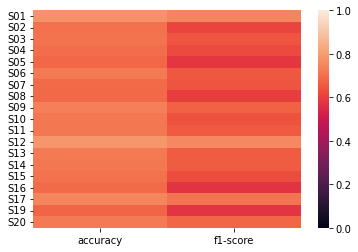

     class0 f1-score  class1 f1-score
S01         0.854839         0.513514
S02         0.818841         0.166667
S03         0.816901         0.235294
S04         0.813115         0.173913
S05         0.808664         0.036364
S06         0.830450         0.196721
S07         0.802817         0.282051
S08         0.807947         0.147059
S09         0.837662         0.264706
S10         0.827362         0.231884
S11         0.827839         0.229508
S12         0.862319         0.500000
S13         0.826389         0.285714
S14         0.824742         0.281690
S15         0.814815         0.202899
S16         0.815534         0.000000
S17         0.839695         0.400000
S19         0.801325         0.090909
S20         0.823944         0.342105


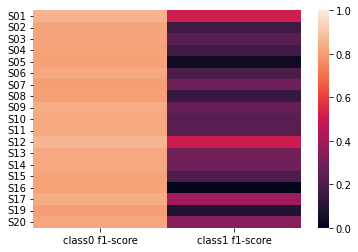

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

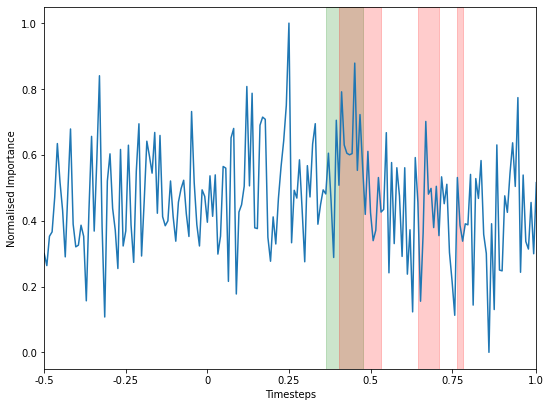

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

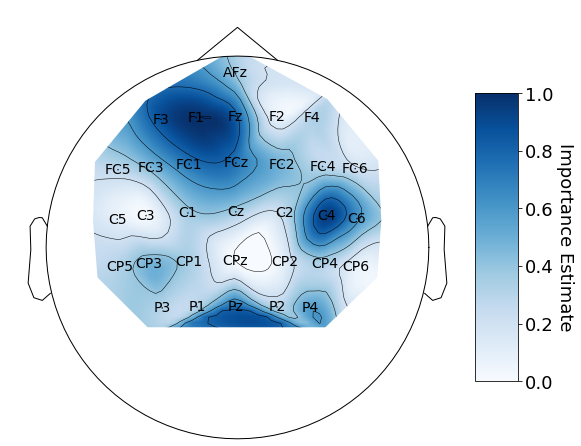

In [11]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)